# Attempting copper classification steps using contrastive learning
Split into down, no change, and up reg in copper condition


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

from Bio.Seq import reverse_complement

# import EarlyStopping
from pytorchtools import EarlyStopping


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed(7)

Random seed set as 7


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [4]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00025   
4           11  EQU24_RS00060   
...        ...            ...   
2199      4203  EQU24_RS22110   
2200      4204  EQU24_RS22115   
2201      4206  EQU24_RS22125   
2202      4207  EQU24_RS22130   
2203      4212  EQU24_RS22155   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.230893   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.008729   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.263911   
3     GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT... -0.034904   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.002609   
...                                                 ...       ...   
2199  GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...  0.041825   
2200  AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...  0.016197   
2201  ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...  0.052273   
2202  GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA... -0.150132   
2203  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...  0.356320   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  \
0             -0.311506 -0.524588 -0.926510   0.0  0.018495  0.109974   
1             -0.466359 -0.830462 -1.656433   0.0  0.124663  0.407828   
2             -0.048943 -0.612371 -0.615279   0.0  0.057550  0.246420   
3             -0.574712 -0.655377 -1.555096   0.0 -0.032478 -0.034485   
4              0.003625 -1.075138 -1.341292   0.0 -0.076037  0.095018   
...                 ...       ...       ...   ...       ...       ...   
2199           0.199584 -0.158523 -2.684471   0.0 -0.492002 -0.037340   
2200          -0.676160 -1.230196 -1.462699   0.0  0.029478  0.183147   
2201          -0.478136 -1.134588 -0.772442   0.0 -0.344101  0.053862   
2202          -0.534905 -0.811117 -0.723198   0.0 -0.072452 -0.199881   
2203           0.121494 -1.103363 -1.955906   0.0  0.394429  0.637895   

         lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  WithLanthanum  \
0    -0.045442            0.546757              -0.468551      -0.322610   
1     0.037725            0.731449              -0.449818      -0.512788   
2     0.028300            0.666104              -0.404861      -0.453445   
3     0.032271            0.643267              -0.257761      -0.540832   
4    -0.064943           -0.476696              -0.238368       0.268194   
...        ...                 ...                    ...            ...   
2199 -0.221623           -1.266702              -0.361081      -1.081770   
2200  0.010712           -0.086861              -0.712912      -1.430957   
2201 -0.268642           -0.258241              -0.916986       0.147953   
2202 -0.117306            0.142879              -0.388531       0.209171   
2203  0.047042           -0.952927              -1.138899      -1.765037   

      NoLanthanum  
0       -0.407143  
1       -0.448725  
2       -0.286782  
3       -0.234343  
4        0.339613  
...           ...  
2199    -0.714619  
2200    -1.390777  
2201     0.006596  
2202     0.320237  
2203    -1.725263  

[2204 rows x 15 columns]

In [47]:
loc2seq = dict([(x,z) for (x,z) in XYdf_og[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


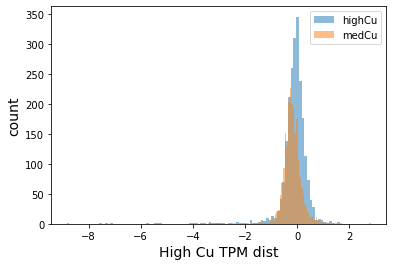

In [6]:
plt.hist(XYdf_og['highCu'].values,bins=100,label="highCu",alpha=0.5)
plt.hist(XYdf_og['medCu'].values,bins=100,label="medCu",alpha=0.5)

plt.legend()
plt.xlabel("High Cu TPM dist",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### How many genes never change?

In [7]:
with open("data/conditions_to_include.txt",'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum']

In [8]:
data_filename = "data/XY_TPM_opFilt.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00025   
4           11  EQU24_RS00060   
...        ...            ...   
2199      4203  EQU24_RS22110   
2200      4204  EQU24_RS22115   
2201      4206  EQU24_RS22125   
2202      4207  EQU24_RS22130   
2203      4212  EQU24_RS22155   

                                        upstream_region         uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...    52.045884   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...    59.991257   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...    33.943076   
3     GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...    48.648085   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...    27.213395   
...                                                 ...          ...   
2199  GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...  8591.278232   
2200  AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...    43.551349   
2201  ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...    46.058548   
2202  GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...    31.182164   
2203  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...  1392.325117   

      lowO2_fast_growth       lowCH4         MeOH         NoCu        medCu  \
0             35.736190    30.829331    23.333155    44.348687    44.920897   
1             43.159066    33.532522    18.915775    59.629360    65.011074   
2             27.325800    18.491160    18.453916    28.268717    29.419165   
3             33.463183    31.643505    16.960643    49.839406    48.729958   
4             27.232565    12.892833    10.720823    27.164218    25.769601   
...                 ...          ...          ...          ...          ...   
2199        9584.028559  7477.339715  1298.257682  8345.785345  5934.168113   
2200          26.951394    18.356915    15.624619    43.065124    43.954096   
2201          31.889009    20.231568    26.004364    44.419579    34.993692   
2202          23.882390    19.721043    20.960234    34.601933    32.907138   
2203        1183.180057   506.211825   280.344047  1087.621126  1429.593942   

           highCu        lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  \
0       47.861477    42.973556           64.784508              32.050358   
1       79.109490    61.209155           99.002970              43.656760   
2       33.534043    28.828713           44.856281              21.351623   
3       48.662214    50.966799           77.842263              41.684925   
4       29.013530    25.968531           19.520794              23.027211   
...           ...          ...                 ...                    ...   
2199  8132.547467  7157.344557         3468.582202            6497.868109   
2200    48.894308    43.386082           40.548782              26.273485   
2201    46.109300    36.872718           37.139500              23.525245   
2202    30.125207    31.899782           38.204218              26.432667   
2203  1692.401154  1123.669681          561.847119             493.895115   

      WithLanthanum  NoLanthanum  
0         35.462185    33.444023  
1         41.792237    43.689839  
2         20.644554    23.172675  
3         34.258335    42.367072  
4         32.713854    34.374071  
...             ...          ...  
2199    3942.957792  5085.637409  
2200      15.972203    16.423284  
2201      49.216725    44.623117  
2202      40.000662    43.201743  
2203     319.998959   328.943746  

[2204 rows x 15 columns]

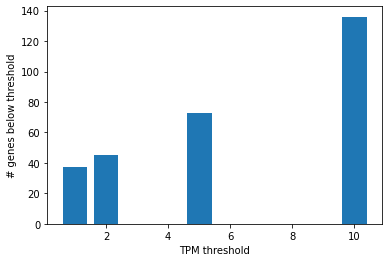

In [9]:
no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []
for i, row, in tpm_df.iterrows():
    tpms = row[conds].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [10]:
len(no_tx_genes10)

136

In [11]:
# do any of these show up in the log ratio up/down?
XYdf_og[XYdf_og['locus_tag'].isin(no_tx_genes2)].sort_values('highCu')[['locus_tag','highCu']]

locus_tag    highCu
1165  EQU24_RS11910 -1.958143
118   EQU24_RS01215 -0.923850
17    EQU24_RS00205 -0.624566
1943  EQU24_RS19655 -0.624566
783   EQU24_RS07995 -0.170096
1178  EQU24_RS12090  0.000000
1243  EQU24_RS12810  0.000000
1584  EQU24_RS16040  0.000000
1669  EQU24_RS16985  0.000000
1745  EQU24_RS17885  0.000000
1798  EQU24_RS18395  0.000000
1846  EQU24_RS18835  0.000000
1848  EQU24_RS18855  0.000000
1870  EQU24_RS19045  0.000000
1996  EQU24_RS20230  0.000000
2033  EQU24_RS20615  0.000000
2144  EQU24_RS21585  0.000000
2145  EQU24_RS21590  0.000000
2146  EQU24_RS21600  0.000000
2147  EQU24_RS21605  0.000000
1847  EQU24_RS18840  0.000000
2148  EQU24_RS21615  0.000000
1107  EQU24_RS11380  0.000000
913   EQU24_RS09300  0.000000
56    EQU24_RS00625  0.000000
57    EQU24_RS00640  0.000000
58    EQU24_RS00645  0.000000
285   EQU24_RS02735  0.000000
286   EQU24_RS02750  0.000000
287   EQU24_RS02755  0.000000
350   EQU24_RS03465  0.000000
360   EQU24_RS03550  0.000000
401   EQU24_RS04130  0.000000
411   EQU24_RS04230  0.000000
576   EQU24_RS05785  0.000000
684   EQU24_RS06860  0.000000
742   EQU24_RS07485  0.000000
789   EQU24_RS08045  0.000000
871   EQU24_RS08835  0.000000
875   EQU24_RS08860  0.000000
891   EQU24_RS09050  0.000000
944   EQU24_RS09560  0.000000
2149  EQU24_RS21620  0.000000
1267  EQU24_RS13045  0.615032
1183  EQU24_RS12140  1.562467

In [12]:
# filter out genes that never express above 2 tpms in any condition tested
XYdf = XYdf_og[~XYdf_og['locus_tag'].isin(no_tx_genes2)].reset_index().drop('index',axis=1)
XYdf['product'] = XYdf['locus_tag'].apply(lambda x: locus2info[x]['product'])

In [13]:
XYdf.head()

og_index      locus_tag                                    upstream_region  \
0         0  EQU24_RS00005  ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...   
1         1  EQU24_RS00010  GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...   
2         2  EQU24_RS00015  TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...   
3         4  EQU24_RS00025  GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...   
4        11  EQU24_RS00060  GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...   

       uMax  lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  \
0  0.230893          -0.311506 -0.524588 -0.926510   0.0  0.018495  0.109974   
1  0.008729          -0.466359 -0.830462 -1.656433   0.0  0.124663  0.407828   
2  0.263911          -0.048943 -0.612371 -0.615279   0.0  0.057550  0.246420   
3 -0.034904          -0.574712 -0.655377 -1.555096   0.0 -0.032478 -0.034485   
4  0.002609           0.003625 -1.075138 -1.341292   0.0 -0.076037  0.095018   

      lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  WithLanthanum  \
0 -0.045442            0.546757              -0.468551      -0.322610   
1  0.037725            0.731449              -0.449818      -0.512788   
2  0.028300            0.666104              -0.404861      -0.453445   
3  0.032271            0.643267              -0.257761      -0.540832   
4 -0.064943           -0.476696              -0.238368       0.268194   

   NoLanthanum                                            product  
0    -0.407143     chromosomal replication initiator protein DnaA  
1    -0.448725                    DNA polymerase III subunit beta  
2    -0.286782                DNA replication/repair protein RecF  
3    -0.234343                               hypothetical protein  
4     0.339613  bifunctional diguanylate cyclase/phosphodieste...

## Add regulatory class to XYdf

In [14]:
def set_reg_class_up_down(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 2
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 2
        else:
            return 1
    
    reg_col = f"{col}_reg_UD"
    df[reg_col] = df[col].apply(lambda x: get_class(x))
    
def set_reg_class_yes_no(df, col,thresh=1.0):
    '''
    Given a dataframe of log ratio TPMS, add a column splitting genes into categories
    * Below -thresh: class 0
    * Between -thresh:thresh: class 1
    * Above thresh: class 0
    '''
    def get_class(val):
        if val < -thresh:
            return 0
        elif val > thresh:
            return 0
        else:
            return 1
    
    reg_col = f"{col}_reg_YN"
    df[reg_col] = df[col].apply(lambda x: get_class(x))

In [15]:
set_reg_class_up_down(XYdf,'highCu',thresh=0.6)
set_reg_class_yes_no(XYdf,'highCu',thresh=0.6)
XYdf

og_index      locus_tag  \
0            0  EQU24_RS00005   
1            1  EQU24_RS00010   
2            2  EQU24_RS00015   
3            4  EQU24_RS00025   
4           11  EQU24_RS00060   
...        ...            ...   
2154      4203  EQU24_RS22110   
2155      4204  EQU24_RS22115   
2156      4206  EQU24_RS22125   
2157      4207  EQU24_RS22130   
2158      4212  EQU24_RS22155   

                                        upstream_region      uMax  \
0     ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...  0.230893   
1     GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...  0.008729   
2     TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...  0.263911   
3     GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT... -0.034904   
4     GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...  0.002609   
...                                                 ...       ...   
2154  GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...  0.041825   
2155  AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...  0.016197   
2156  ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...  0.052273   
2157  GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA... -0.150132   
2158  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...  0.356320   

      lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  \
0             -0.311506 -0.524588 -0.926510   0.0  0.018495  0.109974   
1             -0.466359 -0.830462 -1.656433   0.0  0.124663  0.407828   
2             -0.048943 -0.612371 -0.615279   0.0  0.057550  0.246420   
3             -0.574712 -0.655377 -1.555096   0.0 -0.032478 -0.034485   
4              0.003625 -1.075138 -1.341292   0.0 -0.076037  0.095018   
...                 ...       ...       ...   ...       ...       ...   
2154           0.199584 -0.158523 -2.684471   0.0 -0.492002 -0.037340   
2155          -0.676160 -1.230196 -1.462699   0.0  0.029478  0.183147   
2156          -0.478136 -1.134588 -0.772442   0.0 -0.344101  0.053862   
2157          -0.534905 -0.811117 -0.723198   0.0 -0.072452 -0.199881   
2158           0.121494 -1.103363 -1.955906   0.0  0.394429  0.637895   

         lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  WithLanthanum  \
0    -0.045442            0.546757              -0.468551      -0.322610   
1     0.037725            0.731449              -0.449818      -0.512788   
2     0.028300            0.666104              -0.404861      -0.453445   
3     0.032271            0.643267              -0.257761      -0.540832   
4    -0.064943           -0.476696              -0.238368       0.268194   
...        ...                 ...                    ...            ...   
2154 -0.221623           -1.266702              -0.361081      -1.081770   
2155  0.010712           -0.086861              -0.712912      -1.430957   
2156 -0.268642           -0.258241              -0.916986       0.147953   
2157 -0.117306            0.142879              -0.388531       0.209171   
2158  0.047042           -0.952927              -1.138899      -1.765037   

      NoLanthanum                                            product  \
0       -0.407143     chromosomal replication initiator protein DnaA   
1       -0.448725                    DNA polymerase III subunit beta   
2       -0.286782                DNA replication/repair protein RecF   
3       -0.234343                               hypothetical protein   
4        0.339613  bifunctional diguanylate cyclase/phosphodieste...   
...           ...                                                ...   
2154    -0.714619                               hypothetical protein   
2155    -1.390777   type II toxin-antitoxin system HicA family toxin   
2156     0.006596                  DUF4102 domain-containing protein   
2157     0.320237                                                NaN   
2158    -1.725263                          50S ribosomal protein L34   

      highCu_reg_UD  highCu_reg_YN  
0                 1              1  
1                 1              1  
2             

In [16]:
XYdf['highCu_reg_UD'].value_counts()

1    1956
0     145
2      58
Name: highCu_reg_UD, dtype: int64

In [17]:
XYdf['highCu_reg_YN'].value_counts()

1    1956
0     203
Name: highCu_reg_YN, dtype: int64

In [19]:
XYdf[XYdf['highCu_reg_UD']==2].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN']]

locus_tag                                            product  \
2003  EQU24_RS20690                             DEAD/DEAH box helicase   
440   EQU24_RS04625  aminotransferase class V-fold PLP-dependent en...   
1177  EQU24_RS12320  NADPH-dependent 7-cyano-7-deazaguanine reducta...   
1570  EQU24_RS16200                      EAL domain-containing protein   
1035  EQU24_RS10820  efflux RND transporter periplasmic adaptor sub...   
2027  EQU24_RS20860                           ribonucleotide reductase   
808   EQU24_RS08410                                 response regulator   
1573  EQU24_RS16225       circularly permuted type 2 ATP-grasp protein   
1139  EQU24_RS11890                               hypothetical protein   
962   EQU24_RS09990                           30S ribosomal protein S6   
2158  EQU24_RS22155                          50S ribosomal protein L34   
720   EQU24_RS07400           phenylalanine--tRNA ligase subunit alpha   
1728  EQU24_RS18060                          50S ribosomal protein L13   
139   EQU24_RS01475                formate dehydrogenase subunit gamma   
700   EQU24_RS07180                     P-II family nitrogen regulator   
1854  EQU24_RS19210                               hypothetical protein   
2049  EQU24_RS21040                          50S ribosomal protein L28   
1684  EQU24_RS17505                               hypothetical protein   
1779  EQU24_RS18555                                                NaN   
78    EQU24_RS00880                               hypothetical protein   
738   EQU24_RS07640                      group II truncated hemoglobin   
1353  EQU24_RS14165                               biotin synthase BioB   
505   EQU24_RS05225                    ribosome maturation factor RimP   
1236  EQU24_RS13015                               hypothetical protein   
1102  EQU24_RS11515              NADH-quinone oxidoreductase subunit F   
849   EQU24_RS08800            SulP family inorganic anion transporter   
1348  EQU24_RS14100                               SURF1 family protein   
866   EQU24_RS08975                                    MFS transporter   
46    EQU24_RS00505                          30S ribosomal protein S21   
23    EQU24_RS00255                               hypothetical protein   
1029  EQU24_RS10785                        redox-regulated ATPase YchF   
1337  EQU24_RS13975                                                NaN   
1841  EQU24_RS19105                          30S ribosomal protein S20   
305   EQU24_RS03015                                ABC-F family ATPase   
1842  EQU24_RS19125                          50S ribosomal protein L21   
765   EQU24_RS07970                               hypothetical protein   
110   EQU24_RS01175  translesion error-prone DNA polymerase V autop...   
698   EQU24_RS07165                               ammonium transporter   
1201  EQU24_RS12625                           ABC transporter permease   
1848  EQU24_RS19170                                              porin   
1867  EQU24_RS19315  methane monooxygenase/ammonia monooxygenase su...   
869   EQU24_RS09010         formate/nitrite transporter family protein   
365   EQU24_RS03640                               hypothetical protein   
1188  EQU24_RS12460                                                NaN   
511   EQU24_RS05300                            TonB-dependent receptor   
1200  EQU24_RS12620          ABC transporter substrate-binding protein   
2079  EQU24_RS21320                               hypothetical protein   
1901  EQU24_RS19620                                multicopper oxidase   
1666  EQU24_RS17265            electron transport complex subunit RsxA   
683   EQU24_RS07015                            cytochrome-c peroxidase   
260   EQU24_RS02555                               hypothetical protein   
355   EQU24_RS03580            SulP family inorganic anion transporter   
50    EQU24_RS00590                               hypothetical protein   
558   EQU24_RS

In [20]:
XYdf[XYdf['highCu_reg_UD']==0].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD','highCu_reg_YN']]

locus_tag                                            product  \
576   EQU24_RS05885                              methane monooxygenase   
577   EQU24_RS05905  soluble methane monooxygenase-binding protein ...   
579   EQU24_RS05920                               hypothetical protein   
578   EQU24_RS05915                     BLUF domain-containing protein   
580   EQU24_RS05925                          likely chaperone for smmo   
...             ...                                                ...   
1492  EQU24_RS15440                               hypothetical protein   
11    EQU24_RS00165                               hypothetical protein   
1081  EQU24_RS11350                               hypothetical protein   
519   EQU24_RS05405  ShlB/FhaC/HecB family hemolysin secretion/acti...   
1280  EQU24_RS13490                            glucose 1-dehydrogenase   

        highCu  highCu_reg_UD  highCu_reg_YN  
576  -8.844506              0              0  
577  -7.574592              0              0  
579  -7.357154              0              0  
578  -7.275122              0              0  
580  -7.104795              0              0  
...        ...            ...            ...  
1492 -0.606958              0              0  
11   -0.604148              0              0  
1081 -0.603603              0              0  
519  -0.603308              0              0  
1280 -0.601322              0              0  

[145 rows x 5 columns]

In [23]:
XYdf[XYdf['locus_tag'].isin(['EQU24_RS19315','EQU24_RS19520'])]

og_index      locus_tag  \
1867      3671  EQU24_RS19315   
1890      3712  EQU24_RS19520   

                                        upstream_region      uMax  \
1867  ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAAT...  0.954381   
1890  CACACAGTTTAGGTGTGTGATATCACGCAGTCCCATACTTCATTTT... -8.803976   

      lowO2_fast_growth     lowCH4      MeOH  NoCu     medCu    highCu  \
1867           1.313821   1.459975 -0.526926   0.0  0.600282  0.909567   
1890          -7.623770 -10.717938 -4.722293   0.0 -0.795353 -5.383131   

         lowCu  highO2_slow_growth  NO3_lowO2_slow_growth  WithLanthanum  \
1867  0.389121            0.351281               1.326338       1.172579   
1890 -0.167760           -9.205036              -3.036988     -10.929817   

      NoLanthanum                                            product  \
1867     1.305701  methane monooxygenase/ammonia monooxygenase su...   
1890   -10.956223                   type II secretion system protein   

      highCu_reg_UD  highCu_reg_YN  
1867              2              0  
1890              0              0

### Train/val/test splitting

In [24]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
def plot_train_test_stacks(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores in categories, sanity check that its not skewed'''
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    temp_df = pd.concat([train_df,test_df])
    if val_df is not None:
        val_df['set'] = 'val'
        temp_df = pd.concat([temp_df,val_df])
        
    temp_df = temp_df.value_counts([score_col,'set']).to_frame('count').reset_index()
        
    #temp_df = pd.melt(temp_df[['locus_tag',score_col,'set']],id_vars['locus_tag'])
    sns.barplot(x=score_col, y = 'count', data = temp_df, hue = "set")
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()
    

def see_batch_class_dist(train_dl,classes=[0,1,2]):
    '''Check distribution of classes in each batch'''
    
    data = []
    for i,(xb, yb) in enumerate(train_dl):
        vals, counts = yb.unique(return_counts=True)
        z=dict(list(zip(np.array(vals),np.array(counts))))
        row = []
        for cls in classes:
            if cls in z:
                data.append((i,cls,z[cls]))
            else:
                print(f"WARNING: no instance of class {cls} in batch {i}")
                data.append((i,cls,0))

    batch_dist = pd.DataFrame(data, columns=['batch','class','count'])
    sns.barplot(x='batch', y = 'count', data = batch_dist, hue = "class")
    plt.show()


In [25]:
# specs for class partition dict
cpd = {
    0: {'train_test':0.8, 'train_val':0.8},
    1: {'train_test':0.8, 'train_val':0.8},
    #2: {'train_test':0.75, 'train_val':0.66},
    2: {'train_test':0.8, 'train_val':0.8},
}

In [26]:
def stratified_partition(df, class_partition_dict,class_col='reg'):
    '''
    Given a specification for how to split specific classes into 
    train-test and train-val, implement those splits independently 
    and return final dfs for train/test/val splits
    '''
    
    # make sure classes and CPD specs match
    assert set(class_partition_dict.keys()) == set(df[class_col].unique())
    
    final_full_train = pd.DataFrame(columns=df.columns)
    final_test = pd.DataFrame(columns=df.columns)
    final_train = pd.DataFrame(columns=df.columns)
    final_val = pd.DataFrame(columns=df.columns)

    
    for c in cpd:
        temp_df = df[df[class_col]==c]
        print(f"class {c}: {temp_df.shape[0]} examples")
        full_train,test = tu.quick_split(temp_df, split_frac=cpd[c]['train_test'])
        train,val = tu.quick_split(full_train, split_frac=cpd[c]['train_val'])
        
        final_full_train = pd.concat([final_full_train, full_train])
        final_test = pd.concat([final_test, test])
        final_train = pd.concat([final_train, train])
        final_val = pd.concat([final_val, val])
        
    return final_full_train, final_test, final_train, final_val
        

In [27]:
full_train_df, \
test_df, \
train_df, \
val_df = stratified_partition(XYdf, cpd, class_col='highCu_reg_UD')

class 0: 145 examples
class 1: 1956 examples
class 2: 58 examples


In [28]:
print("Full Train")
display(full_train_df['highCu_reg_UD'].value_counts())
print("Test")
display(test_df['highCu_reg_UD'].value_counts())
print("Train")
display(train_df['highCu_reg_UD'].value_counts())
print("Val")
display(val_df['highCu_reg_UD'].value_counts())

Full Train


1    1564
0     116
2      46
Name: highCu_reg_UD, dtype: int64

Test


1    392
0     29
2     12
Name: highCu_reg_UD, dtype: int64

Train


1    1251
0      92
2      36
Name: highCu_reg_UD, dtype: int64

Val


1    313
0     24
2     10
Name: highCu_reg_UD, dtype: int64

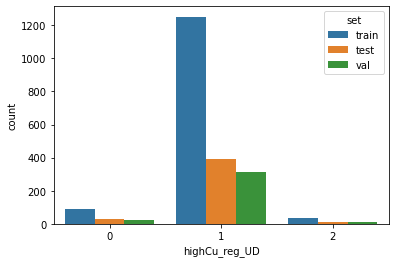

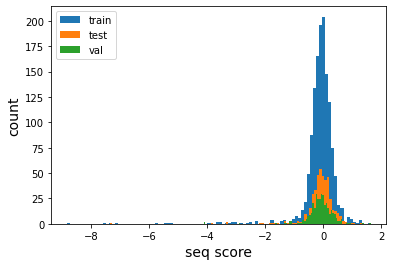

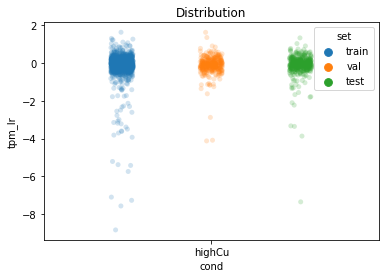

In [29]:
#plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_YN')
plot_train_test_stacks(train_df, test_df, val_df=val_df,score_col='highCu_reg_UD')
plot_train_test_hist(train_df, test_df,val_df=val_df,score_col='highCu',bins=100)
view_train_test_dist(train_df, test_df,["highCu"],val_df=val_df,id_col='locus_tag')


## Load 5G seqs into data loaders

In [30]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [31]:
# full_train_df,test_df = tu.quick_split(XYdf)
# train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='highCu_reg_UD',
    sampler=None
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

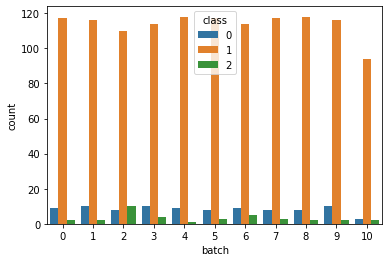

In [32]:
see_batch_class_dist(ohe_train_dl)

## Non-optuna regular ol training

In [168]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.long().squeeze(1))
    # ^^ changes for CrossEntropyLoss...

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        print("train loss batch:",t)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,patience=5000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # create early stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)
    
    # loops through epochs
    #for epoch in range(epochs): #tqdm?
    with tqdm.trange(epochs) as pbar:
        for i in pbar:
            
    
            train_loss = train_step(model, train_dl, loss_func, opt)
            train_losses.append(train_loss)


            val_loss = val_step(model, val_dl, loss_func)
            #print(epoch, val_loss)
            val_losses.append(val_loss)
            
            pbar.set_description(f"E:{i} | train loss:{train_loss:.3f} | val loss: {val_loss:.3f}")
            
            # copied from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_loss, model,i)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    
    # Epoch and value of best model checkpoint
    estop = early_stopping.best_model_epoch
    best_val_score = early_stopping.val_loss_min 

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    # ^^ Does this need to be returned? I dont' think so... loads in place

    return train_losses, val_losses,estop,best_val_score

def run_model(train_dl,test_dl, model, loss_func, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with SGD opt
    '''
    # define loss func and optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop

    train_losses, test_losses,epoch_stop,best_val_score = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses,epoch_stop,best_val_score

In [39]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 3), # 3 for 3 classes
            #nn.Softmax(dim=1)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
            #nn.Softmax(dim=1)
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

# class Kmer_Linear(nn.Module):
#     def __init__(self,num_kmers,h1_size,h2_size):
#         super().__init__()
        
#         # some arbitrary arch of a few linear layers
#         self.lin = nn.Sequential(
#             nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
#             nn.ReLU(inplace=True),
#             nn.Linear(h1_size, h2_size),
#             nn.ReLU(inplace=True),
#             nn.Linear(h2_size, 1),
#         )
        
        
#     def forward(self, xb):
#         out = self.lin(xb)
#         #print("Lin out shape:", out.shape)
#         return out

In [40]:
def plot_confusion(models,genes,oracle,objs):
    '''Get class predictions and plot confusion matrix'''
    dfs = {}
    for model_name,model,ds in models:
        model.eval()
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.topk(1) for x in model(s.float())]
            
            for i in range(len(preds)):
                prob,cls = [x.item() for x in preds[i]]
                data.append((gene,actual[i], cls,prob,objs[i],dna))
                
        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','task','seq'])
        c = confusion_matrix(df['truth'].values, df['pred'].values)
        disp = ConfusionMatrixDisplay(confusion_matrix=c)
        disp.plot()
        plt.title(f"{model_name} confusion matrix")
        plt.show()

        dfs[model_name] = (c,df)
        
    return dfs

In [82]:
oracle_syn

{'EQU24_RS00005': [1],
 'EQU24_RS00010': [1],
 'EQU24_RS00015': [1],
 'EQU24_RS00025': [1],
 'EQU24_RS00060': [1],
 'EQU24_RS00065': [1],
 'EQU24_RS00080': [1],
 'EQU24_RS00085': [1],
 'EQU24_RS00105': [1],
 'EQU24_RS00110': [1],
 'EQU24_RS00125': [1],
 'EQU24_RS00165': [0],
 'EQU24_RS00175': [0],
 'EQU24_RS00180': [1],
 'EQU24_RS00185': [1],
 'EQU24_RS00195': [1],
 'EQU24_RS00200': [1],
 'EQU24_RS00210': [1],
 'EQU24_RS00215': [1],
 'EQU24_RS00225': [1],
 'EQU24_RS00230': [1],
 'EQU24_RS00245': [1],
 'EQU24_RS00250': [1],
 'EQU24_RS00255': [2],
 'EQU24_RS00260': [1],
 'EQU24_RS00265': [1],
 'EQU24_RS00270': [1],
 'EQU24_RS00275': [1],
 'EQU24_RS00295': [1],
 'EQU24_RS00300': [1],
 'EQU24_RS00315': [1],
 'EQU24_RS00320': [1],
 'EQU24_RS00330': [1],
 'EQU24_RS00370': [1],
 'EQU24_RS00385': [1],
 'EQU24_RS00390': [1],
 'EQU24_RS00400': [1],
 'EQU24_RS00405': [1],
 'EQU24_RS00425': [1],
 'EQU24_RS00455': [1],
 'EQU24_RS00470': [1],
 'EQU24_RS00475': [1],
 'EQU24_RS00480': [1],
 'EQU24_RS0

### Deep linear

In [41]:
seq_len = len(train_df['upstream_region'].values[0])

In [42]:
seq_len

300

E:1279 | train loss:0.001 | val loss: 1.422:  26%|██▌       | 1277/5000 [00:38<01:49, 34.05it/s]

EarlyStopping counter: 1250 out of 5000


E:2529 | train loss:0.000 | val loss: 1.599:  51%|█████     | 2529/5000 [01:15<01:13, 33.77it/s]

EarlyStopping counter: 2500 out of 5000


E:3779 | train loss:0.000 | val loss: 1.694:  76%|███████▌  | 3777/5000 [01:52<00:36, 33.46it/s]

EarlyStopping counter: 3750 out of 5000


E:4999 | train loss:0.000 | val loss: 1.759: 100%|██████████| 5000/5000 [02:28<00:00, 33.78it/s]


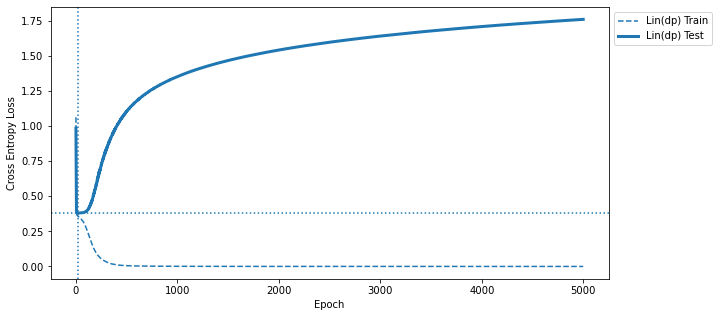

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

In [43]:
mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label = 'Cross Entropy Loss'
mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d,estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    loss_func,
    lr=0.01,
    epochs=5000
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)",estop,best_val)]
tu.quick_loss_plot(mer8motif_lin_d_data_label,loss_type=loss_label)

mer8motif_model_lin_d

### CNN model

In [44]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 10,
                 fc_node_num1 = 10,
                 dropout1 = 0.2,
                 dropout2 = 0.2,
                ):
        super().__init__()
        
        self.seq_len = seq_len
        
        # calculation for number of linear nodes need to come after final conv layer
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1
        #linear_node_num = linear_node_num*num_filters0
        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.MaxPool2d((1,conv_pool_size0)), # def stride = kernel_size
            nn.Dropout(dropout1),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            nn.Dropout(dropout1),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            
            # Fully connected layer 1
            nn.Linear(fc_node_num0, fc_node_num1),
            nn.ReLU(),
            
            # final prediction
            nn.Linear(fc_node_num1, 3),
            #nn.Softmax(dim=1)
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

E:1557 | train loss:0.005 | val loss: 1.110:  31%|███       | 1557/5000 [02:16<05:00, 11.44it/s]

EarlyStopping counter: 1250 out of 5000


E:2807 | train loss:0.004 | val loss: 1.200:  56%|█████▌    | 2807/5000 [04:05<03:10, 11.51it/s]

EarlyStopping counter: 2500 out of 5000


E:4057 | train loss:0.001 | val loss: 1.325:  81%|████████  | 4057/5000 [05:53<01:22, 11.46it/s]

EarlyStopping counter: 3750 out of 5000


E:4999 | train loss:0.001 | val loss: 1.347: 100%|██████████| 5000/5000 [07:15<00:00, 11.47it/s]


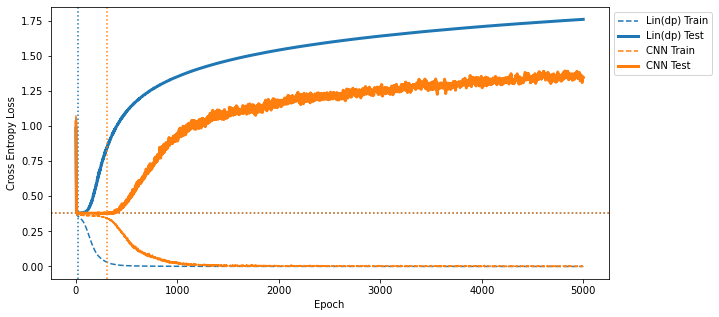

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=2880, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [49]:
# make model
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,10.0,10.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"
# run model
mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN',estop,best_val)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,loss_type=loss_label)

mer8motif_model_cnn

In [50]:
#tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label,sparse_n=20)


Running LinearDeep


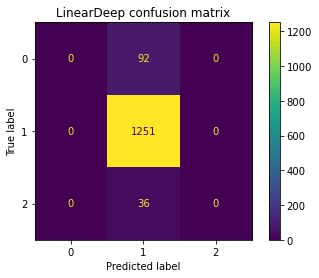

Running CNN


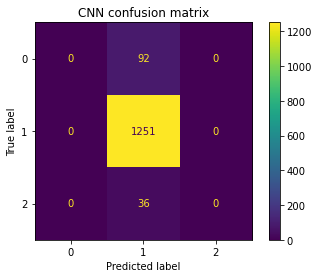

Running LinearDeep


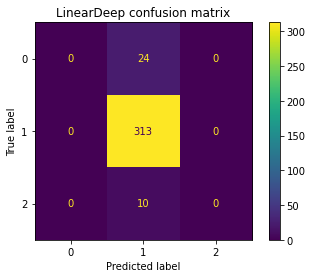

Running CNN


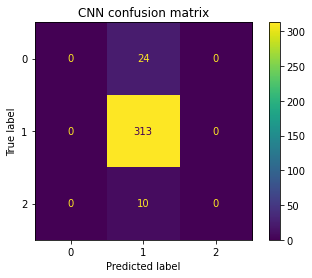

In [51]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
task = "6mer_motif_reg"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','highCu_reg_UD']].values])


dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [53]:
dfs_train['CNN']

(array([[   0,   92,    0],
        [   0, 1251,    0],
        [   0,   36,    0]]),
           locus_tag  truth  pred      prob            task  \
 0     EQU24_RS00670      0     1  1.669576  6mer_motif_reg   
 1     EQU24_RS00690      0     1  1.957730  6mer_motif_reg   
 2     EQU24_RS00940      0     1  1.817214  6mer_motif_reg   
 3     EQU24_RS00945      0     1  1.720456  6mer_motif_reg   
 4     EQU24_RS00955      0     1  1.773832  6mer_motif_reg   
 ...             ...    ...   ...       ...             ...   
 1374  EQU24_RS19125      2     1  1.805557  6mer_motif_reg   
 1375  EQU24_RS19170      2     1  1.700728  6mer_motif_reg   
 1376  EQU24_RS19210      2     1  1.687642  6mer_motif_reg   
 1377  EQU24_RS21040      2     1  1.781099  6mer_motif_reg   
 1378  EQU24_RS21320      2     1  1.910641  6mer_motif_reg   
 
                                                     seq  
 0     ATTCCGATGGGTATGTAACCAAATCTTTAGTAGCTGAACGCGACTG...  
 1     TCCTGCTCTATGTTGCCAGACCCTCCATTTG

In [54]:
from sklearn.metrics import classification_report

In [59]:
print(classification_report(dfs_train['CNN'][1]['truth'].values, dfs_train['CNN'][1]['pred'].values))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        92
           1       0.91      1.00      0.95      1251
           2       0.00      0.00      0.00        36

    accuracy                           0.91      1379
   macro avg       0.30      0.33      0.32      1379
weighted avg       0.82      0.91      0.86      1379



In [60]:
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,precision_recall_curve,matthews_corrcoef

def cls_report(df,model_name):
    '''Basic print out of precicion/recall/f1 scores'''
    
    acc = accuracy_score(df['truth'].values,df['pred'].values)
    mcc = matthews_corrcoef(df['truth'].values,df['pred'].values)
    print(f"{model_name} (acc={acc:.3f} | mcc={mcc:.3f})")
    for a in ['micro','macro']:#,'weighted']:
        p = precision_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        r = recall_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        f1 = f1_score(df['truth'].values,df['pred'].values,labels=[0,1,2],average=a)
        print(f"{a}: p={p:.3f}\t r={r:.3f}\t f1={f1:.3f}")

def quick_classify(model, seqs,oracle):
    '''Given some sequences, get the model's predictions '''
    mis_classified = []
    for gene in seqs:
        dna = loc2seq[gene]
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        prob,cls = pred.topk(1)
        actual = oracle[gene][0]
        correct = (cls.item() == actual)
        if not correct:
            #print(f"{gene}: pred:{cls.item()} actual:{actual}")
            mis_classified.append(gene)
            print(f"{gene}: pred:{cls.item()} actual:{actual} ({pred.tolist()[0]})")

    print('done')
    return mis_classified
        

In [61]:
lind_res = dfs_val['LinearDeep'][1]
cnn_res = dfs_val['CNN'][1]

cls_report(lind_res,"LinearDeep")
print()
cls_report(cnn_res,"CNN")

LinearDeep (acc=0.902 | mcc=0.000)
micro: p=0.902	 r=0.902	 f1=0.902
macro: p=0.301	 r=0.333	 f1=0.316

CNN (acc=0.902 | mcc=0.000)
micro: p=0.902	 r=0.902	 f1=0.902
macro: p=0.301	 r=0.333	 f1=0.316


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
#mis = quick_classify(mer8motif_model_cnn,val_seqs,oracle_syn)

## use weighted loss function

In [169]:
# https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/11?u=crypdick
def get_loss_weights(ys):
    '''
    Determine loss reweighting vector by the inverse of the positive
    examples for each iMod task
    '''
    class_counts = torch.bincount(torch.tensor(ys))
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(ys)-pos_count for pos_count in class_counts]  # <-- HERE 
    
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        print(f"{cdx}| pos:{pos_count}  neg:{neg_count}")
        print("val:", neg_count / (pos_count + 1e-5))
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)
        

    return torch.as_tensor(pos_weights, dtype=torch.float)

In [170]:
get_loss_weights(ys)

0| pos:145  neg:2014
val: tensor(13.8897)
1| pos:1956  neg:203
val: tensor(0.1038)
2| pos:58  neg:2101
val: tensor(36.2241)


tensor([13.,  0., 36.])

0| pos:145  neg:2014
val: tensor(13.8897)
1| pos:1956  neg:203
val: tensor(0.1038)
2| pos:58  neg:2101
val: tensor(36.2241)


E:0 | train loss:1.128 | val loss: 1.198:   0%|          | 1/5000 [00:00<14:46,  5.64it/s]

train loss batch: 1.1915804147720337
train loss batch: 1.3394230604171753
train loss batch: 1.12343430519104
train loss batch: 1.0888400077819824
train loss batch: 1.0514988899230957
train loss batch: 1.1563706398010254
train loss batch: 1.0558127164840698
train loss batch: 1.2174113988876343
train loss batch: 1.0418806076049805
train loss batch: 1.0880500078201294
train loss batch: 1.0321128368377686
train loss batch: 1.1217485666275024
train loss batch: 1.06218683719635
train loss batch: 1.0594061613082886


E:2 | train loss:1.038 | val loss: 1.126:   0%|          | 3/5000 [00:00<10:20,  8.05it/s]

train loss batch: 1.0991047620773315
train loss batch: 1.0036786794662476
train loss batch: 1.106704592704773
train loss batch: 0.9770410656929016
train loss batch: 1.2158408164978027
train loss batch: 1.0374338626861572
train loss batch: 1.0399001836776733
train loss batch: 1.036149501800537
train loss batch: 1.0057523250579834
train loss batch: 1.1507912874221802
train loss batch: 1.0533336400985718
train loss batch: 1.055312991142273
train loss batch: 1.175740361213684
train loss batch: 1.1265816688537598
train loss batch: 1.0178724527359009
train loss batch: 0.9536982178688049
train loss batch: 1.000023365020752
train loss batch: 0.9807363152503967
train loss batch: 0.8540135025978088
train loss batch: 0.9905790686607361
train loss batch: 0.9012107849121094
train loss batch: 0.835329532623291


E:4 | train loss:0.896 | val loss: 0.976:   0%|          | 5/5000 [00:00<08:41,  9.57it/s]

train loss batch: 0.915998101234436
train loss batch: 1.0670260190963745
train loss batch: 0.9182693958282471
train loss batch: 0.9705979228019714
train loss batch: 1.007535457611084
train loss batch: 1.14045250415802
train loss batch: 0.9173469543457031
train loss batch: 1.2160757780075073
train loss batch: 0.9047762155532837
train loss batch: 0.9143145680427551
train loss batch: 1.0095287561416626
train loss batch: 0.7973964810371399
train loss batch: 0.8694547414779663
train loss batch: 0.9148880839347839
train loss batch: 0.8539032340049744
train loss batch: 1.0090112686157227
train loss batch: 0.8478403687477112
train loss batch: 0.8391950726509094
train loss batch: 0.8938931822776794
train loss batch: 0.9160026907920837
train loss batch: 0.7577805519104004
train loss batch: 0.849077045917511
train loss batch: 0.8497896790504456
train loss batch: 0.7607343792915344
train loss batch: 0.9511231780052185
train loss batch: 0.8322787880897522


E:6 | train loss:0.776 | val loss: 0.771:   0%|          | 7/5000 [00:00<08:07, 10.23it/s]

train loss batch: 0.7743080258369446
train loss batch: 0.8173331618309021
train loss batch: 0.8219537138938904
train loss batch: 0.7482401728630066
train loss batch: 0.8113142848014832
train loss batch: 0.7255480885505676
train loss batch: 0.8014386892318726
train loss batch: 0.7943674325942993
train loss batch: 0.902205765247345
train loss batch: 0.7427386045455933
train loss batch: 0.761273980140686
train loss batch: 0.7229650616645813
train loss batch: 0.7642421722412109
train loss batch: 0.768463134765625
train loss batch: 0.7365632653236389
train loss batch: 0.7453323602676392
train loss batch: 0.7624818682670593
train loss batch: 0.7476050853729248
train loss batch: 0.7411366105079651
train loss batch: 0.7448616623878479
train loss batch: 0.7214157581329346
train loss batch: 0.7125532031059265
train loss batch: 0.7403997778892517
train loss batch: 0.7144371271133423


E:8 | train loss:0.726 | val loss: 0.694:   0%|          | 9/5000 [00:00<07:50, 10.61it/s]

train loss batch: 0.7458759546279907
train loss batch: 0.7557190656661987
train loss batch: 0.6869100332260132
train loss batch: 0.7560352683067322
train loss batch: 0.7504743933677673
train loss batch: 0.7196585536003113
train loss batch: 0.7202174067497253
train loss batch: 0.7140269875526428
train loss batch: 0.722092866897583
train loss batch: 0.7393041849136353
train loss batch: 0.7073596119880676
train loss batch: 0.7442532181739807
train loss batch: 0.7248217463493347
train loss batch: 0.6984264254570007
train loss batch: 0.721765398979187
train loss batch: 0.7189276218414307
train loss batch: 0.7110918164253235
train loss batch: 0.7088464498519897
train loss batch: 0.7192295789718628
train loss batch: 0.7174930572509766
train loss batch: 0.709251344203949
train loss batch: 0.7199703454971313
train loss batch: 0.7248880863189697
train loss batch: 0.7034858465194702


E:9 | train loss:0.714 | val loss: 0.739:   0%|          | 9/5000 [00:01<07:50, 10.61it/s]

train loss batch: 0.7003051042556763


E:11 | train loss:0.724 | val loss: 0.662:   0%|          | 11/5000 [00:01<07:41, 10.82it/s]

train loss batch: 0.7952514290809631
train loss batch: 0.7781801819801331
train loss batch: 0.7047972083091736
train loss batch: 0.7283678650856018
train loss batch: 0.7186878323554993
train loss batch: 0.7096211910247803
train loss batch: 0.699390172958374
train loss batch: 0.7427909970283508
train loss batch: 0.7035847306251526
train loss batch: 0.6813520789146423
train loss batch: 0.8973971605300903
train loss batch: 0.7083979845046997
train loss batch: 0.6979665756225586
train loss batch: 0.7073837518692017
train loss batch: 0.668299674987793
train loss batch: 0.7289893627166748
train loss batch: 0.7420422434806824
train loss batch: 0.6962379813194275
train loss batch: 0.7052175402641296
train loss batch: 0.703350841999054
train loss batch: 0.7072536945343018
train loss batch: 0.6577322483062744
train loss batch: 0.7488669753074646
train loss batch: 0.7009178996086121
train loss batch: 0.7531039118766785


E:13 | train loss:0.718 | val loss: 0.704:   0%|          | 13/5000 [00:01<07:34, 10.97it/s]

train loss batch: 0.7025344371795654
train loss batch: 0.7063459753990173
train loss batch: 0.7069812417030334
train loss batch: 0.6983193755149841
train loss batch: 0.7236791253089905
train loss batch: 0.6934698820114136
train loss batch: 0.713438868522644
train loss batch: 0.6914173364639282
train loss batch: 0.6953572630882263
train loss batch: 0.703736424446106
train loss batch: 0.7688465714454651
train loss batch: 0.7548142075538635
train loss batch: 0.6488749980926514
train loss batch: 0.8194105625152588
train loss batch: 0.7048933506011963
train loss batch: 0.6951506733894348
train loss batch: 0.7041348218917847
train loss batch: 0.7071955800056458
train loss batch: 0.7051901817321777
train loss batch: 0.7324890494346619
train loss batch: 0.7060835361480713
train loss batch: 0.6976317167282104
train loss batch: 0.7155331969261169
train loss batch: 0.7124712467193604
train loss batch: 0.7195718884468079
train loss batch: 0.6927267909049988


E:15 | train loss:0.712 | val loss: 0.721:   0%|          | 15/5000 [00:01<07:29, 11.09it/s]

train loss batch: 0.68535977602005
train loss batch: 0.7355197668075562
train loss batch: 0.687887966632843
train loss batch: 0.7374510169029236
train loss batch: 0.7030607461929321
train loss batch: 0.6884982585906982
train loss batch: 0.712150514125824
train loss batch: 0.6197883486747742
train loss batch: 0.5915964841842651
train loss batch: 0.8313342928886414
train loss batch: 0.7554411888122559
train loss batch: 0.742516279220581
train loss batch: 0.7060712575912476
train loss batch: 0.7574952244758606
train loss batch: 0.7070741653442383
train loss batch: 0.7024775147438049
train loss batch: 0.707477331161499
train loss batch: 0.6936231255531311
train loss batch: 0.7118234038352966
train loss batch: 0.7010371088981628
train loss batch: 0.6948854923248291
train loss batch: 0.6994616985321045
train loss batch: 0.7225013971328735
train loss batch: 0.6968550682067871
train loss batch: 0.6800720691680908


E:18 | train loss:0.729 | val loss: 0.631:   0%|          | 19/5000 [00:01<07:24, 11.20it/s]

train loss batch: 0.7034823894500732
train loss batch: 0.7208638787269592
train loss batch: 0.7041852474212646
train loss batch: 0.6803545951843262
train loss batch: 0.7908148169517517
train loss batch: 0.7006700038909912
train loss batch: 0.7116242051124573
train loss batch: 0.6746696829795837
train loss batch: 0.6666883826255798
train loss batch: 0.7177720665931702
train loss batch: 0.7311583161354065
train loss batch: 0.6868019104003906
train loss batch: 0.7431146502494812
train loss batch: 0.7027007937431335
train loss batch: 0.6948569416999817
train loss batch: 0.7461636662483215
train loss batch: 0.8040015697479248
train loss batch: 0.7213097810745239
train loss batch: 0.7007182240486145
train loss batch: 0.6819092035293579
train loss batch: 0.852837860584259
train loss batch: 0.6671620607376099
train loss batch: 0.7256295084953308
train loss batch: 0.7564858794212341
train loss batch: 0.694051206111908
train loss batch: 0.7297551035881042


E:20 | train loss:0.713 | val loss: 0.724:   0%|          | 21/5000 [00:01<07:23, 11.23it/s]

train loss batch: 0.6997371912002563
train loss batch: 0.7009066939353943
train loss batch: 0.6961567401885986
train loss batch: 0.7108653783798218
train loss batch: 0.7020426392555237
train loss batch: 0.7022063732147217
train loss batch: 0.6945470571517944
train loss batch: 0.6907627582550049
train loss batch: 0.6971103549003601
train loss batch: 0.6971026659011841
train loss batch: 0.6895708441734314
train loss batch: 0.7010502815246582
train loss batch: 0.6810458302497864
train loss batch: 0.673334538936615
train loss batch: 0.563261866569519
train loss batch: 1.0394330024719238
train loss batch: 0.7086030840873718
train loss batch: 0.7008942365646362
train loss batch: 0.7226037979125977
train loss batch: 0.7697535157203674
train loss batch: 0.7088402509689331
train loss batch: 0.6987084150314331
train loss batch: 0.6719828844070435
train loss batch: 0.6924569606781006
train loss batch: 0.692945122718811
train loss batch: 0.7182779312133789


E:22 | train loss:0.710 | val loss: 0.616:   0%|          | 23/5000 [00:02<07:22, 11.25it/s]

train loss batch: 0.7498634457588196
train loss batch: 0.719979465007782
train loss batch: 0.695408284664154
train loss batch: 0.7015263438224792
train loss batch: 0.6932702660560608
train loss batch: 0.7061852216720581
train loss batch: 0.7235622406005859
train loss batch: 0.7232221364974976
train loss batch: 0.7021477222442627
train loss batch: 0.6937882900238037
train loss batch: 0.6964611411094666
train loss batch: 0.7070966362953186
train loss batch: 0.6918013691902161
train loss batch: 0.7876973152160645
train loss batch: 0.5793916583061218
train loss batch: 0.724339485168457
train loss batch: 0.7788135409355164
train loss batch: 0.674435019493103
train loss batch: 0.7013129591941833
train loss batch: 0.7589895725250244
train loss batch: 0.696559488773346
train loss batch: 0.7060461640357971
train loss batch: 0.6885968446731567
train loss batch: 0.6719253063201904
train loss batch: 0.7008926272392273


E:25 | train loss:0.715 | val loss: 0.651:   0%|          | 25/5000 [00:02<08:41,  9.53it/s]

train loss batch: 0.6575121879577637
train loss batch: 0.7217270731925964
train loss batch: 0.6975417137145996
train loss batch: 0.7427471876144409
train loss batch: 0.6954797506332397
train loss batch: 0.7003447413444519
train loss batch: 0.6993179321289062
train loss batch: 0.693771481513977
train loss batch: 0.6823922395706177
train loss batch: 0.7548447251319885
train loss batch: 0.6955079436302185
train loss batch: 0.7111620903015137
train loss batch: 0.7069275379180908
train loss batch: 0.7049999237060547
train loss batch: 0.6716212630271912
train loss batch: 0.803344190120697
train loss batch: 0.6747363209724426
train loss batch: 0.7569591999053955
train loss batch: 0.6904777884483337
train loss batch: 0.7370139956474304
train loss batch: 0.7135831117630005
train loss batch: 0.6876545548439026
train loss batch: 0.6616342663764954
train loss batch: 0.6694989800453186
train loss batch: 0.7771525979042053


E:27 | train loss:0.715 | val loss: 0.630:   1%|          | 27/5000 [00:02<08:18,  9.97it/s]

train loss batch: 0.7064437866210938
train loss batch: 0.691535234451294
train loss batch: 0.710618793964386
train loss batch: 0.711838960647583
train loss batch: 0.7165306210517883
train loss batch: 0.6969888806343079
train loss batch: 0.7340102791786194
train loss batch: 0.679101824760437
train loss batch: 0.6934285759925842
train loss batch: 0.7360989451408386
train loss batch: 0.7167975902557373
train loss batch: 0.7986644506454468
train loss batch: 0.7130901217460632
train loss batch: 0.6965308785438538
train loss batch: 0.6932724714279175
train loss batch: 0.7104324102401733
train loss batch: 0.6894482374191284
train loss batch: 0.7450615763664246
train loss batch: 0.6634048819541931
train loss batch: 0.6809237003326416
train loss batch: 0.7619054913520813
train loss batch: 0.6850647926330566
train loss batch: 0.6469153165817261
train loss batch: 0.8208450078964233
train loss batch: 0.6727015972137451


E:29 | train loss:0.708 | val loss: 0.749:   1%|          | 29/5000 [00:02<08:03, 10.28it/s]

train loss batch: 0.7376061677932739
train loss batch: 0.7163166999816895
train loss batch: 0.6767347455024719
train loss batch: 0.7012597322463989
train loss batch: 0.7133194804191589
train loss batch: 0.696232795715332
train loss batch: 0.6964777708053589
train loss batch: 0.7243306040763855
train loss batch: 0.7199527025222778
train loss batch: 0.7022022008895874
train loss batch: 0.6821947693824768
train loss batch: 0.7595908641815186
train loss batch: 0.6990934014320374
train loss batch: 0.7066471576690674
train loss batch: 0.6955534815788269
train loss batch: 0.7045326828956604
train loss batch: 0.6690280437469482
train loss batch: 0.6388485431671143
train loss batch: 0.7031919360160828
train loss batch: 0.7127063870429993
train loss batch: 0.7848134636878967
train loss batch: 0.6977006196975708
train loss batch: 0.6924498677253723
train loss batch: 0.6525620818138123
train loss batch: 0.6017797589302063


E:32 | train loss:0.697 | val loss: 0.706:   1%|          | 33/5000 [00:03<07:44, 10.70it/s]

train loss batch: 0.7706542015075684
train loss batch: 0.7562874555587769
train loss batch: 0.7029814124107361
train loss batch: 0.6928315162658691
train loss batch: 0.7161398530006409
train loss batch: 0.62568199634552
train loss batch: 0.8781890869140625
train loss batch: 0.6949350237846375
train loss batch: 0.7076199650764465
train loss batch: 0.7000194191932678
train loss batch: 0.6909254789352417
train loss batch: 0.6811255812644958
train loss batch: 0.7339511513710022
train loss batch: 0.6966108679771423
train loss batch: 0.7011775970458984
train loss batch: 0.6876322627067566
train loss batch: 0.7041218280792236
train loss batch: 0.6947823762893677
train loss batch: 0.6969432234764099
train loss batch: 0.6922701597213745
train loss batch: 0.7036331295967102
train loss batch: 0.6908403635025024
train loss batch: 0.6867985725402832
train loss batch: 0.7153332233428955


E:34 | train loss:0.701 | val loss: 0.723:   1%|          | 35/5000 [00:03<07:37, 10.84it/s]

train loss batch: 0.7068886160850525
train loss batch: 0.7200881242752075
train loss batch: 0.6975663304328918
train loss batch: 0.6897010207176208
train loss batch: 0.675746500492096
train loss batch: 0.7204957008361816
train loss batch: 0.6927037239074707
train loss batch: 0.7080234289169312
train loss batch: 0.6795215606689453
train loss batch: 0.7203535437583923
train loss batch: 0.6796120405197144
train loss batch: 0.6878441572189331
train loss batch: 0.7374547719955444
train loss batch: 0.6865770816802979
train loss batch: 0.6862408518791199
train loss batch: 0.6906244158744812
train loss batch: 0.6911048889160156
train loss batch: 0.6972178220748901
train loss batch: 0.6734248399734497
train loss batch: 0.7358614802360535
train loss batch: 0.705737292766571
train loss batch: 0.7180178165435791
train loss batch: 0.6873304843902588
train loss batch: 0.7315492630004883
train loss batch: 0.6643267869949341
train loss batch: 0.7102817893028259


E:36 | train loss:0.706 | val loss: 0.619:   1%|          | 37/5000 [00:03<07:33, 10.95it/s]

train loss batch: 0.7545989155769348
train loss batch: 0.6941894292831421
train loss batch: 0.6868907809257507
train loss batch: 0.695235013961792
train loss batch: 0.7027475833892822
train loss batch: 0.6979485750198364
train loss batch: 0.673370361328125
train loss batch: 0.6975162625312805
train loss batch: 0.6622490286827087
train loss batch: 0.649032473564148
train loss batch: 0.7439396977424622
train loss batch: 0.7326933145523071
train loss batch: 0.7027655243873596
train loss batch: 0.6878392696380615
train loss batch: 0.7121250033378601
train loss batch: 0.6916860342025757
train loss batch: 0.6873232126235962
train loss batch: 0.8321065306663513
train loss batch: 0.7744016051292419
train loss batch: 0.6828446388244629
train loss batch: 0.6791088581085205
train loss batch: 0.7184041142463684
train loss batch: 0.6854024529457092
train loss batch: 0.669795036315918
train loss batch: 0.7469831109046936


E:38 | train loss:0.717 | val loss: 0.731:   1%|          | 39/5000 [00:03<07:32, 10.96it/s]

train loss batch: 0.7023156881332397
train loss batch: 0.6921319961547852
train loss batch: 0.7023864984512329
train loss batch: 0.6923442482948303
train loss batch: 0.6860209703445435
train loss batch: 0.7456437945365906
train loss batch: 0.7015228867530823
train loss batch: 0.6835509538650513
train loss batch: 0.721562385559082
train loss batch: 0.7370284199714661
train loss batch: 0.686915397644043
train loss batch: 0.7555731534957886
train loss batch: 0.7523783445358276
train loss batch: 0.7048030495643616
train loss batch: 0.70596843957901
train loss batch: 0.6798213720321655
train loss batch: 0.6893863081932068
train loss batch: 0.7685052752494812
train loss batch: 0.7183609008789062
train loss batch: 0.6708701252937317
train loss batch: 0.6835195422172546
train loss batch: 0.7214280962944031
train loss batch: 0.8016598224639893
train loss batch: 0.6787334084510803
train loss batch: 0.7840455174446106


E:41 | train loss:0.711 | val loss: 0.692:   1%|          | 41/5000 [00:03<07:28, 11.05it/s]

train loss batch: 0.6938729286193848
train loss batch: 0.69496750831604
train loss batch: 0.6935670375823975
train loss batch: 0.696735680103302
train loss batch: 0.6947330236434937
train loss batch: 0.6880471110343933
train loss batch: 0.7274678349494934
train loss batch: 0.6568085551261902
train loss batch: 0.7521713972091675
train loss batch: 0.6868775486946106
train loss batch: 0.7717150449752808
train loss batch: 0.6984119415283203
train loss batch: 0.6884243488311768
train loss batch: 0.7189668416976929
train loss batch: 0.6916112899780273
train loss batch: 0.7036391496658325
train loss batch: 0.6905175447463989
train loss batch: 0.7078065276145935
train loss batch: 0.6997101306915283
train loss batch: 0.773251473903656
train loss batch: 0.6931216716766357
train loss batch: 0.6958054304122925
train loss batch: 0.7714095115661621
train loss batch: 0.6927786469459534
train loss batch: 0.7385919690132141


E:43 | train loss:0.702 | val loss: 0.722:   1%|          | 43/5000 [00:04<07:27, 11.07it/s]

train loss batch: 0.6989009976387024
train loss batch: 0.7241389751434326
train loss batch: 0.7126995921134949
train loss batch: 0.6908814311027527
train loss batch: 0.7078518271446228
train loss batch: 0.6967461705207825
train loss batch: 0.6931027770042419
train loss batch: 0.6905052065849304
train loss batch: 0.6605781316757202
train loss batch: 0.7875725626945496
train loss batch: 0.6908017992973328
train loss batch: 0.6933537721633911
train loss batch: 0.6918588876724243
train loss batch: 0.6940996646881104
train loss batch: 0.6990824937820435
train loss batch: 0.6997231841087341
train loss batch: 0.6834810376167297
train loss batch: 0.6752191185951233
train loss batch: 0.682557225227356
train loss batch: 0.7328475117683411
train loss batch: 0.6657567024230957
train loss batch: 0.7273879051208496
train loss batch: 0.7442047595977783
train loss batch: 0.7112113237380981
train loss batch: 0.6977725625038147
train loss batch: 0.608504593372345


E:45 | train loss:0.702 | val loss: 0.716:   1%|          | 45/5000 [00:04<07:24, 11.14it/s]

train loss batch: 0.92537921667099
train loss batch: 0.6661291718482971
train loss batch: 0.7491414546966553
train loss batch: 0.688865602016449
train loss batch: 0.7148831486701965
train loss batch: 0.6929777264595032
train loss batch: 0.6925047039985657
train loss batch: 0.6761353015899658
train loss batch: 0.7074949741363525
train loss batch: 0.758930504322052
train loss batch: 0.6557666659355164
train loss batch: 0.7369500994682312
train loss batch: 0.682174801826477
train loss batch: 0.7214988470077515
train loss batch: 0.6983867287635803
train loss batch: 0.6929147839546204
train loss batch: 0.7033541798591614
train loss batch: 0.6911988258361816
train loss batch: 0.6965924501419067
train loss batch: 0.6923356056213379
train loss batch: 0.6915275454521179
train loss batch: 0.6946383118629456
train loss batch: 0.6903839707374573
train loss batch: 0.6880789399147034
train loss batch: 0.688364565372467
train loss batch: 0.6787049770355225


E:48 | train loss:0.701 | val loss: 0.665:   1%|          | 49/5000 [00:04<07:22, 11.20it/s]

train loss batch: 0.7149579524993896
train loss batch: 0.686810314655304
train loss batch: 0.7046108841896057
train loss batch: 0.6853036880493164
train loss batch: 0.6652995347976685
train loss batch: 0.7693686485290527
train loss batch: 0.6910465955734253
train loss batch: 0.738131046295166
train loss batch: 0.757309079170227
train loss batch: 0.7031431794166565
train loss batch: 0.6908711791038513
train loss batch: 0.6692265272140503
train loss batch: 0.634282112121582
train loss batch: 0.7363539934158325
train loss batch: 0.6977141499519348
train loss batch: 0.761796236038208
train loss batch: 0.6947356462478638
train loss batch: 0.6888715624809265
train loss batch: 0.6723239421844482
train loss batch: 0.736014187335968
train loss batch: 0.6989719867706299
train loss batch: 0.6866999268531799
train loss batch: 0.6970328688621521
train loss batch: 0.6827232837677002
train loss batch: 0.7134289741516113


E:50 | train loss:0.697 | val loss: 0.638:   1%|          | 51/5000 [00:04<07:21, 11.22it/s]

train loss batch: 0.6731953024864197
train loss batch: 0.7499920129776001
train loss batch: 0.6887449622154236
train loss batch: 0.7203906178474426
train loss batch: 0.691826343536377
train loss batch: 0.6989559531211853
train loss batch: 0.694545328617096
train loss batch: 0.7208958268165588
train loss batch: 0.7001108527183533
train loss batch: 0.6949087381362915
train loss batch: 0.6914036870002747
train loss batch: 0.6863925457000732
train loss batch: 0.6716130375862122
train loss batch: 0.6690499186515808
train loss batch: 0.7846988439559937
train loss batch: 0.6918367743492126
train loss batch: 0.6862519979476929
train loss batch: 0.6682748198509216
train loss batch: 0.7384588122367859
train loss batch: 0.6807804703712463
train loss batch: 0.7259828448295593
train loss batch: 0.6925945281982422
train loss batch: 0.7035004496574402
train loss batch: 0.695895791053772
train loss batch: 0.6964961886405945
train loss batch: 0.6958901882171631


E:52 | train loss:0.707 | val loss: 0.608:   1%|          | 53/5000 [00:04<07:22, 11.18it/s]

train loss batch: 0.7413195967674255
train loss batch: 0.6958481669425964
train loss batch: 0.6971213221549988
train loss batch: 0.6928181648254395
train loss batch: 0.6913008689880371
train loss batch: 0.686590313911438
train loss batch: 0.6756480932235718
train loss batch: 0.7182756066322327
train loss batch: 0.6979982256889343
train loss batch: 0.6946856379508972
train loss batch: 0.6916784644126892
train loss batch: 0.6636629700660706
train loss batch: 0.8054172992706299
train loss batch: 0.7094109654426575
train loss batch: 0.7096548676490784
train loss batch: 0.7241523861885071
train loss batch: 0.6750645637512207
train loss batch: 0.6123773455619812
train loss batch: 0.8737441897392273
train loss batch: 0.689277172088623
train loss batch: 0.696675717830658
train loss batch: 0.6723073124885559
train loss batch: 0.7699070572853088
train loss batch: 0.6992310881614685
train loss batch: 0.6751317381858826


E:55 | train loss:0.702 | val loss: 0.695:   1%|          | 55/5000 [00:05<07:24, 11.12it/s]

train loss batch: 0.7711615562438965
train loss batch: 0.6937587261199951
train loss batch: 0.6845345497131348
train loss batch: 0.6724535226821899
train loss batch: 0.6622384190559387
train loss batch: 0.7377758622169495
train loss batch: 0.644951343536377
train loss batch: 0.809760570526123
train loss batch: 0.6929789185523987
train loss batch: 0.7142705321311951
train loss batch: 0.6864237189292908
train loss batch: 0.6810125708580017
train loss batch: 0.7019912600517273
train loss batch: 0.6994494199752808
train loss batch: 0.6924895644187927
train loss batch: 0.6966082453727722
train loss batch: 0.69366055727005
train loss batch: 0.6968727111816406
train loss batch: 0.697851300239563
train loss batch: 0.6687329411506653
train loss batch: 0.7641902565956116
train loss batch: 0.6914193034172058
train loss batch: 0.7167574167251587
train loss batch: 0.701810896396637


E:57 | train loss:0.710 | val loss: 0.670:   1%|          | 57/5000 [00:05<07:27, 11.05it/s]

train loss batch: 0.692521870136261
train loss batch: 0.7055039405822754
train loss batch: 0.7043753266334534
train loss batch: 0.6927195191383362
train loss batch: 0.7282326221466064
train loss batch: 0.6470121145248413
train loss batch: 0.8465443849563599
train loss batch: 0.6885160803794861
train loss batch: 0.6634697914123535
train loss batch: 0.7777586579322815
train loss batch: 0.697873592376709
train loss batch: 0.6868266463279724
train loss batch: 0.7528635263442993
train loss batch: 0.7543438673019409
train loss batch: 0.6736696362495422
train loss batch: 0.6915557980537415
train loss batch: 0.7223186492919922
train loss batch: 0.6969580054283142
train loss batch: 0.7428058385848999
train loss batch: 0.7065373063087463
train loss batch: 0.6870329976081848
train loss batch: 0.6931183934211731
train loss batch: 0.7101099491119385
train loss batch: 0.6921625733375549
train loss batch: 0.6822875142097473


E:59 | train loss:0.714 | val loss: 0.669:   1%|          | 59/5000 [00:05<07:26, 11.06it/s]

train loss batch: 0.7011014819145203
train loss batch: 0.719132125377655
train loss batch: 0.692324697971344
train loss batch: 0.6992960572242737
train loss batch: 0.6936702728271484
train loss batch: 0.6880830526351929
train loss batch: 0.6908862590789795
train loss batch: 0.6802229285240173
train loss batch: 0.7110661864280701
train loss batch: 0.7488624453544617
train loss batch: 0.7156286239624023
train loss batch: 0.6864925026893616
train loss batch: 0.6623556613922119
train loss batch: 0.5409440398216248
train loss batch: 0.9265466928482056
train loss batch: 0.5390522480010986
train loss batch: 0.886684000492096
train loss batch: 0.6947473883628845
train loss batch: 0.7543205618858337
train loss batch: 0.6890935897827148
train loss batch: 0.7046360969543457
train loss batch: 0.6957862377166748
train loss batch: 0.6977775692939758
train loss batch: 0.6837099194526672
train loss batch: 0.7293651103973389


E:61 | train loss:0.713 | val loss: 0.626:   1%|          | 61/5000 [00:05<07:28, 11.02it/s]

train loss batch: 0.7092037796974182
train loss batch: 0.7378900647163391
train loss batch: 0.7753410935401917
train loss batch: 0.623378336429596
train loss batch: 0.888168215751648
train loss batch: 0.607745349407196
train loss batch: 0.9003605246543884
train loss batch: 0.6970248818397522
train loss batch: 0.6840075850486755
train loss batch: 0.6793135404586792
train loss batch: 0.6944295763969421
train loss batch: 0.7460973858833313
train loss batch: 0.6795517802238464
train loss batch: 0.6514099836349487
train loss batch: 0.7786808609962463
train loss batch: 0.7260012030601501
train loss batch: 0.7301269173622131
train loss batch: 0.6563751697540283
train loss batch: 0.7133916616439819
train loss batch: 0.6367026567459106
train loss batch: 0.7197567820549011
train loss batch: 0.6567023992538452
train loss batch: 0.7101336121559143
train loss batch: 0.7276691198348999
train loss batch: 0.734597384929657
train loss batch: 0.6690885424613953


E:64 | train loss:0.700 | val loss: 0.692:   1%|▏         | 65/5000 [00:06<07:22, 11.16it/s]

train loss batch: 0.7216578125953674
train loss batch: 0.6579691171646118
train loss batch: 0.6457416415214539
train loss batch: 0.7189375162124634
train loss batch: 0.7087686061859131
train loss batch: 0.7048778533935547
train loss batch: 0.7322227954864502
train loss batch: 0.692298412322998
train loss batch: 0.6944776773452759
train loss batch: 0.7071599364280701
train loss batch: 0.693915069103241
train loss batch: 0.6993792653083801
train loss batch: 0.7091703414916992
train loss batch: 0.6946545243263245
train loss batch: 0.6922641396522522
train loss batch: 0.6898270845413208
train loss batch: 0.6983792781829834
train loss batch: 0.7024796009063721
train loss batch: 0.716437041759491
train loss batch: 0.6854147911071777
train loss batch: 0.7189876437187195
train loss batch: 0.6924000382423401
train loss batch: 0.6939303874969482
train loss batch: 0.7008407115936279
train loss batch: 0.7127538323402405


E:66 | train loss:0.704 | val loss: 0.727:   1%|▏         | 67/5000 [00:06<07:21, 11.18it/s]

train loss batch: 0.735732913017273
train loss batch: 0.6860659122467041
train loss batch: 0.6750437021255493
train loss batch: 0.717058002948761
train loss batch: 0.7023561596870422
train loss batch: 0.6884784698486328
train loss batch: 0.6919398903846741
train loss batch: 0.690200686454773
train loss batch: 0.6825475096702576
train loss batch: 0.6822039484977722
train loss batch: 0.6733356714248657
train loss batch: 0.782635509967804
train loss batch: 0.6886634230613708
train loss batch: 0.6834959983825684
train loss batch: 0.6653633713722229
train loss batch: 0.7959672212600708
train loss batch: 0.6989389061927795
train loss batch: 0.6852644085884094
train loss batch: 0.690069317817688
train loss batch: 0.6984227895736694
train loss batch: 0.6988366842269897
train loss batch: 0.6923367977142334
train loss batch: 0.7013305425643921
train loss batch: 0.6590816378593445
train loss batch: 0.7606430649757385
train loss batch: 0.7199255228042603


E:68 | train loss:0.698 | val loss: 0.640:   1%|▏         | 69/5000 [00:06<07:22, 11.15it/s]

train loss batch: 0.680687427520752
train loss batch: 0.7241165041923523
train loss batch: 0.6939271092414856
train loss batch: 0.6869899034500122
train loss batch: 0.7184727191925049
train loss batch: 0.6985597014427185
train loss batch: 0.7121684551239014
train loss batch: 0.7134482860565186
train loss batch: 0.6895849108695984
train loss batch: 0.6980488300323486
train loss batch: 0.6872336864471436
train loss batch: 0.6968825459480286
train loss batch: 0.7007132768630981
train loss batch: 0.6939865350723267
train loss batch: 0.7009015083312988
train loss batch: 0.6888401508331299
train loss batch: 0.752605676651001
train loss batch: 0.6992624998092651
train loss batch: 0.7003312706947327
train loss batch: 0.6564199924468994
train loss batch: 0.7795155644416809
train loss batch: 0.6819794178009033
train loss batch: 0.6448891758918762
train loss batch: 0.7192198634147644
train loss batch: 0.6232710480690002


E:71 | train loss:0.699 | val loss: 0.740:   1%|▏         | 71/5000 [00:06<07:20, 11.18it/s]

train loss batch: 0.8601049184799194
train loss batch: 0.6971596479415894
train loss batch: 0.700370728969574
train loss batch: 0.7184326648712158
train loss batch: 0.7564518451690674
train loss batch: 0.6870905756950378
train loss batch: 0.716183602809906
train loss batch: 0.6929718852043152
train loss batch: 0.687496542930603
train loss batch: 0.6875593066215515
train loss batch: 0.6966215372085571
train loss batch: 0.6900832056999207
train loss batch: 0.7126299142837524
train loss batch: 0.6864515542984009
train loss batch: 0.6921676993370056
train loss batch: 0.6831689476966858
train loss batch: 0.6858336329460144
train loss batch: 0.7219647765159607
train loss batch: 0.7009974718093872
train loss batch: 0.6945465207099915
train loss batch: 0.6801338791847229
train loss batch: 0.7540357708930969
train loss batch: 0.6911805272102356
train loss batch: 0.6973652243614197
train loss batch: 0.7339880466461182


E:73 | train loss:0.700 | val loss: 0.666:   1%|▏         | 73/5000 [00:06<07:19, 11.22it/s]

train loss batch: 0.6897395849227905
train loss batch: 0.6721492409706116
train loss batch: 0.6555694937705994
train loss batch: 0.7356952428817749
train loss batch: 0.6889653205871582
train loss batch: 0.6841630339622498
train loss batch: 0.7314796447753906
train loss batch: 0.693147599697113
train loss batch: 0.6862624287605286
train loss batch: 0.7113442420959473
train loss batch: 0.7284301519393921
train loss batch: 0.7041947245597839
train loss batch: 0.6847008466720581
train loss batch: 0.675739586353302
train loss batch: 0.6476512551307678
train loss batch: 0.8074012398719788
train loss batch: 0.7048804759979248
train loss batch: 0.6481409668922424
train loss batch: 0.6862362027168274
train loss batch: 0.6731058359146118
train loss batch: 0.7541707754135132
train loss batch: 0.6599560379981995
train loss batch: 0.7815633416175842
train loss batch: 0.696876585483551
train loss batch: 0.7150379419326782


E:75 | train loss:0.693 | val loss: 0.760:   2%|▏         | 75/5000 [00:07<07:20, 11.19it/s]

train loss batch: 0.6953591108322144
train loss batch: 0.6918784976005554
train loss batch: 0.7130106687545776
train loss batch: 0.6953498125076294
train loss batch: 0.6886631846427917
train loss batch: 0.6893911361694336
train loss batch: 0.698016881942749
train loss batch: 0.6860793828964233
train loss batch: 0.6723394393920898
train loss batch: 0.7293916940689087
train loss batch: 0.685092568397522
train loss batch: 0.7032161951065063
train loss batch: 0.6897321939468384
train loss batch: 0.6965958476066589
train loss batch: 0.6912669539451599
train loss batch: 0.6938035488128662
train loss batch: 0.6892067193984985
train loss batch: 0.6801496744155884
train loss batch: 0.7236589193344116
train loss batch: 0.6872019171714783
train loss batch: 0.685369074344635
train loss batch: 0.6506456732749939
train loss batch: 0.7603819966316223
train loss batch: 0.6871868371963501
train loss batch: 0.684422492980957


E:77 | train loss:0.704 | val loss: 0.679:   2%|▏         | 77/5000 [00:07<07:20, 11.18it/s]

train loss batch: 0.6783804297447205
train loss batch: 0.7403859496116638
train loss batch: 0.7103058099746704
train loss batch: 0.7138180732727051
train loss batch: 0.7162888646125793
train loss batch: 0.6917556524276733
train loss batch: 0.6211459040641785
train loss batch: 0.6615223288536072
train loss batch: 0.8114302158355713
train loss batch: 0.7161779999732971
train loss batch: 0.6904825568199158
train loss batch: 0.6914166808128357
train loss batch: 0.7074648141860962
train loss batch: 0.715390682220459
train loss batch: 0.7290630340576172
train loss batch: 0.689690887928009
train loss batch: 0.6925337910652161
train loss batch: 0.6787734627723694
train loss batch: 0.7749956846237183
train loss batch: 0.6115989089012146
train loss batch: 0.720804750919342
train loss batch: 0.790081799030304
train loss batch: 0.7159295678138733
train loss batch: 0.6924482583999634
train loss batch: 0.68951416015625
train loss batch: 0.6903449892997742


E:80 | train loss:0.703 | val loss: 0.698:   2%|▏         | 81/5000 [00:07<07:19, 11.20it/s]

train loss batch: 0.6941220760345459
train loss batch: 0.6864824295043945
train loss batch: 0.6560189723968506
train loss batch: 0.6811897158622742
train loss batch: 0.6645017862319946
train loss batch: 0.7487595081329346
train loss batch: 0.671603798866272
train loss batch: 0.6965113878250122
train loss batch: 0.6732975840568542
train loss batch: 0.7539262771606445
train loss batch: 0.6718882918357849
train loss batch: 0.641045868396759
train loss batch: 0.7443833351135254
train loss batch: 0.7726463675498962
train loss batch: 0.6839480400085449
train loss batch: 0.691693902015686
train loss batch: 0.706906259059906
train loss batch: 0.6911123394966125
train loss batch: 0.6922511458396912
train loss batch: 0.7093181014060974
train loss batch: 0.7019675970077515
train loss batch: 0.696717381477356
train loss batch: 0.6874477863311768
train loss batch: 0.6841273903846741
train loss batch: 0.6906465291976929


E:82 | train loss:0.706 | val loss: 0.723:   2%|▏         | 83/5000 [00:07<07:17, 11.23it/s]

train loss batch: 0.6859484314918518
train loss batch: 0.6590137481689453
train loss batch: 0.7158533930778503
train loss batch: 0.6809203624725342
train loss batch: 0.712181806564331
train loss batch: 0.711602509021759
train loss batch: 0.7112187743186951
train loss batch: 0.68875652551651
train loss batch: 0.6791762709617615
train loss batch: 0.7036082148551941
train loss batch: 0.744286060333252
train loss batch: 0.6816321015357971
train loss batch: 0.7866804599761963
train loss batch: 0.6137183904647827
train loss batch: 0.7211235165596008
train loss batch: 0.7382634878158569
train loss batch: 0.7039740681648254
train loss batch: 0.6970492005348206
train loss batch: 0.6873268485069275
train loss batch: 0.6899137496948242
train loss batch: 0.6715626120567322
train loss batch: 0.6756397485733032
train loss batch: 0.6785150170326233
train loss batch: 0.7643696069717407
train loss batch: 0.687018096446991
train loss batch: 0.7063376307487488


E:84 | train loss:0.696 | val loss: 0.665:   2%|▏         | 85/5000 [00:07<07:16, 11.25it/s]

train loss batch: 0.6644710302352905
train loss batch: 0.7067104578018188
train loss batch: 0.7117565274238586
train loss batch: 0.6965354084968567
train loss batch: 0.7362996935844421
train loss batch: 0.6962354779243469
train loss batch: 0.6966902613639832
train loss batch: 0.6784612536430359
train loss batch: 0.672932505607605
train loss batch: 0.6910276412963867
train loss batch: 0.7096242308616638
train loss batch: 0.6834051012992859
train loss batch: 0.724917471408844
train loss batch: 0.6784386038780212
train loss batch: 0.690019428730011
train loss batch: 0.6752001047134399
train loss batch: 0.6861242055892944
train loss batch: 0.7104569673538208
train loss batch: 0.6907351613044739
train loss batch: 0.6816123723983765
train loss batch: 0.6965979933738708
train loss batch: 0.6821810007095337
train loss batch: 0.7277793288230896
train loss batch: 0.6990028023719788
train loss batch: 0.6822510361671448
train loss batch: 0.7046942114830017


E:87 | train loss:0.709 | val loss: 0.619:   2%|▏         | 87/5000 [00:08<07:17, 11.22it/s]

train loss batch: 0.6823164224624634
train loss batch: 0.674872636795044
train loss batch: 0.6971656084060669
train loss batch: 0.664836049079895
train loss batch: 0.7262434363365173
train loss batch: 0.7171201109886169
train loss batch: 0.7129786610603333
train loss batch: 0.685487687587738
train loss batch: 0.7170509696006775
train loss batch: 0.6924192309379578
train loss batch: 0.6968579292297363
train loss batch: 0.6918414831161499
train loss batch: 0.6827604174613953
train loss batch: 0.6904957294464111
train loss batch: 0.684796154499054
train loss batch: 0.7142698168754578
train loss batch: 0.6811046004295349
train loss batch: 0.7936901450157166
train loss batch: 0.6715765595436096
train loss batch: 0.7107412219047546
train loss batch: 0.7540900707244873
train loss batch: 0.730158269405365
train loss batch: 0.7339550256729126
train loss batch: 0.7176796793937683
train loss batch: 0.6743491888046265


E:89 | train loss:0.691 | val loss: 0.688:   2%|▏         | 89/5000 [00:08<07:19, 11.18it/s]

train loss batch: 0.7035815119743347
train loss batch: 0.6011195778846741
train loss batch: 0.7264276742935181
train loss batch: 0.8132104873657227
train loss batch: 0.7115836143493652
train loss batch: 0.6839715242385864
train loss batch: 0.6829187273979187
train loss batch: 0.7410634756088257
train loss batch: 0.6734848618507385
train loss batch: 0.6589422821998596
train loss batch: 0.6887590885162354
train loss batch: 0.7476092576980591
train loss batch: 0.7015272378921509
train loss batch: 0.6964938640594482
train loss batch: 0.6824575662612915
train loss batch: 0.6818943619728088
train loss batch: 0.6882255673408508
train loss batch: 0.6918947696685791
train loss batch: 0.6859180927276611
train loss batch: 0.6812936663627625
train loss batch: 0.6904515624046326
train loss batch: 0.7140253782272339
train loss batch: 0.6936147212982178
train loss batch: 0.6862899661064148
train loss batch: 0.6833832859992981


E:91 | train loss:0.702 | val loss: 0.710:   2%|▏         | 91/5000 [00:08<07:20, 11.14it/s]

train loss batch: 0.7851559519767761
train loss batch: 0.6924236416816711
train loss batch: 0.7259774208068848
train loss batch: 0.6963632702827454
train loss batch: 0.6922332048416138
train loss batch: 0.6880981922149658
train loss batch: 0.686115026473999
train loss batch: 0.6956660151481628
train loss batch: 0.697225034236908
train loss batch: 0.7299620509147644
train loss batch: 0.6874527931213379
train loss batch: 0.6893343925476074
train loss batch: 0.6556729078292847
train loss batch: 0.799021303653717
train loss batch: 0.689893364906311
train loss batch: 0.7036720514297485
train loss batch: 0.6824281811714172
train loss batch: 0.6845569610595703
train loss batch: 0.6877599358558655
train loss batch: 0.69591224193573
train loss batch: 0.6783285737037659
train loss batch: 0.6871001124382019
train loss batch: 0.680777370929718
train loss batch: 0.7158072590827942
train loss batch: 0.6902473568916321


E:94 | train loss:0.694 | val loss: 0.716:   2%|▏         | 95/5000 [00:08<07:20, 11.13it/s]

train loss batch: 0.6833012104034424
train loss batch: 0.6886300444602966
train loss batch: 0.6732237935066223
train loss batch: 0.6607674956321716
train loss batch: 0.7768605351448059
train loss batch: 0.686113715171814
train loss batch: 0.68035888671875
train loss batch: 0.758626401424408
train loss batch: 0.7138039469718933
train loss batch: 0.6690071225166321
train loss batch: 0.7300405502319336
train loss batch: 0.7053228616714478
train loss batch: 0.6946414113044739
train loss batch: 0.6909542083740234
train loss batch: 0.6906675696372986
train loss batch: 0.6831574440002441
train loss batch: 0.6846668124198914
train loss batch: 0.6926280856132507
train loss batch: 0.6821675896644592
train loss batch: 0.7023516893386841
train loss batch: 0.7225661277770996
train loss batch: 0.6873083114624023
train loss batch: 0.7027549743652344
train loss batch: 0.6938596367835999
train loss batch: 0.6788097023963928


E:96 | train loss:0.691 | val loss: 0.746:   2%|▏         | 97/5000 [00:08<07:19, 11.15it/s]

train loss batch: 0.6962014436721802
train loss batch: 0.6964032053947449
train loss batch: 0.6964420676231384
train loss batch: 0.6732237935066223
train loss batch: 0.7469630241394043
train loss batch: 0.6845629215240479
train loss batch: 0.6931761503219604
train loss batch: 0.6834527850151062
train loss batch: 0.6845813989639282
train loss batch: 0.6669458150863647
train loss batch: 0.6758559942245483
train loss batch: 0.7260598540306091
train loss batch: 0.6869800686836243
train loss batch: 0.6830891966819763
train loss batch: 0.6851212382316589
train loss batch: 0.684018611907959
train loss batch: 0.6872458457946777
train loss batch: 0.6907203793525696
train loss batch: 0.6926034688949585
train loss batch: 0.704869270324707
train loss batch: 0.6863678693771362
train loss batch: 0.7237095832824707
train loss batch: 0.6782642006874084
train loss batch: 0.6884613037109375
train loss batch: 0.7412832379341125
train loss batch: 0.685633659362793


E:98 | train loss:0.692 | val loss: 0.596:   2%|▏         | 99/5000 [00:09<07:19, 11.15it/s]

train loss batch: 0.6964630484580994
train loss batch: 0.6998694539070129
train loss batch: 0.6741883158683777
train loss batch: 0.7009974122047424
train loss batch: 0.6666165590286255
train loss batch: 0.7271247506141663
train loss batch: 0.6935523748397827
train loss batch: 0.6886026859283447
train loss batch: 0.6812898516654968
train loss batch: 0.6911765933036804
train loss batch: 0.6651530861854553
train loss batch: 0.678753137588501
train loss batch: 0.647569477558136
train loss batch: 0.634154736995697
train loss batch: 0.6750203967094421
train loss batch: 0.9194799661636353
train loss batch: 0.614730715751648
train loss batch: 0.6648655533790588
train loss batch: 0.6550278663635254
train loss batch: 0.6600627899169922
train loss batch: 0.7696573734283447
train loss batch: 0.7436761260032654
train loss batch: 0.676567018032074
train loss batch: 0.7228711843490601
train loss batch: 0.7025453448295593


E:101 | train loss:0.692 | val loss: 0.650:   2%|▏         | 101/5000 [00:09<07:20, 11.13it/s]

train loss batch: 0.6677227020263672
train loss batch: 0.7034709453582764
train loss batch: 0.6868930459022522
train loss batch: 0.6746393442153931
train loss batch: 0.6629367470741272
train loss batch: 0.7104576230049133
train loss batch: 0.72641521692276
train loss batch: 0.6845695376396179
train loss batch: 0.6793014407157898
train loss batch: 0.6821141242980957
train loss batch: 0.6800858974456787
train loss batch: 0.621626615524292
train loss batch: 0.7598060965538025
train loss batch: 0.728136420249939
train loss batch: 0.6898627877235413
train loss batch: 0.6315164566040039
train loss batch: 0.6535548567771912
train loss batch: 0.8322660326957703
train loss batch: 0.6965139508247375
train loss batch: 0.6963069438934326
train loss batch: 0.6893641948699951
train loss batch: 0.6792185306549072
train loss batch: 0.6767538785934448
train loss batch: 0.641470730304718
train loss batch: 0.733203649520874


E:103 | train loss:0.713 | val loss: 0.662:   2%|▏         | 103/5000 [00:09<07:20, 11.11it/s]

train loss batch: 0.7024659514427185
train loss batch: 0.7065903544425964
train loss batch: 0.6881719827651978
train loss batch: 0.6803657412528992
train loss batch: 0.6812117099761963
train loss batch: 0.682007372379303
train loss batch: 0.683775007724762
train loss batch: 0.6700653433799744
train loss batch: 0.674964189529419
train loss batch: 0.6907464265823364
train loss batch: 0.679391086101532
train loss batch: 0.7686767578125
train loss batch: 0.7694495916366577
train loss batch: 0.6828910708427429
train loss batch: 0.6774095296859741
train loss batch: 0.6897265315055847
train loss batch: 0.6818155646324158
train loss batch: 0.6802984476089478
train loss batch: 0.7417755722999573
train loss batch: 0.6867107152938843
train loss batch: 0.681909441947937
train loss batch: 0.8001474738121033
train loss batch: 0.6816582083702087
train loss batch: 0.712978720664978
train loss batch: 0.6839420795440674


E:105 | train loss:0.692 | val loss: 0.682:   2%|▏         | 105/5000 [00:09<07:19, 11.13it/s]

train loss batch: 0.672431468963623
train loss batch: 0.7300626635551453
train loss batch: 0.6784173250198364
train loss batch: 0.614014744758606
train loss batch: 0.824900209903717
train loss batch: 0.7679501175880432
train loss batch: 0.6817448139190674
train loss batch: 0.6885319352149963
train loss batch: 0.6819422245025635
train loss batch: 0.7314371466636658
train loss batch: 0.6714670062065125
train loss batch: 0.6938461661338806
train loss batch: 0.6809595227241516
train loss batch: 0.6812435388565063
train loss batch: 0.6839205622673035
train loss batch: 0.6772996783256531
train loss batch: 0.680839478969574
train loss batch: 0.7407162189483643
train loss batch: 0.6890475153923035
train loss batch: 0.6604553461074829
train loss batch: 0.5834826231002808
train loss batch: 0.648312509059906
train loss batch: 0.6824426651000977
train loss batch: 0.5517457723617554
train loss batch: 0.8416277170181274


E:107 | train loss:0.690 | val loss: 0.598:   2%|▏         | 107/5000 [00:09<07:19, 11.13it/s]

train loss batch: 0.6746410131454468
train loss batch: 0.7570936679840088
train loss batch: 0.7037855386734009
train loss batch: 0.6650235652923584
train loss batch: 0.7075936794281006
train loss batch: 0.6927959322929382
train loss batch: 0.6781665682792664
train loss batch: 0.69220370054245
train loss batch: 0.672374427318573
train loss batch: 0.6433946490287781
train loss batch: 0.6816931962966919
train loss batch: 0.6721850037574768
train loss batch: 0.7484865188598633
train loss batch: 0.7108179330825806
train loss batch: 0.7716142535209656
train loss batch: 0.6021023392677307
train loss batch: 0.7867122292518616
train loss batch: 0.648499608039856
train loss batch: 0.7157955169677734
train loss batch: 0.7034536600112915
train loss batch: 0.6858678460121155
train loss batch: 0.6800190806388855
train loss batch: 0.6815249919891357
train loss batch: 0.6613279581069946
train loss batch: 0.6478294134140015
train loss batch: 0.7460188269615173


E:110 | train loss:0.684 | val loss: 0.713:   2%|▏         | 111/5000 [00:10<07:18, 11.16it/s]

train loss batch: 0.7040260434150696
train loss batch: 0.6826462149620056
train loss batch: 0.667758584022522
train loss batch: 0.6724144220352173
train loss batch: 0.6679680943489075
train loss batch: 0.6690400838851929
train loss batch: 0.7138282656669617
train loss batch: 0.6706686019897461
train loss batch: 0.7155072093009949
train loss batch: 0.6803920269012451
train loss batch: 0.6985552310943604
train loss batch: 0.6675518155097961
train loss batch: 0.6791278123855591
train loss batch: 0.6666932702064514
train loss batch: 0.7139714360237122
train loss batch: 0.683639645576477
train loss batch: 0.6910997033119202
train loss batch: 0.6912326812744141
train loss batch: 0.6737233400344849
train loss batch: 0.6718540191650391
train loss batch: 0.6874589920043945
train loss batch: 0.6868570446968079
train loss batch: 0.6772887110710144
train loss batch: 0.6716862320899963
train loss batch: 0.6425435543060303


E:112 | train loss:0.682 | val loss: 0.696:   2%|▏         | 113/5000 [00:10<07:17, 11.18it/s]

train loss batch: 0.7218303084373474
train loss batch: 0.713016152381897
train loss batch: 0.6804392337799072
train loss batch: 0.6835632920265198
train loss batch: 0.678455114364624
train loss batch: 0.6837452054023743
train loss batch: 0.6739176511764526
train loss batch: 0.6596418619155884
train loss batch: 0.7523398995399475
train loss batch: 0.6661534309387207
train loss batch: 0.6799087524414062
train loss batch: 0.6832179427146912
train loss batch: 0.6562536358833313
train loss batch: 0.7130292057991028
train loss batch: 0.6820589900016785
train loss batch: 0.6361805200576782
train loss batch: 0.7255544066429138
train loss batch: 0.6863383054733276
train loss batch: 0.6935573816299438
train loss batch: 0.680213987827301
train loss batch: 0.68759685754776
train loss batch: 0.6812589764595032
train loss batch: 0.6848927140235901
train loss batch: 0.6606512665748596
train loss batch: 0.7274077534675598
train loss batch: 0.6957431435585022


E:114 | train loss:0.688 | val loss: 0.710:   2%|▏         | 115/5000 [00:10<07:19, 11.12it/s]

train loss batch: 0.685937225818634
train loss batch: 0.6765134334564209
train loss batch: 0.6793439984321594
train loss batch: 0.6536235213279724
train loss batch: 0.7423153519630432
train loss batch: 0.6815626621246338
train loss batch: 0.6723251938819885
train loss batch: 0.6553096771240234
train loss batch: 0.7057679891586304
train loss batch: 0.6909015774726868
train loss batch: 0.6752005815505981
train loss batch: 0.6331743597984314
train loss batch: 0.7598002552986145
train loss batch: 0.7236955761909485
train loss batch: 0.6816455721855164
train loss batch: 0.6918944120407104
train loss batch: 0.6774898171424866
train loss batch: 0.6866583824157715
train loss batch: 0.6776205897331238
train loss batch: 0.673981785774231
train loss batch: 0.6634302139282227
train loss batch: 0.6746991276741028
train loss batch: 0.7002679705619812
train loss batch: 0.6688595414161682
train loss batch: 0.6473289728164673


E:117 | train loss:0.674 | val loss: 0.641:   2%|▏         | 117/5000 [00:10<07:18, 11.15it/s]

train loss batch: 0.8208426237106323
train loss batch: 0.6980254054069519
train loss batch: 0.6941685676574707
train loss batch: 0.6851330399513245
train loss batch: 0.6985031366348267
train loss batch: 0.6827064156532288
train loss batch: 0.6673616170883179
train loss batch: 0.6734878420829773
train loss batch: 0.6799306869506836
train loss batch: 0.6385589241981506
train loss batch: 0.757007896900177
train loss batch: 0.6827858686447144
train loss batch: 0.6648572683334351
train loss batch: 0.6797433495521545
train loss batch: 0.6670237183570862
train loss batch: 0.6790178418159485
train loss batch: 0.6668617129325867
train loss batch: 0.6787543296813965
train loss batch: 0.6706904172897339
train loss batch: 0.6697880029678345
train loss batch: 0.6510910391807556
train loss batch: 0.6968869566917419
train loss batch: 0.679189920425415
train loss batch: 0.6781994700431824
train loss batch: 0.6515872478485107


E:119 | train loss:0.682 | val loss: 0.613:   2%|▏         | 119/5000 [00:10<07:16, 11.19it/s]

train loss batch: 0.6981211304664612
train loss batch: 0.665371835231781
train loss batch: 0.662349283695221
train loss batch: 0.6550657749176025
train loss batch: 0.7454555630683899
train loss batch: 0.673488199710846
train loss batch: 0.6558842658996582
train loss batch: 0.6836347579956055
train loss batch: 0.674560010433197
train loss batch: 0.7472565174102783
train loss batch: 0.5958350896835327
train loss batch: 0.7173844575881958
train loss batch: 0.7291720509529114
train loss batch: 0.6938950419425964
train loss batch: 0.6735941767692566
train loss batch: 0.6545864939689636
train loss batch: 0.6537792086601257
train loss batch: 0.677055299282074
train loss batch: 0.799132227897644
train loss batch: 0.6689426302909851
train loss batch: 0.6236223578453064
train loss batch: 0.6209579110145569
train loss batch: 0.8222386837005615
train loss batch: 0.6628073453903198
train loss batch: 0.6649278998374939
train loss batch: 0.6555244326591492


E:121 | train loss:0.681 | val loss: 0.712:   2%|▏         | 121/5000 [00:11<07:15, 11.20it/s]

train loss batch: 0.6745022535324097
train loss batch: 0.672389805316925
train loss batch: 0.6753677725791931
train loss batch: 0.6509857177734375
train loss batch: 0.7258894443511963
train loss batch: 0.6619776487350464
train loss batch: 0.669140100479126
train loss batch: 0.6604281663894653
train loss batch: 0.6681210994720459
train loss batch: 0.6575083136558533
train loss batch: 0.6667542457580566
train loss batch: 0.7156493067741394
train loss batch: 0.6504337191581726
train loss batch: 0.7346733808517456
train loss batch: 0.7097340226173401
train loss batch: 0.6649762988090515
train loss batch: 0.6971176862716675
train loss batch: 0.6695883870124817
train loss batch: 0.6037316918373108
train loss batch: 0.6826472282409668
train loss batch: 0.8390026092529297
train loss batch: 0.6676926016807556
train loss batch: 0.6793259978294373
train loss batch: 0.6575879454612732
train loss batch: 0.6913632750511169
train loss batch: 0.6846616864204407


E:124 | train loss:0.683 | val loss: 0.696:   2%|▎         | 125/5000 [00:11<07:14, 11.22it/s]

train loss batch: 0.67778480052948
train loss batch: 0.6711746454238892
train loss batch: 0.6616570949554443
train loss batch: 0.6515703797340393
train loss batch: 0.6711580157279968
train loss batch: 0.6411040425300598
train loss batch: 0.7253221273422241
train loss batch: 0.668927013874054
train loss batch: 0.6762222647666931
train loss batch: 0.6427239775657654
train loss batch: 0.6591077446937561
train loss batch: 0.6894057393074036
train loss batch: 0.662134051322937
train loss batch: 0.6642807126045227
train loss batch: 0.6528853178024292
train loss batch: 0.6629506349563599
train loss batch: 0.7001786828041077
train loss batch: 0.7106354832649231
train loss batch: 0.76252681016922
train loss batch: 0.6804513335227966
train loss batch: 0.690461277961731
train loss batch: 0.6446976661682129
train loss batch: 0.6724404692649841
train loss batch: 0.6688950657844543
train loss batch: 0.6549409627914429


E:126 | train loss:0.666 | val loss: 0.779:   3%|▎         | 127/5000 [00:11<07:12, 11.26it/s]

train loss batch: 0.6616867184638977
train loss batch: 0.6633649468421936
train loss batch: 0.6762445569038391
train loss batch: 0.6496080756187439
train loss batch: 0.6774715185165405
train loss batch: 0.6567775011062622
train loss batch: 0.6511480212211609
train loss batch: 0.7100387811660767
train loss batch: 0.6682965755462646
train loss batch: 0.6768537163734436
train loss batch: 0.6857377290725708
train loss batch: 0.6521345973014832
train loss batch: 0.6525178551673889
train loss batch: 0.6673058271408081
train loss batch: 0.6878006458282471
train loss batch: 0.6415913105010986
train loss batch: 0.6640715599060059
train loss batch: 0.6692818999290466
train loss batch: 0.693080723285675
train loss batch: 0.6679463386535645
train loss batch: 0.6430580615997314
train loss batch: 0.7342921495437622
train loss batch: 0.6665006875991821
train loss batch: 0.6538494229316711
train loss batch: 0.6628543138504028
train loss batch: 0.6796118021011353


E:128 | train loss:0.657 | val loss: 0.657:   3%|▎         | 129/5000 [00:11<07:12, 11.25it/s]

train loss batch: 0.7019774913787842
train loss batch: 0.6899948120117188
train loss batch: 0.6886637210845947
train loss batch: 0.6511545777320862
train loss batch: 0.6566562056541443
train loss batch: 0.6613684892654419
train loss batch: 0.6704729199409485
train loss batch: 0.6598631739616394
train loss batch: 0.6330379247665405
train loss batch: 0.6689924597740173
train loss batch: 0.6528427600860596
train loss batch: 0.6750651001930237
train loss batch: 0.6683213114738464
train loss batch: 0.6655471920967102
train loss batch: 0.6516451835632324
train loss batch: 0.6318309903144836
train loss batch: 0.6529803276062012
train loss batch: 0.6816908717155457
train loss batch: 0.6685563921928406
train loss batch: 0.6573374271392822
train loss batch: 0.6334517598152161
train loss batch: 0.5925057530403137
train loss batch: 0.7999277710914612
train loss batch: 0.691595196723938
train loss batch: 0.6440271735191345


E:131 | train loss:0.668 | val loss: 0.737:   3%|▎         | 131/5000 [00:12<07:13, 11.22it/s]

train loss batch: 0.6752632856369019
train loss batch: 0.6251574754714966
train loss batch: 0.8175264596939087
train loss batch: 0.6264157891273499
train loss batch: 0.6691495180130005
train loss batch: 0.5803070664405823
train loss batch: 0.6705542206764221
train loss batch: 0.7360139489173889
train loss batch: 0.6645366549491882
train loss batch: 0.6581053733825684
train loss batch: 0.6704709529876709
train loss batch: 0.6630532741546631
train loss batch: 0.7007442712783813
train loss batch: 0.6289388537406921
train loss batch: 0.6355438828468323
train loss batch: 0.6808764934539795
train loss batch: 0.6548935770988464
train loss batch: 0.6674139499664307
train loss batch: 0.7153511047363281
train loss batch: 0.6711092591285706
train loss batch: 0.6390438079833984
train loss batch: 0.632056713104248
train loss batch: 0.7131199240684509
train loss batch: 0.6783639192581177
train loss batch: 0.6647462844848633


E:133 | train loss:0.656 | val loss: 0.609:   3%|▎         | 133/5000 [00:12<07:16, 11.15it/s]

train loss batch: 0.6679927110671997
train loss batch: 0.6550598740577698
train loss batch: 0.6704142689704895
train loss batch: 0.6402084827423096
train loss batch: 0.660121738910675
train loss batch: 0.6372470259666443
train loss batch: 0.7071349620819092
train loss batch: 0.6330331563949585
train loss batch: 0.6633341908454895
train loss batch: 0.66278475522995
train loss batch: 0.6077842116355896
train loss batch: 0.5563599467277527
train loss batch: 0.6249170899391174
train loss batch: 0.7154138684272766
train loss batch: 0.6607096195220947
train loss batch: 0.6381662487983704
train loss batch: 0.6599609851837158
train loss batch: 0.6497477293014526
train loss batch: 0.6515417098999023
train loss batch: 0.6110806465148926
train loss batch: 0.6840972304344177
train loss batch: 0.7898674607276917
train loss batch: 0.6666182279586792
train loss batch: 0.6641749739646912
train loss batch: 0.6047181487083435


E:135 | train loss:0.646 | val loss: 0.633:   3%|▎         | 135/5000 [00:12<07:24, 10.93it/s]

train loss batch: 0.7641353607177734
train loss batch: 0.6637622117996216
train loss batch: 0.6105729937553406
train loss batch: 0.6384193897247314
train loss batch: 0.6473684906959534
train loss batch: 0.6214542984962463
train loss batch: 0.6738069653511047
train loss batch: 0.6598727703094482
train loss batch: 0.616874098777771
train loss batch: 0.6632694005966187
train loss batch: 0.659365177154541
train loss batch: 0.6555473208427429
train loss batch: 0.6456183791160583
train loss batch: 0.6398155093193054
train loss batch: 0.6405813694000244
train loss batch: 0.658213198184967
train loss batch: 0.6495339274406433
train loss batch: 0.6301964521408081
train loss batch: 0.6524128317832947
train loss batch: 0.5929543375968933
train loss batch: 0.5619491934776306
train loss batch: 0.7675531506538391
train loss batch: 0.6783270835876465
train loss batch: 0.6331195831298828


E:137 | train loss:0.647 | val loss: 0.647:   3%|▎         | 137/5000 [00:12<07:22, 10.99it/s]

train loss batch: 0.6472030878067017
train loss batch: 0.6451262831687927
train loss batch: 0.6347843408584595
train loss batch: 0.6861695051193237
train loss batch: 0.5883777737617493
train loss batch: 0.6746198534965515
train loss batch: 0.684660792350769
train loss batch: 0.65288245677948
train loss batch: 0.6498698592185974
train loss batch: 0.6445840001106262
train loss batch: 0.6307271718978882
train loss batch: 0.6254285573959351
train loss batch: 0.6434091925621033
train loss batch: 0.6396506428718567
train loss batch: 0.6198704242706299
train loss batch: 0.6456103920936584
train loss batch: 0.6893606781959534
train loss batch: 0.6073777675628662
train loss batch: 0.6193810701370239
train loss batch: 0.6219461560249329
train loss batch: 0.5807400941848755
train loss batch: 0.6526455283164978
train loss batch: 0.7151942849159241
train loss batch: 0.6317660808563232
train loss batch: 0.621168851852417


E:140 | train loss:0.647 | val loss: 0.695:   3%|▎         | 141/5000 [00:12<07:18, 11.09it/s]

train loss batch: 0.6611506938934326
train loss batch: 0.5776574015617371
train loss batch: 0.6604189276695251
train loss batch: 0.6709072589874268
train loss batch: 0.6639456152915955
train loss batch: 0.6009157299995422
train loss batch: 0.6234307289123535
train loss batch: 0.6058778166770935
train loss batch: 0.6312312483787537
train loss batch: 0.6536959409713745
train loss batch: 0.5588270425796509
train loss batch: 0.6343905925750732
train loss batch: 0.6388319730758667
train loss batch: 0.5658340454101562
train loss batch: 0.6051217913627625
train loss batch: 0.6631572842597961
train loss batch: 0.6241586804389954
train loss batch: 0.7653457522392273
train loss batch: 0.6479965448379517
train loss batch: 0.6223363876342773
train loss batch: 0.6203688979148865
train loss batch: 0.5864154100418091
train loss batch: 0.6240214705467224
train loss batch: 0.7164424061775208
train loss batch: 0.6453055739402771


E:142 | train loss:0.612 | val loss: 0.633:   3%|▎         | 143/5000 [00:13<07:15, 11.15it/s]

train loss batch: 0.6039753556251526
train loss batch: 0.6080291867256165
train loss batch: 0.6025394201278687
train loss batch: 0.6191816329956055
train loss batch: 0.624717652797699
train loss batch: 0.5886180996894836
train loss batch: 0.6372114419937134
train loss batch: 0.7017496824264526
train loss batch: 0.6287166476249695
train loss batch: 0.6027911901473999
train loss batch: 0.6263304352760315
train loss batch: 0.5925781726837158
train loss batch: 0.6177087426185608
train loss batch: 0.6224066615104675
train loss batch: 0.6275377869606018
train loss batch: 0.5621892213821411
train loss batch: 0.598465085029602
train loss batch: 0.6944002509117126
train loss batch: 0.5889607667922974
train loss batch: 0.6667740345001221
train loss batch: 0.5695554614067078
train loss batch: 0.5856233239173889
train loss batch: 0.6517022848129272
train loss batch: 0.5962142944335938
train loss batch: 0.5783566236495972
train loss batch: 0.5896377563476562


E:144 | train loss:0.603 | val loss: 0.782:   3%|▎         | 145/5000 [00:13<07:16, 11.11it/s]

train loss batch: 0.6239084601402283
train loss batch: 0.6125449538230896
train loss batch: 0.6033312082290649
train loss batch: 0.5833864212036133
train loss batch: 0.6007234454154968
train loss batch: 0.5799832940101624
train loss batch: 0.6255176663398743
train loss batch: 0.44986242055892944
train loss batch: 0.7753734588623047
train loss batch: 0.6202415227890015
train loss batch: 0.5497384667396545
train loss batch: 0.624103307723999
train loss batch: 0.6038153767585754
train loss batch: 0.6023325324058533
train loss batch: 0.5508179664611816
train loss batch: 0.6469892263412476
train loss batch: 0.6358271837234497
train loss batch: 0.563814640045166
train loss batch: 0.6593015193939209
train loss batch: 0.5642597675323486
train loss batch: 0.5116001963615417
train loss batch: 0.6883305311203003
train loss batch: 0.6432592272758484
train loss batch: 0.6247104406356812
train loss batch: 0.6044036149978638


E:146 | train loss:0.612 | val loss: 0.703:   3%|▎         | 147/5000 [00:13<07:15, 11.13it/s]

train loss batch: 0.5342726707458496
train loss batch: 0.6008238792419434
train loss batch: 0.590965211391449
train loss batch: 0.6383028626441956
train loss batch: 0.49476486444473267
train loss batch: 0.7800663113594055
train loss batch: 0.5705728530883789
train loss batch: 0.5826024413108826
train loss batch: 0.6051298975944519
train loss batch: 0.5720427632331848
train loss batch: 0.6578366160392761
train loss batch: 0.637036144733429
train loss batch: 0.6655089259147644
train loss batch: 0.5848382711410522
train loss batch: 0.5685855746269226
train loss batch: 0.5314790606498718
train loss batch: 0.5822511911392212
train loss batch: 0.5586801767349243
train loss batch: 0.5400539636611938
train loss batch: 0.5679670572280884
train loss batch: 0.4952440857887268
train loss batch: 0.7155870199203491
train loss batch: 0.5758545398712158
train loss batch: 0.510285496711731
train loss batch: 0.7901738286018372
train loss batch: 0.6960166096687317


E:149 | train loss:0.591 | val loss: 0.614:   3%|▎         | 149/5000 [00:13<07:15, 11.14it/s]

train loss batch: 0.5943197011947632
train loss batch: 0.5689579248428345
train loss batch: 0.593762218952179
train loss batch: 0.4891698956489563
train loss batch: 0.619605302810669
train loss batch: 0.6205582022666931
train loss batch: 0.5551204085350037
train loss batch: 0.5532828569412231
train loss batch: 0.5475395321846008
train loss batch: 0.551026463508606
train loss batch: 0.6012600660324097
train loss batch: 0.7186362743377686
train loss batch: 0.556040346622467
train loss batch: 0.5491229295730591
train loss batch: 0.5485777258872986
train loss batch: 0.5734607577323914
train loss batch: 0.5138046145439148
train loss batch: 0.5982585549354553
train loss batch: 0.6546317934989929
train loss batch: 0.4704827666282654
train loss batch: 0.7430657744407654
train loss batch: 0.5735703706741333
train loss batch: 0.6947013735771179
train loss batch: 0.5118691921234131
train loss batch: 0.5964677929878235


E:151 | train loss:0.556 | val loss: 0.618:   3%|▎         | 151/5000 [00:13<07:14, 11.15it/s]

train loss batch: 0.5628486275672913
train loss batch: 0.5611956715583801
train loss batch: 0.6719691157341003
train loss batch: 0.5657392740249634
train loss batch: 0.6003797650337219
train loss batch: 0.5122621655464172
train loss batch: 0.5576874017715454
train loss batch: 0.552657425403595
train loss batch: 0.4573337733745575
train loss batch: 0.7391712069511414
train loss batch: 0.540992796421051
train loss batch: 0.5324254035949707
train loss batch: 0.5523260235786438
train loss batch: 0.5407194495201111
train loss batch: 0.5235063433647156
train loss batch: 0.5344879031181335
train loss batch: 0.5826804041862488
train loss batch: 0.6232663989067078
train loss batch: 0.4655681252479553
train loss batch: 0.7348830103874207
train loss batch: 0.4535195529460907
train loss batch: 0.6845018267631531
train loss batch: 0.4224739670753479
train loss batch: 0.6376247406005859
train loss batch: 0.6528677940368652
train loss batch: 0.48856568336486816


E:153 | train loss:0.544 | val loss: 0.606:   3%|▎         | 153/5000 [00:14<07:13, 11.19it/s]

train loss batch: 0.512107789516449
train loss batch: 0.6135243773460388
train loss batch: 0.5353612899780273
train loss batch: 0.48769766092300415
train loss batch: 0.47896140813827515
train loss batch: 0.4906320571899414
train loss batch: 0.5559385418891907
train loss batch: 0.517116129398346
train loss batch: 0.5130493640899658
train loss batch: 0.5999438762664795
train loss batch: 0.5175139307975769
train loss batch: 0.6115455031394958
train loss batch: 0.5420997142791748
train loss batch: 0.561049222946167
train loss batch: 0.6049033999443054
train loss batch: 0.6642116904258728
train loss batch: 0.40677663683891296
train loss batch: 0.6901792287826538
train loss batch: 0.507357120513916
train loss batch: 0.47258755564689636
train loss batch: 0.526452898979187
train loss batch: 0.5243290066719055
train loss batch: 0.5285501480102539
train loss batch: 0.4845621883869171
train loss batch: 0.5532427430152893
train loss batch: 0.4990895986557007


E:156 | train loss:0.479 | val loss: 0.651:   3%|▎         | 157/5000 [00:14<07:12, 11.20it/s]

train loss batch: 0.5327041745185852
train loss batch: 0.4508742392063141
train loss batch: 0.5075284242630005
train loss batch: 0.46188119053840637
train loss batch: 0.4678773581981659
train loss batch: 0.5206090211868286
train loss batch: 0.4903002381324768
train loss batch: 0.5684629082679749
train loss batch: 0.49937984347343445
train loss batch: 0.47001126408576965
train loss batch: 0.5319322347640991
train loss batch: 0.4806951880455017
train loss batch: 0.47894421219825745
train loss batch: 0.4142397344112396
train loss batch: 0.5809277296066284
train loss batch: 0.410573273897171
train loss batch: 0.49509456753730774
train loss batch: 0.46230170130729675
train loss batch: 0.48278701305389404
train loss batch: 0.5246544480323792
train loss batch: 0.47706547379493713
train loss batch: 0.4557305574417114
train loss batch: 0.4312235713005066
train loss batch: 0.5277403593063354
train loss batch: 0.5470757484436035


E:158 | train loss:0.538 | val loss: 0.728:   3%|▎         | 159/5000 [00:14<07:11, 11.23it/s]

train loss batch: 0.47756481170654297
train loss batch: 0.47043782472610474
train loss batch: 0.4753968417644501
train loss batch: 0.4656323194503784
train loss batch: 0.5245903730392456
train loss batch: 0.4779234230518341
train loss batch: 0.43513619899749756
train loss batch: 0.40520626306533813
train loss batch: 0.692591667175293
train loss batch: 0.7980406284332275
train loss batch: 0.7248334884643555
train loss batch: 0.4643019437789917
train loss batch: 0.40899550914764404
train loss batch: 0.39847803115844727
train loss batch: 0.49336808919906616
train loss batch: 0.3525692820549011
train loss batch: 0.5619029998779297
train loss batch: 0.571098804473877
train loss batch: 0.43178385496139526
train loss batch: 0.5003293752670288
train loss batch: 0.7066725492477417
train loss batch: 0.5141082406044006
train loss batch: 0.4510795772075653
train loss batch: 0.40819790959358215
train loss batch: 0.45905375480651855
train loss batch: 0.4750763475894928


E:160 | train loss:0.452 | val loss: 1.005:   3%|▎         | 161/5000 [00:14<07:10, 11.23it/s]

train loss batch: 0.5040963292121887
train loss batch: 0.4636475145816803
train loss batch: 0.3867407739162445
train loss batch: 0.3505856990814209
train loss batch: 0.49129486083984375
train loss batch: 0.5430759787559509
train loss batch: 0.4292753040790558
train loss batch: 0.4583510458469391
train loss batch: 0.46619048714637756
train loss batch: 0.4437478184700012
train loss batch: 0.3820718824863434
train loss batch: 0.4136735498905182
train loss batch: 0.40650779008865356
train loss batch: 0.33674943447113037
train loss batch: 0.6387144923210144
train loss batch: 0.5083912014961243
train loss batch: 0.32322001457214355
train loss batch: 0.4128026068210602
train loss batch: 0.4775344431400299
train loss batch: 0.4069403111934662
train loss batch: 0.3460202217102051
train loss batch: 0.43304526805877686
train loss batch: 0.3674062490463257
train loss batch: 0.3552779257297516
train loss batch: 0.28108537197113037
train loss batch: 0.39823612570762634


E:163 | train loss:0.347 | val loss: 0.662:   3%|▎         | 163/5000 [00:14<07:09, 11.26it/s]

train loss batch: 0.37149104475975037
train loss batch: 0.3861934542655945
train loss batch: 0.3673677444458008
train loss batch: 0.3460703194141388
train loss batch: 0.5407875776290894
train loss batch: 0.324436217546463
train loss batch: 0.3610045611858368
train loss batch: 0.42637118697166443
train loss batch: 0.36815935373306274
train loss batch: 0.2917221188545227
train loss batch: 0.35736626386642456
train loss batch: 0.42591047286987305
train loss batch: 0.44048169255256653
train loss batch: 0.41544637084007263
train loss batch: 0.21352005004882812
train loss batch: 0.3100665509700775
train loss batch: 0.2838303744792938
train loss batch: 0.29942336678504944
train loss batch: 0.3205084502696991
train loss batch: 0.3454459607601166
train loss batch: 0.33498725295066833
train loss batch: 0.44447755813598633
train loss batch: 0.33421623706817627
train loss batch: 0.36748990416526794
train loss batch: 0.6938999891281128
train loss batch: 0.27111947536468506


E:165 | train loss:0.345 | val loss: 0.776:   3%|▎         | 165/5000 [00:15<07:08, 11.29it/s]

train loss batch: 0.31806546449661255
train loss batch: 0.3500285744667053
train loss batch: 0.28726840019226074
train loss batch: 0.3406471610069275
train loss batch: 0.32821357250213623
train loss batch: 0.35514160990715027
train loss batch: 0.2976143956184387
train loss batch: 0.24709849059581757
train loss batch: 0.36905327439308167
train loss batch: 0.15428653359413147
train loss batch: 0.535140872001648
train loss batch: 0.30093443393707275
train loss batch: 0.3161885440349579
train loss batch: 0.47180941700935364
train loss batch: 0.20816358923912048
train loss batch: 0.41944465041160583
train loss batch: 0.3601374626159668
train loss batch: 0.4372914731502533
train loss batch: 0.2982671856880188
train loss batch: 0.2646695375442505
train loss batch: 0.3269062042236328
train loss batch: 0.33616405725479126
train loss batch: 0.2562929391860962
train loss batch: 0.5359349846839905
train loss batch: 0.3527159094810486


E:167 | train loss:0.294 | val loss: 0.728:   3%|▎         | 167/5000 [00:15<07:12, 11.18it/s]

train loss batch: 0.33811816573143005
train loss batch: 0.2098863571882248
train loss batch: 0.3752588927745819
train loss batch: 0.2935556471347809
train loss batch: 0.2498910129070282
train loss batch: 0.19821839034557343
train loss batch: 0.3906944692134857
train loss batch: 0.2967749834060669
train loss batch: 0.46876659989356995
train loss batch: 0.21306924521923065
train loss batch: 0.3133198618888855
train loss batch: 0.26586368680000305
train loss batch: 0.23559346795082092
train loss batch: 0.30309969186782837
train loss batch: 0.300103098154068
train loss batch: 0.32205674052238464
train loss batch: 0.29505684971809387
train loss batch: 0.25080689787864685
train loss batch: 0.38942086696624756
train loss batch: 0.24889148771762848
train loss batch: 0.2626761794090271
train loss batch: 0.23866838216781616
train loss batch: 0.21042895317077637
train loss batch: 0.29910191893577576
train loss batch: 0.2846106290817261


E:170 | train loss:0.245 | val loss: 0.749:   3%|▎         | 171/5000 [00:15<07:20, 10.96it/s]

train loss batch: 0.18648937344551086
train loss batch: 0.25843700766563416
train loss batch: 0.1654832810163498
train loss batch: 0.3446817398071289
train loss batch: 0.2301323115825653
train loss batch: 0.24919259548187256
train loss batch: 0.32160747051239014
train loss batch: 0.28049078583717346
train loss batch: 0.2451828569173813
train loss batch: 0.29799884557724
train loss batch: 0.25983211398124695
train loss batch: 0.3642663061618805
train loss batch: 0.19703830778598785
train loss batch: 0.17301695048809052
train loss batch: 0.17522278428077698
train loss batch: 0.22943423688411713
train loss batch: 0.20662198960781097
train loss batch: 0.194148451089859
train loss batch: 0.46281492710113525
train loss batch: 0.3695545494556427
train loss batch: 0.20175454020500183
train loss batch: 0.265781432390213
train loss batch: 0.21869409084320068


E:172 | train loss:0.232 | val loss: 0.808:   3%|▎         | 173/5000 [00:15<07:17, 11.02it/s]

train loss batch: 0.21149978041648865
train loss batch: 0.21994851529598236
train loss batch: 0.34152770042419434
train loss batch: 0.3275243043899536
train loss batch: 0.3111341893672943
train loss batch: 0.14673130214214325
train loss batch: 0.25783804059028625
train loss batch: 0.20093148946762085
train loss batch: 0.34241729974746704
train loss batch: 0.24613547325134277
train loss batch: 0.27142810821533203
train loss batch: 0.2714732587337494
train loss batch: 0.20235006511211395
train loss batch: 0.3790353834629059
train loss batch: 0.1243259534239769
train loss batch: 0.13821591436862946
train loss batch: 0.19622887670993805
train loss batch: 0.1766752153635025
train loss batch: 0.2386755794286728
train loss batch: 0.4580986797809601
train loss batch: 0.22266291081905365
train loss batch: 0.12240629643201828
train loss batch: 0.280003160238266
train loss batch: 0.17884278297424316
train loss batch: 0.3231612741947174


E:174 | train loss:0.195 | val loss: 0.867:   4%|▎         | 175/5000 [00:15<07:16, 11.06it/s]

train loss batch: 0.17837277054786682
train loss batch: 0.198226660490036
train loss batch: 0.16693533957004547
train loss batch: 0.1884763538837433
train loss batch: 0.1666136533021927
train loss batch: 0.1868969202041626
train loss batch: 0.2115042358636856
train loss batch: 0.33939772844314575
train loss batch: 0.15291209518909454
train loss batch: 0.15368276834487915
train loss batch: 0.16107338666915894
train loss batch: 0.1996498852968216
train loss batch: 0.18674516677856445
train loss batch: 0.1767323613166809
train loss batch: 0.26738250255584717
train loss batch: 0.2283177226781845
train loss batch: 0.20879976451396942
train loss batch: 0.19322296977043152
train loss batch: 0.22550706565380096
train loss batch: 0.2736724019050598
train loss batch: 0.14793451130390167
train loss batch: 0.10575654357671738
train loss batch: 0.16616007685661316
train loss batch: 0.2684672772884369
train loss batch: 0.2418624311685562


E:176 | train loss:0.170 | val loss: 0.851:   4%|▎         | 177/5000 [00:16<07:15, 11.08it/s]

train loss batch: 0.2127121388912201
train loss batch: 0.18276876211166382
train loss batch: 0.07714523375034332
train loss batch: 0.17431926727294922
train loss batch: 0.27213695645332336
train loss batch: 0.1802591234445572
train loss batch: 0.12621009349822998
train loss batch: 0.1882854700088501
train loss batch: 0.18983539938926697
train loss batch: 0.29887479543685913
train loss batch: 0.21052215993404388
train loss batch: 0.13098907470703125
train loss batch: 0.1497730165719986
train loss batch: 0.1107173040509224
train loss batch: 0.17717435956001282
train loss batch: 0.08489488810300827
train loss batch: 0.11630742251873016
train loss batch: 0.1709422469139099
train loss batch: 0.24607589840888977
train loss batch: 0.32504740357398987
train loss batch: 0.1393679678440094
train loss batch: 0.32025232911109924
train loss batch: 0.23459100723266602
train loss batch: 0.13038241863250732
train loss batch: 0.16824710369110107


E:179 | train loss:0.138 | val loss: 0.881:   4%|▎         | 179/5000 [00:16<07:14, 11.10it/s]

train loss batch: 0.16269366443157196
train loss batch: 0.20083756744861603
train loss batch: 0.11731227487325668
train loss batch: 0.20900550484657288
train loss batch: 0.1472921371459961
train loss batch: 0.10312889516353607
train loss batch: 0.17327742278575897
train loss batch: 0.10083691775798798
train loss batch: 0.1323748230934143
train loss batch: 0.059430088847875595
train loss batch: 0.13238736987113953
train loss batch: 0.15339626371860504
train loss batch: 0.1332055926322937
train loss batch: 0.17376120388507843
train loss batch: 0.1928659975528717
train loss batch: 0.2890832722187042
train loss batch: 0.13233798742294312
train loss batch: 0.20209453999996185
train loss batch: 0.052742552012205124
train loss batch: 0.14614813029766083
train loss batch: 0.1003623679280281
train loss batch: 0.09381750226020813
train loss batch: 0.06385405361652374
train loss batch: 0.04750446975231171
train loss batch: 0.1303611546754837


E:181 | train loss:0.148 | val loss: 0.922:   4%|▎         | 181/5000 [00:16<07:14, 11.10it/s]

train loss batch: 0.2696719467639923
train loss batch: 0.10844907909631729
train loss batch: 0.09188918024301529
train loss batch: 0.06718838959932327
train loss batch: 0.12236063927412033
train loss batch: 0.09309311211109161
train loss batch: 0.12112515419721603
train loss batch: 0.046500883996486664
train loss batch: 0.257202684879303
train loss batch: 0.20008839666843414
train loss batch: 0.10592911392450333
train loss batch: 0.06620374321937561
train loss batch: 0.12923263013362885
train loss batch: 0.11772506684064865
train loss batch: 0.16058120131492615
train loss batch: 0.24118167161941528
train loss batch: 0.09638459235429764
train loss batch: 0.32914555072784424
train loss batch: 0.11395926773548126
train loss batch: 0.14596396684646606
train loss batch: 0.11815466731786728
train loss batch: 0.19053150713443756
train loss batch: 0.08834651857614517
train loss batch: 0.034523654729127884
train loss batch: 0.12071989476680756


E:183 | train loss:0.108 | val loss: 0.940:   4%|▎         | 183/5000 [00:16<07:14, 11.10it/s]

train loss batch: 0.12605568766593933
train loss batch: 0.08179973065853119
train loss batch: 0.11105206608772278
train loss batch: 0.11505436152219772
train loss batch: 0.0687398761510849
train loss batch: 0.055889543145895004
train loss batch: 0.16258345544338226
train loss batch: 0.09013235569000244
train loss batch: 0.10581918805837631
train loss batch: 0.05998274311423302
train loss batch: 0.15073612332344055
train loss batch: 0.10465247184038162
train loss batch: 0.044407207518815994
train loss batch: 0.021428285166621208
train loss batch: 0.052188366651535034
train loss batch: 0.10788721591234207
train loss batch: 0.2554030120372772
train loss batch: 0.21894125640392303
train loss batch: 0.07154840230941772
train loss batch: 0.20134393870830536
train loss batch: 0.11182066053152084
train loss batch: 0.1266850382089615
train loss batch: 0.06828416138887405
train loss batch: 0.07780154794454575
train loss batch: 0.33338096737861633


E:185 | train loss:0.092 | val loss: 1.095:   4%|▎         | 185/5000 [00:16<07:14, 11.08it/s]

train loss batch: 0.5513452291488647
train loss batch: 0.09407921135425568
train loss batch: 0.12395890057086945
train loss batch: 0.08325819671154022
train loss batch: 0.11817121505737305
train loss batch: 0.05713890492916107
train loss batch: 0.1056080237030983
train loss batch: 0.1164705902338028
train loss batch: 0.043832819908857346
train loss batch: 0.1327158808708191
train loss batch: 0.057302046567201614
train loss batch: 0.05064333230257034
train loss batch: 0.09557700157165527
train loss batch: 0.059756748378276825
train loss batch: 0.20447717607021332
train loss batch: 0.07763583958148956
train loss batch: 0.13941268622875214
train loss batch: 0.11528840661048889
train loss batch: 0.03317326307296753
train loss batch: 0.07908955216407776
train loss batch: 0.06658478826284409
train loss batch: 0.029402585700154305
train loss batch: 0.06439581513404846
train loss batch: 0.1053568497300148
train loss batch: 0.08238091319799423
train loss batch: 0.11012257635593414


E:188 | train loss:0.068 | val loss: 1.079:   4%|▍         | 189/5000 [00:17<07:11, 11.14it/s]

train loss batch: 0.022194879129529
train loss batch: 0.05971132963895798
train loss batch: 0.03738388046622276
train loss batch: 0.08023340255022049
train loss batch: 0.0876334011554718
train loss batch: 0.10231254249811172
train loss batch: 0.0865640938282013
train loss batch: 0.037158090621232986
train loss batch: 0.06891375780105591
train loss batch: 0.03833567723631859
train loss batch: 0.026472287252545357
train loss batch: 0.04811476543545723
train loss batch: 0.10596807301044464
train loss batch: 0.05955629050731659
train loss batch: 0.14452584087848663
train loss batch: 0.08930770307779312
train loss batch: 0.045053474605083466
train loss batch: 0.04658520966768265
train loss batch: 0.03892802819609642
train loss batch: 0.03619327023625374
train loss batch: 0.05751444399356842
train loss batch: 0.07471620291471481
train loss batch: 0.10111355036497116
train loss batch: 0.029006656259298325
train loss batch: 0.12602344155311584


E:190 | train loss:0.063 | val loss: 1.070:   4%|▍         | 191/5000 [00:17<07:10, 11.17it/s]

train loss batch: 0.07424784451723099
train loss batch: 0.06919563561677933
train loss batch: 0.0969780907034874
train loss batch: 0.024651765823364258
train loss batch: 0.02316148765385151
train loss batch: 0.029885968193411827
train loss batch: 0.07983691245317459
train loss batch: 0.07301851361989975
train loss batch: 0.10273681581020355
train loss batch: 0.043951503932476044
train loss batch: 0.04789096117019653
train loss batch: 0.08528200536966324
train loss batch: 0.03779309242963791
train loss batch: 0.047966811805963516
train loss batch: 0.05434173718094826
train loss batch: 0.09289218485355377
train loss batch: 0.052246734499931335
train loss batch: 0.10365357249975204
train loss batch: 0.01734909974038601
train loss batch: 0.03477207571268082
train loss batch: 0.08028814196586609
train loss batch: 0.07521983981132507
train loss batch: 0.04258374124765396
train loss batch: 0.049961064010858536
train loss batch: 0.06063072755932808
train loss batch: 0.016003398224711418


E:192 | train loss:0.060 | val loss: 1.162:   4%|▍         | 193/5000 [00:17<07:10, 11.15it/s]

train loss batch: 0.08693476766347885
train loss batch: 0.025423584505915642
train loss batch: 0.2956046164035797
train loss batch: 0.3116607069969177
train loss batch: 0.033310674130916595
train loss batch: 0.021604102104902267
train loss batch: 0.0661662146449089
train loss batch: 0.07216551154851913
train loss batch: 0.10874222218990326
train loss batch: 0.04635706916451454
train loss batch: 0.04991811141371727
train loss batch: 0.05909622460603714
train loss batch: 0.04219759628176689
train loss batch: 0.1094527542591095
train loss batch: 0.05523199960589409
train loss batch: 0.023043829947710037
train loss batch: 0.024966251105070114
train loss batch: 0.11222957074642181
train loss batch: 0.06548887491226196
train loss batch: 0.02944871038198471
train loss batch: 0.06686252355575562
train loss batch: 0.10864509642124176
train loss batch: 0.21257781982421875
train loss batch: 0.09935982525348663
train loss batch: 0.15252386033535004
train loss batch: 0.2475501447916031


E:195 | train loss:0.069 | val loss: 1.098:   4%|▍         | 195/5000 [00:17<07:09, 11.19it/s]

train loss batch: 0.03800610452890396
train loss batch: 0.17341533303260803
train loss batch: 0.044670794159173965
train loss batch: 0.058943215757608414
train loss batch: 0.07756872475147247
train loss batch: 0.1931990087032318
train loss batch: 0.035369277000427246
train loss batch: 0.03221813961863518
train loss batch: 0.03606538474559784
train loss batch: 0.024660397320985794
train loss batch: 0.01947445049881935
train loss batch: 0.1197906881570816
train loss batch: 0.057067543268203735
train loss batch: 0.012553030624985695
train loss batch: 0.0963684618473053
train loss batch: 0.021068153902888298
train loss batch: 0.13436056673526764
train loss batch: 0.041250668466091156
train loss batch: 0.038221754133701324
train loss batch: 0.042291224002838135
train loss batch: 0.13358096778392792
train loss batch: 0.06259875744581223
train loss batch: 0.036544978618621826
train loss batch: 0.017778238281607628
train loss batch: 0.03161337599158287
train loss batch: 0.02077501267194748


E:197 | train loss:0.049 | val loss: 1.149:   4%|▍         | 197/5000 [00:17<07:08, 11.20it/s]

train loss batch: 0.04934460297226906
train loss batch: 0.016338428482413292
train loss batch: 0.10960016399621964
train loss batch: 0.01556260883808136
train loss batch: 0.0345301628112793
train loss batch: 0.03664461523294449
train loss batch: 0.031094839796423912
train loss batch: 0.04090749844908714
train loss batch: 0.029925072565674782
train loss batch: 0.09674112498760223
train loss batch: 0.013019622303545475
train loss batch: 0.06263110786676407
train loss batch: 0.01775720715522766
train loss batch: 0.09681357443332672
train loss batch: 0.04762032628059387
train loss batch: 0.0305798277258873
train loss batch: 0.07653916627168655
train loss batch: 0.02515544928610325
train loss batch: 0.053241048008203506
train loss batch: 0.011697415262460709
train loss batch: 0.037124503403902054
train loss batch: 0.03449505195021629
train loss batch: 0.03169040381908417
train loss batch: 0.042612094432115555
train loss batch: 0.04898405447602272


E:199 | train loss:0.033 | val loss: 1.174:   4%|▍         | 199/5000 [00:18<07:11, 11.12it/s]

train loss batch: 0.030644483864307404
train loss batch: 0.015849532559514046
train loss batch: 0.08567572385072708
train loss batch: 0.023825891315937042
train loss batch: 0.044559989124536514
train loss batch: 0.01834741234779358
train loss batch: 0.014173697680234909
train loss batch: 0.03294609859585762
train loss batch: 0.05631471425294876
train loss batch: 0.03041444532573223
train loss batch: 0.0714588537812233
train loss batch: 0.0134525615721941
train loss batch: 0.012549996376037598
train loss batch: 0.03552963584661484
train loss batch: 0.038450032472610474
train loss batch: 0.03412579745054245
train loss batch: 0.024237923324108124
train loss batch: 0.011520623229444027
train loss batch: 0.03145449981093407
train loss batch: 0.02595723792910576
train loss batch: 0.04163495823740959
train loss batch: 0.0038386450614780188
train loss batch: 0.0412709005177021
train loss batch: 0.023553499951958656
train loss batch: 0.05244782567024231
train loss batch: 0.018999015912413597


E:202 | train loss:0.054 | val loss: 1.192:   4%|▍         | 203/5000 [00:18<07:14, 11.04it/s]

train loss batch: 0.021840540692210197
train loss batch: 0.06279671937227249
train loss batch: 0.023911042138934135
train loss batch: 0.040135808289051056
train loss batch: 0.02932492271065712
train loss batch: 0.02911006100475788
train loss batch: 0.00452728196978569
train loss batch: 0.022877996787428856
train loss batch: 0.03936750069260597
train loss batch: 0.016673292964696884
train loss batch: 0.1264694184064865
train loss batch: 0.07794138044118881
train loss batch: 0.07354039698839188
train loss batch: 0.03051508031785488
train loss batch: 0.07852727919816971
train loss batch: 0.04016007483005524
train loss batch: 0.010120010934770107
train loss batch: 0.040076132863759995
train loss batch: 0.014329414814710617
train loss batch: 0.11294933408498764
train loss batch: 0.07257281988859177
train loss batch: 0.03428720310330391
train loss batch: 0.05545412376523018
train loss batch: 0.017310163006186485
train loss batch: 0.1990053802728653


E:204 | train loss:0.046 | val loss: 1.212:   4%|▍         | 205/5000 [00:18<07:12, 11.09it/s]

train loss batch: 0.032464634627103806
train loss batch: 0.044688187539577484
train loss batch: 0.041970979422330856
train loss batch: 0.041146986186504364
train loss batch: 0.008374141529202461
train loss batch: 0.03022393211722374
train loss batch: 0.012916077859699726
train loss batch: 0.014721437357366085
train loss batch: 0.10583699494600296
train loss batch: 0.05530247092247009
train loss batch: 0.016879796981811523
train loss batch: 0.10887839645147324
train loss batch: 0.007866183295845985
train loss batch: 0.041933223605155945
train loss batch: 0.01720118150115013
train loss batch: 0.08266988396644592
train loss batch: 0.021204492077231407
train loss batch: 0.022508056834340096
train loss batch: 0.01580946147441864
train loss batch: 0.014528384432196617
train loss batch: 0.14357469975948334
train loss batch: 0.021490423008799553
train loss batch: 0.06417783349752426
train loss batch: 0.051778487861156464
train loss batch: 0.02635674551129341
train loss batch: 0.038801029324531

E:206 | train loss:0.033 | val loss: 1.245:   4%|▍         | 207/5000 [00:18<07:09, 11.15it/s]

train loss batch: 0.016172055155038834
train loss batch: 0.028318900614976883
train loss batch: 0.01862446404993534
train loss batch: 0.035229627043008804
train loss batch: 0.013895255513489246
train loss batch: 0.04253891855478287
train loss batch: 0.022516414523124695
train loss batch: 0.048381101340055466
train loss batch: 0.02027478627860546
train loss batch: 0.022209281101822853
train loss batch: 0.03970940783619881
train loss batch: 0.050572123378515244
train loss batch: 0.005543934181332588
train loss batch: 0.05617924779653549
train loss batch: 0.04892927035689354
train loss batch: 0.030988706275820732
train loss batch: 0.024341894313693047
train loss batch: 0.01041324995458126
train loss batch: 0.0413934625685215
train loss batch: 0.03381309658288956
train loss batch: 0.04214852675795555
train loss batch: 0.01039605401456356
train loss batch: 0.029524194076657295
train loss batch: 0.01613771915435791
train loss batch: 0.027693333104252815
train loss batch: 0.009678633883595467

E:209 | train loss:0.073 | val loss: 1.235:   4%|▍         | 209/5000 [00:19<07:08, 11.17it/s]

train loss batch: 0.022108549252152443
train loss batch: 0.012834286317229271
train loss batch: 0.01877259463071823
train loss batch: 0.05893144756555557
train loss batch: 0.01963924616575241
train loss batch: 0.017276763916015625
train loss batch: 0.07225649058818817
train loss batch: 0.05454915016889572
train loss batch: 0.02778492122888565
train loss batch: 0.03517703339457512
train loss batch: 0.09152087569236755
train loss batch: 0.03138544037938118
train loss batch: 0.23626768589019775
train loss batch: 0.2758144438266754
train loss batch: 0.06971859186887741
train loss batch: 0.027510421350598335
train loss batch: 0.00776445958763361
train loss batch: 0.04395122453570366
train loss batch: 0.006319880485534668
train loss batch: 0.028728490695357323
train loss batch: 0.010844050906598568
train loss batch: 0.06019130349159241
train loss batch: 0.018511908128857613
train loss batch: 0.019277751445770264
train loss batch: 0.01202183123677969


E:211 | train loss:0.037 | val loss: 1.255:   4%|▍         | 211/5000 [00:19<07:08, 11.19it/s]

train loss batch: 0.04104055091738701
train loss batch: 0.008847317658364773
train loss batch: 0.021360572427511215
train loss batch: 0.021793609485030174
train loss batch: 0.032300710678100586
train loss batch: 0.018865255638957024
train loss batch: 0.030909033492207527
train loss batch: 0.005529351532459259
train loss batch: 0.006638734135776758
train loss batch: 0.00826271716505289
train loss batch: 0.051850952208042145
train loss batch: 0.03982579708099365
train loss batch: 0.03391927480697632
train loss batch: 0.011394115164875984
train loss batch: 0.0260178092867136
train loss batch: 0.012659545987844467
train loss batch: 0.19186359643936157
train loss batch: 0.013193119317293167
train loss batch: 0.008556097745895386
train loss batch: 0.029862940311431885
train loss batch: 0.016660436987876892
train loss batch: 0.019270220771431923
train loss batch: 0.017590278759598732
train loss batch: 0.07037999480962753
train loss batch: 0.015774443745613098
train loss batch: 0.0551481768488

E:213 | train loss:0.021 | val loss: 1.256:   4%|▍         | 213/5000 [00:19<07:07, 11.20it/s]

train loss batch: 0.011993622407317162
train loss batch: 0.01269430574029684
train loss batch: 0.011764243245124817
train loss batch: 0.003103494644165039
train loss batch: 0.06813634932041168
train loss batch: 0.020898740738630295
train loss batch: 0.020688846707344055
train loss batch: 0.0066175335086882114
train loss batch: 0.005097488407045603
train loss batch: 0.0398838073015213
train loss batch: 0.006480859126895666
train loss batch: 0.01581462286412716
train loss batch: 0.009052461013197899
train loss batch: 0.02094019204378128
train loss batch: 0.010037899017333984
train loss batch: 0.01876692846417427
train loss batch: 0.02076914720237255
train loss batch: 0.007412501610815525
train loss batch: 0.015152075327932835
train loss batch: 0.011670918203890324
train loss batch: 0.02170654386281967
train loss batch: 0.06764783710241318
train loss batch: 0.01287408173084259
train loss batch: 0.01697819121181965
train loss batch: 0.03822425380349159
train loss batch: 0.01987189054489135

E:216 | train loss:0.030 | val loss: 1.264:   4%|▍         | 217/5000 [00:19<07:07, 11.20it/s]

train loss batch: 0.046217624098062515
train loss batch: 0.015926888212561607
train loss batch: 0.024282313883304596
train loss batch: 0.027553485706448555
train loss batch: 0.027975087985396385
train loss batch: 0.038382552564144135
train loss batch: 0.004877105820924044
train loss batch: 0.03558545559644699
train loss batch: 0.006857494357973337
train loss batch: 0.009853365831077099
train loss batch: 0.02389286644756794
train loss batch: 0.054595425724983215
train loss batch: 0.11178061366081238
train loss batch: 0.0065733157098293304
train loss batch: 0.019511129707098007
train loss batch: 0.011305034160614014
train loss batch: 0.04140607640147209
train loss batch: 0.00911320373415947
train loss batch: 0.007169351447373629
train loss batch: 0.044071994721889496
train loss batch: 0.007728566415607929
train loss batch: 0.009655165486037731
train loss batch: 0.008687147870659828
train loss batch: 0.017812568694353104
train loss batch: 0.02854965813457966


E:218 | train loss:0.019 | val loss: 1.318:   4%|▍         | 219/5000 [00:19<07:08, 11.16it/s]

train loss batch: 0.034056149423122406
train loss batch: 0.011766089126467705
train loss batch: 0.013492458499968052
train loss batch: 0.006065026856958866
train loss batch: 0.011687426827847958
train loss batch: 0.020550347864627838
train loss batch: 0.05405121669173241
train loss batch: 0.014496570453047752
train loss batch: 0.024183370172977448
train loss batch: 0.01245250552892685
train loss batch: 0.006916486658155918
train loss batch: 0.002534127328544855
train loss batch: 0.04529337212443352
train loss batch: 0.03279834985733032
train loss batch: 0.007466146256774664
train loss batch: 0.015282444655895233
train loss batch: 0.03316986560821533
train loss batch: 0.017316658049821854
train loss batch: 0.010339015163481236
train loss batch: 0.015970369800925255
train loss batch: 0.005958019755780697
train loss batch: 0.01684202253818512
train loss batch: 0.019931871443986893
train loss batch: 0.012613097205758095
train loss batch: 0.004930722061544657


E:220 | train loss:0.014 | val loss: 1.290:   4%|▍         | 221/5000 [00:20<07:13, 11.02it/s]

train loss batch: 0.012646591290831566
train loss batch: 0.02107316069304943
train loss batch: 0.00858372449874878
train loss batch: 0.011033537797629833
train loss batch: 0.01111345924437046
train loss batch: 0.017286816611886024
train loss batch: 0.015218179672956467
train loss batch: 0.016247069463133812
train loss batch: 0.03142046183347702
train loss batch: 0.005925354082137346
train loss batch: 0.006691792979836464
train loss batch: 0.008437051437795162
train loss batch: 0.01171109639108181
train loss batch: 0.0049876561388373375
train loss batch: 0.009943392127752304
train loss batch: 0.03138437494635582
train loss batch: 0.05454765260219574
train loss batch: 0.025135744363069534
train loss batch: 0.006572587415575981
train loss batch: 0.010044815018773079
train loss batch: 0.011372165754437447
train loss batch: 0.0029246555641293526
train loss batch: 0.011365734040737152
train loss batch: 0.012787099927663803


E:223 | train loss:0.020 | val loss: 1.353:   4%|▍         | 223/5000 [00:20<07:13, 11.02it/s]

train loss batch: 0.022669952362775803
train loss batch: 0.006550033576786518
train loss batch: 0.01506530400365591
train loss batch: 0.008977231569588184
train loss batch: 0.008595357649028301
train loss batch: 0.04325937107205391
train loss batch: 0.01521901786327362
train loss batch: 0.005560040473937988
train loss batch: 0.016742048785090446
train loss batch: 0.005952587351202965
train loss batch: 0.03438694402575493
train loss batch: 0.021111149340867996
train loss batch: 0.0034470974933356047
train loss batch: 0.031011249870061874
train loss batch: 0.03880611062049866
train loss batch: 0.006640971172600985
train loss batch: 0.011039837263524532
train loss batch: 0.01790432631969452
train loss batch: 0.01772572100162506
train loss batch: 0.01344439946115017
train loss batch: 0.01036012265831232
train loss batch: 0.026822013780474663
train loss batch: 0.021402915939688683
train loss batch: 0.04038556292653084
train loss batch: 0.010668077506124973


E:225 | train loss:0.025 | val loss: 1.336:   4%|▍         | 225/5000 [00:20<07:11, 11.05it/s]

train loss batch: 0.007378120440989733
train loss batch: 0.03331507369875908
train loss batch: 0.009135338477790356
train loss batch: 0.022845929488539696
train loss batch: 0.017251135781407356
train loss batch: 0.007162825204432011
train loss batch: 0.01729467324912548
train loss batch: 0.020631754770874977
train loss batch: 0.014212802052497864
train loss batch: 0.005492870695888996
train loss batch: 0.01720913127064705
train loss batch: 0.003633424872532487
train loss batch: 0.005529393907636404
train loss batch: 0.004976686090230942
train loss batch: 0.012320810928940773
train loss batch: 0.031529102474451065
train loss batch: 0.027666807174682617
train loss batch: 0.019572792574763298
train loss batch: 0.007737013511359692
train loss batch: 0.01307897549122572
train loss batch: 0.11680993437767029
train loss batch: 0.02755054272711277
train loss batch: 0.011812024749815464
train loss batch: 0.011494173668324947
train loss batch: 0.006434476003050804


E:227 | train loss:0.034 | val loss: 1.369:   5%|▍         | 227/5000 [00:20<07:10, 11.08it/s]

train loss batch: 0.04868260398507118
train loss batch: 0.06781697273254395
train loss batch: 0.037924133241176605
train loss batch: 0.01263606920838356
train loss batch: 0.014015071094036102
train loss batch: 0.006383995991200209
train loss batch: 0.02270764671266079
train loss batch: 0.0053390380926430225
train loss batch: 0.04582870751619339
train loss batch: 0.027523279190063477
train loss batch: 0.10478051006793976
train loss batch: 0.06879555433988571
train loss batch: 0.01243150420486927
train loss batch: 0.03904656320810318
train loss batch: 0.006045844871550798
train loss batch: 0.010233783163130283
train loss batch: 0.015161260031163692
train loss batch: 0.01725660264492035
train loss batch: 0.022308997809886932
train loss batch: 0.01128215342760086
train loss batch: 0.16885621845722198
train loss batch: 0.006416792050004005
train loss batch: 0.0013359033036977053
train loss batch: 0.013227574527263641
train loss batch: 0.0513886958360672


E:229 | train loss:0.015 | val loss: 1.365:   5%|▍         | 229/5000 [00:20<07:09, 11.11it/s]

train loss batch: 0.0021825702860951424
train loss batch: 0.017159927636384964
train loss batch: 0.01593058742582798
train loss batch: 0.02302379533648491
train loss batch: 0.01582876592874527
train loss batch: 0.019983164966106415
train loss batch: 0.01082533411681652
train loss batch: 0.002422027289867401
train loss batch: 0.02677670679986477
train loss batch: 0.01737937517464161
train loss batch: 0.01747380569577217
train loss batch: 0.006987619213759899
train loss batch: 0.01014009490609169
train loss batch: 0.027970941737294197
train loss batch: 0.020185986533761024
train loss batch: 0.00421503558754921
train loss batch: 0.024565882980823517
train loss batch: 0.014225995168089867
train loss batch: 0.0439770370721817
train loss batch: 0.005799788516014814
train loss batch: 0.06112654134631157
train loss batch: 0.01990441419184208
train loss batch: 0.033518191426992416
train loss batch: 0.019546305760741234
train loss batch: 0.009612913243472576


E:232 | train loss:0.015 | val loss: 1.495:   5%|▍         | 233/5000 [00:21<07:09, 11.11it/s]

train loss batch: 0.007236802484840155
train loss batch: 0.010209903120994568
train loss batch: 0.004669199697673321
train loss batch: 0.006644634995609522
train loss batch: 0.019651606678962708
train loss batch: 0.011380826123058796
train loss batch: 0.006864751223474741
train loss batch: 0.004716422874480486
train loss batch: 0.006436407566070557
train loss batch: 0.0013148454017937183
train loss batch: 0.0053076064214110374
train loss batch: 0.005407362710684538
train loss batch: 0.003718137741088867
train loss batch: 0.018173376098275185
train loss batch: 0.0042941211722791195
train loss batch: 0.023809652775526047
train loss batch: 0.008000836707651615
train loss batch: 0.03454364091157913
train loss batch: 0.007329064887017012
train loss batch: 0.008517727255821228
train loss batch: 0.024645457044243813
train loss batch: 0.013641886413097382
train loss batch: 0.016229523345828056
train loss batch: 0.007537705358117819


E:234 | train loss:0.018 | val loss: 1.394:   5%|▍         | 235/5000 [00:21<07:09, 11.09it/s]

train loss batch: 0.008161007426679134
train loss batch: 0.05189123749732971
train loss batch: 0.02480495348572731
train loss batch: 0.016677986830472946
train loss batch: 0.006428306922316551
train loss batch: 0.0024791129399091005
train loss batch: 0.015541777946054935
train loss batch: 0.0014787568943575025
train loss batch: 0.007418069988489151
train loss batch: 0.01187815796583891
train loss batch: 0.022330250591039658
train loss batch: 0.009044459089636803
train loss batch: 0.011892847716808319
train loss batch: 0.007251770701259375
train loss batch: 0.04810898378491402
train loss batch: 0.026820436120033264
train loss batch: 0.030101904645562172
train loss batch: 0.015237070620059967
train loss batch: 0.017633410170674324
train loss batch: 0.01099452842026949
train loss batch: 0.00935416854918003
train loss batch: 0.004560532048344612
train loss batch: 0.004848442040383816
train loss batch: 0.006727052386850119
train loss batch: 0.0020710150711238384


E:236 | train loss:0.009 | val loss: 1.407:   5%|▍         | 237/5000 [00:21<07:09, 11.08it/s]

train loss batch: 0.023758191615343094
train loss batch: 0.05703220143914223
train loss batch: 0.03341178596019745
train loss batch: 0.043681174516677856
train loss batch: 0.010513226501643658
train loss batch: 0.017269013449549675
train loss batch: 0.017161475494503975
train loss batch: 0.015769967809319496
train loss batch: 0.02347387932240963
train loss batch: 0.00711015472188592
train loss batch: 0.019261864945292473
train loss batch: 0.0033290060237050056
train loss batch: 0.006366656627506018
train loss batch: 0.009052976965904236
train loss batch: 0.006303489673882723
train loss batch: 0.007581009995192289
train loss batch: 0.00999373011291027
train loss batch: 0.00625942787155509
train loss batch: 0.00441664457321167
train loss batch: 0.004220142029225826
train loss batch: 0.006751428358256817
train loss batch: 0.0396854393184185
train loss batch: 0.006308204028755426
train loss batch: 0.012608564458787441
train loss batch: 0.006291651166975498


E:238 | train loss:0.016 | val loss: 1.428:   5%|▍         | 239/5000 [00:21<07:10, 11.06it/s]

train loss batch: 0.02172151207923889
train loss batch: 0.17943304777145386
train loss batch: 0.009568032808601856
train loss batch: 0.02667171321809292
train loss batch: 0.002848101081326604
train loss batch: 0.02475995011627674
train loss batch: 0.008888760581612587
train loss batch: 0.016238242387771606
train loss batch: 0.027053631842136383
train loss batch: 0.0034808192867785692
train loss batch: 0.03580404072999954
train loss batch: 0.02547548897564411
train loss batch: 0.0031656899955123663
train loss batch: 0.003741269698366523
train loss batch: 0.022180723026394844
train loss batch: 0.008809217251837254
train loss batch: 0.026783816516399384
train loss batch: 0.008811461739242077
train loss batch: 0.0106574771925807
train loss batch: 0.0025684162974357605
train loss batch: 0.002552736783400178
train loss batch: 0.011462460272014141
train loss batch: 0.007508826907724142
train loss batch: 0.01606462150812149
train loss batch: 0.07728391140699387


E:241 | train loss:0.014 | val loss: 1.555:   5%|▍         | 241/5000 [00:21<07:10, 11.05it/s]

train loss batch: 0.012178719975054264
train loss batch: 0.005173216573894024
train loss batch: 0.008734924718737602
train loss batch: 0.012456297874450684
train loss batch: 0.006088086869567633
train loss batch: 0.011470875702798367
train loss batch: 0.010465605184435844
train loss batch: 0.02345076948404312
train loss batch: 0.00855957716703415
train loss batch: 0.0015243424568325281
train loss batch: 0.009579752571880817
train loss batch: 0.006581754889339209
train loss batch: 0.010149291716516018
train loss batch: 0.007432173006236553
train loss batch: 0.005648324266076088
train loss batch: 0.00827871449291706
train loss batch: 0.0014063927810639143
train loss batch: 0.002433900721371174
train loss batch: 0.00260080024600029
train loss batch: 0.024931011721491814
train loss batch: 0.024096287786960602
train loss batch: 0.01791483163833618
train loss batch: 0.003398395609110594
train loss batch: 0.06746416538953781


E:243 | train loss:0.011 | val loss: 1.446:   5%|▍         | 243/5000 [00:22<07:11, 11.03it/s]

train loss batch: 0.019359972327947617
train loss batch: 0.01047914195805788
train loss batch: 0.005756203085184097
train loss batch: 0.010955884121358395
train loss batch: 0.09679468721151352
train loss batch: 0.052561525255441666
train loss batch: 0.02674172818660736
train loss batch: 0.045554351061582565
train loss batch: 0.008965583518147469
train loss batch: 0.045221034437417984
train loss batch: 0.0640428364276886
train loss batch: 0.003929114434868097
train loss batch: 0.010560973547399044
train loss batch: 0.044275615364313126
train loss batch: 0.011784045025706291
train loss batch: 0.004211410880088806
train loss batch: 0.008179805241525173
train loss batch: 0.013050726614892483
train loss batch: 0.008893100544810295
train loss batch: 0.0037307972088456154
train loss batch: 0.005395945161581039
train loss batch: 0.008511579595506191
train loss batch: 0.005043119192123413
train loss batch: 0.014184808358550072
train loss batch: 0.007842006161808968


E:245 | train loss:0.015 | val loss: 1.470:   5%|▍         | 245/5000 [00:22<07:09, 11.08it/s]

train loss batch: 0.011553422547876835
train loss batch: 0.033921945840120316
train loss batch: 0.024743380025029182
train loss batch: 0.006305362097918987
train loss batch: 0.00653262110427022
train loss batch: 0.004019197076559067
train loss batch: 0.0015963207697495818
train loss batch: 0.04788481444120407
train loss batch: 0.006533910520374775
train loss batch: 0.003928362857550383
train loss batch: 0.028774535283446312
train loss batch: 0.004026464186608791
train loss batch: 0.004861350636929274
train loss batch: 0.002681006910279393
train loss batch: 0.005281326361000538
train loss batch: 0.0063211917877197266
train loss batch: 0.04755406826734543
train loss batch: 0.0450768917798996
train loss batch: 0.009167321026325226
train loss batch: 0.01336694322526455
train loss batch: 0.0048787822015583515
train loss batch: 0.004344373941421509
train loss batch: 0.040963925421237946
train loss batch: 0.0021497986745089293
train loss batch: 0.0009902545716613531
train loss batch: 0.021564

E:247 | train loss:0.011 | val loss: 1.491:   5%|▍         | 247/5000 [00:22<07:06, 11.14it/s]

train loss batch: 0.009911845438182354
train loss batch: 0.011858146637678146
train loss batch: 0.006850164849311113
train loss batch: 0.0044756135903298855
train loss batch: 0.028833914548158646
train loss batch: 0.005541239865124226
train loss batch: 0.0032806931994855404
train loss batch: 0.015500042587518692
train loss batch: 0.0029466613195836544
train loss batch: 0.006732809357345104
train loss batch: 0.008344754576683044
train loss batch: 0.02592245303094387
train loss batch: 0.003377575194463134
train loss batch: 0.018590636551380157
train loss batch: 0.0054213241674005985
train loss batch: 0.030084753409028053
train loss batch: 0.04174370691180229
train loss batch: 0.004902482032775879
train loss batch: 0.06230250000953674
train loss batch: 0.0033467651810497046
train loss batch: 0.0019409188535064459
train loss batch: 0.005993790924549103
train loss batch: 0.04311848059296608
train loss batch: 0.011573893949389458
train loss batch: 0.010644420050084591
train loss batch: 0.011

E:250 | train loss:0.006 | val loss: 1.493:   5%|▌         | 251/5000 [00:22<07:05, 11.17it/s]

train loss batch: 0.007116714958101511
train loss batch: 0.007144104223698378
train loss batch: 0.012421728111803532
train loss batch: 0.00532853789627552
train loss batch: 0.0049003069289028645
train loss batch: 0.014381898567080498
train loss batch: 0.0015234368620440364
train loss batch: 0.015790093690156937
train loss batch: 0.006050304509699345
train loss batch: 0.004442159086465836
train loss batch: 0.00669329147785902
train loss batch: 0.005043971352279186
train loss batch: 0.0024377296213060617
train loss batch: 0.003385630203410983
train loss batch: 0.005768515169620514
train loss batch: 0.01094704121351242
train loss batch: 0.002318712417036295
train loss batch: 0.014895539730787277
train loss batch: 0.00249678292311728
train loss batch: 0.006228878162801266
train loss batch: 0.006186457816511393
train loss batch: 0.004814069718122482
train loss batch: 0.0029492003377527
train loss batch: 0.004762263037264347
train loss batch: 0.008565729483962059


E:252 | train loss:0.008 | val loss: 1.501:   5%|▌         | 253/5000 [00:22<07:03, 11.21it/s]

train loss batch: 0.0011239146115258336
train loss batch: 0.010117631405591965
train loss batch: 0.005818245932459831
train loss batch: 0.010751459747552872
train loss batch: 0.007159178610891104
train loss batch: 0.007924146018922329
train loss batch: 0.010011046193540096
train loss batch: 0.003218104364350438
train loss batch: 0.002346498193219304
train loss batch: 0.0193294957280159
train loss batch: 0.01107253972440958
train loss batch: 0.014163349755108356
train loss batch: 0.008319421671330929
train loss batch: 0.0015748323639854789
train loss batch: 0.0036390929017215967
train loss batch: 0.005731860175728798
train loss batch: 0.00934076588600874
train loss batch: 0.0030971358064562082
train loss batch: 0.005735350307077169
train loss batch: 0.004171954933553934
train loss batch: 0.016947060823440552
train loss batch: 0.015804482623934746
train loss batch: 0.023011580109596252
train loss batch: 0.0032601843122392893
train loss batch: 0.012919727712869644
train loss batch: 0.0043

E:254 | train loss:0.009 | val loss: 1.516:   5%|▌         | 255/5000 [00:23<07:02, 11.24it/s]

train loss batch: 0.008466326631605625
train loss batch: 0.004253314342349768
train loss batch: 0.008070136420428753
train loss batch: 0.005706366151571274
train loss batch: 0.04162275791168213
train loss batch: 0.0018741927342489362
train loss batch: 0.008077208884060383
train loss batch: 0.001354103907942772
train loss batch: 0.015270572155714035
train loss batch: 0.002067865338176489
train loss batch: 0.0038940112572163343
train loss batch: 0.009700777009129524
train loss batch: 0.005690369289368391
train loss batch: 0.005658527836203575
train loss batch: 0.005877825431525707
train loss batch: 0.006198215764015913
train loss batch: 0.03844660148024559
train loss batch: 0.0022479884792119265
train loss batch: 0.0038624892476946115
train loss batch: 0.002799308393150568
train loss batch: 0.009665912948548794
train loss batch: 0.005367734003812075
train loss batch: 0.002942505991086364
train loss batch: 0.002238102024421096
train loss batch: 0.0012642728397622705
train loss batch: 0.00

E:257 | train loss:0.008 | val loss: 1.555:   5%|▌         | 257/5000 [00:23<07:01, 11.25it/s]

train loss batch: 0.00939902476966381
train loss batch: 0.0016387023497372866
train loss batch: 0.007335735019296408
train loss batch: 0.0026845657266676426
train loss batch: 0.004144744481891394
train loss batch: 0.008535346947610378
train loss batch: 0.007672956213355064
train loss batch: 0.0020928257144987583
train loss batch: 0.003950742073357105
train loss batch: 0.005406951531767845
train loss batch: 0.008706364780664444
train loss batch: 0.008857833221554756
train loss batch: 0.0013123597018420696
train loss batch: 0.01270683016628027
train loss batch: 0.02235521376132965
train loss batch: 0.0038117843214422464
train loss batch: 0.003706995863467455
train loss batch: 0.007487670052796602
train loss batch: 0.011923433281481266
train loss batch: 0.0022192473988980055
train loss batch: 0.003409115830436349
train loss batch: 0.011138717643916607
train loss batch: 0.0027810989413410425
train loss batch: 0.005745987873524427
train loss batch: 0.010576518252491951
train loss batch: 0.0

E:259 | train loss:0.004 | val loss: 1.545:   5%|▌         | 259/5000 [00:23<07:01, 11.24it/s]

train loss batch: 0.05261232331395149
train loss batch: 0.003021221375092864
train loss batch: 0.0009979894384741783
train loss batch: 0.0028734675142914057
train loss batch: 0.0030476220417767763
train loss batch: 0.003810770343989134
train loss batch: 0.013448521494865417
train loss batch: 0.002687260275706649
train loss batch: 0.008955205790698528
train loss batch: 0.013953440822660923
train loss batch: 0.0017634013202041388
train loss batch: 0.0024882678408175707
train loss batch: 0.0015123449265956879
train loss batch: 0.0056627290323376656
train loss batch: 0.0018364792922511697
train loss batch: 0.0009182469802908599
train loss batch: 0.0011738891480490565
train loss batch: 0.008075976744294167
train loss batch: 0.013210302218794823
train loss batch: 0.0016932487487792969
train loss batch: 0.004983965773135424
train loss batch: 0.0060486216098070145
train loss batch: 0.010120335035026073
train loss batch: 0.002455581445246935
train loss batch: 0.003278280608355999


E:261 | train loss:0.009 | val loss: 1.548:   5%|▌         | 261/5000 [00:23<07:02, 11.20it/s]

train loss batch: 0.02089438959956169
train loss batch: 0.0008141802391037345
train loss batch: 0.001882640179246664
train loss batch: 0.004497104790061712
train loss batch: 0.0038495580665767193
train loss batch: 0.03122849203646183
train loss batch: 0.003617273410782218
train loss batch: 0.004338050726801157
train loss batch: 0.0011348972329869866
train loss batch: 0.013695831410586834
train loss batch: 0.02388652227818966
train loss batch: 0.002269331831485033
train loss batch: 0.004572281613945961
train loss batch: 0.0050907135009765625
train loss batch: 0.002776774810627103
train loss batch: 0.012856381013989449
train loss batch: 0.006679716054350138
train loss batch: 0.01441262662410736
train loss batch: 0.00723605789244175
train loss batch: 0.004813246428966522
train loss batch: 0.01360544003546238
train loss batch: 0.003263221587985754
train loss batch: 0.002714487724006176
train loss batch: 0.0057046362198889256
train loss batch: 0.007422514259815216
train loss batch: 0.003709

E:264 | train loss:0.004 | val loss: 1.637:   5%|▌         | 265/5000 [00:23<07:01, 11.24it/s]

train loss batch: 0.0020277919247746468
train loss batch: 0.012843732722103596
train loss batch: 0.01408121082931757
train loss batch: 0.018077462911605835
train loss batch: 0.004242841619998217
train loss batch: 0.007861051708459854
train loss batch: 0.010142220184206963
train loss batch: 0.002988204825669527
train loss batch: 0.0013647394953295588
train loss batch: 0.0033332942984998226
train loss batch: 0.032164741307497025
train loss batch: 0.001942073809914291
train loss batch: 0.005525275599211454
train loss batch: 0.0016633296618238091
train loss batch: 0.0028145755641162395
train loss batch: 0.0021569794043898582
train loss batch: 0.006865144707262516
train loss batch: 0.004221332725137472
train loss batch: 0.01524238009005785
train loss batch: 0.0027811131440103054
train loss batch: 0.0017659603618085384
train loss batch: 0.0006955124554224312
train loss batch: 0.0076826997101306915
train loss batch: 0.0029899936635047197
train loss batch: 0.0017071050824597478
train loss batc

E:266 | train loss:0.007 | val loss: 1.554:   5%|▌         | 267/5000 [00:24<07:02, 11.20it/s]

train loss batch: 0.002241213107481599
train loss batch: 0.003237252589315176
train loss batch: 0.0023350242991000414
train loss batch: 0.02191881649196148
train loss batch: 0.001568532781675458
train loss batch: 0.002369579626247287
train loss batch: 0.0017552690114825964
train loss batch: 0.0022794734686613083
train loss batch: 0.007022236008197069
train loss batch: 0.0031791559886187315
train loss batch: 0.006127175409346819
train loss batch: 0.0027494884561747313
train loss batch: 0.0020759894978255033
train loss batch: 0.006031794939190149
train loss batch: 0.01093103177845478
train loss batch: 0.00349181960336864
train loss batch: 0.0019442543853074312
train loss batch: 0.03320617228746414
train loss batch: 0.0018856005044654012
train loss batch: 0.013539624400436878
train loss batch: 0.011704519391059875
train loss batch: 0.011966564692556858
train loss batch: 0.004232305567711592
train loss batch: 0.005838794633746147
train loss batch: 0.005556084681302309


E:268 | train loss:0.014 | val loss: 1.575:   5%|▌         | 269/5000 [00:24<07:03, 11.18it/s]

train loss batch: 0.0015485357725992799
train loss batch: 0.0022710044868290424
train loss batch: 0.00815653521567583
train loss batch: 0.0016249652253463864
train loss batch: 0.0020510300528258085
train loss batch: 0.0040439097210764885
train loss batch: 0.006508462596684694
train loss batch: 0.004675472620874643
train loss batch: 0.07643134891986847
train loss batch: 0.03612207993865013
train loss batch: 0.001986892195418477
train loss batch: 0.00672589847818017
train loss batch: 0.0016233528731390834
train loss batch: 0.002567966701462865
train loss batch: 0.0060004848055541515
train loss batch: 0.006870649755001068
train loss batch: 0.0012749553425237536
train loss batch: 0.005816012155264616
train loss batch: 0.0032525062561035156
train loss batch: 0.0018482498126104474
train loss batch: 0.0009156465530395508
train loss batch: 0.006711115594953299
train loss batch: 0.0048835622146725655
train loss batch: 0.005611934699118137
train loss batch: 0.005193560384213924


E:271 | train loss:0.011 | val loss: 1.572:   5%|▌         | 271/5000 [00:24<07:03, 11.17it/s]

train loss batch: 0.004214391112327576
train loss batch: 0.005536573939025402
train loss batch: 0.01864604465663433
train loss batch: 0.0039694649167358875
train loss batch: 0.0033955774269998074
train loss batch: 0.0024560780730098486
train loss batch: 0.008772111497819424
train loss batch: 0.0036450233310461044
train loss batch: 0.0018463702872395515
train loss batch: 0.007507839240133762
train loss batch: 0.012866419740021229
train loss batch: 0.0014378688065335155
train loss batch: 0.00665232865139842
train loss batch: 0.013217492960393429
train loss batch: 0.007525463122874498
train loss batch: 0.060250166803598404
train loss batch: 0.005378944333642721
train loss batch: 0.004823609255254269
train loss batch: 0.003443951951339841
train loss batch: 0.002974953269585967
train loss batch: 0.004185651428997517
train loss batch: 0.0073139057494699955
train loss batch: 0.005040465854108334
train loss batch: 0.003964683040976524
train loss batch: 

E:273 | train loss:0.008 | val loss: 1.586:   5%|▌         | 273/5000 [00:24<07:02, 11.18it/s]

0.0044639441184699535
train loss batch: 0.001887476653791964
train loss batch: 0.016484016552567482
train loss batch: 0.0011519952677190304
train loss batch: 0.0038595765363425016
train loss batch: 0.004855193663388491
train loss batch: 0.010866386815905571
train loss batch: 0.0012629273114725947
train loss batch: 0.007112905848771334
train loss batch: 0.007245606742799282
train loss batch: 0.003125589108094573
train loss batch: 0.008892515674233437
train loss batch: 0.003824783954769373
train loss batch: 0.01582207903265953
train loss batch: 0.004505525808781385
train loss batch: 0.011135966517031193
train loss batch: 0.008824175223708153
train loss batch: 0.0038941181264817715
train loss batch: 0.006310668773949146
train loss batch: 0.018305854871869087
train loss batch: 0.0027356785722076893
train loss batch: 0.0025680146645754576
train loss batch: 0.0023049828596413136
train loss batch: 0.0015309995505958796
train loss batch: 0.0008498281240463257
train loss batch: 0.00182471633888

E:275 | train loss:0.004 | val loss: 1.639:   6%|▌         | 275/5000 [00:24<07:02, 11.18it/s]

train loss batch: 0.006731510162353516
train loss batch: 0.004327098838984966
train loss batch: 0.006384947802871466
train loss batch: 0.01991409808397293
train loss batch: 0.002527286298573017
train loss batch: 0.004927832633256912
train loss batch: 0.0019244037102907896
train loss batch: 0.002690277760848403
train loss batch: 0.0032821560744196177
train loss batch: 0.007156385574489832
train loss batch: 0.0023322105407714844
train loss batch: 0.0047885640524327755
train loss batch: 0.004044040106236935
train loss batch: 0.003939142916351557
train loss batch: 0.0062745786271989346
train loss batch: 0.002393555361777544
train loss batch: 0.0021157823503017426
train loss batch: 0.0074056657031178474
train loss batch: 0.0010938005289062858
train loss batch: 0.007764067035168409
train loss batch: 0.0008432973991148174
train loss batch: 0.014947938732802868
train loss batch: 0.0032325093634426594
train loss batch: 0.01026028674095869
train loss batch: 0.001220695092342794


E:278 | train loss:0.004 | val loss: 1.637:   6%|▌         | 279/5000 [00:25<07:02, 11.19it/s]

train loss batch: 0.006422240752726793
train loss batch: 0.003247963497415185
train loss batch: 0.0017560613341629505
train loss batch: 0.011789348907768726
train loss batch: 0.03679157420992851
train loss batch: 0.01064313668757677
train loss batch: 0.009141665883362293
train loss batch: 0.0019732415676116943
train loss batch: 0.013200043700635433
train loss batch: 0.0037419830914586782
train loss batch: 0.002411705907434225
train loss batch: 0.0027965139597654343
train loss batch: 0.01774413511157036
train loss batch: 0.0018155091674998403
train loss batch: 0.002003967761993408
train loss batch: 0.002366413129493594
train loss batch: 0.003895694389939308
train loss batch: 0.000969812273979187
train loss batch: 0.010373014956712723
train loss batch: 0.0050979359075427055
train loss batch: 0.0019114671740680933
train loss batch: 0.007679244503378868
train loss batch: 0.002959092380478978
train loss batch: 0.0038794726133346558
train loss batch: 0.004240893758833408


E:280 | train loss:0.007 | val loss: 1.601:   6%|▌         | 281/5000 [00:25<07:01, 11.20it/s]

train loss batch: 0.0009403530857525766
train loss batch: 0.004188979975879192
train loss batch: 0.00420042872428894
train loss batch: 0.009148506447672844
train loss batch: 0.0011764389928430319
train loss batch: 0.0017967245075851679
train loss batch: 0.0029602975118905306
train loss batch: 0.009438182227313519
train loss batch: 0.008916730992496014
train loss batch: 0.0065291207283735275
train loss batch: 0.00026680220616981387
train loss batch: 0.001304684323258698
train loss batch: 0.005588604602962732
train loss batch: 0.0054772039875388145
train loss batch: 0.0031561648938804865
train loss batch: 0.0010827609803527594
train loss batch: 0.002150412881746888
train loss batch: 0.0010530715808272362
train loss batch: 0.010181330144405365
train loss batch: 0.02944929525256157
train loss batch: 0.011807411909103394
train loss batch: 0.0045929234474897385
train loss batch: 0.013024820014834404
train loss batch: 0.010918905027210712
train loss batch: 0.0036857998929917812
train loss bat

E:282 | train loss:0.005 | val loss: 1.668:   6%|▌         | 283/5000 [00:25<07:03, 11.14it/s]

0.0017404682002961636
train loss batch: 0.006355199962854385
train loss batch: 0.0026566260494291782
train loss batch: 0.004974437411874533
train loss batch: 0.0015459521673619747
train loss batch: 0.0023971914779394865
train loss batch: 0.0006322580156847835
train loss batch: 0.004687863867729902
train loss batch: 0.00884120725095272
train loss batch: 0.004446360282599926
train loss batch: 0.01949741318821907
train loss batch: 0.0011564726009964943
train loss batch: 0.00319926580414176
train loss batch: 0.002702939324080944
train loss batch: 0.0006449493230320513
train loss batch: 0.005015497095882893
train loss batch: 0.004603986162692308
train loss batch: 0.0026988612953573465
train loss batch: 0.00403329124674201
train loss batch: 0.005874926224350929
train loss batch: 0.003621661337092519
train loss batch: 0.006038539111614227
train loss batch: 0.0036795069463551044
train loss batch: 0.000661092868540436
train loss batch: 0.005719538312405348


E:284 | train loss:0.005 | val loss: 1.650:   6%|▌         | 285/5000 [00:25<07:03, 11.12it/s]

train loss batch: 0.016576170921325684
train loss batch: 0.0007884445367380977
train loss batch: 0.006921617314219475
train loss batch: 0.0038284435868263245
train loss batch: 0.0012941743480041623
train loss batch: 0.001372223487123847
train loss batch: 0.0010858617024496198
train loss batch: 0.0013776454143226147
train loss batch: 0.007693465333431959
train loss batch: 0.014662789180874825
train loss batch: 0.0015425941674038768
train loss batch: 0.010095366276800632
train loss batch: 0.0011489300522953272
train loss batch: 0.0008032742771320045
train loss batch: 0.011526262387633324
train loss batch: 0.0022335974499583244
train loss batch: 0.0016899510519579053
train loss batch: 0.0006556828739121556
train loss batch: 0.00535050593316555
train loss batch: 0.002487280173227191
train loss batch: 0.0032786219380795956
train loss batch: 0.004027669318020344
train loss batch: 0.007439897861331701
train loss batch: 0.005011347122490406
train loss batch: 0.006961352191865444


E:287 | train loss:0.005 | val loss: 1.707:   6%|▌         | 287/5000 [00:26<07:02, 11.16it/s]

train loss batch: 0.0008762591751292348
train loss batch: 0.001380460918880999
train loss batch: 0.05639901012182236
train loss batch: 0.0033834902569651604
train loss batch: 0.005194908939301968
train loss batch: 0.001419280655682087
train loss batch: 0.00884848739951849
train loss batch: 0.01914277672767639
train loss batch: 0.004385809414088726
train loss batch: 0.018829142674803734
train loss batch: 0.003299909643828869
train loss batch: 0.0012101589236408472
train loss batch: 0.010587452910840511
train loss batch: 0.01379456091672182
train loss batch: 0.0007304530590772629
train loss batch: 0.001363807008601725
train loss batch: 0.006320645101368427
train loss batch: 0.003368519712239504
train loss batch: 0.020087404176592827
train loss batch: 0.002133469795808196
train loss batch: 0.0007926748367026448
train loss batch: 0.0026691523380577564
train loss batch: 0.006024006754159927
train loss batch: 0.0016172727337107062
train loss batch: 0.011814877390861511


E:289 | train loss:0.007 | val loss: 1.659:   6%|▌         | 289/5000 [00:26<07:01, 11.17it/s]

train loss batch: 0.01646372489631176
train loss batch: 0.008330592885613441
train loss batch: 0.002835376188158989
train loss batch: 0.002872075652703643
train loss batch: 0.0021726423874497414
train loss batch: 0.05002937093377113
train loss batch: 0.0023273341357707977
train loss batch: 0.0006083330372348428
train loss batch: 0.005140487104654312
train loss batch: 0.018826771527528763
train loss batch: 0.005389403086155653
train loss batch: 0.004643387161195278
train loss batch: 0.018356723710894585
train loss batch: 0.0020490458700805902
train loss batch: 0.02258528396487236
train loss batch: 0.0015391807537525892
train loss batch: 0.004489951767027378
train loss batch: 0.002787197707220912
train loss batch: 0.002409219741821289
train loss batch: 0.003611260559409857
train loss batch: 0.002925107255578041
train loss batch: 0.0034802816808223724
train loss batch: 0.002668556058779359
train loss batch: 0.008725962601602077
train loss batch: 0.038482505828142166


E:291 | train loss:0.005 | val loss: 1.749:   6%|▌         | 291/5000 [00:26<07:01, 11.17it/s]

train loss batch: 0.0003671240992844105
train loss batch: 0.01638813130557537
train loss batch: 0.0010808975202962756
train loss batch: 0.0034498642198741436
train loss batch: 0.0009706597193144262
train loss batch: 0.014869580045342445
train loss batch: 0.019393911585211754
train loss batch: 0.0008791817817837
train loss batch: 0.0023245869670063257
train loss batch: 0.008313651196658611
train loss batch: 0.000629655085504055
train loss batch: 0.0007332377135753632
train loss batch: 0.010952535085380077
train loss batch: 0.0015899334102869034
train loss batch: 0.0053924573585391045
train loss batch: 0.0015346029540523887
train loss batch: 0.004139760974794626
train loss batch: 0.022252710536122322
train loss batch: 0.02223193645477295
train loss batch: 0.023318428546190262
train loss batch: 0.03282821550965309
train loss batch: 0.004682307131588459
train loss batch: 0.005700405221432447
train loss batch: 0.0013999154325574636
train loss batch: 0.003165224101394415
train loss batch: 0.

E:294 | train loss:0.009 | val loss: 1.658:   6%|▌         | 295/5000 [00:26<06:59, 11.22it/s]

train loss batch: 0.004708705469965935
train loss batch: 0.003281038487330079
train loss batch: 0.0020740015897899866
train loss batch: 0.0017756620654836297
train loss batch: 0.005062936805188656
train loss batch: 0.00437396252527833
train loss batch: 0.0015333237824961543
train loss batch: 0.003829785855486989
train loss batch: 0.0007718403940089047
train loss batch: 0.0007662717252969742
train loss batch: 0.0005258175660856068
train loss batch: 0.0017004039837047458
train loss batch: 0.0034591900184750557
train loss batch: 0.0017542929854243994
train loss batch: 0.0038264503236860037
train loss batch: 0.002604133915156126
train loss batch: 0.020255111157894135
train loss batch: 0.03951556980609894
train loss batch: 0.00043103579082526267
train loss batch: 0.0010667904280126095
train loss batch: 0.0008225998608395457
train loss batch: 0.0005169783835299313
train loss batch: 0.0012923609465360641
train loss batch: 0.02288191393017769
train loss batch: 0.007387401070445776


E:296 | train loss:0.003 | val loss: 1.668:   6%|▌         | 297/5000 [00:26<06:59, 11.20it/s]

train loss batch: 0.07074419409036636
train loss batch: 0.0052382443100214005
train loss batch: 0.013233458623290062
train loss batch: 0.026292067021131516
train loss batch: 0.0007011144189164042
train loss batch: 0.002219654154032469
train loss batch: 0.004506795667111874
train loss batch: 0.0038213913794606924
train loss batch: 0.0008827814017422497
train loss batch: 0.0038445789832621813
train loss batch: 0.0061133746057748795
train loss batch: 0.0020696576684713364
train loss batch: 0.001748181995935738
train loss batch: 0.005153690464794636
train loss batch: 0.01019536703824997
train loss batch: 0.0009183131041936576
train loss batch: 0.006294174585491419
train loss batch: 0.0016468879766762257
train loss batch: 0.0023328165989369154
train loss batch: 0.0017243754118680954
train loss batch: 0.002294012811034918
train loss batch: 0.0018072078237310052
train loss batch: 0.0017334513831883669
train loss batch: 0.004868900869041681
train loss batch: 0.005380538292229176
train loss bat

E:298 | train loss:0.006 | val loss: 1.684:   6%|▌         | 299/5000 [00:27<06:59, 11.21it/s]

train loss batch: 0.0024163874331861734
train loss batch: 0.0005740036722272635
train loss batch: 0.004653278272598982
train loss batch: 0.006100059486925602
train loss batch: 0.001639433903619647
train loss batch: 0.001210968941450119
train loss batch: 0.001153824501670897
train loss batch: 0.0014398369239643216
train loss batch: 0.01557972002774477
train loss batch: 0.006008500698953867
train loss batch: 0.0005745588568970561
train loss batch: 0.0033633015118539333
train loss batch: 0.004744607023894787
train loss batch: 0.004358256701380014
train loss batch: 0.0038774653803557158
train loss batch: 0.005519356578588486
train loss batch: 0.01484846230596304
train loss batch: 0.007274114992469549
train loss batch: 0.035531412810087204
train loss batch: 0.005228688009083271
train loss batch: 0.0020702627953141928
train loss batch: 0.0020553807262331247
train loss batch: 0.002228938741609454
train loss batch: 0.004048806149512529
train loss batch: 0.02276291325688362
train loss batch: 0.

E:301 | train loss:0.003 | val loss: 1.669:   6%|▌         | 301/5000 [00:27<06:58, 11.23it/s]

train loss batch: 0.007478467654436827
train loss batch: 0.000682245590724051
train loss batch: 0.0017738323658704758
train loss batch: 0.005651130806654692
train loss batch: 0.00341609725728631
train loss batch: 0.0007255301461555064
train loss batch: 0.0006686169072054327
train loss batch: 0.001462031388655305
train loss batch: 0.0035509320441633463
train loss batch: 0.0036162277683615685
train loss batch: 0.004397512413561344
train loss batch: 0.003589901141822338
train loss batch: 0.0035667922347784042
train loss batch: 0.0004438089672476053
train loss batch: 0.0003978610038757324
train loss batch: 0.003411312820389867
train loss batch: 0.0018992802361026406
train loss batch: 0.0016716934042051435
train loss batch: 0.0020817655604332685
train loss batch: 0.007078655529767275
train loss batch: 0.0010772350942716002
train loss batch: 0.0016850747633725405
train loss batch: 0.007566295564174652
train loss batch: 0.002564899390563369
train loss batch: 0.0004899910418316722


E:303 | train loss:0.008 | val loss: 1.645:   6%|▌         | 303/5000 [00:27<06:56, 11.27it/s]

train loss batch: 0.00029896016349084675
train loss batch: 0.0016005855286493897
train loss batch: 0.008162264712154865
train loss batch: 0.0017535655060783029
train loss batch: 0.006686660926789045
train loss batch: 0.018820708617568016
train loss batch: 0.0020272284746170044
train loss batch: 0.0018669102573767304
train loss batch: 0.014707871712744236
train loss batch: 0.006158517207950354
train loss batch: 0.019398819655179977
train loss batch: 0.002492662984877825
train loss batch: 0.01124825794249773
train loss batch: 0.0016293138032779098
train loss batch: 0.0017795313615351915
train loss batch: 0.005484217777848244
train loss batch: 0.0005090836202725768
train loss batch: 0.0007931545260362327
train loss batch: 0.05254773423075676
train loss batch: 0.003719303524121642
train loss batch: 0.0032238189596682787
train loss batch: 0.0019102332880720496
train loss batch: 0.003974103834480047
train loss batch: 0.0012772774789482355
train loss batch: 0.005403856746852398
train loss bat

E:305 | train loss:0.004 | val loss: 1.698:   6%|▌         | 305/5000 [00:27<06:57, 11.24it/s]

train loss batch: 0.006516020745038986
train loss batch: 0.003678036155179143
train loss batch: 0.006345655769109726
train loss batch: 0.0006513764965347946
train loss batch: 0.011774460785090923
train loss batch: 0.00354587915353477
train loss batch: 0.006890830118209124
train loss batch: 0.01733909174799919
train loss batch: 0.0023528963793069124
train loss batch: 0.003286742139607668
train loss batch: 0.004016565624624491
train loss batch: 0.0006984989158809185
train loss batch: 0.005894615780562162
train loss batch: 0.0023241215385496616
train loss batch: 0.002465799218043685
train loss batch: 0.0012258995557203889
train loss batch: 0.0009178853943012655
train loss batch: 0.0033276716712862253
train loss batch: 0.002474243054166436
train loss batch: 0.004019811749458313
train loss batch: 0.0024561029858887196
train loss batch: 0.0013791886158287525
train loss batch: 0.0025368151254951954
train loss batch: 0.0027069842908531427
train loss batch: 0.0010925492970272899


E:307 | train loss:0.004 | val loss: 1.720:   6%|▌         | 307/5000 [00:27<06:58, 11.22it/s]

train loss batch: 0.0005782911321148276
train loss batch: 0.000907479552552104
train loss batch: 0.0013770386576652527
train loss batch: 0.0022098131012171507
train loss batch: 0.0010710039641708136
train loss batch: 0.0005978894187137485
train loss batch: 0.0018191387644037604
train loss batch: 0.007457721047103405
train loss batch: 0.0003100753528997302
train loss batch: 0.0009062555036507547
train loss batch: 0.0019919760525226593
train loss batch: 0.00956979114562273
train loss batch: 0.01667933538556099
train loss batch: 0.0006254492327570915
train loss batch: 0.004098410718142986
train loss batch: 0.0015660419594496489
train loss batch: 0.0010209904285147786
train loss batch: 0.0023030489683151245
train loss batch: 0.029048318043351173
train loss batch: 0.09582582116127014
train loss batch: 0.0031467019580304623
train loss batch: 0.04576960578560829
train loss batch: 0.00609776983037591
train loss batch: 0.05329637601971626
train loss batch: 0.09383164346218109
train loss batch: 

E:310 | train loss:0.012 | val loss: 1.681:   6%|▌         | 311/5000 [00:28<06:57, 11.22it/s]

train loss batch: 0.015357624739408493
train loss batch: 0.0008371191215701401
train loss batch: 0.005453917197883129
train loss batch: 0.05264734476804733
train loss batch: 0.0016357010463252664
train loss batch: 0.0017405053367838264
train loss batch: 0.002790906233713031
train loss batch: 0.003222806379199028
train loss batch: 0.004668912384659052
train loss batch: 0.000602911866735667
train loss batch: 0.005435188300907612
train loss batch: 0.0060707442462444305
train loss batch: 0.043004970997571945
train loss batch: 0.006056945770978928
train loss batch: 0.014405077323317528
train loss batch: 0.010159200057387352
train loss batch: 0.0102914460003376
train loss batch: 0.0005364925018511713
train loss batch: 0.025910403579473495
train loss batch: 0.006331936921924353
train loss batch: 0.005291561130434275
train loss batch: 0.0021524704061448574
train loss batch: 0.013767223805189133
train loss batch: 0.0012819365365430713
train loss batch: 0.0011675013229250908
train loss batch: 0.

E:312 | train loss:0.008 | val loss: 1.753:   6%|▋         | 313/5000 [00:28<06:59, 11.16it/s]

train loss batch: 0.004139137454330921
train loss batch: 0.0041014663875103
train loss batch: 0.002466666279360652
train loss batch: 0.001478876336477697
train loss batch: 0.0008454873459413648
train loss batch: 0.0024256031028926373
train loss batch: 0.0025231156032532454
train loss batch: 0.0037457861471921206
train loss batch: 0.0031909048557281494
train loss batch: 0.005458722822368145
train loss batch: 0.05438103899359703
train loss batch: 0.003584996098652482
train loss batch: 0.009188082069158554
train loss batch: 0.004280943423509598
train loss batch: 0.0025059038307517767
train loss batch: 0.001413460704497993
train loss batch: 0.0011130132479593158
train loss batch: 0.003249049186706543
train loss batch: 0.0013329467037692666
train loss batch: 0.0023353458382189274
train loss batch: 0.0008665575878694654
train loss batch: 0.0006760276155546308
train loss batch: 0.003985662944614887
train loss batch: 0.0016099262284114957
train loss batch: 0.007836272940039635


E:314 | train loss:0.004 | val loss: 1.708:   6%|▋         | 315/5000 [00:28<07:03, 11.06it/s]

train loss batch: 0.00431375065818429
train loss batch: 0.007248826324939728
train loss batch: 0.0029392389114946127
train loss batch: 0.0009485417394898832
train loss batch: 0.010628149844706059
train loss batch: 0.004312396049499512
train loss batch: 0.0008499613031744957
train loss batch: 0.0005703542847186327
train loss batch: 0.0009806806920096278
train loss batch: 0.004889104515314102
train loss batch: 0.0017445861594751477
train loss batch: 0.008975716307759285
train loss batch: 0.003081700997427106
train loss batch: 0.002812919206917286
train loss batch: 0.000988304615020752
train loss batch: 0.0006559023750014603
train loss batch: 0.006475850008428097
train loss batch: 0.0057538659311831
train loss batch: 0.0019805787596851587
train loss batch: 0.0018673879094421864
train loss batch: 0.002162089804187417
train loss batch: 0.0018163807690143585
train loss batch: 0.0009240021463483572
train loss batch: 0.001519662793725729
train loss batch: 0.0029493418987840414


E:317 | train loss:0.004 | val loss: 1.701:   6%|▋         | 317/5000 [00:28<07:03, 11.05it/s]

train loss batch: 0.0014015734195709229
train loss batch: 0.0009054989786818624
train loss batch: 0.0017296441365033388
train loss batch: 0.0065612271428108215
train loss batch: 0.0009188073454424739
train loss batch: 0.0006083351327106357
train loss batch: 0.005194386001676321
train loss batch: 0.0017094274517148733
train loss batch: 0.003745430149137974
train loss batch: 0.005267465021461248
train loss batch: 0.0013858451275154948
train loss batch: 0.002418826799839735
train loss batch: 0.0196136012673378
train loss batch: 0.00190368527546525
train loss batch: 0.000838040083181113
train loss batch: 0.0019198559457436204
train loss batch: 0.0018613453721627593
train loss batch: 0.0029039629735052586
train loss batch: 0.004545959644019604
train loss batch: 0.005459285341203213
train loss batch: 0.0026995758526027203
train loss batch: 0.0036397615913301706
train loss batch: 0.0030558649450540543
train loss batch: 0.006465082988142967


E:319 | train loss:0.004 | val loss: 1.781:   6%|▋         | 319/5000 [00:28<07:04, 11.02it/s]

train loss batch: 0.0019040800398215652
train loss batch: 0.002944027306511998
train loss batch: 0.0015274090692400932
train loss batch: 0.0009504624176770449
train loss batch: 0.0003542135236784816
train loss batch: 0.0034203529357910156
train loss batch: 0.0005995378014631569
train loss batch: 0.0003601492499001324
train loss batch: 0.002979703713208437
train loss batch: 0.007480455096811056
train loss batch: 0.006755648646503687
train loss batch: 0.00478941248729825
train loss batch: 0.003205836284905672
train loss batch: 0.005155700724571943
train loss batch: 0.0010368131333962083
train loss batch: 0.00029492241446860135
train loss batch: 0.0026236590929329395
train loss batch: 0.0015302777756005526
train loss batch: 0.0006262224051170051
train loss batch: 0.005279985256493092
train loss batch: 0.021078811958432198
train loss batch: 0.000577092170715332
train loss batch: 0.0004898170009255409
train loss batch: 0.0052071213722229
train loss batch: 0.000919482612516731


E:321 | train loss:0.009 | val loss: 1.693:   6%|▋         | 321/5000 [00:29<07:05, 10.98it/s]

train loss batch: 0.001040416769683361
train loss batch: 0.0010429777903482318
train loss batch: 0.014627154916524887
train loss batch: 0.0008171724039129913
train loss batch: 0.0022805826738476753
train loss batch: 0.0043480549938976765
train loss batch: 0.00119209464173764
train loss batch: 0.01676897332072258
train loss batch: 0.013005572371184826
train loss batch: 0.0014034007908776402
train loss batch: 0.00905343797057867
train loss batch: 0.03773766756057739
train loss batch: 0.002561557339504361
train loss batch: 0.003731127129867673
train loss batch: 0.008448190055787563
train loss batch: 0.004709206521511078
train loss batch: 0.001533238566480577
train loss batch: 0.0016863784985616803
train loss batch: 0.0008639668230898678
train loss batch: 0.0013093948364257812
train loss batch: 0.0025158091448247433
train loss batch: 0.002281016670167446
train loss batch: 0.0014207903295755386
train loss batch: 0.0029057692736387253
train loss batch: 0.008820577524602413


E:323 | train loss:0.003 | val loss: 1.749:   6%|▋         | 323/5000 [00:29<07:06, 10.97it/s]

train loss batch: 0.0006716008065268397
train loss batch: 0.0033417311497032642
train loss batch: 0.0007387636578641832
train loss batch: 0.0010387965012341738
train loss batch: 0.0005991301732137799
train loss batch: 0.003045504679903388
train loss batch: 0.005677858367562294
train loss batch: 0.003143829759210348
train loss batch: 0.0013757436536252499
train loss batch: 0.0022586688864976168
train loss batch: 0.001865611644461751
train loss batch: 0.0035102302208542824
train loss batch: 0.0019887767266482115
train loss batch: 0.005359281320124865
train loss batch: 0.0019957064650952816
train loss batch: 0.010018478147685528
train loss batch: 0.0026263901963829994
train loss batch: 0.01029958389699459
train loss batch: 0.004943797364830971
train loss batch: 0.0008090890478342772
train loss batch: 0.0002449904859531671
train loss batch: 0.0008998574339784682
train loss batch: 0.0012776770163327456
train loss batch: 0.001806944259442389
train loss batch: 0.0018396582454442978


E:326 | train loss:0.001 | val loss: 1.775:   7%|▋         | 327/5000 [00:29<07:02, 11.05it/s]

train loss batch: 0.0026881254743784666
train loss batch: 0.029320362955331802
train loss batch: 0.0053907353430986404
train loss batch: 0.0022492685820907354
train loss batch: 0.002795696258544922
train loss batch: 0.0009003800223581493
train loss batch: 0.0006010406068526208
train loss batch: 0.0014897441724315286
train loss batch: 0.001115715131163597
train loss batch: 0.008337902836501598
train loss batch: 0.00812361016869545
train loss batch: 0.0002453390334267169
train loss batch: 0.0006948629161342978
train loss batch: 0.0021246331743896008
train loss batch: 0.0020699207670986652
train loss batch: 0.0007827859953977168
train loss batch: 0.0006530476384796202
train loss batch: 0.003041342133656144
train loss batch: 0.000608846137765795
train loss batch: 0.001407352858223021
train loss batch: 0.0009983984054997563
train loss batch: 0.0014452964533120394
train loss batch: 0.0010931891156360507
train loss batch: 0.0008132649236358702
train loss batch: 0.0023265695199370384


E:328 | train loss:0.002 | val loss: 1.720:   7%|▋         | 329/5000 [00:29<06:59, 11.12it/s]

train loss batch: 0.00011307001113891602
train loss batch: 0.001440306892618537
train loss batch: 0.0009594906005077064
train loss batch: 0.0004941966035403311
train loss batch: 0.0027459366247057915
train loss batch: 0.152861550450325
train loss batch: 0.021430160850286484
train loss batch: 0.006904242560267448
train loss batch: 0.05340047925710678
train loss batch: 0.002688727108761668
train loss batch: 0.004447638057172298
train loss batch: 0.002201775321736932
train loss batch: 0.0014651896199211478
train loss batch: 0.0009183819638565183
train loss batch: 0.0015585639048367739
train loss batch: 0.000667249143589288
train loss batch: 0.0002959569392260164
train loss batch: 0.0010609626770019531
train loss batch: 0.0006949194939807057
train loss batch: 0.0024921628646552563
train loss batch: 0.014079783111810684
train loss batch: 0.005356069654226303
train loss batch: 0.0026507892180234194
train loss batch: 0.006383506581187248
train loss batch: 0.00026918319053947926
train loss bat

E:330 | train loss:0.003 | val loss: 1.804:   7%|▋         | 331/5000 [00:29<06:58, 11.16it/s]

train loss batch: 0.00029862369410693645
train loss batch: 0.005863027647137642
train loss batch: 0.0018717929488047957
train loss batch: 0.009114113636314869
train loss batch: 0.008935326710343361
train loss batch: 0.001263183425180614
train loss batch: 0.0004907090915367007
train loss batch: 0.0028329540509730577
train loss batch: 0.0010900461347773671
train loss batch: 0.004304022062569857
train loss batch: 0.01339265052229166
train loss batch: 0.0019613925833255053
train loss batch: 0.0011762810172513127
train loss batch: 0.0004167088191024959
train loss batch: 0.0003748215676750988
train loss batch: 0.0011776067549362779
train loss batch: 0.004954830277711153
train loss batch: 0.005036785267293453
train loss batch: 0.000687606050632894
train loss batch: 0.004153081681579351
train loss batch: 0.0004453179717529565
train loss batch: 0.0003906091151293367
train loss batch: 0.002792445942759514
train loss batch: 0.00687318155542016
train loss batch: 0.0011785184033215046
train loss ba

E:333 | train loss:0.005 | val loss: 1.933:   7%|▋         | 333/5000 [00:30<06:58, 11.14it/s]

train loss batch: 0.007509984076023102
train loss batch: 0.0011385144898667932
train loss batch: 0.003322373377159238
train loss batch: 0.00281499489210546
train loss batch: 0.001615792396478355
train loss batch: 0.0016535090981051326
train loss batch: 0.0013467221288010478
train loss batch: 0.0011377822374925017
train loss batch: 0.0025179944932460785
train loss batch: 0.002003110945224762
train loss batch: 0.0011069374158978462
train loss batch: 0.0014223468024283648
train loss batch: 0.0016941606299951673
train loss batch: 0.002638505306094885
train loss batch: 0.00044136427459307015
train loss batch: 0.00087024609092623
train loss batch: 0.0021641540806740522
train loss batch: 0.0035619062837213278
train loss batch: 0.0006206220132298768
train loss batch: 0.0009468396310694516
train loss batch: 0.0243881456553936
train loss batch: 0.0006683694082312286
train loss batch: 0.023248236626386642
train loss batch: 0.00011777877807617188


E:335 | train loss:0.002 | val loss: 1.839:   7%|▋         | 335/5000 [00:30<07:00, 11.10it/s]

train loss batch: 0.002486030338332057
train loss batch: 0.0011705090291798115
train loss batch: 0.014027093537151814
train loss batch: 0.001041390816681087
train loss batch: 0.002415860304608941
train loss batch: 0.0005828698631376028
train loss batch: 0.003166862763464451
train loss batch: 0.0002716509043239057
train loss batch: 0.001087687909603119
train loss batch: 0.0003510623937472701
train loss batch: 0.0005573175149038434
train loss batch: 0.00023158891417551786
train loss batch: 0.002200130606070161
train loss batch: 0.001569648738950491
train loss batch: 0.001735071069560945
train loss batch: 0.004400849808007479
train loss batch: 0.0014181265141814947
train loss batch: 0.0016272206557914615
train loss batch: 0.0008689851383678615
train loss batch: 0.001291575375944376
train loss batch: 0.0037253445480018854
train loss batch: 0.0011437861248850822
train loss batch: 0.08694461733102798
train loss batch: 0.024744592607021332
train loss batch: 0.0024462013971060514


E:337 | train loss:0.007 | val loss: 1.739:   7%|▋         | 337/5000 [00:30<06:59, 11.11it/s]

train loss batch: 0.002192708197981119
train loss batch: 0.010022738017141819
train loss batch: 0.018934287130832672
train loss batch: 0.0011621227022260427
train loss batch: 0.0009701370145194232
train loss batch: 0.0005603792960755527
train loss batch: 0.002617158927023411
train loss batch: 0.00449729897081852
train loss batch: 0.0003668075951281935
train loss batch: 0.027001041918992996
train loss batch: 0.0007216449594125152
train loss batch: 0.0018357340013608336
train loss batch: 0.00965824257582426
train loss batch: 0.0008265196811407804
train loss batch: 0.00309507898055017
train loss batch: 0.0006406093016266823
train loss batch: 0.02904576063156128
train loss batch: 0.0027288480196148157
train loss batch: 0.005747194867581129
train loss batch: 0.004459052346646786
train loss batch: 0.007952059619128704
train loss batch: 0.0007163095870055258
train loss batch: 0.007863427512347698
train loss batch: 0.0044255927205085754
train loss batch: 0.00034893592237494886
train loss batch

E:340 | train loss:0.005 | val loss: 1.759:   7%|▋         | 341/5000 [00:30<06:57, 11.16it/s]

train loss batch: 0.0026153933722525835
train loss batch: 0.0008958717808127403
train loss batch: 0.0005013688351027668
train loss batch: 0.0014245202764868736
train loss batch: 0.0032279817387461662
train loss batch: 0.0025257461238652468
train loss batch: 0.0006964482017792761
train loss batch: 0.0004729046777356416
train loss batch: 0.0023928626906126738
train loss batch: 0.00039499806007370353
train loss batch: 0.001972472993656993
train loss batch: 0.007815719582140446
train loss batch: 0.006108022760599852
train loss batch: 0.01004700269550085
train loss batch: 0.027862193062901497
train loss batch: 0.0007684280863031745
train loss batch: 0.004343037959188223
train loss batch: 0.003942182287573814
train loss batch: 0.0016947118565440178
train loss batch: 0.0006792859057895839
train loss batch: 0.001856351620517671
train loss batch: 0.0012566890800371766
train loss batch: 0.0015211497666314244
train loss batch: 0.004091533366590738
train loss batch: 0.0033508504275232553


E:342 | train loss:0.006 | val loss: 1.791:   7%|▋         | 343/5000 [00:30<06:57, 11.15it/s]

train loss batch: 0.0020711622200906277
train loss batch: 0.0020312543492764235
train loss batch: 0.002881265478208661
train loss batch: 0.0016688600881025195
train loss batch: 0.001313426299020648
train loss batch: 0.005483211949467659
train loss batch: 0.000995843205600977
train loss batch: 0.002241007285192609
train loss batch: 0.0182810015976429
train loss batch: 0.0007368862279690802
train loss batch: 0.0012299324152991176
train loss batch: 0.0005804492393508554
train loss batch: 0.003882037475705147
train loss batch: 0.003817014629021287
train loss batch: 0.0033176178112626076
train loss batch: 0.041290950030088425
train loss batch: 0.009031910449266434
train loss batch: 0.000658143893815577
train loss batch: 0.002163662575185299
train loss batch: 0.0005643877666443586
train loss batch: 0.0013042434584349394
train loss batch: 0.003817417658865452
train loss batch: 0.004129301756620407
train loss batch: 0.0003750335599761456
train loss batch: 0.008064941503107548


E:344 | train loss:0.003 | val loss: 1.840:   7%|▋         | 345/5000 [00:31<06:56, 11.16it/s]

train loss batch: 0.00031915740692056715
train loss batch: 0.0010311828227713704
train loss batch: 0.0027019388508051634
train loss batch: 0.0031801180448383093
train loss batch: 0.004103892482817173
train loss batch: 0.0017820020439103246
train loss batch: 0.0031346275936812162
train loss batch: 0.0018751501338556409
train loss batch: 0.0007005832740105689
train loss batch: 0.0025803828611969948
train loss batch: 0.01642264425754547
train loss batch: 0.0007820086902938783
train loss batch: 0.001376989297568798
train loss batch: 0.0012694300385192037
train loss batch: 0.0007754166726954281
train loss batch: 0.0011384171666577458
train loss batch: 0.001225449494086206
train loss batch: 0.0017460909439250827
train loss batch: 0.0018525280756875873
train loss batch: 0.003559303702786565
train loss batch: 0.0016066402895376086
train loss batch: 0.0028579304926097393
train loss batch: 0.0031265527941286564
train loss batch: 0.0001812527043512091
train loss batch: 0.004762768279761076


E:346 | train loss:0.016 | val loss: 1.883:   7%|▋         | 347/5000 [00:31<06:55, 11.19it/s]

train loss batch: 0.003843642072752118
train loss batch: 0.0009414205560460687
train loss batch: 0.0005671888357028365
train loss batch: 0.0005028033629059792
train loss batch: 0.003364256815984845
train loss batch: 0.0009508045041002333
train loss batch: 0.003290110267698765
train loss batch: 0.0036853563506156206
train loss batch: 0.002689065644517541
train loss batch: 0.0003333125787321478
train loss batch: 0.0002674976421985775
train loss batch: 0.0677388533949852
train loss batch: 0.002034040866419673
train loss batch: 0.0005271382397040725
train loss batch: 0.09134048968553543
train loss batch: 0.0017008755821734667
train loss batch: 0.005706605967134237
train loss batch: 0.002304736291989684
train loss batch: 0.006947274785488844
train loss batch: 0.008335428312420845
train loss batch: 0.0029391904827207327
train loss batch: 0.0038689053617417812
train loss batch: 0.003018066519871354
train loss batch: 0.0015192878199741244
train loss batch: 0.0012556968722492456


E:349 | train loss:0.002 | val loss: 1.786:   7%|▋         | 349/5000 [00:31<06:58, 11.11it/s]

train loss batch: 0.001966019393876195
train loss batch: 0.003132943296805024
train loss batch: 0.0015979319578036666
train loss batch: 0.0009613753063604236
train loss batch: 0.0008378656348213553
train loss batch: 0.0020155017264187336
train loss batch: 0.0021884203888475895
train loss batch: 0.0051223174668848515
train loss batch: 0.0007220400730147958
train loss batch: 0.002775233704596758
train loss batch: 0.0002978633565362543
train loss batch: 0.0012689431896433234
train loss batch: 0.002864899579435587
train loss batch: 0.003090251935645938
train loss batch: 0.0022678375244140625
train loss batch: 0.0024367168080061674
train loss batch: 0.0017279464518651366
train loss batch: 0.0008863828261382878
train loss batch: 0.004601819906383753
train loss batch: 0.0014628617791458964
train loss batch: 0.0023428150452673435
train loss batch: 0.0009834676748141646
train loss batch: 0.0015488987555727363
train loss batch: 0.0005822122329846025


E:351 | train loss:0.003 | val loss: 1.805:   7%|▋         | 351/5000 [00:31<06:56, 11.15it/s]

train loss batch: 0.0008047847077250481
train loss batch: 0.0007658711401745677
train loss batch: 0.008059403859078884
train loss batch: 0.0010080233914777637
train loss batch: 0.0009239296778105199
train loss batch: 0.0008527187746949494
train loss batch: 0.00020231882808730006
train loss batch: 0.001595851732417941
train loss batch: 0.0005236247088760138
train loss batch: 0.0006201220094226301
train loss batch: 0.004323719069361687
train loss batch: 0.0032600511331111193
train loss batch: 0.0009110180544666946
train loss batch: 0.00012097023864043877
train loss batch: 0.001352289691567421
train loss batch: 0.004588966257870197
train loss batch: 0.011929950676858425
train loss batch: 0.007194129284471273
train loss batch: 0.0012728245928883553
train loss batch: 0.0017866224516183138
train loss batch: 0.0029610993806272745
train loss batch: 0.001012686756439507
train loss batch: 0.0022812674287706614
train loss batch: 0.002229090081527829
train loss batch: 0.028677430003881454
train lo

E:353 | train loss:0.003 | val loss: 1.805:   7%|▋         | 353/5000 [00:31<06:55, 11.19it/s]

train loss batch: 0.012528358027338982
train loss batch: 0.000589751114603132
train loss batch: 0.000286694907117635
train loss batch: 0.003617157693952322
train loss batch: 0.0013509246055036783
train loss batch: 0.0013665768783539534
train loss batch: 0.0058915275149047375
train loss batch: 0.002456787507981062
train loss batch: 0.003934124484658241
train loss batch: 0.0006770907202735543
train loss batch: 0.0012922082096338272
train loss batch: 0.007109271362423897
train loss batch: 0.00479738088324666
train loss batch: 0.0004664442385546863
train loss batch: 0.0008864019182510674
train loss batch: 0.0039497260004282
train loss batch: 0.0012458496494218707
train loss batch: 0.0006706694839522243
train loss batch: 0.0026461270172148943
train loss batch: 0.000950932502746582
train loss batch: 0.0003448783827479929
train loss batch: 0.0007143020629882812
train loss batch: 0.0011207610368728638
train loss batch: 0.0023203808814287186
train loss batch: 0.00402027228847146
train loss batc

E:356 | train loss:0.003 | val loss: 1.849:   7%|▋         | 357/5000 [00:32<06:53, 11.24it/s]

train loss batch: 0.0010293570812791586
train loss batch: 0.00591627974063158
train loss batch: 0.006662941537797451
train loss batch: 0.00031132338335737586
train loss batch: 0.0026670549996197224
train loss batch: 0.002328866394236684
train loss batch: 0.005877399351447821
train loss batch: 0.0006055037374608219
train loss batch: 0.0017839191714301705
train loss batch: 0.001410480123013258
train loss batch: 0.0007154254126362503
train loss batch: 0.013554688543081284
train loss batch: 0.0006136086885817349
train loss batch: 0.002127707004547119
train loss batch: 0.001014456618577242
train loss batch: 0.0003711280005518347
train loss batch: 0.0013266671448946
train loss batch: 0.0016594415064901114
train loss batch: 0.004701482132077217
train loss batch: 0.000485842494526878
train loss batch: 0.010341629385948181
train loss batch: 0.006249658297747374
train loss batch: 0.0007283778977580369
train loss batch: 0.006799562834203243
train loss batch: 0.0025675541255623102


E:358 | train loss:0.005 | val loss: 1.802:   7%|▋         | 359/5000 [00:32<06:51, 11.29it/s]

train loss batch: 0.0010736128315329552
train loss batch: 0.0026626503095030785
train loss batch: 0.0013615190982818604
train loss batch: 0.0009049216168932617
train loss batch: 0.0005806799745187163
train loss batch: 0.0040858895517885685
train loss batch: 0.0022167593706399202
train loss batch: 0.0008789435960352421
train loss batch: 0.0010500394273549318
train loss batch: 0.002454266184940934
train loss batch: 0.0009966794168576598
train loss batch: 0.006465085316449404
train loss batch: 0.016993766650557518
train loss batch: 6.381670391419902e-05
train loss batch: 0.0008111029164865613
train loss batch: 0.002806716598570347
train loss batch: 0.001565692014992237
train loss batch: 0.0007596318027935922
train loss batch: 0.00206409371457994
train loss batch: 0.0005720469634979963
train loss batch: 0.017906280234456062
train loss batch: 0.0011314937146380544
train loss batch: 0.0020395275205373764
train loss batch: 0.004632148891687393
train loss batch: 0.0028025738429278135
train los

E:360 | train loss:0.002 | val loss: 1.818:   7%|▋         | 361/5000 [00:32<06:50, 11.30it/s]

train loss batch: 0.0011310161789879203
train loss batch: 0.00050119444495067
train loss batch: 0.003783333348110318
train loss batch: 0.0028261917177587748
train loss batch: 0.0012886392651125789
train loss batch: 0.0015894074458628893
train loss batch: 0.003596296301111579
train loss batch: 0.0005727999960072339
train loss batch: 0.0009419011767022312
train loss batch: 0.00402297405526042
train loss batch: 0.0017924708081409335
train loss batch: 0.0011199057335034013
train loss batch: 0.00037090471596457064
train loss batch: 0.002380014630034566
train loss batch: 0.0008909095195122063
train loss batch: 0.001784664811566472
train loss batch: 0.011988532729446888
train loss batch: 0.001002355944365263
train loss batch: 0.002369920490309596
train loss batch: 0.0012869145721197128
train loss batch: 0.0027009632904082537
train loss batch: 0.0040609873831272125
train loss batch: 0.0013318294659256935
train loss batch: 0.010071874596178532
train loss batch: 0.0003169265401083976
train loss 

E:363 | train loss:0.004 | val loss: 1.796:   7%|▋         | 363/5000 [00:32<06:51, 11.27it/s]

train loss batch: 0.00834931805729866
train loss batch: 0.0018085803603753448
train loss batch: 0.00416171969845891
train loss batch: 0.0005005088169127703
train loss batch: 0.006395177450031042
train loss batch: 0.0005805402179248631
train loss batch: 0.03259323537349701
train loss batch: 0.04053439572453499
train loss batch: 0.008648582734167576
train loss batch: 0.002658604411408305
train loss batch: 0.00039947417099028826
train loss batch: 0.003304650541394949
train loss batch: 0.0013522777007892728
train loss batch: 0.0006740344106219709
train loss batch: 0.0014528091996908188
train loss batch: 0.026156460866332054
train loss batch: 0.005359475500881672
train loss batch: 0.0032145490404218435
train loss batch: 0.0012888616183772683
train loss batch: 0.0006440381985157728
train loss batch: 0.002600002335384488
train loss batch: 0.0013909753179177642
train loss batch: 0.0012606343952938914
train loss batch: 0.002957309363409877
train loss batch: 0.0009373362408950925


E:365 | train loss:0.007 | val loss: 1.900:   7%|▋         | 365/5000 [00:33<06:53, 11.22it/s]

train loss batch: 0.0253303200006485
train loss batch: 0.0003202133229933679
train loss batch: 0.0003440547443460673
train loss batch: 0.00024693351588211954
train loss batch: 0.002041794825345278
train loss batch: 0.009811123833060265
train loss batch: 0.03660966083407402
train loss batch: 0.0014611801598221064
train loss batch: 0.0004442257049959153
train loss batch: 0.013421946205198765
train loss batch: 0.0003388749319128692
train loss batch: 0.0010534723987802863
train loss batch: 0.003181978827342391
train loss batch: 0.0007175386999733746
train loss batch: 0.0010588765144348145
train loss batch: 0.059599388390779495
train loss batch: 0.002366025699302554
train loss batch: 0.0009973908308893442
train loss batch: 0.0010628808522596955
train loss batch: 0.0033743695821613073
train loss batch: 0.003519573016092181
train loss batch: 0.0005967012839391828
train loss batch: 0.0006123934872448444
train loss batch: 0.0008835382177494466
train loss batch: 0.0006666183471679688


E:367 | train loss:0.002 | val loss: 1.864:   7%|▋         | 367/5000 [00:33<06:54, 11.19it/s]

train loss batch: 0.0011688959784805775
train loss batch: 0.0005343700177036226
train loss batch: 0.003852908033877611
train loss batch: 0.0003973916172981262
train loss batch: 0.0003923920157831162
train loss batch: 0.002467006677761674
train loss batch: 0.0013155150227248669
train loss batch: 0.004782897885888815
train loss batch: 0.0005075029330328107
train loss batch: 0.0004815812280867249
train loss batch: 0.0012759068049490452
train loss batch: 0.0002135106478817761
train loss batch: 0.0034214453771710396
train loss batch: 0.0005666017532348633
train loss batch: 0.0002741813659667969
train loss batch: 0.0069479257799685
train loss batch: 0.0016267368337139487
train loss batch: 0.00040927299414761364
train loss batch: 0.0019334491807967424
train loss batch: 0.0018650097772479057
train loss batch: 0.012756390497088432
train loss batch: 0.001063591567799449
train loss batch: 0.0031354501843452454
train loss batch: 0.00038248486816883087
train loss batch: 0.0006012665689922869


E:369 | train loss:0.002 | val loss: 1.835:   7%|▋         | 369/5000 [00:33<06:54, 11.17it/s]

train loss batch: 0.0009800135158002377
train loss batch: 0.0021994872950017452
train loss batch: 0.00040788427577354014
train loss batch: 0.0025206522550433874
train loss batch: 0.0005050386535003781
train loss batch: 0.0011298012686893344
train loss batch: 0.0029586809687316418
train loss batch: 0.002767039928585291
train loss batch: 0.0002840457600541413
train loss batch: 0.0005759666673839092
train loss batch: 0.0011873305775225163
train loss batch: 0.0011587010230869055
train loss batch: 0.0019404118647798896
train loss batch: 0.001808242523111403
train loss batch: 0.000769873964600265
train loss batch: 0.007294336799532175
train loss batch: 0.00023464554396923631
train loss batch: 0.00038421296630986035
train loss batch: 0.0027873849030584097
train loss batch: 0.0004831737605854869
train loss batch: 0.0017260370077565312
train loss batch: 0.000516710861120373
train loss batch: 0.0008031694451346993
train loss batch: 0.0014188154600560665
train loss batch: 0.002199422335252166


E:372 | train loss:0.003 | val loss: 1.828:   7%|▋         | 373/5000 [00:33<06:53, 11.20it/s]

train loss batch: 0.005196085665374994
train loss batch: 0.005059391725808382
train loss batch: 0.0003613920998759568
train loss batch: 0.00326934945769608
train loss batch: 0.000778998073656112
train loss batch: 0.0012384274741634727
train loss batch: 0.0007457733154296875
train loss batch: 0.0009037608979269862
train loss batch: 0.0012512647081166506
train loss batch: 0.002403887687250972
train loss batch: 0.0005674766143783927
train loss batch: 0.000881807180121541
train loss batch: 0.0008154089446179569
train loss batch: 0.0022675483487546444
train loss batch: 0.0006434020469896495
train loss batch: 0.005190411116927862
train loss batch: 0.0016163034597411752
train loss batch: 0.0009264906984753907
train loss batch: 0.0006908790674060583
train loss batch: 0.014037596993148327
train loss batch: 0.0001992447505472228
train loss batch: 0.0008002190152183175
train loss batch: 0.0010521895019337535
train loss batch: 0.0003319020615890622
train loss batch: 0.0019047451205551624


E:374 | train loss:0.002 | val loss: 1.844:   8%|▊         | 375/5000 [00:33<06:52, 11.20it/s]

train loss batch: 0.021004820242524147
train loss batch: 0.0005321312928572297
train loss batch: 0.0009547580266371369
train loss batch: 0.00027369745657779276
train loss batch: 0.005584639962762594
train loss batch: 0.002085536951199174
train loss batch: 0.009343822486698627
train loss batch: 0.0016525847604498267
train loss batch: 0.0047269850037992
train loss batch: 0.0005999933928251266
train loss batch: 0.0007546296692453325
train loss batch: 0.001116015948355198
train loss batch: 0.0016406012000516057
train loss batch: 0.0029237696435302496
train loss batch: 0.005263433791697025
train loss batch: 0.0016792360693216324
train loss batch: 0.0033068552147597075
train loss batch: 0.00047699245624244213
train loss batch: 0.0014981514541432261
train loss batch: 0.0018113856203854084
train loss batch: 0.0005599085707217455
train loss batch: 0.0011846753768622875
train loss batch: 0.0006776904920116067
train loss batch: 0.0011137888068333268
train loss batch: 0.0003606732643675059
train l

E:376 | train loss:0.003 | val loss: 1.892:   8%|▊         | 377/5000 [00:34<06:52, 11.22it/s]

train loss batch: 0.001541191479191184
train loss batch: 4.8160552978515625e-05
train loss batch: 0.0005173635436221957
train loss batch: 0.02316974103450775
train loss batch: 0.0022663366980850697
train loss batch: 0.001379493623971939
train loss batch: 0.005962136667221785
train loss batch: 0.00031257825321517885
train loss batch: 0.009541647508740425
train loss batch: 0.001976935425773263
train loss batch: 0.004386609885841608
train loss batch: 0.00038436497561633587
train loss batch: 0.004181013908237219
train loss batch: 0.0002539555134717375
train loss batch: 0.0031998208723962307
train loss batch: 0.0005431309691630304
train loss batch: 0.0005206087371334434
train loss batch: 0.0009301227983087301
train loss batch: 0.00019806473574135453
train loss batch: 0.0020484724082052708
train loss batch: 0.0029718352016061544
train loss batch: 0.0004499728383962065
train loss batch: 0.0076772309839725494
train loss batch: 0.001611166400834918
train loss batch: 0.001185328932479024
train l

E:379 | train loss:0.002 | val loss: 1.961:   8%|▊         | 379/5000 [00:34<06:52, 11.20it/s]

train loss batch: 0.0003073427942581475
train loss batch: 0.0016883178614079952
train loss batch: 0.0014779084594920278
train loss batch: 0.001779646030627191
train loss batch: 0.000777681649196893
train loss batch: 0.0028680013492703438
train loss batch: 0.0014661970781162381
train loss batch: 0.0005944939330220222
train loss batch: 0.0010522744851186872
train loss batch: 0.00025769451167434454
train loss batch: 0.0011352731380611658
train loss batch: 0.0010016727028414607
train loss batch: 0.003127954201772809
train loss batch: 0.000949762063100934
train loss batch: 0.001107136718928814
train loss batch: 0.0013137988280504942
train loss batch: 0.0001357752043986693
train loss batch: 0.0010070159332826734
train loss batch: 0.0007642740965820849
train loss batch: 0.009818129241466522
train loss batch: 0.0035010071005672216
train loss batch: 0.0009465983603149652
train loss batch: 0.0010598910739645362
train loss batch: 0.004160069860517979
train loss batch: 0.00029627876938320696


E:381 | train loss:0.002 | val loss: 1.852:   8%|▊         | 381/5000 [00:34<06:52, 11.20it/s]

train loss batch: 0.0021447879262268543
train loss batch: 0.000947196502238512
train loss batch: 0.003204186214134097
train loss batch: 0.0006308866431936622
train loss batch: 0.0007874665898270905
train loss batch: 0.0007251416682265699
train loss batch: 0.002999250078573823
train loss batch: 0.000745005439966917
train loss batch: 0.004669454414397478
train loss batch: 0.0008692741394042969
train loss batch: 0.013843846507370472
train loss batch: 0.002422197489067912
train loss batch: 0.001373181352391839
train loss batch: 0.004285316448658705
train loss batch: 0.000577641767449677
train loss batch: 0.0008474921341985464
train loss batch: 0.00043705268763005733
train loss batch: 0.001056500244885683
train loss batch: 0.0005904998979531229
train loss batch: 0.00036388306762091815
train loss batch: 0.0002592823002487421
train loss batch: 0.0006885800394229591
train loss batch: 0.005382420029491186
train loss batch: 0.0004419742035679519
train loss batch: 0.0005063453572802246
train loss

E:383 | train loss:0.002 | val loss: 1.911:   8%|▊         | 383/5000 [00:34<06:52, 11.20it/s]

train loss batch: 0.0008453944465145469
train loss batch: 0.0008500053081661463
train loss batch: 0.005322724115103483
train loss batch: 0.0009999466128647327
train loss batch: 0.0005719810724258423
train loss batch: 0.0008869044249877334
train loss batch: 0.000286324619082734
train loss batch: 0.012438880279660225
train loss batch: 0.000557500112336129
train loss batch: 0.0013290912611410022
train loss batch: 0.0004020491905976087
train loss batch: 0.0005196742713451385
train loss batch: 0.0005326615646481514
train loss batch: 0.0013921705540269613
train loss batch: 0.0030597983859479427
train loss batch: 0.0015701933298259974
train loss batch: 0.000383417442208156
train loss batch: 0.07933362573385239
train loss batch: 0.0015613434370607138
train loss batch: 0.0023315581493079662
train loss batch: 0.01311982050538063
train loss batch: 0.0010698074474930763
train loss batch: 0.0029223107267171144
train loss batch: 0.021178964525461197
train loss batch: 0.0012280931696295738


E:386 | train loss:0.004 | val loss: 1.880:   8%|▊         | 387/5000 [00:34<06:50, 11.22it/s]

train loss batch: 0.004500668030232191
train loss batch: 0.002135269809514284
train loss batch: 0.0007318401476368308
train loss batch: 0.0024667868856340647
train loss batch: 0.000892323034349829
train loss batch: 0.0006449872744269669
train loss batch: 0.0014055941719561815
train loss batch: 0.0017250588862225413
train loss batch: 0.0003739749372471124
train loss batch: 0.0001809332170523703
train loss batch: 0.0003929281956516206
train loss batch: 0.00173613999504596
train loss batch: 0.006100027356296778
train loss batch: 0.0002642177860252559
train loss batch: 0.010415071621537209
train loss batch: 0.0011223009787499905
train loss batch: 0.004908908158540726
train loss batch: 0.002888287650421262
train loss batch: 0.0046766032464802265
train loss batch: 0.0007604297716170549
train loss batch: 0.004147251136600971
train loss batch: 0.0006437054835259914
train loss batch: 0.00941198505461216
train loss batch: 0.0014263230841606855
train loss batch: 0.000556915532797575


E:388 | train loss:0.006 | val loss: 1.802:   8%|▊         | 389/5000 [00:35<06:51, 11.21it/s]

train loss batch: 0.0017660274170339108
train loss batch: 0.0013222486013546586
train loss batch: 0.003425288712605834
train loss batch: 0.0010507394326850772
train loss batch: 0.0005291049019433558
train loss batch: 0.0009580745827406645
train loss batch: 0.00019653838535305113
train loss batch: 9.687679266789928e-05
train loss batch: 0.0004892146680504084
train loss batch: 0.0003123037167824805
train loss batch: 0.005191652104258537
train loss batch: 0.0005485023721121252
train loss batch: 0.0024521551094949245
train loss batch: 0.0016787927597761154
train loss batch: 0.005016370210796595
train loss batch: 0.0004735399270430207
train loss batch: 0.0033040298148989677
train loss batch: 0.008021332323551178
train loss batch: 0.00029556910158134997
train loss batch: 0.0051663718186318874
train loss batch: 0.00024916641996242106
train loss batch: 0.054745495319366455
train loss batch: 0.00020417793712113053
train loss batch: 0.0007282503065653145
train loss batch: 0.002803951734676957
tr

E:390 | train loss:0.002 | val loss: 1.821:   8%|▊         | 391/5000 [00:35<06:51, 11.21it/s]

train loss batch: 0.002475801156833768
train loss batch: 0.0051849521696567535
train loss batch: 0.0009466320043429732
train loss batch: 0.0010940342908725142
train loss batch: 0.0005665937787853181
train loss batch: 0.005719267763197422
train loss batch: 0.001456099795177579
train loss batch: 0.0016913575818762183
train loss batch: 0.0013895996380597353
train loss batch: 0.0005976353422738612
train loss batch: 0.0007485965033993125
train loss batch: 0.000925682601518929
train loss batch: 0.00794172938913107
train loss batch: 0.0013371609384194016
train loss batch: 0.0003445195034146309
train loss batch: 0.0029079129453748465
train loss batch: 0.0035713512916117907
train loss batch: 0.0012660910142585635
train loss batch: 0.00045023387065157294
train loss batch: 0.0007356631103903055
train loss batch: 0.004183151293545961
train loss batch: 0.005750039592385292
train loss batch: 0.0021863067522644997
train loss batch: 0.0010115810437127948
train loss batch: 0.0009410565835423768
train l

E:393 | train loss:0.003 | val loss: 1.846:   8%|▊         | 393/5000 [00:35<06:51, 11.20it/s]

train loss batch: 0.001987803727388382
train loss batch: 0.002433446701616049
train loss batch: 0.004659098107367754
train loss batch: 0.0011004740372300148
train loss batch: 0.0020802475046366453
train loss batch: 0.002649325178936124
train loss batch: 0.0005354763707146049
train loss batch: 0.0019721873104572296
train loss batch: 0.000621842104010284
train loss batch: 0.0036409329622983932
train loss batch: 0.015508657321333885
train loss batch: 0.0003420102584641427
train loss batch: 0.004047249909490347
train loss batch: 0.0003292389155831188
train loss batch: 0.0011968675535172224
train loss batch: 0.001679061446338892
train loss batch: 0.0005072680651210248
train loss batch: 0.0005834324983879924
train loss batch: 0.002829555422067642
train loss batch: 0.0011232888791710138
train loss batch: 0.002691740868613124
train loss batch: 0.0014525140868499875
train loss batch: 0.01808973215520382
train loss batch: 0.0005232733092270792
train loss batch: 0.00021706840198021382


E:395 | train loss:0.005 | val loss: 1.987:   8%|▊         | 395/5000 [00:35<06:51, 11.18it/s]

train loss batch: 0.0015933795366436243
train loss batch: 0.0034170858561992645
train loss batch: 0.00013959326315671206
train loss batch: 0.002739897696301341
train loss batch: 0.0016100560314953327
train loss batch: 0.0008548780460841954
train loss batch: 0.0007337194983847439
train loss batch: 0.0006394737283699214
train loss batch: 0.0010472353314980865
train loss batch: 0.0007577392389066517
train loss batch: 0.00029816626920364797
train loss batch: 0.0011984506854787469
train loss batch: 0.04039709270000458
train loss batch: 0.0007125441334210336
train loss batch: 0.0013657750096172094
train loss batch: 0.005529158748686314
train loss batch: 0.003243418410420418
train loss batch: 0.0009355305228382349
train loss batch: 0.0002784363750834018
train loss batch: 0.000549034564755857
train loss batch: 0.0021656707394868135
train loss batch: 0.0003320167015772313
train loss batch: 0.001051389961503446
train loss batch: 0.003919628448784351
train loss batch: 0.00037424659240059555


E:397 | train loss:0.002 | val loss: 1.908:   8%|▊         | 397/5000 [00:35<06:51, 11.18it/s]

train loss batch: 0.002363997045904398
train loss batch: 0.00038752396358177066
train loss batch: 0.021638259291648865
train loss batch: 0.002589890966191888
train loss batch: 0.0007204559515230358
train loss batch: 0.0006825278396718204
train loss batch: 0.000295096862828359
train loss batch: 0.000245541101321578
train loss batch: 0.0006258731591515243
train loss batch: 0.0008734076982364058
train loss batch: 0.000509981531649828
train loss batch: 0.00031624326948076487
train loss batch: 0.00031775992829352617
train loss batch: 0.011453376151621342
train loss batch: 0.0006177263567224145
train loss batch: 0.0005549703491851687
train loss batch: 0.0005771096330136061
train loss batch: 0.0016718464903533459
train loss batch: 0.004246072378009558
train loss batch: 0.0003540136676747352
train loss batch: 0.0015909472713246942
train loss batch: 0.0017324897926300764
train loss batch: 0.0018516036216169596
train loss batch: 0.0003417482366785407
train loss batch: 0.00042746972758322954
trai

E:399 | train loss:0.001 | val loss: 1.878:   8%|▊         | 399/5000 [00:36<06:50, 11.20it/s]

train loss batch: 0.0028722917195409536
train loss batch: 0.0009310600580647588
train loss batch: 0.001800914527848363
train loss batch: 0.00021200352057348937
train loss batch: 9.360313561046496e-05
train loss batch: 0.00018314905173610896
train loss batch: 0.005321326665580273
train loss batch: 0.0014944563154131174
train loss batch: 0.0002426650607958436
train loss batch: 0.0012796602677553892
train loss batch: 0.001797594828531146
train loss batch: 0.000571833923459053
train loss batch: 0.0005273052956908941
train loss batch: 0.0031844209879636765
train loss batch: 0.0018519910518079996
train loss batch: 0.004498796071857214
train loss batch: 0.0004497976915445179
train loss batch: 0.0002927394234575331
train loss batch: 0.00032846585963852704
train loss batch: 0.010810677893459797
train loss batch: 0.00037834903923794627
train loss batch: 0.0002532501530367881
train loss batch: 0.0012421852443367243
train loss batch: 0.006139604840427637
train loss batch: 0.0004846933588851243
tra

E:402 | train loss:0.012 | val loss: 1.858:   8%|▊         | 403/5000 [00:36<06:50, 11.20it/s]

train loss batch: 0.002210083184763789
train loss batch: 0.0009206695249304175
train loss batch: 0.0029480750672519207
train loss batch: 0.0009822845458984375
train loss batch: 0.00037435026024468243
train loss batch: 0.000974886876065284
train loss batch: 0.00017137527174782008
train loss batch: 0.0015271056909114122
train loss batch: 0.0035264999605715275
train loss batch: 0.0012126616202294827
train loss batch: 0.00034619393409229815
train loss batch: 0.022298309952020645
train loss batch: 0.0008260920876637101
train loss batch: 0.0010085105895996094
train loss batch: 0.008542215451598167
train loss batch: 0.0029165497981011868
train loss batch: 0.0050824228674173355
train loss batch: 0.03554230183362961
train loss batch: 0.0012953953118994832
train loss batch: 0.001555454800836742
train loss batch: 0.04299677163362503
train loss batch: 0.00960354320704937
train loss batch: 0.0010217848466709256
train loss batch: 0.00018243891827296466
train loss batch: 0.002704345853999257


E:404 | train loss:0.002 | val loss: 1.847:   8%|▊         | 405/5000 [00:36<06:51, 11.16it/s]

train loss batch: 0.007219817489385605
train loss batch: 0.009375336579978466
train loss batch: 0.003604710567742586
train loss batch: 0.0007633346831426024
train loss batch: 0.0016795597039163113
train loss batch: 0.0033799363300204277
train loss batch: 0.000789344310760498
train loss batch: 0.0008093075011856854
train loss batch: 0.0002387315034866333
train loss batch: 0.005358646158128977
train loss batch: 0.0021024183370172977
train loss batch: 0.0018385988660156727
train loss batch: 0.0026779607869684696
train loss batch: 0.0019376425771042705
train loss batch: 0.0007795336423441768
train loss batch: 0.0014998835977166891
train loss batch: 0.0006638428312726319
train loss batch: 0.0033531428780406713
train loss batch: 0.001414952683262527
train loss batch: 0.003396175103262067
train loss batch: 0.0014184084720909595
train loss batch: 0.0007583519327454269
train loss batch: 0.0007543663959950209
train loss batch: 0.000384852581191808
train loss batch: 0.0015232000732794404


E:406 | train loss:0.004 | val loss: 1.845:   8%|▊         | 407/5000 [00:36<06:50, 11.19it/s]

train loss batch: 0.004999459255486727
train loss batch: 0.0022682170383632183
train loss batch: 0.0012603473151102662
train loss batch: 0.0011998863192275167
train loss batch: 0.002099028555676341
train loss batch: 0.0013492107391357422
train loss batch: 0.00033974734833464026
train loss batch: 0.00035763956839218736
train loss batch: 0.007492775563150644
train loss batch: 0.0011584885651245713
train loss batch: 0.0013356765266507864
train loss batch: 0.015132613480091095
train loss batch: 0.008836324326694012
train loss batch: 0.003888864303007722
train loss batch: 0.0007414208957925439
train loss batch: 0.00441055279225111
train loss batch: 0.0009728706791065633
train loss batch: 0.0018191961571574211
train loss batch: 0.01615406759083271
train loss batch: 0.0002638742153067142
train loss batch: 0.0013588666915893555
train loss batch: 0.0008968404727056623
train loss batch: 0.006342082284390926
train loss batch: 0.00067167665110901
train loss batch: 0.0008931815391406417
train loss 

E:409 | train loss:0.002 | val loss: 1.969:   8%|▊         | 409/5000 [00:36<06:49, 11.20it/s]

train loss batch: 0.00013580848462879658
train loss batch: 0.007008080370724201
train loss batch: 0.0004796697467099875
train loss batch: 0.002295863814651966
train loss batch: 0.0032937198411673307
train loss batch: 0.0036694102454930544
train loss batch: 0.0019372334936633706
train loss batch: 0.0011773143196478486
train loss batch: 0.00415059132501483
train loss batch: 0.002739831106737256
train loss batch: 0.0016888492973521352
train loss batch: 0.0003313037159387022
train loss batch: 0.0008952206117101014
train loss batch: 0.001263526501134038
train loss batch: 0.0024516561534255743
train loss batch: 0.0017069147434085608
train loss batch: 0.009360802359879017
train loss batch: 0.0005955939996056259
train loss batch: 0.0006705773994326591
train loss batch: 0.001589654479175806
train loss batch: 0.0006054043769836426
train loss batch: 0.00014941654808353633
train loss batch: 0.0005320400814525783
train loss batch: 0.0004856415034737438
train loss batch: 0.0018042802112177014


E:411 | train loss:0.003 | val loss: 1.910:   8%|▊         | 411/5000 [00:37<06:49, 11.20it/s]

train loss batch: 0.0024130046367645264
train loss batch: 0.0004165416758041829
train loss batch: 0.00018527117208577693
train loss batch: 0.003073345636948943
train loss batch: 0.00040574849117547274
train loss batch: 0.00038310859235934913
train loss batch: 0.002863518660888076
train loss batch: 0.00022114053717814386
train loss batch: 0.00045212352415546775
train loss batch: 0.00038167659658938646
train loss batch: 0.00022418498701881617
train loss batch: 0.00048497304669581354
train loss batch: 0.0007810433744452894
train loss batch: 8.22194415377453e-05
train loss batch: 0.011484801769256592
train loss batch: 0.001002976205199957
train loss batch: 0.0005282220663502812
train loss batch: 0.006144700106233358
train loss batch: 0.00171458360273391
train loss batch: 0.00729765510186553
train loss batch: 0.00036515959072858095
train loss batch: 0.0005426938296295702
train loss batch: 0.0017795179737731814
train loss batch: 0.0017974663060158491
train loss batch: 0.0006816872046329081


E:413 | train loss:0.001 | val loss: 1.934:   8%|▊         | 413/5000 [00:37<06:51, 11.16it/s]

train loss batch: 0.0002474622742738575
train loss batch: 0.0023840859066694975
train loss batch: 0.001003231038339436
train loss batch: 0.00032097980147227645
train loss batch: 0.00021872202341910452
train loss batch: 0.0036895163357257843
train loss batch: 0.00016241674893535674
train loss batch: 0.007401837036013603
train loss batch: 0.0001494519237894565
train loss batch: 0.002026276895776391
train loss batch: 0.0007640654221177101
train loss batch: 0.00029204264865256846
train loss batch: 0.0003394095110706985
train loss batch: 0.0006856826948933303
train loss batch: 0.0014988143229857087
train loss batch: 0.00013307775952853262
train loss batch: 0.0009720157831907272
train loss batch: 0.00129239063244313
train loss batch: 0.0002279078762512654
train loss batch: 0.000267491617705673
train loss batch: 0.00019059939950238913
train loss batch: 0.0024078248534351587
train loss batch: 0.0002800307411234826
train loss batch: 0.0007534338510595262
train loss batch: 0.000840134802274406


E:416 | train loss:0.001 | val loss: 1.929:   8%|▊         | 417/5000 [00:37<06:48, 11.21it/s]

train loss batch: 0.00038158774259500206
train loss batch: 0.0014420043444260955
train loss batch: 0.0017161441501230001
train loss batch: 0.0004348076181486249
train loss batch: 0.0004950049333274364
train loss batch: 0.0005031183245591819
train loss batch: 0.0012204559752717614
train loss batch: 0.005464419722557068
train loss batch: 0.0015985977370291948
train loss batch: 0.004241008777171373
train loss batch: 0.0008749691769480705
train loss batch: 0.002751357853412628
train loss batch: 0.0002909687755163759
train loss batch: 0.0015264955582097173
train loss batch: 0.0007606425788253546
train loss batch: 0.006171423476189375
train loss batch: 0.00017951840709429234
train loss batch: 0.0010576645145192742
train loss batch: 0.0007646518060937524
train loss batch: 0.0011698404559865594
train loss batch: 0.0017183031886816025
train loss batch: 0.0004215140361338854
train loss batch: 0.0003354481887072325
train loss batch: 0.0022038721945136786
train loss batch: 0.00038705553743056953


E:418 | train loss:0.002 | val loss: 2.003:   8%|▊         | 419/5000 [00:37<06:48, 11.21it/s]

train loss batch: 0.0019924044609069824
train loss batch: 0.0002468859893269837
train loss batch: 0.0001923405798152089
train loss batch: 0.0029510105960071087
train loss batch: 0.0003760476247407496
train loss batch: 0.000822603702545166
train loss batch: 0.0017081552650779486
train loss batch: 0.00041297366260550916
train loss batch: 0.0004489314160309732
train loss batch: 0.0003559355973266065
train loss batch: 0.005906712729483843
train loss batch: 0.001522304955869913
train loss batch: 0.0016657543601468205
train loss batch: 0.004902667365968227
train loss batch: 0.00038491777377203107
train loss batch: 0.0027018096297979355
train loss batch: 0.0022632970940321684
train loss batch: 0.00043740010005421937
train loss batch: 0.00022549740970134735
train loss batch: 0.0003852643130812794
train loss batch: 0.0033252285793423653
train loss batch: 0.0003877730341628194
train loss batch: 0.0004388019733596593
train loss batch: 0.0005995631217956543
train loss batch: 0.00021600723266601562

E:420 | train loss:0.005 | val loss: 1.861:   8%|▊         | 421/5000 [00:37<06:48, 11.21it/s]

train loss batch: 0.00041424777009524405
train loss batch: 0.0002766475372482091
train loss batch: 0.0009504249901510775
train loss batch: 0.0012398026883602142
train loss batch: 0.00029689614893868566
train loss batch: 0.0019147921120747924
train loss batch: 0.0020378560293465853
train loss batch: 0.00028995072352699935
train loss batch: 0.0002002716064453125
train loss batch: 0.0031136530451476574
train loss batch: 0.0005715878796763718
train loss batch: 0.043007005006074905
train loss batch: 0.0003854211245197803
train loss batch: 0.0007252793293446302
train loss batch: 0.002059635706245899
train loss batch: 0.0005943460273556411
train loss batch: 0.0005265046493150294
train loss batch: 0.00030431259074248374
train loss batch: 9.708755533210933e-05
train loss batch: 0.0002873546036425978
train loss batch: 0.001732325297780335
train loss batch: 0.003937664441764355
train loss batch: 0.00025594691396690905
train loss batch: 0.0004086065455339849
train loss batch: 0.0001119204898714087

E:423 | train loss:0.002 | val loss: 1.899:   8%|▊         | 423/5000 [00:38<06:48, 11.21it/s]

train loss batch: 0.0007585249841213226
train loss batch: 0.0003104891220573336
train loss batch: 0.000440110539784655
train loss batch: 0.0004604339483194053
train loss batch: 0.00022421656467486173
train loss batch: 0.0009985167998820543
train loss batch: 0.0002591233642306179
train loss batch: 0.0008740269695408642
train loss batch: 0.00011570784408831969
train loss batch: 0.0007783313049003482
train loss batch: 0.0013040966587141156
train loss batch: 0.0022647494915872812
train loss batch: 0.005731063429266214
train loss batch: 0.001516371383331716
train loss batch: 0.0061069997027516365
train loss batch: 0.005015492904931307
train loss batch: 0.000516254105605185
train loss batch: 0.00021462200675159693
train loss batch: 0.00033507877378724515
train loss batch: 0.0005451814504340291
train loss batch: 0.0012113077100366354
train loss batch: 0.0003954199200961739
train loss batch: 0.0003050711238756776
train loss batch: 0.000835041981190443
train loss batch: 0.0009900201112031937


E:425 | train loss:0.001 | val loss: 1.909:   8%|▊         | 425/5000 [00:38<06:49, 11.16it/s]

train loss batch: 0.0027594089042395353
train loss batch: 0.001812240807339549
train loss batch: 0.005706264171749353
train loss batch: 0.00031476549338549376
train loss batch: 0.0001741308660712093
train loss batch: 0.00041882446384988725
train loss batch: 0.0011477450607344508
train loss batch: 0.0004963259561918676
train loss batch: 0.0005793778109364212
train loss batch: 0.00368226645514369
train loss batch: 0.0001405536604579538
train loss batch: 0.0015509462682530284
train loss batch: 0.0003460092702880502
train loss batch: 0.0011794184101745486
train loss batch: 0.003124430077150464
train loss batch: 0.0006877811974845827
train loss batch: 0.0003456892736721784
train loss batch: 0.0002368259447393939
train loss batch: 0.0008441733662039042
train loss batch: 0.0002063580323010683
train loss batch: 0.0010202130069956183
train loss batch: 0.006082433275878429
train loss batch: 0.0007417821907438338
train loss batch: 0.0008768094703555107
train loss batch: 9.836523531703278e-05


E:427 | train loss:0.005 | val loss: 2.023:   9%|▊         | 427/5000 [00:38<06:51, 11.12it/s]

train loss batch: 0.00016501745267305523
train loss batch: 0.002273955149576068
train loss batch: 0.00048582302406430244
train loss batch: 0.0013286201283335686
train loss batch: 0.0003506354405544698
train loss batch: 0.0009874434908851981
train loss batch: 0.0006099601741880178
train loss batch: 0.0012292996980249882
train loss batch: 0.0018322556279599667
train loss batch: 0.00029539954266510904
train loss batch: 0.0013821772299706936
train loss batch: 0.0003611700958572328
train loss batch: 0.00032560896943323314
train loss batch: 0.03587160259485245
train loss batch: 0.0010862188646569848
train loss batch: 0.0033489090856164694
train loss batch: 5.729993063141592e-05
train loss batch: 0.0057048797607421875
train loss batch: 0.0017427414422854781
train loss batch: 0.0038599951658397913
train loss batch: 0.000995102571323514
train loss batch: 0.0006232130108401179
train loss batch: 7.215439109131694e-05
train loss batch: 0.0005452647455967963
train loss batch: 0.0010022285860031843


E:429 | train loss:0.002 | val loss: 1.971:   9%|▊         | 429/5000 [00:38<06:50, 11.15it/s]

train loss batch: 0.0007976653287187219
train loss batch: 0.0005207309150137007
train loss batch: 0.0010580095695331693
train loss batch: 0.0006039288709871471
train loss batch: 0.0009653150918893516
train loss batch: 0.005113275721669197
train loss batch: 0.0012828778708353639
train loss batch: 0.00024022786237765104
train loss batch: 0.00043399209971539676
train loss batch: 0.002767518861219287
train loss batch: 0.0013827829388901591
train loss batch: 0.002843019552528858
train loss batch: 0.0021646986715495586
train loss batch: 0.0007641060510650277
train loss batch: 0.002094981260597706
train loss batch: 0.001730348914861679
train loss batch: 0.0007336121052503586
train loss batch: 0.0008915654034353793
train loss batch: 0.00025636336067691445
train loss batch: 0.0004465364618226886
train loss batch: 0.00022210519819054753
train loss batch: 4.3582916987361386e-05
train loss batch: 0.0006149152177385986
train loss batch: 0.014383253641426563
train loss batch: 0.0003142807399854064
t

E:432 | train loss:0.001 | val loss: 1.929:   9%|▊         | 433/5000 [00:39<06:47, 11.21it/s]

train loss batch: 0.00029139412799850106
train loss batch: 0.001846881932578981
train loss batch: 0.006972290109843016
train loss batch: 0.0015538930892944336
train loss batch: 0.000577250961214304
train loss batch: 0.00117873540148139
train loss batch: 0.0005949906189925969
train loss batch: 0.0007383708143606782
train loss batch: 0.00043267844012007117
train loss batch: 0.0012369679752737284
train loss batch: 0.0009483867906965315
train loss batch: 0.00046214135363698006
train loss batch: 0.0005035873036831617
train loss batch: 0.0006604829686693847
train loss batch: 0.0016591831808909774
train loss batch: 0.004406837746500969
train loss batch: 0.001048687961883843
train loss batch: 0.0005878775264136493
train loss batch: 0.0005479282699525356
train loss batch: 0.0009740291279740632
train loss batch: 0.0007864367798902094
train loss batch: 0.0017463266849517822
train loss batch: 0.020602738484740257
train loss batch: 0.0019837291911244392
train loss batch: 0.0010270841885358095
train

E:434 | train loss:0.005 | val loss: 1.904:   9%|▊         | 435/5000 [00:39<06:46, 11.22it/s]

train loss batch: 0.0006848483462817967
train loss batch: 0.0004096112388651818
train loss batch: 0.10068100690841675
train loss batch: 0.0046134935691952705
train loss batch: 0.009061685763299465
train loss batch: 0.004525680560618639
train loss batch: 0.0013702742289751768
train loss batch: 0.0013570727314800024
train loss batch: 0.005592504981905222
train loss batch: 0.00972043164074421
train loss batch: 0.00039458938408643007
train loss batch: 0.029883425682783127
train loss batch: 0.0005776045727543533
train loss batch: 0.00015996364527381957
train loss batch: 0.0002271338744321838
train loss batch: 0.004418226890265942
train loss batch: 0.0003594268346205354
train loss batch: 0.0009845895692706108
train loss batch: 0.000301591819152236
train loss batch: 0.0014309011166915298
train loss batch: 0.0022181267850100994
train loss batch: 0.0029698710422962904
train loss batch: 0.0003469994699116796
train loss batch: 0.00041281073936261237
train loss batch: 0.0012432808289304376
train l

E:437 | train loss:0.007 | val loss: 2.048:   9%|▊         | 437/5000 [00:39<06:46, 11.22it/s]

train loss batch: 0.006919643376022577
train loss batch: 0.0007883304497227073
train loss batch: 0.00031681914697401226
train loss batch: 0.0016899127513170242
train loss batch: 0.012604462914168835
train loss batch: 0.003075519111007452
train loss batch: 0.0008723514038138092
train loss batch: 0.0010153762996196747
train loss batch: 0.004123080521821976
train loss batch: 0.002419817028567195
train loss batch: 0.004364596214145422
train loss batch: 0.0003888228675350547
train loss batch: 0.003240986028686166
train loss batch: 0.00020572813809849322
train loss batch: 0.00014007091522216797
train loss batch: 0.0020754968281835318
train loss batch: 0.0012858789414167404
train loss batch: 0.0016531329602003098
train loss batch: 0.059359557926654816
train loss batch: 0.000898151018191129
train loss batch: 0.0010439336765557528
train loss batch: 0.003913301974534988
train loss batch: 0.0007525563123635948
train loss batch: 0.00017948087770491838
train loss batch: 0.003137486055493355


E:439 | train loss:0.002 | val loss: 2.011:   9%|▉         | 439/5000 [00:39<06:45, 11.24it/s]

train loss batch: 0.0003011193184647709
train loss batch: 0.002376964082941413
train loss batch: 0.0003448266361374408
train loss batch: 0.0023271010722965
train loss batch: 0.00042706727981567383
train loss batch: 0.0009069960797205567
train loss batch: 0.0003541558107826859
train loss batch: 0.0011438672663643956
train loss batch: 0.0004099859797861427
train loss batch: 0.0010297838598489761
train loss batch: 0.02172732725739479
train loss batch: 0.00044301216257736087
train loss batch: 0.001974300015717745
train loss batch: 0.0010818082373589277
train loss batch: 0.002281326800584793
train loss batch: 0.00304295658133924
train loss batch: 0.013998767361044884
train loss batch: 0.00027354873600415885
train loss batch: 0.0006415446405299008
train loss batch: 0.00015512845129705966
train loss batch: 0.0009129708632826805
train loss batch: 0.00032930963789112866
train loss batch: 0.0002987406332977116
train loss batch: 0.00016119668725878
train loss batch: 0.0035666939802467823
train lo

E:441 | train loss:0.002 | val loss: 1.955:   9%|▉         | 441/5000 [00:39<06:46, 11.21it/s]

train loss batch: 0.0024033463560044765
train loss batch: 0.00012938182044308633
train loss batch: 0.0005744507070630789
train loss batch: 0.004871832672506571
train loss batch: 0.00037920294562354684
train loss batch: 0.0016983970999717712
train loss batch: 0.00018867275502998382
train loss batch: 0.0002502183779142797
train loss batch: 0.006159861572086811
train loss batch: 0.00029505661223083735
train loss batch: 0.002587459282949567
train loss batch: 0.00017202661547344178
train loss batch: 0.0015595584409311414
train loss batch: 0.005048101767897606
train loss batch: 0.0003103000926785171
train loss batch: 0.000976341194473207
train loss batch: 0.00040847883792594075
train loss batch: 0.0010524682002142072
train loss batch: 0.000275685015367344
train loss batch: 0.0004542499082162976
train loss batch: 0.001256296643987298
train loss batch: 0.0009080698946490884
train loss batch: 0.00021519686561077833
train loss batch: 0.0005706280353479087
train loss batch: 0.007690344005823135


E:443 | train loss:0.001 | val loss: 1.966:   9%|▉         | 443/5000 [00:39<06:47, 11.19it/s]

train loss batch: 0.000325674976920709
train loss batch: 0.0017041751416400075
train loss batch: 0.0002354017342440784
train loss batch: 0.00018824894505087286
train loss batch: 0.0012444853782653809
train loss batch: 0.0010684175649657845
train loss batch: 6.372065399773419e-05
train loss batch: 0.004722302779555321
train loss batch: 0.0020656876731663942
train loss batch: 0.0005520916893146932
train loss batch: 0.00021666844259016216
train loss batch: 0.0015934932744130492
train loss batch: 0.0015118184965103865
train loss batch: 0.0005833609611727297
train loss batch: 0.0015251945005729795
train loss batch: 0.0005648829392157495
train loss batch: 0.0008053047931753099
train loss batch: 0.022443415597081184
train loss batch: 0.0013202039990574121
train loss batch: 0.00046695981291122735
train loss batch: 0.0009119510650634766
train loss batch: 0.0006523640477098525
train loss batch: 0.0019762127194553614
train loss batch: 0.00039720884524285793
train loss batch: 0.0006289684097282588

E:446 | train loss:0.001 | val loss: 1.960:   9%|▉         | 447/5000 [00:40<06:44, 11.25it/s]

train loss batch: 0.04126903787255287
train loss batch: 0.000702966470271349
train loss batch: 0.0018492380622774363
train loss batch: 0.0009983583586290479
train loss batch: 0.0005942902062088251
train loss batch: 0.00091497105313465
train loss batch: 0.041027914732694626
train loss batch: 0.00038641804712824523
train loss batch: 0.0006743503035977483
train loss batch: 0.0033418512903153896
train loss batch: 0.0002562840818427503
train loss batch: 0.000284917710814625
train loss batch: 0.000851465854793787
train loss batch: 0.0007520774961449206
train loss batch: 0.0002364336687605828
train loss batch: 0.0005029627936892211
train loss batch: 0.0001633623760426417
train loss batch: 0.0009292043396271765
train loss batch: 0.00044363600318320096
train loss batch: 0.0003398866392672062
train loss batch: 0.0029352076817303896
train loss batch: 0.00022974306193646044
train loss batch: 0.0019598440267145634
train loss batch: 0.0002059609687421471
train loss batch: 0.006176967639476061
train 

E:448 | train loss:0.001 | val loss: 1.967:   9%|▉         | 449/5000 [00:40<06:43, 11.29it/s]

train loss batch: 0.00039837596705183387
train loss batch: 0.003064178628847003
train loss batch: 0.0007666830206289887
train loss batch: 0.0007747565396130085
train loss batch: 0.00042394816409796476
train loss batch: 0.0010144212283194065
train loss batch: 0.0004395961877889931
train loss batch: 0.00035452606971375644
train loss batch: 0.0007356656133197248
train loss batch: 0.001486094668507576
train loss batch: 0.000156402587890625
train loss batch: 0.0011211993405595422
train loss batch: 0.0018467602785676718
train loss batch: 0.0006613244186155498
train loss batch: 0.0002135702670784667
train loss batch: 0.0010423582280054688
train loss batch: 0.00027690615388564765
train loss batch: 0.00028967857360839844
train loss batch: 0.0002990198554471135
train loss batch: 0.0008439296507276595
train loss batch: 0.00027377999504096806
train loss batch: 0.0016674618236720562
train loss batch: 0.0008544284501112998
train loss batch: 0.0002975699899252504
train loss batch: 0.00111752678640186

E:450 | train loss:0.002 | val loss: 1.956:   9%|▉         | 451/5000 [00:40<06:45, 11.22it/s]

train loss batch: 0.0004415539151523262
train loss batch: 0.000878293823916465
train loss batch: 0.002473129192367196
train loss batch: 0.0010802538599818945
train loss batch: 0.0056289080530405045
train loss batch: 0.004300702828913927
train loss batch: 0.00035030191065743566
train loss batch: 0.002451244741678238
train loss batch: 0.0009531823452562094
train loss batch: 0.000673557398840785
train loss batch: 0.0004135039635002613
train loss batch: 0.002462439937517047
train loss batch: 0.0014337504981085658
train loss batch: 0.0005543532315641642
train loss batch: 0.0012208819389343262
train loss batch: 0.0022906512022018433
train loss batch: 0.002731988439336419
train loss batch: 0.0008062379783950746
train loss batch: 0.0005764046218246222
train loss batch: 0.00046305294381454587
train loss batch: 0.0009768810123205185
train loss batch: 0.0002614109544083476
train loss batch: 0.0008646794594824314
train loss batch: 0.00020084936113562435
train loss batch: 0.00025375871337018907


E:453 | train loss:0.001 | val loss: 1.965:   9%|▉         | 453/5000 [00:40<06:45, 11.21it/s]

train loss batch: 0.0005488395690917969
train loss batch: 0.0008848523139022291
train loss batch: 0.002558013889938593
train loss batch: 0.0014027468860149384
train loss batch: 0.0019641355611383915
train loss batch: 0.0002801022201310843
train loss batch: 0.0028659608215093613
train loss batch: 0.0016516612377017736
train loss batch: 0.002628095680847764
train loss batch: 0.0007719492423348129
train loss batch: 0.0002981234574690461
train loss batch: 0.0007039189804345369
train loss batch: 0.0004163492703810334
train loss batch: 0.00025014806305989623
train loss batch: 0.0001753600809024647
train loss batch: 0.001406858442351222
train loss batch: 0.00052335747750476
train loss batch: 0.0006940112798474729
train loss batch: 0.0035723932087421417
train loss batch: 0.0005107657634653151
train loss batch: 0.0003803552535828203
train loss batch: 0.00024958106223493814
train loss batch: 0.0010691860225051641
train loss batch: 0.00010655180085450411
train loss batch: 0.0021647210232913494
tr

E:455 | train loss:0.002 | val loss: 1.985:   9%|▉         | 455/5000 [00:41<06:45, 11.20it/s]

train loss batch: 0.00042278115870431066
train loss batch: 0.0010132106253877282
train loss batch: 0.00023950680042617023
train loss batch: 0.0006687871646136045
train loss batch: 0.00021434326481539756
train loss batch: 0.0005221694009378552
train loss batch: 0.001207914319820702
train loss batch: 0.0005265651270747185
train loss batch: 0.00028382608434185386
train loss batch: 0.00018140673637390137
train loss batch: 0.000976965413428843
train loss batch: 0.00021049418137408793
train loss batch: 0.006981131620705128
train loss batch: 0.0016559914220124483
train loss batch: 0.011055422015488148
train loss batch: 0.0008930509793572128
train loss batch: 0.00039334758184850216
train loss batch: 0.0011602587765082717
train loss batch: 0.0009751520701684058
train loss batch: 0.0012254937319085002
train loss batch: 0.0004067540285177529
train loss batch: 0.0002882598782889545
train loss batch: 0.00014725062646903098
train loss batch: 0.0007329506333917379
train loss batch: 0.0003063664480578

E:457 | train loss:0.001 | val loss: 1.987:   9%|▉         | 457/5000 [00:41<06:45, 11.20it/s]

train loss batch: 0.00024351745378226042
train loss batch: 0.0001807470544008538
train loss batch: 0.0014515876537188888
train loss batch: 0.0003324449062347412
train loss batch: 0.0014664287446066737
train loss batch: 0.00032354393624700606
train loss batch: 0.00042860687244683504
train loss batch: 0.0010756145929917693
train loss batch: 0.0002528742770664394
train loss batch: 0.0004485881654545665
train loss batch: 0.00039188272785395384
train loss batch: 0.0011765415547415614
train loss batch: 9.732092439662665e-05
train loss batch: 0.0009452083031646907
train loss batch: 0.0011518590617924929
train loss batch: 0.0004297501582186669
train loss batch: 0.0015416040550917387
train loss batch: 0.0016858667368069291
train loss batch: 0.00021118205040693283
train loss batch: 0.0008465903229080141
train loss batch: 0.0008925273432396352
train loss batch: 0.000763994874432683
train loss batch: 0.00012432769290171564
train loss batch: 0.0001961425004992634
train loss batch: 0.000315270823193

E:460 | train loss:0.001 | val loss: 1.940:   9%|▉         | 461/5000 [00:41<06:43, 11.25it/s]

train loss batch: 0.0003756537626031786
train loss batch: 0.00018733739852905273
train loss batch: 0.015945937484502792
train loss batch: 0.015176886692643166
train loss batch: 0.002118953038007021
train loss batch: 0.00034424723708070815
train loss batch: 0.0010796161368489265
train loss batch: 0.0008507519378326833
train loss batch: 0.0002193275431636721
train loss batch: 0.0008648241637274623
train loss batch: 0.001038752612657845
train loss batch: 0.0005681249895133078
train loss batch: 0.0022245889995247126
train loss batch: 0.00035802979255095124
train loss batch: 0.0005997560219839215
train loss batch: 0.0010402473853901029
train loss batch: 0.0004959217621944845
train loss batch: 0.0003046258061658591
train loss batch: 0.0003710658347699791
train loss batch: 0.00042254585423506796
train loss batch: 0.0007298358250409365
train loss batch: 0.0008883742266334593
train loss batch: 0.00021304796973709017
train loss batch: 0.0002636559947859496
train loss batch: 0.0015669959830120206

E:462 | train loss:0.003 | val loss: 2.017:   9%|▉         | 463/5000 [00:41<06:43, 11.25it/s]

train loss batch: 0.0036020728293806314
train loss batch: 0.0006587223033420742
train loss batch: 0.0003120094770565629
train loss batch: 0.0005839077639393508
train loss batch: 0.0008109635091386735
train loss batch: 0.007027999963611364
train loss batch: 3.128051685052924e-05
train loss batch: 0.0006648676353506744
train loss batch: 0.0004065691027790308
train loss batch: 0.007695840205997229
train loss batch: 0.0021609067916870117
train loss batch: 0.012905539944767952
train loss batch: 0.002197639085352421
train loss batch: 0.0003788958420045674
train loss batch: 0.0005275944713503122
train loss batch: 0.0006347325397655368
train loss batch: 0.000164770070114173
train loss batch: 0.0008178584394045174
train loss batch: 0.00012321429676376283
train loss batch: 0.0031460660975426435
train loss batch: 0.00040208635618910193
train loss batch: 0.0004303274617996067
train loss batch: 0.0003215269243810326
train loss batch: 0.0008638938888907433
train loss batch: 0.0005867646541446447
tra

E:465 | train loss:0.001 | val loss: 2.005:   9%|▉         | 465/5000 [00:41<06:42, 11.26it/s]

train loss batch: 0.00016522574878763407
train loss batch: 0.0005438177613541484
train loss batch: 0.0004462542128749192
train loss batch: 0.0004452455905266106
train loss batch: 0.00043663225369527936
train loss batch: 0.00043667686986736953
train loss batch: 0.00028735940577462316
train loss batch: 0.00017374604067299515
train loss batch: 0.00020928426238242537
train loss batch: 0.0008843701216392219
train loss batch: 0.0008898325031623244
train loss batch: 0.001941694412380457
train loss batch: 0.0030979043804109097
train loss batch: 0.00025856110733002424
train loss batch: 0.0010359646985307336
train loss batch: 0.002569422358646989
train loss batch: 0.0001860412594396621
train loss batch: 0.00025612395256757736
train loss batch: 0.0003063225303776562
train loss batch: 0.000314041884848848
train loss batch: 0.0001324808836216107
train loss batch: 0.002465701662003994
train loss batch: 0.002987772226333618
train loss batch: 0.0001894008892122656
train loss batch: 0.00098664336837828

E:467 | train loss:0.002 | val loss: 2.061:   9%|▉         | 467/5000 [00:42<06:42, 11.27it/s]

train loss batch: 0.0007175363134592772
train loss batch: 0.0004982697428204119
train loss batch: 0.00028287392342463136
train loss batch: 0.0001357699220534414
train loss batch: 0.0017183652380481362
train loss batch: 0.0009197327890433371
train loss batch: 0.0015814683865755796
train loss batch: 0.0005885513965040445
train loss batch: 0.0020097652450203896
train loss batch: 0.000615577504504472
train loss batch: 0.001638416200876236
train loss batch: 0.0027031220961362123
train loss batch: 0.0133537407964468
train loss batch: 0.0001583213306730613
train loss batch: 0.0002602595486678183
train loss batch: 0.0007912059081718326
train loss batch: 0.0005561556317843497
train loss batch: 0.00016647623851895332
train loss batch: 0.0006487586069852114
train loss batch: 0.001393861835822463
train loss batch: 0.00032753380946815014
train loss batch: 0.0011620435398072004
train loss batch: 0.000585304806008935
train loss batch: 0.00015509704826399684
train loss batch: 0.0005262481863610446


E:469 | train loss:0.007 | val loss: 1.967:   9%|▉         | 469/5000 [00:42<06:43, 11.24it/s]

train loss batch: 0.001808257307857275
train loss batch: 0.00017546654271427542
train loss batch: 0.0036089420318603516
train loss batch: 0.00015809618344064802
train loss batch: 0.0011013675248250365
train loss batch: 0.00033393400372006
train loss batch: 0.00026323742349632084
train loss batch: 0.00028152531012892723
train loss batch: 0.0013675028458237648
train loss batch: 5.8460234868107364e-05
train loss batch: 0.0008560689748264849
train loss batch: 0.005750433541834354
train loss batch: 0.024552160874009132
train loss batch: 0.001301674754358828
train loss batch: 0.00028123220545239747
train loss batch: 0.00019052330753766
train loss batch: 0.03642969951033592
train loss batch: 0.00038098348886705935
train loss batch: 0.00188600888941437
train loss batch: 0.0005626889760605991
train loss batch: 0.0032356621231883764
train loss batch: 0.00025420053862035275
train loss batch: 0.00034044080530293286
train loss batch: 0.0005063542630523443
train loss batch: 0.0009266980341635644
tra

E:471 | train loss:0.001 | val loss: 2.014:   9%|▉         | 471/5000 [00:42<06:42, 11.25it/s]

train loss batch: 0.001479246304370463
train loss batch: 0.000773482141084969
train loss batch: 0.017410309985280037
train loss batch: 0.00024017022224143147
train loss batch: 0.002225853968411684
train loss batch: 0.0009567372035235167
train loss batch: 0.0021227074321359396
train loss batch: 0.00037320060073398054
train loss batch: 0.0008172482484951615
train loss batch: 0.0002880348183680326
train loss batch: 0.00042434420902282
train loss batch: 0.00037551589775830507
train loss batch: 0.00042931007919833064
train loss batch: 0.0001728772185742855
train loss batch: 0.00022904726210981607
train loss batch: 0.00020628275524359196
train loss batch: 0.00021331880998332053
train loss batch: 0.000845648639369756
train loss batch: 0.000163039963808842
train loss batch: 0.00030487478943541646
train loss batch: 0.000369286019122228
train loss batch: 0.0009496288257651031
train loss batch: 0.0010723230661824346
train loss batch: 0.0030586847569793463
train loss batch: 0.00039537748671136796


E:474 | train loss:0.003 | val loss: 2.074:  10%|▉         | 475/5000 [00:42<06:41, 11.26it/s]

train loss batch: 0.0005811129231005907
train loss batch: 0.002309775911271572
train loss batch: 0.0004697094555012882
train loss batch: 0.0006475510890595615
train loss batch: 0.00010228157043457031
train loss batch: 0.000517743406817317
train loss batch: 0.0009624888189136982
train loss batch: 0.0004431030247360468
train loss batch: 0.0006185782258398831
train loss batch: 0.0004160776443313807
train loss batch: 0.0004387193766888231
train loss batch: 0.0013112667948007584
train loss batch: 0.008728032931685448
train loss batch: 0.0004104029794689268
train loss batch: 0.0005767666734755039
train loss batch: 0.011548016220331192
train loss batch: 0.00027445907471701503
train loss batch: 0.0013772660167887807
train loss batch: 0.0011931692715734243
train loss batch: 0.0019581238739192486
train loss batch: 0.00047141313552856445
train loss batch: 6.446838233387098e-05
train loss batch: 0.0016397852450609207
train loss batch: 0.017651837319135666
train loss batch: 0.0009729255689308047
tr

E:476 | train loss:0.002 | val loss: 1.970:  10%|▉         | 477/5000 [00:42<06:41, 11.26it/s]

train loss batch: 0.0008657501311972737
train loss batch: 0.0014810417778789997
train loss batch: 0.0008486148435622454
train loss batch: 0.00021880550775676966
train loss batch: 0.00024326963466592133
train loss batch: 0.00022855975839775056
train loss batch: 0.00018311520398128778
train loss batch: 0.0006477242568507791
train loss batch: 0.0013705099700018764
train loss batch: 0.00017338544421363622
train loss batch: 0.000586522335652262
train loss batch: 0.000295399921014905
train loss batch: 0.0008355152094736695
train loss batch: 0.00016964375390671194
train loss batch: 0.00020867708371952176
train loss batch: 0.0020151138305664062
train loss batch: 0.0005268648383207619
train loss batch: 0.014056912623345852
train loss batch: 0.0017420328222215176
train loss batch: 0.0005622364114969969
train loss batch: 0.0013031440321356058
train loss batch: 7.91201600804925e-05
train loss batch: 0.001397067098878324
train loss batch: 0.0017898369114845991
train loss batch: 0.000243102491367608

E:479 | train loss:0.001 | val loss: 2.054:  10%|▉         | 479/5000 [00:43<06:41, 11.25it/s]

train loss batch: 0.0003279645461589098
train loss batch: 0.00018615344015415758
train loss batch: 0.0002666020591277629
train loss batch: 0.0009845938766375184
train loss batch: 0.0017387926345691085
train loss batch: 0.00021311044110916555
train loss batch: 0.0008134821546263993
train loss batch: 0.0013856830773875117
train loss batch: 0.0004977827775292099
train loss batch: 0.0009753023041412234
train loss batch: 1.163482647825731e-05
train loss batch: 0.0002878055383916944
train loss batch: 0.00021592566918116063
train loss batch: 0.010447299107909203
train loss batch: 0.00012888226774521172
train loss batch: 0.00031371848308481276
train loss batch: 0.0003729321761056781
train loss batch: 0.0005011779139749706
train loss batch: 0.0019653737545013428
train loss batch: 0.0003921315656043589
train loss batch: 0.0030331038869917393
train loss batch: 0.000393716647522524
train loss batch: 0.0012195237213745713
train loss batch: 0.0002931452472694218
train loss batch: 0.00336165959015488

E:481 | train loss:0.001 | val loss: 2.085:  10%|▉         | 481/5000 [00:43<06:42, 11.24it/s]

train loss batch: 0.0007594585185870528
train loss batch: 6.887622294016182e-05
train loss batch: 0.00024264308740384877
train loss batch: 0.00017454972839914262
train loss batch: 0.0008674591081216931
train loss batch: 0.0004170564061496407
train loss batch: 0.0015088279033079743
train loss batch: 0.001848301151767373
train loss batch: 0.000932076945900917
train loss batch: 0.00014873976761009544
train loss batch: 0.0018171084811910987
train loss batch: 0.000280798296444118
train loss batch: 0.0003226370899938047
train loss batch: 0.0002465447469148785
train loss batch: 0.0005555138923227787
train loss batch: 0.0009431565995328128
train loss batch: 0.003582661971449852
train loss batch: 0.000401273719035089
train loss batch: 0.0005666317301802337
train loss batch: 0.0010161964455619454
train loss batch: 0.0008207426872104406
train loss batch: 0.0006130803958512843
train loss batch: 0.001212579314596951
train loss batch: 0.00020441002561710775
train loss batch: 0.0002863863774109632


E:483 | train loss:0.001 | val loss: 2.048:  10%|▉         | 483/5000 [00:43<06:43, 11.21it/s]

train loss batch: 0.00028115478926338255
train loss batch: 0.00011806871771113947
train loss batch: 0.00034554264857433736
train loss batch: 0.0006692528841085732
train loss batch: 0.00029781885677948594
train loss batch: 0.0002700361073948443
train loss batch: 0.0002768885751720518
train loss batch: 0.00015096510469447821
train loss batch: 0.0006678843637928367
train loss batch: 0.001706687151454389
train loss batch: 0.0005421394598670304
train loss batch: 0.000780351459980011
train loss batch: 0.00029396056197583675
train loss batch: 0.0001637795357964933
train loss batch: 0.001240102224983275
train loss batch: 7.605552673339844e-05
train loss batch: 0.007022828329354525
train loss batch: 0.00018141539476346225
train loss batch: 0.00011723854549927637
train loss batch: 0.0007158496882766485
train loss batch: 0.0007099575595930219
train loss batch: 0.00033715085010044277
train loss batch: 0.005627357866615057
train loss batch: 0.0003044605255126953
train loss batch: 0.0004217671521473

E:485 | train loss:0.002 | val loss: 2.116:  10%|▉         | 485/5000 [00:43<06:43, 11.18it/s]

train loss batch: 0.00031218028743751347
train loss batch: 0.007422528229653835
train loss batch: 0.00026925152633339167
train loss batch: 0.006870710756629705
train loss batch: 0.009942295961081982
train loss batch: 0.00018740117957349867
train loss batch: 0.005835785064846277
train loss batch: 0.00512414937838912
train loss batch: 0.000217203822103329
train loss batch: 0.000944115687161684
train loss batch: 0.0002957998076453805
train loss batch: 0.0014053852064535022
train loss batch: 0.00350677827373147
train loss batch: 0.0012992494739592075
train loss batch: 0.00012395222438499331
train loss batch: 0.00013404962373897433
train loss batch: 0.00016125421097967774
train loss batch: 0.0005061991978436708
train loss batch: 0.0003586944658309221
train loss batch: 0.0002727673854678869
train loss batch: 0.00040347536560148
train loss batch: 0.004158419091254473
train loss batch: 0.00024391179613303393
train loss batch: 0.00046339380787685513
train loss batch: 0.0006735706119798124


E:488 | train loss:0.001 | val loss: 2.050:  10%|▉         | 489/5000 [00:44<06:42, 11.20it/s]

train loss batch: 0.001097305677831173
train loss batch: 0.0005718761822208762
train loss batch: 0.0023255767300724983
train loss batch: 0.018645303323864937
train loss batch: 0.0007908618426881731
train loss batch: 0.0003259037621319294
train loss batch: 0.0004723992897197604
train loss batch: 0.001424055197276175
train loss batch: 0.00022004345373716205
train loss batch: 0.00011980193085037172
train loss batch: 0.00012253201566636562
train loss batch: 0.0010925504611805081
train loss batch: 0.0011796221369877458
train loss batch: 0.0008213349501602352
train loss batch: 0.00017136934911832213
train loss batch: 0.0003538297023624182
train loss batch: 0.0004243614384904504
train loss batch: 0.00021568610100075603
train loss batch: 0.0005960350390523672
train loss batch: 0.0003849698696285486
train loss batch: 0.0003032769018318504
train loss batch: 0.006647652946412563
train loss batch: 0.00043634523171931505
train loss batch: 0.0004412619164213538
train loss batch: 0.00044185173464939


E:490 | train loss:0.001 | val loss: 2.123:  10%|▉         | 491/5000 [00:44<06:42, 11.21it/s]

train loss batch: 0.00031556672183796763
train loss batch: 9.854634299699683e-06
train loss batch: 0.00044146631262265146
train loss batch: 0.004642996471375227
train loss batch: 0.0004520562360994518
train loss batch: 0.14196375012397766
train loss batch: 0.005409535951912403
train loss batch: 0.00024138727167155594
train loss batch: 0.0014873073669150472
train loss batch: 0.02468881942331791
train loss batch: 0.0009927721694111824
train loss batch: 0.0003410607750993222
train loss batch: 0.0012054443359375
train loss batch: 0.0008903116104193032
train loss batch: 0.0032981575932353735
train loss batch: 0.0010741931619122624
train loss batch: 0.0008799439528957009
train loss batch: 0.002222304232418537
train loss batch: 0.00036926098982803524
train loss batch: 0.0001285170583287254
train loss batch: 3.814697265625e-06
train loss batch: 0.01283054519444704
train loss batch: 0.0002917658712249249
train loss batch: 0.011689308099448681
train loss batch: 0.004172103945165873


E:492 | train loss:0.006 | val loss: 1.949:  10%|▉         | 493/5000 [00:44<06:42, 11.20it/s]

train loss batch: 0.00025730099878273904
train loss batch: 0.00011281370825599879
train loss batch: 0.000109385400719475
train loss batch: 0.0022569738794118166
train loss batch: 0.0017446991987526417
train loss batch: 0.0037505493964999914
train loss batch: 0.00027004696312360466
train loss batch: 0.008308439515531063
train loss batch: 0.0007906795362941921
train loss batch: 0.00033091616933234036
train loss batch: 0.0002780414652079344
train loss batch: 0.0004478286427911371
train loss batch: 0.047240521758794785
train loss batch: 0.002565409056842327
train loss batch: 0.0065124318934977055
train loss batch: 0.000648200511932373
train loss batch: 0.0004457109607756138
train loss batch: 0.0002143702149624005
train loss batch: 0.0001933037128765136
train loss batch: 0.0008171399240382016
train loss batch: 0.0005654084961861372
train loss batch: 0.0014650227967649698
train loss batch: 0.00036443499266169965
train loss batch: 0.000979070900939405
train loss batch: 0.0007888730615377426


E:494 | train loss:0.001 | val loss: 1.976:  10%|▉         | 495/5000 [00:44<06:41, 11.21it/s]

train loss batch: 0.0004899227642454207
train loss batch: 0.0012254618341103196
train loss batch: 0.0008341458742506802
train loss batch: 0.0006463082390837371
train loss batch: 0.001943269046023488
train loss batch: 0.0022405385971069336
train loss batch: 0.003051725449040532
train loss batch: 0.00028758536791428924
train loss batch: 0.0024874878581613302
train loss batch: 0.00048109720228239894
train loss batch: 0.0011796485632658005
train loss batch: 0.0007359573501162231
train loss batch: 0.0007022535428404808
train loss batch: 0.0020799809135496616
train loss batch: 0.00017238329746760428
train loss batch: 0.0009970645187422633
train loss batch: 0.0006401158752851188
train loss batch: 0.0011020608944818377
train loss batch: 0.000592736410908401
train loss batch: 0.000391869485611096
train loss batch: 0.0849577859044075
train loss batch: 3.106253643636592e-05
train loss batch: 0.009252781048417091
train loss batch: 0.00877193920314312
train loss batch: 0.0012981191975995898
train l

E:497 | train loss:0.004 | val loss: 1.997:  10%|▉         | 497/5000 [00:44<06:41, 11.22it/s]

train loss batch: 0.0001725693728076294
train loss batch: 0.0003074010310228914
train loss batch: 0.0052198925986886024
train loss batch: 0.00018522331083659083
train loss batch: 0.0013976646587252617
train loss batch: 0.002290750155225396
train loss batch: 0.00024349300656467676
train loss batch: 0.00022871354303788394
train loss batch: 0.0004523043753579259
train loss batch: 0.001603284035809338
train loss batch: 6.192071305122226e-05
train loss batch: 0.0010900236666202545
train loss batch: 0.008515473455190659
train loss batch: 0.028862297534942627
train loss batch: 0.0006102405022829771
train loss batch: 0.0013223825953900814
train loss batch: 0.00038763260818086565
train loss batch: 0.0055007548071444035
train loss batch: 0.00026707391953095794
train loss batch: 0.00021361239487305284
train loss batch: 0.0009232605807483196
train loss batch: 0.0005972693325020373
train loss batch: 0.0003796399978455156
train loss batch: 0.00034578770282678306
train loss batch: 0.00038786156801506

E:499 | train loss:0.001 | val loss: 2.021:  10%|▉         | 499/5000 [00:44<06:41, 11.22it/s]

train loss batch: 0.0011119245318695903
train loss batch: 0.00044392477138899267
train loss batch: 0.0003299713134765625
train loss batch: 0.002885023830458522
train loss batch: 0.0014907176373526454
train loss batch: 0.0011444705305621028
train loss batch: 0.0011760280467569828
train loss batch: 0.0005542122526094317
train loss batch: 0.001490353373810649
train loss batch: 0.0002877720398828387
train loss batch: 0.002474917098879814
train loss batch: 0.0017118899850174785
train loss batch: 0.00026804208755493164
train loss batch: 0.000433691602665931
train loss batch: 0.0019363254541531205
train loss batch: 9.165491064777598e-05
train loss batch: 0.00024068627681117505
train loss batch: 0.0010207085870206356
train loss batch: 0.0006993908318690956
train loss batch: 0.0003548873355612159
train loss batch: 0.0009969450766220689
train loss batch: 0.001029054750688374
train loss batch: 0.00014200794976204634
train loss batch: 0.0003114559513051063
train loss batch: 2.8514861696748994e-05


E:501 | train loss:0.016 | val loss: 1.983:  10%|█         | 501/5000 [00:45<06:42, 11.19it/s]

train loss batch: 0.0006935468409210443
train loss batch: 0.0011591933434829116
train loss batch: 0.0003314803761895746
train loss batch: 0.007086088415235281
train loss batch: 0.0008641257882118225
train loss batch: 6.476882117567584e-05
train loss batch: 0.004714088514447212
train loss batch: 0.0004426638188306242
train loss batch: 0.09153036773204803
train loss batch: 0.0011164891766384244
train loss batch: 0.05069322511553764
train loss batch: 0.015641456469893456
train loss batch: 0.0011470105964690447
train loss batch: 0.0035667959600687027
train loss batch: 0.0002593219396658242
train loss batch: 0.00019246315059717745
train loss batch: 0.00019891082774847746
train loss batch: 0.0015497092390432954
train loss batch: 0.0003126208612229675
train loss batch: 0.0003765472210943699
train loss batch: 0.0004016694729216397
train loss batch: 0.00015475806139875203
train loss batch: 0.0007914898451417685
train loss batch: 0.0011089101899415255
train loss batch: 0.0007156665087677538
trai

E:504 | train loss:0.002 | val loss: 1.969:  10%|█         | 505/5000 [00:45<06:42, 11.16it/s]

train loss batch: 0.0003921985626220703
train loss batch: 0.005281833000481129
train loss batch: 0.00026297345175407827
train loss batch: 0.005871429108083248
train loss batch: 0.00014649220975115895
train loss batch: 0.000578033912461251
train loss batch: 0.00022527486726175994
train loss batch: 0.00021672957518603653
train loss batch: 0.0004855261940974742
train loss batch: 0.0005807162960991263
train loss batch: 0.0002705435617826879
train loss batch: 0.0002216475404566154
train loss batch: 0.0009723792318254709
train loss batch: 0.0007325769402086735
train loss batch: 0.007410993799567223
train loss batch: 0.0008008672739379108
train loss batch: 0.0016796740237623453
train loss batch: 0.00043363572331145406
train loss batch: 0.00423138402402401
train loss batch: 0.00037928743404336274
train loss batch: 0.000204429030418396
train loss batch: 0.0002260127803310752
train loss batch: 0.007642228156328201
train loss batch: 0.000885887595359236


E:506 | train loss:0.001 | val loss: 2.003:  10%|█         | 507/5000 [00:45<06:42, 11.16it/s]

train loss batch: 0.00024472555378451943
train loss batch: 0.0012027674820274115
train loss batch: 0.0004249340854585171
train loss batch: 0.00021553909755311906
train loss batch: 0.0009638490155339241
train loss batch: 0.003257985459640622
train loss batch: 0.0006510106613859534
train loss batch: 0.00044634798541665077
train loss batch: 0.0003443726454861462
train loss batch: 8.885878196451813e-05
train loss batch: 0.00015889208589214832
train loss batch: 0.0029959578532725573
train loss batch: 0.000786320713814348
train loss batch: 0.0007460063206963241
train loss batch: 0.004700266756117344
train loss batch: 0.00017202792514581233
train loss batch: 0.0005883910926058888
train loss batch: 0.002027306007221341
train loss batch: 0.0015034825773909688
train loss batch: 0.0002571387740317732
train loss batch: 0.00014672355609945953
train loss batch: 0.002142190933227539
train loss batch: 0.0012187957763671875
train loss batch: 0.006487289909273386
train loss batch: 0.0003718550724443048


E:508 | train loss:0.001 | val loss: 2.050:  10%|█         | 509/5000 [00:45<06:42, 11.17it/s]

train loss batch: 0.00021678874327335507
train loss batch: 0.000811601581517607
train loss batch: 0.0003435824764892459
train loss batch: 0.0026838830672204494
train loss batch: 0.0004111153830308467
train loss batch: 0.00031535470043309033
train loss batch: 0.0009731468162499368
train loss batch: 9.925519407261163e-05
train loss batch: 0.0003855156246572733
train loss batch: 0.006942667067050934
train loss batch: 0.0002993558009620756
train loss batch: 0.00016686320304870605
train loss batch: 0.00022580161748919636
train loss batch: 0.0007616890361532569
train loss batch: 0.000827098498120904
train loss batch: 0.00032517657382413745
train loss batch: 0.00025239650858566165
train loss batch: 0.00019168853759765625
train loss batch: 0.0006006283219903708
train loss batch: 0.00026157964020967484
train loss batch: 0.00035312565159983933
train loss batch: 0.0007671527564525604
train loss batch: 0.0001587777369422838
train loss batch: 0.00020936739747412503
train loss batch: 0.0010234597139

E:510 | train loss:0.001 | val loss: 2.056:  10%|█         | 511/5000 [00:45<06:41, 11.19it/s]

train loss batch: 0.0005409102304838598
train loss batch: 0.001764667103998363
train loss batch: 0.00020654144464060664
train loss batch: 0.009748267009854317
train loss batch: 0.005613046698272228
train loss batch: 0.00016511570720467716
train loss batch: 0.0003202083462383598
train loss batch: 0.00017328019021078944
train loss batch: 0.0008327306131832302
train loss batch: 0.0009049266227521002
train loss batch: 0.0019573825411498547
train loss batch: 0.00019118010823149234
train loss batch: 0.00012189149856567383
train loss batch: 0.0002018870145548135
train loss batch: 0.00019953468290623277
train loss batch: 0.0005187291535548866
train loss batch: 0.0009881240548565984
train loss batch: 0.00042674585711210966
train loss batch: 0.002411484718322754
train loss batch: 0.0004047790716867894
train loss batch: 0.0003303662524558604
train loss batch: 0.00022294261725619435
train loss batch: 0.0002970570931211114
train loss batch: 0.0015607866225764155
train loss batch: 0.0003106931399088

E:513 | train loss:0.000 | val loss: 2.039:  10%|█         | 513/5000 [00:46<06:41, 11.18it/s]

train loss batch: 0.00034204646362923086
train loss batch: 0.0011458824155852199
train loss batch: 0.002503526397049427
train loss batch: 0.00018198198813479394
train loss batch: 0.0005259412573650479
train loss batch: 0.00036275770980864763
train loss batch: 0.0003886443155352026
train loss batch: 0.00035809632390737534
train loss batch: 0.0007281919824890792
train loss batch: 0.00033899766276590526
train loss batch: 0.0003115717554464936
train loss batch: 0.0009624311933293939
train loss batch: 0.00028968756669200957
train loss batch: 0.00041996772051788867
train loss batch: 0.00047181721311062574
train loss batch: 0.0003154055157210678
train loss batch: 0.0008048731833696365
train loss batch: 0.00030226178932935
train loss batch: 0.00037300263647921383
train loss batch: 0.0003458245482761413
train loss batch: 0.0003709083248395473
train loss batch: 7.069451385177672e-05
train loss batch: 0.00022013344278093427
train loss batch: 0.0006504838238470256
train loss batch: 0.0012391865020

E:515 | train loss:0.001 | val loss: 2.052:  10%|█         | 515/5000 [00:46<06:41, 11.18it/s]

train loss batch: 0.0015302133979275823
train loss batch: 0.0002035268844338134
train loss batch: 0.00020687426149379462
train loss batch: 0.00015246137627400458
train loss batch: 0.00036513269878923893
train loss batch: 0.0004029812407679856
train loss batch: 0.0070775412023067474
train loss batch: 0.0004690801724791527
train loss batch: 0.00043332576751708984
train loss batch: 0.0009245967376045883
train loss batch: 0.0008335580350831151
train loss batch: 0.0029599296394735575
train loss batch: 0.0020323703065514565
train loss batch: 0.0006580666522495449
train loss batch: 0.0008876845240592957
train loss batch: 0.00017504692368675023
train loss batch: 0.006203220225870609
train loss batch: 0.00022714932856615633
train loss batch: 0.00015380086551886052
train loss batch: 0.0010260969866067171
train loss batch: 0.00030492147197946906
train loss batch: 0.0008358686463907361
train loss batch: 0.0007444411749020219
train loss batch: 0.0006521104951389134
train loss batch: 0.0008608341449

E:517 | train loss:0.001 | val loss: 2.040:  10%|█         | 517/5000 [00:46<06:41, 11.16it/s]

train loss batch: 0.0001977996580535546
train loss batch: 0.0004567029536701739
train loss batch: 0.0007791289244778454
train loss batch: 0.00031559853232465684
train loss batch: 0.0003535828727763146
train loss batch: 0.0005760089843533933
train loss batch: 0.00048594805411994457
train loss batch: 0.0003308954765088856
train loss batch: 0.0001338793517788872
train loss batch: 0.0012700817314907908
train loss batch: 0.001817592652514577
train loss batch: 0.0019636184442788363
train loss batch: 0.0004394425777718425
train loss batch: 0.00019400498422328383
train loss batch: 0.00016922700160648674
train loss batch: 0.00028781950823031366
train loss batch: 0.0001642566203372553
train loss batch: 0.00022311971406452358
train loss batch: 0.0009691169834695756
train loss batch: 0.00045031780609861016
train loss batch: 0.00025182298850268126
train loss batch: 0.00020507440785877407
train loss batch: 0.0008092707139439881
train loss batch: 0.000253515929216519
train loss batch: 0.0005139259737

E:520 | train loss:0.001 | val loss: 2.038:  10%|█         | 521/5000 [00:46<06:40, 11.18it/s]

train loss batch: 0.0006995893199928105
train loss batch: 0.00033300663926638663
train loss batch: 0.0007959118811413646
train loss batch: 0.0011289226822555065
train loss batch: 0.000197264103917405
train loss batch: 5.692792183253914e-05
train loss batch: 0.00026061799144372344
train loss batch: 0.0003548860549926758
train loss batch: 0.00029874048777855933
train loss batch: 8.723050996195525e-05
train loss batch: 0.0005917801172472537
train loss batch: 0.00024087299243547022
train loss batch: 0.0011786769609898329
train loss batch: 0.001005584024824202
train loss batch: 0.0007665650337003171
train loss batch: 0.0005348346894606948
train loss batch: 0.0008294230210594833
train loss batch: 0.0007163831032812595
train loss batch: 0.00012899120338261127
train loss batch: 0.0007554104668088257
train loss batch: 0.00015670061111450195
train loss batch: 0.0010683013824746013
train loss batch: 0.0008556172833777964
train loss batch: 0.0005934820510447025
train loss batch: 

E:522 | train loss:0.001 | val loss: 2.030:  10%|█         | 523/5000 [00:47<06:40, 11.18it/s]

0.000344130297889933
train loss batch: 0.00048951426288113
train loss batch: 0.0009068945655599236
train loss batch: 0.0008625671034678817
train loss batch: 0.00015928161155898124
train loss batch: 0.0004074425087310374
train loss batch: 0.00035758083686232567
train loss batch: 0.0006060467567294836
train loss batch: 0.0004463075892999768
train loss batch: 0.00017089997709263116
train loss batch: 0.0012296278728172183
train loss batch: 0.00031894445419311523
train loss batch: 0.000638568599242717
train loss batch: 0.0002225992939202115
train loss batch: 0.0003237288910895586
train loss batch: 0.0009954865090548992
train loss batch: 0.0043851276859641075
train loss batch: 0.00032544677378609776
train loss batch: 0.00040233717299997807
train loss batch: 0.0008016650099307299
train loss batch: 0.00021031762298662215
train loss batch: 0.00015536308637820184
train loss batch: 0.0003389734192751348
train loss batch: 0.0005447594448924065
train loss batch: 0.00029793285648338497
train loss ba

E:524 | train loss:0.002 | val loss: 2.034:  10%|█         | 525/5000 [00:47<06:41, 11.14it/s]

0.0008780608768574893
train loss batch: 0.0006031605298630893
train loss batch: 0.016979074105620384
train loss batch: 0.000795312284026295
train loss batch: 0.02820013277232647
train loss batch: 0.0009588093380443752
train loss batch: 0.00030764262191951275
train loss batch: 0.00016947754193097353
train loss batch: 0.0010339864529669285
train loss batch: 0.00014060227840673178
train loss batch: 0.0004352482210379094
train loss batch: 0.0002482527052052319
train loss batch: 0.0005578781710937619
train loss batch: 0.0001911536674015224
train loss batch: 0.004593109246343374
train loss batch: 0.0028198619838804007
train loss batch: 0.012135009281337261
train loss batch: 0.0035861495416611433
train loss batch: 0.0011186092160642147
train loss batch: 0.0005878445226699114
train loss batch: 0.00022936159803066403
train loss batch: 0.00034182786475867033
train loss batch: 9.618052717996761e-05
train loss batch: 0.0018987947842106223
train loss batch: 0.00011277863086434081


E:526 | train loss:0.001 | val loss: 2.010:  11%|█         | 527/5000 [00:47<06:43, 11.07it/s]

train loss batch: 0.0014375491300597787
train loss batch: 0.0001696933904895559
train loss batch: 0.0001459203049307689
train loss batch: 0.0002849571465048939
train loss batch: 0.00035602081334218383
train loss batch: 0.0033973376266658306
train loss batch: 0.00023325838265009224
train loss batch: 0.0008610140648670495
train loss batch: 0.007164007052779198
train loss batch: 0.0005390432197600603
train loss batch: 5.054473876953125e-05
train loss batch: 0.0003658139321487397
train loss batch: 0.00011770754645112902
train loss batch: 0.0006850534700788558
train loss batch: 0.00034348588087596
train loss batch: 0.0043030595406889915
train loss batch: 0.0022639594972133636
train loss batch: 0.00035469263093546033
train loss batch: 0.00018247656407766044
train loss batch: 0.00018205448577646166
train loss batch: 0.0002506109594833106
train loss batch: 0.0004387905646581203
train loss batch: 0.0007216521771624684
train loss batch: 0.00034612766467034817
train loss batch: 0.1171165108680725

E:529 | train loss:0.000 | val loss: 2.046:  11%|█         | 529/5000 [00:47<06:43, 11.07it/s]

train loss batch: 0.003887122729793191
train loss batch: 0.0006823238800279796
train loss batch: 0.031638115644454956
train loss batch: 0.008653019554913044
train loss batch: 0.0011268979869782925
train loss batch: 0.0006871761870570481
train loss batch: 0.0017036363715305924
train loss batch: 0.0017676495481282473
train loss batch: 0.0007514118333347142
train loss batch: 0.05562623590230942
train loss batch: 0.0008895337814465165
train loss batch: 0.00011557936522876844
train loss batch: 0.00028150121215730906
train loss batch: 0.0003723938425537199
train loss batch: 0.0006644563400186598
train loss batch: 0.0006121231708675623
train loss batch: 0.0001643838913878426
train loss batch: 0.0005782860680483282
train loss batch: 0.0003212164156138897
train loss batch: 0.0003047003992833197
train loss batch: 0.0002108769112965092
train loss batch: 0.0013860053149983287
train loss batch: 0.0003136793675366789
train loss batch: 0.0008335113525390625


E:531 | train loss:0.001 | val loss: 2.028:  11%|█         | 531/5000 [00:47<06:44, 11.06it/s]

train loss batch: 0.00019778544083237648
train loss batch: 0.0007127625867724419
train loss batch: 0.001460510422475636
train loss batch: 0.0038553145714104176
train loss batch: 0.00025828840443864465
train loss batch: 0.0010215513175353408
train loss batch: 0.00017160865536425263
train loss batch: 0.0010267950128763914
train loss batch: 6.996758747845888e-05
train loss batch: 0.00016724466695450246
train loss batch: 0.0007688375771977007
train loss batch: 0.0004086169647052884
train loss batch: 0.0018676837207749486
train loss batch: 0.0005345344543457031
train loss batch: 0.00023421608784701675
train loss batch: 0.0013462102506309748
train loss batch: 0.0006209932616911829
train loss batch: 0.00010539690993027762
train loss batch: 0.00016140536172315478
train loss batch: 0.00047165871364995837
train loss batch: 0.0006866246112622321
train loss batch: 0.00025518095935694873
train loss batch: 0.0006859255954623222
train loss batch: 0.0014102329732850194
train loss batch: 0.000218837114

E:533 | train loss:0.001 | val loss: 2.026:  11%|█         | 533/5000 [00:48<06:43, 11.08it/s]

train loss batch: 7.479025225620717e-05
train loss batch: 0.0006216841284185648
train loss batch: 9.460448927711695e-05
train loss batch: 0.0012306348653510213
train loss batch: 0.00014083115092944354
train loss batch: 0.0027166393119841814
train loss batch: 0.0011159578571096063
train loss batch: 0.0004690880887210369
train loss batch: 0.0023959556128829718
train loss batch: 0.00030622296617366374
train loss batch: 0.0004700650169979781
train loss batch: 0.00043179094791412354
train loss batch: 0.0006944554043002427
train loss batch: 0.0017880953382700682
train loss batch: 0.0011550213675945997
train loss batch: 0.0006807228201068938
train loss batch: 0.00010747558553703129
train loss batch: 0.0003774960932787508
train loss batch: 0.0020077896770089865
train loss batch: 0.00020373765437398106
train loss batch: 0.0003190231218468398
train loss batch: 0.0033340873196721077
train loss batch: 0.000655035546515137
train loss batch: 0.0008240454480983317
train loss batch: 0.0005798726342618

E:535 | train loss:0.001 | val loss: 2.032:  11%|█         | 535/5000 [00:48<06:43, 11.07it/s]

train loss batch: 0.0002567152841947973
train loss batch: 0.005244728643447161
train loss batch: 0.0003534745192155242
train loss batch: 0.00430968776345253
train loss batch: 0.0012732174945995212
train loss batch: 0.00044697473640553653
train loss batch: 0.00012064429756719619
train loss batch: 0.00020492865587584674
train loss batch: 6.8376561102923e-05
train loss batch: 0.0007344380719587207
train loss batch: 0.0060898675583302975
train loss batch: 0.00035745053901337087
train loss batch: 0.00017606921028345823
train loss batch: 0.0006796421366743743
train loss batch: 0.000199012371012941
train loss batch: 0.0004305630282033235
train loss batch: 0.001648214994929731
train loss batch: 0.0004384858184494078
train loss batch: 0.0006988901877775788
train loss batch: 0.0009053879766725004
train loss batch: 0.00017290716641582549
train loss batch: 0.00015230524877551943
train loss batch: 0.0012362970737740397
train loss batch: 0.00028653579647652805


E:538 | train loss:0.001 | val loss: 2.065:  11%|█         | 539/5000 [00:48<06:48, 10.93it/s]

train loss batch: 0.00044597539817914367
train loss batch: 0.0005168363568373024
train loss batch: 0.0005186557536944747
train loss batch: 0.0004145671846345067
train loss batch: 0.005498027894645929
train loss batch: 0.0007819460006430745
train loss batch: 0.0005268021486699581
train loss batch: 0.0007339863805100322
train loss batch: 0.0009745928691700101
train loss batch: 0.0004309593350626528
train loss batch: 0.001095406012609601
train loss batch: 0.00048004830023273826
train loss batch: 0.00024855887750163674
train loss batch: 0.00030764559051021934
train loss batch: 0.0004550298035610467
train loss batch: 0.0005265396903268993
train loss batch: 0.0004756427078973502
train loss batch: 0.00015621277270838618
train loss batch: 0.002278305124491453
train loss batch: 0.001029514940455556
train loss batch: 0.0010282531147822738
train loss batch: 0.000538396358024329
train loss batch: 0.0004282474401406944
train loss batch: 0.0002644023625180125


E:540 | train loss:0.002 | val loss: 2.153:  11%|█         | 541/5000 [00:48<06:46, 10.97it/s]

train loss batch: 0.00037111827987246215
train loss batch: 0.0012871623039245605
train loss batch: 0.00014491588808596134
train loss batch: 0.00015145029465202242
train loss batch: 0.0011984705924987793
train loss batch: 0.000495875661727041
train loss batch: 0.00020854738249909133
train loss batch: 0.00013192070764489472
train loss batch: 0.00033175304997712374
train loss batch: 0.00019492213323246688
train loss batch: 0.0013569608563557267
train loss batch: 0.00016626270371489227
train loss batch: 0.0003088464727625251
train loss batch: 0.0010316642001271248
train loss batch: 0.000748641905374825
train loss batch: 0.021323908120393753
train loss batch: 0.00023545915610156953
train loss batch: 0.0003990361583419144
train loss batch: 0.00034577303449623287
train loss batch: 0.0008793175220489502
train loss batch: 0.0006076246500015259
train loss batch: 0.00041455449536442757
train loss batch: 0.0005852026515640318
train loss batch: 0.000150386753375642
train loss batch: 0.0013637964148

E:542 | train loss:0.002 | val loss: 2.122:  11%|█         | 543/5000 [00:48<06:45, 11.00it/s]

train loss batch: 0.0005490861367434263
train loss batch: 0.003844547551125288
train loss batch: 0.0003653674793895334
train loss batch: 0.00021590809046756476
train loss batch: 0.0005455208010971546
train loss batch: 0.0017012088792398572
train loss batch: 0.0006154859438538551
train loss batch: 0.00039681216003373265
train loss batch: 0.00046478459262289107
train loss batch: 0.0002480869588907808
train loss batch: 0.004275226965546608
train loss batch: 0.0073446305468678474
train loss batch: 0.0032880506478250027
train loss batch: 0.0017695637652650476
train loss batch: 0.0013039486948400736
train loss batch: 0.004093620460480452
train loss batch: 0.0002500225091353059
train loss batch: 0.00028967857360839844
train loss batch: 0.00421565119177103
train loss batch: 0.0010682913707569242
train loss batch: 0.0008904626010917127
train loss batch: 0.0003704545379150659
train loss batch: 0.00010975881014019251
train loss batch: 0.00012463853636290878
train loss batch: 0.0002522269787732512

E:544 | train loss:0.000 | val loss: 2.110:  11%|█         | 545/5000 [00:49<06:44, 11.01it/s]

train loss batch: 9.312413021689281e-05
train loss batch: 0.0005778136546723545
train loss batch: 0.00024399081303272396
train loss batch: 0.00020320920157246292
train loss batch: 0.0005158107378520072
train loss batch: 0.00012727812281809747
train loss batch: 0.0002467237936798483
train loss batch: 0.0002783267991617322
train loss batch: 0.001957517582923174
train loss batch: 0.0002239928871858865
train loss batch: 0.00018695845210459083
train loss batch: 0.00028314918745309114
train loss batch: 0.0003022699092980474
train loss batch: 0.00041236175457015634
train loss batch: 0.000730733445379883
train loss batch: 0.00011998350964859128
train loss batch: 0.0009202737710438669
train loss batch: 0.0001624173455638811
train loss batch: 0.00018996576545760036
train loss batch: 0.0007249316549859941
train loss batch: 0.00011036897922167554
train loss batch: 0.0003010454529430717
train loss batch: 0.00015602359781041741
train loss batch: 0.00030652215355075896
train loss batch: 0.00456071365

E:547 | train loss:0.001 | val loss: 2.057:  11%|█         | 547/5000 [00:49<06:43, 11.04it/s]

train loss batch: 0.00017917496734298766
train loss batch: 0.0005153351812623441
train loss batch: 0.00011136115062981844
train loss batch: 0.002640357008203864
train loss batch: 0.0009446516633033752
train loss batch: 0.0024052015505731106
train loss batch: 0.0014822010416537523
train loss batch: 0.0017448188737034798
train loss batch: 0.000209808349609375
train loss batch: 0.0003192282165400684
train loss batch: 0.0017247123178094625
train loss batch: 0.0014646253548562527
train loss batch: 0.00014084915164858103
train loss batch: 0.006010632961988449
train loss batch: 0.002825241070240736
train loss batch: 0.0002462115662638098
train loss batch: 4.2413408664288e-05
train loss batch: 0.0001535030169179663
train loss batch: 0.0002494138025213033
train loss batch: 0.00012509348744060844
train loss batch: 0.0006045530317351222
train loss batch: 0.0009456145344302058
train loss batch: 0.00025051255943253636
train loss batch: 0.0008143266313709319


E:549 | train loss:0.001 | val loss: 2.089:  11%|█         | 549/5000 [00:49<06:42, 11.05it/s]

train loss batch: 0.0003159994084853679
train loss batch: 0.0007159867091104388
train loss batch: 0.0007043586228974164
train loss batch: 0.0004951902665197849
train loss batch: 0.0012173018185421824
train loss batch: 0.0002862545370589942
train loss batch: 0.00024161422334145755
train loss batch: 0.0003084946656599641
train loss batch: 0.0001199309917865321
train loss batch: 0.0024108965881168842
train loss batch: 0.0018046328332275152
train loss batch: 0.0010841527255252004
train loss batch: 0.00021489037317223847
train loss batch: 0.00019933548173867166
train loss batch: 0.0011869175359606743
train loss batch: 0.0004847716190852225
train loss batch: 0.00032334262505173683
train loss batch: 0.0025847735814750195
train loss batch: 7.294839451787993e-05
train loss batch: 0.0003696315106935799
train loss batch: 0.003751995973289013
train loss batch: 0.00017968814063351601
train loss batch: 0.0002527357137296349
train loss batch: 0.0033705816604197025
train loss batch: 0.0001390998659189

E:551 | train loss:0.001 | val loss: 2.054:  11%|█         | 551/5000 [00:49<06:43, 11.02it/s]

train loss batch: 0.0001406338851666078
train loss batch: 0.0009571343543939292
train loss batch: 0.0009227941045537591
train loss batch: 0.00010418150486657396
train loss batch: 0.013626095838844776
train loss batch: 0.0025042970664799213
train loss batch: 0.0004566594143398106
train loss batch: 0.0024624697398394346
train loss batch: 0.0003757824015337974
train loss batch: 0.0006885026814416051
train loss batch: 0.0002816404739860445
train loss batch: 0.0006014570826664567
train loss batch: 0.0017241690075024962
train loss batch: 0.0003618437040131539
train loss batch: 9.862838487606496e-05
train loss batch: 0.0033694372978061438
train loss batch: 0.00030645099468529224
train loss batch: 0.00042175778071396053
train loss batch: 0.00020735723956022412
train loss batch: 0.00043645736877806485
train loss batch: 0.017898593097925186
train loss batch: 0.0016119753709062934
train loss batch: 0.0001407830131938681
train loss batch: 0.013499665074050426
train loss batch: 0.000299875071505084

E:553 | train loss:0.001 | val loss: 2.083:  11%|█         | 553/5000 [00:49<06:42, 11.04it/s]

train loss batch: 0.0013375252019613981
train loss batch: 0.0008618858992122114
train loss batch: 0.0002990282664541155
train loss batch: 0.0009379354887641966
train loss batch: 0.00039239905891008675
train loss batch: 0.00021848094183951616
train loss batch: 0.0002898766251746565
train loss batch: 0.0003369896730873734
train loss batch: 0.00018439572886563838
train loss batch: 0.0028505949303507805
train loss batch: 0.00022634497145190835
train loss batch: 0.00024645475787110627
train loss batch: 0.000561602704692632
train loss batch: 0.002634869422763586
train loss batch: 0.0004175753565505147
train loss batch: 0.00028110574930906296
train loss batch: 0.000871566473506391
train loss batch: 0.0001041105788317509
train loss batch: 0.0006412529037334025
train loss batch: 0.0036923848092556
train loss batch: 0.00025795266265049577
train loss batch: 0.00024448754265904427
train loss batch: 0.00016364766634069383
train loss batch: 0.00012281205272302032
train loss batch: 0.0011604927713051

E:556 | train loss:0.001 | val loss: 2.125:  11%|█         | 557/5000 [00:50<06:41, 11.06it/s]

train loss batch: 7.642557466169819e-05
train loss batch: 5.8692799939308316e-05
train loss batch: 0.0003505855274852365
train loss batch: 0.0005243708146736026
train loss batch: 0.0002231997059425339
train loss batch: 0.00044176774099469185
train loss batch: 0.0003876002156175673
train loss batch: 0.003914349712431431
train loss batch: 0.0011518403189256787
train loss batch: 0.0015014996752142906
train loss batch: 0.00021689478307962418
train loss batch: 0.00010247815953334793
train loss batch: 0.0002688368840608746
train loss batch: 0.005138775799423456
train loss batch: 0.00011520386033225805
train loss batch: 0.0012987462105229497
train loss batch: 0.0005799836362712085
train loss batch: 0.0006061431486159563
train loss batch: 0.0011237685102969408
train loss batch: 0.0009608763502910733
train loss batch: 0.000808024313300848
train loss batch: 0.0002579456486273557
train loss batch: 0.0008576152613386512
train loss batch: 0.0017326578963547945


E:558 | train loss:0.001 | val loss: 2.138:  11%|█         | 559/5000 [00:50<06:40, 11.10it/s]

train loss batch: 0.0005077527021057904
train loss batch: 0.003925130236893892
train loss batch: 0.0007467353134416044
train loss batch: 0.0004277742118574679
train loss batch: 0.0001269933272851631
train loss batch: 0.0005412454484030604
train loss batch: 0.0013727268669754267
train loss batch: 0.0002442937111482024
train loss batch: 0.00022543822706211358
train loss batch: 0.00011517004895722494
train loss batch: 8.0502824857831e-05
train loss batch: 0.0002096926764352247
train loss batch: 0.00017582518921699375
train loss batch: 0.0038403708022087812
train loss batch: 0.00022724295558873564
train loss batch: 0.00036272950819693506
train loss batch: 0.0017342664068564773
train loss batch: 0.001194153679534793
train loss batch: 0.0004077513876836747
train loss batch: 0.00014511744666378945
train loss batch: 0.0003902878670487553
train loss batch: 0.00025537938927300274
train loss batch: 0.00042915029916912317
train loss batch: 0.0003537753946147859
train loss batch: 0.0003376570239197

E:560 | train loss:0.001 | val loss: 2.142:  11%|█         | 561/5000 [00:50<06:39, 11.10it/s]

train loss batch: 8.141028229147196e-05
train loss batch: 0.0002862832916434854
train loss batch: 0.0001405433431500569
train loss batch: 0.0006118460441939533
train loss batch: 0.0002834209881257266
train loss batch: 0.00019994076865259558
train loss batch: 0.0002640605962369591
train loss batch: 0.0002303950022906065
train loss batch: 0.00047878309851512313
train loss batch: 0.0010023050708696246
train loss batch: 0.00023302181216422468
train loss batch: 0.00018102956528309733
train loss batch: 0.0011896565556526184
train loss batch: 0.0003234554606024176
train loss batch: 0.00023699355369899422
train loss batch: 0.0001873468136182055
train loss batch: 0.00015680809156037867
train loss batch: 0.0015556145226582885
train loss batch: 0.0032863616943359375
train loss batch: 0.00040859816363081336
train loss batch: 0.0026181519497185946
train loss batch: 0.009609857574105263
train loss batch: 0.0008048142190091312
train loss batch: 0.0003550402179826051
train loss batch: 0.00013637846859

E:562 | train loss:0.001 | val loss: 2.146:  11%|█▏        | 563/5000 [00:50<06:40, 11.09it/s]

train loss batch: 0.0010272081708535552
train loss batch: 0.015352195128798485
train loss batch: 0.017628049477934837
train loss batch: 0.0014883732656016946
train loss batch: 0.00013790214143227786
train loss batch: 0.003997601103037596
train loss batch: 0.002164639765396714
train loss batch: 0.0006743354606442153
train loss batch: 0.00044349548988975585
train loss batch: 0.0002892682678066194
train loss batch: 0.000146331571158953
train loss batch: 0.00018458896374795586
train loss batch: 0.0003047686768695712
train loss batch: 0.0002746991522144526
train loss batch: 0.00023527437588199973
train loss batch: 4.0509341488359496e-05
train loss batch: 0.0008043043198995292
train loss batch: 0.0012916279956698418
train loss batch: 0.00014870100130792707
train loss batch: 0.009302815422415733
train loss batch: 0.000958696473389864
train loss batch: 0.0025097292382270098
train loss batch: 0.0010200529359281063
train loss batch: 0.00018491527589503676
train loss batch: 0.0034849040675908327


E:565 | train loss:0.005 | val loss: 2.001:  11%|█▏        | 565/5000 [00:50<06:41, 11.06it/s]

train loss batch: 0.00029101409018039703
train loss batch: 0.00036507329787127674
train loss batch: 0.0010252083884552121
train loss batch: 0.0005473913624882698
train loss batch: 0.00024680563365109265
train loss batch: 0.0003065168857574463
train loss batch: 0.0012468835338950157
train loss batch: 0.0010744640603661537
train loss batch: 0.0009024854516610503
train loss batch: 8.627891656942666e-05
train loss batch: 0.000916341261472553
train loss batch: 0.00018996545986738056
train loss batch: 4.267692565917969e-05
train loss batch: 0.00018514700059313327
train loss batch: 0.0005975025123916566
train loss batch: 0.00027923411107622087
train loss batch: 0.0004695808165706694
train loss batch: 0.00016409809177275747
train loss batch: 0.00011004341649822891
train loss batch: 0.0012538338778540492
train loss batch: 0.044390108436346054
train loss batch: 0.0012547050137072802
train loss batch: 0.00016090334975160658
train loss batch: 0.004051857627928257


E:567 | train loss:0.001 | val loss: 2.038:  11%|█▏        | 567/5000 [00:51<06:40, 11.07it/s]

train loss batch: 0.000343468738719821
train loss batch: 0.0037453174591064453
train loss batch: 0.0012628487311303616
train loss batch: 0.0001926363620441407
train loss batch: 0.0015177205204963684
train loss batch: 0.0020355447195470333
train loss batch: 0.000519926194101572
train loss batch: 0.0014025591081008315
train loss batch: 0.0018955961568281054
train loss batch: 0.0001835841394495219
train loss batch: 0.0003003304882440716
train loss batch: 0.0004317735438235104
train loss batch: 0.0029861314687877893
train loss batch: 0.000607712718192488
train loss batch: 0.0006702058599330485
train loss batch: 0.0003839538840111345
train loss batch: 0.0016883037751540542
train loss batch: 0.0002807144192047417
train loss batch: 0.001614289009012282
train loss batch: 0.002355893375352025
train loss batch: 0.0006975309224799275
train loss batch: 0.0004423394566401839
train loss batch: 0.0007712303195148706
train loss batch: 0.0006184205994941294
train loss batch: 0.0007460694178007543


E:569 | train loss:0.001 | val loss: 2.072:  11%|█▏        | 569/5000 [00:51<06:39, 11.10it/s]

train loss batch: 0.00037838463322259486
train loss batch: 0.00034019575105048716
train loss batch: 0.00020014155597891659
train loss batch: 9.200649947160855e-05
train loss batch: 0.000278676365269348
train loss batch: 0.0020487061701714993
train loss batch: 0.00026812191936187446
train loss batch: 0.00027472228975966573
train loss batch: 0.00032893996103666723
train loss batch: 0.0003860534343402833
train loss batch: 0.00024137856962624937
train loss batch: 8.326679380843416e-05
train loss batch: 0.00018263379752170295
train loss batch: 0.0008160626166500151
train loss batch: 0.00019489364058244973
train loss batch: 0.0033152743708342314
train loss batch: 0.0002414781483821571
train loss batch: 0.00048102749860845506
train loss batch: 0.00029749429086223245
train loss batch: 0.0017924894345924258
train loss batch: 0.0009099027956835926
train loss batch: 0.0005373293533921242
train loss batch: 0.0007064120145514607
train loss batch: 0.0004733531386591494
train loss batch: 0.0006721327

E:571 | train loss:0.001 | val loss: 2.108:  11%|█▏        | 571/5000 [00:51<06:37, 11.14it/s]

train loss batch: 0.0019286473980173469
train loss batch: 0.00016993001918308437
train loss batch: 0.0010423155035823584
train loss batch: 0.0008343832450918853
train loss batch: 0.0006939512677490711
train loss batch: 0.002148848259821534
train loss batch: 0.00011602402082644403
train loss batch: 0.0003981275367550552
train loss batch: 0.0008799267816357315
train loss batch: 6.209396087797359e-05
train loss batch: 0.0001493814488640055
train loss batch: 0.0005772801232524216
train loss batch: 0.004695911426097155
train loss batch: 0.0001300201693084091
train loss batch: 0.0005757853505201638
train loss batch: 0.0007279431447386742
train loss batch: 0.0002654897980391979
train loss batch: 0.0006114456336945295
train loss batch: 0.0004601829859893769
train loss batch: 7.11088432581164e-05
train loss batch: 0.00040023282053880394
train loss batch: 0.0007668950129300356
train loss batch: 0.005467904265969992
train loss batch: 0.0003689916920848191
train loss batch: 0.0005724926013499498
t

E:574 | train loss:0.003 | val loss: 2.026:  12%|█▏        | 575/5000 [00:51<06:35, 11.18it/s]

train loss batch: 0.0008699453319422901
train loss batch: 0.0003206583496648818
train loss batch: 0.0025005443021655083
train loss batch: 0.00033884713775478303
train loss batch: 0.0003096864966209978
train loss batch: 0.00017990027845371515
train loss batch: 0.00017316431330982596
train loss batch: 0.0008279022295027971
train loss batch: 0.006665520370006561
train loss batch: 0.0014604323077946901
train loss batch: 0.0002940990962088108
train loss batch: 0.0004122357349842787
train loss batch: 0.0001638666435610503
train loss batch: 0.0013806879287585616
train loss batch: 0.003611754160374403
train loss batch: 0.00014646783529315144
train loss batch: 0.0003330148465465754
train loss batch: 0.00014358510088641196
train loss batch: 0.00019220143440179527
train loss batch: 0.0006477200076915324
train loss batch: 0.02719689905643463
train loss batch: 0.00011370328138582408
train loss batch: 0.0007295167306438088
train loss batch: 0.000799533270765096
train loss batch: 0.000176247835042886

E:576 | train loss:0.001 | val loss: 2.071:  12%|█▏        | 577/5000 [00:51<06:34, 11.20it/s]

train loss batch: 0.00019793192041106522
train loss batch: 0.00015618006000295281
train loss batch: 0.00012781911937054247
train loss batch: 0.00042112445225939155
train loss batch: 9.696491906652227e-05
train loss batch: 0.000558705476578325
train loss batch: 0.0005108487675897777
train loss batch: 0.0003655065083876252
train loss batch: 0.0023913600016385317
train loss batch: 0.00020946610311511904
train loss batch: 0.0002185344637837261
train loss batch: 0.006696799769997597
train loss batch: 0.004649778828024864
train loss batch: 0.00018833675130736083
train loss batch: 0.00023977775708772242
train loss batch: 0.0002544176240917295
train loss batch: 0.0004770088125951588
train loss batch: 0.00013465492520481348
train loss batch: 0.000664517458062619
train loss batch: 0.00011382949014659971
train loss batch: 0.00012668031558860093
train loss batch: 0.0009643997764214873
train loss batch: 0.0006628457340411842
train loss batch: 0.00045740127097815275
train loss batch: 0.0019734941888

E:578 | train loss:0.001 | val loss: 2.094:  12%|█▏        | 579/5000 [00:52<06:35, 11.17it/s]

train loss batch: 0.0011685885256156325
train loss batch: 0.00044144323328509927
train loss batch: 0.0005102157592773438
train loss batch: 0.0002893858472816646
train loss batch: 0.001195807009935379
train loss batch: 8.938631799537688e-05
train loss batch: 0.00391396414488554
train loss batch: 0.00043807626934722066
train loss batch: 0.00013699664850719273
train loss batch: 0.00013740011490881443
train loss batch: 0.00025350594660267234
train loss batch: 0.00029338704189285636
train loss batch: 0.00010502940131118521
train loss batch: 0.0005690690013580024
train loss batch: 0.0008125909371301532
train loss batch: 0.00011437547073001042
train loss batch: 0.0008425789419561625
train loss batch: 0.0006225581164471805
train loss batch: 0.00012398474791552871
train loss batch: 0.00048146527842618525
train loss batch: 0.00025010108947753906
train loss batch: 0.0023672154638916254
train loss batch: 0.0005550081841647625
train loss batch: 0.0019376592244952917
train loss batch: 0.003590764245

E:581 | train loss:0.001 | val loss: 2.140:  12%|█▏        | 581/5000 [00:52<06:37, 11.11it/s]

train loss batch: 6.236652552615851e-05
train loss batch: 0.0033181607723236084
train loss batch: 0.00020240520825609565
train loss batch: 9.082793985726312e-05
train loss batch: 0.0008562655420973897
train loss batch: 0.0003891390224453062
train loss batch: 0.0002851368044503033
train loss batch: 0.00012233895540703088
train loss batch: 0.00011102034477517009
train loss batch: 0.0003310782485641539
train loss batch: 0.0003297705261502415
train loss batch: 0.00011562620056793094
train loss batch: 0.0001857110473793
train loss batch: 0.00011025374260498211
train loss batch: 0.00034563036751933396
train loss batch: 0.000900006853044033
train loss batch: 0.00025777265545912087
train loss batch: 0.0005330236745066941
train loss batch: 0.001207750872708857
train loss batch: 0.00015873958182055503
train loss batch: 0.00038947854773141444
train loss batch: 0.004555175546556711
train loss batch: 0.00037861245800741017
train loss batch: 0.00014262199692893773


E:583 | train loss:0.000 | val loss: 2.088:  12%|█▏        | 583/5000 [00:52<06:38, 11.08it/s]

train loss batch: 0.0025140924844890833
train loss batch: 8.741096826270223e-05
train loss batch: 0.00022774953686166555
train loss batch: 0.00040232506580650806
train loss batch: 0.008118980564177036
train loss batch: 0.00035918335197493434
train loss batch: 0.004832621663808823
train loss batch: 0.0004340694868005812
train loss batch: 0.00020380868227221072
train loss batch: 3.9941682189237326e-05
train loss batch: 0.0002818059583660215
train loss batch: 0.000590397568885237
train loss batch: 0.0005926255835220218
train loss batch: 0.0003515986609272659
train loss batch: 0.00037115428131073713
train loss batch: 0.00022171250020619482
train loss batch: 0.0008748065447434783
train loss batch: 0.00017230870435014367
train loss batch: 0.0003325447905808687
train loss batch: 0.00015597441233694553
train loss batch: 0.0007266171160154045
train loss batch: 0.0003831481153611094
train loss batch: 0.0023850048892199993
train loss batch: 0.0005511213676072657
train loss batch: 0.00045026274165

E:585 | train loss:0.001 | val loss: 2.110:  12%|█▏        | 585/5000 [00:52<06:37, 11.11it/s]

train loss batch: 0.00027394451899454
train loss batch: 0.00010038776963483542
train loss batch: 0.00023380600032396615
train loss batch: 0.0008786339894868433
train loss batch: 0.00042206881335005164
train loss batch: 0.0015573411947116256
train loss batch: 0.00017551206110510975
train loss batch: 0.0006079819868318737
train loss batch: 0.00041504896944388747
train loss batch: 0.0004356199933681637
train loss batch: 0.00024166106595657766
train loss batch: 5.577929186983965e-05
train loss batch: 0.0015192468417808414
train loss batch: 0.0002158529678126797
train loss batch: 9.266137931263074e-05
train loss batch: 7.962026575114578e-05
train loss batch: 0.0015595181612297893
train loss batch: 0.0007985919946804643
train loss batch: 0.00013450068945530802
train loss batch: 0.0010164959821850061
train loss batch: 0.0007655243971385062
train loss batch: 5.835102274431847e-05
train loss batch: 0.00018423581786919385
train loss batch: 0.0006735563511028886
train loss batch: 0.00030908023472

E:587 | train loss:0.001 | val loss: 2.086:  12%|█▏        | 587/5000 [00:52<06:37, 11.11it/s]

train loss batch: 0.000198245863430202
train loss batch: 0.0005368015263229609
train loss batch: 0.000834077422041446
train loss batch: 7.62730633141473e-05
train loss batch: 0.00024194717116188258
train loss batch: 0.0003627067490015179
train loss batch: 0.0016586754936724901
train loss batch: 0.00013799016596749425
train loss batch: 0.0002215544373029843
train loss batch: 0.0029910949524492025
train loss batch: 0.00029831292340531945
train loss batch: 0.0005243727355264127
train loss batch: 0.00032177893444895744
train loss batch: 0.00024821306578814983
train loss batch: 0.00017722662596497685
train loss batch: 8.955714292824268e-05
train loss batch: 0.0001297571579925716
train loss batch: 0.0013210232136771083
train loss batch: 0.0007162839756347239
train loss batch: 0.0007393251289613545
train loss batch: 0.0015750124584883451
train loss batch: 0.00010941511573037133
train loss batch: 0.0003138566971756518
train loss batch: 0.00021666981047019362
train loss batch: 0.000483650917885

E:590 | train loss:0.002 | val loss: 2.053:  12%|█▏        | 591/5000 [00:53<06:36, 11.11it/s]

train loss batch: 0.00018417747924104333
train loss batch: 8.974452794063836e-05
train loss batch: 0.0017036725766956806
train loss batch: 0.00032778759486973286
train loss batch: 0.0006140031036920846
train loss batch: 0.001411417848430574
train loss batch: 0.0005941363633610308
train loss batch: 0.0005961286369711161
train loss batch: 0.00013311071961652488
train loss batch: 0.0018062074668705463
train loss batch: 0.006009186152368784
train loss batch: 0.0002608196809887886
train loss batch: 0.00020637232228182256
train loss batch: 4.4627857278101146e-05
train loss batch: 0.0001751279050949961
train loss batch: 0.0003888299688696861
train loss batch: 0.00059738993877545
train loss batch: 0.009700396098196507
train loss batch: 0.0009177254978567362
train loss batch: 0.0019879115279763937
train loss batch: 0.0018277295166626573
train loss batch: 0.00014853406173642725
train loss batch: 0.00040297507075592875
train loss batch: 0.0003033028042409569
train loss batch: 

E:592 | train loss:0.001 | val loss: 2.074:  12%|█▏        | 593/5000 [00:53<06:36, 11.11it/s]

0.00012356042861938477
train loss batch: 0.000381863908842206
train loss batch: 0.0014083205023780465
train loss batch: 0.0003552133566699922
train loss batch: 0.0005981613649055362
train loss batch: 0.004207529127597809
train loss batch: 0.00012084961053915322
train loss batch: 0.00017464414122514427
train loss batch: 0.00045035616494715214
train loss batch: 0.00042762377415783703
train loss batch: 6.279945228016004e-05
train loss batch: 0.0005111626232974231
train loss batch: 0.0009005992906168103
train loss batch: 0.0006221657968126237
train loss batch: 0.0003113223647233099
train loss batch: 0.0020433294121176004
train loss batch: 0.000781365146394819
train loss batch: 0.00010077897604787722
train loss batch: 0.0017525318544358015
train loss batch: 0.00424533523619175
train loss batch: 0.001212790491990745
train loss batch: 0.010801534168422222
train loss batch: 7.359107257798314e-05
train loss batch: 0.0002884145942516625
train loss batch: 0.003563783597201109


E:594 | train loss:0.001 | val loss: 2.092:  12%|█▏        | 595/5000 [00:53<06:38, 11.06it/s]

train loss batch: 0.0001287562190555036
train loss batch: 9.511117241345346e-05
train loss batch: 0.00013847292575519532
train loss batch: 0.00011087171878898516
train loss batch: 0.00015189895930234343
train loss batch: 0.00036960223224014044
train loss batch: 4.707940752268769e-05
train loss batch: 0.00035013441811315715
train loss batch: 0.00012258574133738875
train loss batch: 0.00012094416160834953
train loss batch: 0.00019028982205782086
train loss batch: 0.003179780440405011
train loss batch: 0.0002217331639258191
train loss batch: 0.0009988599922508001
train loss batch: 0.00019405243801884353
train loss batch: 0.00031173310708254576
train loss batch: 0.0006603202782571316
train loss batch: 0.0009678142378106713
train loss batch: 0.0002657647419255227
train loss batch: 0.0001124902191804722
train loss batch: 0.00033232991700060666
train loss batch: 0.0006068053771741688
train loss batch: 0.00021039052808191627
train loss batch: 0.0003212844312656671
train loss batch: 0.000468161

E:596 | train loss:0.002 | val loss: 2.135:  12%|█▏        | 597/5000 [00:53<06:36, 11.10it/s]

train loss batch: 0.001068979618139565
train loss batch: 0.0006891460507176816
train loss batch: 0.0006479464354924858
train loss batch: 0.00016421473992522806
train loss batch: 0.0009027327760122716
train loss batch: 0.01137232780456543
train loss batch: 0.0016852978151291609
train loss batch: 0.0007868447573855519
train loss batch: 0.00024647783720865846
train loss batch: 7.64971409807913e-05
train loss batch: 0.001199927181005478
train loss batch: 0.00011905404244316742
train loss batch: 0.00011477152293082327
train loss batch: 7.231525523820892e-05
train loss batch: 0.0008026784635148942
train loss batch: 9.957419388229027e-05
train loss batch: 0.0005702415364794433
train loss batch: 0.00012564659118652344
train loss batch: 0.0018772367620840669
train loss batch: 0.00039862474659457803
train loss batch: 0.000523618480656296
train loss batch: 0.0005429346929304302
train loss batch: 0.0005971897626295686
train loss batch: 0.00044472256558947265
train loss batch: 0.0014025773853063583

E:599 | train loss:0.003 | val loss: 2.042:  12%|█▏        | 599/5000 [00:53<06:35, 11.13it/s]

train loss batch: 0.00030517447157762945
train loss batch: 0.0001617149537196383
train loss batch: 3.152544013573788e-05
train loss batch: 0.000871172349434346
train loss batch: 0.00011672252003336325
train loss batch: 0.00025903276400640607
train loss batch: 0.00015922072634566575
train loss batch: 0.0021252257283777
train loss batch: 0.00031010308885015547
train loss batch: 0.0008804306271485984
train loss batch: 0.0022712135687470436
train loss batch: 0.000588263152167201
train loss batch: 0.0005698492750525475
train loss batch: 0.001684138085693121
train loss batch: 0.0001945388939930126
train loss batch: 0.02436644956469536
train loss batch: 0.0005711351404897869
train loss batch: 8.672078547533602e-05
train loss batch: 0.00037464482011273503
train loss batch: 0.00030743994284421206
train loss batch: 0.0008359908824786544
train loss batch: 0.00021112707327120006
train loss batch: 0.00027854295331053436
train loss batch: 9.918073919834569e-05
train loss batch: 0.0004295625258237123

E:601 | train loss:0.001 | val loss: 2.059:  12%|█▏        | 601/5000 [00:54<06:33, 11.17it/s]

train loss batch: 0.00018546041974332184
train loss batch: 0.0001638477115193382
train loss batch: 0.0013257305836305022
train loss batch: 0.0006257630884647369
train loss batch: 0.0002821379457600415
train loss batch: 0.0011183128226548433
train loss batch: 9.820012928685173e-05
train loss batch: 0.00027528239297680557
train loss batch: 0.0005473829805850983
train loss batch: 0.00031835708068683743
train loss batch: 0.0029933012556284666
train loss batch: 0.0006345293950289488
train loss batch: 0.00017127451428677887
train loss batch: 0.0010567697463557124
train loss batch: 5.500886982190423e-05
train loss batch: 0.0008581912261433899
train loss batch: 0.00010543357348069549
train loss batch: 0.0004470116109587252
train loss batch: 6.656682671746239e-05
train loss batch: 0.00021127240324858576
train loss batch: 0.00026265165070071816
train loss batch: 0.0008026030845940113
train loss batch: 0.0008528232574462891
train loss batch: 0.001267649931833148
train loss batch: 0.00025991915026

E:604 | train loss:0.001 | val loss: 2.100:  12%|█▏        | 605/5000 [00:54<06:33, 11.17it/s]

train loss batch: 0.0006936333957128227
train loss batch: 0.00011180687579326332
train loss batch: 0.0011137136025354266
train loss batch: 0.0002486873709131032
train loss batch: 0.00017975798982661217
train loss batch: 0.00013292432413436472
train loss batch: 0.0019416487775743008
train loss batch: 0.00034458457957953215
train loss batch: 0.003637210465967655
train loss batch: 5.231584873399697e-05
train loss batch: 0.005950421094894409
train loss batch: 0.0001215238225995563
train loss batch: 8.745971717871726e-05
train loss batch: 0.002514270134270191
train loss batch: 0.0005036462098360062
train loss batch: 0.00039791292510926723
train loss batch: 0.00014092001947574317
train loss batch: 0.00011277648445684463
train loss batch: 0.0008565033785998821
train loss batch: 0.0001272847584914416
train loss batch: 0.00018117664149031043
train loss batch: 0.00022685274598188698
train loss batch: 0.00015382247511297464
train loss batch: 0.00014523611753247678
train loss batch: 0.005709952209

E:606 | train loss:0.000 | val loss: 2.108:  12%|█▏        | 607/5000 [00:54<06:32, 11.19it/s]

train loss batch: 0.0011945705628022552
train loss batch: 0.00016197020886465907
train loss batch: 0.0013736005639657378
train loss batch: 0.00023086019791662693
train loss batch: 0.0008026600116863847
train loss batch: 0.0001310131628997624
train loss batch: 7.130355515982956e-05
train loss batch: 0.00022593140602111816
train loss batch: 5.129521377966739e-05
train loss batch: 0.00035032903542742133
train loss batch: 0.00010352339450037107
train loss batch: 7.562668906757608e-05
train loss batch: 0.00010332166857551783
train loss batch: 0.00023537618108093739
train loss batch: 0.00018589451792649925
train loss batch: 0.00018755164637695998
train loss batch: 0.00032720566377975047
train loss batch: 0.001305256737396121
train loss batch: 0.001313272980041802
train loss batch: 0.00013862704508937895
train loss batch: 0.0002586853806860745
train loss batch: 8.643431647215039e-05
train loss batch: 0.00026375160086899996
train loss batch: 0.0007983525865711272
train loss batch: 0.0026962757

E:608 | train loss:0.001 | val loss: 2.117:  12%|█▏        | 609/5000 [00:54<06:32, 11.20it/s]

train loss batch: 0.00012708177382592112
train loss batch: 0.0011437087086960673
train loss batch: 0.0004284343449398875
train loss batch: 7.552049646619707e-05
train loss batch: 0.00028032565023750067
train loss batch: 9.512720862403512e-05
train loss batch: 8.698328747414052e-05
train loss batch: 0.00010748484783107415
train loss batch: 0.00011266284855082631
train loss batch: 0.00016679558029863983
train loss batch: 0.0004918119520880282
train loss batch: 0.0007264709565788507
train loss batch: 0.0018149812240153551
train loss batch: 0.0015323949046432972
train loss batch: 0.00022893547429703176
train loss batch: 0.0031749855261296034
train loss batch: 0.0005157152772881091
train loss batch: 0.00030454591615125537
train loss batch: 0.0006177117465995252
train loss batch: 0.0005003255209885538
train loss batch: 8.896089275367558e-05
train loss batch: 0.0002818125649355352
train loss batch: 0.0009704427793622017
train loss batch: 0.0004799101152457297
train loss batch: 0.0003365536977

E:611 | train loss:0.000 | val loss: 2.141:  12%|█▏        | 611/5000 [00:55<06:32, 11.19it/s]

train loss batch: 0.00014605835895054042
train loss batch: 0.0008183802710846066
train loss batch: 0.0011084318393841386
train loss batch: 0.0029001266229897738
train loss batch: 6.258601933950558e-05
train loss batch: 0.00012274629261810333
train loss batch: 0.00010627778829075396
train loss batch: 0.00048526489990763366
train loss batch: 0.0004842241178266704
train loss batch: 7.26699799997732e-05
train loss batch: 0.0013428665697574615
train loss batch: 0.004147708415985107
train loss batch: 0.0002457618829794228
train loss batch: 0.0009318129159510136
train loss batch: 0.00039459927938878536
train loss batch: 0.0001740364241413772
train loss batch: 9.739588131196797e-05
train loss batch: 0.00013491832942236215
train loss batch: 0.0002696595329325646
train loss batch: 0.00020270250388421118
train loss batch: 0.0001498886849731207
train loss batch: 0.00019036259618587792
train loss batch: 0.0008163881138898432
train loss batch: 0.0004954278119839728
train loss batch: 0.00013894384028

E:613 | train loss:0.001 | val loss: 2.170:  12%|█▏        | 613/5000 [00:55<06:33, 11.15it/s]

train loss batch: 0.0001951222657226026
train loss batch: 0.0013092962326481938
train loss batch: 0.000744146469514817
train loss batch: 0.000408101623179391
train loss batch: 0.00011274891585344449
train loss batch: 0.00010739735444076359
train loss batch: 0.0009316565701738
train loss batch: 0.00018297649512533098
train loss batch: 0.0010098674101755023
train loss batch: 0.005854347720742226
train loss batch: 0.0003743567212950438
train loss batch: 0.004453137516975403
train loss batch: 0.00019911672279704362
train loss batch: 0.003921099007129669
train loss batch: 0.00038395068258978426
train loss batch: 0.00039291984285227954
train loss batch: 0.0007383985794149339
train loss batch: 0.0005284480284899473
train loss batch: 0.00024422467686235905
train loss batch: 0.0001562563847983256
train loss batch: 5.420275920187123e-05
train loss batch: 0.00019000643806066364
train loss batch: 8.996145334094763e-05
train loss batch: 8.615493425168097e-05
train loss batch: 0.00013596216740552336

E:615 | train loss:0.001 | val loss: 2.118:  12%|█▏        | 615/5000 [00:55<06:35, 11.10it/s]

train loss batch: 0.00010262822615914047
train loss batch: 0.0005467409500852227
train loss batch: 0.0002645810309331864
train loss batch: 4.758132854476571e-05
train loss batch: 0.00042238234891556203
train loss batch: 0.0003360284317750484
train loss batch: 0.00017466858844272792
train loss batch: 0.0005046441801823676
train loss batch: 0.0011288870591670275
train loss batch: 0.0017542355926707387
train loss batch: 8.26995528768748e-05
train loss batch: 0.00010525055404286832
train loss batch: 0.0009245791006833315
train loss batch: 0.0008800424402579665
train loss batch: 0.0008309097611345351
train loss batch: 7.256231037899852e-05
train loss batch: 0.006117336917668581
train loss batch: 0.00021450890926644206
train loss batch: 0.00031106415553949773
train loss batch: 0.00013347119966056198
train loss batch: 0.00014735352306161076
train loss batch: 0.001029911101795733
train loss batch: 0.0009037611889652908
train loss batch: 0.00010522596858208999
train loss batch: 0.00143542129080

E:617 | train loss:0.001 | val loss: 2.131:  12%|█▏        | 617/5000 [00:55<06:38, 10.99it/s]

train loss batch: 0.00043084233766421676
train loss batch: 0.0003619935014285147
train loss batch: 0.0008463622070848942
train loss batch: 0.00016700325068086386
train loss batch: 0.0006586678791791201
train loss batch: 0.0005869052838534117
train loss batch: 0.0007332133827731013
train loss batch: 0.00021691755682695657
train loss batch: 0.00021584828209597617
train loss batch: 0.00014079919492360204
train loss batch: 0.0010346774943172932
train loss batch: 0.0028835469856858253
train loss batch: 0.00021237968758214265
train loss batch: 0.0018184492364525795
train loss batch: 0.0003955868014600128
train loss batch: 0.0006074754055589437
train loss batch: 0.00013201174442656338
train loss batch: 0.00014804748934693635
train loss batch: 0.0008604960166849196
train loss batch: 0.0006072385585866868
train loss batch: 0.0001347012002952397
train loss batch: 0.0003890387888532132
train loss batch: 0.00061376066878438
train loss batch: 0.00015359901590272784
train loss batch: 0.0005045748548

E:620 | train loss:0.001 | val loss: 2.090:  12%|█▏        | 621/5000 [00:55<06:34, 11.10it/s]

train loss batch: 0.00024069187929853797
train loss batch: 9.890412184176967e-05
train loss batch: 0.0004768523504026234
train loss batch: 0.00026187588809989393
train loss batch: 0.0003666262491606176
train loss batch: 5.105137825012207e-05
train loss batch: 0.017752811312675476
train loss batch: 0.0003145771916024387
train loss batch: 0.00045815331395715475
train loss batch: 0.0004417572927195579
train loss batch: 0.0007510317955166101
train loss batch: 0.0002969032502733171
train loss batch: 0.0018275706097483635
train loss batch: 0.00016940794012043625
train loss batch: 0.0007831404218450189
train loss batch: 0.0007929538260214031
train loss batch: 0.00012398375838529319
train loss batch: 0.0002808383433148265
train loss batch: 0.00043851989903487265
train loss batch: 0.000572695629671216
train loss batch: 0.00011652259127004072
train loss batch: 0.0031183985993266106
train loss batch: 0.0011174636892974377
train loss batch: 0.0002970545319840312
train loss batch: 0.004602719563990

E:622 | train loss:0.000 | val loss: 2.122:  12%|█▏        | 623/5000 [00:56<06:34, 11.09it/s]

train loss batch: 0.0006087207584641874
train loss batch: 0.0011471654288470745
train loss batch: 0.0004617129743564874
train loss batch: 0.0002816001360770315
train loss batch: 0.002365220570936799
train loss batch: 0.00022942005307413638
train loss batch: 0.00014463686966337264
train loss batch: 0.0009415313834324479
train loss batch: 0.00042097887489944696
train loss batch: 0.001500884653069079
train loss batch: 0.0002489330945536494
train loss batch: 0.00022441751207225025
train loss batch: 0.0001936495245900005
train loss batch: 8.963146683527157e-05
train loss batch: 0.0006570572732016444
train loss batch: 0.00031938552274368703
train loss batch: 0.0018019888084381819
train loss batch: 0.00015215178427752107
train loss batch: 0.00013529170246329159
train loss batch: 0.00030331016751006246
train loss batch: 0.00011366668331902474
train loss batch: 0.0001243524457095191
train loss batch: 0.0002813424216583371
train loss batch: 0.0006109314854256809
train loss batch: 9.6803298220038

E:624 | train loss:0.001 | val loss: 2.174:  12%|█▎        | 625/5000 [00:56<06:34, 11.09it/s]

train loss batch: 0.0001109314980567433
train loss batch: 0.00013350759400054812
train loss batch: 0.0005879210657440126
train loss batch: 0.00039658951573073864
train loss batch: 8.319969492731616e-05
train loss batch: 0.0032309158705174923
train loss batch: 0.00023742439225316048
train loss batch: 4.83689182146918e-05
train loss batch: 0.0007256336975842714
train loss batch: 8.405144762946293e-05
train loss batch: 0.006876047234982252
train loss batch: 0.0001543830439914018
train loss batch: 0.00031151060829870403
train loss batch: 0.0004791725950781256
train loss batch: 0.0007225415902212262
train loss batch: 9.115118882618845e-05
train loss batch: 0.0002425135171506554
train loss batch: 8.747037645662203e-05
train loss batch: 0.0004672921495512128
train loss batch: 0.0003357351233717054
train loss batch: 0.00043957357411272824
train loss batch: 0.0006227944977581501
train loss batch: 7.122335227904841e-05
train loss batch: 0.0007808223599568009
train loss batch: 0.00015152824926190

E:626 | train loss:0.001 | val loss: 2.139:  13%|█▎        | 627/5000 [00:56<06:33, 11.11it/s]

train loss batch: 0.001332349143922329
train loss batch: 0.00016315416723955423
train loss batch: 9.552930714562535e-05
train loss batch: 0.0001471855357522145
train loss batch: 9.456788393436e-05
train loss batch: 0.00015771824109833688
train loss batch: 0.00027481309371069074
train loss batch: 0.0002440895332256332
train loss batch: 0.0003198629419784993
train loss batch: 0.006796914618462324
train loss batch: 0.0008050532196648419
train loss batch: 0.00021564004418905824
train loss batch: 0.0011155575048178434
train loss batch: 0.0014770067064091563
train loss batch: 0.000498896581120789
train loss batch: 0.0006942798499949276
train loss batch: 0.00016873882850632071
train loss batch: 0.005319300573319197
train loss batch: 0.0002495020453352481
train loss batch: 9.983867494156584e-05
train loss batch: 0.00024274848692584783
train loss batch: 0.0024454165250062943
train loss batch: 9.660560317570344e-05
train loss batch: 6.997046148171648e-05
train loss batch: 0.015462325885891914


E:629 | train loss:0.002 | val loss: 2.179:  13%|█▎        | 629/5000 [00:56<06:35, 11.05it/s]

train loss batch: 0.00018013328372035176
train loss batch: 0.000801819609478116
train loss batch: 6.12428120803088e-05
train loss batch: 9.948531806003302e-05
train loss batch: 9.88344763754867e-05
train loss batch: 3.8713511457899585e-05
train loss batch: 7.956142508191988e-05
train loss batch: 7.005513907643035e-05
train loss batch: 0.0005315834423527122
train loss batch: 0.0012176486197859049
train loss batch: 0.002268316224217415
train loss batch: 0.00011454929335741326
train loss batch: 8.276072912849486e-05
train loss batch: 0.0015911629889160395
train loss batch: 0.00016900031187105924
train loss batch: 0.0010948546696454287
train loss batch: 0.00040741372504271567
train loss batch: 0.0005936957313679159
train loss batch: 0.000459102273453027
train loss batch: 0.00017822902009356767
train loss batch: 0.0004959579091519117
train loss batch: 0.00787778664380312
train loss batch: 0.011218223720788956
train loss batch: 0.0001796549913706258


E:631 | train loss:0.001 | val loss: 2.169:  13%|█▎        | 631/5000 [00:56<06:36, 11.03it/s]

train loss batch: 0.01451462134718895
train loss batch: 2.972284892166499e-05
train loss batch: 0.0002080919803120196
train loss batch: 0.00018719778745435178
train loss batch: 0.0008148984634317458
train loss batch: 5.498499012901448e-05
train loss batch: 0.0003111759724561125
train loss batch: 0.0002404242695774883
train loss batch: 0.0006282895337790251
train loss batch: 0.00046977316378615797
train loss batch: 0.002598274266347289
train loss batch: 0.0023282591719180346
train loss batch: 0.00022268931206781417
train loss batch: 0.00038717922871001065
train loss batch: 0.0022115111351013184
train loss batch: 0.0001074412211892195
train loss batch: 0.00015547143993899226
train loss batch: 0.005786851514130831
train loss batch: 0.000865903974045068
train loss batch: 0.00013850274262949824
train loss batch: 0.00034116124152205884
train loss batch: 0.00047442998038604856
train loss batch: 0.0005232691764831543
train loss batch: 0.00015195136074908078
train loss batch: 0.0007605663849972

E:633 | train loss:0.001 | val loss: 2.137:  13%|█▎        | 633/5000 [00:57<06:35, 11.03it/s]

train loss batch: 0.000975449220277369
train loss batch: 0.0004885066882707179
train loss batch: 0.00032249389914795756
train loss batch: 0.0011010696180164814
train loss batch: 9.763744310475886e-05
train loss batch: 0.00033771927701309323
train loss batch: 0.0001195707664010115
train loss batch: 0.00025649662711657584
train loss batch: 0.0005424743285402656
train loss batch: 0.0004010826232843101
train loss batch: 0.0007829794776625931
train loss batch: 7.402447226922959e-05
train loss batch: 0.00018972654652316123
train loss batch: 0.004144622944295406
train loss batch: 0.0006178225157782435
train loss batch: 0.00038222738658078015
train loss batch: 0.000269583280896768
train loss batch: 0.004798624664545059
train loss batch: 0.0013435808941721916
train loss batch: 0.0006314113852567971
train loss batch: 0.0004660903650801629
train loss batch: 0.00011456869833637029
train loss batch: 0.0002451987820677459
train loss batch: 0.00043373738299123943
train loss batch: 0.00066602049628272

E:635 | train loss:0.003 | val loss: 2.227:  13%|█▎        | 635/5000 [00:57<06:36, 11.01it/s]

train loss batch: 0.0007681824499741197
train loss batch: 0.00029774472932331264
train loss batch: 0.0002675788418855518
train loss batch: 0.00014948248281143606
train loss batch: 0.0001790359674487263
train loss batch: 0.00018357935186941177
train loss batch: 7.033174188109115e-05
train loss batch: 0.0010105809196829796
train loss batch: 0.0071711232885718346
train loss batch: 7.01719691278413e-05
train loss batch: 9.805474837776273e-05
train loss batch: 0.00048517677350901067
train loss batch: 0.022541234269738197
train loss batch: 0.00012044720642734319
train loss batch: 0.00010578198998700827
train loss batch: 7.582957186968997e-05
train loss batch: 0.00012636656174436212
train loss batch: 0.00012844224693253636
train loss batch: 0.0016721822321414948
train loss batch: 4.48372884420678e-05
train loss batch: 0.00010474651207914576
train loss batch: 0.0009450912475585938
train loss batch: 0.0002765408135019243
train loss batch: 9.685092663858086e-05
train loss batch: 0.00038147449959

E:638 | train loss:0.001 | val loss: 2.157:  13%|█▎        | 639/5000 [00:57<06:35, 11.02it/s]

train loss batch: 0.0002528044569771737
train loss batch: 0.0004092356248293072
train loss batch: 0.001196890021674335
train loss batch: 0.00017432922322768718
train loss batch: 0.012068158015608788
train loss batch: 0.0011812116717919707
train loss batch: 0.0001389341487083584
train loss batch: 0.00010412369010737166
train loss batch: 0.00012701516970992088
train loss batch: 0.00043431916856206954
train loss batch: 0.000302469969028607
train loss batch: 6.036325066816062e-05
train loss batch: 0.0002087527682306245
train loss batch: 0.00021940119040664285
train loss batch: 0.00015811707999091595
train loss batch: 0.0017655238043516874
train loss batch: 0.00023850252910051495
train loss batch: 0.00014810221910011023
train loss batch: 0.0001099790824810043
train loss batch: 0.00027191638946533203
train loss batch: 0.00020095652143936604
train loss batch: 0.001927280449308455
train loss batch: 0.0008052930934354663
train loss batch: 0.0029121101833879948


E:640 | train loss:0.000 | val loss: 2.182:  13%|█▎        | 641/5000 [00:57<06:34, 11.05it/s]

train loss batch: 0.0008383377571590245
train loss batch: 0.0011055589420720935
train loss batch: 9.674733155407012e-05
train loss batch: 0.00016126580885611475
train loss batch: 0.006457314360886812
train loss batch: 0.0022611564490944147
train loss batch: 0.00020490690076258034
train loss batch: 8.689032983966172e-05
train loss batch: 0.001023609540425241
train loss batch: 0.0016242641722783446
train loss batch: 0.00020004066755063832
train loss batch: 0.00018888084741774946
train loss batch: 0.0006085799541324377
train loss batch: 0.0002235794090665877
train loss batch: 0.00053426279919222
train loss batch: 0.0013532869052141905
train loss batch: 2.927153582277242e-05
train loss batch: 0.0007391493418253958
train loss batch: 8.688420348335057e-05
train loss batch: 0.00030967051861807704
train loss batch: 0.00032417476177215576
train loss batch: 0.00090303726028651
train loss batch: 6.255236803553998e-05
train loss batch: 0.0007764542824588716
train loss batch: 0.0016271568601951003


E:642 | train loss:0.002 | val loss: 2.258:  13%|█▎        | 643/5000 [00:57<06:33, 11.07it/s]

train loss batch: 0.0012658823980018497
train loss batch: 0.00013046340609434992
train loss batch: 0.00011240309686399996
train loss batch: 4.748184437630698e-05
train loss batch: 0.00012682491797022521
train loss batch: 9.913952089846134e-05
train loss batch: 0.00038434963789768517
train loss batch: 0.00012204274389659986
train loss batch: 0.00025406715576536953
train loss batch: 6.380717240972444e-05
train loss batch: 0.0004041686188429594
train loss batch: 0.0003757388039957732
train loss batch: 0.0011919991811737418
train loss batch: 5.499522012542002e-05
train loss batch: 0.013255208730697632
train loss batch: 0.0003677985514514148
train loss batch: 0.00010914764425251633
train loss batch: 0.0006031660595908761
train loss batch: 9.389262413606048e-05
train loss batch: 0.000544232374522835
train loss batch: 0.0002422160905553028
train loss batch: 0.0007930775173008442
train loss batch: 0.00018413335783407092
train loss batch: 2.8090043997508474e-05
train loss batch: 2.3194079403765

E:644 | train loss:0.004 | val loss: 2.068:  13%|█▎        | 645/5000 [00:58<06:32, 11.08it/s]

train loss batch: 0.0010063382796943188
train loss batch: 0.00041560063255019486
train loss batch: 0.00045566633343696594
train loss batch: 0.0001589189632795751
train loss batch: 0.00016552480519749224
train loss batch: 0.0006831509526818991
train loss batch: 0.00017717394803185016
train loss batch: 0.0009622749639675021
train loss batch: 0.00022836629068478942
train loss batch: 0.0001454131561331451
train loss batch: 0.00016032751591410488
train loss batch: 5.563250306295231e-05
train loss batch: 0.0003152786521241069
train loss batch: 0.04228104650974274
train loss batch: 0.00042508833575993776
train loss batch: 0.001315989182330668
train loss batch: 5.619657531497069e-05
train loss batch: 0.00017080783436540514
train loss batch: 0.00010581948299659416
train loss batch: 0.004314032848924398
train loss batch: 7.537804049206898e-05
train loss batch: 0.0008733115973882377
train loss batch: 0.0020746751688420773
train loss batch: 0.0003939174930565059
train loss batch: 0.000616299745161

E:647 | train loss:0.002 | val loss: 2.099:  13%|█▎        | 647/5000 [00:58<06:33, 11.05it/s]

train loss batch: 0.0009100050665438175
train loss batch: 0.0007501087966375053
train loss batch: 0.0008817955385893583
train loss batch: 0.000145462152431719
train loss batch: 0.00025069498224183917
train loss batch: 0.001326754572801292
train loss batch: 0.0001755235716700554
train loss batch: 0.0006489327643066645
train loss batch: 0.0007918998599052429
train loss batch: 0.02176651917397976
train loss batch: 0.00023071873874869198
train loss batch: 0.0004219592083245516
train loss batch: 0.010948365554213524
train loss batch: 0.00011480481771286577
train loss batch: 0.00012965890346094966
train loss batch: 0.0005277902819216251
train loss batch: 0.007477084640413523
train loss batch: 0.0013582110404968262
train loss batch: 0.0003026759368367493
train loss batch: 0.00013738826964981854
train loss batch: 0.0017759096808731556
train loss batch: 0.0010607147123664618
train loss batch: 0.0007360393065027893


E:649 | train loss:0.001 | val loss: 2.131:  13%|█▎        | 649/5000 [00:58<06:38, 10.93it/s]

train loss batch: 0.0007942446391098201
train loss batch: 0.00046573003055527806
train loss batch: 0.0008642239845357835
train loss batch: 0.0003177821636199951
train loss batch: 9.519713057670742e-05
train loss batch: 0.00016612006584182382
train loss batch: 0.0002570897340774536
train loss batch: 0.0003406193864066154
train loss batch: 0.002127149375155568
train loss batch: 0.0001439127081539482
train loss batch: 5.9994501498294994e-05
train loss batch: 0.00012230672291480005
train loss batch: 0.00029334457940422
train loss batch: 0.00016100883658509701
train loss batch: 0.0005920518306083977
train loss batch: 0.002510373480618
train loss batch: 0.0010061791399493814
train loss batch: 7.579236989840865e-05
train loss batch: 0.004748872946947813
train loss batch: 0.00032176478998735547
train loss batch: 8.60481959534809e-05
train loss batch: 0.002876629587262869
train loss batch: 0.00011642309982562438
train loss batch: 0.00018472014926373959
train loss batch: 0.00025288262986578047


E:651 | train loss:0.000 | val loss: 2.130:  13%|█▎        | 651/5000 [00:58<06:36, 10.97it/s]

train loss batch: 0.00011810096475528553
train loss batch: 6.709915760438889e-05
train loss batch: 0.00036932408693246543
train loss batch: 0.0003959312161896378
train loss batch: 0.00036980511504225433
train loss batch: 0.00019771463121287525
train loss batch: 8.427554712397978e-05
train loss batch: 0.0011989106424152851
train loss batch: 0.0005467861192300916
train loss batch: 0.0003190385759808123
train loss batch: 0.0002895828220061958
train loss batch: 0.00017319041944574565
train loss batch: 0.0002642111212480813
train loss batch: 0.0012281908420845866
train loss batch: 0.0002218982408521697
train loss batch: 0.0006421643192879856
train loss batch: 1.9152959794155322e-05
train loss batch: 0.0012088972143828869
train loss batch: 0.00010478441254235804
train loss batch: 6.128088716650382e-05
train loss batch: 8.551067730877548e-05
train loss batch: 0.000281499233096838
train loss batch: 0.0003194516757503152
train loss batch: 0.0004527453857008368
train loss batch: 0.00010360655141

E:653 | train loss:0.000 | val loss: 2.156:  13%|█▎        | 653/5000 [00:58<06:34, 11.02it/s]

train loss batch: 9.091295942198485e-05
train loss batch: 0.0002715004957281053
train loss batch: 0.001574101042933762
train loss batch: 0.00026150053599849343
train loss batch: 0.0022860346361994743
train loss batch: 0.00011084030847996473
train loss batch: 0.0002971823560073972
train loss batch: 0.0011583338491618633
train loss batch: 0.00019254875951446593
train loss batch: 0.0005048365565016866
train loss batch: 0.00027583015616983175
train loss batch: 0.0003159237385261804
train loss batch: 0.0009030458168126643
train loss batch: 0.00021908519556745887
train loss batch: 0.00016638284432701766
train loss batch: 0.0010374948615208268
train loss batch: 0.00010665193985914811
train loss batch: 0.0005668004159815609
train loss batch: 0.0002834622864611447
train loss batch: 0.0002561695291660726
train loss batch: 0.00013907899847254157
train loss batch: 0.004594303201884031
train loss batch: 0.0003212947049178183
train loss batch: 0.0003225220716558397
train loss batch: 0.00122955872211

E:656 | train loss:0.001 | val loss: 2.205:  13%|█▎        | 657/5000 [00:59<06:32, 11.06it/s]

train loss batch: 0.00027063433662988245
train loss batch: 4.20420547015965e-05
train loss batch: 0.00023230990336742252
train loss batch: 0.003146352944895625
train loss batch: 0.00010656410449882969
train loss batch: 0.000365058978786692
train loss batch: 0.000238428998272866
train loss batch: 0.00023548727040179074
train loss batch: 8.942138083511963e-05
train loss batch: 0.00024035708338487893
train loss batch: 0.0002332703152205795
train loss batch: 0.00021138504962436855
train loss batch: 6.936725549167022e-05
train loss batch: 7.215400546556339e-05
train loss batch: 0.00010515609028516337
train loss batch: 0.00027880180277861655
train loss batch: 0.0009754491038620472
train loss batch: 0.0001963545219041407
train loss batch: 0.0003378449473530054
train loss batch: 7.528033893322572e-05
train loss batch: 0.012841558083891869
train loss batch: 2.9705539418500848e-05
train loss batch: 0.0001247242616955191
train loss batch: 0.0003121038025710732


E:658 | train loss:0.001 | val loss: 2.207:  13%|█▎        | 659/5000 [00:59<06:31, 11.09it/s]

train loss batch: 0.0007473627920262516
train loss batch: 0.00022824923507869244
train loss batch: 0.002080572070553899
train loss batch: 0.0006641187937930226
train loss batch: 0.0018206830136477947
train loss batch: 0.0017220687586814165
train loss batch: 0.000463316187961027
train loss batch: 0.0013415788998827338
train loss batch: 0.00037805354804731905
train loss batch: 0.004700285382568836
train loss batch: 0.00018552338588051498
train loss batch: 0.0016058925539255142
train loss batch: 0.00016636379586998373
train loss batch: 8.533381333108991e-05
train loss batch: 9.662017691880465e-05
train loss batch: 0.0034228831063956022
train loss batch: 0.000787908211350441
train loss batch: 0.0004036230384372175
train loss batch: 0.00023545732256025076
train loss batch: 0.00040704640559852123
train loss batch: 9.54407878452912e-05
train loss batch: 3.1841336749494076e-05
train loss batch: 0.0002439876552671194
train loss batch: 0.000530231453012675
train loss batch: 0.0003197293262928724

E:660 | train loss:0.000 | val loss: 2.165:  13%|█▎        | 661/5000 [00:59<06:32, 11.07it/s]

train loss batch: 7.71719278418459e-05
train loss batch: 8.294210419990122e-05
train loss batch: 0.004487903788685799
train loss batch: 4.840043402509764e-05
train loss batch: 0.0001022323704091832
train loss batch: 0.0013286091852933168
train loss batch: 0.00019685867300722748
train loss batch: 0.00010112598101841286
train loss batch: 0.00014307031233329326
train loss batch: 0.00044180284021422267
train loss batch: 0.00021425804879982024
train loss batch: 0.0002770934079308063
train loss batch: 0.00021716070477850735
train loss batch: 0.0009423635201528668
train loss batch: 6.899744039401412e-05
train loss batch: 0.00043017169809900224
train loss batch: 3.7119938497198746e-05
train loss batch: 0.00026474223705008626
train loss batch: 0.0015874005621299148
train loss batch: 0.000284616049611941
train loss batch: 0.0001640491682337597
train loss batch: 0.00025953605654649436
train loss batch: 0.002390015870332718
train loss batch: 0.00030956484260968864
train loss batch: 0.0065018208697

E:662 | train loss:0.001 | val loss: 2.232:  13%|█▎        | 663/5000 [00:59<06:32, 11.06it/s]

train loss batch: 6.92605972290039e-05
train loss batch: 2.7054235033574514e-05
train loss batch: 0.0006430943612940609
train loss batch: 0.009181641973555088
train loss batch: 6.901956658111885e-05
train loss batch: 6.756017683073878e-05
train loss batch: 0.0003814427473116666
train loss batch: 0.00015332865586970001
train loss batch: 8.864563278621063e-05
train loss batch: 0.003762264037504792
train loss batch: 0.0003480968880467117
train loss batch: 0.0018877341644838452
train loss batch: 0.00016729990602470934
train loss batch: 0.000902316125575453
train loss batch: 0.0011546368477866054
train loss batch: 0.0016838581068441272
train loss batch: 0.0028023719787597656
train loss batch: 0.0001115568884415552
train loss batch: 0.000224741903366521
train loss batch: 0.0005980866262689233
train loss batch: 0.00012234521273057908
train loss batch: 0.0008208322105929255
train loss batch: 0.001394422259181738
train loss batch: 0.000228811550186947
train loss batch: 8.620713924756274e-05


E:665 | train loss:0.000 | val loss: 2.188:  13%|█▎        | 665/5000 [00:59<06:31, 11.08it/s]

train loss batch: 0.0006902694585733116
train loss batch: 0.0006004628376103938
train loss batch: 0.0005349675775505602
train loss batch: 0.00075822469079867
train loss batch: 0.0010614146012812853
train loss batch: 0.008008744567632675
train loss batch: 9.9779455922544e-05
train loss batch: 0.00011524541332619265
train loss batch: 0.0005582703743129969
train loss batch: 0.00023261382011696696
train loss batch: 0.0014220746234059334
train loss batch: 0.0002856517967302352
train loss batch: 0.0002660186728462577
train loss batch: 0.00011032346810679883
train loss batch: 0.0001578958472236991
train loss batch: 0.0011784920934587717
train loss batch: 7.43865984986769e-06
train loss batch: 0.0001942857779795304
train loss batch: 0.0008756263996474445
train loss batch: 0.00010369858500780538
train loss batch: 0.00016180574311874807
train loss batch: 0.00044009953853674233
train loss batch: 0.00012828044418711215
train loss batch: 0.0007517214398831129


E:667 | train loss:0.001 | val loss: 2.180:  13%|█▎        | 667/5000 [01:00<06:30, 11.08it/s]

train loss batch: 0.0002590949006844312
train loss batch: 0.0002225290663773194
train loss batch: 0.00013073094305582345
train loss batch: 0.0006562860799022019
train loss batch: 0.0006964320782572031
train loss batch: 8.931249612942338e-05
train loss batch: 0.0009629031992517412
train loss batch: 0.04251694679260254
train loss batch: 0.03138592839241028
train loss batch: 0.0004898463375866413
train loss batch: 0.0005382380913943052
train loss batch: 0.00010245787416351959
train loss batch: 0.0009973853593692183
train loss batch: 0.00010081341315526515
train loss batch: 0.000599468476139009
train loss batch: 0.0006926195928826928
train loss batch: 0.0013739463174715638
train loss batch: 0.0008657285943627357
train loss batch: 0.00011768237891374156
train loss batch: 0.00044190301559865475
train loss batch: 0.0006705373525619507
train loss batch: 0.005848742555826902
train loss batch: 0.00022192150936461985
train loss batch: 0.006991390138864517
train loss batch: 0.0006129699759185314


E:669 | train loss:0.000 | val loss: 2.147:  13%|█▎        | 669/5000 [01:00<06:30, 11.10it/s]

train loss batch: 0.00040017126593738794
train loss batch: 0.0005759039195254445
train loss batch: 0.00013557521742768586
train loss batch: 0.0005817413330078125
train loss batch: 0.0003509981033857912
train loss batch: 0.00010572238534223288
train loss batch: 0.0003733504272531718
train loss batch: 0.00018385503790341318
train loss batch: 0.00010212262714048848
train loss batch: 6.900514563312754e-05
train loss batch: 0.0007220491534098983
train loss batch: 0.000706113816704601
train loss batch: 0.0001812842529034242
train loss batch: 0.00026224760222248733
train loss batch: 0.00021050794748589396
train loss batch: 0.0003109001845587045
train loss batch: 0.0002128312480635941
train loss batch: 8.723005157662556e-05
train loss batch: 0.00014362280489876866
train loss batch: 0.001633751904591918
train loss batch: 0.0024392835330218077
train loss batch: 9.341479744762182e-05
train loss batch: 0.00011690017709042877
train loss batch: 0.00017036893405020237
train loss batch: 0.000618143531

E:671 | train loss:0.001 | val loss: 2.157:  13%|█▎        | 671/5000 [01:00<06:29, 11.12it/s]

train loss batch: 0.002933023264631629
train loss batch: 6.806750025134534e-05
train loss batch: 0.00027470928034745157
train loss batch: 0.003933257423341274
train loss batch: 0.00018939872097689658
train loss batch: 0.0004405223880894482
train loss batch: 0.0004067935806233436
train loss batch: 0.00028615110204555094
train loss batch: 0.0015529368538409472
train loss batch: 6.813387881265953e-05
train loss batch: 1.3526962902687956e-05
train loss batch: 5.212155156186782e-05
train loss batch: 0.00020701726316474378
train loss batch: 0.00014139681297820061
train loss batch: 0.0020072159823030233
train loss batch: 0.0003104247443843633
train loss batch: 0.00017414287140127271
train loss batch: 0.001130035612732172
train loss batch: 0.00031094870064407587
train loss batch: 0.0026381639763712883
train loss batch: 0.00016320263966917992
train loss batch: 0.0043102591298520565
train loss batch: 0.00013941001088824123
train loss batch: 0.00018783517589326948
train loss batch: 0.000320997845

E:674 | train loss:0.001 | val loss: 2.123:  14%|█▎        | 675/5000 [01:00<06:31, 11.05it/s]

train loss batch: 0.0007789596565999091
train loss batch: 0.0005628873477689922
train loss batch: 0.0001415230508428067
train loss batch: 0.0005497581441886723
train loss batch: 9.827309258980677e-05
train loss batch: 0.00016858347225934267
train loss batch: 0.0002062727144220844
train loss batch: 0.0001000999691314064
train loss batch: 0.0002405599516350776
train loss batch: 0.000537253450602293
train loss batch: 0.00020565032900776714
train loss batch: 0.00017852432210929692
train loss batch: 0.0004118296201340854
train loss batch: 0.0004953404422849417
train loss batch: 0.010994497686624527
train loss batch: 0.0004191350599285215
train loss batch: 0.0005623124889098108
train loss batch: 0.00014972496137488633
train loss batch: 0.0002523814619053155
train loss batch: 0.0005976864486001432
train loss batch: 0.0006311519537121058
train loss batch: 3.4294727811357006e-05
train loss batch: 0.00032285350607708097
train loss batch: 0.0007224082946777344
train loss batch: 0.0001177605081466

E:676 | train loss:0.001 | val loss: 2.138:  14%|█▎        | 677/5000 [01:00<06:30, 11.06it/s]

train loss batch: 0.00015943781181704253
train loss batch: 0.00018808738968800753
train loss batch: 0.0014684632187709212
train loss batch: 0.00519005348905921
train loss batch: 0.006548659410327673
train loss batch: 0.0021280597429722548
train loss batch: 7.911401189630851e-05
train loss batch: 6.40474318061024e-05
train loss batch: 0.0009375247755087912
train loss batch: 0.00034740360570140183
train loss batch: 0.001996366074308753
train loss batch: 0.0004997301148250699
train loss batch: 0.0063508059829473495
train loss batch: 3.0676525057060644e-05
train loss batch: 0.00046140060294419527
train loss batch: 0.0005367501289583743
train loss batch: 0.0007803679909557104
train loss batch: 0.00011496263323351741
train loss batch: 0.00016196943761315197
train loss batch: 0.0005997869302518666
train loss batch: 0.00014239727170206606
train loss batch: 0.0010158875957131386
train loss batch: 0.000183679920155555
train loss batch: 0.0006647185073234141
train loss batch: 0.001555799040943384

E:678 | train loss:0.000 | val loss: 2.161:  14%|█▎        | 679/5000 [01:01<06:29, 11.09it/s]

train loss batch: 0.0011336739407852292
train loss batch: 0.00765442568808794
train loss batch: 8.994896052172408e-05
train loss batch: 3.326834848849103e-05
train loss batch: 0.0007861827616579831
train loss batch: 8.344117668457329e-05
train loss batch: 0.001344534452073276
train loss batch: 0.00022268295288085938
train loss batch: 0.0012888942146673799
train loss batch: 0.0007982366369105875
train loss batch: 0.00032542127883061767
train loss batch: 6.814697553636506e-05
train loss batch: 0.00014655428822152317
train loss batch: 0.00020259435405023396
train loss batch: 7.309942884603515e-05
train loss batch: 0.0005801537190563977
train loss batch: 0.0001426108501618728
train loss batch: 0.0007372277323156595
train loss batch: 0.0001408086682204157
train loss batch: 0.00010457817552378401
train loss batch: 0.00019424009951762855
train loss batch: 0.00030761893140152097
train loss batch: 0.00026376015739515424
train loss batch: 0.00011402158997952938
train loss batch: 0.00024356936046

E:681 | train loss:0.000 | val loss: 2.185:  14%|█▎        | 681/5000 [01:01<06:29, 11.10it/s]

9.70808687270619e-05
train loss batch: 0.000494896259624511
train loss batch: 0.00023383158259093761
train loss batch: 0.00048534898087382317
train loss batch: 0.0004050866118632257
train loss batch: 5.5531461839564145e-05
train loss batch: 0.0018511624075472355
train loss batch: 0.002779395319521427
train loss batch: 0.0004618376842699945
train loss batch: 0.00010129383736057207
train loss batch: 0.0006460259319283068
train loss batch: 0.0006995975854806602
train loss batch: 0.0006290492019616067
train loss batch: 0.00042287338874302804
train loss batch: 0.0003179025952704251
train loss batch: 6.68928332743235e-05
train loss batch: 9.855510870693251e-05
train loss batch: 0.0005885844584554434
train loss batch: 0.00019598007202148438
train loss batch: 0.0002675404539331794
train loss batch: 7.603112317156047e-05
train loss batch: 0.00010571709572104737
train loss batch: 0.00021455732348840684
train loss batch: 7.537229976151139e-05
train loss batch: 0.000249401229666546


E:683 | train loss:0.001 | val loss: 2.192:  14%|█▎        | 683/5000 [01:01<06:29, 11.09it/s]

train loss batch: 0.000726731785107404
train loss batch: 0.0009391497587785125
train loss batch: 0.00023562934075016528
train loss batch: 0.00020941007824148983
train loss batch: 0.0013903717044740915
train loss batch: 6.741636025253683e-05
train loss batch: 0.0002474351495038718
train loss batch: 0.0001149004528997466
train loss batch: 4.2660205508582294e-05
train loss batch: 5.880991739104502e-05
train loss batch: 0.0006830240017734468
train loss batch: 2.8593498427653685e-05
train loss batch: 0.00019115163013339043
train loss batch: 0.00023452122695744038
train loss batch: 5.89649862376973e-05
train loss batch: 0.002645202213898301
train loss batch: 0.0007369256345555186
train loss batch: 0.0017214330146089196
train loss batch: 0.00022609093866776675
train loss batch: 0.0030434008222073317
train loss batch: 0.00016442123160231858
train loss batch: 0.0017604177119210362
train loss batch: 7.447865937137976e-05
train loss batch: 0.0006578480824828148
train loss batch: 0.002807402051985

E:685 | train loss:0.001 | val loss: 2.188:  14%|█▎        | 685/5000 [01:01<06:27, 11.13it/s]

train loss batch: 0.0002448690647725016
train loss batch: 0.00041652031359262764
train loss batch: 0.00033233113936148584
train loss batch: 0.00038116329233162105
train loss batch: 0.00021536783606279641
train loss batch: 0.00019433039415162057
train loss batch: 0.0013754540123045444
train loss batch: 0.0004114616895094514
train loss batch: 0.0002435240603517741
train loss batch: 0.00023326203518081456
train loss batch: 0.002066410379484296
train loss batch: 0.001182719599455595
train loss batch: 0.00018395912775304168
train loss batch: 0.00041558154043741524
train loss batch: 0.0001312001550104469
train loss batch: 0.0011783927911892533
train loss batch: 0.000499835645314306
train loss batch: 3.868524436256848e-05
train loss batch: 0.00325452140532434
train loss batch: 0.00041531582246534526
train loss batch: 0.00019313953816890717
train loss batch: 0.0001641450944589451
train loss batch: 8.92208336153999e-05
train loss batch: 5.9238031099084765e-05
train loss batch: 8.745396189624444

E:687 | train loss:0.001 | val loss: 2.238:  14%|█▎        | 687/5000 [01:01<06:27, 11.14it/s]

train loss batch: 0.00014450422895606607
train loss batch: 0.00016704335575923324
train loss batch: 4.8566420446150005e-05
train loss batch: 1.5894571333774365e-05
train loss batch: 0.00025729674962349236
train loss batch: 4.3313335481798276e-05
train loss batch: 0.0043070875108242035
train loss batch: 0.0015999723691493273
train loss batch: 6.752418994437903e-05
train loss batch: 2.90139014396118e-05
train loss batch: 0.00031159381614997983
train loss batch: 0.00029596415697596967
train loss batch: 4.730275031761266e-05
train loss batch: 0.00016541373042855412
train loss batch: 0.0005529772606678307
train loss batch: 0.004961010068655014
train loss batch: 0.00032832915894687176
train loss batch: 0.00010877847671508789
train loss batch: 0.00016597952344454825
train loss batch: 0.0012915428960695863
train loss batch: 9.728695295052603e-05
train loss batch: 0.0009379147086292505
train loss batch: 1.9073486328125e-05
train loss batch: 0.00011202747555216774
train loss batch: 5.14759194629

E:690 | train loss:0.000 | val loss: 2.211:  14%|█▍        | 691/5000 [01:02<06:29, 11.07it/s]

train loss batch: 0.0017584470333531499
train loss batch: 7.887744141044095e-05
train loss batch: 3.093883424298838e-05
train loss batch: 0.0005586815532296896
train loss batch: 0.00041355512803420424
train loss batch: 0.0006596748135052621
train loss batch: 0.0001574963825987652
train loss batch: 0.0003282506368122995
train loss batch: 0.0014026975259184837
train loss batch: 3.607132748584263e-05
train loss batch: 4.231545244692825e-05
train loss batch: 9.847286128206179e-05
train loss batch: 0.0001055677275871858
train loss batch: 0.0005809636204503477
train loss batch: 0.00019558689382392913
train loss batch: 0.0002967386972159147
train loss batch: 0.0002742949000094086
train loss batch: 3.714174818014726e-05
train loss batch: 4.171526597929187e-05
train loss batch: 0.00028867583023384213
train loss batch: 0.0005206456407904625
train loss batch: 6.55457770335488e-05
train loss batch: 8.303624781547114e-05
train loss batch: 0.0014809099957346916
train loss batch: 0.001140003441832959

E:692 | train loss:0.003 | val loss: 2.259:  14%|█▍        | 693/5000 [01:02<06:28, 11.09it/s]

train loss batch: 0.0004997934447601438
train loss batch: 0.00015226920368149877
train loss batch: 0.00029603499569930136
train loss batch: 0.0001431114214938134
train loss batch: 0.00017202284652739763
train loss batch: 0.003365339245647192
train loss batch: 0.0019001367036253214
train loss batch: 6.651147123193368e-05
train loss batch: 7.815624121576548e-05
train loss batch: 0.0001697540283203125
train loss batch: 0.00013009266695007682
train loss batch: 0.00018877432739827782
train loss batch: 0.00012359488755464554
train loss batch: 0.0004948898567818105
train loss batch: 0.0007111483719199896
train loss batch: 0.01760096848011017
train loss batch: 0.00020661136659327894
train loss batch: 0.0006524953641928732
train loss batch: 0.011196858249604702
train loss batch: 0.00020941409457009286
train loss batch: 0.010739217512309551
train loss batch: 0.00011996278044534847
train loss batch: 0.001168216927908361
train loss batch: 0.0005092763458378613
train loss batch: 0.00014086563896853

E:694 | train loss:0.000 | val loss: 2.182:  14%|█▍        | 695/5000 [01:02<06:28, 11.10it/s]

train loss batch: 0.0002274767612107098
train loss batch: 0.0013877598103135824
train loss batch: 0.006042787339538336
train loss batch: 6.83996404404752e-05
train loss batch: 0.00025974909658543766
train loss batch: 6.321322871372104e-05
train loss batch: 0.00015282029926311225
train loss batch: 0.0004696029063779861
train loss batch: 0.00011008619185304269
train loss batch: 0.0001839616015786305
train loss batch: 0.0005455001955851912
train loss batch: 7.775425910949707e-05
train loss batch: 0.0003828201733995229
train loss batch: 0.00012319510278757662
train loss batch: 0.0005479017272591591
train loss batch: 0.0001366385113215074
train loss batch: 0.00043247942812740803
train loss batch: 0.003183613298460841
train loss batch: 1.4781951904296875e-05
train loss batch: 0.0007121539092622697
train loss batch: 0.00010094877507071942
train loss batch: 0.0001061299117282033
train loss batch: 0.00013399885210674256
train loss batch: 0.0001754353434080258
train loss batch: 0.000133397479658

E:697 | train loss:0.001 | val loss: 2.162:  14%|█▍        | 697/5000 [01:02<06:28, 11.07it/s]

train loss batch: 0.0002997571718879044
train loss batch: 0.00035737306461669505
train loss batch: 0.00040971909766085446
train loss batch: 0.00023104662250261754
train loss batch: 0.0006538599263876677
train loss batch: 0.0009449539356864989
train loss batch: 7.931159052532166e-05
train loss batch: 0.00047028635162860155
train loss batch: 0.0013993204338476062
train loss batch: 0.0005315899616107345
train loss batch: 0.0005701332702301443
train loss batch: 0.0009765124996192753
train loss batch: 0.00016026334196794778
train loss batch: 3.2321971957571805e-05
train loss batch: 0.0003800962003879249
train loss batch: 0.00013588885485660285
train loss batch: 0.00015564268687739968
train loss batch: 0.00044419264304451644
train loss batch: 0.0003417800471652299
train loss batch: 0.002365319523960352
train loss batch: 0.0009773599449545145
train loss batch: 0.001325038494542241
train loss batch: 0.0010521655203774571
train loss batch: 9.01128732948564e-05
train loss batch: 0.00032992713386

E:699 | train loss:0.001 | val loss: 2.166:  14%|█▍        | 699/5000 [01:03<06:27, 11.09it/s]

train loss batch: 7.22427066648379e-05
train loss batch: 0.00042653948185034096
train loss batch: 0.00031818071147426963
train loss batch: 8.60649743117392e-05
train loss batch: 0.00018465309403836727
train loss batch: 0.0007233029464259744
train loss batch: 0.0005873257177881896
train loss batch: 0.000636393204331398
train loss batch: 3.947610821342096e-05
train loss batch: 0.006905828136950731
train loss batch: 0.00017652075621299446
train loss batch: 0.0028277707751840353
train loss batch: 0.0019226333824917674
train loss batch: 0.00011058450036216527
train loss batch: 0.0001854719885159284
train loss batch: 0.0003425933246035129
train loss batch: 0.0002181529998779297
train loss batch: 0.00027746890555135906
train loss batch: 0.0032334194984287024
train loss batch: 0.001372897531837225
train loss batch: 0.00011263798660365865
train loss batch: 0.0015470441430807114
train loss batch: 0.00010560036025708541
train loss batch: 0.0013712056679651141
train loss batch: 9.272892930312082e-

E:701 | train loss:0.000 | val loss: 2.177:  14%|█▍        | 701/5000 [01:03<06:26, 11.11it/s]

train loss batch: 0.00011852877651108429
train loss batch: 3.369180194567889e-05
train loss batch: 0.00030142319155856967
train loss batch: 0.00012937998690176755
train loss batch: 0.0004788300138898194
train loss batch: 3.8929756556171924e-05
train loss batch: 0.00012397280079312623
train loss batch: 0.00022418952721636742
train loss batch: 0.00027779609081335366
train loss batch: 0.00011642243771348149
train loss batch: 6.474166002590209e-05
train loss batch: 0.00012290112499613315
train loss batch: 0.0011985701275989413
train loss batch: 0.0007254448137246072
train loss batch: 0.00017257334548048675
train loss batch: 0.00021968524379190058
train loss batch: 0.0011157223489135504
train loss batch: 2.196797140641138e-05
train loss batch: 0.0012595842126756907
train loss batch: 0.0002459798415657133
train loss batch: 0.0001911884464789182
train loss batch: 0.00029547480517067015
train loss batch: 9.103125921683386e-05
train loss batch: 0.00028915723669342697
train loss batch: 0.0005287

E:703 | train loss:0.001 | val loss: 2.168:  14%|█▍        | 703/5000 [01:03<06:27, 11.09it/s]

train loss batch: 0.00308313244022429
train loss batch: 0.0014457261422649026
train loss batch: 0.000228890246944502
train loss batch: 0.0007450770353898406
train loss batch: 9.151380800176412e-05
train loss batch: 0.008168517611920834
train loss batch: 0.00031983977532945573
train loss batch: 0.00100993481464684
train loss batch: 0.00021416257368400693
train loss batch: 0.0005769009003415704
train loss batch: 0.0011453047627583146
train loss batch: 0.0007818975718691945
train loss batch: 0.00014410619041882455
train loss batch: 0.002531440230086446
train loss batch: 0.0002894784847740084
train loss batch: 0.00039352779276669025
train loss batch: 0.0013179058441892266
train loss batch: 0.0003368113830219954
train loss batch: 0.00013083590602036566
train loss batch: 0.00010789977386593819
train loss batch: 0.0003500414313748479
train loss batch: 0.0009145058575086296
train loss batch: 0.0001105458359234035
train loss batch: 0.0002277225867146626
train loss batch: 0.0008378336788155138


E:706 | train loss:0.001 | val loss: 2.195:  14%|█▍        | 707/5000 [01:03<06:27, 11.08it/s]

train loss batch: 0.0005219501908868551
train loss batch: 0.00032808384275995195
train loss batch: 0.00019847507064696401
train loss batch: 5.0378224841551855e-05
train loss batch: 0.0005855560302734375
train loss batch: 0.00026664434699341655
train loss batch: 0.0007654039072804153
train loss batch: 0.0006774258799850941
train loss batch: 0.00036824410199187696
train loss batch: 0.0001457621983718127
train loss batch: 0.000562717963475734
train loss batch: 0.00013336812844499946
train loss batch: 0.00017518390086479485
train loss batch: 0.0053581660613417625
train loss batch: 0.001906912075355649
train loss batch: 0.0005400677910074592
train loss batch: 0.0002051989285973832
train loss batch: 0.00022431691468227655
train loss batch: 0.00022828308283351362
train loss batch: 0.0001663194561842829
train loss batch: 0.0020065000280737877
train loss batch: 0.0003001018485520035
train loss batch: 0.0005049723549745977
train loss batch: 7.89608238846995e-05


E:708 | train loss:0.001 | val loss: 2.210:  14%|█▍        | 709/5000 [01:03<06:28, 11.06it/s]

train loss batch: 0.00031125274836085737
train loss batch: 8.961057756096125e-05
train loss batch: 0.00033217319287359715
train loss batch: 5.6815748394001275e-05
train loss batch: 6.645375833613798e-05
train loss batch: 0.0005302522331476212
train loss batch: 0.0013149430742487311
train loss batch: 0.0005005605635233223
train loss batch: 0.0007574206683784723
train loss batch: 0.00011431524035288021
train loss batch: 0.000134820889797993
train loss batch: 0.0001341400929959491
train loss batch: 0.0015326738357543945
train loss batch: 8.613798127043992e-05
train loss batch: 0.00013560598017647862
train loss batch: 0.00025440481840632856
train loss batch: 0.0016523380763828754
train loss batch: 0.0003030074876733124
train loss batch: 0.0006594632868655026
train loss batch: 0.00020845094695687294
train loss batch: 0.0013077008770778775
train loss batch: 0.00023201147268991917
train loss batch: 0.0012312235776335
train loss batch: 8.97754289326258e-05
train loss batch: 0.00053544680122286

E:710 | train loss:0.002 | val loss: 2.300:  14%|█▍        | 711/5000 [01:04<06:28, 11.05it/s]

train loss batch: 0.00028004226624034345
train loss batch: 0.0007380072493106127
train loss batch: 7.326032209675759e-05
train loss batch: 0.00020749719988089055
train loss batch: 0.039279546588659286
train loss batch: 6.809329352108762e-05
train loss batch: 0.0008737411117181182
train loss batch: 0.008001289330422878
train loss batch: 8.437677752226591e-05
train loss batch: 0.00025257564266212285
train loss batch: 0.0011861626990139484
train loss batch: 0.004634308163076639
train loss batch: 0.0005395426414906979
train loss batch: 0.004504604265093803
train loss batch: 0.0014195339754223824
train loss batch: 0.0002556699328124523
train loss batch: 0.0004553037870209664
train loss batch: 0.0018253674497827888
train loss batch: 0.001922252937220037
train loss batch: 8.824563701637089e-05
train loss batch: 0.000106955470982939
train loss batch: 0.00016706711903680116
train loss batch: 0.00011717645975295454
train loss batch: 0.00016702187713235617
train loss batch: 0.0011109682964161038


E:712 | train loss:0.001 | val loss: 2.275:  14%|█▍        | 713/5000 [01:04<06:28, 11.03it/s]

train loss batch: 0.0009299312368966639
train loss batch: 0.0002775687025859952
train loss batch: 0.0005193678662180901
train loss batch: 0.0005990925128571689
train loss batch: 0.004225791897624731
train loss batch: 7.729321077931672e-05
train loss batch: 0.001444660359993577
train loss batch: 0.00010738372657215223
train loss batch: 0.0029356996528804302
train loss batch: 0.0003860624856315553
train loss batch: 0.00023311752011068165
train loss batch: 8.838653593556955e-05
train loss batch: 0.0001322453754255548
train loss batch: 0.00017272522381972522
train loss batch: 9.187377145281062e-05
train loss batch: 0.0002641351893544197
train loss batch: 0.0002889313327614218
train loss batch: 7.692822691751644e-05
train loss batch: 7.501515210606158e-05
train loss batch: 0.0001885783567558974
train loss batch: 0.00029523647390305996
train loss batch: 0.0001660752750467509
train loss batch: 0.040018029510974884
train loss batch: 0.0005918875685892999
train loss batch: 0.0005274938885122538

E:715 | train loss:0.000 | val loss: 2.187:  14%|█▍        | 715/5000 [01:04<06:29, 11.00it/s]

train loss batch: 0.00033783348044380546
train loss batch: 0.011301759630441666
train loss batch: 0.00037298252573236823
train loss batch: 0.00017204090545419604
train loss batch: 0.0002068227477138862
train loss batch: 5.543291990761645e-05
train loss batch: 7.197731611086056e-05
train loss batch: 0.00026302627520635724
train loss batch: 0.0007224848959594965
train loss batch: 0.008900712244212627
train loss batch: 0.001968186814337969
train loss batch: 0.0017748164245858788
train loss batch: 2.8142168957856484e-05
train loss batch: 0.00027510846848599613
train loss batch: 0.00029333660495467484
train loss batch: 0.0001270599605049938
train loss batch: 0.00013589397713076323
train loss batch: 0.0002451253531035036
train loss batch: 0.00019485237135086209
train loss batch: 7.214679499156773e-05
train loss batch: 0.00019971719302702695
train loss batch: 0.0010077526094391942
train loss batch: 0.0009071998065337539
train loss batch: 0.00010424275387777016


E:717 | train loss:0.001 | val loss: 2.211:  14%|█▍        | 717/5000 [01:04<06:28, 11.04it/s]

train loss batch: 0.00041210060589946806
train loss batch: 0.00045886985026299953
train loss batch: 0.00012701557716354728
train loss batch: 0.0005746847600676119
train loss batch: 0.00030675248126499355
train loss batch: 0.0003160174237564206
train loss batch: 7.520907820435241e-05
train loss batch: 0.00043262974941171706
train loss batch: 0.00026865341351367533
train loss batch: 0.0002463463752064854
train loss batch: 0.0006569258403033018
train loss batch: 0.004726201295852661
train loss batch: 8.274202991742641e-05
train loss batch: 0.00040359830018132925
train loss batch: 0.00023920051171444356
train loss batch: 0.0002998880809172988
train loss batch: 0.0002815029874909669
train loss batch: 0.00025531358551234007
train loss batch: 7.93802464613691e-05
train loss batch: 2.0491448594839312e-05
train loss batch: 0.0007350200903601944
train loss batch: 0.00015285226982086897
train loss batch: 6.276286148931831e-05
train loss batch: 0.0003614146844483912
train loss batch: 9.19117956073

E:719 | train loss:0.001 | val loss: 2.211:  14%|█▍        | 719/5000 [01:04<06:27, 11.06it/s]

train loss batch: 0.0020566261373460293
train loss batch: 0.0001769892405718565
train loss batch: 0.0024056322872638702
train loss batch: 0.00017111589841078967
train loss batch: 0.00010182082041865215
train loss batch: 0.0001248851913260296
train loss batch: 0.0004881821514572948
train loss batch: 0.00011522504792083055
train loss batch: 0.0001890648709377274
train loss batch: 0.00016252053319476545
train loss batch: 0.0006271974998526275
train loss batch: 9.251097071683034e-05
train loss batch: 0.0007641779375262558
train loss batch: 0.00010662693966878578
train loss batch: 0.0034941183403134346
train loss batch: 2.4029588530538604e-05
train loss batch: 0.0009037179406732321
train loss batch: 9.107589721679688e-05
train loss batch: 0.0001049863058142364
train loss batch: 6.365308217937127e-05
train loss batch: 0.0002167415077565238
train loss batch: 0.0008927835151553154
train loss batch: 0.00030644822982139885
train loss batch: 9.288710862165317e-05
train loss batch: 0.0002267693926

E:721 | train loss:0.002 | val loss: 2.244:  14%|█▍        | 721/5000 [01:05<06:25, 11.09it/s]

train loss batch: 0.0001237976975971833
train loss batch: 0.00017886007844936103
train loss batch: 7.557668868685141e-05
train loss batch: 0.0006155675509944558
train loss batch: 0.010801685974001884
train loss batch: 0.003895570756867528
train loss batch: 0.00015739961236249655
train loss batch: 0.00039439782267436385
train loss batch: 0.0008710262482054532
train loss batch: 0.00011545654706424102
train loss batch: 0.00031881179893389344
train loss batch: 0.00031939821201376617
train loss batch: 0.00020757880702149123
train loss batch: 0.00012176267773611471
train loss batch: 0.0023299341555684805
train loss batch: 0.00015488537610508502
train loss batch: 0.0008235816494561732
train loss batch: 0.0002090519410558045
train loss batch: 0.00014775515592191368
train loss batch: 0.0006497771828435361
train loss batch: 0.0034627269487828016
train loss batch: 0.0001626935845706612
train loss batch: 0.0001497829653089866
train loss batch: 0.001177274971269071
train loss batch: 0.0011240383610

E:724 | train loss:0.000 | val loss: 2.241:  14%|█▍        | 725/5000 [01:05<06:28, 11.02it/s]

train loss batch: 0.0001704297901596874
train loss batch: 3.995844963355921e-05
train loss batch: 0.0010611959733068943
train loss batch: 7.952982559800148e-05
train loss batch: 0.00017870214651338756
train loss batch: 5.00710193591658e-05
train loss batch: 0.0006383967702277005
train loss batch: 0.0006093037081882358
train loss batch: 1.827514461183455e-05
train loss batch: 6.0992420912953094e-05
train loss batch: 0.0003675168554764241
train loss batch: 0.00010708237823564559
train loss batch: 0.0002311331918463111
train loss batch: 6.058409417164512e-05
train loss batch: 0.00013642359408549964
train loss batch: 0.00023024504480417818
train loss batch: 0.00010757635027403012
train loss batch: 8.219120354624465e-05
train loss batch: 9.473007230553776e-05
train loss batch: 0.000532675941940397
train loss batch: 0.001141294720582664
train loss batch: 0.00022369071666616946
train loss batch: 0.00013225318980403244
train loss batch: 0.0007161230314522982
train loss batch: 8.44791647978127e

E:726 | train loss:0.001 | val loss: 2.222:  15%|█▍        | 727/5000 [01:05<06:31, 10.91it/s]

train loss batch: 4.5896398660261184e-05
train loss batch: 9.519913874100894e-05
train loss batch: 0.0001045151730068028
train loss batch: 0.00012068017531419173
train loss batch: 0.0002788379497360438
train loss batch: 0.00012694309407379478
train loss batch: 0.0003044313343707472
train loss batch: 8.704977517481893e-05
train loss batch: 9.706232958706096e-05
train loss batch: 0.0019036390585824847
train loss batch: 4.5814136683475226e-05
train loss batch: 0.00018108056974597275
train loss batch: 0.0006290446617640555
train loss batch: 0.0001427862443961203
train loss batch: 0.004572573583573103
train loss batch: 0.0005671621765941381
train loss batch: 8.922028064262122e-05
train loss batch: 0.0001452709111617878
train loss batch: 0.00012486468767747283
train loss batch: 0.0007776832790113986
train loss batch: 0.00033546157646924257
train loss batch: 0.00013851893891114742
train loss batch: 0.00013435700384434313
train loss batch: 7.13761619408615e-05


E:728 | train loss:0.001 | val loss: 2.219:  15%|█▍        | 729/5000 [01:05<06:30, 10.93it/s]

train loss batch: 8.767957478994504e-05
train loss batch: 0.0033695411402732134
train loss batch: 0.0011798435589298606
train loss batch: 0.0006000995635986328
train loss batch: 0.0001679884735494852
train loss batch: 0.001288337749429047
train loss batch: 0.005009037908166647
train loss batch: 0.0006008974160067737
train loss batch: 0.0001271180371986702
train loss batch: 0.0002378148346906528
train loss batch: 0.00022392913524527103
train loss batch: 0.0008799374336376786
train loss batch: 0.00013994035543873906
train loss batch: 0.0007383980555459857
train loss batch: 0.00022988230921328068
train loss batch: 0.0002589225769042969
train loss batch: 0.0003894805849995464
train loss batch: 3.1016792490845546e-05
train loss batch: 3.638807174866088e-05
train loss batch: 0.007384479511529207
train loss batch: 0.00012435401731636375
train loss batch: 0.00011548995826160535
train loss batch: 0.00034469575621187687
train loss batch: 0.0012340761022642255
train loss batch: 0.0002492135681677

E:731 | train loss:0.001 | val loss: 2.236:  15%|█▍        | 731/5000 [01:05<06:28, 10.99it/s]

train loss batch: 0.00034962123027071357
train loss batch: 0.0001825447689043358
train loss batch: 0.0004634761135093868
train loss batch: 0.00014927006850484759
train loss batch: 0.002440444426611066
train loss batch: 1.9722920114872977e-05
train loss batch: 9.934302215697244e-05
train loss batch: 5.933923603151925e-05
train loss batch: 0.0003445215697865933
train loss batch: 0.00033637683372944593
train loss batch: 7.799080049153417e-05
train loss batch: 0.00014198666031006724
train loss batch: 0.0004273210361134261
train loss batch: 0.00995355099439621
train loss batch: 0.00034505632356740534
train loss batch: 0.0002485858858563006
train loss batch: 0.00013657953240908682
train loss batch: 0.00026497369981370866
train loss batch: 0.001042200718075037
train loss batch: 7.639073010068387e-05
train loss batch: 0.0001136370119638741
train loss batch: 0.0008473925990983844
train loss batch: 0.00046073278645053506
train loss batch: 0.005053025204688311
train loss batch: 0.0010281353024765

E:733 | train loss:0.001 | val loss: 2.320:  15%|█▍        | 733/5000 [01:06<06:27, 11.00it/s]

train loss batch: 0.002017338527366519
train loss batch: 0.00020637453417293727
train loss batch: 0.00011181831359863281
train loss batch: 0.000549837073776871
train loss batch: 0.00104730564635247
train loss batch: 6.038990250090137e-05
train loss batch: 0.00011282596824457869
train loss batch: 7.44472345104441e-05
train loss batch: 0.00199211691506207
train loss batch: 0.014188289642333984
train loss batch: 0.0006371426279656589
train loss batch: 7.702593575231731e-05
train loss batch: 8.62287706695497e-05
train loss batch: 0.00013046168896835297
train loss batch: 8.96453821042087e-06
train loss batch: 0.0002556212421040982
train loss batch: 0.00027250166749581695
train loss batch: 0.0034884896595031023
train loss batch: 0.006327942945063114
train loss batch: 0.00028424730408005416
train loss batch: 0.00020913251501042396
train loss batch: 5.056709051132202e-05
train loss batch: 0.00015297025674954057
train loss batch: 0.0001152519034803845
train loss batch: 0.001041572424583137


E:735 | train loss:0.001 | val loss: 2.282:  15%|█▍        | 735/5000 [01:06<06:27, 11.01it/s]

train loss batch: 0.00010368879156885669
train loss batch: 0.0013225155416876078
train loss batch: 0.0005657785222865641
train loss batch: 7.753998943371698e-05
train loss batch: 0.0003496923018246889
train loss batch: 0.00021668274712283164
train loss batch: 0.00014245795318856835
train loss batch: 2.5885445211315528e-05
train loss batch: 0.00020615989342331886
train loss batch: 0.0017159662675112486
train loss batch: 0.0005891821929253638
train loss batch: 9.31615722947754e-05
train loss batch: 0.0004835640429519117
train loss batch: 9.595255687600002e-05
train loss batch: 0.004343481734395027
train loss batch: 6.704957195324823e-05
train loss batch: 6.039937215973623e-05
train loss batch: 8.018917287699878e-05
train loss batch: 5.6404816859867424e-05
train loss batch: 0.0005025375867262483
train loss batch: 8.62379529280588e-05
train loss batch: 5.364069147617556e-05
train loss batch: 0.00020337187743280083
train loss batch: 0.00032280778395943344
train loss batch: 0.000776702363509

E:737 | train loss:0.000 | val loss: 2.268:  15%|█▍        | 737/5000 [01:06<06:26, 11.04it/s]

train loss batch: 8.358474588021636e-05
train loss batch: 0.0007869950495660305
train loss batch: 3.188511254847981e-05
train loss batch: 0.00020799753838218749
train loss batch: 0.0003323793353047222
train loss batch: 0.0009509665542282164
train loss batch: 0.0018863212317228317
train loss batch: 8.902604895411059e-05
train loss batch: 5.288662578095682e-05
train loss batch: 0.000465342600364238
train loss batch: 0.00015866255853325129
train loss batch: 0.00015517235442530364
train loss batch: 8.799578790785745e-05
train loss batch: 0.00038004148518666625
train loss batch: 0.0004014529986307025
train loss batch: 4.762777462019585e-05
train loss batch: 3.873218156513758e-05
train loss batch: 5.937218520557508e-05
train loss batch: 0.00018243789963889867
train loss batch: 0.0006634123856201768
train loss batch: 0.00014883663970977068
train loss batch: 0.001958507811650634
train loss batch: 0.0006367913447320461
train loss batch: 0.0002648761437740177
train loss batch: 0.0001409848482580

E:740 | train loss:0.000 | val loss: 2.241:  15%|█▍        | 741/5000 [01:06<06:28, 10.96it/s]

train loss batch: 9.55926880124025e-05
train loss batch: 9.83153804554604e-05
train loss batch: 7.47452286304906e-05
train loss batch: 8.351794531336054e-05
train loss batch: 0.00029023567913100123
train loss batch: 0.00020172134099993855
train loss batch: 0.00024899671552702785
train loss batch: 0.0007261896971613169
train loss batch: 0.00012381034321151674
train loss batch: 6.029158248566091e-05
train loss batch: 0.0001222186110680923
train loss batch: 0.00010126971028512344
train loss batch: 3.33309180859942e-05
train loss batch: 8.844010153552517e-05
train loss batch: 0.0005496646044775844
train loss batch: 0.0002104297309415415
train loss batch: 0.000760102819185704
train loss batch: 1.75544191733934e-05
train loss batch: 0.00044390495168045163
train loss batch: 0.000836034829262644
train loss batch: 0.00010773749818326905
train loss batch: 0.0003209362330380827
train loss batch: 0.00018542754696682096
train loss batch: 0.0008511339547112584


E:742 | train loss:0.003 | val loss: 2.173:  15%|█▍        | 743/5000 [01:06<06:27, 10.97it/s]

train loss batch: 0.0001063312083715573
train loss batch: 0.00029380328487604856
train loss batch: 4.739549331134185e-05
train loss batch: 0.00023516146757174283
train loss batch: 0.00010628259769873694
train loss batch: 3.457777711446397e-05
train loss batch: 0.005526075605303049
train loss batch: 2.3085791326593608e-05
train loss batch: 0.00010492857109056786
train loss batch: 0.00032912069582380354
train loss batch: 0.001113596954382956
train loss batch: 0.0005752089200541377
train loss batch: 6.031119846738875e-05
train loss batch: 0.0014848514692857862
train loss batch: 8.760397759033367e-05
train loss batch: 0.011802907101809978
train loss batch: 8.49596326588653e-05
train loss batch: 0.013695675879716873
train loss batch: 9.41887337830849e-05
train loss batch: 6.149031833047047e-05
train loss batch: 0.00011315017036395147
train loss batch: 0.004767084494233131
train loss batch: 4.8272748244926333e-05
train loss batch: 0.0036856632214039564
train loss batch: 9.098353621084243e-05

E:744 | train loss:0.001 | val loss: 2.194:  15%|█▍        | 745/5000 [01:07<06:26, 11.01it/s]

train loss batch: 0.0007473980658687651
train loss batch: 0.00013349651999305934
train loss batch: 0.00011431376333348453
train loss batch: 0.0004305364564061165
train loss batch: 0.00034672149922698736
train loss batch: 0.00019314157543703914
train loss batch: 0.0009026527404785156
train loss batch: 0.00047493461170233786
train loss batch: 0.0016342548187822104
train loss batch: 9.21230239327997e-05
train loss batch: 0.0021232510916888714
train loss batch: 0.0003688982978928834
train loss batch: 8.469678869005293e-05
train loss batch: 0.0010190189350396395
train loss batch: 0.0019523469964042306
train loss batch: 0.00017755586304701865
train loss batch: 0.000259493914199993
train loss batch: 0.00017652781389188021
train loss batch: 3.5708599170902744e-05
train loss batch: 0.001158562721684575
train loss batch: 0.0012861669529229403
train loss batch: 2.4113125618896447e-05
train loss batch: 6.936307181604207e-05
train loss batch: 0.0002445057616569102
train loss batch: 4.94970408908557

E:746 | train loss:0.001 | val loss: 2.248:  15%|█▍        | 747/5000 [01:07<06:25, 11.03it/s]

train loss batch: 7.818966696504503e-05
train loss batch: 7.541948434663936e-05
train loss batch: 0.00013039704936090857
train loss batch: 7.129425648599863e-05
train loss batch: 0.00030674817389808595
train loss batch: 3.9998223655857146e-05
train loss batch: 0.0002164023753721267
train loss batch: 0.008953123353421688
train loss batch: 0.0014591262442991138
train loss batch: 0.0008102545980364084
train loss batch: 8.514322689734399e-05
train loss batch: 4.088823334313929e-05
train loss batch: 0.00038400248740799725
train loss batch: 9.576816228218377e-05
train loss batch: 9.663835953688249e-05
train loss batch: 6.102099359850399e-05
train loss batch: 0.0023490244057029486
train loss batch: 0.00016951243742369115
train loss batch: 0.0019867410883307457
train loss batch: 0.0003548668173607439
train loss batch: 4.774303670274094e-05
train loss batch: 6.621499051107094e-05
train loss batch: 4.4427477405406535e-05
train loss batch: 0.002335061552003026
train loss batch: 4.8950110794976354

E:749 | train loss:0.000 | val loss: 2.234:  15%|█▍        | 749/5000 [01:07<06:24, 11.06it/s]

train loss batch: 0.0006806463352404535
train loss batch: 4.7739813453517854e-05
train loss batch: 0.00011763257498387247
train loss batch: 4.305513357394375e-05
train loss batch: 0.00026204585446976125
train loss batch: 0.0009022788726724684
train loss batch: 9.621143544791266e-05
train loss batch: 0.0003042559837922454
train loss batch: 0.0001557646901346743
train loss batch: 0.00014009475125931203
train loss batch: 0.00020460922678466886
train loss batch: 0.0002901236293837428
train loss batch: 0.0009544080239720643
train loss batch: 0.0007339539006352425
train loss batch: 0.0001741892920108512
train loss batch: 0.0001465053646825254
train loss batch: 0.0007292634691111743
train loss batch: 9.991304978029802e-05
train loss batch: 0.0003105653158854693
train loss batch: 9.200124623021111e-05
train loss batch: 0.0002679689787328243
train loss batch: 0.0003298631345387548
train loss batch: 0.00011021312093362212
train loss batch: 0.00016672982019372284
train loss batch: 0.0006758664967

E:751 | train loss:0.000 | val loss: 2.229:  15%|█▌        | 751/5000 [01:07<06:23, 11.08it/s]

train loss batch: 4.53305801784154e-05
train loss batch: 0.0001043954398483038
train loss batch: 7.459591142833233e-05
train loss batch: 0.0009445921750739217
train loss batch: 0.00011685490608215332
train loss batch: 0.00018716882914304733
train loss batch: 5.548650733544491e-05
train loss batch: 0.0005785712273791432
train loss batch: 6.464394391514361e-05
train loss batch: 4.309415817260742e-05
train loss batch: 0.00027968783979304135
train loss batch: 0.00017088683671317995
train loss batch: 0.00010887781536439434
train loss batch: 0.0003442486631684005
train loss batch: 0.0005486818845383823
train loss batch: 0.001557514420710504
train loss batch: 6.529592792503536e-05
train loss batch: 0.0002641593455336988
train loss batch: 0.0002244843344669789
train loss batch: 0.00028999013011343777
train loss batch: 0.0001067238044925034
train loss batch: 0.00010973407188430429
train loss batch: 0.00013858394231647253
train loss batch: 0.001042989082634449
train loss batch: 0.000594666227698

E:753 | train loss:0.000 | val loss: 2.250:  15%|█▌        | 753/5000 [01:07<06:22, 11.10it/s]

train loss batch: 0.00019726967730093747
train loss batch: 0.00023323982895817608
train loss batch: 0.0009475548868067563
train loss batch: 6.703835970256478e-05
train loss batch: 3.1283521821023896e-05
train loss batch: 0.00035970451426692307
train loss batch: 0.0002129547792719677
train loss batch: 0.0010341309243813157
train loss batch: 2.9538472517742775e-05
train loss batch: 0.00022915162844583392
train loss batch: 0.00012641982175409794
train loss batch: 0.00017411432054359466
train loss batch: 5.2345592848723754e-05
train loss batch: 0.00020602226140908897
train loss batch: 8.192201494239271e-05
train loss batch: 0.0003771510091610253
train loss batch: 3.497697980492376e-05
train loss batch: 4.435547089087777e-05
train loss batch: 0.00022904507932253182
train loss batch: 0.0004138009389862418
train loss batch: 0.0002871115575544536
train loss batch: 0.00022156897466629744
train loss batch: 3.99504933739081e-05
train loss batch: 0.0019362664315849543
train loss batch: 0.000107309

E:755 | train loss:0.000 | val loss: 2.251:  15%|█▌        | 755/5000 [01:08<06:21, 11.12it/s]

train loss batch: 5.755831807618961e-05
train loss batch: 6.983627827139571e-05
train loss batch: 0.00013031900743953884
train loss batch: 0.00020887555729132146
train loss batch: 0.00010595424828352407
train loss batch: 6.880525324959308e-05
train loss batch: 6.192269938765094e-05
train loss batch: 0.0003728956507984549
train loss batch: 9.618793410481885e-05
train loss batch: 0.0003440342261455953
train loss batch: 4.609425741364248e-05
train loss batch: 0.00021292816381901503
train loss batch: 0.0006501592579297721
train loss batch: 0.0001371239050058648
train loss batch: 0.0002455711364746094
train loss batch: 0.00022795570839662105
train loss batch: 2.400723496975843e-05
train loss batch: 0.0004390678368508816
train loss batch: 0.0007111351587809622
train loss batch: 0.00033401616383343935
train loss batch: 4.96848406328354e-05
train loss batch: 0.00030994415283203125
train loss batch: 0.00025341971195302904
train loss batch: 8.77719430718571e-05
train loss batch: 9.67298274190398

E:758 | train loss:0.000 | val loss: 2.251:  15%|█▌        | 759/5000 [01:08<06:23, 11.05it/s]

train loss batch: 0.00031397934071719646
train loss batch: 0.0005189505754970014
train loss batch: 6.0917052906006575e-05
train loss batch: 4.9203441449208185e-05
train loss batch: 0.0009798069950193167
train loss batch: 5.076106026535854e-05
train loss batch: 0.0001172588745248504
train loss batch: 5.0999809900531545e-05
train loss batch: 0.00012681112275458872
train loss batch: 0.00017278258746955544
train loss batch: 0.000933256174903363
train loss batch: 0.00013332518574316055
train loss batch: 0.0005930917104706168
train loss batch: 0.0001294432586291805
train loss batch: 0.000716540205758065
train loss batch: 0.0004627868183888495
train loss batch: 0.0007012374117039144
train loss batch: 2.803121242322959e-05
train loss batch: 0.0005430589662864804
train loss batch: 6.270712765399367e-05
train loss batch: 6.90644810674712e-05
train loss batch: 2.6967982194037177e-05
train loss batch: 0.00010756928531918675
train loss batch: 0.0003765248111449182


E:760 | train loss:0.001 | val loss: 2.290:  15%|█▌        | 761/5000 [01:08<06:24, 11.03it/s]

train loss batch: 0.0005496609956026077
train loss batch: 8.496797090629116e-05
train loss batch: 5.096058521303348e-05
train loss batch: 0.0014150687493383884
train loss batch: 0.0007807864458300173
train loss batch: 2.3206075638881885e-05
train loss batch: 0.0003015430411323905
train loss batch: 0.00036507955519482493
train loss batch: 6.390130874933675e-05
train loss batch: 0.00021382204431574792
train loss batch: 9.966532525140792e-05
train loss batch: 0.0005395750049501657
train loss batch: 0.00010223002027487382
train loss batch: 2.8969654522370547e-05
train loss batch: 0.00019602756947278976
train loss batch: 0.00048172473907470703
train loss batch: 0.0001326186174992472
train loss batch: 0.00040386454202234745
train loss batch: 8.953941869549453e-05
train loss batch: 0.00022555033501703292
train loss batch: 0.005964187905192375
train loss batch: 6.11381110502407e-05
train loss batch: 0.0001686894684098661
train loss batch: 0.004704285878688097
train loss batch: 0.00068661372642

E:762 | train loss:0.000 | val loss: 2.255:  15%|█▌        | 763/5000 [01:08<06:24, 11.03it/s]

train loss batch: 3.018702227564063e-05
train loss batch: 6.198421760927886e-05
train loss batch: 0.0004836315056309104
train loss batch: 7.200417167041451e-05
train loss batch: 7.828818343114108e-05
train loss batch: 9.559286991134286e-05
train loss batch: 8.93704200279899e-05
train loss batch: 0.00014101680426392704
train loss batch: 6.012583980918862e-05
train loss batch: 3.2763000490376726e-05
train loss batch: 0.0010680254781618714
train loss batch: 1.89822258107597e-05
train loss batch: 0.0001754585246089846
train loss batch: 0.00018908530182670802
train loss batch: 0.00014953143545426428
train loss batch: 0.000635785807389766
train loss batch: 0.0015382893616333604
train loss batch: 3.5002052754862234e-05
train loss batch: 0.00011349072156008333
train loss batch: 0.0008850563317537308
train loss batch: 5.801044244435616e-05
train loss batch: 0.00042808952275663614
train loss batch: 0.0006415372481569648
train loss batch: 0.0006215029279701412
train loss batch: 0.0001509311405243

E:764 | train loss:0.000 | val loss: 2.269:  15%|█▌        | 765/5000 [01:08<06:24, 11.02it/s]

train loss batch: 0.00010524178651394323
train loss batch: 0.00010844639473361894
train loss batch: 0.0003248914727009833
train loss batch: 0.00021680878126062453
train loss batch: 0.00028576533077284694
train loss batch: 6.106783985160291e-05
train loss batch: 0.00013760625733993948
train loss batch: 0.00030711054569110274
train loss batch: 7.427468517562374e-05
train loss batch: 0.00035053223837167025
train loss batch: 3.635279426816851e-05
train loss batch: 0.00032462459057569504
train loss batch: 9.528164810035378e-05
train loss batch: 0.0011249383678659797
train loss batch: 2.5375833502039313e-05
train loss batch: 0.0003475128614809364
train loss batch: 0.00031484299688600004
train loss batch: 4.1314535337733105e-05
train loss batch: 0.000167548016179353
train loss batch: 0.00013020363985560834
train loss batch: 0.000493110332172364
train loss batch: 5.998394772177562e-05
train loss batch: 0.00015334447380155325
train loss batch: 0.00027515285182744265
train loss batch: 7.10251333

E:767 | train loss:0.000 | val loss: 2.260:  15%|█▌        | 767/5000 [01:09<06:24, 11.01it/s]

train loss batch: 9.938728180713952e-05
train loss batch: 0.00012147940287832171
train loss batch: 8.497291128151119e-05
train loss batch: 0.00019233069906476885
train loss batch: 0.003279975149780512
train loss batch: 0.0008175738621503115
train loss batch: 8.058748062467203e-05
train loss batch: 0.00013597177166957408
train loss batch: 6.312106415862218e-05
train loss batch: 0.00019680708646774292
train loss batch: 0.00014752757851965725
train loss batch: 1.049041748046875e-05
train loss batch: 0.00010526180267333984
train loss batch: 0.00013087720435578376
train loss batch: 6.053244578652084e-05
train loss batch: 1.922020601341501e-05
train loss batch: 0.0009919580770656466
train loss batch: 6.881081935716793e-05
train loss batch: 0.0011880886740982533
train loss batch: 0.00014389582793228328
train loss batch: 0.00014317086606752127
train loss batch: 0.0002268116659251973
train loss batch: 0.0005653937114402652
train loss batch: 0.00018063549941871315


E:769 | train loss:0.001 | val loss: 2.300:  15%|█▌        | 769/5000 [01:09<06:24, 11.02it/s]

train loss batch: 0.00025280675617977977
train loss batch: 0.0005716230953112245
train loss batch: 6.646879046456888e-05
train loss batch: 0.0002240110479760915
train loss batch: 0.00033229062682949007
train loss batch: 0.001033251523040235
train loss batch: 4.742877354146913e-05
train loss batch: 4.106943015358411e-05
train loss batch: 0.0010667555034160614
train loss batch: 0.0006832361104898155
train loss batch: 0.001501488615758717
train loss batch: 3.2687748898752034e-05
train loss batch: 0.0001692161604296416
train loss batch: 0.005986983422189951
train loss batch: 0.00033357166103087366
train loss batch: 0.00013570395822171122
train loss batch: 0.0011614871909841895
train loss batch: 1.760224040481262e-05
train loss batch: 9.705650882096961e-05
train loss batch: 0.0005545577732846141
train loss batch: 4.1517345380270854e-05
train loss batch: 0.00019727094331756234
train loss batch: 0.0005445967544801533
train loss batch: 0.00018098056898452342
train loss batch: 7.886749517638236

E:771 | train loss:0.001 | val loss: 2.297:  15%|█▌        | 771/5000 [01:09<06:23, 11.03it/s]

train loss batch: 0.001133657293394208
train loss batch: 0.0004294931422919035
train loss batch: 0.00036153479595668614
train loss batch: 9.396611130796373e-05
train loss batch: 0.0005759382038377225
train loss batch: 0.00022229462047107518
train loss batch: 0.0004874070582445711
train loss batch: 0.0001177210797322914
train loss batch: 0.00017794907034840435
train loss batch: 0.00020498725643847138
train loss batch: 0.0009743170230649412
train loss batch: 0.00011802282824646682
train loss batch: 0.003617155598476529
train loss batch: 4.661308048525825e-05
train loss batch: 0.001415150472894311
train loss batch: 0.0004370562091935426
train loss batch: 0.00019711433560587466
train loss batch: 7.509319402743131e-05
train loss batch: 8.456646901322529e-05
train loss batch: 7.131401798687875e-05
train loss batch: 0.00021571431716438383
train loss batch: 0.0002715935988817364
train loss batch: 0.00020040212257299572
train loss batch: 3.2901763916015625e-05
train loss batch: 0.00010755387484

E:773 | train loss:0.000 | val loss: 2.303:  15%|█▌        | 773/5000 [01:09<06:23, 11.03it/s]

train loss batch: 0.00045896388473920524
train loss batch: 0.0002975741517730057
train loss batch: 0.0001145490023191087
train loss batch: 0.00010847558587556705
train loss batch: 0.0009219646453857422
train loss batch: 0.000237685875617899
train loss batch: 6.52535236440599e-05
train loss batch: 0.0010159185621887445
train loss batch: 0.00020088438759557903
train loss batch: 0.0006105095380917192
train loss batch: 0.0003737211227416992
train loss batch: 0.00013861784827895463
train loss batch: 9.661575313657522e-05
train loss batch: 0.00020262328325770795
train loss batch: 7.805516361258924e-05
train loss batch: 3.193270822521299e-05
train loss batch: 0.0001453585718991235
train loss batch: 5.746532042394392e-05
train loss batch: 0.00025099172489717603
train loss batch: 0.0005127034382894635
train loss batch: 0.0009535316494293511
train loss batch: 0.00040550646372139454
train loss batch: 0.007552473805844784
train loss batch: 0.0010863624047487974
train loss batch: 0.0010047670220956

E:776 | train loss:0.000 | val loss: 2.258:  16%|█▌        | 777/5000 [01:10<06:21, 11.06it/s]

train loss batch: 0.00019987628911621869
train loss batch: 0.00017952364578377455
train loss batch: 9.602370846550912e-05
train loss batch: 3.8259611756075174e-05
train loss batch: 0.0001351802930003032
train loss batch: 0.00010921814828179777
train loss batch: 0.0001178122402052395
train loss batch: 1.5667506886529736e-05
train loss batch: 0.0007165346178226173
train loss batch: 0.00038240800495259464
train loss batch: 0.0002536462270654738
train loss batch: 0.0003473263932392001
train loss batch: 4.38955903518945e-05
train loss batch: 0.000144238569191657
train loss batch: 0.00012883386807516217
train loss batch: 0.0001340790040558204
train loss batch: 0.0005164050962775946
train loss batch: 0.000944294675718993
train loss batch: 0.00015351302863564342
train loss batch: 0.0003348759200889617
train loss batch: 0.00036943997838534415
train loss batch: 4.496112887864001e-05
train loss batch: 0.0019541967194527388
train loss batch: 0.00011753781291190535
train loss batch: 3.5735032724915

E:778 | train loss:0.000 | val loss: 2.263:  16%|█▌        | 779/5000 [01:10<06:20, 11.09it/s]

train loss batch: 0.000579823215957731
train loss batch: 5.2416100515984e-05
train loss batch: 4.307946437620558e-05
train loss batch: 0.0001936934277182445
train loss batch: 0.0005454728379845619
train loss batch: 3.1805036996956915e-05
train loss batch: 0.0006327390437945724
train loss batch: 0.00015790789620950818
train loss batch: 0.00044341603643260896
train loss batch: 0.00038149813190102577
train loss batch: 8.44617752591148e-05
train loss batch: 6.917163409525529e-05
train loss batch: 0.0003183445369359106
train loss batch: 0.000421385804656893
train loss batch: 2.790961298160255e-05
train loss batch: 0.0011884956620633602
train loss batch: 5.7697296142578125e-05
train loss batch: 8.311351848533377e-05
train loss batch: 3.0795421480434015e-05
train loss batch: 0.0006684757536277175
train loss batch: 0.0004101783852092922
train loss batch: 0.000473925523692742
train loss batch: 0.00044005969539284706
train loss batch: 0.00017554785881657153
train loss batch: 0.000125898048281669

E:780 | train loss:0.000 | val loss: 2.279:  16%|█▌        | 781/5000 [01:10<06:20, 11.08it/s]

train loss batch: 7.232354255393147e-05
train loss batch: 7.081117655616254e-05
train loss batch: 0.0009181499481201172
train loss batch: 4.642660132958554e-05
train loss batch: 0.00023130430781748146
train loss batch: 0.0002721702039707452
train loss batch: 0.0001881151256384328
train loss batch: 0.0004192730411887169
train loss batch: 4.7759574954397976e-05
train loss batch: 0.00011066687875427306
train loss batch: 1.9219716705265455e-05
train loss batch: 0.0005157653358764946
train loss batch: 6.11371360719204e-05
train loss batch: 0.00024631500127725303
train loss batch: 6.493890396086499e-05
train loss batch: 0.0025758270639926195
train loss batch: 0.0001342384930467233
train loss batch: 0.0006016325787641108
train loss batch: 7.26792131899856e-05
train loss batch: 0.000668264226987958
train loss batch: 7.889168045949191e-05
train loss batch: 0.00011335198360029608
train loss batch: 0.00016552855959162116
train loss batch: 0.0006102477782405913
train loss batch: 0.0001553783949930

E:783 | train loss:0.001 | val loss: 2.278:  16%|█▌        | 783/5000 [01:10<06:21, 11.06it/s]

train loss batch: 0.000586056848987937
train loss batch: 3.2192667276831344e-05
train loss batch: 5.893073830520734e-05
train loss batch: 0.0001351165701635182
train loss batch: 0.004822236020117998
train loss batch: 0.0005184083129279315
train loss batch: 6.323536217678338e-05
train loss batch: 0.0002495827211532742
train loss batch: 0.00030370833701454103
train loss batch: 0.0001404341746820137
train loss batch: 0.00024223634682130069
train loss batch: 0.00016434128338005394
train loss batch: 3.736669532372616e-05
train loss batch: 7.357580761890858e-05
train loss batch: 0.0001735245023155585
train loss batch: 0.00013062702782917768
train loss batch: 5.003384285373613e-05
train loss batch: 0.005333243869245052
train loss batch: 3.9277954783756286e-05
train loss batch: 0.00022298749536275864
train loss batch: 0.0001710996002657339
train loss batch: 0.00020201739971525967
train loss batch: 8.74642064445652e-05
train loss batch: 8.926391456043348e-05


E:785 | train loss:0.000 | val loss: 2.290:  16%|█▌        | 785/5000 [01:10<06:21, 11.06it/s]

train loss batch: 4.0404767787549645e-05
train loss batch: 9.124929056270048e-05
train loss batch: 5.539994526770897e-05
train loss batch: 0.00023908961156848818
train loss batch: 0.00010635265789460391
train loss batch: 5.686979420715943e-05
train loss batch: 6.605908856727183e-05
train loss batch: 0.0005670871469192207
train loss batch: 0.00017700056196190417
train loss batch: 0.00010862885392270982
train loss batch: 0.00161366059910506
train loss batch: 3.190107599948533e-05
train loss batch: 5.6751989177428186e-05
train loss batch: 5.926056473981589e-05
train loss batch: 0.0002794105967041105
train loss batch: 0.0002892357879318297
train loss batch: 5.178350693313405e-05
train loss batch: 0.0004913239390589297
train loss batch: 0.0002828280266840011
train loss batch: 0.0005009968881495297
train loss batch: 0.00013058962940704077
train loss batch: 0.0010818489827215672
train loss batch: 4.8861933464650065e-05
train loss batch: 9.684114047558978e-05
train loss batch: 0.00010282166476

E:787 | train loss:0.000 | val loss: 2.292:  16%|█▌        | 787/5000 [01:10<06:20, 11.07it/s]

train loss batch: 0.00037318296381272376
train loss batch: 4.945506589137949e-05
train loss batch: 0.0005393048049882054
train loss batch: 8.334354788530618e-05
train loss batch: 0.00015413698565680534
train loss batch: 0.002380106132477522
train loss batch: 0.0016836512368172407
train loss batch: 0.00017790711717680097
train loss batch: 6.252924504224211e-05
train loss batch: 0.00018758112855721265
train loss batch: 0.0005313204019330442
train loss batch: 7.435543375322595e-05
train loss batch: 0.00019665021682158113
train loss batch: 1.5894571333774365e-05
train loss batch: 0.0002741346543189138
train loss batch: 0.00024074017710518092
train loss batch: 0.0005421923124231398
train loss batch: 7.372532127192244e-05
train loss batch: 6.7386899900157e-05
train loss batch: 0.0001853930443758145
train loss batch: 7.127217395463958e-05
train loss batch: 0.0003882538294419646
train loss batch: 7.150122110033408e-05
train loss batch: 6.479965668404475e-05
train loss batch: 0.0008201232412829

E:789 | train loss:0.000 | val loss: 2.273:  16%|█▌        | 789/5000 [01:11<06:21, 11.03it/s]

train loss batch: 9.580309415468946e-05
train loss batch: 4.5862234401283786e-05
train loss batch: 0.00018504448235034943
train loss batch: 0.0021270543802529573
train loss batch: 5.924701690673828e-05
train loss batch: 1.859166513895616e-05
train loss batch: 0.00253714038990438
train loss batch: 0.00029192634974606335
train loss batch: 0.0002173510438296944
train loss batch: 1.8965114577440545e-05
train loss batch: 0.00045039376709610224
train loss batch: 0.0002139441785402596
train loss batch: 0.00022126299154479057
train loss batch: 4.483747761696577e-05
train loss batch: 0.00017193965322803706
train loss batch: 0.0002978213597089052
train loss batch: 2.3240441805683076e-05
train loss batch: 0.00023769836116116494
train loss batch: 0.0001722011948004365
train loss batch: 0.0006725552957504988
train loss batch: 1.9865216017933562e-05
train loss batch: 8.991445793071762e-05
train loss batch: 0.002302883192896843
train loss batch: 0.00019358923600520939
train loss batch: 0.000414135516

E:792 | train loss:0.000 | val loss: 2.221:  16%|█▌        | 793/5000 [01:11<06:18, 11.13it/s]

train loss batch: 0.0009545087814331055
train loss batch: 0.000113436377432663
train loss batch: 2.3798225811333396e-05
train loss batch: 0.00027693615993484855
train loss batch: 0.008988196030259132
train loss batch: 0.002233559498563409
train loss batch: 0.0001786576904123649
train loss batch: 8.565009920857847e-05
train loss batch: 0.0005404098774306476
train loss batch: 0.004926960915327072
train loss batch: 9.785544534679502e-05
train loss batch: 0.00016411517572123557
train loss batch: 8.60073632793501e-05
train loss batch: 5.629754741676152e-05
train loss batch: 0.0003969625395257026
train loss batch: 8.801490912446752e-05
train loss batch: 0.0005232557305134833
train loss batch: 0.00014366762479767203
train loss batch: 0.00020480534294620156
train loss batch: 0.000488589983433485
train loss batch: 0.0004965314292348921
train loss batch: 0.00014063164417166263
train loss batch: 0.00013010692782700062
train loss batch: 0.00043643300887197256
train loss batch: 0.000465696124592795

E:794 | train loss:0.000 | val loss: 2.236:  16%|█▌        | 795/5000 [01:11<06:18, 11.11it/s]

train loss batch: 3.616933827288449e-05
train loss batch: 4.888519470114261e-05
train loss batch: 0.0030821452382951975
train loss batch: 0.003041855525225401
train loss batch: 0.0001457384933019057
train loss batch: 0.001610680716112256
train loss batch: 0.00035465980181470513
train loss batch: 0.00012767080625053495
train loss batch: 4.045452442369424e-05
train loss batch: 4.290765355108306e-05
train loss batch: 8.08100521680899e-05
train loss batch: 0.00017200129514094442
train loss batch: 0.00035297119757160544
train loss batch: 0.0010928177507594228
train loss batch: 0.0002053380012512207
train loss batch: 0.000489786674734205
train loss batch: 0.0002895385550800711
train loss batch: 8.212395187001675e-05
train loss batch: 4.709954737336375e-05
train loss batch: 0.00012478299322538078
train loss batch: 4.397927114041522e-05
train loss batch: 0.0001486619294155389
train loss batch: 9.222371591022238e-05
train loss batch: 0.0002988576889038086
train loss batch: 4.964536492479965e-05

E:796 | train loss:0.001 | val loss: 2.224:  16%|█▌        | 797/5000 [01:11<06:19, 11.09it/s]

train loss batch: 0.00043852903763763607
train loss batch: 0.006844388786703348
train loss batch: 2.8279449907131493e-05
train loss batch: 0.000261434237472713
train loss batch: 0.00032591185299679637
train loss batch: 7.170906610554084e-05
train loss batch: 0.002565031172707677
train loss batch: 0.00021683720115106553
train loss batch: 0.0005557890981435776
train loss batch: 6.0529124311869964e-05
train loss batch: 0.00019084580708295107
train loss batch: 0.0016461849445477128
train loss batch: 0.0006040997104719281
train loss batch: 0.001998595194891095
train loss batch: 0.00011628356878645718
train loss batch: 0.00010348694922868162
train loss batch: 0.0001443176734028384
train loss batch: 0.0001362028269795701
train loss batch: 0.00015970996173564345
train loss batch: 0.010403526946902275
train loss batch: 3.091382313868962e-05
train loss batch: 0.00011017057840945199
train loss batch: 0.00014609949721489102
train loss batch: 0.002437958959490061
train loss batch: 0.000170262734172

E:798 | train loss:0.001 | val loss: 2.275:  16%|█▌        | 799/5000 [01:11<06:18, 11.10it/s]

train loss batch: 0.00010973466123687103
train loss batch: 0.0001392035192111507
train loss batch: 4.863739013671875e-05
train loss batch: 4.0531158447265625e-06
train loss batch: 0.00011224308400414884
train loss batch: 8.415336924372241e-05
train loss batch: 0.0001438522303942591
train loss batch: 9.532632248010486e-06
train loss batch: 0.0040569007396698
train loss batch: 0.00126852176617831
train loss batch: 0.00019600390805862844
train loss batch: 0.00014544343866873533
train loss batch: 9.243257227353752e-05
train loss batch: 5.263838829705492e-05
train loss batch: 0.0009612356079742312
train loss batch: 0.0010646843584254384
train loss batch: 0.0002098320983350277
train loss batch: 0.00036614949931390584
train loss batch: 2.307891918462701e-05
train loss batch: 0.0001511436712462455
train loss batch: 0.00037119706394150853
train loss batch: 8.73714016051963e-05
train loss batch: 0.0004388901579659432
train loss batch: 0.0005970163038000464
train loss batch: 0.0001283170277019962

E:801 | train loss:0.001 | val loss: 2.288:  16%|█▌        | 801/5000 [01:12<06:19, 11.06it/s]

train loss batch: 7.047865074127913e-05
train loss batch: 0.0004688631743192673
train loss batch: 0.004223784897476435
train loss batch: 8.375805919058621e-05
train loss batch: 3.179044142598286e-05
train loss batch: 0.00023588212206959724
train loss batch: 5.541967766475864e-05
train loss batch: 0.0001034067026921548
train loss batch: 9.212493750965223e-05
train loss batch: 3.732784171006642e-05
train loss batch: 5.837737626279704e-05
train loss batch: 0.0040480527095496655
train loss batch: 0.00026022514794021845
train loss batch: 7.60543262003921e-05
train loss batch: 0.0010183184640482068
train loss batch: 0.00021430279593914747
train loss batch: 0.0004409011744428426
train loss batch: 4.58851209259592e-05
train loss batch: 4.419947799760848e-05
train loss batch: 0.00014811857545282692
train loss batch: 4.448553590918891e-05
train loss batch: 0.0001181792322313413
train loss batch: 0.000341146340360865
train loss batch: 4.445339800440706e-05
train loss batch: 0.0006218341295607388


E:803 | train loss:0.001 | val loss: 2.257:  16%|█▌        | 803/5000 [01:12<06:19, 11.06it/s]

train loss batch: 0.0008217779686674476
train loss batch: 0.00013743506860919297
train loss batch: 0.0002102219732478261
train loss batch: 2.0460649466258474e-05
train loss batch: 0.00014933463535271585
train loss batch: 0.00012456587865017354
train loss batch: 0.00024147308431565762
train loss batch: 5.411557503975928e-05
train loss batch: 0.0002080813137581572
train loss batch: 1.8713042663875967e-05
train loss batch: 5.9401987527962774e-05
train loss batch: 0.0008482445264235139
train loss batch: 0.0001636568777030334
train loss batch: 0.000531810917891562
train loss batch: 0.00034078554017469287
train loss batch: 2.2268295651883818e-05
train loss batch: 0.006558356340974569
train loss batch: 4.386550062918104e-05
train loss batch: 0.00036100222496315837
train loss batch: 0.00024668232072144747
train loss batch: 0.00019421233446337283
train loss batch: 0.0007087202393449843
train loss batch: 8.92945026862435e-05
train loss batch: 0.0006903239409439266
train loss batch: 8.65958427311

E:805 | train loss:0.000 | val loss: 2.278:  16%|█▌        | 805/5000 [01:12<06:19, 11.05it/s]

train loss batch: 0.0006586257368326187
train loss batch: 0.0011668072547763586
train loss batch: 9.895284165395424e-05
train loss batch: 0.00011844327673316002
train loss batch: 4.235824599163607e-05
train loss batch: 4.3844407628057525e-05
train loss batch: 0.00028002038015984
train loss batch: 0.00013663551362697035
train loss batch: 0.0008574128150939941
train loss batch: 1.9658406017697416e-05
train loss batch: 0.000736279645934701
train loss batch: 0.00027095963014289737
train loss batch: 5.9938793128822e-05
train loss batch: 0.00021447413018904626
train loss batch: 0.0003000668075401336
train loss batch: 0.0005625789053738117
train loss batch: 0.00014552235370501876
train loss batch: 0.0012640352360904217
train loss batch: 0.0003688769938889891
train loss batch: 9.806497109821066e-05
train loss batch: 0.0036821942776441574
train loss batch: 0.0004396929289214313
train loss batch: 0.0005924857687205076
train loss batch: 0.006059798877686262
train loss batch: 5.607713319477625e-05

E:808 | train loss:0.000 | val loss: 2.297:  16%|█▌        | 809/5000 [01:12<06:18, 11.07it/s]

train loss batch: 0.0006897089770063758
train loss batch: 3.234345786040649e-05
train loss batch: 2.3206075638881885e-05
train loss batch: 0.0012734472984448075
train loss batch: 3.668936915346421e-05
train loss batch: 8.821321534924209e-05
train loss batch: 0.00016260147094726562
train loss batch: 0.00012298961519263685
train loss batch: 4.812189217773266e-05
train loss batch: 0.0007292014197446406
train loss batch: 0.000687059888150543
train loss batch: 0.0002645158674567938
train loss batch: 0.0001250918721780181
train loss batch: 4.970175723428838e-05
train loss batch: 0.00010185825522057712
train loss batch: 8.087799506029114e-05
train loss batch: 0.00032848844421096146
train loss batch: 0.0001133192636189051
train loss batch: 0.0003404119925107807
train loss batch: 6.479719741037115e-05
train loss batch: 8.701112528797239e-05
train loss batch: 1.4478509910986759e-05
train loss batch: 0.0001771206152625382
train loss batch: 0.00039575251867063344
train loss batch: 0.00293415295891

E:810 | train loss:0.000 | val loss: 2.301:  16%|█▌        | 811/5000 [01:13<06:17, 11.08it/s]

train loss batch: 6.126556399976835e-05
train loss batch: 0.0010859387693926692
train loss batch: 8.53726378409192e-05
train loss batch: 7.9621713666711e-05
train loss batch: 8.104343578452244e-05
train loss batch: 0.0023057509679347277
train loss batch: 0.0002054638316622004
train loss batch: 6.212572770891711e-05
train loss batch: 0.00019823305774480104
train loss batch: 0.0008005569106899202
train loss batch: 6.761321128578857e-05
train loss batch: 0.0004041643696837127
train loss batch: 2.7891128411283717e-05
train loss batch: 4.156350405537523e-05
train loss batch: 0.00020204093016218394
train loss batch: 0.00011630014341790229
train loss batch: 0.00012136217264924198
train loss batch: 0.0019998992793262005
train loss batch: 0.0009401058778166771
train loss batch: 6.873015081509948e-05
train loss batch: 0.0005097389221191406
train loss batch: 0.0001118382642744109
train loss batch: 0.0005223084590397775
train loss batch: 0.0028917596209794283
train loss batch: 6.437301635742188e-0

E:812 | train loss:0.000 | val loss: 2.333:  16%|█▋        | 813/5000 [01:13<06:18, 11.07it/s]

train loss batch: 0.000261234788922593
train loss batch: 0.00016893475549295545
train loss batch: 7.769258081680164e-05
train loss batch: 2.048847272817511e-05
train loss batch: 7.144035043893382e-05
train loss batch: 7.366877980530262e-05
train loss batch: 2.1616617232211865e-05
train loss batch: 3.1912062695482746e-05
train loss batch: 8.097582031041384e-05
train loss batch: 0.0004477337352000177
train loss batch: 0.0010142867686226964
train loss batch: 0.00020425161346793175
train loss batch: 0.0002290640550199896
train loss batch: 7.273356459336355e-05
train loss batch: 2.124150523741264e-05
train loss batch: 0.0006205439567565918
train loss batch: 2.1548628865275532e-05
train loss batch: 3.370674676261842e-05
train loss batch: 0.0001602255506440997
train loss batch: 0.00189778592903167
train loss batch: 0.0006126955267973244
train loss batch: 9.309677989222109e-05
train loss batch: 6.596997263841331e-05
train loss batch: 8.304980292450637e-05
train loss batch: 0.000140160875162109

E:814 | train loss:0.000 | val loss: 2.320:  16%|█▋        | 815/5000 [01:13<06:19, 11.02it/s]

train loss batch: 9.897592826746404e-05
train loss batch: 0.0004299625288695097
train loss batch: 0.0015058399876579642
train loss batch: 0.00029522826662287116
train loss batch: 6.719619705108926e-05
train loss batch: 0.00020143408619333059
train loss batch: 7.672789070056751e-05
train loss batch: 2.9696164347114973e-05
train loss batch: 0.0025328996125608683
train loss batch: 1.7868844224722125e-05
train loss batch: 0.00011401791562093422
train loss batch: 0.0002384682884439826
train loss batch: 0.000458883325336501
train loss batch: 5.53131103515625e-05
train loss batch: 0.0006214192835614085
train loss batch: 3.536566873663105e-05
train loss batch: 0.0002238491433672607
train loss batch: 0.0001394862192682922
train loss batch: 0.0003580681805033237
train loss batch: 0.009418126195669174
train loss batch: 0.0005694845458492637
train loss batch: 7.277695840457454e-05
train loss batch: 0.00032920026569627225
train loss batch: 0.00017069892783183604
train loss batch: 0.0006977795273996

E:817 | train loss:0.000 | val loss: 2.348:  16%|█▋        | 817/5000 [01:13<06:18, 11.04it/s]

train loss batch: 9.00749655556865e-05
train loss batch: 7.532747986260802e-05
train loss batch: 0.0004419010365381837
train loss batch: 0.00045392129686661065
train loss batch: 5.771008363808505e-05
train loss batch: 3.796471355599351e-05
train loss batch: 0.00020093706552870572
train loss batch: 0.00013101853255648166
train loss batch: 0.00024280240177176893
train loss batch: 0.00024776047212071717
train loss batch: 0.00037385753239504993
train loss batch: 2.206570206908509e-05
train loss batch: 0.00045662003685720265
train loss batch: 0.0005966862663626671
train loss batch: 8.810398139758036e-05
train loss batch: 0.0005400772206485271
train loss batch: 0.0010203473502770066
train loss batch: 0.0002647112705744803
train loss batch: 1.029968279908644e-05
train loss batch: 6.374707299983129e-05
train loss batch: 0.00017218345601577312
train loss batch: 0.00015440552670042962
train loss batch: 0.00011212175741093233
train loss batch: 0.00017243390902876854


E:819 | train loss:0.000 | val loss: 2.315:  16%|█▋        | 819/5000 [01:13<06:17, 11.06it/s]

train loss batch: 0.00034208339639008045
train loss batch: 3.3498141419840977e-05
train loss batch: 0.0003135054721496999
train loss batch: 0.0009382540010847151
train loss batch: 1.329478618572466e-05
train loss batch: 0.0004201460105832666
train loss batch: 0.00011883922707056627
train loss batch: 3.187179390806705e-05
train loss batch: 0.0005763878580182791
train loss batch: 0.00011988452024525031
train loss batch: 0.00016416622383985668
train loss batch: 0.00039499750710092485
train loss batch: 3.168317925883457e-05
train loss batch: 7.43865984986769e-06
train loss batch: 9.536589641356841e-05
train loss batch: 0.0003458026621956378
train loss batch: 9.073454566532746e-05
train loss batch: 0.0003094903950113803
train loss batch: 0.0036497970577329397
train loss batch: 4.726410043076612e-05
train loss batch: 0.0001805665233405307
train loss batch: 0.00032806396484375
train loss batch: 0.00019629159942269325
train loss batch: 3.4865766792790964e-05
train loss batch: 0.000420368480263

E:821 | train loss:0.000 | val loss: 2.302:  16%|█▋        | 821/5000 [01:14<06:18, 11.04it/s]

train loss batch: 0.0003606987011153251
train loss batch: 0.0003595854213926941
train loss batch: 9.49445748119615e-05
train loss batch: 0.00046433680108748376
train loss batch: 0.0001167672235169448
train loss batch: 4.651072958949953e-05
train loss batch: 6.857443804619834e-05
train loss batch: 6.499906885437667e-05
train loss batch: 8.045031427172944e-05
train loss batch: 0.0006616105674766004
train loss batch: 0.0001451110147172585
train loss batch: 0.001679755630902946
train loss batch: 5.011125176679343e-05
train loss batch: 7.981830276548862e-05
train loss batch: 0.00038164021680131555
train loss batch: 0.00010165622370550409
train loss batch: 6.85691848048009e-05
train loss batch: 5.541907376027666e-05
train loss batch: 0.00013083955855108798
train loss batch: 0.000169854421983473
train loss batch: 0.00018782423285301775
train loss batch: 5.071180567028932e-05
train loss batch: 0.0004805185890290886
train loss batch: 8.255204011220485e-05
train loss batch: 0.0001550726301502436

E:823 | train loss:0.003 | val loss: 2.211:  16%|█▋        | 823/5000 [01:14<06:18, 11.05it/s]

train loss batch: 6.525170465465635e-05
train loss batch: 0.00024993024999275804
train loss batch: 0.0003295667702332139
train loss batch: 7.422129419865087e-05
train loss batch: 0.00043283618288114667
train loss batch: 1.2104851521144155e-05
train loss batch: 0.0003060432500205934
train loss batch: 0.0006530826794914901
train loss batch: 0.0007429759716615081
train loss batch: 0.00161489297170192
train loss batch: 0.03171491622924805
train loss batch: 0.001784482621587813
train loss batch: 3.074724008911289e-05
train loss batch: 0.0001652999344514683
train loss batch: 0.00014709493552800268
train loss batch: 3.968515738961287e-05
train loss batch: 0.00013027949898969382
train loss batch: 0.0007129677687771618
train loss batch: 0.0001516757474746555
train loss batch: 4.278426058590412e-05
train loss batch: 0.0001970339217223227
train loss batch: 0.000355996162397787
train loss batch: 0.00010873567225644365
train loss batch: 6.00963830947876e-05
train loss batch: 0.00014760006160940975


E:826 | train loss:0.001 | val loss: 2.263:  17%|█▋        | 827/5000 [01:14<06:16, 11.08it/s]

train loss batch: 0.00013236425002105534
train loss batch: 0.00018780371465254575
train loss batch: 0.0003175878955516964
train loss batch: 0.00016709783812984824
train loss batch: 2.781550028885249e-05
train loss batch: 0.00044550318852998316
train loss batch: 0.0011496507795527577
train loss batch: 6.294526247074828e-05
train loss batch: 6.117551674833521e-05
train loss batch: 0.00017332617426291108
train loss batch: 0.001281104632653296
train loss batch: 0.005145309027284384
train loss batch: 9.512901306152344e-05
train loss batch: 0.0004583669360727072
train loss batch: 0.000321123719913885
train loss batch: 4.806094875675626e-05
train loss batch: 8.460728713544086e-05
train loss batch: 0.00192906497977674
train loss batch: 0.0003559876058716327
train loss batch: 0.0006965980865061283
train loss batch: 6.0445276176324114e-05
train loss batch: 0.00017574532830622047
train loss batch: 0.007264949847012758
train loss batch: 3.0365597922354937e-05


E:828 | train loss:0.000 | val loss: 2.253:  17%|█▋        | 829/5000 [01:14<06:15, 11.12it/s]

train loss batch: 0.003911724779754877
train loss batch: 6.53998285997659e-05
train loss batch: 0.0002510453632567078
train loss batch: 0.0001714979443931952
train loss batch: 0.00011849403381347656
train loss batch: 5.006391802453436e-05
train loss batch: 9.865355968941003e-05
train loss batch: 0.0003803930012509227
train loss batch: 0.00013999939255882055
train loss batch: 0.0003076112479902804
train loss batch: 6.799223046982661e-05
train loss batch: 6.149093678686768e-05
train loss batch: 8.537088433513418e-05
train loss batch: 5.557495751418173e-05
train loss batch: 0.001193170202895999
train loss batch: 0.00022427142539527267
train loss batch: 0.0005970210768282413
train loss batch: 0.00025718563119880855
train loss batch: 8.830698789097369e-05
train loss batch: 7.414603169308975e-05
train loss batch: 0.0001297495764447376
train loss batch: 0.00011783390073105693
train loss batch: 7.961642404552549e-05
train loss batch: 3.997802559752017e-05
train loss batch: 0.000227923170314170

E:830 | train loss:0.000 | val loss: 2.254:  17%|█▋        | 831/5000 [01:14<06:15, 11.10it/s]

train loss batch: 0.00040468465886078775
train loss batch: 0.00028048077365383506
train loss batch: 0.0003711257304530591
train loss batch: 0.0044297119602561
train loss batch: 0.0002493950887583196
train loss batch: 0.0002914047217927873
train loss batch: 0.0006482835742644966
train loss batch: 0.00010425394430058077
train loss batch: 0.0009065769263543189
train loss batch: 0.0005167107447050512
train loss batch: 6.839989509899169e-05
train loss batch: 5.1958711992483586e-05
train loss batch: 0.0008919343817979097
train loss batch: 7.156380888773128e-05
train loss batch: 0.00024139780725818127
train loss batch: 0.0010144216939806938
train loss batch: 1.430511474609375e-05
train loss batch: 0.00010380582534708083
train loss batch: 8.397632336709648e-05
train loss batch: 0.0018583998316898942
train loss batch: 0.00018425592861603945
train loss batch: 0.0006910087540745735
train loss batch: 0.0019234820501878858
train loss batch: 0.0006815004744566977
train loss batch: 0.0005740256747230

E:832 | train loss:0.001 | val loss: 2.254:  17%|█▋        | 833/5000 [01:15<06:16, 11.07it/s]

train loss batch: 0.0006415350362658501
train loss batch: 0.00011164698662469164
train loss batch: 3.6616715078707784e-05
train loss batch: 0.0010537963826209307
train loss batch: 0.0016125977272167802
train loss batch: 0.0005597444833256304
train loss batch: 0.0007489376584999263
train loss batch: 0.0005468226154334843
train loss batch: 8.629194053355604e-05
train loss batch: 0.0007904932135716081
train loss batch: 0.00033643527422100306
train loss batch: 0.00012673337187152356
train loss batch: 1.2586612683662679e-05
train loss batch: 9.088648948818445e-05
train loss batch: 7.653799548279494e-05
train loss batch: 0.01475857850164175
train loss batch: 0.00015575031284242868
train loss batch: 6.938749720575288e-05
train loss batch: 0.0001582772529218346
train loss batch: 0.00017420541553292423
train loss batch: 0.006646256428211927
train loss batch: 3.208726047887467e-05
train loss batch: 0.000343341933330521
train loss batch: 3.8990459870547056e-05
train loss batch: 0.0005228897207416

E:835 | train loss:0.006 | val loss: 2.251:  17%|█▋        | 835/5000 [01:15<06:18, 11.01it/s]

train loss batch: 0.0006732105975970626
train loss batch: 0.0003286409773863852
train loss batch: 0.00018204582738690078
train loss batch: 2.7933429009863175e-05
train loss batch: 0.00028498878236860037
train loss batch: 3.50175796484109e-05
train loss batch: 0.000572989578358829
train loss batch: 9.154414146905765e-05
train loss batch: 0.00010286115139024332
train loss batch: 6.865453178761527e-05
train loss batch: 4.4767246436094865e-05
train loss batch: 0.007466975599527359
train loss batch: 6.158490577945486e-05
train loss batch: 0.0018185677472501993
train loss batch: 1.277923547604587e-05
train loss batch: 0.00021937585552223027
train loss batch: 0.0009160650661215186
train loss batch: 8.373153832508251e-05
train loss batch: 0.0004830294055864215
train loss batch: 7.092158193700016e-05
train loss batch: 0.05483274161815643
train loss batch: 0.0005637274589389563
train loss batch: 0.0005448113079182804
train loss batch: 0.00014114745135884732
train loss batch: 0.001521348953247070

E:837 | train loss:0.002 | val loss: 2.235:  17%|█▋        | 837/5000 [01:15<06:20, 10.95it/s]

train loss batch: 0.008532444015145302
train loss batch: 0.0012742067920044065
train loss batch: 0.0007650401093997061
train loss batch: 0.0001460383937228471
train loss batch: 0.00029094735509715974
train loss batch: 0.008453444577753544
train loss batch: 0.0004229423648212105
train loss batch: 5.669188976753503e-05
train loss batch: 0.00025822134921327233
train loss batch: 0.0001931383740156889
train loss batch: 6.953152478672564e-05
train loss batch: 0.011342172510921955
train loss batch: 0.0026904421392828226
train loss batch: 0.00012453629460651428
train loss batch: 0.002355909440666437
train loss batch: 5.147894989931956e-05
train loss batch: 2.1600375475827605e-05
train loss batch: 0.00033794555929489434
train loss batch: 3.435660255490802e-05
train loss batch: 4.3547930545173585e-05
train loss batch: 0.0005459861713461578
train loss batch: 0.0005127813201397657
train loss batch: 0.0005547422333620489
train loss batch: 0.0005697409505955875
train loss batch: 8.17522086435929e-05

E:839 | train loss:0.000 | val loss: 2.241:  17%|█▋        | 839/5000 [01:15<06:19, 10.96it/s]

train loss batch: 0.0003094244166277349
train loss batch: 0.00020999438129365444
train loss batch: 0.000263214111328125
train loss batch: 0.00015687942504882812
train loss batch: 0.00012274835899006575
train loss batch: 7.166355499066412e-05
train loss batch: 0.00014169556379783899
train loss batch: 0.0003250654262956232
train loss batch: 0.00012299219088163227
train loss batch: 0.00041443415102548897
train loss batch: 7.718253618804738e-05
train loss batch: 0.00016883111675269902
train loss batch: 0.0008161095320247114
train loss batch: 0.0011806994443759322
train loss batch: 8.741203782847151e-05
train loss batch: 3.560383993317373e-05
train loss batch: 0.0001126416536862962
train loss batch: 0.0009643509984016418
train loss batch: 0.0012816229136660695
train loss batch: 0.00037304675788618624
train loss batch: 0.00021476745314430445
train loss batch: 5.021121251047589e-05
train loss batch: 0.00040038995211943984
train loss batch: 0.0054616788402199745
train loss batch: 5.55704937141

E:842 | train loss:0.001 | val loss: 2.250:  17%|█▋        | 843/5000 [01:15<06:18, 10.97it/s]

train loss batch: 0.0005478619132190943
train loss batch: 0.0004514188040047884
train loss batch: 0.00013679265975952148
train loss batch: 0.0012922764290124178
train loss batch: 0.0008199921576306224
train loss batch: 9.694902109913528e-05
train loss batch: 0.00014776257739868015
train loss batch: 0.0002629402733873576
train loss batch: 0.0008025083225220442
train loss batch: 3.308645318611525e-05
train loss batch: 0.003272716421633959
train loss batch: 0.00010066587128676474
train loss batch: 0.0006473902030847967
train loss batch: 0.0007300142897292972
train loss batch: 0.00067138671875
train loss batch: 4.9625672545516863e-05
train loss batch: 0.00010454822768224403
train loss batch: 0.001155693782493472
train loss batch: 7.78039320721291e-05
train loss batch: 0.0005533255753107369
train loss batch: 0.00029137678211554885
train loss batch: 0.0006950351526029408
train loss batch: 0.001213196897879243
train loss batch: 4.7641417040722445e-05


E:844 | train loss:0.001 | val loss: 2.276:  17%|█▋        | 845/5000 [01:16<06:17, 11.01it/s]

train loss batch: 6.810013292124495e-05
train loss batch: 0.0002176717680413276
train loss batch: 0.0007135109626688063
train loss batch: 0.00018639631161931902
train loss batch: 0.0004227534809615463
train loss batch: 0.00011134432861581445
train loss batch: 0.00012736742792185396
train loss batch: 0.0001127815994550474
train loss batch: 9.934180707205087e-05
train loss batch: 0.0009135731379501522
train loss batch: 3.8250454963417724e-05
train loss batch: 0.002020432148128748
train loss batch: 0.0011920308461412787
train loss batch: 0.00024398382811341435
train loss batch: 0.0005128537304699421
train loss batch: 0.002696736017242074
train loss batch: 0.00010069572454085574
train loss batch: 5.753530786023475e-05
train loss batch: 0.00024709702120162547
train loss batch: 0.00028249892056919634
train loss batch: 0.00032187369652092457
train loss batch: 6.558014138136059e-05
train loss batch: 0.0001980296365218237
train loss batch: 0.0002684829232748598
train loss batch: 0.0002411300665

E:846 | train loss:0.004 | val loss: 2.238:  17%|█▋        | 847/5000 [01:16<06:15, 11.05it/s]

train loss batch: 0.00022193363111000508
train loss batch: 0.0004033453296869993
train loss batch: 0.0004604942223522812
train loss batch: 0.08668841421604156
train loss batch: 0.003884596284478903
train loss batch: 0.0030670363921672106
train loss batch: 0.003313113236799836
train loss batch: 0.001703023910522461
train loss batch: 0.00490019004791975
train loss batch: 0.007576094474643469
train loss batch: 0.005405960604548454
train loss batch: 0.00024885943275876343
train loss batch: 0.007090425584465265
train loss batch: 0.012066135182976723
train loss batch: 0.0005717025487683713
train loss batch: 0.0013304849853739142
train loss batch: 0.00032372557325288653
train loss batch: 0.00016536824114155024
train loss batch: 0.0023691465612500906
train loss batch: 0.0008186924969777465
train loss batch: 8.065720612648875e-05
train loss batch: 3.4859600418712944e-05
train loss batch: 0.00018673243175726384
train loss batch: 8.009350131032988e-05
train loss batch: 0.002390470588579774


E:848 | train loss:0.001 | val loss: 2.311:  17%|█▋        | 849/5000 [01:16<06:18, 10.97it/s]

train loss batch: 0.000267958443146199
train loss batch: 0.0004552638274617493
train loss batch: 0.012346130795776844
train loss batch: 6.513998960144818e-05
train loss batch: 6.27663976047188e-05
train loss batch: 0.0003839727723971009
train loss batch: 0.0004185790603514761
train loss batch: 0.011611536145210266
train loss batch: 0.000716182345058769
train loss batch: 5.578818672802299e-05
train loss batch: 3.933670450351201e-05
train loss batch: 0.0001300982985412702
train loss batch: 2.9997392630320974e-05
train loss batch: 9.51713154790923e-05
train loss batch: 9.128944657277316e-05
train loss batch: 0.00037581741344183683
train loss batch: 0.00027771919849328697
train loss batch: 0.00011990557686658576
train loss batch: 0.00024221079365815967
train loss batch: 6.93608817528002e-05
train loss batch: 0.001061911229044199
train loss batch: 0.00011528115282999352
train loss batch: 0.00016984542889986187
train loss batch: 5.9911038988502696e-05


E:850 | train loss:0.000 | val loss: 2.318:  17%|█▋        | 851/5000 [01:16<06:19, 10.94it/s]

train loss batch: 0.0003157187602482736
train loss batch: 0.00011063778219977394
train loss batch: 0.00017405810649506748
train loss batch: 8.006138523342088e-05
train loss batch: 0.0004390080866869539
train loss batch: 0.0005253429990261793
train loss batch: 1.846313534770161e-05
train loss batch: 8.612479723524302e-05
train loss batch: 0.00019470127881504595
train loss batch: 0.0004681341233663261
train loss batch: 0.00017456963541917503
train loss batch: 0.0006998085300438106
train loss batch: 0.0010639536194503307
train loss batch: 0.00015476581756956875
train loss batch: 0.0001251085486728698
train loss batch: 0.0004636161320377141
train loss batch: 0.0001645914453547448
train loss batch: 0.0006560790934599936
train loss batch: 0.0027450486086308956
train loss batch: 3.138348984066397e-05
train loss batch: 5.3877782193012536e-05
train loss batch: 0.0001411948906024918
train loss batch: 5.7222307077609e-05
train loss batch: 0.00027592116384766996
train loss batch: 0.005835788790136

E:853 | train loss:0.005 | val loss: 2.272:  17%|█▋        | 853/5000 [01:16<06:17, 10.97it/s]

train loss batch: 0.000131535081891343
train loss batch: 0.00012637098552659154
train loss batch: 7.2479248046875e-05
train loss batch: 0.0017210810910910368
train loss batch: 8.330521814059466e-05
train loss batch: 0.00043109923717565835
train loss batch: 7.23492048564367e-05
train loss batch: 0.00018914860265795141
train loss batch: 0.0006487080245278776
train loss batch: 0.00017573853256180882
train loss batch: 0.0006445576436817646
train loss batch: 4.683965744334273e-05
train loss batch: 0.023366397246718407
train loss batch: 0.0008194800466299057
train loss batch: 0.00014294504944700748
train loss batch: 0.02446838840842247
train loss batch: 7.938158523757011e-05
train loss batch: 0.0006750001339241862
train loss batch: 0.0005203639157116413
train loss batch: 0.00016937142936512828
train loss batch: 0.00032572311465628445
train loss batch: 1.1122956493636593e-05
train loss batch: 0.0002457896189298481
train loss batch: 8.586426702095196e-05
train loss batch: 0.0003820605634246021

E:855 | train loss:0.000 | val loss: 2.277:  17%|█▋        | 855/5000 [01:17<06:16, 11.02it/s]

train loss batch: 0.0002621862222440541
train loss batch: 0.0001383488706778735
train loss batch: 0.00012447881454136223
train loss batch: 5.590256841969676e-05
train loss batch: 0.00028282467974349856
train loss batch: 0.0001283927558688447
train loss batch: 8.732330024940893e-05
train loss batch: 0.0001850128173828125
train loss batch: 0.0002804042014759034
train loss batch: 0.0001489246787969023
train loss batch: 0.00016232395137194544
train loss batch: 0.00010102907981490716
train loss batch: 8.518849790561944e-05
train loss batch: 7.528180867666379e-05
train loss batch: 4.6005250624148175e-05
train loss batch: 0.0003389568591956049
train loss batch: 4.8601807066006586e-05
train loss batch: 0.0001002818753477186
train loss batch: 0.0013464689254760742
train loss batch: 0.00012314478226471692
train loss batch: 0.00013013524585403502
train loss batch: 3.5034136089961976e-05
train loss batch: 7.489458221243694e-05
train loss batch: 0.00033460045233368874
train loss batch: 5.6647484598

E:857 | train loss:0.000 | val loss: 2.280:  17%|█▋        | 857/5000 [01:17<06:14, 11.06it/s]

train loss batch: 0.0011135062668472528
train loss batch: 0.00014130801719147712
train loss batch: 0.0019473006250336766
train loss batch: 0.00011559954873519018
train loss batch: 0.00039952207589522004
train loss batch: 0.00010049754200736061
train loss batch: 0.00036548826028592885
train loss batch: 0.00011391431326046586
train loss batch: 3.760608160519041e-05
train loss batch: 0.0005651267128996551
train loss batch: 0.00022854877170175314
train loss batch: 0.00032757295412011445
train loss batch: 9.532504918752238e-05
train loss batch: 0.002590303076431155
train loss batch: 5.7206769270123914e-05
train loss batch: 0.00031552190193906426
train loss batch: 0.000153949367813766
train loss batch: 6.873299571452662e-05
train loss batch: 9.24731430131942e-05
train loss batch: 0.00022153141617309302
train loss batch: 0.00036211832775734365
train loss batch: 0.00024117344582919031
train loss batch: 0.00023916905047371984
train loss batch: 0.00040767103200778365
train loss batch: 9.60999896

E:860 | train loss:0.001 | val loss: 2.288:  17%|█▋        | 861/5000 [01:17<06:15, 11.04it/s]

train loss batch: 4.7294266551034525e-05
train loss batch: 0.00015767804870847613
train loss batch: 6.751438922947273e-05
train loss batch: 0.0004590796888805926
train loss batch: 5.076510933577083e-05
train loss batch: 0.0004349052906036377
train loss batch: 0.0005602836608886719
train loss batch: 0.00011460404493845999
train loss batch: 0.0003030014631804079
train loss batch: 0.0002118333795806393
train loss batch: 0.00022004733909852803
train loss batch: 0.00017331134586129338
train loss batch: 0.0008117204415611923
train loss batch: 0.0001404038048349321
train loss batch: 0.0003462616878096014
train loss batch: 0.0001608562160981819
train loss batch: 0.002647711429744959
train loss batch: 0.0014492265181615949
train loss batch: 8.290075493277982e-05
train loss batch: 0.0004713272792287171
train loss batch: 0.00016253048670478165
train loss batch: 0.0008921794360503554
train loss batch: 0.00019044597866013646
train loss batch: 9.803676221054047e-05


E:862 | train loss:0.002 | val loss: 2.265:  17%|█▋        | 863/5000 [01:17<06:15, 11.03it/s]

train loss batch: 4.272460864740424e-05
train loss batch: 0.009141141548752785
train loss batch: 0.0005280702607706189
train loss batch: 0.00016905095253605396
train loss batch: 3.669794386951253e-05
train loss batch: 0.006654996424913406
train loss batch: 0.0003628139093052596
train loss batch: 0.001394285587593913
train loss batch: 7.65778313507326e-05
train loss batch: 0.0020614846143871546
train loss batch: 9.100751049118116e-05
train loss batch: 5.215538840275258e-05
train loss batch: 0.0002812873281072825
train loss batch: 1.1444091796875e-05
train loss batch: 0.00022560596698895097
train loss batch: 0.014735488221049309
train loss batch: 0.00013063685037195683
train loss batch: 3.48543981090188e-05
train loss batch: 0.004839942790567875
train loss batch: 0.000416500901337713
train loss batch: 0.0001450288837077096
train loss batch: 0.0001352192193735391
train loss batch: 0.00036313358577899635
train loss batch: 0.00013310962822288275
train loss batch: 0.0005198483704589307


E:864 | train loss:0.000 | val loss: 2.280:  17%|█▋        | 865/5000 [01:17<06:14, 11.03it/s]

train loss batch: 0.0001969300938071683
train loss batch: 5.0748352805385366e-05
train loss batch: 0.0005358420312404633
train loss batch: 0.0006069946102797985
train loss batch: 0.0003743324487004429
train loss batch: 0.00017159363778773695
train loss batch: 7.787731738062575e-05
train loss batch: 0.0001455860328860581
train loss batch: 0.00047700005234219134
train loss batch: 0.00010276994726154953
train loss batch: 2.395784576947335e-05
train loss batch: 0.0003254630428273231
train loss batch: 0.0001036714602378197
train loss batch: 6.447033229051158e-05
train loss batch: 0.002394093433395028
train loss batch: 8.915390935726464e-05
train loss batch: 0.00034674961352720857
train loss batch: 0.0001007638347800821
train loss batch: 2.4706125259399414e-05
train loss batch: 9.138270252151415e-05
train loss batch: 0.0003920542949344963
train loss batch: 0.0006814833614043891
train loss batch: 0.0005130175850354135
train loss batch: 0.00019543300732038915
train loss batch: 0.00068469112738

E:866 | train loss:0.001 | val loss: 2.300:  17%|█▋        | 867/5000 [01:18<06:14, 11.03it/s]

train loss batch: 8.352912118425593e-05
train loss batch: 0.00012168884131824598
train loss batch: 7.388953235931695e-05
train loss batch: 1.7952501366380602e-05
train loss batch: 0.0010228266473859549
train loss batch: 0.0027283248491585255
train loss batch: 0.0002738969342317432
train loss batch: 0.0014472769107669592
train loss batch: 0.00024293673050124198
train loss batch: 0.00012017791596008465
train loss batch: 3.1700135878054425e-05
train loss batch: 0.00029116577934473753
train loss batch: 8.162856101989746e-05
train loss batch: 4.093987445230596e-05
train loss batch: 0.0001439744228264317
train loss batch: 4.8751466238172725e-05
train loss batch: 9.907389176078141e-05
train loss batch: 0.00037232256727293134
train loss batch: 8.591609366703779e-05
train loss batch: 5.049217361374758e-05
train loss batch: 0.00039749423740431666
train loss batch: 0.00022123477538116276
train loss batch: 9.989184036385268e-05
train loss batch: 0.0003346480370964855
train loss batch: 6.9905414420

E:869 | train loss:0.000 | val loss: 2.299:  17%|█▋        | 869/5000 [01:18<06:13, 11.05it/s]

train loss batch: 0.0003466529306024313
train loss batch: 0.00042319062049500644
train loss batch: 0.0013588147703558207
train loss batch: 6.46569169475697e-05
train loss batch: 0.0002433898625895381
train loss batch: 0.0002446539874654263
train loss batch: 4.3892992835026234e-05
train loss batch: 0.00029287044890224934
train loss batch: 5.0872382416855544e-05
train loss batch: 0.00026531220646575093
train loss batch: 0.00018621512572281063
train loss batch: 5.586308179772459e-05
train loss batch: 5.0008758989861235e-05
train loss batch: 6.399919220712036e-05
train loss batch: 0.00014786436804570258
train loss batch: 0.0004211914201732725
train loss batch: 0.00041896040784195065
train loss batch: 4.818887828150764e-05
train loss batch: 2.2671210899716243e-05
train loss batch: 0.0009241304360330105
train loss batch: 0.0004584110574796796
train loss batch: 0.00015104615886230022
train loss batch: 3.5127679439028725e-05
train loss batch: 5.801843144581653e-05


E:871 | train loss:0.001 | val loss: 2.292:  17%|█▋        | 871/5000 [01:18<06:14, 11.02it/s]

train loss batch: 5.204924309509806e-05
train loss batch: 4.95164749736432e-05
train loss batch: 0.0005229705129750073
train loss batch: 8.116742537822574e-05
train loss batch: 0.00012609823897946626
train loss batch: 6.065156776458025e-05
train loss batch: 0.00220396532677114
train loss batch: 0.00024216333986259997
train loss batch: 0.00031145577668212354
train loss batch: 0.0005621651071123779
train loss batch: 0.00030005944427102804
train loss batch: 0.0043005566112697124
train loss batch: 0.00016559468349441886
train loss batch: 6.665148976026103e-05
train loss batch: 0.00012483747559599578
train loss batch: 0.0006641031359322369
train loss batch: 1.8802556951413862e-05
train loss batch: 0.00012160777987446636
train loss batch: 0.00021305392147041857
train loss batch: 0.0001004555233521387
train loss batch: 7.12053370079957e-05
train loss batch: 9.158375178230926e-05
train loss batch: 0.00019044638611376286
train loss batch: 0.0005454533966258168
train loss batch: 3.69704539480153

E:873 | train loss:0.000 | val loss: 2.292:  17%|█▋        | 873/5000 [01:18<06:13, 11.04it/s]

train loss batch: 0.00023307494120672345
train loss batch: 0.00010031425335910171
train loss batch: 0.0001561419921927154
train loss batch: 0.0009249988361261785
train loss batch: 0.00014088240277487785
train loss batch: 3.223802559659816e-05
train loss batch: 0.000302761560305953
train loss batch: 0.00010193466732744128
train loss batch: 2.8076578018954024e-05
train loss batch: 2.765655517578125e-05
train loss batch: 0.00012160412734374404
train loss batch: 0.0005889885942451656
train loss batch: 4.754066321766004e-05
train loss batch: 5.334423258318566e-05
train loss batch: 3.474553523119539e-05
train loss batch: 0.0003285745333414525
train loss batch: 0.00011352579895174131
train loss batch: 0.0004633621429093182
train loss batch: 3.034486508113332e-05
train loss batch: 0.00025509370607323945
train loss batch: 0.00010150880552828312
train loss batch: 0.0002713603025767952
train loss batch: 0.0009330879547633231
train loss batch: 0.0002083540748571977
train loss batch: 4.507382618612

E:875 | train loss:0.001 | val loss: 2.283:  18%|█▊        | 875/5000 [01:18<06:12, 11.07it/s]

train loss batch: 3.177148391841911e-05
train loss batch: 0.00024490992655046284
train loss batch: 9.96047820081003e-05
train loss batch: 0.00016805483028292656
train loss batch: 0.00010283152369083837
train loss batch: 0.00026830859133042395
train loss batch: 0.0001290790969505906
train loss batch: 0.0012239880161359906
train loss batch: 0.0034731454215943813
train loss batch: 9.592685091774911e-05
train loss batch: 7.89776531746611e-05
train loss batch: 0.0003856359689962119
train loss batch: 8.522114512743428e-05
train loss batch: 0.0002403200778644532
train loss batch: 0.00010031461715698242
train loss batch: 4.313182216719724e-05
train loss batch: 0.0014236896531656384
train loss batch: 0.0007775897393003106
train loss batch: 0.0008044702699407935
train loss batch: 7.427702803397551e-05
train loss batch: 0.0001400715409545228
train loss batch: 0.00011467367585282773
train loss batch: 5.833603790961206e-05
train loss batch: 0.0001865592203103006
train loss batch: 0.0009878869168460

E:878 | train loss:0.000 | val loss: 2.311:  18%|█▊        | 879/5000 [01:19<06:13, 11.05it/s]

train loss batch: 6.467264029197395e-05
train loss batch: 0.00021129724336788058
train loss batch: 5.1111277571180835e-05
train loss batch: 7.62735799071379e-05
train loss batch: 4.603915658663027e-05
train loss batch: 0.00010778586874948815
train loss batch: 6.1868253396824e-05
train loss batch: 8.68401984917e-05
train loss batch: 8.6349064076785e-05
train loss batch: 0.00015969276137184352
train loss batch: 0.00018448029004503042
train loss batch: 9.284576663048938e-05
train loss batch: 0.00016594257613178343
train loss batch: 0.00033594449632801116
train loss batch: 0.0014210088411346078
train loss batch: 0.00044109573354944587
train loss batch: 0.0001181454281322658
train loss batch: 0.00012112935655750334
train loss batch: 0.00016955728642642498
train loss batch: 0.00016130816948134452
train loss batch: 0.00039343751268461347
train loss batch: 0.0013555663172155619
train loss batch: 0.00014700813335366547
train loss batch: 0.00015534636622760445


E:880 | train loss:0.000 | val loss: 2.322:  18%|█▊        | 881/5000 [01:19<06:13, 11.04it/s]

train loss batch: 0.00013785767077933997
train loss batch: 3.656619810499251e-05
train loss batch: 9.290678281104192e-05
train loss batch: 7.228433969430625e-05
train loss batch: 0.00026979288668371737
train loss batch: 0.0003298963711131364
train loss batch: 0.0003997686435468495
train loss batch: 8.876626816345379e-05
train loss batch: 0.0004031478310935199
train loss batch: 0.0001688447082415223
train loss batch: 0.0007802690961398184
train loss batch: 5.333083026926033e-05
train loss batch: 6.202032091096044e-05
train loss batch: 9.636348841013387e-05
train loss batch: 5.031401087762788e-05
train loss batch: 0.00043654441833496094
train loss batch: 0.00013510105782188475
train loss batch: 0.00014745924272574484
train loss batch: 1.150369644165039e-05
train loss batch: 0.00014741391350980848
train loss batch: 5.0412436394253746e-05
train loss batch: 6.846436735941097e-05
train loss batch: 0.00027010045596398413
train loss batch: 0.00017463167023379356
train loss batch: 6.62299935356

E:882 | train loss:0.002 | val loss: 2.414:  18%|█▊        | 883/5000 [01:19<06:12, 11.04it/s]

train loss batch: 0.00024097965797409415
train loss batch: 0.00019749841885641217
train loss batch: 0.0002016780781559646
train loss batch: 0.0007964124670252204
train loss batch: 5.707817763322964e-05
train loss batch: 6.071576353861019e-05
train loss batch: 7.452283898601308e-05
train loss batch: 0.00020560764824040234
train loss batch: 0.0001161457403213717
train loss batch: 0.00019297438848298043
train loss batch: 0.0007474602316506207
train loss batch: 0.0005264902138151228
train loss batch: 8.234447886934504e-05
train loss batch: 0.00036640584585256875
train loss batch: 0.0006193877197802067
train loss batch: 4.5763652451569214e-05
train loss batch: 0.00010430427937535569
train loss batch: 0.014519862830638885
train loss batch: 3.165557427564636e-05
train loss batch: 8.416175842285156e-05
train loss batch: 0.00022828744840808213
train loss batch: 0.0002689794928301126
train loss batch: 0.0001814906281651929
train loss batch: 1.7268317606067285e-05
train loss batch: 0.000181555020

E:884 | train loss:0.000 | val loss: 2.370:  18%|█▊        | 885/5000 [01:19<06:12, 11.04it/s]

train loss batch: 0.0002901501429732889
train loss batch: 5.847346255904995e-05
train loss batch: 0.0006942535983398557
train loss batch: 0.0001909128768602386
train loss batch: 0.0034690634347498417
train loss batch: 0.00026747744414024055
train loss batch: 0.00027003316790796816
train loss batch: 0.0012335809879004955
train loss batch: 4.581225948641077e-05
train loss batch: 0.0002834796905517578
train loss batch: 0.0013358376454561949
train loss batch: 0.0007209940231405199
train loss batch: 0.0002977701660711318
train loss batch: 0.00015656974574085325
train loss batch: 3.72780705220066e-05
train loss batch: 1.5576681107631885e-05
train loss batch: 6.618139741476625e-05
train loss batch: 0.0008059561951085925
train loss batch: 4.682591315940954e-05
train loss batch: 6.29425048828125e-05
train loss batch: 0.00048113727825693786
train loss batch: 0.0034776071552187204
train loss batch: 5.2227544074412435e-05
train loss batch: 0.0011799089843407273
train loss batch: 0.0002095610980177

E:887 | train loss:0.000 | val loss: 2.366:  18%|█▊        | 887/5000 [01:20<06:12, 11.04it/s]

train loss batch: 0.004273533821105957
train loss batch: 0.00030925587634555995
train loss batch: 6.092241528676823e-05
train loss batch: 2.960492201964371e-05
train loss batch: 0.00019897510355804116
train loss batch: 0.0010246861493214965
train loss batch: 0.00031552815926261246
train loss batch: 0.0005612893728539348
train loss batch: 5.535925447475165e-05
train loss batch: 5.264282299322076e-05
train loss batch: 6.677924102405086e-05
train loss batch: 6.635339377680793e-05
train loss batch: 7.772738172207028e-05
train loss batch: 3.345170625834726e-05
train loss batch: 0.00011891268513863906
train loss batch: 0.0001825198851292953
train loss batch: 0.00020590030180756003
train loss batch: 0.0001256380055565387
train loss batch: 0.0002170532534364611
train loss batch: 0.00014449319860432297
train loss batch: 9.975125976779964e-06
train loss batch: 0.0001153897974290885
train loss batch: 0.00014286099758464843
train loss batch: 4.327224087319337e-05


E:888 | train loss:0.002 | val loss: 2.274:  18%|█▊        | 889/5000 [01:20<07:15,  9.44it/s]

train loss batch: 0.00014515241491608322
train loss batch: 0.00014768142136745155
train loss batch: 4.9591064453125e-05
train loss batch: 0.0008246576180681586
train loss batch: 9.859377314569429e-05
train loss batch: 0.0001278543786611408
train loss batch: 6.213964661583304e-05
train loss batch: 0.0003856692055705935
train loss batch: 0.018038010224699974
train loss batch: 8.446765423286706e-05
train loss batch: 0.0010182667756453156
train loss batch: 5.857343421666883e-05
train loss batch: 0.0001639162073843181


E:890 | train loss:0.000 | val loss: 2.287:  18%|█▊        | 891/5000 [01:20<06:56,  9.87it/s]

train loss batch: 0.0002516239183023572
train loss batch: 3.411477155168541e-05
train loss batch: 0.00010778143041534349
train loss batch: 9.582801430951804e-05
train loss batch: 0.0001739863510010764
train loss batch: 3.587469836929813e-05
train loss batch: 0.0008865529089234769
train loss batch: 0.0009210109710693359
train loss batch: 4.166027429164387e-05
train loss batch: 0.0009902745950967073
train loss batch: 0.0002609580697026104
train loss batch: 0.00011259913298999891
train loss batch: 0.0001277206902159378
train loss batch: 5.101521674077958e-05
train loss batch: 5.103783041704446e-05
train loss batch: 0.0006624514353461564
train loss batch: 0.0006928719230927527
train loss batch: 0.00018706268747337162
train loss batch: 0.0006988343666307628
train loss batch: 4.721959339804016e-05
train loss batch: 0.00016079246415756643
train loss batch: 0.00014440114318858832
train loss batch: 5.3564708650810644e-05
train loss batch: 0.0001784497289918363
train loss batch: 4.09259591833688

E:892 | train loss:0.000 | val loss: 2.295:  18%|█▊        | 893/5000 [01:20<06:41, 10.22it/s]

train loss batch: 0.0007521004299633205
train loss batch: 2.1907519112573937e-05
train loss batch: 4.735007678391412e-05
train loss batch: 0.00024116039276123047
train loss batch: 0.00036278270999900997
train loss batch: 0.00020392087753862143
train loss batch: 0.00016648226301185787
train loss batch: 0.0004906440153717995
train loss batch: 0.000348694680724293
train loss batch: 0.0002737814502324909
train loss batch: 0.00011689729581121355
train loss batch: 0.0002977915573865175
train loss batch: 0.00031915021827444434
train loss batch: 8.102655556285754e-05
train loss batch: 6.302868132479489e-05
train loss batch: 4.608171002473682e-05
train loss batch: 4.308064671931788e-05
train loss batch: 8.241416071541607e-05
train loss batch: 0.0005767678958363831
train loss batch: 7.969141006469727e-05
train loss batch: 0.0002069930051220581
train loss batch: 4.10982065659482e-05
train loss batch: 3.1285100703826174e-05
train loss batch: 4.217380774207413e-05
train loss batch: 4.67805111838970

E:895 | train loss:0.001 | val loss: 2.314:  18%|█▊        | 895/5000 [01:20<06:31, 10.47it/s]

train loss batch: 0.0009734789491631091
train loss batch: 0.001028341706842184
train loss batch: 0.00018767335859593004
train loss batch: 0.00026336469454690814
train loss batch: 4.8515747039346024e-05
train loss batch: 0.0002541772846598178
train loss batch: 0.00012145723303547129
train loss batch: 0.00032372772693634033
train loss batch: 7.993823965080082e-05
train loss batch: 0.00016800855519250035
train loss batch: 9.455464169150218e-05
train loss batch: 0.0001654538937145844
train loss batch: 3.978521635872312e-05
train loss batch: 0.00016064326337072998
train loss batch: 4.645316948881373e-05
train loss batch: 0.004210979677736759
train loss batch: 0.001039549126289785
train loss batch: 0.0010236490052193403
train loss batch: 9.478792344452813e-05
train loss batch: 0.0001493386080255732
train loss batch: 0.008000076748430729
train loss batch: 0.0002819708315655589
train loss batch: 4.5733017032034695e-05
train loss batch: 5.325056554283947e-05
train loss batch: 0.0001786179200280

E:897 | train loss:0.000 | val loss: 2.337:  18%|█▊        | 897/5000 [01:21<06:24, 10.67it/s]

train loss batch: 0.0001858980394899845
train loss batch: 7.861655467422679e-05
train loss batch: 0.0013159946538507938
train loss batch: 0.00020890621817670763
train loss batch: 5.440624227048829e-05
train loss batch: 0.001412248588167131
train loss batch: 0.00013060873607173562
train loss batch: 7.138672663131729e-05
train loss batch: 8.039686508709565e-05
train loss batch: 0.00023215421242639422
train loss batch: 6.794655200792477e-05
train loss batch: 6.990212568780407e-05
train loss batch: 0.00183023139834404
train loss batch: 0.00023988763859961182
train loss batch: 0.0002860348904505372
train loss batch: 7.305912004085258e-05
train loss batch: 0.00016708900511730462
train loss batch: 8.351332508027554e-05
train loss batch: 6.986602966208011e-05
train loss batch: 7.26115467841737e-05
train loss batch: 0.00020421946828719229
train loss batch: 2.4555851268814877e-05
train loss batch: 0.000593645847402513
train loss batch: 0.00028178069624118507
train loss batch: 0.00063290720572695

E:899 | train loss:0.010 | val loss: 2.334:  18%|█▊        | 899/5000 [01:21<06:19, 10.81it/s]

train loss batch: 4.056605030200444e-05
train loss batch: 4.8280238843290135e-05
train loss batch: 0.00011811207514256239
train loss batch: 0.0020270110107958317
train loss batch: 8.883586997399107e-05
train loss batch: 9.502390457782894e-05
train loss batch: 0.0004228994657751173
train loss batch: 7.600880053360015e-05
train loss batch: 2.4549695808673277e-05
train loss batch: 5.803036401630379e-05
train loss batch: 0.10060378909111023
train loss batch: 0.0012654616730287671
train loss batch: 0.0014926847070455551
train loss batch: 0.00013767456403002143
train loss batch: 0.0005777832702733576
train loss batch: 0.0002693245478440076
train loss batch: 0.0023068853188306093
train loss batch: 0.0014040962560102344
train loss batch: 0.0004539001383818686
train loss batch: 0.1270757019519806
train loss batch: 0.00018633801664691418
train loss batch: 0.00010929477139143273
train loss batch: 9.446596232010052e-05
train loss batch: 4.4820571929449216e-05
train loss batch: 0.001050091581419110

E:901 | train loss:0.001 | val loss: 2.243:  18%|█▊        | 901/5000 [01:21<06:15, 10.92it/s]

train loss batch: 0.00012326160504017025
train loss batch: 0.00010720023419708014
train loss batch: 6.37875054962933e-05
train loss batch: 3.754772842512466e-05
train loss batch: 0.00019851484103128314
train loss batch: 0.00015588555834256113
train loss batch: 0.0002867549774236977
train loss batch: 3.0431798222707585e-05
train loss batch: 0.0007647069869562984
train loss batch: 0.0005447118310257792
train loss batch: 6.724039849359542e-05
train loss batch: 0.001317481161095202
train loss batch: 0.005155019462108612
train loss batch: 0.0004775524139404297
train loss batch: 6.164731166791171e-05
train loss batch: 0.00024716308689676225
train loss batch: 0.00013954676978755742
train loss batch: 0.00023139576660469174
train loss batch: 7.939923671074212e-05
train loss batch: 8.510550105711445e-05
train loss batch: 0.0002582038287073374
train loss batch: 0.0003700069210026413
train loss batch: 0.00041336030699312687
train loss batch: 2.4486005713697523e-05
train loss batch: 0.0005684731295

E:904 | train loss:0.001 | val loss: 2.184:  18%|█▊        | 905/5000 [01:21<06:10, 11.04it/s]

train loss batch: 0.0008186115883290768
train loss batch: 4.6007826313143596e-05
train loss batch: 0.00016351974045392126
train loss batch: 0.0003144782967865467
train loss batch: 0.10144506394863129
train loss batch: 0.05107768625020981
train loss batch: 0.0002206435747211799
train loss batch: 0.0004172475601080805
train loss batch: 0.00038741639582440257
train loss batch: 0.000814013765193522
train loss batch: 0.0009387515601702034
train loss batch: 0.03308738023042679
train loss batch: 0.0005221854080446064
train loss batch: 0.004434655886143446
train loss batch: 0.00026729938690550625
train loss batch: 0.0002628391666803509
train loss batch: 0.0001525316620245576
train loss batch: 0.0011690425453707576
train loss batch: 0.00012053171667503193
train loss batch: 0.00020876919734291732
train loss batch: 0.00015378768148366362
train loss batch: 3.718371226568706e-05
train loss batch: 0.00017521026893518865
train loss batch: 0.0002936622768174857


E:906 | train loss:0.000 | val loss: 2.200:  18%|█▊        | 907/5000 [01:21<06:09, 11.07it/s]

train loss batch: 0.0002162456512451172
train loss batch: 0.004487291444092989
train loss batch: 7.022108184173703e-05
train loss batch: 5.8775171055458486e-05
train loss batch: 7.249508053064346e-05
train loss batch: 0.0015660718781873584
train loss batch: 0.0001239027624251321
train loss batch: 0.0005752859869971871
train loss batch: 0.0004064499225933105
train loss batch: 8.166870247805491e-05
train loss batch: 0.0011130409548059106
train loss batch: 0.0001635328953852877
train loss batch: 0.0003553963906597346
train loss batch: 0.00021566929353866726
train loss batch: 0.0001492280571255833
train loss batch: 0.0003889574727509171
train loss batch: 0.00013842702901456505
train loss batch: 0.001708943396806717
train loss batch: 0.00012151456030551344
train loss batch: 0.00036298224586062133
train loss batch: 0.0005226946668699384
train loss batch: 0.00014911772450432181
train loss batch: 0.0010861360933631659
train loss batch: 0.00011823270324384794
train loss batch: 0.000648888119030

E:908 | train loss:0.000 | val loss: 2.224:  18%|█▊        | 909/5000 [01:22<06:07, 11.12it/s]

train loss batch: 0.0001365288917440921
train loss batch: 0.0005303279031068087
train loss batch: 5.0733829993987456e-05
train loss batch: 0.0005959714762866497
train loss batch: 7.211518823169172e-05
train loss batch: 0.0003065939818043262
train loss batch: 0.003436343278735876
train loss batch: 0.000324966007610783
train loss batch: 0.00023538801178801805
train loss batch: 0.00044497125782072544
train loss batch: 0.0001923426752910018
train loss batch: 5.654683263855986e-05
train loss batch: 6.44060637569055e-05
train loss batch: 0.00035487578134052455
train loss batch: 0.0001308374630752951
train loss batch: 0.0002599895524326712
train loss batch: 0.0010855539003387094
train loss batch: 5.175774640520103e-05
train loss batch: 8.673479169374332e-05
train loss batch: 0.00012141295883338898
train loss batch: 0.00014412094606086612
train loss batch: 0.0006665039109066129
train loss batch: 0.0007188962190411985
train loss batch: 0.0008081577834673226
train loss batch: 0.00093580456450581

E:910 | train loss:0.000 | val loss: 2.248:  18%|█▊        | 911/5000 [01:22<06:08, 11.10it/s]

train loss batch: 0.00021279515931382775
train loss batch: 0.00032414073939435184
train loss batch: 0.0030446737073361874
train loss batch: 0.0001270234934054315
train loss batch: 0.0001125573180615902
train loss batch: 0.00023861826048232615
train loss batch: 0.00083664630074054
train loss batch: 0.002550065517425537
train loss batch: 0.0001487135887145996
train loss batch: 0.0002037837984971702
train loss batch: 0.00042427884181961417
train loss batch: 0.00010263919830322266
train loss batch: 0.0001367319782730192
train loss batch: 0.00012997965677641332
train loss batch: 0.0002325058012502268
train loss batch: 5.918619717704132e-05
train loss batch: 0.0002827102434821427
train loss batch: 8.837149653118104e-05
train loss batch: 0.004363473504781723
train loss batch: 0.00024345607380382717
train loss batch: 9.598202450433746e-05
train loss batch: 5.1942202844657004e-05
train loss batch: 3.142079367535189e-05
train loss batch: 0.00010649156320141628
train loss batch: 9.214797319145873

E:913 | train loss:0.000 | val loss: 2.266:  18%|█▊        | 913/5000 [01:22<06:07, 11.11it/s]

train loss batch: 0.00037558554322458804
train loss batch: 0.0005131282960064709
train loss batch: 0.0001930416328832507
train loss batch: 4.215467561152764e-05
train loss batch: 0.0006910989759489894
train loss batch: 0.00015817457460798323
train loss batch: 6.721043610014021e-05
train loss batch: 0.0002654552517924458
train loss batch: 6.573815335286781e-05
train loss batch: 0.0009186428505927324
train loss batch: 4.2125742766074836e-05
train loss batch: 8.352092118002474e-05
train loss batch: 0.00019437547598499805
train loss batch: 0.0005331122083589435
train loss batch: 0.0003450839139986783
train loss batch: 0.0001653053768677637
train loss batch: 9.071629028767347e-05
train loss batch: 0.00010665770241757855
train loss batch: 0.00015567833906970918
train loss batch: 8.480933320242912e-05
train loss batch: 4.7054167225724086e-05
train loss batch: 3.557848685886711e-05
train loss batch: 0.0001327406644122675
train loss batch: 7.83746872912161e-05
train loss batch: 8.05145973572507

E:915 | train loss:0.000 | val loss: 2.264:  18%|█▊        | 915/5000 [01:22<06:07, 11.13it/s]

train loss batch: 0.00023747640079818666
train loss batch: 0.0019838293083012104
train loss batch: 0.00012243507080711424
train loss batch: 0.0010128627764061093
train loss batch: 0.000502025184687227
train loss batch: 0.00011271536641288549
train loss batch: 0.0005692153354175389
train loss batch: 0.00029694847762584686
train loss batch: 0.00013662777200806886
train loss batch: 0.0028143927920609713
train loss batch: 0.00034103519283235073
train loss batch: 9.81978009804152e-05
train loss batch: 0.00012903493188787252
train loss batch: 0.00010354563710279763
train loss batch: 7.432930578943342e-05
train loss batch: 0.00011644488404272124
train loss batch: 0.00027909030904993415
train loss batch: 0.00017728362581692636
train loss batch: 0.00013698445400223136
train loss batch: 0.0007710822392255068
train loss batch: 0.000756904308218509
train loss batch: 0.00017728653619997203
train loss batch: 0.0007383885094895959
train loss batch: 0.00014613982057198882
train loss batch: 3.596553506

E:917 | train loss:0.000 | val loss: 2.264:  18%|█▊        | 917/5000 [01:22<06:06, 11.14it/s]

train loss batch: 0.00014047922741156071
train loss batch: 0.00027463206788524985
train loss batch: 0.00020810554269701242
train loss batch: 0.0001686141185928136
train loss batch: 8.869171142578125e-05
train loss batch: 5.782259540865198e-05
train loss batch: 5.64364563615527e-05
train loss batch: 0.0001157270380645059
train loss batch: 5.7710592955118045e-05
train loss batch: 0.00012856991088483483
train loss batch: 0.0003393238876014948
train loss batch: 0.000344703410519287
train loss batch: 5.210224844631739e-05
train loss batch: 0.0003625901590567082
train loss batch: 0.00012105703353881836
train loss batch: 0.00042442683479748666
train loss batch: 7.417428423650563e-05
train loss batch: 9.241909720003605e-05
train loss batch: 1.895056811918039e-05
train loss batch: 0.0002509569167159498
train loss batch: 0.00021790688333567232
train loss batch: 9.102206240640953e-05
train loss batch: 0.00023006346600595862
train loss batch: 0.00012511192471720278
train loss batch: 0.000161225339

E:920 | train loss:0.000 | val loss: 2.261:  18%|█▊        | 921/5000 [01:23<06:06, 11.12it/s]

train loss batch: 0.00020037757349200547
train loss batch: 7.778109284117818e-05
train loss batch: 0.00040219497168436646
train loss batch: 5.2113686251686886e-05
train loss batch: 0.0008654926787130535
train loss batch: 4.8205536586465314e-05
train loss batch: 0.00011302102939225733
train loss batch: 0.00011242711480008438
train loss batch: 8.615744445705786e-05
train loss batch: 0.000350465823430568
train loss batch: 8.632175740785897e-05
train loss batch: 4.269267083145678e-05
train loss batch: 0.0003803580766543746
train loss batch: 8.793085726210847e-05
train loss batch: 0.0022910924162715673
train loss batch: 0.0001587698789080605
train loss batch: 0.00031194687471725047
train loss batch: 0.00019847604562528431
train loss batch: 0.0003370160120539367
train loss batch: 0.00021340449166018516
train loss batch: 0.00013488323020283133
train loss batch: 8.518273534718901e-05
train loss batch: 8.005655399756506e-05
train loss batch: 4.688022818299942e-05


E:922 | train loss:0.000 | val loss: 2.257:  18%|█▊        | 923/5000 [01:23<06:07, 11.11it/s]

train loss batch: 7.396534056169912e-05
train loss batch: 0.0015720254741609097
train loss batch: 5.350886203814298e-05
train loss batch: 3.709291195264086e-05
train loss batch: 0.00019462341151665896
train loss batch: 7.302821177290753e-05
train loss batch: 0.00257662171497941
train loss batch: 0.0003499010927043855
train loss batch: 0.00011556379467947409
train loss batch: 0.0001014125591609627
train loss batch: 0.000125885009765625
train loss batch: 0.000456924200989306
train loss batch: 0.0005553803639486432
train loss batch: 0.00047700339928269386
train loss batch: 9.641532233217731e-05
train loss batch: 0.00020461718668229878
train loss batch: 0.0008191242231987417
train loss batch: 0.00010204315185546875
train loss batch: 3.083998672082089e-05
train loss batch: 8.423397957812995e-05
train loss batch: 3.0040740966796875e-05
train loss batch: 0.0001495166652603075
train loss batch: 0.0005266776424832642
train loss batch: 0.0003457617131061852
train loss batch: 0.001202024635858833

E:924 | train loss:0.000 | val loss: 2.261:  18%|█▊        | 925/5000 [01:23<06:06, 11.11it/s]

train loss batch: 7.045910024316981e-05
train loss batch: 0.0005586231127381325
train loss batch: 0.0011107508325949311
train loss batch: 4.0282502595800906e-05
train loss batch: 0.0001468618429498747
train loss batch: 0.0005149472272023559
train loss batch: 9.136540757026523e-05
train loss batch: 0.0001593191991560161
train loss batch: 5.8217483456246555e-05
train loss batch: 0.0004189589817542583
train loss batch: 0.00026525769499130547
train loss batch: 4.714541864814237e-05
train loss batch: 0.00035329253296367824
train loss batch: 6.01174688199535e-05
train loss batch: 0.00018546603678259999
train loss batch: 0.0002062967832898721
train loss batch: 6.710688467137516e-05
train loss batch: 0.00017103970458265394
train loss batch: 7.302602170966566e-05
train loss batch: 5.896781658520922e-05
train loss batch: 0.00028908136300742626
train loss batch: 0.0005133669474162161
train loss batch: 0.00021716664195992053
train loss batch: 7.257942343130708e-05
train loss batch: 0.0014247441431

E:926 | train loss:0.002 | val loss: 2.191:  19%|█▊        | 927/5000 [01:23<06:06, 11.12it/s]

train loss batch: 0.0001131807075580582
train loss batch: 0.07612834870815277
train loss batch: 0.0038123989943414927
train loss batch: 0.0010461831698194146
train loss batch: 3.035214467672631e-05
train loss batch: 0.0023113377392292023
train loss batch: 0.0015112785622477531
train loss batch: 0.002192320302128792
train loss batch: 0.00029721311875618994
train loss batch: 0.0022157796192914248
train loss batch: 0.004044676665216684
train loss batch: 0.002134665846824646
train loss batch: 0.00013407070946414024
train loss batch: 0.00047853236901573837
train loss batch: 0.0019700988195836544
train loss batch: 0.00014162063598632812
train loss batch: 0.0009108050726354122
train loss batch: 0.00010115559416590258
train loss batch: 0.0014633432729169726
train loss batch: 0.0020575886592268944
train loss batch: 0.0002770713181234896
train loss batch: 0.0002167378697777167
train loss batch: 0.0011180160799995065
train loss batch: 0.00016642561240587384
train loss batch: 0.0001595112698851153

E:929 | train loss:0.000 | val loss: 2.232:  19%|█▊        | 929/5000 [01:23<06:05, 11.13it/s]

train loss batch: 5.19079330842942e-05
train loss batch: 0.00028774162638001144
train loss batch: 7.003353675827384e-05
train loss batch: 0.0009420993737876415
train loss batch: 0.0005121314898133278
train loss batch: 0.0001795966672943905
train loss batch: 0.005349573213607073
train loss batch: 7.715030369581655e-05
train loss batch: 4.486402031034231e-05
train loss batch: 0.0012895099353045225
train loss batch: 0.004460616037249565
train loss batch: 0.02875097468495369
train loss batch: 8.000040543265641e-05
train loss batch: 0.00035350010148249567
train loss batch: 0.0011087694438174367
train loss batch: 0.00025270498008467257
train loss batch: 0.00010552088497206569
train loss batch: 0.0001996337086893618
train loss batch: 0.0014199188444763422
train loss batch: 0.00024922320153564215
train loss batch: 0.00015270602307282388
train loss batch: 0.0001237717515323311
train loss batch: 3.4722786949714646e-05
train loss batch: 0.00026120926486328244
train loss batch: 2.5606155759305693e

E:931 | train loss:0.000 | val loss: 2.255:  19%|█▊        | 931/5000 [01:24<06:04, 11.15it/s]

train loss batch: 0.0007626496953889728
train loss batch: 0.00024507855414412916
train loss batch: 0.0031331831123679876
train loss batch: 0.0005039785173721611
train loss batch: 0.00022300083946902305
train loss batch: 0.001931172446347773
train loss batch: 0.0007774637779220939
train loss batch: 5.415547275333665e-05
train loss batch: 0.00012695096665993333
train loss batch: 6.763882265659049e-05
train loss batch: 0.0005691619589924812
train loss batch: 4.7524768888251856e-05
train loss batch: 0.0002724617370404303
train loss batch: 0.0002880382817238569
train loss batch: 7.732627273071557e-05
train loss batch: 0.00040882910252548754
train loss batch: 2.4356037101824768e-05
train loss batch: 8.587223419453949e-05
train loss batch: 2.4159749955288135e-05
train loss batch: 0.00012205504026496783
train loss batch: 0.00014560196723323315
train loss batch: 0.0002699856704566628
train loss batch: 0.0008214379195123911
train loss batch: 0.0002886011789087206
train loss batch: 0.000123834615

E:933 | train loss:0.000 | val loss: 2.250:  19%|█▊        | 933/5000 [01:24<06:03, 11.18it/s]

train loss batch: 0.004618671722710133
train loss batch: 0.00026178083498962224
train loss batch: 0.00032542122062295675
train loss batch: 9.562075138092041e-05
train loss batch: 0.00020763093198183924
train loss batch: 2.86102294921875e-06
train loss batch: 0.00013153711915947497
train loss batch: 6.838254921603948e-05
train loss batch: 0.00012391018390189856
train loss batch: 9.803772263694555e-05
train loss batch: 8.830508886603639e-05
train loss batch: 0.00013540549844037741
train loss batch: 0.00010452734568389133
train loss batch: 0.00020853002206422389
train loss batch: 8.310590601467993e-06
train loss batch: 0.0010476855095475912
train loss batch: 3.6375364288687706e-05
train loss batch: 0.0002727983519434929
train loss batch: 0.00015247368719428778
train loss batch: 9.277548087993637e-05
train loss batch: 0.000104375540104229
train loss batch: 0.0001664400042500347
train loss batch: 8.02502763690427e-05
train loss batch: 0.0330272875726223
train loss batch: 0.00025965715758502

E:936 | train loss:0.001 | val loss: 2.211:  19%|█▊        | 935/5000 [01:24<06:03, 11.17it/s]

train loss batch: 0.00044654501834884286
train loss batch: 0.0012070907978340983
train loss batch: 9.085892088478431e-05
train loss batch: 0.00030854501528665423
train loss batch: 0.0004393927229102701
train loss batch: 0.0004411195986904204
train loss batch: 9.762157424120232e-05
train loss batch: 0.003893710905686021
train loss batch: 0.0005839483928866684
train loss batch: 0.0002835296909324825
train loss batch: 0.0001294348039664328
train loss batch: 0.00043227997957728803
train loss batch: 0.00011492729390738532
train loss batch: 0.01565544679760933
train loss batch: 0.0002765627868939191
train loss batch: 7.155362254707143e-05
train loss batch: 7.83313371357508e-05
train loss batch: 0.0008828475838527083
train loss batch: 0.00018338744121138006
train loss batch: 0.00022444981732405722
train loss batch: 0.00011320818884996697
train loss batch: 0.0003190975112374872
train loss batch: 0.006673459894955158
train loss batch: 0.0004226485325489193
train loss batch: 6.35189499007538e-05

E:938 | train loss:0.000 | val loss: 2.222:  19%|█▉        | 939/5000 [01:24<06:06, 11.07it/s]

train loss batch: 0.004027059301733971
train loss batch: 5.238649100647308e-05
train loss batch: 0.0007175275241024792
train loss batch: 8.512863132636994e-05
train loss batch: 0.00048543032607994974
train loss batch: 0.00110951391980052
train loss batch: 0.00612952746450901
train loss batch: 0.0001992989709833637
train loss batch: 0.00027172797126695514
train loss batch: 0.0003234168980270624
train loss batch: 0.0002655776042956859
train loss batch: 0.00010278276749886572
train loss batch: 0.00019124150276184082
train loss batch: 0.0009212462464347482
train loss batch: 7.901066419435665e-05
train loss batch: 4.735973197966814e-05
train loss batch: 8.762416837271303e-05
train loss batch: 0.0003965557843912393
train loss batch: 5.983241135254502e-05
train loss batch: 0.0014085330767557025
train loss batch: 0.0001566579012433067
train loss batch: 8.184909529518336e-05
train loss batch: 0.00046591259888373315
train loss batch: 0.0008422542014159262
train loss batch: 0.0001770492672221735


E:940 | train loss:0.000 | val loss: 2.219:  19%|█▉        | 941/5000 [01:24<06:05, 11.09it/s]

train loss batch: 0.00019678502576425672
train loss batch: 0.00014932309568393975
train loss batch: 0.00020637050329241902
train loss batch: 0.00035999686224386096
train loss batch: 8.43158268253319e-05
train loss batch: 0.0022766892798244953
train loss batch: 8.925524889491498e-05
train loss batch: 0.0004104483232367784
train loss batch: 0.0011782441288232803
train loss batch: 0.0001625448203412816
train loss batch: 0.00015001352585386485
train loss batch: 0.0002260337641928345
train loss batch: 0.00010472536087036133
train loss batch: 0.0001361462491331622
train loss batch: 6.527370715048164e-05
train loss batch: 0.0008446509018540382
train loss batch: 0.00014740477490704507
train loss batch: 0.00020298863819334656
train loss batch: 0.000921941886190325
train loss batch: 0.00037059784517623484
train loss batch: 9.63233906077221e-05
train loss batch: 0.0004547626303974539
train loss batch: 3.3393218473065645e-05
train loss batch: 7.04765334376134e-05
train loss batch: 0.00017124135047

E:942 | train loss:0.000 | val loss: 2.235:  19%|█▉        | 943/5000 [01:25<06:05, 11.10it/s]

train loss batch: 0.0001298347197007388
train loss batch: 0.000293629098450765
train loss batch: 3.994052894995548e-05
train loss batch: 0.00025360003928653896
train loss batch: 0.0001814079296309501
train loss batch: 0.00013433389540296048
train loss batch: 0.0003887704515364021
train loss batch: 0.0005615982809104025
train loss batch: 4.099505895283073e-05
train loss batch: 0.00010411413677502424
train loss batch: 0.00025670224567875266
train loss batch: 0.0019690238405019045
train loss batch: 0.0005259947502054274
train loss batch: 0.00020595092792063951
train loss batch: 1.430511474609375e-05
train loss batch: 0.0005385129479691386
train loss batch: 9.258588397642598e-05
train loss batch: 5.383731331676245e-05
train loss batch: 0.00033417082158848643
train loss batch: 3.4147975384257734e-05
train loss batch: 0.00021296401973813772
train loss batch: 7.28845625417307e-05
train loss batch: 0.00025309293414466083
train loss batch: 0.00018398156680632383
train loss batch: 0.000102150610

E:945 | train loss:0.001 | val loss: 2.266:  19%|█▉        | 945/5000 [01:25<06:05, 11.08it/s]

train loss batch: 8.887052536010742e-05
train loss batch: 4.3430634832475334e-05
train loss batch: 0.0013527884148061275
train loss batch: 0.0009951423853635788
train loss batch: 5.785073517472483e-05
train loss batch: 0.00023843137023504823
train loss batch: 4.8929643526207656e-05
train loss batch: 0.0002163426106562838
train loss batch: 0.00045488987234421074
train loss batch: 0.000495063723064959
train loss batch: 0.00032111385371536016
train loss batch: 0.0006901533342897892
train loss batch: 0.00010622051195241511
train loss batch: 4.5241049519972876e-05
train loss batch: 0.00022530555725097656
train loss batch: 0.000266040675342083
train loss batch: 7.273048686329275e-05
train loss batch: 5.008061634725891e-05
train loss batch: 0.00015426536265295
train loss batch: 0.005211285315454006
train loss batch: 0.00013858445163350552
train loss batch: 0.00018874929810408503
train loss batch: 6.721465615555644e-05
train loss batch: 6.687222048640251e-05


E:947 | train loss:0.001 | val loss: 2.221:  19%|█▉        | 947/5000 [01:25<06:06, 11.06it/s]

train loss batch: 0.0002926811284851283
train loss batch: 6.937080615898594e-05
train loss batch: 0.00020393154409248382
train loss batch: 0.00036772043677046895
train loss batch: 0.00010545145050855353
train loss batch: 4.197336966171861e-05
train loss batch: 9.314506314694881e-05
train loss batch: 0.0002164623438147828
train loss batch: 0.00942788366228342
train loss batch: 0.013938268646597862
train loss batch: 0.0007892514113336802
train loss batch: 3.845973697025329e-05
train loss batch: 4.233715662849136e-05
train loss batch: 0.00015177298337221146
train loss batch: 0.00024041227879934013
train loss batch: 0.00025161425583064556
train loss batch: 0.0038272978272289038
train loss batch: 0.00046788284089416265
train loss batch: 6.562555063283071e-05
train loss batch: 0.00023705247440375388
train loss batch: 0.0069114514626562595
train loss batch: 9.775486250873655e-05
train loss batch: 0.003572408575564623
train loss batch: 0.0001720846921671182
train loss batch: 0.0001016307505778

E:949 | train loss:0.002 | val loss: 2.225:  19%|█▉        | 949/5000 [01:25<06:06, 11.05it/s]

train loss batch: 9.755854262039065e-05
train loss batch: 0.0003966630611103028
train loss batch: 0.0006151680718176067
train loss batch: 0.0002549118653405458
train loss batch: 0.0002652427356224507
train loss batch: 0.00015275449550244957
train loss batch: 0.00021258160995785147
train loss batch: 5.245208740234375e-05
train loss batch: 9.44654893828556e-05
train loss batch: 0.0001013237633742392
train loss batch: 0.00012231935397721827
train loss batch: 0.0008470315951853991
train loss batch: 0.007016502320766449
train loss batch: 0.005744867492467165
train loss batch: 0.003716180333867669
train loss batch: 0.00011378939962014556
train loss batch: 0.0006824100855737925
train loss batch: 0.00024112117534969002
train loss batch: 3.015336005773861e-05
train loss batch: 0.0001404070935677737
train loss batch: 0.002068392699584365
train loss batch: 0.00022703837021254003
train loss batch: 0.0006117820739746094
train loss batch: 0.0009129215031862259
train loss batch: 8.750627603149042e-05

E:951 | train loss:0.000 | val loss: 2.222:  19%|█▉        | 951/5000 [01:25<06:06, 11.06it/s]

train loss batch: 7.238291436806321e-05
train loss batch: 8.043946581892669e-05
train loss batch: 0.001153295743279159
train loss batch: 0.0001336584537057206
train loss batch: 0.00021314620971679688
train loss batch: 6.882992602186278e-05
train loss batch: 9.360661351820454e-05
train loss batch: 0.00015046741464175284
train loss batch: 9.325717110186815e-05
train loss batch: 0.00042842794209718704
train loss batch: 0.0002734085719566792
train loss batch: 0.0004920278443023562
train loss batch: 6.258872599573806e-05
train loss batch: 0.0001879306510090828
train loss batch: 0.0015769894234836102
train loss batch: 9.303093247581273e-05
train loss batch: 4.291534423828125e-05
train loss batch: 0.0002118015690939501
train loss batch: 0.00015774479834362864
train loss batch: 7.514799654018134e-05
train loss batch: 0.00015560431347694248
train loss batch: 0.00023767683887854218
train loss batch: 8.147650078171864e-05
train loss batch: 0.00022001817706041038
train loss batch: 0.00026423437520

E:954 | train loss:0.000 | val loss: 2.228:  19%|█▉        | 955/5000 [01:26<06:04, 11.09it/s]

train loss batch: 8.516947127645835e-05
train loss batch: 7.436713349306956e-05
train loss batch: 0.0017129541374742985
train loss batch: 0.00010573674808256328
train loss batch: 4.758554496220313e-05
train loss batch: 0.0009940085001289845
train loss batch: 7.381053001154214e-05
train loss batch: 0.0001509145658928901
train loss batch: 7.454748993040994e-05
train loss batch: 7.554177136626095e-05
train loss batch: 7.811156683601439e-05
train loss batch: 3.202983134542592e-05
train loss batch: 5.6100121582858264e-05
train loss batch: 0.0001245230669155717
train loss batch: 0.0001232674840139225
train loss batch: 8.851738675730303e-05
train loss batch: 0.00022321459255181253
train loss batch: 0.0001403426140313968
train loss batch: 0.00012201228673802689
train loss batch: 6.078455407987349e-05
train loss batch: 4.2789120925590396e-05
train loss batch: 9.073833643924445e-05
train loss batch: 0.0002768879639916122
train loss batch: 0.0006423431914299726
train loss batch: 0.000298713857773

E:956 | train loss:0.000 | val loss: 2.235:  19%|█▉        | 957/5000 [01:26<06:03, 11.13it/s]

train loss batch: 0.0008315126760862768
train loss batch: 5.027024963055737e-05
train loss batch: 0.00011313181312289089
train loss batch: 4.459099000087008e-05
train loss batch: 5.580591823672876e-05
train loss batch: 0.0004944080137647688
train loss batch: 0.00040799457929097116
train loss batch: 9.478462743572891e-05
train loss batch: 0.0004610695468727499
train loss batch: 0.00016071664867922664
train loss batch: 0.00010094480239786208
train loss batch: 4.7004446969367564e-05
train loss batch: 0.0004375555145088583
train loss batch: 0.00011992053623544052
train loss batch: 0.00022525469830725342
train loss batch: 8.73524768394418e-05
train loss batch: 4.4764543417841196e-05
train loss batch: 7.308583735721186e-05
train loss batch: 6.295788625720888e-05
train loss batch: 0.00011445621203165501
train loss batch: 0.00010773922986118123
train loss batch: 6.664696411462501e-05
train loss batch: 0.0024914019741117954
train loss batch: 0.00024956392007879913
train loss batch: 0.0002684707

E:958 | train loss:0.000 | val loss: 2.248:  19%|█▉        | 959/5000 [01:26<06:04, 11.09it/s]

train loss batch: 0.0002250536490464583
train loss batch: 0.004196909721940756
train loss batch: 0.0017349198460578918
train loss batch: 6.0321097407722846e-05
train loss batch: 4.8477693781023845e-05
train loss batch: 0.0008970838389359415
train loss batch: 3.0630217224825174e-05
train loss batch: 0.00011899736273335293
train loss batch: 0.0008495290530845523
train loss batch: 5.02467155456543e-05
train loss batch: 0.00012358052481431514
train loss batch: 0.0003798840625677258
train loss batch: 0.00026491962489672005
train loss batch: 9.034744289238006e-05
train loss batch: 0.0007896964089013636
train loss batch: 0.0004132973263040185
train loss batch: 0.00011517320672282949
train loss batch: 0.00011235204874537885
train loss batch: 6.620649219257757e-05
train loss batch: 0.0003177830367349088
train loss batch: 6.54019822832197e-05
train loss batch: 0.00031679795938543975
train loss batch: 0.002320407424122095
train loss batch: 8.687461377121508e-05
train loss batch: 0.000370976078556

E:960 | train loss:0.000 | val loss: 2.231:  19%|█▉        | 961/5000 [01:26<06:04, 11.08it/s]

train loss batch: 6.248140562092885e-05
train loss batch: 0.00032021416700445116
train loss batch: 0.00028183346148580313
train loss batch: 0.00033394855563528836
train loss batch: 7.477114559151232e-05
train loss batch: 0.0026024540420621634
train loss batch: 9.379755647387356e-05
train loss batch: 0.00011615965195233002
train loss batch: 0.00018158485181629658
train loss batch: 0.00017576517711859196
train loss batch: 4.429287218954414e-05
train loss batch: 0.00018779118545353413
train loss batch: 0.0004214130458422005
train loss batch: 0.0001988695003092289
train loss batch: 0.001233837683685124
train loss batch: 0.00015846708265598863
train loss batch: 0.00041664927266538143
train loss batch: 0.00012499178410507739
train loss batch: 5.7789588026935235e-05
train loss batch: 9.997255983762443e-05
train loss batch: 7.248272595461458e-05
train loss batch: 0.00018662214279174805
train loss batch: 7.682105933781713e-05
train loss batch: 0.00047953924513421953
train loss batch: 0.00017960

E:963 | train loss:0.000 | val loss: 2.228:  19%|█▉        | 963/5000 [01:26<06:03, 11.09it/s]

train loss batch: 5.39425018359907e-05
train loss batch: 2.854510057659354e-05
train loss batch: 0.00012931216042488813
train loss batch: 0.00017893647600430995
train loss batch: 6.952950934646651e-05
train loss batch: 0.011649401858448982
train loss batch: 8.99251681403257e-05
train loss batch: 0.00019331793009769171
train loss batch: 8.403021638514474e-05
train loss batch: 0.00024611028493382037
train loss batch: 0.004702068865299225
train loss batch: 0.00011781476496253163
train loss batch: 0.00011727534729288891
train loss batch: 0.0010738060809671879
train loss batch: 0.00011529536277521402
train loss batch: 0.00017750318511389196
train loss batch: 0.00010425002983538434
train loss batch: 0.0006084718042984605
train loss batch: 0.0006155014270916581
train loss batch: 0.00010488260886631906
train loss batch: 6.818291876697913e-05
train loss batch: 0.00011380879004718736
train loss batch: 3.943374758819118e-05
train loss batch: 0.00034157250775024295


E:965 | train loss:0.000 | val loss: 2.247:  19%|█▉        | 965/5000 [01:27<06:03, 11.11it/s]

train loss batch: 0.0003163621877320111
train loss batch: 0.00025269004981964827
train loss batch: 0.004983445163816214
train loss batch: 0.000677997013553977
train loss batch: 0.0009115065913647413
train loss batch: 0.00048480965779162943
train loss batch: 2.7725120162358508e-05
train loss batch: 4.8914043873082846e-05
train loss batch: 0.0004537686472758651
train loss batch: 7.726415788056329e-05
train loss batch: 0.00011860508675454184
train loss batch: 4.979055665899068e-05
train loss batch: 0.0001239111297763884
train loss batch: 0.0003604210796765983
train loss batch: 0.00026985176373273134
train loss batch: 0.00028325399034656584
train loss batch: 3.9577484130859375e-05
train loss batch: 0.00013089845015201718
train loss batch: 7.586479478050023e-05
train loss batch: 8.989970228867605e-05
train loss batch: 3.749400639208034e-05
train loss batch: 0.00019103325030300766
train loss batch: 0.0002874431083910167
train loss batch: 0.005053306929767132
train loss batch: 0.0001646565942

E:967 | train loss:0.000 | val loss: 2.239:  19%|█▉        | 967/5000 [01:27<06:02, 11.14it/s]

train loss batch: 5.824268009746447e-05
train loss batch: 0.0004734061367344111
train loss batch: 0.00012868110206909478
train loss batch: 4.6884171752026305e-05
train loss batch: 4.406722291605547e-05
train loss batch: 0.0003390362544450909
train loss batch: 8.334704034496099e-05
train loss batch: 4.237175016896799e-05
train loss batch: 0.0002808593271765858
train loss batch: 0.0009490166557952762
train loss batch: 9.790033072931692e-05
train loss batch: 0.00042865428258664906
train loss batch: 0.00013581481471192092
train loss batch: 0.0003938788431696594
train loss batch: 8.328595868078992e-05
train loss batch: 0.00014651019591838121
train loss batch: 0.0014192890375852585
train loss batch: 4.998470831196755e-05
train loss batch: 0.0013062158832326531
train loss batch: 0.0025258746463805437
train loss batch: 9.530089300824329e-05
train loss batch: 6.982756895013154e-05
train loss batch: 0.00039945277967490256
train loss batch: 0.00031406283960677683
train loss batch: 0.0001261728320

E:969 | train loss:0.000 | val loss: 2.265:  19%|█▉        | 969/5000 [01:27<06:02, 11.12it/s]

train loss batch: 0.00011973381333518773
train loss batch: 3.4739623515633866e-05
train loss batch: 4.22336561314296e-05
train loss batch: 9.196649625664577e-05
train loss batch: 0.000814315106254071
train loss batch: 0.0001092017992050387
train loss batch: 0.00038847606629133224
train loss batch: 0.0001121443128795363
train loss batch: 0.00012762700498569757
train loss batch: 0.00045242777559906244
train loss batch: 0.00016410797252319753
train loss batch: 0.00046254420885816216
train loss batch: 0.000104090831882786
train loss batch: 6.830307393101975e-05
train loss batch: 0.00021026370814070106
train loss batch: 9.349011634185445e-06
train loss batch: 5.968733239569701e-05
train loss batch: 0.00013484015653375536
train loss batch: 0.001524878665804863
train loss batch: 4.003535650554113e-05
train loss batch: 0.0003198517661076039
train loss batch: 2.2003074263921008e-05
train loss batch: 0.00021016660321038216
train loss batch: 0.00011630178050836548
train loss batch: 0.000192347812

E:972 | train loss:0.001 | val loss: 2.306:  19%|█▉        | 973/5000 [01:27<06:00, 11.18it/s]

train loss batch: 0.0001623337739147246
train loss batch: 0.00010565063712419942
train loss batch: 0.000530642457306385
train loss batch: 2.691268855414819e-05
train loss batch: 0.00017814378952607512
train loss batch: 8.239746239269152e-05
train loss batch: 0.0002912585041485727
train loss batch: 0.0010328973876312375
train loss batch: 0.0009098731679841876
train loss batch: 2.5222885597031564e-05
train loss batch: 0.000603088759817183
train loss batch: 0.007020845543593168
train loss batch: 4.171144973952323e-05
train loss batch: 3.761630068765953e-05
train loss batch: 2.8794271202059463e-05
train loss batch: 0.00017660374578554183
train loss batch: 0.00010446723172208294
train loss batch: 0.0001378274173475802
train loss batch: 7.574407936772332e-05
train loss batch: 0.00013836630387231708
train loss batch: 0.00024620056501589715
train loss batch: 6.913846300449222e-05
train loss batch: 0.00011975056258961558
train loss batch: 3.974455103161745e-05
train loss batch: 0.00096197408856

E:974 | train loss:0.000 | val loss: 2.313:  20%|█▉        | 975/5000 [01:27<05:59, 11.19it/s]

train loss batch: 0.0001412755373166874
train loss batch: 5.6481359933968633e-05
train loss batch: 0.00010072185250464827
train loss batch: 0.0002004741836572066
train loss batch: 0.00014005388948135078
train loss batch: 4.04870806960389e-05
train loss batch: 0.00036262604407966137
train loss batch: 0.0001503860839875415
train loss batch: 0.0004033321747556329
train loss batch: 4.7104291297728196e-05
train loss batch: 2.999812932102941e-05
train loss batch: 5.650263847201131e-05
train loss batch: 5.4829557484481484e-05
train loss batch: 6.56788979540579e-05
train loss batch: 8.775822789175436e-05
train loss batch: 5.926100129727274e-05
train loss batch: 0.00017283851047977805
train loss batch: 2.5561475922586396e-05
train loss batch: 4.471370266401209e-05
train loss batch: 0.000261518987827003
train loss batch: 0.0009022270678542554
train loss batch: 0.00044410204282030463
train loss batch: 0.00016920022608246654
train loss batch: 3.550174369593151e-05
train loss batch: 0.0002181687450

E:977 | train loss:0.000 | val loss: 2.275:  20%|█▉        | 977/5000 [01:28<06:00, 11.15it/s]

train loss batch: 0.00012048341886838898
train loss batch: 0.00017960116383619606
train loss batch: 0.0005491669871844351
train loss batch: 0.0002975591633003205
train loss batch: 5.678190791513771e-05
train loss batch: 0.000581024622078985
train loss batch: 6.587061943719164e-05
train loss batch: 0.00012610139674507082
train loss batch: 0.00010372786346124485
train loss batch: 5.640359449898824e-05
train loss batch: 0.006856556050479412
train loss batch: 8.24989183456637e-05
train loss batch: 0.00011694070417433977
train loss batch: 5.604633770417422e-05
train loss batch: 0.0007702759467065334
train loss batch: 0.00011224638001294807
train loss batch: 3.809278496191837e-05
train loss batch: 0.0010144104016944766
train loss batch: 4.889617775916122e-05
train loss batch: 5.2198509365553036e-05
train loss batch: 0.0001464723754907027
train loss batch: 0.00014159755664877594
train loss batch: 0.00013361789751797915
train loss batch: 0.0010560324881225824
train loss batch: 0.00019502639770

E:979 | train loss:0.001 | val loss: 2.256:  20%|█▉        | 979/5000 [01:28<06:01, 11.11it/s]

train loss batch: 0.0004427909734658897
train loss batch: 4.873056604992598e-05
train loss batch: 0.00012380034604575485
train loss batch: 0.00013730133650824428
train loss batch: 0.0018685486866161227
train loss batch: 0.0001428982213838026
train loss batch: 6.204394594533369e-05
train loss batch: 0.00017080838733818382
train loss batch: 5.533651346922852e-05
train loss batch: 0.00021974246192257851
train loss batch: 0.00036276044556871057
train loss batch: 5.975862222840078e-05
train loss batch: 0.00023274689738173038
train loss batch: 8.18258267827332e-05
train loss batch: 0.009121660143136978
train loss batch: 0.0001263904559891671
train loss batch: 0.0005755328456871212
train loss batch: 4.490538049140014e-05
train loss batch: 5.541150676435791e-05
train loss batch: 0.004317519720643759
train loss batch: 0.00040326532325707376
train loss batch: 0.0006746866274625063
train loss batch: 0.00021907773043494672
train loss batch: 0.00018305356206838042
train loss batch: 0.00015605866792

E:981 | train loss:0.000 | val loss: 2.265:  20%|█▉        | 981/5000 [01:28<06:01, 11.11it/s]

train loss batch: 2.9618206099257804e-05
train loss batch: 0.00036419695243239403
train loss batch: 9.149142715614289e-05
train loss batch: 6.247798592085019e-05
train loss batch: 4.801262912224047e-05
train loss batch: 0.0008340279455296695
train loss batch: 0.000942038488574326
train loss batch: 0.0001357577129965648
train loss batch: 0.00014033613842912018
train loss batch: 0.0004878532199654728
train loss batch: 0.00016578096256125718
train loss batch: 7.870732224546373e-05
train loss batch: 0.0012111091054975986
train loss batch: 0.0001717744889901951
train loss batch: 5.3953739552525803e-05
train loss batch: 4.495343819144182e-05
train loss batch: 0.0002619595325086266
train loss batch: 0.00023972561757545918
train loss batch: 0.0001884967350633815
train loss batch: 0.00319311092607677
train loss batch: 6.11331852269359e-05
train loss batch: 9.299183875555173e-05
train loss batch: 7.140636444091797e-05
train loss batch: 7.505012035835534e-05
train loss batch: 0.000327351881423965

E:983 | train loss:0.000 | val loss: 2.266:  20%|█▉        | 983/5000 [01:28<06:01, 11.10it/s]

train loss batch: 8.25716633698903e-05
train loss batch: 2.9144104701117612e-05
train loss batch: 0.00011084348807344213
train loss batch: 0.0005414863117039204
train loss batch: 0.00013824204506818205
train loss batch: 0.00025780865689739585
train loss batch: 0.00014574105443898588
train loss batch: 5.634625631500967e-05
train loss batch: 0.0006541379261761904
train loss batch: 8.367174450540915e-05
train loss batch: 5.9373916883487254e-05
train loss batch: 0.00010471702989889309
train loss batch: 4.756861744681373e-05
train loss batch: 0.000162627111421898
train loss batch: 0.00035315484274178743
train loss batch: 2.888270864787046e-05
train loss batch: 4.5720269554294646e-05
train loss batch: 0.00023333232093136758
train loss batch: 0.00013545676483772695
train loss batch: 2.014046913245693e-05
train loss batch: 0.0001397157902829349
train loss batch: 0.00014975655358284712
train loss batch: 0.00012078143481630832
train loss batch: 0.00011765785893658176
train loss batch: 0.00049419

E:986 | train loss:0.000 | val loss: 2.267:  20%|█▉        | 987/5000 [01:29<06:00, 11.14it/s]

train loss batch: 0.00044788996456190944
train loss batch: 3.228222340112552e-05
train loss batch: 4.5832464820705354e-05
train loss batch: 3.689617369673215e-05
train loss batch: 8.970114140538499e-05
train loss batch: 0.0002067721652565524
train loss batch: 8.705298387212679e-05
train loss batch: 0.0005002074758522213
train loss batch: 3.4303022403037176e-05
train loss batch: 4.328742215875536e-05
train loss batch: 3.0064247766858898e-05
train loss batch: 0.0002658538578543812
train loss batch: 0.002338571473956108
train loss batch: 9.127819066634402e-05
train loss batch: 0.0012636109022423625
train loss batch: 5.779626371804625e-05
train loss batch: 2.4310425942530856e-05
train loss batch: 0.0003915853740181774
train loss batch: 0.00032069277949631214
train loss batch: 6.594128353754058e-05
train loss batch: 7.116833148756996e-05
train loss batch: 5.847666398040019e-05
train loss batch: 9.429582860320807e-05
train loss batch: 9.100841998588294e-05
train loss batch: 0.000339327059919

E:988 | train loss:0.001 | val loss: 2.317:  20%|█▉        | 989/5000 [01:29<05:59, 11.15it/s]

train loss batch: 0.00022872288536746055
train loss batch: 0.0002241661277366802
train loss batch: 0.0003366309974808246
train loss batch: 4.035776146338321e-05
train loss batch: 0.0017261197790503502
train loss batch: 9.377391688758507e-05
train loss batch: 0.0018612706335261464
train loss batch: 0.0002449854218866676
train loss batch: 6.268137803999707e-05
train loss batch: 0.0005184431211091578
train loss batch: 0.005796249955892563
train loss batch: 0.000314989680191502
train loss batch: 5.918052193010226e-05
train loss batch: 3.075599670410156e-05
train loss batch: 5.349138518795371e-05
train loss batch: 0.0005402604001574218
train loss batch: 1.2751548638334498e-05
train loss batch: 0.00018860459385905415
train loss batch: 3.9373124309349805e-05
train loss batch: 0.0001705402391962707
train loss batch: 0.00022482615895569324
train loss batch: 4.729879947262816e-05
train loss batch: 7.140927482396364e-05
train loss batch: 5.810989750898443e-05
train loss batch: 0.00019172934116795

E:990 | train loss:0.099 | val loss: 2.014:  20%|█▉        | 991/5000 [01:29<05:59, 11.16it/s]

train loss batch: 3.6245983210392296e-05
train loss batch: 0.00012534347479231656
train loss batch: 0.00026809072005562484
train loss batch: 0.0004050827119499445
train loss batch: 8.140729914885014e-05
train loss batch: 6.629498238908127e-05
train loss batch: 0.0001317148853559047
train loss batch: 0.0009104076307266951
train loss batch: 4.4740016164723784e-05
train loss batch: 0.00013677477545570582
train loss batch: 0.4658401608467102
train loss batch: 0.5966532826423645
train loss batch: 0.00023750666878186166
train loss batch: 0.0002545191964600235
train loss batch: 0.0002245537907583639
train loss batch: 0.0010985995177179575
train loss batch: 0.0002749839914031327
train loss batch: 0.0005406959680840373
train loss batch: 0.00010552488674875349
train loss batch: 0.0014133730437606573
train loss batch: 0.00030389954918064177
train loss batch: 0.00019243374117650092
train loss batch: 0.00017479232337791473
train loss batch: 0.00027694753953255713
train loss batch: 0.000659852521494

E:993 | train loss:0.001 | val loss: 2.028:  20%|█▉        | 993/5000 [01:29<05:58, 11.16it/s]

train loss batch: 0.0027822237461805344
train loss batch: 0.00025691938935779035
train loss batch: 0.00025707882014103234
train loss batch: 0.0001473326119594276
train loss batch: 0.00030030979542061687
train loss batch: 0.00016143950051628053
train loss batch: 0.0017632042290642858
train loss batch: 0.0005910467589274049
train loss batch: 0.0008740262710489333
train loss batch: 0.0003077045548707247
train loss batch: 0.00012157166202086955
train loss batch: 0.004122451413422823
train loss batch: 8.669766248203814e-05
train loss batch: 0.00018351418839301914
train loss batch: 0.00019754681852646172
train loss batch: 0.0003713127807714045
train loss batch: 0.000391527108149603
train loss batch: 0.00035982942790724337
train loss batch: 0.0014940093969926238
train loss batch: 0.0002687108644749969
train loss batch: 0.0001030626954161562
train loss batch: 0.006091459654271603
train loss batch: 0.0004811367252841592
train loss batch: 0.00018647387332748622
train loss batch: 0.00027310053701

E:995 | train loss:0.001 | val loss: 2.057:  20%|█▉        | 995/5000 [01:29<05:59, 11.15it/s]

train loss batch: 0.00022477240418083966
train loss batch: 0.002248673001304269
train loss batch: 0.00040328502655029297
train loss batch: 0.0001844167709350586
train loss batch: 0.0015640939818695188
train loss batch: 0.0002889537427108735
train loss batch: 0.0065199532546103
train loss batch: 0.0010987049899995327
train loss batch: 0.00013837612641509622
train loss batch: 0.00022285539307631552
train loss batch: 0.0010938029736280441
train loss batch: 0.001054850174114108
train loss batch: 0.0013683417346328497
train loss batch: 0.00011188913049409166
train loss batch: 0.0003661032533273101
train loss batch: 0.0009777738014236093
train loss batch: 0.00022246096341405064
train loss batch: 0.00026559518300928175
train loss batch: 0.001761583611369133
train loss batch: 5.912440246902406e-05
train loss batch: 0.0003001402656082064
train loss batch: 0.0003666877746582031
train loss batch: 0.0005218802252784371
train loss batch: 0.00017452239990234375
train loss batch: 0.000113604364742059

E:997 | train loss:0.000 | val loss: 2.030:  20%|█▉        | 997/5000 [01:30<05:58, 11.16it/s]

train loss batch: 0.0029301384929567575
train loss batch: 0.0010165197309106588
train loss batch: 0.009706774726510048
train loss batch: 0.00047700724098831415
train loss batch: 0.02622227557003498
train loss batch: 3.9932576328283176e-05
train loss batch: 5.747802060795948e-05
train loss batch: 0.0071774632669985294
train loss batch: 0.0010377203579992056
train loss batch: 0.00015404065197799355
train loss batch: 9.619713091524318e-05
train loss batch: 0.00030417789821512997
train loss batch: 0.00034910489921458066
train loss batch: 0.0002166581543860957
train loss batch: 9.129395039053634e-05
train loss batch: 0.0016638686647638679
train loss batch: 0.0002711355627980083
train loss batch: 0.00018932904640678316
train loss batch: 8.173098467523232e-05
train loss batch: 0.0012137617450207472
train loss batch: 0.00020294614660087973
train loss batch: 0.0003357199893798679
train loss batch: 0.0038641656283289194
train loss batch: 0.00028180525987409055
train loss batch: 0.000488510646391

E:999 | train loss:0.001 | val loss: 2.050:  20%|█▉        | 999/5000 [01:30<05:57, 11.19it/s]

train loss batch: 0.00021569227101281285
train loss batch: 0.00012635601160582155
train loss batch: 0.0009025335311889648
train loss batch: 0.0003813207149505615
train loss batch: 0.001346858567558229
train loss batch: 0.00045051463530398905
train loss batch: 0.0001613854110473767
train loss batch: 9.844038140727207e-05
train loss batch: 0.00022765893663745373
train loss batch: 0.0009927470237016678
train loss batch: 0.00023407040862366557
train loss batch: 9.719530498841777e-05
train loss batch: 0.0004514926113188267
train loss batch: 0.00027597195003181696
train loss batch: 0.0017356411553919315
train loss batch: 0.00014749188267160207
train loss batch: 0.00028186882263980806
train loss batch: 0.00016177483485080302
train loss batch: 0.00015926361083984375
train loss batch: 0.0005771107389591634
train loss batch: 0.00013267993927001953
train loss batch: 9.740563109517097e-05
train loss batch: 0.0005058589740656316
train loss batch: 9.254519682144746e-05
train loss batch: 0.0033770473

E:1002 | train loss:0.000 | val loss: 2.085:  20%|██        | 1003/5000 [01:30<05:57, 11.18it/s]

train loss batch: 0.00018825718143489212
train loss batch: 0.001085336902178824
train loss batch: 0.000500784139148891
train loss batch: 0.00019881819025613368
train loss batch: 0.0009778457460924983
train loss batch: 0.0003093083796557039
train loss batch: 0.0001332940300926566
train loss batch: 0.003259640885517001
train loss batch: 0.00023619621060788631
train loss batch: 0.0005692144040949643
train loss batch: 0.0012456910917535424
train loss batch: 0.004508545156568289
train loss batch: 0.0002279301843373105
train loss batch: 0.00022076372988522053
train loss batch: 0.00012111316027585417
train loss batch: 0.00044134078780189157
train loss batch: 0.0008575755055062473
train loss batch: 0.00021774049673695117
train loss batch: 0.00020902646065223962
train loss batch: 0.00027729483554139733
train loss batch: 0.0003207785775884986
train loss batch: 0.00046491288230754435
train loss batch: 7.431950507452711e-05
train loss batch: 6.524776836158708e-05
train loss batch: 

E:1004 | train loss:0.001 | val loss: 2.082:  20%|██        | 1005/5000 [01:30<05:58, 11.14it/s]

0.0001385588402627036
train loss batch: 0.00022385802003555
train loss batch: 0.0002824545663315803
train loss batch: 0.0006331319455057383
train loss batch: 0.00040634654578752816
train loss batch: 0.0002954642113763839
train loss batch: 0.0004082687373738736
train loss batch: 0.0007824056083336473
train loss batch: 0.0004531741142272949
train loss batch: 0.0019812495447695255
train loss batch: 0.0005852208123542368
train loss batch: 0.0005305639933794737
train loss batch: 0.00012529923697002232
train loss batch: 0.00011619115684879944
train loss batch: 0.00016964787209872156
train loss batch: 0.0003103421477135271
train loss batch: 0.002904317807406187
train loss batch: 0.001243788399733603
train loss batch: 0.00029324315255507827
train loss batch: 0.00020761230553034693
train loss batch: 0.00011887850996572524
train loss batch: 0.0021993513219058514
train loss batch: 0.00046634674072265625
train loss batch: 0.0002643792249727994
train loss batch: 0.00022429050295613706


E:1006 | train loss:0.000 | val loss: 2.072:  20%|██        | 1007/5000 [01:30<06:00, 11.08it/s]

train loss batch: 0.00026610473287291825
train loss batch: 0.0004262448928784579
train loss batch: 0.0001752915995894
train loss batch: 0.0007713924860581756
train loss batch: 0.00014235000708140433
train loss batch: 0.00045281380880624056
train loss batch: 0.003562932601198554
train loss batch: 0.0001587055012350902
train loss batch: 0.00027994674746878445
train loss batch: 0.00013776800187770277
train loss batch: 0.0008461223333142698
train loss batch: 0.00029580347472801805
train loss batch: 0.00020811328431591392
train loss batch: 0.00024656683672219515
train loss batch: 0.00012206131214043126
train loss batch: 0.00012710563896689564
train loss batch: 0.0007126877899281681
train loss batch: 0.00017218590073753148
train loss batch: 0.000876805221196264
train loss batch: 0.0003936052380595356
train loss batch: 0.00041144780698232353
train loss batch: 0.0001818826567614451
train loss batch: 0.0006944160559214652
train loss batch: 0.00029649114003404975
train loss batch: 2.955306626972

E:1008 | train loss:0.000 | val loss: 2.070:  20%|██        | 1009/5000 [01:31<05:59, 11.09it/s]

train loss batch: 0.005955283064395189
train loss batch: 0.00012527831131592393
train loss batch: 0.0004742335295304656
train loss batch: 0.00010209826723439619
train loss batch: 4.6190871216822416e-05
train loss batch: 0.0015999411698430777
train loss batch: 0.00022845863713882864
train loss batch: 0.0005109310150146484
train loss batch: 0.00027672352734953165
train loss batch: 0.0001330413215328008
train loss batch: 0.00010304152965545654
train loss batch: 0.0002684675855562091
train loss batch: 0.0001662617432884872
train loss batch: 8.582256850786507e-05
train loss batch: 0.00022087291290517896
train loss batch: 0.0003460203588474542
train loss batch: 0.000247053278144449
train loss batch: 7.43865966796875e-05
train loss batch: 0.00012772242189384997
train loss batch: 0.0004205686564091593
train loss batch: 0.00012472084199544042
train loss batch: 0.00016038675676099956
train loss batch: 0.0009096312569454312
train loss batch: 0.0012164858635514975
train loss batch: 0.0005339884082

E:1011 | train loss:0.001 | val loss: 2.099:  20%|██        | 1011/5000 [01:31<05:59, 11.10it/s]

train loss batch: 4.3392181396484375e-05
train loss batch: 0.0003561690391507
train loss batch: 0.00019997198251076043
train loss batch: 0.00012690099538303912
train loss batch: 5.3004016081104055e-05
train loss batch: 0.0038014501333236694
train loss batch: 0.00035753485281020403
train loss batch: 0.0002157147682737559
train loss batch: 0.002934870542958379
train loss batch: 0.00016312452498823404
train loss batch: 0.0004700252029579133
train loss batch: 0.0001816781295929104
train loss batch: 0.0001188661772175692
train loss batch: 0.0011305301450192928
train loss batch: 6.648729322478175e-05
train loss batch: 0.0009838633704930544
train loss batch: 0.0001324518525507301
train loss batch: 0.0010814781999215484
train loss batch: 0.002852289006114006
train loss batch: 0.00019351959053892642
train loss batch: 0.0002259087050333619
train loss batch: 0.0003068617370445281
train loss batch: 0.0002812469028867781
train loss batch: 0.0011684760684147477


E:1013 | train loss:0.000 | val loss: 2.077:  20%|██        | 1013/5000 [01:31<05:58, 11.12it/s]

train loss batch: 6.770747131668031e-05
train loss batch: 9.345251601189375e-05
train loss batch: 0.00022170544252730906
train loss batch: 0.0014151858631521463
train loss batch: 0.00012408909969963133
train loss batch: 0.00031777116237208247
train loss batch: 0.00026279024314135313
train loss batch: 0.00011650277156149969
train loss batch: 0.014885828830301762
train loss batch: 0.00019823074399027973
train loss batch: 0.0004554781480692327
train loss batch: 0.0008165391045622528
train loss batch: 0.0001422500645276159
train loss batch: 7.770621596137062e-05
train loss batch: 0.00043400394497439265
train loss batch: 0.0005614662077277899
train loss batch: 0.0002327885595150292
train loss batch: 0.00032400988857261837
train loss batch: 0.0008439308730885386
train loss batch: 0.00014287681551650167
train loss batch: 0.00013900957128498703
train loss batch: 0.002019117120653391
train loss batch: 0.0005855835624970496
train loss batch: 0.00010050922719528899
train loss batch: 0.00095097225

E:1015 | train loss:0.000 | val loss: 2.087:  20%|██        | 1015/5000 [01:31<05:58, 11.11it/s]

0.0001295343245146796
train loss batch: 0.00031678660889156163
train loss batch: 0.00016994524048641324
train loss batch: 0.0001480406936025247
train loss batch: 0.0001076848348020576
train loss batch: 0.0009150464902631938
train loss batch: 0.0002299701445735991
train loss batch: 0.0001704597525531426
train loss batch: 0.0005454201018437743
train loss batch: 6.26436885795556e-05
train loss batch: 0.00013207527808845043
train loss batch: 0.0004478326882235706
train loss batch: 0.0012292573228478432
train loss batch: 0.001132912584580481
train loss batch: 0.00018710173026192933
train loss batch: 0.0002520628913771361
train loss batch: 0.00012791028711944818
train loss batch: 0.0001933902531163767
train loss batch: 0.00010981296509271488
train loss batch: 0.0014735681470483541
train loss batch: 0.00023490651801694185
train loss batch: 0.0003834962844848633
train loss batch: 0.0002861495304387063
train loss batch: 4.281361907487735e-05
train loss batch: 8.809230348560959e-05


E:1017 | train loss:0.000 | val loss: 2.099:  20%|██        | 1017/5000 [01:31<05:59, 11.08it/s]

train loss batch: 0.00023150298511609435
train loss batch: 0.00023201201111078262
train loss batch: 0.00032543818815611303
train loss batch: 0.0018110849196091294
train loss batch: 0.000323821121128276
train loss batch: 0.0007891619461588562
train loss batch: 0.0002790513972286135
train loss batch: 0.00012684385001193732
train loss batch: 0.00018208828987553716
train loss batch: 0.00024240421771537513
train loss batch: 9.835269156610593e-05
train loss batch: 6.113733252277598e-05
train loss batch: 0.00035404617665335536
train loss batch: 6.278435466811061e-05
train loss batch: 1.6689300537109375e-05
train loss batch: 0.0009388861362822354
train loss batch: 0.00038056139601394534
train loss batch: 0.00012246570258866996
train loss batch: 0.00018550427921582013
train loss batch: 0.0002276616869494319
train loss batch: 0.00015453922969754785
train loss batch: 0.0001111789169954136
train loss batch: 0.00025370658840984106
train loss batch: 0.00016793151735328138
train loss batch: 7.1735383

E:1020 | train loss:0.001 | val loss: 2.149:  20%|██        | 1021/5000 [01:32<05:59, 11.07it/s]

train loss batch: 0.001856669900007546
train loss batch: 0.00013765996845904738
train loss batch: 8.80516308825463e-05
train loss batch: 0.00011284578067716211
train loss batch: 6.01399879087694e-05
train loss batch: 9.074536501429975e-05
train loss batch: 0.00011316037853248417
train loss batch: 8.362471271539107e-05
train loss batch: 2.002716064453125e-05
train loss batch: 0.00031815210240893066
train loss batch: 0.0003937036672141403
train loss batch: 0.0008993902592919767
train loss batch: 0.0005322653451003134
train loss batch: 0.00014306667435448617
train loss batch: 0.00025753170484676957
train loss batch: 0.0003350239130668342
train loss batch: 0.00012445675383787602
train loss batch: 0.0005449396558105946
train loss batch: 0.00013751322694588453
train loss batch: 0.00369486166164279
train loss batch: 0.00028717517852783203
train loss batch: 0.0001235550153069198
train loss batch: 0.006841334514319897
train loss batch: 0.00012155524018453434


E:1022 | train loss:0.000 | val loss: 2.144:  20%|██        | 1023/5000 [01:32<05:58, 11.09it/s]

train loss batch: 8.710225665709004e-05
train loss batch: 0.0008039565873332322
train loss batch: 9.696584311313927e-05
train loss batch: 3.7564172089332715e-05
train loss batch: 0.00022885261569172144
train loss batch: 0.00035703854518942535
train loss batch: 0.00012798591342289
train loss batch: 0.000453401415143162
train loss batch: 0.00011085828009527177
train loss batch: 7.640309922862798e-05
train loss batch: 8.626619819551706e-05
train loss batch: 0.00019272333884146065
train loss batch: 0.00017382271471433342
train loss batch: 0.00032202585134655237
train loss batch: 0.001239005709066987
train loss batch: 0.00019870989490300417
train loss batch: 0.00010329180804546922
train loss batch: 0.0007446976960636675
train loss batch: 0.00014965383161325008
train loss batch: 8.063509449129924e-05
train loss batch: 0.0005361411022022367
train loss batch: 0.0005318927578628063
train loss batch: 7.200241088867188e-05
train loss batch: 0.00010469037079019472
train loss batch: 0.0001925643009

E:1024 | train loss:0.000 | val loss: 2.147:  20%|██        | 1025/5000 [01:32<05:57, 11.11it/s]

train loss batch: 6.236271292436868e-05
train loss batch: 0.000388209184166044
train loss batch: 0.0001880444324342534
train loss batch: 0.00014479111996479332
train loss batch: 0.0008176223491318524
train loss batch: 0.00044856916065327823
train loss batch: 0.0005062710260972381
train loss batch: 0.0002432847977615893
train loss batch: 0.00032814033329486847
train loss batch: 5.1360533689148724e-05
train loss batch: 0.0014874441549181938
train loss batch: 8.894375059753656e-05
train loss batch: 8.517311653122306e-05
train loss batch: 0.0006882578018121421
train loss batch: 0.0007194726495072246
train loss batch: 5.664439595420845e-05
train loss batch: 0.0001359148445772007
train loss batch: 0.00015211853315122426
train loss batch: 0.00035581004340201616
train loss batch: 0.0004020116466563195
train loss batch: 8.254840940935537e-05
train loss batch: 0.00033460205304436386
train loss batch: 7.337645365623757e-05
train loss batch: 0.0002741657954175025
train loss batch: 0.00448881089687

E:1026 | train loss:0.000 | val loss: 2.140:  21%|██        | 1027/5000 [01:32<05:57, 11.13it/s]

train loss batch: 0.0004961909726262093
train loss batch: 0.0017808825941756368
train loss batch: 0.0015656098257750273
train loss batch: 0.0003921579336747527
train loss batch: 0.00025020522298291326
train loss batch: 0.00020457453501876444
train loss batch: 0.0018687596311792731
train loss batch: 0.00013415566354524344
train loss batch: 0.00023113905626814812
train loss batch: 0.00013862797641195357
train loss batch: 0.00041480158688500524
train loss batch: 0.00011281922343187034
train loss batch: 0.00021737405040767044
train loss batch: 0.00021604544599540532
train loss batch: 0.00018038615235127509
train loss batch: 0.00040971473208628595
train loss batch: 5.960838825558312e-05
train loss batch: 0.00021305473637767136
train loss batch: 0.00016338611021637917
train loss batch: 0.00046588428085669875
train loss batch: 0.00017829902935773134
train loss batch: 0.00011895529314642772
train loss batch: 6.041401138645597e-05
train loss batch: 0.0003134734579361975
train loss batch: 4.1192

E:1029 | train loss:0.001 | val loss: 2.138:  21%|██        | 1029/5000 [01:32<05:56, 11.13it/s]

train loss batch: 0.000479798560263589
train loss batch: 0.0002953675575554371
train loss batch: 0.0009341224213130772
train loss batch: 0.00010017051681643352
train loss batch: 0.00013783171016257256
train loss batch: 0.0001622459094505757
train loss batch: 0.0003975563740823418
train loss batch: 4.164377969573252e-05
train loss batch: 0.0001725933834677562
train loss batch: 9.637141192797571e-05
train loss batch: 0.0013304598396643996
train loss batch: 0.006320087239146233
train loss batch: 0.0008007392752915621
train loss batch: 0.00039530699723400176
train loss batch: 8.323435758939013e-05
train loss batch: 0.00017832883168011904
train loss batch: 0.0033790026791393757
train loss batch: 0.00029722307226620615
train loss batch: 0.00016545290418434888
train loss batch: 5.527964822249487e-05
train loss batch: 0.0008316179155372083
train loss batch: 0.0004810310201719403
train loss batch: 0.0002668196684680879
train loss batch: 7.766723865643144e-05


E:1031 | train loss:0.002 | val loss: 2.156:  21%|██        | 1031/5000 [01:33<05:56, 11.15it/s]

train loss batch: 0.0005149921053089201
train loss batch: 0.0001035614259308204
train loss batch: 0.0016120050568133593
train loss batch: 5.5221189541043714e-05
train loss batch: 0.002110100584104657
train loss batch: 0.004041563253849745
train loss batch: 0.00022040904150344431
train loss batch: 0.00010978995123878121
train loss batch: 0.0008702717605046928
train loss batch: 0.00010107001435244456
train loss batch: 0.0042774248868227005
train loss batch: 0.010159413330256939
train loss batch: 0.00013933092122897506
train loss batch: 0.00014590394857805222
train loss batch: 0.0001425086084054783
train loss batch: 9.318110096501186e-05
train loss batch: 8.861095557222143e-05
train loss batch: 0.0006901071174070239
train loss batch: 0.002272197278216481
train loss batch: 0.0009266171255148947
train loss batch: 5.2553590649040416e-05
train loss batch: 7.159691449487582e-05
train loss batch: 4.284333044779487e-05
train loss batch: 0.0007913508452475071
train loss batch: 0.00234001781791448

E:1033 | train loss:0.000 | val loss: 2.166:  21%|██        | 1033/5000 [01:33<05:55, 11.14it/s]

train loss batch: 0.0001550877495901659
train loss batch: 0.00031495283474214375
train loss batch: 0.00077079888433218
train loss batch: 0.00038042664527893066
train loss batch: 0.0012347029987722635
train loss batch: 0.00013923515507485718
train loss batch: 0.00012580602196976542
train loss batch: 6.813822983531281e-05
train loss batch: 0.00021100199955981225
train loss batch: 0.00010249995102640241
train loss batch: 0.0003177776816301048
train loss batch: 0.0002390467416262254
train loss batch: 0.0002811431768350303
train loss batch: 6.050770389265381e-05
train loss batch: 7.961432129377499e-05
train loss batch: 0.0001341983734164387
train loss batch: 0.00011240282037761062
train loss batch: 0.00046375859528779984
train loss batch: 0.0001674441300565377
train loss batch: 0.00016560348740313202
train loss batch: 0.00016327058256138116
train loss batch: 0.0013383745681494474
train loss batch: 0.0004171142354607582
train loss batch: 0.0005712969577871263
train loss batch: 0.000164991666

E:1035 | train loss:0.000 | val loss: 2.167:  21%|██        | 1035/5000 [01:33<05:55, 11.14it/s]

train loss batch: 0.0005873668123967946
train loss batch: 0.00023950458853505552
train loss batch: 0.0002322966029169038
train loss batch: 0.00023019492800813168
train loss batch: 0.00014633042155764997
train loss batch: 0.0003381923888809979
train loss batch: 0.00016174002666957676
train loss batch: 4.327224087319337e-05
train loss batch: 0.00021894402743782848
train loss batch: 6.474328984040767e-05
train loss batch: 0.00011741225171135738
train loss batch: 4.313838144298643e-05
train loss batch: 9.027936175698414e-05
train loss batch: 0.00037724533467553556
train loss batch: 9.92711356957443e-05
train loss batch: 0.0001521761587355286
train loss batch: 6.899888830957934e-05
train loss batch: 0.000147026774357073
train loss batch: 0.00021957267017569393
train loss batch: 0.0002560076245572418
train loss batch: 0.00012706626148428768
train loss batch: 0.0006101750768721104
train loss batch: 0.00012733307084999979
train loss batch: 4.09445638069883e-05
train loss batch: 8.6195032054092

E:1038 | train loss:0.000 | val loss: 2.173:  21%|██        | 1039/5000 [01:33<05:56, 11.12it/s]

train loss batch: 0.00020203767053317279
train loss batch: 8.873939805198461e-05
train loss batch: 0.0002147034101653844
train loss batch: 8.347540278919041e-05
train loss batch: 0.0006099639576859772
train loss batch: 0.0009513779077678919
train loss batch: 0.00020611229410860687
train loss batch: 0.0002472414926160127
train loss batch: 0.0021486340556293726
train loss batch: 0.00011813255696324632
train loss batch: 9.226380643667653e-05
train loss batch: 0.0009951655520126224
train loss batch: 0.00024278867931570858
train loss batch: 0.00035405970993451774
train loss batch: 0.0003390445199329406
train loss batch: 0.00025812943931668997
train loss batch: 0.0007254055817611516
train loss batch: 0.00010978044156217948
train loss batch: 8.045179856708273e-05
train loss batch: 5.8645553508540615e-05
train loss batch: 0.00010170217137783766
train loss batch: 0.0001537005155114457
train loss batch: 0.0002915080403909087
train loss batch: 9.264508116757497e-05
train loss batch: 0.00021634307

E:1040 | train loss:0.000 | val loss: 2.174:  21%|██        | 1041/5000 [01:33<06:01, 10.94it/s]

train loss batch: 0.00013394307461567223
train loss batch: 0.03454824909567833
train loss batch: 0.000252217665547505
train loss batch: 0.0003221858642064035
train loss batch: 0.00014881795505061746
train loss batch: 6.10785064054653e-05
train loss batch: 5.471769327414222e-05
train loss batch: 0.026824789121747017
train loss batch: 0.00012248754501342773
train loss batch: 0.00032329774694517255
train loss batch: 9.61702098720707e-05
train loss batch: 0.0008845485863275826
train loss batch: 0.00018392909260001034
train loss batch: 0.00016521890938747674
train loss batch: 0.00015268685820046812
train loss batch: 0.0005280592013150454
train loss batch: 6.582049536518753e-05
train loss batch: 0.0001445059897378087
train loss batch: 7.041482604108751e-05
train loss batch: 0.0002628426009323448
train loss batch: 0.0008471001638099551
train loss batch: 0.00894051231443882
train loss batch: 6.219418719410896e-05
train loss batch: 0.0002501505659893155


E:1042 | train loss:0.000 | val loss: 2.150:  21%|██        | 1043/5000 [01:34<06:02, 10.90it/s]

train loss batch: 0.00017801340436562896
train loss batch: 0.00027304748073220253
train loss batch: 0.0001040539427776821
train loss batch: 0.0008793443557806313
train loss batch: 7.646578160347417e-05
train loss batch: 5.8650970458984375e-05
train loss batch: 0.00021892189397476614
train loss batch: 0.0001823690690798685
train loss batch: 8.485672151437029e-05
train loss batch: 0.00036043720319867134
train loss batch: 9.504026093054563e-05
train loss batch: 0.00015447405166924
train loss batch: 6.073907934478484e-05
train loss batch: 0.0007210508338175714
train loss batch: 0.0003183447406627238
train loss batch: 0.00046890703379176557
train loss batch: 3.511323666316457e-05
train loss batch: 9.981865878216922e-05
train loss batch: 0.00035508014843799174
train loss batch: 7.046370592433959e-05
train loss batch: 9.79304313659668e-05
train loss batch: 0.00011671131505863741
train loss batch: 0.0002550393110141158
train loss batch: 0.01395109947770834


E:1044 | train loss:0.000 | val loss: 2.199:  21%|██        | 1045/5000 [01:34<06:04, 10.86it/s]

train loss batch: 8.972039358923212e-05
train loss batch: 0.0008273720741271973
train loss batch: 0.0015688020503148437
train loss batch: 5.272496127872728e-05
train loss batch: 0.00017685937928035855
train loss batch: 0.00013519306958187371
train loss batch: 0.00011103100405307487
train loss batch: 0.00014676536375191063
train loss batch: 0.0003848350024782121
train loss batch: 0.00010335014667361975
train loss batch: 6.10351571594947e-06
train loss batch: 8.096922829281539e-05
train loss batch: 0.0001580190728418529
train loss batch: 0.00024914031382650137
train loss batch: 7.007071690168232e-05
train loss batch: 0.00043863296741619706
train loss batch: 0.0001057941117323935
train loss batch: 8.989696652861312e-05
train loss batch: 8.868860459188e-05
train loss batch: 0.00020130931807216257
train loss batch: 4.3760483094956726e-05
train loss batch: 8.692149276612327e-05
train loss batch: 0.00013379102165345103
train loss batch: 0.00011009077570633963


E:1047 | train loss:0.000 | val loss: 2.198:  21%|██        | 1047/5000 [01:34<06:03, 10.88it/s]

train loss batch: 0.00015146883379202336
train loss batch: 5.785941903013736e-05
train loss batch: 3.959915920859203e-05
train loss batch: 0.00023188916384242475
train loss batch: 0.0004565371200442314
train loss batch: 0.00012344731658231467
train loss batch: 6.897171260789037e-05
train loss batch: 0.00029548464226536453
train loss batch: 0.00012960009917151183
train loss batch: 0.00015183170035015792
train loss batch: 0.0001687883777776733
train loss batch: 6.28554480499588e-05
train loss batch: 6.857083644717932e-05
train loss batch: 5.4017607908463106e-05
train loss batch: 0.0005151042132638395
train loss batch: 0.00012018203415209427
train loss batch: 7.398285379167646e-05
train loss batch: 0.0013989751460030675
train loss batch: 0.00012365182919893414
train loss batch: 7.728820492047817e-05
train loss batch: 0.00014485794235952199
train loss batch: 0.0009037675918079913
train loss batch: 0.0001202613566420041
train loss batch: 0.0006846251781098545


E:1049 | train loss:0.000 | val loss: 2.183:  21%|██        | 1049/5000 [01:34<06:00, 10.95it/s]

train loss batch: 0.00019277558021713048
train loss batch: 0.0007447089301422238
train loss batch: 0.0004932015435770154
train loss batch: 0.00012758042430505157
train loss batch: 4.345364141045138e-05
train loss batch: 0.0009983581257984042
train loss batch: 0.0002393165195826441
train loss batch: 8.939670078689232e-05
train loss batch: 0.0014575542882084846
train loss batch: 0.0006732592592015862
train loss batch: 9.396031964570284e-05
train loss batch: 8.356622129213065e-05
train loss batch: 0.00010390848183305934
train loss batch: 0.0003817456017713994
train loss batch: 0.0005271775298751891
train loss batch: 0.0001965021510841325
train loss batch: 0.0023176055401563644
train loss batch: 4.358701698947698e-05
train loss batch: 0.0002460606920067221
train loss batch: 0.00036879448452964425
train loss batch: 9.628746192902327e-05
train loss batch: 6.431579822674394e-05
train loss batch: 9.291512833442539e-05
train loss batch: 0.0012870534555986524
train loss batch: 5.601184238912538e

E:1051 | train loss:0.000 | val loss: 2.180:  21%|██        | 1051/5000 [01:34<05:58, 11.01it/s]

train loss batch: 3.964945790357888e-05
train loss batch: 7.233158248709515e-05
train loss batch: 0.00015019818965811282
train loss batch: 0.00015988432278390974
train loss batch: 0.00018094971892423928
train loss batch: 0.00010007368837250397
train loss batch: 0.0001330847735516727
train loss batch: 0.000297975551802665
train loss batch: 0.00024630074040032923
train loss batch: 4.856140003539622e-05
train loss batch: 0.0001433181023458019
train loss batch: 0.00020356196910142899
train loss batch: 0.00033093083766289055
train loss batch: 9.190775017486885e-05
train loss batch: 0.00048741133650764823
train loss batch: 0.00013031248818151653
train loss batch: 0.00046636335900984704
train loss batch: 9.650133142713457e-05
train loss batch: 0.0001981623499887064
train loss batch: 0.0003305397985968739
train loss batch: 9.158201282843947e-05
train loss batch: 0.00011366143735358492
train loss batch: 0.00011948095198022202
train loss batch: 0.0013402530457824469
train loss batch: 0.001120307

E:1053 | train loss:0.000 | val loss: 2.160:  21%|██        | 1053/5000 [01:35<05:57, 11.04it/s]

train loss batch: 5.099081317894161e-05
train loss batch: 4.9005237087840214e-05
train loss batch: 6.449222564697266e-05
train loss batch: 0.000978908035904169
train loss batch: 0.007283275481313467
train loss batch: 0.00032121833646669984
train loss batch: 0.00016622032853774726
train loss batch: 4.652046482078731e-05
train loss batch: 3.771463889279403e-05
train loss batch: 0.00027873439830727875
train loss batch: 0.0005010731983929873
train loss batch: 0.00011323479702696204
train loss batch: 0.00024989640223793685
train loss batch: 0.0002222469192929566
train loss batch: 0.0001651474740356207
train loss batch: 0.0001463576772948727
train loss batch: 4.013646685052663e-05
train loss batch: 0.002558329375460744
train loss batch: 0.0005030772881582379
train loss batch: 5.247844455880113e-05
train loss batch: 0.00022767571499571204
train loss batch: 0.00010145351552637294
train loss batch: 0.012128264643251896
train loss batch: 0.0005261964397504926
train loss batch: 8.577392145525664e

E:1056 | train loss:0.001 | val loss: 2.131:  21%|██        | 1057/5000 [01:35<05:55, 11.09it/s]

train loss batch: 0.0025438375305384398
train loss batch: 0.0009059906005859375
train loss batch: 0.0009294524788856506
train loss batch: 0.0007579969824291766
train loss batch: 0.0001178550737677142
train loss batch: 0.0002749530249275267
train loss batch: 0.00015644317318219692
train loss batch: 0.000237257219851017
train loss batch: 0.0013543665409088135
train loss batch: 4.83393669128418e-05
train loss batch: 0.00018242726218886673
train loss batch: 9.375214722240344e-05
train loss batch: 7.307091436814517e-05
train loss batch: 0.005744308233261108
train loss batch: 0.00011902428377652541
train loss batch: 0.00016193791816476732
train loss batch: 0.000337372999638319
train loss batch: 0.0002081222482956946
train loss batch: 0.00014323256618808955
train loss batch: 0.0010670962510630488
train loss batch: 0.0001738588762236759
train loss batch: 0.0006315592909231782
train loss batch: 0.00012281048111617565
train loss batch: 0.00010536548506934196
train loss batch: 4.566031202557497e-

E:1058 | train loss:0.001 | val loss: 2.178:  21%|██        | 1059/5000 [01:35<05:57, 11.03it/s]

train loss batch: 0.0002534000377636403
train loss batch: 9.792152559384704e-05
train loss batch: 0.00010560207738308236
train loss batch: 7.941266085254028e-05
train loss batch: 0.0003390448400750756
train loss batch: 0.0010367744835093617
train loss batch: 0.005307319108396769
train loss batch: 7.926716352812946e-05
train loss batch: 0.0002721245982684195
train loss batch: 0.00015095660637598485
train loss batch: 0.010437733493745327
train loss batch: 0.00013168901205062866
train loss batch: 5.55130754946731e-05
train loss batch: 0.00046759500401094556
train loss batch: 2.962680628115777e-05
train loss batch: 5.784988388768397e-05
train loss batch: 7.940854993648827e-05
train loss batch: 2.0398034394020215e-05
train loss batch: 0.0012177295284345746
train loss batch: 0.00025403607287444174
train loss batch: 7.114227628335357e-05
train loss batch: 0.000178440343006514
train loss batch: 0.00012401853746268898
train loss batch: 0.00014535619993694127
train loss batch: 0.0001731391384964

E:1060 | train loss:0.000 | val loss: 2.181:  21%|██        | 1061/5000 [01:35<05:55, 11.07it/s]

train loss batch: 4.5425334974424914e-05
train loss batch: 0.0001205590451718308
train loss batch: 0.0001268513296963647
train loss batch: 0.00023080456594470888
train loss batch: 9.998334280680865e-05
train loss batch: 0.0001418377651134506
train loss batch: 4.443163561518304e-05
train loss batch: 0.00030334628536365926
train loss batch: 0.00027921199216507375
train loss batch: 0.00018960177840199322
train loss batch: 0.00014843622921034694
train loss batch: 0.0003919457085430622
train loss batch: 0.00019448340754024684
train loss batch: 0.00019358309509698302
train loss batch: 0.00014878333604428917
train loss batch: 3.153046782244928e-05
train loss batch: 0.00018712478049565107
train loss batch: 1.888275073724799e-05
train loss batch: 8.509550389135256e-05
train loss batch: 0.00010139640653505921
train loss batch: 9.790875628823414e-05
train loss batch: 5.668307130690664e-05
train loss batch: 0.00022823545441497117
train loss batch: 0.0003989716642536223
train loss batch: 0.00034346

E:1062 | train loss:0.000 | val loss: 2.172:  21%|██▏       | 1063/5000 [01:35<05:55, 11.08it/s]

train loss batch: 0.00019963581871706992
train loss batch: 9.906534978654236e-05
train loss batch: 4.749549043481238e-05
train loss batch: 4.6253204345703125e-05
train loss batch: 0.0002339962957194075
train loss batch: 0.00013566017150878906
train loss batch: 0.003006263170391321
train loss batch: 0.0002800310612656176
train loss batch: 0.00016080982459243387
train loss batch: 0.00019252841593697667
train loss batch: 0.0002953903458546847
train loss batch: 5.0611793994903564e-05
train loss batch: 3.758753518923186e-05
train loss batch: 0.0004676009702961892
train loss batch: 7.311502940865466e-06
train loss batch: 0.00017161923460662365
train loss batch: 0.00014235252456273884
train loss batch: 0.00012120637256884947
train loss batch: 5.261741534923203e-05
train loss batch: 0.00011437047942308709
train loss batch: 0.00048804201651364565
train loss batch: 0.00025773770175874233
train loss batch: 0.00020128916366957128
train loss batch: 0.00034947542008012533
train loss batch: 0.0060992

E:1065 | train loss:0.000 | val loss: 2.164:  21%|██▏       | 1065/5000 [01:36<05:54, 11.09it/s]

train loss batch: 0.0004075918986927718
train loss batch: 0.0004909101990051568
train loss batch: 0.00013601977843791246
train loss batch: 9.692749154055491e-05
train loss batch: 5.668261292157695e-05
train loss batch: 6.041761298547499e-05
train loss batch: 0.0001221299171447754
train loss batch: 0.0014655537670478225
train loss batch: 5.6903936638263986e-05
train loss batch: 0.00022788096976000816
train loss batch: 0.0002610164228826761
train loss batch: 0.00036085309693589807
train loss batch: 7.219314284157008e-05
train loss batch: 0.00041186015005223453
train loss batch: 0.0001129525262513198
train loss batch: 0.000120233089546673
train loss batch: 0.00015441460709553212
train loss batch: 0.00016067734395619482
train loss batch: 7.902273500803858e-05
train loss batch: 0.00015741163224447519
train loss batch: 6.658441270701587e-05
train loss batch: 5.7843328249873593e-05
train loss batch: 0.0001590251922607422
train loss batch: 0.00021523627219721675


E:1067 | train loss:0.000 | val loss: 2.174:  21%|██▏       | 1067/5000 [01:36<05:56, 11.04it/s]

train loss batch: 0.0002029840397881344
train loss batch: 0.00023137565585784614
train loss batch: 0.0004534625622909516
train loss batch: 0.00010769210348371416
train loss batch: 2.237085936940275e-05
train loss batch: 4.968456050846726e-05
train loss batch: 4.467848702915944e-05
train loss batch: 0.00043493983685038984
train loss batch: 0.00037977771717123687
train loss batch: 0.001530763111077249
train loss batch: 0.0004159148666076362
train loss batch: 0.00033555107074789703
train loss batch: 5.6466160458512604e-05
train loss batch: 4.8152283852687106e-05
train loss batch: 0.00038584956200793386
train loss batch: 8.00112247816287e-05
train loss batch: 0.00011806279508164153
train loss batch: 0.0001604488934390247
train loss batch: 0.00014541778364218771
train loss batch: 8.586332842241973e-05
train loss batch: 0.00017762892821338028
train loss batch: 7.933073356980458e-05
train loss batch: 0.0010463345097377896
train loss batch: 0.0002788633282762021
train loss batch: 0.00133753870

E:1069 | train loss:0.000 | val loss: 2.181:  21%|██▏       | 1069/5000 [01:36<05:56, 11.02it/s]

train loss batch: 0.0005155563121661544
train loss batch: 1.93498344742693e-05
train loss batch: 0.0005345940589904785
train loss batch: 0.00020834013412240893
train loss batch: 3.2141655537998304e-05
train loss batch: 0.0001512781745987013
train loss batch: 0.00027320251683704555
train loss batch: 4.2838772060349584e-05
train loss batch: 7.085446850396693e-05
train loss batch: 6.359676626743749e-05
train loss batch: 3.8933369069127366e-05
train loss batch: 0.0002988969790749252
train loss batch: 0.00028826421475969255
train loss batch: 0.00010287761688232422
train loss batch: 0.00035863692755810916
train loss batch: 0.00048263996723107994
train loss batch: 0.00015059695579111576
train loss batch: 0.00011351729335729033
train loss batch: 0.00016544789832551032
train loss batch: 0.00022490818810183555
train loss batch: 9.856979886535555e-05
train loss batch: 0.0002673549170140177
train loss batch: 0.00021204858785495162
train loss batch: 0.00011442777758929878
train loss batch: 0.004450

E:1071 | train loss:0.001 | val loss: 2.185:  21%|██▏       | 1071/5000 [01:36<05:56, 11.02it/s]

train loss batch: 0.0007443227805197239
train loss batch: 5.273359420243651e-05
train loss batch: 0.00016081267676781863
train loss batch: 5.0258637202205136e-05
train loss batch: 0.00025333548546768725
train loss batch: 0.0026241953019052744
train loss batch: 0.00011078043462475762
train loss batch: 2.3126602172851562e-05
train loss batch: 6.733157351845875e-05
train loss batch: 0.0001326164201600477
train loss batch: 0.0001712133816909045
train loss batch: 6.570006371475756e-05
train loss batch: 0.0009213146986439824
train loss batch: 0.00023310606775339693
train loss batch: 0.006418103352189064
train loss batch: 9.0055626060348e-05
train loss batch: 0.0001303781900787726
train loss batch: 2.1211462808423676e-05
train loss batch: 0.00015321766841225326
train loss batch: 0.0003095798019785434
train loss batch: 1.81674949999433e-05
train loss batch: 5.381447772379033e-05
train loss batch: 0.00013251551717985421
train loss batch: 0.0003201630897819996
train loss batch: 6.891886732773855

E:1074 | train loss:0.000 | val loss: 2.199:  22%|██▏       | 1075/5000 [01:37<05:55, 11.05it/s]

train loss batch: 0.00011023622209904715
train loss batch: 0.0001360128226224333
train loss batch: 0.001855062902905047
train loss batch: 0.00015781902766320854
train loss batch: 8.927174349082634e-05
train loss batch: 0.00043016421841457486
train loss batch: 6.676803604932502e-05
train loss batch: 0.0001215300799231045
train loss batch: 0.000166637561051175
train loss batch: 6.0591366491280496e-05
train loss batch: 2.013312405324541e-05
train loss batch: 0.0001804244820959866
train loss batch: 0.00011548688053153455
train loss batch: 7.203246059361845e-05
train loss batch: 0.00027251907158643007
train loss batch: 0.0005887985462322831
train loss batch: 0.0002103701699525118
train loss batch: 0.00016909923579078168
train loss batch: 5.800816143164411e-05
train loss batch: 9.032415982801467e-05
train loss batch: 0.00029452567105181515
train loss batch: 6.475485133705661e-05
train loss batch: 7.498866034438834e-05
train loss batch: 0.0010468453401699662
train loss batch: 0.00028569358983

E:1076 | train loss:0.000 | val loss: 2.196:  22%|██▏       | 1077/5000 [01:37<05:56, 11.01it/s]

train loss batch: 5.1999093557242304e-05
train loss batch: 0.0001390542893204838
train loss batch: 0.00013528107956517488
train loss batch: 0.00011951256601605564
train loss batch: 6.181814387673512e-05
train loss batch: 0.0008623925386928022
train loss batch: 0.0001903853699332103
train loss batch: 0.00021610646217595786
train loss batch: 0.000510691141244024
train loss batch: 2.5765937607502565e-05
train loss batch: 0.0017532254569232464
train loss batch: 0.0003889267973136157
train loss batch: 8.417300705332309e-05
train loss batch: 0.0002849209704436362
train loss batch: 0.00021251855650916696
train loss batch: 6.682041566818953e-05
train loss batch: 2.6144574803765863e-05
train loss batch: 0.00020771096751559526
train loss batch: 7.016119343461469e-05
train loss batch: 3.969387762481347e-05
train loss batch: 0.00018816234660334885
train loss batch: 0.0002858971420209855
train loss batch: 3.963803465012461e-05
train loss batch: 0.00014111339987721294
train loss batch: 0.00023901078

E:1078 | train loss:0.000 | val loss: 2.203:  22%|██▏       | 1079/5000 [01:37<05:55, 11.03it/s]

train loss batch: 7.929484127089381e-05
train loss batch: 5.893896013731137e-05
train loss batch: 0.00013991582090966403
train loss batch: 0.0001476529723731801
train loss batch: 0.00025765661848708987
train loss batch: 0.00019269179028924555
train loss batch: 0.00018661638023331761
train loss batch: 5.586183397099376e-05
train loss batch: 0.00017370947171002626
train loss batch: 0.0005399514338932931
train loss batch: 0.000163645192515105
train loss batch: 0.0001592992921359837
train loss batch: 0.0009830606868490577
train loss batch: 5.92231735936366e-05
train loss batch: 0.00011285505024716258
train loss batch: 4.7524768888251856e-05
train loss batch: 0.0007143020629882812
train loss batch: 0.00042262222268618643
train loss batch: 6.297539221122861e-05
train loss batch: 8.736662857700139e-05
train loss batch: 0.0003545511863194406
train loss batch: 6.048156137694605e-05
train loss batch: 0.00012585394142661244
train loss batch: 1.9165407138643786e-05
train loss batch: 8.960289414972

E:1081 | train loss:0.001 | val loss: 2.237:  22%|██▏       | 1081/5000 [01:37<05:54, 11.05it/s]

train loss batch: 0.0004526501288637519
train loss batch: 2.4339173251064494e-05
train loss batch: 0.00015655180322937667
train loss batch: 0.00011322544742142782
train loss batch: 8.158638956956565e-05
train loss batch: 0.0002248535311082378
train loss batch: 0.0005127841723151505
train loss batch: 0.0003107137745246291
train loss batch: 0.00019002245971933007
train loss batch: 7.381747127510607e-05
train loss batch: 2.777448207780253e-05
train loss batch: 4.557548527373001e-05
train loss batch: 0.0002173779357690364
train loss batch: 6.739097443642095e-05
train loss batch: 0.00014194352843333036
train loss batch: 0.0001066115582943894
train loss batch: 9.625337406760082e-05
train loss batch: 0.00011437188368290663
train loss batch: 0.00031780634890310466
train loss batch: 3.872303568641655e-05
train loss batch: 0.0005301619530655444
train loss batch: 0.010456160642206669
train loss batch: 8.425563282798976e-05
train loss batch: 0.0002704218204598874


E:1083 | train loss:0.000 | val loss: 2.227:  22%|██▏       | 1083/5000 [01:37<05:54, 11.05it/s]

train loss batch: 3.754780482267961e-05
train loss batch: 5.933923603151925e-05
train loss batch: 0.0005055034998804331
train loss batch: 0.0004632822528947145
train loss batch: 7.82071438152343e-05
train loss batch: 7.104177348082885e-05
train loss batch: 0.0016117609338834882
train loss batch: 0.00010889134864555672
train loss batch: 6.172071152832359e-05
train loss batch: 0.0005048260791227221
train loss batch: 4.8340581997763366e-05
train loss batch: 0.00015742437972221524
train loss batch: 0.00012035966210532933
train loss batch: 0.00026281754253432155
train loss batch: 0.00014199150609783828
train loss batch: 0.0001408191747032106
train loss batch: 6.277469947235659e-05
train loss batch: 9.351097833132371e-05
train loss batch: 0.0005892262561246753
train loss batch: 0.00024596016737632453
train loss batch: 0.0006697786739096045
train loss batch: 1.2636184692382812e-05
train loss batch: 0.00017693202244117856
train loss batch: 8.510545012541115e-05
train loss batch: 0.000145465251

E:1085 | train loss:0.001 | val loss: 2.216:  22%|██▏       | 1085/5000 [01:37<05:52, 11.11it/s]

train loss batch: 0.00014606828335672617
train loss batch: 4.4747859647031873e-05
train loss batch: 0.0002008165611186996
train loss batch: 0.0001882723590824753
train loss batch: 0.0002358259225729853
train loss batch: 7.561589882243425e-05
train loss batch: 7.411246042465791e-05
train loss batch: 0.00043231871677562594
train loss batch: 0.0001081030277418904
train loss batch: 0.0006620294298045337
train loss batch: 0.005123029462993145
train loss batch: 8.160643483279273e-05
train loss batch: 0.0002235955180367455
train loss batch: 0.0006255232146941125
train loss batch: 0.0003207542758900672
train loss batch: 0.002108068438246846
train loss batch: 0.00041196317761205137
train loss batch: 4.489290222409181e-05
train loss batch: 3.903911783709191e-05
train loss batch: 0.0005123915034346282
train loss batch: 0.00010022710921475664
train loss batch: 6.082847903599031e-05
train loss batch: 0.00013169927115086466
train loss batch: 0.0001552104949951172
train loss batch: 5.997789412504062e

E:1087 | train loss:0.000 | val loss: 2.222:  22%|██▏       | 1087/5000 [01:38<05:52, 11.11it/s]

train loss batch: 4.366141729406081e-05
train loss batch: 7.061011274345219e-05
train loss batch: 0.0001671382342465222
train loss batch: 3.949620440835133e-05
train loss batch: 8.944317232817411e-05
train loss batch: 0.0002585548209026456
train loss batch: 0.00015823364083189517
train loss batch: 0.000421919918153435
train loss batch: 6.0853504692204297e-05
train loss batch: 9.660385694587603e-05
train loss batch: 9.765598952071741e-05
train loss batch: 4.502089723246172e-05
train loss batch: 0.0003917109570465982
train loss batch: 0.00023909211449790746
train loss batch: 0.00022354937391355634
train loss batch: 3.30367183778435e-05
train loss batch: 1.5702164091635495e-05
train loss batch: 8.882290421752259e-05
train loss batch: 0.0001503101666457951
train loss batch: 0.00024667527759447694
train loss batch: 5.100417183712125e-05
train loss batch: 0.00011046259896829724
train loss batch: 0.00039687484968453646
train loss batch: 0.00028108234982937574
train loss batch: 0.0001623017888

E:1090 | train loss:0.003 | val loss: 2.162:  22%|██▏       | 1091/5000 [01:38<05:52, 11.07it/s]

train loss batch: 6.027049676049501e-05
train loss batch: 8.360593346878886e-05
train loss batch: 0.0002852394536603242
train loss batch: 0.00012708675058092922
train loss batch: 0.00033249196712858975
train loss batch: 9.850342030404136e-05
train loss batch: 3.768503665924072e-05
train loss batch: 4.1274819523096085e-05
train loss batch: 0.00011483430716907606
train loss batch: 0.0011388715356588364
train loss batch: 6.400214624591172e-05
train loss batch: 5.5572614655829966e-05
train loss batch: 0.0003119745524600148
train loss batch: 0.0018733752658590674
train loss batch: 6.637853948632255e-05
train loss batch: 0.00012042381422361359
train loss batch: 0.00019179015362169594
train loss batch: 4.50848565378692e-05
train loss batch: 0.0007992729661054909
train loss batch: 0.027110693976283073
train loss batch: 3.828321132459678e-05
train loss batch: 0.0008043857524171472
train loss batch: 1.1761982932512183e-05
train loss batch: 0.00015646350220777094


E:1092 | train loss:0.000 | val loss: 2.175:  22%|██▏       | 1093/5000 [01:38<05:51, 11.11it/s]

train loss batch: 0.0002926720480900258
train loss batch: 0.0005525568267330527
train loss batch: 0.0032363897189497948
train loss batch: 0.0002505407901480794
train loss batch: 8.394510223297402e-05
train loss batch: 0.0012451226357370615
train loss batch: 0.0001903723896248266
train loss batch: 0.00019669866014737636
train loss batch: 0.0011612629750743508
train loss batch: 0.00031458790181204677
train loss batch: 0.00010448364628246054
train loss batch: 0.000688307685777545
train loss batch: 0.00176828948315233
train loss batch: 0.00028600156656466424
train loss batch: 0.00012536425492726266
train loss batch: 0.00044087725109420717
train loss batch: 0.00030256720492616296
train loss batch: 0.00031810294603928924
train loss batch: 0.00017648078210186213
train loss batch: 5.261246406007558e-05
train loss batch: 0.0006404578452929854
train loss batch: 0.00013733110972680151
train loss batch: 0.0001397165033267811
train loss batch: 5.9840815083589405e-05
train loss batch: 0.000483817013

E:1094 | train loss:0.001 | val loss: 2.189:  22%|██▏       | 1095/5000 [01:38<05:50, 11.13it/s]

train loss batch: 0.00010104280954692513
train loss batch: 0.0003995147126261145
train loss batch: 0.00012707454152405262
train loss batch: 9.868810593616217e-05
train loss batch: 0.0005430327146314085
train loss batch: 0.0001718578569125384
train loss batch: 5.531015631277114e-05
train loss batch: 0.0003949865058530122
train loss batch: 0.0001323431933997199
train loss batch: 0.00015526064089499414
train loss batch: 9.542750922264531e-05
train loss batch: 0.00028344447491690516
train loss batch: 0.0008282646303996444
train loss batch: 0.0001476733887102455
train loss batch: 0.001570632099173963
train loss batch: 0.0001065127071342431
train loss batch: 0.0017036114586517215
train loss batch: 0.0008569849887862802
train loss batch: 0.0001594496425241232
train loss batch: 9.341466648038477e-05
train loss batch: 0.00017938017845153809
train loss batch: 0.0017790381098166108
train loss batch: 0.00015018256090115756
train loss batch: 0.0004822073969990015
train loss batch: 0.000115542774437

E:1097 | train loss:0.002 | val loss: 2.261:  22%|██▏       | 1097/5000 [01:39<05:49, 11.15it/s]

train loss batch: 0.0002506794407963753
train loss batch: 0.0002121237776009366
train loss batch: 0.00023418957425747067
train loss batch: 0.0004325202025938779
train loss batch: 8.911985059967265e-05
train loss batch: 8.351462020073086e-05
train loss batch: 0.0016415450954809785
train loss batch: 0.002390359528362751
train loss batch: 0.00013980062794871628
train loss batch: 0.00018812944472301751
train loss batch: 0.0002063243300653994
train loss batch: 0.00037874444387853146
train loss batch: 0.00026666774647310376
train loss batch: 0.00013987223792355508
train loss batch: 0.00010121108061866835
train loss batch: 0.0003651712031569332
train loss batch: 0.0007197365630418062
train loss batch: 0.00047857689787633717
train loss batch: 0.00026325235376134515
train loss batch: 0.013701573945581913
train loss batch: 0.00012713891919702291
train loss batch: 8.397542842430994e-05
train loss batch: 0.00015908099885564297
train loss batch: 0.0010648418683558702
train loss batch: 8.70227813720

E:1099 | train loss:0.000 | val loss: 2.260:  22%|██▏       | 1099/5000 [01:39<05:49, 11.16it/s]

train loss batch: 0.00014882617688272148
train loss batch: 0.0003739246749319136
train loss batch: 4.5022716221865267e-05
train loss batch: 0.00012801231059711426
train loss batch: 7.446920062648132e-05
train loss batch: 0.0003027936036232859
train loss batch: 0.0002698963216971606
train loss batch: 0.00011200972221558914
train loss batch: 9.511374082649127e-05
train loss batch: 9.308013250119984e-05
train loss batch: 1.3007774214202072e-05
train loss batch: 0.00016307830810546875
train loss batch: 7.674693915760145e-05
train loss batch: 7.221358100650832e-05
train loss batch: 5.365598190110177e-05
train loss batch: 0.0015314504271373153
train loss batch: 5.111906284582801e-05
train loss batch: 0.00014891721366439015
train loss batch: 0.00026396699831821024
train loss batch: 0.00027565911295823753
train loss batch: 6.842271250206977e-05
train loss batch: 0.0007490342832170427
train loss batch: 0.00023939883976709098
train loss batch: 5.10191784997005e-05
train loss batch: 0.00026819601

E:1101 | train loss:0.000 | val loss: 2.251:  22%|██▏       | 1101/5000 [01:39<05:49, 11.15it/s]

train loss batch: 0.00027116871206089854
train loss batch: 0.00011382372031221166
train loss batch: 0.00014501329860650003
train loss batch: 0.00011089132021879777
train loss batch: 2.1576881408691406e-05
train loss batch: 6.489087536465377e-05
train loss batch: 0.002656228607520461
train loss batch: 0.00012491393135860562
train loss batch: 0.00014679483138024807
train loss batch: 0.00012888226774521172
train loss batch: 9.588021202944219e-05
train loss batch: 3.2074505725177005e-05
train loss batch: 5.798690835945308e-05
train loss batch: 4.6202116209315136e-05
train loss batch: 6.799247057642788e-05
train loss batch: 0.00014752500283066183
train loss batch: 8.647594222566113e-05
train loss batch: 3.4485630749259144e-05
train loss batch: 0.0002272821293445304
train loss batch: 8.226115460274741e-05
train loss batch: 0.0019290647469460964
train loss batch: 0.0003437586419750005
train loss batch: 9.918212890625e-05
train loss batch: 0.0003136281156912446
train loss batch: 0.001460542203

E:1103 | train loss:0.000 | val loss: 2.253:  22%|██▏       | 1103/5000 [01:39<05:50, 11.13it/s]

train loss batch: 0.00013671825581695884
train loss batch: 0.0005655911518260837
train loss batch: 7.654845103388652e-05
train loss batch: 1.5177045497694053e-05
train loss batch: 7.366695353994146e-05
train loss batch: 0.00022243768034968525
train loss batch: 0.0005158504354767501
train loss batch: 3.754867793759331e-05
train loss batch: 4.8939240514300764e-05
train loss batch: 0.00016839387535583228
train loss batch: 0.00011964615987380967
train loss batch: 0.00015412698849104345
train loss batch: 3.539974204613827e-05
train loss batch: 0.00011406139674363658
train loss batch: 0.00037680030800402164
train loss batch: 0.00011139275011373684
train loss batch: 0.00019207822333555669
train loss batch: 0.00010551371815381572
train loss batch: 6.416078394977376e-05
train loss batch: 0.00016747688641771674
train loss batch: 0.0005561331054195762
train loss batch: 8.520974370185286e-05
train loss batch: 0.00031568773556500673
train loss batch: 5.2239563956391066e-05
train loss batch: 0.00044

E:1106 | train loss:0.000 | val loss: 2.259:  22%|██▏       | 1107/5000 [01:39<05:49, 11.15it/s]

train loss batch: 0.0011772186262533069
train loss batch: 2.3779557523084804e-05
train loss batch: 6.623701483476907e-05
train loss batch: 0.0007156656356528401
train loss batch: 4.995346171199344e-05
train loss batch: 7.821507460903376e-05
train loss batch: 0.0009737762156873941
train loss batch: 0.00016217761731240898
train loss batch: 0.00021671349531970918
train loss batch: 0.00012138507736381143
train loss batch: 0.00013136737106833607
train loss batch: 0.0002977988333441317
train loss batch: 7.823292253306136e-05
train loss batch: 0.0003817108809016645
train loss batch: 8.086134766926989e-05
train loss batch: 9.397952817380428e-05
train loss batch: 0.00047578252269886434
train loss batch: 3.1928626412991434e-05
train loss batch: 7.937171176308766e-05
train loss batch: 0.00039188400842249393
train loss batch: 0.0003611477150116116
train loss batch: 0.0013884251238778234
train loss batch: 6.890296936035156e-05
train loss batch: 0.00013565247354563326
train loss batch: 0.00095893116

E:1108 | train loss:0.000 | val loss: 2.246:  22%|██▏       | 1109/5000 [01:40<05:49, 11.15it/s]

train loss batch: 0.0007262698491103947
train loss batch: 0.0008207539794966578
train loss batch: 8.765730308368802e-05
train loss batch: 0.00046161029604263604
train loss batch: 0.00029798754258081317
train loss batch: 0.0003266239073127508
train loss batch: 0.0003008246421813965
train loss batch: 2.2530555725097656e-05
train loss batch: 0.00019476887246128172
train loss batch: 0.000250445184065029
train loss batch: 3.59376281267032e-05
train loss batch: 8.690747927175835e-05
train loss batch: 0.00015567652008030564
train loss batch: 0.0007748655043542385
train loss batch: 0.0001591411855770275
train loss batch: 3.706551797222346e-05
train loss batch: 0.00010007598757511005
train loss batch: 5.888938903808594e-05
train loss batch: 0.0002563979651313275
train loss batch: 0.0004330072260927409
train loss batch: 0.00010646543523762375
train loss batch: 0.0004934480530209839
train loss batch: 3.569415275705978e-05
train loss batch: 0.00011815087782451883
train loss batch: 6.64692124701105

E:1110 | train loss:0.000 | val loss: 2.254:  22%|██▏       | 1111/5000 [01:40<05:48, 11.14it/s]

train loss batch: 0.0007883979706093669
train loss batch: 6.502015457954258e-05
train loss batch: 0.00039631949039176106
train loss batch: 0.0003989569377154112
train loss batch: 2.4343436962226406e-05
train loss batch: 6.536252476507798e-05
train loss batch: 0.00010784013284137473
train loss batch: 5.411642268882133e-05
train loss batch: 0.0002562895242590457
train loss batch: 9.381143900100142e-05
train loss batch: 0.0002193677210016176
train loss batch: 6.186465179780498e-05
train loss batch: 3.18209313263651e-05
train loss batch: 1.845041879278142e-05
train loss batch: 3.0471432182821445e-05
train loss batch: 0.0003819393750745803
train loss batch: 0.0006798897520639002
train loss batch: 6.343151471810415e-05
train loss batch: 5.2993622375652194e-05
train loss batch: 0.00014683617337141186
train loss batch: 0.0006599801126867533
train loss batch: 6.437301635742188e-05
train loss batch: 0.00022400579473469406
train loss batch: 0.00018565778736956418
train loss batch: 0.0001850721746

E:1112 | train loss:0.001 | val loss: 2.208:  22%|██▏       | 1113/5000 [01:40<05:49, 11.13it/s]

train loss batch: 8.827909186948091e-05
train loss batch: 6.936240242794156e-05
train loss batch: 8.091355266515166e-05
train loss batch: 0.0004162174591328949
train loss batch: 0.00015965937927830964
train loss batch: 0.0004372108378447592
train loss batch: 0.0003388101467862725
train loss batch: 0.013273058459162712
train loss batch: 0.0003899830626323819
train loss batch: 0.0003568998072296381
train loss batch: 0.00021214244770817459
train loss batch: 0.0005299971671774983
train loss batch: 9.515626152278855e-05
train loss batch: 3.868219937430695e-05
train loss batch: 0.00010289526107953861
train loss batch: 2.3105951186153106e-05
train loss batch: 0.00020598075934685767
train loss batch: 0.00014119250408839434
train loss batch: 0.00013580622908193618
train loss batch: 7.010655099293217e-05
train loss batch: 0.0001639976107981056
train loss batch: 0.0004993659094907343
train loss batch: 0.0015827304450795054
train loss batch: 4.464929588721134e-05
train loss batch: 8.07026008260436

E:1115 | train loss:0.000 | val loss: 2.222:  22%|██▏       | 1115/5000 [01:40<05:49, 11.13it/s]

train loss batch: 0.00016223060083575547
train loss batch: 0.000438234448665753
train loss batch: 0.0001457737380405888
train loss batch: 4.112002352485433e-05
train loss batch: 5.357423287932761e-05
train loss batch: 0.0010477107716724277
train loss batch: 6.653677701251581e-05
train loss batch: 5.907986997044645e-05
train loss batch: 4.8700367187848315e-05
train loss batch: 6.000518624205142e-05
train loss batch: 0.00028499358450062573
train loss batch: 6.932221003808081e-05
train loss batch: 0.0008983912412077188
train loss batch: 6.664234388154e-05
train loss batch: 0.00017343014769721776
train loss batch: 6.640571518801153e-05
train loss batch: 0.0011191833764314651
train loss batch: 0.00020032729662489146
train loss batch: 0.00010194943752139807
train loss batch: 0.0001662438444327563
train loss batch: 0.00017403120000381023
train loss batch: 0.00025260838447138667
train loss batch: 0.0004773669643327594
train loss batch: 7.38797098165378e-05
train loss batch: 7.665734301554039e-

E:1117 | train loss:0.001 | val loss: 2.205:  22%|██▏       | 1117/5000 [01:40<05:49, 11.12it/s]

train loss batch: 0.0003895346017088741
train loss batch: 0.0010341000743210316
train loss batch: 6.849412602605298e-05
train loss batch: 0.0004744873440358788
train loss batch: 0.0002189481892855838
train loss batch: 2.9680863008252345e-05
train loss batch: 0.00044712531962431967
train loss batch: 0.00010257394023938105
train loss batch: 0.00048222392797470093
train loss batch: 3.449981159064919e-05
train loss batch: 0.00010469118569744751
train loss batch: 0.00045210571261122823
train loss batch: 0.00010954165190923959
train loss batch: 8.520775008946657e-05
train loss batch: 7.769246440147981e-05
train loss batch: 0.007359311915934086
train loss batch: 0.00019982784579042345
train loss batch: 0.00037478056037798524
train loss batch: 0.00017133067012764513
train loss batch: 0.00021348072914406657
train loss batch: 5.5036543926689774e-05
train loss batch: 2.5450817702221684e-05
train loss batch: 6.476911948993802e-05
train loss batch: 3.5641238355310634e-05
train loss batch: 0.0008748

E:1119 | train loss:0.000 | val loss: 2.235:  22%|██▏       | 1119/5000 [01:41<05:48, 11.14it/s]

train loss batch: 6.11743816989474e-05
train loss batch: 0.0013572423486039042
train loss batch: 0.0002284638030687347
train loss batch: 0.014934293925762177
train loss batch: 4.2964071326423436e-05
train loss batch: 5.6512893934268504e-05
train loss batch: 0.000992572633549571
train loss batch: 0.0003532351984176785
train loss batch: 0.00024612914421595633
train loss batch: 6.423237937269732e-05
train loss batch: 0.00012176305608591065
train loss batch: 0.00010985486733261496
train loss batch: 6.925583147676662e-05
train loss batch: 1.9051307390327565e-05
train loss batch: 3.469467264949344e-05
train loss batch: 0.0001411628763889894
train loss batch: 0.00014849731815047562
train loss batch: 5.811368828290142e-05
train loss batch: 0.0012294929474592209
train loss batch: 0.0002686434891074896
train loss batch: 6.808482430642471e-05
train loss batch: 0.00039858289528638124
train loss batch: 6.94883638061583e-05
train loss batch: 5.269649773254059e-05
train loss batch: 5.664671698468737e

E:1122 | train loss:0.000 | val loss: 2.227:  22%|██▏       | 1123/5000 [01:41<05:47, 11.15it/s]

train loss batch: 0.00014579396520275623
train loss batch: 0.0003492574323900044
train loss batch: 0.00013672113709617406
train loss batch: 0.0002763909287750721
train loss batch: 3.12459742417559e-05
train loss batch: 9.883952589007095e-05
train loss batch: 0.00037653243634849787
train loss batch: 0.0008056695805862546
train loss batch: 0.0001461246283724904
train loss batch: 0.0007027490064501762
train loss batch: 2.2089625417720526e-05
train loss batch: 9.249668073607609e-05
train loss batch: 0.0010268146870657802
train loss batch: 7.807490328559652e-05
train loss batch: 8.473453635815531e-05
train loss batch: 0.0008746074163354933
train loss batch: 0.0021648146212100983
train loss batch: 0.00014996241952758282
train loss batch: 0.00010785106860566884
train loss batch: 0.0005873578484170139
train loss batch: 0.0001252719375770539
train loss batch: 7.28870727471076e-05
train loss batch: 0.00038037210470065475
train loss batch: 0.00011210464435862377
train loss batch: 9.12845134735107

E:1124 | train loss:0.000 | val loss: 2.232:  22%|██▎       | 1125/5000 [01:41<05:47, 11.16it/s]

train loss batch: 0.0004890597192570567
train loss batch: 0.0001248416374437511
train loss batch: 6.339464744087309e-05
train loss batch: 0.0002795747423078865
train loss batch: 0.00011242533219046891
train loss batch: 0.00020216357370372862
train loss batch: 0.0001180736071546562
train loss batch: 0.00013730900536756963
train loss batch: 0.0004612824122887105
train loss batch: 0.0011446669232100248
train loss batch: 0.0001619900722289458
train loss batch: 0.00013390023377723992
train loss batch: 0.00018631941929925233
train loss batch: 0.000359930592821911
train loss batch: 0.00011031481699319556
train loss batch: 3.395080420887098e-05
train loss batch: 0.00019439060997683555
train loss batch: 8.889532182365656e-05
train loss batch: 7.288293272722512e-05
train loss batch: 0.00019413071277085692
train loss batch: 5.5047701607691124e-05
train loss batch: 0.00017779924382921308
train loss batch: 0.0001040422503137961
train loss batch: 3.0697799957124516e-05
train loss batch: 0.0003260635

E:1126 | train loss:0.000 | val loss: 2.234:  23%|██▎       | 1127/5000 [01:41<05:47, 11.14it/s]

train loss batch: 9.198091720463708e-05
train loss batch: 5.509636685019359e-05
train loss batch: 9.170587873086333e-05
train loss batch: 6.067674985388294e-05
train loss batch: 6.538570596603677e-05
train loss batch: 9.252486779587343e-05
train loss batch: 5.091428829473443e-05
train loss batch: 0.000152987617184408
train loss batch: 0.0009801194537431002
train loss batch: 9.903965110424906e-05
train loss batch: 9.747589501785114e-05
train loss batch: 4.762360913446173e-05
train loss batch: 3.432555968174711e-05
train loss batch: 0.00031077227322384715
train loss batch: 4.978286597179249e-05
train loss batch: 0.00017313803255092353
train loss batch: 0.0003285183338448405
train loss batch: 3.0047553082113154e-05
train loss batch: 6.23508240096271e-05
train loss batch: 0.00011623806494753808
train loss batch: 0.0012194012524560094
train loss batch: 0.0008832685998640954
train loss batch: 0.00045039437827654183
train loss batch: 1.594913555891253e-05
train loss batch: 0.00015034993703011

E:1128 | train loss:0.000 | val loss: 2.259:  23%|██▎       | 1129/5000 [01:41<05:47, 11.15it/s]

train loss batch: 5.538123150472529e-05
train loss batch: 0.00021505581389646977
train loss batch: 0.00019290413183625787
train loss batch: 6.91170571371913e-05
train loss batch: 0.003097410313785076
train loss batch: 6.458134157583117e-05
train loss batch: 5.3668743930757046e-05
train loss batch: 5.42686102562584e-05
train loss batch: 0.000185552635230124
train loss batch: 4.6526449295924976e-05
train loss batch: 0.00043532688869163394
train loss batch: 7.062383519951254e-05
train loss batch: 4.258245826349594e-05
train loss batch: 4.990257366443984e-05
train loss batch: 7.977575296536088e-05
train loss batch: 0.002623813459649682
train loss batch: 0.00014058564556762576
train loss batch: 2.5083942091441713e-05
train loss batch: 0.00027798122027888894
train loss batch: 4.057118349010125e-05
train loss batch: 0.0001300419680774212
train loss batch: 0.00032380028278566897
train loss batch: 7.070129504427314e-05
train loss batch: 0.0006642193184234202
train loss batch: 4.4474636524682865

E:1131 | train loss:0.000 | val loss: 2.301:  23%|██▎       | 1131/5000 [01:42<05:46, 11.18it/s]

train loss batch: 0.00011372566223144531
train loss batch: 5.148552736500278e-05
train loss batch: 0.0002627795620355755
train loss batch: 0.00032138824462890625
train loss batch: 0.011819434352219105
train loss batch: 0.00015092203102540225
train loss batch: 0.0002307117683812976
train loss batch: 2.951830902020447e-05
train loss batch: 5.105740638100542e-05
train loss batch: 0.00014129542978480458
train loss batch: 8.363094093510881e-05
train loss batch: 4.864835136686452e-05
train loss batch: 0.00027679261984303594
train loss batch: 6.909962394274771e-05
train loss batch: 8.99665174074471e-05
train loss batch: 0.0017321482300758362
train loss batch: 0.0006457224953919649
train loss batch: 4.4863179937237874e-05
train loss batch: 0.00034237117506563663
train loss batch: 0.00031042410410009325
train loss batch: 2.632822361192666e-05
train loss batch: 6.603014480788261e-05
train loss batch: 0.00024174446298275143
train loss batch: 0.00014112841745372862
train loss batch: 0.000597642268

E:1133 | train loss:0.001 | val loss: 2.306:  23%|██▎       | 1133/5000 [01:42<05:47, 11.14it/s]

train loss batch: 7.563042890978977e-05
train loss batch: 1.87807745533064e-05
train loss batch: 0.0001276845287065953
train loss batch: 0.005757607985287905
train loss batch: 0.00011164029274368659
train loss batch: 4.1377006709808484e-05
train loss batch: 9.014941315399483e-05
train loss batch: 0.0002902903070207685
train loss batch: 0.0001619241520529613
train loss batch: 8.053066994762048e-05
train loss batch: 0.004508884623646736
train loss batch: 0.0008507109596394002
train loss batch: 8.119306585285813e-05
train loss batch: 5.7539633417036384e-05
train loss batch: 8.385647379327565e-05
train loss batch: 0.0003128832613583654
train loss batch: 0.0001508987188572064
train loss batch: 3.410521094338037e-05
train loss batch: 0.0001288966159336269
train loss batch: 5.168313509784639e-05
train loss batch: 0.0001578903174959123
train loss batch: 4.880658889305778e-05
train loss batch: 7.818575977580622e-05
train loss batch: 0.0001452584401704371
train loss batch: 0.0003511174290906638


E:1135 | train loss:0.010 | val loss: 2.156:  23%|██▎       | 1135/5000 [01:42<05:47, 11.12it/s]

train loss batch: 5.8401714341016486e-05
train loss batch: 0.00012506594066508114
train loss batch: 0.00030600896570831537
train loss batch: 6.427681364584714e-05
train loss batch: 0.0003078823792748153
train loss batch: 0.00010195324284723029
train loss batch: 8.336036262335256e-05
train loss batch: 0.0002841091773007065
train loss batch: 0.0001545112900203094
train loss batch: 0.08786969631910324
train loss batch: 0.00021078585996292531
train loss batch: 4.8343248636228964e-05
train loss batch: 0.001565612037666142
train loss batch: 0.00048321072245016694
train loss batch: 0.01704384945333004
train loss batch: 0.0015768023440614343
train loss batch: 0.0001126963907154277
train loss batch: 0.00012691634765360504
train loss batch: 0.0010340990265831351
train loss batch: 5.112924918648787e-05
train loss batch: 0.00037677280488424003
train loss batch: 8.962381980381906e-05
train loss batch: 0.00028087935061194
train loss batch: 0.0022720168344676495
train loss batch: 0.000890916096977889

E:1138 | train loss:0.000 | val loss: 2.165:  23%|██▎       | 1139/5000 [01:42<05:47, 11.13it/s]

train loss batch: 7.752465171506628e-05
train loss batch: 0.00017600377032067627
train loss batch: 0.0004189800238236785
train loss batch: 5.613514076685533e-05
train loss batch: 0.00012073564721504226
train loss batch: 0.0007385980570688844
train loss batch: 0.00015948062355164438
train loss batch: 0.00047358882147818804
train loss batch: 0.001998716965317726
train loss batch: 0.0070127504877746105
train loss batch: 0.0005588466883637011
train loss batch: 4.6238419599831104e-05
train loss batch: 0.00028330140048637986
train loss batch: 0.00023625556787010282
train loss batch: 0.0002776817709673196
train loss batch: 0.00028140857466496527
train loss batch: 0.00023179006529971957
train loss batch: 8.522637654095888e-05
train loss batch: 7.336086855502799e-05
train loss batch: 0.0001228975597769022
train loss batch: 0.0029383779037743807
train loss batch: 0.00024878012482076883
train loss batch: 0.0004041735955979675
train loss batch: 5.512388815986924e-05


E:1140 | train loss:0.001 | val loss: 2.203:  23%|██▎       | 1141/5000 [01:42<05:46, 11.14it/s]

train loss batch: 7.178110536187887e-05
train loss batch: 0.0009958981536328793
train loss batch: 8.159094431903213e-05
train loss batch: 5.8632718719309196e-05
train loss batch: 7.331030792556703e-05
train loss batch: 9.888500062515959e-05
train loss batch: 0.0004715672112070024
train loss batch: 6.327823939500377e-05
train loss batch: 0.0003847721091005951
train loss batch: 6.825724994996563e-05
train loss batch: 0.00015810311015229672
train loss batch: 0.00016290733765345067
train loss batch: 0.0005800047656521201
train loss batch: 0.0001585274440003559
train loss batch: 6.924405897734687e-05
train loss batch: 6.207532715052366e-05
train loss batch: 0.0003945976495742798
train loss batch: 0.01212367881089449
train loss batch: 0.0001428008545190096
train loss batch: 0.00016450395924039185
train loss batch: 0.0007919209892861545
train loss batch: 0.000668147811666131
train loss batch: 0.003738649655133486
train loss batch: 0.0002271373086841777
train loss batch: 8.618831634521484e-05


E:1142 | train loss:0.000 | val loss: 2.194:  23%|██▎       | 1143/5000 [01:43<05:45, 11.16it/s]

train loss batch: 0.00016588873404543847
train loss batch: 0.00016439537284895778
train loss batch: 6.629658309975639e-05
train loss batch: 0.0003743761917576194
train loss batch: 1.7271451724809594e-05
train loss batch: 0.00047390826512128115
train loss batch: 0.00018044104217551649
train loss batch: 9.024079918162897e-05
train loss batch: 7.573168841190636e-05
train loss batch: 0.000687579857185483
train loss batch: 0.00010835363354999572
train loss batch: 5.0582384574227035e-05
train loss batch: 0.00012044906907249242
train loss batch: 0.00014419062063097954
train loss batch: 0.00039009875035844743
train loss batch: 0.00018379001994617283
train loss batch: 7.491375436075032e-05
train loss batch: 8.156299736583605e-05
train loss batch: 5.578723721555434e-05
train loss batch: 0.0001914973254315555
train loss batch: 0.004308903124183416
train loss batch: 0.0024397317320108414
train loss batch: 5.177593629923649e-05
train loss batch: 0.00038190276245586574
train loss batch: 0.0001816763

E:1144 | train loss:0.001 | val loss: 2.195:  23%|██▎       | 1145/5000 [01:43<05:46, 11.12it/s]

train loss batch: 0.000135832407977432
train loss batch: 0.0002774569147732109
train loss batch: 0.0020879008807241917
train loss batch: 6.853236118331552e-05
train loss batch: 0.00023482105461880565
train loss batch: 0.00012172275455668569
train loss batch: 8.970681665232405e-05
train loss batch: 0.0001059993082890287
train loss batch: 0.0003574251604732126
train loss batch: 3.644824028015137e-05
train loss batch: 0.008600408211350441
train loss batch: 0.00010740708239609376
train loss batch: 6.886891060275957e-05
train loss batch: 6.36935219517909e-05
train loss batch: 8.757774048717692e-05
train loss batch: 0.001229885034263134
train loss batch: 0.00022044261277187616
train loss batch: 0.00013599857629742473
train loss batch: 4.695986717706546e-05
train loss batch: 0.00011282954073976725
train loss batch: 0.002052610507234931
train loss batch: 0.00011109829210909083
train loss batch: 0.0001634793443372473
train loss batch: 0.00042030756594613194
train loss batch: 8.923139102989808e-

E:1147 | train loss:0.001 | val loss: 2.222:  23%|██▎       | 1147/5000 [01:43<05:47, 11.08it/s]

train loss batch: 0.00024068423954304308
train loss batch: 0.00019839279411826283
train loss batch: 5.106036041979678e-05
train loss batch: 4.815874854102731e-05
train loss batch: 5.421180685516447e-05
train loss batch: 0.00019964846433140337
train loss batch: 5.54505932086613e-05
train loss batch: 0.0001399648899678141
train loss batch: 6.227401900105178e-05
train loss batch: 0.0003573677677195519
train loss batch: 0.0002469221653882414
train loss batch: 6.292199395829812e-05
train loss batch: 0.0006114948773756623
train loss batch: 0.00018395562074147165
train loss batch: 4.987004285794683e-05
train loss batch: 0.00011182476009707898
train loss batch: 0.00032722236937843263
train loss batch: 0.00013251531345304102
train loss batch: 0.0008027919684536755
train loss batch: 0.0030003488063812256
train loss batch: 4.612315751728602e-05
train loss batch: 0.00010595119965728372
train loss batch: 0.0008426755666732788
train loss batch: 0.0006582335918210447


E:1149 | train loss:0.001 | val loss: 2.200:  23%|██▎       | 1149/5000 [01:43<05:46, 11.12it/s]

train loss batch: 0.00029685135814361274
train loss batch: 0.003013347275555134
train loss batch: 5.9339403378544375e-05
train loss batch: 0.00010688869951991364
train loss batch: 0.00015620487101841718
train loss batch: 2.566660441516433e-05
train loss batch: 0.00010330898658139631
train loss batch: 4.722565063275397e-05
train loss batch: 7.68363825045526e-05
train loss batch: 0.00020377202599775046
train loss batch: 4.500558861764148e-05
train loss batch: 5.508649337571114e-05
train loss batch: 0.0004187888407614082
train loss batch: 0.0020605260506272316
train loss batch: 4.326603448134847e-05
train loss batch: 0.00046926987124606967
train loss batch: 0.00019910743867512792
train loss batch: 0.011364048346877098
train loss batch: 0.0004173978522885591
train loss batch: 6.645066605415195e-05
train loss batch: 0.000466717901872471
train loss batch: 0.00034177262568846345
train loss batch: 0.00028691807528957725
train loss batch: 0.0008708292152732611
train loss batch: 6.18696212768554

E:1151 | train loss:0.000 | val loss: 2.213:  23%|██▎       | 1151/5000 [01:43<05:46, 11.11it/s]

train loss batch: 0.0028577724006026983
train loss batch: 9.65667495620437e-05
train loss batch: 0.0001233093353221193
train loss batch: 0.0001966850832104683
train loss batch: 9.598834731150419e-05
train loss batch: 0.00013632244372274727
train loss batch: 0.0015294668264687061
train loss batch: 0.0012576804729178548
train loss batch: 0.0001085643598344177
train loss batch: 0.0001092304228222929
train loss batch: 1.9443035853328183e-05
train loss batch: 6.667410343652591e-05
train loss batch: 6.855421088403091e-05
train loss batch: 8.731210982659832e-05
train loss batch: 0.0011843870161101222
train loss batch: 0.0003127618401776999
train loss batch: 0.0004004605580121279
train loss batch: 4.105207335669547e-05
train loss batch: 0.0023031539749354124
train loss batch: 5.8677553170127794e-05
train loss batch: 0.0004404456994961947
train loss batch: 7.032303255982697e-05
train loss batch: 3.7763678847113624e-05
train loss batch: 6.771087646484375e-05
train loss batch: 0.00041475420584902

E:1154 | train loss:0.000 | val loss: 2.221:  23%|██▎       | 1155/5000 [01:44<05:44, 11.17it/s]

train loss batch: 2.8854066840722226e-05
train loss batch: 7.612364424858242e-05
train loss batch: 8.243984484579414e-05
train loss batch: 3.204345557605848e-05
train loss batch: 0.00018464169988874346
train loss batch: 5.7605655456427485e-05
train loss batch: 0.00012416928075253963
train loss batch: 0.0004942529485560954
train loss batch: 0.00010860377369681373
train loss batch: 0.0005153389647603035
train loss batch: 6.711570313200355e-05
train loss batch: 0.00012985090143047273
train loss batch: 2.9181135687395e-05
train loss batch: 5.766702088294551e-05
train loss batch: 0.0006965968059375882
train loss batch: 7.430045661749318e-05
train loss batch: 7.401166658382863e-05
train loss batch: 0.0005651381798088551
train loss batch: 3.989903052570298e-05
train loss batch: 0.0004490685823839158
train loss batch: 4.9591064453125e-05
train loss batch: 0.0007779899751767516
train loss batch: 0.00019166218407917768
train loss batch: 8.515993977198377e-05
train loss batch: 5.486382360686548e-

E:1156 | train loss:0.001 | val loss: 2.214:  23%|██▎       | 1157/5000 [01:44<05:44, 11.17it/s]

train loss batch: 8.386187982978299e-05
train loss batch: 3.707408905029297e-05
train loss batch: 5.9082394727738574e-05
train loss batch: 0.00020046348799951375
train loss batch: 0.00028134434251114726
train loss batch: 9.804403089219704e-05
train loss batch: 8.639680891064927e-05
train loss batch: 7.257141260197386e-05
train loss batch: 3.7882451579207554e-05
train loss batch: 0.00011527538299560547
train loss batch: 0.0008144378662109375
train loss batch: 4.119448203709908e-05
train loss batch: 0.00030401660478673875
train loss batch: 0.00017648765060584992
train loss batch: 5.972930739517324e-05
train loss batch: 0.0003762255364563316
train loss batch: 0.00019315729150548577
train loss batch: 6.430149369407445e-05
train loss batch: 0.0025931349955499172
train loss batch: 0.0011799100320786238
train loss batch: 6.511445826618001e-05
train loss batch: 0.0016488473629578948
train loss batch: 0.0008078605751506984
train loss batch: 9.107792720897123e-05
train loss batch: 2.237138869531

E:1158 | train loss:0.001 | val loss: 2.236:  23%|██▎       | 1159/5000 [01:44<05:44, 11.16it/s]

train loss batch: 8.657743455842137e-05
train loss batch: 2.2111620637588203e-05
train loss batch: 0.0005878448719158769
train loss batch: 0.0002996752446051687
train loss batch: 0.00022736634127795696
train loss batch: 7.304858445422724e-05
train loss batch: 5.199714723858051e-05
train loss batch: 9.673026215750724e-05
train loss batch: 4.166477083344944e-05
train loss batch: 2.47955322265625e-05
train loss batch: 0.00013569423754233867
train loss batch: 0.00017112476052716374
train loss batch: 5.853988841408864e-05
train loss batch: 6.54281975585036e-05
train loss batch: 0.00016402943583671004
train loss batch: 0.0053703333251178265
train loss batch: 0.0009184873197227716
train loss batch: 8.053481724346057e-05
train loss batch: 0.002685590647161007
train loss batch: 0.00023952459741849452
train loss batch: 0.001278056763112545
train loss batch: 0.00025044335052371025
train loss batch: 0.00010133659816347063
train loss batch: 6.089928501751274e-05
train loss batch: 3.970889520132914e

E:1160 | train loss:0.000 | val loss: 2.188:  23%|██▎       | 1161/5000 [01:44<05:43, 11.16it/s]

train loss batch: 6.068871880415827e-05
train loss batch: 0.0003407072217669338
train loss batch: 0.011655119247734547
train loss batch: 7.276217365870252e-05
train loss batch: 0.0002062574349110946
train loss batch: 6.491743988590315e-05
train loss batch: 0.0009636878967285156
train loss batch: 6.065656270948239e-05
train loss batch: 4.557751526590437e-05
train loss batch: 0.0001329822262050584
train loss batch: 5.753192090196535e-05
train loss batch: 0.00011180849105585366
train loss batch: 8.29082346172072e-05
train loss batch: 0.00011709424143191427
train loss batch: 6.186065002111718e-05
train loss batch: 0.003491921816021204
train loss batch: 8.178027928806841e-05
train loss batch: 6.847098120488226e-05
train loss batch: 0.0009687106939963996
train loss batch: 8.610625081928447e-05
train loss batch: 0.0001942455128300935
train loss batch: 0.00014517191448248923
train loss batch: 0.00018684806127566844
train loss batch: 0.00013042520731687546
train loss batch: 6.273164035519585e-0

E:1163 | train loss:0.001 | val loss: 2.195:  23%|██▎       | 1163/5000 [01:44<05:42, 11.19it/s]

train loss batch: 0.001797487842850387
train loss batch: 0.0011510495096445084
train loss batch: 8.925435395212844e-05
train loss batch: 5.3484975069295615e-05
train loss batch: 0.0013860150938853621
train loss batch: 0.00013050698908045888
train loss batch: 8.109884220175445e-05
train loss batch: 9.366444282932207e-05
train loss batch: 0.00020381972717586905
train loss batch: 0.0002665006904862821
train loss batch: 0.0003034186956938356
train loss batch: 0.0011019778903573751
train loss batch: 0.0001344251213595271
train loss batch: 3.994472717749886e-05
train loss batch: 0.0002967945474665612
train loss batch: 9.403864532941952e-05
train loss batch: 2.7082403903477825e-05
train loss batch: 5.4421536333393306e-05
train loss batch: 0.00012185626110294834
train loss batch: 7.133889448596165e-05
train loss batch: 0.005927514750510454
train loss batch: 1.7080357793020085e-05
train loss batch: 0.0005637717549689114
train loss batch: 0.00014000802184455097
train loss batch: 0.00012832581705

E:1165 | train loss:0.000 | val loss: 2.206:  23%|██▎       | 1165/5000 [01:45<05:43, 11.16it/s]

train loss batch: 0.00011624229955486953
train loss batch: 4.35444489994552e-05
train loss batch: 8.945207082433626e-05
train loss batch: 0.0018442273139953613
train loss batch: 0.0012486582854762673
train loss batch: 3.897789792972617e-05
train loss batch: 8.372699812753126e-05
train loss batch: 3.481367457425222e-05
train loss batch: 6.101638427935541e-05
train loss batch: 0.00011995860404567793
train loss batch: 0.00014392715820576996
train loss batch: 0.00014598520647268742
train loss batch: 6.309247692115605e-05
train loss batch: 0.0003399229026399553
train loss batch: 9.406967728864402e-05
train loss batch: 0.0005497560487128794
train loss batch: 6.607351679122075e-05
train loss batch: 7.5094161729794e-05
train loss batch: 0.00035177599056623876
train loss batch: 0.00020103812857996672
train loss batch: 0.0003955428546760231
train loss batch: 4.679392441175878e-05
train loss batch: 0.0004268725751899183
train loss batch: 4.9314447096548975e-05
train loss batch: 0.0006038338178768

E:1167 | train loss:0.000 | val loss: 2.203:  23%|██▎       | 1167/5000 [01:45<05:44, 11.12it/s]

train loss batch: 2.676440817594994e-05
train loss batch: 0.002142297802492976
train loss batch: 4.570316741592251e-05
train loss batch: 3.471326635917649e-05
train loss batch: 0.00012083053297828883
train loss batch: 9.339260577689856e-05
train loss batch: 4.5502438297262415e-05
train loss batch: 1.0038676919066347e-05
train loss batch: 8.615867409389466e-05
train loss batch: 9.787142334971577e-05
train loss batch: 0.00030932656954973936
train loss batch: 0.0001250349305337295
train loss batch: 0.00024610679247416556
train loss batch: 3.6371951864566654e-05
train loss batch: 0.00012128821254009381
train loss batch: 0.00010639476386131719
train loss batch: 7.215276855276898e-05
train loss batch: 0.00014680082676932216
train loss batch: 1.3368992767937016e-05
train loss batch: 7.733619713690132e-05
train loss batch: 0.0002107981126755476
train loss batch: 3.280970122432336e-05
train loss batch: 0.0018558745505288243
train loss batch: 0.0010512867011129856
train loss batch: 8.85039553395

E:1170 | train loss:0.000 | val loss: 2.232:  23%|██▎       | 1171/5000 [01:45<05:43, 11.13it/s]

train loss batch: 0.001166222500614822
train loss batch: 4.864036964136176e-05
train loss batch: 0.0014759744517505169
train loss batch: 0.00016581930685788393
train loss batch: 7.317232666537166e-05
train loss batch: 0.00013758889690507203
train loss batch: 6.679181387880817e-05
train loss batch: 0.00010674438817659393
train loss batch: 0.00023220163711812347
train loss batch: 0.000559178413823247
train loss batch: 8.901771070668474e-05
train loss batch: 0.0005931284395046532
train loss batch: 2.2355763576342724e-05
train loss batch: 0.00036276711034588516
train loss batch: 2.982817568408791e-05
train loss batch: 0.00019965901446994394
train loss batch: 5.450276148621924e-05
train loss batch: 0.0003106329240836203
train loss batch: 9.334677451988682e-05
train loss batch: 8.770108979661018e-05
train loss batch: 8.619079017080367e-05
train loss batch: 0.000144642181112431
train loss batch: 0.00037232975591905415
train loss batch: 0.0027238577604293823
train loss batch: 6.232742452993989

E:1172 | train loss:0.002 | val loss: 2.176:  23%|██▎       | 1173/5000 [01:45<05:44, 11.12it/s]

train loss batch: 0.00028035620925948024
train loss batch: 8.456202340312302e-05
train loss batch: 0.00025342305889353156
train loss batch: 7.53631247789599e-05
train loss batch: 7.955975161166862e-05
train loss batch: 5.224655251367949e-05
train loss batch: 0.00011691180407069623
train loss batch: 0.00028052020934410393
train loss batch: 0.0014532407512888312
train loss batch: 0.0002689648244995624
train loss batch: 0.0004407580418046564
train loss batch: 0.00011556166282389313
train loss batch: 8.940855332184583e-05
train loss batch: 7.29065141058527e-05
train loss batch: 9.64378850767389e-05
train loss batch: 0.0002830335288308561
train loss batch: 5.105085438117385e-05
train loss batch: 7.101089431671426e-05
train loss batch: 9.231419244315475e-05
train loss batch: 0.00014461240789387375
train loss batch: 0.02983294241130352
train loss batch: 0.0002715931332204491
train loss batch: 0.00018783977429848164
train loss batch: 0.00010768777428893372
train loss batch: 0.00556880841031670

E:1174 | train loss:0.000 | val loss: 2.188:  24%|██▎       | 1175/5000 [01:45<05:43, 11.12it/s]

train loss batch: 0.00026363873621448874
train loss batch: 0.00013674785441253334
train loss batch: 6.722768011968583e-05
train loss batch: 4.48212304036133e-05
train loss batch: 8.501545380568132e-05
train loss batch: 0.00038974822382442653
train loss batch: 0.00047506942064501345
train loss batch: 0.0012040933361276984
train loss batch: 0.0010193263879045844
train loss batch: 4.271779835107736e-05
train loss batch: 0.0005507152527570724
train loss batch: 0.0005872229812666774
train loss batch: 0.0001407804957125336
train loss batch: 4.660436388803646e-05
train loss batch: 0.00018755710334517062
train loss batch: 0.00011365067621227354
train loss batch: 5.9286754549248144e-05
train loss batch: 0.0002028783201240003
train loss batch: 0.00021390622714534402
train loss batch: 6.55739422654733e-05
train loss batch: 0.00045846326975151896
train loss batch: 0.0049231876619160175
train loss batch: 2.155209585907869e-05
train loss batch: 2.5796418412937783e-05
train loss batch: 0.000234246806

E:1176 | train loss:0.000 | val loss: 2.214:  24%|██▎       | 1177/5000 [01:46<05:43, 11.14it/s]

train loss batch: 0.0002552492660470307
train loss batch: 0.00030537598649971187
train loss batch: 0.0012880403082817793
train loss batch: 0.003511639079079032
train loss batch: 2.9587745302706026e-05
train loss batch: 0.00036939996061846614
train loss batch: 1.6630741811241023e-05
train loss batch: 9.450912330066785e-05
train loss batch: 0.0003492196265142411
train loss batch: 4.0075181459542364e-05
train loss batch: 4.584500129567459e-05
train loss batch: 0.00014760385965928435
train loss batch: 0.00018439473933540285
train loss batch: 0.00010824524360941723
train loss batch: 0.00029378736508078873
train loss batch: 0.0011603354942053556
train loss batch: 0.00022349017672240734
train loss batch: 0.0001278718264074996
train loss batch: 4.7530447773169726e-05
train loss batch: 0.00017484516138210893
train loss batch: 3.5717155697057024e-05
train loss batch: 0.00020119223336223513
train loss batch: 7.405013457173482e-05
train loss batch: 0.0006061784806661308
train loss batch: 0.0002073

E:1179 | train loss:0.000 | val loss: 2.206:  24%|██▎       | 1179/5000 [01:46<05:43, 11.12it/s]

train loss batch: 9.845733438851312e-05
train loss batch: 0.008784902282059193
train loss batch: 5.3047446272103116e-05
train loss batch: 6.342233245959505e-05
train loss batch: 0.00016641616821289062
train loss batch: 0.0004875995800830424
train loss batch: 0.0004159536329098046
train loss batch: 0.0001363893534289673
train loss batch: 6.0625603509834036e-05
train loss batch: 0.0004028472467325628
train loss batch: 6.184249650686979e-05
train loss batch: 0.00016782617603894323
train loss batch: 7.56217777961865e-05
train loss batch: 0.0014376285253092647
train loss batch: 0.00019630258611869067
train loss batch: 5.03155606565997e-05
train loss batch: 0.00013382382167037576
train loss batch: 9.004465391626582e-05
train loss batch: 0.00034761978895403445
train loss batch: 0.00010584630945231766
train loss batch: 3.112595732090995e-05
train loss batch: 7.067868864396587e-05
train loss batch: 7.918933260953054e-05
train loss batch: 4.819245441467501e-05


E:1181 | train loss:0.000 | val loss: 2.210:  24%|██▎       | 1181/5000 [01:46<05:45, 11.07it/s]

train loss batch: 0.0001042210788000375
train loss batch: 0.00011467933654785156
train loss batch: 0.00016041877097450197
train loss batch: 3.0870513000991195e-05
train loss batch: 0.0004196495865471661
train loss batch: 5.712192432838492e-05
train loss batch: 0.00015069999790284783
train loss batch: 5.225882341619581e-05
train loss batch: 3.653632302302867e-05
train loss batch: 0.00024831382324919105
train loss batch: 8.513246575603262e-05
train loss batch: 0.00025614426704123616
train loss batch: 3.853738235193305e-05
train loss batch: 9.624645463190973e-05
train loss batch: 0.0003902560565620661
train loss batch: 9.549707465339452e-05
train loss batch: 0.00012701426749117672
train loss batch: 9.547027730150148e-05
train loss batch: 0.0006601780187338591
train loss batch: 0.00020827823027502745
train loss batch: 3.780637416639365e-05
train loss batch: 0.00030207433155737817
train loss batch: 0.0002719455223996192
train loss batch: 0.00013440655311569571
train loss batch: 5.6162687542

E:1183 | train loss:0.000 | val loss: 2.219:  24%|██▎       | 1183/5000 [01:46<05:44, 11.08it/s]

train loss batch: 0.00028846008353866637
train loss batch: 0.0006010532379150391
train loss batch: 7.582223770441487e-05
train loss batch: 8.05790550657548e-05
train loss batch: 0.0001811240945244208
train loss batch: 5.9728623455157503e-05
train loss batch: 0.0005452700424939394
train loss batch: 8.716239244677126e-05
train loss batch: 4.701973375631496e-05
train loss batch: 6.659094651695341e-05
train loss batch: 2.2453174096881412e-05
train loss batch: 0.00033267340040765703
train loss batch: 0.00022632152831647545
train loss batch: 9.16697463253513e-05
train loss batch: 6.295522325672209e-05
train loss batch: 0.00019508904370013624
train loss batch: 5.970650818198919e-05
train loss batch: 0.00014378178457263857
train loss batch: 2.7752379537560046e-05
train loss batch: 6.892427336424589e-05
train loss batch: 0.00025115604512393475
train loss batch: 0.0004876364255324006
train loss batch: 5.7542412832845e-05
train loss batch: 5.2504845371004194e-05
train loss batch: 0.00013344343460

E:1185 | train loss:0.000 | val loss: 2.225:  24%|██▎       | 1185/5000 [01:46<05:43, 11.09it/s]

train loss batch: 0.0001186019362648949
train loss batch: 0.00011277711746515706
train loss batch: 0.00011584162712097168
train loss batch: 1.1761982932512183e-05
train loss batch: 0.00043797591933980584
train loss batch: 0.0004411601403262466
train loss batch: 4.4060849177185446e-05
train loss batch: 0.00013437563029583544
train loss batch: 8.638326835352927e-05
train loss batch: 0.00023008612333796918
train loss batch: 5.194597179070115e-05
train loss batch: 0.00041333254193887115
train loss batch: 3.511336399242282e-05
train loss batch: 3.793138967012055e-05
train loss batch: 6.221021612873301e-05
train loss batch: 5.509871698450297e-05
train loss batch: 0.0013146459823474288
train loss batch: 0.00035904097603634
train loss batch: 0.00021328008733689785
train loss batch: 2.574920654296875e-05
train loss batch: 2.2230726244742982e-05
train loss batch: 0.0002185957710025832
train loss batch: 8.833241736283526e-05
train loss batch: 0.0004306556365918368
train loss batch: 3.937367364414

E:1188 | train loss:0.000 | val loss: 2.254:  24%|██▍       | 1189/5000 [01:47<05:43, 11.08it/s]

train loss batch: 0.0014366719406098127
train loss batch: 0.00015250983415171504
train loss batch: 0.00011015695054084063
train loss batch: 6.458404095610604e-05
train loss batch: 0.00018141005421057343
train loss batch: 1.4961811757530086e-05
train loss batch: 0.000496054592076689
train loss batch: 0.008126393891870975
train loss batch: 7.714071398368105e-05
train loss batch: 4.225453085382469e-05
train loss batch: 0.0014409162104129791
train loss batch: 2.8327203835942782e-05
train loss batch: 3.8344434869941324e-05
train loss batch: 0.00016869186947587878
train loss batch: 4.536602136795409e-05
train loss batch: 5.987385520711541e-05
train loss batch: 7.261213613674045e-05
train loss batch: 9.526396752335131e-05
train loss batch: 6.886404298711568e-05
train loss batch: 3.9769758586771786e-05
train loss batch: 0.00039512745570391417
train loss batch: 5.496355515788309e-05
train loss batch: 1.3896396922064014e-05
train loss batch: 7.585101411677897e-05


E:1190 | train loss:0.000 | val loss: 2.258:  24%|██▍       | 1191/5000 [01:47<05:44, 11.07it/s]

train loss batch: 3.3053485822165385e-05
train loss batch: 7.321911834878847e-05
train loss batch: 7.821867620805278e-05
train loss batch: 0.00012512653484009206
train loss batch: 9.301440877607092e-05
train loss batch: 0.00020719652820844203
train loss batch: 0.0006150060798972845
train loss batch: 8.940378756960854e-05
train loss batch: 2.9690034352825023e-05
train loss batch: 9.388327453052625e-05
train loss batch: 9.306360880145803e-05
train loss batch: 0.0003646265249699354
train loss batch: 0.00034010672243312
train loss batch: 0.0004148047009948641
train loss batch: 8.362531661987305e-05
train loss batch: 3.471586023806594e-05
train loss batch: 4.188456296105869e-05
train loss batch: 9.906291961669922e-05
train loss batch: 8.265177712019067e-06
train loss batch: 0.00010172951442655176
train loss batch: 9.454152313992381e-05
train loss batch: 0.00020958067034371197
train loss batch: 0.0001240933343069628
train loss batch: 0.00011700355389621109
train loss batch: 0.000500547932460

E:1192 | train loss:0.000 | val loss: 2.263:  24%|██▍       | 1193/5000 [01:47<05:44, 11.05it/s]

train loss batch: 0.0006114715943112969
train loss batch: 0.0001225506275659427
train loss batch: 6.373423093464226e-05
train loss batch: 0.0018916880944743752
train loss batch: 0.00030972977401688695
train loss batch: 6.700303492834792e-05
train loss batch: 7.389784150291234e-05
train loss batch: 0.00047429563710466027
train loss batch: 0.0003128938260488212
train loss batch: 0.00011628564971033484
train loss batch: 6.610294076381251e-05
train loss batch: 0.002195241628214717
train loss batch: 5.885860082344152e-05
train loss batch: 5.546746251638979e-05
train loss batch: 5.196480924496427e-05
train loss batch: 5.1856040954589844e-05
train loss batch: 4.9975609726971015e-05
train loss batch: 3.3147265639854595e-05
train loss batch: 0.000675490009598434
train loss batch: 2.5380451916134916e-05
train loss batch: 0.00017898771329782903
train loss batch: 0.00015742587856948376
train loss batch: 0.0002047994639724493
train loss batch: 0.00040610262658447027
train loss batch: 1.999117375817

E:1194 | train loss:0.002 | val loss: 2.213:  24%|██▍       | 1195/5000 [01:47<05:44, 11.03it/s]

train loss batch: 0.00036441846168600023
train loss batch: 0.000299745996017009
train loss batch: 0.0005533091025426984
train loss batch: 5.5007934861350805e-05
train loss batch: 8.895446080714464e-05
train loss batch: 2.207025136158336e-05
train loss batch: 6.370784831233323e-05
train loss batch: 0.0053272610530257225
train loss batch: 7.032269786577672e-05
train loss batch: 0.00014237563300412148
train loss batch: 5.682183473254554e-05
train loss batch: 0.00010244256554869935
train loss batch: 7.587587606394663e-05
train loss batch: 0.016940072178840637
train loss batch: 0.0003535524883773178
train loss batch: 0.00011716206790879369
train loss batch: 3.326237128931098e-05
train loss batch: 6.012258745613508e-05
train loss batch: 4.7206878662109375e-05
train loss batch: 0.00010588294389890507
train loss batch: 0.00014434391050599515
train loss batch: 0.0006545723881572485
train loss batch: 0.00016862439224496484
train loss batch: 4.310435906518251e-05
train loss batch: 6.6267901274841

E:1197 | train loss:0.003 | val loss: 2.326:  24%|██▍       | 1197/5000 [01:48<05:44, 11.04it/s]

train loss batch: 6.079673767089844e-05
train loss batch: 6.07827132625971e-05
train loss batch: 9.752574987942353e-05
train loss batch: 0.00011159761197632179
train loss batch: 0.0001276366092497483
train loss batch: 0.0002556171966716647
train loss batch: 0.0016986808041110635
train loss batch: 4.830867692362517e-05
train loss batch: 0.0004587254661601037
train loss batch: 0.0008751899003982544
train loss batch: 9.778238018043339e-05
train loss batch: 0.00012978292943444103
train loss batch: 6.462665623985231e-05
train loss batch: 4.217665991745889e-05
train loss batch: 0.00012627532123588026
train loss batch: 0.00018389945034869015
train loss batch: 8.789762068772689e-05
train loss batch: 0.00014512678899336606
train loss batch: 0.026202794164419174
train loss batch: 0.00019447387603577226
train loss batch: 0.00014524256403092295
train loss batch: 4.853320569964126e-05
train loss batch: 3.346576340845786e-05
train loss batch: 0.0001612165942788124


E:1199 | train loss:0.001 | val loss: 2.373:  24%|██▍       | 1199/5000 [01:48<05:44, 11.03it/s]

train loss batch: 0.0001255788520211354
train loss batch: 3.239326906623319e-05
train loss batch: 6.918637518538162e-05
train loss batch: 0.00037352301296778023
train loss batch: 2.8604901672224514e-05
train loss batch: 0.0001989176234928891
train loss batch: 4.978899596608244e-05
train loss batch: 8.039654494496062e-05
train loss batch: 0.000598259677644819
train loss batch: 0.00024904569727368653
train loss batch: 5.492648415383883e-05
train loss batch: 0.010576309636235237
train loss batch: 5.951966522843577e-05
train loss batch: 0.0001716954429866746
train loss batch: 3.589936750358902e-05
train loss batch: 0.00012711282761301845
train loss batch: 0.0009342565317638218
train loss batch: 9.875615796772763e-05
train loss batch: 0.00011576255928957835
train loss batch: 5.035462891100906e-05
train loss batch: 0.0002496994275134057
train loss batch: 3.477578502497636e-05
train loss batch: 0.0001844318030634895
train loss batch: 7.216767698992044e-05
train loss batch: 5.1294686272740364e

E:1201 | train loss:0.000 | val loss: 2.354:  24%|██▍       | 1201/5000 [01:48<05:46, 10.97it/s]

train loss batch: 2.641042010509409e-05
train loss batch: 0.0001494985044701025
train loss batch: 6.626819231314585e-05
train loss batch: 0.0020039482042193413
train loss batch: 5.885860446142033e-05
train loss batch: 7.084437584126135e-06
train loss batch: 0.00042210702667944133
train loss batch: 5.205216075410135e-05
train loss batch: 0.0010499292984604836
train loss batch: 0.00012194144073873758
train loss batch: 0.000571064418181777
train loss batch: 5.3611114708473906e-05
train loss batch: 0.000106432220491115
train loss batch: 8.546973549528047e-05
train loss batch: 0.00012511349632404745
train loss batch: 2.0345711163827218e-05
train loss batch: 8.598512067692354e-05
train loss batch: 7.86111704655923e-05
train loss batch: 0.00011034473573090509
train loss batch: 0.0001208764806506224
train loss batch: 0.0002610719238873571
train loss batch: 0.00025434602866880596
train loss batch: 0.0002486380690243095
train loss batch: 6.475619011325762e-05
train loss batch: 5.9604644775390625

E:1203 | train loss:0.000 | val loss: 2.351:  24%|██▍       | 1203/5000 [01:48<05:44, 11.01it/s]

train loss batch: 0.00026258561410941184
train loss batch: 8.302631613332778e-05
train loss batch: 0.00047589349560439587
train loss batch: 0.0004955826443620026
train loss batch: 0.00013468213728629053
train loss batch: 0.00030844187131151557
train loss batch: 4.6340304834302515e-05
train loss batch: 5.582026642514393e-05
train loss batch: 0.000610858085565269
train loss batch: 0.0005333758308552206
train loss batch: 0.00016469572437927127
train loss batch: 5.439194865175523e-05
train loss batch: 4.508903293753974e-05
train loss batch: 2.1739268049714155e-05
train loss batch: 1.7574855519342236e-05
train loss batch: 7.385820936178789e-05
train loss batch: 1.818673626985401e-05
train loss batch: 0.0003135076258331537
train loss batch: 0.00011090417683590204
train loss batch: 0.0004204376309644431
train loss batch: 0.00011492526391521096
train loss batch: 0.00017206235497724265
train loss batch: 0.00017644897161517292
train loss batch: 7.371984247583896e-05
train loss batch: 0.000166393

E:1206 | train loss:0.000 | val loss: 2.236:  24%|██▍       | 1207/5000 [01:48<05:45, 10.99it/s]

train loss batch: 6.355153163895011e-05
train loss batch: 0.018009644001722336
train loss batch: 7.204062421806157e-05
train loss batch: 0.001185511820949614
train loss batch: 0.00021204949007369578
train loss batch: 0.003105773590505123
train loss batch: 5.800565122626722e-05
train loss batch: 0.0006721686222590506
train loss batch: 0.028484616428613663
train loss batch: 0.00041189120383933187
train loss batch: 9.617304749554023e-05
train loss batch: 7.180145621532574e-05
train loss batch: 0.0004254341183695942
train loss batch: 8.777130278758705e-05
train loss batch: 5.230788156040944e-05
train loss batch: 0.000245013419771567
train loss batch: 0.00017317096353508532
train loss batch: 0.00201969500631094
train loss batch: 8.944165892899036e-05
train loss batch: 7.500574429286644e-05
train loss batch: 0.00016346311895176768
train loss batch: 0.00019176800560671836
train loss batch: 6.851836951682344e-05
train loss batch: 0.00028015318093821406
train loss batch: 0.0001210300688399002


E:1208 | train loss:0.000 | val loss: 2.232:  24%|██▍       | 1209/5000 [01:49<05:43, 11.03it/s]

train loss batch: 0.0005060895928181708
train loss batch: 7.085376273607835e-05
train loss batch: 6.267699063755572e-05
train loss batch: 6.663399835815653e-05
train loss batch: 0.00010947497503366321
train loss batch: 6.051038144505583e-05
train loss batch: 7.412061677314341e-05
train loss batch: 0.0001369253295706585
train loss batch: 3.334469147375785e-05
train loss batch: 2.2307905965135433e-05
train loss batch: 8.948282629717141e-05
train loss batch: 7.67614328651689e-05
train loss batch: 0.00030052129295654595
train loss batch: 2.9087066650390625e-05
train loss batch: 9.370733459945768e-05
train loss batch: 0.0013818591833114624
train loss batch: 0.00012769726163242012
train loss batch: 0.00023335806326940656
train loss batch: 6.317255611065775e-05
train loss batch: 0.00037395412800833583
train loss batch: 0.00028660352109000087
train loss batch: 7.7517528552562e-05
train loss batch: 0.0006387541652657092
train loss batch: 0.00015890030772425234
train loss batch: 0.00014534188085

E:1210 | train loss:0.000 | val loss: 2.249:  24%|██▍       | 1211/5000 [01:49<05:43, 11.04it/s]

train loss batch: 0.004815258551388979
train loss batch: 0.00022014303249306977
train loss batch: 0.0001249126362381503
train loss batch: 0.0002414478949503973
train loss batch: 4.295228063710965e-05
train loss batch: 4.30679319833871e-05
train loss batch: 0.00010872930579353124
train loss batch: 4.67809040856082e-05
train loss batch: 5.056878217146732e-05
train loss batch: 5.1140785217285156e-05
train loss batch: 3.67802640539594e-05
train loss batch: 0.0003279798256698996
train loss batch: 2.9049591830698773e-05
train loss batch: 0.0002986934850923717
train loss batch: 4.3837051634909585e-05
train loss batch: 0.00010178406228078529
train loss batch: 5.52377023268491e-05
train loss batch: 4.518929199548438e-05
train loss batch: 0.0033407246228307486
train loss batch: 4.7631347115384415e-05
train loss batch: 0.0011747395619750023
train loss batch: 8.276200969703496e-05
train loss batch: 4.468884435482323e-05
train loss batch: 0.00015572516713291407
train loss batch: 0.00014282048505265

E:1213 | train loss:0.000 | val loss: 2.230:  24%|██▍       | 1213/5000 [01:49<05:42, 11.06it/s]

train loss batch: 2.8736360036418773e-05
train loss batch: 4.639917460735887e-05
train loss batch: 0.0006168606341816485
train loss batch: 4.419135075295344e-05
train loss batch: 6.47728520561941e-05
train loss batch: 5.036842776462436e-05
train loss batch: 4.460052878130227e-05
train loss batch: 0.0001791550312191248
train loss batch: 6.322105036815628e-05
train loss batch: 0.0003999552864115685
train loss batch: 5.665902062901296e-05
train loss batch: 5.983393202768639e-05
train loss batch: 0.00013926232350058854
train loss batch: 4.4147025619167835e-05
train loss batch: 0.002695179544389248
train loss batch: 0.00014380573702510446
train loss batch: 7.987227581907064e-05
train loss batch: 5.107866309117526e-05
train loss batch: 9.701983799459413e-05
train loss batch: 7.393816486001015e-05
train loss batch: 0.00020760568440891802
train loss batch: 4.2234147258568555e-05
train loss batch: 2.169291110476479e-05
train loss batch: 9.596713789505884e-05


E:1215 | train loss:0.000 | val loss: 2.241:  24%|██▍       | 1215/5000 [01:49<05:42, 11.04it/s]

train loss batch: 0.00012163162318756804
train loss batch: 0.00013323510938789696
train loss batch: 0.0002155073161702603
train loss batch: 0.0014227402862161398
train loss batch: 0.0006450017099268734
train loss batch: 1.2598254215845373e-05
train loss batch: 7.449921395163983e-05
train loss batch: 4.1240105929318815e-05
train loss batch: 0.0005997021798975766
train loss batch: 0.00031964911613613367
train loss batch: 3.59734840458259e-05
train loss batch: 0.0014996371464803815
train loss batch: 0.00021198306058067828
train loss batch: 0.0002005736023420468
train loss batch: 3.05612338706851e-05
train loss batch: 0.00010498422489035875
train loss batch: 7.29861349100247e-05
train loss batch: 0.0015946095809340477
train loss batch: 0.0005430371966212988
train loss batch: 0.0003377721877768636
train loss batch: 5.26294024894014e-05
train loss batch: 0.0008461383986286819
train loss batch: 3.031908636330627e-05
train loss batch: 3.141556226182729e-05
train loss batch: 0.00029974651988595

E:1217 | train loss:0.000 | val loss: 2.246:  24%|██▍       | 1217/5000 [01:49<05:43, 11.00it/s]

train loss batch: 0.00029713608091697097
train loss batch: 5.9900758060393855e-05
train loss batch: 9.765996219357476e-05
train loss batch: 0.0005786148831248283
train loss batch: 3.8995214708847925e-05
train loss batch: 0.00016412859258707613
train loss batch: 0.0005700006149709225
train loss batch: 5.2759016398340464e-05
train loss batch: 5.9604644775390625e-05
train loss batch: 0.0002896000223699957
train loss batch: 8.548753248760477e-05
train loss batch: 4.6321324589371216e-06
train loss batch: 0.0004400484904181212
train loss batch: 0.00013157821376807988
train loss batch: 5.923798744333908e-05
train loss batch: 3.321030453662388e-05
train loss batch: 0.00045911918277852237
train loss batch: 4.3611678847810254e-05
train loss batch: 0.00011677383008645847
train loss batch: 0.000769284728448838
train loss batch: 0.0002666887594386935
train loss batch: 9.22104372875765e-05
train loss batch: 0.0001920333452289924
train loss batch: 0.0014239819720387459
train loss batch: 4.01456709369

E:1219 | train loss:0.000 | val loss: 2.265:  24%|██▍       | 1219/5000 [01:50<05:42, 11.04it/s]

train loss batch: 2.192280771851074e-05
train loss batch: 9.548822708893567e-05
train loss batch: 3.239687794120982e-05
train loss batch: 1.7162292351713404e-05
train loss batch: 0.0001099237852031365
train loss batch: 2.4433136786683463e-05
train loss batch: 0.00029432307928800583
train loss batch: 7.040841592242941e-05
train loss batch: 4.1600716940592974e-05
train loss batch: 0.002467504935339093
train loss batch: 0.00014354087761603296
train loss batch: 0.00036158927832730114
train loss batch: 0.000608131114859134
train loss batch: 0.00010308440687367693
train loss batch: 6.0153077356517315e-05
train loss batch: 4.6407967602135614e-05
train loss batch: 0.0006241133087314665
train loss batch: 0.0008991666254587471
train loss batch: 0.0002815082552842796
train loss batch: 6.135625153547153e-05
train loss batch: 8.299114415422082e-05
train loss batch: 1.6370127923437394e-05
train loss batch: 6.072357791708782e-05
train loss batch: 2.007180046348367e-05
train loss batch: 4.875298691331

E:1222 | train loss:0.000 | val loss: 2.273:  24%|██▍       | 1223/5000 [01:50<05:39, 11.13it/s]

train loss batch: 6.419361307052895e-05
train loss batch: 0.0009004531311802566
train loss batch: 2.205530836363323e-05
train loss batch: 0.00019181158859282732
train loss batch: 0.0007638136739842594
train loss batch: 0.00012585068179760128
train loss batch: 9.6591014880687e-05
train loss batch: 0.00033748222631402314
train loss batch: 1.811981201171875e-05
train loss batch: 6.415099778678268e-05
train loss batch: 0.00013810195378027856
train loss batch: 4.4721477024722844e-05
train loss batch: 4.58319227618631e-05
train loss batch: 0.00010583867697278038
train loss batch: 3.9155431295512244e-05
train loss batch: 0.0001218806064571254
train loss batch: 0.00011186527262907475
train loss batch: 6.048736031516455e-05
train loss batch: 0.00010195386130362749
train loss batch: 8.687336958246306e-05
train loss batch: 4.77189059893135e-05
train loss batch: 0.0019109374843537807
train loss batch: 4.699650889961049e-05
train loss batch: 2.7739242796087638e-05
train loss batch: 5.83720648137386

E:1224 | train loss:0.000 | val loss: 2.269:  24%|██▍       | 1225/5000 [01:50<05:38, 11.15it/s]

train loss batch: 0.0003313306951895356
train loss batch: 9.747914009494707e-05
train loss batch: 3.354148066136986e-05
train loss batch: 2.9881795853725635e-05
train loss batch: 6.143343489384279e-05
train loss batch: 6.0008496802765876e-05
train loss batch: 6.255292100831866e-05
train loss batch: 0.00010463061335030943
train loss batch: 0.0016147792339324951
train loss batch: 4.918730701319873e-05
train loss batch: 0.00012423950829543173
train loss batch: 9.609502012608573e-05
train loss batch: 9.561825572745875e-05
train loss batch: 0.0003854843962471932
train loss batch: 8.669837552588433e-05
train loss batch: 2.7996478820568882e-05
train loss batch: 4.9654041504254565e-05
train loss batch: 0.00016877002781257033
train loss batch: 0.00013557680358644575
train loss batch: 5.66677626920864e-05
train loss batch: 5.3513434977503493e-05
train loss batch: 6.176476017571986e-05
train loss batch: 0.000282204506220296
train loss batch: 1.4146168723527808e-05
train loss batch: 0.000254467449

E:1226 | train loss:0.000 | val loss: 2.278:  25%|██▍       | 1227/5000 [01:50<05:37, 11.18it/s]

train loss batch: 0.0012938027502968907
train loss batch: 7.519228529417887e-05
train loss batch: 0.00013263383880257607
train loss batch: 5.065070217824541e-05
train loss batch: 4.574469494400546e-05
train loss batch: 7.953182648634538e-05
train loss batch: 1.7771157217794098e-05
train loss batch: 0.00010123175889020786
train loss batch: 0.00028041069163009524
train loss batch: 0.0004547564603853971
train loss batch: 2.4831422706483863e-05
train loss batch: 3.9965874748304486e-05
train loss batch: 3.6971858207834885e-05
train loss batch: 4.816391083295457e-05
train loss batch: 0.0001827900850912556
train loss batch: 5.517602039617486e-05
train loss batch: 5.01752583659254e-05
train loss batch: 8.01086389401462e-06
train loss batch: 0.00044865274685434997
train loss batch: 0.00016055788728408515
train loss batch: 3.2954478228930384e-05
train loss batch: 8.65426191012375e-05
train loss batch: 0.0006059110164642334
train loss batch: 0.00017558444233145565
train loss batch: 5.303691796143

E:1229 | train loss:0.000 | val loss: 2.286:  25%|██▍       | 1229/5000 [01:50<05:37, 11.17it/s]

train loss batch: 0.00032653985545039177
train loss batch: 0.0003662752278614789
train loss batch: 0.00040893658297136426
train loss batch: 7.147608994273469e-05
train loss batch: 6.185862730490044e-05
train loss batch: 3.736601138371043e-05
train loss batch: 0.00031691091135144234
train loss batch: 9.54992210608907e-05
train loss batch: 0.00010011565609602258
train loss batch: 7.196787919383496e-05
train loss batch: 6.465100159402937e-05
train loss batch: 0.0001227536704391241
train loss batch: 0.0003039254806935787
train loss batch: 4.098594581591897e-05
train loss batch: 7.164844282669947e-05
train loss batch: 7.585401181131601e-05
train loss batch: 0.0001636032247915864
train loss batch: 2.0211484297760762e-05
train loss batch: 0.00013854469580110162
train loss batch: 4.9121343181468546e-05
train loss batch: 6.381309503922239e-05
train loss batch: 9.758949454408139e-05
train loss batch: 4.941225051879883e-05
train loss batch: 0.00011987955804215744
train loss batch: 5.0201415433548

E:1231 | train loss:0.000 | val loss: 2.281:  25%|██▍       | 1231/5000 [01:51<05:37, 11.17it/s]

train loss batch: 4.5817239879397675e-05
train loss batch: 0.00023581839923281223
train loss batch: 0.0001577476505190134
train loss batch: 7.8246281191241e-05
train loss batch: 0.00016368975047953427
train loss batch: 0.0005832549068145454
train loss batch: 0.0001748530485201627
train loss batch: 6.134279101388529e-05
train loss batch: 4.563300535664894e-05
train loss batch: 0.00010385759378550574
train loss batch: 0.00030372090986929834
train loss batch: 7.335975533351302e-05
train loss batch: 2.0287254301365465e-05
train loss batch: 4.207844540360384e-05
train loss batch: 0.00015065763727761805
train loss batch: 0.0002391393791185692
train loss batch: 3.444887261139229e-05
train loss batch: 4.3500007450347766e-05
train loss batch: 4.314904072089121e-05
train loss batch: 0.00011097724927822128
train loss batch: 0.00010716915130615234
train loss batch: 0.00010159228258999065
train loss batch: 2.4833561838022433e-05
train loss batch: 6.749192107236013e-05
train loss batch: 0.0023843673

E:1233 | train loss:0.000 | val loss: 2.275:  25%|██▍       | 1233/5000 [01:51<05:36, 11.19it/s]

train loss batch: 5.192227035877295e-06
train loss batch: 0.00011746854579541832
train loss batch: 0.00012736435746774077
train loss batch: 7.333097892114893e-05
train loss batch: 0.00019292587239760906
train loss batch: 7.025869854260236e-05
train loss batch: 3.65088417311199e-05
train loss batch: 5.587259875028394e-05
train loss batch: 0.0001682408037595451
train loss batch: 0.0002873817866202444
train loss batch: 0.0003721481189131737
train loss batch: 0.0006375588127411902
train loss batch: 1.945418625837192e-05
train loss batch: 0.00014994776574894786
train loss batch: 0.0002374415926169604
train loss batch: 7.635531801497564e-05
train loss batch: 2.6093783162650652e-05
train loss batch: 0.00016216850781347603
train loss batch: 5.179972868063487e-05
train loss batch: 0.0001617738016648218
train loss batch: 9.975131251849234e-05
train loss batch: 0.0027790069580078125
train loss batch: 2.3199685529107228e-05
train loss batch: 2.7060508728027344e-05
train loss batch: 0.0007912575383

E:1235 | train loss:0.000 | val loss: 2.295:  25%|██▍       | 1235/5000 [01:51<05:37, 11.17it/s]

train loss batch: 4.665902451961301e-05
train loss batch: 0.00039405710413120687
train loss batch: 4.710550274467096e-05
train loss batch: 9.157909516943619e-05
train loss batch: 0.00024515678524039686
train loss batch: 4.828477176488377e-05
train loss batch: 0.00018612973508425057
train loss batch: 7.767116039758548e-05
train loss batch: 0.0005165411275811493
train loss batch: 5.294308721204288e-05
train loss batch: 5.506760862772353e-05
train loss batch: 4.3327159801265225e-05
train loss batch: 0.00044583241106010973
train loss batch: 2.936883356596809e-05
train loss batch: 2.9316935979295522e-05
train loss batch: 0.00010720482532633469
train loss batch: 2.4214803488575853e-05
train loss batch: 7.93062208686024e-05
train loss batch: 0.00014130274939816445
train loss batch: 0.00010347073839511722
train loss batch: 0.0001153091507148929
train loss batch: 7.517320045735687e-05
train loss batch: 0.0018029646016657352
train loss batch: 9.317160584032536e-05
train loss batch: 0.00010210154

E:1238 | train loss:0.000 | val loss: 2.311:  25%|██▍       | 1239/5000 [01:51<05:35, 11.20it/s]

train loss batch: 0.0002477475500199944
train loss batch: 0.00011814341996796429
train loss batch: 0.0004545656265690923
train loss batch: 9.298144141212106e-05
train loss batch: 0.0001643354189582169
train loss batch: 0.0001119057706091553
train loss batch: 0.00033417384838685393
train loss batch: 8.030539902392775e-05
train loss batch: 8.88994982233271e-05
train loss batch: 0.00010061264038085938
train loss batch: 0.0030409996397793293
train loss batch: 0.0001392466656398028
train loss batch: 0.0003742031694855541
train loss batch: 0.0006720827077515423
train loss batch: 5.536567550734617e-05
train loss batch: 6.343557470245287e-05
train loss batch: 0.00011087334132753313
train loss batch: 1.3952453628007788e-05
train loss batch: 3.075170025113039e-05
train loss batch: 0.0004181682306807488
train loss batch: 4.527320197666995e-05
train loss batch: 5.234657510300167e-05
train loss batch: 5.603323006653227e-05
train loss batch: 3.639604619820602e-05
train loss batch: 6.0143782320665196

E:1240 | train loss:0.000 | val loss: 2.310:  25%|██▍       | 1241/5000 [01:51<05:36, 11.19it/s]

train loss batch: 0.0001826462976168841
train loss batch: 9.479725849814713e-05
train loss batch: 0.0004839541797991842
train loss batch: 6.234326428966597e-05
train loss batch: 6.729254528181627e-05
train loss batch: 0.0005734777660109103
train loss batch: 0.0002833074249792844
train loss batch: 0.00040816000546328723
train loss batch: 9.71933695836924e-05
train loss batch: 8.037664520088583e-05
train loss batch: 0.00013648869935423136
train loss batch: 3.061107418034226e-05
train loss batch: 0.00012551099644042552
train loss batch: 5.4942087444942445e-05
train loss batch: 0.00010540948278503492
train loss batch: 5.591999433818273e-05
train loss batch: 9.369850158691406e-05
train loss batch: 0.00024507168564014137
train loss batch: 7.847377128200606e-05
train loss batch: 0.00011312818242004141
train loss batch: 3.857941919704899e-05
train loss batch: 2.972766560560558e-05
train loss batch: 2.7335498089087196e-05
train loss batch: 0.00010120085789822042
train loss batch: 0.000757361121

E:1242 | train loss:0.000 | val loss: 2.308:  25%|██▍       | 1243/5000 [01:52<05:38, 11.12it/s]

train loss batch: 0.0003999294713139534
train loss batch: 5.581162258749828e-05
train loss batch: 1.8377082596998662e-05
train loss batch: 7.35254434403032e-05
train loss batch: 6.626063986914232e-05
train loss batch: 0.00014927852316759527
train loss batch: 5.4881329560885206e-05
train loss batch: 0.00033104963949881494
train loss batch: 7.894050213508308e-05
train loss batch: 3.34747091983445e-05
train loss batch: 1.5302421161322854e-05
train loss batch: 4.30399231845513e-05
train loss batch: 0.00011340226046741009
train loss batch: 0.0001119482476497069
train loss batch: 2.5561597794876434e-05
train loss batch: 5.6805729400366545e-05
train loss batch: 0.0009054213296622038
train loss batch: 2.3501934265368618e-05
train loss batch: 4.522111703408882e-05
train loss batch: 5.837704156874679e-05
train loss batch: 4.643732972908765e-05
train loss batch: 3.215280594304204e-05
train loss batch: 0.00016203431005124003
train loss batch: 0.000562361441552639
train loss batch: 0.00035708109498

E:1245 | train loss:0.000 | val loss: 2.294:  25%|██▍       | 1245/5000 [01:52<05:36, 11.14it/s]

train loss batch: 6.693660543533042e-05
train loss batch: 0.00010886068776017055
train loss batch: 0.00014480868412647396
train loss batch: 9.160328772850335e-05
train loss batch: 9.13907861104235e-05
train loss batch: 7.442192145390436e-05
train loss batch: 5.409030200098641e-05
train loss batch: 2.2210573661141098e-05
train loss batch: 0.0014012909960001707
train loss batch: 1.6128808056237176e-05
train loss batch: 6.965293869143352e-05
train loss batch: 9.149903780780733e-05
train loss batch: 0.00013847400259692222
train loss batch: 8.388862624997273e-05
train loss batch: 4.237817120156251e-05
train loss batch: 0.0007502725929953158
train loss batch: 0.000239983870415017
train loss batch: 4.58793765574228e-05
train loss batch: 0.00011520320549607277
train loss batch: 0.000802747206762433
train loss batch: 0.0001222645805682987
train loss batch: 0.0006470775697380304
train loss batch: 0.00031498746830038726
train loss batch: 3.765742076211609e-05
train loss batch: 8.706023072591051e-

E:1247 | train loss:0.001 | val loss: 2.267:  25%|██▍       | 1247/5000 [01:52<05:36, 11.15it/s]

train loss batch: 0.0007019396289251745
train loss batch: 0.0003011586668435484
train loss batch: 3.7791236536577344e-05
train loss batch: 0.00010519258648855612
train loss batch: 9.690135630080476e-05
train loss batch: 8.844590047374368e-05
train loss batch: 0.00013538346684072167
train loss batch: 9.183883958030492e-05
train loss batch: 0.002705611987039447
train loss batch: 8.922985580284148e-05
train loss batch: 4.2358573409728706e-05
train loss batch: 0.0003655840700957924
train loss batch: 0.004710604902356863
train loss batch: 0.0009893287206068635
train loss batch: 5.021949618821964e-05
train loss batch: 7.392611587420106e-05
train loss batch: 2.6572424758342095e-05
train loss batch: 0.0002522320137359202
train loss batch: 2.6895833798334934e-05
train loss batch: 5.847385909873992e-05
train loss batch: 2.877477163565345e-05
train loss batch: 4.668395922635682e-05
train loss batch: 0.0029144135769456625
train loss batch: 0.00018631051352713257
train loss batch: 0.000184760850970

E:1249 | train loss:0.001 | val loss: 2.262:  25%|██▍       | 1249/5000 [01:52<05:36, 11.15it/s]

train loss batch: 0.00014735930017195642
train loss batch: 4.711116343969479e-05
train loss batch: 0.0005056738154962659
train loss batch: 7.920021744212136e-05
train loss batch: 4.165366408415139e-05
train loss batch: 4.697163967648521e-05
train loss batch: 2.3529290047008544e-05
train loss batch: 3.25691798934713e-05
train loss batch: 2.652771581779234e-05
train loss batch: 0.00040717903175391257
train loss batch: 5.7785033277468756e-05
train loss batch: 0.00022927069221623242
train loss batch: 0.00035599656985141337
train loss batch: 0.005576689727604389
train loss batch: 4.5893484639236704e-05
train loss batch: 2.7076277547166683e-05
train loss batch: 0.00038761849282309413
train loss batch: 7.166920113377273e-05
train loss batch: 0.0002155177789973095
train loss batch: 8.686168439453468e-05
train loss batch: 2.6398365662316792e-05
train loss batch: 0.00020208553178235888
train loss batch: 3.336581357871182e-05
train loss batch: 0.0003674149629659951
train loss batch: 8.19129563751

E:1252 | train loss:0.000 | val loss: 2.268:  25%|██▌       | 1253/5000 [01:53<05:36, 11.14it/s]

train loss batch: 1.539625554869417e-05
train loss batch: 3.585898957680911e-05
train loss batch: 0.0003438453422859311
train loss batch: 2.956986463686917e-05
train loss batch: 5.628332291962579e-05
train loss batch: 0.00018683180678635836
train loss batch: 0.00023228826466947794
train loss batch: 3.2901763916015625e-05
train loss batch: 2.6784673536894843e-05
train loss batch: 0.00015571172116324306
train loss batch: 0.00015612186689395458
train loss batch: 7.854188879719004e-06
train loss batch: 9.577128366800025e-05
train loss batch: 6.665289402008057e-05
train loss batch: 0.0001517430937383324
train loss batch: 9.113658597925678e-05
train loss batch: 2.3789201804902405e-05
train loss batch: 0.0004957980127073824
train loss batch: 5.6260847486555576e-05
train loss batch: 4.698367774835788e-05
train loss batch: 9.983607742469758e-05
train loss batch: 1.0722677870944608e-05
train loss batch: 7.356202695518732e-05
train loss batch: 0.00023570893972646445


E:1254 | train loss:0.000 | val loss: 2.284:  25%|██▌       | 1255/5000 [01:53<05:36, 11.14it/s]

train loss batch: 0.0005939200054854155
train loss batch: 7.206510053947568e-05
train loss batch: 0.00027135529671795666
train loss batch: 9.488517389399931e-05
train loss batch: 0.0002784809039440006
train loss batch: 7.352678949246183e-05
train loss batch: 0.0005893097259104252
train loss batch: 9.332682384410873e-05
train loss batch: 0.003426189301535487
train loss batch: 0.00023090839385986328
train loss batch: 4.459619594854303e-05
train loss batch: 6.617733015445992e-05
train loss batch: 5.587092164205387e-05
train loss batch: 3.552855196176097e-05
train loss batch: 7.225884473882616e-05
train loss batch: 7.622451812494546e-05
train loss batch: 3.464716792223044e-05
train loss batch: 7.984061812749133e-05
train loss batch: 5.3424042562255636e-05
train loss batch: 7.896142051322386e-05
train loss batch: 0.0001945570547832176
train loss batch: 0.00020483970001805574
train loss batch: 2.932261304522399e-05
train loss batch: 0.00011567182082217187
train loss batch: 5.83241053391248e-

E:1256 | train loss:0.001 | val loss: 2.291:  25%|██▌       | 1257/5000 [01:53<05:37, 11.10it/s]

train loss batch: 9.958718146663159e-05
train loss batch: 8.48722193040885e-05
train loss batch: 7.11240281816572e-05
train loss batch: 4.738086136057973e-05
train loss batch: 7.152779289754108e-05
train loss batch: 0.00797128677368164
train loss batch: 0.0003308069717604667
train loss batch: 6.54458999633789e-05
train loss batch: 3.642385490820743e-05
train loss batch: 6.405512249330059e-05
train loss batch: 0.00015082191384863108
train loss batch: 0.0005057731759734452
train loss batch: 0.006201907526701689
train loss batch: 5.49080541532021e-05
train loss batch: 0.0002611981763038784
train loss batch: 6.696581840515137e-05
train loss batch: 0.000464109267340973
train loss batch: 0.0008726119995117188
train loss batch: 6.192969158291817e-05
train loss batch: 0.0005115846288390458
train loss batch: 2.7666977985063568e-05
train loss batch: 2.737398426688742e-05
train loss batch: 4.358978912932798e-05
train loss batch: 0.0003886873018927872
train loss batch: 0.0009534925338812172


E:1258 | train loss:0.000 | val loss: 2.277:  25%|██▌       | 1259/5000 [01:53<05:37, 11.10it/s]

train loss batch: 3.0398770832107402e-05
train loss batch: 1.2982276530237868e-05
train loss batch: 0.0002577824052423239
train loss batch: 0.00018405914306640625
train loss batch: 0.0001393970160279423
train loss batch: 6.101749386289157e-05
train loss batch: 0.00011258305312367156
train loss batch: 4.091262962901965e-05
train loss batch: 0.00011927778541576117
train loss batch: 0.002636351389810443
train loss batch: 5.246980435913429e-05
train loss batch: 3.99710625060834e-05
train loss batch: 0.0001437529135728255
train loss batch: 7.149120938265696e-05
train loss batch: 1.319629700446967e-05
train loss batch: 3.693189864861779e-05
train loss batch: 8.344650268554688e-05
train loss batch: 3.4550601412774995e-05
train loss batch: 6.804713484598324e-05
train loss batch: 0.00014738646859768778
train loss batch: 3.7182035157456994e-05
train loss batch: 9.409586346009746e-05
train loss batch: 0.00010273086081724614
train loss batch: 0.00020573036454152316
train loss batch: 1.699145468592

E:1261 | train loss:0.000 | val loss: 2.305:  25%|██▌       | 1261/5000 [01:53<05:36, 11.12it/s]

train loss batch: 6.440377910621464e-05
train loss batch: 8.110760245472193e-05
train loss batch: 0.00010383129119873047
train loss batch: 0.00027051748475059867
train loss batch: 5.821964077767916e-05
train loss batch: 0.000563556095585227
train loss batch: 0.00017172069055959582
train loss batch: 5.7220458984375e-05
train loss batch: 3.3422536944272e-05
train loss batch: 1.93064861377934e-05
train loss batch: 6.195603054948151e-05
train loss batch: 3.736648795893416e-05
train loss batch: 3.588994513847865e-05
train loss batch: 0.0001965923875104636
train loss batch: 0.0036742433439940214
train loss batch: 7.637122325832024e-05
train loss batch: 0.00010794288391480222
train loss batch: 3.3370815799571574e-05
train loss batch: 0.00011334436567267403
train loss batch: 6.669346475973725e-05
train loss batch: 2.3165057427831925e-05
train loss batch: 7.945409015519544e-05
train loss batch: 2.36955274885986e-05
train loss batch: 0.000300187966786325
train loss batch: 3.0746672564418986e-05


E:1263 | train loss:0.000 | val loss: 2.306:  25%|██▌       | 1263/5000 [01:54<05:36, 11.12it/s]

train loss batch: 0.00017572219076100737
train loss batch: 2.2456873921328224e-05
train loss batch: 9.739454253576696e-05
train loss batch: 4.5321568904910237e-05
train loss batch: 9.879400749923661e-05
train loss batch: 0.0004893160075880587
train loss batch: 3.267065767431632e-05
train loss batch: 3.3976724807871506e-05
train loss batch: 4.041346983285621e-05
train loss batch: 6.496290006907657e-05
train loss batch: 0.00025649985764175653
train loss batch: 0.00010945477697532624
train loss batch: 9.929918451234698e-05
train loss batch: 2.3375167074846104e-05
train loss batch: 0.0004926580004394054
train loss batch: 5.264969513518736e-05
train loss batch: 4.486016041482799e-05
train loss batch: 3.294821726740338e-05
train loss batch: 6.29764108452946e-05
train loss batch: 0.0007641258998773992
train loss batch: 1.5150417311815545e-05
train loss batch: 0.00041354086715728045
train loss batch: 6.03063526796177e-05
train loss batch: 4.57763671875e-05
train loss batch: 0.00017946898879017

E:1265 | train loss:0.000 | val loss: 2.312:  25%|██▌       | 1265/5000 [01:54<05:36, 11.10it/s]

train loss batch: 2.0550009139697067e-05
train loss batch: 0.0001544876431580633
train loss batch: 2.85085043287836e-05
train loss batch: 2.811252124956809e-05
train loss batch: 0.0001030858329613693
train loss batch: 0.0005535106174647808
train loss batch: 0.00011772237485274673
train loss batch: 0.00010054761514766142
train loss batch: 7.891972927609459e-05
train loss batch: 0.0003049072402063757
train loss batch: 5.637698632199317e-05
train loss batch: 2.2349819118971936e-05
train loss batch: 2.3961665647220798e-05
train loss batch: 3.5479384678183123e-05
train loss batch: 4.4972908654017374e-05
train loss batch: 0.00020055109052918851
train loss batch: 1.0539184586377814e-05
train loss batch: 0.00010188346641371027
train loss batch: 0.0031809441279619932
train loss batch: 2.0136152670602314e-05
train loss batch: 5.310916458256543e-05
train loss batch: 8.608500502305105e-05
train loss batch: 2.329964809177909e-05
train loss batch: 0.00030502057052217424
train loss batch: 0.003514019

E:1267 | train loss:0.000 | val loss: 2.309:  25%|██▌       | 1267/5000 [01:54<05:35, 11.11it/s]

train loss batch: 4.6214750909712166e-05
train loss batch: 5.8428446209290996e-05
train loss batch: 1.3176421816751827e-05
train loss batch: 1.8694183381740004e-05
train loss batch: 0.00010371873213443905
train loss batch: 3.90356253774371e-05
train loss batch: 2.7739271899918094e-05
train loss batch: 0.00020106183364987373
train loss batch: 0.0014992710202932358
train loss batch: 6.896437844261527e-05
train loss batch: 0.0011530242627486587
train loss batch: 0.00010593912884360179
train loss batch: 0.00014756721793673933
train loss batch: 7.486885442631319e-05
train loss batch: 4.2343963286839426e-05
train loss batch: 4.321673986851238e-05
train loss batch: 4.7393376007676125e-05
train loss batch: 0.00040216799243353307
train loss batch: 0.00010899336484726518
train loss batch: 0.0001068742130883038
train loss batch: 0.0002232737751910463
train loss batch: 4.8473317292518914e-05
train loss batch: 0.0002662481856532395
train loss batch: 0.00020271731773391366
train loss batch: 2.865331

E:1270 | train loss:0.000 | val loss: 2.304:  25%|██▌       | 1271/5000 [01:54<05:36, 11.08it/s]

train loss batch: 0.00010227586608380079
train loss batch: 3.7432913813972846e-05
train loss batch: 2.9760996767436154e-05
train loss batch: 8.53323726914823e-05
train loss batch: 0.0009383062715642154
train loss batch: 0.0001537529897177592
train loss batch: 0.00011854778131237254
train loss batch: 0.00031245689024217427
train loss batch: 0.0005322290235199034
train loss batch: 5.5406722822226584e-05
train loss batch: 3.552436828613281e-05
train loss batch: 6.230208236956969e-05
train loss batch: 3.531773836584762e-05
train loss batch: 0.002418422605842352
train loss batch: 4.6180113713489845e-05
train loss batch: 2.5573996026651002e-05
train loss batch: 9.467406925978139e-05
train loss batch: 7.173245830927044e-05
train loss batch: 0.00024367916921619326
train loss batch: 0.00015910678484942764
train loss batch: 0.0009585836669430137
train loss batch: 4.4264234020374715e-05
train loss batch: 7.21977194189094e-05
train loss batch: 0.00043884461047127843
train loss batch: 4.26039405283

E:1272 | train loss:0.000 | val loss: 2.302:  25%|██▌       | 1273/5000 [01:54<05:36, 11.08it/s]

train loss batch: 0.00021054630633443594
train loss batch: 2.3516658984590322e-05
train loss batch: 4.927037298330106e-05
train loss batch: 0.00019648580928333104
train loss batch: 8.543083822587505e-05
train loss batch: 0.00030718810739926994
train loss batch: 2.5875353458104655e-05
train loss batch: 9.291015157941729e-05
train loss batch: 7.528608693974093e-05
train loss batch: 0.001044637174345553
train loss batch: 6.733283225912601e-05
train loss batch: 4.940032886224799e-05
train loss batch: 0.00010111657320521772
train loss batch: 0.0008539230329915881
train loss batch: 8.105029701255262e-05
train loss batch: 0.0010647226590663195
train loss batch: 0.00028049753746017814
train loss batch: 4.99909901918727e-06
train loss batch: 9.026845509652048e-05
train loss batch: 0.00026517166406847537
train loss batch: 0.000287418719381094
train loss batch: 0.0002505298762116581
train loss batch: 5.1410832384135574e-05
train loss batch: 0.00011864016414619982
train loss batch: 0.0016944393282

E:1274 | train loss:0.000 | val loss: 2.314:  26%|██▌       | 1275/5000 [01:54<05:35, 11.09it/s]

train loss batch: 5.084897929918952e-05
train loss batch: 0.00017488081357441843
train loss batch: 5.781949948868714e-05
train loss batch: 6.433328235289082e-05
train loss batch: 2.129115819116123e-05
train loss batch: 9.019274148158729e-05
train loss batch: 0.0011519597610458732
train loss batch: 0.001068577286787331
train loss batch: 0.0001032867658068426
train loss batch: 0.0002695392176974565
train loss batch: 3.6196273867972195e-05
train loss batch: 0.0002854362246580422
train loss batch: 0.0016636867076158524
train loss batch: 0.0001986506540561095
train loss batch: 5.704378054360859e-05
train loss batch: 1.4781951904296875e-05
train loss batch: 6.831191421952099e-05
train loss batch: 9.608406799088698e-06
train loss batch: 0.0023082129191607237
train loss batch: 0.00022441941837314516
train loss batch: 6.303867121459916e-05
train loss batch: 4.054961755173281e-05
train loss batch: 0.0010244358563795686
train loss batch: 4.3646101403282955e-05
train loss batch: 0.0004203621065244

E:1277 | train loss:0.000 | val loss: 2.340:  26%|██▌       | 1277/5000 [01:55<05:35, 11.09it/s]

train loss batch: 0.0002952108916360885
train loss batch: 6.510365346912295e-05
train loss batch: 3.0421409974223934e-05
train loss batch: 5.8428358897799626e-05
train loss batch: 0.000593006843701005
train loss batch: 6.446448969654739e-05
train loss batch: 0.0003424799651838839
train loss batch: 2.4002376449061558e-05
train loss batch: 4.27876875619404e-05
train loss batch: 2.1498972273548134e-05
train loss batch: 3.333193308208138e-05
train loss batch: 4.801660179509781e-05
train loss batch: 4.0450064261676744e-05
train loss batch: 8.697366138221696e-05
train loss batch: 3.5136938095092773e-05
train loss batch: 5.7273879065178335e-05
train loss batch: 5.48433126823511e-05
train loss batch: 0.00011132017243653536
train loss batch: 0.004441629163920879
train loss batch: 0.00014700305473525077
train loss batch: 0.0001650546764722094
train loss batch: 7.783412729622796e-05
train loss batch: 3.748076778720133e-05
train loss batch: 2.6144300136365928e-05


E:1279 | train loss:0.000 | val loss: 2.339:  26%|██▌       | 1279/5000 [01:55<05:36, 11.06it/s]

train loss batch: 1.4982725588197354e-05
train loss batch: 8.743787475395948e-05
train loss batch: 0.00015480110596399754
train loss batch: 7.048712723189965e-05
train loss batch: 0.00010251259664073586
train loss batch: 2.1404690414783545e-05
train loss batch: 0.0011345621896907687
train loss batch: 1.7983573343371972e-05
train loss batch: 0.00017045438289642334
train loss batch: 7.874927541706711e-05
train loss batch: 9.690540173323825e-05
train loss batch: 7.151866157073528e-05
train loss batch: 6.0852682508993894e-05
train loss batch: 0.0002807211421895772
train loss batch: 4.2338211642345414e-05
train loss batch: 5.708118624170311e-05
train loss batch: 4.988633008906618e-05
train loss batch: 2.428889274597168e-05
train loss batch: 4.138136864639819e-05
train loss batch: 0.00016604700067546219
train loss batch: 4.334676850703545e-05
train loss batch: 2.5779481802601367e-05
train loss batch: 0.0004055095196235925
train loss batch: 0.00018314439512323588
train loss batch: 0.000243619

E:1281 | train loss:0.000 | val loss: 2.332:  26%|██▌       | 1281/5000 [01:55<05:38, 10.98it/s]

train loss batch: 0.0006224052631296217
train loss batch: 5.067582242190838e-05
train loss batch: 0.00014253899280447513
train loss batch: 2.694447903195396e-05
train loss batch: 1.3003746971662622e-05
train loss batch: 2.6590683773974888e-05
train loss batch: 8.582865848438814e-05
train loss batch: 3.802818901021965e-05
train loss batch: 0.0002029168390436098
train loss batch: 0.0010090955765917897
train loss batch: 6.407185719581321e-05
train loss batch: 2.3329188479692675e-05
train loss batch: 0.0003143541980534792
train loss batch: 0.0006156780291348696
train loss batch: 0.0001843642385210842
train loss batch: 2.7479949494590983e-05
train loss batch: 0.00018902981537394226
train loss batch: 0.00010908921831287444
train loss batch: 7.64846772653982e-05
train loss batch: 0.00014789140550419688
train loss batch: 9.394770313519984e-05
train loss batch: 1.1855905540869571e-05
train loss batch: 3.24578104482498e-05
train loss batch: 5.873866393812932e-05
train loss batch: 2.8281501727178

E:1283 | train loss:0.000 | val loss: 2.338:  26%|██▌       | 1283/5000 [01:55<05:37, 11.03it/s]

train loss batch: 3.5679251595865935e-05
train loss batch: 5.242927363724448e-05
train loss batch: 4.451236964087002e-05
train loss batch: 5.325616439222358e-05
train loss batch: 6.96530332788825e-05
train loss batch: 5.079550464870408e-05
train loss batch: 0.00016410632815677673
train loss batch: 5.407034404925071e-05
train loss batch: 0.00012483798491302878
train loss batch: 3.1511739507550374e-05
train loss batch: 0.00015542398614343256
train loss batch: 0.00030418080859817564
train loss batch: 0.00019571624579839408
train loss batch: 4.399221870698966e-05
train loss batch: 7.413978164549917e-05
train loss batch: 4.592596451402642e-05
train loss batch: 0.00031035958090797067
train loss batch: 0.0001332076353719458
train loss batch: 2.3040163796395063e-05
train loss batch: 8.309756231028587e-05
train loss batch: 0.00048646473442204297
train loss batch: 4.115391129744239e-05
train loss batch: 1.1765130693675019e-05
train loss batch: 3.661897426354699e-05
train loss batch: 5.3461135394

E:1286 | train loss:0.000 | val loss: 2.344:  26%|██▌       | 1287/5000 [01:56<05:34, 11.11it/s]

train loss batch: 8.165023609763011e-05
train loss batch: 5.323092045728117e-05
train loss batch: 0.00038403537473641336
train loss batch: 0.00016890034021344036
train loss batch: 0.00013531054719351232
train loss batch: 5.0855131121352315e-05
train loss batch: 0.00012814998626708984
train loss batch: 6.072355972719379e-05
train loss batch: 4.6532641135854647e-05
train loss batch: 6.67572021484375e-06
train loss batch: 0.00015303432883229107
train loss batch: 3.533967901603319e-05
train loss batch: 3.0508987038047053e-05
train loss batch: 9.969223174266517e-05
train loss batch: 2.9748280212515965e-05
train loss batch: 1.3099229363433551e-05
train loss batch: 0.000134621950564906
train loss batch: 3.939917223760858e-05
train loss batch: 2.476207009749487e-05
train loss batch: 0.0002948481997009367
train loss batch: 3.916143759852275e-05
train loss batch: 6.888400093885139e-05
train loss batch: 6.471910455729812e-05
train loss batch: 5.727845200453885e-05
train loss batch: 5.159158899914

E:1288 | train loss:0.000 | val loss: 2.344:  26%|██▌       | 1289/5000 [01:56<05:34, 11.10it/s]

train loss batch: 0.00017681553435977548
train loss batch: 6.109476089477539e-05
train loss batch: 1.597899063199293e-05
train loss batch: 5.321052231010981e-05
train loss batch: 0.0005713786231353879
train loss batch: 0.0001070603757398203
train loss batch: 0.00015583443746436387
train loss batch: 1.9701961718965322e-05
train loss batch: 2.6380806957604364e-05
train loss batch: 3.99258678953629e-05
train loss batch: 9.160656918538734e-05
train loss batch: 0.00014050801109988242
train loss batch: 3.1001069146441296e-05
train loss batch: 0.0001522776874480769
train loss batch: 8.338497718796134e-05
train loss batch: 0.00020145437156315893
train loss batch: 7.589696178911254e-05
train loss batch: 1.878578586911317e-05
train loss batch: 5.1774404710158706e-05
train loss batch: 8.676001016283408e-05
train loss batch: 0.00014782753714825958
train loss batch: 8.106231689453125e-06
train loss batch: 4.127157444600016e-05
train loss batch: 3.083546835114248e-05
train loss batch: 4.037962571601

E:1290 | train loss:0.001 | val loss: 2.375:  26%|██▌       | 1291/5000 [01:56<05:35, 11.06it/s]

train loss batch: 0.00014837582421023399
train loss batch: 8.504731522407383e-05
train loss batch: 0.00012778899690601975
train loss batch: 0.001838810509070754
train loss batch: 0.0004470155108720064
train loss batch: 0.0010790994856506586
train loss batch: 6.656818732153624e-05
train loss batch: 0.000696879462338984
train loss batch: 8.224759949371219e-05
train loss batch: 0.00010038386972155422
train loss batch: 0.00046488657244481146
train loss batch: 0.00034086659434251487
train loss batch: 0.0005804617539979517
train loss batch: 3.68395158147905e-05
train loss batch: 0.0029022477101534605
train loss batch: 0.0004253657243680209
train loss batch: 0.00013823220797348768
train loss batch: 0.00043830761569552124
train loss batch: 1.0936490980384406e-05
train loss batch: 0.000599063525442034
train loss batch: 2.17648375837598e-05
train loss batch: 0.00042334309546276927
train loss batch: 3.936380744562484e-05
train loss batch: 0.00011831955634988844
train loss batch: 0.000270481308689

E:1292 | train loss:0.000 | val loss: 2.318:  26%|██▌       | 1293/5000 [01:56<05:35, 11.05it/s]

train loss batch: 0.008911028504371643
train loss batch: 2.6975090804626234e-05
train loss batch: 0.00018557737348601222
train loss batch: 6.609538831980899e-05
train loss batch: 3.2804229704197496e-05
train loss batch: 0.00024854287039488554
train loss batch: 3.367039607837796e-05
train loss batch: 8.587117190472782e-05
train loss batch: 0.0001704057794995606
train loss batch: 7.995611667865887e-05
train loss batch: 9.283699182560667e-05
train loss batch: 8.498920942656696e-05
train loss batch: 1.5778516171849333e-05
train loss batch: 1.7932081391336396e-05
train loss batch: 0.00015812373021617532
train loss batch: 0.0010419156169518828
train loss batch: 0.00012095637794118375
train loss batch: 0.00019798091670963913
train loss batch: 0.00014419555373024195
train loss batch: 0.0020904026459902525
train loss batch: 0.00010057657345896587
train loss batch: 0.00033473758958280087
train loss batch: 2.5606155759305693e-05
train loss batch: 3.813366492977366e-05
train loss batch: 1.86171273

E:1295 | train loss:0.000 | val loss: 2.349:  26%|██▌       | 1295/5000 [01:56<05:35, 11.05it/s]

train loss batch: 8.658551087137312e-05
train loss batch: 6.939570448594168e-05
train loss batch: 8.744711522012949e-05
train loss batch: 7.237025420181453e-05
train loss batch: 2.1916957848588936e-05
train loss batch: 0.00027816672809422016
train loss batch: 2.3077029254636727e-05
train loss batch: 2.7503701858222485e-05
train loss batch: 0.0015763620613142848
train loss batch: 0.0002192060201196
train loss batch: 6.221600051503628e-05
train loss batch: 0.00010271891369484365
train loss batch: 1.740151310514193e-05
train loss batch: 0.00022854151029605418
train loss batch: 2.343699634366203e-05
train loss batch: 1.049041748046875e-05
train loss batch: 1.091848753276281e-05
train loss batch: 4.3554573494475335e-05
train loss batch: 0.00016485775995533913
train loss batch: 0.0005427544820122421
train loss batch: 5.854535265825689e-05
train loss batch: 1.243122824234888e-05
train loss batch: 8.314237493323162e-05
train loss batch: 0.0012510658707469702


E:1297 | train loss:0.000 | val loss: 2.336:  26%|██▌       | 1297/5000 [01:57<05:34, 11.07it/s]

train loss batch: 0.00010957582708215341
train loss batch: 5.075829176348634e-05
train loss batch: 3.738941813935526e-05
train loss batch: 1.8934264517156407e-05
train loss batch: 4.791299579665065e-05
train loss batch: 2.5893157726386562e-05
train loss batch: 2.748356382653583e-05
train loss batch: 3.9723712689010426e-05
train loss batch: 7.186059519881383e-05
train loss batch: 0.001990121090784669
train loss batch: 3.9228118112077937e-05
train loss batch: 1.740094376145862e-05
train loss batch: 3.774599463213235e-05
train loss batch: 2.699534161365591e-05
train loss batch: 0.0018323198892176151
train loss batch: 1.5332148905145004e-05
train loss batch: 0.0013930564746260643
train loss batch: 3.492056566756219e-05
train loss batch: 4.0120976336766034e-05
train loss batch: 1.9381122910999693e-05
train loss batch: 6.199059134814888e-05
train loss batch: 0.0011914677452296019
train loss batch: 5.309427797328681e-05
train loss batch: 0.0008213025867007673
train loss batch: 1.3777415006188

E:1299 | train loss:0.000 | val loss: 2.341:  26%|██▌       | 1299/5000 [01:57<05:34, 11.08it/s]

train loss batch: 0.00019832837278954685
train loss batch: 0.001871647429652512
train loss batch: 2.1940866645309143e-05
train loss batch: 3.257727803429589e-05
train loss batch: 0.0005367721314541996
train loss batch: 0.0004588088777381927
train loss batch: 0.0011787916300818324
train loss batch: 1.9910043192794546e-05
train loss batch: 9.707931894809008e-05
train loss batch: 0.0001958569191629067
train loss batch: 3.7157311453484e-05
train loss batch: 0.0002220398746430874
train loss batch: 2.3860931833041832e-05
train loss batch: 7.049222040222958e-05
train loss batch: 3.617150287027471e-05
train loss batch: 1.6924106603255495e-05
train loss batch: 0.00019562954548746347
train loss batch: 3.619281778810546e-05
train loss batch: 0.0022318235132843256
train loss batch: 3.826725514954887e-05
train loss batch: 2.6399438866064884e-05
train loss batch: 0.0002928870962932706
train loss batch: 4.819234163733199e-06
train loss batch: 0.0001515409821877256
train loss batch: 0.0005289344117045

E:1301 | train loss:0.000 | val loss: 2.350:  26%|██▌       | 1301/5000 [01:57<05:33, 11.10it/s]

train loss batch: 0.00019441604672465473
train loss batch: 1.9446140868240036e-05
train loss batch: 1.9471337509457953e-05
train loss batch: 3.412034857319668e-05
train loss batch: 0.00036512623773887753
train loss batch: 5.4693220590706915e-05
train loss batch: 3.200559876859188e-05
train loss batch: 1.4525519873131998e-05
train loss batch: 7.723599264863878e-05
train loss batch: 8.364518726011738e-05
train loss batch: 0.00023860014334786683
train loss batch: 0.0003012459783349186
train loss batch: 4.6053020923864096e-05
train loss batch: 0.0004310264193918556
train loss batch: 0.0001096744672395289
train loss batch: 3.5513530747266486e-05
train loss batch: 2.9846727557014674e-05
train loss batch: 6.061148451408371e-05
train loss batch: 9.253077587345615e-05
train loss batch: 2.399583718215581e-05
train loss batch: 3.530366666382179e-05
train loss batch: 0.005241085309535265
train loss batch: 1.2125287867092993e-05
train loss batch: 4.00543194700731e-06
train loss batch: 0.00057306786

E:1304 | train loss:0.000 | val loss: 2.312:  26%|██▌       | 1305/5000 [01:57<05:32, 11.10it/s]

train loss batch: 0.00012176886230008677
train loss batch: 0.0001818594610085711
train loss batch: 2.456791298754979e-05
train loss batch: 0.00013256390229798853
train loss batch: 0.0005937190144322813
train loss batch: 2.956390380859375e-05
train loss batch: 1.2142823834437877e-05
train loss batch: 6.804873555665836e-05
train loss batch: 0.00014934843056835234
train loss batch: 0.0003465671616140753
train loss batch: 0.00032105002901516855
train loss batch: 4.637926394934766e-05
train loss batch: 0.0001529603759991005
train loss batch: 5.340027928468771e-05
train loss batch: 2.8692265914287418e-05
train loss batch: 0.00023200377472676337
train loss batch: 2.0898147340631112e-05
train loss batch: 9.366854646941647e-05
train loss batch: 0.00038458596100099385
train loss batch: 1.6267100363620557e-05
train loss batch: 0.0002046636218437925
train loss batch: 2.1601297703455202e-05
train loss batch: 4.995048948330805e-05
train loss batch: 1.602100564923603e-05
train loss batch: 4.427143721

E:1306 | train loss:0.000 | val loss: 2.323:  26%|██▌       | 1307/5000 [01:57<05:32, 11.09it/s]

train loss batch: 0.0003307916922494769
train loss batch: 2.43591821345035e-05
train loss batch: 0.00011974715016549453
train loss batch: 9.05642536963569e-06
train loss batch: 5.227775909588672e-05
train loss batch: 5.774748933617957e-05
train loss batch: 0.00048070974298752844
train loss batch: 4.149543019593693e-05
train loss batch: 0.00010764157195808366
train loss batch: 0.0012580780312418938
train loss batch: 0.0004475618770811707
train loss batch: 6.725691491737962e-05
train loss batch: 7.244232983794063e-05
train loss batch: 6.135240982985124e-05
train loss batch: 0.00022551525034941733
train loss batch: 1.0782877325254958e-05
train loss batch: 0.0002058787940768525
train loss batch: 0.00012283280375413597
train loss batch: 6.299440428847447e-06
train loss batch: 0.0003294393536634743
train loss batch: 5.3134986956138164e-05
train loss batch: 6.266751734074205e-05
train loss batch: 2.6799709303304553e-05
train loss batch: 6.006044350215234e-05
train loss batch: 2.26855281653115

E:1308 | train loss:0.000 | val loss: 2.321:  26%|██▌       | 1309/5000 [01:58<05:32, 11.11it/s]

train loss batch: 0.0027558873407542706
train loss batch: 0.00018496846314519644
train loss batch: 0.00012794361100532115
train loss batch: 1.1141937648062594e-05
train loss batch: 0.0006702017271891236
train loss batch: 6.718635268043727e-05
train loss batch: 5.116025931783952e-05
train loss batch: 4.09511812904384e-05
train loss batch: 6.295688217505813e-05
train loss batch: 0.001030424959026277
train loss batch: 0.00014679519517812878
train loss batch: 0.00013643979036714882
train loss batch: 0.00014261405158322304
train loss batch: 0.00020194680837448686
train loss batch: 3.7976118619553745e-05
train loss batch: 0.00012866168981418014
train loss batch: 5.026705184718594e-05
train loss batch: 1.527532731415704e-05
train loss batch: 3.132789061055519e-05
train loss batch: 3.469158400548622e-05
train loss batch: 2.1301046217558905e-05
train loss batch: 0.004480198957026005
train loss batch: 2.2503367290482856e-05
train loss batch: 0.015715373679995537
train loss batch: 0.0007869248511

E:1311 | train loss:0.002 | val loss: 2.279:  26%|██▌       | 1311/5000 [01:58<05:32, 11.10it/s]

train loss batch: 0.00032850465504452586
train loss batch: 2.362138548051007e-05
train loss batch: 1.0081699656439014e-05
train loss batch: 0.0003506342472974211
train loss batch: 4.715714749181643e-05
train loss batch: 3.5121662222081795e-05
train loss batch: 3.450035728747025e-05
train loss batch: 0.0004530073201749474
train loss batch: 5.508238245965913e-05
train loss batch: 2.3156655515776947e-05
train loss batch: 0.004325916524976492
train loss batch: 5.770977804786526e-05
train loss batch: 3.1912102713249624e-05
train loss batch: 5.1774040912277997e-05
train loss batch: 1.7378702978021465e-05
train loss batch: 0.0005781762301921844
train loss batch: 0.020402725785970688
train loss batch: 0.0009755384526215494
train loss batch: 1.5989262465154752e-05
train loss batch: 3.961209222325124e-05
train loss batch: 1.5872539734118618e-05
train loss batch: 3.544882929418236e-05
train loss batch: 7.4677103839349e-05
train loss batch: 3.966010262956843e-05


E:1313 | train loss:0.000 | val loss: 2.284:  26%|██▋       | 1313/5000 [01:58<05:33, 11.04it/s]

train loss batch: 0.00020674015104305
train loss batch: 0.00011552303476491943
train loss batch: 0.000627479690592736
train loss batch: 6.773907807655632e-05
train loss batch: 0.00012059980508638546
train loss batch: 0.000156587062519975
train loss batch: 6.30383801762946e-05
train loss batch: 0.00015851530770305544
train loss batch: 1.6961361325229518e-05
train loss batch: 0.0001350469683529809
train loss batch: 0.0008044535061344504
train loss batch: 3.1835959816817194e-05
train loss batch: 0.0006644693785347044
train loss batch: 1.7484029740444385e-05
train loss batch: 4.290050856070593e-05
train loss batch: 0.0007298741256818175
train loss batch: 1.6479492842336185e-05
train loss batch: 4.9025515181710944e-05
train loss batch: 4.432534478837624e-05
train loss batch: 6.316890357993543e-05
train loss batch: 0.00011309215187793598
train loss batch: 3.629209822975099e-05
train loss batch: 0.00020562278223223984
train loss batch: 8.028079173527658e-05
train loss batch: 0.000179171969648

E:1315 | train loss:0.000 | val loss: 2.300:  26%|██▋       | 1315/5000 [01:58<05:32, 11.07it/s]

train loss batch: 6.235743057914078e-05
train loss batch: 9.543853957438841e-05
train loss batch: 4.8959576815832406e-05
train loss batch: 0.0021569121163338423
train loss batch: 8.973676449386403e-05
train loss batch: 8.645527850603685e-05
train loss batch: 0.0002849212905857712
train loss batch: 0.0001115904888138175
train loss batch: 4.781525785801932e-05
train loss batch: 9.703372052172199e-05
train loss batch: 0.0001148092414950952
train loss batch: 4.38565512013156e-05
train loss batch: 7.12581240804866e-05
train loss batch: 6.089795351726934e-05
train loss batch: 0.00017520760593470186
train loss batch: 1.5358520613517612e-05
train loss batch: 0.0002370774745941162
train loss batch: 0.00020725163631141186
train loss batch: 4.56394518550951e-05
train loss batch: 0.0005180041189305484
train loss batch: 5.698102540918626e-05
train loss batch: 0.00025396491400897503
train loss batch: 0.00038513270555995405
train loss batch: 0.004235409665852785
train loss batch: 3.9582762838108465e-

E:1317 | train loss:0.001 | val loss: 2.344:  26%|██▋       | 1317/5000 [01:58<05:31, 11.11it/s]

train loss batch: 0.00017901102546602488
train loss batch: 6.582107744179666e-05
train loss batch: 8.230836101574823e-05
train loss batch: 0.00027566697099246085
train loss batch: 8.463859558105469e-05
train loss batch: 3.3828229788923636e-05
train loss batch: 0.00017967629537452012
train loss batch: 2.1602330889436416e-05
train loss batch: 6.5394810917496216e-06
train loss batch: 0.003342763753607869
train loss batch: 6.277007196331397e-05
train loss batch: 0.001487814006395638
train loss batch: 4.2788713471964e-05
train loss batch: 1.0317022315575741e-05
train loss batch: 6.439128628699109e-05
train loss batch: 0.0004962690290994942
train loss batch: 0.00038446029066108167
train loss batch: 0.00033029293990693986
train loss batch: 0.0006193782901391387
train loss batch: 0.00017150667554233223
train loss batch: 4.716352850664407e-05
train loss batch: 5.283809878164902e-05
train loss batch: 2.7740210498450324e-05
train loss batch: 6.54538453090936e-05
train loss batch: 3.81361351173836

E:1320 | train loss:0.000 | val loss: 2.353:  26%|██▋       | 1321/5000 [01:59<05:32, 11.07it/s]

train loss batch: 6.045483678462915e-05
train loss batch: 0.0003178460174240172
train loss batch: 3.898578870575875e-05
train loss batch: 2.4757246137596667e-05
train loss batch: 2.235524880234152e-05
train loss batch: 6.413459777832031e-05
train loss batch: 4.1637355025159195e-05
train loss batch: 0.0002842220419552177
train loss batch: 2.5617833671276458e-05
train loss batch: 0.0004261144495103508
train loss batch: 3.909399310941808e-05
train loss batch: 7.591072062496096e-05
train loss batch: 0.00020096519438084215
train loss batch: 0.000657105993013829
train loss batch: 1.9450520994723774e-05
train loss batch: 4.74144981126301e-05
train loss batch: 1.5775218344060704e-05
train loss batch: 0.00011135514068882912
train loss batch: 1.3360189768718556e-05
train loss batch: 4.797956353286281e-05
train loss batch: 2.045835935859941e-05
train loss batch: 2.3139582481235266e-05
train loss batch: 0.00013602101535070688
train loss batch: 0.0001167375230579637


E:1322 | train loss:0.000 | val loss: 2.364:  26%|██▋       | 1323/5000 [01:59<05:31, 11.08it/s]

train loss batch: 8.500924741383642e-05
train loss batch: 3.2642125006532297e-05
train loss batch: 5.816694465465844e-05
train loss batch: 0.00017844328249339014
train loss batch: 3.489899609121494e-05
train loss batch: 5.120181594975293e-05
train loss batch: 5.609031722997315e-05
train loss batch: 8.113543299259618e-05
train loss batch: 1.7678807125776075e-05
train loss batch: 0.00017230036610271782
train loss batch: 0.000731390668079257
train loss batch: 0.00010273994848830625
train loss batch: 0.0001164080822491087
train loss batch: 3.397572072572075e-05
train loss batch: 4.851070116274059e-05
train loss batch: 7.355713751167059e-05
train loss batch: 0.0003292502951808274
train loss batch: 0.0003929798840545118
train loss batch: 6.917619612067938e-05
train loss batch: 0.0001652108912821859
train loss batch: 0.0002025397407123819
train loss batch: 0.0003529461973812431
train loss batch: 4.919742059428245e-05
train loss batch: 1.8314785847906023e-05
train loss batch: 0.000311810144921

E:1324 | train loss:0.000 | val loss: 2.357:  26%|██▋       | 1325/5000 [01:59<05:31, 11.07it/s]

train loss batch: 0.0001184750217362307
train loss batch: 8.102403080556542e-05
train loss batch: 0.0001273924281122163
train loss batch: 0.0003823891165666282
train loss batch: 7.276672113221139e-05
train loss batch: 8.526198143954389e-06
train loss batch: 0.0003357594832777977
train loss batch: 1.3931125067756511e-05
train loss batch: 4.1782197513384745e-05
train loss batch: 0.0004480095813050866
train loss batch: 9.7580676083453e-05
train loss batch: 2.508093893993646e-05
train loss batch: 3.546979132806882e-05
train loss batch: 0.0002628678048495203
train loss batch: 4.282908048480749e-05
train loss batch: 3.0391774998861365e-05
train loss batch: 8.015369530767202e-05
train loss batch: 5.515116572496481e-05
train loss batch: 0.0002490397309884429
train loss batch: 1.2270866136532277e-05
train loss batch: 3.319440656923689e-05
train loss batch: 0.0001389438402839005
train loss batch: 2.0072864572284743e-05
train loss batch: 3.4675802453421056e-05
train loss batch: 3.392355938558467e

E:1326 | train loss:0.000 | val loss: 2.361:  27%|██▋       | 1327/5000 [01:59<05:30, 11.10it/s]

train loss batch: 2.1191697669564746e-05
train loss batch: 0.00010888917313423008
train loss batch: 1.2140016224293504e-05
train loss batch: 2.2799607904744335e-05
train loss batch: 7.41753974580206e-05
train loss batch: 0.0002444127749186009
train loss batch: 3.933420157409273e-05
train loss batch: 4.104970139451325e-05
train loss batch: 6.12148069194518e-05
train loss batch: 1.4729386748513207e-05
train loss batch: 4.432960122358054e-05
train loss batch: 7.765729969833046e-05
train loss batch: 4.692588481702842e-05
train loss batch: 6.47035994916223e-05
train loss batch: 2.1181949705351144e-05
train loss batch: 2.9871782317059115e-05
train loss batch: 3.294923953944817e-05
train loss batch: 0.00016819000302348286
train loss batch: 4.256733154761605e-05
train loss batch: 0.00011242883192608133
train loss batch: 0.0002519451954867691
train loss batch: 0.0009546677465550601
train loss batch: 9.988664533011615e-05
train loss batch: 0.0008893213234841824
train loss batch: 0.00012921313464

E:1329 | train loss:0.000 | val loss: 2.364:  27%|██▋       | 1329/5000 [01:59<05:31, 11.08it/s]

train loss batch: 4.715572504210286e-05
train loss batch: 0.0002193110267398879
train loss batch: 2.916720768553205e-05
train loss batch: 0.0002736071473918855
train loss batch: 2.861472785298247e-05
train loss batch: 1.2911283192806877e-05
train loss batch: 3.2381576602347195e-05
train loss batch: 5.0865775847341865e-05
train loss batch: 3.835133156826487e-06
train loss batch: 2.3155069357017055e-05
train loss batch: 0.00019680328841786832
train loss batch: 3.6660268960986286e-05
train loss batch: 2.933237556135282e-05
train loss batch: 2.799117828544695e-05
train loss batch: 1.8750468370853923e-05
train loss batch: 5.5739084928063676e-05
train loss batch: 2.2135624021757394e-05
train loss batch: 0.00034464691998437047
train loss batch: 4.2895160731859505e-05
train loss batch: 0.00016666158626321703
train loss batch: 5.79189982090611e-05
train loss batch: 0.00010520188516238704
train loss batch: 0.0006760176620446146
train loss batch: 6.007397132634651e-06


E:1331 | train loss:0.000 | val loss: 2.345:  27%|██▋       | 1331/5000 [02:00<05:30, 11.10it/s]

train loss batch: 3.2521325920242816e-05
train loss batch: 1.732508280838374e-05
train loss batch: 4.628075475920923e-05
train loss batch: 0.0017259563319385052
train loss batch: 3.14269564114511e-05
train loss batch: 3.7013123801443726e-05
train loss batch: 2.2633508706348948e-05
train loss batch: 5.116797183291055e-05
train loss batch: 0.0001854050497058779
train loss batch: 0.002078710589557886
train loss batch: 0.0013121404917910695
train loss batch: 3.1131865398492664e-05
train loss batch: 6.027926065144129e-05
train loss batch: 0.00012628131662495434
train loss batch: 0.00037724158028140664
train loss batch: 0.00031986585236154497
train loss batch: 0.00024261568614747375
train loss batch: 0.00021578554878942668
train loss batch: 5.639549999614246e-05
train loss batch: 0.00016804589540697634
train loss batch: 6.923214095877483e-05
train loss batch: 0.0009709969162940979
train loss batch: 2.577068516984582e-05
train loss batch: 5.7153003581333905e-05
train loss batch: 0.00068114564

E:1333 | train loss:0.000 | val loss: 2.339:  27%|██▋       | 1333/5000 [02:00<05:31, 11.07it/s]

train loss batch: 4.502705269260332e-05
train loss batch: 0.00013765375479124486
train loss batch: 3.59139776264783e-05
train loss batch: 0.000146887032315135
train loss batch: 0.00022426247596740723
train loss batch: 2.7781592507380992e-05
train loss batch: 0.002591213909909129
train loss batch: 6.54690302326344e-05
train loss batch: 0.0005176154663786292
train loss batch: 0.00010541091614868492
train loss batch: 5.8765726862475276e-05
train loss batch: 0.0001870150153990835
train loss batch: 9.234931349055842e-05
train loss batch: 2.317363760084845e-05
train loss batch: 0.0003381623246241361
train loss batch: 2.4608307285234332e-05
train loss batch: 6.172060966491699e-05
train loss batch: 6.307874718913808e-05
train loss batch: 6.164823571452871e-05
train loss batch: 4.7942645323928446e-05
train loss batch: 9.75299917627126e-05
train loss batch: 0.0001409378892276436
train loss batch: 0.004652738571166992
train loss batch: 4.965066909790039e-05
train loss batch: 3.6131539673078805e-0

E:1335 | train loss:0.000 | val loss: 2.310:  27%|██▋       | 1335/5000 [02:00<05:30, 11.09it/s]

train loss batch: 0.00019784466712735593
train loss batch: 3.4105731174349785e-05
train loss batch: 7.280796125996858e-05
train loss batch: 0.00010692596697481349
train loss batch: 0.0013546914560720325
train loss batch: 3.621923679020256e-05
train loss batch: 2.8599490178748965e-05
train loss batch: 0.0001446354726795107
train loss batch: 0.00018800496764015406
train loss batch: 7.674073276575655e-05
train loss batch: 2.1501020455616526e-05
train loss batch: 0.00026667877682484686
train loss batch: 0.00018360740796197206
train loss batch: 3.480033774394542e-05
train loss batch: 5.9319550928194076e-05
train loss batch: 0.00019654449715744704
train loss batch: 0.00012121948384447023
train loss batch: 3.840414501610212e-05
train loss batch: 7.204536814242601e-05
train loss batch: 6.479166768258438e-05
train loss batch: 0.0004014748556073755
train loss batch: 1.133812838816084e-05
train loss batch: 3.202835068805143e-05
train loss batch: 0.00025423450279049575
train loss batch: 0.00234324

E:1338 | train loss:0.000 | val loss: 2.296:  27%|██▋       | 1339/5000 [02:00<05:31, 11.06it/s]

train loss batch: 7.006009400356561e-05
train loss batch: 0.0006090186070650816
train loss batch: 0.0001308475184487179
train loss batch: 0.0001228717010235414
train loss batch: 3.0570561648346484e-05
train loss batch: 7.160429959185421e-05
train loss batch: 0.0003227490233257413
train loss batch: 0.0010699771810323
train loss batch: 0.00026920606615021825
train loss batch: 0.00016848246741574258
train loss batch: 7.220677161967615e-06
train loss batch: 0.00013595369819086045
train loss batch: 6.595419108634815e-05
train loss batch: 4.729659849544987e-05
train loss batch: 0.0002775321190711111
train loss batch: 0.0006181763019412756
train loss batch: 2.9880442525609396e-05
train loss batch: 5.244357089395635e-05
train loss batch: 0.0008110962226055562
train loss batch: 2.4060280338744633e-05
train loss batch: 6.541211769217625e-05
train loss batch: 4.7123619879130274e-05
train loss batch: 0.00010884702351177111
train loss batch: 0.0006575771258212626


E:1340 | train loss:0.000 | val loss: 2.295:  27%|██▋       | 1341/5000 [02:00<05:31, 11.04it/s]

train loss batch: 6.844316521892324e-05
train loss batch: 9.319080709246919e-05
train loss batch: 2.5321853172499686e-05
train loss batch: 4.7333669499494135e-05
train loss batch: 0.0008816772606223822
train loss batch: 7.887380343163386e-05
train loss batch: 0.00012602718197740614
train loss batch: 5.4389238357543945e-05
train loss batch: 2.4473987650708295e-05
train loss batch: 3.3928605262190104e-05
train loss batch: 5.766232789028436e-05
train loss batch: 1.3443461284623481e-05
train loss batch: 8.981177234090865e-05
train loss batch: 0.0003024207253474742
train loss batch: 3.6122506571700796e-05
train loss batch: 2.3796872483217157e-05
train loss batch: 0.00010941613436443731
train loss batch: 2.8273567295400426e-05
train loss batch: 2.7514792236615904e-05
train loss batch: 3.242224920541048e-05
train loss batch: 4.6621455112472177e-05
train loss batch: 3.580508564482443e-05
train loss batch: 7.661294512217864e-05
train loss batch: 0.00015520775923505425
train loss batch: 5.221366

E:1342 | train loss:0.000 | val loss: 2.307:  27%|██▋       | 1343/5000 [02:01<05:30, 11.06it/s]

train loss batch: 0.00011287466622889042
train loss batch: 6.664080865448341e-05
train loss batch: 2.7102809326606803e-05
train loss batch: 0.00011642216850304976
train loss batch: 2.412442881905008e-05
train loss batch: 0.0006302536930888891
train loss batch: 0.00015040284779388458
train loss batch: 5.044937279308215e-05
train loss batch: 8.279061148641631e-05
train loss batch: 0.00018513150280341506
train loss batch: 0.00037574098678305745
train loss batch: 0.0009733150945976377
train loss batch: 2.058497011603322e-05
train loss batch: 6.560998008353636e-05
train loss batch: 0.0002094588562613353
train loss batch: 2.6210460418951698e-05
train loss batch: 5.0528007704997435e-05
train loss batch: 0.00019616926147136837
train loss batch: 1.6253334251814522e-05
train loss batch: 9.156042506219819e-05
train loss batch: 2.0315821529948153e-05
train loss batch: 4.474954039324075e-05
train loss batch: 0.0005541088175959885
train loss batch: 8.161501318681985e-05
train loss batch: 2.223445517

E:1344 | train loss:0.000 | val loss: 2.325:  27%|██▋       | 1345/5000 [02:01<05:29, 11.08it/s]

train loss batch: 0.00045875125215388834
train loss batch: 0.00012128761591156945
train loss batch: 0.00019422380137257278
train loss batch: 0.0006156563758850098
train loss batch: 2.8199927328387275e-05
train loss batch: 0.00013805582420900464
train loss batch: 0.0004865106020588428
train loss batch: 0.00010404436761746183
train loss batch: 9.627955296309665e-05
train loss batch: 5.87574286328163e-05
train loss batch: 6.565534567926079e-05
train loss batch: 0.0005771600408479571
train loss batch: 8.024922135518864e-05
train loss batch: 0.00086427410133183
train loss batch: 3.496404679026455e-05
train loss batch: 3.8335401768563315e-05
train loss batch: 0.0003378298133611679
train loss batch: 5.487634189194068e-05
train loss batch: 9.049908112501726e-05
train loss batch: 8.013069600565359e-05
train loss batch: 2.079413752653636e-05
train loss batch: 0.0007766500930301845
train loss batch: 0.00019965584215242416
train loss batch: 8.709008398000151e-05
train loss batch: 0.000313563767122

E:1347 | train loss:0.000 | val loss: 2.342:  27%|██▋       | 1347/5000 [02:01<05:29, 11.08it/s]

train loss batch: 0.00016332510858774185
train loss batch: 3.1946761737344787e-05
train loss batch: 5.555433381232433e-05
train loss batch: 0.0008977036341093481
train loss batch: 5.781314757768996e-05
train loss batch: 7.982512033777311e-05
train loss batch: 2.6429655918036588e-05
train loss batch: 3.727637158590369e-05
train loss batch: 5.933913416811265e-05
train loss batch: 1.0525522156967781e-05
train loss batch: 0.0005488829337991774
train loss batch: 0.000505320611409843
train loss batch: 3.341553747304715e-05
train loss batch: 0.0002679423487279564
train loss batch: 0.00019294927187729627
train loss batch: 0.0005728367832489312
train loss batch: 3.705998824443668e-05
train loss batch: 0.00017965937149710953
train loss batch: 0.0007219217368401587
train loss batch: 0.0003121469635516405
train loss batch: 0.0005904728313907981
train loss batch: 5.5000393331283703e-05
train loss batch: 0.00023701009922660887
train loss batch: 0.00011202540918020532


E:1349 | train loss:0.000 | val loss: 2.346:  27%|██▋       | 1349/5000 [02:01<05:29, 11.09it/s]

train loss batch: 2.374735049670562e-05
train loss batch: 3.5947421565651894e-05
train loss batch: 4.491805884754285e-05
train loss batch: 0.00012219305790495127
train loss batch: 0.0005638723378069699
train loss batch: 0.000832079560495913
train loss batch: 3.876368282362819e-05
train loss batch: 9.917763236444443e-05
train loss batch: 1.9139582946081646e-05
train loss batch: 0.00019841511675622314
EarlyStopping counter: 1250 out of 5000
train loss batch: 2.7683545340551063e-05
train loss batch: 0.00013234138896223158
train loss batch: 5.211473398958333e-05
train loss batch: 0.00017930065223481506
train loss batch: 0.0001826758380047977
train loss batch: 3.429058415349573e-05
train loss batch: 2.1942765670246445e-05
train loss batch: 2.9145958251319826e-05
train loss batch: 0.00028048994136042893
train loss batch: 9.961889736587182e-05
train loss batch: 1.338220408797497e-05
train loss batch: 1.8606795492814854e-05
train loss batch: 1.822577542043291e-05
train loss batch: 3.2356194424

E:1351 | train loss:0.000 | val loss: 2.356:  27%|██▋       | 1351/5000 [02:01<05:28, 11.10it/s]

train loss batch: 8.876214997144416e-05
train loss batch: 5.760533531429246e-05
train loss batch: 0.0006855862447991967
train loss batch: 3.255349656683393e-05
train loss batch: 4.7331457608379424e-05
train loss batch: 0.0001883817312773317
train loss batch: 1.760270788508933e-05
train loss batch: 5.821625018143095e-05
train loss batch: 5.9713398513849825e-05
train loss batch: 1.1667128092085477e-05
train loss batch: 0.00015683389210607857
train loss batch: 2.839830267475918e-05
train loss batch: 3.73704097000882e-05
train loss batch: 0.00024135907005984336
train loss batch: 0.000813476275652647
train loss batch: 8.311357669299468e-05
train loss batch: 7.98086985014379e-05
train loss batch: 4.8377296479884535e-05
train loss batch: 0.0008374433382414281
train loss batch: 7.188980089267716e-05
train loss batch: 6.188116094563156e-05
train loss batch: 3.387851029401645e-05
train loss batch: 6.429584027500823e-05
train loss batch: 0.00020713616686407477
train loss batch: 3.9863265556050465

E:1353 | train loss:0.000 | val loss: 2.372:  27%|██▋       | 1353/5000 [02:02<05:28, 11.12it/s]

train loss batch: 0.0017012747703120112
train loss batch: 0.0001249726628884673
train loss batch: 2.5631794414948672e-05
train loss batch: 1.2636184692382812e-05
train loss batch: 0.0015443525044247508
train loss batch: 7.387161167571321e-05
train loss batch: 5.6401739129796624e-05
train loss batch: 0.0002802601084113121
train loss batch: 2.0886382117168978e-05
train loss batch: 7.30161918909289e-05
train loss batch: 6.782623677281663e-05
train loss batch: 5.5878012062748894e-05
train loss batch: 0.0010795705020427704
train loss batch: 1.853127650974784e-05
train loss batch: 2.8584592655533925e-05
train loss batch: 0.0006502297474071383
train loss batch: 0.003886319464072585
train loss batch: 9.912731911754236e-05
train loss batch: 8.217365393647924e-05
train loss batch: 2.2780510334996507e-05
train loss batch: 9.178221080219373e-05
train loss batch: 0.0006581373163498938
train loss batch: 2.4492723241564818e-05
train loss batch: 0.00010760625445982441
train loss batch: 5.6969856814248

E:1356 | train loss:0.000 | val loss: 2.408:  27%|██▋       | 1357/5000 [02:02<05:27, 11.13it/s]

train loss batch: 3.424216265557334e-05
train loss batch: 2.6394458473077975e-05
train loss batch: 0.00011017170618288219
train loss batch: 3.0506811526720412e-05
train loss batch: 8.219824667321518e-05
train loss batch: 2.4686376491445117e-05
train loss batch: 9.333318303106353e-05
train loss batch: 4.566257484839298e-05
train loss batch: 0.0011181447189301252
train loss batch: 9.58760574576445e-06
train loss batch: 0.00012068275827914476
train loss batch: 2.702391975617502e-05
train loss batch: 0.0001819423196138814
train loss batch: 0.00023572759528178722
train loss batch: 0.00010834405838977545
train loss batch: 3.189199196640402e-05
train loss batch: 3.009658757946454e-05
train loss batch: 1.2958258594153449e-05
train loss batch: 0.00019741777214221656
train loss batch: 4.2782148739206605e-06
train loss batch: 0.0030073090456426144
train loss batch: 5.4259631724562496e-05
train loss batch: 4.226838063914329e-05
train loss batch: 7.581710815429688e-05
train loss batch: 3.0140759918

E:1358 | train loss:0.000 | val loss: 2.411:  27%|██▋       | 1359/5000 [02:02<05:27, 11.13it/s]

train loss batch: 7.587922300444916e-05
train loss batch: 7.487741095246747e-05
train loss batch: 3.498455407680012e-05
train loss batch: 0.0002007401781156659
train loss batch: 0.0002868536103051156
train loss batch: 0.0002970579080283642
train loss batch: 4.3720669054891914e-05
train loss batch: 0.000981777673587203
train loss batch: 7.437615568051115e-05
train loss batch: 8.581495058024302e-05
train loss batch: 3.324884892208502e-05
train loss batch: 0.0003167511022184044
train loss batch: 4.291110599297099e-05
train loss batch: 6.268241122597829e-05
train loss batch: 0.00010497493349248543
train loss batch: 0.00033482100116088986
train loss batch: 5.554421659326181e-05
train loss batch: 2.065855915134307e-05
train loss batch: 1.773739859345369e-05
train loss batch: 2.0461508029256947e-05
train loss batch: 3.146550807286985e-05
train loss batch: 3.6484692827798426e-05
train loss batch: 9.20873717404902e-05
train loss batch: 0.00017249019583687186
train loss batch: 0.0004373472474981

E:1360 | train loss:0.000 | val loss: 2.402:  27%|██▋       | 1361/5000 [02:02<05:27, 11.10it/s]

train loss batch: 0.001908293692395091
train loss batch: 5.945161319687031e-05
train loss batch: 0.00015365600120276213
train loss batch: 0.00017291356925852597
train loss batch: 0.00010557122732279822
train loss batch: 4.0283204725710675e-05
train loss batch: 0.00025019721942953765
train loss batch: 0.00011081354750785977
train loss batch: 0.000186877281521447
train loss batch: 0.0014195794938132167
train loss batch: 3.0485112802125514e-05
train loss batch: 2.080938793369569e-05
train loss batch: 3.9051919884514064e-05
train loss batch: 4.16731636505574e-05
train loss batch: 2.8736560125253163e-05
train loss batch: 0.00021475617541000247
train loss batch: 2.4066252080956474e-05
train loss batch: 6.242968083824962e-05
train loss batch: 7.753372483421117e-05
train loss batch: 3.973642833443591e-06
train loss batch: 0.0001243794831680134
train loss batch: 0.0001768319052644074
train loss batch: 4.231160710332915e-05
train loss batch: 0.00010580368689261377
train loss batch: 0.00027812473

E:1363 | train loss:0.000 | val loss: 2.405:  27%|██▋       | 1363/5000 [02:03<05:28, 11.09it/s]

train loss batch: 2.543131586207892e-06
train loss batch: 2.9692344469367526e-05
train loss batch: 3.0056711693760008e-05
train loss batch: 1.241168865817599e-05
train loss batch: 3.590875712689012e-05
train loss batch: 5.326952305040322e-05
train loss batch: 3.34537799062673e-05
train loss batch: 2.221803333668504e-05
train loss batch: 0.00015891785733401775
train loss batch: 4.0477581933373585e-05
train loss batch: 0.00019395622075535357
train loss batch: 3.280831515439786e-05
train loss batch: 7.327477214857936e-05
train loss batch: 1.5525818525929935e-05
train loss batch: 3.789203037740663e-05
train loss batch: 0.0002158428105758503
train loss batch: 4.4924596295459196e-05
train loss batch: 3.717606159625575e-05
train loss batch: 0.000317658152198419
train loss batch: 4.898451152257621e-05
train loss batch: 5.8756544603966177e-05
train loss batch: 0.0005313688889145851
train loss batch: 3.628092599683441e-05
train loss batch: 0.00011808678391389549
train loss batch: 1.5003474800323

E:1365 | train loss:0.000 | val loss: 2.379:  27%|██▋       | 1365/5000 [02:03<05:27, 11.11it/s]

train loss batch: 7.494369492633268e-05
train loss batch: 0.0005081419949419796
train loss batch: 5.981378308206331e-06
train loss batch: 7.497363549191505e-05
train loss batch: 7.230522169265896e-05
train loss batch: 0.0036696181632578373
train loss batch: 6.373511132551357e-05
train loss batch: 4.57763671875e-05
train loss batch: 5.8303932746639475e-05
train loss batch: 3.0780862289248034e-05
train loss batch: 5.381616574595682e-05
train loss batch: 3.13039417960681e-05
train loss batch: 1.562424768053461e-05
train loss batch: 4.561455352813937e-05
train loss batch: 3.385814852663316e-05
train loss batch: 3.5777924495050684e-05
train loss batch: 0.00020184308232273906
train loss batch: 7.903575897216797e-05
train loss batch: 2.976417454192415e-05
train loss batch: 7.454987644450739e-05
train loss batch: 2.7742000384023413e-05
train loss batch: 3.265094346716069e-05
train loss batch: 4.509365317062475e-05
train loss batch: 5.6215052609331906e-05
train loss batch: 2.613738615764305e-05

E:1367 | train loss:0.000 | val loss: 2.332:  27%|██▋       | 1367/5000 [02:03<05:27, 11.09it/s]

train loss batch: 5.902184420847334e-05
train loss batch: 4.9532503908267245e-05
train loss batch: 0.0002464656427036971
train loss batch: 4.893428922514431e-05
train loss batch: 4.147067011217587e-05
train loss batch: 7.344795449171215e-05
train loss batch: 0.000486494303913787
train loss batch: 0.00834143441170454
train loss batch: 5.477905142470263e-05
train loss batch: 5.0005208322545514e-05
train loss batch: 3.78101431124378e-05
train loss batch: 3.6047214962309226e-05
train loss batch: 2.6234312827000394e-05
train loss batch: 4.0146482206182554e-05
train loss batch: 0.0008236668072640896
train loss batch: 0.00034897393197752535
train loss batch: 8.468849409837276e-05
train loss batch: 1.6332745872205123e-05
train loss batch: 0.0002608074573799968
train loss batch: 5.1063343562418595e-05
train loss batch: 0.00032672015368007123
train loss batch: 0.0006977034499868751
train loss batch: 1.577012153575197e-05
train loss batch: 6.324943387880921e-05
train loss batch: 0.000326386041706

E:1369 | train loss:0.000 | val loss: 2.358:  27%|██▋       | 1369/5000 [02:03<05:28, 11.04it/s]

train loss batch: 4.882186112808995e-05
train loss batch: 5.6199813116109e-05
train loss batch: 1.7642974853515625e-05
train loss batch: 0.0038982720579952
train loss batch: 0.0001820823090383783
train loss batch: 7.82670613261871e-05
train loss batch: 0.00014268259110394865
train loss batch: 0.0001806531654438004
train loss batch: 1.8252043446409516e-05
train loss batch: 3.296581780887209e-05
train loss batch: 0.0005111393984407187
train loss batch: 2.4357481379411183e-05
train loss batch: 2.8578740966622718e-05
train loss batch: 0.0003151932032778859
train loss batch: 0.0018230415880680084
train loss batch: 3.601624121074565e-05
train loss batch: 1.568116931593977e-05
train loss batch: 2.808130011544563e-05
train loss batch: 3.771463889279403e-05
train loss batch: 0.00010158304939977825
train loss batch: 3.52107708749827e-05
train loss batch: 2.5311295758001506e-05
train loss batch: 2.9558053938671947e-05
train loss batch: 0.0008882196852937341
train loss batch: 0.0001017467875499278

E:1372 | train loss:0.000 | val loss: 2.364:  27%|██▋       | 1373/5000 [02:03<05:26, 11.10it/s]

train loss batch: 5.1961753342766315e-05
train loss batch: 0.00012141915067331865
train loss batch: 0.0004136268107686192
train loss batch: 3.774854849325493e-05
train loss batch: 9.467753989156336e-05
train loss batch: 5.945449083810672e-05
train loss batch: 3.1198775104712695e-05
train loss batch: 5.322225115378387e-05
train loss batch: 6.521422619698569e-05
train loss batch: 0.00020596662943717092
train loss batch: 0.00010589073644950986
train loss batch: 3.2186508178710938e-06
train loss batch: 0.00012014115054626018
train loss batch: 0.00011912659829249606
train loss batch: 0.0001488004345446825
train loss batch: 1.720746331557166e-05
train loss batch: 0.0008472735062241554
train loss batch: 2.947788561868947e-05
train loss batch: 1.7095695511670783e-05
train loss batch: 1.5123324374144431e-05
train loss batch: 0.00036706827813759446
train loss batch: 3.664152973215096e-05
train loss batch: 0.00019094531307928264
train loss batch: 4.771004387293942e-05


E:1374 | train loss:0.001 | val loss: 2.348:  28%|██▊       | 1375/5000 [02:04<05:26, 11.10it/s]

train loss batch: 0.0008796275360509753
train loss batch: 6.645697430940345e-05
train loss batch: 0.0028075361624360085
train loss batch: 0.00040192491724155843
train loss batch: 9.352305823995266e-06
train loss batch: 7.948934944579378e-05
train loss batch: 5.1222046749899164e-05
train loss batch: 1.4543533325195312e-05
train loss batch: 8.940842963056639e-05
train loss batch: 0.00018453598022460938
train loss batch: 9.430526552023366e-05
train loss batch: 2.361933366046287e-05
train loss batch: 3.210577051504515e-05
train loss batch: 0.00011464975250419229
train loss batch: 6.434744136640802e-05
train loss batch: 0.0002977786643896252
train loss batch: 2.7857327950187027e-05
train loss batch: 0.004347532521933317
train loss batch: 2.7581623726291582e-05
train loss batch: 8.300245099235326e-05
train loss batch: 0.0004537959466688335
train loss batch: 0.00023682911705691367
train loss batch: 0.00022177262871991843
train loss batch: 1.9168279322911985e-05
train loss batch: 0.00010683243

E:1376 | train loss:0.000 | val loss: 2.351:  28%|██▊       | 1377/5000 [02:04<05:26, 11.09it/s]

train loss batch: 4.9437661800766364e-05
train loss batch: 8.8345623225905e-05
train loss batch: 0.00018659130728337914
train loss batch: 0.0001985982817132026
train loss batch: 2.521365968277678e-05
train loss batch: 7.66391385695897e-05
train loss batch: 0.00015322782564908266
train loss batch: 5.429585598903941e-06
train loss batch: 0.00013554096221923828
train loss batch: 0.00010094078606925905
train loss batch: 2.1824307623319328e-05
train loss batch: 0.0004746776248794049
train loss batch: 0.00010945217218250036
train loss batch: 4.333074684836902e-05
train loss batch: 1.4689660929434467e-05
train loss batch: 4.173956040176563e-05
train loss batch: 0.00018745863053482026
train loss batch: 1.1297861419734545e-05
train loss batch: 0.0003611911670304835
train loss batch: 1.5289064322132617e-05
train loss batch: 4.623778295353986e-05
train loss batch: 4.332296157372184e-05
train loss batch: 1.6680935004842468e-05
train loss batch: 0.00024373804626520723
train loss batch: 0.0001561737

E:1378 | train loss:0.002 | val loss: 2.410:  28%|██▊       | 1379/5000 [02:04<05:26, 11.10it/s]

train loss batch: 4.992160029360093e-05
train loss batch: 0.0001062447190633975
train loss batch: 4.6741068217670545e-05
train loss batch: 4.867542156716809e-05
train loss batch: 0.00023245130432769656
train loss batch: 0.00013684977602679282
train loss batch: 7.141293281165417e-06
train loss batch: 3.668773570097983e-05
train loss batch: 6.533480336656794e-05
train loss batch: 7.11981047061272e-05
train loss batch: 0.0002562221197877079
train loss batch: 0.005721700377762318
train loss batch: 8.372092997888103e-05
train loss batch: 0.013294863514602184
train loss batch: 0.0007371699321083724
train loss batch: 4.410119436215609e-05
train loss batch: 4.219721449771896e-05
train loss batch: 6.344403664115816e-05
train loss batch: 3.0269622584455647e-05
train loss batch: 0.00017087422020267695
train loss batch: 0.0013398415176197886
train loss batch: 0.0002059813414234668
train loss batch: 0.003001505509018898
train loss batch: 0.00040458288276568055
train loss batch: 1.182445885206107e-0

E:1381 | train loss:0.000 | val loss: 2.361:  28%|██▊       | 1381/5000 [02:04<05:25, 11.11it/s]

train loss batch: 6.218986527528614e-05
train loss batch: 1.2943821275257505e-05
train loss batch: 0.0008599766879342496
train loss batch: 0.001837009796872735
train loss batch: 0.00035069623845629394
train loss batch: 0.0005788227426819503
train loss batch: 5.118052285979502e-05
train loss batch: 2.8931870474480093e-05
train loss batch: 0.0017748384270817041
train loss batch: 5.88948059885297e-05
train loss batch: 2.5146886400762014e-05
train loss batch: 1.895333844004199e-05
train loss batch: 3.7955927837174386e-05
train loss batch: 0.00011574349628062919
train loss batch: 2.345746906939894e-05
train loss batch: 6.322614353848621e-05
train loss batch: 7.404688949463889e-05
train loss batch: 9.202538785757497e-05
train loss batch: 5.043056808062829e-05
train loss batch: 1.250372952199541e-05
train loss batch: 5.3894520533503965e-05
train loss batch: 4.111050657229498e-05
train loss batch: 4.5450426114257425e-05
train loss batch: 4.562117101158947e-05
train loss batch: 1.33044286485528

E:1383 | train loss:0.000 | val loss: 2.363:  28%|██▊       | 1383/5000 [02:04<05:26, 11.08it/s]

train loss batch: 0.00043224747059866786
train loss batch: 0.00015333565534092486
train loss batch: 2.6422043447382748e-05
train loss batch: 0.00011059925600420684
train loss batch: 0.00011758065375033766
train loss batch: 1.0911672688962426e-05
train loss batch: 1.9223840354243293e-05
train loss batch: 0.0013127619167789817
train loss batch: 1.4521592675009742e-05
train loss batch: 6.105017291702097e-06
train loss batch: 1.6315874745487235e-05
train loss batch: 2.5474724679952487e-05
train loss batch: 0.00010027885582530871
train loss batch: 5.120787682244554e-05
train loss batch: 0.00011400578659959137
train loss batch: 0.00014766937238164246
train loss batch: 0.0006432566442526877
train loss batch: 7.116551569197327e-05
train loss batch: 6.00963830947876e-05
train loss batch: 0.001323589705862105
train loss batch: 3.8828169635962695e-05
train loss batch: 3.7847450585104525e-05
train loss batch: 4.209964754409157e-05
train loss batch: 8.122985309455544e-05
train loss batch: 5.5176871

E:1385 | train loss:0.000 | val loss: 2.370:  28%|██▊       | 1385/5000 [02:05<05:26, 11.06it/s]

train loss batch: 0.0003325207799207419
train loss batch: 6.352188938762993e-05
train loss batch: 9.645495447330177e-05
train loss batch: 1.7743361240718514e-05
train loss batch: 0.00013826739450450987
train loss batch: 0.00025238096714019775
train loss batch: 1.7774385923985392e-05
train loss batch: 2.9772620109724812e-05
train loss batch: 5.694982246495783e-05
train loss batch: 6.368137110257521e-05
train loss batch: 5.5955380958039314e-05
train loss batch: 0.0001020595955196768
train loss batch: 2.7060508728027344e-05
train loss batch: 2.0704770577140152e-05
train loss batch: 0.00026271428214386106
train loss batch: 3.752201155293733e-05
train loss batch: 4.741549491882324e-05
train loss batch: 5.602836608886719e-05
train loss batch: 0.00013850927643943578
train loss batch: 1.885059646156151e-05
train loss batch: 4.2735871829790995e-05
train loss batch: 0.00010521752847125754
train loss batch: 0.00010772069072118029
train loss batch: 5.584145401371643e-05
train loss batch: 0.0012855

E:1387 | train loss:0.000 | val loss: 2.372:  28%|██▊       | 1387/5000 [02:05<05:26, 11.06it/s]

train loss batch: 3.8054560718592256e-05
train loss batch: 3.624386226874776e-05
train loss batch: 3.676839332911186e-05
train loss batch: 2.214472806372214e-05
train loss batch: 6.96784773026593e-05
train loss batch: 2.902716187236365e-05
train loss batch: 0.00016017943562474102
train loss batch: 3.129980541416444e-05
train loss batch: 0.00015870085917413235
train loss batch: 0.0013072540750727057
train loss batch: 2.4776363716227934e-05
train loss batch: 2.6525563953327946e-05
train loss batch: 0.00010125817061634734
train loss batch: 4.723492747871205e-05
train loss batch: 6.569756351382239e-06
train loss batch: 5.380426227930002e-05
train loss batch: 1.0475035196577664e-05
train loss batch: 0.00016225571744143963
train loss batch: 4.7796176659176126e-05
train loss batch: 0.00013725012831855565
train loss batch: 0.00019073486328125
train loss batch: 4.658374018617906e-05
train loss batch: 1.3192494407121558e-05
train loss batch: 0.0009027975029312074
train loss batch: 3.898866270901

E:1390 | train loss:0.000 | val loss: 2.383:  28%|██▊       | 1391/5000 [02:05<05:29, 10.97it/s]

train loss batch: 3.740351530723274e-05
train loss batch: 2.5182007448165677e-05
train loss batch: 3.658754576463252e-05
train loss batch: 0.00020208153000567108
train loss batch: 6.884367758175358e-05
train loss batch: 0.00039282298530451953
train loss batch: 6.786359153920785e-05
train loss batch: 4.2517065594438463e-05
train loss batch: 3.713865953614004e-05
train loss batch: 0.00017000766820274293
train loss batch: 3.4256216167705134e-05
train loss batch: 0.00012661716027650982
train loss batch: 0.0001485447137383744
train loss batch: 0.00016701062850188464
train loss batch: 0.00024184127687476575
train loss batch: 8.736213203519583e-06
train loss batch: 4.558305590762757e-05
train loss batch: 0.001709459349513054
train loss batch: 2.954911906272173e-05
train loss batch: 3.586697130231187e-05
train loss batch: 3.478474900475703e-05
train loss batch: 5.8389217883814126e-05
train loss batch: 0.00011060112592531368


E:1392 | train loss:0.000 | val loss: 2.383:  28%|██▊       | 1393/5000 [02:05<05:28, 10.96it/s]

train loss batch: 0.000320466875564307
train loss batch: 0.00044475344475358725
train loss batch: 0.00012458091077860445
train loss batch: 6.312713958323002e-05
train loss batch: 2.784355092444457e-05
train loss batch: 2.2598043869948015e-05
train loss batch: 4.234533116687089e-05
train loss batch: 3.156661841785535e-05
train loss batch: 0.00028451395337469876
train loss batch: 8.821487426757812e-06
train loss batch: 5.296801100485027e-05
train loss batch: 2.7202424462302588e-05
train loss batch: 8.598639396950603e-05
train loss batch: 2.3571841666125692e-05
train loss batch: 5.769120980403386e-05
train loss batch: 1.9788742065429688e-05
train loss batch: 0.00012361802509985864
train loss batch: 2.2098935005487874e-05
train loss batch: 4.0529830585001037e-05
train loss batch: 0.00044682383304461837
train loss batch: 0.001133269164711237
train loss batch: 0.0002187706413678825
train loss batch: 9.059906005859375e-06
train loss batch: 4.899182022199966e-05
train loss batch: 3.36708544637

E:1394 | train loss:0.000 | val loss: 2.385:  28%|██▊       | 1395/5000 [02:05<05:27, 11.01it/s]

train loss batch: 2.3598917323397473e-05
train loss batch: 1.1511184311530087e-05
train loss batch: 4.788256774190813e-05
train loss batch: 6.961822691664565e-06
train loss batch: 7.614443893544376e-05
train loss batch: 0.00022925178927835077
train loss batch: 9.871727525023744e-05
train loss batch: 3.311157342977822e-05
train loss batch: 8.941327905631624e-06
train loss batch: 4.061319486936554e-05
train loss batch: 8.039071690291166e-05
train loss batch: 4.5398788643069565e-05
train loss batch: 7.87783028499689e-06
train loss batch: 8.344650268554688e-06
train loss batch: 6.780534749850631e-05
train loss batch: 1.733885073917918e-05
train loss batch: 2.1218091205810197e-05
train loss batch: 4.778731818078086e-05
train loss batch: 0.0006889054202474654
train loss batch: 9.88769534160383e-05
train loss batch: 0.00017699792806524783
train loss batch: 2.8459649911383167e-05
train loss batch: 8.133324627124239e-06
train loss batch: 1.710054129944183e-05
train loss batch: 5.647871148539707

E:1396 | train loss:0.000 | val loss: 2.391:  28%|██▊       | 1397/5000 [02:06<05:26, 11.05it/s]

train loss batch: 1.1693418855429627e-05
train loss batch: 7.69057878642343e-05
train loss batch: 6.166358798509464e-05
train loss batch: 0.0005273072747513652
train loss batch: 0.00022166967391967773
train loss batch: 2.1573330741375685e-05
train loss batch: 3.0492945370497182e-05
train loss batch: 0.0003437635605223477
train loss batch: 0.0010560225928202271
train loss batch: 8.337725375895388e-06
train loss batch: 0.00020814116578549147
train loss batch: 0.0015141607727855444
train loss batch: 4.474876550375484e-05
train loss batch: 1.5233357771649025e-05
train loss batch: 1.821877776819747e-05
train loss batch: 3.941951217711903e-05
train loss batch: 5.631993190036155e-05
train loss batch: 4.611662370734848e-05
train loss batch: 0.00010619292152114213
train loss batch: 1.1607470696617384e-05
train loss batch: 0.0002875101054087281
train loss batch: 1.5580293620587327e-05
train loss batch: 0.00031803647289052606
train loss batch: 2.966388638014905e-05
train loss batch: 2.81157317658

E:1399 | train loss:0.000 | val loss: 2.383:  28%|██▊       | 1399/5000 [02:06<05:25, 11.05it/s]

train loss batch: 4.6848381316522136e-05
train loss batch: 0.0003297452931292355
train loss batch: 6.131215923232958e-05
train loss batch: 4.7843550419202074e-05
train loss batch: 0.0001322342432104051
train loss batch: 1.8629696569405496e-05
train loss batch: 1.2059114851581398e-05
train loss batch: 1.5674098904128186e-05
train loss batch: 3.449958603596315e-05
train loss batch: 0.0012273294851183891
train loss batch: 0.0011240439489483833
train loss batch: 4.7897527110762894e-05
train loss batch: 2.1576250219368376e-05
train loss batch: 0.00034507588134147227
train loss batch: 1.9874016288667917e-05
train loss batch: 0.0003223397652618587
train loss batch: 7.269962225109339e-05
train loss batch: 1.850128137448337e-05
train loss batch: 1.8776103388518095e-05
train loss batch: 0.0004987285356037319
train loss batch: 0.00036406400613486767
train loss batch: 0.00022975244792178273
train loss batch: 1.5941826859489083e-05
train loss batch: 4.653471114579588e-05


E:1401 | train loss:0.000 | val loss: 2.387:  28%|██▊       | 1401/5000 [02:06<05:24, 11.08it/s]

train loss batch: 1.1171613550686743e-05
train loss batch: 0.00015996427100617439
train loss batch: 4.5313026930671185e-05
train loss batch: 1.648565194045659e-05
train loss batch: 0.002905798377469182
train loss batch: 6.936092540854588e-05
train loss batch: 0.0001505984109826386
train loss batch: 1.9664765204652213e-05
train loss batch: 0.0001373377745039761
train loss batch: 9.037689596880227e-05
train loss batch: 0.00013540999498218298
train loss batch: 3.391805148567073e-05
train loss batch: 3.545934669091366e-05
train loss batch: 0.00033908506156876683
train loss batch: 1.659276313148439e-05
train loss batch: 5.316990791470744e-05
train loss batch: 0.0006200729985721409
train loss batch: 0.0012710384326055646
train loss batch: 3.1225357815856114e-05
train loss batch: 9.512630640529096e-05
train loss batch: 0.00026265814085491
train loss batch: 5.778128615929745e-05
train loss batch: 1.1181582522112876e-05
train loss batch: 0.0001192618947243318
train loss batch: 5.380617221817374

E:1403 | train loss:0.000 | val loss: 2.387:  28%|██▊       | 1403/5000 [02:06<05:24, 11.07it/s]

train loss batch: 0.00011198214633623138
train loss batch: 2.6188497940893285e-05
train loss batch: 2.4878183467080817e-05
train loss batch: 0.0004061931394971907
train loss batch: 3.8370490074157715e-05
train loss batch: 0.0002885521680582315
train loss batch: 5.70703050470911e-05
train loss batch: 1.268441974389134e-05
train loss batch: 0.00024239314370788634
train loss batch: 0.00010425102664157748
train loss batch: 3.106912117800675e-05
train loss batch: 0.0001301921292906627
train loss batch: 2.8615648261620663e-05
train loss batch: 0.00023385530221275985
train loss batch: 0.00014437634672503918
train loss batch: 0.0002269119577249512
train loss batch: 0.00032072269823402166
train loss batch: 3.401951107662171e-05
train loss batch: 0.0008682660991325974
train loss batch: 5.3304844186641276e-05
train loss batch: 3.10950526909437e-05
train loss batch: 0.0001968765282072127
train loss batch: 0.00024470643256790936
train loss batch: 7.096820627339184e-05
train loss batch: 2.8051923436

E:1405 | train loss:0.000 | val loss: 2.390:  28%|██▊       | 1405/5000 [02:06<05:24, 11.06it/s]

train loss batch: 6.35167962173e-05
train loss batch: 0.0006629999843426049
train loss batch: 0.00027425994630903006
train loss batch: 2.407853571639862e-05
train loss batch: 9.990225225919858e-05
train loss batch: 4.264218296157196e-05
train loss batch: 3.098236629739404e-05
train loss batch: 0.00029204427846707404
train loss batch: 7.479198393411934e-05
train loss batch: 7.168309093685821e-05
train loss batch: 0.00014314506552182138
train loss batch: 3.759700121008791e-05
train loss batch: 6.219782517291605e-05
train loss batch: 1.0364269655838143e-05
train loss batch: 0.0002130939974449575
train loss batch: 0.00041476162732578814
train loss batch: 0.00011404326505726203
train loss batch: 0.0002962389262393117
train loss batch: 9.828789916355163e-05
train loss batch: 0.0001318148133577779
train loss batch: 8.91047457116656e-05
train loss batch: 0.003189507871866226
train loss batch: 0.0008605017210356891
train loss batch: 0.00012458197306841612
train loss batch: 4.100799560546875e-05

E:1408 | train loss:0.000 | val loss: 2.402:  28%|██▊       | 1409/5000 [02:07<05:26, 11.01it/s]

train loss batch: 1.0149819900107104e-05
train loss batch: 1.849532054620795e-05
train loss batch: 6.019876673235558e-05
train loss batch: 2.5717718017403968e-05
train loss batch: 0.0006939477170817554
train loss batch: 8.109844202408567e-05
train loss batch: 0.00010921624198090285
train loss batch: 2.182596108468715e-05
train loss batch: 2.597070488263853e-05
train loss batch: 2.155303991457913e-05
train loss batch: 1.983546644623857e-05
train loss batch: 1.1595469004532788e-05
train loss batch: 1.3050503184786066e-05
train loss batch: 0.0007490261341445148
train loss batch: 4.6442502934951335e-05
train loss batch: 6.265427509788424e-05
train loss batch: 9.710304584586993e-05
train loss batch: 1.8081149391946383e-05
train loss batch: 4.6239918447099626e-05
train loss batch: 0.00011455624917289242
train loss batch: 0.0002045593864750117
train loss batch: 0.00016302167205139995
train loss batch: 3.616828689700924e-05
train loss batch: 0.0001991748868022114


E:1410 | train loss:0.000 | val loss: 2.407:  28%|██▊       | 1411/5000 [02:07<05:26, 10.99it/s]

train loss batch: 0.0001800295285647735
train loss batch: 0.0002980846620630473
train loss batch: 0.00014729394752066582
train loss batch: 0.0004865080991294235
train loss batch: 3.132819983875379e-05
train loss batch: 6.762627890566364e-05
train loss batch: 5.4788590205134824e-05
train loss batch: 1.8947683201986365e-05
train loss batch: 8.596840052632615e-05
train loss batch: 4.1583229176467285e-05
train loss batch: 1.8249564163852483e-05
train loss batch: 0.0005026704166084528
train loss batch: 3.643353920779191e-05
train loss batch: 0.0016983500681817532
train loss batch: 2.8050812034052797e-05
train loss batch: 4.893845834885724e-05
train loss batch: 1.0733510862337425e-05
train loss batch: 6.451302033383399e-05
train loss batch: 2.516210042813327e-05
train loss batch: 4.8544268793193623e-05
train loss batch: 1.3786449926556088e-05
train loss batch: 3.2585034205112606e-05
train loss batch: 3.027556522283703e-05
train loss batch: 7.419626490445808e-05
train loss batch: 8.5720479546

E:1412 | train loss:0.000 | val loss: 2.411:  28%|██▊       | 1413/5000 [02:07<05:26, 10.98it/s]

train loss batch: 2.5567098418832757e-05
train loss batch: 2.823289469233714e-05
train loss batch: 1.0225894584436901e-05
train loss batch: 4.220389746478759e-05
train loss batch: 0.0002165942860301584
train loss batch: 6.598256004508585e-05
train loss batch: 0.0003789797774516046
train loss batch: 8.106231689453125e-06
train loss batch: 3.7331330531742424e-05
train loss batch: 3.094191924901679e-05
train loss batch: 5.8728077419800684e-05
train loss batch: 2.9977345548104495e-05
train loss batch: 4.19585921918042e-05
train loss batch: 6.34079915471375e-05
train loss batch: 3.7334182707127184e-05
train loss batch: 4.94065934617538e-05
train loss batch: 2.9447466658893973e-05
train loss batch: 0.0007944065146148205
train loss batch: 7.304151222342625e-05
train loss batch: 3.428601485211402e-05
train loss batch: 5.1141785661457106e-05
train loss batch: 0.0002647492801770568
train loss batch: 2.3027032511890866e-05
train loss batch: 6.0583548474824056e-05
train loss batch: 0.0029283291660

E:1414 | train loss:0.001 | val loss: 2.364:  28%|██▊       | 1415/5000 [02:07<05:26, 10.99it/s]

train loss batch: 0.00012174429139122367
train loss batch: 3.989005199400708e-05
train loss batch: 1.643521864025388e-05
train loss batch: 0.00025292846839874983
train loss batch: 1.0331471457902808e-05
train loss batch: 0.0043922290205955505
train loss batch: 0.00011503977293614298
train loss batch: 2.8509984986158088e-05
train loss batch: 2.46088548010448e-05
train loss batch: 3.289298911113292e-05
train loss batch: 2.27839445869904e-05
train loss batch: 0.00011180120054632425
train loss batch: 0.0009849071502685547
train loss batch: 8.289523248095065e-05
train loss batch: 3.1906070944387466e-05
train loss batch: 4.8975791287375614e-05
train loss batch: 0.0003450679359957576
train loss batch: 3.0297000193968415e-05
train loss batch: 1.789394264051225e-05
train loss batch: 8.343378431163728e-05
train loss batch: 2.6911246095551178e-05
train loss batch: 0.0002884290588553995
train loss batch: 0.00038915680488571525
train loss batch: 4.3014686525566503e-05
train loss batch: 5.3751224186

E:1417 | train loss:0.000 | val loss: 2.369:  28%|██▊       | 1417/5000 [02:07<05:25, 11.02it/s]

train loss batch: 6.931339157745242e-05
train loss batch: 2.5103001462412067e-05
train loss batch: 1.612249434401747e-05
train loss batch: 4.6331773773999885e-05
train loss batch: 5.161716399015859e-05
train loss batch: 3.7819329008925706e-05
train loss batch: 0.00013546559785027057
train loss batch: 4.332569005782716e-05
train loss batch: 3.330025356262922e-05
train loss batch: 0.00010570693120826036
train loss batch: 0.00012472107482608408
train loss batch: 0.0001691518846200779
train loss batch: 6.233425665413961e-05
train loss batch: 9.544757631374523e-06
train loss batch: 6.634742021560669e-05
train loss batch: 3.511675095069222e-05
train loss batch: 3.0680075724376366e-05
train loss batch: 4.645278022508137e-05
train loss batch: 0.00012969970703125
train loss batch: 8.762386278249323e-05
train loss batch: 0.0002965030143968761
train loss batch: 6.523892807308584e-05
train loss batch: 0.00016118875646498054
train loss batch: 1.7029899026965722e-05
train loss batch: 

E:1419 | train loss:0.000 | val loss: 2.369:  28%|██▊       | 1419/5000 [02:08<05:24, 11.03it/s]

2.4705814212211408e-05
train loss batch: 7.152897887863219e-05
train loss batch: 8.781188807915896e-05
train loss batch: 1.3786449926556088e-05
train loss batch: 1.2372536730254069e-05
train loss batch: 5.303959551383741e-05
train loss batch: 2.1089663277962245e-05
train loss batch: 0.001152816112153232
train loss batch: 4.766969141201116e-05
train loss batch: 1.106262243411038e-05
train loss batch: 0.00010165389539906755
train loss batch: 2.318104452569969e-05
train loss batch: 0.00011837205238407478
train loss batch: 5.512237476068549e-05
train loss batch: 2.428889274597168e-05
train loss batch: 0.0004846271185670048
train loss batch: 0.00015659262135159224
train loss batch: 0.0002551444049458951
train loss batch: 0.0005390182486735284
train loss batch: 0.00023150102060753852
train loss batch: 2.4985183699754998e-05
train loss batch: 1.5857445760047995e-05
train loss batch: 0.0002952416834887117
train loss batch: 1.1291504051769152e-05
train loss batch: 2.0923509509884752e-05


E:1421 | train loss:0.000 | val loss: 2.385:  28%|██▊       | 1421/5000 [02:08<05:23, 11.07it/s]

train loss batch: 0.0002316736354259774
train loss batch: 0.0030578444711863995
train loss batch: 2.46512790909037e-05
train loss batch: 0.0005257867160253227
train loss batch: 4.3441392335807905e-05
train loss batch: 4.79417503811419e-05
train loss batch: 5.2271865570219234e-05
train loss batch: 4.471994179766625e-05
train loss batch: 4.8991278163157403e-05
train loss batch: 3.8767437217757106e-05
train loss batch: 4.3808144255308434e-05
train loss batch: 0.0009703527903184295
train loss batch: 6.22805455350317e-05
train loss batch: 4.701000216300599e-05
train loss batch: 0.0001010718842735514
train loss batch: 1.1855231605295558e-05
train loss batch: 2.060166298178956e-05
train loss batch: 5.5022483138600364e-05
train loss batch: 4.192859341856092e-05
train loss batch: 1.9426699509494938e-05
train loss batch: 8.573773084208369e-05
train loss batch: 3.8364087231457233e-05
train loss batch: 0.002831741701811552
train loss batch: 3.196162651875056e-05
train loss batch: 1.968383730854839

E:1423 | train loss:0.001 | val loss: 2.343:  28%|██▊       | 1423/5000 [02:08<05:22, 11.09it/s]

train loss batch: 4.105235348106362e-05
train loss batch: 0.0003731953038368374
train loss batch: 9.126830263994634e-06
train loss batch: 6.487152859335765e-05
train loss batch: 0.00036655503208748996
train loss batch: 0.0005887852166779339
train loss batch: 8.0108642578125e-05
train loss batch: 4.150650511292042e-06
train loss batch: 2.69404972641496e-05
train loss batch: 0.004564238712191582
train loss batch: 7.250993803609163e-05
train loss batch: 3.4401495213387534e-05
train loss batch: 3.4947548556374386e-05
train loss batch: 0.0005254215793684125
train loss batch: 0.0015696620102971792
train loss batch: 1.8793343770084903e-05
train loss batch: 0.00014141653082333505
train loss batch: 0.0004093200550414622
train loss batch: 2.0261395548004657e-05
train loss batch: 1.9643672203528695e-05
train loss batch: 7.918611663626507e-05
train loss batch: 5.397090353653766e-05
train loss batch: 9.776286606211215e-05
train loss batch: 1.8666585674509406e-05
train loss batch: 0.0002692145353648

E:1426 | train loss:0.000 | val loss: 2.350:  29%|██▊       | 1427/5000 [02:08<05:21, 11.11it/s]

train loss batch: 3.8494868931593373e-05
train loss batch: 0.00020095097715966403
train loss batch: 4.494190216064453e-05
train loss batch: 0.0001068115234375
train loss batch: 5.756588507210836e-05
train loss batch: 2.4858667529770173e-05
train loss batch: 1.9213359337300062e-05
train loss batch: 9.195039456244558e-05
train loss batch: 8.254701242549345e-05
train loss batch: 0.00011848826397908852
train loss batch: 0.00019275484373793006
train loss batch: 5.742738721892238e-05
train loss batch: 9.268347639590502e-05
train loss batch: 0.0005750656127929688
train loss batch: 6.807919271523133e-05
train loss batch: 0.00024203142675105482
train loss batch: 6.106092769186944e-05
train loss batch: 4.347537469584495e-05
train loss batch: 5.967768811387941e-05
train loss batch: 3.532817936502397e-05
train loss batch: 2.0607863916666247e-05
train loss batch: 1.2334187886153813e-05
train loss batch: 8.13169899629429e-05
train loss batch: 0.00012739714293275028


E:1428 | train loss:0.000 | val loss: 2.342:  29%|██▊       | 1429/5000 [02:08<05:21, 11.11it/s]

train loss batch: 0.00017830294382292777
train loss batch: 2.499660877219867e-05
train loss batch: 0.0034889639355242252
train loss batch: 5.545643580262549e-05
train loss batch: 7.247518806252629e-05
train loss batch: 0.0008991495706140995
train loss batch: 1.6959256754489616e-05
train loss batch: 0.0004497180925682187
train loss batch: 0.00017248486983589828
train loss batch: 3.039836883544922e-05
train loss batch: 4.374939453555271e-05
train loss batch: 0.0001228059409186244
train loss batch: 0.0002232803381048143
train loss batch: 4.396767326397821e-05
train loss batch: 4.0449536754749715e-05
train loss batch: 1.0378381375630852e-05
train loss batch: 0.00048110561328940094
train loss batch: 5.861691170139238e-05
train loss batch: 0.00010207966988673434
train loss batch: 0.00016893097199499607
train loss batch: 0.0002902348933275789
train loss batch: 2.874043639167212e-05
train loss batch: 4.5686047087656334e-05
train loss batch: 2.2097920009400696e-05
train loss batch: 9.2879759904

E:1430 | train loss:0.000 | val loss: 2.357:  29%|██▊       | 1431/5000 [02:09<05:21, 11.12it/s]

train loss batch: 5.9309670177754015e-05
train loss batch: 3.7505778891500086e-05
train loss batch: 0.0002102647122228518
train loss batch: 0.0001404285430908203
train loss batch: 1.9375640476937406e-05
train loss batch: 0.0003222429659217596
train loss batch: 1.585274367243983e-05
train loss batch: 0.0001364199270028621
train loss batch: 6.688110443064943e-05
train loss batch: 6.592045247089118e-05
train loss batch: 4.407050073496066e-05
train loss batch: 6.370209302986041e-05
train loss batch: 5.5330416216747835e-05
train loss batch: 0.0005413613398559391
train loss batch: 1.7473774278187193e-05
train loss batch: 0.0015362260164692998
train loss batch: 0.00041960179805755615
train loss batch: 3.269682565587573e-05
train loss batch: 0.00014381500659510493
train loss batch: 6.874696555314586e-05
train loss batch: 0.00014518419629894197
train loss batch: 8.77380352903856e-06
train loss batch: 0.00010683621803764254
train loss batch: 1.742818312777672e-05
train loss batch: 2.158333700208

E:1432 | train loss:0.000 | val loss: 2.377:  29%|██▊       | 1433/5000 [02:09<05:20, 11.14it/s]

train loss batch: 6.532669067382812e-05
train loss batch: 2.146850965800695e-05
train loss batch: 0.00023032294120639563
train loss batch: 0.0017654200782999396
train loss batch: 3.6604942579288036e-05
train loss batch: 1.7778460460249335e-05
train loss batch: 0.0008674663258716464
train loss batch: 2.5409282898181118e-05
train loss batch: 2.1501749870367348e-05
train loss batch: 1.5774081475683488e-05
train loss batch: 0.00011965462181251496
train loss batch: 4.249991616234183e-05
train loss batch: 0.0004446930543053895
train loss batch: 0.00019818957662209868
train loss batch: 2.37909953284543e-05
train loss batch: 0.00029951869510114193
train loss batch: 3.521276084939018e-05
train loss batch: 9.181319182971492e-05
train loss batch: 0.00033255547168664634
train loss batch: 0.0004944055108353496
train loss batch: 0.000282924942439422
train loss batch: 0.00026691111270338297
train loss batch: 4.237810935592279e-05
train loss batch: 3.640489012468606e-05
train loss batch: 2.08491710509

E:1435 | train loss:0.001 | val loss: 2.428:  29%|██▊       | 1435/5000 [02:09<05:20, 11.14it/s]

train loss batch: 4.9591064453125e-05
train loss batch: 1.2964913366886321e-05
train loss batch: 0.0003237921046093106
train loss batch: 0.0008065688307397068
train loss batch: 0.00021985414787195623
train loss batch: 2.4332190150744282e-05
train loss batch: 0.00033016936504282057
train loss batch: 0.00014498407836072147
train loss batch: 6.476113776443526e-05
train loss batch: 2.899835271819029e-05
train loss batch: 4.227796307532117e-05
train loss batch: 8.867633005138487e-05
train loss batch: 0.00035571117768995464
train loss batch: 1.2536203030322213e-05
train loss batch: 0.007550699636340141
train loss batch: 5.9728623455157503e-05
train loss batch: 0.00013167198630981147
train loss batch: 0.00040380252175964415
train loss batch: 4.824183270102367e-05
train loss batch: 2.2194602934177965e-05
train loss batch: 2.2694870494888164e-05
train loss batch: 2.3029067961033434e-05
train loss batch: 6.136246520327404e-05
train loss batch: 0.0004270765057299286
train loss batch: 5.1019545935

E:1437 | train loss:0.000 | val loss: 2.412:  29%|██▊       | 1437/5000 [02:09<05:19, 11.14it/s]

train loss batch: 5.055115980212577e-05
train loss batch: 3.207414920325391e-05
train loss batch: 0.0015227948315441608
train loss batch: 1.8533070033299737e-05
train loss batch: 8.075221558101475e-05
train loss batch: 5.603093086392619e-05
train loss batch: 2.054214564850554e-05
train loss batch: 5.299190161167644e-05
train loss batch: 4.117186108487658e-05
train loss batch: 0.00023909936135169119
train loss batch: 2.5012102923938073e-05
train loss batch: 4.659106343751773e-05
train loss batch: 2.1744746845797636e-05
train loss batch: 5.777788828709163e-05
train loss batch: 0.0018645409727469087
train loss batch: 3.6975208786316216e-05
train loss batch: 0.0005177088896743953
train loss batch: 4.8812911700224504e-05
train loss batch: 0.00012047724158037454
train loss batch: 5.484335633809678e-05
train loss batch: 0.0012980091851204634
train loss batch: 0.00017126362945418805
train loss batch: 8.567040822526906e-06
train loss batch: 3.9735761674819514e-05
train loss batch: 0.00028707305

E:1439 | train loss:0.000 | val loss: 2.397:  29%|██▉       | 1439/5000 [02:09<05:20, 11.12it/s]

train loss batch: 4.8456266085850075e-05
train loss batch: 3.762130290851928e-05
train loss batch: 6.145046791061759e-05
train loss batch: 5.579197750193998e-05
train loss batch: 7.9221063060686e-06
train loss batch: 1.6423489796579815e-05
train loss batch: 2.5495628506178036e-05
train loss batch: 3.4509783290559426e-05
train loss batch: 0.0008794963359832764
train loss batch: 6.649472197750583e-06
train loss batch: 2.9653183446498588e-05
train loss batch: 5.757926555816084e-05
train loss batch: 0.00011082952551078051
train loss batch: 0.00012186128878965974
train loss batch: 6.345164001686499e-05
train loss batch: 1.0649363503034692e-05
train loss batch: 4.5114698878023773e-05
train loss batch: 3.859917705995031e-05
train loss batch: 9.258994396077469e-05
train loss batch: 2.8351043511065654e-05
train loss batch: 0.0002866291324608028
train loss batch: 3.798052784986794e-05
train loss batch: 0.00040231947787106037
train loss batch: 6.254828622331843e-05
train loss batch: 5.15291776537

E:1442 | train loss:0.000 | val loss: 2.425:  29%|██▉       | 1443/5000 [02:10<05:19, 11.12it/s]

train loss batch: 0.00033972974051721394
train loss batch: 0.00012488798529375345
train loss batch: 0.00039236884913407266
train loss batch: 2.6744604838313535e-05
train loss batch: 4.5522992877522483e-05
train loss batch: 1.0728836059570312e-05
train loss batch: 5.324047015164979e-05
train loss batch: 0.00022447454102803022
train loss batch: 2.23646766244201e-05
train loss batch: 0.003268244443461299
train loss batch: 2.2331492800731212e-05
train loss batch: 3.2328040106222034e-05
train loss batch: 1.0327175914426334e-05
train loss batch: 6.360314728226513e-05
train loss batch: 1.631505074328743e-05
train loss batch: 1.3781702364212833e-05
train loss batch: 0.0001045546741806902
train loss batch: 6.980895705055445e-05
train loss batch: 9.182122448692098e-05
train loss batch: 0.0008762478828430176
train loss batch: 0.00013419671449810266
train loss batch: 0.00034914922434836626
train loss batch: 4.179337338428013e-05
train loss batch: 0.0002703402715269476


E:1444 | train loss:0.000 | val loss: 2.424:  29%|██▉       | 1445/5000 [02:10<05:18, 11.16it/s]

train loss batch: 6.234709144337103e-05
train loss batch: 0.0024124584160745144
train loss batch: 2.1044088498456404e-05
train loss batch: 1.031010106089525e-05
train loss batch: 4.803128831554204e-05
train loss batch: 0.0018122204346582294
train loss batch: 3.5957578802481294e-05
train loss batch: 4.479102062759921e-05
train loss batch: 3.228594869142398e-05
train loss batch: 0.00010185087739955634
train loss batch: 0.00025718880351632833
train loss batch: 1.616071313037537e-05
train loss batch: 0.00019546957628335804
train loss batch: 0.0003529716923367232
train loss batch: 2.7287680495646782e-05
train loss batch: 2.0353418221930042e-05
train loss batch: 0.0001775922573870048
train loss batch: 1.332976626144955e-05
train loss batch: 0.0004919677157886326
train loss batch: 0.0006650651921518147
train loss batch: 7.691532664466649e-05
train loss batch: 6.508095975732431e-05
train loss batch: 0.00036022436688654125
train loss batch: 0.0004378074954729527
train loss batch: 2.444616620778

E:1446 | train loss:0.002 | val loss: 2.313:  29%|██▉       | 1447/5000 [02:10<05:17, 11.20it/s]

train loss batch: 5.847757347510196e-05
train loss batch: 0.00013162329560145736
train loss batch: 5.172795135877095e-05
train loss batch: 0.00015771566540934145
train loss batch: 2.8728749384754337e-05
train loss batch: 2.3628103008377366e-05
train loss batch: 1.7514194041723385e-05
train loss batch: 7.716092113696504e-06
train loss batch: 3.064436896238476e-05
train loss batch: 0.0031281670089811087
train loss batch: 2.2934780645300634e-05
train loss batch: 2.249964927614201e-05
train loss batch: 0.0001090865334845148
train loss batch: 1.860568045231048e-05
train loss batch: 0.023518022149801254
train loss batch: 3.105440555373207e-05
train loss batch: 1.0806735190271866e-05
train loss batch: 1.0675192243070342e-05
train loss batch: 0.0001131426397478208
train loss batch: 0.0002922662242781371
train loss batch: 0.00039046656456775963
train loss batch: 4.7133700718404725e-05
train loss batch: 4.080030703335069e-05
train loss batch: 0.0011333816219121218
train loss batch: 0.00083380768

E:1448 | train loss:0.000 | val loss: 2.318:  29%|██▉       | 1449/5000 [02:10<05:18, 11.14it/s]

train loss batch: 0.00018684915266931057
train loss batch: 1.0777888746815734e-05
train loss batch: 0.0002631829702295363
train loss batch: 5.640983727062121e-05
train loss batch: 5.999091808917001e-05
train loss batch: 4.609993629856035e-05
train loss batch: 5.24965907970909e-05
train loss batch: 3.973161437897943e-05
train loss batch: 8.015016646822914e-05
train loss batch: 2.5781717340578325e-05
train loss batch: 5.139202767168172e-05
train loss batch: 0.0001115015838877298
train loss batch: 0.00021689380810130388
train loss batch: 8.728480315767229e-05
train loss batch: 1.9106371837551706e-05
train loss batch: 5.726109884562902e-05
train loss batch: 0.00016811452223919332
train loss batch: 0.0002882573753595352
train loss batch: 0.0004809556412510574
train loss batch: 0.000582954497076571
train loss batch: 5.555600000661798e-05
train loss batch: 0.0018025137251242995
train loss batch: 3.191882569808513e-05
train loss batch: 8.820067159831524e-05
train loss batch: 3.83973128919024e-

E:1451 | train loss:0.002 | val loss: 2.408:  29%|██▉       | 1451/5000 [02:10<05:19, 11.11it/s]

train loss batch: 0.00033683894434943795
train loss batch: 3.0001954655745067e-05
train loss batch: 3.4975859307451174e-05
train loss batch: 0.0004352082032710314
train loss batch: 0.00011726115917554125
train loss batch: 9.329386375611648e-05
train loss batch: 0.0004617770609911531
train loss batch: 4.298294152249582e-05
train loss batch: 3.8434674934251234e-05
train loss batch: 0.00019659465760923922
train loss batch: 3.8724745536455885e-05
train loss batch: 0.015552680008113384
train loss batch: 7.454156730091199e-05
train loss batch: 4.215673834551126e-05
train loss batch: 0.00026867431006394327
train loss batch: 5.1314535085111856e-05
train loss batch: 8.214738045353442e-05
train loss batch: 1.8674274542718194e-05
train loss batch: 2.8185600967844948e-05
train loss batch: 6.800564733566716e-05
train loss batch: 1.859079930000007e-05
train loss batch: 0.00019915580924134701
train loss batch: 0.005543935112655163
train loss batch: 3.6966492189094424e-05
train loss batch: 0.000366993

E:1453 | train loss:0.000 | val loss: 2.441:  29%|██▉       | 1453/5000 [02:11<05:19, 11.11it/s]

train loss batch: 1.7769365513231605e-05
train loss batch: 1.6656033039907925e-05
train loss batch: 1.1583314517338295e-05
train loss batch: 8.906159200705588e-05
train loss batch: 3.858566196868196e-05
train loss batch: 0.00013470092380885035
train loss batch: 0.00016127519484143704
train loss batch: 7.085095421643928e-05
train loss batch: 2.6447147320141084e-05
train loss batch: 6.669107096968219e-05
train loss batch: 1.4452916730078869e-05
train loss batch: 3.6696997995022684e-05
train loss batch: 8.046185394050553e-05
train loss batch: 1.3236999620858114e-05
train loss batch: 1.9978433556389064e-05
train loss batch: 2.2862752302899025e-05
train loss batch: 1.5854835510253906e-05
train loss batch: 3.3348562283208594e-05
train loss batch: 4.545847696135752e-05
train loss batch: 1.5079384866112377e-05
train loss batch: 1.0825039680639748e-05
train loss batch: 0.00017133048095274717
train loss batch: 2.9527916922234e-05
train loss batch: 3.8017598853912205e-05
train loss batch: 1.51454

E:1455 | train loss:0.000 | val loss: 2.440:  29%|██▉       | 1455/5000 [02:11<05:18, 11.12it/s]

train loss batch: 0.00013049713743384928
train loss batch: 0.00016232047346420586
train loss batch: 1.4470418136625085e-05
train loss batch: 2.1051695512142032e-05
train loss batch: 5.5040633014868945e-05
train loss batch: 8.93147152964957e-05
train loss batch: 1.7825137547333725e-05
train loss batch: 8.740728662814945e-05
train loss batch: 7.621637632837519e-05
train loss batch: 1.803720988391433e-05
train loss batch: 8.931357297115028e-05
train loss batch: 2.0085622963961214e-05
train loss batch: 4.7582499973941594e-05
train loss batch: 6.32818482699804e-05
train loss batch: 2.4653589207446203e-05
train loss batch: 2.86102294921875e-06
train loss batch: 1.5867268302827142e-05
train loss batch: 4.898683982901275e-05
train loss batch: 0.00013839712482877076
train loss batch: 2.7600457542575896e-05
train loss batch: 3.5975238006358268e-06
train loss batch: 0.0001212559945997782
train loss batch: 0.0002812086895573884
train loss batch: 2.9185310268076137e-05
train loss batch: 5.989183046

E:1458 | train loss:0.001 | val loss: 2.416:  29%|██▉       | 1459/5000 [02:11<05:17, 11.16it/s]

train loss batch: 0.0001264304737560451
train loss batch: 4.4884069211548194e-05
train loss batch: 8.605180482845753e-05
train loss batch: 2.4178822059184313e-05
train loss batch: 7.558554352726787e-05
train loss batch: 5.3028183174319565e-05
train loss batch: 2.568783202150371e-05
train loss batch: 0.0012167092645540833
train loss batch: 2.1510653823497705e-05
train loss batch: 0.0004121295642107725
train loss batch: 0.00029512119363062084
train loss batch: 6.807046156609431e-05
train loss batch: 8.781994438322727e-06
train loss batch: 2.1900448700762354e-05
train loss batch: 0.004561256151646376
train loss batch: 7.454297883668914e-05
train loss batch: 0.00019701189012266695
train loss batch: 0.0007398128509521484
train loss batch: 0.0015685762045904994
train loss batch: 6.885036418680102e-05
train loss batch: 0.0006074905395507812
train loss batch: 1.198440895677777e-05
train loss batch: 8.823364623822272e-05
train loss batch: 1.1161719157826155e-05


E:1460 | train loss:0.000 | val loss: 2.403:  29%|██▉       | 1461/5000 [02:11<05:16, 11.17it/s]

train loss batch: 4.580233508022502e-05
train loss batch: 0.00015212588186841458
train loss batch: 1.525322841189336e-05
train loss batch: 0.00023067074653226882
train loss batch: 4.4448403059504926e-05
train loss batch: 8.071702177403495e-05
train loss batch: 6.952851981623098e-05
train loss batch: 0.00012774787319358438
train loss batch: 2.45191840804182e-05
train loss batch: 0.0016012191772460938
train loss batch: 5.979114939691499e-05
train loss batch: 0.00031480929465033114
train loss batch: 0.0006622953223995864
train loss batch: 4.866782546741888e-05
train loss batch: 1.7842938177636825e-05
train loss batch: 5.4249761888058856e-05
train loss batch: 0.0033967860508710146
train loss batch: 2.8119768103351817e-05
train loss batch: 1.2916902960569132e-05
train loss batch: 0.00023635609250050038
train loss batch: 4.138946678722277e-06
train loss batch: 3.966292933910154e-05
train loss batch: 7.183985144365579e-05
train loss batch: 2.9913744583609514e-05
train loss batch: 3.4626853448

E:1462 | train loss:0.000 | val loss: 2.404:  29%|██▉       | 1463/5000 [02:11<05:16, 11.16it/s]

train loss batch: 3.156942329951562e-05
train loss batch: 0.00022029876708984375
train loss batch: 5.8149034884991124e-05
train loss batch: 5.8374320360599086e-05
train loss batch: 0.00037894552224315703
train loss batch: 0.00025926611851900816
train loss batch: 4.2268708057235926e-05
train loss batch: 2.962089638458565e-05
train loss batch: 9.13766270969063e-05
train loss batch: 2.697271884244401e-05
train loss batch: 7.428508979501203e-05
train loss batch: 1.9064489606535062e-05
train loss batch: 3.90529639844317e-05
train loss batch: 2.602168569865171e-05
train loss batch: 4.838917448068969e-05
train loss batch: 0.0002526887401472777
train loss batch: 2.451200816722121e-05
train loss batch: 8.746637467993423e-05
train loss batch: 4.090084257768467e-05
train loss batch: 5.5545133363921195e-05
train loss batch: 2.77078288490884e-05
train loss batch: 1.857136157923378e-05
train loss batch: 5.479397441376932e-05
train loss batch: 6.771783955628052e-05
train loss batch: 0.001704928930848

E:1465 | train loss:0.001 | val loss: 2.473:  29%|██▉       | 1465/5000 [02:12<05:17, 11.14it/s]

train loss batch: 0.0007889535627327859
train loss batch: 8.257410809164867e-05
train loss batch: 3.5872602893505245e-05
train loss batch: 0.00015157583402469754
train loss batch: 3.132762503810227e-05
train loss batch: 2.541504545661155e-05
train loss batch: 0.0007464423542842269
train loss batch: 2.0279456293792464e-05
train loss batch: 1.283871188206831e-05
train loss batch: 1.7046329958247952e-05
train loss batch: 0.00012453095405362546
train loss batch: 7.539059151895344e-05
train loss batch: 3.376874155947007e-05
train loss batch: 0.0001122138710343279
train loss batch: 4.03062003897503e-05
train loss batch: 0.0001227622851729393
train loss batch: 4.345152046880685e-05
train loss batch: 2.0603141820174642e-05
train loss batch: 5.137250627740286e-05
train loss batch: 2.6481819077162072e-05
train loss batch: 2.179393959522713e-05
train loss batch: 0.0036659017205238342
train loss batch: 0.0002987725310958922
train loss batch: 0.00012308807345107198
train loss batch: 0.0033126238267

E:1467 | train loss:0.000 | val loss: 2.439:  29%|██▉       | 1467/5000 [02:12<05:16, 11.15it/s]

train loss batch: 3.391399877727963e-05
train loss batch: 1.7733187632984482e-05
train loss batch: 2.023741944867652e-05
train loss batch: 4.692797301686369e-05
train loss batch: 0.0006910368683747947
train loss batch: 0.00011988224287051708
train loss batch: 9.682231029728428e-05
train loss batch: 6.27196131972596e-05
train loss batch: 0.003852580673992634
train loss batch: 5.940280971117318e-05
train loss batch: 1.1566707144083921e-05
train loss batch: 1.7726037185639143e-05
train loss batch: 0.000178969232365489
train loss batch: 0.00015123751654755324
train loss batch: 2.6051960958284326e-05
train loss batch: 0.00010772779933176935
train loss batch: 1.6762498489697464e-05
train loss batch: 3.753355485969223e-05
train loss batch: 0.0001947045384440571
train loss batch: 2.8185866540297866e-05
train loss batch: 0.0006488477811217308
train loss batch: 3.659843059722334e-05
train loss batch: 0.00013470108387991786
train loss batch: 1.677870750427246e-05
train loss batch: 3.2396517781307

E:1469 | train loss:0.002 | val loss: 2.359:  29%|██▉       | 1469/5000 [02:12<05:16, 11.14it/s]

2.4327830033143982e-05
train loss batch: 1.7697611838229932e-05
train loss batch: 2.7338663130649365e-05
train loss batch: 0.00047690709470771253
train loss batch: 2.6524921850068495e-05
train loss batch: 2.6924582925857976e-05
train loss batch: 0.00017173860396724194
train loss batch: 5.579807475442067e-05
train loss batch: 4.3313611968187615e-05
train loss batch: 0.00010486241080798209
train loss batch: 0.000958989723585546
train loss batch: 0.0004125208070036024
train loss batch: 2.253483035019599e-05
train loss batch: 0.00030386087018996477
train loss batch: 0.00012511339446064085
train loss batch: 1.773834264895413e-05
train loss batch: 4.854237340623513e-05
train loss batch: 0.014406966976821423
train loss batch: 3.2620609999867156e-05
train loss batch: 3.5988388844998553e-05
train loss batch: 9.790197509573773e-06
train loss batch: 0.0002187813661294058
train loss batch: 0.00010201136319665238
train loss batch: 0.00032419629860669374
train loss batch: 2.9760114557575434e-05


E:1471 | train loss:0.000 | val loss: 2.364:  29%|██▉       | 1471/5000 [02:12<05:17, 11.12it/s]

train loss batch: 0.00038936748751439154
train loss batch: 7.19754898454994e-05
train loss batch: 3.175797974108718e-05
train loss batch: 2.552616933826357e-05
train loss batch: 0.00017442175885662436
train loss batch: 0.00024258640769403428
train loss batch: 0.00011946250742767006
train loss batch: 0.00010535524052102119
train loss batch: 3.0677711038151756e-05
train loss batch: 8.158927084878087e-05
train loss batch: 0.00019868214440066367
train loss batch: 1.4541888958774507e-05
train loss batch: 1.7684533304418437e-05
train loss batch: 1.0036892490461469e-05
train loss batch: 0.000559514039196074
train loss batch: 2.000580934691243e-05
train loss batch: 2.6318335585528985e-05
train loss batch: 7.433702558046207e-05
train loss batch: 1.740773586789146e-05
train loss batch: 0.00010751475929282606
train loss batch: 8.898437226889655e-05
train loss batch: 9.975459397537634e-05
train loss batch: 5.369809514377266e-05
train loss batch: 3.20886611007154e-05
train loss batch: 0.00094004918

E:1474 | train loss:0.000 | val loss: 2.390:  30%|██▉       | 1475/5000 [02:13<05:16, 11.12it/s]

train loss batch: 0.0031200875528156757
train loss batch: 5.157150371815078e-05
train loss batch: 1.7599626517039724e-05
train loss batch: 6.861991278128698e-05
train loss batch: 8.705584332346916e-05
train loss batch: 6.856334221083671e-05
train loss batch: 3.560534241842106e-05
train loss batch: 2.081932507280726e-05
train loss batch: 1.1311763955745846e-05
train loss batch: 0.00013013604620937258
train loss batch: 4.029059346066788e-05
train loss batch: 9.329670137958601e-05
train loss batch: 1.2755393981933594e-05
train loss batch: 4.8543941375100985e-05
train loss batch: 0.0001882084325188771
train loss batch: 0.000184100674232468
train loss batch: 2.9312344850040972e-05
train loss batch: 2.7920486900256947e-05
train loss batch: 2.687644155230373e-05
train loss batch: 0.00010030610428657383
train loss batch: 0.0001233822404174134
train loss batch: 0.00012877435074187815
train loss batch: 6.159525219118223e-05
train loss batch: 0.00016849517123773694


E:1476 | train loss:0.000 | val loss: 2.399:  30%|██▉       | 1477/5000 [02:13<05:15, 11.15it/s]

train loss batch: 0.0001052834777510725
train loss batch: 9.65486906352453e-05
train loss batch: 0.0003984181093983352
train loss batch: 0.0006237745401449502
train loss batch: 3.585603553801775e-05
train loss batch: 0.0004241667629685253
train loss batch: 9.909766959026456e-06
train loss batch: 2.4779999876045622e-05
train loss batch: 7.31235122657381e-05
train loss batch: 0.00018914378597401083
train loss batch: 0.00019844410417135805
train loss batch: 3.392153303138912e-05
train loss batch: 5.8039579016622156e-05
train loss batch: 4.119271761737764e-05
train loss batch: 0.00025741889839991927
train loss batch: 0.00012612342834472656
train loss batch: 0.00015517242718487978
train loss batch: 9.147976379608735e-05
train loss batch: 0.0001829163229558617
train loss batch: 7.1190952439792454e-06
train loss batch: 2.2319833078654483e-05
train loss batch: 3.670268051791936e-05
train loss batch: 3.086819197051227e-05
train loss batch: 4.458934563444927e-05
train loss batch: 3.7458634324138

E:1478 | train loss:0.002 | val loss: 2.318:  30%|██▉       | 1479/5000 [02:13<05:16, 11.12it/s]

train loss batch: 9.623570076655596e-05
train loss batch: 6.17553450865671e-05
train loss batch: 0.0007253204821608961
train loss batch: 6.857210246380419e-05
train loss batch: 2.7342657631379552e-05
train loss batch: 0.00024863402359187603
train loss batch: 3.542746344464831e-05
train loss batch: 6.141662652225932e-06
train loss batch: 3.6145200283499435e-05
train loss batch: 6.623157241847366e-05
train loss batch: 0.019266918301582336
train loss batch: 0.00031981151551008224
train loss batch: 4.4124684791313484e-05
train loss batch: 5.5771884944988415e-05
train loss batch: 6.008733180351555e-06
train loss batch: 3.867600025841966e-05
train loss batch: 9.041459270520136e-05
train loss batch: 0.00024516243138350546
train loss batch: 0.00045663013588637114
train loss batch: 1.7063592167687602e-05
train loss batch: 0.00011462550173746422
train loss batch: 0.000723717559594661
train loss batch: 0.0013233432546257973
train loss batch: 0.0003212566953152418
train loss batch: 0.0009363237768

E:1480 | train loss:0.000 | val loss: 2.340:  30%|██▉       | 1481/5000 [02:13<05:16, 11.12it/s]

train loss batch: 2.2165613700053655e-05
train loss batch: 6.114727148087695e-05
train loss batch: 0.0003572317655198276
train loss batch: 5.1703032113437075e-06
train loss batch: 0.0003574626171030104
train loss batch: 0.00013166185817681253
train loss batch: 0.0014162284787744284
train loss batch: 0.000325649103615433
train loss batch: 8.4156337834429e-05
train loss batch: 0.0026094268541783094
train loss batch: 5.973643419565633e-05
train loss batch: 0.0003572505374904722
train loss batch: 9.089151717489585e-05
train loss batch: 0.0001453399599995464
train loss batch: 3.6537468986352906e-05
train loss batch: 1.7550953998579644e-05
train loss batch: 7.778707367833704e-05
train loss batch: 2.0386794858495705e-05
train loss batch: 6.208974809851497e-05
train loss batch: 3.472451135166921e-05
train loss batch: 0.00021632699645124376
train loss batch: 0.0025962337385863066
train loss batch: 4.031770004075952e-05
train loss batch: 2.6356789021519944e-05
train loss batch: 2.462403790559619

E:1483 | train loss:0.000 | val loss: 2.354:  30%|██▉       | 1483/5000 [02:13<05:16, 11.11it/s]

train loss batch: 0.00034043588675558567
train loss batch: 5.203457112656906e-05
train loss batch: 4.144032936892472e-05
train loss batch: 0.00012210501881781965
train loss batch: 7.326409104280174e-05
train loss batch: 0.0002542346774134785
train loss batch: 4.830924444831908e-05
train loss batch: 2.7740145014831796e-05
train loss batch: 3.0220178814488463e-05
train loss batch: 6.840097194071859e-05
train loss batch: 0.00016043944924604148
train loss batch: 1.444135432393523e-05
train loss batch: 1.4768029359402135e-05
train loss batch: 5.667550067300908e-05
train loss batch: 0.00027346410206519067
train loss batch: 1.8607535821502097e-05
train loss batch: 9.35404659685446e-06
train loss batch: 1.4919852219463792e-05
train loss batch: 9.192655852530152e-05
train loss batch: 2.2518741388921626e-05
train loss batch: 1.8184835425927304e-05
train loss batch: 0.00013747968478128314
train loss batch: 4.7990768507588655e-05
train loss batch: 4.285894465283491e-05
train loss batch: 

E:1485 | train loss:0.000 | val loss: 2.354:  30%|██▉       | 1485/5000 [02:14<05:15, 11.14it/s]

3.136559098493308e-05
train loss batch: 6.20060427536373e-06
train loss batch: 0.00012602104106917977
train loss batch: 4.925511166220531e-05
train loss batch: 0.0003051893145311624
train loss batch: 0.0004108455032110214
train loss batch: 0.00018882444419432431
train loss batch: 9.805941954255104e-05
train loss batch: 0.00017946174193639308
train loss batch: 9.682870768301655e-06
train loss batch: 5.1303668442415074e-05
train loss batch: 6.862181180622429e-05
train loss batch: 0.00018936075503006577
train loss batch: 3.237544297007844e-05
train loss batch: 5.5580072512384504e-05
train loss batch: 4.469949271879159e-05
train loss batch: 9.059019066626206e-05
train loss batch: 8.73495009727776e-05
train loss batch: 4.459108458831906e-05
train loss batch: 7.886481034802273e-05
train loss batch: 3.748625749722123e-05
train loss batch: 1.8488752175471745e-05
train loss batch: 3.4551550925243646e-05
train loss batch: 2.3337333914241754e-05
train loss batch: 6.897608545841649e-05


E:1487 | train loss:0.000 | val loss: 2.369:  30%|██▉       | 1487/5000 [02:14<05:15, 11.14it/s]

train loss batch: 1.6567841157666408e-05
train loss batch: 3.475366611382924e-05
train loss batch: 6.9141387939453125e-06
train loss batch: 8.206685743061826e-05
train loss batch: 0.00030646249069832265
train loss batch: 0.0001345282216789201
train loss batch: 5.928887185291387e-05
train loss batch: 1.1758984328480437e-05
train loss batch: 0.000259525200817734
train loss batch: 0.0016536273760721087
train loss batch: 1.5643334336346015e-05
train loss batch: 0.0003206246765330434
train loss batch: 7.422999624395743e-05
train loss batch: 3.237515556975268e-05
train loss batch: 2.961665995826479e-05
train loss batch: 0.00017439806833863258
train loss batch: 1.1410545084800106e-05
train loss batch: 5.2477775170700625e-05
train loss batch: 0.00023539939138572663
train loss batch: 1.3939968994236551e-05
train loss batch: 1.9360173610039055e-05
train loss batch: 4.296884435461834e-05
train loss batch: 0.00010828667291207239
train loss batch: 8.564284507883713e-05
train loss batch: 3.123200440

E:1489 | train loss:0.000 | val loss: 2.369:  30%|██▉       | 1489/5000 [02:14<05:15, 11.12it/s]

train loss batch: 0.00012696755584329367
train loss batch: 4.0515635191695765e-05
train loss batch: 3.912802640115842e-05
train loss batch: 2.8361160730128177e-05
train loss batch: 8.73251337907277e-05
train loss batch: 4.264334711479023e-05
train loss batch: 0.0002536728570703417
train loss batch: 0.00032388660474680364
train loss batch: 0.00015521972090937197
train loss batch: 0.00015020370483398438
train loss batch: 3.474423647276126e-05
train loss batch: 0.00020607863552868366
train loss batch: 0.0002486454031895846
train loss batch: 0.0003182541695423424
train loss batch: 6.722088437527418e-05
train loss batch: 3.518556331982836e-05
train loss batch: 0.0004484312958084047
train loss batch: 0.0006080269813537598
train loss batch: 7.009506225585938e-05
train loss batch: 0.00019072790746577084
train loss batch: 5.3053976444061846e-05
train loss batch: 0.0003098214801866561
train loss batch: 4.841621921514161e-05
train loss batch: 0.00012221890210639685
train loss batch: 3.36449411406

E:1492 | train loss:0.001 | val loss: 2.420:  30%|██▉       | 1493/5000 [02:14<05:14, 11.16it/s]

train loss batch: 4.9655940529191867e-05
train loss batch: 1.900662391562946e-05
train loss batch: 0.00015260616783052683
train loss batch: 4.460978743736632e-05
train loss batch: 0.00010674582881620154
train loss batch: 9.905645129038021e-05
train loss batch: 1.2563143172883429e-05
train loss batch: 4.278595224604942e-05
train loss batch: 1.745383815432433e-05
train loss batch: 0.00026621390134096146
train loss batch: 3.068439764319919e-05
train loss batch: 7.822623047104571e-06
train loss batch: 0.00019638995581772178
train loss batch: 0.00019014778081327677
train loss batch: 1.8937853383249603e-05
train loss batch: 0.00011968320177402347
train loss batch: 0.00646832212805748
train loss batch: 2.2987327611190267e-05
train loss batch: 5.402549504651688e-05
train loss batch: 2.5986308173742145e-05
train loss batch: 5.662825788022019e-05
train loss batch: 4.138829535804689e-05
train loss batch: 1.6940859495662153e-05
train loss batch: 0.0005898239323869348
train loss batch: 9.1543413873

E:1494 | train loss:0.000 | val loss: 2.428:  30%|██▉       | 1495/5000 [02:14<05:13, 11.18it/s]

train loss batch: 4.786039426107891e-05
train loss batch: 9.507188951829448e-05
train loss batch: 1.3918490367359482e-05
train loss batch: 0.00027898483676835895
train loss batch: 5.5262993555516005e-05
train loss batch: 0.00021542017930187285
train loss batch: 0.00012756347132381052
train loss batch: 0.00031787189072929323
train loss batch: 3.451108932495117e-05
train loss batch: 5.535103991860524e-05
train loss batch: 0.00023640439030714333
train loss batch: 2.4329136067535728e-05
train loss batch: 0.00016832111577969044
train loss batch: 5.325229722075164e-05
train loss batch: 4.9974645662587136e-05
train loss batch: 3.528594970703125e-05
train loss batch: 0.00019346280896570534
train loss batch: 3.2362626370741054e-05
train loss batch: 2.562144072726369e-05
train loss batch: 2.8484082577051595e-05
train loss batch: 2.968517947010696e-05
train loss batch: 2.1364416170399636e-05
train loss batch: 1.4905854186508805e-05
train loss batch: 4.5819404476787895e-05
train loss batch: 4.5939

E:1496 | train loss:0.002 | val loss: 2.346:  30%|██▉       | 1497/5000 [02:15<05:13, 11.19it/s]

train loss batch: 0.00011144365271320567
train loss batch: 0.0002828114083968103
train loss batch: 3.971243859268725e-05
train loss batch: 0.00023586166207678616
train loss batch: 0.0001337819267064333
train loss batch: 0.0001226663589477539
train loss batch: 2.9449462090269662e-05
train loss batch: 0.00021192763233557343
train loss batch: 5.979307388770394e-05
train loss batch: 0.0036729206331074238
train loss batch: 0.014811803586781025
train loss batch: 2.0241250240360387e-06
train loss batch: 0.00043223760440014303
train loss batch: 0.0002375109907006845
train loss batch: 0.00034367956686764956
train loss batch: 3.121841655229218e-05
train loss batch: 1.0486410246812738e-05
train loss batch: 0.00019213797349948436
train loss batch: 0.0005027850274927914
train loss batch: 2.221425347670447e-05
train loss batch: 6.563251372426748e-05
train loss batch: 2.4998187655000947e-05
train loss batch: 7.0616886659991e-05
train loss batch: 0.0005288401152938604
train loss batch: 3.4354801755398

E:1499 | train loss:0.000 | val loss: 2.392:  30%|██▉       | 1499/5000 [02:15<05:13, 11.16it/s]

train loss batch: 8.726322994334623e-05
train loss batch: 0.00027067537303082645
train loss batch: 0.0001493181480327621
train loss batch: 2.0507477529463358e-05
train loss batch: 0.00047745625488460064
train loss batch: 0.00010960318468278274
train loss batch: 0.00012969110684935004
train loss batch: 4.963469837093726e-05
train loss batch: 2.978756674565375e-05
train loss batch: 0.008046424016356468
train loss batch: 7.41027106414549e-05
train loss batch: 0.000768414989579469
train loss batch: 4.752842505695298e-05
train loss batch: 3.4987208437087247e-06
train loss batch: 2.32339389185654e-05
train loss batch: 5.118885383126326e-05
train loss batch: 5.734687510994263e-05
train loss batch: 1.8435139281791635e-05
train loss batch: 9.696006600279361e-05
train loss batch: 7.231016206787899e-05
train loss batch: 0.00010303835006197914
train loss batch: 5.022432378609665e-05
train loss batch: 4.9483667680760846e-05
train loss batch: 6.227446283446625e-05
train loss batch: 4.609425741364248

E:1501 | train loss:0.000 | val loss: 2.390:  30%|███       | 1501/5000 [02:15<05:14, 11.13it/s]

train loss batch: 1.720926957204938e-05
train loss batch: 3.1199986551655456e-05
train loss batch: 6.0218175349291414e-05
train loss batch: 0.0002794799511320889
train loss batch: 4.586564682540484e-05
train loss batch: 3.6273781006457284e-05
train loss batch: 9.668044367572293e-05
train loss batch: 1.1452106264187023e-05
train loss batch: 0.00010811285028466955
train loss batch: 0.0003444227622821927
train loss batch: 3.618630216806196e-05
train loss batch: 3.500716047710739e-05
train loss batch: 0.00015109125524759293
train loss batch: 3.362276402185671e-05
train loss batch: 0.00011431265738792717
train loss batch: 2.9697099307668395e-05
train loss batch: 2.3086471628630534e-05
train loss batch: 0.0007819351158104837
train loss batch: 2.12932463909965e-05
train loss batch: 0.00040016957791522145
train loss batch: 7.139240187825635e-05
train loss batch: 0.0001983857509912923
train loss batch: 5.908761522732675e-05
train loss batch: 4.3633091991068795e-05
train loss batch: 5.6525361287

E:1503 | train loss:0.000 | val loss: 2.394:  30%|███       | 1503/5000 [02:15<05:16, 11.05it/s]

train loss batch: 9.861435682978481e-05
train loss batch: 2.434578891552519e-05
train loss batch: 2.4126422431436367e-05
train loss batch: 0.00017231941455975175
train loss batch: 0.0001935450272867456
train loss batch: 4.6051995013840497e-05
train loss batch: 4.656635064748116e-05
train loss batch: 1.2388181858113967e-05
train loss batch: 1.5071361303853337e-05
train loss batch: 3.2862222724361345e-05
train loss batch: 0.0002973845403175801
train loss batch: 9.560146281728521e-06
train loss batch: 2.1714828108088113e-05
train loss batch: 0.00011913092021131888
train loss batch: 0.00036012742202728987
train loss batch: 1.3660855074704159e-05
train loss batch: 1.3120103176333942e-05
train loss batch: 5.338659320841543e-06
train loss batch: 0.00019728006736841053
train loss batch: 0.0026654303073883057
train loss batch: 0.00014891069440636784
train loss batch: 0.00019642179540824145
train loss batch: 1.7599777493160218e-05
train loss batch: 0.00039326248224824667
train loss batch: 0.0001

E:1505 | train loss:0.000 | val loss: 2.389:  30%|███       | 1505/5000 [02:15<05:15, 11.07it/s]

train loss batch: 5.7512712373863906e-05
train loss batch: 0.00016381367458961904
train loss batch: 2.5499988623778336e-05
train loss batch: 2.9772520065307617e-05
train loss batch: 3.237302735215053e-05
train loss batch: 9.71059034782229e-06
train loss batch: 0.0006433101953007281
train loss batch: 4.108990469831042e-05
train loss batch: 2.7443642466096207e-05
train loss batch: 0.00032694311812520027
train loss batch: 3.673670289572328e-05
train loss batch: 0.00011381316289771348
train loss batch: 4.834246647078544e-05
train loss batch: 0.00026625010650604963
train loss batch: 0.0001348728983430192
train loss batch: 1.8917657143902034e-05
train loss batch: 3.1648436561226845e-05
train loss batch: 2.343167579965666e-05
train loss batch: 5.632423562929034e-05
train loss batch: 0.0005496797966770828
train loss batch: 0.002691005589440465
train loss batch: 1.7041509636328556e-05
train loss batch: 2.0289984604460187e-05
train loss batch: 2.2713693397236057e-05
train loss batch: 9.103094635

E:1508 | train loss:0.000 | val loss: 2.413:  30%|███       | 1509/5000 [02:16<05:14, 11.11it/s]

train loss batch: 0.0002843109250534326
train loss batch: 3.726527211256325e-05
train loss batch: 5.4608557547908276e-05
train loss batch: 0.00016178804798983037
train loss batch: 3.531034599291161e-05
train loss batch: 5.073821739642881e-05
train loss batch: 0.00020774580480065197
train loss batch: 2.841949390131049e-05
train loss batch: 0.00015534360136371106
train loss batch: 7.59416725486517e-05
train loss batch: 0.00011886459105880931
train loss batch: 5.725350638385862e-05
train loss batch: 0.00010731832298915833
train loss batch: 4.6672492317156866e-05
train loss batch: 0.00043395429383963346
train loss batch: 1.755931953084655e-05
train loss batch: 0.001154739293269813
train loss batch: 0.00017171012586914003
train loss batch: 5.6366588978562504e-05
train loss batch: 3.0688468541484326e-05
train loss batch: 4.518931746133603e-05
train loss batch: 0.00013838459562975913
train loss batch: 4.171724140178412e-05
train loss batch: 5.734568912885152e-05
train loss batch: 8.5795581981

E:1510 | train loss:0.000 | val loss: 2.429:  30%|███       | 1511/5000 [02:16<05:13, 11.11it/s]

train loss batch: 8.312698628287762e-05
train loss batch: 2.543131586207892e-06
train loss batch: 1.3174124433135148e-05
train loss batch: 7.972653111210093e-05
train loss batch: 5.0171765906270593e-05
train loss batch: 1.99432106455788e-05
train loss batch: 1.904272176034283e-05
train loss batch: 0.0018018566770479083
train loss batch: 4.3093114072689787e-05
train loss batch: 2.7143885745317675e-05
train loss batch: 5.785014946013689e-05
train loss batch: 0.00013414313434623182
train loss batch: 3.823926454060711e-05
train loss batch: 0.00035028907586820424
train loss batch: 8.451371104456484e-05
train loss batch: 0.0001383165072184056
train loss batch: 5.027839870308526e-05
train loss batch: 2.3611826691194437e-05
train loss batch: 3.129853939753957e-05
train loss batch: 1.4678851584903896e-05
train loss batch: 1.0001949704019353e-05
train loss batch: 0.00013502323417924345
train loss batch: 1.281317054235842e-05
train loss batch: 1.6375841369153932e-05
train loss batch: 0.0001237858

E:1512 | train loss:0.000 | val loss: 2.435:  30%|███       | 1513/5000 [02:16<05:14, 11.07it/s]

train loss batch: 1.2745728781737853e-05
train loss batch: 8.29081363917794e-06
train loss batch: 0.00012322656402830034
train loss batch: 1.7341661077807657e-05
train loss batch: 1.9198787413188256e-05
train loss batch: 6.865047180326656e-05
train loss batch: 4.812364568351768e-05
train loss batch: 8.510261250194162e-05
train loss batch: 4.97736364195589e-05
train loss batch: 0.0007420846377499402
train loss batch: 0.00010160906822420657
train loss batch: 0.00024310011940542608
train loss batch: 3.673575338325463e-05
train loss batch: 3.9531427319161594e-05
train loss batch: 4.037734106532298e-05
train loss batch: 7.180897955549881e-05
train loss batch: 8.269792306236923e-05
train loss batch: 3.1655690690968186e-05
train loss batch: 2.261231202282943e-05
train loss batch: 2.7819987735711038e-05
train loss batch: 1.9368304492672905e-05
train loss batch: 9.990056423703209e-05
train loss batch: 4.05137543566525e-05
train loss batch: 0.00011388142593204975
train loss batch: 0.000113600093

E:1515 | train loss:0.000 | val loss: 2.436:  30%|███       | 1515/5000 [02:16<05:14, 11.07it/s]

train loss batch: 4.8782087105792016e-05
train loss batch: 0.00021114657283760607
train loss batch: 0.00012492339010350406
train loss batch: 1.7035681594279595e-05
train loss batch: 6.37042976450175e-05
train loss batch: 2.4250575734185986e-05
train loss batch: 4.530656224233098e-05
train loss batch: 1.6397045328631066e-05
train loss batch: 3.0020231861271895e-05
train loss batch: 1.6680360204190947e-05
train loss batch: 0.00014978715626057237
train loss batch: 2.4752796889515594e-05
train loss batch: 6.073399617889663e-06
train loss batch: 3.677729910123162e-05
train loss batch: 2.4808419766486622e-05
train loss batch: 2.5009621822391637e-05
train loss batch: 3.355741500854492e-05
train loss batch: 7.264599116751924e-05
train loss batch: 5.23552589584142e-05
train loss batch: 2.384185791015625e-05
train loss batch: 3.748583549167961e-05
train loss batch: 0.00017873967590276152
train loss batch: 0.00014673247642349452
train loss batch: 4.1253129893448204e-05
train loss batch: 1.4007990

E:1517 | train loss:0.000 | val loss: 2.426:  30%|███       | 1517/5000 [02:16<05:14, 11.08it/s]

train loss batch: 0.0001795895368559286
train loss batch: 0.0004768462968058884
train loss batch: 1.6440115359728225e-05
train loss batch: 6.803614814998582e-05
train loss batch: 0.0035374860744923353
train loss batch: 1.878136936284136e-05
train loss batch: 1.3344141734705772e-05
train loss batch: 0.0001160833562607877
train loss batch: 0.0017060150858014822
train loss batch: 1.4051313883101102e-05
train loss batch: 2.1896223188377917e-05
train loss batch: 7.01432436471805e-05
train loss batch: 1.9177314243279397e-05
train loss batch: 1.888678889372386e-05
train loss batch: 4.2226580262649804e-05
train loss batch: 0.00010487925464985892
train loss batch: 4.235303640598431e-05
train loss batch: 1.6436284568044357e-05
train loss batch: 6.39047721051611e-05
train loss batch: 0.00020463867986109108
train loss batch: 1.9956718460889533e-05
train loss batch: 2.2637215806753375e-05
train loss batch: 6.147779640741646e-05
train loss batch: 8.05706440587528e-05
train loss batch: 9.274916374124

E:1519 | train loss:0.000 | val loss: 2.437:  30%|███       | 1519/5000 [02:17<05:14, 11.08it/s]

train loss batch: 4.336186248110607e-05
train loss batch: 2.8247377485968173e-05
train loss batch: 6.950044917175546e-05
train loss batch: 2.5108100089710206e-05
train loss batch: 6.274804036365822e-05
train loss batch: 1.9388378859730437e-05
train loss batch: 9.620398486731574e-06
train loss batch: 0.00019980290380772203
train loss batch: 0.0011131179053336382
train loss batch: 5.6759457947919145e-05
train loss batch: 2.280226726725232e-05
train loss batch: 0.00011792072473326698
train loss batch: 0.00014050642494112253
train loss batch: 1.3623321137856692e-05
train loss batch: 4.595297286869027e-05
train loss batch: 5.209765731706284e-05
train loss batch: 2.4557113647460938e-05
train loss batch: 1.632526436878834e-05
train loss batch: 4.9674476031214e-05
train loss batch: 3.071944956900552e-05
train loss batch: 4.254292434779927e-05
train loss batch: 1.341104507446289e-05
train loss batch: 0.00021136424038559198
train loss batch: 2.730616324697621e-05
train loss batch: 7.652749445696

E:1521 | train loss:0.001 | val loss: 2.378:  30%|███       | 1521/5000 [02:17<05:13, 11.11it/s]

train loss batch: 3.107262818957679e-05
train loss batch: 1.6555584807065316e-05
train loss batch: 3.8576126826228574e-05
train loss batch: 2.066294428004767e-06
train loss batch: 3.0822680855635554e-05
train loss batch: 2.123826925526373e-05
train loss batch: 0.0002350191498408094
train loss batch: 8.218053699238226e-05
train loss batch: 0.010105492547154427
train loss batch: 0.0003857739793602377
train loss batch: 3.375559390406124e-05
train loss batch: 0.00017630946240387857
train loss batch: 1.552715912112035e-05
train loss batch: 3.169976844219491e-05
train loss batch: 0.0005162954330444336
train loss batch: 4.863137291977182e-05
train loss batch: 9.040223812917247e-05
train loss batch: 1.4591217222914565e-05
train loss batch: 1.7206353732035495e-05
train loss batch: 0.0018759918166324496
train loss batch: 2.907647103711497e-05
train loss batch: 6.09397902735509e-05
train loss batch: 0.00015504898328799754
train loss batch: 0.00017580180428922176
train loss batch: 2.69673455477459

E:1524 | train loss:0.000 | val loss: 2.383:  30%|███       | 1525/5000 [02:17<05:12, 11.10it/s]

train loss batch: 0.0002403683465672657
train loss batch: 0.0009189032134599984
train loss batch: 0.000272183446213603
train loss batch: 8.212801913032308e-05
train loss batch: 3.297797229606658e-05
train loss batch: 2.3458369469153695e-05
train loss batch: 2.2110614736448042e-05
train loss batch: 2.1897985789109953e-05
train loss batch: 0.0022863135673105717
train loss batch: 7.060595817165449e-05
train loss batch: 0.00010318856948288158
train loss batch: 0.0008411199087277055
train loss batch: 7.893326255725697e-06
train loss batch: 0.00015257569612003863
train loss batch: 2.1741847376688384e-05
train loss batch: 2.7710282665793784e-05
train loss batch: 6.463025783887133e-05
train loss batch: 0.0002635123091749847
train loss batch: 0.0002506738528609276
train loss batch: 9.138752830040175e-06
train loss batch: 2.1576881408691406e-05
train loss batch: 3.280639793956652e-05
train loss batch: 0.0030758262146264315
train loss batch: 0.0017879994120448828
train loss batch: 5.2667433919850

E:1526 | train loss:0.000 | val loss: 2.396:  31%|███       | 1527/5000 [02:17<05:12, 11.12it/s]

train loss batch: 5.104747469886206e-05
train loss batch: 0.00033254033769480884
train loss batch: 5.665323988068849e-05
train loss batch: 9.083747863769531e-05
train loss batch: 9.637483162805438e-05
train loss batch: 6.986577500356361e-05
train loss batch: 0.00046443939208984375
train loss batch: 0.00017521169502288103
train loss batch: 7.072273729136214e-05
train loss batch: 5.947064346401021e-05
train loss batch: 2.1959940568194725e-05
train loss batch: 3.7067813536850736e-05
train loss batch: 0.00016895659791771322
train loss batch: 7.256823300849646e-05
train loss batch: 3.854575697914697e-05
train loss batch: 0.00022038546740077436
train loss batch: 9.786277951207012e-05
train loss batch: 0.00033026718301698565
train loss batch: 7.837664452381432e-05
train loss batch: 5.666599827236496e-05
train loss batch: 3.588584149838425e-05
train loss batch: 6.421407306334004e-05
train loss batch: 0.0005448018200695515
train loss batch: 1.8050453945761546e-05
train loss batch: 3.46168380929

E:1528 | train loss:0.000 | val loss: 2.403:  31%|███       | 1529/5000 [02:17<05:11, 11.13it/s]

train loss batch: 1.8506947526475415e-05
train loss batch: 2.002073779294733e-05
train loss batch: 8.880062523530796e-05
train loss batch: 0.0003339267277624458
train loss batch: 2.872943878173828e-05
train loss batch: 3.802538776653819e-05
train loss batch: 0.00017674763512331992
train loss batch: 2.4369850507355295e-05
train loss batch: 0.00010134030162589625
train loss batch: 0.0007537953206337988
train loss batch: 0.0004668109759222716
train loss batch: 1.7831764125730842e-05
train loss batch: 7.309658394660801e-05
train loss batch: 3.922339601558633e-05
train loss batch: 2.5647999791544862e-05
train loss batch: 0.0003037679707631469
train loss batch: 2.7411055270931683e-05
train loss batch: 0.002592741744592786
train loss batch: 4.0797298424877226e-05
train loss batch: 3.099031528108753e-05
train loss batch: 0.00032793768332339823
train loss batch: 5.009430606151e-05
train loss batch: 3.8702655729139224e-05
train loss batch: 3.0067658371990547e-05
train loss batch: 3.6735535104526

E:1531 | train loss:0.000 | val loss: 2.403:  31%|███       | 1531/5000 [02:18<05:11, 11.14it/s]

train loss batch: 6.326540460577235e-05
train loss batch: 9.469568612985313e-05
train loss batch: 4.054993041791022e-06
train loss batch: 2.732193206611555e-05
train loss batch: 2.684131686692126e-05
train loss batch: 8.748721302254125e-05
train loss batch: 1.5390511180157773e-05
train loss batch: 0.00010200960241490975
train loss batch: 4.434390939422883e-05
train loss batch: 2.278222018503584e-05
train loss batch: 1.1042793630622327e-05
train loss batch: 0.0008519435068592429
train loss batch: 5.72900717088487e-06
train loss batch: 6.734841008437797e-05
train loss batch: 8.111038187053055e-05
train loss batch: 5.415183477452956e-05
train loss batch: 1.059638088918291e-05
train loss batch: 0.00017584263696335256
train loss batch: 0.0010027624666690826
train loss batch: 2.188136386394035e-05
train loss batch: 4.02832702093292e-05
train loss batch: 0.0006675547920167446
train loss batch: 9.241316001862288e-05
train loss batch: 7.833359632059e-06
train loss batch: 8.796904148766771e-05


E:1533 | train loss:0.000 | val loss: 2.451:  31%|███       | 1533/5000 [02:18<05:11, 11.12it/s]

train loss batch: 4.285176601115381e-06
train loss batch: 1.501035330875311e-05
train loss batch: 0.00011886285210493952
train loss batch: 1.3381477401708253e-05
train loss batch: 8.1935606431216e-05
train loss batch: 5.45169496035669e-05
train loss batch: 6.515476707136258e-05
train loss batch: 0.008115723729133606
train loss batch: 1.1965787962253671e-05
train loss batch: 4.420429468154907e-05
train loss batch: 0.00013942904479335994
train loss batch: 3.4741249692160636e-05
train loss batch: 2.5218387236236595e-05
train loss batch: 8.63290042616427e-05
train loss batch: 1.2111663636460435e-05
train loss batch: 2.120789940818213e-05
train loss batch: 1.6186826542252675e-05
train loss batch: 2.2346908735926263e-05
train loss batch: 1.9680370314745232e-05
train loss batch: 2.2649765014648438e-06
train loss batch: 7.27711885701865e-05
train loss batch: 2.9434679163387045e-05
train loss batch: 0.0001756550627760589
train loss batch: 1.2493133908719756e-05
train loss batch: 1.6811120076454

E:1535 | train loss:0.000 | val loss: 2.454:  31%|███       | 1535/5000 [02:18<05:12, 11.09it/s]

train loss batch: 5.147162301000208e-05
train loss batch: 3.358205140102655e-05
train loss batch: 6.943620974197984e-05
train loss batch: 6.574802227987675e-06
train loss batch: 3.72641152353026e-05
train loss batch: 4.337301288614981e-05
train loss batch: 0.0002150806540157646
train loss batch: 1.929183599713724e-05
train loss batch: 8.514080036547966e-06
train loss batch: 0.0001484425156377256
train loss batch: 4.031878415844403e-05
train loss batch: 2.9562224881374277e-05
train loss batch: 2.7247837351751514e-05
train loss batch: 2.75529564532917e-05
train loss batch: 0.0001023166551021859
train loss batch: 0.0003541320329532027
train loss batch: 7.247445319080725e-05
train loss batch: 2.841782225004863e-05
train loss batch: 2.2419711967813782e-05
train loss batch: 0.00011398032074794173
train loss batch: 2.693711621759576e-06
train loss batch: 0.0001556873321533203
train loss batch: 1.1268652087892406e-05
train loss batch: 4.818106390303001e-05
train loss batch: 0.00032668045605532

E:1537 | train loss:0.000 | val loss: 2.438:  31%|███       | 1537/5000 [02:18<05:10, 11.14it/s]

train loss batch: 0.00011529959010658786
train loss batch: 1.8052229279419407e-05
train loss batch: 1.8024824385065585e-05
train loss batch: 0.00015639951743651181
train loss batch: 0.00011922527482965961
train loss batch: 0.0007528643473051488
train loss batch: 3.57878852810245e-05
train loss batch: 0.00012493133544921875
train loss batch: 0.00010372528777224943
train loss batch: 2.935327574959956e-05
train loss batch: 2.9742717742919922e-05
train loss batch: 3.2440955692436546e-05
train loss batch: 4.578060543281026e-05
train loss batch: 3.920919698430225e-05
train loss batch: 0.0014563815202564
train loss batch: 3.293637200840749e-05
train loss batch: 0.000635396281722933
train loss batch: 1.286082169826841e-05
train loss batch: 3.134409416816197e-05
train loss batch: 5.7005883718375117e-05
train loss batch: 2.5133846065727994e-05
train loss batch: 7.471898425137624e-05
train loss batch: 1.4966847629693802e-05
train loss batch: 4.017260653199628e-05
train loss batch: 4.6867171477060

E:1540 | train loss:0.000 | val loss: 2.446:  31%|███       | 1541/5000 [02:18<05:09, 11.19it/s]

train loss batch: 0.00045158874127082527
train loss batch: 2.4693174054846168e-05
train loss batch: 0.0002353191375732422
train loss batch: 0.00012922716268803924
train loss batch: 0.0009666502592153847
train loss batch: 2.0180013962090015e-05
train loss batch: 6.866850890219212e-05
train loss batch: 1.725842957966961e-05
train loss batch: 1.5215439816529397e-05
train loss batch: 0.0014794060261920094
train loss batch: 3.913910040864721e-05
train loss batch: 1.6379774024244398e-05
train loss batch: 0.0001063514209818095
train loss batch: 6.36510449112393e-05
train loss batch: 3.310555621283129e-05
train loss batch: 2.562281588325277e-05
train loss batch: 9.721179958432913e-05
train loss batch: 0.000248910509981215
train loss batch: 7.01665849192068e-05
train loss batch: 3.23336644214578e-05
train loss batch: 0.000594120123423636
train loss batch: 2.8813956305384636e-05
train loss batch: 6.656207551714033e-05
train loss batch: 7.614785135956481e-05
train loss batch: 2.3729960958007723e-

E:1542 | train loss:0.000 | val loss: 2.418:  31%|███       | 1543/5000 [02:19<05:08, 11.22it/s]

train loss batch: 8.416688797296956e-05
train loss batch: 0.00034987975959666073
train loss batch: 0.00034898766898550093
train loss batch: 0.00031662799301557243
train loss batch: 0.00016021728515625
train loss batch: 0.005341012962162495
train loss batch: 5.9408055676613e-05
train loss batch: 0.0002032707998296246
train loss batch: 5.585455073742196e-05
train loss batch: 0.00014429351722355932
train loss batch: 1.599209281266667e-05
train loss batch: 1.97865938389441e-05
train loss batch: 2.9899105356889777e-05
train loss batch: 3.517812365316786e-05
train loss batch: 3.722459223354235e-05
train loss batch: 0.00011651185195660219
train loss batch: 5.42862580914516e-05
train loss batch: 1.64698049047729e-05
train loss batch: 2.562372355896514e-05
train loss batch: 3.254313560319133e-05
train loss batch: 4.490216451813467e-05
train loss batch: 0.0006464958423748612
train loss batch: 1.254382459592307e-05
train loss batch: 1.09846578197903e-05
train loss batch: 2.4081738956738263e-05
tr

E:1545 | train loss:0.000 | val loss: 2.418:  31%|███       | 1545/5000 [02:19<05:07, 11.25it/s]

train loss batch: 2.940404010587372e-05
train loss batch: 0.00027636325103230774
train loss batch: 3.3807755244197324e-05
train loss batch: 2.6109650207217783e-05
train loss batch: 8.967037865659222e-05
train loss batch: 5.654017149936408e-05
train loss batch: 5.801884253742173e-05
train loss batch: 0.00027828296879306436
train loss batch: 0.00023572638747282326
train loss batch: 0.0003863793972413987
train loss batch: 1.5329231246141717e-05
train loss batch: 3.136952727800235e-05
train loss batch: 3.975753497797996e-05
train loss batch: 2.8432912586140446e-05
train loss batch: 7.033572910586372e-05
train loss batch: 0.0001428450341336429
train loss batch: 0.000754308421164751
train loss batch: 2.9517757866415195e-05
train loss batch: 0.00021111304522491992
train loss batch: 0.00046985328663140535
train loss batch: 8.395138866035268e-05
train loss batch: 1.2579139365698211e-05
train loss batch: 6.835460953880101e-05
train loss batch: 0.00012193679867777973
train loss batch: 6.068906441

E:1547 | train loss:0.000 | val loss: 2.415:  31%|███       | 1547/5000 [02:19<05:07, 11.24it/s]

train loss batch: 2.064576074189972e-05
train loss batch: 0.00021865520102437586
train loss batch: 3.0201636036508717e-05
train loss batch: 2.578266867203638e-05
train loss batch: 4.1002145735546947e-05
train loss batch: 1.2997657904634252e-05
train loss batch: 2.5662508051027544e-05
train loss batch: 0.00019404172780923545
train loss batch: 2.2828968212706968e-05
train loss batch: 0.00037005619378760457
train loss batch: 6.9401053224282805e-06
train loss batch: 0.00016644489369355142
train loss batch: 3.458801074884832e-05
train loss batch: 0.0001958085340447724
train loss batch: 3.05797002511099e-05
train loss batch: 2.345290886296425e-05
train loss batch: 7.330544758588076e-05
train loss batch: 3.0054023227421567e-05
train loss batch: 6.956813740544021e-05
train loss batch: 7.065859790600371e-06
train loss batch: 5.944313670624979e-05
train loss batch: 0.0009878046112135053
train loss batch: 6.521860632346943e-05
train loss batch: 0.0020646981429308653
train loss batch: 7.6507058111

E:1549 | train loss:0.000 | val loss: 2.413:  31%|███       | 1549/5000 [02:19<05:07, 11.23it/s]

train loss batch: 4.273331433068961e-05
train loss batch: 1.451271691621514e-05
train loss batch: 5.6039527407847345e-05
train loss batch: 0.00046521154581569135
train loss batch: 6.1375753830361646e-06
train loss batch: 0.00017525657312944531
train loss batch: 0.0019409797387197614
train loss batch: 0.0007249440532177687
train loss batch: 1.8598768292577006e-05
train loss batch: 3.438892963458784e-05
train loss batch: 6.0733484133379534e-05
train loss batch: 0.0001381076144753024
train loss batch: 2.5903384084813297e-05
train loss batch: 5.569317363551818e-05
train loss batch: 3.475685662124306e-05
train loss batch: 0.00027771812165156007
train loss batch: 7.403691415674984e-05
train loss batch: 1.4911095604475122e-05
train loss batch: 3.67188586096745e-05
train loss batch: 4.0947346860775724e-05
train loss batch: 0.00011317252938169986
train loss batch: 2.4457616746076383e-05
train loss batch: 4.9174515879713e-05
train loss batch: 2.5885445211315528e-05
train loss batch: 0.0002976180

E:1551 | train loss:0.000 | val loss: 2.414:  31%|███       | 1551/5000 [02:19<05:07, 11.22it/s]

train loss batch: 3.118343011010438e-05
train loss batch: 4.526758857537061e-05
train loss batch: 2.4771148673607968e-05
train loss batch: 1.4830695363343693e-05
train loss batch: 2.084752486553043e-05
train loss batch: 2.1022629880462773e-05
train loss batch: 5.044886711402796e-05
train loss batch: 3.6765170079888776e-05
train loss batch: 4.513490785029717e-05
train loss batch: 8.567641634726897e-05
train loss batch: 6.729556844220497e-06
train loss batch: 4.1839688492473215e-05
train loss batch: 2.6990066544385627e-05
train loss batch: 2.1590982214547694e-05
train loss batch: 0.0003309127932880074
train loss batch: 5.180185326025821e-06
train loss batch: 9.231234434992075e-05
train loss batch: 0.000399976153858006
train loss batch: 3.3328869903925806e-05
train loss batch: 0.00023178273113444448
train loss batch: 2.7017593311029486e-05
train loss batch: 3.720080712810159e-05
train loss batch: 1.3009556823817547e-05
train loss batch: 6.242343806661665e-05
train loss batch: 0.0001590595

E:1554 | train loss:0.001 | val loss: 2.452:  31%|███       | 1555/5000 [02:20<05:07, 11.19it/s]

train loss batch: 0.0002215498680016026
train loss batch: 3.8630252674920484e-05
train loss batch: 4.1121435060631484e-05
train loss batch: 8.208899998862762e-06
train loss batch: 4.803021874977276e-05
train loss batch: 5.585345206782222e-05
train loss batch: 1.7724718418321572e-05
train loss batch: 8.18829175841529e-06
train loss batch: 4.359654212748865e-06
train loss batch: 1.9371331291040406e-05
train loss batch: 0.001327438629232347
train loss batch: 1.6118850908242166e-05
train loss batch: 0.0002992979425471276
train loss batch: 0.0005476218648254871
train loss batch: 0.0008092895150184631
train loss batch: 1.4110202755546197e-05
train loss batch: 2.47955322265625e-05
train loss batch: 0.00284641794860363
train loss batch: 0.0005712017300538719
train loss batch: 0.0010430774418637156
train loss batch: 0.00022040895419195294
train loss batch: 2.6481178792892024e-05
train loss batch: 4.200772673357278e-05
train loss batch: 1.6833173503982835e-05
train loss batch: 3.054834087379277e

E:1556 | train loss:0.000 | val loss: 2.453:  31%|███       | 1557/5000 [02:20<05:07, 11.20it/s]

train loss batch: 9.760540706338361e-05
train loss batch: 1.92734496522462e-05
train loss batch: 3.629730417742394e-05
train loss batch: 1.5349098248407245e-05
train loss batch: 1.895290733955335e-05
train loss batch: 0.00016770695219747722
train loss batch: 3.079926682403311e-05
train loss batch: 1.3611897884402424e-05
train loss batch: 9.559046884533018e-05
train loss batch: 2.7261461582384072e-05
train loss batch: 3.0871149647282436e-05
train loss batch: 3.9153630496002734e-05
train loss batch: 0.0002328792616026476
train loss batch: 7.301771984202787e-05
train loss batch: 4.432757486938499e-05
train loss batch: 0.00025051363627426326
train loss batch: 6.616115570068359e-06
train loss batch: 1.52587890625e-05
train loss batch: 0.0005742503562942147
train loss batch: 1.3325803593033925e-05
train loss batch: 2.6204477762803435e-05
train loss batch: 0.00021636746532749385
train loss batch: 6.8287454269011505e-06
train loss batch: 8.724396320758387e-05
train loss batch: 8.00121706561185

E:1558 | train loss:0.000 | val loss: 2.445:  31%|███       | 1559/5000 [02:20<05:09, 11.13it/s]

train loss batch: 9.621513891033828e-05
train loss batch: 1.406254250468919e-05
train loss batch: 0.00027771791792474687
train loss batch: 1.1402264135540463e-05
train loss batch: 3.623962356869015e-06
train loss batch: 2.0243327526259236e-05
train loss batch: 0.0014968072064220905
train loss batch: 4.1637780668679625e-05
train loss batch: 1.5194430488918442e-05
train loss batch: 1.8197297322330996e-05
train loss batch: 3.206927431165241e-05
train loss batch: 3.339619797770865e-05
train loss batch: 1.311045798502164e-05
train loss batch: 7.75750886532478e-05
train loss batch: 5.930662155151367e-05
train loss batch: 1.9685803636093624e-05
train loss batch: 2.1675723473890685e-05
train loss batch: 2.916312587331049e-05
train loss batch: 0.0001401098706992343
train loss batch: 0.00011302781058475375
train loss batch: 0.0038290186785161495
train loss batch: 4.724694736069068e-05
train loss batch: 9.874575880530756e-06
train loss batch: 2.1328127331798896e-05
train loss batch: 0.00010583546

E:1561 | train loss:0.000 | val loss: 2.429:  31%|███       | 1561/5000 [02:20<05:09, 11.11it/s]

train loss batch: 6.575132283614948e-05
train loss batch: 1.1367797924322076e-05
train loss batch: 0.0020210533402860165
train loss batch: 1.951339618244674e-05
train loss batch: 0.0014292991254478693
train loss batch: 1.3756752196059097e-05
train loss batch: 2.0158056940999813e-05
train loss batch: 0.0001153785633505322
train loss batch: 4.132075991947204e-05
train loss batch: 2.293282341270242e-05
train loss batch: 2.3659536964260042e-05
train loss batch: 8.615035767434165e-06
train loss batch: 0.00041564684943296015
train loss batch: 0.00017516562365926802
train loss batch: 0.0001251859066542238
train loss batch: 2.6619434720487334e-05
train loss batch: 2.4080276489257812e-05
train loss batch: 1.9028073438676074e-05
train loss batch: 1.1447746146586724e-05
train loss batch: 0.0004066445108037442
train loss batch: 2.641237006173469e-05
train loss batch: 2.0160674466751516e-05
train loss batch: 0.0024553448893129826
train loss batch: 8.383104614040349e-06
train loss batch: 1.358304689

E:1563 | train loss:0.000 | val loss: 2.431:  31%|███▏      | 1563/5000 [02:21<05:08, 11.14it/s]

train loss batch: 1.8358230590820312e-05
train loss batch: 2.5387467758264393e-05
train loss batch: 4.6468336222460493e-05
train loss batch: 0.00023476425849366933
train loss batch: 7.173074845923111e-05
train loss batch: 3.143522553727962e-05
train loss batch: 4.4818509195465595e-05
train loss batch: 0.00012091161624994129
train loss batch: 0.00010063311492558569
train loss batch: 8.25166716822423e-05
train loss batch: 3.842723526759073e-05
train loss batch: 6.474023393820971e-05
train loss batch: 5.419891749625094e-06
train loss batch: 1.5474135580006987e-05
train loss batch: 1.606644582352601e-05
train loss batch: 2.37289223150583e-05
train loss batch: 0.0002727282408159226
train loss batch: 0.00046218017814680934
train loss batch: 4.416155570652336e-05
train loss batch: 2.1811758415424265e-05
train loss batch: 2.9342201742110774e-05
train loss batch: 2.1534580810111947e-05
train loss batch: 0.00024821542319841683
train loss batch: 3.089257734245621e-05
train loss batch: 0.000161961

E:1565 | train loss:0.000 | val loss: 2.423:  31%|███▏      | 1565/5000 [02:21<05:08, 11.13it/s]

train loss batch: 0.00025316188111901283
train loss batch: 4.150290624238551e-05
train loss batch: 2.6771615011966787e-05
train loss batch: 0.00010639313404681161
train loss batch: 1.6849819076014683e-05
train loss batch: 6.152802234282717e-05
train loss batch: 2.7152313123224303e-05
train loss batch: 3.4078475437127054e-05
train loss batch: 0.0002361711667617783
train loss batch: 1.542846075608395e-05
train loss batch: 1.857661482063122e-05
train loss batch: 8.320167398778722e-05
train loss batch: 4.2221763578709215e-05
train loss batch: 2.1702533558709547e-05
train loss batch: 5.085786324343644e-05
train loss batch: 0.0013905589003115892
train loss batch: 0.00042369679431430995
train loss batch: 0.00031488173408433795
train loss batch: 2.2212350813788362e-05
train loss batch: 1.990605960600078e-05
train loss batch: 0.0030804479029029608
train loss batch: 0.00011126705794595182
train loss batch: 2.3525319193140604e-05
train loss batch: 4.5379914809018373e-05
train loss batch: 3.578964

E:1567 | train loss:0.000 | val loss: 2.440:  31%|███▏      | 1567/5000 [02:21<05:08, 11.13it/s]

train loss batch: 1.6645952200633474e-05
train loss batch: 9.214612873620354e-06
train loss batch: 0.00012765824794769287
train loss batch: 1.878594594018068e-05
train loss batch: 2.495447733963374e-05
train loss batch: 9.551813127472997e-05
train loss batch: 0.00030068622436374426
train loss batch: 0.00012274424079805613
train loss batch: 2.02363844437059e-05
train loss batch: 0.0001592563057783991
train loss batch: 0.00014850657316856086
train loss batch: 0.0003492871765047312
train loss batch: 2.131124165316578e-05
train loss batch: 5.785446774098091e-05
train loss batch: 4.624972279998474e-05
train loss batch: 3.1111376301851124e-05
train loss batch: 5.051430343883112e-05
train loss batch: 6.193342414917424e-05
train loss batch: 2.6950001483783126e-05
train loss batch: 2.470106483087875e-05
train loss batch: 5.981378308206331e-06
train loss batch: 5.327983672032133e-05
train loss batch: 0.00011532557982718572
train loss batch: 2.5471250410191715e-05
train loss batch: 3.802377250394

E:1570 | train loss:0.000 | val loss: 2.439:  31%|███▏      | 1571/5000 [02:21<05:08, 11.12it/s]

train loss batch: 1.0738373021013103e-05
train loss batch: 1.5436748071806505e-05
train loss batch: 6.80180310155265e-05
train loss batch: 1.3426979421637952e-05
train loss batch: 5.227548172115348e-06
train loss batch: 1.038655227603158e-05
train loss batch: 2.1124398699612357e-05
train loss batch: 2.713246431085281e-05
train loss batch: 9.494114783592522e-05
train loss batch: 6.417874828912318e-05
train loss batch: 1.7992208086070605e-05
train loss batch: 3.124145223409869e-05
train loss batch: 1.9142325982102193e-05
train loss batch: 3.980768087785691e-05
train loss batch: 1.3127923011779785e-05
train loss batch: 2.84823418041924e-05
train loss batch: 2.454782406857703e-05
train loss batch: 7.006440864643082e-05
train loss batch: 4.019468178739771e-05
train loss batch: 0.00019083365623373538
train loss batch: 2.1631700292346068e-05
train loss batch: 0.00021838463726453483
train loss batch: 0.00012002207949990407
train loss batch: 1.4087131603446323e-05


E:1572 | train loss:0.000 | val loss: 2.440:  31%|███▏      | 1573/5000 [02:21<05:07, 11.14it/s]

train loss batch: 0.00015956051356624812
train loss batch: 3.260025550844148e-05
train loss batch: 1.558454823680222e-05
train loss batch: 6.983313505770639e-05
train loss batch: 1.1765883755288087e-05
train loss batch: 4.349201844888739e-05
train loss batch: 1.441627955500735e-05
train loss batch: 7.407030352624133e-05
train loss batch: 2.4430428311461583e-05
train loss batch: 1.7247417417820543e-05
train loss batch: 2.9546719815698452e-05
train loss batch: 0.00011600321886362508
train loss batch: 1.856231756391935e-05
train loss batch: 3.20618819387164e-05
train loss batch: 6.409982597688213e-05
train loss batch: 8.031455217860639e-05
train loss batch: 1.4621384252677672e-05
train loss batch: 5.146369949216023e-05
train loss batch: 0.0005142497830092907
train loss batch: 2.4426237359875813e-05
train loss batch: 0.0002699943433981389
train loss batch: 6.658651545876637e-05
train loss batch: 5.4513253417098895e-05
train loss batch: 5.6862831115722656e-05
train loss batch: 0.00021457296

E:1574 | train loss:0.000 | val loss: 2.426:  32%|███▏      | 1575/5000 [02:22<05:06, 11.18it/s]

train loss batch: 4.100178193766624e-05
train loss batch: 1.5477597116841935e-05
train loss batch: 0.0001476004981668666
train loss batch: 6.593086436623707e-05
train loss batch: 1.1209686817892361e-05
train loss batch: 2.1364596250350587e-05
train loss batch: 8.96453821042087e-06
train loss batch: 0.0006978230085223913
train loss batch: 6.1033711972413585e-05
train loss batch: 2.2895948859513737e-05
train loss batch: 7.587671279907227e-05
train loss batch: 1.4106189155427273e-05
train loss batch: 1.2112414879084099e-05
train loss batch: 2.658485209394712e-05
train loss batch: 8.184313628589734e-05
train loss batch: 2.496007437002845e-05
train loss batch: 1.5668028936488554e-05
train loss batch: 1.4211502275429666e-05
train loss batch: 0.00043277928489260375
train loss batch: 2.343818596273195e-05
train loss batch: 1.9776820408878848e-05
train loss batch: 0.00012681682710535824
train loss batch: 0.0003500952443573624
train loss batch: 1.3468456018017605e-05
train loss batch: 0.00226856

E:1576 | train loss:0.000 | val loss: 2.419:  32%|███▏      | 1577/5000 [02:22<05:07, 11.12it/s]

train loss batch: 8.312537102028728e-05
train loss batch: 4.84695665363688e-05
train loss batch: 1.7902604668051936e-05
train loss batch: 1.7867516362457536e-05
train loss batch: 2.623713226057589e-05
train loss batch: 8.077621168922633e-05
train loss batch: 0.00014394434401765466
train loss batch: 9.670468898548279e-06
train loss batch: 0.0004171884211245924
train loss batch: 4.870208795182407e-05
train loss batch: 0.00023513924679718912
train loss batch: 0.00012198508920846507
train loss batch: 5.352902735467069e-05
train loss batch: 0.0001441432541469112
train loss batch: 2.3886812414275482e-05
train loss batch: 0.00017783365910872817
train loss batch: 0.0016326115000993013
train loss batch: 4.089233698323369e-05
train loss batch: 1.8334203559788875e-05
train loss batch: 9.169914847007021e-05
train loss batch: 5.53131121705519e-06
train loss batch: 2.067229252133984e-05
train loss batch: 7.381439354503527e-05
train loss batch: 2.7326048439135775e-05
train loss batch: 1.8033895685221

E:1579 | train loss:0.002 | val loss: 2.379:  32%|███▏      | 1579/5000 [02:22<05:08, 11.10it/s]

train loss batch: 5.510073606274091e-05
train loss batch: 1.277923547604587e-05
train loss batch: 2.2911557607585564e-05
train loss batch: 1.2009587408101652e-05
train loss batch: 4.069639999215724e-06
train loss batch: 0.02732357196509838
train loss batch: 0.00034282266278751194
train loss batch: 0.00025416590506210923
train loss batch: 3.101881156908348e-05
train loss batch: 5.954742300673388e-05
train loss batch: 0.0009487984352745116
train loss batch: 1.2242793673067354e-05
train loss batch: 6.759427924407646e-05
train loss batch: 6.771087646484375e-05
train loss batch: 0.0017727322410792112
train loss batch: 0.0002544793242122978
train loss batch: 0.00016869227692950517
train loss batch: 5.6368964578723535e-05
train loss batch: 0.017545061185956
train loss batch: 1.6358590073650703e-05
train loss batch: 8.338292536791414e-05
train loss batch: 0.00012637338659260422
train loss batch: 2.3075914214132354e-05
train loss batch: 9.781520020624157e-06
train loss batch: 2.3543232600786723

E:1581 | train loss:0.000 | val loss: 2.390:  32%|███▏      | 1581/5000 [02:22<05:08, 11.07it/s]

train loss batch: 0.0005370233557187021
train loss batch: 3.9043425203999504e-05
train loss batch: 4.996265488443896e-05
train loss batch: 0.0002569360949564725
train loss batch: 6.30407448625192e-05
train loss batch: 0.0012062130263075233
train loss batch: 8.427952707279474e-06
train loss batch: 9.265258995583281e-06
train loss batch: 0.0003716580686159432
train loss batch: 0.00014497835945803672
train loss batch: 9.228496492141858e-05
train loss batch: 8.696859367773868e-06
train loss batch: 2.592260170786176e-05
train loss batch: 4.625763904186897e-05
train loss batch: 0.00013387372018769383
train loss batch: 0.00030960500589571893
train loss batch: 1.5733799955341965e-05
train loss batch: 8.535385131835938e-05
train loss batch: 0.000196294960915111
train loss batch: 1.2952227734785993e-05
train loss batch: 8.389840331801679e-06
train loss batch: 1.6981555745587684e-05
train loss batch: 1.77515612449497e-05
train loss batch: 1.5697009075665846e-05
train loss batch: 5.189318835618906

E:1583 | train loss:0.000 | val loss: 2.393:  32%|███▏      | 1583/5000 [02:22<05:09, 11.05it/s]

train loss batch: 0.00010078893683385104
train loss batch: 7.144008850445971e-05
train loss batch: 7.763657777104527e-05
train loss batch: 2.1404028302640654e-05
train loss batch: 3.361215567565523e-05
train loss batch: 1.7275357095059007e-05
train loss batch: 1.5751462342450395e-05
train loss batch: 2.985676474054344e-05
train loss batch: 4.7370871470775455e-05
train loss batch: 5.028115992899984e-05
train loss batch: 2.299484367540572e-05
train loss batch: 1.561872340971604e-05
train loss batch: 4.755104600917548e-05
train loss batch: 7.175960490712896e-05
train loss batch: 1.4093187019170728e-05
train loss batch: 4.583651025313884e-05
train loss batch: 1.9550323486328125e-05
train loss batch: 1.4812715562584344e-05
train loss batch: 5.093100480735302e-05
train loss batch: 5.9729623899329454e-05
train loss batch: 0.0002438932133372873
train loss batch: 0.0005637065041810274
train loss batch: 8.492856068187393e-06
train loss batch: 0.0012535046553239226
train loss batch: 0.00784426927

E:1586 | train loss:0.000 | val loss: 2.398:  32%|███▏      | 1587/5000 [02:23<05:08, 11.08it/s]

train loss batch: 5.0327566896157805e-06
train loss batch: 9.858760313363746e-05
train loss batch: 6.0141730500617996e-05
train loss batch: 0.00015386202721856534
train loss batch: 2.2470951080322266e-05
train loss batch: 3.2656236726325005e-05
train loss batch: 2.029963980021421e-05
train loss batch: 0.002443022793158889
train loss batch: 0.00020047256839461625
train loss batch: 8.553031875635497e-06
train loss batch: 0.0003371852799318731
train loss batch: 1.0061264219984878e-05
train loss batch: 1.4943400856282096e-05
train loss batch: 1.9551929653971456e-05
train loss batch: 2.9570748665719293e-05
train loss batch: 2.1192763597355224e-06
train loss batch: 4.769573570229113e-05
train loss batch: 6.56047195661813e-05
train loss batch: 9.43077975534834e-06
train loss batch: 0.0002524409210309386
train loss batch: 9.319616219727322e-05
train loss batch: 2.2075613742345013e-05
train loss batch: 7.948189158923924e-05
train loss batch: 0.0011329929111525416
train loss batch: 0.00011776571

E:1588 | train loss:0.000 | val loss: 2.395:  32%|███▏      | 1589/5000 [02:23<05:08, 11.04it/s]

train loss batch: 0.0003214408934582025
train loss batch: 2.511661841708701e-05
train loss batch: 3.145059599773958e-05
train loss batch: 0.0017687631770968437
train loss batch: 6.7900182330049574e-06
train loss batch: 0.00011015128256985918
train loss batch: 4.188361708656885e-05
train loss batch: 0.00029831600841134787
train loss batch: 5.744454756495543e-05
train loss batch: 0.00025590634322725236
train loss batch: 5.747477189288475e-06
train loss batch: 0.0005697131273336709
train loss batch: 0.00015139869356062263
train loss batch: 6.840238347649574e-05
train loss batch: 5.919933391851373e-05
train loss batch: 2.1023794033681042e-05
train loss batch: 0.00013787063653580844
train loss batch: 1.3386209502641577e-05
train loss batch: 1.8062117305817083e-05
train loss batch: 1.690161479928065e-05
train loss batch: 8.526173769496381e-05
train loss batch: 3.358241156092845e-05
train loss batch: 6.216893962118775e-05
train loss batch: 7.386745710391551e-05
train loss batch: 0.00010524885

E:1590 | train loss:0.000 | val loss: 2.385:  32%|███▏      | 1591/5000 [02:23<05:08, 11.05it/s]

train loss batch: 0.002308855066075921
train loss batch: 2.8669399398495443e-05
train loss batch: 5.618731302092783e-05
train loss batch: 1.8309574443264864e-05
train loss batch: 5.626678466796875e-05
train loss batch: 2.2232532501220703e-05
train loss batch: 0.0002968528133351356
train loss batch: 4.2880874389084056e-05
train loss batch: 0.00029452689341269433
train loss batch: 0.0004748836508952081
train loss batch: 0.00016504280210938305
train loss batch: 5.520091508515179e-05
train loss batch: 0.0001269529457204044
train loss batch: 4.873116631642915e-05
train loss batch: 6.107925582909957e-05
train loss batch: 0.0011555396486073732
train loss batch: 0.00013729400234296918
train loss batch: 0.0004967027925886214
train loss batch: 4.5951888751005754e-05
train loss batch: 5.2786221203859895e-05
train loss batch: 0.0003180226485710591
train loss batch: 6.272082100622356e-05
train loss batch: 9.614934242563322e-05
train loss batch: 4.682420694734901e-05
train loss batch: 6.010744982631

E:1592 | train loss:0.000 | val loss: 2.405:  32%|███▏      | 1593/5000 [02:23<05:06, 11.11it/s]

train loss batch: 1.6184056221391074e-05
train loss batch: 0.0010354925179854035
train loss batch: 0.00012040138244628906
train loss batch: 0.0001180822218884714
train loss batch: 2.8939313779119402e-05
train loss batch: 8.538260590285063e-05
train loss batch: 0.0001975720952032134
train loss batch: 7.078724593156949e-05
train loss batch: 0.0001019903938868083
train loss batch: 4.244785486662295e-06
train loss batch: 7.675655069760978e-05
train loss batch: 4.109259680262767e-05
train loss batch: 3.072070830967277e-05
train loss batch: 0.002279354725033045
train loss batch: 5.23612616234459e-05
train loss batch: 0.0001600638497620821
train loss batch: 1.3613146620627958e-05
train loss batch: 1.3255040357762482e-05
train loss batch: 4.552841346594505e-05
train loss batch: 1.8883152733906172e-05
train loss batch: 1.6907351891859435e-05
train loss batch: 0.00014104500587563962
train loss batch: 0.00020817777840420604
train loss batch: 3.6342578823678195e-05
train loss batch: 9.244376087735

E:1595 | train loss:0.000 | val loss: 2.412:  32%|███▏      | 1595/5000 [02:23<05:06, 11.11it/s]

train loss batch: 8.210801024688408e-05
train loss batch: 7.76396245782962e-06
train loss batch: 6.167350511532277e-05
train loss batch: 4.844665454584174e-05
train loss batch: 7.105743861757219e-05
train loss batch: 2.2628459191764705e-05
train loss batch: 0.000192959705600515
train loss batch: 3.8361547922249883e-05
train loss batch: 5.11504003952723e-05
train loss batch: 0.00017742422642186284
train loss batch: 8.862060349201784e-05
train loss batch: 8.036766666918993e-05
train loss batch: 1.4583069969376083e-05
train loss batch: 2.193450927734375e-05
train loss batch: 2.652647890499793e-05
train loss batch: 0.00018118882144335657
train loss batch: 5.127314943820238e-05
train loss batch: 0.00018617601017467678
train loss batch: 5.667979348800145e-05
train loss batch: 1.8065975382342003e-05
train loss batch: 0.0006085854838602245
train loss batch: 0.000591401825658977
train loss batch: 0.0001624041615286842
train loss batch: 4.392285336507484e-05
train loss batch: 1.3041914826317225e

E:1597 | train loss:0.000 | val loss: 2.414:  32%|███▏      | 1597/5000 [02:24<05:06, 11.12it/s]

train loss batch: 8.870173041941598e-05
train loss batch: 2.686182597244624e-05
train loss batch: 0.00014776134048588574
train loss batch: 1.8990400349139236e-05
train loss batch: 3.424397073104046e-05
train loss batch: 1.1580858881643508e-05
train loss batch: 1.8927328710560687e-05
train loss batch: 0.000248995260335505
train loss batch: 2.7625388611340895e-05
train loss batch: 1.4708860362588894e-05
train loss batch: 7.94154402683489e-05
train loss batch: 1.264469938178081e-05
train loss batch: 8.707149390829727e-05
train loss batch: 5.3462797950487584e-05
train loss batch: 9.81541961664334e-05
train loss batch: 3.511162140057422e-05
train loss batch: 4.848027310799807e-05
train loss batch: 4.778946458827704e-05
train loss batch: 1.2823330507671926e-05
train loss batch: 0.00010101158841280267
train loss batch: 5.764739398728125e-05
train loss batch: 1.2065259397786576e-05
train loss batch: 0.0006461194134317338
train loss batch: 9.698687790660188e-06
train loss batch: 0.0001415339356

E:1599 | train loss:0.000 | val loss: 2.420:  32%|███▏      | 1599/5000 [02:24<05:05, 11.13it/s]

train loss batch: 5.990558202029206e-05
train loss batch: 0.0004901426145806909
train loss batch: 5.062372292741202e-05
train loss batch: 3.821485006483272e-05
train loss batch: 3.0250384952523746e-05
train loss batch: 5.1833874749718234e-05
train loss batch: 0.00011210100637981668
train loss batch: 0.0003563885693438351
train loss batch: 6.818974361522123e-05
train loss batch: 1.321520085184602e-05
train loss batch: 1.9372895621927455e-05
train loss batch: 4.628888564184308e-05
train loss batch: 9.031180525198579e-06
train loss batch: 0.00011502104462124407
train loss batch: 1.5684352547395974e-05
train loss batch: 7.61890405556187e-05
train loss batch: 1.856215385487303e-05
train loss batch: 5.546308238990605e-05
train loss batch: 1.6938458429649472e-05
train loss batch: 0.00012378042447380722
train loss batch: 0.0001858817267930135
train loss batch: 0.00014778348850086331
train loss batch: 0.0006911284290254116
train loss batch: 1.562738725624513e-05
train loss batch: 1.438614617654

E:1602 | train loss:0.000 | val loss: 2.446:  32%|███▏      | 1603/5000 [02:24<05:06, 11.10it/s]

train loss batch: 6.755193317076191e-05
train loss batch: 5.316026090440573e-06
train loss batch: 8.182950841728598e-05
train loss batch: 8.821642404654995e-05
train loss batch: 0.0002241635520476848
train loss batch: 1.7335338270640932e-05
train loss batch: 3.184928573318757e-05
train loss batch: 5.177767525310628e-05
train loss batch: 1.8263139281771146e-05
train loss batch: 2.1959605874144472e-05
train loss batch: 1.6738043996156193e-05
train loss batch: 4.470613203011453e-05
train loss batch: 2.068542016786523e-05
train loss batch: 1.9685143342940137e-05
train loss batch: 7.34831191948615e-05
train loss batch: 0.0028018667362630367
train loss batch: 2.0970208424841985e-05
train loss batch: 0.0010875792941078544
train loss batch: 9.64270657277666e-06
train loss batch: 4.716933108284138e-05
train loss batch: 3.180632847943343e-05
train loss batch: 1.8456403267919086e-05
train loss batch: 5.59984146093484e-05
train loss batch: 8.821487426757812e-06


E:1604 | train loss:0.000 | val loss: 2.464:  32%|███▏      | 1605/5000 [02:24<05:05, 11.11it/s]

train loss batch: 2.2275107767200097e-05
train loss batch: 6.162709178170189e-05
train loss batch: 3.036045927728992e-05
train loss batch: 0.0002292421122547239
train loss batch: 1.5183381947281305e-05
train loss batch: 4.928150519845076e-05
train loss batch: 0.0008990938658826053
train loss batch: 3.1703362765256315e-05
train loss batch: 1.4985840607550927e-05
train loss batch: 9.29695597733371e-05
train loss batch: 6.314870461210376e-06
train loss batch: 1.5612002243869938e-05
train loss batch: 5.499624603544362e-05
train loss batch: 6.705289706587791e-05
train loss batch: 7.075679604895413e-05
train loss batch: 3.4178920031990856e-05
train loss batch: 0.00013323752500582486
train loss batch: 0.0031032643746584654
train loss batch: 2.6802024876815267e-05
train loss batch: 1.1126200661237817e-05
train loss batch: 1.2283325304451864e-05
train loss batch: 1.7323802239843644e-05
train loss batch: 5.506829620571807e-05
train loss batch: 3.2280815503327176e-05
train loss batch: 3.520391328

E:1606 | train loss:0.001 | val loss: 2.416:  32%|███▏      | 1607/5000 [02:24<05:04, 11.16it/s]

train loss batch: 3.711237877723761e-05
train loss batch: 0.00011334839655319229
train loss batch: 7.234235818032175e-05
train loss batch: 8.97175141290063e-06
train loss batch: 9.502014290774241e-05
train loss batch: 5.245208740234375e-06
train loss batch: 3.054280750802718e-05
train loss batch: 1.1681748219416477e-05
train loss batch: 6.847535405540839e-05
train loss batch: 0.0006226455443538725
train loss batch: 0.00011778283806052059
train loss batch: 1.261711076949723e-05
train loss batch: 5.275348303257488e-05
train loss batch: 4.84735683130566e-05
train loss batch: 9.545335160510149e-06
train loss batch: 0.00029550533508881927
train loss batch: 3.047738573513925e-05
train loss batch: 0.007232924923300743
train loss batch: 5.8703019021777436e-05
train loss batch: 8.756691386224702e-05
train loss batch: 2.232674705737736e-05
train loss batch: 0.0004897518083453178
train loss batch: 0.00044063536915928125
train loss batch: 0.00026218738639727235
train loss batch: 1.7492506231064908

E:1609 | train loss:0.000 | val loss: 2.420:  32%|███▏      | 1609/5000 [02:25<05:03, 11.16it/s]

train loss batch: 6.660860526608303e-05
train loss batch: 3.838539123535156e-05
train loss batch: 0.00010800746531458572
train loss batch: 0.0003867830673698336
train loss batch: 3.0130953746265732e-05
train loss batch: 7.695930253248662e-05
train loss batch: 2.3966485969140194e-05
train loss batch: 8.54057816468412e-06
train loss batch: 0.00012904341565445065
train loss batch: 4.145905768382363e-05
train loss batch: 5.5772849009372294e-05
train loss batch: 0.00018537732830736786
train loss batch: 8.12192665762268e-05
train loss batch: 9.608707478037104e-05
train loss batch: 3.1185150874080136e-05
train loss batch: 2.827962271112483e-05
train loss batch: 2.9822689612046815e-05
train loss batch: 1.6499590856255963e-05
train loss batch: 4.856248415308073e-05
train loss batch: 5.527967732632533e-05
train loss batch: 4.869010354013881e-06
train loss batch: 3.584500154829584e-05
train loss batch: 1.811981201171875e-05
train loss batch: 2.3957887606229633e-05
train loss batch: 0.000433155568

E:1611 | train loss:0.000 | val loss: 2.420:  32%|███▏      | 1611/5000 [02:25<05:04, 11.13it/s]

train loss batch: 0.00016460649203509092
train loss batch: 2.6064595658681355e-05
train loss batch: 0.00014219284639693797
train loss batch: 1.4467304026766215e-05
train loss batch: 0.0009749805321916938
train loss batch: 5.252777555142529e-06
train loss batch: 6.0924434365006164e-05
train loss batch: 4.431810157257132e-05
train loss batch: 0.00010919907072093338
train loss batch: 0.0002724701480474323
train loss batch: 6.002565714879893e-05
train loss batch: 9.331570254289545e-06
train loss batch: 1.1683619050018024e-05
train loss batch: 0.00016028856043703854
train loss batch: 2.213099469372537e-05
train loss batch: 4.825879386771703e-06
train loss batch: 1.9234004867030308e-05
train loss batch: 0.0001031596475513652
train loss batch: 5.2614645937865134e-06
train loss batch: 9.999593021348119e-05
train loss batch: 6.882538582431152e-05
train loss batch: 0.0005259556928649545
train loss batch: 1.6416190192103386e-05
train loss batch: 0.0014343509683385491
train loss batch: 4.562578760

E:1613 | train loss:0.000 | val loss: 2.404:  32%|███▏      | 1613/5000 [02:25<05:04, 11.13it/s]

train loss batch: 4.348349102656357e-05
train loss batch: 0.0036414361093193293
train loss batch: 0.00010830501560121775
train loss batch: 6.944590131752193e-05
train loss batch: 0.00018185272347182035
train loss batch: 0.00010651211050571874
train loss batch: 8.56399565236643e-05
train loss batch: 0.0016746248584240675
train loss batch: 1.2401611456880346e-05
train loss batch: 7.813047704985365e-05
train loss batch: 0.0003050017112400383
train loss batch: 2.648558802320622e-05
train loss batch: 1.830756627896335e-05
train loss batch: 1.3546680747822393e-05
train loss batch: 2.9357022867770866e-05
train loss batch: 7.447656389558688e-05
train loss batch: 6.202738586580381e-05
train loss batch: 1.7318991012871265e-05
train loss batch: 0.00012331412290222943
train loss batch: 9.443869203096256e-05
train loss batch: 6.168293475639075e-05
train loss batch: 1.976383282453753e-05
train loss batch: 5.523363597603748e-06
train loss batch: 2.623435102577787e-05
train loss batch: 4.0078706661006

E:1615 | train loss:0.000 | val loss: 2.529:  32%|███▏      | 1615/5000 [02:25<05:04, 11.13it/s]

train loss batch: 0.020763635635375977
train loss batch: 1.1489339158288203e-05
train loss batch: 6.319220847217366e-05
train loss batch: 7.883225771365687e-05
train loss batch: 4.746462946059182e-05
train loss batch: 0.000742160074878484
train loss batch: 1.772757423168514e-05
train loss batch: 0.00046864821342751384
train loss batch: 9.00530067156069e-05
train loss batch: 2.6553070711088367e-05
train loss batch: 2.6293655537301674e-05
train loss batch: 1.7489943274995312e-05
train loss batch: 3.102431583101861e-05
train loss batch: 2.1862533685634844e-05
train loss batch: 1.360184614895843e-05
train loss batch: 1.430511474609375e-06
train loss batch: 0.005862121004611254
train loss batch: 0.0016981617081910372
train loss batch: 3.107230440946296e-05
train loss batch: 0.0013868157984688878
train loss batch: 0.00012842768046539277
train loss batch: 2.6219066057819873e-05
train loss batch: 0.003905276069417596
train loss batch: 8.357815386261791e-05
train loss batch: 4.83539879496675e-0

E:1618 | train loss:0.000 | val loss: 2.484:  32%|███▏      | 1619/5000 [02:25<05:03, 11.15it/s]

train loss batch: 9.736148058436811e-05
train loss batch: 1.0566711353021674e-05
train loss batch: 2.7802656404674053e-05
train loss batch: 5.334615707397461e-06
train loss batch: 5.598494681180455e-05
train loss batch: 1.9950482965214178e-05
train loss batch: 1.9258466636529192e-05
train loss batch: 1.9404156773816794e-05
train loss batch: 0.00011737723252736032
train loss batch: 9.880813740892336e-05
train loss batch: 4.840888504986651e-05
train loss batch: 3.437841951381415e-05
train loss batch: 4.935845936415717e-05
train loss batch: 0.0003611579886637628
train loss batch: 5.9328922361601144e-05
train loss batch: 1.544140832265839e-05
train loss batch: 4.579544111038558e-05
train loss batch: 0.00029055276536382735
train loss batch: 3.9912687498144805e-05
train loss batch: 8.738184988033026e-06
train loss batch: 3.095656938967295e-05
train loss batch: 0.00010023445793194696
train loss batch: 2.2509590053232387e-05
train loss batch: 3.327328886371106e-05


E:1620 | train loss:0.000 | val loss: 2.472:  32%|███▏      | 1621/5000 [02:26<05:03, 11.14it/s]

train loss batch: 0.0004865353985223919
train loss batch: 9.161885100184008e-05
train loss batch: 5.234630953054875e-05
train loss batch: 3.3389438613085076e-05
train loss batch: 1.9225753931095824e-05
train loss batch: 1.3538664461520966e-05
train loss batch: 9.795850201044232e-05
train loss batch: 0.00018943395116366446
train loss batch: 5.5849879572633654e-05
train loss batch: 2.259047505503986e-05
train loss batch: 6.300483801169321e-05
train loss batch: 0.0011870983289554715
train loss batch: 3.161201675538905e-05
train loss batch: 3.0755320040043443e-05
train loss batch: 1.6601507013547234e-05
train loss batch: 1.2236993825354148e-05
train loss batch: 1.1688954145938624e-05
train loss batch: 0.00010418891906738281
train loss batch: 5.004014747100882e-05
train loss batch: 0.00028831817326135933
train loss batch: 7.732908852631226e-05
train loss batch: 1.6142021195264533e-05
train loss batch: 1.0742038284661248e-05
train loss batch: 2.2085088858148083e-05
train loss batch: 0.000302

E:1622 | train loss:0.001 | val loss: 2.427:  32%|███▏      | 1623/5000 [02:26<05:02, 11.15it/s]

train loss batch: 1.2739773410430644e-05
train loss batch: 4.283587259124033e-05
train loss batch: 1.680413151916582e-05
train loss batch: 1.229880035680253e-05
train loss batch: 3.860755532514304e-05
train loss batch: 2.34706840274157e-05
train loss batch: 9.368662722408772e-05
train loss batch: 2.778387897706125e-05
train loss batch: 4.2392875911900774e-05
train loss batch: 5.193718243390322e-05
train loss batch: 4.7824600187595934e-05
train loss batch: 0.000324610504321754
train loss batch: 4.523645475273952e-05
train loss batch: 0.0069883959367871284
train loss batch: 6.492819375125691e-05
train loss batch: 0.0001632043276913464
train loss batch: 5.248285015113652e-05
train loss batch: 0.00034085012157447636
train loss batch: 1.525182779005263e-05
train loss batch: 1.8108974472852424e-05
train loss batch: 0.0001873099827207625
train loss batch: 5.307704850565642e-05
train loss batch: 2.129122913174797e-05
train loss batch: 3.46103151969146e-05
train loss batch: 0.000162326992722228

E:1624 | train loss:0.000 | val loss: 2.427:  32%|███▎      | 1625/5000 [02:26<05:03, 11.11it/s]

train loss batch: 4.251978680258617e-05
train loss batch: 0.0001350296224700287
train loss batch: 0.00012383821012917906
train loss batch: 3.915577326552011e-05
train loss batch: 5.1484035793691874e-05
train loss batch: 1.5535160855506547e-05
train loss batch: 1.886155951069668e-05
train loss batch: 7.203199493233114e-05
train loss batch: 1.236943899129983e-05
train loss batch: 1.556421375425998e-05
train loss batch: 9.359589967061765e-06
train loss batch: 0.0003065745113417506
train loss batch: 2.0932042389176786e-05
train loss batch: 4.5969802158651873e-05
train loss batch: 0.0007919011986814439
train loss batch: 0.00010960909276036546
train loss batch: 1.2045537914673332e-05
train loss batch: 6.30201684543863e-05
train loss batch: 2.1694628230761737e-05
train loss batch: 2.8375807232805528e-05
train loss batch: 3.0412447813432664e-06
train loss batch: 0.00010240409756079316
train loss batch: 0.00028791045770049095
train loss batch: 6.942749223526334e-06
train loss batch: 5.792480806

E:1627 | train loss:0.000 | val loss: 2.432:  33%|███▎      | 1627/5000 [02:26<05:04, 11.09it/s]

train loss batch: 1.1124679076601751e-05
train loss batch: 3.058295260416344e-05
train loss batch: 3.540080797392875e-05
train loss batch: 6.960269820410758e-05
train loss batch: 2.995941940753255e-05
train loss batch: 1.288998555537546e-05
train loss batch: 0.00022464946960099041
train loss batch: 7.262922008521855e-05
train loss batch: 0.00015864054148551077
train loss batch: 1.3623918675875757e-05
train loss batch: 2.668365414137952e-05
train loss batch: 7.351832664426183e-06
train loss batch: 6.300478707998991e-05
train loss batch: 0.00018652122525963932
train loss batch: 8.079740655375645e-05
train loss batch: 2.3264776245923713e-05
train loss batch: 2.2549098503077403e-05
train loss batch: 1.3528507224691566e-05
train loss batch: 2.7853249775944278e-05
train loss batch: 6.423588638426736e-05
train loss batch: 1.8264401660417207e-05
train loss batch: 3.652794475783594e-05
train loss batch: 2.940593367384281e-05
train loss batch: 4.227699901093729e-05


E:1629 | train loss:0.000 | val loss: 2.432:  33%|███▎      | 1629/5000 [02:26<05:02, 11.14it/s]

train loss batch: 8.175829862011597e-05
train loss batch: 0.00014548074977938086
train loss batch: 4.9921622121473774e-05
train loss batch: 8.89974253368564e-05
train loss batch: 6.146069790702313e-05
train loss batch: 6.96362549206242e-05
train loss batch: 3.628961349022575e-05
train loss batch: 2.8245853172848e-05
train loss batch: 0.00021960659069009125
train loss batch: 6.93644251441583e-05
train loss batch: 4.323771281633526e-05
train loss batch: 0.00038460249197669327
train loss batch: 0.00013743533054366708
train loss batch: 0.0003196957113686949
train loss batch: 1.0928592018899508e-05
train loss batch: 2.8333864975138567e-05
train loss batch: 2.5177861971314996e-05
train loss batch: 4.274678940419108e-05
train loss batch: 0.00017235676932614297
train loss batch: 4.721590812550858e-05
train loss batch: 2.8736736567225307e-05
train loss batch: 7.229275070130825e-05
train loss batch: 0.000642311992123723
train loss batch: 0.0001815527502913028
train loss batch: 0.0015510559314861

E:1631 | train loss:0.000 | val loss: 2.440:  33%|███▎      | 1631/5000 [02:27<05:01, 11.17it/s]

train loss batch: 5.3564031986752525e-05
train loss batch: 3.965733776567504e-05
train loss batch: 4.1722054447745904e-05
train loss batch: 8.45723261591047e-05
train loss batch: 2.3263874027179554e-05
train loss batch: 1.9709268599399365e-05
train loss batch: 0.0003188264963682741
train loss batch: 1.1744461517082527e-05
train loss batch: 2.8396565539878793e-05
train loss batch: 2.405423037998844e-05
train loss batch: 1.642737515794579e-05
train loss batch: 0.0002476265945006162
train loss batch: 0.00023478626098949462
train loss batch: 1.3326507541933097e-05
train loss batch: 6.81856254232116e-05
train loss batch: 4.7524768888251856e-05
train loss batch: 8.616144441475626e-06
train loss batch: 1.1066220395150594e-05
train loss batch: 1.5029693713586312e-05
train loss batch: 2.697436502785422e-05
train loss batch: 1.2175241863587871e-05
train loss batch: 2.9645403628819622e-05
train loss batch: 1.2549758139357436e-05
train loss batch: 1.8360233298153616e-05
train loss batch: 2.3316935

E:1634 | train loss:0.000 | val loss: 2.443:  33%|███▎      | 1635/5000 [02:27<05:01, 11.17it/s]

train loss batch: 5.816063639940694e-05
train loss batch: 9.210260031977668e-06
train loss batch: 7.64772339607589e-05
train loss batch: 0.0005758162587881088
train loss batch: 0.00018554810958448797
train loss batch: 1.6692225472070277e-05
train loss batch: 3.8529302401002496e-05
train loss batch: 1.888932820293121e-05
train loss batch: 1.6160178347490728e-05
train loss batch: 2.6240670194965787e-05
train loss batch: 0.00015300458471756428
train loss batch: 1.2482648344303016e-05
train loss batch: 1.2715657248918433e-05
train loss batch: 3.762139385798946e-05
train loss batch: 5.898475501453504e-05
train loss batch: 4.5847249566577375e-05
train loss batch: 7.551829185103998e-05
train loss batch: 2.983962622238323e-05
train loss batch: 5.294016227708198e-05
train loss batch: 0.0002894870121963322
train loss batch: 1.0883721188292839e-05
train loss batch: 6.475847476394847e-05
train loss batch: 4.77924695587717e-05
train loss batch: 1.881614480225835e-05
train loss batch: 0.000283612404

E:1636 | train loss:0.000 | val loss: 2.439:  33%|███▎      | 1637/5000 [02:27<05:02, 11.13it/s]

train loss batch: 3.2724336051614955e-05
train loss batch: 9.430527279619128e-05
train loss batch: 1.0620279681461398e-05
train loss batch: 0.0009149864199571311
train loss batch: 1.6422094631707296e-05
train loss batch: 7.828245543350931e-06
train loss batch: 7.117634231690317e-05
train loss batch: 5.104593947180547e-05
train loss batch: 0.0003346214652992785
train loss batch: 0.0002732379361987114
train loss batch: 1.6400890672230162e-05
train loss batch: 6.865854084026068e-05
train loss batch: 1.8889562852564268e-05
train loss batch: 7.165532588260248e-05
train loss batch: 2.4548282453906722e-05
train loss batch: 1.5467761841136962e-05
train loss batch: 3.0347884603543207e-05
train loss batch: 0.00018439129053149372
train loss batch: 6.488526560133323e-05
train loss batch: 0.00012923330359626561
train loss batch: 0.0005696486332453787
train loss batch: 3.337860107421875e-06
train loss batch: 0.0001773751573637128
train loss batch: 9.978635353036225e-05
train loss batch: 2.2212954718

E:1638 | train loss:0.000 | val loss: 2.439:  33%|███▎      | 1639/5000 [02:27<05:02, 11.12it/s]

train loss batch: 0.00015208272088784724
train loss batch: 0.00019929357222281396
train loss batch: 1.1840876140922774e-05
train loss batch: 4.379378515295684e-05
train loss batch: 1.1944001926167402e-05
train loss batch: 3.204608947271481e-05
train loss batch: 1.2697712008957751e-05
train loss batch: 0.0007105421973392367
train loss batch: 1.210551090480294e-05
train loss batch: 5.852092363056727e-05
train loss batch: 2.9856699256924912e-05
train loss batch: 1.6961517758318223e-05
train loss batch: 1.3155735359760001e-05
train loss batch: 1.8114766135113314e-05
train loss batch: 0.00011416804773034528
train loss batch: 0.00021794928761664778
train loss batch: 3.287831350462511e-05
train loss batch: 1.990115015360061e-05
train loss batch: 2.0780062186531723e-05
train loss batch: 0.0019150055013597012
train loss batch: 0.00034417895949445665
train loss batch: 0.00010227434540865943
train loss batch: 4.307197013986297e-05
train loss batch: 0.0002371243026573211
train loss batch: 0.000155

E:1640 | train loss:0.000 | val loss: 2.442:  33%|███▎      | 1641/5000 [02:27<05:02, 11.11it/s]

train loss batch: 3.9440310501959175e-05
train loss batch: 2.3686885469942354e-05
train loss batch: 0.0011400823714211583
train loss batch: 7.360288145719096e-05
train loss batch: 0.00021938009012956172
train loss batch: 0.00028442562324926257
train loss batch: 2.1724779799114913e-05
train loss batch: 2.156147274945397e-05
train loss batch: 2.1964546249364503e-05
train loss batch: 1.1642611752904486e-05
train loss batch: 3.44651925843209e-05
train loss batch: 4.1829342080745846e-05
train loss batch: 9.823430445976555e-06
train loss batch: 6.54115274301148e-06
train loss batch: 3.268113869125955e-05
train loss batch: 2.3912067263154313e-05
train loss batch: 7.90343892731471e-06
train loss batch: 1.5956051356624812e-05
train loss batch: 3.223046223865822e-05
train loss batch: 1.0157388715015259e-05
train loss batch: 4.859443288296461e-05
train loss batch: 3.547895539668389e-05
train loss batch: 2.1057407138869166e-05
train loss batch: 4.819530659005977e-05
train loss batch: 4.06852886953

E:1643 | train loss:0.000 | val loss: 2.445:  33%|███▎      | 1643/5000 [02:28<05:01, 11.13it/s]

train loss batch: 4.4747896026819944e-05
train loss batch: 3.479238148429431e-05
train loss batch: 5.152033736521844e-06
train loss batch: 3.262609243392944e-05
train loss batch: 1.537681782792788e-05
train loss batch: 1.789728776202537e-05
train loss batch: 1.1789846212195698e-05
train loss batch: 4.0574115701019764e-05
train loss batch: 8.275189429696184e-06
train loss batch: 6.74359907861799e-05
train loss batch: 4.358323712949641e-05
train loss batch: 2.746581958490424e-05
train loss batch: 9.307807340519503e-05
train loss batch: 1.1133508451166563e-05
train loss batch: 4.9772716010920703e-05
train loss batch: 5.3533098252955824e-05
train loss batch: 6.52936432743445e-06
train loss batch: 0.00011413485481170937
train loss batch: 3.932026811526157e-05
train loss batch: 8.473643538309261e-05
train loss batch: 6.168734398670495e-05
train loss batch: 6.5881376940524206e-06
train loss batch: 2.0167579350527376e-05
train loss batch: 3.981333793490194e-05
train loss batch: 0.0001062393203

E:1645 | train loss:0.000 | val loss: 2.444:  33%|███▎      | 1645/5000 [02:28<05:02, 11.08it/s]

train loss batch: 1.049041748046875e-05
train loss batch: 0.0002531864447519183
train loss batch: 0.0001489207788836211
train loss batch: 4.8455865908181295e-05
train loss batch: 1.9868732124450617e-05
train loss batch: 1.9095161405857652e-05
train loss batch: 0.000233880928135477
train loss batch: 2.4437904357910156e-05
train loss batch: 1.3296631550474558e-05
train loss batch: 1.144409225162235e-06
train loss batch: 8.736325253266841e-05
train loss batch: 4.8316353058908135e-05
train loss batch: 5.047409649705514e-05
train loss batch: 1.217631324834656e-05
train loss batch: 4.1741266613826156e-05
train loss batch: 2.5543298761476763e-05
train loss batch: 1.6407375369453803e-05
train loss batch: 6.788330938434228e-05
train loss batch: 1.9745808458537795e-05
train loss batch: 2.2719646949553862e-05
train loss batch: 0.00010917663894360885
train loss batch: 1.1157989320054185e-05
train loss batch: 0.00011050801549572498
train loss batch: 0.0013607039581984282
train loss batch: 4.1405619

E:1647 | train loss:0.000 | val loss: 2.454:  33%|███▎      | 1647/5000 [02:28<05:03, 11.05it/s]

train loss batch: 1.3026324268139433e-05
train loss batch: 4.449193875188939e-05
train loss batch: 8.280268957605585e-05
train loss batch: 1.5729538063169457e-05
train loss batch: 3.270954039180651e-05
train loss batch: 1.5864407032495365e-05
train loss batch: 8.107204484986141e-05
train loss batch: 1.347208581137238e-05
train loss batch: 5.8467976487008855e-05
train loss batch: 5.759272607974708e-05
train loss batch: 1.3856521945854183e-05
train loss batch: 2.214643609477207e-05
train loss batch: 5.279433389659971e-05
train loss batch: 7.383380579994991e-05
train loss batch: 5.834333205712028e-05
train loss batch: 1.517433065600926e-05
train loss batch: 6.993611805228284e-06
train loss batch: 4.1710834921104833e-05
train loss batch: 3.8794434658484533e-05
train loss batch: 1.957531821972225e-05
train loss batch: 2.470177241775673e-05
train loss batch: 6.367217429215088e-05
train loss batch: 4.725669896288309e-06
train loss batch: 7.820535392966121e-05
train loss batch: 3.6747147532878

E:1650 | train loss:0.000 | val loss: 2.469:  33%|███▎      | 1651/5000 [02:28<05:01, 11.09it/s]

train loss batch: 1.4958081010263413e-05
train loss batch: 1.6985821275739e-05
train loss batch: 5.680279173247982e-06
train loss batch: 8.024369890335947e-05
train loss batch: 8.868838449416216e-06
train loss batch: 1.900990719150286e-05
train loss batch: 5.4486772569362074e-05
train loss batch: 2.236438558611553e-05
train loss batch: 1.3177113032725174e-05
train loss batch: 0.00012449867790564895
train loss batch: 3.0495528335450217e-05
train loss batch: 5.792487627331866e-06
train loss batch: 0.0001431117270840332
train loss batch: 7.175630162237212e-05
train loss batch: 8.57625673233997e-06
train loss batch: 1.2560093637148384e-05
train loss batch: 2.2891135813551955e-05
train loss batch: 1.6354744730051607e-05
train loss batch: 0.0019282859284430742
train loss batch: 0.00011197401909157634
train loss batch: 2.0169441995676607e-05
train loss batch: 2.3582193534821272e-05
train loss batch: 4.777138019562699e-05
train loss batch: 6.917011432960862e-06
train loss batch: 0.000231757992

E:1652 | train loss:0.000 | val loss: 2.462:  33%|███▎      | 1653/5000 [02:29<05:01, 11.11it/s]

train loss batch: 3.600050331442617e-05
train loss batch: 0.0006507041398435831
train loss batch: 3.4740205592243e-05
train loss batch: 0.0007116220076568425
train loss batch: 4.689423440140672e-05
train loss batch: 0.00037450192030519247
train loss batch: 2.7120113372802734e-05
train loss batch: 5.733966827392578e-05
train loss batch: 1.5071057532622945e-05
train loss batch: 2.3221069568535313e-05
train loss batch: 0.0013119636569172144
train loss batch: 3.2070838642539456e-05
train loss batch: 4.158742376603186e-05
train loss batch: 0.00011983230797341093
train loss batch: 0.00016583045362494886
train loss batch: 8.898689702618867e-05
train loss batch: 3.13233831548132e-05
train loss batch: 0.00042718081385828555
train loss batch: 0.0002754229062702507
train loss batch: 3.541708065313287e-05
train loss batch: 0.00010784176993183792
train loss batch: 2.4516302801202983e-05
train loss batch: 4.635664663510397e-05
train loss batch: 0.00016864293138496578
train loss batch: 1.591992440808

E:1654 | train loss:0.000 | val loss: 2.454:  33%|███▎      | 1655/5000 [02:29<04:59, 11.16it/s]

train loss batch: 2.297861828992609e-05
train loss batch: 1.160821284429403e-05
train loss batch: 2.502051938790828e-05
train loss batch: 4.246042954036966e-05
train loss batch: 1.686842915660236e-05
train loss batch: 4.580847598845139e-05
train loss batch: 1.6076224710559472e-05
train loss batch: 2.8332273359410465e-05
train loss batch: 1.0215404472546652e-05
train loss batch: 5.0426933739800006e-05
train loss batch: 4.476278991205618e-05
train loss batch: 1.848456304287538e-05
train loss batch: 6.108588422648609e-05
train loss batch: 0.00019245667499490082
train loss batch: 2.6288829758414067e-05
train loss batch: 2.72396227956051e-05
train loss batch: 0.00143455492798239
train loss batch: 1.6813202819321305e-05
train loss batch: 0.0001559422817081213
train loss batch: 2.3444155885954387e-05
train loss batch: 4.004015863756649e-05
train loss batch: 1.3750653124589007e-05
train loss batch: 3.8502708775922656e-05
train loss batch: 3.430094875511713e-05
train loss batch: 2.3271570171345

E:1656 | train loss:0.000 | val loss: 2.443:  33%|███▎      | 1657/5000 [02:29<04:59, 11.18it/s]

train loss batch: 1.373420764139155e-05
train loss batch: 8.830257138470188e-05
train loss batch: 2.641995706653688e-05
train loss batch: 7.62939453125e-06
train loss batch: 1.5936398995108902e-05
train loss batch: 0.0019192310282960534
train loss batch: 3.546805965015665e-05
train loss batch: 1.4483072845905554e-05
train loss batch: 6.553738785441965e-06
train loss batch: 2.524516276025679e-05
train loss batch: 7.567723514512181e-05
train loss batch: 9.583675819158088e-06
train loss batch: 1.6322635929100215e-05
train loss batch: 3.717048457474448e-05
train loss batch: 0.00011431837629061192
train loss batch: 3.499851663946174e-05
train loss batch: 0.0010550941806286573
train loss batch: 0.00023440021323040128
train loss batch: 3.964836650993675e-05
train loss batch: 0.005369625519961119
train loss batch: 3.3220454497495666e-05
train loss batch: 3.902196112903766e-05
train loss batch: 0.0002049138129223138
train loss batch: 7.211116098915227e-06
train loss batch: 8.745341619942337e-05

E:1659 | train loss:0.000 | val loss: 2.487:  33%|███▎      | 1659/5000 [02:29<05:00, 11.13it/s]

train loss batch: 7.367134094238281e-05
train loss batch: 2.7110811060993e-05
train loss batch: 1.7590547940926626e-05
train loss batch: 6.175730231916532e-05
train loss batch: 1.920895192597527e-05
train loss batch: 3.407943950151093e-05
train loss batch: 4.694449307862669e-05
train loss batch: 3.0878058169037104e-05
train loss batch: 3.8153721106937155e-05
train loss batch: 1.8419537809677422e-05
train loss batch: 0.0010487252147868276
train loss batch: 7.963855023263022e-05
train loss batch: 4.081323277205229e-05
train loss batch: 4.971668386133388e-05
train loss batch: 8.012366379261948e-06
train loss batch: 0.001043315278366208
train loss batch: 0.00011670051026158035
train loss batch: 3.8929756556171924e-05
train loss batch: 2.5395516786375083e-05
train loss batch: 0.0020289381500333548
train loss batch: 0.00017189142818097025
train loss batch: 7.694382657064125e-05
train loss batch: 2.867380862880964e-05
train loss batch: 7.382710464298725e-05


E:1661 | train loss:0.000 | val loss: 2.484:  33%|███▎      | 1661/5000 [02:29<05:01, 11.09it/s]

train loss batch: 0.000209081859793514
train loss batch: 1.7125030353781767e-05
train loss batch: 5.810110451420769e-05
train loss batch: 4.139667726121843e-05
train loss batch: 3.064486008952372e-05
train loss batch: 1.4209746950655244e-05
train loss batch: 2.417648101982195e-05
train loss batch: 0.00011772214202210307
train loss batch: 5.1582068408606574e-05
train loss batch: 5.14984139954322e-06
train loss batch: 5.999664426781237e-05
train loss batch: 0.0002952211070805788
train loss batch: 2.8709033358609304e-05
train loss batch: 0.0004866977105848491
train loss batch: 1.0827193364093546e-05
train loss batch: 7.113333413144574e-05
train loss batch: 2.2343227101373486e-05
train loss batch: 5.8025834732688963e-05
train loss batch: 2.2252401322475635e-05
train loss batch: 2.8519340048660524e-05
train loss batch: 3.466010093688965e-05
train loss batch: 0.00020115863298997283
train loss batch: 0.0007060198113322258
train loss batch: 0.00024029173073358834
train loss batch: 2.6561117920

E:1663 | train loss:0.000 | val loss: 2.483:  33%|███▎      | 1663/5000 [02:30<05:03, 10.99it/s]

train loss batch: 4.3582916987361386e-05
train loss batch: 2.938922079920303e-05
train loss batch: 5.793297532363795e-05
train loss batch: 6.520855822600424e-05
train loss batch: 6.106284126872197e-05
train loss batch: 3.650705548352562e-05
train loss batch: 1.9073486328125e-06
train loss batch: 1.7214904801221564e-05
train loss batch: 3.626587204053067e-05
train loss batch: 0.00019201381655875593
train loss batch: 6.792211206629872e-05
train loss batch: 4.216006345814094e-05
train loss batch: 8.743897342355922e-05
train loss batch: 0.00027646945090964437
train loss batch: 3.933906555175781e-06
train loss batch: 1.657353641348891e-05
train loss batch: 1.4984530025685672e-05
train loss batch: 3.754867793759331e-05
train loss batch: 0.0002316824538866058
train loss batch: 7.5180164458288345e-06
train loss batch: 1.621246337890625e-05
train loss batch: 1.1791501492552925e-05
train loss batch: 0.00011231633106945083
train loss batch: 2.8853917683591135e-05
train loss batch: 1.5035200704005

E:1665 | train loss:0.000 | val loss: 2.474:  33%|███▎      | 1665/5000 [02:30<05:04, 10.95it/s]

train loss batch: 1.0333792488381732e-05
train loss batch: 0.000383648817660287
train loss batch: 8.536021050531417e-05
train loss batch: 5.4780583013780415e-05
train loss batch: 6.591372948605567e-05
train loss batch: 8.26594332465902e-05
train loss batch: 2.0817895347136073e-05
train loss batch: 2.08565888897283e-05
train loss batch: 1.7755171938915737e-05
train loss batch: 2.9043718313914724e-05
train loss batch: 0.0008741297642700374
train loss batch: 0.0001069445934263058
train loss batch: 0.0001226675376528874
train loss batch: 3.204401218681596e-05
train loss batch: 2.000319909711834e-05
train loss batch: 7.363769691437483e-05
train loss batch: 7.780771738907788e-06
train loss batch: 1.9539882487151772e-05
train loss batch: 8.044961759878788e-06
train loss batch: 1.0100075996888336e-05
train loss batch: 5.965745367575437e-05
train loss batch: 4.032147262478247e-05
train loss batch: 1.5331852409872226e-05
train loss batch: 6.097787991166115e-05
train loss batch: 3.240752266719937

E:1668 | train loss:0.001 | val loss: 2.558:  33%|███▎      | 1669/5000 [02:30<05:02, 11.03it/s]

train loss batch: 7.347719656536356e-05
train loss batch: 0.0006597289466299117
train loss batch: 2.2780510334996507e-05
train loss batch: 5.1931174311903305e-06
train loss batch: 0.0002856182400137186
train loss batch: 1.2530761523521505e-05
train loss batch: 0.00011100769188487902
train loss batch: 3.152765202685259e-05
train loss batch: 0.00016967760166153312
train loss batch: 5.165955008124001e-05
train loss batch: 0.00028893895796500146
train loss batch: 1.5617699318681844e-05
train loss batch: 0.010174082592129707
train loss batch: 1.7881393432617188e-06
train loss batch: 5.1639297453220934e-05
train loss batch: 2.8187487259856425e-05
train loss batch: 9.435536776436493e-05
train loss batch: 3.895792178809643e-05
train loss batch: 1.728442293824628e-05
train loss batch: 3.996297164121643e-05
train loss batch: 0.00010079679486807436
train loss batch: 0.0012675932375714183
train loss batch: 0.00018293113680556417
train loss batch: 9.695147309685126e-05


E:1670 | train loss:0.000 | val loss: 2.536:  33%|███▎      | 1671/5000 [02:30<05:00, 11.08it/s]

train loss batch: 0.00038128302549012005
train loss batch: 6.119914905866608e-05
train loss batch: 0.0002103216975228861
train loss batch: 1.5010723473096732e-05
train loss batch: 4.039327905047685e-05
train loss batch: 6.601333734579384e-05
train loss batch: 8.894082566257566e-05
train loss batch: 0.0001257006369996816
train loss batch: 7.009213732089847e-06
train loss batch: 3.979964822065085e-05
train loss batch: 5.745118687627837e-05
train loss batch: 4.502705269260332e-05
train loss batch: 1.8324868506169878e-05
train loss batch: 0.0025606215931475163
train loss batch: 1.1233229088247754e-05
train loss batch: 0.0009706724667921662
train loss batch: 4.512613304541446e-05
train loss batch: 0.0001125069975387305
train loss batch: 1.3828277587890625e-05
train loss batch: 0.0012384686851873994
train loss batch: 3.7572754081338644e-05
train loss batch: 0.001303524593822658
train loss batch: 1.395694835082395e-05
train loss batch: 0.01553431898355484
train loss batch: 0.00015366550360340

E:1672 | train loss:0.000 | val loss: 2.630:  33%|███▎      | 1673/5000 [02:30<05:00, 11.09it/s]

train loss batch: 3.6380908568389714e-05
train loss batch: 2.86102294921875e-06
train loss batch: 1.9835417333524674e-05
train loss batch: 5.919592695136089e-06
train loss batch: 2.966986812680261e-06
train loss batch: 2.05133474082686e-05
train loss batch: 2.0480247258092277e-05
train loss batch: 0.0003051038074772805
train loss batch: 0.0007238637190312147
train loss batch: 1.4430414921662305e-05
train loss batch: 1.600053656147793e-05
train loss batch: 0.00010236568050459027
train loss batch: 2.432470500934869e-05
train loss batch: 0.00011433495092205703
train loss batch: 0.00040623475797474384
train loss batch: 2.1469722923939116e-05
train loss batch: 5.895860886084847e-05
train loss batch: 4.83456788060721e-05
train loss batch: 7.180884495028295e-06
train loss batch: 0.0001641482813283801
train loss batch: 0.000738670933060348
train loss batch: 1.5515670384047553e-05
train loss batch: 4.1649374907137826e-05
train loss batch: 6.2616859395348e-06
train loss batch: 0.0032972516492009

E:1674 | train loss:0.000 | val loss: 2.579:  34%|███▎      | 1675/5000 [02:31<04:59, 11.09it/s]

train loss batch: 0.0001377976732328534
train loss batch: 1.0905947419814765e-05
train loss batch: 5.828551002196036e-05
train loss batch: 1.2188626897113863e-05
train loss batch: 2.1725674741901457e-05
train loss batch: 0.0003138116735499352
train loss batch: 3.741377076948993e-05
train loss batch: 1.9852632249239832e-05
train loss batch: 0.0004525723052211106
train loss batch: 3.1498289899900556e-05
train loss batch: 2.6046589482575655e-05
train loss batch: 2.9005786927882582e-05
train loss batch: 7.889640255598351e-05
train loss batch: 6.403241968655493e-06
train loss batch: 0.0002285530645167455
train loss batch: 3.998050669906661e-05
train loss batch: 2.6470006559975445e-05
train loss batch: 0.00015335135685745627
train loss batch: 1.1909439308510628e-05
train loss batch: 1.5582912965328433e-05
train loss batch: 6.960766768315807e-05
train loss batch: 2.536052488721907e-05
train loss batch: 0.00012317713117226958
train loss batch: 0.0001827947562560439
train loss batch: 2.79180471

E:1677 | train loss:0.000 | val loss: 2.561:  34%|███▎      | 1677/5000 [02:31<04:59, 11.09it/s]

train loss batch: 7.899552292656153e-05
train loss batch: 0.00015815136430319399
train loss batch: 0.0002765996032394469
train loss batch: 1.1119966984551866e-05
train loss batch: 4.7265722969314083e-05
train loss batch: 1.879798037407454e-05
train loss batch: 8.462779805995524e-05
train loss batch: 2.070835580525454e-05
train loss batch: 0.00027530669467523694
train loss batch: 5.6907978432718664e-05
train loss batch: 2.1179686882533133e-05
train loss batch: 1.7932587070390582e-05
train loss batch: 0.00038271010271273553
train loss batch: 0.001656216336414218
train loss batch: 1.38462710310705e-05
train loss batch: 8.715311560081318e-05
train loss batch: 0.00042769673746079206
train loss batch: 6.389978807419538e-05
train loss batch: 2.2816208002041094e-05
train loss batch: 2.6107645680895075e-05
train loss batch: 5.618180239252979e-06
train loss batch: 1.4980833839217667e-05
train loss batch: 0.005274226423352957
train loss batch: 4.369288944872096e-05
train loss batch: 2.91559736069

E:1679 | train loss:0.000 | val loss: 2.532:  34%|███▎      | 1679/5000 [02:31<04:58, 11.14it/s]

train loss batch: 9.849386697169393e-05
train loss batch: 1.010173491522437e-05
train loss batch: 0.0009867167100310326
train loss batch: 9.473847603658214e-05
train loss batch: 0.00020136624516453594
train loss batch: 6.002495138091035e-05
train loss batch: 2.7902664442081004e-05
train loss batch: 2.0022114767925814e-05
train loss batch: 4.345566048868932e-05
train loss batch: 6.243539246497676e-05
train loss batch: 1.1186821211595088e-05
train loss batch: 2.2031965272617526e-05
train loss batch: 0.00023046493879519403
train loss batch: 2.8270858820178546e-05
train loss batch: 8.30136050353758e-05
train loss batch: 0.0005740466876886785
train loss batch: 6.965033389860764e-05
train loss batch: 2.016101007029647e-06
train loss batch: 0.0008452953770756721
train loss batch: 9.14040210773237e-05
train loss batch: 0.00011070251639466733
train loss batch: 1.5722909665782936e-05
train loss batch: 8.146126674546394e-06
train loss batch: 0.009823786094784737
train loss batch: 0.00018144492059

E:1681 | train loss:0.000 | val loss: 2.467:  34%|███▎      | 1681/5000 [02:31<04:57, 11.14it/s]

train loss batch: 0.00018812704365700483
train loss batch: 8.432488357357215e-06
train loss batch: 4.867597817792557e-05
train loss batch: 1.620542570890393e-05
train loss batch: 7.84676376497373e-05
train loss batch: 0.00013568477879744023
train loss batch: 6.254173058550805e-05
train loss batch: 1.6896954548428766e-05
train loss batch: 3.626929537858814e-05
train loss batch: 4.598456507665105e-05
train loss batch: 0.00020005914848297834
train loss batch: 6.265685078687966e-05
train loss batch: 1.4746120541531127e-05
train loss batch: 1.3517955267161597e-05
train loss batch: 3.0231925848056562e-05
train loss batch: 0.00010036188905360177
train loss batch: 1.5154606444411911e-05
train loss batch: 1.4936997104086913e-05
train loss batch: 0.0001254786184290424
train loss batch: 4.011476630694233e-05
train loss batch: 5.6183194828918204e-05
train loss batch: 0.0001636207161936909
train loss batch: 0.00011755082960007712
train loss batch: 0.00012512826651800424
train loss batch: 8.69538416

E:1684 | train loss:0.000 | val loss: 2.469:  34%|███▎      | 1685/5000 [02:31<04:57, 11.14it/s]

train loss batch: 4.426999566931045e-06
train loss batch: 9.113230044022202e-05
train loss batch: 0.0008245853241533041
train loss batch: 1.1183999049535487e-05
train loss batch: 4.429758701007813e-05
train loss batch: 0.0009054107358679175
train loss batch: 4.073551735928049e-06
train loss batch: 1.9635768694570288e-05
train loss batch: 0.0002437376679154113
train loss batch: 0.00037595885805785656
train loss batch: 0.00021806618315167725
train loss batch: 1.770834751368966e-05
train loss batch: 0.0007413472048938274
train loss batch: 2.38249031099258e-05
train loss batch: 2.1572113837464713e-05
train loss batch: 4.615963189280592e-05
train loss batch: 1.0155795280297752e-05
train loss batch: 4.9438822316005826e-05
train loss batch: 8.375337529287208e-06
train loss batch: 8.886479918146506e-05
train loss batch: 1.1931183507840615e-05
train loss batch: 0.00011534532677615061
train loss batch: 3.88724947697483e-05
train loss batch: 9.746754221851006e-05
train loss batch: 1.4644198927271

E:1686 | train loss:0.000 | val loss: 2.512:  34%|███▎      | 1687/5000 [02:32<04:57, 11.13it/s]

train loss batch: 0.0010469004046171904
train loss batch: 8.798222552286461e-05
train loss batch: 0.00035089958691969514
train loss batch: 0.004263592418283224
train loss batch: 6.633996963500977e-05
train loss batch: 1.0465188097441569e-05
train loss batch: 4.2623403714969754e-05
train loss batch: 1.0565824595687445e-05
train loss batch: 1.1038072443625424e-05
train loss batch: 2.5245504730264656e-05
train loss batch: 8.900959983293433e-06
train loss batch: 9.108715858019423e-06
train loss batch: 7.112087769201025e-05
train loss batch: 2.660954305611085e-05
train loss batch: 7.3814389907056466e-06
train loss batch: 9.134662104770541e-05
train loss batch: 4.789434387930669e-05
train loss batch: 1.4165552784106694e-05
train loss batch: 4.824060397368157e-06
train loss batch: 1.8217268006992526e-05
train loss batch: 4.720064680441283e-05
train loss batch: 7.420170277327998e-06
train loss batch: 8.224671910284087e-05
train loss batch: 2.120387216564268e-05
train loss batch: 9.802127897273

E:1688 | train loss:0.000 | val loss: 2.486:  34%|███▍      | 1689/5000 [02:32<04:58, 11.11it/s]

train loss batch: 2.529082848923281e-05
train loss batch: 3.450766234891489e-05
train loss batch: 0.0027747289277613163
train loss batch: 0.00013680140546057373
train loss batch: 4.902373257209547e-05
train loss batch: 0.00010627305164234713
train loss batch: 4.34185094491113e-05
train loss batch: 2.3643175154575147e-05
train loss batch: 0.0002733216679189354
train loss batch: 1.567093022458721e-05
train loss batch: 2.229438723588828e-05
train loss batch: 0.0001499945647083223
train loss batch: 0.00023220751609187573
train loss batch: 2.8082118660677224e-05
train loss batch: 0.00013754103565588593
train loss batch: 9.373019565828145e-05
train loss batch: 8.03525690571405e-05
train loss batch: 1.6892094208742492e-05
train loss batch: 1.598520429979544e-05
train loss batch: 6.795344688725891e-06
train loss batch: 1.1740790796466172e-05
train loss batch: 5.804082320537418e-06
train loss batch: 1.1631823326752055e-05
train loss batch: 4.943464227835648e-05
train loss batch: 5.7685374486027

E:1691 | train loss:0.000 | val loss: 2.474:  34%|███▍      | 1691/5000 [02:32<04:57, 11.13it/s]

train loss batch: 0.001354596926830709
train loss batch: 0.00010163934348383918
train loss batch: 1.989596785278991e-05
train loss batch: 9.350044820166659e-06
train loss batch: 1.3480833331414033e-05
train loss batch: 1.7760938135324977e-05
train loss batch: 1.3744412171945442e-05
train loss batch: 0.00013086796388961375
train loss batch: 5.489267277880572e-05
train loss batch: 1.7672169633442536e-05
train loss batch: 0.00010700140410335734
train loss batch: 2.9577027817140333e-05
train loss batch: 2.2192258256836794e-05
train loss batch: 0.00011081060074502602
train loss batch: 8.226106729125604e-06
train loss batch: 0.00026290141977369785
train loss batch: 0.000815349689219147
train loss batch: 1.3936763934907503e-05
train loss batch: 0.00029228514176793396
train loss batch: 0.0003078972513321787
train loss batch: 2.740493437158875e-05
train loss batch: 2.8788805138901807e-05
train loss batch: 2.269744800287299e-05
train loss batch: 2.0555547962430865e-05
train loss batch: 

E:1693 | train loss:0.000 | val loss: 2.484:  34%|███▍      | 1693/5000 [02:32<04:57, 11.13it/s]

6.814994412707165e-05
train loss batch: 0.0013452410930767655
train loss batch: 0.00017716136062517762
train loss batch: 1.809212517400738e-05
train loss batch: 1.295206766371848e-05
train loss batch: 0.0027501326985657215
train loss batch: 1.117234569392167e-05
train loss batch: 3.1243671401171014e-05
train loss batch: 0.00011109840124845505
train loss batch: 9.200649947160855e-05
train loss batch: 1.325180255662417e-05
train loss batch: 8.435476047452539e-05
train loss batch: 5.458401210489683e-05
train loss batch: 0.00010656941594788805
train loss batch: 5.721513298340142e-05
train loss batch: 9.05477827473078e-06
train loss batch: 0.00016962086374405771
train loss batch: 1.1875944437633734e-05
train loss batch: 0.0003356135275680572
train loss batch: 3.0381064789253287e-05
train loss batch: 0.0002010868483921513
train loss batch: 2.2586511477129534e-05
train loss batch: 3.110155739705078e-05
train loss batch: 1.945495569088962e-05
train loss batch: 4.160518437856808e-05


E:1695 | train loss:0.000 | val loss: 2.489:  34%|███▍      | 1695/5000 [02:32<04:57, 11.13it/s]

train loss batch: 1.7110633052652702e-05
train loss batch: 6.1390244809445e-05
train loss batch: 4.382451515994035e-05
train loss batch: 3.754266435862519e-05
train loss batch: 3.970674879383296e-05
train loss batch: 3.880225631291978e-05
train loss batch: 0.0003848095948342234
train loss batch: 0.00017696796567179263
train loss batch: 3.491986353765242e-05
train loss batch: 7.66732500778744e-06
train loss batch: 2.198320726165548e-05
train loss batch: 3.0209155738702975e-05
train loss batch: 8.86331508809235e-06
train loss batch: 1.9073486328125e-06
train loss batch: 2.0353358195279725e-05
train loss batch: 7.73535793996416e-06
train loss batch: 4.9966176447924227e-05
train loss batch: 0.00014396494952961802
train loss batch: 0.00014002919488120824
train loss batch: 1.4468054359895177e-05
train loss batch: 4.303639798308723e-05
train loss batch: 1.9910043192794546e-05
train loss batch: 5.634448098135181e-05
train loss batch: 6.429512723116204e-05
train loss batch: 1.7835247490438633e-

E:1697 | train loss:0.000 | val loss: 2.482:  34%|███▍      | 1697/5000 [02:33<04:57, 11.10it/s]

train loss batch: 2.3472477550967596e-05
train loss batch: 2.3450002117897384e-05
train loss batch: 0.0009043572936207056
train loss batch: 0.00015685302787460387
train loss batch: 1.1329650988045614e-05
train loss batch: 5.182210588827729e-05
train loss batch: 7.875126357248519e-06
train loss batch: 0.00014309800462797284
train loss batch: 0.0002760332718025893
train loss batch: 1.8038648704532534e-05
train loss batch: 1.9801920643658377e-05
train loss batch: 1.3597549695987254e-05
train loss batch: 2.2033971617929637e-05
train loss batch: 0.00014242384349927306
train loss batch: 0.0002453011693432927
train loss batch: 6.6150819293397944e-06
train loss batch: 1.2444726962712593e-05
train loss batch: 7.594426278956234e-05
train loss batch: 4.6840264985803515e-05
train loss batch: 1.4176397598930635e-05
train loss batch: 3.1216939532896504e-05
train loss batch: 4.795686618308537e-05
train loss batch: 2.5492907298030332e-05
train loss batch: 0.001019938732497394
train loss batch: 5.06843

E:1700 | train loss:0.000 | val loss: 2.475:  34%|███▍      | 1701/5000 [02:33<04:56, 11.11it/s]

train loss batch: 1.56717978825327e-05
train loss batch: 3.737323640962131e-05
train loss batch: 4.504595199250616e-05
train loss batch: 0.0026303494814783335
train loss batch: 0.00015683812671341002
train loss batch: 1.6257876268355176e-05
train loss batch: 1.7532123820274137e-05
train loss batch: 3.1835894333198667e-05
train loss batch: 0.0006106778746470809
train loss batch: 0.00015466054901480675
train loss batch: 1.3191606740292627e-05
train loss batch: 2.2349971914081834e-05
train loss batch: 0.002206341829150915
train loss batch: 3.245512198191136e-05
train loss batch: 6.759670213796198e-05
train loss batch: 0.00013784453039988875
train loss batch: 1.0471959285496268e-05
train loss batch: 1.4310965525510255e-05
train loss batch: 4.9650927394395694e-05
train loss batch: 8.652084943605587e-05
train loss batch: 6.1862683651270345e-06
train loss batch: 0.00026878403150476515
train loss batch: 7.276008545886725e-05
train loss batch: 3.5890552680939436e-05


E:1702 | train loss:0.000 | val loss: 2.485:  34%|███▍      | 1703/5000 [02:33<04:56, 11.11it/s]

train loss batch: 1.4662390640296508e-05
train loss batch: 0.0001709768403088674
train loss batch: 0.0003402867296244949
train loss batch: 5.181950837140903e-05
train loss batch: 7.347115752054378e-05
train loss batch: 1.1708023521350697e-05
train loss batch: 2.5781717340578325e-05
train loss batch: 7.761637243675068e-05
train loss batch: 0.0002762895019259304
train loss batch: 1.191336014016997e-05
train loss batch: 2.9607394026243128e-05
train loss batch: 0.0001894229353638366
train loss batch: 3.754588760784827e-05
train loss batch: 8.525848534191027e-05
train loss batch: 0.0001069485442712903
train loss batch: 2.7514919565874152e-05
train loss batch: 0.00031132419826462865
train loss batch: 5.098589463159442e-05
train loss batch: 0.0003611872380133718
train loss batch: 3.675121479318477e-05
train loss batch: 9.17575744097121e-05
train loss batch: 9.104953642236069e-05
train loss batch: 2.4176702936529182e-05
train loss batch: 1.2662289009313099e-05
train loss batch: 1.9080795027548

E:1704 | train loss:0.000 | val loss: 2.486:  34%|███▍      | 1705/5000 [02:33<04:56, 11.12it/s]

train loss batch: 5.068461177870631e-05
train loss batch: 1.10307246359298e-05
train loss batch: 7.104621545295231e-06
train loss batch: 9.793631033971906e-05
train loss batch: 2.2819194782641716e-05
train loss batch: 3.445828770054504e-05
train loss batch: 4.772841930389404e-05
train loss batch: 0.0001199722319142893
train loss batch: 0.00014715416182298213
train loss batch: 1.9409646483836696e-05
train loss batch: 6.845262305432698e-06
train loss batch: 2.7626159862848e-05
train loss batch: 3.868004205287434e-05
train loss batch: 0.00012065046757925302
train loss batch: 0.0001746529305819422
train loss batch: 2.7765547201852314e-05
train loss batch: 1.600131690793205e-05
train loss batch: 2.1323416149243712e-05
train loss batch: 9.757009684108198e-05
train loss batch: 7.605338032590225e-05
train loss batch: 2.1681618818547577e-05
train loss batch: 0.0001667185570113361
train loss batch: 0.00017183515592478216
train loss batch: 2.2578657080885023e-05
train loss batch: 2.15761920117074

E:1706 | train loss:0.000 | val loss: 2.591:  34%|███▍      | 1707/5000 [02:33<04:56, 11.10it/s]

train loss batch: 2.288818359375e-05
train loss batch: 2.7287800548947416e-05
train loss batch: 0.013004487380385399
train loss batch: 2.6713969418779016e-05
train loss batch: 2.0249322915333323e-05
train loss batch: 0.00024898297851905227
train loss batch: 4.7771871322765946e-05
train loss batch: 0.00012768439773935825
train loss batch: 2.5079309125430882e-05
train loss batch: 1.1367359547875822e-05
train loss batch: 7.180761895142496e-05
train loss batch: 2.5105733584496193e-05
train loss batch: 1.5779805835336447e-05
train loss batch: 7.878371980041265e-05
train loss batch: 3.159252810291946e-05
train loss batch: 0.00015311197785194963
train loss batch: 8.567686563765164e-06
train loss batch: 0.0001980653905775398
train loss batch: 7.818691665306687e-05
train loss batch: 0.00013186012802179903
train loss batch: 1.4894571904733311e-05
train loss batch: 1.6949165001278743e-05
train loss batch: 0.0003942436014767736
train loss batch: 1.3643840247823391e-05
train loss batch: 0.000331961

E:1709 | train loss:0.003 | val loss: 2.398:  34%|███▍      | 1709/5000 [02:34<04:56, 11.12it/s]

train loss batch: 3.678183566080406e-05
train loss batch: 0.00011174524843227118
train loss batch: 2.6318335585528985e-05
train loss batch: 5.91278057981981e-06
train loss batch: 1.3118653441779315e-05
train loss batch: 0.00019085907842963934
train loss batch: 0.00016626404249109328
train loss batch: 1.405667899234686e-05
train loss batch: 7.233726500999182e-05
train loss batch: 6.075108103686944e-06
train loss batch: 0.0003237947530578822
train loss batch: 3.6245135561330244e-05
train loss batch: 0.0002562258450780064
train loss batch: 2.1488996935659088e-05
train loss batch: 1.862821591203101e-05
train loss batch: 3.556229785317555e-05
train loss batch: 5.6742097513051704e-05
train loss batch: 0.03405192121863365
train loss batch: 4.649162292480469e-05
train loss batch: 0.0001229883055202663
train loss batch: 1.6812355170259252e-05
train loss batch: 1.372170663671568e-05
train loss batch: 7.093387921486283e-06
train loss batch: 7.581710815429688e-05
train loss batch: 9.19154808798339

E:1711 | train loss:0.000 | val loss: 2.507:  34%|███▍      | 1711/5000 [02:34<04:55, 11.13it/s]

train loss batch: 3.3468008041381836e-05
train loss batch: 3.152637873427011e-05
train loss batch: 0.00037825919571332633
train loss batch: 4.00240023736842e-05
train loss batch: 0.0010010359110310674
train loss batch: 4.4075535697629675e-05
train loss batch: 0.0010737016564235091
train loss batch: 9.62813719525002e-05
train loss batch: 2.8936148737557232e-05
train loss batch: 0.025358062237501144
train loss batch: 0.00038147871964611113
train loss batch: 8.622990208095871e-06
train loss batch: 9.091435640584677e-05
train loss batch: 8.019067536224611e-06
train loss batch: 0.0001646352029638365
train loss batch: 0.00022263974824454635
train loss batch: 6.481556920334697e-05
train loss batch: 1.9234004867030308e-05
train loss batch: 0.00010539429786149412
train loss batch: 0.0030500898137688637
train loss batch: 6.773554196115583e-05
train loss batch: 0.000343722669640556
train loss batch: 3.7146059185033664e-05
train loss batch: 1.4175971045915503e-05
train loss batch: 0.00115909962914

E:1713 | train loss:0.000 | val loss: 2.479:  34%|███▍      | 1713/5000 [02:34<04:55, 11.12it/s]

train loss batch: 3.272726098657586e-05
train loss batch: 8.937199891079217e-05
train loss batch: 5.401716771302745e-05
train loss batch: 2.289791518705897e-05
train loss batch: 2.091523856506683e-05
train loss batch: 1.9830371456919238e-05
train loss batch: 8.907318260753527e-06
train loss batch: 2.360224061703775e-05
train loss batch: 5.34057608092553e-06
train loss batch: 3.7314253859221935e-05
train loss batch: 7.856793672544882e-05
train loss batch: 2.767481782939285e-05
train loss batch: 8.643174624012318e-06
train loss batch: 0.0002233403065474704
train loss batch: 3.085002026637085e-05
train loss batch: 0.00033560290466994047
train loss batch: 0.0047663128934800625
train loss batch: 1.9027340385946445e-05
train loss batch: 5.416254134615883e-05
train loss batch: 9.950776984624099e-06
train loss batch: 0.00013646026491187513
train loss batch: 4.883578367298469e-05
train loss batch: 1.173669625131879e-05
train loss batch: 0.0003209903952665627
train loss batch: 5.955896995146759e

E:1716 | train loss:0.000 | val loss: 2.484:  34%|███▍      | 1717/5000 [02:34<04:55, 11.13it/s]

train loss batch: 2.985908940900117e-05
train loss batch: 9.635651804273948e-05
train loss batch: 2.3457312636310235e-05
train loss batch: 3.552710768417455e-05
train loss batch: 2.9640581487910822e-05
train loss batch: 1.4580100469174795e-05
train loss batch: 9.747605872689746e-06
train loss batch: 5.242685801931657e-06
train loss batch: 3.2256950362352654e-05
train loss batch: 1.2563143172883429e-05
train loss batch: 0.00018818199168890715
train loss batch: 0.00018475543765816838
train loss batch: 2.491515624569729e-05
train loss batch: 9.44223484111717e-06
train loss batch: 1.6289948689518496e-05
train loss batch: 6.504159955511568e-06
train loss batch: 0.00011233173427172005
train loss batch: 2.6559073376120068e-05
train loss batch: 0.00037406320916488767
train loss batch: 1.0173551345360465e-05
train loss batch: 4.291534423828125e-06
train loss batch: 9.202956789522432e-06
train loss batch: 2.3222739400807768e-05
train loss batch: 4.445476952241734e-05
train loss batch: 0.00043331

E:1718 | train loss:0.000 | val loss: 2.503:  34%|███▍      | 1719/5000 [02:34<04:54, 11.15it/s]

train loss batch: 1.8391692719887942e-05
train loss batch: 5.641736424877308e-05
train loss batch: 9.309162123827264e-06
train loss batch: 1.0782358913274948e-05
train loss batch: 0.00013546703848987818
train loss batch: 1.0172526344831567e-05
train loss batch: 2.391771886323113e-05
train loss batch: 0.0021326951682567596
train loss batch: 2.9783584977849387e-05
train loss batch: 0.0002426625433145091
train loss batch: 1.1068191270169336e-05
train loss batch: 0.0001768887013895437
train loss batch: 2.4680593924131244e-05
train loss batch: 9.16827775654383e-06
train loss batch: 0.0001273829984711483
train loss batch: 2.5253295461880043e-05
train loss batch: 2.5720799385453574e-05
train loss batch: 2.47955322265625e-05
train loss batch: 1.5911526134004816e-05
train loss batch: 6.958794983802363e-05
train loss batch: 4.8585683543933555e-05
train loss batch: 2.0806806787732057e-05
train loss batch: 2.7681488063535653e-05
train loss batch: 6.346333248075098e-05
train loss batch: 1.095287734

E:1720 | train loss:0.000 | val loss: 2.513:  34%|███▍      | 1721/5000 [02:35<04:54, 11.14it/s]

train loss batch: 2.4489469069521874e-05
train loss batch: 9.252846211893484e-05
train loss batch: 3.2816038583405316e-05
train loss batch: 2.1796695364173502e-05
train loss batch: 4.944059764966369e-05
train loss batch: 0.001614364911802113
train loss batch: 7.511467174481368e-06
train loss batch: 5.76241291128099e-06
train loss batch: 0.00012662050721701235
train loss batch: 3.299323725514114e-05
train loss batch: 1.8869379346142523e-05
train loss batch: 5.118673652759753e-05
train loss batch: 5.361012154025957e-05
train loss batch: 1.4289582395576872e-05
train loss batch: 0.0002277799794683233
train loss batch: 3.143232606817037e-05
train loss batch: 9.500618944002781e-06
train loss batch: 3.121239933534525e-05
train loss batch: 0.0001317968126386404
train loss batch: 7.1250069595407695e-06
train loss batch: 1.7157140973722562e-05
train loss batch: 1.6157377103809267e-05
train loss batch: 0.00011004341649822891
train loss batch: 0.00021324660337995738
train loss batch: 6.24726453679

E:1722 | train loss:0.000 | val loss: 2.512:  34%|███▍      | 1723/5000 [02:35<04:55, 11.10it/s]

train loss batch: 9.566468179400545e-06
train loss batch: 6.476714042946696e-05
train loss batch: 1.4132261640042998e-05
train loss batch: 5.75343583477661e-05
train loss batch: 0.00013432935520540923
train loss batch: 5.8491619711276144e-05
train loss batch: 3.705766357597895e-05
train loss batch: 4.6351375203812495e-05
train loss batch: 2.0177023543510586e-05
train loss batch: 2.120898716384545e-05
train loss batch: 6.0472055338323116e-05
train loss batch: 1.541773417557124e-05
train loss batch: 1.547237297927495e-05
train loss batch: 2.3713140762993135e-05
train loss batch: 2.8177273634355515e-05
train loss batch: 1.5937530406517908e-05
train loss batch: 1.6907166354940273e-05
train loss batch: 0.00011675817950163037
train loss batch: 9.02754909475334e-05
train loss batch: 0.00013829760428052396
train loss batch: 2.618749022076372e-05
train loss batch: 1.9136801711283624e-05
train loss batch: 0.0006166804814711213
train loss batch: 2.2624220946454443e-05
train loss batch: 2.97213500

E:1725 | train loss:0.000 | val loss: 2.518:  34%|███▍      | 1725/5000 [02:35<04:57, 11.01it/s]

train loss batch: 0.0001556883507873863
train loss batch: 2.9118855309206992e-06
train loss batch: 1.2736722965200897e-05
train loss batch: 3.968241435359232e-05
train loss batch: 1.29430491142557e-05
train loss batch: 1.0848045349121094e-05
train loss batch: 0.00038554187631234527
train loss batch: 0.00015511135279666632
train loss batch: 1.8600128896650858e-05
train loss batch: 3.623962356869015e-06
train loss batch: 1.5696839909651317e-05
train loss batch: 2.5733825168572366e-05
train loss batch: 0.00012012890510959551
train loss batch: 4.139617522014305e-05
train loss batch: 0.00026735494611784816
train loss batch: 2.034824683505576e-05
train loss batch: 4.635009099729359e-05
train loss batch: 0.00010351596574764699
train loss batch: 5.000562669010833e-05
train loss batch: 1.6727230104152113e-05
train loss batch: 0.00019180384697392583
train loss batch: 0.00036449008621275425
train loss batch: 0.00020603863231372088
train loss batch: 0.0002281674969708547


E:1727 | train loss:0.000 | val loss: 2.587:  35%|███▍      | 1727/5000 [02:35<04:55, 11.06it/s]

train loss batch: 1.0787542123580351e-05
train loss batch: 2.0064806449227035e-05
train loss batch: 0.0006243438110686839
train loss batch: 1.2230034371896181e-05
train loss batch: 6.389617738022935e-06
train loss batch: 5.158712519914843e-05
train loss batch: 2.2169600924826227e-05
train loss batch: 0.0010014587314799428
train loss batch: 0.009626556187868118
train loss batch: 0.00010945084068225697
train loss batch: 8.083525244728662e-06
train loss batch: 3.742449189303443e-05
train loss batch: 1.1676878784783185e-05
train loss batch: 1.717639315756969e-05
train loss batch: 8.636646271042991e-06
train loss batch: 0.0001050775681505911
train loss batch: 1.6623169358354062e-05
train loss batch: 3.991650737589225e-05
train loss batch: 4.471718057175167e-05
train loss batch: 3.648136407718994e-05
train loss batch: 5.7617362472228706e-05
train loss batch: 8.857327884470578e-06
train loss batch: 0.00037695543142035604
train loss batch: 1.136333685280988e-05
train loss batch: 0.000146643811

E:1729 | train loss:0.001 | val loss: 2.489:  35%|███▍      | 1729/5000 [02:35<04:54, 11.10it/s]

train loss batch: 2.6087122023454867e-05
train loss batch: 7.185130380094051e-05
train loss batch: 0.00012375242658890784
train loss batch: 6.212805146788014e-06
train loss batch: 2.4523053525626892e-06
train loss batch: 1.130785221903352e-05
train loss batch: 2.339257116545923e-05
train loss batch: 3.4926659282064065e-05
train loss batch: 0.00017220815061591566
train loss batch: 0.006396041717380285
train loss batch: 2.589693758636713e-05
train loss batch: 9.092134132515639e-05
train loss batch: 7.340402225963771e-05
train loss batch: 0.00014212880341801792
train loss batch: 5.3811872930964455e-05
train loss batch: 0.005956787616014481
train loss batch: 9.855379903456196e-05
train loss batch: 4.450480264495127e-05
train loss batch: 5.647923535434529e-05
train loss batch: 2.8907908927067183e-05
train loss batch: 5.255194992059842e-05
train loss batch: 9.69097382039763e-05
train loss batch: 9.714424959383905e-05
train loss batch: 1.0395429853815585e-05
train loss batch: 4.9593629228184e

E:1731 | train loss:0.000 | val loss: 2.493:  35%|███▍      | 1731/5000 [02:36<04:55, 11.08it/s]

train loss batch: 0.00012289783626329154
train loss batch: 5.298296673572622e-05
train loss batch: 3.101816400885582e-05
train loss batch: 1.711691584205255e-05
train loss batch: 0.00014237411960493773
train loss batch: 0.0003077623841818422
train loss batch: 4.780292510986328e-05
train loss batch: 3.089146048296243e-05
train loss batch: 3.070427555940114e-05
train loss batch: 5.9667338064173236e-05
train loss batch: 0.00014748901594430208
train loss batch: 1.0617046427796595e-05
train loss batch: 9.013645467348397e-06
train loss batch: 4.39664363511838e-05
train loss batch: 3.2160016417037696e-05
train loss batch: 0.00015306472778320312
train loss batch: 0.00032653057132847607
train loss batch: 1.066419827111531e-05
train loss batch: 6.604992813663557e-05
train loss batch: 0.00047704007010906935
train loss batch: 2.3506627258029766e-05
train loss batch: 0.00010290271166013554
train loss batch: 4.2065112211275846e-05
train loss batch: 0.00011514942889334634
train loss batch: 7.09803935

E:1734 | train loss:0.000 | val loss: 2.500:  35%|███▍      | 1735/5000 [02:36<04:54, 11.10it/s]

train loss batch: 1.4712015399709344e-05
train loss batch: 2.351999319216702e-05
train loss batch: 2.310855415998958e-05
train loss batch: 2.8624117476283573e-05
train loss batch: 9.25001768337097e-06
train loss batch: 4.2682469938881695e-05
train loss batch: 5.980332844046643e-06
train loss batch: 3.26283770846203e-05
train loss batch: 7.126501441234723e-05
train loss batch: 4.0859431464923546e-05
train loss batch: 1.3452079656417482e-05
train loss batch: 2.5918407118297182e-05
train loss batch: 6.359879625961185e-05
train loss batch: 1.4928010386938695e-05
train loss batch: 6.98725398251554e-06
train loss batch: 2.8621067031053826e-05
train loss batch: 0.0008580395951867104
train loss batch: 2.66749229922425e-05
train loss batch: 8.12363487057155e-06
train loss batch: 1.630475526326336e-05
train loss batch: 5.6596029025968164e-05
train loss batch: 2.57492069977161e-06
train loss batch: 3.1582261726725847e-05
train loss batch: 1.1448590157669969e-05
train loss batch: 2.238058186776470

E:1736 | train loss:0.000 | val loss: 2.530:  35%|███▍      | 1737/5000 [02:36<04:54, 11.07it/s]

train loss batch: 3.814413503278047e-05
train loss batch: 2.838207728927955e-05
train loss batch: 9.833376680035144e-05
train loss batch: 0.004233979154378176
train loss batch: 0.00032936190837062895
train loss batch: 3.8402638892875984e-05
train loss batch: 9.832674550125375e-05
train loss batch: 5.169348241906846e-06
train loss batch: 0.00024552864488214254
train loss batch: 8.187552339222748e-06
train loss batch: 1.4339309927891009e-05
train loss batch: 4.31837142969016e-05
train loss batch: 2.0060706447111443e-05
train loss batch: 1.9398685253690928e-05
train loss batch: 0.0007394473650492728
train loss batch: 1.9031100237043574e-05
train loss batch: 2.8495131118688732e-05
train loss batch: 7.597457442898303e-05
train loss batch: 3.6763318348675966e-05
train loss batch: 4.749298113893019e-06
train loss batch: 0.0002200223971158266
train loss batch: 0.008772285655140877
train loss batch: 3.0095034162513912e-05
train loss batch: 8.49331117933616e-05
train loss batch: 2.55071936408057

E:1738 | train loss:0.000 | val loss: 2.465:  35%|███▍      | 1739/5000 [02:36<04:55, 11.05it/s]

train loss batch: 0.0001398385938955471
train loss batch: 0.0002137491974281147
train loss batch: 1.4176660442899447e-05
train loss batch: 7.859087781980634e-05
train loss batch: 0.00013171136379241943
train loss batch: 2.627412868605461e-05
train loss batch: 1.473137854191009e-05
train loss batch: 7.992165046744049e-05
train loss batch: 1.3707330253964756e-05
train loss batch: 0.0003250880690757185
train loss batch: 1.2555737157526892e-05
train loss batch: 0.00014432109310291708
train loss batch: 0.00012248370330780745
train loss batch: 9.151984704658389e-05
train loss batch: 0.00012943585170432925
train loss batch: 6.4373016357421875e-06
train loss batch: 2.6749505195766687e-05
train loss batch: 3.732929326361045e-05
train loss batch: 4.674551382777281e-05
train loss batch: 3.63069266313687e-05
train loss batch: 0.0005697672022506595
train loss batch: 0.011912254616618156
train loss batch: 7.412480044877157e-05
train loss batch: 0.00013213898637332022
train loss batch: 1.106764102587

E:1741 | train loss:0.001 | val loss: 2.445:  35%|███▍      | 1741/5000 [02:37<04:54, 11.08it/s]

train loss batch: 0.002081370446830988
train loss batch: 8.127511682687327e-05
train loss batch: 1.5299370716093108e-05
train loss batch: 4.142774560023099e-05
train loss batch: 1.4781951904296875e-05
train loss batch: 1.468512255087262e-05
train loss batch: 1.268354753847234e-05
train loss batch: 1.839825745264534e-05
train loss batch: 0.0001676442479947582
train loss batch: 0.00012715657067019492
train loss batch: 0.00010960645158775151
train loss batch: 5.598915959126316e-05
train loss batch: 1.5440704373759218e-05
train loss batch: 9.760933608049527e-05
train loss batch: 0.004802036564797163
train loss batch: 1.4129437658993993e-05
train loss batch: 8.956040801422205e-06
train loss batch: 9.10102971829474e-05
train loss batch: 1.1791177712439094e-05
train loss batch: 1.049447564582806e-05
train loss batch: 0.0004046501126140356
train loss batch: 2.1042964363005012e-05
train loss batch: 2.3272999897017144e-05
train loss batch: 2.543131586207892e-06
train loss batch: 1.71598367160186

E:1743 | train loss:0.001 | val loss: 2.427:  35%|███▍      | 1743/5000 [02:37<04:54, 11.08it/s]

train loss batch: 1.6024732758523896e-05
train loss batch: 6.824573938501999e-05
train loss batch: 2.6908901418210007e-05
train loss batch: 2.0390874851727858e-05
train loss batch: 5.933185093454085e-05
train loss batch: 4.260899731889367e-05
train loss batch: 0.00018777560035232455
train loss batch: 4.68997131974902e-05
train loss batch: 6.778394163120538e-05
train loss batch: 9.58540022111265e-06
train loss batch: 0.004860991612076759
train loss batch: 4.10927677876316e-05
train loss batch: 1.64808334375266e-05
train loss batch: 2.1451314751175232e-05
train loss batch: 4.7705314500490203e-05
train loss batch: 8.8742577645462e-05
train loss batch: 5.02825751027558e-05
train loss batch: 8.730994159122929e-05
train loss batch: 0.000275283440714702
train loss batch: 0.00021502531308215111
train loss batch: 0.000550774740986526
train loss batch: 2.815929110511206e-05
train loss batch: 0.00017362773360218853
train loss batch: 9.810790652409196e-05
train loss batch: 1.5085743143572472e-05


E:1745 | train loss:0.000 | val loss: 2.435:  35%|███▍      | 1745/5000 [02:37<04:54, 11.06it/s]

train loss batch: 3.0167640943545848e-05
train loss batch: 0.001003063516691327
train loss batch: 0.00031582513474859297
train loss batch: 0.00018308163271285594
train loss batch: 3.04017958114855e-05
train loss batch: 8.881457688403316e-06
train loss batch: 5.726409290218726e-05
train loss batch: 1.3484955161402468e-05
train loss batch: 0.0003149438707623631
train loss batch: 4.16878865507897e-05
train loss batch: 6.664275861112401e-05
train loss batch: 1.2010216778435279e-05
train loss batch: 4.9827267503133044e-05
train loss batch: 6.0485941503429785e-05
train loss batch: 2.295527701789979e-05
train loss batch: 0.0001165825524367392
train loss batch: 3.2468276913277805e-05
train loss batch: 6.56554038869217e-05
train loss batch: 0.0001339297159574926
train loss batch: 2.8349772037472576e-05
train loss batch: 2.402447717031464e-05
train loss batch: 1.6596064597251825e-05
train loss batch: 2.0587254766724072e-05
train loss batch: 1.0689268492569681e-05
train loss batch: 2.706604391278

E:1747 | train loss:0.000 | val loss: 2.440:  35%|███▍      | 1747/5000 [02:37<04:53, 11.09it/s]

train loss batch: 3.6186866054777056e-05
train loss batch: 4.292013545637019e-05
train loss batch: 2.029890674748458e-05
train loss batch: 2.7845400836667977e-05
train loss batch: 0.0005266098887659609
train loss batch: 2.98493578156922e-05
train loss batch: 2.2109898054623045e-05
train loss batch: 0.00021779892267659307
train loss batch: 9.683012649475131e-06
train loss batch: 0.00042977900011464953
train loss batch: 6.2676162997377105e-06
train loss batch: 3.150376505800523e-05
train loss batch: 0.0004520064976532012
train loss batch: 7.70250044297427e-05
train loss batch: 4.578393782139756e-05
train loss batch: 4.746962440549396e-05
train loss batch: 0.00019461457850411534
train loss batch: 0.00010635651415213943
train loss batch: 3.830173591268249e-05
train loss batch: 8.58658768265741e-06
train loss batch: 0.0001240012643393129
train loss batch: 6.488792132586241e-05
train loss batch: 2.698231764952652e-05
train loss batch: 2.0608484192052856e-05
train loss batch: 5.72166136407759

E:1750 | train loss:0.000 | val loss: 2.450:  35%|███▌      | 1751/5000 [02:37<04:52, 11.10it/s]

train loss batch: 0.00019123802485410124
train loss batch: 0.000382143392926082
train loss batch: 6.562114867847413e-05
train loss batch: 6.950860552024096e-05
train loss batch: 4.723655729321763e-05
train loss batch: 1.1060342330893036e-05
train loss batch: 6.151648995000869e-05
train loss batch: 2.7814507120638154e-05
train loss batch: 6.743562698829919e-05
train loss batch: 1.851399792940356e-05
train loss batch: 4.5087603211868554e-05
train loss batch: 8.303231879835948e-05
train loss batch: 1.4615613508794922e-05
train loss batch: 0.0012420869898051023
train loss batch: 0.00010655807272996753
train loss batch: 3.830495916190557e-05
train loss batch: 5.813423922518268e-05
train loss batch: 1.8016313333646394e-05
train loss batch: 1.7485528587712906e-05
train loss batch: 6.932262476766482e-05
train loss batch: 1.1379733223293442e-05
train loss batch: 6.669759750366211e-05
train loss batch: 1.7734995708451606e-05
train loss batch: 0.00014460404054261744


E:1752 | train loss:0.000 | val loss: 2.477:  35%|███▌      | 1753/5000 [02:38<04:52, 11.11it/s]

train loss batch: 2.4789682356640697e-05
train loss batch: 4.2595605918904766e-05
train loss batch: 9.229583520209417e-05
train loss batch: 1.0864219802897424e-05
train loss batch: 5.426257848739624e-05
train loss batch: 2.4593628040747717e-05
train loss batch: 4.995191557100043e-05
train loss batch: 0.005458024330437183
train loss batch: 3.0281409635790624e-05
train loss batch: 0.0001777575962478295
train loss batch: 1.5388541214633733e-05
train loss batch: 2.5350809664814733e-05
train loss batch: 5.130547287990339e-05
train loss batch: 0.00048081640852615237
train loss batch: 0.0002921848208643496
train loss batch: 5.780604624305852e-06
train loss batch: 0.00017491189646534622
train loss batch: 9.097176371142268e-05
train loss batch: 3.814697265625e-05
train loss batch: 6.913596735103056e-05
train loss batch: 1.3400207535596564e-05
train loss batch: 7.780771738907788e-06
train loss batch: 4.472251748666167e-05
train loss batch: 8.238367627200205e-06
train loss batch: 6.30113427178002

E:1753 | train loss:0.000 | val loss: 2.478:  35%|███▌      | 1753/5000 [02:38<04:52, 11.11it/s]

train loss batch: 8.8343058450846e-06
train loss batch: 0.00011260329483775422
train loss batch: 1.7121848941314965e-05
train loss batch: 9.857070108409971e-05
train loss batch: 8.287069795187563e-05
train loss batch: 0.00012471603986341506
train loss batch: 7.12275505065918e-05
train loss batch: 0.000543619564268738
train loss batch: 5.2928924560546875e-05
train loss batch: 1.0629395546857268e-05
train loss batch: 0.00014644715702161193
train loss batch: 9.501365275355056e-05


E:1755 | train loss:0.000 | val loss: 2.481:  35%|███▌      | 1755/5000 [02:38<05:45,  9.40it/s]

train loss batch: 2.146962651750073e-05
train loss batch: 2.6310393877793103e-05
train loss batch: 0.00038564528222195804
train loss batch: 0.0005893068737350404
train loss batch: 7.330971857300028e-05
train loss batch: 0.0002150806540157646
train loss batch: 9.853474693954922e-06
train loss batch: 1.3734928870690055e-05
train loss batch: 0.0006873639649711549
train loss batch: 4.2862360714934766e-05
train loss batch: 3.772116178879514e-05
train loss batch: 4.259745310264407e-06
train loss batch: 1.1245639143453445e-05
train loss batch: 2.7146450520376675e-05
train loss batch: 0.000585039088036865
train loss batch: 2.338040212634951e-05
train loss batch: 1.910355786094442e-05
train loss batch: 0.00010556353663560003
train loss batch: 2.3650474759051576e-05
train loss batch: 0.000176314715645276
train loss batch: 1.996755599975586e-05
train loss batch: 0.0001642968854866922
train loss batch: 2.439618037897162e-05
train loss batch: 1.3927421605330892e-05
train loss batch: 0.0002148021885

E:1757 | train loss:0.000 | val loss: 2.482:  35%|███▌      | 1757/5000 [02:38<05:30,  9.81it/s]

train loss batch: 4.8351288569392636e-05
train loss batch: 5.592776142293587e-05
train loss batch: 1.6326905097230338e-05
train loss batch: 2.77771341643529e-05
train loss batch: 4.040465137222782e-05
train loss batch: 0.00011437860666774213
train loss batch: 0.00013505002425517887
train loss batch: 0.00013064095401205122
train loss batch: 5.0663180445553735e-05
train loss batch: 2.8580427169799805e-05
train loss batch: 3.1901341571938246e-05
train loss batch: 6.748612941009924e-05
train loss batch: 9.276650416722987e-06
train loss batch: 6.4373016357421875e-06
train loss batch: 3.863425081362948e-05
train loss batch: 1.6735875760787167e-05
train loss batch: 0.0002757319307420403
train loss batch: 2.663930172275286e-05
train loss batch: 6.752421177225187e-05
train loss batch: 0.0005703573697246611
train loss batch: 7.311502940865466e-06
train loss batch: 2.197621506638825e-05
train loss batch: 0.0027233397122472525
train loss batch: 0.00023898939252831042
train loss batch: 0.0007595981

E:1760 | train loss:0.000 | val loss: 2.501:  35%|███▌      | 1761/5000 [02:38<05:12, 10.37it/s]

train loss batch: 6.532802945002913e-05
train loss batch: 2.0426146875252016e-05
train loss batch: 1.519748184364289e-05
train loss batch: 1.282441007788293e-05
train loss batch: 2.6185574824921787e-05
train loss batch: 1.4626200936618261e-05
train loss batch: 4.151559551246464e-05
train loss batch: 1.1531853488122579e-05
train loss batch: 3.0551334930351004e-05
train loss batch: 1.7810800272854976e-05
train loss batch: 4.171470209257677e-05
train loss batch: 7.111163722584024e-05
train loss batch: 1.8461454601492733e-05
train loss batch: 4.641949635697529e-05
train loss batch: 0.00010746115731308237
train loss batch: 1.582774166308809e-05
train loss batch: 1.0799120900628623e-05
train loss batch: 2.8792337616323493e-05
train loss batch: 2.4690920326975174e-05
train loss batch: 5.5015727411955595e-05
train loss batch: 0.0004491850268095732
train loss batch: 0.00015817370149306953
train loss batch: 0.00016349932411685586
train loss batch: 4.846709271077998e-05
train loss batch: 4.061710

E:1762 | train loss:0.000 | val loss: 2.505:  35%|███▌      | 1763/5000 [02:39<05:07, 10.52it/s]

train loss batch: 0.000864683068357408
train loss batch: 1.5154606444411911e-05
train loss batch: 4.7993806219892576e-05
train loss batch: 1.8207119865110144e-05
train loss batch: 4.4952616008231416e-05
train loss batch: 1.7049020243575796e-05
train loss batch: 3.878636925946921e-05
train loss batch: 2.48540127358865e-05
train loss batch: 0.000364161329343915
train loss batch: 0.0001212099741678685
train loss batch: 5.0809203457902186e-06
train loss batch: 7.716092113696504e-06
train loss batch: 3.320343603263609e-05
train loss batch: 5.628797680401476e-06
train loss batch: 1.7277301594731398e-05
train loss batch: 5.8990339312003925e-05
train loss batch: 0.0003891211817972362
train loss batch: 8.67341659613885e-05
train loss batch: 3.666347765829414e-05
train loss batch: 3.48752764693927e-05
train loss batch: 0.00037183842505328357
train loss batch: 4.258272019797005e-05
train loss batch: 1.5200281268334948e-05
train loss batch: 0.001375934574753046
train loss batch: 3.048750659218058e

E:1764 | train loss:0.000 | val loss: 2.496:  35%|███▌      | 1765/5000 [02:39<05:04, 10.61it/s]

train loss batch: 3.9555307012051344e-05
train loss batch: 3.707201176439412e-05
train loss batch: 2.2595155314775184e-05
train loss batch: 3.1718573154648766e-05
train loss batch: 5.936166053288616e-05
train loss batch: 1.4852769709250424e-05
train loss batch: 0.0001717606355668977
train loss batch: 5.947145109530538e-05
train loss batch: 2.5444966013310477e-05
train loss batch: 0.00010787882638396695
train loss batch: 0.0002162344171665609
train loss batch: 8.538563633919694e-06
train loss batch: 1.6449503164039925e-05
train loss batch: 8.194069778255653e-06
train loss batch: 4.053620432387106e-05
train loss batch: 2.6471423552720807e-05
train loss batch: 1.3419317838270217e-05
train loss batch: 0.0001482355291955173
train loss batch: 4.036638711113483e-05
train loss batch: 1.8290424122824334e-05
train loss batch: 3.0050037821638398e-05
train loss batch: 0.0001218729157699272
train loss batch: 2.1792873667436652e-05
train loss batch: 2.7825755751109682e-05
train loss batch: 9.7350321

E:1767 | train loss:0.000 | val loss: 2.499:  35%|███▌      | 1767/5000 [02:39<05:01, 10.73it/s]

train loss batch: 2.056526682281401e-05
train loss batch: 5.027563383919187e-05
train loss batch: 1.732600139803253e-05
train loss batch: 8.855547093844507e-06
train loss batch: 2.940495869552251e-05
train loss batch: 4.07645056839101e-05
train loss batch: 6.270858648349531e-06
train loss batch: 2.3685182895860635e-05
train loss batch: 3.842640944640152e-05
train loss batch: 0.00013760002912022173
train loss batch: 2.5456527509959415e-05
train loss batch: 5.0909082347061485e-05
train loss batch: 1.7998067050939426e-05
train loss batch: 3.419240238144994e-05
train loss batch: 0.00011107075260952115
train loss batch: 7.04256453900598e-05
train loss batch: 1.5827814422664233e-05
train loss batch: 1.5289011571439914e-05
train loss batch: 3.5059067158726975e-05
train loss batch: 3.1538836537947645e-06
train loss batch: 0.0002281230263179168
train loss batch: 0.00016848664381541312
train loss batch: 1.3088156265439466e-05
train loss batch: 1.1326404091960285e-05


E:1769 | train loss:0.000 | val loss: 2.657:  35%|███▌      | 1769/5000 [02:39<05:00, 10.76it/s]

train loss batch: 4.464323865249753e-05
train loss batch: 4.2838870285777375e-05
train loss batch: 0.02461833879351616
train loss batch: 1.620774310140405e-05
train loss batch: 1.8052209270535968e-05
train loss batch: 0.00019818275177385658
train loss batch: 3.339276372571476e-05
train loss batch: 6.0244041378609836e-05
train loss batch: 1.9611923562479205e-05
train loss batch: 0.0015381836565211415
train loss batch: 7.53864151192829e-05
train loss batch: 1.3347329513635486e-05
train loss batch: 1.459176837670384e-05
train loss batch: 1.5385945516754873e-05
train loss batch: 1.7514721548650414e-05
train loss batch: 0.0007699159323237836
train loss batch: 0.0009227758855558932
train loss batch: 0.00041368271922692657
train loss batch: 8.899934618966654e-05
train loss batch: 1.8988337615155615e-05
train loss batch: 1.5818883184692822e-05
train loss batch: 1.239776611328125e-05
train loss batch: 6.819332338636741e-05
train loss batch: 4.21437798650004e-05
train loss batch: 1.0951761396427

E:1771 | train loss:0.000 | val loss: 2.640:  35%|███▌      | 1771/5000 [02:39<05:00, 10.75it/s]

train loss batch: 2.5621275199227966e-05
train loss batch: 3.053781983908266e-05
train loss batch: 4.082737723365426e-05
train loss batch: 0.0001949464640347287
train loss batch: 4.227119643473998e-05
train loss batch: 0.0002274718281114474
train loss batch: 1.6910471458686516e-05
train loss batch: 1.2479086763050873e-05
train loss batch: 1.8628437828738242e-05
train loss batch: 0.000890966213773936
train loss batch: 0.00020105767180211842
train loss batch: 1.0685587767511606e-05
train loss batch: 2.3899407096905634e-05
train loss batch: 1.5645657185814343e-05
train loss batch: 1.112619997911679e-06
train loss batch: 1.621246337890625e-05
train loss batch: 2.2517309844261035e-05
train loss batch: 0.00011677957809297368
train loss batch: 0.00026830309070646763
train loss batch: 2.2311884094960988e-05
train loss batch: 2.6675181288737804e-05
train loss batch: 8.558233275834937e-06
train loss batch: 0.0060965814627707005
train loss batch: 9.345220314571634e-05
train loss batch: 6.99541806

E:1773 | train loss:0.000 | val loss: 2.585:  35%|███▌      | 1773/5000 [02:40<04:58, 10.82it/s]

train loss batch: 2.9471824745996855e-05
train loss batch: 0.00011967529280809686
train loss batch: 0.00015681130753364414
train loss batch: 7.2623195592314e-05
train loss batch: 7.772016397211701e-05
train loss batch: 7.672922947676852e-06
train loss batch: 0.00011394190369173884
train loss batch: 1.0547925739956554e-05
train loss batch: 0.0002960474230349064
train loss batch: 1.5190343219728675e-05
train loss batch: 1.4078894309932366e-05
train loss batch: 4.318173523643054e-05
train loss batch: 1.9012797565665096e-05
train loss batch: 0.00018221119535155594
train loss batch: 3.981775080319494e-05
train loss batch: 1.9431114196777344e-05
train loss batch: 0.00016130808216985315
train loss batch: 4.2830328311538324e-05
train loss batch: 9.341572877019644e-06
train loss batch: 0.0003660995571408421
train loss batch: 8.816488116281107e-05
train loss batch: 1.2513094588939566e-05
train loss batch: 2.483963362465147e-05
train loss batch: 2.9979823011672124e-05
train loss batch: 1.44958494

E:1776 | train loss:0.000 | val loss: 2.576:  36%|███▌      | 1777/5000 [02:40<04:55, 10.91it/s]

train loss batch: 3.39440957759507e-05
train loss batch: 2.0180305000394583e-05
train loss batch: 1.4346070202009287e-05
train loss batch: 6.626992217206862e-06
train loss batch: 1.580176831339486e-05
train loss batch: 2.3713222617516294e-05
train loss batch: 8.128507033688948e-05
train loss batch: 2.2452217308455147e-05
train loss batch: 7.031612767605111e-05
train loss batch: 1.6014175344025716e-05
train loss batch: 6.089316593715921e-05
train loss batch: 1.718109160719905e-05
train loss batch: 4.478410482988693e-05
train loss batch: 1.14383465188439e-05
train loss batch: 0.00013510545250028372
train loss batch: 1.3637542906508315e-05
train loss batch: 3.064039992750622e-05
train loss batch: 5.220658567850478e-05
train loss batch: 3.191262294421904e-05
train loss batch: 2.9179487682995386e-05
train loss batch: 0.0001328503858530894
train loss batch: 2.867380862880964e-05
train loss batch: 0.0005330771091394126
train loss batch: 1.5083111975400243e-05


E:1778 | train loss:0.000 | val loss: 2.564:  36%|███▌      | 1779/5000 [02:40<04:54, 10.92it/s]

train loss batch: 0.0008324700756929815
train loss batch: 6.568060780409724e-05
train loss batch: 3.710824967129156e-05
train loss batch: 4.3514395656529814e-05
train loss batch: 3.0809944291831926e-05
train loss batch: 0.0005378223140724003
train loss batch: 2.4523053525626892e-06
train loss batch: 2.398164724581875e-05
train loss batch: 0.00014039603411220014
train loss batch: 2.1412144633359276e-05
train loss batch: 5.9353038523113355e-05
train loss batch: 5.4836273193359375e-05
train loss batch: 1.210551090480294e-05
train loss batch: 1.8516662748879753e-05
train loss batch: 6.180413765832782e-05
train loss batch: 1.1119842383777723e-05
train loss batch: 3.422202280489728e-05
train loss batch: 2.266781302751042e-05
train loss batch: 0.0005180077278055251
train loss batch: 1.3342569218366407e-05
train loss batch: 3.8181340642040595e-05
train loss batch: 9.518319711787626e-05
train loss batch: 2.8866641514468938e-05
train loss batch: 0.0003700222005136311
train loss batch: 0.00012884

E:1780 | train loss:0.000 | val loss: 2.554:  36%|███▌      | 1781/5000 [02:40<04:54, 10.94it/s]

train loss batch: 2.4047363694990054e-05
train loss batch: 4.106275082449429e-05
train loss batch: 0.00020496368233580142
train loss batch: 8.572329534217715e-05
train loss batch: 0.00013445458898786455
train loss batch: 9.743727423483506e-05
train loss batch: 1.869504376372788e-05
train loss batch: 4.800883289135527e-06
train loss batch: 0.00040137837640941143
train loss batch: 1.1851710951304995e-05
train loss batch: 1.1178259228472598e-05
train loss batch: 1.0748299246188253e-05
train loss batch: 9.386162673763465e-06
train loss batch: 1.3157666217011865e-05
train loss batch: 2.5956989702535793e-05
train loss batch: 5.814890391775407e-05
train loss batch: 1.7684082195046358e-05
train loss batch: 5.7007524446817115e-05
train loss batch: 5.086263172415784e-06
train loss batch: 2.426676246614079e-06
train loss batch: 2.020184365392197e-05
train loss batch: 0.0005264821811579168
train loss batch: 0.00010640929394867271
train loss batch: 1.587231963640079e-05
train loss batch: 6.37673074

E:1782 | train loss:0.000 | val loss: 2.558:  36%|███▌      | 1783/5000 [02:40<04:52, 10.99it/s]

train loss batch: 3.589791595004499e-05
train loss batch: 8.243072079494596e-05
train loss batch: 5.281784251565114e-05
train loss batch: 1.0873905921471305e-05
train loss batch: 0.00014340250345412642
train loss batch: 0.00012330373283475637
train loss batch: 1.0140576705452986e-05
train loss batch: 0.00013911267160438
train loss batch: 7.275740063050762e-05
train loss batch: 1.1748215911211446e-05
train loss batch: 1.0901557288889308e-05
train loss batch: 1.8165957953897305e-05
train loss batch: 9.828684596868698e-06
train loss batch: 2.7673739168676548e-05
train loss batch: 5.443497684609611e-06
train loss batch: 4.4198222894920036e-05
train loss batch: 6.614121957682073e-05
train loss batch: 3.676988126244396e-05
train loss batch: 2.669838249858003e-05
train loss batch: 1.1393898603273556e-05
train loss batch: 4.591183096636087e-05
train loss batch: 6.877892155898735e-05
train loss batch: 8.751676068641245e-05
train loss batch: 1.5432435247930698e-05
train loss batch: 6.91177820044

E:1785 | train loss:0.000 | val loss: 2.590:  36%|███▌      | 1785/5000 [02:41<04:54, 10.91it/s]

train loss batch: 1.8529724911786616e-05
train loss batch: 2.434195630485192e-05
train loss batch: 0.0003243823302909732
train loss batch: 2.769309503491968e-05
train loss batch: 1.8913204257842153e-05
train loss batch: 1.0865926924452651e-05
train loss batch: 3.159046173095703e-05
train loss batch: 0.006105740554630756
train loss batch: 1.8933067622128874e-05
train loss batch: 0.0001245907333213836
train loss batch: 2.3418002456310205e-05
train loss batch: 8.322976100316737e-06
train loss batch: 3.5293458040541736e-06
train loss batch: 2.0272294932510704e-05
train loss batch: 2.2411346435546875e-05
train loss batch: 1.4310160622699186e-05
train loss batch: 0.0001476697070756927
train loss batch: 1.4641473171650432e-05
train loss batch: 1.0999660844390746e-05
train loss batch: 0.001124155824072659
train loss batch: 1.7337079043500125e-05
train loss batch: 0.00026427654665894806
train loss batch: 5.501424675458111e-05
train loss batch: 0.00026309193344786763


E:1787 | train loss:0.000 | val loss: 2.560:  36%|███▌      | 1787/5000 [02:41<04:52, 10.98it/s]

train loss batch: 1.925610558828339e-05
train loss batch: 7.956306944834068e-05
train loss batch: 1.9731556676561013e-05
train loss batch: 6.180235686770175e-06
train loss batch: 3.374297739355825e-05
train loss batch: 8.55569032864878e-06
train loss batch: 7.709926649113186e-06
train loss batch: 2.0752655473188497e-05
train loss batch: 0.0004207491874694824
train loss batch: 4.295909093343653e-06
train loss batch: 0.00012155340664321557
train loss batch: 0.001285953912883997
train loss batch: 2.8437498258426785e-05
train loss batch: 2.555905666667968e-05
train loss batch: 2.1076202756376006e-05
train loss batch: 4.590203025145456e-05
train loss batch: 0.00020259281154721975
train loss batch: 1.1228296898480039e-05
train loss batch: 0.001625283621251583
train loss batch: 4.042656291858293e-05
train loss batch: 2.6197716579190455e-05
train loss batch: 1.794977652025409e-05
train loss batch: 2.021165164478589e-05
train loss batch: 0.00043962759082205594
train loss batch: 1.85690987564157

E:1789 | train loss:0.000 | val loss: 2.600:  36%|███▌      | 1789/5000 [02:41<04:51, 11.01it/s]

train loss batch: 3.2658412237651646e-05
train loss batch: 0.00010048099647974595
train loss batch: 5.7171731896232814e-05
train loss batch: 6.301428948063403e-05
train loss batch: 0.00015467040066141635
train loss batch: 4.348754737293348e-05
train loss batch: 7.972912135301158e-05
train loss batch: 1.9867055016220547e-05
train loss batch: 8.163144229911268e-05
train loss batch: 1.7890011804411188e-05
train loss batch: 0.004488026257604361
train loss batch: 2.6027591957245022e-05
train loss batch: 1.1523934517754242e-05
train loss batch: 2.0049652448506095e-05
train loss batch: 8.58306884765625e-05
train loss batch: 9.761985711520538e-05
train loss batch: 7.244848347909283e-06
train loss batch: 0.00024232103896792978
train loss batch: 5.8992313825001474e-06
train loss batch: 1.6988118659355678e-05
train loss batch: 4.6883858885848895e-05
train loss batch: 1.3762712114839815e-05
train loss batch: 1.767744470271282e-05
train loss batch: 6.45425243419595e-05
train loss batch: 2.896951991

E:1791 | train loss:0.000 | val loss: 2.549:  36%|███▌      | 1791/5000 [02:41<04:52, 10.98it/s]

train loss batch: 4.4242704461794347e-05
train loss batch: 1.3088650121062528e-05
train loss batch: 0.0015200828202068806
train loss batch: 7.04388276062673e-06
train loss batch: 6.584439688595012e-05
train loss batch: 2.650350688782055e-05
train loss batch: 0.00034608939313329756
train loss batch: 0.00024662233772687614
train loss batch: 0.00017593383381608874
train loss batch: 8.326453098561615e-05
train loss batch: 4.911210635327734e-05
train loss batch: 2.7252746804151684e-05
train loss batch: 9.386483725393191e-05
train loss batch: 1.695840728643816e-05
train loss batch: 0.0035748842637985945
train loss batch: 5.520767899724888e-06
train loss batch: 1.670532947173342e-05
train loss batch: 7.123254363250453e-06
train loss batch: 5.122994116391055e-05
train loss batch: 6.545597716467455e-05
train loss batch: 1.937718661793042e-05
train loss batch: 9.669004612078425e-06
train loss batch: 6.479375315393554e-06
train loss batch: 3.561692938092165e-05
train loss batch: 4.179948155069724

E:1794 | train loss:0.000 | val loss: 2.523:  36%|███▌      | 1795/5000 [02:41<04:51, 11.01it/s]

train loss batch: 2.813072796925553e-06
train loss batch: 0.0003865737235173583
train loss batch: 4.32396809628699e-05
train loss batch: 0.0004202824493404478
train loss batch: 1.2972138392797206e-05
train loss batch: 0.00017144333105534315
train loss batch: 2.4933209715527482e-05
train loss batch: 3.4280357795068994e-05
train loss batch: 3.584284058888443e-05
train loss batch: 0.0007537129567936063
train loss batch: 0.0005139343556948006
train loss batch: 8.951319614425302e-06
train loss batch: 3.657658817246556e-05
train loss batch: 1.3335185030882712e-05
train loss batch: 1.701980727375485e-05
train loss batch: 1.0225007827102672e-05
train loss batch: 0.0015579290920868516
train loss batch: 0.001382047776132822
train loss batch: 9.093990229303017e-05
train loss batch: 6.3594568928238e-05
train loss batch: 4.614226781995967e-05
train loss batch: 0.00010457700409460813
train loss batch: 3.676944470498711e-05
train loss batch: 1.4247893886931706e-05


E:1796 | train loss:0.000 | val loss: 2.521:  36%|███▌      | 1797/5000 [02:42<04:51, 10.98it/s]

train loss batch: 0.00015336705837398767
train loss batch: 3.214540265616961e-05
train loss batch: 4.326184716774151e-05
train loss batch: 1.699274253041949e-05
train loss batch: 1.2572931154863909e-05
train loss batch: 2.81290958810132e-05
train loss batch: 4.040692510898225e-05
train loss batch: 0.0003354955406393856
train loss batch: 6.195068272063509e-05
train loss batch: 1.4729743270436302e-05
train loss batch: 2.1062454834464006e-05
train loss batch: 4.29630272265058e-05
train loss batch: 1.1859401638503186e-05
train loss batch: 6.641259824391454e-05
train loss batch: 3.496170029393397e-05
train loss batch: 3.4348257031524554e-05
train loss batch: 9.130632861342747e-06
train loss batch: 3.137798921670765e-05
train loss batch: 2.6792991775437258e-05
train loss batch: 1.6423788110841997e-05
train loss batch: 1.2751853319059592e-05
train loss batch: 4.5174601837061346e-05
train loss batch: 0.00016939286433625966
train loss batch: 1.930055077536963e-05
train loss batch: 1.66466888913

E:1798 | train loss:0.000 | val loss: 2.518:  36%|███▌      | 1799/5000 [02:42<04:50, 11.01it/s]

train loss batch: 2.238413981103804e-05
train loss batch: 1.3147081517672632e-05
train loss batch: 0.00010988553549395874
train loss batch: 3.182158252457157e-05
train loss batch: 4.462081960809883e-06
train loss batch: 0.00016243293066509068
train loss batch: 3.685913543449715e-05
train loss batch: 6.516774647025159e-06
train loss batch: 2.8614074835786596e-05
train loss batch: 2.720219526963774e-05
train loss batch: 2.8749000193784013e-05
train loss batch: 5.931854320806451e-05
train loss batch: 2.6382283977000043e-05
train loss batch: 0.0013223678106442094
train loss batch: 2.2118550987215713e-05
train loss batch: 1.586626603966579e-05
train loss batch: 0.0007410537800751626
train loss batch: 7.378353620879352e-05
train loss batch: 4.837632786802715e-06
train loss batch: 2.2120859284768812e-05
train loss batch: 5.179330037208274e-05
train loss batch: 3.140972330584191e-05
train loss batch: 4.486931720748544e-05
train loss batch: 1.1892154361703433e-05
train loss batch: 0.00034354883

E:1800 | train loss:0.000 | val loss: 2.512:  36%|███▌      | 1801/5000 [02:42<04:48, 11.07it/s]

train loss batch: 1.896068533824291e-05
train loss batch: 0.00025092792930081487
train loss batch: 0.0002451726468279958
train loss batch: 4.046303729410283e-06
train loss batch: 3.8048168789828196e-05
train loss batch: 1.0867648597923107e-05
train loss batch: 4.4024774979334325e-05
train loss batch: 1.7264941561734304e-05
train loss batch: 0.0011068886378780007
train loss batch: 7.461109635187313e-05
train loss batch: 6.247167766559869e-05
train loss batch: 8.415337106271181e-06
train loss batch: 5.3315652621677145e-06
train loss batch: 3.146356175420806e-05
train loss batch: 8.973015610536095e-06
train loss batch: 0.00047121127136051655
train loss batch: 9.210875577991828e-05
train loss batch: 8.683455234859139e-06
train loss batch: 0.00018208859546575695
train loss batch: 8.484007412334904e-05
train loss batch: 5.588691055891104e-05
train loss batch: 1.3871626833861228e-05
train loss batch: 6.866455078125e-05
train loss batch: 0.0001144111156463623
train loss batch: 1.61549560289131

E:1803 | train loss:0.000 | val loss: 2.510:  36%|███▌      | 1803/5000 [02:42<04:47, 11.10it/s]

train loss batch: 2.5365707188029774e-05
train loss batch: 0.00019798091670963913
train loss batch: 0.00016286637401208282
train loss batch: 2.9059017833787948e-05
train loss batch: 9.447214324609376e-06
train loss batch: 1.9898978280252777e-05
train loss batch: 1.3346021660254337e-05
train loss batch: 0.00011811593867605552
train loss batch: 0.0008898667292669415
train loss batch: 8.555646672903094e-06
train loss batch: 3.9895374357001856e-05
train loss batch: 6.38053534203209e-05
train loss batch: 0.0002861234825104475
train loss batch: 5.696614607586525e-06
train loss batch: 0.00012317043729126453
train loss batch: 0.00010713256051531062
train loss batch: 5.4844040278112516e-05
train loss batch: 0.00030658402829431
train loss batch: 2.726802085817326e-05
train loss batch: 2.8284390282351524e-05
train loss batch: 0.00010574440966593102
train loss batch: 0.00022686069132760167
train loss batch: 0.00014371320139616728
train loss batch: 4.826522490475327e-05


E:1805 | train loss:0.000 | val loss: 2.513:  36%|███▌      | 1805/5000 [02:42<04:48, 11.09it/s]

train loss batch: 3.562893834896386e-05
train loss batch: 9.063150173460599e-06
train loss batch: 5.615168629446998e-05
train loss batch: 2.2624879420618527e-05
train loss batch: 2.5942519641830586e-05
train loss batch: 1.9537435946404003e-05
train loss batch: 1.865808189904783e-05
train loss batch: 0.00018323077529203147
train loss batch: 7.667982572456822e-06
train loss batch: 8.943701686803252e-06
train loss batch: 6.692549504805356e-05
train loss batch: 0.00011202823952771723
train loss batch: 2.86102294921875e-06
train loss batch: 2.8914470021845773e-05
train loss batch: 3.3498408811283298e-06
train loss batch: 1.419765885657398e-05
train loss batch: 4.442131466930732e-05
train loss batch: 0.00012004542077193037
train loss batch: 1.4550758351106197e-05
train loss batch: 2.928621688624844e-05
train loss batch: 7.747733434371185e-06
train loss batch: 3.268464934080839e-05
train loss batch: 4.9140584451379254e-05
train loss batch: 1.665480522206053e-05
train loss batch: 5.03659248352

E:1807 | train loss:0.000 | val loss: 2.502:  36%|███▌      | 1807/5000 [02:43<04:47, 11.09it/s]

train loss batch: 1.8587708837003447e-05
train loss batch: 0.0005620281444862485
train loss batch: 1.0337063031329308e-05
train loss batch: 8.633807738078758e-05
train loss batch: 5.2722563850693405e-05
train loss batch: 4.906024696538225e-05
train loss batch: 3.3331389204249717e-06
train loss batch: 6.377553654601797e-05
train loss batch: 7.356936112046242e-05
train loss batch: 0.0023491675965487957
train loss batch: 6.3196816881827544e-06
train loss batch: 0.0015167107339948416
train loss batch: 3.9513801311841235e-05
train loss batch: 4.4972606701776385e-05
train loss batch: 1.239776611328125e-05
train loss batch: 0.00011568873014766723
train loss batch: 5.669330221280688e-06
train loss batch: 4.05629498345661e-06
train loss batch: 0.0005791536532342434
train loss batch: 4.6665951231261715e-05
train loss batch: 0.0016606058925390244
train loss batch: 1.0187907719227951e-05
train loss batch: 4.433525828062557e-05
train loss batch: 7.863198334234767e-06
train loss batch: 0.00173119828

E:1810 | train loss:0.000 | val loss: 2.489:  36%|███▌      | 1811/5000 [02:43<04:46, 11.13it/s]

train loss batch: 1.0060541171696968e-05
train loss batch: 1.1924683349207044e-05
train loss batch: 0.0002360888902330771
train loss batch: 4.200819148536539e-06
train loss batch: 1.3306384971656371e-05
train loss batch: 1.6003747077775188e-05
train loss batch: 2.777375812001992e-05
train loss batch: 3.1241830583894625e-05
train loss batch: 0.0015570331597700715
train loss batch: 1.4771697351534385e-05
train loss batch: 0.00025667913723737
train loss batch: 0.00012087629875168204
train loss batch: 1.8721249944064766e-05
train loss batch: 0.0004468031693249941
train loss batch: 0.00010530087456572801
train loss batch: 5.943940323049901e-06
train loss batch: 0.00028000641032122076
train loss batch: 1.351195987808751e-05
train loss batch: 0.0010502999648451805
train loss batch: 9.189639968099073e-05
train loss batch: 0.00021249405108392239
train loss batch: 1.0865529475267977e-05
train loss batch: 0.0005244939820840955
train loss batch: 0.00035782356280833483
train loss batch: 2.317572398

E:1812 | train loss:0.000 | val loss: 2.515:  36%|███▋      | 1813/5000 [02:43<04:46, 11.12it/s]

train loss batch: 1.3757835404248908e-05
train loss batch: 6.185259280755417e-06
train loss batch: 3.7455167330335826e-05
train loss batch: 2.6448888093000278e-05
train loss batch: 1.956820415216498e-05
train loss batch: 2.195397246396169e-05
train loss batch: 8.177757263183594e-05
train loss batch: 0.00019713152141775936
train loss batch: 2.858100378944073e-05
train loss batch: 0.00017979048425331712
train loss batch: 0.00032820840715430677
train loss batch: 1.1975114830420353e-05
train loss batch: 3.6724577512359247e-05
train loss batch: 1.4388601812242996e-05
train loss batch: 0.0002020275715040043
train loss batch: 3.126144292764366e-05
train loss batch: 0.004314200486987829
train loss batch: 2.6974779757438228e-05
train loss batch: 0.000133557288791053
train loss batch: 2.5456805815338157e-05
train loss batch: 8.295549923786893e-05
train loss batch: 0.000352889415808022
train loss batch: 8.350950520252809e-05
train loss batch: 1.7406917322659865e-05
train loss batch: 1.27110670291

E:1814 | train loss:0.000 | val loss: 2.508:  36%|███▋      | 1815/5000 [02:43<04:46, 11.13it/s]

train loss batch: 7.428442040691152e-05
train loss batch: 1.9252300262451172e-05
train loss batch: 6.704474344587652e-06
train loss batch: 5.061538104200736e-05
train loss batch: 1.7461641618865542e-05
train loss batch: 0.0008926062728278339
train loss batch: 5.727373718400486e-06
train loss batch: 1.8358230590820312e-05
train loss batch: 2.2570291548618115e-05
train loss batch: 6.67572021484375e-06
train loss batch: 1.693211743258871e-05
train loss batch: 0.00014603219460695982
train loss batch: 1.7377142285113223e-05
train loss batch: 9.972845873562619e-06
train loss batch: 0.0005790702998638153
train loss batch: 0.00010596094944048673
train loss batch: 1.3428765669232234e-05
train loss batch: 8.238459122367203e-05
train loss batch: 1.4865485354675911e-05
train loss batch: 3.122728958260268e-05
train loss batch: 9.187062460114248e-06
train loss batch: 0.00023879969376139343
train loss batch: 1.0277814908477012e-05
train loss batch: 0.0007458727341145277
train loss batch: 3.1961262720

E:1816 | train loss:0.000 | val loss: 2.513:  36%|███▋      | 1817/5000 [02:43<04:44, 11.17it/s]

train loss batch: 7.871411798987538e-05
train loss batch: 1.3115025467413943e-05
train loss batch: 0.00039170810487121344
train loss batch: 1.4241979442886077e-05
train loss batch: 4.536509368335828e-05
train loss batch: 2.539842898841016e-05
train loss batch: 3.4340060665272176e-05
train loss batch: 9.123024938162416e-05
train loss batch: 4.597134102368727e-05
train loss batch: 0.001381883630529046
train loss batch: 0.0003841636935248971
train loss batch: 1.8183127394877374e-05
train loss batch: 2.080143167404458e-05
train loss batch: 2.025918547587935e-05
train loss batch: 4.234853622619994e-05
train loss batch: 0.00019125849939882755
train loss batch: 2.1280628061504103e-05
train loss batch: 5.8779223763849586e-05
train loss batch: 7.992459723027423e-05
train loss batch: 0.00046379846753552556
train loss batch: 0.00013246176240500063
train loss batch: 9.791056072572246e-06
train loss batch: 1.462819636799395e-05
train loss batch: 0.005610109772533178
train loss batch: 1.572101609781

E:1819 | train loss:0.000 | val loss: 2.549:  36%|███▋      | 1819/5000 [02:44<04:44, 11.16it/s]

train loss batch: 2.1711308363592252e-05
train loss batch: 1.5161333067226224e-05
train loss batch: 9.448503078601789e-06
train loss batch: 8.096732926787809e-06
train loss batch: 8.102373249130324e-05
train loss batch: 2.8704653232125565e-06
train loss batch: 0.0002723791403695941
train loss batch: 2.342165680602193e-05
train loss batch: 2.6294163035345264e-05
train loss batch: 9.00350551091833e-06
train loss batch: 2.159118594136089e-05
train loss batch: 5.95274796069134e-05
train loss batch: 3.303527773823589e-05
train loss batch: 1.2722335668513551e-05
train loss batch: 1.8219274352304637e-05
train loss batch: 4.905838068225421e-06
train loss batch: 0.0005153622478246689
train loss batch: 1.6501075151609257e-05
train loss batch: 3.057901267311536e-05
train loss batch: 1.1792054465331603e-05
train loss batch: 0.001219674595631659
train loss batch: 0.00010310531069990247
train loss batch: 8.808719576336443e-05
train loss batch: 3.115531217190437e-05


E:1821 | train loss:0.000 | val loss: 2.549:  36%|███▋      | 1821/5000 [02:44<04:45, 11.15it/s]

train loss batch: 4.254125815350562e-05
train loss batch: 2.0665507690864615e-05
train loss batch: 0.00023262124159373343
train loss batch: 3.2859745260793716e-05
train loss batch: 0.00010574440966593102
train loss batch: 3.786604429478757e-05
train loss batch: 4.5617420255439356e-05
train loss batch: 4.744974648929201e-05
train loss batch: 7.93568542576395e-05
train loss batch: 9.794176548894029e-06
train loss batch: 3.591676431824453e-05
train loss batch: 6.396815479092766e-06
train loss batch: 5.95605670241639e-05
train loss batch: 0.000397373252781108
train loss batch: 1.4164737876853906e-05
train loss batch: 4.7161822294583544e-05
train loss batch: 7.303137408598559e-06
train loss batch: 6.300540553638712e-05
train loss batch: 9.358724128105678e-06
train loss batch: 8.159955177688971e-05
train loss batch: 0.0001591037434991449
train loss batch: 1.7644873878452927e-05
train loss batch: 0.00018093945982400328
train loss batch: 1.1814174285973422e-05
train loss batch: 0.0001340688031

E:1823 | train loss:0.000 | val loss: 2.531:  36%|███▋      | 1823/5000 [02:44<04:45, 11.13it/s]

train loss batch: 2.8309292247286066e-05
train loss batch: 5.0187110900878906e-05
train loss batch: 3.0421706469496712e-05
train loss batch: 4.578921289066784e-05
train loss batch: 1.1855905540869571e-05
train loss batch: 4.18749732489232e-05
train loss batch: 0.00012120440078433603
train loss batch: 4.119222649023868e-05
train loss batch: 0.00030742952367290854
train loss batch: 5.1791019359370694e-05
train loss batch: 0.00025997066404670477
train loss batch: 5.369241534936009e-06
train loss batch: 0.001264658523723483
train loss batch: 3.57371500285808e-05
train loss batch: 3.0092949600657448e-05
train loss batch: 0.0002555861428845674
train loss batch: 0.0001042048170347698
train loss batch: 7.70133119658567e-05
train loss batch: 3.3666503441054374e-05
train loss batch: 7.794350676704198e-05
train loss batch: 3.4456509183655726e-06
train loss batch: 3.0316246920847334e-05
train loss batch: 8.559665729990229e-06
train loss batch: 1.0417338671686593e-05
train loss batch: 1.93364849110

E:1825 | train loss:0.000 | val loss: 2.513:  36%|███▋      | 1825/5000 [02:44<04:45, 11.14it/s]

train loss batch: 2.4096170818665996e-06
train loss batch: 6.924483022885397e-05
train loss batch: 0.00012876141408924013
train loss batch: 3.0663763027405366e-05
train loss batch: 3.670847036119085e-06
train loss batch: 4.4000669731758535e-05
train loss batch: 3.187495531165041e-05
train loss batch: 4.742904275190085e-05
train loss batch: 3.74020091840066e-05
train loss batch: 0.002352645620703697
train loss batch: 3.6445355362957343e-05
train loss batch: 1.6877145753824152e-05
train loss batch: 7.170833214331651e-06
train loss batch: 0.0004984081024304032
train loss batch: 6.578264219569974e-06
train loss batch: 6.771566859242739e-06
train loss batch: 4.735795664601028e-05
train loss batch: 4.588839510688558e-05
train loss batch: 0.0003201186773367226
train loss batch: 5.2199073252268136e-05
train loss batch: 4.672692375606857e-05
train loss batch: 0.0007515795296058059
train loss batch: 3.26818335452117e-05
train loss batch: 6.393893272615969e-05
train loss batch: 2.1400452169473283

E:1828 | train loss:0.000 | val loss: 2.510:  37%|███▋      | 1829/5000 [02:45<04:43, 11.20it/s]

train loss batch: 9.435595529794227e-06
train loss batch: 9.858803969109431e-05
train loss batch: 0.0005201082676649094
train loss batch: 4.576777428155765e-05
train loss batch: 1.544140832265839e-05
train loss batch: 2.271228368044831e-05
train loss batch: 3.2197345717577264e-05
train loss batch: 3.887184357154183e-05
train loss batch: 4.399617409944767e-06
train loss batch: 5.062739001004957e-05
train loss batch: 1.5011753021099139e-05
train loss batch: 1.888275073724799e-05
train loss batch: 0.00010540810762904584
train loss batch: 2.5998533601523377e-05
train loss batch: 6.114735242590541e-06
train loss batch: 9.249578579328954e-05
train loss batch: 8.69407449499704e-05
train loss batch: 1.4154278687783517e-05
train loss batch: 0.00028862798353657126
train loss batch: 0.000607352121733129
train loss batch: 1.3423688869806938e-05
train loss batch: 5.578482159762643e-06
train loss batch: 4.193442146060988e-05
train loss batch: 8.165635335899424e-06
train loss batch: 1.668232289375737

E:1830 | train loss:0.000 | val loss: 2.516:  37%|███▋      | 1831/5000 [02:45<04:43, 11.16it/s]

train loss batch: 2.6991290724254213e-05
train loss batch: 3.504397318465635e-05
train loss batch: 7.0889791459194385e-06
train loss batch: 6.360392490023514e-06
train loss batch: 6.9413868004630785e-06
train loss batch: 3.867865234497003e-05
train loss batch: 3.048699363716878e-05
train loss batch: 5.817033525090665e-06
train loss batch: 4.852942583966069e-05
train loss batch: 1.5307474313885905e-05
train loss batch: 2.0961949758202536e-06
train loss batch: 0.0001281735603697598
train loss batch: 0.00023979299294296652
train loss batch: 5.3952087910147384e-05
train loss batch: 0.0006109392270445824
train loss batch: 1.55475518113235e-05
train loss batch: 2.6809786504600197e-05
train loss batch: 2.8859387384727597e-05
train loss batch: 0.000284409848973155
train loss batch: 3.178914312229608e-06
train loss batch: 0.00018403204740025103
train loss batch: 0.00018653360893949866
train loss batch: 0.00010325082257622853
train loss batch: 0.0006173914880491793


E:1832 | train loss:0.000 | val loss: 2.528:  37%|███▋      | 1833/5000 [02:45<04:45, 11.09it/s]

train loss batch: 1.1520663974806666e-05
train loss batch: 2.6870191504713148e-05
train loss batch: 0.0017074855277314782
train loss batch: 0.0001977177307708189
train loss batch: 4.757346232509008e-06
train loss batch: 1.886155951069668e-05
train loss batch: 9.848146873991936e-05
train loss batch: 4.690196146839298e-05
train loss batch: 0.0001484706881456077
train loss batch: 2.4005812520044856e-05
train loss batch: 3.8311260141199455e-05
train loss batch: 0.00018420345440972596
train loss batch: 0.0002602370223030448
train loss batch: 2.7905713068321347e-05
train loss batch: 5.6795556702127215e-06
train loss batch: 0.00015754795458633453
train loss batch: 2.871061587939039e-05
train loss batch: 1.8649630874278955e-05
train loss batch: 9.114899148698896e-05
train loss batch: 0.00014480022946372628
train loss batch: 8.080678526312113e-05
train loss batch: 2.686182597244624e-05
train loss batch: 9.285160558647476e-06
train loss batch: 1.7054759155143984e-05
train loss batch: 0.001165669

E:1835 | train loss:0.000 | val loss: 2.520:  37%|███▋      | 1835/5000 [02:45<04:45, 11.10it/s]

train loss batch: 2.1886424292461015e-05
train loss batch: 3.859752723656129e-06
train loss batch: 7.68899917602539e-05
train loss batch: 5.180206062505022e-05
train loss batch: 4.2344203393440694e-05
train loss batch: 8.594604878453538e-06
train loss batch: 1.316941143159056e-05
train loss batch: 9.72373800323112e-06
train loss batch: 2.1078290956211276e-05
train loss batch: 1.0085706890095025e-05
train loss batch: 2.4901104552554898e-05
train loss batch: 0.0002237728622276336
train loss batch: 2.6015548428404145e-05
train loss batch: 8.03134826128371e-05
train loss batch: 3.3981217711698264e-05
train loss batch: 5.6692610087338835e-05
train loss batch: 8.96453821042087e-06
train loss batch: 7.384717173408717e-05
train loss batch: 2.52318823186215e-05
train loss batch: 1.0884602488658857e-05
train loss batch: 7.2542825364507735e-06
train loss batch: 0.00025524006923660636
train loss batch: 9.495225094724447e-05
train loss batch: 7.155482762755128e-06
train loss batch: 2.12613267649430

E:1837 | train loss:0.000 | val loss: 2.531:  37%|███▋      | 1837/5000 [02:45<04:43, 11.14it/s]

train loss batch: 5.12921396875754e-05
train loss batch: 2.0446777853067033e-05
train loss batch: 0.0004769090155605227
train loss batch: 1.7715943613438867e-05
train loss batch: 5.0173865020042285e-05
train loss batch: 8.414369949605316e-05
train loss batch: 5.1025331231357995e-06
train loss batch: 5.609584150079172e-06
train loss batch: 0.00073232565773651
train loss batch: 0.00021676420874428004
train loss batch: 7.202433334896341e-05
train loss batch: 2.003987719945144e-05
train loss batch: 1.9406554201850668e-05
train loss batch: 0.0007128581055440009
train loss batch: 3.168605690007098e-05
train loss batch: 2.8686523364740424e-05
train loss batch: 1.2358029380266089e-05
train loss batch: 1.0800507880048826e-05
train loss batch: 2.5588924472685903e-05
train loss batch: 3.5299526643939316e-05
train loss batch: 8.04477258498082e-06
train loss batch: 2.4318695068359375e-05
train loss batch: 4.489823368203361e-06
train loss batch: 3.227876004530117e-05
train loss batch: 1.332011561316

E:1839 | train loss:0.000 | val loss: 2.538:  37%|███▋      | 1839/5000 [02:46<04:43, 11.15it/s]

train loss batch: 0.0008358901250176132
train loss batch: 1.6560519725317135e-05
train loss batch: 0.0004588472074829042
train loss batch: 1.4837533854006324e-05
train loss batch: 0.0005460918182507157
train loss batch: 3.762040432775393e-05
train loss batch: 9.600321391189937e-06
train loss batch: 2.6789579351316206e-05
train loss batch: 0.0002663028135430068
train loss batch: 1.2960519597982056e-05
train loss batch: 6.659105565631762e-06
train loss batch: 0.0002919653488788754
train loss batch: 1.2173595678177662e-05
train loss batch: 0.0004660595441237092
train loss batch: 4.266474206815474e-05
train loss batch: 2.7318939828546718e-05
train loss batch: 1.6699032130418345e-05
train loss batch: 1.2615534615179058e-05
train loss batch: 0.0009949312079697847
train loss batch: 0.0006575632141903043
train loss batch: 2.5472834749962203e-05
train loss batch: 1.1575486496440135e-05
train loss batch: 0.00014318533067125827
train loss batch: 3.47654190591129e-06
train loss batch: 0.0003617951

E:1842 | train loss:0.000 | val loss: 2.539:  37%|███▋      | 1841/5000 [02:46<04:43, 11.14it/s]

train loss batch: 0.00019626836001407355
train loss batch: 0.00011312892456771806
train loss batch: 5.34057608092553e-06
train loss batch: 0.00010583261610008776
train loss batch: 4.935863762511872e-05
train loss batch: 2.746122390817618e-06
train loss batch: 3.220146390958689e-05
train loss batch: 0.0001095921834348701
train loss batch: 1.6499934645253234e-05
train loss batch: 4.606597940437496e-05
train loss batch: 2.9136288503650576e-05
train loss batch: 3.4299764593015425e-06
train loss batch: 0.00012842408614233136
train loss batch: 1.988482108572498e-05
train loss batch: 0.00010331007797503844
train loss batch: 2.598648461571429e-05
train loss batch: 3.207813506378443e-06
train loss batch: 6.609564297832549e-05
train loss batch: 6.730500899720937e-05
train loss batch: 9.207436050928663e-06
train loss batch: 9.264862455893308e-05
train loss batch: 3.375301821506582e-05
train loss batch: 2.4952903913799673e-05
train loss batch: 4.736582559417002e-05
train loss batch: 7.721540168859

E:1844 | train loss:0.001 | val loss: 2.504:  37%|███▋      | 1845/5000 [02:46<04:44, 11.10it/s]

train loss batch: 1.9989012798760086e-05
train loss batch: 0.0001656303065828979
train loss batch: 6.71835514367558e-05
train loss batch: 1.4616773114539683e-05
train loss batch: 8.805397555988748e-06
train loss batch: 1.912275365612004e-05
train loss batch: 3.9185626519611105e-05
train loss batch: 8.81549931364134e-05
train loss batch: 1.0152406503038947e-05
train loss batch: 2.884095692934352e-06
train loss batch: 5.7019871746888384e-05
train loss batch: 0.00042486353777348995
train loss batch: 7.573705715913093e-06
train loss batch: 4.888239345746115e-05
train loss batch: 1.1232920769543853e-05
train loss batch: 0.000798721972387284
train loss batch: 0.0004848102107644081
train loss batch: 5.495430286828196e-06
train loss batch: 0.004155591130256653
train loss batch: 1.4992647265898995e-05
train loss batch: 1.163916113000596e-05
train loss batch: 3.401664798730053e-05
train loss batch: 0.001639571855776012
train loss batch: 5.2383180445758626e-05
train loss batch: 3.0825216526864097

E:1846 | train loss:0.000 | val loss: 2.542:  37%|███▋      | 1847/5000 [02:46<04:43, 11.10it/s]

train loss batch: 6.788645987398922e-05
train loss batch: 6.687995482934639e-05
train loss batch: 7.907236977189314e-06
train loss batch: 0.000245802802965045
train loss batch: 1.697540210443549e-05
train loss batch: 0.0039000893011689186
train loss batch: 2.1956253476673737e-05
train loss batch: 1.893601984193083e-05
train loss batch: 2.6057006834889762e-05
train loss batch: 1.912218431243673e-05
train loss batch: 7.337873830692843e-05
train loss batch: 6.623166700592265e-05
train loss batch: 3.130998811684549e-05
train loss batch: 9.435825631953776e-06
train loss batch: 3.469557850621641e-05
train loss batch: 8.8514398157713e-06
train loss batch: 1.1670635103655513e-05
train loss batch: 4.961767990607768e-05
train loss batch: 5.9814745327457786e-05
train loss batch: 6.248585850698873e-05
train loss batch: 0.00011504741996759549
train loss batch: 0.0010634756181389093
train loss batch: 1.239776611328125e-05
train loss batch: 0.0005226052599027753
train loss batch: 1.0054881386167835e-

E:1848 | train loss:0.000 | val loss: 2.542:  37%|███▋      | 1849/5000 [02:46<04:43, 11.10it/s]

train loss batch: 8.01617898105178e-06
train loss batch: 0.0006034420803189278
train loss batch: 0.00027710082940757275
train loss batch: 5.086263172415784e-06
train loss batch: 1.863799298007507e-05
train loss batch: 7.690769962209743e-06
train loss batch: 4.174368586973287e-05
train loss batch: 3.1115429010242224e-05
train loss batch: 8.584041643189266e-05
train loss batch: 3.4147692531405482e-06
train loss batch: 4.0096979319059756e-06
train loss batch: 0.0002378887584200129
train loss batch: 0.00013322773156687617
train loss batch: 5.918570968788117e-05
train loss batch: 2.088854307658039e-05
train loss batch: 7.891935820225626e-05
train loss batch: 0.0001322665048064664
train loss batch: 0.00012892585073132068
train loss batch: 6.944728374946862e-05
train loss batch: 0.002383185550570488
train loss batch: 0.0005840524681843817
train loss batch: 9.118464731727727e-06
train loss batch: 2.1792473489767872e-05
train loss batch: 6.59865399939008e-05
train loss batch: 1.7161899450002238

E:1851 | train loss:0.000 | val loss: 2.538:  37%|███▋      | 1851/5000 [02:47<04:44, 11.09it/s]

train loss batch: 3.266480780439451e-05
train loss batch: 1.1230078598600812e-05
train loss batch: 1.3709790437133051e-05
train loss batch: 0.0023292312398552895
train loss batch: 2.649225280038081e-05
train loss batch: 1.9754681943595642e-06
train loss batch: 0.00021227238175924867
train loss batch: 1.5059476027090568e-05
train loss batch: 4.591156175592914e-05
train loss batch: 2.7534810215001926e-05
train loss batch: 2.0130659322603606e-05
train loss batch: 3.60335543518886e-05
train loss batch: 2.6288786102668382e-05
train loss batch: 0.00012958049774169922
train loss batch: 1.1691641702782363e-05
train loss batch: 3.534914503688924e-05
train loss batch: 1.0548925274633802e-05
train loss batch: 5.5934277042979375e-05
train loss batch: 4.126488420297392e-05
train loss batch: 1.8867791368393227e-05
train loss batch: 1.3569929251389112e-05
train loss batch: 1.517931650596438e-05
train loss batch: 5.4704629292245954e-05
train loss batch: 0.0002938666439149529


E:1853 | train loss:0.000 | val loss: 2.542:  37%|███▋      | 1853/5000 [02:47<04:44, 11.07it/s]

train loss batch: 1.0833405212906655e-05
train loss batch: 1.9105797036900185e-05
train loss batch: 0.0003608873812481761
train loss batch: 0.00021690834546461701
train loss batch: 3.1110073905438185e-05
train loss batch: 2.902903906942811e-05
train loss batch: 1.0800648851727601e-05
train loss batch: 7.803439802955836e-05
train loss batch: 0.00012949085794389248
train loss batch: 7.623584679095075e-05
train loss batch: 6.194161869643722e-06
train loss batch: 3.072907929890789e-05
train loss batch: 4.451816039363621e-06
train loss batch: 0.00013334100367501378
train loss batch: 1.4336164895212278e-05
train loss batch: 9.03306863619946e-05
train loss batch: 3.188736081938259e-05
train loss batch: 2.2157426428748295e-05
train loss batch: 9.883289749268442e-05
train loss batch: 6.813657091697678e-05
train loss batch: 0.0001678383123362437
train loss batch: 8.196444105124101e-05
train loss batch: 4.892157812719233e-05
train loss batch: 0.0002159357100026682
train loss batch: 1.789192174328

E:1855 | train loss:0.000 | val loss: 2.545:  37%|███▋      | 1855/5000 [02:47<04:43, 11.08it/s]

train loss batch: 1.642920688027516e-05
train loss batch: 0.0001628658501431346
train loss batch: 0.0005796286277472973
train loss batch: 2.406233033980243e-05
train loss batch: 2.617671634652652e-05
train loss batch: 0.00013376014248933643
train loss batch: 1.638021058170125e-05
train loss batch: 0.0005117123946547508
train loss batch: 0.00017315027071163058
train loss batch: 1.7421451730115223e-06
train loss batch: 5.6566732382634655e-05
train loss batch: 3.213289164705202e-05
train loss batch: 4.045141031383537e-05
train loss batch: 0.0004295788239687681
train loss batch: 0.00016559621144551784
train loss batch: 3.527232547639869e-05
train loss batch: 4.645624358090572e-05
train loss batch: 0.00015551790420431644
train loss batch: 5.7710793043952435e-05
train loss batch: 2.4404183932347223e-05
train loss batch: 0.00016476932796649635
train loss batch: 2.4121087335515767e-05
train loss batch: 0.00020330320694483817
train loss batch: 1.618239184608683e-05
train loss batch: 4.000663830

E:1857 | train loss:0.000 | val loss: 2.553:  37%|███▋      | 1857/5000 [02:47<04:43, 11.09it/s]

train loss batch: 2.82708861050196e-05
train loss batch: 8.7503804024891e-06
train loss batch: 1.0859291251108516e-05
train loss batch: 0.0002265748189529404
train loss batch: 1.6927719116210938e-05
train loss batch: 1.5324885680456646e-05
train loss batch: 1.3548186871048529e-05
train loss batch: 5.571209840127267e-06
train loss batch: 7.203820860013366e-05
train loss batch: 0.001288140658289194
train loss batch: 6.936892532394268e-06
train loss batch: 2.7673739168676548e-05
train loss batch: 2.8094937079004012e-05
train loss batch: 0.0002214105916209519
train loss batch: 1.5947362044244073e-05
train loss batch: 3.192372605553828e-05
train loss batch: 0.00024475957616232336
train loss batch: 4.172588887740858e-05
train loss batch: 4.008736868854612e-05
train loss batch: 1.0642138477123808e-05
train loss batch: 0.0011176939588040113
train loss batch: 8.763290679780766e-06
train loss batch: 3.1407673759531463e-06
train loss batch: 0.0061022560112178326
train loss batch: 1.55198504216969

E:1860 | train loss:0.000 | val loss: 2.518:  37%|███▋      | 1861/5000 [02:47<04:44, 11.04it/s]

train loss batch: 0.00017565318557899445
train loss batch: 0.00015565301873721182
train loss batch: 3.8268815842457116e-05
train loss batch: 1.2707710084214341e-05
train loss batch: 1.233563762070844e-05
train loss batch: 2.9969060051371343e-05
train loss batch: 0.001150887692347169
train loss batch: 1.1022943908756133e-05
train loss batch: 8.20159948489163e-06
train loss batch: 1.0595546882541385e-05
train loss batch: 3.386127718840726e-05
train loss batch: 6.569781544385478e-05
train loss batch: 7.62939453125e-06
train loss batch: 5.36057268618606e-06
train loss batch: 1.1556288882275112e-05
train loss batch: 0.000115547540190164
train loss batch: 2.423291516606696e-05
train loss batch: 9.623005098546855e-06
train loss batch: 2.0082068658666685e-05
train loss batch: 6.569328979821876e-05
train loss batch: 0.000422578101279214
train loss batch: 2.517018947401084e-05
train loss batch: 2.3928556402097456e-05
train loss batch: 0.00013607690925709903


E:1862 | train loss:0.000 | val loss: 2.502:  37%|███▋      | 1863/5000 [02:48<04:44, 11.02it/s]

train loss batch: 0.00018266042752657086
train loss batch: 4.4312117097433656e-05
train loss batch: 1.1898222510353662e-05
train loss batch: 1.4559033843397629e-05
train loss batch: 4.332406024332158e-05
train loss batch: 6.77053612889722e-05
train loss batch: 0.002438472118228674
train loss batch: 0.0006216259789653122
train loss batch: 0.000167534570209682
train loss batch: 1.348768000752898e-05
train loss batch: 1.4287233170762192e-05
train loss batch: 2.680839315871708e-05
train loss batch: 3.062909672735259e-05
train loss batch: 2.062111525447108e-05
train loss batch: 0.00010012378334067762
train loss batch: 6.157159987196792e-06
train loss batch: 3.454875331954099e-05
train loss batch: 5.616533144348068e-06
train loss batch: 1.6649881217745133e-05
train loss batch: 1.0850294529518578e-05
train loss batch: 0.000255074817687273
train loss batch: 9.82124220172409e-06
train loss batch: 8.45087652123766e-06
train loss batch: 0.00012894214887637645
train loss batch: 7.781982276355848e-

E:1864 | train loss:0.000 | val loss: 2.498:  37%|███▋      | 1865/5000 [02:48<04:45, 10.97it/s]

train loss batch: 6.687482527922839e-05
train loss batch: 1.4357771760842297e-05
train loss batch: 0.0016786303604021668
train loss batch: 2.463658711349126e-05
train loss batch: 9.916161616274621e-06
train loss batch: 2.3850448997109197e-05
train loss batch: 1.5708221326349303e-05
train loss batch: 0.0007747411727905273
train loss batch: 9.689740545582026e-05
train loss batch: 1.923196941788774e-05
train loss batch: 0.0002270665136165917
train loss batch: 5.322344077285379e-05
train loss batch: 5.769257313659182e-06
train loss batch: 3.122134512523189e-05
train loss batch: 4.544988405541517e-05
train loss batch: 2.0231518647051416e-05
train loss batch: 0.00012543531192932278
train loss batch: 5.240839163889177e-05
train loss batch: 1.2951175449416041e-05
train loss batch: 6.239388312678784e-05
train loss batch: 1.5498948414460756e-05
train loss batch: 7.122656825231388e-06
train loss batch: 2.484423021087423e-05
train loss batch: 2.8708402169286273e-05
train loss batch: 0.000344914325

E:1866 | train loss:0.000 | val loss: 2.471:  37%|███▋      | 1867/5000 [02:48<04:46, 10.92it/s]

train loss batch: 6.104057683842257e-05
train loss batch: 0.004842945374548435
train loss batch: 7.272126094903797e-05
train loss batch: 2.6652687665773556e-05
train loss batch: 0.00011782060755649582
train loss batch: 6.67572021484375e-06
train loss batch: 2.9064360205666162e-05
train loss batch: 4.106237247469835e-05
train loss batch: 5.415170562628191e-06
train loss batch: 0.00017200362344738096
train loss batch: 2.2577600248041563e-05
train loss batch: 6.139119795989245e-05
train loss batch: 5.5993896239669994e-05
train loss batch: 0.00015465094475075603
train loss batch: 5.077536479802802e-05
train loss batch: 3.475467747193761e-05
train loss batch: 1.0229506187897641e-05
train loss batch: 2.1995607312419452e-05
train loss batch: 0.00043515709694474936
train loss batch: 3.0396118745557033e-05
train loss batch: 2.194590706494637e-05
train loss batch: 0.003375991713255644
train loss batch: 4.916659599984996e-05
train loss batch: 0.0006617293111048639
train loss batch: 1.387162683386

E:1869 | train loss:0.000 | val loss: 2.487:  37%|███▋      | 1869/5000 [02:48<04:45, 10.97it/s]

train loss batch: 9.972241969080642e-05
train loss batch: 2.9675215046154335e-05
train loss batch: 6.825045420555398e-05
train loss batch: 3.236843622289598e-05
train loss batch: 9.756936196936294e-05
train loss batch: 1.8712853488977998e-06
train loss batch: 1.592666194483172e-05
train loss batch: 7.399593414447736e-06
train loss batch: 5.70005395275075e-05
train loss batch: 9.232485899701715e-05
train loss batch: 1.087594500859268e-05
train loss batch: 2.1597124941763468e-05
train loss batch: 0.0002282911300426349
train loss batch: 0.0001523050741525367
train loss batch: 1.1758984328480437e-05
train loss batch: 0.00010327369818696752
train loss batch: 0.0001100252047763206
train loss batch: 1.3582756764662918e-05
train loss batch: 1.8522228856454603e-05
train loss batch: 1.0194004971708637e-05
train loss batch: 2.4428290998912416e-05
train loss batch: 8.282294584205374e-05
train loss batch: 0.0012517954455688596
train loss batch: 5.276598676573485e-05


E:1871 | train loss:0.000 | val loss: 2.497:  37%|███▋      | 1871/5000 [02:48<04:45, 10.96it/s]

train loss batch: 2.868468982342165e-05
train loss batch: 0.00016015289293136448
train loss batch: 0.00023415066243615001
train loss batch: 8.949125913204625e-06
train loss batch: 5.4836273193359375e-05
train loss batch: 2.9155185984564014e-05
train loss batch: 2.274584403494373e-05
train loss batch: 3.23166859743651e-05
train loss batch: 9.608406799088698e-06
train loss batch: 1.9073486328125e-06
train loss batch: 9.35554489842616e-05
train loss batch: 1.2361641893221531e-05
train loss batch: 0.0006992085254751146
train loss batch: 7.617660594405606e-05
train loss batch: 0.001238018274307251
train loss batch: 8.365564099221956e-06
train loss batch: 0.0005912177148275077
train loss batch: 2.647156361490488e-05
train loss batch: 0.00010688569454941899
train loss batch: 1.87735404324485e-05
train loss batch: 3.8272457459243014e-05
train loss batch: 2.9038410502835177e-05
train loss batch: 0.0003478542494121939
train loss batch: 3.0467119358945638e-05
train loss batch: 3.5095919884042814e

E:1873 | train loss:0.000 | val loss: 2.499:  37%|███▋      | 1873/5000 [02:49<04:45, 10.96it/s]

train loss batch: 2.0364124793559313e-05
train loss batch: 0.0002783649251796305
train loss batch: 0.00021067119087092578
train loss batch: 0.00014183466555550694
train loss batch: 1.645563133934047e-05
train loss batch: 1.5267498383764178e-05
train loss batch: 0.00011369606363587081
train loss batch: 2.7929942007176578e-05
train loss batch: 5.659395810653223e-06
train loss batch: 4.538339453574736e-06
train loss batch: 1.534377042844426e-05
train loss batch: 9.553376730764285e-05
train loss batch: 1.4132854630588554e-05
train loss batch: 4.5393997424980626e-05
train loss batch: 2.0345052689663135e-05
train loss batch: 6.987010419834405e-05
train loss batch: 1.632507519389037e-05
train loss batch: 7.894804184616078e-06
train loss batch: 0.00015794333012308925
train loss batch: 2.4833987481542863e-05
train loss batch: 2.610610317788087e-05
train loss batch: 1.6204772691708058e-05
train loss batch: 6.0435264458647e-05
train loss batch: 2.0370629499666393e-05
train loss batch: 0.000190878

E:1875 | train loss:0.000 | val loss: 2.495:  38%|███▊      | 1875/5000 [02:49<04:43, 11.03it/s]

train loss batch: 5.7080040278378874e-05
train loss batch: 4.87024117319379e-05
train loss batch: 0.0003717217477969825
train loss batch: 0.0002420870296191424
train loss batch: 8.385940418520477e-06
train loss batch: 5.5206102842930704e-05
train loss batch: 2.7719204808818176e-05
train loss batch: 9.17238648980856e-05
train loss batch: 5.796580808237195e-05
train loss batch: 0.00015278095088433474
train loss batch: 7.491513770219171e-06
train loss batch: 3.927336001652293e-05
train loss batch: 2.849058000720106e-05
train loss batch: 2.4988845325424336e-05
train loss batch: 2.4522660169168375e-05
train loss batch: 1.7479336747783236e-05
train loss batch: 5.027609950047918e-05
train loss batch: 6.965998909436166e-05
train loss batch: 0.0011570799397304654
train loss batch: 3.557471063686535e-05
train loss batch: 0.00033980238367803395
train loss batch: 1.7245611161342822e-05
train loss batch: 9.317467629443854e-05
train loss batch: 0.000191983999684453
train loss batch: 1.00802353699691

E:1878 | train loss:0.000 | val loss: 2.550:  38%|███▊      | 1879/5000 [02:49<04:43, 11.03it/s]

train loss batch: 1.0165133062400855e-05
train loss batch: 0.006258099339902401
train loss batch: 7.50639010220766e-05
train loss batch: 4.364699998404831e-05
train loss batch: 8.853185136104003e-06
train loss batch: 7.651922715012915e-06
train loss batch: 2.5524283046252094e-05
train loss batch: 4.442149293026887e-05
train loss batch: 1.642578536120709e-05
train loss batch: 5.914110079174861e-05
train loss batch: 8.73244134709239e-05
train loss batch: 0.00037260999670252204
train loss batch: 2.170744483009912e-05
train loss batch: 3.6585715861292556e-05
train loss batch: 1.1470675417513121e-05
train loss batch: 3.0455246815108694e-05
train loss batch: 0.0002703423087950796
train loss batch: 2.4662891519255936e-05
train loss batch: 2.2104291929281317e-05
train loss batch: 1.3505769857147243e-05
train loss batch: 3.611715874285437e-05
train loss batch: 3.074381311307661e-05
train loss batch: 1.3586264685727656e-05
train loss batch: 6.993611805228284e-06


E:1880 | train loss:0.000 | val loss: 2.551:  38%|███▊      | 1881/5000 [02:49<04:43, 11.02it/s]

train loss batch: 4.328214345150627e-06
train loss batch: 3.605332312872633e-05
train loss batch: 1.1343534424668178e-05
train loss batch: 0.00018519186414778233
train loss batch: 1.7742957425070927e-05
train loss batch: 4.888899638899602e-05
train loss batch: 0.00031896799919195473
train loss batch: 1.4477465811069123e-05
train loss batch: 1.2647840776480734e-05
train loss batch: 4.705818719230592e-05
train loss batch: 0.0004498788621276617
train loss batch: 0.000523607712239027
train loss batch: 0.00010187933366978541
train loss batch: 1.1768746844609268e-05
train loss batch: 0.0001046965189743787
train loss batch: 3.6702964280266315e-05
train loss batch: 2.9425600587273948e-05
train loss batch: 5.655288532580016e-06
train loss batch: 2.268850766995456e-05
train loss batch: 1.698709456832148e-05
train loss batch: 1.2864871678175405e-05
train loss batch: 4.591904144035652e-05
train loss batch: 2.0068031517439522e-05
train loss batch: 0.00028766653849743307
train loss batch: 0.00016543

E:1882 | train loss:0.000 | val loss: 2.586:  38%|███▊      | 1883/5000 [02:49<04:44, 10.97it/s]

train loss batch: 2.7298927307128906e-05
train loss batch: 0.003948904573917389
train loss batch: 6.942637992324308e-05
train loss batch: 8.840409464028198e-06
train loss batch: 8.091811469057575e-05
train loss batch: 3.847965126624331e-05
train loss batch: 6.389417831087485e-05
train loss batch: 2.2188309230841696e-05
train loss batch: 1.914730091812089e-05
train loss batch: 1.7295731595368125e-05
train loss batch: 0.00010206719161942601
train loss batch: 1.652538776397705e-05
train loss batch: 0.00021429556363727897
train loss batch: 0.000149349492858164
train loss batch: 0.0007318087737075984
train loss batch: 1.8506947526475415e-05
train loss batch: 0.0008734297007322311
train loss batch: 0.000126472077681683
train loss batch: 2.5346544134663418e-05
train loss batch: 2.0003119061584584e-05
train loss batch: 1.2298424735490698e-05
train loss batch: 9.874575334833935e-05
train loss batch: 8.798046474112198e-05
train loss batch: 1.2770758985425346e-05
train loss batch: 7.6701398938894

E:1884 | train loss:0.000 | val loss: 2.553:  38%|███▊      | 1885/5000 [02:50<04:43, 10.98it/s]

train loss batch: 1.1108138096460607e-05
train loss batch: 2.6283263650839217e-05
train loss batch: 2.2522197468788363e-05
train loss batch: 0.0006525462376885116
train loss batch: 0.0026859554927796125
train loss batch: 1.8319418813916855e-05
train loss batch: 6.645324447163148e-06
train loss batch: 3.9083577576093376e-05
train loss batch: 0.000416996655985713
train loss batch: 4.6450295485556126e-05
train loss batch: 1.4933672900951933e-05
train loss batch: 3.7034351407783106e-05
train loss batch: 1.9604818589868955e-05
train loss batch: 0.0001858075411291793
train loss batch: 9.40727477427572e-05
train loss batch: 1.4860238479741383e-05
train loss batch: 0.00022712531790602952
train loss batch: 9.415466593054589e-06
train loss batch: 0.001481301267631352
train loss batch: 0.00010332760575693101
train loss batch: 3.721070243045688e-05
train loss batch: 1.1979380360571668e-05
train loss batch: 1.7640451915212907e-05
train loss batch: 1.4058778106118552e-05
train loss batch: 1.44892728

E:1887 | train loss:0.000 | val loss: 2.557:  38%|███▊      | 1887/5000 [02:50<04:43, 10.99it/s]

train loss batch: 6.133435090305284e-05
train loss batch: 1.8494260075385682e-05
train loss batch: 2.1572572222794406e-05
train loss batch: 0.0006136450683698058
train loss batch: 5.163648893358186e-05
train loss batch: 5.626678557746345e-06
train loss batch: 0.0001236897660419345
train loss batch: 1.2410071576596238e-05
train loss batch: 2.177614987886045e-05
train loss batch: 0.0001507234264863655
train loss batch: 0.00044490309664979577
train loss batch: 0.00010091577132698148
train loss batch: 5.709553079213947e-05
train loss batch: 5.7808148994809017e-05
train loss batch: 0.00017647151253186166
train loss batch: 4.115869523957372e-05
train loss batch: 8.632462595414836e-06
train loss batch: 0.00025469085085205734
train loss batch: 2.2666021322947927e-05
train loss batch: 2.217178735008929e-05
train loss batch: 4.4728269131155685e-05
train loss batch: 3.257919888710603e-05
train loss batch: 1.5703837561886758e-05
train loss batch: 1.973074904526584e-05
train loss batch: 2.009882337

E:1889 | train loss:0.003 | val loss: 2.768:  38%|███▊      | 1889/5000 [02:50<04:42, 11.02it/s]

train loss batch: 0.0002911197952926159
train loss batch: 4.492865627980791e-05
train loss batch: 6.334348199743545e-06
train loss batch: 7.311502940865466e-06
train loss batch: 4.677003380493261e-05
train loss batch: 0.0027527431957423687
train loss batch: 2.014826168306172e-05
train loss batch: 8.346798495040275e-06
train loss batch: 2.808530734910164e-05
train loss batch: 3.952298720832914e-05
train loss batch: 0.0005674712592735887
train loss batch: 0.0031118516344577074
train loss batch: 1.8545921193435788e-05
train loss batch: 0.03241845220327377
train loss batch: 1.0885975825658534e-05
train loss batch: 5.950504055363126e-05
train loss batch: 0.00012009983038296923
train loss batch: 2.6853460440179333e-05
train loss batch: 0.00020015797053929418
train loss batch: 0.00018987321527674794
train loss batch: 1.5504019756917842e-05
train loss batch: 2.744736229942646e-05
train loss batch: 4.3073316192021593e-05
train loss batch: 1.3551404663303401e-05
train loss batch: 3.5003042285097

E:1891 | train loss:0.000 | val loss: 2.752:  38%|███▊      | 1891/5000 [02:50<04:42, 10.99it/s]

train loss batch: 0.0003091458056587726
train loss batch: 9.800612315302715e-05
train loss batch: 1.0121663763129618e-05
train loss batch: 5.888651685381774e-06
train loss batch: 1.6691279597580433e-05
train loss batch: 0.0009771300246939063
train loss batch: 1.4007091522216797e-05
train loss batch: 3.5081591249763733e-06
train loss batch: 3.718356674653478e-05
train loss batch: 9.97641691355966e-05
train loss batch: 1.1275796168774832e-05
train loss batch: 3.382563591003418e-05
train loss batch: 9.418302943231538e-05
train loss batch: 2.7146670618094504e-05
train loss batch: 9.29576071939664e-06
train loss batch: 0.0004939002101309597
train loss batch: 0.0005009418237023056
train loss batch: 8.846646778692957e-06
train loss batch: 4.7776164137758315e-05
train loss batch: 1.2387324204610195e-05
train loss batch: 1.9124576283502392e-05
train loss batch: 7.803747575962916e-05
train loss batch: 0.00018126734357792884
train loss batch: 7.293522503459826e-05
train loss batch: 0.000316061632

E:1893 | train loss:0.001 | val loss: 2.591:  38%|███▊      | 1893/5000 [02:50<04:41, 11.03it/s]

train loss batch: 9.511311873211525e-06
train loss batch: 0.000933323404751718
train loss batch: 8.378642814932391e-05
train loss batch: 4.792213439941406e-05
train loss batch: 6.467801722465083e-05
train loss batch: 5.2821134886471555e-05
train loss batch: 1.0783079233078752e-05
train loss batch: 1.4488955457636621e-05
train loss batch: 4.294745303923264e-05
train loss batch: 0.01359941903501749
train loss batch: 8.07134074420901e-06
train loss batch: 0.0007616042857989669
train loss batch: 9.001384751172736e-05
train loss batch: 1.2581808732647914e-05
train loss batch: 9.137392225966323e-06
train loss batch: 1.4289917089627124e-05
train loss batch: 4.634099695977056e-06
train loss batch: 0.00013308331836014986
train loss batch: 6.538005254697055e-05
train loss batch: 0.002221034374088049
train loss batch: 2.2541393263963982e-05
train loss batch: 1.3577310710388701e-05
train loss batch: 1.0961835869238712e-05
train loss batch: 0.0006096779834479094
train loss batch: 8.628481737105176e

E:1896 | train loss:0.000 | val loss: 2.488:  38%|███▊      | 1897/5000 [02:51<04:40, 11.05it/s]

train loss batch: 1.5139579772949219e-05
train loss batch: 0.00019344009342603385
train loss batch: 1.9292721844976768e-05
train loss batch: 1.9965527826570906e-05
train loss batch: 0.010197502560913563
train loss batch: 3.9813192415749654e-05
train loss batch: 9.57712036324665e-05
train loss batch: 1.0562473107711412e-05
train loss batch: 1.91740327863954e-05
train loss batch: 2.214643609477207e-05
train loss batch: 1.3747305274591781e-05
train loss batch: 0.00010707187902880833
train loss batch: 1.216703822137788e-05
train loss batch: 0.00010253801883663982
train loss batch: 6.5665713918861e-05
train loss batch: 1.854471702245064e-05
train loss batch: 2.2668687961413525e-05
train loss batch: 1.792332659533713e-05
train loss batch: 7.02368633938022e-05
train loss batch: 2.98917293548584e-05
train loss batch: 2.3534139472758397e-05
train loss batch: 9.459833563596476e-06
train loss batch: 0.00013557972852140665
train loss batch: 1.2017816516163293e-05


E:1898 | train loss:0.000 | val loss: 2.491:  38%|███▊      | 1899/5000 [02:51<04:40, 11.04it/s]

train loss batch: 3.860935976263136e-05
train loss batch: 8.806731784716249e-06
train loss batch: 6.131406280474039e-06
train loss batch: 4.63683045381913e-06
train loss batch: 4.747080311062746e-05
train loss batch: 3.2058782380772755e-05
train loss batch: 1.5463565432582982e-05
train loss batch: 8.801945114100818e-06
train loss batch: 0.00014858348004054278
train loss batch: 3.103624294453766e-06
train loss batch: 6.476258931797929e-06
train loss batch: 3.1267525628209114e-05
train loss batch: 0.0003160886699333787
train loss batch: 5.373060776037164e-05
train loss batch: 5.867806248716079e-05
train loss batch: 1.1855905540869571e-05
train loss batch: 2.4836876036715694e-05
train loss batch: 2.373276583966799e-05
train loss batch: 6.0287552514637355e-06
train loss batch: 1.5554889614577405e-05
train loss batch: 1.3463902178045828e-05
train loss batch: 6.42980812699534e-05
train loss batch: 0.0002219548769062385
train loss batch: 7.976666529430076e-05
train loss batch: 8.1652164226397

E:1900 | train loss:0.000 | val loss: 2.493:  38%|███▊      | 1901/5000 [02:51<04:39, 11.07it/s]

train loss batch: 6.850106728961691e-05
train loss batch: 3.4731488085526507e-06
train loss batch: 9.430929640075192e-05
train loss batch: 1.0431858754600398e-05
train loss batch: 0.0006071048555895686
train loss batch: 9.435288120585028e-06
train loss batch: 0.00038301857421174645
train loss batch: 3.7918791349511594e-05
train loss batch: 2.8231635951669887e-05
train loss batch: 6.749122258042917e-05
train loss batch: 0.0001308015052927658
train loss batch: 1.4509473658108618e-05
train loss batch: 6.10466449870728e-05
train loss batch: 4.580887980409898e-05
train loss batch: 5.230777969700284e-05
train loss batch: 2.5582692160242004e-06
train loss batch: 1.5562231055810116e-05
train loss batch: 2.0484923879848793e-05
train loss batch: 2.6446430638316087e-05
train loss batch: 0.0009602193022146821
train loss batch: 0.00033735789475031197
train loss batch: 0.0001240197307197377
train loss batch: 5.323404184309766e-05
train loss batch: 7.7313770816545e-06
train loss batch: 6.823900548624

E:1902 | train loss:0.000 | val loss: 2.503:  38%|███▊      | 1903/5000 [02:51<04:38, 11.11it/s]

train loss batch: 0.00015828068717382848
train loss batch: 0.0009749412420205772
train loss batch: 1.5930695553834084e-06
train loss batch: 3.141110937576741e-05
train loss batch: 3.6955545510863885e-05
train loss batch: 0.00011019878729712218
train loss batch: 1.8829648979590274e-05
train loss batch: 1.0243168617307674e-05
train loss batch: 1.4801547877141275e-05
train loss batch: 8.240177703555673e-05
train loss batch: 2.5835905034909956e-05
train loss batch: 4.613462442648597e-05
train loss batch: 0.00025805982295423746
train loss batch: 3.096864020335488e-05
train loss batch: 2.716978451644536e-05
train loss batch: 4.949887443217449e-05
train loss batch: 4.2258370740455575e-06
train loss batch: 7.917215043562464e-06
train loss batch: 1.8167713278671727e-05
train loss batch: 5.441362372948788e-05
train loss batch: 0.0001551266323076561
train loss batch: 2.9987511879880913e-05
train loss batch: 4.484930832404643e-05
train loss batch: 8.612448436906561e-05
train loss batch: 1.73879216

E:1905 | train loss:0.000 | val loss: 2.495:  38%|███▊      | 1905/5000 [02:52<04:38, 11.13it/s]

train loss batch: 0.00017014864715747535
train loss batch: 4.1267765482189134e-05
train loss batch: 1.2589719517563935e-05
train loss batch: 1.068548681359971e-05
train loss batch: 6.307469902822049e-06
train loss batch: 1.0241161362500861e-05
train loss batch: 3.8407066313084215e-05
train loss batch: 0.0016269932966679335
train loss batch: 1.657908251218032e-05
train loss batch: 1.4352326616062783e-05
train loss batch: 0.0001576670038048178
train loss batch: 0.00021139350428711623
train loss batch: 2.5305884264525957e-05
train loss batch: 1.8614051441545598e-05
train loss batch: 4.183732744422741e-05
train loss batch: 8.953742508310825e-05
train loss batch: 0.00022058487229514867
train loss batch: 0.0002941131533589214
train loss batch: 7.607119187014177e-05
train loss batch: 8.1316629803041e-06
train loss batch: 7.18510927981697e-05
train loss batch: 2.117796248057857e-05
train loss batch: 1.5404915757244453e-05
train loss batch: 9.621471690479666e-05
train loss batch: 2.768364902294

E:1907 | train loss:0.000 | val loss: 2.498:  38%|███▊      | 1907/5000 [02:52<04:38, 11.12it/s]

train loss batch: 1.2336238796706311e-05
train loss batch: 0.00011536531383171678
train loss batch: 1.6993284589261748e-05
train loss batch: 4.89991271024337e-06
train loss batch: 0.0005917581729590893
train loss batch: 1.522802540421253e-05
train loss batch: 0.00019943485676776618
train loss batch: 3.0021514248801395e-05
train loss batch: 7.530837319791317e-05
train loss batch: 3.745700450963341e-05
train loss batch: 2.8999726055189967e-05
train loss batch: 0.0003287677827756852
train loss batch: 2.7679627237375826e-05
train loss batch: 7.795242709107697e-05
train loss batch: 6.722986654494889e-06
train loss batch: 0.0008687622030265629
train loss batch: 4.4792039261665195e-05
train loss batch: 1.430511474609375e-05
train loss batch: 1.1270695949860965e-06
train loss batch: 5.825506377732381e-05
train loss batch: 0.0001486415567342192
train loss batch: 0.00012699711078312248
train loss batch: 2.260317705804482e-05
train loss batch: 3.3511796573293395e-06
train loss batch: 3.7140582662

E:1909 | train loss:0.000 | val loss: 2.502:  38%|███▊      | 1909/5000 [02:52<04:37, 11.13it/s]

train loss batch: 3.059150549233891e-05
train loss batch: 1.6084357412182726e-05
train loss batch: 2.599292383820284e-05
train loss batch: 1.9227305529057048e-05
train loss batch: 1.0928968549706042e-05
train loss batch: 0.00024838338140398264
train loss batch: 1.557298492116388e-05
train loss batch: 3.5397640658629825e-06
train loss batch: 6.108159141149372e-05
train loss batch: 8.609932592662517e-06
train loss batch: 0.00010280502465320751
train loss batch: 0.0001731342781567946
train loss batch: 9.517858416074887e-06
train loss batch: 2.0641464288928546e-05
train loss batch: 0.00012626849638763815
train loss batch: 0.00012506557686720043
train loss batch: 3.287421350250952e-05
train loss batch: 0.00010395439312560484
train loss batch: 8.087044261628762e-05
train loss batch: 2.904572284023743e-05
train loss batch: 6.240209040697664e-05
train loss batch: 8.781751239439473e-05
train loss batch: 8.404254913330078e-06
train loss batch: 1.511891696281964e-05
train loss batch: 2.7033347578

E:1912 | train loss:0.000 | val loss: 2.502:  38%|███▊      | 1913/5000 [02:52<04:37, 11.14it/s]

train loss batch: 4.3820225982926786e-05
train loss batch: 0.0002149297797586769
train loss batch: 0.00012245081597939134
train loss batch: 4.509607970248908e-05
train loss batch: 1.4615205145673826e-05
train loss batch: 4.144032936892472e-05
train loss batch: 0.00045072438661009073
train loss batch: 1.967307434824761e-05
train loss batch: 0.0001238145341631025
train loss batch: 4.980299308954272e-06
train loss batch: 4.609060488292016e-05
train loss batch: 5.6901284551713616e-05
train loss batch: 9.377797141496558e-06
train loss batch: 3.808736801147461e-05
train loss batch: 8.969982445705682e-05
train loss batch: 0.00015655056631658226
train loss batch: 5.4848733270773664e-05
train loss batch: 0.00011543507571332157
train loss batch: 2.665201827767305e-05
train loss batch: 6.522937474073842e-05
train loss batch: 1.3712474355997983e-05
train loss batch: 8.409652946284041e-05
train loss batch: 1.4490010471490677e-05
train loss batch: 0.00048679171595722437


E:1914 | train loss:0.000 | val loss: 2.506:  38%|███▊      | 1915/5000 [02:52<04:36, 11.16it/s]

train loss batch: 6.394557203748263e-06
train loss batch: 8.786796388449147e-05
train loss batch: 6.90348242642358e-05
train loss batch: 1.6466776287415996e-05
train loss batch: 1.1457155778771266e-05
train loss batch: 0.00015800364781171083
train loss batch: 5.0207203457830474e-05
train loss batch: 7.062855274853064e-06
train loss batch: 7.065183308441192e-05
train loss batch: 0.0003236246411688626
train loss batch: 1.0824551281984895e-05
train loss batch: 1.2717136087303516e-05
train loss batch: 3.2952400943031535e-05
train loss batch: 6.562412181665422e-06
train loss batch: 1.8896169422077946e-05
train loss batch: 1.1968155376962386e-05
train loss batch: 0.00027325801784172654
train loss batch: 5.403295290307142e-05
train loss batch: 9.584666258888319e-06
train loss batch: 2.936578130174894e-05
train loss batch: 6.782765467505669e-06
train loss batch: 2.9885597541579045e-05
train loss batch: 1.053078449331224e-05
train loss batch: 0.00014103700232226402
train loss batch: 0.000240287

E:1916 | train loss:0.000 | val loss: 2.507:  38%|███▊      | 1917/5000 [02:52<04:36, 11.17it/s]

train loss batch: 5.051883636042476e-05
train loss batch: 2.3255801352206618e-05
train loss batch: 5.582099765888415e-05
train loss batch: 1.8235175957670435e-05
train loss batch: 7.26296057109721e-05
train loss batch: 4.3000323785236105e-05
train loss batch: 1.3948298146715388e-05
train loss batch: 6.214912718860433e-05
train loss batch: 0.0004121720266994089
train loss batch: 1.3480833331414033e-05
train loss batch: 3.356344313942827e-05
train loss batch: 1.8230013665743172e-05
train loss batch: 1.3728474186791573e-05
train loss batch: 2.232869519502856e-05
train loss batch: 5.103217063151533e-06
train loss batch: 2.3433140086126514e-05
train loss batch: 8.142911610775627e-06
train loss batch: 6.933153599675279e-06
train loss batch: 6.40625657979399e-05
train loss batch: 7.788340553815942e-06
train loss batch: 4.565882045426406e-05
train loss batch: 0.00011590557551244274
train loss batch: 5.1349310524528846e-05
train loss batch: 9.753487393027171e-05
train loss batch: 6.274743554968

E:1919 | train loss:0.000 | val loss: 2.504:  38%|███▊      | 1919/5000 [02:53<04:35, 11.18it/s]

train loss batch: 9.815457815420814e-06
train loss batch: 4.6159660996636376e-05
train loss batch: 1.1769207958423067e-05
train loss batch: 3.692236714414321e-05
train loss batch: 1.4992219803389162e-05
train loss batch: 2.4882230718503706e-05
train loss batch: 0.00041501910891383886
train loss batch: 0.0007290164357982576
train loss batch: 8.821487426757812e-06
train loss batch: 1.328222242591437e-05
train loss batch: 3.329653918626718e-05
train loss batch: 6.66597843519412e-05
train loss batch: 2.796147055050824e-05
train loss batch: 2.7954944016528316e-05
train loss batch: 3.29655927089334e-06
train loss batch: 2.3382423023576848e-05
train loss batch: 1.0399750863143709e-05
train loss batch: 3.7936602893751115e-05
train loss batch: 4.98382214573212e-05
train loss batch: 3.7336660625442164e-06
train loss batch: 1.1725232980097644e-05
train loss batch: 2.729103471210692e-05
train loss batch: 5.505072294909041e-06
train loss batch: 1.7436044799978845e-05
train loss batch: 3.30919465341

E:1921 | train loss:0.001 | val loss: 2.716:  38%|███▊      | 1921/5000 [02:53<04:36, 11.14it/s]

train loss batch: 2.5233406631741673e-05
train loss batch: 1.9869507013936527e-05
train loss batch: 0.0001723299064906314
train loss batch: 0.00017434771871194243
train loss batch: 5.5595555750187486e-05
train loss batch: 9.436356776859611e-06
train loss batch: 3.2405758247477934e-05
train loss batch: 2.5641533284215257e-05
train loss batch: 1.2674115168920252e-05
train loss batch: 4.2008923628600314e-05
train loss batch: 0.04639272764325142
train loss batch: 0.012707392685115337
train loss batch: 2.3831020371289924e-05
train loss batch: 2.082670653180685e-05
train loss batch: 0.00012594922736752778
train loss batch: 0.00010761008161352947
train loss batch: 6.546360236825421e-05
train loss batch: 3.3309745049336925e-05
train loss batch: 5.480159234139137e-05
train loss batch: 6.76647323416546e-05
train loss batch: 3.440707359914086e-06
train loss batch: 4.0333226934308186e-05
train loss batch: 6.589803433598718e-06
train loss batch: 1.0763355021481402e-05
train loss batch: 0.0001755932

E:1923 | train loss:0.000 | val loss: 2.712:  38%|███▊      | 1923/5000 [02:53<04:35, 11.17it/s]

train loss batch: 1.8894672393798828e-05
train loss batch: 6.6905058702104725e-06
train loss batch: 1.4024973097548354e-05
train loss batch: 8.420510312134866e-06
train loss batch: 2.5821262170211412e-05
train loss batch: 2.113164919137489e-05
train loss batch: 1.5042623090266716e-05
train loss batch: 3.2289760838466464e-06
train loss batch: 5.39755910722306e-06
train loss batch: 4.986605199519545e-05
train loss batch: 3.3893891668412834e-05
train loss batch: 2.638408841448836e-05
train loss batch: 2.6509313101996668e-05
train loss batch: 8.726431588002015e-06
train loss batch: 7.653881039004773e-05
train loss batch: 7.56246981836739e-06
train loss batch: 4.2855532228713855e-05
train loss batch: 0.00013762872549705207
train loss batch: 2.404182123427745e-05
train loss batch: 0.0003414041711948812
train loss batch: 2.86102294921875e-06
train loss batch: 0.00013797513383906335
train loss batch: 8.731340494705364e-05
train loss batch: 3.505050335661508e-05
train loss batch: 0.000234168386

E:1925 | train loss:0.000 | val loss: 2.704:  38%|███▊      | 1925/5000 [02:53<04:36, 11.14it/s]

train loss batch: 8.373404125450179e-05
train loss batch: 7.477908184227999e-06
train loss batch: 0.00032829161500558257
train loss batch: 1.1296561751805712e-05
train loss batch: 9.58540022111265e-06
train loss batch: 2.3732287445454858e-05
train loss batch: 6.59498573440942e-06
train loss batch: 0.00023258863075170666
train loss batch: 2.1454492525663227e-05
train loss batch: 2.6872081434703432e-05
train loss batch: 8.085754416242708e-06
train loss batch: 1.9523966329870746e-05
train loss batch: 3.166993337799795e-05
train loss batch: 1.0931266842817422e-05
train loss batch: 9.97922252281569e-05
train loss batch: 0.0001657740940572694
train loss batch: 3.37191995640751e-05
train loss batch: 5.140507346368395e-05
train loss batch: 2.4133740225806832e-05
train loss batch: 0.0002551055222284049
train loss batch: 0.00041282607708126307
train loss batch: 2.9484061087714508e-05
train loss batch: 0.001374587183818221
train loss batch: 6.603149086004123e-05
train loss batch: 7.43290866012102

E:1928 | train loss:0.000 | val loss: 2.588:  39%|███▊      | 1929/5000 [02:54<04:38, 11.04it/s]

train loss batch: 4.810540849575773e-05
train loss batch: 0.0008252461557276547
train loss batch: 0.00017849737196229398
train loss batch: 9.527158908895217e-06
train loss batch: 1.3928453881817404e-05
train loss batch: 0.00010595833009574562
train loss batch: 5.5143569625215605e-05
train loss batch: 3.208776979590766e-05
train loss batch: 1.6320425856974907e-05
train loss batch: 0.00808769278228283
train loss batch: 1.794641684682574e-05
train loss batch: 7.376569556072354e-05
train loss batch: 8.709858229849488e-05
train loss batch: 3.7619815884681884e-06
train loss batch: 1.1010144589818083e-05
train loss batch: 1.58611928782193e-05
train loss batch: 2.0221998056513257e-05
train loss batch: 1.3176912034396082e-05
train loss batch: 9.838938422035426e-05
train loss batch: 3.999665568699129e-05
train loss batch: 1.253763821296161e-05
train loss batch: 0.00017357424076180905
train loss batch: 0.0012213081354275346
train loss batch: 2.301036329299677e-05


E:1930 | train loss:0.000 | val loss: 2.580:  39%|███▊      | 1931/5000 [02:54<04:39, 10.99it/s]

train loss batch: 1.5915764379315078e-05
train loss batch: 0.00037196942139416933
train loss batch: 5.928818427491933e-05
train loss batch: 2.599361505417619e-05
train loss batch: 4.95910626341356e-06
train loss batch: 0.00017488245794083923
train loss batch: 1.0056071005237754e-05
train loss batch: 1.654610241530463e-05
train loss batch: 0.00016053295985329896
train loss batch: 7.17209968570387e-06
train loss batch: 1.0254359040118288e-05
train loss batch: 1.4152261428534985e-05
train loss batch: 2.1617752281599678e-05
train loss batch: 0.00021513449610210955
train loss batch: 1.987004179682117e-05
train loss batch: 6.6709280872601084e-06
train loss batch: 1.3589859008789062e-05
train loss batch: 8.470656757708639e-05
train loss batch: 0.00032881522201932967
train loss batch: 1.9550323486328125e-05
train loss batch: 0.00010938792547676712
train loss batch: 0.000162568423547782
train loss batch: 3.133501377305947e-05
train loss batch: 0.002394367242231965
train loss batch: 3.3160440580

E:1932 | train loss:0.000 | val loss: 2.593:  39%|███▊      | 1933/5000 [02:54<04:40, 10.94it/s]

train loss batch: 1.4430918781727087e-05
train loss batch: 1.985941344173625e-05
train loss batch: 0.00024292302259709686
train loss batch: 9.309761662734672e-05
train loss batch: 3.438102430664003e-05
train loss batch: 1.3539867723011412e-05
train loss batch: 0.00022645716671831906
train loss batch: 5.2793438953813165e-05
train loss batch: 2.8358646886772476e-05
train loss batch: 0.00012857514957431704
train loss batch: 3.8435762689914554e-05
train loss batch: 5.568275082623586e-05
train loss batch: 5.7104531151708215e-05
train loss batch: 0.0007664259755983949
train loss batch: 0.0002913156058639288
train loss batch: 9.247931302525103e-05
train loss batch: 1.2860439710493665e-05
train loss batch: 4.810958125744946e-05
train loss batch: 0.00011861456005135551
train loss batch: 2.6183291993220337e-05
train loss batch: 0.0010167901637032628
train loss batch: 1.007501305139158e-05
train loss batch: 0.005317261442542076
train loss batch: 4.6872301027178764e-05
train loss batch: 0.00010445

E:1934 | train loss:0.001 | val loss: 2.535:  39%|███▊      | 1935/5000 [02:54<04:40, 10.93it/s]

train loss batch: 1.9954097297159024e-05
train loss batch: 3.4151849831687286e-05
train loss batch: 1.4175721844367217e-05
train loss batch: 9.764353308128193e-05
train loss batch: 1.043376323650591e-05
train loss batch: 0.0004170057363808155
train loss batch: 1.2369921932986472e-05
train loss batch: 0.005660006310790777
train loss batch: 0.0010712379589676857
train loss batch: 6.748014857294038e-05
train loss batch: 6.548474630108103e-05
train loss batch: 4.0339284169021994e-05
train loss batch: 2.5615838239900768e-05
train loss batch: 2.0657937056967057e-05
train loss batch: 1.2217341463838238e-05
train loss batch: 4.091262962901965e-05
train loss batch: 1.4541911696142051e-05
train loss batch: 6.730215773131931e-06
train loss batch: 1.4390337128133979e-05
train loss batch: 1.0869149264181033e-05
train loss batch: 4.100799560546875e-05
train loss batch: 0.002510799327865243
train loss batch: 6.96063507348299e-05
train loss batch: 7.188620656961575e-06
train loss batch: 1.943279312399

E:1937 | train loss:0.000 | val loss: 2.509:  39%|███▊      | 1937/5000 [02:54<04:41, 10.90it/s]

train loss batch: 3.801390221269685e-06
train loss batch: 8.669330782140605e-06
train loss batch: 6.958416634006426e-05
train loss batch: 2.1725536498706788e-05
train loss batch: 1.642578536120709e-05
train loss batch: 2.615290941321291e-05
train loss batch: 1.8077425920637324e-05
train loss batch: 1.3853002201358322e-05
train loss batch: 0.00013494491577148438
train loss batch: 1.0682755601010285e-05
train loss batch: 1.2829838851757813e-05
train loss batch: 5.873285044799559e-05
train loss batch: 1.9115313989459537e-05
train loss batch: 2.9998913305462338e-05
train loss batch: 2.6747104129754007e-05
train loss batch: 0.00016057875473052263
train loss batch: 0.0001833554997574538
train loss batch: 4.198063470539637e-05
train loss batch: 5.467091978061944e-05
train loss batch: 0.001350659178569913
train loss batch: 0.0003799252153839916
train loss batch: 8.610725490143523e-05
train loss batch: 0.00013647761079482734
train loss batch: 4.213086867821403e-05


E:1939 | train loss:0.000 | val loss: 2.510:  39%|███▉      | 1939/5000 [02:55<04:41, 10.88it/s]

train loss batch: 3.3786815038183704e-05
train loss batch: 0.00011509464820846915
train loss batch: 1.1731707672879566e-05
train loss batch: 8.458064985461533e-05
train loss batch: 1.6807878637337126e-05
train loss batch: 7.5145358096051496e-06
train loss batch: 0.0002004944981308654
train loss batch: 7.334063411690295e-05
train loss batch: 5.373879048420349e-06
train loss batch: 2.4005099476198666e-05
train loss batch: 1.147588136518607e-05
train loss batch: 1.1368031664460432e-05
train loss batch: 0.00034631745074875653
train loss batch: 2.7117102945339866e-05
train loss batch: 3.0533607059624046e-05
train loss batch: 1.111343863158254e-05
train loss batch: 1.3821465472574346e-05
train loss batch: 8.881907706381753e-05
train loss batch: 1.804395105864387e-05
train loss batch: 4.785923920280766e-06
train loss batch: 3.3974647521972656e-06
train loss batch: 5.5789947509765625e-05
train loss batch: 8.592261110607069e-06
train loss batch: 2.7701060389517806e-05
train loss batch: 0.000681

E:1941 | train loss:0.000 | val loss: 2.514:  39%|███▉      | 1941/5000 [02:55<04:40, 10.91it/s]

train loss batch: 1.1109957995358855e-05
train loss batch: 5.578994660027092e-06
train loss batch: 3.0672046705149114e-05
train loss batch: 8.373929631488863e-06
train loss batch: 2.6735027859103866e-05
train loss batch: 1.598358176124748e-05
train loss batch: 0.0009746720315888524
train loss batch: 8.869171142578125e-05
train loss batch: 3.868020939989947e-05
train loss batch: 4.119139339309186e-05
train loss batch: 0.0007393072010017931
train loss batch: 4.3114268919453025e-05
train loss batch: 0.0001764436747180298
train loss batch: 9.708755533210933e-05
train loss batch: 7.400383037747815e-05
train loss batch: 4.76141030958388e-06
train loss batch: 0.0004535451589617878
train loss batch: 4.2166288039879873e-05
train loss batch: 0.0003567472449503839
train loss batch: 0.0002186786732636392
train loss batch: 0.000732528162188828
train loss batch: 5.767366383224726e-05
train loss batch: 1.4694787751068361e-05
train loss batch: 0.00028152664890512824
train loss batch: 0.000124364116345

E:1943 | train loss:0.000 | val loss: 2.530:  39%|███▉      | 1943/5000 [02:55<04:40, 10.90it/s]

train loss batch: 4.2367355490569025e-05
train loss batch: 0.00013514423335436732
train loss batch: 7.705791358603165e-05
train loss batch: 6.886306800879538e-05
train loss batch: 0.0008944682776927948
train loss batch: 7.607947918586433e-05
train loss batch: 7.051037300698226e-06
train loss batch: 3.7015339330537245e-05
train loss batch: 2.9830418498022482e-05
train loss batch: 0.0002808570861816406
train loss batch: 8.48919153213501e-05
train loss batch: 2.5603079848224297e-05
train loss batch: 1.567952858749777e-05
train loss batch: 0.00011991135397693142
train loss batch: 6.637381375185214e-06
train loss batch: 0.00017328943067695946
train loss batch: 1.749125476635527e-05
train loss batch: 6.23641608399339e-05
train loss batch: 1.0307604497938883e-05
train loss batch: 4.5308122935239226e-05
train loss batch: 0.0006531578255817294
train loss batch: 2.252396598123596e-06
train loss batch: 7.90768681326881e-05
train loss batch: 6.636390025960281e-05
train loss batch: 1.52383536260458

E:1946 | train loss:0.000 | val loss: 2.532:  39%|███▉      | 1947/5000 [02:55<04:39, 10.90it/s]

train loss batch: 9.07761714188382e-05
train loss batch: 0.00011296779848635197
train loss batch: 9.357177623314783e-05
train loss batch: 6.99441006872803e-05
train loss batch: 6.867611227789894e-05
train loss batch: 2.9546352379838936e-05
train loss batch: 6.319094154605409e-06
train loss batch: 1.4446876775764395e-05
train loss batch: 8.721569429326337e-06
train loss batch: 3.6814857594436035e-05
train loss batch: 0.0005478725652210414
train loss batch: 3.7424757465487346e-05
train loss batch: 1.2174566109024454e-05
train loss batch: 0.0001036018438753672
train loss batch: 5.596538903773762e-05
train loss batch: 0.00045437284279614687
train loss batch: 3.370934791746549e-05
train loss batch: 2.333431621082127e-05
train loss batch: 1.4300616385298781e-05
train loss batch: 9.527749352855608e-05
train loss batch: 0.00017908231529872864
train loss batch: 0.0001556647039251402
train loss batch: 0.00017327754176221788
train loss batch: 0.00018869864288717508


E:1948 | train loss:0.000 | val loss: 2.533:  39%|███▉      | 1949/5000 [02:55<04:39, 10.91it/s]

train loss batch: 6.1044597714499105e-06
train loss batch: 9.553357813274488e-05
train loss batch: 7.401291077258065e-05
train loss batch: 1.094000708690146e-05
train loss batch: 8.224783232435584e-05
train loss batch: 5.277445598039776e-05
train loss batch: 0.00015245079703163356
train loss batch: 1.769882146618329e-05
train loss batch: 1.914326821861323e-05
train loss batch: 1.430511474609375e-05
train loss batch: 2.0859375581494533e-05
train loss batch: 3.085549542447552e-05
train loss batch: 7.492711574741406e-06
train loss batch: 1.7294320059590973e-05
train loss batch: 2.7197711460758e-05
train loss batch: 7.076130714267492e-05
train loss batch: 1.2132356459915172e-05
train loss batch: 5.0311186896578874e-06
train loss batch: 2.2472720502264565e-06
train loss batch: 3.9529801142634824e-05
train loss batch: 8.063980203587562e-06
train loss batch: 5.518202669918537e-05
train loss batch: 7.548964276793413e-06
train loss batch: 9.975214197766036e-06
train loss batch: 3.87376348953694

E:1950 | train loss:0.000 | val loss: 2.532:  39%|███▉      | 1951/5000 [02:56<04:37, 10.98it/s]

train loss batch: 0.00014252679829951376
train loss batch: 2.633179428812582e-05
train loss batch: 5.753703135269461e-06
train loss batch: 4.657017780118622e-05
train loss batch: 0.00010213757195742801
train loss batch: 0.00010399363236501813
train loss batch: 0.0004301694280002266
train loss batch: 6.50405854685232e-05
train loss batch: 8.918252569856122e-05
train loss batch: 6.342690994642908e-06
train loss batch: 1.8811693735187873e-05
train loss batch: 4.692077709478326e-05
train loss batch: 1.5742280083941296e-05
train loss batch: 6.415627012756886e-06
train loss batch: 1.1133424777654e-05
train loss batch: 0.0005143427988514304
train loss batch: 8.784941201156471e-06
train loss batch: 1.5587642337777652e-05
train loss batch: 1.3616951946460176e-05
train loss batch: 6.690621376037598e-06
train loss batch: 2.6012490707216784e-05
train loss batch: 7.094675311236642e-06
train loss batch: 7.47865269659087e-05
train loss batch: 0.00011240596359129995
train loss batch: 6.902217864990234

E:1952 | train loss:0.000 | val loss: 2.531:  39%|███▉      | 1953/5000 [02:56<04:35, 11.06it/s]

train loss batch: 7.5125094554095995e-06
train loss batch: 0.00011078589886892587
train loss batch: 0.0001049377242452465
train loss batch: 1.5453553714905865e-05
train loss batch: 0.0003169059637002647
train loss batch: 1.617113775864709e-05
train loss batch: 9.557605153531767e-06
train loss batch: 1.4895777894707862e-05
train loss batch: 0.0006555283325724304
train loss batch: 8.377039193874225e-05
train loss batch: 1.7629479771130718e-05
train loss batch: 1.0363261026213877e-05
train loss batch: 1.4175931937643327e-05
train loss batch: 3.0052544389036484e-05
train loss batch: 5.531535862246528e-05
train loss batch: 3.698837826959789e-05
train loss batch: 0.00031376347760669887
train loss batch: 6.67572021484375e-06
train loss batch: 9.5367431640625e-06
train loss batch: 0.0001882212091004476
train loss batch: 4.6615601604571566e-05
train loss batch: 8.594558494223747e-06
train loss batch: 4.4226257159607485e-05
train loss batch: 5.3409155952977017e-05
train loss batch: 0.00021129114

E:1955 | train loss:0.000 | val loss: 2.543:  39%|███▉      | 1955/5000 [02:56<04:35, 11.04it/s]

train loss batch: 1.9872044504154474e-05
train loss batch: 5.9084457461722195e-05
train loss batch: 0.00013392185792326927
train loss batch: 5.569458153331652e-06
train loss batch: 5.121175945532741e-06
train loss batch: 8.997004442790058e-06
train loss batch: 6.594399110326776e-06
train loss batch: 7.205539077403955e-06
train loss batch: 4.23960182160954e-06
train loss batch: 0.0024799825623631477
train loss batch: 0.000616513192653656
train loss batch: 3.954003477701917e-05
train loss batch: 8.244668606494088e-06
train loss batch: 0.0002710494154598564
train loss batch: 6.901183951413259e-05
train loss batch: 1.0306292097084224e-05
train loss batch: 3.386120806680992e-05
train loss batch: 0.00011455884668976068
train loss batch: 0.001011241925880313
train loss batch: 0.00010008369281422347
train loss batch: 1.5311505194404162e-05
train loss batch: 7.576116786367493e-06
train loss batch: 1.2550932297017425e-05
train loss batch: 2.8118372938479297e-05


E:1957 | train loss:0.000 | val loss: 2.559:  39%|███▉      | 1957/5000 [02:56<04:35, 11.05it/s]

train loss batch: 0.0005552115617319942
train loss batch: 2.6817080652108416e-05
train loss batch: 2.2858146621729247e-05
train loss batch: 3.815306627075188e-05
train loss batch: 1.2718852303805761e-05
train loss batch: 2.9497730793082155e-05
train loss batch: 9.11199731490342e-06
train loss batch: 1.0697346624510828e-05
train loss batch: 1.0236963134957477e-05
train loss batch: 0.0022386040072888136
train loss batch: 2.2892747438163497e-05
train loss batch: 6.978549208724871e-05
train loss batch: 2.256294283142779e-05
train loss batch: 3.555016155587509e-05
train loss batch: 1.1890858331753407e-05
train loss batch: 9.690954357211012e-06
train loss batch: 8.059482752287295e-06
train loss batch: 2.919325379480142e-05
train loss batch: 0.0003612154978327453
train loss batch: 2.3088365196599625e-05
train loss batch: 4.48164610133972e-06
train loss batch: 5.02911416333518e-06
train loss batch: 1.2644507478398737e-05
train loss batch: 1.919004716910422e-05
train loss batch: 3.2596530218143

E:1959 | train loss:0.000 | val loss: 2.557:  39%|███▉      | 1959/5000 [02:56<04:34, 11.07it/s]

train loss batch: 1.8618215108290315e-05
train loss batch: 1.1745251867978368e-05
train loss batch: 1.9048055037274025e-05
train loss batch: 2.8307587854214944e-05
train loss batch: 6.955010576348286e-06
train loss batch: 2.5305949748144485e-05
train loss batch: 9.110225619224366e-06
train loss batch: 4.323323446442373e-05
train loss batch: 5.820804290124215e-05
train loss batch: 5.4804575484013185e-05
train loss batch: 2.0295001377235167e-05
train loss batch: 2.7579229936236516e-05
train loss batch: 1.633244210097473e-05
train loss batch: 0.0005762512446381152
train loss batch: 6.328385643428192e-05
train loss batch: 2.7811855034087785e-05
train loss batch: 2.51390811172314e-05
train loss batch: 1.8790216927300207e-05
train loss batch: 0.00015712757885921746
train loss batch: 7.85913216532208e-05
train loss batch: 0.00017267788643948734
train loss batch: 2.17768160837295e-06
train loss batch: 1.3958612726128194e-05
train loss batch: 1.618966598471161e-05
train loss batch: 2.0002777091

E:1961 | train loss:0.000 | val loss: 2.554:  39%|███▉      | 1961/5000 [02:57<04:33, 11.09it/s]

train loss batch: 0.00015121187607292086
train loss batch: 1.2356810657365713e-05
train loss batch: 3.292408291599713e-05
train loss batch: 9.496706479694694e-05
train loss batch: 2.4102124370983802e-05
train loss batch: 4.299419015296735e-05
train loss batch: 0.0008955936064012349
train loss batch: 1.8086737327394076e-05
train loss batch: 2.6247718778904527e-05
train loss batch: 1.139543473982485e-05
train loss batch: 1.2613111721293535e-05
train loss batch: 1.7284239220316522e-05
train loss batch: 4.7184625145746395e-05
train loss batch: 0.00010242385178571567
train loss batch: 0.00011766375246224925
train loss batch: 0.00015652179718017578
train loss batch: 0.002807196695357561
train loss batch: 0.0031997591722756624
train loss batch: 6.874240352772176e-05
train loss batch: 2.4903205485315993e-05
train loss batch: 1.9410708773648366e-05
train loss batch: 0.0003720156382769346
train loss batch: 6.701151505694725e-06
train loss batch: 1.430511474609375e-06
train loss batch: 7.32234047

E:1964 | train loss:0.000 | val loss: 2.604:  39%|███▉      | 1965/5000 [02:57<04:32, 11.12it/s]

train loss batch: 2.805682015605271e-05
train loss batch: 0.00020842259982600808
train loss batch: 7.734708560747094e-06
train loss batch: 2.8563519663293846e-05
train loss batch: 7.002893198659876e-06
train loss batch: 6.379259139066562e-05
train loss batch: 4.0474966226611286e-05
train loss batch: 7.69499092712067e-06
train loss batch: 2.2309621272142977e-05
train loss batch: 1.5339064702857286e-05
train loss batch: 7.846899279684294e-06
train loss batch: 4.365839049569331e-05
train loss batch: 7.387399818981066e-05
train loss batch: 2.4021295757847838e-05
train loss batch: 4.988647924619727e-05
train loss batch: 2.2324333258438855e-05
train loss batch: 0.0001894466404337436
train loss batch: 5.018633237341419e-05
train loss batch: 8.106231689453125e-06
train loss batch: 4.453961082617752e-05
train loss batch: 2.3035569029161707e-05
train loss batch: 1.4023346921021584e-05
train loss batch: 7.188438030425459e-05
train loss batch: 6.3911561483109836e-06
train loss batch: 3.31401824951

E:1966 | train loss:0.000 | val loss: 2.586:  39%|███▉      | 1967/5000 [02:57<04:32, 11.12it/s]

train loss batch: 8.843161594995763e-06
train loss batch: 0.00011968451872235164
train loss batch: 0.00015928581706248224
train loss batch: 2.4260813006549142e-05
train loss batch: 3.984570503234863e-05
train loss batch: 0.0001312567328568548
train loss batch: 9.396854875376448e-05
train loss batch: 4.6787550672888756e-05
train loss batch: 1.6348702047253028e-05
train loss batch: 0.0016646638978272676
train loss batch: 3.673290484584868e-05
train loss batch: 1.0634527825459372e-05
train loss batch: 2.35773350141244e-05
train loss batch: 1.2413148397172336e-05
train loss batch: 6.482644948846428e-06
train loss batch: 3.492969335638918e-05
train loss batch: 2.9002771043451503e-05
train loss batch: 4.092277231393382e-05
train loss batch: 0.00035267299972474575
train loss batch: 0.00010303204908268526
train loss batch: 3.4352709917584434e-05
train loss batch: 0.00025774570531211793
train loss batch: 2.545199095038697e-05
train loss batch: 0.00031314397347159684
train loss batch: 6.99104793

E:1968 | train loss:0.000 | val loss: 2.589:  39%|███▉      | 1969/5000 [02:57<04:32, 11.13it/s]

train loss batch: 0.0001428409304935485
train loss batch: 8.79618073668098e-06
train loss batch: 0.00010126252163900062
train loss batch: 1.1547045687620994e-05
train loss batch: 2.1252895749057643e-05
train loss batch: 1.741840060276445e-05
train loss batch: 5.892344688618323e-06
train loss batch: 0.00013918246258981526
train loss batch: 6.0384292737580836e-05
train loss batch: 1.3268368093122263e-05
train loss batch: 5.409281584434211e-05
train loss batch: 1.095903371606255e-05
train loss batch: 0.0003189869748894125
train loss batch: 3.762136839213781e-05
train loss batch: 5.32217527506873e-05
train loss batch: 3.02248663501814e-05
train loss batch: 0.00016275593952741474
train loss batch: 1.4986310361564392e-06
train loss batch: 0.000496775668580085
train loss batch: 4.783138138009235e-05
train loss batch: 5.1362472731852904e-05
train loss batch: 7.5296638897270896e-06
train loss batch: 5.354767927201465e-05
train loss batch: 4.52473204859416e-06
train loss batch: 3.460720836301334

E:1970 | train loss:0.000 | val loss: 2.586:  39%|███▉      | 1971/5000 [02:57<04:32, 11.11it/s]

train loss batch: 1.020236868498614e-05
train loss batch: 7.683615694986656e-05
train loss batch: 0.0002568635100033134
train loss batch: 2.058425707218703e-05
train loss batch: 2.205911005148664e-05
train loss batch: 1.2870990758528933e-05
train loss batch: 1.9382669051992707e-05
train loss batch: 2.3185659756563837e-06
train loss batch: 1.100014014809858e-05
train loss batch: 1.5353334674728103e-05
train loss batch: 0.00012652449368033558
train loss batch: 3.503403422655538e-05
train loss batch: 0.0006166017265059054
train loss batch: 2.5711808120831847e-05
train loss batch: 1.4161004401103128e-05
train loss batch: 1.0361542990722228e-05
train loss batch: 3.342061972944066e-05
train loss batch: 2.6593368602334522e-05
train loss batch: 0.00026660432922653854
train loss batch: 0.00010375480633229017
train loss batch: 1.1851389899675269e-05
train loss batch: 0.00012712246098089963
train loss batch: 2.0404015231179073e-05
train loss batch: 1.5076680028869305e-05
train loss batch: 0.00033

E:1973 | train loss:0.000 | val loss: 2.585:  39%|███▉      | 1973/5000 [02:58<04:32, 11.12it/s]

train loss batch: 2.1575700884568505e-05
train loss batch: 2.480476177879609e-05
train loss batch: 3.2310486858477816e-05
train loss batch: 0.0003245397820137441
train loss batch: 3.9641920011490583e-05
train loss batch: 4.1090210288530216e-05
train loss batch: 1.928498750203289e-05
train loss batch: 4.983288818039e-05
train loss batch: 1.4112706594460178e-05
train loss batch: 1.377423632220598e-05
train loss batch: 4.282438749214634e-05
train loss batch: 5.84721556151635e-06
train loss batch: 1.989409065572545e-05
train loss batch: 1.5754982086946256e-05
train loss batch: 8.769970008870587e-06
train loss batch: 3.595011730794795e-05
train loss batch: 0.000144054094562307
train loss batch: 1.383175822411431e-05
train loss batch: 0.0001787289511412382
train loss batch: 3.1458537705475464e-05
train loss batch: 5.916913505643606e-05
train loss batch: 0.00017230876255780458
train loss batch: 1.5656640243832953e-05
train loss batch: 0.086351178586483
train loss batch: 

E:1975 | train loss:0.000 | val loss: 2.419:  40%|███▉      | 1975/5000 [02:58<04:31, 11.13it/s]

0.000502588867675513
train loss batch: 0.00026040192460641265
train loss batch: 0.00022945847013033926
train loss batch: 0.000127023333334364
train loss batch: 3.570828994270414e-05
train loss batch: 0.0003248219727538526
train loss batch: 0.0002968623593915254
train loss batch: 9.679794311523438e-05
train loss batch: 0.0030197836458683014
train loss batch: 1.8143839042750187e-05
train loss batch: 6.799578841309994e-05
train loss batch: 0.0002243279159301892
train loss batch: 9.436220716452226e-05
train loss batch: 2.791722545225639e-05
train loss batch: 0.0010298171546310186
train loss batch: 3.1897190638119355e-05
train loss batch: 2.3119790057535283e-05
train loss batch: 0.0009849818889051676
train loss batch: 0.00045734643936157227
train loss batch: 0.00026024520047940314
train loss batch: 0.0006004752358421683
train loss batch: 6.835035310359672e-05
train loss batch: 0.0013098716735839844
train loss batch: 8.736461313674226e-05
train loss batch: 0.0007070464198477566


E:1977 | train loss:0.000 | val loss: 2.392:  40%|███▉      | 1977/5000 [02:58<04:33, 11.04it/s]

train loss batch: 3.226912667741999e-05
train loss batch: 0.0003518096636980772
train loss batch: 8.920733307604678e-06
train loss batch: 3.713424666784704e-05
train loss batch: 0.005656428635120392
train loss batch: 0.0010615624487400055
train loss batch: 0.00011071562767028809
train loss batch: 0.0001562656689202413
train loss batch: 4.496067049331032e-05
train loss batch: 0.00012688117567449808
train loss batch: 0.00011296870070509613
train loss batch: 0.00013063922233413905
train loss batch: 7.343672041315585e-05
train loss batch: 3.730112439370714e-05
train loss batch: 2.6159457775065675e-05
train loss batch: 3.6585941415978596e-05
train loss batch: 0.0006760628311894834
train loss batch: 0.00013711464998777956
train loss batch: 0.00013382737233769149
train loss batch: 8.144619641825557e-05
train loss batch: 0.00028413644758984447
train loss batch: 7.128356082830578e-05
train loss batch: 3.11804651573766e-05
train loss batch: 9.893863534671254e-06
train loss batch: 4.0086109947878

E:1979 | train loss:0.000 | val loss: 2.400:  40%|███▉      | 1979/5000 [02:58<04:32, 11.08it/s]

train loss batch: 0.0003535309515427798
train loss batch: 0.0004884600639343262
train loss batch: 0.033522482961416245
train loss batch: 1.0733018825703766e-05
train loss batch: 5.662669718731195e-05
train loss batch: 1.5376001101685688e-05
train loss batch: 5.0876747991424054e-05
train loss batch: 4.8231890104943886e-05
train loss batch: 5.956942550255917e-05
train loss batch: 0.0001500729558756575
train loss batch: 1.6831581888254732e-05
train loss batch: 1.2086264177924022e-05
train loss batch: 1.3528756426239852e-05
train loss batch: 6.418633711291477e-05
train loss batch: 0.00010562513489276171
train loss batch: 6.448138719861163e-06
train loss batch: 2.583890818641521e-05
train loss batch: 1.378102388116531e-05
train loss batch: 1.3288904483488295e-05
train loss batch: 5.2716233767569065e-05
train loss batch: 9.08027432160452e-05
train loss batch: 0.0007102240924723446
train loss batch: 9.925672202371061e-06
train loss batch: 4.6239580115070567e-05
train loss batch: 0.00012046984

E:1982 | train loss:0.000 | val loss: 2.414:  40%|███▉      | 1983/5000 [02:58<04:31, 11.12it/s]

train loss batch: 0.0001411910488968715
train loss batch: 5.560424324357882e-05
train loss batch: 2.959309858852066e-05
train loss batch: 2.1457672119140625e-05
train loss batch: 0.001378736225888133
train loss batch: 1.0022356036643032e-05
train loss batch: 1.192728723253822e-05
train loss batch: 1.374621751892846e-05
train loss batch: 0.00038987802690826356
train loss batch: 0.00010457589814905077
train loss batch: 9.764324204297736e-06
train loss batch: 2.486407720425632e-05
train loss batch: 1.0496322829567362e-05
train loss batch: 6.543688505189493e-05
train loss batch: 3.6909412301611155e-05
train loss batch: 2.2377884306479245e-05
train loss batch: 5.797906396765029e-06
train loss batch: 4.692609218182042e-05
train loss batch: 2.580768705229275e-05
train loss batch: 5.200703890295699e-05
train loss batch: 0.00015287645510397851
train loss batch: 6.974667485337704e-05
train loss batch: 8.850766789691988e-06
train loss batch: 8.33990088722203e-06
train loss batch: 0.00056909990962

E:1984 | train loss:0.000 | val loss: 2.415:  40%|███▉      | 1985/5000 [02:59<04:30, 11.15it/s]

train loss batch: 2.8866004413430346e-06
train loss batch: 1.880665513454005e-05
train loss batch: 7.434657163685188e-05
train loss batch: 6.744085840182379e-05
train loss batch: 4.271537909517065e-05
train loss batch: 1.6976688129943796e-05
train loss batch: 1.552331195853185e-05
train loss batch: 1.672956750553567e-05
train loss batch: 0.00030599592719227076
train loss batch: 3.356112210894935e-05
train loss batch: 6.383260188158602e-05
train loss batch: 3.447071139817126e-05
train loss batch: 6.911574928381015e-06
train loss batch: 1.678764783719089e-05
train loss batch: 0.0012477845884859562
train loss batch: 8.982022700365633e-05
train loss batch: 7.645470032002777e-05
train loss batch: 3.206642941222526e-05
train loss batch: 2.470961590006482e-05
train loss batch: 6.307928561000153e-05
train loss batch: 1.2118642189307138e-05
train loss batch: 1.987223186006304e-05
train loss batch: 3.1385472993861185e-06
train loss batch: 0.00019832015095744282
train loss batch: 4.76536442874930

E:1986 | train loss:0.000 | val loss: 2.438:  40%|███▉      | 1987/5000 [02:59<04:30, 11.15it/s]

train loss batch: 0.00016879316535778344
train loss batch: 9.916702765622176e-06
train loss batch: 1.495739161327947e-05
train loss batch: 3.2304642445524223e-06
train loss batch: 0.002745864214375615
train loss batch: 6.991661211941391e-05
train loss batch: 9.616216266294941e-05
train loss batch: 0.001249657361768186
train loss batch: 1.9784589312621392e-05
train loss batch: 9.840932762017474e-06
train loss batch: 5.810954098706134e-05
train loss batch: 2.4705223040655255e-05
train loss batch: 1.0338437277823687e-05
train loss batch: 1.6524059901712462e-05
train loss batch: 1.4894148989696987e-05
train loss batch: 3.756138312382973e-06
train loss batch: 2.0999908883823082e-05
train loss batch: 7.175263817771338e-06
train loss batch: 1.881000935100019e-05
train loss batch: 0.00024188838142435998
train loss batch: 1.2294570296944585e-05
train loss batch: 2.3326934751821682e-05
train loss batch: 0.00029881042428314686
train loss batch: 9.115915599977598e-05
train loss batch: 9.1961455837

E:1989 | train loss:0.000 | val loss: 2.442:  40%|███▉      | 1989/5000 [02:59<04:30, 11.13it/s]

train loss batch: 3.297258081147447e-05
train loss batch: 1.4071194527787156e-05
train loss batch: 0.00010670555639080703
train loss batch: 3.7408382922876626e-05
train loss batch: 9.763359230419155e-06
train loss batch: 5.1752904255408794e-05
train loss batch: 2.8117556212237105e-05
train loss batch: 2.292023964400869e-05
train loss batch: 2.9226144761196338e-05
train loss batch: 8.341825741808861e-05
train loss batch: 0.00031843900796957314
train loss batch: 2.6915333364740945e-05
train loss batch: 1.2414021512086038e-05
train loss batch: 1.2767407497449312e-05
train loss batch: 0.0013646024744957685
train loss batch: 1.337297544523608e-05
train loss batch: 1.692945988907013e-05
train loss batch: 3.811620990745723e-05
train loss batch: 0.00022989558055996895
train loss batch: 0.00014676876890007406
train loss batch: 0.00010094167373608798
train loss batch: 9.642256372899283e-06
train loss batch: 2.1972438844386488e-05
train loss batch: 3.6401132092578337e-05


E:1991 | train loss:0.000 | val loss: 2.445:  40%|███▉      | 1991/5000 [02:59<04:29, 11.16it/s]

train loss batch: 5.565370884141885e-06
train loss batch: 1.2639056876651011e-05
train loss batch: 0.00046311633195728064
train loss batch: 1.6140487787197344e-05
train loss batch: 0.0005111753707751632
train loss batch: 1.962661735888105e-05
train loss batch: 2.50027296715416e-05
train loss batch: 1.338063430011971e-05
train loss batch: 8.447325672022998e-05
train loss batch: 1.7221642337972298e-05
train loss batch: 2.999715979967732e-05
train loss batch: 1.4985917005105875e-05
train loss batch: 0.00025417827419005334
train loss batch: 0.00013657812087330967
train loss batch: 2.193450927734375e-05
train loss batch: 9.86299983196659e-06
train loss batch: 5.9070422139484435e-05
train loss batch: 3.88300686609e-05
train loss batch: 1.6109917851281352e-05
train loss batch: 1.0143331564904656e-05
train loss batch: 2.290051634190604e-05
train loss batch: 0.000151443004142493
train loss batch: 4.2113722884096205e-05
train loss batch: 1.0073184967041016e-05
train loss batch: 0.000107404921436

E:1993 | train loss:0.000 | val loss: 2.448:  40%|███▉      | 1993/5000 [02:59<04:28, 11.18it/s]

train loss batch: 6.78723881719634e-05
train loss batch: 3.336901500006206e-05
train loss batch: 0.00018111699318978935
train loss batch: 2.628214133437723e-05
train loss batch: 1.2480418263294268e-05
train loss batch: 1.421541310264729e-05
train loss batch: 2.6154903025599197e-05
train loss batch: 3.266534986323677e-05
train loss batch: 3.753973578568548e-05
train loss batch: 2.4288257918669842e-05
train loss batch: 1.7808215488912538e-05
train loss batch: 2.3427806809195317e-05
train loss batch: 6.506578210974112e-05
train loss batch: 1.5175716725934763e-05
train loss batch: 1.3705527635465842e-05
train loss batch: 5.264005085336976e-05
train loss batch: 3.014932735823095e-05
train loss batch: 3.9574919355800375e-05
train loss batch: 2.800841502903495e-05
train loss batch: 1.888345468614716e-05
train loss batch: 3.3078442356782034e-05
train loss batch: 2.5448836822761223e-05
train loss batch: 0.00013268242764752358
train loss batch: 3.695287523441948e-05
train loss batch: 5.798826532

E:1996 | train loss:0.000 | val loss: 2.391:  40%|███▉      | 1997/5000 [03:00<04:28, 11.18it/s]

train loss batch: 1.5513101971009746e-05
train loss batch: 6.979703812248772e-06
train loss batch: 0.00015491193335037678
train loss batch: 9.052163659362122e-05
train loss batch: 2.4083634343696758e-05
train loss batch: 2.3762384444125928e-05
train loss batch: 3.092140832450241e-05
train loss batch: 0.018729304894804955
train loss batch: 6.419494457077235e-05
train loss batch: 0.0010048630647361279
train loss batch: 0.00013162575487513095
train loss batch: 6.59358556731604e-06
train loss batch: 2.025193316512741e-05
train loss batch: 8.942415297497064e-05
train loss batch: 0.0010597165673971176
train loss batch: 2.6667912607081234e-05
train loss batch: 7.968478712427896e-06
train loss batch: 6.875651160953566e-05
train loss batch: 9.188793774228543e-05
train loss batch: 0.00014473410556092858
train loss batch: 4.6604931412730366e-05
train loss batch: 5.690769467037171e-05
train loss batch: 8.16870087874122e-05
train loss batch: 6.340007530525327e-05
train loss batch: 2.968808075820561

E:1998 | train loss:0.000 | val loss: 2.394:  40%|███▉      | 1999/5000 [03:00<04:28, 11.17it/s]

train loss batch: 2.489003964001313e-05
train loss batch: 1.2065182090736926e-05
train loss batch: 2.947942448372487e-05
train loss batch: 1.8894672393798828e-05
train loss batch: 2.646646498760674e-05
train loss batch: 0.0004890370182693005
train loss batch: 2.421943463559728e-05
train loss batch: 5.316227088769665e-06
train loss batch: 3.3735628676367924e-05
train loss batch: 4.1159462853102013e-05
train loss batch: 0.00038857790059410036
train loss batch: 0.00010235812806058675
train loss batch: 1.194822289107833e-05
train loss batch: 5.480269464896992e-05
train loss batch: 2.855893580999691e-05
train loss batch: 0.0001911163271870464
train loss batch: 0.00010228752944385633
train loss batch: 0.00019063182116951793
train loss batch: 2.378496174060274e-05
train loss batch: 1.3307649169291835e-05
train loss batch: 5.5657277698628604e-05
train loss batch: 2.188295911764726e-05
train loss batch: 3.4332275390625e-05
train loss batch: 3.453760655247606e-05
train loss batch: 0.000412184890

E:2000 | train loss:0.000 | val loss: 2.397:  40%|████      | 2001/5000 [03:00<04:28, 11.16it/s]

train loss batch: 5.91278076171875e-05
train loss batch: 0.00011186122719664127
train loss batch: 0.0002651214599609375
train loss batch: 3.144020229228772e-05
train loss batch: 3.381729038665071e-05
train loss batch: 0.00010766135528683662
train loss batch: 1.4322297829494346e-05
train loss batch: 0.0016632480546832085
train loss batch: 1.9762250303756446e-05
train loss batch: 9.07528828975046e-06
train loss batch: 0.000493278494104743
train loss batch: 7.148308213800192e-05
train loss batch: 0.00011779373016906902
train loss batch: 4.4192995119374245e-05
train loss batch: 3.167620889144018e-05
train loss batch: 3.0266610338003375e-05
train loss batch: 0.0004608096496667713
train loss batch: 1.779481681296602e-05
train loss batch: 6.929967639734969e-05
train loss batch: 0.0003183579246979207
train loss batch: 4.549845471046865e-05
train loss batch: 4.5075707021169364e-05
train loss batch: 0.0007489394629374146
train loss batch: 0.0006596205639652908
train loss batch: 5.619866351480596

E:2003 | train loss:0.002 | val loss: 2.479:  40%|████      | 2003/5000 [03:00<04:28, 11.14it/s]

train loss batch: 6.188858969835564e-05
train loss batch: 0.0007280572899617255
train loss batch: 4.300229556974955e-05
train loss batch: 0.00012142904597567394
train loss batch: 2.6184743546764366e-05
train loss batch: 1.9135059119435027e-05
train loss batch: 0.0002530488127376884
train loss batch: 9.791598131414503e-05
train loss batch: 2.9359545806073584e-05
train loss batch: 0.0001815623400034383
train loss batch: 2.4422561182291247e-05
train loss batch: 5.801647057523951e-05
train loss batch: 3.19453320116736e-05
train loss batch: 0.00014402411761693656
train loss batch: 1.5638208424206823e-05
train loss batch: 7.1363015194947366e-06
train loss batch: 1.8918164641945623e-05
train loss batch: 4.256976171745919e-05
train loss batch: 4.5519151171902195e-05
train loss batch: 7.464017471647821e-06
train loss batch: 0.016512751579284668
train loss batch: 3.672052116598934e-05
train loss batch: 3.323609780636616e-05
train loss batch: 0.00011691716645145789
train loss batch: 3.99172313336

E:2005 | train loss:0.000 | val loss: 2.507:  40%|████      | 2005/5000 [03:01<04:28, 11.16it/s]

train loss batch: 9.653387678554282e-05
train loss batch: 0.00010458763426868245
train loss batch: 6.141662652225932e-06
train loss batch: 3.0440669434028678e-05
train loss batch: 0.00029359388281591237
train loss batch: 1.264798720512772e-05
train loss batch: 2.2681821064907126e-05
train loss batch: 0.005509922746568918
train loss batch: 1.1214059668418486e-05
train loss batch: 3.2896947232075036e-05
train loss batch: 7.611842193000484e-06
train loss batch: 3.827002728939988e-05
train loss batch: 1.8920898583019152e-05
train loss batch: 0.002237501321360469
train loss batch: 7.697323599131778e-05
train loss batch: 3.295569331385195e-05
train loss batch: 1.2690279618254863e-05
train loss batch: 0.00012180174962850288
train loss batch: 6.18350122749689e-06
train loss batch: 2.372508060943801e-05
train loss batch: 0.0020741415210068226
train loss batch: 0.00011259317398071289
train loss batch: 9.446674084756523e-05
train loss batch: 1.0967254638671875e-05
train loss batch: 1.195436016132

E:2007 | train loss:0.000 | val loss: 2.512:  40%|████      | 2007/5000 [03:01<04:28, 11.15it/s]

train loss batch: 2.383015635132324e-05
train loss batch: 3.641731382231228e-05
train loss batch: 2.0870020307484083e-05
train loss batch: 0.00015052672824822366
train loss batch: 4.130673914914951e-06
train loss batch: 2.2865706341690384e-05
train loss batch: 1.4212206224328838e-05
train loss batch: 0.0005884666461497545
train loss batch: 1.2545874596980866e-05
train loss batch: 1.2781152690877207e-05
train loss batch: 9.25625045056222e-06
train loss batch: 9.38525699893944e-05
train loss batch: 7.2764601100061554e-06
train loss batch: 8.262764458777383e-05
train loss batch: 4.184246063232422e-05
train loss batch: 3.2901764370762976e-06
train loss batch: 1.3571913768828381e-05
train loss batch: 0.0001254277303814888
train loss batch: 0.00013020657934248447
train loss batch: 0.0002579051651991904
train loss batch: 2.980831231980119e-05
train loss batch: 6.408983608707786e-05
train loss batch: 2.092719114443753e-05
train loss batch: 1.0863389434234705e-05
train loss batch: 0.00028804794

E:2009 | train loss:0.000 | val loss: 2.513:  40%|████      | 2009/5000 [03:01<04:28, 11.14it/s]

train loss batch: 2.5507308237138204e-05
train loss batch: 6.989872053964064e-05
train loss batch: 1.3335207768250257e-05
train loss batch: 3.6923458537785336e-05
train loss batch: 8.456815703539178e-05
train loss batch: 5.314542795531452e-05
train loss batch: 1.4137138350633904e-05
train loss batch: 1.3872782801627181e-05
train loss batch: 1.697467996564228e-05
train loss batch: 3.038683280465193e-05
train loss batch: 2.0049210434081033e-05
train loss batch: 4.9298898375127465e-05
train loss batch: 2.1309222574927844e-05
train loss batch: 1.0623333764669951e-05
train loss batch: 4.780591916642152e-05
train loss batch: 6.369081347656902e-06
train loss batch: 1.9031762349186465e-05
train loss batch: 8.913265628507361e-05
train loss batch: 1.9246532247052528e-05
train loss batch: 2.778412999759894e-05
train loss batch: 1.1140649803564884e-05
train loss batch: 1.6242738638538867e-05
train loss batch: 1.6656253137625754e-05
train loss batch: 2.9791583074256778e-05
train loss batch: 2.00390

E:2012 | train loss:0.000 | val loss: 2.512:  40%|████      | 2013/5000 [03:01<04:28, 11.12it/s]

train loss batch: 0.00040350621566176414
train loss batch: 4.2502866563154384e-05
train loss batch: 6.073171607567929e-05
train loss batch: 6.4468385971849784e-06
train loss batch: 9.583955034031533e-06
train loss batch: 5.446058275992982e-05
train loss batch: 6.352365016937256e-05
train loss batch: 2.656688229762949e-05
train loss batch: 1.9510587662807666e-05
train loss batch: 2.0365561795188114e-05
train loss batch: 1.8092718164552934e-05
train loss batch: 0.00010809410741785541
train loss batch: 2.3642101950827055e-05
train loss batch: 3.757538797799498e-05
train loss batch: 1.9464834622340277e-05
train loss batch: 5.8925281336996704e-05
train loss batch: 1.1328143955324776e-05
train loss batch: 4.325295958551578e-05
train loss batch: 2.460538235027343e-05
train loss batch: 2.1005931557738222e-05
train loss batch: 2.8201511668157764e-05
train loss batch: 2.697996205824893e-05
train loss batch: 2.0985018636565655e-05
train loss batch: 5.870129098184407e-05


E:2014 | train loss:0.000 | val loss: 2.558:  40%|████      | 2015/5000 [03:01<04:28, 11.10it/s]

train loss batch: 0.005790704861283302
train loss batch: 0.0004259076376911253
train loss batch: 2.6635298127075657e-05
train loss batch: 7.318334246519953e-05
train loss batch: 1.5224180060613435e-05
train loss batch: 1.1075338079535868e-05
train loss batch: 1.4242373254091945e-05
train loss batch: 1.9854809579555877e-05
train loss batch: 5.6015549489529803e-05
train loss batch: 1.38539144245442e-05
train loss batch: 4.871412238571793e-05
train loss batch: 7.402564369840547e-05
train loss batch: 1.045862791215768e-05
train loss batch: 0.00013327281340025365
train loss batch: 0.00011230453674215823
train loss batch: 9.571230475557968e-05
train loss batch: 2.7527181373443455e-05
train loss batch: 5.495430286828196e-06
train loss batch: 0.0004357704019639641
train loss batch: 2.311891148565337e-05
train loss batch: 4.550298035610467e-05
train loss batch: 1.6366282579838298e-05
train loss batch: 1.6066305761341937e-05
train loss batch: 0.0005646944046020508
train loss batch: 6.30913564236

E:2016 | train loss:0.000 | val loss: 2.552:  40%|████      | 2017/5000 [03:02<04:28, 11.12it/s]

train loss batch: 0.00026381827774457633
train loss batch: 2.5025436116266064e-05
train loss batch: 0.00010221882985206321
train loss batch: 2.3480679374188185e-05
train loss batch: 3.29597205563914e-05
train loss batch: 2.7553545805858448e-05
train loss batch: 2.5409459340153262e-05
train loss batch: 3.369398837094195e-05
train loss batch: 0.00021012463548686355
train loss batch: 4.247653578204336e-06
train loss batch: 7.467270188499242e-05
train loss batch: 0.00013681627751793712
train loss batch: 1.622492891328875e-05
train loss batch: 9.856904944172129e-05
train loss batch: 2.6151537895202637e-05
train loss batch: 0.0001317162677878514
train loss batch: 5.125999450683594e-06
train loss batch: 3.3224782782781404e-06
train loss batch: 1.926518052641768e-05
train loss batch: 1.6335285181412473e-05
train loss batch: 1.967638308997266e-05
train loss batch: 0.000268461590167135
train loss batch: 3.573918002075516e-05
train loss batch: 3.852587178698741e-05
train loss batch: 0.00112513382

E:2018 | train loss:0.000 | val loss: 2.540:  40%|████      | 2019/5000 [03:02<04:29, 11.05it/s]

train loss batch: 0.0001938848727149889
train loss batch: 0.00015644764062017202
train loss batch: 7.992012251634151e-05
train loss batch: 6.730710447300225e-05
train loss batch: 1.4065364666748792e-05
train loss batch: 1.7512928025098518e-05
train loss batch: 2.0556979507091455e-05
train loss batch: 2.155414222215768e-05
train loss batch: 2.0213336028973572e-05
train loss batch: 1.0392832336947322e-05
train loss batch: 0.0001795907155610621
train loss batch: 4.2693642171798274e-05
train loss batch: 1.3873817806597799e-05
train loss batch: 2.7938480343436822e-05
train loss batch: 0.00024383068375755101
train loss batch: 5.172449891688302e-05
train loss batch: 1.230023099196842e-05
train loss batch: 4.315140358812641e-06
train loss batch: 1.8003165678237565e-05
train loss batch: 5.551888079935452e-06
train loss batch: 1.5527972209383734e-05
train loss batch: 1.2634923223231453e-05
train loss batch: 0.00011754035949707031
train loss batch: 2.1382011254900135e-05
train loss batch: 0.00051

E:2021 | train loss:0.000 | val loss: 2.534:  40%|████      | 2021/5000 [03:02<04:28, 11.10it/s]

train loss batch: 3.390780693734996e-05
train loss batch: 3.867261966661317e-06
train loss batch: 7.229435141198337e-05
train loss batch: 1.2337624866631813e-05
train loss batch: 2.0859375581494533e-05
train loss batch: 1.6252073692157865e-05
train loss batch: 3.318153176223859e-05
train loss batch: 9.705533011583611e-05
train loss batch: 2.1237246983218938e-05
train loss batch: 6.301849498413503e-05
train loss batch: 4.546290801954456e-05
train loss batch: 6.964748172322288e-05
train loss batch: 6.04418819420971e-05
train loss batch: 8.097234967863187e-06
train loss batch: 2.0177740225335583e-05
train loss batch: 0.00026157216052524745
train loss batch: 8.234669803641737e-05
train loss batch: 5.430507371784188e-05
train loss batch: 0.00014034590276423842
train loss batch: 2.3362357751466334e-05
train loss batch: 7.750339136691764e-05
train loss batch: 6.679565558442846e-06
train loss batch: 5.136836534802569e-06
train loss batch: 2.8406420824467205e-05
train loss batch: 4.542081660474

E:2023 | train loss:0.000 | val loss: 2.533:  40%|████      | 2023/5000 [03:02<04:27, 11.11it/s]

train loss batch: 4.687619730248116e-05
train loss batch: 6.6320881160208955e-06
train loss batch: 1.761067869665567e-05
train loss batch: 3.9814953197492287e-05
train loss batch: 4.472414730116725e-05
train loss batch: 3.7882451579207554e-05
train loss batch: 5.263470666250214e-05
train loss batch: 1.5683875972172245e-05
train loss batch: 5.579603384830989e-05
train loss batch: 0.0005628574872389436
train loss batch: 0.0012619515182450414
train loss batch: 4.841453846893273e-05
train loss batch: 5.406927448348142e-05
train loss batch: 7.699370326008648e-05
train loss batch: 7.631877815583721e-05
train loss batch: 4.291534423828125e-06
train loss batch: 0.0001423122885171324
train loss batch: 0.0001178822640213184
train loss batch: 4.602767148753628e-05
train loss batch: 6.0791873693233356e-05
train loss batch: 3.951846883865073e-05
train loss batch: 2.5687106244731694e-05
train loss batch: 4.818190518562915e-06
train loss batch: 0.00026931235333904624
train loss batch: 5.7287430536234

E:2025 | train loss:0.000 | val loss: 2.526:  40%|████      | 2025/5000 [03:02<04:27, 11.12it/s]

train loss batch: 1.9741808500839397e-05
train loss batch: 9.083511940843891e-06
train loss batch: 0.00039162120083346963
train loss batch: 0.0017586199101060629
train loss batch: 2.38766642723931e-05
train loss batch: 1.6012856576708145e-05
train loss batch: 3.244115941924974e-05
train loss batch: 7.224942237371579e-05
train loss batch: 9.562174454913475e-06
train loss batch: 9.547398803988472e-06
train loss batch: 1.4891086721036118e-05
train loss batch: 3.555732109816745e-05
train loss batch: 2.8291229682508856e-05
train loss batch: 0.00011968612670898438
train loss batch: 2.1896514226682484e-05
train loss batch: 1.7604688764549792e-05
train loss batch: 1.9779095964622684e-05
train loss batch: 3.875272523146123e-05
train loss batch: 1.8832148271030746e-05
train loss batch: 9.192041943606455e-06
train loss batch: 3.748595918295905e-05
train loss batch: 6.0441757341322955e-06
train loss batch: 1.3105940524837933e-05
train loss batch: 1.197302026412217e-05
train loss batch: 0.000112960

E:2028 | train loss:0.000 | val loss: 2.525:  41%|████      | 2029/5000 [03:03<04:27, 11.12it/s]

train loss batch: 8.059019819484092e-06
train loss batch: 4.7580761020071805e-05
train loss batch: 1.906521720229648e-05
train loss batch: 1.0748229215096217e-05
train loss batch: 2.0678680812125094e-06
train loss batch: 2.5411050955881365e-05
train loss batch: 8.471377441310324e-06
train loss batch: 2.185143603128381e-05
train loss batch: 3.0667174542031717e-06
train loss batch: 0.0002376047777943313
train loss batch: 6.378442049026489e-05
train loss batch: 3.9758815546520054e-05
train loss batch: 1.614553912077099e-05
train loss batch: 0.00013353386020753533
train loss batch: 2.5541579816490412e-05
train loss batch: 2.9868200726923533e-05
train loss batch: 1.5433117368957028e-05
train loss batch: 0.00020279153250157833
train loss batch: 0.0003766703011933714
train loss batch: 2.609716830193065e-05
train loss batch: 2.6223287932225503e-05
train loss batch: 2.8197504434501752e-05
train loss batch: 1.6215481082326733e-05
train loss batch: 2.7569856683840044e-05
train loss batch: 9.23156

E:2030 | train loss:0.000 | val loss: 2.521:  41%|████      | 2031/5000 [03:03<04:27, 11.11it/s]

train loss batch: 2.286422204633709e-05
train loss batch: 2.3304148271563463e-05
train loss batch: 1.7542588466312736e-05
train loss batch: 1.6640557078062557e-05
train loss batch: 0.00048190064262598753
train loss batch: 0.0001490995637141168
train loss batch: 3.2606071727059316e-06
train loss batch: 6.439305252570193e-06
train loss batch: 4.539684232440777e-05
train loss batch: 5.899860116187483e-05
train loss batch: 3.704392656800337e-05
train loss batch: 2.2366582925315015e-05
train loss batch: 3.386805474292487e-05
train loss batch: 4.783989425050095e-05
train loss batch: 1.1405349141568877e-05
train loss batch: 1.4755033589608502e-05
train loss batch: 7.4158110692224e-06
train loss batch: 0.00013578096695709974
train loss batch: 5.784346285508946e-06
train loss batch: 3.574880611267872e-05
train loss batch: 1.5475110558327287e-05
train loss batch: 5.067189704277553e-06
train loss batch: 1.6993835743051022e-05
train loss batch: 3.434271638980135e-05
train loss batch: 0.00015565825

E:2032 | train loss:0.001 | val loss: 2.450:  41%|████      | 2033/5000 [03:03<04:29, 11.03it/s]

train loss batch: 0.0001280095602851361
train loss batch: 2.9279921363922767e-05
train loss batch: 1.8661445210454985e-05
train loss batch: 1.6321739167324267e-05
train loss batch: 2.4856442905729637e-05
train loss batch: 1.470878669351805e-05
train loss batch: 5.060488092567539e-06
train loss batch: 1.1223465662624221e-05
train loss batch: 3.2621413993183523e-05
train loss batch: 0.00018976847059093416
train loss batch: 4.365534186945297e-05
train loss batch: 1.0947449482046068e-05
train loss batch: 1.0562393072177656e-05
train loss batch: 4.90056390844984e-06
train loss batch: 2.3227568817674182e-05
train loss batch: 0.0002014906203839928
train loss batch: 1.875758243841119e-05
train loss batch: 0.01001756638288498
train loss batch: 2.2204525521374308e-05
train loss batch: 3.132172059849836e-05
train loss batch: 2.3133317881729454e-05
train loss batch: 0.0002877837687265128
train loss batch: 0.0001437990867998451
train loss batch: 7.5037736678496e-05
train loss batch: 1.0082798326038

E:2034 | train loss:0.000 | val loss: 2.464:  41%|████      | 2035/5000 [03:03<04:28, 11.03it/s]

train loss batch: 2.378025783400517e-05
train loss batch: 5.831558610225329e-06
train loss batch: 0.0002768488193396479
train loss batch: 6.5198910306207836e-06
train loss batch: 2.707113162614405e-05
train loss batch: 2.313658296770882e-05
train loss batch: 5.4046868172008544e-05
train loss batch: 0.0007648160099051893
train loss batch: 1.6549427527934313e-05
train loss batch: 0.00027226522797718644
train loss batch: 1.2569599675771315e-05
train loss batch: 2.472559572197497e-05
train loss batch: 3.2540690881432965e-05
train loss batch: 1.611508196219802e-05
train loss batch: 6.103786290623248e-05
train loss batch: 0.0010394182754680514
train loss batch: 3.702423782669939e-05
train loss batch: 0.0002570388314779848
train loss batch: 4.271635043551214e-05
train loss batch: 2.671708534762729e-05
train loss batch: 1.314900964644039e-05
train loss batch: 3.722357359947637e-05
train loss batch: 5.0938353524543345e-05
train loss batch: 1.704533860902302e-05
train loss batch: 4.6463122998829

E:2037 | train loss:0.000 | val loss: 2.457:  41%|████      | 2037/5000 [03:03<04:28, 11.05it/s]

train loss batch: 7.390443352051079e-05
train loss batch: 5.3018651669844985e-05
train loss batch: 2.491474151611328e-05
train loss batch: 0.0001228777546202764
train loss batch: 2.6925516067421995e-05
train loss batch: 1.078863442671718e-05
train loss batch: 4.8794285248732194e-05
train loss batch: 3.5985824069939554e-05
train loss batch: 0.000295687816105783
train loss batch: 1.8956527128466405e-05
train loss batch: 2.03336985578062e-05
train loss batch: 7.353188993874937e-05
train loss batch: 3.938480222132057e-05
train loss batch: 3.9913902583066374e-05
train loss batch: 0.0004325808258727193
train loss batch: 0.002402606885880232
train loss batch: 1.8919134163297713e-05
train loss batch: 2.9010157959419303e-05
train loss batch: 2.7641279302770272e-05
train loss batch: 0.0005337908514775336
train loss batch: 6.447319265134865e-06
train loss batch: 0.00025221993564628065
train loss batch: 1.354792584606912e-05
train loss batch: 1.5176186934695579e-05
train loss batch: 1.740873995004

E:2039 | train loss:0.000 | val loss: 2.479:  41%|████      | 2039/5000 [03:04<04:27, 11.08it/s]

train loss batch: 1.7364529412589036e-05
train loss batch: 5.317503382684663e-05
train loss batch: 1.1987109246547334e-05
train loss batch: 0.00014176526747178286
train loss batch: 0.001419920939952135
train loss batch: 1.3869621398043819e-05
train loss batch: 3.733212361112237e-05
train loss batch: 1.6581403542659245e-05
train loss batch: 2.58156651398167e-05
train loss batch: 0.0012056842679157853
train loss batch: 4.908952905680053e-05
train loss batch: 2.9343347705435008e-05
train loss batch: 3.694051656566444e-06
train loss batch: 0.0009895130060613155
train loss batch: 8.00672933110036e-06
train loss batch: 1.184779466711916e-05
train loss batch: 0.00017658657452557236
train loss batch: 5.642572887154529e-06
train loss batch: 1.3182523616706021e-05
train loss batch: 1.3473082617565524e-05
train loss batch: 0.0001755491684889421
train loss batch: 3.253474278608337e-05
train loss batch: 5.415507621364668e-05
train loss batch: 1.4041183021618053e-05
train loss batch: 0.0005845365230

E:2041 | train loss:0.000 | val loss: 2.481:  41%|████      | 2041/5000 [03:04<04:27, 11.08it/s]

train loss batch: 3.393590304767713e-05
train loss batch: 0.0001104528273572214
train loss batch: 5.611620508716442e-05
train loss batch: 2.269744800287299e-05
train loss batch: 1.2038856766594108e-05
train loss batch: 1.6782751117716543e-05
train loss batch: 0.00010921660577878356
train loss batch: 5.0456681492505595e-05
train loss batch: 0.00047464226372539997
train loss batch: 1.7673739421297796e-05
train loss batch: 9.841107385000214e-06
train loss batch: 2.330487950530369e-05
train loss batch: 6.33203744655475e-05
train loss batch: 8.8377428255626e-06
train loss batch: 8.056640945142135e-05
train loss batch: 3.2915060728555545e-05
train loss batch: 0.0001394556456943974
train loss batch: 2.2009015083312988e-05
train loss batch: 3.437841951381415e-05
train loss batch: 7.169960099417949e-06
train loss batch: 5.7105306041194126e-05
train loss batch: 1.5888213965808973e-05
train loss batch: 1.3544990906666499e-05
train loss batch: 0.00018041057046502829
train loss batch: 1.90202936209

E:2044 | train loss:0.000 | val loss: 2.462:  41%|████      | 2045/5000 [03:04<04:26, 11.10it/s]

train loss batch: 1.6016118024708703e-05
train loss batch: 8.7330417954945e-06
train loss batch: 3.3358166547259316e-05
train loss batch: 1.9259725377196446e-05
train loss batch: 1.0072139048133977e-05
train loss batch: 0.00017540634144097567
train loss batch: 1.9497341781971045e-05
train loss batch: 0.0010606469586491585
train loss batch: 1.33514404296875e-05
train loss batch: 1.667826836637687e-05
train loss batch: 8.880031236913055e-05
train loss batch: 8.111976967484225e-06
train loss batch: 4.038045881316066e-05
train loss batch: 2.0113859136472456e-05
train loss batch: 0.00028551314608193934
train loss batch: 7.801977335475385e-05
train loss batch: 0.0016808599466457963
train loss batch: 7.049293344607577e-05
train loss batch: 3.0546882044291124e-05
train loss batch: 4.310329313739203e-05
train loss batch: 1.1948066457989626e-05
train loss batch: 0.0005813247407786548
train loss batch: 2.6233004973619245e-05
train loss batch: 1.0650282092683483e-05
train loss batch: 1.27012081065

E:2046 | train loss:0.001 | val loss: 2.452:  41%|████      | 2047/5000 [03:04<04:25, 11.10it/s]

train loss batch: 2.696031515370123e-05
train loss batch: 3.308942177682184e-05
train loss batch: 0.00041887006955221295
train loss batch: 1.199218058900442e-05
train loss batch: 3.6932127841282636e-05
train loss batch: 0.0003230726870242506
train loss batch: 2.0474803022807464e-05
train loss batch: 0.0001263194571947679
train loss batch: 3.913243563147262e-05
train loss batch: 8.084752153081354e-06
train loss batch: 0.000213823004742153
train loss batch: 9.780460095498711e-05
train loss batch: 0.004858149215579033
train loss batch: 2.2896152586326934e-05
train loss batch: 1.3877499441150576e-05
train loss batch: 0.0006483899196609855
train loss batch: 8.978667028713971e-05
train loss batch: 0.00039794709300622344
train loss batch: 0.0007643927820026875
train loss batch: 2.5659926905063912e-05
train loss batch: 0.0002045418368652463
train loss batch: 3.101877882727422e-05
train loss batch: 4.281440851627849e-05
train loss batch: 4.6195938921300694e-05
train loss batch: 1.74583274201722

E:2048 | train loss:0.000 | val loss: 2.459:  41%|████      | 2049/5000 [03:04<04:26, 11.08it/s]

train loss batch: 0.0006394493975676596
train loss batch: 6.778673650842393e-06
train loss batch: 0.00021252092847134918
train loss batch: 1.0331471457902808e-05
train loss batch: 4.2020150431199e-05
train loss batch: 2.734271765802987e-05
train loss batch: 9.741102076077368e-06
train loss batch: 3.2524152629775926e-05
train loss batch: 0.00021633475262206048
train loss batch: 0.00010002675844589248
train loss batch: 4.349564551375806e-05
train loss batch: 2.12481536436826e-05
train loss batch: 6.316210055956617e-05
train loss batch: 1.9073486328125e-06
train loss batch: 0.00033341359812766314
train loss batch: 8.57901068229694e-06
train loss batch: 1.3477244465320837e-05
train loss batch: 2.628118818392977e-05
train loss batch: 7.614583591930568e-05
train loss batch: 0.00011586931213969365
train loss batch: 2.5391578674316406e-05
train loss batch: 3.192370422766544e-05
train loss batch: 0.00013279658742249012
train loss batch: 0.00012795130896847695
train loss batch: 2.571819277363829

E:2050 | train loss:0.000 | val loss: 2.458:  41%|████      | 2051/5000 [03:05<04:27, 11.04it/s]

train loss batch: 1.7301092157140374e-05
train loss batch: 8.72986638569273e-05
train loss batch: 8.706123480806127e-06
train loss batch: 6.312874575087335e-06
train loss batch: 2.0084667994524352e-05
train loss batch: 7.143750553950667e-05
train loss batch: 1.1784460184571799e-05
train loss batch: 3.873302830470493e-06
train loss batch: 1.0232667591481004e-05
train loss batch: 1.321759100392228e-05
train loss batch: 6.297125764831435e-06
train loss batch: 2.7357813451089896e-05
train loss batch: 0.0001400607288815081
train loss batch: 0.00011409107537474483
train loss batch: 8.244668606494088e-06
train loss batch: 2.510407466616016e-05
train loss batch: 3.3481079299235716e-05
train loss batch: 7.271766662597656e-06
train loss batch: 2.224870513600763e-05
train loss batch: 3.43322744811303e-06
train loss batch: 1.2155212971265428e-05
train loss batch: 2.3873646568972617e-05
train loss batch: 3.360461778356694e-05
train loss batch: 4.0361250285059214e-05
train loss batch: 6.750853208359

E:2053 | train loss:0.002 | val loss: 2.517:  41%|████      | 2053/5000 [03:05<04:27, 11.02it/s]

train loss batch: 8.905927643354516e-06
train loss batch: 5.27797092217952e-05
train loss batch: 0.034676387906074524
train loss batch: 8.61957323650131e-06
train loss batch: 3.539493991411291e-05
train loss batch: 1.1106331839982886e-05
train loss batch: 1.422564218955813e-05
train loss batch: 4.1556759242666885e-06
train loss batch: 0.0001266393082914874
train loss batch: 0.0002203863550676033
train loss batch: 3.272077447036281e-05
train loss batch: 0.00012803224672097713
train loss batch: 4.76837158203125e-07
train loss batch: 2.664950443431735e-05
train loss batch: 9.397906251251698e-05
train loss batch: 7.788340553815942e-06
train loss batch: 4.335798439569771e-05
train loss batch: 0.0005957066314294934
train loss batch: 2.610983938211575e-05
train loss batch: 2.7860005502589047e-05
train loss batch: 2.4278702767333016e-05
train loss batch: 0.015622464008629322
train loss batch: 1.8533746697357856e-05
train loss batch: 0.00012527708895504475


E:2055 | train loss:0.000 | val loss: 2.499:  41%|████      | 2055/5000 [03:05<04:27, 10.99it/s]

train loss batch: 2.06923286896199e-05
train loss batch: 6.184245285112411e-05
train loss batch: 4.596223516273312e-05
train loss batch: 7.969992111611646e-06
train loss batch: 0.0006036019185557961
train loss batch: 5.08510711370036e-05
train loss batch: 5.32805934199132e-05
train loss batch: 6.255778134800494e-05
train loss batch: 1.6733480151742697e-05
train loss batch: 7.554463081760332e-05
train loss batch: 6.198883056640625e-06
train loss batch: 6.222871161298826e-05
train loss batch: 0.0018291600281372666
train loss batch: 4.635062214219943e-05
train loss batch: 3.623304655775428e-05
train loss batch: 0.00013360507728066295
train loss batch: 2.3180124117061496e-05
train loss batch: 1.2363570931483991e-05
train loss batch: 1.3145135199010838e-05
train loss batch: 0.0001199387334054336
train loss batch: 1.9847109797410667e-05
train loss batch: 7.059096969896927e-05
train loss batch: 3.147606912534684e-05
train loss batch: 2.6206320399069227e-05
train loss batch: 0.0016294937813654

E:2057 | train loss:0.000 | val loss: 2.470:  41%|████      | 2057/5000 [03:05<04:28, 10.96it/s]

train loss batch: 8.688359230291098e-05
train loss batch: 8.701940714672673e-06
train loss batch: 9.291243259212933e-06
train loss batch: 3.5895020118914545e-05
train loss batch: 2.6614972739480436e-05
train loss batch: 4.76837158203125e-06
train loss batch: 5.993753075017594e-05
train loss batch: 0.0023625127505511045
train loss batch: 7.74091313360259e-05
train loss batch: 2.1017751350882463e-05
train loss batch: 6.928554739715764e-06
train loss batch: 7.65695767768193e-06
train loss batch: 2.4885643142624758e-05
train loss batch: 3.0219554901123047e-05
train loss batch: 0.00012686304398812354
train loss batch: 1.8401578927296214e-05
train loss batch: 5.858949589310214e-05
train loss batch: 6.073424083297141e-05
train loss batch: 2.7760972443502396e-05
train loss batch: 9.710474841995165e-06
train loss batch: 1.2544484889076557e-05
train loss batch: 2.986590152431745e-05
train loss batch: 0.00010376744467066601
train loss batch: 8.83822503965348e-05
train loss batch: 0.00157764262985

E:2059 | train loss:0.000 | val loss: 2.485:  41%|████      | 2059/5000 [03:05<04:28, 10.97it/s]

train loss batch: 9.65754225035198e-06
train loss batch: 1.662264548940584e-05
train loss batch: 4.8582893214188516e-05
train loss batch: 1.6797295756987296e-05
train loss batch: 1.005972626444418e-05
train loss batch: 4.423818245413713e-05
train loss batch: 1.6565480109420605e-05
train loss batch: 0.0001213990108226426
train loss batch: 1.71661376953125e-05
train loss batch: 3.6888846807414666e-05
train loss batch: 9.620414493838325e-05
train loss batch: 1.2435043572622817e-05
train loss batch: 1.393664933857508e-05
train loss batch: 0.00020970450714230537
train loss batch: 8.604058530181646e-05
train loss batch: 1.0967254638671875e-05
train loss batch: 7.942239790281747e-06
train loss batch: 1.300187341257697e-05
train loss batch: 1.861797682067845e-05
train loss batch: 5.789477290818468e-05
train loss batch: 3.860362630803138e-05
train loss batch: 2.4111601305776276e-05
train loss batch: 3.683302111312514e-06
train loss batch: 7.691679638810456e-05
train loss batch: 1.02128933576750

E:2062 | train loss:0.000 | val loss: 2.490:  41%|████▏     | 2063/5000 [03:06<04:26, 11.02it/s]

train loss batch: 1.7117370589403436e-05
train loss batch: 0.00010462760837981477
train loss batch: 5.805285763926804e-05
train loss batch: 1.8956470739794895e-05
train loss batch: 3.2027885026764125e-05
train loss batch: 2.844876144081354e-05
train loss batch: 0.00018607612582854927
train loss batch: 3.526871296344325e-05
train loss batch: 7.056599315546919e-06
train loss batch: 2.0002786186523736e-05
train loss batch: 2.0973235223209485e-05
train loss batch: 1.0134988770005293e-05
train loss batch: 1.8196720702690072e-05
train loss batch: 7.612425542902201e-05
train loss batch: 2.7841089831781574e-05
train loss batch: 9.316206160292495e-06
train loss batch: 1.4838050446996931e-05
train loss batch: 6.812185165472329e-05
train loss batch: 1.956709638761822e-05
train loss batch: 4.1905572288669646e-05
train loss batch: 0.00010932193254120648
train loss batch: 1.384705046802992e-05
train loss batch: 6.91265522618778e-05
train loss batch: 1.621246337890625e-05


E:2064 | train loss:0.000 | val loss: 2.490:  41%|████▏     | 2065/5000 [03:06<04:26, 11.03it/s]

train loss batch: 2.659479832800571e-05
train loss batch: 5.7563374866731465e-05
train loss batch: 0.00022721136338077486
train loss batch: 0.00010075288446387276
train loss batch: 2.8960070267203264e-05
train loss batch: 5.645392957376316e-05
train loss batch: 1.3616850083053578e-05
train loss batch: 0.00029357659514062107
train loss batch: 3.946149809053168e-05
train loss batch: 3.918048969353549e-05
train loss batch: 0.00019997553317807615
train loss batch: 1.7902362742461264e-05
train loss batch: 1.835287366702687e-05
train loss batch: 0.00017078926612157375
train loss batch: 7.671222192584537e-06
train loss batch: 6.816906534368172e-05
train loss batch: 7.27715014363639e-05
train loss batch: 9.643422527005896e-05
train loss batch: 3.924397242371924e-05
train loss batch: 5.9040088672190905e-05
train loss batch: 5.080217306385748e-05
train loss batch: 1.5827918105060235e-05
train loss batch: 0.0005422800313681364
train loss batch: 2.73648438451346e-05
train loss batch: 0.00011464585

E:2066 | train loss:0.000 | val loss: 2.492:  41%|████▏     | 2067/5000 [03:06<04:26, 10.99it/s]

train loss batch: 7.784975605318323e-05
train loss batch: 2.267625677632168e-05
train loss batch: 3.1358002161141485e-05
train loss batch: 1.9567984054447152e-05
train loss batch: 6.811907951487228e-05
train loss batch: 5.402884926297702e-05
train loss batch: 9.116104774875566e-05
train loss batch: 0.0003051840467378497
train loss batch: 0.00011322395585011691
train loss batch: 2.905780274886638e-05
train loss batch: 9.00350551091833e-06
train loss batch: 5.447864532470703e-05
train loss batch: 4.683600309363101e-06
train loss batch: 0.00012345888535492122
train loss batch: 6.46682019578293e-05
train loss batch: 4.776487912749872e-06
train loss batch: 1.5828974937903695e-05
train loss batch: 1.7881393432617188e-05
train loss batch: 1.8155133147956803e-05
train loss batch: 1.2804666766896844e-05
train loss batch: 4.682233338826336e-05
train loss batch: 1.680283276073169e-05
train loss batch: 1.3090640095470008e-05
train loss batch: 0.00014504347927868366
train loss batch: 2.330067582079

E:2068 | train loss:0.000 | val loss: 2.532:  41%|████▏     | 2069/5000 [03:06<04:26, 11.00it/s]

train loss batch: 1.475797716921079e-06
train loss batch: 5.9844052884727716e-05
train loss batch: 7.999354238563683e-06
train loss batch: 8.778239134699106e-06
train loss batch: 0.0006352391210384667
train loss batch: 0.0029840273782610893
train loss batch: 3.0440472983173095e-05
train loss batch: 1.0053795449493919e-05
train loss batch: 9.84631242317846e-06
train loss batch: 7.542130333604291e-06
train loss batch: 0.00010237172682536766
train loss batch: 0.0003936178400181234
train loss batch: 3.252911119488999e-05
train loss batch: 0.0003586411476135254
train loss batch: 4.551893198367907e-06
train loss batch: 0.0017688274383544922
train loss batch: 6.004896931699477e-05
train loss batch: 3.233105962863192e-05
train loss batch: 7.177615771070123e-05
train loss batch: 0.00010921160719590262
train loss batch: 0.00034632268943823874
train loss batch: 4.309803989599459e-05
train loss batch: 9.192360448651016e-05
train loss batch: 0.00046899309381842613
train loss batch: 2.03874369617551

E:2071 | train loss:0.001 | val loss: 2.445:  41%|████▏     | 2071/5000 [03:07<04:25, 11.02it/s]

train loss batch: 2.6559553589322604e-05
train loss batch: 2.0196361219859682e-05
train loss batch: 4.5686207158723846e-05
train loss batch: 0.0005135501269251108
train loss batch: 1.7920729078468867e-05
train loss batch: 3.435631879256107e-05
train loss batch: 9.288248838856816e-05
train loss batch: 2.3265876734512858e-05
train loss batch: 2.8792486773454584e-05
train loss batch: 1.1617486961768009e-05
train loss batch: 1.723916648188606e-05
train loss batch: 6.457231393142138e-06
train loss batch: 0.00025493933935649693
train loss batch: 1.049041748046875e-05
train loss batch: 0.0016010027611628175
train loss batch: 2.798231435008347e-05
train loss batch: 1.2458557648642454e-05
train loss batch: 1.980572778848e-05
train loss batch: 0.011143567971885204
train loss batch: 6.798932008678094e-05
train loss batch: 9.628239240555558e-06
train loss batch: 8.018243534024805e-06
train loss batch: 8.375239849556237e-05
train loss batch: 7.821150938980281e-05
train loss batch: 

E:2073 | train loss:0.000 | val loss: 2.444:  41%|████▏     | 2073/5000 [03:07<04:24, 11.05it/s]

2.003527697524987e-05
train loss batch: 2.7060508728027344e-05
train loss batch: 2.184053482778836e-05
train loss batch: 4.109836299903691e-05
train loss batch: 5.100568159832619e-05
train loss batch: 2.2610029191127978e-05
train loss batch: 0.00012479010911192745
train loss batch: 1.0844723874470219e-05
train loss batch: 1.1397945854696445e-05
train loss batch: 3.945152639062144e-05
train loss batch: 1.669554694672115e-05
train loss batch: 4.135386916459538e-05
train loss batch: 5.1003313274122775e-05
train loss batch: 2.4507540729246102e-05
train loss batch: 2.4024870072025806e-05
train loss batch: 2.225975003966596e-05
train loss batch: 1.3752987797488458e-05
train loss batch: 2.1494888642337173e-05
train loss batch: 4.0107304812408984e-05
train loss batch: 0.00016119529027491808
train loss batch: 3.151658529532142e-05
train loss batch: 9.892356320051476e-05
train loss batch: 0.008437826298177242
train loss batch: 3.878275674651377e-05
train loss batch: 4.744695615954697e-05


E:2075 | train loss:0.000 | val loss: 2.508:  42%|████▏     | 2075/5000 [03:07<04:25, 11.01it/s]

train loss batch: 1.7200045476784e-05
train loss batch: 2.208052683272399e-05
train loss batch: 1.7070769899873994e-05
train loss batch: 0.00018973082478623837
train loss batch: 2.222756484115962e-05
train loss batch: 1.430511474609375e-06
train loss batch: 0.00018834586080629379
train loss batch: 2.0081346519873478e-05
train loss batch: 5.092409992357716e-05
train loss batch: 2.764835699053947e-05
train loss batch: 2.932292227342259e-05
train loss batch: 0.00019394881383050233
train loss batch: 0.0003144476213492453
train loss batch: 1.31474753288785e-05
train loss batch: 2.0332336134742945e-05
train loss batch: 1.6780257283244282e-05
train loss batch: 0.0001379251480102539
train loss batch: 3.0078188501647674e-05
train loss batch: 2.2298545445664786e-05
train loss batch: 9.759071872394998e-06
train loss batch: 5.686822987627238e-05
train loss batch: 0.002475186949595809
train loss batch: 1.4915466636011843e-05
train loss batch: 3.16739096888341e-05
train loss batch: 0.000878541148267

E:2077 | train loss:0.000 | val loss: 2.500:  42%|████▏     | 2077/5000 [03:07<04:26, 10.96it/s]

train loss batch: 4.2141142330365255e-05
train loss batch: 7.144788833102211e-05
train loss batch: 2.8939082767465152e-05
train loss batch: 8.812490705167875e-06
train loss batch: 4.006602102890611e-05
train loss batch: 8.030821481952444e-05
train loss batch: 1.9189250451745465e-05
train loss batch: 3.45652770192828e-05
train loss batch: 1.9073486328125e-05
train loss batch: 7.459193147951737e-05
train loss batch: 0.0001347009529126808
train loss batch: 1.6907586541492492e-05
train loss batch: 4.34000940003898e-05
train loss batch: 9.233985474565998e-05
train loss batch: 3.829834895441309e-06
train loss batch: 8.102628635242581e-05
train loss batch: 1.6009553291951306e-05
train loss batch: 6.367752939695492e-05
train loss batch: 3.266652493039146e-05
train loss batch: 2.199116352130659e-05
train loss batch: 1.443116161681246e-05
train loss batch: 9.392153879161924e-05
train loss batch: 0.0038994308561086655
train loss batch: 8.196195267373696e-05
train loss batch: 8.719959623704199e-06

E:2080 | train loss:0.000 | val loss: 2.474:  42%|████▏     | 2081/5000 [03:07<04:23, 11.07it/s]

train loss batch: 0.00010103564272867516
train loss batch: 3.788799949688837e-05
train loss batch: 5.725274604628794e-05
train loss batch: 1.7138889234047383e-05
train loss batch: 6.972953997319564e-05
train loss batch: 1.0877041859203018e-05
train loss batch: 8.764963422436267e-05
train loss batch: 7.296498370124027e-05
train loss batch: 1.0706797183956951e-05
train loss batch: 3.434397513046861e-05
train loss batch: 9.348348248749971e-05
train loss batch: 9.728174518386368e-06
train loss batch: 0.0003667937417048961
train loss batch: 1.0021849448094144e-05
train loss batch: 3.491986353765242e-05
train loss batch: 0.00013612330076284707
train loss batch: 0.0001834085996961221
train loss batch: 5.028501618653536e-05
train loss batch: 0.00018435214587952942
train loss batch: 9.862370643531904e-05
train loss batch: 2.4258250050479546e-05
train loss batch: 0.0004139100492466241
train loss batch: 2.7826739824377e-05
train loss batch: 3.578639280021889e-06
train loss batch: 3.59577607014216

E:2082 | train loss:0.000 | val loss: 2.445:  42%|████▏     | 2083/5000 [03:08<04:25, 11.00it/s]

train loss batch: 0.003344144206494093
train loss batch: 0.002067078836262226
train loss batch: 7.137604370655026e-06
train loss batch: 0.00018339800590183586
train loss batch: 0.00010100132203660905
train loss batch: 1.652132414164953e-05
train loss batch: 4.056578836753033e-05
train loss batch: 6.888129428261891e-05
train loss batch: 1.2702130334218964e-05
train loss batch: 0.0005448171286843717
train loss batch: 1.586879625392612e-05
train loss batch: 4.905331661575474e-05
train loss batch: 1.1562920008145738e-05
train loss batch: 0.00017862247477751225
train loss batch: 6.252527236938477e-05
train loss batch: 9.33881074161036e-06
train loss batch: 4.594325946527533e-05
train loss batch: 0.00014930963516235352
train loss batch: 0.00015600884216837585
train loss batch: 1.730401891109068e-05
train loss batch: 0.00010289937199559063
train loss batch: 9.678958122094627e-06
train loss batch: 9.351264452561736e-05
train loss batch: 3.5743323678616434e-05
train loss batch: 6.54531249892897

E:2084 | train loss:0.000 | val loss: 2.446:  42%|████▏     | 2085/5000 [03:08<04:25, 10.99it/s]

train loss batch: 0.00014826716505922377
train loss batch: 4.369745965959737e-06
train loss batch: 3.4053195122396573e-05
train loss batch: 4.463254299480468e-05
train loss batch: 8.526254532625899e-06
train loss batch: 1.4876193745294586e-05
train loss batch: 3.886764534399845e-05
train loss batch: 3.074061532970518e-05
train loss batch: 6.308555748546496e-05
train loss batch: 3.587018363759853e-05
train loss batch: 4.9958784074988216e-05
train loss batch: 1.4711661606270354e-05
train loss batch: 2.5505842131678946e-05
train loss batch: 0.00010471727728145197
train loss batch: 0.0002444127749186009
train loss batch: 1.7495540305390023e-05
train loss batch: 0.00010093313903780654
train loss batch: 2.6003006496466696e-05
train loss batch: 1.1184367394889705e-05
train loss batch: 4.97995424666442e-05
train loss batch: 2.070960726996418e-05
train loss batch: 7.072567677823827e-05
train loss batch: 3.331667357997503e-06
train loss batch: 9.636538015911356e-05
train loss batch: 0.0001836945

E:2086 | train loss:0.000 | val loss: 2.439:  42%|████▏     | 2087/5000 [03:08<04:24, 11.00it/s]

train loss batch: 1.6083828086266294e-05
train loss batch: 3.427267074584961e-05
train loss batch: 0.0005575640243478119
train loss batch: 0.00029158429242670536
train loss batch: 6.266824493650347e-05
train loss batch: 5.5407483159797266e-05
train loss batch: 5.0546859711175784e-05
train loss batch: 3.016327173099853e-05
train loss batch: 2.427075924060773e-05
train loss batch: 0.001927602686919272
train loss batch: 5.7276556617580354e-05
train loss batch: 6.109959213063121e-05
train loss batch: 3.6636476579587907e-05
train loss batch: 1.578764567966573e-05
train loss batch: 2.45915671257535e-05
train loss batch: 8.44682926981477e-06
train loss batch: 0.0001357019937131554
train loss batch: 1.0944181667582598e-05
train loss batch: 3.1477611628361046e-05
train loss batch: 3.267552892793901e-05
train loss batch: 0.00010967051639454439
train loss batch: 7.871995876485016e-06
train loss batch: 3.551866393536329e-05
train loss batch: 2.7639080144581385e-05
train loss batch: 0.0003562053025

E:2089 | train loss:0.000 | val loss: 2.440:  42%|████▏     | 2089/5000 [03:08<04:25, 10.97it/s]

train loss batch: 2.9918921427452005e-05
train loss batch: 1.8014497982221656e-05
train loss batch: 0.00015057179552968591
train loss batch: 3.9935643144417554e-05
train loss batch: 9.971747203962877e-05
train loss batch: 3.056053537875414e-05
train loss batch: 3.2062460377346724e-05
train loss batch: 1.2848209735238925e-05
train loss batch: 9.642057193559594e-06
train loss batch: 1.2773666639986914e-05
train loss batch: 6.237808702280745e-05
train loss batch: 1.3113021850585938e-06
train loss batch: 3.0546856578439474e-05
train loss batch: 9.479642903897911e-05
train loss batch: 5.784346285508946e-06
train loss batch: 2.1052810552646406e-05
train loss batch: 3.1318086257670075e-05
train loss batch: 1.4928117707313504e-05
train loss batch: 2.0814391973544843e-05
train loss batch: 3.9504418964497745e-05
train loss batch: 3.375032247276977e-05
train loss batch: 1.5209324374154676e-05
train loss batch: 2.5580005967640318e-05
train loss batch: 2.9074277335894294e-05


E:2091 | train loss:0.000 | val loss: 2.433:  42%|████▏     | 2091/5000 [03:08<04:23, 11.03it/s]

train loss batch: 2.676440817594994e-05
train loss batch: 2.350672184547875e-05
train loss batch: 0.0002518539840821177
train loss batch: 4.69310070911888e-05
train loss batch: 0.0002936328819487244
train loss batch: 0.0017702400218695402
train loss batch: 0.00011476191139081493
train loss batch: 6.184654921526089e-05
train loss batch: 2.3954497009981424e-05
train loss batch: 1.7976042727241293e-05
train loss batch: 1.3571121598943137e-05
train loss batch: 4.611356052919291e-05
train loss batch: 1.6367712305509485e-05
train loss batch: 1.057310601026984e-05
train loss batch: 4.162141340202652e-05
train loss batch: 2.86086396954488e-05
train loss batch: 4.5223056076793e-05
train loss batch: 3.325939178466797e-05
train loss batch: 1.7312346244580112e-05
train loss batch: 0.00015227626136038452
train loss batch: 1.831054760259576e-05
train loss batch: 2.6079942472279072e-05
train loss batch: 0.00011210008233319968
train loss batch: 1.350110505882185e-05
train loss batch: 3.448335337452590

E:2093 | train loss:0.000 | val loss: 2.437:  42%|████▏     | 2093/5000 [03:09<04:23, 11.03it/s]

train loss batch: 8.041935507208109e-05
train loss batch: 2.295527701789979e-05
train loss batch: 0.0003450978547334671
train loss batch: 4.3728599848691374e-05
train loss batch: 1.8644799638423137e-05
train loss batch: 1.6321739167324267e-05
train loss batch: 2.435316491755657e-05
train loss batch: 1.8774668205878697e-05
train loss batch: 8.64086723595392e-06
train loss batch: 2.054473225143738e-05
train loss batch: 1.6464759028167464e-05
train loss batch: 8.127129149215762e-06
train loss batch: 7.552717306680279e-06
train loss batch: 3.495957935228944e-05
train loss batch: 1.7764250515028834e-05
train loss batch: 2.6892039386439137e-05
train loss batch: 0.00020756685989908874
train loss batch: 1.674498889769893e-05
train loss batch: 1.4603137969970703e-05
train loss batch: 1.2359480024315417e-05
train loss batch: 1.9482846255414188e-05
train loss batch: 2.0889705410809256e-05
train loss batch: 0.0003922271716874093
train loss batch: 5.3748749451187905e-06
train loss batch: 1.17362078

E:2095 | train loss:0.000 | val loss: 2.433:  42%|████▏     | 2095/5000 [03:09<04:22, 11.05it/s]

train loss batch: 0.0005228808731772006
train loss batch: 5.7977646065410227e-05
train loss batch: 1.9819557564915158e-05
train loss batch: 2.3160662294685608e-06
train loss batch: 6.967264198465273e-05
train loss batch: 2.7365927962819114e-05
train loss batch: 2.2649765014648438e-06
train loss batch: 0.0001048088088282384
train loss batch: 2.9415555218292866e-06
train loss batch: 2.891139047278557e-05
train loss batch: 5.288470129016787e-05
train loss batch: 2.7367657821741886e-05
train loss batch: 0.00011930977052543312
train loss batch: 2.060265433101449e-05
train loss batch: 3.898036447935738e-05
train loss batch: 2.5300214474555105e-05
train loss batch: 0.00014781951904296875
train loss batch: 4.240671842126176e-05
train loss batch: 9.733412298373878e-05
train loss batch: 8.356848411494866e-06
train loss batch: 4.7461009671678767e-05
train loss batch: 2.3272015823749825e-05
train loss batch: 5.201327894610586e-06
train loss batch: 1.372445058223093e-05
train loss batch: 0.00014350

E:2098 | train loss:0.000 | val loss: 2.440:  42%|████▏     | 2099/5000 [03:09<04:22, 11.05it/s]

train loss batch: 8.031399920582771e-05
train loss batch: 1.3797513929603156e-05
train loss batch: 0.0009121914627030492
train loss batch: 1.0421684237371664e-05
train loss batch: 8.783556950220373e-06
train loss batch: 4.821893980988534e-06
train loss batch: 4.087175511813257e-06
train loss batch: 0.00023217978014145046
train loss batch: 2.1240262867650017e-05
train loss batch: 2.0967991076759063e-05
train loss batch: 2.3729397071292624e-05
train loss batch: 0.00020586572645697743
train loss batch: 5.651201354339719e-05
train loss batch: 2.133171437890269e-05
train loss batch: 2.341378785786219e-05
train loss batch: 0.0006735064671374857
train loss batch: 1.9854838683386333e-05
train loss batch: 6.951882096473128e-05
train loss batch: 7.122019451344386e-05
train loss batch: 0.0006011616205796599
train loss batch: 1.0486121936992276e-05
train loss batch: 3.765106157516129e-05
train loss batch: 1.1568692571017891e-05
train loss batch: 9.73207443166757e-06
train loss batch: 0.00074278807

E:2100 | train loss:0.000 | val loss: 2.448:  42%|████▏     | 2101/5000 [03:09<04:22, 11.03it/s]

train loss batch: 0.001090986654162407
train loss batch: 6.10403367318213e-05
train loss batch: 5.875295391888358e-05
train loss batch: 4.659547266783193e-05
train loss batch: 8.0838526628213e-06
train loss batch: 4.7510671720374376e-05
train loss batch: 1.9767066987697035e-05
train loss batch: 2.358429628657177e-05
train loss batch: 2.6184936359641142e-05
train loss batch: 0.0010420416947454214
train loss batch: 2.6866258849622682e-05
train loss batch: 0.00015382718993350863
train loss batch: 5.2437069825828075e-05
train loss batch: 1.1808467206719797e-05
train loss batch: 2.027409391303081e-05
train loss batch: 0.00016715166566427797
train loss batch: 1.850051194196567e-05
train loss batch: 7.084012031555176e-05
train loss batch: 5.1900969992857426e-05
train loss batch: 5.275090370560065e-05
train loss batch: 1.494249499955913e-05
train loss batch: 0.000395293376641348
train loss batch: 1.983822585316375e-05
train loss batch: 4.2900966946035624e-05
train loss batch: 3.932790423277765

E:2102 | train loss:0.000 | val loss: 2.453:  42%|████▏     | 2103/5000 [03:09<04:21, 11.07it/s]

train loss batch: 2.4883293008315377e-05
train loss batch: 5.9203866840107366e-05
train loss batch: 0.0001706674083834514
train loss batch: 0.00020165219029877335
train loss batch: 5.041758413426578e-06
train loss batch: 3.6846980947302654e-05
train loss batch: 7.775664016662631e-06
train loss batch: 2.1449681298690848e-05
train loss batch: 7.122986426111311e-05
train loss batch: 1.2548895028885454e-05
train loss batch: 3.544981518643908e-05
train loss batch: 9.347091690870002e-06
train loss batch: 2.9385422749328427e-05
train loss batch: 0.00017774045409169048
train loss batch: 2.7837888410431333e-05
train loss batch: 4.721731966128573e-05
train loss batch: 1.1808731869678013e-05
train loss batch: 1.1545028428372461e-05
train loss batch: 2.450519059493672e-05
train loss batch: 0.0001714145764708519
train loss batch: 0.00034825774491764605
train loss batch: 2.89029412670061e-05
train loss batch: 1.2248551684024278e-05
train loss batch: 1.738889295666013e-05
train loss batch: 1.20953818

E:2105 | train loss:0.000 | val loss: 2.468:  42%|████▏     | 2105/5000 [03:10<04:21, 11.07it/s]

train loss batch: 2.1230909624136984e-05
train loss batch: 4.063456799485721e-05
train loss batch: 7.553638715762645e-05
train loss batch: 6.420288991648704e-05
train loss batch: 4.120592711842619e-05
train loss batch: 1.2460046491469257e-05
train loss batch: 3.0555223929695785e-05
train loss batch: 0.00018386583542451262
train loss batch: 4.989322042092681e-05
train loss batch: 0.00013058273179922253
train loss batch: 1.459736995457206e-05
train loss batch: 2.820879853970837e-05
train loss batch: 1.2893830898974556e-05
train loss batch: 3.733945050043985e-05
train loss batch: 4.9437985580880195e-05
train loss batch: 9.507853246759623e-05
train loss batch: 6.639268394792452e-05
train loss batch: 4.9432117521064356e-05
train loss batch: 4.612968768924475e-05
train loss batch: 3.7077094020787627e-05
train loss batch: 0.0009818606777116656
train loss batch: 0.0007550716400146484
train loss batch: 0.00013659795513376594
train loss batch: 0.0004901101929135621


E:2107 | train loss:0.000 | val loss: 2.473:  42%|████▏     | 2107/5000 [03:10<04:21, 11.07it/s]

train loss batch: 0.00012462517770472914
train loss batch: 3.687540811370127e-05
train loss batch: 0.0005890854517929256
train loss batch: 6.688746361760423e-05
train loss batch: 1.5810046534170397e-05
train loss batch: 1.3603883417090401e-05
train loss batch: 9.76481314864941e-05
train loss batch: 0.0004335606354288757
train loss batch: 9.870529538602568e-06
train loss batch: 7.836112490622327e-05
train loss batch: 5.67081369808875e-05
train loss batch: 1.4087131603446323e-05
train loss batch: 0.0001987775176530704
train loss batch: 8.145245374180377e-05
train loss batch: 4.158866067882627e-05
train loss batch: 0.00017197926354128867
train loss batch: 0.00023831626458559185
train loss batch: 0.0001492265291744843
train loss batch: 3.121680492768064e-05
train loss batch: 2.8824511900893413e-05
train loss batch: 1.2243116543686483e-05
train loss batch: 0.00014935826766304672
train loss batch: 2.9830522180418484e-05
train loss batch: 0.0001203926804009825
train loss batch: 2.581422995717

E:2109 | train loss:0.000 | val loss: 2.473:  42%|████▏     | 2109/5000 [03:10<04:21, 11.06it/s]

train loss batch: 2.2857864678371698e-05
train loss batch: 1.093970422516577e-05
train loss batch: 1.587209408171475e-05
train loss batch: 1.916577821248211e-05
train loss batch: 0.00013952699373476207
train loss batch: 4.31588341598399e-05
train loss batch: 2.936115379270632e-06
train loss batch: 6.798638423788361e-06
train loss batch: 9.59775297815213e-06
train loss batch: 9.418404260941315e-06
train loss batch: 1.1420831469877157e-05
train loss batch: 2.9294797059264965e-05
train loss batch: 2.3312722987611778e-05
train loss batch: 7.559783171018353e-06
train loss batch: 6.7469491114025e-06
train loss batch: 1.4286040823208168e-05
train loss batch: 0.0002833058824762702
train loss batch: 5.9813784901052713e-05
train loss batch: 3.277171708759852e-05
train loss batch: 2.1687541448045522e-05
train loss batch: 2.9521734177251346e-05
train loss batch: 1.863357647380326e-05
train loss batch: 2.3247608623933047e-05
train loss batch: 1.6255660739261657e-05
train loss batch: 1.6268768376903

E:2111 | train loss:0.000 | val loss: 2.466:  42%|████▏     | 2111/5000 [03:10<04:21, 11.04it/s]

train loss batch: 9.537370351608843e-05
train loss batch: 0.0014528356259688735
train loss batch: 0.00024354798370040953
train loss batch: 2.2177111532073468e-05
train loss batch: 5.463681009132415e-05
train loss batch: 8.372206139029004e-06
train loss batch: 0.00030967241036705673
train loss batch: 0.0007117702043615282
train loss batch: 4.06720137107186e-05
train loss batch: 0.0006168565014377236
train loss batch: 1.678043008723762e-05
train loss batch: 3.197367550455965e-05
train loss batch: 1.2675608559220564e-05
train loss batch: 3.552506314008497e-05
train loss batch: 2.212524486822076e-05
train loss batch: 1.6640557078062557e-05
train loss batch: 2.538074113545008e-05
train loss batch: 1.192440959130181e-05
train loss batch: 4.9216614570468664e-05
train loss batch: 2.1522109818761237e-05
train loss batch: 2.8030357498209924e-05
train loss batch: 2.191521525674034e-05
train loss batch: 6.120671514509013e-06
train loss batch: 2.7573878469411284e-05
train loss batch: 3.319190363981

E:2114 | train loss:0.000 | val loss: 2.469:  42%|████▏     | 2115/5000 [03:10<04:20, 11.06it/s]

train loss batch: 1.6174124539247714e-05
train loss batch: 0.0003005260950885713
train loss batch: 0.00019411581160966307
train loss batch: 8.99906808626838e-05
train loss batch: 7.008162810961949e-06
train loss batch: 3.0551156669389457e-05
train loss batch: 0.0001221491547767073
train loss batch: 4.078275742358528e-05
train loss batch: 4.5082262658979744e-05
train loss batch: 0.00011357170296832919
train loss batch: 3.468713202892104e-06
train loss batch: 3.998009560746141e-05
train loss batch: 5.247327862889506e-06
train loss batch: 3.813466537394561e-05
train loss batch: 2.4696875698282383e-05
train loss batch: 0.00018332194304093719
train loss batch: 1.2641517059819307e-05
train loss batch: 7.682271825615317e-05
train loss batch: 0.0005356146139092743
train loss batch: 7.925920363049954e-05
train loss batch: 1.3752417544310447e-05
train loss batch: 4.569441080093384e-05
train loss batch: 0.0003904626937583089
train loss batch: 1.520603291282896e-05


E:2116 | train loss:0.000 | val loss: 2.471:  42%|████▏     | 2117/5000 [03:11<04:21, 11.03it/s]

train loss batch: 3.423210000619292e-05
train loss batch: 2.2188502043718472e-05
train loss batch: 4.4291267840890214e-05
train loss batch: 6.313484482234344e-05
train loss batch: 7.891486893640831e-05
train loss batch: 3.476045458228327e-05
train loss batch: 4.622141568688676e-05
train loss batch: 5.054474058852065e-06
train loss batch: 1.5060968507896177e-05
train loss batch: 0.00018167495727539062
train loss batch: 0.0010160361416637897
train loss batch: 0.0006147868116386235
train loss batch: 1.1132589861517772e-05
train loss batch: 7.171390461735427e-05
train loss batch: 0.0001217611352331005
train loss batch: 2.1062303858343512e-05
train loss batch: 2.0664541807491332e-05
train loss batch: 0.0011942887213081121
train loss batch: 2.6386562240077183e-05
train loss batch: 0.00018951915262732655
train loss batch: 2.3160662294685608e-06
train loss batch: 0.00032599203404970467
train loss batch: 1.873984729172662e-05
train loss batch: 2.1745663616457023e-05
train loss batch: 1.84631353

E:2118 | train loss:0.000 | val loss: 2.475:  42%|████▏     | 2119/5000 [03:11<04:20, 11.04it/s]

train loss batch: 1.9909584807464853e-05
train loss batch: 2.193633554270491e-05
train loss batch: 1.8403081412543543e-05
train loss batch: 4.116070704185404e-05
train loss batch: 1.1035799616365694e-05
train loss batch: 1.4406051377591211e-05
train loss batch: 3.6764144169865176e-05
train loss batch: 3.1164963729679585e-05
train loss batch: 7.467270188499242e-05
train loss batch: 1.0617781299515627e-05
train loss batch: 1.8991449906025082e-05
train loss batch: 1.2150127076893114e-05
train loss batch: 3.8375765143428e-05
train loss batch: 7.879854820203036e-06
train loss batch: 1.739428989822045e-05
train loss batch: 1.0899135531872162e-06
train loss batch: 5.879736636416055e-05
train loss batch: 1.1122299838461913e-05
train loss batch: 2.8507920433185063e-05
train loss batch: 3.4749969927361235e-05
train loss batch: 2.0704561393358745e-05
train loss batch: 1.2780135875800624e-05
train loss batch: 9.283696272177622e-05
train loss batch: 2.670288040462765e-06
train loss batch: 0.0001621

E:2120 | train loss:0.000 | val loss: 2.484:  42%|████▏     | 2121/5000 [03:11<04:21, 11.03it/s]

train loss batch: 1.5497871572733857e-05
train loss batch: 1.7718635717756115e-05
train loss batch: 3.814697265625e-06
train loss batch: 3.501423270790838e-05
train loss batch: 2.003312147280667e-05
train loss batch: 2.7503410819917917e-05
train loss batch: 2.592076634755358e-05
train loss batch: 0.00010261752322549
train loss batch: 7.344647019635886e-05
train loss batch: 2.082188984786626e-05
train loss batch: 2.1616617232211865e-05
train loss batch: 2.8463948183343746e-05
train loss batch: 6.445646431529894e-05
train loss batch: 0.0007145206327550113
train loss batch: 6.09116286796052e-05
train loss batch: 0.0001784769701771438
train loss batch: 3.060654125874862e-05
train loss batch: 8.257138688350096e-05
train loss batch: 1.052208972396329e-05
train loss batch: 2.7161686375620775e-05
train loss batch: 5.3467138059204444e-05
train loss batch: 9.690954357211012e-06
train loss batch: 2.776463770715054e-05
train loss batch: 2.8591060981852934e-05
train loss batch: 3.0313929528347217e-

E:2123 | train loss:0.000 | val loss: 2.479:  42%|████▏     | 2123/5000 [03:11<04:20, 11.06it/s]

train loss batch: 1.1958859431615565e-05
train loss batch: 0.0001449157571187243
train loss batch: 5.5858067753433716e-06
train loss batch: 1.1349089618306607e-05
train loss batch: 3.485045817797072e-05
train loss batch: 3.227666820748709e-05
train loss batch: 4.0803377487463877e-05
train loss batch: 0.0018539129523560405
train loss batch: 9.286880231229588e-05
train loss batch: 1.3311519069247879e-05
train loss batch: 5.456401049741544e-05
train loss batch: 1.0560626833466813e-05
train loss batch: 3.250006557209417e-05
train loss batch: 0.00014470929454546422
train loss batch: 1.0146130989596713e-05
train loss batch: 0.0001522175152786076
train loss batch: 6.021374247211497e-06
train loss batch: 2.2392572645912878e-05
train loss batch: 3.120879046036862e-05
train loss batch: 1.898622213047929e-05
train loss batch: 0.0012951184762641788
train loss batch: 0.00037646651617251337
train loss batch: 6.552456034114584e-05
train loss batch: 3.988390017184429e-05


E:2125 | train loss:0.000 | val loss: 2.493:  42%|████▎     | 2125/5000 [03:11<04:20, 11.05it/s]

train loss batch: 0.0009731784812174737
train loss batch: 3.5371867852518335e-05
train loss batch: 1.633376450627111e-05
train loss batch: 2.7670717827277258e-05
train loss batch: 0.00029514875495806336
train loss batch: 1.708073432382662e-05
train loss batch: 8.131038157443982e-06
train loss batch: 0.0001727455819491297
train loss batch: 4.402160629979335e-05
train loss batch: 2.800293623295147e-05
train loss batch: 3.276518327766098e-05
train loss batch: 0.00013460771879181266
train loss batch: 4.382928091217764e-05
train loss batch: 7.730776269454509e-05
train loss batch: 5.053066342952661e-05
train loss batch: 6.864411261631176e-05
train loss batch: 1.7381222278345376e-05
train loss batch: 0.000264493195572868
train loss batch: 2.0382711227284744e-05
train loss batch: 1.9939103367505595e-05
train loss batch: 3.7716279621236026e-05
train loss batch: 1.0645666407071985e-05
train loss batch: 1.895555942610372e-05
train loss batch: 9.712856808619108e-06
train loss batch: 3.999966793344

E:2127 | train loss:0.000 | val loss: 2.494:  43%|████▎     | 2127/5000 [03:12<04:18, 11.10it/s]

train loss batch: 2.9227312552393414e-05
train loss batch: 0.0001550275192130357
train loss batch: 1.0901806490437593e-05
train loss batch: 1.2403278560668696e-05
train loss batch: 1.7464526536059566e-05
train loss batch: 1.580064963491168e-05
train loss batch: 6.164077603898477e-06
train loss batch: 0.00010885755182243884
train loss batch: 0.0001348257064819336
train loss batch: 8.668539521750063e-06
train loss batch: 2.6715768399299122e-05
train loss batch: 0.0001982963440241292
train loss batch: 4.1097966459346935e-05
train loss batch: 1.3568184840551112e-05
train loss batch: 9.809047332964838e-05
train loss batch: 2.797759407258127e-05
train loss batch: 0.00022168380382936448
train loss batch: 2.7779818992712535e-05
train loss batch: 9.818095350055955e-06
train loss batch: 7.380138868029462e-06
train loss batch: 2.0185112589388154e-05
train loss batch: 5.6338467402383685e-05
train loss batch: 7.382241892628372e-05
train loss batch: 0.00029854726744815707
train loss batch: 8.5961815

E:2129 | train loss:0.000 | val loss: 2.489:  43%|████▎     | 2129/5000 [03:12<04:19, 11.07it/s]

train loss batch: 5.709725883207284e-05
train loss batch: 2.8389824365149252e-05
train loss batch: 7.77555032982491e-05
train loss batch: 0.00015969666128512472
train loss batch: 4.180115138296969e-05
train loss batch: 2.2715046725352295e-05
train loss batch: 1.882577862488688e-06
train loss batch: 1.7322343410342e-05
train loss batch: 5.639017763314769e-05
train loss batch: 5.842333484906703e-05
train loss batch: 1.7602458683541045e-05
train loss batch: 5.798729034722783e-05
train loss batch: 2.547672738728579e-05
train loss batch: 0.0005537723191082478
train loss batch: 0.00017932381888385862
train loss batch: 5.43532041774597e-06
train loss batch: 0.0003729842428583652
train loss batch: 0.0003171252610627562
train loss batch: 1.0468239452166017e-05
train loss batch: 4.003027788712643e-05
train loss batch: 1.7736230802256614e-05
train loss batch: 6.0837355704279616e-05
train loss batch: 3.255993578932248e-05
train loss batch: 1.3470154954120517e-05
train loss batch: 2.069473339361138

E:2132 | train loss:0.000 | val loss: 2.495:  43%|████▎     | 2133/5000 [03:12<04:19, 11.03it/s]

train loss batch: 5.421337846200913e-06
train loss batch: 9.853060873865616e-06
train loss batch: 1.2968468581675552e-05
train loss batch: 6.126357038738206e-05
train loss batch: 3.123775604763068e-05
train loss batch: 1.2101168977096677e-05
train loss batch: 2.222737020929344e-05
train loss batch: 9.318976663053036e-05
train loss batch: 3.103648850810714e-05
train loss batch: 2.0756866433657706e-05
train loss batch: 2.311891148565337e-05
train loss batch: 0.00046886547352187335
train loss batch: 0.0005572871887125075
train loss batch: 3.2648982596583664e-05
train loss batch: 8.33116500871256e-05
train loss batch: 2.9750079193036072e-05
train loss batch: 1.8102069589076564e-05
train loss batch: 1.9715720554813743e-05
train loss batch: 1.8835067749023438e-05
train loss batch: 2.636333738337271e-05
train loss batch: 3.725168789969757e-05
train loss batch: 6.186167593114078e-05
train loss batch: 0.0006258597131818533
train loss batch: 2.267755553475581e-05
train loss batch: 2.717410825425

E:2134 | train loss:0.000 | val loss: 2.494:  43%|████▎     | 2135/5000 [03:12<04:18, 11.07it/s]

train loss batch: 1.4586620636691805e-05
train loss batch: 1.8857690520235337e-05
train loss batch: 9.201794455293566e-06
train loss batch: 1.0057460713142063e-05
train loss batch: 0.00016599126684013754
train loss batch: 0.00022793195967096835
train loss batch: 2.6667559723136947e-05
train loss batch: 2.0030814994242974e-05
train loss batch: 1.7033906260621734e-05
train loss batch: 1.802631413738709e-05
train loss batch: 0.00013160210801288486
train loss batch: 2.6597566829877906e-05
train loss batch: 3.6174522392684594e-05
train loss batch: 0.00010340650624129921
train loss batch: 6.606028910027817e-05
train loss batch: 4.330619503889466e-06
train loss batch: 3.274121991125867e-05
train loss batch: 1.4829224710410926e-05
train loss batch: 2.1987738364259712e-05
train loss batch: 0.00015601777704432607
train loss batch: 1.651240927458275e-05
train loss batch: 9.387992759002373e-05
train loss batch: 3.452102419032599e-06
train loss batch: 7.327009825530695e-06
train loss batch: 7.32042

E:2136 | train loss:0.000 | val loss: 2.495:  43%|████▎     | 2137/5000 [03:12<04:18, 11.09it/s]

train loss batch: 4.541362068266608e-05
train loss batch: 0.0002485690638422966
train loss batch: 2.1753519831690937e-05
train loss batch: 4.4096763303969055e-05
train loss batch: 0.0005382988601922989
train loss batch: 9.217569640895817e-06
train loss batch: 0.00010542097152210772
train loss batch: 9.723441507958341e-06
train loss batch: 2.2138867279863916e-05
train loss batch: 1.6778822100604884e-05
train loss batch: 9.00998475117376e-06
train loss batch: 8.573626473662443e-06
train loss batch: 6.0569789638975635e-05
train loss batch: 2.4842765924404375e-05
train loss batch: 9.062896424438804e-05
train loss batch: 1.5903164239716716e-05
train loss batch: 6.631108408328146e-05
train loss batch: 0.00039922294672578573
train loss batch: 5.217456418904476e-06
train loss batch: 0.0014587095938622952
train loss batch: 2.9093782359268516e-05
train loss batch: 5.218627484282479e-05
train loss batch: 3.419081986066885e-05
train loss batch: 5.3924617532175034e-05
train loss batch: 1.4689931049

E:2139 | train loss:0.000 | val loss: 2.509:  43%|████▎     | 2139/5000 [03:13<04:18, 11.07it/s]

train loss batch: 2.2367465135175735e-05
train loss batch: 1.5894571333774365e-05
train loss batch: 3.736564758582972e-05
train loss batch: 1.8857905160984956e-05
train loss batch: 2.6242485546390526e-05
train loss batch: 2.3455233531421982e-05
train loss batch: 1.8088670913130045e-05
train loss batch: 0.000329246511682868
train loss batch: 7.4182239586662035e-06
train loss batch: 3.0982395401224494e-05
train loss batch: 3.705458220792934e-05
train loss batch: 0.00022681553673464805
train loss batch: 7.762589120829944e-06
train loss batch: 1.0525941434025299e-05
train loss batch: 0.00020241737365722656
train loss batch: 9.725491509016138e-06
train loss batch: 4.151662324147765e-06
train loss batch: 0.00011218438885407522
train loss batch: 0.00014768456458114088
train loss batch: 9.168056567432359e-05
train loss batch: 1.3064518498140387e-05
train loss batch: 4.347483263700269e-05
train loss batch: 0.00010330118675483391
train loss batch: 2.3918766601127572e-05


E:2141 | train loss:0.000 | val loss: 2.513:  43%|████▎     | 2141/5000 [03:13<04:18, 11.07it/s]

train loss batch: 5.277145828586072e-05
train loss batch: 9.72575980995316e-06
train loss batch: 3.3419088140362874e-05
train loss batch: 0.00011786406685132533
train loss batch: 0.00014747002569492906
train loss batch: 6.987847154960036e-05
train loss batch: 2.0657817003666423e-05
train loss batch: 6.99708834872581e-05
train loss batch: 0.00018158847524318844
train loss batch: 7.397788067464717e-06
train loss batch: 9.232194133801386e-05
train loss batch: 7.778406143188477e-05
train loss batch: 8.650981908431277e-05
train loss batch: 2.419628799543716e-05
train loss batch: 1.859914482338354e-05
train loss batch: 1.4313706742541399e-05
train loss batch: 3.9708229451207444e-05
train loss batch: 2.8978780392208137e-05
train loss batch: 2.944103835034184e-05
train loss batch: 1.6714397133910097e-05
train loss batch: 1.0362235116190277e-05
train loss batch: 7.851157715776935e-05
train loss batch: 0.00030260166386142373
train loss batch: 4.9462189053883776e-05
train loss batch: 1.3842200132

E:2143 | train loss:0.001 | val loss: 2.553:  43%|████▎     | 2143/5000 [03:13<04:18, 11.07it/s]

train loss batch: 3.554423528839834e-05
train loss batch: 6.448139174608514e-05
train loss batch: 9.9229633633513e-05
train loss batch: 1.659073677728884e-05
train loss batch: 2.055372897302732e-05
train loss batch: 0.00011739730689441785
train loss batch: 0.0003818784316536039
train loss batch: 9.304768354922999e-06
train loss batch: 1.5795230865478516e-05
train loss batch: 0.0007263933657668531
train loss batch: 1.2028217497572768e-05
train loss batch: 6.67572021484375e-06
train loss batch: 8.612176316091791e-05
train loss batch: 1.6621181202935986e-05
train loss batch: 0.006233034189790487
train loss batch: 2.6430008801980875e-05
train loss batch: 9.118869638768956e-05
train loss batch: 8.87586338649271e-06
train loss batch: 3.800775084528141e-05
train loss batch: 7.735599501756951e-05
train loss batch: 0.0021496720146387815
train loss batch: 1.4566026038664859e-05
train loss batch: 1.4240091331885196e-05
train loss batch: 0.00025673260097391903
train loss batch: 3.062996256630868e-

E:2145 | train loss:0.000 | val loss: 2.526:  43%|████▎     | 2145/5000 [03:13<04:18, 11.06it/s]

train loss batch: 0.0005876998184248805
train loss batch: 4.7015004383865744e-05
train loss batch: 7.396916043944657e-05
train loss batch: 1.399077518726699e-05
train loss batch: 5.416343628894538e-05
train loss batch: 6.249745638342574e-06
train loss batch: 3.2397936593042687e-05
train loss batch: 5.645912096952088e-06
train loss batch: 0.002174493158236146
train loss batch: 2.1121719328220934e-05
train loss batch: 5.9354275435907766e-05
train loss batch: 1.1060603355872445e-05
train loss batch: 1.177469857793767e-05
train loss batch: 0.00010007800301536918
train loss batch: 1.4896499124006368e-05
train loss batch: 1.6497027900186367e-05
train loss batch: 2.1862160792807117e-05
train loss batch: 6.502866654045647e-06
train loss batch: 3.6038345569977537e-06
train loss batch: 6.610234413528815e-05
train loss batch: 1.0250801096844953e-05
train loss batch: 0.00025481125339865685
train loss batch: 3.856325929518789e-05
train loss batch: 1.6635089195915498e-05
train loss batch: 6.35468131

E:2148 | train loss:0.000 | val loss: 2.508:  43%|████▎     | 2149/5000 [03:13<04:17, 11.08it/s]

train loss batch: 0.0001782191393431276
train loss batch: 3.236560587538406e-05
train loss batch: 2.8598693461390212e-05
train loss batch: 0.00028647694853134453
train loss batch: 1.989385054912418e-05
train loss batch: 6.618212410103297e-06
train loss batch: 1.481217441323679e-05
train loss batch: 7.369177910732105e-05
train loss batch: 3.954768180847168e-05
train loss batch: 8.550027996534482e-05
train loss batch: 0.00354839232750237
train loss batch: 5.2445277106016874e-05
train loss batch: 8.940696716308594e-06
train loss batch: 5.189138391870074e-05
train loss batch: 0.0003996568266302347
train loss batch: 8.13603401184082e-06
train loss batch: 8.415092452196404e-06
train loss batch: 1.3800228771287948e-05
train loss batch: 5.2095459977863356e-05
train loss batch: 2.5422343242098577e-05
train loss batch: 3.397750697331503e-05
train loss batch: 3.197052865289152e-05
train loss batch: 1.3549311915994622e-05
train loss batch: 7.61861156206578e-05


E:2150 | train loss:0.000 | val loss: 2.505:  43%|████▎     | 2151/5000 [03:14<04:17, 11.07it/s]

train loss batch: 0.00010170131281483918
train loss batch: 3.44787331414409e-05
train loss batch: 8.553867519367486e-05
train loss batch: 5.98014667048119e-05
train loss batch: 1.3920340279582888e-05
train loss batch: 0.00014607187767978758
train loss batch: 0.00015786898438818753
train loss batch: 6.229658902157098e-05
train loss batch: 2.4851931812008843e-05
train loss batch: 3.3938511478481814e-05
train loss batch: 2.068787580356002e-05
train loss batch: 0.00010013232531491667
train loss batch: 3.813978401012719e-05
train loss batch: 1.670038909651339e-05
train loss batch: 3.486389687168412e-05
train loss batch: 1.596186302776914e-05
train loss batch: 0.00010992521129082888
train loss batch: 1.7001848391373642e-05
train loss batch: 7.042549987090752e-05
train loss batch: 0.0004726940824184567
train loss batch: 1.7575839592609555e-05
train loss batch: 0.00032568458118475974
train loss batch: 4.217269452055916e-05
train loss batch: 4.9978199967881665e-05
train loss batch: 0.0020957670

E:2152 | train loss:0.000 | val loss: 2.521:  43%|████▎     | 2153/5000 [03:14<04:17, 11.06it/s]

train loss batch: 1.1407540114305448e-05
train loss batch: 2.5224378987331875e-05
train loss batch: 1.733872886688914e-05
train loss batch: 3.078527697653044e-06
train loss batch: 3.9129547076299787e-05
train loss batch: 1.3643900274473708e-05
train loss batch: 0.0004920312203466892
train loss batch: 1.2059849723300431e-05
train loss batch: 3.4579523344291374e-05
train loss batch: 2.244029747089371e-05
train loss batch: 4.551995516521856e-05
train loss batch: 0.00031077800667844713
train loss batch: 1.3691186723008286e-05
train loss batch: 3.49623805959709e-05
train loss batch: 3.8841459172545e-05
train loss batch: 5.1347058615647256e-05
train loss batch: 1.09418233478209e-05
train loss batch: 3.621713040047325e-05
train loss batch: 0.00017802559887059033
train loss batch: 1.6899623005883768e-05
train loss batch: 0.0012010197388008237
train loss batch: 8.923820132622495e-05
train loss batch: 1.0174476301472168e-05
train loss batch: 3.796392775257118e-05
train loss batch: 4.736164191854

E:2154 | train loss:0.000 | val loss: 2.534:  43%|████▎     | 2155/5000 [03:14<04:16, 11.08it/s]

train loss batch: 0.0001055002212524414
train loss batch: 2.857946492440533e-05
train loss batch: 8.32753794384189e-05
train loss batch: 7.62939453125e-06
train loss batch: 7.271766662597656e-06
train loss batch: 1.5934454495436512e-05
train loss batch: 2.7585738280322403e-05
train loss batch: 6.60994965073769e-06
train loss batch: 0.00010400982137070969
train loss batch: 3.126689261989668e-05
train loss batch: 2.020055580942426e-05
train loss batch: 3.19849859806709e-05
train loss batch: 0.00013689063780475408
train loss batch: 8.59332340041874e-06
train loss batch: 0.0004555567866191268
train loss batch: 1.2079874977644067e-05
train loss batch: 8.627463830634952e-05
train loss batch: 0.0008977209217846394
train loss batch: 1.9047178284381516e-05
train loss batch: 4.206553512631217e-06
train loss batch: 0.00022016539878677577
train loss batch: 2.250330726383254e-05
train loss batch: 9.965354547603056e-05
train loss batch: 1.3403189768723678e-05
train loss batch: 1.3716366993321571e-05

E:2157 | train loss:0.000 | val loss: 2.530:  43%|████▎     | 2157/5000 [03:14<04:17, 11.03it/s]

train loss batch: 2.3549344405182637e-05
train loss batch: 1.8996161088580266e-05
train loss batch: 1.0009205652750097e-05
train loss batch: 1.2638863154279534e-05
train loss batch: 2.825211595336441e-05
train loss batch: 0.00010566163837211207
train loss batch: 1.0947960618068464e-05
train loss batch: 0.00012600775517057627
train loss batch: 1.832558336900547e-05
train loss batch: 8.880260793375783e-06
train loss batch: 0.00011132132931379601
train loss batch: 1.0958119673887268e-05
train loss batch: 3.2006118999561295e-05
train loss batch: 1.3774957551504485e-05
train loss batch: 1.9073486328125e-06
train loss batch: 4.0863971662474796e-05
train loss batch: 5.929071267019026e-05
train loss batch: 0.0005266765947453678
train loss batch: 1.75666809809627e-05
train loss batch: 7.374720098596299e-06
train loss batch: 0.00012910836085211486
train loss batch: 1.4347343494591769e-05
train loss batch: 7.411079423036426e-05
train loss batch: 0.0001615958899492398


E:2159 | train loss:0.000 | val loss: 2.535:  43%|████▎     | 2159/5000 [03:14<04:16, 11.07it/s]

train loss batch: 2.002715973503655e-06
train loss batch: 6.256149208638817e-05
train loss batch: 1.3424544704321306e-05
train loss batch: 0.00013179169036448002
train loss batch: 5.344267992768437e-05
train loss batch: 7.084437584126135e-06
train loss batch: 1.278508898394648e-05
train loss batch: 4.155295391683467e-05
train loss batch: 0.00043349037878215313
train loss batch: 6.363708962453529e-05
train loss batch: 7.746511982986704e-06
train loss batch: 2.3686741769779474e-05
train loss batch: 5.414246061263839e-06
train loss batch: 2.2579246433451772e-05
train loss batch: 2.2525788153870963e-05
train loss batch: 0.0002854354970622808
train loss batch: 2.4644455152156297e-06
train loss batch: 6.280162324401317e-06
train loss batch: 9.413777297595516e-05
train loss batch: 5.510084156412631e-05
train loss batch: 1.911571598611772e-05
train loss batch: 6.698478682665154e-05
train loss batch: 0.00030454000807367265
train loss batch: 4.976590571459383e-05
train loss batch: 2.149645843019

E:2161 | train loss:0.000 | val loss: 2.537:  43%|████▎     | 2161/5000 [03:15<04:15, 11.12it/s]

train loss batch: 3.530356480041519e-05
train loss batch: 1.174879253085237e-05
train loss batch: 7.733969687251374e-05
train loss batch: 5.514315034815809e-06
train loss batch: 2.2389780497178435e-05
train loss batch: 3.36518460244406e-05
train loss batch: 0.00028322040452621877
train loss batch: 0.00011655262642307207
train loss batch: 6.931571260793135e-05
train loss batch: 0.00010312778613297269
train loss batch: 1.9429910025792196e-05
train loss batch: 9.769863936526235e-06
train loss batch: 7.5598559305944946e-06
train loss batch: 0.00035637279506772757
train loss batch: 5.38550375495106e-05
train loss batch: 1.4986310361564392e-06
train loss batch: 2.3832200895412825e-05
train loss batch: 3.7346653698477894e-05
train loss batch: 4.1614880501583684e-06
train loss batch: 1.983372749236878e-05
train loss batch: 5.1559050916694105e-05
train loss batch: 1.0862389899557456e-05
train loss batch: 2.5103332518483512e-05
train loss batch: 2.159118594136089e-05
train loss batch: 2.17620745

E:2163 | train loss:0.000 | val loss: 2.538:  43%|████▎     | 2163/5000 [03:15<04:14, 11.13it/s]

train loss batch: 0.0001096575942938216
train loss batch: 9.595222763891798e-06
train loss batch: 2.7574518753681332e-05
train loss batch: 0.00015807038289494812
train loss batch: 2.0192515876260586e-05
train loss batch: 9.033547939907294e-06
train loss batch: 1.3720604329137132e-05
train loss batch: 7.580601959489286e-06
train loss batch: 9.643139492254704e-05
train loss batch: 2.321262945770286e-05
train loss batch: 3.019968744411017e-06
train loss batch: 2.101666723319795e-05
train loss batch: 1.1335720046190545e-05
train loss batch: 0.0002223650662926957
train loss batch: 1.537799835205078e-05
train loss batch: 8.190831977117341e-06
train loss batch: 6.824154843343422e-05
train loss batch: 7.970891601871699e-05
train loss batch: 0.00022018636809661984
train loss batch: 4.887124305241741e-05
train loss batch: 4.865402297582477e-05
train loss batch: 1.0358116014685947e-05
train loss batch: 4.3514395656529814e-05
train loss batch: 5.387106284615584e-05
train loss batch: 0.000242405105

E:2166 | train loss:0.000 | val loss: 2.434:  43%|████▎     | 2167/5000 [03:15<04:16, 11.05it/s]

train loss batch: 0.017029637470841408
train loss batch: 2.628659422043711e-05
train loss batch: 2.4298258722410537e-05
train loss batch: 1.0331471457902808e-05
train loss batch: 2.4772512915660627e-05
train loss batch: 1.3954785572423134e-05
train loss batch: 5.0839720643125474e-05
train loss batch: 0.00015906493354123086
train loss batch: 0.00025327361072413623
train loss batch: 0.0002032414631685242
train loss batch: 2.6702880859375e-05
train loss batch: 4.200594776193611e-05
train loss batch: 9.863991726888344e-05
train loss batch: 5.118417539051734e-05
train loss batch: 5.434055310615804e-06
train loss batch: 4.062449079356156e-06
train loss batch: 4.2730967834359035e-05
train loss batch: 1.2882617738796398e-05
train loss batch: 1.4049584933673032e-05
train loss batch: 4.403126877150498e-05
train loss batch: 0.00019883473578374833
train loss batch: 4.780292510986328e-05
train loss batch: 1.834869362937752e-05
train loss batch: 1.1455581443442497e-05
train loss batch: 4.49207982455

E:2168 | train loss:0.000 | val loss: 2.437:  43%|████▎     | 2169/5000 [03:15<04:15, 11.07it/s]

train loss batch: 0.0001402266789227724
train loss batch: 1.4934983482817188e-05
train loss batch: 6.4110267885553185e-06
train loss batch: 7.986515265656635e-05
train loss batch: 1.562103716423735e-05
train loss batch: 5.565781248151325e-05
train loss batch: 1.0772342648124322e-05
train loss batch: 4.079233985976316e-05
train loss batch: 8.71930842549773e-06
train loss batch: 3.5148819733876735e-05
train loss batch: 3.197247497155331e-05
train loss batch: 0.00020108999160584062
train loss batch: 1.7973728972719982e-05
train loss batch: 1.5675335816922598e-05
train loss batch: 2.9180302590248175e-05
train loss batch: 0.0001392651756759733
train loss batch: 1.4249329069571104e-05
train loss batch: 3.5275672416901216e-05
train loss batch: 1.376543877995573e-05
train loss batch: 0.00017378319171257317
train loss batch: 1.126387019212416e-06
train loss batch: 7.223664852062939e-06
train loss batch: 1.5956051356624812e-05
train loss batch: 1.9757462723646313e-05
train loss batch: 1.89457205

E:2170 | train loss:0.000 | val loss: 2.456:  43%|████▎     | 2171/5000 [03:15<04:15, 11.08it/s]

train loss batch: 9.90520857158117e-06
train loss batch: 0.00010579011723166332
train loss batch: 0.00023557667736895382
train loss batch: 0.00011592952796490863
train loss batch: 6.328011659206823e-05
train loss batch: 4.058475678903051e-05
train loss batch: 9.301049431087449e-05
train loss batch: 4.976456330041401e-05
train loss batch: 1.4566026038664859e-05
train loss batch: 6.282140475377673e-06
train loss batch: 1.4567624020855874e-05
train loss batch: 0.0001852431014413014
train loss batch: 1.3822578694089316e-05
train loss batch: 0.003226242493838072
train loss batch: 4.15471222368069e-05
train loss batch: 1.637140849197749e-05
train loss batch: 1.6278594557661563e-05
train loss batch: 0.00038424384547397494
train loss batch: 6.736593149980763e-06
train loss batch: 1.568025072629098e-05
train loss batch: 9.311503163189627e-06
train loss batch: 3.882167948177084e-05
train loss batch: 3.419845234020613e-05
train loss batch: 1.7012993339449167e-05
train loss batch: 7.93847721070051

E:2173 | train loss:0.000 | val loss: 2.460:  43%|████▎     | 2173/5000 [03:16<04:14, 11.10it/s]

train loss batch: 5.5697830248391256e-05
train loss batch: 3.8190322811715305e-05
train loss batch: 1.1022039871022571e-05
train loss batch: 9.065537597052753e-05
train loss batch: 0.0001272474037250504
train loss batch: 0.00031711559859104455
train loss batch: 1.188394980999874e-05
train loss batch: 1.926422191900201e-05
train loss batch: 8.799774514045566e-05
train loss batch: 1.2571880688483361e-05
train loss batch: 2.0594279703800566e-05
train loss batch: 3.516207289067097e-05
train loss batch: 9.108563062909525e-06
train loss batch: 2.5819492293521762e-05
train loss batch: 1.4315952284960076e-05
train loss batch: 9.7870004537981e-05
train loss batch: 3.232182643841952e-05
train loss batch: 7.275172720255796e-06
train loss batch: 1.593310480529908e-05
train loss batch: 1.8371394617133774e-05
train loss batch: 1.9491153580020182e-05
train loss batch: 2.1196181478444487e-05
train loss batch: 8.552906365366653e-05
train loss batch: 5.3559517255052924e-05
train loss batch: 1.3926382962

E:2175 | train loss:0.000 | val loss: 2.463:  44%|████▎     | 2175/5000 [03:16<04:14, 11.11it/s]

train loss batch: 1.0914272934314795e-05
train loss batch: 5.775221870862879e-05
train loss batch: 9.871691872831434e-06
train loss batch: 3.702409958350472e-05
train loss batch: 6.680781370960176e-05
train loss batch: 1.0354663572798017e-05
train loss batch: 1.4343261682370212e-05
train loss batch: 0.00010306528565706685
train loss batch: 3.0911156500224024e-05
train loss batch: 5.860482360731112e-06
train loss batch: 3.81652353098616e-05
train loss batch: 0.00023443375539500266
train loss batch: 5.719241016777232e-05
train loss batch: 4.32844135502819e-05
train loss batch: 2.3579932530992664e-05
train loss batch: 1.91438684851164e-05
train loss batch: 6.656761979684234e-05
train loss batch: 4.168050872976892e-05
train loss batch: 9.549048991175368e-05
train loss batch: 5.9037836763309315e-05
train loss batch: 2.021609543589875e-05
train loss batch: 4.473599619814195e-05
train loss batch: 0.00013490041601471603
train loss batch: 4.628919214155758e-06
train loss batch: 4.99852503708098

E:2177 | train loss:0.000 | val loss: 2.476:  44%|████▎     | 2177/5000 [03:16<04:15, 11.04it/s]

train loss batch: 0.00013547978596761823
train loss batch: 0.00011624316539382562
train loss batch: 8.449505548924208e-05
train loss batch: 2.513777872081846e-05
train loss batch: 3.218650817871094e-05
train loss batch: 6.390530325006694e-05
train loss batch: 2.3048956791171804e-05
train loss batch: 2.417462928860914e-05
train loss batch: 6.444499013014138e-05
train loss batch: 9.713402687339112e-05
train loss batch: 1.1578986232052557e-05
train loss batch: 1.0515848771319725e-05
train loss batch: 2.502956340322271e-05
train loss batch: 0.0014217818388715386
train loss batch: 3.68002692994196e-05
train loss batch: 0.00012837446411140263
train loss batch: 0.00010677501995814964
train loss batch: 0.00010521800140850246
train loss batch: 1.5233953490678687e-05
train loss batch: 1.3085298633086495e-05
train loss batch: 8.452613656118046e-06
train loss batch: 0.0001782430335879326
train loss batch: 5.8854919188888744e-05
train loss batch: 6.790736279072007e-06
train loss batch: 2.5313103833

E:2179 | train loss:0.001 | val loss: 2.578:  44%|████▎     | 2179/5000 [03:16<04:15, 11.05it/s]

train loss batch: 8.87981786945602e-06
train loss batch: 8.456560863123741e-06
train loss batch: 6.231948646018282e-05
train loss batch: 0.00010164624836761504
train loss batch: 1.8219405319541693e-05
train loss batch: 6.369824859575601e-06
train loss batch: 7.802789696143009e-06
train loss batch: 1.7157772163045593e-05
train loss batch: 3.8738668081350625e-05
train loss batch: 0.014993803575634956
train loss batch: 8.82539552549133e-06
train loss batch: 1.697444349701982e-05
train loss batch: 3.2580780953139765e-06
train loss batch: 8.021179382922128e-05
train loss batch: 0.0006398898549377918
train loss batch: 1.5676021575927734e-05
train loss batch: 3.0233013603719883e-05
train loss batch: 1.1575486496440135e-05
train loss batch: 3.2097621442517266e-05
train loss batch: 2.2555599571205676e-05
train loss batch: 9.351968765258789e-05
train loss batch: 6.990890688030049e-05
train loss batch: 9.843032785283867e-06
train loss batch: 1.0532245141803287e-05
train loss batch: 0.000107626758

E:2182 | train loss:0.000 | val loss: 2.575:  44%|████▎     | 2183/5000 [03:17<04:14, 11.07it/s]

train loss batch: 3.960780304623768e-05
train loss batch: 3.0096323826001026e-05
train loss batch: 9.349519132229034e-06
train loss batch: 2.345633038203232e-05
train loss batch: 7.486343292839592e-06
train loss batch: 2.6026904379250482e-05
train loss batch: 1.715701182547491e-05
train loss batch: 1.677283398748841e-05
train loss batch: 2.0928902813466266e-05
train loss batch: 6.046249473001808e-05
train loss batch: 8.827512829157058e-06
train loss batch: 4.488626927923178e-06
train loss batch: 0.00015515336417593062
train loss batch: 2.1251515136100352e-05
train loss batch: 1.3552717973652761e-05
train loss batch: 7.610167358507169e-06
train loss batch: 1.382070877298247e-05
train loss batch: 3.4867956856032833e-05
train loss batch: 1.1338962394802365e-05
train loss batch: 2.9075530619593337e-05
train loss batch: 4.1270741348853335e-05
train loss batch: 0.00012664384848903865
train loss batch: 1.0668436516425572e-05
train loss batch: 7.277727127075195e-05


E:2184 | train loss:0.012 | val loss: 2.688:  44%|████▎     | 2185/5000 [03:17<04:14, 11.07it/s]

train loss batch: 1.78552891156869e-05
train loss batch: 0.0017378757474943995
train loss batch: 1.6989246432785876e-05
train loss batch: 7.671599450986832e-05
train loss batch: 0.0008901357650756836
train loss batch: 1.375954434479354e-05
train loss batch: 1.3482456779456697e-05
train loss batch: 4.358363730716519e-05
train loss batch: 9.035152470460162e-05
train loss batch: 3.3934571547433734e-05
train loss batch: 1.1861324310302734e-05
train loss batch: 1.6285823221551254e-05
train loss batch: 8.503595745423809e-05
train loss batch: 0.00017550915072206408
train loss batch: 8.136739052133635e-05
train loss batch: 1.730884105199948e-05
train loss batch: 4.0195605834014714e-05
train loss batch: 0.12368306517601013
train loss batch: 0.00010441528138471767
train loss batch: 4.888689727522433e-05
train loss batch: 0.00032377877505496144
train loss batch: 0.027823874726891518
train loss batch: 0.003156273625791073
train loss batch: 0.00022712978534400463
train loss batch: 0.000795967236626

E:2186 | train loss:0.004 | val loss: 2.407:  44%|████▎     | 2187/5000 [03:17<04:15, 11.03it/s]

train loss batch: 0.0004486515244934708
train loss batch: 3.235550320823677e-05
train loss batch: 7.438456668751314e-05
train loss batch: 0.00045867194421589375
train loss batch: 0.004662171937525272
train loss batch: 1.565991624374874e-05
train loss batch: 0.0003115361032541841
train loss batch: 0.00022612202155869454
train loss batch: 0.04267724230885506
train loss batch: 5.141110705153551e-06
train loss batch: 0.0001971582241822034
train loss batch: 3.347100209794007e-05
train loss batch: 0.0002860669628717005
train loss batch: 0.00016255100490525365
train loss batch: 0.00035388398100622
train loss batch: 6.835584827058483e-06
train loss batch: 0.000968699052464217
train loss batch: 1.6632646293146536e-05
train loss batch: 3.4875811252277344e-05
train loss batch: 0.0005726476083509624
train loss batch: 8.34221500554122e-05
train loss batch: 1.371474536426831e-05
train loss batch: 2.5442917831242085e-05
train loss batch: 1.3329001376405358e-05
train loss batch: 5.135198443895206e-05


E:2188 | train loss:0.000 | val loss: 2.412:  44%|████▍     | 2189/5000 [03:17<04:15, 11.01it/s]

train loss batch: 5.8160978369414806e-05
train loss batch: 2.4586915969848633e-05
train loss batch: 3.2550044124946e-05
train loss batch: 9.20889142435044e-05
train loss batch: 2.5347275368403643e-05
train loss batch: 0.00014788004045840353
train loss batch: 2.253740603919141e-05
train loss batch: 1.513720508228289e-05
train loss batch: 8.978966798167676e-05
train loss batch: 2.3001974113867618e-05
train loss batch: 0.00013344395847525448
train loss batch: 7.105464464984834e-05
train loss batch: 0.000286421156488359
train loss batch: 4.503917080000974e-05
train loss batch: 1.811981201171875e-05
train loss batch: 5.8338559028925374e-05
train loss batch: 3.6401686429599067e-06
train loss batch: 0.00016250647604465485
train loss batch: 3.056973218917847e-05
train loss batch: 2.427418985462282e-05
train loss batch: 0.00023913847689982504
train loss batch: 0.000202607610845007
train loss batch: 2.143189703929238e-05
train loss batch: 4.578630250762217e-05
train loss batch: 2.040201616182457

E:2191 | train loss:0.000 | val loss: 2.423:  44%|████▍     | 2191/5000 [03:17<04:14, 11.04it/s]

train loss batch: 4.701865327660926e-05
train loss batch: 4.2032311284856405e-06
train loss batch: 3.329158789711073e-05
train loss batch: 6.545901851495728e-05
train loss batch: 0.0003460516454651952
train loss batch: 2.0789553673239425e-05
train loss batch: 5.48224343219772e-05
train loss batch: 4.06801700592041e-05
train loss batch: 1.024019638862228e-05
train loss batch: 3.647025005193427e-05
train loss batch: 9.814853547140956e-05
train loss batch: 0.0022131321020424366
train loss batch: 3.583696161513217e-05
train loss batch: 4.628526221495122e-05
train loss batch: 4.8453090130351484e-05
train loss batch: 8.10958954389207e-06
train loss batch: 7.284749699465465e-06
train loss batch: 0.0005143176531419158
train loss batch: 9.63045658863848e-06
train loss batch: 0.00012460621655918658
train loss batch: 0.00013137048517819494
train loss batch: 0.00012178831093478948
train loss batch: 7.393360283458605e-05
train loss batch: 2.423855403321795e-05


E:2193 | train loss:0.000 | val loss: 2.430:  44%|████▍     | 2193/5000 [03:18<04:13, 11.06it/s]

train loss batch: 1.2927896932524163e-05
train loss batch: 6.357828624459216e-06
train loss batch: 0.00025080068735405803
train loss batch: 2.757063884928357e-05
train loss batch: 0.0001418214087607339
train loss batch: 1.3861739716958255e-05
train loss batch: 1.1813433957286179e-05
train loss batch: 1.6550127838854678e-05
train loss batch: 0.0007824291242286563
train loss batch: 0.00012904597679153085
train loss batch: 3.536332951625809e-05
train loss batch: 2.1965197447570972e-05
train loss batch: 1.3918587683292571e-05
train loss batch: 1.7895017663249746e-05
train loss batch: 3.2928681321209297e-05
train loss batch: 0.00030858220998197794
train loss batch: 6.887604831717908e-05
train loss batch: 4.857370731770061e-05
train loss batch: 8.480549149680883e-05
train loss batch: 3.484505577944219e-05
train loss batch: 3.3673321013338864e-05
train loss batch: 3.1576684705214575e-05
train loss batch: 0.0002051374758593738
train loss batch: 2.756453432084527e-05
train loss batch: 0.0001008

E:2195 | train loss:0.000 | val loss: 2.447:  44%|████▍     | 2195/5000 [03:18<04:14, 11.03it/s]

train loss batch: 1.842097299231682e-05
train loss batch: 3.554378417902626e-05
train loss batch: 6.528299854835495e-05
train loss batch: 0.0001652998907957226
train loss batch: 0.0031135338358581066
train loss batch: 1.0154684787266888e-05
train loss batch: 4.3906788050662726e-05
train loss batch: 1.1013515177182853e-05
train loss batch: 0.0001684642629697919
train loss batch: 5.8977591834263876e-05
train loss batch: 1.373290979245212e-05
train loss batch: 3.4151515137637034e-05
train loss batch: 8.433095899818e-06
train loss batch: 2.1754571207566187e-05
train loss batch: 2.5056442609638907e-05
train loss batch: 1.349414378637448e-05
train loss batch: 7.07581129972823e-05
train loss batch: 2.949697955045849e-05
train loss batch: 0.000290522410068661
train loss batch: 5.148622585693374e-05
train loss batch: 8.58306884765625e-06
train loss batch: 1.0847043995454442e-05
train loss batch: 2.27396212721942e-05
train loss batch: 1.341183997283224e-05
train loss batch: 7.974819709488656e-06

E:2197 | train loss:0.000 | val loss: 2.454:  44%|████▍     | 2197/5000 [03:18<04:14, 11.02it/s]

train loss batch: 0.0005036840448155999
train loss batch: 9.605752711649984e-05
train loss batch: 4.750819243781734e-06
train loss batch: 3.232747258152813e-05
train loss batch: 4.425048973644152e-05
train loss batch: 1.891454121505376e-05
train loss batch: 1.2776750736520626e-05
train loss batch: 4.286629337002523e-05
train loss batch: 6.703174585709348e-05
train loss batch: 8.25314928079024e-05
train loss batch: 2.8632279281737283e-05
train loss batch: 6.203604243637528e-06
train loss batch: 0.0002734320587478578
train loss batch: 0.0002042082924162969
train loss batch: 2.680027682799846e-05
train loss batch: 0.0003654226893559098
train loss batch: 0.00016156832862179726
train loss batch: 3.5511482565198094e-05
train loss batch: 1.1344865924911574e-05
train loss batch: 5.866260107723065e-05
train loss batch: 1.111348501581233e-05
train loss batch: 6.287856376729906e-05
train loss batch: 2.9652059311047196e-05
train loss batch: 6.836171087343246e-05
train loss batch: 3.782109342864714

E:2200 | train loss:0.000 | val loss: 2.469:  44%|████▍     | 2201/5000 [03:18<04:15, 10.95it/s]

train loss batch: 0.0002799129579216242
train loss batch: 6.969141395529732e-05
train loss batch: 8.438958502665628e-06
train loss batch: 0.0008589751087129116
train loss batch: 7.096974968590075e-06
train loss batch: 2.9009215722908266e-05
train loss batch: 0.00011524432920850813
train loss batch: 2.7860913178301416e-05
train loss batch: 0.00039722214569337666
train loss batch: 0.0022732140496373177
train loss batch: 2.6877658456214704e-05
train loss batch: 1.917899862746708e-05
train loss batch: 0.0005172924720682204
train loss batch: 3.327571539557539e-05
train loss batch: 0.0007019339827820659
train loss batch: 4.6297085646074265e-05
train loss batch: 1.2237660484970547e-05
train loss batch: 2.0712363038910553e-05
train loss batch: 9.07450339582283e-06
train loss batch: 5.66434464417398e-05
train loss batch: 2.911591400334146e-05
train loss batch: 3.744388232007623e-05
train loss batch: 6.117603788879933e-06
train loss batch: 0.00014856668713036925


E:2202 | train loss:0.000 | val loss: 2.474:  44%|████▍     | 2203/5000 [03:18<04:15, 10.94it/s]

train loss batch: 1.0719839337980375e-05
train loss batch: 0.00013745301112066954
train loss batch: 3.150918200844899e-05
train loss batch: 3.123283386230469e-05
train loss batch: 3.9308302802965045e-05
train loss batch: 8.162655831256416e-06
train loss batch: 1.035417790262727e-05
train loss batch: 5.2022933232365176e-05
train loss batch: 7.710161298746243e-06
train loss batch: 2.388843313383404e-05
train loss batch: 8.544921911379788e-06
train loss batch: 1.2690427865891252e-05
train loss batch: 0.00039110006764531136
train loss batch: 0.00011211926903342828
train loss batch: 1.7668071450316347e-05
train loss batch: 5.423863694886677e-05
train loss batch: 1.627377059776336e-05
train loss batch: 1.3788655451207887e-05
train loss batch: 3.912407555617392e-05
train loss batch: 9.75670336629264e-05
train loss batch: 3.191924770362675e-05
train loss batch: 4.4373577111400664e-05
train loss batch: 3.442541856202297e-05
train loss batch: 2.523704824852757e-05
train loss batch: 6.40508878859

E:2204 | train loss:0.000 | val loss: 2.478:  44%|████▍     | 2205/5000 [03:19<04:15, 10.95it/s]

train loss batch: 6.436544936150312e-05
train loss batch: 3.435983671806753e-05
train loss batch: 2.3845263058319688e-05
train loss batch: 1.0863770512514748e-05
train loss batch: 8.249439815699589e-06
train loss batch: 1.1005401574948337e-05
train loss batch: 6.986882362980396e-05
train loss batch: 8.992934453999624e-05
train loss batch: 5.818927093059756e-05
train loss batch: 0.00020918980590067804
train loss batch: 5.653500556945801e-05
train loss batch: 1.8321703464607708e-05
train loss batch: 5.6316977861570194e-05
train loss batch: 0.00018798500241246074
train loss batch: 1.529915607534349e-05
train loss batch: 1.3370514352573082e-05
train loss batch: 2.0355246306280605e-05
train loss batch: 3.9198266676976345e-06
train loss batch: 3.321712210890837e-05
train loss batch: 1.4615346117352601e-05
train loss batch: 0.00010809145169332623
train loss batch: 2.4600620236014947e-05
train loss batch: 0.00023982854327186942
train loss batch: 0.00028942152857780457
train loss batch: 3.41721

E:2206 | train loss:0.000 | val loss: 2.476:  44%|████▍     | 2207/5000 [03:19<04:15, 10.92it/s]

train loss batch: 0.00026408873964101076
train loss batch: 1.3797127394354902e-05
train loss batch: 2.3952108676894568e-05
train loss batch: 3.385855598025955e-05
train loss batch: 1.4100494809099473e-05
train loss batch: 1.927105950016994e-05
train loss batch: 1.704486203379929e-05
train loss batch: 5.523709114640951e-05
train loss batch: 1.7543337889946997e-05
train loss batch: 1.6538720956305042e-05
train loss batch: 1.4555809684679843e-05
train loss batch: 5.346809484763071e-05
train loss batch: 1.8923301468021236e-05
train loss batch: 4.6719203965039924e-05
train loss batch: 7.105386612238362e-05
train loss batch: 1.433267789252568e-05
train loss batch: 0.0002159285795642063
train loss batch: 3.959392779506743e-05
train loss batch: 0.00019415093993302435
train loss batch: 3.7627065466949716e-05
train loss batch: 5.749544652644545e-05
train loss batch: 4.569152952171862e-05
train loss batch: 9.313484042650089e-05
train loss batch: 3.810698035522364e-05
train loss batch: 8.237190922

E:2209 | train loss:0.000 | val loss: 2.468:  44%|████▍     | 2209/5000 [03:19<04:16, 10.89it/s]

train loss batch: 6.893881163705373e-06
train loss batch: 0.000553769466932863
train loss batch: 0.00029606709722429514
train loss batch: 1.0991005183313973e-05
train loss batch: 2.9154201911296695e-05
train loss batch: 7.000033747317502e-06
train loss batch: 0.0002315613382961601
train loss batch: 2.8403508622432128e-05
train loss batch: 8.673894626554102e-06
train loss batch: 1.8097284737450536e-06
train loss batch: 2.649873567861505e-05
train loss batch: 4.5780663640471175e-05
train loss batch: 0.0003442800953052938
train loss batch: 2.978694101329893e-05
train loss batch: 3.4320597478654236e-05
train loss batch: 9.295916242990643e-06
train loss batch: 3.2910540994635085e-06
train loss batch: 5.621669697575271e-05
train loss batch: 6.3347415562020615e-06
train loss batch: 4.0142767829820514e-05
train loss batch: 0.0007207956514321268
train loss batch: 0.00017723729251883924
train loss batch: 8.933254139265046e-05
train loss batch: 3.9544549508718774e-05


E:2211 | train loss:0.000 | val loss: 2.474:  44%|████▍     | 2211/5000 [03:19<04:15, 10.93it/s]

train loss batch: 2.1086498236400075e-05
train loss batch: 2.113978007400874e-05
train loss batch: 1.1010603884642478e-05
train loss batch: 1.126387019212416e-06
train loss batch: 4.618095772457309e-05
train loss batch: 8.111650458886288e-06
train loss batch: 0.0020594617817550898
train loss batch: 0.00018261199875269085
train loss batch: 3.182923683198169e-05
train loss batch: 1.688639349595178e-05
train loss batch: 5.814699761685915e-05
train loss batch: 6.459925316448789e-06
train loss batch: 6.300515815382823e-05
train loss batch: 2.700975710467901e-05
train loss batch: 1.1432071005401667e-05
train loss batch: 1.8934508261736482e-05
train loss batch: 0.0007485012756660581
train loss batch: 1.707855517452117e-05
train loss batch: 2.05802916752873e-05
train loss batch: 0.000399038108298555
train loss batch: 0.0010084346868097782
train loss batch: 7.764092151774094e-05
train loss batch: 2.751867396000307e-05
train loss batch: 2.804176438075956e-05
train loss batch: 8.76338526722975e-0

E:2213 | train loss:0.000 | val loss: 2.451:  44%|████▍     | 2213/5000 [03:19<04:13, 10.97it/s]

train loss batch: 1.3112072338117287e-05
train loss batch: 0.004988424014300108
train loss batch: 8.623555004305672e-06
train loss batch: 2.4632890927023254e-05
train loss batch: 3.6133165849605575e-05
train loss batch: 2.2555506802746095e-05
train loss batch: 5.679660534951836e-05
train loss batch: 0.00042739036143757403
train loss batch: 1.5427989637828432e-05
train loss batch: 0.0001121362074627541
train loss batch: 1.7519350876682438e-05
train loss batch: 0.0003299995150882751
train loss batch: 0.0001301831944147125
train loss batch: 3.59033583663404e-05
train loss batch: 2.8960070267203264e-05
train loss batch: 6.124410720076412e-05
train loss batch: 2.6522942789597437e-05
train loss batch: 1.3072994988760911e-05
train loss batch: 0.001674295519478619
train loss batch: 0.00025369200739078224
train loss batch: 6.383259915310191e-06
train loss batch: 2.0894967747153714e-05
train loss batch: 3.22997584589757e-05
train loss batch: 7.146174175431952e-05
train loss batch: 3.815147283603

E:2215 | train loss:0.000 | val loss: 2.465:  44%|████▍     | 2215/5000 [03:20<04:13, 11.00it/s]

train loss batch: 3.818827462964691e-05
train loss batch: 2.9842618459952064e-05
train loss batch: 1.940131187438965e-05
train loss batch: 1.6468022295157425e-05
train loss batch: 1.638000139791984e-05
train loss batch: 3.0159950256347656e-05
train loss batch: 1.5070563676999882e-05
train loss batch: 1.0531435691518709e-05
train loss batch: 2.6014897230197676e-05
train loss batch: 5.5988777603488415e-05
train loss batch: 4.830890247831121e-05
train loss batch: 1.730864096316509e-05
train loss batch: 1.6234513168456033e-05
train loss batch: 1.1008272849721834e-05
train loss batch: 0.00048078771214932203
train loss batch: 7.118127541616559e-05
train loss batch: 7.849231769796461e-05
train loss batch: 1.0933032172033563e-05
train loss batch: 8.514158253092319e-05
train loss batch: 2.1653368094121106e-05
train loss batch: 4.7247944166883826e-05
train loss batch: 1.2553564374684356e-05
train loss batch: 2.2425972929340787e-05
train loss batch: 1.8738022845354863e-05
train loss batch: 1.1912

E:2218 | train loss:0.000 | val loss: 2.479:  44%|████▍     | 2219/5000 [03:20<04:11, 11.06it/s]

train loss batch: 5.28767159266863e-05
train loss batch: 1.1403136340959463e-05
train loss batch: 1.7134170775534585e-05
train loss batch: 3.094436033279635e-05
train loss batch: 1.9859080566675402e-05
train loss batch: 1.3494634913513437e-05
train loss batch: 6.439865501306485e-06
train loss batch: 0.0004042540385853499
train loss batch: 1.7223645045305602e-05
train loss batch: 3.755437137442641e-05
train loss batch: 1.828357380873058e-05
train loss batch: 1.6685820810380392e-05
train loss batch: 0.00013736780965700746
train loss batch: 1.7858154023997486e-05
train loss batch: 0.0021468987688422203
train loss batch: 1.1451601494627539e-05
train loss batch: 2.076023338304367e-05
train loss batch: 3.619860535764019e-06
train loss batch: 1.094848175853258e-05
train loss batch: 4.2468076571822166e-05
train loss batch: 6.759554526070133e-05
train loss batch: 6.939666491234675e-05
train loss batch: 1.4762877981411293e-05
train loss batch: 0.00025207502767443657


E:2220 | train loss:0.000 | val loss: 2.478:  44%|████▍     | 2221/5000 [03:20<04:10, 11.10it/s]

train loss batch: 4.8268742830259725e-05
train loss batch: 6.968713569222018e-05
train loss batch: 1.1533810720720794e-05
train loss batch: 6.0920141550013795e-05
train loss batch: 2.2721291315974668e-05
train loss batch: 9.102291369345039e-05
train loss batch: 1.7996548194787465e-05
train loss batch: 0.0017167351907119155
train loss batch: 6.679565558442846e-05
train loss batch: 8.153915587172378e-06
train loss batch: 1.1677861948555801e-05
train loss batch: 6.773207132937387e-06
train loss batch: 4.783352778758854e-05
train loss batch: 0.00013327598571777344
train loss batch: 0.0002187310456065461
train loss batch: 5.1089696171402466e-06
train loss batch: 1.361672275379533e-05
train loss batch: 0.0002524580922909081
train loss batch: 0.00016269048501271755
train loss batch: 0.0028800196014344692
train loss batch: 8.383104614040349e-06
train loss batch: 1.1943421668547671e-05
train loss batch: 5.2631246944656596e-05
train loss batch: 2.436679642414674e-05
train loss batch: 1.972913742

E:2222 | train loss:0.000 | val loss: 2.482:  44%|████▍     | 2223/5000 [03:20<04:10, 11.11it/s]

train loss batch: 0.00017735509027261287
train loss batch: 7.188877498265356e-05
train loss batch: 6.198883056640625e-06
train loss batch: 7.854925934225321e-05
train loss batch: 1.99762980628293e-05
train loss batch: 8.007837095647119e-06
train loss batch: 9.298595250584185e-05
train loss batch: 2.703328755160328e-05
train loss batch: 6.996015144977719e-05
train loss batch: 2.072089773719199e-05
train loss batch: 2.9879947760491632e-05
train loss batch: 2.7172529371455312e-05
train loss batch: 2.6486954084248282e-05
train loss batch: 1.1848916983581148e-05
train loss batch: 4.795403583557345e-05
train loss batch: 1.5430621715495363e-05
train loss batch: 0.0007112258463166654
train loss batch: 1.3709068298339844e-05
train loss batch: 0.00023134872026275843
train loss batch: 0.00012110391980968416
train loss batch: 4.754117253469303e-05
train loss batch: 1.8149408788303845e-05
train loss batch: 7.317835752473911e-06
train loss batch: 8.505952428095043e-05
train loss batch: 6.91501873006

E:2224 | train loss:0.000 | val loss: 2.484:  44%|████▍     | 2225/5000 [03:20<04:10, 11.07it/s]

train loss batch: 0.00010979970102198422
train loss batch: 1.3111559383105487e-05
train loss batch: 4.0243972762255e-05
train loss batch: 2.0011779270134866e-05
train loss batch: 8.170803630491719e-05
train loss batch: 2.0647948986152187e-05
train loss batch: 2.2118741981103085e-05
train loss batch: 5.2544448408298194e-05
train loss batch: 1.0796140486490913e-05
train loss batch: 3.743171691894531e-05
train loss batch: 2.7584226700128056e-05
train loss batch: 9.172806130663957e-06
train loss batch: 7.937441841932014e-05
train loss batch: 0.00018496713892091066
train loss batch: 3.6245135561330244e-05
train loss batch: 1.2493133908719756e-05
train loss batch: 1.77126257767668e-05
train loss batch: 0.0012213315349072218
train loss batch: 4.5844099076930434e-05
train loss batch: 1.1094154615420848e-05
train loss batch: 5.603480894933455e-05
train loss batch: 1.2475390576582868e-05
train loss batch: 4.167909992247587e-06
train loss batch: 0.0009233445744030178
train loss batch: 0.000135405

E:2227 | train loss:0.000 | val loss: 2.502:  45%|████▍     | 2227/5000 [03:21<04:10, 11.06it/s]

train loss batch: 0.0001839131728047505
train loss batch: 0.00022867113875690848
train loss batch: 1.3744412171945442e-05
train loss batch: 0.0026199889834970236
train loss batch: 2.321642568858806e-05
train loss batch: 4.05048303946387e-05
train loss batch: 4.578355583362281e-05
train loss batch: 4.175923822913319e-05
train loss batch: 6.39320132904686e-05
train loss batch: 1.4509473658108618e-05
train loss batch: 1.5498038919758983e-05
train loss batch: 1.700244683888741e-05
train loss batch: 9.910912012855988e-06
train loss batch: 0.00011725162039510906
train loss batch: 6.5434187490609474e-06
train loss batch: 2.7308387871016748e-05
train loss batch: 4.1124199924524873e-05
train loss batch: 6.704445240757195e-06
train loss batch: 9.770978977030609e-06
train loss batch: 9.36508149607107e-06
train loss batch: 1.0832644875335973e-05
train loss batch: 0.00019183468248229474
train loss batch: 5.969330231891945e-05
train loss batch: 4.9230584409087896e-05


E:2229 | train loss:0.000 | val loss: 2.508:  45%|████▍     | 2229/5000 [03:21<04:11, 11.03it/s]

train loss batch: 8.411334420088679e-06
train loss batch: 2.3816761313355528e-05
train loss batch: 2.1737814677180722e-05
train loss batch: 0.0001831650733947754
train loss batch: 1.1099446965090465e-05
train loss batch: 7.88738252595067e-05
train loss batch: 3.855068644043058e-05
train loss batch: 0.00041584676364436746
train loss batch: 1.228752989845816e-05
train loss batch: 0.00028143340023234487
train loss batch: 1.2735430573229678e-05
train loss batch: 0.0005241307080723345
train loss batch: 1.9014551071450114e-05
train loss batch: 1.819193857954815e-05
train loss batch: 1.3400126590568107e-05
train loss batch: 0.00018427571922075003
train loss batch: 4.0131231799023226e-05
train loss batch: 0.0004117053176742047
train loss batch: 0.00017443874094169587
train loss batch: 9.306116226071026e-06
train loss batch: 4.100799560546875e-05
train loss batch: 1.0030815246864222e-05
train loss batch: 2.7586112992139533e-05
train loss batch: 2.8871720132883638e-05
train loss batch: 1.6545349

E:2231 | train loss:0.000 | val loss: 2.700:  45%|████▍     | 2231/5000 [03:21<04:10, 11.05it/s]

train loss batch: 0.04153676703572273
train loss batch: 5.403641625889577e-05
train loss batch: 0.0011520445114001632
train loss batch: 9.459323337068781e-06
train loss batch: 1.5054430150485132e-05
train loss batch: 0.0003778012178372592
train loss batch: 0.00010374069097451866
train loss batch: 1.1003934332620702e-06
train loss batch: 4.864931179326959e-05
train loss batch: 2.109414344886318e-05
train loss batch: 4.635243021766655e-05
train loss batch: 0.00010970910079777241
train loss batch: 7.201489643193781e-05
train loss batch: 1.2256131412868854e-05
train loss batch: 0.0010741488076746464
train loss batch: 1.243382939719595e-05
train loss batch: 8.147998414642643e-06
train loss batch: 2.0373252482386306e-05
train loss batch: 6.310144817689434e-05
train loss batch: 5.7185850891983137e-05
train loss batch: 4.0575516322860494e-05
train loss batch: 2.9355538572417572e-05
train loss batch: 0.00017746369121596217
train loss batch: 0.0006145828519947827
train loss batch: 0.000412348483

E:2233 | train loss:0.000 | val loss: 2.668:  45%|████▍     | 2233/5000 [03:21<04:09, 11.07it/s]

train loss batch: 6.746537565049948e-06
train loss batch: 1.7632533854339272e-05
train loss batch: 8.841922863211948e-06
train loss batch: 0.0005584091995842755
train loss batch: 0.00018579830066300929
train loss batch: 5.239699385128915e-05
train loss batch: 4.238552548940788e-07
train loss batch: 1.7036543795256875e-05
train loss batch: 1.049041748046875e-05
train loss batch: 2.228604535048362e-05
train loss batch: 0.0016345977783203125
train loss batch: 3.672057209769264e-05
train loss batch: 1.2135600627516396e-05
train loss batch: 2.361598853894975e-05
train loss batch: 2.6098612579517066e-05
train loss batch: 3.4026998037006706e-05
train loss batch: 1.9135786715196446e-05
train loss batch: 2.9029184588580392e-05
train loss batch: 4.4633288780460134e-05
train loss batch: 3.1490420951740816e-05
train loss batch: 4.76837158203125e-07
train loss batch: 6.193161243572831e-05
train loss batch: 4.107359018235002e-06
train loss batch: 0.026931244879961014
train loss batch: 2.632899668242

E:2236 | train loss:0.000 | val loss: 2.476:  45%|████▍     | 2237/5000 [03:21<04:09, 11.06it/s]

train loss batch: 1.2238820090715308e-05
train loss batch: 0.0009987970115616918
train loss batch: 1.2374362995615229e-05
train loss batch: 0.00012529181549325585
train loss batch: 1.924688149301801e-05
train loss batch: 1.3736115761275869e-05
train loss batch: 8.431991773250047e-06
train loss batch: 5.742236317018978e-05
train loss batch: 0.00015270709991455078
train loss batch: 1.5730347513454035e-05
train loss batch: 0.0004439861804712564
train loss batch: 1.7959706383408047e-05
train loss batch: 1.8768481822917238e-05
train loss batch: 1.2431825780367944e-05
train loss batch: 5.615724148810841e-05
train loss batch: 8.903640991775319e-05
train loss batch: 2.4966269847936928e-05
train loss batch: 0.0010691791540011764
train loss batch: 7.771029231662396e-06
train loss batch: 5.507469268195564e-06
train loss batch: 0.00011658453877316788
train loss batch: 1.9451879779808223e-05
train loss batch: 0.00015672671725042164
train loss batch: 1.0445660336699802e-05


E:2238 | train loss:0.000 | val loss: 2.474:  45%|████▍     | 2239/5000 [03:22<04:10, 11.01it/s]

train loss batch: 7.364791144937044e-06
train loss batch: 7.362286851275712e-05
train loss batch: 6.314686470432207e-05
train loss batch: 3.407463009352796e-05
train loss batch: 1.162698845291743e-05
train loss batch: 1.856096787378192e-05
train loss batch: 2.4293887690873817e-05
train loss batch: 4.52708663942758e-05
train loss batch: 0.00041784325730986893
train loss batch: 7.211116098915227e-06
train loss batch: 8.965461165644228e-05
train loss batch: 1.778385922079906e-05
train loss batch: 0.00015158546739257872
train loss batch: 0.00013029314868617803
train loss batch: 1.0232535714749247e-05
train loss batch: 1.1360558346495964e-05
train loss batch: 2.777916961349547e-05
train loss batch: 1.5227299627440516e-05
train loss batch: 9.189451702695806e-06
train loss batch: 2.6842442821362056e-05
train loss batch: 1.680034438322764e-05
train loss batch: 0.0001465014647692442
train loss batch: 0.0001647914614295587
train loss batch: 2.6047595383715816e-05
train loss batch: 5.245208740234

E:2240 | train loss:0.000 | val loss: 2.484:  45%|████▍     | 2241/5000 [03:22<04:09, 11.04it/s]

train loss batch: 1.67025991686387e-05
train loss batch: 0.0020833034068346024
train loss batch: 2.7802452677860856e-05
train loss batch: 0.0014677589060738683
train loss batch: 1.72992076841183e-05
train loss batch: 9.351627522846684e-05
train loss batch: 1.4199683391780127e-05
train loss batch: 0.0002186488563893363
train loss batch: 1.021948719426291e-05
train loss batch: 6.834665782662341e-06
train loss batch: 2.389805013081059e-05
train loss batch: 0.00019195016648154706
train loss batch: 0.00011424032709328458
train loss batch: 0.00020770513219758868
train loss batch: 1.7463520634919405e-05
train loss batch: 5.3437252063304186e-05
train loss batch: 8.551744031137787e-06
train loss batch: 4.1774446799536236e-06
train loss batch: 1.822770900616888e-05
train loss batch: 2.594214674900286e-05
train loss batch: 0.0001412466081092134
train loss batch: 2.1667994587915018e-05
train loss batch: 8.59387728269212e-05
train loss batch: 6.0360278439475223e-05
train loss batch: 1.3869295798940

E:2242 | train loss:0.000 | val loss: 2.491:  45%|████▍     | 2243/5000 [03:22<04:10, 11.02it/s]

train loss batch: 5.0445512897567824e-05
train loss batch: 0.00014641904272139072
train loss batch: 3.6027695387019776e-06
train loss batch: 1.1623606951616239e-05
train loss batch: 0.00013364307233132422
train loss batch: 3.776328594540246e-05
train loss batch: 6.413459777832031e-05
train loss batch: 2.2028933017281815e-05
train loss batch: 4.030297714052722e-05
train loss batch: 9.1552734375e-05
train loss batch: 1.4784474842599593e-05
train loss batch: 2.1252035367069766e-05
train loss batch: 1.1850638657051604e-05
train loss batch: 0.0003476121346466243
train loss batch: 2.2666534277959727e-05
train loss batch: 2.0436713384697214e-05
train loss batch: 4.9983063945546746e-05
train loss batch: 2.8699239919660613e-05
train loss batch: 9.063952893484384e-05
train loss batch: 5.535985837923363e-05
train loss batch: 1.1920928955078125e-06
train loss batch: 2.5184566766256467e-05
train loss batch: 3.8059279177105054e-05
train loss batch: 0.00019664381397888064
train loss batch: 6.60164005

E:2245 | train loss:0.000 | val loss: 2.497:  45%|████▍     | 2245/5000 [03:22<04:09, 11.03it/s]

train loss batch: 1.2603102732100524e-05
train loss batch: 5.048961247666739e-05
train loss batch: 4.062847074237652e-05
train loss batch: 1.4999804079707246e-05
train loss batch: 2.5878045562421903e-05
train loss batch: 1.978985164896585e-05
train loss batch: 7.685493073950056e-06
train loss batch: 2.6016236006398685e-05
train loss batch: 9.486549970461056e-06
train loss batch: 5.5083077313611284e-05
train loss batch: 0.00031746001332066953
train loss batch: 1.1189778888365254e-05
train loss batch: 9.018837590701878e-05
train loss batch: 0.0006475799600593746
train loss batch: 8.146497748384718e-06
train loss batch: 6.251499598874943e-06
train loss batch: 0.00020026849233545363
train loss batch: 5.621815216727555e-05
train loss batch: 4.677502511185594e-05
train loss batch: 0.00013412615226116031
train loss batch: 0.000397089053876698
train loss batch: 0.0001281874574488029
train loss batch: 9.468197822570801e-05
train loss batch: 1.4970469237596262e-05


E:2247 | train loss:0.000 | val loss: 2.499:  45%|████▍     | 2247/5000 [03:22<04:09, 11.04it/s]

train loss batch: 6.135081093816552e-06
train loss batch: 4.736937626148574e-05
train loss batch: 3.494779593893327e-05
train loss batch: 0.00013126949488651007
train loss batch: 3.6186967918183655e-05
train loss batch: 2.6731606340035796e-05
train loss batch: 2.3629652787349187e-05
train loss batch: 2.210790444223676e-05
train loss batch: 0.00016323840827681124
train loss batch: 1.633261126698926e-05
train loss batch: 2.095007039315533e-05
train loss batch: 4.60101364296861e-05
train loss batch: 0.00019290325872134417
train loss batch: 1.558919575472828e-05
train loss batch: 1.886328936961945e-05
train loss batch: 1.1882340913871303e-05
train loss batch: 0.000649651512503624
train loss batch: 4.1822590901574586e-06
train loss batch: 1.2018384950351901e-05
train loss batch: 6.471100277849473e-06
train loss batch: 9.904993930831552e-06
train loss batch: 0.0005756105529144406
train loss batch: 4.8193240218097344e-05
train loss batch: 4.582165274769068e-05
train loss batch: 0.001135131227

E:2249 | train loss:0.000 | val loss: 2.499:  45%|████▍     | 2249/5000 [03:23<04:08, 11.07it/s]

train loss batch: 3.1778890843270347e-05
train loss batch: 2.8785618269466795e-05
train loss batch: 3.1259656680049375e-05
train loss batch: 1.0410501090518665e-05
train loss batch: 7.284733146661893e-05
train loss batch: 6.0401856899261475e-05
train loss batch: 9.959743692888878e-06
train loss batch: 2.880366264434997e-05
train loss batch: 0.0008815681212581694
train loss batch: 0.0005702485213987529
train loss batch: 4.793600965058431e-06
train loss batch: 2.8794462195946835e-05
train loss batch: 6.619066425628262e-06
train loss batch: 8.668693044455722e-05
train loss batch: 5.1804003305733204e-05
train loss batch: 1.4359095985128079e-05
train loss batch: 2.498454887245316e-05
train loss batch: 3.6413018733583158e-06
train loss batch: 1.2705645531241316e-05
train loss batch: 0.0011434893822297454
train loss batch: 4.040567546326201e-06
train loss batch: 2.5396948331035674e-05
train loss batch: 0.00030192462145350873
train loss batch: 2.3523965865024365e-05
train loss batch: 1.0172526

E:2251 | train loss:0.000 | val loss: 2.494:  45%|████▌     | 2251/5000 [03:23<04:08, 11.08it/s]

train loss batch: 7.571631431346759e-05
train loss batch: 5.5863038141978905e-05
train loss batch: 2.9347313102334738e-05
train loss batch: 5.438125299406238e-05
train loss batch: 2.8691973056993447e-05
train loss batch: 1.9650709873531014e-05
train loss batch: 0.00036111954250372946
train loss batch: 0.00021221593488007784
train loss batch: 7.875442679505795e-05
train loss batch: 1.8655100575415418e-05
train loss batch: 1.0330311852158047e-05
train loss batch: 7.986312994034961e-05
train loss batch: 7.002060010563582e-05
train loss batch: 4.987458851246629e-06
train loss batch: 9.197398867399897e-06
train loss batch: 0.004290552344173193
train loss batch: 8.13897859188728e-05
train loss batch: 1.0278989975631703e-05
train loss batch: 6.692750321235508e-05
train loss batch: 2.3642251107958145e-05
train loss batch: 2.0116878658882342e-05
train loss batch: 2.1888548872084357e-05
train loss batch: 1.9507620891090482e-05
train loss batch: 7.191340409917757e-05
train loss batch: 9.456553925

E:2254 | train loss:0.000 | val loss: 2.472:  45%|████▌     | 2255/5000 [03:23<04:07, 11.07it/s]

train loss batch: 1.561042336106766e-05
train loss batch: 0.0004873598809354007
train loss batch: 7.590138557134196e-05
train loss batch: 0.00013264019798953086
train loss batch: 2.5732022550073452e-05
train loss batch: 7.0374585448007565e-06
train loss batch: 7.62939453125e-05
train loss batch: 0.00015814611106179655
train loss batch: 3.509579983074218e-05
train loss batch: 0.00016966558177955449
train loss batch: 0.0005888962768949568
train loss batch: 2.1212810679571703e-05
train loss batch: 6.959974416531622e-05
train loss batch: 0.00015663546219002455
train loss batch: 5.3027470130473375e-05
train loss batch: 9.461055014980957e-06
train loss batch: 0.00010787657811306417
train loss batch: 0.00010495821334188804
train loss batch: 6.577742169611156e-05
train loss batch: 0.00016751747170928866
train loss batch: 9.15250348043628e-05
train loss batch: 6.819670943514211e-06
train loss batch: 8.869171324477065e-06
train loss batch: 4.485881800064817e-05


E:2256 | train loss:0.001 | val loss: 2.482:  45%|████▌     | 2257/5000 [03:23<04:07, 11.08it/s]

train loss batch: 3.7006213915447006e-06
train loss batch: 2.411433706583921e-05
train loss batch: 0.0001825630315579474
train loss batch: 1.4175067917676643e-05
train loss batch: 7.679558621020988e-05
train loss batch: 1.2545682693598792e-05
train loss batch: 1.7834621758083813e-05
train loss batch: 3.6648341392719885e-06
train loss batch: 2.029963980021421e-05
train loss batch: 2.1057407138869166e-05
train loss batch: 2.070011578325648e-05
train loss batch: 2.3858588974690065e-05
train loss batch: 0.0006562073831446469
train loss batch: 0.002173517132177949
train loss batch: 0.00013476448657456785
train loss batch: 0.00011349826672812924
train loss batch: 6.785232926631579e-06
train loss batch: 2.742626384133473e-05
train loss batch: 0.00011492800695123151
train loss batch: 0.003284454345703125
train loss batch: 6.503095210064203e-05
train loss batch: 4.391103720990941e-05
train loss batch: 6.5131621340697166e-06
train loss batch: 6.818235851824284e-05
train loss batch: 0.00013713377

E:2258 | train loss:0.000 | val loss: 2.510:  45%|████▌     | 2259/5000 [03:23<04:06, 11.14it/s]

train loss batch: 1.5521962268394418e-05
train loss batch: 0.0001532106107333675
train loss batch: 8.022785550565459e-06
train loss batch: 4.132639151066542e-05
train loss batch: 0.00023430287546943873
train loss batch: 0.0008850778685882688
train loss batch: 8.786519174464047e-06
train loss batch: 2.533382757974323e-05
train loss batch: 6.989559915382415e-05
train loss batch: 7.640232070116326e-06
train loss batch: 3.4309567126911134e-05
train loss batch: 5.16848849656526e-05
train loss batch: 1.3459338333632331e-05
train loss batch: 4.269378405297175e-05
train loss batch: 1.15883449325338e-05
train loss batch: 1.8093862308887765e-05
train loss batch: 0.0031887413933873177
train loss batch: 3.388053528396995e-06
train loss batch: 2.6796129532158375e-05
train loss batch: 0.00014703131455462426
train loss batch: 1.1476603503979277e-05
train loss batch: 1.4252457731345203e-05
train loss batch: 2.570743890828453e-05
train loss batch: 4.87917213831679e-06
train loss batch: 3.51596791006159

E:2260 | train loss:0.000 | val loss: 2.509:  45%|████▌     | 2261/5000 [03:24<04:06, 11.09it/s]

train loss batch: 6.41855294816196e-05
train loss batch: 0.00017245180788449943
train loss batch: 6.66613268549554e-05
train loss batch: 6.9401053224282805e-06
train loss batch: 3.761390325962566e-05
train loss batch: 9.988546662498266e-05
train loss batch: 1.3018411664234009e-05
train loss batch: 2.8417547582648695e-05
train loss batch: 2.5439116143388674e-05
train loss batch: 3.292612746008672e-06
train loss batch: 1.0848045349121094e-05
train loss batch: 0.00019249433535151184
train loss batch: 2.587995186331682e-05
train loss batch: 4.059759157826193e-05
train loss batch: 0.0003273521433584392
train loss batch: 9.264264917874243e-06
train loss batch: 8.697241355548613e-06
train loss batch: 1.0101488442160189e-05
train loss batch: 3.0143130061333068e-05
train loss batch: 2.2128058844828047e-05
train loss batch: 1.622744275664445e-05
train loss batch: 5.81381464144215e-05
train loss batch: 9.559984027873725e-05
train loss batch: 3.486455898382701e-05
train loss batch: 8.8946026153280

E:2263 | train loss:0.000 | val loss: 2.502:  45%|████▌     | 2263/5000 [03:24<04:06, 11.10it/s]

train loss batch: 1.3623919130623108e-06
train loss batch: 4.283921225578524e-05
train loss batch: 2.2270309273153543e-05
train loss batch: 1.170264386018971e-05
train loss batch: 1.1423943760746624e-05
train loss batch: 5.85370980843436e-06
train loss batch: 0.00011271970288362354
train loss batch: 6.683848187094554e-05
train loss batch: 0.0013578786747530103
train loss batch: 2.8263439162401482e-05
train loss batch: 1.9363422325113788e-05
train loss batch: 3.8680525904055685e-05
train loss batch: 8.869171324477065e-06
train loss batch: 0.00011804304813267663
train loss batch: 1.078321201930521e-05
train loss batch: 2.6284807972842827e-05
train loss batch: 1.3865193977835588e-05
train loss batch: 2.8076456146663986e-05
train loss batch: 2.590815165603999e-05
train loss batch: 3.7418220017571e-05
train loss batch: 9.265026164939627e-06
train loss batch: 8.545308082830161e-05
train loss batch: 4.078034544363618e-05
train loss batch: 1.9171802705386654e-05
train loss batch: 8.46292095957

E:2265 | train loss:0.001 | val loss: 2.463:  45%|████▌     | 2265/5000 [03:24<04:06, 11.10it/s]

train loss batch: 4.954678661306389e-05
train loss batch: 1.9646169675979763e-05
train loss batch: 2.401525307504926e-05
train loss batch: 1.091848753276281e-05
train loss batch: 1.0359521184000187e-05
train loss batch: 0.00046649633441120386
train loss batch: 2.3993577997316606e-05
train loss batch: 6.989469693507999e-05
train loss batch: 1.636026536289137e-05
train loss batch: 1.3935950846644118e-05
train loss batch: 3.358696631039493e-05
train loss batch: 0.00010829223174368963
train loss batch: 0.006058970466256142
train loss batch: 9.140165275312029e-06
train loss batch: 8.365300345758442e-06
train loss batch: 7.625913713127375e-05
train loss batch: 2.9196287414379185e-06
train loss batch: 0.00029804211226291955
train loss batch: 2.1670941350748762e-05
train loss batch: 0.00026310389512218535
train loss batch: 1.9381122910999693e-05
train loss batch: 8.487701052217744e-06
train loss batch: 7.635245310666505e-06
train loss batch: 1.8109825759893283e-05
train loss batch: 3.402540096

E:2267 | train loss:0.000 | val loss: 2.464:  45%|████▌     | 2267/5000 [03:24<04:05, 11.13it/s]

train loss batch: 1.1859455298690591e-05
train loss batch: 2.1187834136071615e-05
train loss batch: 4.6141685743350536e-05
train loss batch: 6.629759809584357e-06
train loss batch: 3.602314609452151e-05
train loss batch: 0.0003519545716699213
train loss batch: 6.624495290452614e-05
train loss batch: 1.0592963008093648e-05
train loss batch: 9.586516534909606e-05
train loss batch: 0.00024179478350561112
train loss batch: 1.3325803593033925e-05
train loss batch: 8.335919119417667e-05
train loss batch: 3.6527526390273124e-05
train loss batch: 2.5247272787964903e-05
train loss batch: 2.9219032512628473e-05
train loss batch: 1.5877907571848482e-05
train loss batch: 3.623062730184756e-05
train loss batch: 1.584592610015534e-05
train loss batch: 5.749435513280332e-05
train loss batch: 2.6547908419161104e-05
train loss batch: 0.00036840661778114736
train loss batch: 3.294511316198623e-06
train loss batch: 0.0004700201388914138
train loss batch: 2.2117808839539066e-05
train loss batch: 4.4178432

E:2270 | train loss:0.000 | val loss: 2.467:  45%|████▌     | 2271/5000 [03:25<04:05, 11.10it/s]

train loss batch: 7.054113666526973e-05
train loss batch: 9.822845640883315e-06
train loss batch: 1.8214026567875408e-05
train loss batch: 0.00010707000910770148
train loss batch: 1.398648601025343e-05
train loss batch: 2.169507570215501e-05
train loss batch: 1.8939637811854482e-05
train loss batch: 0.00011409461149014533
train loss batch: 2.26338693209982e-06
train loss batch: 0.00019562339002732188
train loss batch: 7.65027834859211e-06
train loss batch: 3.283280966570601e-05
train loss batch: 7.066381840559188e-06
train loss batch: 3.583583384170197e-05
train loss batch: 0.0001590124738868326
train loss batch: 8.325507224071771e-06
train loss batch: 7.576737516501453e-06
train loss batch: 0.00023514224449172616
train loss batch: 0.00023556749511044472
train loss batch: 1.0076195394503884e-05
train loss batch: 1.8005042875302024e-05
train loss batch: 0.00014271005056798458
train loss batch: 3.5474280593916774e-05
train loss batch: 0.0001713459932943806


E:2272 | train loss:0.000 | val loss: 2.467:  45%|████▌     | 2273/5000 [03:25<04:06, 11.08it/s]

train loss batch: 2.0263121768948622e-05
train loss batch: 2.0801706341444515e-05
train loss batch: 5.524113475985359e-06
train loss batch: 3.525248757796362e-05
train loss batch: 2.7729633075068705e-05
train loss batch: 0.0001170562973129563
train loss batch: 9.40455083764391e-06
train loss batch: 7.6253872975939885e-06
train loss batch: 2.675953510333784e-05
train loss batch: 3.930752882297384e-06
train loss batch: 0.00010076840408146381
train loss batch: 1.7959706383408047e-05
train loss batch: 5.619525836664252e-05
train loss batch: 0.00010938219202216715
train loss batch: 0.00013682516873814166
train loss batch: 1.6124262401717715e-05
train loss batch: 5.550384685193421e-06
train loss batch: 1.6919577319640666e-05
train loss batch: 0.00012190976121928543
train loss batch: 2.5581306545063853e-05
train loss batch: 2.7479401978780515e-05
train loss batch: 4.163073026575148e-05
train loss batch: 3.9635549910599366e-05
train loss batch: 4.927379995933734e-05
train loss batch: 4.2423911

E:2274 | train loss:0.000 | val loss: 2.472:  46%|████▌     | 2275/5000 [03:25<04:06, 11.05it/s]

train loss batch: 0.00014643625763710588
train loss batch: 2.4196264348574914e-05
train loss batch: 2.258702352264663e-06
train loss batch: 0.00021168905368540436
train loss batch: 3.027184538950678e-05
train loss batch: 1.0206227671005763e-05
train loss batch: 5.91278076171875e-05
train loss batch: 1.3806317838316318e-05
train loss batch: 1.3560579645854887e-05
train loss batch: 4.160851312917657e-05
train loss batch: 6.691102043987485e-06
train loss batch: 2.7924006644752808e-05
train loss batch: 9.231318472302519e-06
train loss batch: 2.4426777599728666e-05
train loss batch: 6.104907697590534e-06
train loss batch: 4.095416079508141e-05
train loss batch: 0.0003988522512372583
train loss batch: 9.481739834882319e-05
train loss batch: 1.3154371117707342e-05
train loss batch: 8.505009645887185e-06
train loss batch: 0.00016029753896873444
train loss batch: 6.772710912628099e-05
train loss batch: 0.0009707960998639464
train loss batch: 6.91428649588488e-05
train loss batch: 2.809726902341

E:2276 | train loss:0.001 | val loss: 2.435:  46%|████▌     | 2277/5000 [03:25<04:08, 10.94it/s]

train loss batch: 0.0002026812289841473
train loss batch: 3.234983523725532e-05
train loss batch: 2.1060308426967822e-05
train loss batch: 4.4838075154984836e-06
train loss batch: 4.9603779189055786e-05
train loss batch: 2.1837853637407534e-05
train loss batch: 0.00012292501924093813
train loss batch: 4.305762558942661e-05
train loss batch: 7.296508556464687e-05
train loss batch: 1.3113021850585938e-05
train loss batch: 0.00017139172996394336
train loss batch: 1.6308335034409538e-05
train loss batch: 1.5854835510253906e-05
train loss batch: 0.007481672801077366
train loss batch: 1.966568743227981e-05
train loss batch: 1.9322704247315414e-05
train loss batch: 1.3540287000068929e-05
train loss batch: 1.1526002708706073e-05
train loss batch: 1.4794839444220997e-05
train loss batch: 8.31391298561357e-06
train loss batch: 1.9967990738223307e-05
train loss batch: 2.9446846383507363e-05
train loss batch: 2.6736941435956396e-05
train loss batch: 1.497104221925838e-05
train loss batch: 

E:2279 | train loss:0.000 | val loss: 2.455:  46%|████▌     | 2279/5000 [03:25<04:08, 10.96it/s]

0.002195010893046856
train loss batch: 6.024777394486591e-05
train loss batch: 1.3053051588940434e-05
train loss batch: 4.173607067059493e-06
train loss batch: 1.6907684766920283e-05
train loss batch: 1.0956417099805549e-05
train loss batch: 0.0001168637681985274
train loss batch: 3.0021667043911293e-05
train loss batch: 0.00034713049535639584
train loss batch: 2.1412717615021393e-05
train loss batch: 2.2220279788598418e-05
train loss batch: 2.252279045933392e-05
train loss batch: 0.00048454353236593306
train loss batch: 1.712721132207662e-05
train loss batch: 0.0015381097327917814
train loss batch: 9.215262980433181e-05
train loss batch: 7.018231553956866e-05
train loss batch: 5.947646059212275e-06
train loss batch: 5.487780799739994e-05
train loss batch: 1.7625183318159543e-05
train loss batch: 1.681723188085016e-05
train loss batch: 1.0324984032195061e-05
train loss batch: 1.1096921298303641e-05
train loss batch: 2.2820666345069185e-05
train loss batch: 3.0421440897043794e-05


E:2281 | train loss:0.000 | val loss: 2.458:  46%|████▌     | 2281/5000 [03:26<04:07, 10.98it/s]

train loss batch: 3.536736039677635e-05
train loss batch: 3.1852396205067635e-05
train loss batch: 6.875213330204133e-06
train loss batch: 1.6742282241466455e-05
train loss batch: 5.9659021644620225e-05
train loss batch: 1.1910905413969886e-05
train loss batch: 2.015656718867831e-05
train loss batch: 1.7234528058907017e-05
train loss batch: 0.00016740748833399266
train loss batch: 1.7096072042477317e-05
train loss batch: 1.3138265785528347e-05
train loss batch: 0.0001366847864119336
train loss batch: 1.1293173884041607e-05
train loss batch: 8.026252180570737e-05
train loss batch: 1.3387963917921297e-05
train loss batch: 2.6226043701171875e-06
train loss batch: 9.43077975534834e-06
train loss batch: 3.28163368976675e-05
train loss batch: 2.9611404897877946e-05
train loss batch: 5.716206942452118e-05
train loss batch: 1.4155518329062033e-05
train loss batch: 1.382479695166694e-05
train loss batch: 2.0330951883806847e-05
train loss batch: 3.450057192821987e-05
train loss batch: 2.80263939

E:2283 | train loss:0.000 | val loss: 2.459:  46%|████▌     | 2283/5000 [03:26<04:06, 11.01it/s]

train loss batch: 7.311502940865466e-06
train loss batch: 3.1899380701361224e-05
train loss batch: 1.5354156857938506e-05
train loss batch: 2.5712653950904496e-05
train loss batch: 3.32307317876257e-05
train loss batch: 3.4910597605630755e-05
train loss batch: 6.454032700276002e-06
train loss batch: 1.7523765563964844e-05
train loss batch: 0.00012422654253896326
train loss batch: 0.0008541207644157112
train loss batch: 2.5379702492500655e-05
train loss batch: 6.0571205722226296e-06
train loss batch: 4.620752952178009e-05
train loss batch: 4.453479050425813e-06
train loss batch: 6.845392363175051e-06
train loss batch: 0.00024810730246827006
train loss batch: 3.140377521049231e-05
train loss batch: 3.694557381095365e-05
train loss batch: 2.2438594896811992e-05
train loss batch: 1.2655258615268394e-05
train loss batch: 0.00026053041801787913
train loss batch: 2.1892785298405215e-05
train loss batch: 1.0739511708379723e-05
train loss batch: 1.176765999844065e-05
train loss batch: 8.1850785

E:2285 | train loss:0.000 | val loss: 2.465:  46%|████▌     | 2285/5000 [03:26<04:06, 11.04it/s]

train loss batch: 0.0004097789351362735
train loss batch: 1.810984394978732e-05
train loss batch: 2.214219784946181e-05
train loss batch: 9.051743836607784e-05
train loss batch: 1.2766364307026379e-05
train loss batch: 1.954275467141997e-05
train loss batch: 3.6806199204875156e-05
train loss batch: 7.6959295256529e-06
train loss batch: 5.8133398852078244e-05
train loss batch: 1.2190577763249166e-05
train loss batch: 2.003689223784022e-05
train loss batch: 1.0607836884446442e-05
train loss batch: 1.6623735064058565e-05
train loss batch: 0.000690460205078125
train loss batch: 8.286369848065078e-06
train loss batch: 4.4394666474545375e-05
train loss batch: 1.4523097888741177e-05
train loss batch: 1.43559773277957e-05
train loss batch: 1.0607534932205454e-05
train loss batch: 0.00014121328422334045
train loss batch: 0.00011571065988391638
train loss batch: 1.633167266845703e-05
train loss batch: 0.0003255545743741095
train loss batch: 1.0352603567298502e-05
train loss batch: 2.072208553727

E:2288 | train loss:0.000 | val loss: 2.473:  46%|████▌     | 2289/5000 [03:26<04:06, 10.99it/s]

train loss batch: 1.4956568520574365e-05
train loss batch: 5.257924385659862e-06
train loss batch: 0.0004400073958095163
train loss batch: 0.0005828680004924536
train loss batch: 1.6453197531518526e-05
train loss batch: 6.234143074834719e-05
train loss batch: 9.406880963069852e-06
train loss batch: 3.888914579874836e-05
train loss batch: 0.0007192135090008378
train loss batch: 3.788419417105615e-05
train loss batch: 0.00013434779248200357
train loss batch: 5.837688149767928e-05
train loss batch: 1.8677403204492293e-05
train loss batch: 9.460227738600224e-05
train loss batch: 0.00018402260320726782
train loss batch: 2.5921039195964113e-05
train loss batch: 0.000359877449227497
train loss batch: 4.64727008875343e-06
train loss batch: 8.209715815610252e-06
train loss batch: 3.0586485081585124e-05
train loss batch: 8.093935321085155e-06
train loss batch: 0.00037935402360744774
train loss batch: 4.6468336222460493e-05
train loss batch: 1.2047345990140457e-05


E:2290 | train loss:0.000 | val loss: 2.494:  46%|████▌     | 2291/5000 [03:26<04:05, 11.04it/s]

train loss batch: 5.004860940971412e-05
train loss batch: 0.00011719814210664481
train loss batch: 0.00014958818792365491
train loss batch: 3.4016886729659745e-06
train loss batch: 3.174829907948151e-05
train loss batch: 2.055059485428501e-05
train loss batch: 3.994342841906473e-05
train loss batch: 8.397409692406654e-05
train loss batch: 0.00016763474559411407
train loss batch: 0.00011216450366191566
train loss batch: 9.220802166964859e-05
train loss batch: 6.0191705415491015e-06
train loss batch: 6.407095497706905e-05
train loss batch: 0.0029681860469281673
train loss batch: 1.2964521374669857e-05
train loss batch: 2.8405871489667334e-05
train loss batch: 9.743427654029801e-05
train loss batch: 0.00015242582594510168
train loss batch: 2.4318695068359375e-05
train loss batch: 4.370519673102535e-05
train loss batch: 0.0001287817576667294
train loss batch: 0.00014647969510406256
train loss batch: 0.0003297870862297714
train loss batch: 0.001043143798597157
train loss batch: 1.8085182091

E:2292 | train loss:0.000 | val loss: 2.498:  46%|████▌     | 2293/5000 [03:27<04:05, 11.03it/s]

train loss batch: 1.3532772754842881e-05
train loss batch: 8.632397111796308e-06
train loss batch: 7.62939453125e-06
train loss batch: 1.2644733942579478e-05
train loss batch: 1.0001559530792292e-05
train loss batch: 0.00013613041664939374
train loss batch: 0.00010584438859950751
train loss batch: 8.290952791867312e-06
train loss batch: 8.42184635985177e-06
train loss batch: 1.9545044779079035e-05
train loss batch: 8.50140077091055e-06
train loss batch: 2.1161056793062016e-05
train loss batch: 0.0001480296195950359
train loss batch: 0.000863303430378437
train loss batch: 0.0005683064227923751
train loss batch: 2.6661926312954165e-05
train loss batch: 3.3151343814097345e-05
train loss batch: 8.724703548068646e-06
train loss batch: 5.511418294190662e-06
train loss batch: 2.8305679734330624e-05
train loss batch: 4.149878805037588e-05
train loss batch: 4.476430603972403e-06
train loss batch: 9.572228918841574e-06
train loss batch: 1.237313244928373e-05
train loss batch: 0.00019647400768008

E:2294 | train loss:0.000 | val loss: 2.507:  46%|████▌     | 2295/5000 [03:27<04:05, 11.01it/s]

train loss batch: 0.0010034560691565275
train loss batch: 3.0522936867782846e-05
train loss batch: 2.4095657863654196e-05
train loss batch: 1.6447524103568867e-05
train loss batch: 1.6089408745756373e-05
train loss batch: 4.6367375034606084e-05
train loss batch: 0.0001229771296493709
train loss batch: 1.7432756067137234e-05
train loss batch: 1.9188546502846293e-05
train loss batch: 7.293441285582958e-06
train loss batch: 1.0367802133259829e-05
train loss batch: 1.9073486328125e-05
train loss batch: 6.246842531254515e-05
train loss batch: 3.351805207785219e-05
train loss batch: 2.947942448372487e-05
train loss batch: 1.7002064851112664e-05
train loss batch: 6.291846511885524e-05
train loss batch: 8.075869845924899e-05
train loss batch: 1.686079485807568e-05
train loss batch: 6.471398228313774e-05
train loss batch: 0.00010061264038085938
train loss batch: 0.002253912389278412
train loss batch: 5.331889769877307e-05
train loss batch: 0.0001661267742747441
train loss batch: 1.4305114746093

E:2297 | train loss:0.000 | val loss: 2.494:  46%|████▌     | 2297/5000 [03:27<04:03, 11.08it/s]

train loss batch: 2.7204381694900803e-05
train loss batch: 2.4340370146092027e-05
train loss batch: 5.604633770417422e-05
train loss batch: 3.931152605218813e-06
train loss batch: 8.543753938283771e-05
train loss batch: 0.0005052521592006087
train loss batch: 3.0040740966796875e-05
train loss batch: 6.690738700854126e-06
train loss batch: 1.8208822439191863e-05
train loss batch: 9.182960639009252e-05
train loss batch: 0.000279608357232064
train loss batch: 2.1508534700842574e-05
train loss batch: 1.4684495909023099e-05
train loss batch: 7.951088264235295e-06
train loss batch: 5.291354227665579e-06
train loss batch: 5.6534809118602425e-06
train loss batch: 0.0001224310981342569
train loss batch: 4.384883595776046e-06
train loss batch: 9.451399091631174e-05
train loss batch: 4.2020133150799666e-06
train loss batch: 6.22081061010249e-05
train loss batch: 2.1780610040877946e-05
train loss batch: 2.5917501261574216e-05
train loss batch: 1.9217255612602457e-05
train loss batch: 4.60301680504

E:2299 | train loss:0.000 | val loss: 2.496:  46%|████▌     | 2299/5000 [03:27<04:04, 11.07it/s]

train loss batch: 1.919475653267e-05
train loss batch: 0.0002857857325579971
train loss batch: 1.1521942724357359e-05
train loss batch: 8.200539741665125e-05
train loss batch: 1.8899458154919557e-05
train loss batch: 1.5768673620186746e-05
train loss batch: 1.3259149454825092e-05
train loss batch: 4.7070639084267896e-06
train loss batch: 7.826812361599877e-05
train loss batch: 1.0192028639721684e-05
train loss batch: 9.39236178965075e-06
train loss batch: 1.385225232297671e-06
train loss batch: 9.941500320564955e-05
train loss batch: 0.0003336311783641577
train loss batch: 3.0886450986145064e-05
train loss batch: 1.444936788175255e-05
train loss batch: 1.0993632713507395e-05
train loss batch: 0.00013095310714561492
train loss batch: 7.634813300683163e-06
train loss batch: 8.94637378223706e-06
train loss batch: 1.12998386612162e-05
train loss batch: 8.649723895359784e-06
train loss batch: 9.43077975534834e-06
train loss batch: 1.4525539882015437e-05
train loss batch: 1.7197926354128867e

E:2301 | train loss:0.000 | val loss: 2.475:  46%|████▌     | 2301/5000 [03:27<04:03, 11.07it/s]

train loss batch: 1.6967616829788312e-05
train loss batch: 5.751302160206251e-05
train loss batch: 0.0006493143155239522
train loss batch: 2.561077053542249e-05
train loss batch: 2.6432549020682927e-06
train loss batch: 1.5398662071675062e-05
train loss batch: 6.929174105607672e-06
train loss batch: 0.00010008811659645289
train loss batch: 1.6031986888265237e-05
train loss batch: 3.5385754017625004e-05
train loss batch: 1.2101353604521137e-05
train loss batch: 1.447973136237124e-05
train loss batch: 4.312943474360509e-06
train loss batch: 2.087344000756275e-05
train loss batch: 7.1190952439792454e-06
train loss batch: 0.0003011062799487263
train loss batch: 8.859417903295252e-06
train loss batch: 0.003061401192098856
train loss batch: 3.562006168067455e-05
train loss batch: 3.356635716045275e-05
train loss batch: 0.00010500859207240865
train loss batch: 3.0679045721626608e-06
train loss batch: 3.204946551704779e-05
train loss batch: 4.1949201659008395e-06
train loss batch: 1.5139247807

E:2303 | train loss:0.000 | val loss: 2.481:  46%|████▌     | 2303/5000 [03:28<04:04, 11.05it/s]

train loss batch: 3.21837687806692e-05
train loss batch: 9.072125249076635e-05
train loss batch: 2.098083541568485e-06
train loss batch: 3.855771501548588e-05
train loss batch: 8.915954822441563e-06
train loss batch: 1.9778646674240008e-05
train loss batch: 2.2569025531993248e-05
train loss batch: 0.00037488449015654624
train loss batch: 7.95554296928458e-06
train loss batch: 5.740839696954936e-05
train loss batch: 3.852796362480149e-05
train loss batch: 6.688435860269237e-06
train loss batch: 0.0007991590537130833
train loss batch: 1.146104568761075e-05
train loss batch: 2.864533416868653e-05
train loss batch: 9.621634671930224e-05
train loss batch: 5.080051414552145e-05
train loss batch: 3.353969441377558e-05
train loss batch: 2.2183710825629532e-05
train loss batch: 2.1120991732459515e-05
train loss batch: 5.482677352119936e-06
train loss batch: 7.303137408598559e-06
train loss batch: 0.0004185267898719758
train loss batch: 3.564011421985924e-05
train loss batch: 3.1724266591481864e

E:2306 | train loss:0.000 | val loss: 2.476:  46%|████▌     | 2307/5000 [03:28<04:03, 11.07it/s]

train loss batch: 3.708032090798952e-05
train loss batch: 1.0939502317341976e-05
train loss batch: 1.4198069948179182e-05
train loss batch: 3.6347119021229446e-05
train loss batch: 0.0013692824868485332
train loss batch: 1.455533583794022e-05
train loss batch: 5.305864033289254e-05
train loss batch: 6.377876707119867e-05
train loss batch: 0.00016535089525859803
train loss batch: 1.5112457731447648e-05
train loss batch: 1.6530355424038135e-05
train loss batch: 1.6164378394023515e-05
train loss batch: 0.0001241763384314254
train loss batch: 5.135228639119305e-05
train loss batch: 2.378225326538086e-05
train loss batch: 1.3954668247606605e-05
train loss batch: 9.200124623021111e-05
train loss batch: 5.456534381664824e-06
train loss batch: 2.0406216208357364e-05
train loss batch: 2.6539695682004094e-05
train loss batch: 9.500190935796127e-05
train loss batch: 3.3241132769035175e-05
train loss batch: 2.695348121051211e-05
train loss batch: 1.0395994650025386e-05
train loss batch: 4.18955751

E:2308 | train loss:0.000 | val loss: 2.480:  46%|████▌     | 2309/5000 [03:28<04:04, 11.01it/s]

train loss batch: 9.811002200876828e-06
train loss batch: 1.2872906154370867e-05
train loss batch: 4.811604958376847e-05
train loss batch: 0.00027756302733905613
train loss batch: 0.00040487252408638597
train loss batch: 5.636575224343687e-06
train loss batch: 4.063357846462168e-05
train loss batch: 2.1179760096856626e-06
train loss batch: 0.00023467156279366463
train loss batch: 2.1774227207060903e-05
train loss batch: 0.00017961501725949347
train loss batch: 1.9731656720978208e-05
train loss batch: 9.562518243910745e-05
train loss batch: 2.5788018319872208e-05
train loss batch: 2.5761512006283738e-05
train loss batch: 0.000180670918780379
train loss batch: 0.00011377162445569411
train loss batch: 5.7220458984375e-06
train loss batch: 1.9757144400500692e-05
train loss batch: 1.8412143617752008e-05
train loss batch: 6.741093238815665e-05
train loss batch: 9.62915328273084e-06
train loss batch: 8.73482131282799e-05
train loss batch: 1.0183708582189865e-05
train loss batch: 1.45976528074

E:2310 | train loss:0.000 | val loss: 2.480:  46%|████▌     | 2311/5000 [03:28<04:04, 11.00it/s]

train loss batch: 2.8053549613105133e-05
train loss batch: 1.3235236110631377e-05
train loss batch: 0.0002398724900558591
train loss batch: 9.543299529468641e-05
train loss batch: 8.924952453526203e-06
train loss batch: 2.511847014829982e-05
train loss batch: 2.96389807772357e-05
train loss batch: 1.4332033060782123e-05
train loss batch: 1.0076559192384593e-05
train loss batch: 3.0260434868978336e-05
train loss batch: 1.871940003184136e-05
train loss batch: 1.0087456757901236e-05
train loss batch: 0.00028961896896362305
train loss batch: 1.5413257642649114e-05
train loss batch: 5.750412310590036e-05
train loss batch: 1.0808308616105933e-05
train loss batch: 2.7680396669893526e-05
train loss batch: 1.4934539649402723e-05
train loss batch: 1.5181683920673095e-05
train loss batch: 0.0001390170509694144
train loss batch: 1.4594727872463409e-05
train loss batch: 1.922926639963407e-05
train loss batch: 3.979592293035239e-05
train loss batch: 5.254277493804693e-05
train loss batch: 1.37601582

E:2313 | train loss:0.000 | val loss: 2.480:  46%|████▋     | 2313/5000 [03:28<04:05, 10.95it/s]

train loss batch: 0.00031667709117755294
train loss batch: 3.067091529374011e-05
train loss batch: 7.944717799546197e-05
train loss batch: 0.00013250774645712227
train loss batch: 1.5301411622203887e-05
train loss batch: 0.00046206105616874993
train loss batch: 1.1618593816820066e-05
train loss batch: 9.651758773543406e-06
train loss batch: 4.715650720754638e-05
train loss batch: 9.65784511208767e-06
train loss batch: 0.00014444510452449322
train loss batch: 2.109235356329009e-05
train loss batch: 3.753026248887181e-05
train loss batch: 2.780435715976637e-05
train loss batch: 4.8140074795810506e-05
train loss batch: 0.0001133619443862699
train loss batch: 2.7666996174957603e-05
train loss batch: 5.5858067753433716e-06
train loss batch: 0.0003983982023783028
train loss batch: 2.8992692023166455e-05
train loss batch: 8.340847125509754e-05
train loss batch: 1.8825336155714467e-05
train loss batch: 2.0465255147428252e-05
train loss batch: 1.7368010958307423e-05


E:2315 | train loss:0.000 | val loss: 2.510:  46%|████▋     | 2315/5000 [03:29<04:04, 10.96it/s]

train loss batch: 0.00020709665841422975
train loss batch: 1.8765334971249104e-05
train loss batch: 2.6532581614446826e-05
train loss batch: 0.0042997379787266254
train loss batch: 2.775942994048819e-05
train loss batch: 2.28881845032447e-06
train loss batch: 2.7349626179784536e-05
train loss batch: 3.9998223655857146e-05
train loss batch: 2.8633490728680044e-05
train loss batch: 1.0261535862809978e-05
train loss batch: 1.9767827325267717e-05
train loss batch: 1.2584442629304249e-05
train loss batch: 2.9233786335680634e-05
train loss batch: 1.2274564141989686e-05
train loss batch: 2.761521864158567e-05
train loss batch: 0.00039111735532060266
train loss batch: 4.913269731332548e-05
train loss batch: 6.525534263346344e-05
train loss batch: 1.3775295428786194e-06
train loss batch: 0.00015243474626913667
train loss batch: 7.803896551195066e-06
train loss batch: 6.60879550196114e-06
train loss batch: 0.0006563392817042768
train loss batch: 1.9407272702665068e-05
train loss batch: 2.2690610

E:2317 | train loss:0.000 | val loss: 2.516:  46%|████▋     | 2317/5000 [03:29<04:04, 10.98it/s]

train loss batch: 6.149400178401265e-06
train loss batch: 0.00014926605217624456
train loss batch: 5.797530320705846e-05
train loss batch: 2.227166623924859e-05
train loss batch: 2.0378514818730764e-05
train loss batch: 4.192898268229328e-05
train loss batch: 1.2664794667216484e-05
train loss batch: 4.983629332855344e-05
train loss batch: 8.489513857057318e-05
train loss batch: 3.7189001886872575e-05
train loss batch: 6.67572021484375e-06
train loss batch: 9.882341146294493e-06
train loss batch: 2.3591517674503848e-05
train loss batch: 5.566689287661575e-05
train loss batch: 1.7479336747783236e-05
train loss batch: 5.850500019732863e-05
train loss batch: 2.227955701528117e-05
train loss batch: 1.6294676242978312e-05
train loss batch: 2.6809266273630783e-05
train loss batch: 0.0003600280324462801
train loss batch: 0.00035926501732319593
train loss batch: 1.4321729395305738e-05
train loss batch: 1.0129465408681426e-05
train loss batch: 5.870270251762122e-05
train loss batch: 7.9119645306

E:2319 | train loss:0.000 | val loss: 2.517:  46%|████▋     | 2319/5000 [03:29<04:04, 10.96it/s]

train loss batch: 4.561442437989172e-06
train loss batch: 1.8608981918077916e-05
train loss batch: 1.806944237614516e-05
train loss batch: 5.283424616209231e-05
train loss batch: 2.3705619241809472e-05
train loss batch: 9.657043119659647e-05
train loss batch: 1.129788415710209e-05
train loss batch: 1.1293737770756707e-05
train loss batch: 0.0004506469995249063
train loss batch: 7.362262840615585e-05
train loss batch: 1.2732612049148884e-05
train loss batch: 1.275288832403021e-05
train loss batch: 9.939500159816816e-05
train loss batch: 9.899528959067538e-05
train loss batch: 5.22287045896519e-05
train loss batch: 1.8244474631501362e-05
train loss batch: 0.00045750720892101526
train loss batch: 1.981383866223041e-05
train loss batch: 8.606423762103077e-06
train loss batch: 2.608150680316612e-05
train loss batch: 1.919216629175935e-05
train loss batch: 1.5223235095618293e-05
train loss batch: 0.00035824315273202956
train loss batch: 0.00014122642460279167
train loss batch: 1.528313805465

E:2322 | train loss:0.000 | val loss: 2.512:  46%|████▋     | 2323/5000 [03:29<04:04, 10.94it/s]

train loss batch: 0.0005781915388070047
train loss batch: 1.2976991456525866e-05
train loss batch: 2.9626553441630676e-05
train loss batch: 0.0002939474943559617
train loss batch: 2.5338478735648096e-05
train loss batch: 9.938042057910934e-05
train loss batch: 0.00015354156494140625
train loss batch: 2.0082561604795046e-05
train loss batch: 1.433098987035919e-05
train loss batch: 1.2354635146039072e-05
train loss batch: 8.469439308100846e-06
train loss batch: 7.527476554969326e-05
train loss batch: 5.33004458702635e-06
train loss batch: 0.0003076007415074855
train loss batch: 4.870551038038684e-06
train loss batch: 1.749113289406523e-05
train loss batch: 0.0001036693574860692
train loss batch: 0.00010414326243335381
train loss batch: 1.6675377992214635e-05
train loss batch: 8.737144526094198e-06
train loss batch: 6.693734030704945e-05
train loss batch: 2.71158896794077e-05
train loss batch: 0.0001169563620351255
train loss batch: 1.627805977477692e-05


E:2324 | train loss:0.000 | val loss: 2.548:  46%|████▋     | 2325/5000 [03:29<04:04, 10.95it/s]

train loss batch: 0.0005451515316963196
train loss batch: 3.4133987355744466e-05
train loss batch: 1.4386735529114958e-05
train loss batch: 2.369550202274695e-05
train loss batch: 0.00022342061856761575
train loss batch: 3.508517693262547e-05
train loss batch: 1.3676556591235567e-05
train loss batch: 0.004631519317626953
train loss batch: 5.815160693600774e-05
train loss batch: 8.164711289282423e-06
train loss batch: 1.5503923350479454e-05
train loss batch: 9.619395314075518e-06
train loss batch: 6.0439110711740796e-06
train loss batch: 0.00042998421122319996
train loss batch: 2.1694759197998792e-05
train loss batch: 1.2662333574553486e-05
train loss batch: 8.665720997669268e-06
train loss batch: 1.2150968359492254e-05
train loss batch: 0.00022870601969771087
train loss batch: 2.6898753276327625e-05
train loss batch: 9.88480169326067e-05
train loss batch: 2.176203634007834e-05
train loss batch: 1.267181050934596e-05
train loss batch: 0.0003085384960286319
train loss batch: 5.6039527407

E:2326 | train loss:0.000 | val loss: 2.548:  47%|████▋     | 2327/5000 [03:30<04:04, 10.95it/s]

train loss batch: 0.00042842794209718704
train loss batch: 0.00023690763919148594
train loss batch: 5.466287620947696e-05
train loss batch: 0.0001024446974042803
train loss batch: 0.0003847751358989626
train loss batch: 8.935904043028131e-05
train loss batch: 6.908506748004584e-06
train loss batch: 1.63568438438233e-05
train loss batch: 0.00017999400733970106
train loss batch: 1.578535739099607e-05
train loss batch: 1.4085923794482369e-05
train loss batch: 3.06129441014491e-05
train loss batch: 7.403510971926153e-05
train loss batch: 0.00029334117425605655
train loss batch: 3.549813118297607e-05
train loss batch: 3.951788130507339e-06
train loss batch: 5.276476713333977e-06
train loss batch: 1.247723866981687e-05
train loss batch: 0.00010535120964050293
train loss batch: 2.183174183301162e-05
train loss batch: 0.0001299546129303053
train loss batch: 1.8208012988907285e-05
train loss batch: 5.281389894662425e-05
train loss batch: 0.0007954840548336506
train loss batch: 1.202007297251839

E:2328 | train loss:0.000 | val loss: 2.545:  47%|████▋     | 2329/5000 [03:30<04:03, 10.95it/s]

train loss batch: 8.179420547094196e-06
train loss batch: 4.625704968930222e-05
train loss batch: 1.4392378943739459e-05
train loss batch: 5.519136266229907e-06
train loss batch: 2.5713798095239326e-05
train loss batch: 9.101886098505929e-05
train loss batch: 1.8104279661201872e-05
train loss batch: 0.0001950038713403046
train loss batch: 1.912646803248208e-05
train loss batch: 8.443616025033407e-06
train loss batch: 1.45343956319266e-05
train loss batch: 1.5347344742622226e-05
train loss batch: 3.204345557605848e-05
train loss batch: 3.9236248994711787e-05
train loss batch: 1.1032278052880429e-05
train loss batch: 5.125999450683594e-06
train loss batch: 2.032289921771735e-05
train loss batch: 8.654732482682448e-06
train loss batch: 1.0243168617307674e-05
train loss batch: 1.1619614269875456e-05
train loss batch: 6.933246913831681e-05
train loss batch: 7.471035132766701e-06
train loss batch: 2.598014907562174e-05
train loss batch: 1.7793443475966342e-05
train loss batch: 2.570690594438

E:2331 | train loss:0.001 | val loss: 2.522:  47%|████▋     | 2331/5000 [03:30<04:03, 10.96it/s]

train loss batch: 9.975466673495248e-05
train loss batch: 8.016282663447782e-05
train loss batch: 3.924895281670615e-05
train loss batch: 1.1709170394169632e-05
train loss batch: 3.991900302935392e-05
train loss batch: 1.0920242857537232e-05
train loss batch: 7.347627160925185e-06
train loss batch: 5.099030749988742e-05
train loss batch: 1.2274618711671792e-05
train loss batch: 2.808406497933902e-05
train loss batch: 2.7016838430427015e-05
train loss batch: 1.5987669030437246e-05
train loss batch: 1.6731601135688834e-05
train loss batch: 0.0008930495241656899
train loss batch: 5.1211285608587787e-05
train loss batch: 0.0030352903995662928
train loss batch: 0.0004972144379280508
train loss batch: 1.644283111090772e-05
train loss batch: 0.0001232624053955078
train loss batch: 1.7887403373606503e-05
train loss batch: 0.0004162788391113281
train loss batch: 0.0009824377484619617
train loss batch: 1.2259329196240287e-05
train loss batch: 2.7486594262882136e-05


E:2333 | train loss:0.000 | val loss: 2.515:  47%|████▋     | 2333/5000 [03:30<04:02, 11.00it/s]

train loss batch: 1.7900820239447057e-05
train loss batch: 1.7801919966586865e-05
train loss batch: 1.4678086699859705e-05
train loss batch: 9.629862688598223e-06
train loss batch: 2.1349482267396525e-05
train loss batch: 7.723817361693364e-06
train loss batch: 3.0777671327086864e-06
train loss batch: 1.4911998732713982e-05
train loss batch: 0.00010556302731856704
train loss batch: 6.288447912083939e-05
train loss batch: 8.729338333068881e-06
train loss batch: 8.007537689991295e-05
train loss batch: 0.0004274985403753817
train loss batch: 0.0016500353813171387
train loss batch: 3.128456592094153e-05
train loss batch: 1.4741685845365282e-05
train loss batch: 0.00011054360220441595
train loss batch: 2.1276668121572584e-05
train loss batch: 9.668137863627635e-06
train loss batch: 2.6499072191654705e-05
train loss batch: 8.590277138864622e-05
train loss batch: 1.2591078302648384e-05
train loss batch: 0.0003424553433433175
train loss batch: 2.809125362546183e-05
train loss batch: 7.41028343

E:2335 | train loss:0.000 | val loss: 2.513:  47%|████▋     | 2335/5000 [03:30<04:02, 10.98it/s]

train loss batch: 0.00024266194668598473
train loss batch: 8.820638868201058e-06
train loss batch: 1.329827409790596e-05
train loss batch: 0.0005161477602086961
train loss batch: 4.326707130530849e-05
train loss batch: 2.402601603535004e-05
train loss batch: 6.280793604673818e-05
train loss batch: 1.902842996059917e-05
train loss batch: 1.5735626220703125e-05
train loss batch: 2.8012746042804793e-05
train loss batch: 7.625539001310244e-05
train loss batch: 5.549216803046875e-05
train loss batch: 7.709653800702654e-06
train loss batch: 0.0002240268950117752
train loss batch: 0.0005364763201214373
train loss batch: 1.745673580444418e-05
train loss batch: 7.824634849384893e-06
train loss batch: 1.182556115963962e-05
train loss batch: 3.76886164303869e-05
train loss batch: 1.5279982108040713e-05
train loss batch: 8.479241841996554e-06
train loss batch: 4.484501187107526e-05
train loss batch: 9.170757402898744e-05
train loss batch: 0.00023936506477184594


E:2337 | train loss:0.000 | val loss: 2.517:  47%|████▋     | 2337/5000 [03:31<04:04, 10.90it/s]

train loss batch: 0.0002760887145996094
train loss batch: 5.231005161476787e-06
train loss batch: 9.706525816000067e-06
train loss batch: 0.000154968467541039
train loss batch: 1.4421416381082963e-05
train loss batch: 8.664538654556964e-06
train loss batch: 6.6403990786056966e-06
train loss batch: 1.1796042599598877e-05
train loss batch: 6.833836960140616e-05
train loss batch: 1.3357798707147595e-05
train loss batch: 8.074906872934662e-06
train loss batch: 1.1379733223293442e-05
train loss batch: 2.4042346922215074e-05
train loss batch: 1.9528844859451056e-05
train loss batch: 3.198166814399883e-05
train loss batch: 2.621066232677549e-05
train loss batch: 8.59699139255099e-06
train loss batch: 4.284470196580514e-05
train loss batch: 7.459758489858359e-05
train loss batch: 9.52701157075353e-06
train loss batch: 0.00013605118147097528
train loss batch: 2.051344017672818e-05
train loss batch: 4.180749238003045e-05
train loss batch: 2.5441569960094057e-05
train loss batch: 0.00010400641622

E:2339 | train loss:0.000 | val loss: 2.517:  47%|████▋     | 2339/5000 [03:31<04:04, 10.89it/s]

train loss batch: 1.1354372873029206e-05
train loss batch: 2.0022367607452907e-05
train loss batch: 5.049681567470543e-05
train loss batch: 6.484072855528211e-06
train loss batch: 1.4049800483917352e-05
train loss batch: 0.0004620552062988281
train loss batch: 1.9020319086848758e-05
train loss batch: 0.00013142975512892008
train loss batch: 5.115324165672064e-05
train loss batch: 5.797734502266394e-06
train loss batch: 0.00012468750355765224
train loss batch: 1.986821553146001e-05
train loss batch: 1.5368406820925884e-05
train loss batch: 5.504277851287043e-06
train loss batch: 2.8908447347930633e-05
train loss batch: 2.415819835732691e-05
train loss batch: 2.9760725738015026e-05
train loss batch: 1.1190010809514206e-05
train loss batch: 3.672493767226115e-05
train loss batch: 8.368978342332412e-06
train loss batch: 1.531043199065607e-05
train loss batch: 9.747914009494707e-05
train loss batch: 3.0698568025400164e-06
train loss batch: 6.435695831896737e-05
train loss batch: 1.027527923

E:2342 | train loss:0.000 | val loss: 2.516:  47%|████▋     | 2343/5000 [03:31<04:03, 10.89it/s]

train loss batch: 6.3351221797347534e-06
train loss batch: 1.977790452656336e-05
train loss batch: 2.0161345673841424e-05
train loss batch: 4.7011373681016266e-05
train loss batch: 8.308987889904529e-05
train loss batch: 1.787328437785618e-05
train loss batch: 7.634115718246903e-06
train loss batch: 5.336928370525129e-05
train loss batch: 1.3279555787448771e-05
train loss batch: 7.269391062436625e-05
train loss batch: 2.834510087268427e-05
train loss batch: 7.328234005399281e-06
train loss batch: 0.0001058765483321622
train loss batch: 3.7851004890399054e-06
train loss batch: 2.1956559066893533e-05
train loss batch: 2.8948630642844364e-05
train loss batch: 4.680572965298779e-05
train loss batch: 3.83768419851549e-05
train loss batch: 0.00021621273481287062
train loss batch: 4.701414945884608e-05
train loss batch: 2.27864584303461e-05
train loss batch: 0.0005396843189373612
train loss batch: 2.075268275802955e-05
train loss batch: 5.486402733367868e-05
train loss batch: 9.95316950138658

E:2344 | train loss:0.000 | val loss: 2.522:  47%|████▋     | 2345/5000 [03:31<04:02, 10.96it/s]

train loss batch: 0.00014244255726225674
train loss batch: 3.1335435778601095e-05
train loss batch: 6.915601261425763e-06
train loss batch: 2.7994314223178662e-05
train loss batch: 5.773285010945983e-05
train loss batch: 6.506178124254802e-06
train loss batch: 2.0738281818921678e-05
train loss batch: 1.999931555474177e-05
train loss batch: 2.963849328807555e-05
train loss batch: 1.6637502994854003e-05
train loss batch: 0.00047967108548618853
train loss batch: 1.6027881429181434e-05
train loss batch: 2.3675343982176855e-05
train loss batch: 3.1054296414367855e-05
train loss batch: 1.5294890545192175e-05
train loss batch: 9.579874131304678e-06
train loss batch: 1.2685586625593714e-05
train loss batch: 0.00044639190309681
train loss batch: 2.8301525162532926e-05
train loss batch: 2.2978678316576406e-05
train loss batch: 2.043093445536215e-05
train loss batch: 3.631630170275457e-05
train loss batch: 5.4389238357543945e-05
train loss batch: 1.3730742466577794e-05
train loss batch: 8.8034739

E:2346 | train loss:0.000 | val loss: 2.517:  47%|████▋     | 2347/5000 [03:31<04:00, 11.02it/s]

train loss batch: 7.152557373046875e-06
train loss batch: 7.380631723208353e-05
train loss batch: 0.0004439207841642201
train loss batch: 2.2494754375657067e-05
train loss batch: 1.1046239706047345e-05
train loss batch: 3.582945646485314e-05
train loss batch: 0.0001987781870411709
train loss batch: 7.963524694787338e-05
train loss batch: 3.040085175598506e-05
train loss batch: 2.8266282242839225e-05
train loss batch: 1.392364538332913e-05
train loss batch: 3.5288445360492915e-05
train loss batch: 9.646443504607305e-05
train loss batch: 3.5078981454716995e-05
train loss batch: 1.2535580026451498e-05
train loss batch: 0.0005301282508298755
train loss batch: 1.7059752281056717e-05
train loss batch: 9.101672731048893e-06
train loss batch: 1.8791979528032243e-05
train loss batch: 1.4113314136920962e-05
train loss batch: 4.897246526525123e-06
train loss batch: 1.5191041711659636e-05
train loss batch: 2.9506021746783517e-05
train loss batch: 8.621546294307336e-05
train loss batch: 7.962905328

E:2349 | train loss:0.000 | val loss: 2.511:  47%|████▋     | 2349/5000 [03:32<04:00, 11.03it/s]

train loss batch: 4.7466969590459485e-06
train loss batch: 1.6600321032456122e-05
train loss batch: 0.0013965768739581108
train loss batch: 2.211712853750214e-05
train loss batch: 0.0012670285068452358
train loss batch: 0.000257838168181479
train loss batch: 1.0184002348978538e-05
train loss batch: 3.814697265625e-06
train loss batch: 1.1920928955078125e-05
train loss batch: 1.1206388990103733e-05
train loss batch: 9.230034265783615e-06
train loss batch: 8.380774488614406e-06
train loss batch: 3.442439265199937e-05
train loss batch: 1.1768216609198134e-05
train loss batch: 8.836869528749958e-05
train loss batch: 6.173426663735881e-05
train loss batch: 0.0011810922296717763
train loss batch: 0.0003834845847450197
train loss batch: 2.1156964066904038e-05
train loss batch: 2.2716394596500322e-05
train loss batch: 2.4018463591346517e-06
train loss batch: 2.8814587494707666e-05
train loss batch: 0.0004998454824090004
train loss batch: 2.5891242330544628e-05


E:2351 | train loss:0.000 | val loss: 2.515:  47%|████▋     | 2351/5000 [03:32<04:00, 11.03it/s]

train loss batch: 1.3236999620858114e-05
train loss batch: 1.0709652997320518e-05
train loss batch: 1.7642974853515625e-05
train loss batch: 5.071851774118841e-05
train loss batch: 8.88910872163251e-05
train loss batch: 4.679560515796766e-05
train loss batch: 5.7220458984375e-06
train loss batch: 4.8100409912876785e-05
train loss batch: 1.0624480637488887e-05
train loss batch: 1.1229514711885713e-05
train loss batch: 6.738051979482407e-06
train loss batch: 1.3578505786426831e-05
train loss batch: 2.3362625142908655e-05
train loss batch: 2.3978096578503028e-05
train loss batch: 0.0006625864771194756
train loss batch: 8.793438610155135e-06
train loss batch: 5.8413501392351463e-05
train loss batch: 1.590206920809578e-05
train loss batch: 0.00019272799545433372
train loss batch: 4.714727310783928e-06
train loss batch: 6.176793249323964e-05
train loss batch: 2.6126899683731608e-05
train loss batch: 1.1048724445572589e-05
train loss batch: 5.887024599360302e-05
train loss batch: 0.0007007429

E:2353 | train loss:0.001 | val loss: 2.450:  47%|████▋     | 2353/5000 [03:32<03:59, 11.05it/s]

train loss batch: 8.908353265724145e-06
train loss batch: 1.0767941603262443e-05
train loss batch: 9.778081221156754e-06
train loss batch: 0.00012868671910837293
train loss batch: 9.461881745664869e-06
train loss batch: 4.4252599764149636e-05
train loss batch: 1.0278489753545728e-05
train loss batch: 1.2789132597390562e-05
train loss batch: 0.0003786716843023896
train loss batch: 1.936547596415039e-05
train loss batch: 1.6261214113910682e-05
train loss batch: 0.00014266828657127917
train loss batch: 3.8339381717378274e-05
train loss batch: 0.012630090117454529
train loss batch: 1.2133301424910314e-05
train loss batch: 0.0001669905468588695
train loss batch: 0.00016259276890195906
train loss batch: 5.194720142753795e-05
train loss batch: 6.597717583645135e-05
train loss batch: 6.088646478019655e-05
train loss batch: 1.9464852812234312e-05
train loss batch: 1.932539998961147e-05
train loss batch: 5.5929671361809596e-05
train loss batch: 9.949751984095201e-06
train loss batch: 0.000176551

E:2355 | train loss:0.000 | val loss: 2.455:  47%|████▋     | 2355/5000 [03:32<03:59, 11.06it/s]

train loss batch: 2.7152702386956662e-05
train loss batch: 2.106156898662448e-05
train loss batch: 1.0592596481728833e-05
train loss batch: 6.852679507574067e-05
train loss batch: 9.264264917874243e-06
train loss batch: 3.083546835114248e-05
train loss batch: 0.0005752117140218616
train loss batch: 0.00015631524729542434
train loss batch: 6.0124832089059055e-05
train loss batch: 5.224813867243938e-05
train loss batch: 1.1713274034264032e-05
train loss batch: 2.4562928956584074e-05
train loss batch: 2.327832226001192e-05
train loss batch: 1.5405861631734297e-05
train loss batch: 1.0550491424510255e-05
train loss batch: 3.966418080381118e-05
train loss batch: 1.2040613000863232e-05
train loss batch: 8.405752851103898e-06
train loss batch: 0.00023242621682584286
train loss batch: 2.3677785065956414e-05
train loss batch: 1.979346234293189e-05
train loss batch: 0.00045638997107744217
train loss batch: 0.00019777461420744658
train loss batch: 3.309855310362764e-05
train loss batch: 6.3694305

E:2358 | train loss:0.000 | val loss: 2.454:  47%|████▋     | 2359/5000 [03:33<03:58, 11.05it/s]

train loss batch: 0.0003349844482727349
train loss batch: 3.431835284573026e-05
train loss batch: 2.4546314307372086e-05
train loss batch: 0.0004131643217988312
train loss batch: 3.822296093858313e-06
train loss batch: 5.017638977733441e-05
train loss batch: 7.268215540534584e-06
train loss batch: 1.2443179002730176e-05
train loss batch: 2.834570659615565e-05
train loss batch: 9.107589903578628e-06
train loss batch: 0.0001902637304738164
train loss batch: 2.0401044821483083e-05
train loss batch: 4.601908221957274e-05
train loss batch: 7.760588232486043e-06
train loss batch: 0.0016367303906008601
train loss batch: 0.00013774679973721504
train loss batch: 0.0003650495782494545
train loss batch: 0.00021943813771940768
train loss batch: 1.4394124264072161e-05
train loss batch: 2.0561661585816182e-05
train loss batch: 3.717937579494901e-05
train loss batch: 1.5339555829996243e-05
train loss batch: 0.00021089380607008934
train loss batch: 1.0104266948474105e-05


E:2360 | train loss:0.000 | val loss: 2.457:  47%|████▋     | 2361/5000 [03:33<03:58, 11.07it/s]

train loss batch: 1.4998994629422668e-05
train loss batch: 1.6126683476613835e-05
train loss batch: 1.355957101623062e-05
train loss batch: 1.7170030332636088e-05
train loss batch: 3.652634859463433e-06
train loss batch: 1.373144823446637e-05
train loss batch: 5.8151486882707104e-05
train loss batch: 1.3872457202523947e-05
train loss batch: 0.000580212043132633
train loss batch: 1.0272912732034456e-05
train loss batch: 1.2388323739287443e-05
train loss batch: 4.568447548081167e-05
train loss batch: 1.0154150913876947e-05
train loss batch: 4.035068286611931e-06
train loss batch: 4.379272286314517e-05
train loss batch: 3.0760107620153576e-05
train loss batch: 1.7521688278065994e-05
train loss batch: 6.039937488822034e-06
train loss batch: 6.096812285250053e-06
train loss batch: 0.00012943446927238256
train loss batch: 1.1605643521761522e-05
train loss batch: 6.4861342252697796e-06
train loss batch: 2.1147439838387072e-05
train loss batch: 3.821091740974225e-05
train loss batch: 1.8223310

E:2362 | train loss:0.000 | val loss: 2.436:  47%|████▋     | 2363/5000 [03:33<03:58, 11.06it/s]

train loss batch: 9.374415640195366e-06
train loss batch: 3.422333611524664e-05
train loss batch: 3.03845081361942e-06
train loss batch: 5.7442786783212796e-05
train loss batch: 3.720048698596656e-05
train loss batch: 1.9390341549296863e-05
train loss batch: 3.3159460144815966e-05
train loss batch: 0.006922916509211063
train loss batch: 1.74846027221065e-05
train loss batch: 0.00031279996619559824
train loss batch: 5.94265729887411e-05
train loss batch: 2.155303945983178e-06
train loss batch: 1.4349619959830306e-05
train loss batch: 1.2465307008824311e-05
train loss batch: 3.2405758247477934e-05
train loss batch: 2.7049671189161018e-05
train loss batch: 0.00016262927965726703
train loss batch: 1.705654176475946e-05
train loss batch: 0.00019498875190038234
train loss batch: 6.67572021484375e-06
train loss batch: 6.46764601697214e-05
train loss batch: 1.272847566724522e-05
train loss batch: 0.00012792221968993545
train loss batch: 0.001674344064667821
train loss batch: 4.591356992023066e

E:2364 | train loss:0.000 | val loss: 2.457:  47%|████▋     | 2365/5000 [03:33<03:58, 11.04it/s]

train loss batch: 4.7172165068332106e-05
train loss batch: 4.824921052204445e-05
train loss batch: 9.764922651811503e-06
train loss batch: 1.1411613741074689e-05
train loss batch: 0.0009712617611512542
train loss batch: 1.403133228450315e-05
train loss batch: 4.5366115955403075e-05
train loss batch: 9.586284249962773e-06
train loss batch: 6.582279456779361e-05
train loss batch: 5.5973823691601865e-06
train loss batch: 3.1026927899802104e-05
train loss batch: 1.6614794731140137e-05
train loss batch: 2.1008083422202617e-05
train loss batch: 1.6528569176443852e-05
train loss batch: 0.0029721949249505997
train loss batch: 7.467843261110829e-06
train loss batch: 1.0254359040118288e-05
train loss batch: 0.00021704428945668042
train loss batch: 1.768160473147873e-05
train loss batch: 2.682987724256236e-05
train loss batch: 0.00011990153871010989
train loss batch: 0.00012553583655972034
train loss batch: 8.09324556030333e-05
train loss batch: 0.0005340049392543733
train loss batch: 6.678263162

E:2367 | train loss:0.000 | val loss: 2.463:  47%|████▋     | 2367/5000 [03:33<04:00, 10.96it/s]

train loss batch: 0.0001467797119403258
train loss batch: 1.3287081856105942e-05
train loss batch: 1.1763789188989904e-05
train loss batch: 1.9518534827511758e-05
train loss batch: 4.701294892583974e-05
train loss batch: 2.6233004973619245e-05
train loss batch: 7.414255833282368e-06
train loss batch: 2.5772949811653234e-05
train loss batch: 1.340809467365034e-05
train loss batch: 0.00011115282541140914
train loss batch: 1.5204603187157772e-05
train loss batch: 4.007767711300403e-05
train loss batch: 7.998784712981433e-05
train loss batch: 2.4521223167539574e-05
train loss batch: 4.971829548594542e-05
train loss batch: 2.043099630100187e-05
train loss batch: 7.226592424558476e-05
train loss batch: 3.132819983875379e-05
train loss batch: 3.980511974077672e-05
train loss batch: 0.0001489825954195112
train loss batch: 1.76668163476279e-05
train loss batch: 1.0271866813127417e-05
train loss batch: 6.7278115238877945e-06
train loss batch: 3.8873065932421014e-05


E:2369 | train loss:0.000 | val loss: 2.464:  47%|████▋     | 2369/5000 [03:34<04:02, 10.86it/s]

train loss batch: 1.8788861780194566e-05
train loss batch: 6.524643140437547e-06
train loss batch: 1.810709545679856e-05
train loss batch: 1.4202804777596612e-05
train loss batch: 1.528158645669464e-05
train loss batch: 9.206227696267888e-05
train loss batch: 9.892781235976145e-06
train loss batch: 2.1218280380708165e-05
train loss batch: 0.00017392251174896955
train loss batch: 1.1568719855858944e-05
train loss batch: 7.451375495293178e-06
train loss batch: 6.370996561599895e-05
train loss batch: 4.825025371246738e-06
train loss batch: 3.476853089523502e-05
train loss batch: 2.2610838641412556e-05
train loss batch: 5.602314558927901e-05
train loss batch: 1.9703404177562334e-05
train loss batch: 7.615407230332494e-05
train loss batch: 0.0004813104751519859
train loss batch: 3.295369651823421e-06
train loss batch: 5.6231066992040724e-05
train loss batch: 5.1975250244140625e-05
train loss batch: 1.7443011529394425e-05
train loss batch: 0.00013104177196510136
train loss batch: 1.958856046

E:2371 | train loss:0.000 | val loss: 2.471:  47%|████▋     | 2371/5000 [03:34<04:04, 10.76it/s]

train loss batch: 0.0004409321118146181
train loss batch: 4.9196136387763545e-05
train loss batch: 1.800188510969747e-05
train loss batch: 1.2495222108555026e-05
train loss batch: 8.033178346522618e-06
train loss batch: 6.857927655801177e-05
train loss batch: 4.658132456825115e-05
train loss batch: 0.0003187020483892411
train loss batch: 0.0006119620520621538
train loss batch: 1.4120393643679563e-05
train loss batch: 4.650364280678332e-05
train loss batch: 0.00023392520961351693
train loss batch: 9.276920172851533e-05
train loss batch: 7.235750217660097e-06
train loss batch: 6.387992470990866e-05
train loss batch: 1.9235676518292166e-05
train loss batch: 5.2882965974276885e-05
train loss batch: 3.694409679155797e-05
train loss batch: 1.0579426998447161e-05
train loss batch: 0.0006229751743376255
train loss batch: 5.748130570282228e-05
train loss batch: 4.897641338175163e-05
train loss batch: 8.656927820993587e-05


E:2373 | train loss:0.000 | val loss: 2.476:  47%|████▋     | 2373/5000 [03:34<04:05, 10.69it/s]

train loss batch: 3.3758580684661865e-05
train loss batch: 0.00016119107021950185
train loss batch: 1.702343433862552e-05
train loss batch: 5.52802266611252e-05
train loss batch: 1.4776533134863712e-05
train loss batch: 5.851427704328671e-05
train loss batch: 5.057106682215817e-05
train loss batch: 4.9008514906745404e-05
train loss batch: 4.244230512995273e-05
train loss batch: 0.0005276899319142103
train loss batch: 7.996191925485618e-06
train loss batch: 3.354566797497682e-05
train loss batch: 1.0063311492558569e-05
train loss batch: 8.892756886780262e-05
train loss batch: 3.232682138332166e-05
train loss batch: 0.0004458992334548384
train loss batch: 2.0032288375659846e-05
train loss batch: 7.689535777899437e-06
train loss batch: 1.4031346836418379e-05
train loss batch: 1.5576681107631885e-05
train loss batch: 0.00010065599053632468
train loss batch: 1.8011225620284677e-05
train loss batch: 3.5447970731183887e-05
train loss batch: 6.052614116924815e-05


E:2375 | train loss:0.000 | val loss: 2.489:  48%|████▊     | 2375/5000 [03:34<04:05, 10.71it/s]

train loss batch: 5.734186925110407e-05
train loss batch: 1.439646257495042e-05
train loss batch: 1.1071741027990356e-05
train loss batch: 1.8127120711142197e-05
train loss batch: 1.4159197235130705e-05
train loss batch: 0.0014671564567834139
train loss batch: 0.000248647149419412
train loss batch: 0.00012320403766352683
train loss batch: 8.264280040748417e-05
train loss batch: 0.00037614445318467915
train loss batch: 3.2186508178710938e-06
train loss batch: 4.781995448865928e-05
train loss batch: 3.872129673254676e-05
train loss batch: 1.3638567907037213e-05
train loss batch: 2.4687740733497776e-05
train loss batch: 0.0002840984088834375
train loss batch: 8.14217401057249e-06
train loss batch: 7.540090882685035e-05
train loss batch: 4.9505284550832585e-05
train loss batch: 1.5140003597480245e-05
train loss batch: 1.788934059732128e-05
train loss batch: 0.00013244152069091797
train loss batch: 7.20550597179681e-05
train loss batch: 2.2260766854742542e-05
train loss batch: 0.00022320747

E:2378 | train loss:0.001 | val loss: 2.530:  48%|████▊     | 2379/5000 [03:34<04:01, 10.84it/s]

train loss batch: 0.0001334894768660888
train loss batch: 1.1433254258008674e-05
train loss batch: 1.867658102128189e-05
train loss batch: 7.0286546360875946e-06
train loss batch: 5.938789854553761e-06
train loss batch: 1.3521987966669258e-05
train loss batch: 5.5763030104571953e-05
train loss batch: 6.602656412724173e-06
train loss batch: 0.0009258545469492674
train loss batch: 1.8929091311292723e-05
train loss batch: 2.6587029424263164e-05
train loss batch: 3.398486660444178e-05
train loss batch: 2.304712870682124e-05
train loss batch: 6.122017657617107e-05
train loss batch: 3.089764140895568e-05
train loss batch: 0.004709536209702492
train loss batch: 1.3899615623813588e-05
train loss batch: 7.873033609939739e-06
train loss batch: 7.847162487450987e-05
train loss batch: 0.0008311522542499006
train loss batch: 2.3439670258085243e-05
train loss batch: 4.098256249562837e-05
train loss batch: 0.0002317399048479274
train loss batch: 1.1216412531211972e-05


E:2380 | train loss:0.000 | val loss: 2.536:  48%|████▊     | 2381/5000 [03:35<04:01, 10.85it/s]

train loss batch: 4.573982732836157e-05
train loss batch: 1.070352936949348e-05
train loss batch: 1.9864297428284772e-05
train loss batch: 0.0006118578603491187
train loss batch: 0.00025540433125570416
train loss batch: 4.545847787085222e-06
train loss batch: 2.4819137252052315e-05
train loss batch: 3.084557465626858e-05
train loss batch: 2.214212690887507e-05
train loss batch: 2.1315148842404597e-05
train loss batch: 7.62939453125e-06
train loss batch: 9.19419926503906e-06
train loss batch: 4.367881774669513e-05
train loss batch: 5.1151623665646184e-06
train loss batch: 8.421559869020712e-06
train loss batch: 4.132471440243535e-05
train loss batch: 2.288818359375e-05
train loss batch: 2.6759505999507383e-05
train loss batch: 9.740193490870297e-06
train loss batch: 8.7086746134446e-06
train loss batch: 8.382717169297393e-06
train loss batch: 3.0083041565376334e-05
train loss batch: 3.5437669794191606e-06
train loss batch: 2.4701366783119738e-05
train loss batch: 2.3932987460284494e-05


E:2382 | train loss:0.000 | val loss: 2.508:  48%|████▊     | 2383/5000 [03:35<03:59, 10.91it/s]

train loss batch: 1.7743926946423016e-05
train loss batch: 1.8273167370352894e-05
train loss batch: 0.0006480026640929282
train loss batch: 1.0172526344831567e-05
train loss batch: 2.1176952941459604e-05
train loss batch: 1.3997235328133684e-05
train loss batch: 2.445261452521663e-05
train loss batch: 2.5245451979571953e-05
train loss batch: 5.963009698461974e-06
train loss batch: 0.0031583847012370825
train loss batch: 7.854188879719004e-06
train loss batch: 0.0012129276292398572
train loss batch: 9.844622582022566e-06
train loss batch: 1.5049446119519416e-05
train loss batch: 9.618654075893573e-06
train loss batch: 8.616319246357307e-05
train loss batch: 1.64808334375266e-05
train loss batch: 6.651704461546615e-05
train loss batch: 2.7963720640400425e-05
train loss batch: 1.0304242096026428e-05
train loss batch: 9.228094131685793e-05
train loss batch: 1.609846731298603e-05
train loss batch: 4.0375907701672986e-05
train loss batch: 5.758052066084929e-05
train loss batch: 8.16101692180

E:2384 | train loss:0.000 | val loss: 2.507:  48%|████▊     | 2385/5000 [03:35<03:58, 10.96it/s]

train loss batch: 2.8906750230817124e-05
train loss batch: 0.0007535278564319015
train loss batch: 0.00012429400521796197
train loss batch: 8.934467768995091e-05
train loss batch: 8.545731543563306e-05
train loss batch: 1.6765434338594787e-05
train loss batch: 1.995236198126804e-05
train loss batch: 4.2064624722115695e-05
train loss batch: 2.0616458641598e-05
train loss batch: 4.6910779929021373e-05
train loss batch: 9.183938345813658e-06
train loss batch: 2.812230377458036e-05
train loss batch: 0.00011565608292585239
train loss batch: 0.00017443369142711163
train loss batch: 0.0002448919403832406
train loss batch: 4.93357492814539e-06
train loss batch: 4.6235891204560176e-06
train loss batch: 0.000240000692429021
train loss batch: 4.0616308979224414e-05
train loss batch: 1.2288148354855366e-05
train loss batch: 6.6041229729307815e-06
train loss batch: 1.5943243852234446e-05
train loss batch: 2.4209475668612868e-05
train loss batch: 2.3190692445496097e-05
train loss batch: 3.3319432986

E:2387 | train loss:0.000 | val loss: 2.504:  48%|████▊     | 2387/5000 [03:35<03:58, 10.95it/s]

train loss batch: 1.571716711623594e-05
train loss batch: 1.005972626444418e-05
train loss batch: 7.931391155580059e-05
train loss batch: 0.000301805732306093
train loss batch: 0.00012853312364313751
train loss batch: 0.0002859358210116625
train loss batch: 1.2495253031374887e-05
train loss batch: 7.376560006377986e-06
train loss batch: 1.1301809536234941e-05
train loss batch: 4.143425940128509e-06
train loss batch: 5.968155528535135e-05
train loss batch: 8.389994036406279e-06
train loss batch: 0.0004192647465970367
train loss batch: 4.4838074245490134e-05
train loss batch: 0.0001288198836846277
train loss batch: 0.00011431461462052539
train loss batch: 1.3475418199959677e-05
train loss batch: 2.5681623810669407e-05
train loss batch: 1.5854835510253906e-05
train loss batch: 0.00015233582234941423
train loss batch: 7.164889211708214e-06
train loss batch: 1.5511084711761214e-05
train loss batch: 5.555440111493226e-06
train loss batch: 4.230846025166102e-05


E:2389 | train loss:0.000 | val loss: 2.506:  48%|████▊     | 2389/5000 [03:35<03:58, 10.96it/s]

train loss batch: 3.3744585380190983e-05
train loss batch: 6.842787115601823e-06
train loss batch: 2.666941873030737e-05
train loss batch: 5.0489594286773354e-05
train loss batch: 2.6691344828577712e-05
train loss batch: 0.00013099458010401577
train loss batch: 3.270347588113509e-05
train loss batch: 2.2923668439034373e-05
train loss batch: 1.8543005353421904e-05
train loss batch: 1.2809579857275821e-05
train loss batch: 2.5113424271694385e-05
train loss batch: 3.437230043346062e-05
train loss batch: 0.00016406505892518908
train loss batch: 1.8408472897135653e-05
train loss batch: 0.0002283887442899868
train loss batch: 2.185793618991738e-06
train loss batch: 5.7220458984375e-05
train loss batch: 3.794431540882215e-05
train loss batch: 1.5124604033189826e-05
train loss batch: 7.081116928020492e-05
train loss batch: 4.585335773299448e-05
train loss batch: 2.1639194528688677e-05
train loss batch: 0.00010402010957477614
train loss batch: 2.441523247398436e-05
train loss batch: 1.761501698

E:2391 | train loss:0.000 | val loss: 2.510:  48%|████▊     | 2391/5000 [03:36<03:57, 10.98it/s]

train loss batch: 4.1324266931042075e-05
train loss batch: 0.0010455731535330415
train loss batch: 2.0282936020521447e-05
train loss batch: 7.52521145841456e-06
train loss batch: 4.616124351741746e-05
train loss batch: 7.573889888590202e-06
train loss batch: 1.920631984830834e-05
train loss batch: 1.3887681234336924e-05
train loss batch: 0.001125604030676186
train loss batch: 0.00015911417722236365
train loss batch: 1.2672779121203348e-05
train loss batch: 1.9672528651426546e-05
train loss batch: 4.997058567823842e-06
train loss batch: 0.00030033968505449593
train loss batch: 4.092772360309027e-05
train loss batch: 0.0012870565988123417
train loss batch: 2.5559202185831964e-05
train loss batch: 0.00029546458972617984
train loss batch: 0.0004921628860756755
train loss batch: 0.00014036153152119368
train loss batch: 0.00012040138244628906
train loss batch: 6.019707871018909e-05
train loss batch: 3.7753219658043236e-05
train loss batch: 4.3611340515781194e-05
train loss batch: 1.345398595

E:2393 | train loss:0.000 | val loss: 2.509:  48%|████▊     | 2393/5000 [03:36<03:57, 10.98it/s]

train loss batch: 8.923324458010029e-06
train loss batch: 2.8754180675605312e-05
train loss batch: 1.3758341083303094e-05
train loss batch: 2.1479207134689204e-05
train loss batch: 3.7002564567956142e-06
train loss batch: 0.00012736706412397325
train loss batch: 1.3720945389650296e-05
train loss batch: 8.21113553683972e-06
train loss batch: 2.7680160201271065e-05
train loss batch: 2.965694511658512e-05
train loss batch: 1.1137801720906282e-06
train loss batch: 1.0649363503034692e-05
train loss batch: 1.1192048987140879e-05
train loss batch: 0.00016468513058498502
train loss batch: 6.756470975233242e-05
train loss batch: 1.1168235687364358e-05
train loss batch: 2.4738494175835513e-05
train loss batch: 6.130763267719885e-06
train loss batch: 1.0053573532786686e-05
train loss batch: 0.0009121934999711812
train loss batch: 2.3240092559717596e-05
train loss batch: 8.178013558790553e-06
train loss batch: 3.558447497198358e-05
train loss batch: 3.6413018733583158e-06
train loss batch: 2.45586

E:2395 | train loss:0.000 | val loss: 2.516:  48%|████▊     | 2395/5000 [03:36<03:57, 10.96it/s]

train loss batch: 3.6918332625646144e-05
train loss batch: 0.00039237781311385334
train loss batch: 1.8898046619142406e-05
train loss batch: 3.370751437614672e-05
train loss batch: 8.957360478234477e-06
train loss batch: 0.00016039281035773456
train loss batch: 0.00012884140596725047
train loss batch: 0.00019029573013540357
train loss batch: 1.7324284272035584e-05
train loss batch: 9.177934771287255e-06
train loss batch: 2.1417679818114266e-05
train loss batch: 6.87974170432426e-05
train loss batch: 2.547672738728579e-05
train loss batch: 0.00023386678367387503
train loss batch: 2.33934279094683e-05
train loss batch: 1.6895208318601362e-05
train loss batch: 5.547362889046781e-06
train loss batch: 2.525361742300447e-05
train loss batch: 1.3473979379341472e-05
train loss batch: 7.103414100129157e-05
train loss batch: 7.221464329631999e-06
train loss batch: 8.172057277988642e-06
train loss batch: 3.03845081361942e-06
train loss batch: 3.2840237054188037e-06


E:2398 | train loss:0.000 | val loss: 2.506:  48%|████▊     | 2399/5000 [03:36<03:59, 10.86it/s]

train loss batch: 4.810166046809172e-06
train loss batch: 1.1649444786598906e-05
train loss batch: 4.66844103357289e-05
train loss batch: 3.337860107421875e-06
train loss batch: 4.061729850945994e-05
train loss batch: 1.5314635675167665e-05
train loss batch: 3.8800961192464456e-05
train loss batch: 8.343187801074237e-06
train loss batch: 2.3536682419944555e-05
train loss batch: 1.415905626345193e-05
train loss batch: 8.855547093844507e-06
train loss batch: 5.9410929679870605e-05
train loss batch: 1.093136324925581e-05
train loss batch: 3.3925087336683646e-05
train loss batch: 4.5782853703713045e-05
train loss batch: 4.9562739150132984e-05
train loss batch: 7.645288860658184e-05
train loss batch: 3.257751450291835e-05
train loss batch: 2.7219663024879992e-05
train loss batch: 7.392354018520564e-05
train loss batch: 0.00137642293702811
train loss batch: 1.8450678908266127e-05
train loss batch: 0.00010213701898464933
train loss batch: 0.0005670271348208189
train loss batch: 0.003084398806

E:2400 | train loss:0.000 | val loss: 2.538:  48%|████▊     | 2401/5000 [03:36<03:57, 10.92it/s]

train loss batch: 1.9073486328125e-06
train loss batch: 2.1156789443921298e-05
train loss batch: 8.623555004305672e-06
train loss batch: 0.0001919625065056607
train loss batch: 8.205070480471477e-05
train loss batch: 3.084844502154738e-05
train loss batch: 5.5543143389513716e-05
train loss batch: 1.5220642126223538e-05
train loss batch: 0.00013107023551128805
train loss batch: 0.0018778661033138633
train loss batch: 3.05514877254609e-05
train loss batch: 2.024354034801945e-05
train loss batch: 3.048539838346187e-05
train loss batch: 9.376909474667627e-06
train loss batch: 2.066166234726552e-05
train loss batch: 2.5683109925012104e-05
train loss batch: 9.094400411413517e-06
train loss batch: 2.780766590149142e-05
train loss batch: 2.2551219444721937e-05
train loss batch: 4.76837158203125e-06
train loss batch: 3.2847387046786025e-05
train loss batch: 0.0017745393561199307
train loss batch: 8.427497232332826e-05
train loss batch: 0.0001215587617480196
train loss batch: 0.00066987879108637

E:2402 | train loss:0.000 | val loss: 2.529:  48%|████▊     | 2403/5000 [03:37<03:57, 10.92it/s]

train loss batch: 7.327632192755118e-05
train loss batch: 0.00011287606321275234
train loss batch: 1.6274763765977696e-05
train loss batch: 6.6540455918584485e-06
train loss batch: 6.238240894163027e-05
train loss batch: 6.549358658958226e-05
train loss batch: 1.7689535525278188e-05
train loss batch: 1.3855627003067639e-05
train loss batch: 9.203249646816403e-06
train loss batch: 6.29425039733178e-06
train loss batch: 4.064295353600755e-05
train loss batch: 2.6992849598173052e-05
train loss batch: 2.9448590794345364e-05
train loss batch: 1.3483082511811517e-05
train loss batch: 1.3817681065120269e-05
train loss batch: 6.393321655195905e-06
train loss batch: 4.751665983349085e-05
train loss batch: 7.62939453125e-06
train loss batch: 7.319304131669924e-06
train loss batch: 3.891641608788632e-05
train loss batch: 2.2908619939698838e-05
train loss batch: 8.470050670439377e-05
train loss batch: 9.52935079112649e-06
train loss batch: 5.5897844504215755e-06
train loss batch: 3.346636276546633

E:2405 | train loss:0.000 | val loss: 2.530:  48%|████▊     | 2405/5000 [03:37<03:58, 10.89it/s]

train loss batch: 0.0005068748141638935
train loss batch: 6.771087555534905e-06
train loss batch: 3.0969316867413e-05
train loss batch: 7.877429743530229e-05
train loss batch: 0.00030913454247638583
train loss batch: 1.707372757664416e-05
train loss batch: 9.268102076021023e-06
train loss batch: 1.0011975064116996e-05
train loss batch: 3.083814226556569e-05
train loss batch: 2.0987994503229856e-05
train loss batch: 1.0793170986289624e-05
train loss batch: 1.8596649169921875e-05
train loss batch: 2.2239684767555445e-05
train loss batch: 3.805299638770521e-05
train loss batch: 3.7880831769143697e-06
train loss batch: 0.00030896777752786875
train loss batch: 8.959423212218098e-06
train loss batch: 0.00010041080531664193
train loss batch: 1.3811520148010459e-05
train loss batch: 5.372205578169087e-06
train loss batch: 6.155534265417373e-06
train loss batch: 6.422227306757122e-05
train loss batch: 4.039978375658393e-05
train loss batch: 1.0406884030089714e-05


E:2407 | train loss:0.000 | val loss: 2.538:  48%|████▊     | 2407/5000 [03:37<03:57, 10.91it/s]

train loss batch: 1.4540893971570767e-05
train loss batch: 0.0001142409528256394
train loss batch: 0.0010225152364000678
train loss batch: 0.00014885541168041527
train loss batch: 1.0767290405055974e-05
train loss batch: 0.0001053110754583031
train loss batch: 6.9293910200940445e-06
train loss batch: 6.744981419615215e-06
train loss batch: 0.00010491121065570042
train loss batch: 1.6061883343354566e-06
train loss batch: 2.2341857402352616e-05
train loss batch: 0.0001305731275351718
train loss batch: 3.065129567403346e-05
train loss batch: 2.2712794816470705e-05
train loss batch: 1.4573335647583008e-05
train loss batch: 2.8751415811711922e-05
train loss batch: 8.950914889283013e-06
train loss batch: 2.1268655473249964e-05
train loss batch: 0.0008725017542019486
train loss batch: 2.269248761876952e-05
train loss batch: 7.908115367172286e-05
train loss batch: 3.951990947825834e-05
train loss batch: 1.8262488083564676e-05
train loss batch: 2.265150578750763e-05
train loss batch: 1.45543708

E:2409 | train loss:0.000 | val loss: 2.469:  48%|████▊     | 2409/5000 [03:37<03:56, 10.95it/s]

train loss batch: 3.824077793979086e-05
train loss batch: 1.036345747706946e-05
train loss batch: 5.996928393869894e-06
train loss batch: 0.013614286668598652
train loss batch: 2.1111420210218057e-05
train loss batch: 1.1202494533790741e-05
train loss batch: 2.7237412723479792e-05
train loss batch: 1.6998859791783616e-05
train loss batch: 1.569112100696657e-05
train loss batch: 6.699226105411071e-06
train loss batch: 6.791084160795435e-06
train loss batch: 1.280143806070555e-05
train loss batch: 1.0702935469453223e-05
train loss batch: 0.00018626854580361396
train loss batch: 5.462381977849873e-06
train loss batch: 0.0004171994514763355
train loss batch: 8.228435945056845e-06
train loss batch: 1.4935032595531084e-05
train loss batch: 1.7872562239062972e-05
train loss batch: 9.905390470521525e-06
train loss batch: 2.5482404453214258e-05
train loss batch: 2.485240293026436e-05
train loss batch: 9.050449989445042e-06
train loss batch: 1.3480833331414033e-05
train loss batch: 6.43904195385

E:2411 | train loss:0.000 | val loss: 2.476:  48%|████▊     | 2411/5000 [03:37<03:56, 10.94it/s]

train loss batch: 2.1124398699612357e-05
train loss batch: 8.180664735846221e-05
train loss batch: 1.5857831385801546e-05
train loss batch: 8.011473255464807e-05
train loss batch: 5.5479747970821336e-05
train loss batch: 1.0835842658707406e-05
train loss batch: 0.0010320059955120087
train loss batch: 5.6692759244469926e-05
train loss batch: 3.992403799202293e-05
train loss batch: 2.094120100082364e-05
train loss batch: 0.00015837146202102304
train loss batch: 0.0001361330068903044
train loss batch: 0.002513014478608966
train loss batch: 2.2112528313300572e-05
train loss batch: 2.098083541568485e-06
train loss batch: 1.2113201592001133e-05
train loss batch: 2.8620321245398372e-05
train loss batch: 6.0870888773933984e-06
train loss batch: 1.3461011803883594e-05
train loss batch: 6.383465006365441e-06
train loss batch: 0.0025208808947354555
train loss batch: 2.7379680886951974e-06
train loss batch: 0.0001110351222450845
train loss batch: 4.584138878271915e-06
train loss batch: 6.114735242

E:2414 | train loss:0.000 | val loss: 2.488:  48%|████▊     | 2415/5000 [03:38<03:56, 10.92it/s]

train loss batch: 1.3272195246827323e-05
train loss batch: 0.0006614475860260427
train loss batch: 5.096821041661315e-05
train loss batch: 2.1321432086551795e-06
train loss batch: 3.8173835491761565e-05
train loss batch: 1.4469816051132511e-05
train loss batch: 2.5114100935752504e-05
train loss batch: 7.978488429216668e-05
train loss batch: 9.353955829283223e-05
train loss batch: 2.2481241103378125e-05
train loss batch: 3.910064606316155e-06
train loss batch: 1.2232525477884337e-05
train loss batch: 5.0576680223457515e-05
train loss batch: 2.0162024156888947e-05
train loss batch: 3.371775892446749e-05
train loss batch: 6.908565410412848e-05
train loss batch: 1.688163865765091e-05
train loss batch: 4.666192035074346e-05
train loss batch: 1.4393074707186315e-05
train loss batch: 7.832085248082876e-05
train loss batch: 5.7922898122342303e-05
train loss batch: 1.851567685662303e-05
train loss batch: 1.060158228938235e-05
train loss batch: 9.5367431640625e-07


E:2416 | train loss:0.000 | val loss: 2.496:  48%|████▊     | 2417/5000 [03:38<03:57, 10.87it/s]

train loss batch: 4.6628585550934076e-05
train loss batch: 0.00033874131622724235
train loss batch: 2.7237516405875795e-05
train loss batch: 2.157013295800425e-05
train loss batch: 2.838545697159134e-05
train loss batch: 6.263308750931174e-05
train loss batch: 3.0735740438103676e-05
train loss batch: 5.072906333225546e-06
train loss batch: 2.6024454200523905e-05
train loss batch: 8.993742085294798e-06
train loss batch: 0.0009493451216258109
train loss batch: 8.674224227434024e-05
train loss batch: 7.85228348831879e-06
train loss batch: 7.475919846910983e-05
train loss batch: 8.622611494502053e-05
train loss batch: 2.5152561647701077e-05
train loss batch: 9.297309588873759e-06
train loss batch: 6.490335363196209e-05
train loss batch: 2.1417376046883874e-05
train loss batch: 3.0437318855547346e-05
train loss batch: 2.5874998755170964e-05
train loss batch: 1.0382744221715257e-05
train loss batch: 4.164194251643494e-05
train loss batch: 1.7631577065913007e-05
train loss batch: 

E:2418 | train loss:0.000 | val loss: 2.499:  48%|████▊     | 2419/5000 [03:38<03:56, 10.91it/s]

0.0005469706375151873
train loss batch: 7.531938535976224e-06
train loss batch: 7.867813110351562e-06
train loss batch: 9.769346434040926e-06
train loss batch: 1.0275427484884858e-05
train loss batch: 9.429347301193047e-06
train loss batch: 0.0003218163619749248
train loss batch: 1.205319040309405e-05
train loss batch: 1.822367721615592e-06
train loss batch: 7.612210993102053e-06
train loss batch: 0.00017198255227413028
train loss batch: 2.4116759959724732e-05
train loss batch: 1.4320252375910059e-05
train loss batch: 0.00014871977327857167
train loss batch: 1.1096682101197075e-05
train loss batch: 1.179449463961646e-05
train loss batch: 1.8251354049425572e-05
train loss batch: 9.270910595660098e-06
train loss batch: 9.811756171984598e-06
train loss batch: 4.408494532981422e-06
train loss batch: 4.958346380590228e-06
train loss batch: 1.696646177151706e-05
train loss batch: 4.7251174692064524e-05
train loss batch: 2.0357940229587257e-05
train loss batch: 0.0003702604735735804


E:2420 | train loss:0.000 | val loss: 2.504:  48%|████▊     | 2421/5000 [03:38<03:55, 10.97it/s]

train loss batch: 1.550038723507896e-05
train loss batch: 5.785979283245979e-06
train loss batch: 1.0760325494629797e-05
train loss batch: 2.2825852283858694e-05
train loss batch: 1.2169795809313655e-05
train loss batch: 1.0495463357074186e-05
train loss batch: 0.00011850722512463108
train loss batch: 0.000257033301750198
train loss batch: 3.340518378536217e-05
train loss batch: 0.000171696869074367
train loss batch: 1.2313618753978517e-05
train loss batch: 0.00026986439479514956
train loss batch: 3.117606684099883e-05
train loss batch: 1.0338696483813692e-05
train loss batch: 4.8290098675352056e-06
train loss batch: 0.0002135435788659379
train loss batch: 5.161762146599358e-06
train loss batch: 6.1089135670044925e-06
train loss batch: 0.00023334304569289088
train loss batch: 2.3350374249275774e-05
train loss batch: 0.0010280663846060634
train loss batch: 3.0093722671153955e-05
train loss batch: 6.13351003266871e-05
train loss batch: 0.0002065305016003549
train loss batch: 1.6741598301

E:2423 | train loss:0.000 | val loss: 2.508:  48%|████▊     | 2423/5000 [03:38<03:54, 10.97it/s]

train loss batch: 0.00011157162953168154
train loss batch: 1.7865084373624995e-05
train loss batch: 8.890948265616316e-06
train loss batch: 1.068115216185106e-05
train loss batch: 2.370878792135045e-05
train loss batch: 2.6993231585947797e-05
train loss batch: 7.317798008443788e-06
train loss batch: 0.004157740157097578
train loss batch: 2.3384825908578932e-05
train loss batch: 2.5701006961753592e-05
train loss batch: 0.0010761328740045428
train loss batch: 1.1074182111769915e-05
train loss batch: 6.8325466600072104e-06
train loss batch: 5.7682511396706104e-05
train loss batch: 0.0006178790936246514
train loss batch: 7.200241270766128e-06
train loss batch: 8.45180511532817e-06
train loss batch: 2.2267093299888074e-05
train loss batch: 0.0021403864957392216
train loss batch: 0.0002550591016188264
train loss batch: 2.0090139514650218e-05
train loss batch: 2.1585396098089404e-05
train loss batch: 4.020604137622286e-06
train loss batch: 3.013481000380125e-05
train loss batch: 2.52048921538

E:2425 | train loss:0.000 | val loss: 2.499:  48%|████▊     | 2425/5000 [03:39<03:54, 11.00it/s]

train loss batch: 3.141264824080281e-05
train loss batch: 5.9149238040845376e-06
train loss batch: 0.00209224340505898
train loss batch: 5.847429292771267e-06
train loss batch: 0.0001538948417874053
train loss batch: 0.00011797874321928248
train loss batch: 0.00011200904555153102
train loss batch: 7.224000000860542e-06
train loss batch: 0.00017452239990234375
train loss batch: 1.0279091839038301e-05
train loss batch: 0.000108588210423477
train loss batch: 4.9148402467835695e-06
train loss batch: 0.0003581032797228545
train loss batch: 0.00018597098824102432
train loss batch: 7.142302820284385e-06
train loss batch: 6.453935384342913e-06
train loss batch: 6.976428267080337e-06
train loss batch: 5.7220458984375e-06
train loss batch: 1.5497207641601562e-06
train loss batch: 3.7718058592872694e-05
train loss batch: 1.4281608855526429e-05
train loss batch: 1.6882868294487707e-05
train loss batch: 0.0001556172064738348
train loss batch: 5.459785370476311e-06
train loss batch: 8.05757463240297

E:2427 | train loss:0.000 | val loss: 2.498:  49%|████▊     | 2427/5000 [03:39<03:54, 10.99it/s]

train loss batch: 3.457665297901258e-05
train loss batch: 5.132570004207082e-05
train loss batch: 3.068387013627216e-05
train loss batch: 4.6778783143963665e-05
train loss batch: 4.564677510643378e-05
train loss batch: 7.543820538558066e-05
train loss batch: 6.900114385643974e-06
train loss batch: 0.0002577166014816612
train loss batch: 6.456484697991982e-06
train loss batch: 3.088825906161219e-05
train loss batch: 0.0003084054042119533
train loss batch: 1.0076481885334942e-05
train loss batch: 9.618252806831151e-05
train loss batch: 0.00019208271987736225
train loss batch: 0.0005886437138542533
train loss batch: 1.1754485967685468e-05
train loss batch: 8.001105743460357e-05
train loss batch: 3.4924709325423464e-05
train loss batch: 6.073399617889663e-06
train loss batch: 1.656182939768769e-05
train loss batch: 0.0001466235116822645
train loss batch: 1.9665421859826893e-05
train loss batch: 7.222848125820747e-06
train loss batch: 0.001152843818999827
train loss batch: 0.000281933811493

E:2429 | train loss:0.000 | val loss: 2.510:  49%|████▊     | 2429/5000 [03:39<03:53, 11.03it/s]

train loss batch: 0.00011863949475809932
train loss batch: 2.3496037101722322e-05
train loss batch: 1.4673712939838879e-05
train loss batch: 6.40487705823034e-05
train loss batch: 3.925306009477936e-05
train loss batch: 2.1833180653629825e-05
train loss batch: 6.335796570056118e-06
train loss batch: 0.0001467440597480163
train loss batch: 4.594409983837977e-05
train loss batch: 5.676133878296241e-05
train loss batch: 5.9604644775390625e-05
train loss batch: 2.208052683272399e-05
train loss batch: 7.394264684990048e-05
train loss batch: 0.0002825967676471919
train loss batch: 0.00010363890032749623
train loss batch: 7.114102572813863e-06
train loss batch: 5.036704897065647e-05
train loss batch: 6.84670012560673e-05
train loss batch: 1.9611923562479205e-05
train loss batch: 0.0003150183765683323
train loss batch: 9.723663242766634e-05
train loss batch: 9.298324584960938e-06
train loss batch: 8.614983380539343e-05
train loss batch: 0.00016601078095845878
train loss batch: 3.24329412251245

E:2432 | train loss:0.000 | val loss: 2.512:  49%|████▊     | 2433/5000 [03:39<03:51, 11.09it/s]

train loss batch: 6.089998805691721e-06
train loss batch: 0.00011062885459978133
train loss batch: 1.3018411664234009e-05
train loss batch: 6.58943536109291e-05
train loss batch: 1.253161553904647e-05
train loss batch: 1.6592472093179822e-05
train loss batch: 2.5827264835243113e-05
train loss batch: 0.00029477605130523443
train loss batch: 1.2775579307344742e-05
train loss batch: 2.314378616574686e-05
train loss batch: 1.0888695214816835e-05
train loss batch: 9.181725545204245e-06
train loss batch: 4.5891305489931256e-05
train loss batch: 6.798357208026573e-05
train loss batch: 1.0341726010665298e-05
train loss batch: 2.549898454162758e-05
train loss batch: 1.9938150217058137e-05
train loss batch: 7.425200601574033e-05
train loss batch: 5.5195992899825796e-05
train loss batch: 5.192227035877295e-06
train loss batch: 1.186446115752915e-05
train loss batch: 1.4732180716237053e-05
train loss batch: 4.76837158203125e-06
train loss batch: 9.479522304900456e-06


E:2434 | train loss:0.000 | val loss: 2.513:  49%|████▊     | 2435/5000 [03:39<03:51, 11.08it/s]

train loss batch: 9.412142389919609e-06
train loss batch: 0.00010425481013953686
train loss batch: 8.560591595596634e-06
train loss batch: 1.9073486328125e-06
train loss batch: 3.778523387154564e-05
train loss batch: 6.3670163399365265e-06
train loss batch: 4.8805755795910954e-05
train loss batch: 9.009043424157426e-06
train loss batch: 5.478877938003279e-06
train loss batch: 4.1243009036406875e-05
train loss batch: 9.96691142063355e-06
train loss batch: 1.7272652257815935e-05
train loss batch: 1.7122788449341897e-06
train loss batch: 4.927317149849841e-06
train loss batch: 7.300735887838528e-05
train loss batch: 5.396574852056801e-05
train loss batch: 1.0178182492381893e-05
train loss batch: 2.5756714876479236e-06
train loss batch: 5.273258011584403e-06
train loss batch: 4.571243152895477e-06
train loss batch: 1.21478115033824e-05
train loss batch: 1.2346493349468801e-05
train loss batch: 1.1233229088247754e-05
train loss batch: 2.622219835757278e-05
train loss batch: 1.63152162713231

E:2436 | train loss:0.000 | val loss: 2.516:  49%|████▊     | 2437/5000 [03:40<03:50, 11.10it/s]

train loss batch: 8.033884114411194e-06
train loss batch: 4.767829886986874e-05
train loss batch: 3.819105040747672e-05
train loss batch: 2.759349263214972e-05
train loss batch: 8.436838470515795e-06
train loss batch: 9.498404324403964e-06
train loss batch: 0.0016613801708444953
train loss batch: 1.0764727448986378e-05
train loss batch: 0.0015991732943803072
train loss batch: 4.0435428672935814e-05
train loss batch: 7.947285666887183e-06
train loss batch: 2.2358630303642713e-05
train loss batch: 1.2905661606055219e-05
train loss batch: 6.894998659845442e-05
train loss batch: 2.1327625290723518e-05
train loss batch: 0.00023686615168116987
train loss batch: 9.293104085372761e-06
train loss batch: 0.00013193488121032715
train loss batch: 3.636248948168941e-05
train loss batch: 2.4153390768333338e-05
train loss batch: 2.664696512511e-05
train loss batch: 1.3979998811919359e-06
train loss batch: 4.231236016494222e-05
train loss batch: 2.2157617422635667e-05
train loss batch: 9.9195103757665

E:2438 | train loss:0.000 | val loss: 2.517:  49%|████▉     | 2439/5000 [03:40<03:50, 11.11it/s]

train loss batch: 3.75693962268997e-05
train loss batch: 3.210703653167002e-05
train loss batch: 1.8023674783762544e-05
train loss batch: 1.986821553146001e-05
train loss batch: 7.997946340765338e-06
train loss batch: 9.610619599698111e-06
train loss batch: 2.358654273848515e-05
train loss batch: 6.67572021484375e-06
train loss batch: 3.2510844903299585e-05
train loss batch: 1.7569047486176714e-05
train loss batch: 1.7058175217243843e-05
train loss batch: 4.248335972079076e-05
train loss batch: 2.1892765289521776e-05
train loss batch: 2.435590431559831e-05
train loss batch: 2.7141788450535387e-05
train loss batch: 1.6940122804953717e-05
train loss batch: 3.898343493347056e-05
train loss batch: 7.629936590092257e-05
train loss batch: 0.00029296771390363574
train loss batch: 8.220871677622199e-06
train loss batch: 1.9533139493432827e-05
train loss batch: 2.5447565349168144e-05
train loss batch: 1.198758400278166e-05
train loss batch: 2.338418926228769e-05
train loss batch: 2.397314347035

E:2441 | train loss:0.000 | val loss: 2.527:  49%|████▉     | 2441/5000 [03:40<03:50, 11.11it/s]

train loss batch: 7.231542895169696e-06
train loss batch: 6.525251956190914e-05
train loss batch: 1.1241635547776241e-05
train loss batch: 1.5306874047382735e-05
train loss batch: 1.828935455705505e-05
train loss batch: 0.0007214323850348592
train loss batch: 1.6458572645206004e-05
train loss batch: 5.0649156037252396e-05
train loss batch: 5.544547093450092e-05
train loss batch: 2.053532398349489e-06
train loss batch: 9.478302672505379e-05
train loss batch: 4.7532161261187866e-05
train loss batch: 1.342219729849603e-05
train loss batch: 2.0367415345390327e-06
train loss batch: 0.0004572868347167969
train loss batch: 3.8087149732746184e-05
train loss batch: 3.1843850592849776e-05
train loss batch: 1.2277957466722e-05
train loss batch: 1.5695732145104557e-05
train loss batch: 5.044720182922902e-06
train loss batch: 2.2286418243311346e-05
train loss batch: 7.019043096079258e-06
train loss batch: 4.78876791021321e-05
train loss batch: 3.102541813859716e-05
train loss batch: 0.0004452556895

E:2443 | train loss:0.000 | val loss: 2.534:  49%|████▉     | 2443/5000 [03:40<03:50, 11.08it/s]

train loss batch: 0.0005232676630839705
train loss batch: 3.659617868834175e-05
train loss batch: 1.33514404296875e-05
train loss batch: 9.917411261994857e-06
train loss batch: 1.8658176486496814e-05
train loss batch: 6.332874181680381e-05
train loss batch: 1.031460033118492e-05
train loss batch: 3.778934569709236e-06
train loss batch: 2.0652836610679515e-05
train loss batch: 2.9994596388860373e-06
train loss batch: 1.4520027434627991e-05
train loss batch: 0.00013747198681812733
train loss batch: 7.810767783666961e-06
train loss batch: 4.835464096686337e-06
train loss batch: 2.7978347134194337e-05
train loss batch: 1.0226712220173795e-05
train loss batch: 1.3870768270862754e-05
train loss batch: 1.300056010222761e-05
train loss batch: 5.529637746803928e-06
train loss batch: 1.9282459106761962e-05
train loss batch: 4.424126018420793e-05
train loss batch: 1.0247384125250392e-05
train loss batch: 2.0871322703897022e-05
train loss batch: 1.3113021850585938e-05
train loss batch: 2.168529135

E:2445 | train loss:0.000 | val loss: 2.539:  49%|████▉     | 2445/5000 [03:40<03:50, 11.08it/s]

train loss batch: 4.359654212748865e-06
train loss batch: 4.993132097297348e-05
train loss batch: 3.070565435336903e-05
train loss batch: 2.917476012953557e-05
train loss batch: 1.15496650323621e-05
train loss batch: 6.0363249758665916e-06
train loss batch: 1.1045105566154234e-05
train loss batch: 8.372206139029004e-06
train loss batch: 0.00030311671434901655
train loss batch: 0.0001749311195453629
train loss batch: 1.0545817531237844e-05
train loss batch: 0.00010298394045094028
train loss batch: 9.91156994132325e-05
train loss batch: 1.6924297597142868e-05
train loss batch: 1.4893470506649464e-05
train loss batch: 7.811258001311217e-06
train loss batch: 4.187551894574426e-05
train loss batch: 3.0403136406675912e-05
train loss batch: 1.6383404727093875e-05
train loss batch: 8.114393858704716e-05
train loss batch: 6.396234675776213e-05
train loss batch: 1.0509415005799383e-05
train loss batch: 3.256336276535876e-05
train loss batch: 2.7086629415862262e-05
train loss batch: 3.15368488372

E:2448 | train loss:0.000 | val loss: 2.543:  49%|████▉     | 2449/5000 [03:41<03:49, 11.12it/s]

train loss batch: 1.3005348591832444e-05
train loss batch: 5.837144635734148e-05
train loss batch: 7.024110345810186e-06
train loss batch: 5.343883822206408e-05
train loss batch: 3.1775787192600546e-06
train loss batch: 0.00040281008114106953
train loss batch: 2.4507711714250036e-05
train loss batch: 9.008468623505905e-06
train loss batch: 2.531310383346863e-05
train loss batch: 1.191781211673515e-05
train loss batch: 9.192612924380228e-05
train loss batch: 1.595502908458002e-05
train loss batch: 1.1020236343028955e-05
train loss batch: 8.509215149388183e-06
train loss batch: 1.3055027920927387e-05
train loss batch: 1.3855681572749745e-05
train loss batch: 5.414408860815456e-06
train loss batch: 2.1616617232211865e-05
train loss batch: 2.1504420146811754e-06
train loss batch: 6.0390586440917104e-05
train loss batch: 1.6637091903248802e-05
train loss batch: 3.4688902815105394e-05
train loss batch: 9.622815014154185e-06
train loss batch: 1.195050026581157e-05


E:2450 | train loss:0.000 | val loss: 2.556:  49%|████▉     | 2451/5000 [03:41<03:48, 11.13it/s]

train loss batch: 7.121067937987391e-06
train loss batch: 1.0086565453093499e-05
train loss batch: 0.00015090819215402007
train loss batch: 2.344310996704735e-05
train loss batch: 0.000280645617749542
train loss batch: 0.0004744529724121094
train loss batch: 2.8494864636741113e-06
train loss batch: 1.885613710328471e-05
train loss batch: 1.8228183762403205e-05
train loss batch: 3.9924947486724705e-05
train loss batch: 0.00036520036519505084
train loss batch: 1.7744956494425423e-05
train loss batch: 9.655591566115618e-05
train loss batch: 1.7212149032275192e-05
train loss batch: 0.00047649384941905737
train loss batch: 2.035233956121374e-05
train loss batch: 3.5656074032885954e-05
train loss batch: 1.9163981050951406e-05
train loss batch: 3.046092388103716e-05
train loss batch: 2.6856345357373357e-05
train loss batch: 2.937449789897073e-05
train loss batch: 0.0001607906597200781
train loss batch: 5.001086265110644e-06
train loss batch: 5.395788775786059e-06
train loss batch: 1.625787626

E:2452 | train loss:0.000 | val loss: 2.557:  49%|████▉     | 2453/5000 [03:41<03:48, 11.17it/s]

train loss batch: 7.869060937082395e-06
train loss batch: 3.587631908885669e-06
train loss batch: 1.6313380911014974e-05
train loss batch: 3.5924254916608334e-05
train loss batch: 2.344568565604277e-05
train loss batch: 1.9092371076112613e-05
train loss batch: 6.524489435832947e-05
train loss batch: 8.615580554760527e-06
train loss batch: 7.0448845690407325e-06
train loss batch: 3.99467990064295e-06
train loss batch: 4.223025462124497e-05
train loss batch: 1.864541627583094e-05
train loss batch: 3.583729267120361e-05
train loss batch: 0.00011981258285231888
train loss batch: 1.3440449947665911e-05
train loss batch: 7.891560017014854e-06
train loss batch: 1.6713051081751473e-05
train loss batch: 4.914601504424354e-06
train loss batch: 1.1074927215304342e-06
train loss batch: 8.693960808159318e-06
train loss batch: 0.0002427202125545591
train loss batch: 7.624267254868755e-06
train loss batch: 1.1506208466016687e-05
train loss batch: 1.2846554454881698e-05
train loss batch: 1.94830386135

E:2454 | train loss:0.000 | val loss: 2.563:  49%|████▉     | 2455/5000 [03:41<03:49, 11.10it/s]

train loss batch: 7.144497794797644e-05
train loss batch: 1.8990400349139236e-05
train loss batch: 7.677078247070312e-05
train loss batch: 1.9316039470140822e-05
train loss batch: 0.0005883037811145186
train loss batch: 1.697306288406253e-05
train loss batch: 4.36205264122691e-05
train loss batch: 0.00032330144313164055
train loss batch: 6.159739768918371e-06
train loss batch: 0.00030442787101492286
train loss batch: 2.6155225896218326e-06
train loss batch: 3.665288386400789e-05
train loss batch: 2.897016383940354e-05
train loss batch: 1.6335117834387347e-05
train loss batch: 2.8967857360839844e-05
train loss batch: 5.734264777856879e-05
train loss batch: 1.125335711549269e-05
train loss batch: 0.00032387813553214073
train loss batch: 0.0002131661312887445
train loss batch: 4.939957943861373e-05
train loss batch: 1.033557691698661e-05
train loss batch: 1.4113198631093837e-05
train loss batch: 2.4422934075118974e-05
train loss batch: 5.7437205214228015e-06
train loss batch: 0.0002920545

E:2457 | train loss:0.000 | val loss: 2.560:  49%|████▉     | 2457/5000 [03:42<03:49, 11.07it/s]

train loss batch: 4.5726636017207056e-05
train loss batch: 3.1872798444965156e-06
train loss batch: 7.504815584979951e-06
train loss batch: 7.343640027102083e-05
train loss batch: 5.534821411856683e-06
train loss batch: 1.056989003700437e-05
train loss batch: 0.00015444295422639698
train loss batch: 1.6488935216329992e-05
train loss batch: 7.1895365181262605e-06
train loss batch: 0.00028291053604334593
train loss batch: 4.84874180983752e-05
train loss batch: 1.6880036127986386e-05
train loss batch: 1.2762911865138449e-05
train loss batch: 1.1115946108475327e-05
train loss batch: 1.1920928955078125e-05
train loss batch: 2.9185612220317125e-05
train loss batch: 0.000435464404290542
train loss batch: 5.329809027898591e-06
train loss batch: 7.307207397388993e-06
train loss batch: 1.921452349051833e-05
train loss batch: 1.0100470717588905e-05
train loss batch: 1.1129854101454839e-05
train loss batch: 2.8458853194024414e-05
train loss batch: 4.3875377741642296e-05


E:2459 | train loss:0.000 | val loss: 2.563:  49%|████▉     | 2459/5000 [03:42<03:50, 11.01it/s]

train loss batch: 6.54352788842516e-06
train loss batch: 2.7107706046081148e-05
train loss batch: 1.4788104635954369e-05
train loss batch: 3.354489308549091e-05
train loss batch: 3.4444186894688755e-05
train loss batch: 7.716092113696504e-06
train loss batch: 2.02845012609032e-06
train loss batch: 7.881039346102625e-05
train loss batch: 0.00015735186752863228
train loss batch: 5.576687544817105e-05
train loss batch: 3.7401452573249117e-05
train loss batch: 2.765655517578125e-05
train loss batch: 1.2514067748270463e-05
train loss batch: 2.9340703804336954e-06
train loss batch: 4.858670217799954e-05
train loss batch: 6.472162931459025e-05
train loss batch: 6.059430688765133e-06
train loss batch: 6.089983799029142e-05
train loss batch: 0.00012060381413903087
train loss batch: 2.5420931706321426e-05
train loss batch: 1.4727970665262546e-05
train loss batch: 1.558402982482221e-05
train loss batch: 3.654591409940622e-06
train loss batch: 0.00023240406881086528
train loss batch: 5.89562478126

E:2461 | train loss:0.000 | val loss: 2.550:  49%|████▉     | 2461/5000 [03:42<03:50, 11.01it/s]

train loss batch: 3.717155414051376e-05
train loss batch: 0.0007075184257701039
train loss batch: 5.1192349928896874e-05
train loss batch: 5.651604169543134e-06
train loss batch: 5.619375588139519e-05
train loss batch: 6.457952167693293e-06
train loss batch: 0.00048310417332686484
train loss batch: 6.5191466092073824e-06
train loss batch: 0.002246150514110923
train loss batch: 1.049041748046875e-05
train loss batch: 7.031098903098609e-06
train loss batch: 3.599456249503419e-05
train loss batch: 3.814697265625e-06
train loss batch: 4.7242710934369825e-06
train loss batch: 9.345049875264522e-06
train loss batch: 2.0274710550438613e-05
train loss batch: 2.779172245936934e-05
train loss batch: 1.4818047020526137e-05
train loss batch: 6.0093359934398904e-05
train loss batch: 0.00034847442293539643
train loss batch: 2.23618044401519e-05
train loss batch: 1.0793170986289624e-05
train loss batch: 3.331928019179031e-05
train loss batch: 6.775702331651701e-06
train loss batch: 0.0002318058395758

E:2463 | train loss:0.000 | val loss: 2.553:  49%|████▉     | 2463/5000 [03:42<03:50, 11.00it/s]

train loss batch: 2.4037908588070422e-05
train loss batch: 2.649987072800286e-05
train loss batch: 0.0006946704816073179
train loss batch: 1.8373611965216696e-05
train loss batch: 3.3991677810263354e-06
train loss batch: 6.34424141026102e-05
train loss batch: 0.0003590158885344863
train loss batch: 4.03996164095588e-05
train loss batch: 7.304068276425824e-05
train loss batch: 5.7716759329196066e-05
train loss batch: 9.556469012750313e-05
train loss batch: 6.11682253293111e-06
train loss batch: 8.790782158030197e-05
train loss batch: 0.00016395322745665908
train loss batch: 0.00174623669590801
train loss batch: 7.89750902185915e-06
train loss batch: 1.89151269296417e-05
train loss batch: 1.0648112038325053e-05
train loss batch: 8.495804650010541e-06
train loss batch: 3.248453140258789e-05
train loss batch: 4.307753442844842e-06
train loss batch: 1.2135379620303866e-05
train loss batch: 1.0766788363980595e-05
train loss batch: 8.468527084914967e-05
train loss batch: 1.3475673767970875e-0

E:2466 | train loss:0.000 | val loss: 2.521:  49%|████▉     | 2467/5000 [03:42<03:49, 11.03it/s]

train loss batch: 0.0004292401426937431
train loss batch: 1.257238272955874e-05
train loss batch: 4.0850551158655435e-05
train loss batch: 0.004308846779167652
train loss batch: 1.2390075426083058e-05
train loss batch: 9.5367431640625e-06
train loss batch: 2.1608251699944958e-05
train loss batch: 6.31704751867801e-05
train loss batch: 0.00011990578059339896
train loss batch: 1.2327985132287722e-05
train loss batch: 1.1846754205180332e-05
train loss batch: 8.570353202230763e-06
train loss batch: 0.0001837890304159373
train loss batch: 3.377997927600518e-05
train loss batch: 4.4906733819516376e-05
train loss batch: 2.691268855414819e-05
train loss batch: 5.445697297545848e-06
train loss batch: 1.2794414033123758e-05
train loss batch: 9.272987517761067e-05
train loss batch: 3.6529763747239485e-05
train loss batch: 2.6869947760133073e-06
train loss batch: 7.131022721296176e-05
train loss batch: 1.5393743524327874e-05
train loss batch: 6.071726602385752e-06


E:2468 | train loss:0.000 | val loss: 2.526:  49%|████▉     | 2469/5000 [03:43<03:49, 11.03it/s]

train loss batch: 1.7907246729009785e-05
train loss batch: 2.585338916105684e-05
train loss batch: 0.0008145672618411481
train loss batch: 0.0001077066917787306
train loss batch: 1.4345308045449201e-05
train loss batch: 7.441618072334677e-05
train loss batch: 0.0004726312472485006
train loss batch: 9.189398952003103e-06
train loss batch: 7.913959052530117e-06
train loss batch: 1.0602328075037804e-05
train loss batch: 9.133996172749903e-06
train loss batch: 1.0944761925202329e-05
train loss batch: 2.2693209757562727e-05
train loss batch: 1.2730442904285155e-05
train loss batch: 0.00019306506146676838
train loss batch: 3.143332287436351e-05
train loss batch: 6.644184031756595e-05
train loss batch: 1.860112024587579e-05
train loss batch: 9.358785064250696e-06
train loss batch: 1.0217939234280493e-05
train loss batch: 2.651214572324534e-06
train loss batch: 6.24287422397174e-05
train loss batch: 1.5702164091635495e-05
train loss batch: 5.3091804147697985e-05
train loss batch: 1.38976629386

E:2470 | train loss:0.000 | val loss: 2.527:  49%|████▉     | 2471/5000 [03:43<03:48, 11.05it/s]

train loss batch: 3.3069896744564176e-05
train loss batch: 8.360740139323752e-06
train loss batch: 6.465461410698481e-06
train loss batch: 1.0217254384770058e-05
train loss batch: 6.67572021484375e-06
train loss batch: 2.861986286006868e-05
train loss batch: 2.153793138859328e-05
train loss batch: 4.938333404425066e-06
train loss batch: 1.8937247659778222e-05
train loss batch: 4.578610059979837e-06
train loss batch: 2.8864542400697246e-06
train loss batch: 0.0005450344178825617
train loss batch: 4.8909867473412305e-05
train loss batch: 8.970896305982023e-05
train loss batch: 7.746354822302237e-05
train loss batch: 1.016334499581717e-05
train loss batch: 0.0003073126426897943
train loss batch: 1.195073127746582e-05
train loss batch: 1.3205170944274869e-05
train loss batch: 5.4153530072653666e-05
train loss batch: 5.1922022976214066e-05
train loss batch: 0.00012328349112067372
train loss batch: 0.00010057013423647732
train loss batch: 0.0009221612708643079
train loss batch: 1.51376877965

E:2472 | train loss:0.000 | val loss: 2.523:  49%|████▉     | 2473/5000 [03:43<03:48, 11.06it/s]

train loss batch: 1.0048050171462819e-05
train loss batch: 1.9148494175169617e-05
train loss batch: 6.136840238468722e-05
train loss batch: 1.0813436347234529e-05
train loss batch: 4.473724766285159e-05
train loss batch: 4.933674972562585e-06
train loss batch: 1.3147529898560606e-05
train loss batch: 6.185584879858652e-06
train loss batch: 5.0067901611328125e-05
train loss batch: 4.462081960809883e-06
train loss batch: 0.00010059220221592113
train loss batch: 4.667536268243566e-05
train loss batch: 1.286703445657622e-05
train loss batch: 2.0130961274844594e-05
train loss batch: 1.6117095583467744e-05
train loss batch: 1.9017388694919646e-05
train loss batch: 1.2871846593043301e-05
train loss batch: 9.51121182879433e-05
train loss batch: 3.567350722732954e-05
train loss batch: 0.00023200566647574306
train loss batch: 9.222717926604673e-05
train loss batch: 0.00010376104910392314
train loss batch: 1.5282830645446666e-05
train loss batch: 6.113155541243032e-05
train loss batch: 2.04204079

E:2475 | train loss:0.000 | val loss: 2.519:  50%|████▉     | 2475/5000 [03:43<03:49, 11.03it/s]

train loss batch: 1.872602297225967e-05
train loss batch: 1.8717433704296127e-05
train loss batch: 0.0002632457762956619
train loss batch: 2.2738320694770664e-05
train loss batch: 8.313228318002075e-05
train loss batch: 0.0013507348485291004
train loss batch: 6.632762051594909e-06
train loss batch: 6.635821773670614e-05
train loss batch: 8.79618073668098e-06
train loss batch: 1.1777365216403268e-05
train loss batch: 9.551684343023226e-05
train loss batch: 9.363347999169491e-06
train loss batch: 4.65839148091618e-05
train loss batch: 0.0008702870109118521
train loss batch: 4.148147490923293e-05
train loss batch: 3.983757778769359e-05
train loss batch: 1.3275306628202088e-05
train loss batch: 3.916723289876245e-05
train loss batch: 1.1913740308955312e-05
train loss batch: 9.812544703891035e-06
train loss batch: 8.03749844635604e-06
train loss batch: 1.9647284716484137e-05
train loss batch: 2.4043731173151173e-05
train loss batch: 3.540251054801047e-05


E:2477 | train loss:0.000 | val loss: 2.536:  50%|████▉     | 2477/5000 [03:43<03:48, 11.05it/s]

train loss batch: 8.507058373652399e-05
train loss batch: 6.20691935182549e-05
train loss batch: 1.028272799885599e-05
train loss batch: 9.044986654771492e-05
train loss batch: 1.8317632566322573e-05
train loss batch: 2.971030153275933e-05
train loss batch: 5.391291779233143e-05
train loss batch: 0.0025331147480756044
train loss batch: 0.0008980496786534786
train loss batch: 1.083425922843162e-05
train loss batch: 2.5328599804197438e-05
train loss batch: 1.7556085367687047e-05
train loss batch: 0.0008063970017246902
train loss batch: 0.0002785240358207375
train loss batch: 4.37808885180857e-05
train loss batch: 1.3324347492016386e-05
train loss batch: 7.569011359009892e-05
train loss batch: 1.723007153486833e-05
train loss batch: 2.0020672309328802e-05
train loss batch: 5.785624307463877e-05
train loss batch: 3.6216219996276777e-06
train loss batch: 7.886956154834479e-06
train loss batch: 3.985186594945844e-06
train loss batch: 3.0843417334835976e-05
train loss batch: 1.563390105729922

E:2479 | train loss:0.000 | val loss: 2.531:  50%|████▉     | 2479/5000 [03:44<03:48, 11.02it/s]

train loss batch: 4.140640521654859e-05
train loss batch: 5.064968718215823e-06
train loss batch: 0.0008143280283547938
train loss batch: 1.9426699509494938e-05
train loss batch: 6.200657662702724e-05
train loss batch: 1.600053656147793e-05
train loss batch: 2.3395785319735296e-05
train loss batch: 7.01719691278413e-05
train loss batch: 0.00011258837912464514
train loss batch: 9.297126780438703e-06
train loss batch: 7.727461343165487e-05
train loss batch: 9.021975529321935e-06
train loss batch: 7.795476267347112e-05
train loss batch: 5.060739113105228e-06
train loss batch: 5.074095042800764e-06
train loss batch: 1.1367519618943334e-05
train loss batch: 1.8994400306837633e-05
train loss batch: 9.124019015871454e-06
train loss batch: 9.287906141253188e-05
train loss batch: 0.0001224566512973979
train loss batch: 3.804633524850942e-05
train loss batch: 1.7072889022529125e-05
train loss batch: 0.00017980615666601807
train loss batch: 1.9178585716872476e-05
train loss batch: 9.4580835138913

E:2481 | train loss:0.000 | val loss: 2.532:  50%|████▉     | 2481/5000 [03:44<03:48, 11.02it/s]

train loss batch: 9.631949797039852e-05
train loss batch: 6.52038670523325e-06
train loss batch: 3.085265416302718e-05
train loss batch: 1.5876510133239208e-06
train loss batch: 1.1809134775830898e-05
train loss batch: 1.2806483937310986e-05
train loss batch: 1.0651926459104288e-05
train loss batch: 2.2316839022096246e-05
train loss batch: 2.6238525606459007e-05
train loss batch: 4.8847759899217635e-05
train loss batch: 2.0662942915805615e-05
train loss batch: 2.6789275580085814e-05
train loss batch: 3.697041029226966e-05
train loss batch: 1.754760705807712e-05
train loss batch: 1.1318607903376687e-05
train loss batch: 8.880593668436632e-06
train loss batch: 4.2921703425236046e-05
train loss batch: 3.186803587595932e-05
train loss batch: 2.1516059860005043e-05
train loss batch: 0.0005737145547755063
train loss batch: 7.639612158527598e-05
train loss batch: 9.950601452146657e-06
train loss batch: 3.61411803169176e-05
train loss batch: 1.293603600061033e-05
train loss batch: 1.1653284673

E:2484 | train loss:0.001 | val loss: 2.496:  50%|████▉     | 2485/5000 [03:44<03:48, 11.00it/s]

train loss batch: 7.492303848266602e-05
train loss batch: 2.1186171579756774e-05
train loss batch: 4.490475475904532e-05
train loss batch: 5.8340334362583235e-05
train loss batch: 6.1125265347072855e-06
train loss batch: 8.71930842549773e-06
train loss batch: 1.1523934517754242e-05
train loss batch: 9.386758756591007e-05
train loss batch: 2.6653338863980025e-05
train loss batch: 1.1906094186997507e-05
train loss batch: 1.0285080861649476e-05
train loss batch: 1.2783404599758796e-05
train loss batch: 5.043855344410986e-05
train loss batch: 1.854055153671652e-05
train loss batch: 0.00011472207552287728
train loss batch: 0.000992097775451839
train loss batch: 0.007859493605792522
train loss batch: 3.169428964611143e-05
train loss batch: 2.1758674847660586e-05
train loss batch: 1.4271055079007056e-05
train loss batch: 0.0002467775484547019
train loss batch: 1.214736039401032e-05
train loss batch: 1.1309906767564826e-05
train loss batch: 1.0877041859203018e-05


E:2486 | train loss:0.000 | val loss: 2.500:  50%|████▉     | 2487/5000 [03:44<03:48, 11.00it/s]

train loss batch: 0.00017696237773634493
train loss batch: 3.2758711313363165e-05
train loss batch: 1.4988456314313225e-05
train loss batch: 1.4367765288625378e-05
train loss batch: 0.0001327051140833646
train loss batch: 0.00011648915096884593
train loss batch: 0.00017080742691177875
train loss batch: 1.3312777809915133e-05
train loss batch: 3.670602018246427e-05
train loss batch: 3.1994099117582664e-05
train loss batch: 6.315867358352989e-05
train loss batch: 1.9268113646830898e-06
train loss batch: 3.2138825190486386e-05
train loss batch: 2.6456062187207863e-05
train loss batch: 2.0187442714814097e-05
train loss batch: 0.00015989031817298383
train loss batch: 0.00010287761688232422
train loss batch: 6.302347628661664e-06
train loss batch: 3.3178994272020645e-06
train loss batch: 2.7491250875755213e-05
train loss batch: 6.8733284024347086e-06
train loss batch: 3.61284583050292e-05
train loss batch: 3.751001713681035e-05
train loss batch: 2.029228926403448e-05
train loss batch: 1.0534

E:2488 | train loss:0.000 | val loss: 2.510:  50%|████▉     | 2489/5000 [03:44<03:49, 10.96it/s]

train loss batch: 0.00038362632039934397
train loss batch: 8.531592357030604e-06
train loss batch: 0.0003551964182406664
train loss batch: 3.246943015255965e-05
train loss batch: 2.4595925424364395e-05
train loss batch: 7.87851786299143e-06
train loss batch: 4.717155752587132e-05
train loss batch: 1.41314421853167e-05
train loss batch: 0.0014580907300114632
train loss batch: 1.9176031855749898e-05
train loss batch: 0.00013892991410102695
train loss batch: 8.063273526204284e-06
train loss batch: 2.6243445972795598e-05
train loss batch: 3.161301356158219e-05
train loss batch: 8.123748557409272e-06
train loss batch: 5.7909612223738804e-05
train loss batch: 9.392048013978638e-06
train loss batch: 2.274974758620374e-05
train loss batch: 5.390623118728399e-05
train loss batch: 1.7734235370880924e-05
train loss batch: 1.4696481230203062e-05
train loss batch: 0.00014591217041015625
train loss batch: 3.7422330933623016e-05
train loss batch: 1.7086664229282178e-05
train loss batch: 9.32711482164

E:2490 | train loss:0.000 | val loss: 2.516:  50%|████▉     | 2491/5000 [03:45<03:49, 10.95it/s]

train loss batch: 4.5584172767121345e-05
train loss batch: 3.475427001831122e-05
train loss batch: 3.648204801720567e-05
train loss batch: 9.012222108140122e-06
train loss batch: 3.788818503380753e-05
train loss batch: 4.642288331524469e-05
train loss batch: 0.00024146198120433837
train loss batch: 0.00045409915037453175
train loss batch: 0.00019321356376167387
train loss batch: 1.8280379663337953e-05
train loss batch: 9.121357288677245e-05
train loss batch: 7.287135304068215e-06
train loss batch: 9.530892384645995e-06
train loss batch: 0.00046017023851163685
train loss batch: 3.36004959535785e-05
train loss batch: 3.056169953197241e-05
train loss batch: 0.00011134273518109694
train loss batch: 2.9145625376258977e-05
train loss batch: 0.00012464523024391383
train loss batch: 2.6319219614379108e-05
train loss batch: 1.3993632819619961e-05
train loss batch: 9.748051525093615e-05
train loss batch: 1.164592777058715e-05
train loss batch: 0.001062537543475628
train loss batch: 7.27453880244

E:2493 | train loss:0.000 | val loss: 2.524:  50%|████▉     | 2493/5000 [03:45<03:50, 10.89it/s]

train loss batch: 1.1676352187350858e-05
train loss batch: 3.5228727938374504e-05
train loss batch: 0.0004347253416199237
train loss batch: 6.596247203560779e-06
train loss batch: 1.1357111361576244e-05
train loss batch: 4.283168891561218e-06
train loss batch: 6.408594344975427e-05
train loss batch: 5.753613368142396e-05
train loss batch: 3.017332528543193e-05
train loss batch: 5.931523446633946e-06
train loss batch: 1.2930701814184431e-05
train loss batch: 9.831723218667321e-06
train loss batch: 1.763927866704762e-05
train loss batch: 6.813292566221207e-05
train loss batch: 1.811981201171875e-05
train loss batch: 0.0004515496548265219
train loss batch: 1.1527578863024246e-05
train loss batch: 8.01086389401462e-06
train loss batch: 0.00026791173149831593
train loss batch: 0.0001278215495403856
train loss batch: 8.306024028570391e-06
train loss batch: 9.506672540737782e-06
train loss batch: 5.979607522021979e-06
train loss batch: 1.643479299673345e-05


E:2495 | train loss:0.000 | val loss: 2.524:  50%|████▉     | 2495/5000 [03:45<03:51, 10.82it/s]

train loss batch: 9.392632819071878e-06
train loss batch: 0.00010522649972699583
train loss batch: 2.9185310268076137e-05
train loss batch: 3.262928657932207e-06
train loss batch: 5.048539969720878e-05
train loss batch: 4.440566772245802e-05
train loss batch: 0.00021511799423024058
train loss batch: 1.0855460459424648e-05
train loss batch: 1.4616596672567539e-05
train loss batch: 9.289685112889856e-05
train loss batch: 3.5484237741911784e-05
train loss batch: 1.0032516001956537e-05
train loss batch: 4.866614472121e-05
train loss batch: 1.5140359209908638e-05
train loss batch: 2.3361501007457264e-05
train loss batch: 3.829327397397719e-05
train loss batch: 1.3023052815697156e-05
train loss batch: 7.214141533040674e-06
train loss batch: 1.809322930057533e-05
train loss batch: 1.8676446416066028e-05
train loss batch: 2.088019573420752e-05
train loss batch: 0.00020138155377935618
train loss batch: 0.00043835691758431494
train loss batch: 3.075599670410156e-05


E:2497 | train loss:0.000 | val loss: 2.524:  50%|████▉     | 2497/5000 [03:45<03:51, 10.82it/s]

train loss batch: 2.015431618929142e-06
train loss batch: 1.1973910659435205e-05
train loss batch: 1.5094246919034049e-05
train loss batch: 2.613554897834547e-05
train loss batch: 4.872408680967055e-05
train loss batch: 4.25508915213868e-05
train loss batch: 9.74954673438333e-06
train loss batch: 6.139278411865234e-06
train loss batch: 6.117692100815475e-05
train loss batch: 1.4375757018569857e-05
train loss batch: 2.2288066247710958e-05
train loss batch: 1.4532372915709857e-05
train loss batch: 0.000289190502371639
train loss batch: 1.814735514926724e-05
train loss batch: 2.002716064453125e-05
train loss batch: 4.627487669495167e-06
train loss batch: 4.679147605202161e-05
train loss batch: 1.538514334242791e-05
train loss batch: 1.0998579455190338e-05
train loss batch: 2.5237264708266594e-05
train loss batch: 8.96453857421875e-05
train loss batch: 7.24677083780989e-05
train loss batch: 6.0508809838211164e-05
train loss batch: 3.214877870050259e-05
train loss batch: 7.255923264892772e-

E:2499 | train loss:0.000 | val loss: 2.528:  50%|████▉     | 2499/5000 [03:45<03:51, 10.78it/s]

train loss batch: 0.0006312233163043857
train loss batch: 3.889628715114668e-05
train loss batch: 4.2950665374519303e-05
train loss batch: 6.748336454620585e-05
train loss batch: 7.0384676291723736e-06
train loss batch: 1.1396838090149686e-05
train loss batch: 7.777654900564812e-06
train loss batch: 7.05406564520672e-05
train loss batch: 2.4555574782425538e-05
train loss batch: 3.52859501617786e-06
train loss batch: 2.511470484023448e-05
train loss batch: 1.0446927262819372e-05
train loss batch: 7.689581980230287e-05
train loss batch: 0.00040904959314502776
train loss batch: 2.853630212484859e-05
train loss batch: 0.00030603408231399953
train loss batch: 4.496373094298178e-06
train loss batch: 1.2105204405088443e-05
train loss batch: 7.901226490503177e-05
train loss batch: 5.767562106484547e-05
train loss batch: 1.529980727354996e-05
train loss batch: 4.654129497794202e-06
train loss batch: 1.765627348504495e-05
train loss batch: 1.2117750884499401e-05


E:2501 | train loss:0.000 | val loss: 2.528:  50%|█████     | 2501/5000 [03:46<03:52, 10.76it/s]

train loss batch: 1.421140132151777e-05
train loss batch: 8.096308738458902e-05
train loss batch: 1.1343705409672111e-05
train loss batch: 0.00013963566743768752
train loss batch: 1.0253738764731679e-05
train loss batch: 4.624667326424969e-06
train loss batch: 2.5953348085749894e-05
train loss batch: 1.88623398571508e-05
train loss batch: 1.4681970242236275e-05
train loss batch: 3.7795925891259685e-06
train loss batch: 3.410951876503532e-06
train loss batch: 1.0986328561557457e-05
train loss batch: 2.822009082592558e-05
train loss batch: 2.1240928163024364e-06
train loss batch: 7.064210512908176e-05
train loss batch: 4.472457294468768e-05
train loss batch: 7.785222260281444e-05
train loss batch: 1.6846766811795533e-05
train loss batch: 5.846673957421444e-06
train loss batch: 1.529771543573588e-05
train loss batch: 2.3441753000952303e-05
train loss batch: 2.126155413861852e-05
train loss batch: 2.279185355291702e-05
train loss batch: 2.302565007994417e-06
train loss batch: 5.94131597608

E:2504 | train loss:0.000 | val loss: 2.531:  50%|█████     | 2505/5000 [03:46<03:52, 10.74it/s]

train loss batch: 7.286850177479209e-06
train loss batch: 1.0940926586044952e-05
train loss batch: 2.2270462523010792e-06
train loss batch: 6.514210781460861e-06
train loss batch: 0.0001066097102011554
train loss batch: 0.0002800544607453048
train loss batch: 6.61657759337686e-06
train loss batch: 1.8388884200248867e-05
train loss batch: 7.743835340079386e-06
train loss batch: 5.848733053426258e-06
train loss batch: 7.614376045239624e-06
train loss batch: 4.6321324589371216e-06
train loss batch: 1.7636617485550232e-05
train loss batch: 1.2813192370231263e-05
train loss batch: 4.437764346221229e-06
train loss batch: 8.30188873806037e-05
train loss batch: 4.5028598833596334e-05
train loss batch: 3.949634628952481e-05
train loss batch: 7.89006571721984e-06
train loss batch: 7.38092785468325e-06
train loss batch: 2.9007593184360303e-05
train loss batch: 2.9472455935319886e-05
train loss batch: 9.533232514513656e-05
train loss batch: 9.167078133032192e-06


E:2506 | train loss:0.000 | val loss: 2.534:  50%|█████     | 2507/5000 [03:46<03:53, 10.67it/s]

train loss batch: 6.63535320200026e-06
train loss batch: 4.3849875510204583e-05
train loss batch: 2.8898450182168745e-05
train loss batch: 2.9070826712995768e-05
train loss batch: 7.121793714759406e-06
train loss batch: 1.0517013834032696e-05
train loss batch: 4.4980388338444754e-06
train loss batch: 0.00019401713507249951
train loss batch: 1.525282823422458e-05
train loss batch: 4.6152817958500236e-05
train loss batch: 0.00021712241868954152
train loss batch: 3.389237463125028e-05
train loss batch: 1.834952854551375e-05
train loss batch: 6.47076012683101e-05
train loss batch: 4.918234481010586e-06
train loss batch: 0.00021059892605990171
train loss batch: 0.0002746968239080161
train loss batch: 6.0886592109454796e-05
train loss batch: 1.1910854482266586e-05
train loss batch: 3.701990135596134e-05
train loss batch: 2.308755756530445e-05
train loss batch: 1.5397559764096513e-05
train loss batch: 5.958906058367575e-06
train loss batch: 7.443241884175222e-06


E:2508 | train loss:0.000 | val loss: 2.522:  50%|█████     | 2509/5000 [03:46<03:54, 10.61it/s]

train loss batch: 5.911696916882647e-06
train loss batch: 2.882697344830376e-06
train loss batch: 2.7077408958575688e-05
train loss batch: 0.00015487892960663885
train loss batch: 7.017072221060516e-06
train loss batch: 0.00038738662260584533
train loss batch: 9.863226296147332e-06
train loss batch: 1.756993333401624e-05
train loss batch: 6.3196816881827544e-06
train loss batch: 1.8227485270472243e-05
train loss batch: 2.1987872969475575e-05
train loss batch: 1.3020704500377178e-05
train loss batch: 0.0027032524812966585
train loss batch: 7.1730664785718545e-06
train loss batch: 3.486209607217461e-05
train loss batch: 0.00029733346309512854
train loss batch: 1.2209540727781132e-05
train loss batch: 1.1651746717689093e-05
train loss batch: 2.59290354733821e-05
train loss batch: 8.879036613507196e-06
train loss batch: 0.00010238440154353157
train loss batch: 1.3044637853454333e-05
train loss batch: 0.0016210922040045261
train loss batch: 8.893652193364687e-06


E:2510 | train loss:0.000 | val loss: 2.517:  50%|█████     | 2511/5000 [03:46<03:53, 10.66it/s]

train loss batch: 1.049041748046875e-05
train loss batch: 2.5936937163351104e-05
train loss batch: 0.0001311431115027517
train loss batch: 5.0980619562324136e-05
train loss batch: 4.072750471095787e-06
train loss batch: 2.398029391770251e-05
train loss batch: 7.621368422405794e-05
train loss batch: 2.9129956601536833e-05
train loss batch: 4.214866567053832e-05
train loss batch: 1.9488663383526728e-05
train loss batch: 0.00014517080853693187
train loss batch: 2.6995212465408258e-05
train loss batch: 0.00019326535402797163
train loss batch: 0.00018818055104929954
train loss batch: 2.3119682737160474e-05
train loss batch: 9.824359040067066e-06
train loss batch: 8.510021871188655e-06
train loss batch: 7.941342482808977e-05
train loss batch: 2.270095819767448e-06
train loss batch: 1.5798605090822093e-05
train loss batch: 7.238558464450762e-05
train loss batch: 2.9230801374069415e-05
train loss batch: 3.0984396289568394e-05
train loss batch: 0.0010026905220001936
train loss batch: 3.20018189

E:2513 | train loss:0.001 | val loss: 2.491:  50%|█████     | 2513/5000 [03:47<03:51, 10.72it/s]

train loss batch: 2.3534563297289424e-05
train loss batch: 1.831054760259576e-05
train loss batch: 1.8519023797125556e-05
train loss batch: 5.346134275896475e-05
train loss batch: 9.548232810629997e-06
train loss batch: 0.00039356309571303427
train loss batch: 1.2343270100245718e-05
train loss batch: 2.8879412639071234e-06
train loss batch: 1.5474955944227986e-05
train loss batch: 1.4053493941901252e-05
train loss batch: 8.23654918349348e-05
train loss batch: 7.687953257118352e-06
train loss batch: 0.0001304761681240052
train loss batch: 6.953875072213123e-06
train loss batch: 0.01035216823220253
train loss batch: 3.129951801383868e-05
train loss batch: 0.0029171963687986135
train loss batch: 8.670763236295898e-06
train loss batch: 0.00017619659774936736
train loss batch: 0.00013397099974099547
train loss batch: 0.00011740927584469318
train loss batch: 2.918360405601561e-05
train loss batch: 3.1637766824132996e-06
train loss batch: 1.4855043446004856e-05


E:2515 | train loss:0.000 | val loss: 2.494:  50%|█████     | 2515/5000 [03:47<03:50, 10.76it/s]

train loss batch: 1.1527578863024246e-05
train loss batch: 0.0006164912483654916
train loss batch: 7.277831173269078e-05
train loss batch: 3.115592335234396e-05
train loss batch: 0.00012085089838365093
train loss batch: 0.00011350079148542136
train loss batch: 3.302374534541741e-05
train loss batch: 1.1225136404391378e-05
train loss batch: 0.00012142695777583867
train loss batch: 1.4567039215762634e-05
train loss batch: 0.000312020187266171
train loss batch: 1.9060054910369217e-05
train loss batch: 3.2229054340859875e-05
train loss batch: 2.245497853436973e-05
train loss batch: 1.0805267265823204e-05
train loss batch: 0.00043668303987942636
train loss batch: 6.189792475197464e-05
train loss batch: 0.0001764601474860683
train loss batch: 2.3372209398075938e-05
train loss batch: 8.886151044862345e-05
train loss batch: 4.1614880501583684e-06
train loss batch: 0.00011144682503072545
train loss batch: 0.0007880842313170433
train loss batch: 0.00028487067902460694
train loss batch: 0.0004459

E:2517 | train loss:0.000 | val loss: 2.501:  50%|█████     | 2517/5000 [03:47<03:50, 10.79it/s]

train loss batch: 2.238916749774944e-05
train loss batch: 1.043376323650591e-05
train loss batch: 1.594097921042703e-05
train loss batch: 2.7766896891989745e-05
train loss batch: 0.00011387938138796017
train loss batch: 2.8342008590698242e-05
train loss batch: 0.00010887051757890731
train loss batch: 4.5490265620173886e-05
train loss batch: 1.824761238822248e-05
train loss batch: 1.45905678436975e-05
train loss batch: 7.274901145137846e-05
train loss batch: 1.3120813491696026e-05
train loss batch: 1.9073486328125e-05
train loss batch: 1.8624697986524552e-05
train loss batch: 8.741428246139549e-06
train loss batch: 0.0010411035036668181
train loss batch: 9.545739885652438e-06
train loss batch: 9.447733646084089e-06
train loss batch: 8.954558143159375e-05
train loss batch: 2.590815165603999e-05
train loss batch: 3.949078745790757e-05
train loss batch: 2.5566780095687136e-05
train loss batch: 0.0005967881879769266
train loss batch: 1.1478770829853602e-05
train loss batch: 0.00014419555373

E:2519 | train loss:0.000 | val loss: 2.508:  50%|█████     | 2519/5000 [03:47<03:50, 10.75it/s]

train loss batch: 1.6772493836469948e-05
train loss batch: 2.3098553356248885e-05
train loss batch: 9.996332664741203e-05
train loss batch: 0.00015888262714724988
train loss batch: 1.1272531082795467e-05
train loss batch: 0.00033370876917615533
train loss batch: 3.918713264283724e-05
train loss batch: 3.068464502575807e-05
train loss batch: 1.1624313628999516e-05
train loss batch: 0.00011372566223144531
train loss batch: 1.482809784647543e-05
train loss batch: 0.0003370029735378921
train loss batch: 4.094865653314628e-05
train loss batch: 9.326484359917231e-06
train loss batch: 6.263169052544981e-05
train loss batch: 2.929476795543451e-05
train loss batch: 2.016339976762538e-06
train loss batch: 0.00013601257523987442
train loss batch: 4.26102951678331e-06
train loss batch: 3.468145587248728e-05
train loss batch: 0.0006436215480789542
train loss batch: 7.4679260251286905e-06
train loss batch: 2.439546187815722e-05
train loss batch: 9.653645065554883e-06


E:2521 | train loss:0.000 | val loss: 2.508:  50%|█████     | 2521/5000 [03:47<03:52, 10.67it/s]

train loss batch: 0.00011906027793884277
train loss batch: 2.4780513285804773e-06
train loss batch: 1.1390447980375029e-05
train loss batch: 1.2507337487477344e-05
train loss batch: 0.00017698896408546716
train loss batch: 1.9821090972982347e-05
train loss batch: 2.0882624085061252e-05
train loss batch: 7.21270771464333e-05
train loss batch: 1.0463169928698335e-05
train loss batch: 5.293184949550778e-05
train loss batch: 5.195744506636402e-06
train loss batch: 3.176396421622485e-05
train loss batch: 6.504778411908774e-06
train loss batch: 8.051842451095581e-05
train loss batch: 1.7177673726109788e-05
train loss batch: 1.0585445124888793e-05
train loss batch: 4.649162292480469e-06
train loss batch: 3.2865737011888996e-05
train loss batch: 6.136774027254432e-05
train loss batch: 1.4906560863892082e-05
train loss batch: 0.00022072684078011662
train loss batch: 0.00010563957766862586
train loss batch: 7.415581421810202e-06
train loss batch: 2.3586298993905075e-05
train loss batch: 0.000107

E:2524 | train loss:0.000 | val loss: 2.511:  50%|█████     | 2525/5000 [03:48<03:50, 10.75it/s]

train loss batch: 7.988096331246197e-05
train loss batch: 1.8781085600494407e-05
train loss batch: 2.7382149710319936e-05
train loss batch: 3.512064722599462e-05
train loss batch: 0.0005188407958485186
train loss batch: 4.327425358496839e-06
train loss batch: 0.00034557876642793417
train loss batch: 2.6597888336254982e-06
train loss batch: 3.637199597505969e-06
train loss batch: 9.634436537453439e-06
train loss batch: 4.985876330465544e-06
train loss batch: 1.7040907550835982e-05
train loss batch: 1.3090315405861475e-05
train loss batch: 1.2674810932367109e-05
train loss batch: 1.2173190953035373e-05
train loss batch: 1.955545121745672e-05
train loss batch: 0.00025955907767638564
train loss batch: 1.1302638085908256e-05
train loss batch: 0.0002960326673928648
train loss batch: 3.0327573767863214e-06
train loss batch: 4.495893335842993e-06
train loss batch: 1.7096959709306248e-05
train loss batch: 1.5798699678271078e-05
train loss batch: 7.099575668689795e-06


E:2526 | train loss:0.000 | val loss: 2.514:  51%|█████     | 2527/5000 [03:48<03:52, 10.62it/s]

train loss batch: 0.0003398503176867962
train loss batch: 1.6287753169308417e-05
train loss batch: 3.172690776409581e-05
train loss batch: 9.176134881272446e-06
train loss batch: 3.585815420592553e-06
train loss batch: 1.0175089300901163e-05
train loss batch: 6.243689131224528e-05
train loss batch: 7.59289014240494e-06
train loss batch: 1.2721522580250166e-05
train loss batch: 8.147998414642643e-06
train loss batch: 2.7286472686682828e-05
train loss batch: 0.000149660772876814
train loss batch: 0.00016935536405071616
train loss batch: 1.1581221770029515e-05
train loss batch: 2.4513607058906928e-05
train loss batch: 3.487112917355262e-05
train loss batch: 3.0887753382558e-05
train loss batch: 6.245689291972667e-06
train loss batch: 0.00017418962670490146
train loss batch: 1.9143097233609296e-05
train loss batch: 1.0567903700575698e-05
train loss batch: 0.00046054425183683634
train loss batch: 6.996551383053884e-05
train loss batch: 7.0677215262549e-06


E:2528 | train loss:0.000 | val loss: 2.522:  51%|█████     | 2529/5000 [03:48<03:52, 10.62it/s]

train loss batch: 9.845754902926274e-06
train loss batch: 3.359957554494031e-05
train loss batch: 1.2880266694992315e-05
train loss batch: 1.4008866855874658e-05
train loss batch: 2.054660944850184e-05
train loss batch: 0.0005964622832834721
train loss batch: 0.00017973780632019043
train loss batch: 2.5851595637504943e-05
train loss batch: 6.420777481253026e-06
train loss batch: 8.212130342144519e-05
train loss batch: 0.00015212244761642069
train loss batch: 7.405609358102083e-05
train loss batch: 1.713015080895275e-05
train loss batch: 3.154428122797981e-05
train loss batch: 0.0001485390675952658
train loss batch: 8.617677849542815e-06
train loss batch: 5.789391798316501e-05
train loss batch: 8.159213393810205e-06
train loss batch: 2.7272568331682123e-05
train loss batch: 2.1583155103144236e-06
train loss batch: 0.0007667388999834657
train loss batch: 1.1790473763539921e-05
train loss batch: 6.1855635067331605e-06
train loss batch: 4.435867231222801e-05


E:2530 | train loss:0.000 | val loss: 2.525:  51%|█████     | 2531/5000 [03:48<03:52, 10.63it/s]

train loss batch: 1.0608904631226324e-05
train loss batch: 0.0001609162864042446
train loss batch: 2.767075966403354e-05
train loss batch: 0.00014698262384627014
train loss batch: 3.383387365829549e-06
train loss batch: 5.713174687116407e-06
train loss batch: 1.8204411389888264e-05
train loss batch: 4.083282874489669e-06
train loss batch: 1.0546373232500628e-05
train loss batch: 1.158033137471648e-05
train loss batch: 5.60094440515968e-06
train loss batch: 1.4570524399459828e-05
train loss batch: 3.2878360798349604e-05
train loss batch: 4.3056978029198945e-05
train loss batch: 1.2143453204771504e-05
train loss batch: 5.552845777856419e-06
train loss batch: 4.193686254438944e-05
train loss batch: 2.1740010197390802e-05
train loss batch: 1.4688501323689707e-05
train loss batch: 4.465562597033568e-06
train loss batch: 2.5811743398662657e-05
train loss batch: 8.57610757520888e-06
train loss batch: 4.647726200346369e-06
train loss batch: 9.96338712866418e-06


E:2532 | train loss:0.000 | val loss: 2.526:  51%|█████     | 2533/5000 [03:48<03:51, 10.67it/s]

train loss batch: 2.844413938873913e-05
train loss batch: 1.9500839698594064e-05
train loss batch: 3.1916941225063056e-05
train loss batch: 8.946986054070294e-05
train loss batch: 1.568948027852457e-05
train loss batch: 1.195553795696469e-05
train loss batch: 7.670461855013855e-06
train loss batch: 1.8326532881474122e-05
train loss batch: 1.173695272882469e-05
train loss batch: 1.9767496269196272e-05
train loss batch: 2.614189543237444e-05
train loss batch: 7.079528131725965e-06
train loss batch: 2.2640535462414846e-05
train loss batch: 6.125791060185293e-06
train loss batch: 1.962508940778207e-05
train loss batch: 1.1791383258241694e-05
train loss batch: 4.432194691617042e-05
train loss batch: 8.408672147197649e-05
train loss batch: 1.0225814548903145e-05
train loss batch: 0.00023276110005099326
train loss batch: 0.0003650581347756088
train loss batch: 4.431406523508485e-06
train loss batch: 9.362714990857057e-06
train loss batch: 2.3468886865884997e-05
train loss batch: 9.97230163193

E:2535 | train loss:0.000 | val loss: 2.544:  51%|█████     | 2535/5000 [03:49<03:49, 10.75it/s]

train loss batch: 9.67661526374286e-06
train loss batch: 1.6936772226472385e-05
train loss batch: 1.2302398317842744e-05
train loss batch: 1.480209994042525e-05
train loss batch: 8.571148100600112e-06
train loss batch: 9.572134877089411e-05
train loss batch: 1.603729833732359e-05
train loss batch: 0.00013697992835659534
train loss batch: 5.816526027047075e-05
train loss batch: 7.689384074183181e-05
train loss batch: 0.00016610929742455482
train loss batch: 1.4432271200348623e-05
train loss batch: 3.109787940047681e-05
train loss batch: 3.205465691280551e-05
train loss batch: 1.9461343981674872e-05
train loss batch: 2.2139660359243862e-05
train loss batch: 6.745331484125927e-05
train loss batch: 0.0025428831577301025
train loss batch: 6.071049938327633e-06
train loss batch: 2.818532493620296e-06
train loss batch: 3.5928980651078746e-05
train loss batch: 1.4146168723527808e-05
train loss batch: 3.779543476412073e-05
train loss batch: 3.8337002479238436e-05
train loss batch: 4.23447927460

E:2537 | train loss:0.000 | val loss: 2.545:  51%|█████     | 2537/5000 [03:49<03:47, 10.82it/s]

train loss batch: 2.2683825591229834e-05
train loss batch: 8.421971870120615e-05
train loss batch: 3.495686542009935e-05
train loss batch: 1.535325645818375e-05
train loss batch: 1.707290175545495e-05
train loss batch: 1.5280116713256575e-05
train loss batch: 3.6918313526257407e-06
train loss batch: 0.00022308288316708058
train loss batch: 7.650929183000699e-05
train loss batch: 1.8678862033993937e-05
train loss batch: 8.094787335721776e-05
train loss batch: 3.566707164281979e-05
train loss batch: 4.7765457566129044e-05
train loss batch: 3.7149666241020896e-06
train loss batch: 6.2188437368604355e-06
train loss batch: 1.9755279936362058e-05
train loss batch: 3.522035285641323e-06
train loss batch: 1.4931513760529924e-05
train loss batch: 6.597869287361391e-06
train loss batch: 3.2029711292125285e-05
train loss batch: 8.927713679440785e-06
train loss batch: 1.8251354049425572e-05
train loss batch: 4.5271033741300926e-05
train loss batch: 4.895528036286123e-06
train loss batch: 2.5401743

E:2539 | train loss:0.000 | val loss: 2.522:  51%|█████     | 2539/5000 [03:49<03:46, 10.89it/s]

train loss batch: 3.6546163755701855e-05
train loss batch: 9.362320997752249e-05
train loss batch: 0.0009474654216319323
train loss batch: 9.92841087281704e-05
train loss batch: 0.0034267997834831476
train loss batch: 7.718318374827504e-05
train loss batch: 0.00012764803250320256
train loss batch: 1.2908443750347942e-05
train loss batch: 0.00020592843065969646
train loss batch: 7.271135928021977e-06
train loss batch: 5.907897502765991e-05
train loss batch: 4.400525722303428e-05
train loss batch: 5.462955414259341e-06
train loss batch: 0.0002093099756166339
train loss batch: 9.057509487320203e-06
train loss batch: 0.0002627692883834243
train loss batch: 3.228347122785635e-05
train loss batch: 1.2942293324158527e-05
train loss batch: 1.5987669030437246e-05
train loss batch: 1.1325540981488302e-05
train loss batch: 5.6677035900065675e-05
train loss batch: 0.0003154542646370828
train loss batch: 0.0002763255615718663
train loss batch: 5.7651768656796776e-06
train loss batch: 3.981811823905

E:2542 | train loss:0.000 | val loss: 2.529:  51%|█████     | 2543/5000 [03:49<03:45, 10.89it/s]

train loss batch: 6.850417321402347e-06
train loss batch: 2.7020772904506885e-05
train loss batch: 1.341700590273831e-05
train loss batch: 1.0471248060639482e-05
train loss batch: 8.45428803586401e-06
train loss batch: 8.87304195202887e-05
train loss batch: 2.7960868465015665e-05
train loss batch: 6.8662193370983e-05
train loss batch: 1.2017098015348893e-05
train loss batch: 1.6901394701562822e-05
train loss batch: 0.00012053071986883879
train loss batch: 4.1872262954711914e-05
train loss batch: 1.6692623830749653e-05
train loss batch: 0.00030912368674762547
train loss batch: 5.6489307098672725e-06
train loss batch: 1.085587700799806e-05
train loss batch: 1.2424757187545765e-05
train loss batch: 2.7405587388784625e-05
train loss batch: 2.3916465579532087e-05
train loss batch: 2.2557649572263472e-05
train loss batch: 3.2747113436926156e-05
train loss batch: 2.4454160666209646e-05
train loss batch: 1.0725241736508906e-05
train loss batch: 5.204337139730342e-05


E:2544 | train loss:0.000 | val loss: 2.531:  51%|█████     | 2545/5000 [03:50<03:44, 10.96it/s]

train loss batch: 1.8198225006926805e-05
train loss batch: 0.00017854903126135468
train loss batch: 4.341480598668568e-05
train loss batch: 0.00021067974739708006
train loss batch: 5.580591732723406e-06
train loss batch: 4.191240350337466e-06
train loss batch: 2.661058942976524e-06
train loss batch: 0.00011542161519173533
train loss batch: 6.107729859650135e-05
train loss batch: 0.00013065338134765625
train loss batch: 0.0002852946345228702
train loss batch: 2.2584199541597627e-05
train loss batch: 1.1535279554664157e-05
train loss batch: 4.250799520377768e-06
train loss batch: 2.6819896447705105e-05
train loss batch: 6.310094249784015e-06
train loss batch: 6.17455452811555e-06
train loss batch: 1.4594556887459476e-05
train loss batch: 3.343820571899414e-05
train loss batch: 0.00013444297655951232
train loss batch: 1.7937703887582757e-05
train loss batch: 4.563280526781455e-06
train loss batch: 0.00011314392031636089
train loss batch: 5.443250120151788e-05
train loss batch: 1.335144042

E:2546 | train loss:0.000 | val loss: 2.533:  51%|█████     | 2547/5000 [03:50<03:42, 11.03it/s]

train loss batch: 0.0005494660581462085
train loss batch: 9.494357800576836e-05
train loss batch: 0.00034001778112724423
train loss batch: 9.064996447705198e-06
train loss batch: 3.878275674651377e-05
train loss batch: 5.5770757171558216e-05
train loss batch: 5.34057608092553e-06
train loss batch: 1.5735626220703125e-05
train loss batch: 4.0355054807150736e-05
train loss batch: 1.6512645743205212e-05
train loss batch: 1.1505751899676397e-05
train loss batch: 2.199770460720174e-05
train loss batch: 2.3340657207882032e-05
train loss batch: 0.00013992402818985283
train loss batch: 2.845128437911626e-05
train loss batch: 5.743238580180332e-05
train loss batch: 3.3327309211017564e-05
train loss batch: 1.9207405784982257e-05
train loss batch: 6.558943823620211e-06
train loss batch: 4.160317257628776e-05
train loss batch: 2.0776215023943223e-05
train loss batch: 2.289772055519279e-05
train loss batch: 6.931034477020148e-06
train loss batch: 3.753262717509642e-05
train loss batch: 3.3006872399

E:2548 | train loss:0.000 | val loss: 2.536:  51%|█████     | 2549/5000 [03:50<03:41, 11.06it/s]

train loss batch: 0.00016208027955144644
train loss batch: 3.066765930270776e-05
train loss batch: 9.825002052821219e-05
train loss batch: 1.0114137694472447e-05
train loss batch: 2.253664752061013e-05
train loss batch: 2.029315146501176e-05
train loss batch: 0.00011546019231900573
train loss batch: 1.9709268599399365e-05
train loss batch: 8.989626803668216e-05
train loss batch: 1.039691960613709e-05
train loss batch: 1.2079874977644067e-05
train loss batch: 1.2620290362974629e-05
train loss batch: 8.21874346002005e-06
train loss batch: 2.9506578357541002e-05
train loss batch: 0.00035314125125296414
train loss batch: 1.1027698747057002e-05
train loss batch: 4.5299530029296875e-06
train loss batch: 4.194997018203139e-06
train loss batch: 4.334603545430582e-06
train loss batch: 1.1035876923415344e-05
train loss batch: 9.826024324866012e-05
train loss batch: 3.41376471624244e-05
train loss batch: 6.589022632397246e-06
train loss batch: 8.82703170645982e-06


E:2551 | train loss:0.000 | val loss: 2.533:  51%|█████     | 2551/5000 [03:50<03:40, 11.10it/s]

train loss batch: 3.350383121869527e-05
train loss batch: 0.0006053862744010985
train loss batch: 2.5650762836448848e-05
train loss batch: 7.039308457024163e-06
train loss batch: 1.7583617591299117e-05
train loss batch: 2.3038763174554333e-05
train loss batch: 5.223444532020949e-06
train loss batch: 4.372629337012768e-05
train loss batch: 6.170638243929716e-06
train loss batch: 5.369817699829582e-06
train loss batch: 2.3932070689625107e-05
train loss batch: 8.783015073277056e-05
train loss batch: 1.541623532830272e-05
train loss batch: 5.118413537275046e-05
train loss batch: 1.1764846931328066e-05
train loss batch: 4.691769936471246e-05
train loss batch: 3.8743019104003906e-05
train loss batch: 1.0079145795316435e-05
train loss batch: 2.1169105821172707e-05
train loss batch: 0.0014303375501185656
train loss batch: 4.884308509645052e-05
train loss batch: 4.599171461450169e-06
train loss batch: 0.0003176562022417784
train loss batch: 2.6384988814243115e-05
train loss batch: 5.54919242858

E:2553 | train loss:0.000 | val loss: 2.528:  51%|█████     | 2553/5000 [03:50<03:40, 11.11it/s]

train loss batch: 5.3776635468238965e-05
train loss batch: 4.5706587116001174e-05
train loss batch: 0.0003238196950405836
train loss batch: 1.7095495422836393e-05
train loss batch: 5.602656165137887e-05
train loss batch: 4.607598839356797e-06
train loss batch: 2.8696927984128706e-05
train loss batch: 5.873766895092558e-06
train loss batch: 0.00014865398406982422
train loss batch: 0.0011440312955528498
train loss batch: 0.0004586387949530035
train loss batch: 6.460374606831465e-06
train loss batch: 1.0177166586800013e-05
train loss batch: 0.00037727190647274256
train loss batch: 7.120768259483157e-06
train loss batch: 1.4909108358551748e-05
train loss batch: 6.0860829762532376e-06
train loss batch: 1.5419307601405308e-05
train loss batch: 4.749298113893019e-06
train loss batch: 1.1967504178755917e-05
train loss batch: 1.230023099196842e-05
train loss batch: 5.841670372319641e-06
train loss batch: 1.6786834748927504e-05
train loss batch: 3.555590592441149e-05
train loss batch: 5.93053155

E:2555 | train loss:0.000 | val loss: 2.532:  51%|█████     | 2555/5000 [03:51<03:39, 11.13it/s]

train loss batch: 3.513985575409606e-05
train loss batch: 1.0371987627877388e-05
train loss batch: 0.00010261662828270346
train loss batch: 0.00011587924382183701
train loss batch: 5.091582715976983e-05
train loss batch: 5.218115802563261e-06
train loss batch: 1.3278455298859626e-05
train loss batch: 0.0002990538196172565
train loss batch: 9.177489846479148e-05
train loss batch: 7.846138942113612e-06
train loss batch: 1.337701814918546e-05
train loss batch: 5.4788590205134824e-05
train loss batch: 0.00016464969667140394
train loss batch: 1.0769776963570621e-05
train loss batch: 8.856685781211127e-06
train loss batch: 6.338055754895322e-06
train loss batch: 8.78354057931574e-06
train loss batch: 1.1467494687167346e-06
train loss batch: 4.28568382631056e-05
train loss batch: 7.808157533872873e-05
train loss batch: 1.2125287867092993e-05
train loss batch: 3.012743945873808e-06
train loss batch: 1.090579553419957e-05
train loss batch: 1.1146658835059498e-05
train loss batch: 0.000685601960

E:2557 | train loss:0.000 | val loss: 2.537:  51%|█████     | 2557/5000 [03:51<03:39, 11.12it/s]

train loss batch: 3.87509680876974e-05
train loss batch: 9.011096153699327e-06
train loss batch: 3.717422441695817e-05
train loss batch: 8.87120040715672e-06
train loss batch: 1.209954916703282e-05
train loss batch: 9.169481199933216e-05
train loss batch: 2.2635167624684982e-05
train loss batch: 8.627146598882973e-06
train loss batch: 0.0004837087180931121
train loss batch: 7.114410436770413e-06
train loss batch: 7.75678017816972e-06
train loss batch: 5.708422031602822e-05
train loss batch: 1.663937837292906e-05
train loss batch: 4.672642899095081e-05
train loss batch: 0.0004224347649142146
train loss batch: 2.476476765878033e-06
train loss batch: 0.0003972186823375523
train loss batch: 4.3833697418449447e-05
train loss batch: 2.26338693209982e-06
train loss batch: 2.6226043701171875e-06
train loss batch: 8.349948075192515e-06
train loss batch: 3.3170883398270234e-05
train loss batch: 3.1665087590226904e-05
train loss batch: 7.771001037326641e-06
train loss batch: 7.762465429550502e-06

E:2560 | train loss:0.000 | val loss: 2.543:  51%|█████     | 2561/5000 [03:51<03:38, 11.17it/s]

train loss batch: 9.854634299699683e-06
train loss batch: 8.1300731835654e-06
train loss batch: 1.8214692317997105e-05
train loss batch: 2.5480057956883684e-05
train loss batch: 0.0001539417280582711
train loss batch: 3.891269443556666e-06
train loss batch: 0.00017701277101878077
train loss batch: 6.823900548624806e-06
train loss batch: 7.183321031334344e-06
train loss batch: 4.556802014121786e-05
train loss batch: 2.0180679712211713e-05
train loss batch: 1.1060247743444052e-05
train loss batch: 3.454595207585953e-05
train loss batch: 7.526294666604372e-06
train loss batch: 0.0008813276654109359
train loss batch: 8.422702376265079e-05
train loss batch: 0.0001995222846744582
train loss batch: 2.4824785214150324e-05
train loss batch: 4.3399562855483964e-05
train loss batch: 4.855679890169995e-06
train loss batch: 1.2341920410108287e-05
train loss batch: 8.20159948489163e-06
train loss batch: 1.906076977320481e-05
train loss batch: 5.313328529155115e-06
train loss batch: 1.297299786529038

E:2562 | train loss:0.000 | val loss: 2.549:  51%|█████▏    | 2563/5000 [03:51<03:37, 11.20it/s]

train loss batch: 9.577588207321241e-05
train loss batch: 5.505666194949299e-06
train loss batch: 2.3318445528275333e-05
train loss batch: 6.6121419877163135e-06
train loss batch: 1.9651470211101696e-05
train loss batch: 2.5622752218623646e-05
train loss batch: 4.121499387110816e-06
train loss batch: 3.3480780984973535e-05
train loss batch: 1.3635869891004404e-06
train loss batch: 0.0003436167899053544
train loss batch: 7.478196494048461e-05
train loss batch: 0.00015457789413630962
train loss batch: 1.112176960305078e-05
train loss batch: 2.324432171008084e-05
train loss batch: 1.845016981860681e-06
train loss batch: 1.6381296518375166e-05
train loss batch: 0.00034502201015129685
train loss batch: 0.0002909305621869862
train loss batch: 4.309215000830591e-05
train loss batch: 4.172325134277344e-06
train loss batch: 1.7501461115898564e-05
train loss batch: 2.9500526579795405e-05
train loss batch: 2.3527883968199603e-05
train loss batch: 5.363787295209477e-06
train loss batch: 3.52733077

E:2565 | train loss:0.000 | val loss: 2.550:  51%|█████▏    | 2565/5000 [03:51<03:37, 11.20it/s]

train loss batch: 4.588856427290011e-06
train loss batch: 1.3611533177027013e-05
train loss batch: 4.928220369038172e-05
train loss batch: 1.791313297871966e-05
train loss batch: 2.177556416427251e-05
train loss batch: 2.3398288249154575e-05
train loss batch: 5.046816568210488e-06
train loss batch: 9.863717423286289e-06
train loss batch: 4.596028884407133e-05
train loss batch: 2.5853623810689896e-05
train loss batch: 4.819702553504612e-06
train loss batch: 2.6758385502034798e-05
train loss batch: 1.7935770301846787e-05
train loss batch: 4.2801268136827275e-05
train loss batch: 1.995904131035786e-05
train loss batch: 0.0001901349751278758
train loss batch: 4.042877208121354e-06
train loss batch: 2.7491394575918093e-05
train loss batch: 9.50936464505503e-06
train loss batch: 1.793711635400541e-05
train loss batch: 2.2346514015225694e-05
train loss batch: 0.00011075655493186787
train loss batch: 4.242806608090177e-05
train loss batch: 4.104857725906186e-05
train loss batch: 1.112879544962

E:2567 | train loss:0.000 | val loss: 2.551:  51%|█████▏    | 2567/5000 [03:52<03:37, 11.19it/s]

train loss batch: 6.977449811529368e-05
train loss batch: 2.4523053525626892e-06
train loss batch: 1.8819908291334286e-05
train loss batch: 2.2743979570805095e-05
train loss batch: 1.2137673365941737e-05
train loss batch: 1.1506018381624017e-05
train loss batch: 5.0482449296396226e-05
train loss batch: 8.674831406096928e-06
train loss batch: 7.753612408123445e-06
train loss batch: 4.259745310264407e-06
train loss batch: 1.678577064012643e-05
train loss batch: 1.5366462321253493e-05
train loss batch: 4.74841108371038e-05
train loss batch: 7.10824751877226e-05
train loss batch: 1.8043518139165826e-05
train loss batch: 1.5321231330744922e-05
train loss batch: 6.4373016357421875e-06
train loss batch: 2.8759759516105987e-05
train loss batch: 0.00011369486310286447
train loss batch: 6.847863460279768e-06
train loss batch: 1.8243204976897687e-05
train loss batch: 5.0611661208677106e-06
train loss batch: 0.00015905303007457405
train loss batch: 0.0013114738976582885
train loss batch: 0.0002769

E:2569 | train loss:0.000 | val loss: 2.549:  51%|█████▏    | 2569/5000 [03:52<03:38, 11.12it/s]

train loss batch: 0.0003308565937913954
train loss batch: 7.159369488363154e-06
train loss batch: 2.267923264298588e-05
train loss batch: 1.2917214007757138e-05
train loss batch: 1.867690843937453e-05
train loss batch: 1.5879577404120937e-05
train loss batch: 4.806518700206652e-05
train loss batch: 0.00015625818923581392
train loss batch: 1.7913182091433555e-05
train loss batch: 0.00011470234312582761
train loss batch: 1.0603217560856137e-05
train loss batch: 8.659542800160125e-06
train loss batch: 9.649722414906137e-06
train loss batch: 3.8059391954448074e-05
train loss batch: 3.80899800802581e-05
train loss batch: 2.8461217880249023e-05
train loss batch: 0.00018546436331234872
train loss batch: 1.421502838638844e-05
train loss batch: 5.436639639810892e-06
train loss batch: 4.829977478948422e-05
train loss batch: 1.5140686628001276e-05
train loss batch: 1.920567956403829e-05
train loss batch: 7.960200491652358e-06
train loss batch: 6.922778266016394e-05
train loss batch: 1.01112455013

E:2571 | train loss:0.000 | val loss: 2.551:  51%|█████▏    | 2571/5000 [03:52<03:38, 11.11it/s]

train loss batch: 7.268761237355648e-06
train loss batch: 6.661798124696361e-06
train loss batch: 1.7776044842321426e-05
train loss batch: 4.068497673870297e-06
train loss batch: 1.0730298527050763e-05
train loss batch: 0.00021343669504858553
train loss batch: 8.15499879536219e-06
train loss batch: 5.565643368754536e-05
train loss batch: 0.00023279986635316163
train loss batch: 8.595243343734182e-06
train loss batch: 6.920149189681979e-06
train loss batch: 1.7393020243616775e-05
train loss batch: 1.3701886928174645e-05
train loss batch: 0.00011988870392087847
train loss batch: 1.0487527106306516e-05
train loss batch: 1.4493065464193933e-05
train loss batch: 4.405616346048191e-05
train loss batch: 0.0002815898333210498
train loss batch: 1.3213626516517252e-05
train loss batch: 5.655949735228205e-06
train loss batch: 6.680139631498605e-05
train loss batch: 8.188895299099386e-05
train loss batch: 1.343357507721521e-05
train loss batch: 7.677447683818173e-06
train loss batch: 1.40001984618

E:2574 | train loss:0.000 | val loss: 2.549:  52%|█████▏    | 2575/5000 [03:52<03:38, 11.11it/s]

train loss batch: 1.26489003378083e-05
train loss batch: 1.0771923371066805e-05
train loss batch: 0.00018806401931215078
train loss batch: 2.3270318706636317e-05
train loss batch: 2.4443304937449284e-05
train loss batch: 0.0005568922497332096
train loss batch: 1.3302046681928914e-05
train loss batch: 5.012334895582171e-06
train loss batch: 7.088120128173614e-06
train loss batch: 0.00012027073535136878
train loss batch: 1.5658373740734532e-05
train loss batch: 1.1186445590283256e-05
train loss batch: 0.000797460728790611
train loss batch: 3.4843394587369403e-06
train loss batch: 1.372737006022362e-05
train loss batch: 0.00025423773331567645
train loss batch: 1.3371377463045064e-05
train loss batch: 0.00010475973249413073
train loss batch: 4.705835635832045e-06
train loss batch: 1.8024737073574215e-05
train loss batch: 1.2675774087256286e-05
train loss batch: 1.161140335170785e-05
train loss batch: 2.9064360660413513e-06
train loss batch: 0.000510336016304791


E:2576 | train loss:0.000 | val loss: 2.540:  52%|█████▏    | 2577/5000 [03:52<03:38, 11.11it/s]

train loss batch: 7.693614861636888e-06
train loss batch: 5.971974132989999e-06
train loss batch: 1.161140335170785e-05
train loss batch: 3.7769279970234493e-06
train loss batch: 1.3676182788913138e-05
train loss batch: 1.2309189514780883e-05
train loss batch: 0.00021664189989678562
train loss batch: 3.0276614779722877e-05
train loss batch: 4.589557647705078e-06
train loss batch: 1.0341405868530273e-05
train loss batch: 6.619066425628262e-06
train loss batch: 4.2090305214514956e-05
train loss batch: 4.950591392116621e-05
train loss batch: 2.6585921659716405e-05
train loss batch: 0.00010602896509226412
train loss batch: 5.8708636061055586e-05
train loss batch: 0.001810100395232439
train loss batch: 2.8078280593035743e-05
train loss batch: 3.120809196843766e-05
train loss batch: 2.458791459503118e-05
train loss batch: 1.0657054190232884e-05
train loss batch: 4.4863709263154306e-06
train loss batch: 5.5889750001369976e-06
train loss batch: 2.2758138129574945e-06
train loss batch: 0.000177

E:2578 | train loss:0.000 | val loss: 2.519:  52%|█████▏    | 2579/5000 [03:53<03:37, 11.14it/s]

train loss batch: 0.00111823296174407
train loss batch: 1.715063081064727e-05
train loss batch: 2.4806779038044624e-05
train loss batch: 8.72294094733661e-06
train loss batch: 1.0831512554432265e-05
train loss batch: 0.0034936496522277594
train loss batch: 1.5372743291663937e-05
train loss batch: 0.00012563049676828086
train loss batch: 0.0003749048919416964
train loss batch: 8.72104737936752e-06
train loss batch: 6.795322860853048e-06
train loss batch: 4.572421312332153e-05
train loss batch: 4.325762711232528e-05
train loss batch: 3.7091842841618927e-06
train loss batch: 1.4581463801732752e-05
train loss batch: 0.001072283019311726
train loss batch: 4.641115810954943e-05
train loss batch: 2.0604933524737135e-05
train loss batch: 6.9476354838116094e-06
train loss batch: 4.317683487897739e-05
train loss batch: 9.625457096262835e-06
train loss batch: 6.581744855793659e-06
train loss batch: 2.3957987650646828e-05
train loss batch: 4.109105793759227e-05
train loss batch: 6.0329341067699715

E:2580 | train loss:0.000 | val loss: 2.508:  52%|█████▏    | 2581/5000 [03:53<03:37, 11.14it/s]

train loss batch: 0.0004189171886537224
train loss batch: 0.0003951577527914196
train loss batch: 5.021949618821964e-06
train loss batch: 0.00023856481129769236
train loss batch: 1.5742438336019404e-05
train loss batch: 7.195447324193083e-06
train loss batch: 3.066063072765246e-05
train loss batch: 2.2956937755225226e-05
train loss batch: 0.0032772510312497616
train loss batch: 4.682745930040255e-05
train loss batch: 2.7792793844128028e-05
train loss batch: 1.565053389640525e-05
train loss batch: 1.864684236352332e-05
train loss batch: 2.672768823686056e-05
train loss batch: 0.00022304717276711017
train loss batch: 3.288247171440162e-05
train loss batch: 2.5008097509271465e-05
train loss batch: 9.725074050948024e-06
train loss batch: 1.1554983757378068e-05
train loss batch: 1.961178168130573e-05
train loss batch: 2.1481153453351e-05
train loss batch: 4.270125373295741e-06
train loss batch: 4.297324630897492e-05
train loss batch: 2.133123780367896e-05
train loss batch: 2.239211971755139

E:2583 | train loss:0.000 | val loss: 2.515:  52%|█████▏    | 2583/5000 [03:53<03:36, 11.15it/s]

train loss batch: 1.0135770025954116e-05
train loss batch: 1.6395955753978342e-05
train loss batch: 1.1913238267879933e-05
train loss batch: 7.947285666887183e-06
train loss batch: 2.1689696950488724e-05
train loss batch: 1.357608380203601e-05
train loss batch: 4.284786700736731e-05
train loss batch: 0.00025588274002075195
train loss batch: 3.7625079130521044e-05
train loss batch: 5.354200038709678e-05
train loss batch: 6.146886153146625e-05
train loss batch: 1.5186904420261271e-05
train loss batch: 0.0005949540063738823
train loss batch: 8.683455234859139e-06
train loss batch: 7.217253823910141e-06
train loss batch: 1.863241232058499e-05
train loss batch: 6.954312993912026e-05
train loss batch: 1.5396602975670248e-05
train loss batch: 9.588015927874949e-06
train loss batch: 1.3851883522875141e-05
train loss batch: 0.00030633792630396783
train loss batch: 2.2483160137198865e-05
train loss batch: 2.3679300284129567e-05
train loss batch: 4.793575863004662e-05
train loss batch: 1.11275530

E:2585 | train loss:0.000 | val loss: 2.516:  52%|█████▏    | 2585/5000 [03:53<03:35, 11.20it/s]

train loss batch: 8.034859638428316e-05
train loss batch: 1.2745327694574371e-05
train loss batch: 7.354321132879704e-05
train loss batch: 9.27235851122532e-06
train loss batch: 0.00013180666428525
train loss batch: 1.7133836081484333e-05
train loss batch: 1.4146168723527808e-05
train loss batch: 5.1592836825875565e-05
train loss batch: 1.150728712673299e-05
train loss batch: 1.1479412933113053e-05
train loss batch: 0.00017790896527003497
train loss batch: 6.632266740780324e-05
train loss batch: 2.843895708792843e-05
train loss batch: 5.001491899747634e-06
train loss batch: 8.209079169319011e-06
train loss batch: 1.9327515474287793e-05
train loss batch: 0.00013961504737380892
train loss batch: 2.1475934772752225e-05
train loss batch: 7.5619632298185024e-06
train loss batch: 6.405812200682703e-06
train loss batch: 2.085625601466745e-05
train loss batch: 8.123822044581175e-05
train loss batch: 1.169876577478135e-05
train loss batch: 1.6171856259461492e-05
train loss batch: 2.956834032374

E:2588 | train loss:0.000 | val loss: 2.502:  52%|█████▏    | 2589/5000 [03:54<03:34, 11.24it/s]

train loss batch: 6.11404720984865e-06
train loss batch: 9.489531294093467e-06
train loss batch: 0.00039786656270734966
train loss batch: 3.3975313272094354e-05
train loss batch: 2.164068428101018e-05
train loss batch: 8.749007974984124e-05
train loss batch: 1.3557968486566097e-05
train loss batch: 3.061796451220289e-05
train loss batch: 3.266334533691406e-05
train loss batch: 5.310991400619969e-05
train loss batch: 8.407546374655794e-06
train loss batch: 8.16160627437057e-06
train loss batch: 7.932345033623278e-05
train loss batch: 9.640153621148784e-06
train loss batch: 2.0119379769312218e-05
train loss batch: 1.3819685591442976e-05
train loss batch: 7.979841029737145e-06
train loss batch: 2.2972224542172626e-05
train loss batch: 0.00035700853914022446
train loss batch: 0.0005251063266769052
train loss batch: 2.2106341930339113e-05
train loss batch: 5.256838903733296e-06
train loss batch: 5.551156391447876e-06
train loss batch: 0.003929740283638239
train loss batch: 8.58306884765625e

E:2590 | train loss:0.000 | val loss: 2.506:  52%|█████▏    | 2591/5000 [03:54<03:34, 11.23it/s]

train loss batch: 0.00011219731095479801
train loss batch: 2.1051277144579217e-05
train loss batch: 0.00019433710258454084
train loss batch: 3.429372372920625e-05
train loss batch: 2.0273055270081386e-05
train loss batch: 3.199480124749243e-05
train loss batch: 2.5592131351004355e-05
train loss batch: 9.668662823969498e-05
train loss batch: 5.888651685381774e-06
train loss batch: 0.00010334682883694768
train loss batch: 0.00020628896891139448
train loss batch: 3.561418998287991e-05
train loss batch: 4.8094781959662214e-05
train loss batch: 5.7476125221000984e-05
train loss batch: 4.4773925765184686e-05
train loss batch: 4.483615339267999e-05
train loss batch: 4.9757614760892466e-05
train loss batch: 2.8031321562593803e-05
train loss batch: 8.281916234409437e-05
train loss batch: 1.34487545437878e-05
train loss batch: 1.3938317351858132e-05
train loss batch: 1.4541173186444212e-05
train loss batch: 0.0001004025325528346
train loss batch: 5.6607382248330396e-06
train loss batch: 6.210419

E:2592 | train loss:0.000 | val loss: 2.532:  52%|█████▏    | 2593/5000 [03:54<03:34, 11.23it/s]

train loss batch: 7.007907697698101e-05
train loss batch: 1.3488531294569839e-05
train loss batch: 0.0007802009349688888
train loss batch: 0.00012840467388741672
train loss batch: 0.006437980104237795
train loss batch: 3.36332741426304e-05
train loss batch: 0.00031804872560314834
train loss batch: 1.1918532436538953e-05
train loss batch: 4.173517299932428e-05
train loss batch: 1.0956417099805549e-05
train loss batch: 6.7370278884482104e-06
train loss batch: 6.67572021484375e-06
train loss batch: 1.4407660273718648e-06
train loss batch: 0.0004563381662592292
train loss batch: 1.496618460805621e-05
train loss batch: 3.1400282750837505e-05
train loss batch: 4.8529018386034295e-05
train loss batch: 8.530282684660051e-06
train loss batch: 0.00019884109497070312
train loss batch: 0.002479455666616559
train loss batch: 2.0097602828172967e-05
train loss batch: 5.698204040527344e-05
train loss batch: 0.00018760046805255115
train loss batch: 8.621854249213357e-06
train loss batch: 7.341403943428

E:2594 | train loss:0.000 | val loss: 2.537:  52%|█████▏    | 2595/5000 [03:54<03:34, 11.23it/s]

train loss batch: 8.839519068715163e-06
train loss batch: 0.00019113640883006155
train loss batch: 6.021991794114001e-05
train loss batch: 2.1900962110521505e-06
train loss batch: 1.1760032975871582e-05
train loss batch: 0.001411336474120617
train loss batch: 1.630999759072438e-05
train loss batch: 1.3477711036102846e-05
train loss batch: 9.426474207430147e-06
train loss batch: 1.2574919310281985e-05
train loss batch: 1.4866368474031333e-05
train loss batch: 1.9311904907226562e-05
train loss batch: 1.8648353943717666e-05
train loss batch: 1.0987763744196855e-05
train loss batch: 2.538004309826647e-06
train loss batch: 1.9149620129610412e-05
train loss batch: 3.390927304280922e-05
train loss batch: 5.673794476024341e-06
train loss batch: 3.5927143471781164e-05
train loss batch: 3.3632913982728496e-06
train loss batch: 6.067071808502078e-05
train loss batch: 4.863738922722405e-06
train loss batch: 1.667842843744438e-05
train loss batch: 3.799085607170127e-05
train loss batch: 3.816562093

E:2597 | train loss:0.000 | val loss: 2.528:  52%|█████▏    | 2597/5000 [03:54<03:34, 11.22it/s]

train loss batch: 4.339387669460848e-05
train loss batch: 6.330687756417319e-05
train loss batch: 1.6664936993038282e-05
train loss batch: 0.00012609051191248
train loss batch: 6.710086836392293e-06
train loss batch: 1.4848103091935627e-05
train loss batch: 6.856865184090566e-06
train loss batch: 2.7863376089953817e-05
train loss batch: 7.008993634372018e-06
train loss batch: 2.160410258511547e-05
train loss batch: 6.892893452459248e-06
train loss batch: 4.003879803349264e-05
train loss batch: 2.3905436137283687e-06
train loss batch: 0.00010579175432212651
train loss batch: 7.033348083496094e-06
train loss batch: 7.971173545229249e-06
train loss batch: 6.292058060353156e-06
train loss batch: 1.0227627171843778e-05
train loss batch: 0.0018051343504339457
train loss batch: 7.0384676291723736e-06
train loss batch: 1.3397586371866055e-05
train loss batch: 4.183295459370129e-06
train loss batch: 1.4139953236735892e-05
train loss batch: 1.8162434571422637e-05
train loss batch: 5.137125754117

E:2599 | train loss:0.000 | val loss: 2.532:  52%|█████▏    | 2599/5000 [03:54<03:33, 11.22it/s]

train loss batch: 8.28617066872539e-06
train loss batch: 0.00022059649927541614
train loss batch: 1.9391378373256885e-05
train loss batch: 3.122383714071475e-05
train loss batch: 0.0002813924220390618
train loss batch: 1.3760994079348166e-05
train loss batch: 9.916855560732074e-06
EarlyStopping counter: 2500 out of 5000
train loss batch: 1.886465270217741e-06
train loss batch: 6.442599897127366e-06
train loss batch: 1.5978228475432843e-05
train loss batch: 0.0001291514199692756
train loss batch: 0.00024646203382872045
train loss batch: 4.1718576540006325e-05
train loss batch: 6.400948768714443e-05
train loss batch: 6.506520094262669e-06
train loss batch: 9.183530892187264e-06
train loss batch: 1.227004213433247e-05
train loss batch: 1.5424144294229336e-05
train loss batch: 4.684884970629355e-06
train loss batch: 0.000499194604344666
train loss batch: 1.7836904589785263e-05
train loss batch: 0.00031287511228583753
train loss batch: 2.0400897483341396e-05
train loss batch: 4.890465061180

E:2602 | train loss:0.000 | val loss: 2.701:  52%|█████▏    | 2603/5000 [03:55<03:33, 11.20it/s]

train loss batch: 2.1778127120342106e-05
train loss batch: 1.1563301086425781e-05
train loss batch: 0.00016131452866829932
train loss batch: 6.5807657847472e-06
train loss batch: 2.463890632498078e-05
train loss batch: 1.9499460904626176e-05
train loss batch: 2.182746356993448e-05
train loss batch: 2.9423019896057667e-06
train loss batch: 0.00011320516932755709
train loss batch: 6.654240860370919e-05
train loss batch: 0.00010039938206318766
train loss batch: 9.622749348636717e-05
train loss batch: 8.493024506606162e-05
train loss batch: 0.0001777054712874815
train loss batch: 6.886582923470996e-06
train loss batch: 3.447563722147606e-05
train loss batch: 2.3134478396968916e-05
train loss batch: 4.943811745761195e-06
train loss batch: 2.7166420295543503e-06
train loss batch: 4.8970882744470146e-06
train loss batch: 8.002477989066392e-05
train loss batch: 0.0002439368108753115
train loss batch: 5.868376774742501e-06
train loss batch: 0.00025715987430885434
train loss batch: 1.36289645524

E:2604 | train loss:0.000 | val loss: 2.692:  52%|█████▏    | 2605/5000 [03:55<03:33, 11.20it/s]

train loss batch: 0.0005365912220440805
train loss batch: 3.992312849732116e-05
train loss batch: 1.605721422492934e-06
train loss batch: 1.631842678762041e-05
train loss batch: 3.727476723724976e-05
train loss batch: 9.514819794276264e-06
train loss batch: 7.059753261273727e-05
train loss batch: 9.292675531469285e-05
train loss batch: 1.5384695871034637e-05
train loss batch: 1.1330784218444023e-05
train loss batch: 3.7674856230296427e-06
train loss batch: 3.93579875890282e-06
train loss batch: 2.406489511486143e-05
train loss batch: 6.348343595163897e-05
train loss batch: 8.976649041869678e-06
train loss batch: 3.801331331487745e-05
train loss batch: 2.0530391338979825e-05
train loss batch: 1.9759158021770418e-05
train loss batch: 1.0641794688126538e-05
train loss batch: 4.38690176451928e-06
train loss batch: 4.646182060241699e-05
train loss batch: 0.00019924163643736392
train loss batch: 1.466308458475396e-05
train loss batch: 3.7211998460406903e-06
train loss batch: 2.23168790398631

E:2606 | train loss:0.000 | val loss: 2.660:  52%|█████▏    | 2607/5000 [03:55<03:34, 11.18it/s]

train loss batch: 0.00034639943623915315
train loss batch: 8.119727135635912e-05
train loss batch: 3.790174378082156e-05
train loss batch: 9.982255505747162e-06
train loss batch: 0.00026634588721208274
train loss batch: 1.4178967830957845e-06
train loss batch: 0.002533569233492017
train loss batch: 0.0001333116670139134
train loss batch: 1.1865784472320229e-05
train loss batch: 8.579223504057154e-06
train loss batch: 5.6313772802241147e-05
train loss batch: 2.7483843041409273e-06
train loss batch: 3.4046173823298886e-05
train loss batch: 1.0604402632452548e-05
train loss batch: 2.2584223188459873e-05
train loss batch: 4.087175511813257e-06
train loss batch: 3.329190440126695e-05
train loss batch: 2.9840778097423026e-06
train loss batch: 4.76837158203125e-06
train loss batch: 1.5112391338334419e-05
train loss batch: 5.529981353902258e-05
train loss batch: 1.3821561879012734e-05
train loss batch: 1.4070849829295184e-05
train loss batch: 2.4377586669288576e-05
train loss batch: 8.15722305

E:2608 | train loss:0.000 | val loss: 2.658:  52%|█████▏    | 2609/5000 [03:55<03:33, 11.19it/s]

train loss batch: 1.2653121302719228e-05
train loss batch: 3.3404658097424544e-06
train loss batch: 8.065213478403166e-06
train loss batch: 4.157552029937506e-05
train loss batch: 0.0002890640462283045
train loss batch: 0.0004703099257312715
train loss batch: 1.3980269613966811e-05
train loss batch: 5.488015176524641e-06
train loss batch: 6.721534009557217e-05
train loss batch: 8.567561962991022e-06
train loss batch: 0.00012987449008505791
train loss batch: 0.00020052182662766427
train loss batch: 4.5710594349657185e-06
train loss batch: 8.956952660810202e-05
train loss batch: 1.019770570565015e-05
train loss batch: 2.6426007025293075e-05
train loss batch: 5.766123194916872e-06
train loss batch: 9.299127668782603e-06
train loss batch: 4.5348340790951625e-05
train loss batch: 2.1920131985098124e-05
train loss batch: 0.00036302083753980696
train loss batch: 0.032646793872117996
train loss batch: 9.90520857158117e-05
train loss batch: 5.1927567255916074e-05
train loss batch: 1.39718704303

E:2611 | train loss:0.000 | val loss: 2.469:  52%|█████▏    | 2611/5000 [03:56<03:32, 11.22it/s]

train loss batch: 5.5686108680674806e-05
train loss batch: 2.5974908567150123e-05
train loss batch: 0.0001788112276699394
train loss batch: 4.181529220659286e-05
train loss batch: 1.6388892618124373e-05
train loss batch: 2.742384140219656e-06
train loss batch: 1.2618344044312835e-05
train loss batch: 5.189159492147155e-05
train loss batch: 1.6289141058223322e-05
train loss batch: 1.3459403817250859e-05
train loss batch: 1.012894426821731e-05
train loss batch: 4.100799742445815e-06
train loss batch: 0.00013135623885318637
train loss batch: 2.014503115788102e-05
train loss batch: 8.312678801303264e-06
train loss batch: 1.0388238479208667e-05
train loss batch: 8.522918506059796e-05
train loss batch: 1.318717113463208e-05
train loss batch: 9.73701462498866e-05
train loss batch: 2.1196630768827163e-05
train loss batch: 4.3737392843468115e-05
train loss batch: 4.649931361200288e-05
train loss batch: 2.293896432092879e-05
train loss batch: 8.367985174118076e-06
train loss batch: 5.13648992637

E:2613 | train loss:0.000 | val loss: 2.470:  52%|█████▏    | 2613/5000 [03:56<03:31, 11.26it/s]

train loss batch: 4.522851304500364e-05
train loss batch: 9.183777001453564e-05
train loss batch: 4.683176666731015e-05
train loss batch: 2.624207263579592e-05
train loss batch: 3.351805207785219e-05
train loss batch: 3.611780266510323e-05
train loss batch: 8.578794950153679e-05
train loss batch: 1.365923981211381e-05
train loss batch: 0.0001406618393957615
train loss batch: 1.5191926650004461e-05
train loss batch: 0.0006534053245559335
train loss batch: 3.9945647586137056e-05
train loss batch: 4.0431175875710323e-05
train loss batch: 7.235311932163313e-05
train loss batch: 1.2281464478292037e-05
train loss batch: 5.9303329180693254e-05
train loss batch: 4.187689683021745e-06
train loss batch: 8.341471584571991e-06
train loss batch: 7.211037427623523e-06
train loss batch: 6.221061539690709e-06
train loss batch: 2.0110815967200324e-05
train loss batch: 0.0001480693754274398
train loss batch: 0.00012129041715525091
train loss batch: 0.00010247206228086725
train loss batch: 5.019293894292

E:2616 | train loss:0.000 | val loss: 2.475:  52%|█████▏    | 2617/5000 [03:56<03:31, 11.25it/s]

train loss batch: 2.3926006178953685e-05
train loss batch: 5.894388596061617e-05
train loss batch: 0.00016971163859125227
train loss batch: 9.463696187594905e-06
train loss batch: 0.00022250396432355046
train loss batch: 2.74370213446673e-05
train loss batch: 5.6460219639120623e-05
train loss batch: 7.901872777438257e-06
train loss batch: 0.0001197274832520634
train loss batch: 2.2966058168094605e-05
train loss batch: 9.566965673002414e-06
train loss batch: 1.0655720871000085e-05
train loss batch: 6.0575093812076375e-06
train loss batch: 1.5605579392286018e-05
train loss batch: 9.193274308927357e-06
train loss batch: 0.00035386614035815
train loss batch: 2.388287612120621e-05
train loss batch: 1.9012757547898218e-05
train loss batch: 6.436926196329296e-05
train loss batch: 6.851970829302445e-05
train loss batch: 1.8772549083223566e-05
train loss batch: 7.205996098491596e-06
train loss batch: 0.001092263380996883
train loss batch: 0.000540691486094147
train loss batch: 5.918879833188839

E:2617 | train loss:0.000 | val loss: 2.472:  52%|█████▏    | 2617/5000 [03:56<03:31, 11.25it/s]

train loss batch: 1.0157144060940482e-05
train loss batch: 0.0007624648860655725
train loss batch: 4.6068973460933194e-05
train loss batch: 5.199063252803171e-06
train loss batch: 9.423943083675113e-06
train loss batch: 1.8461694708094e-05
train loss batch: 0.0013865408254787326
train loss batch: 0.0002061043487628922
train loss batch: 0.00011366063699824736
train loss batch: 0.00011881117825396359
train loss batch: 1.468658410885837e-05
train loss batch: 0.000159355768118985
train loss batch: 1.648549186938908e-05
train loss batch: 0.0001278114359593019
train loss batch: 1.7772401406546123e-05
train loss batch: 3.1241830583894625e-05
train loss batch: 9.402931027580053e-05
train loss batch: 4.820390313398093e-05
train loss batch: 5.413109192886623e-06
train loss batch: 0.0005381280789151788
train loss batch: 4.626028749044053e-05
train loss batch: 1.5701785741839558e-05


E:2620 | train loss:0.000 | val loss: 2.477:  52%|█████▏    | 2621/5000 [03:56<03:55, 10.09it/s]

train loss batch: 1.9848584997816943e-05
train loss batch: 4.845334842684679e-05
train loss batch: 1.3578505786426831e-05
train loss batch: 2.6613366571837105e-05
train loss batch: 2.6781603082781658e-05
train loss batch: 1.1547918802534696e-05
train loss batch: 1.2732525647152215e-05
train loss batch: 4.2237943489453755e-06
train loss batch: 9.850909555098042e-05
train loss batch: 1.0112024028785527e-05
train loss batch: 2.544987728470005e-05
train loss batch: 7.417125289066462e-06
train loss batch: 1.1241182619414758e-05
train loss batch: 3.2418567570857704e-05
train loss batch: 0.0008694902062416077
train loss batch: 2.8404876502463594e-05
train loss batch: 7.634631765540689e-05
train loss batch: 1.24486286949832e-05
train loss batch: 7.586045740026748e-06
train loss batch: 2.86102294921875e-06
train loss batch: 1.9504575902828947e-05
train loss batch: 9.663251148595009e-06
train loss batch: 0.00011935017391806468
train loss batch: 0.0009268589783459902
train loss batch: 9.287834109

E:2622 | train loss:0.000 | val loss: 2.493:  52%|█████▏    | 2623/5000 [03:57<03:48, 10.40it/s]

train loss batch: 0.0016192554030567408
train loss batch: 5.777734713774407e-06
train loss batch: 0.000163877266459167
train loss batch: 2.5914510842994787e-05
train loss batch: 0.0001514943432994187
train loss batch: 2.5325351089122705e-05
train loss batch: 8.611512021161616e-05
train loss batch: 0.0003231525479350239
train loss batch: 0.00023786189558450133
train loss batch: 0.000967441766988486
train loss batch: 6.347332146106055e-06
train loss batch: 2.308325383637566e-05
train loss batch: 5.285169027047232e-05
train loss batch: 1.2443912055459805e-05
train loss batch: 8.959519618656486e-06
train loss batch: 4.462897777557373e-05
train loss batch: 8.193332178052515e-06
train loss batch: 3.48321846104227e-05
train loss batch: 7.99269946583081e-06
train loss batch: 0.00010171261965297163
train loss batch: 3.959478999604471e-05
train loss batch: 1.822577542043291e-05
train loss batch: 1.1019463272532448e-05
train loss batch: 3.542027116054669e-05
train loss batch: 0.000154916953761130

E:2625 | train loss:0.000 | val loss: 2.496:  52%|█████▎    | 2625/5000 [03:57<03:43, 10.63it/s]

train loss batch: 5.897345545236021e-05
train loss batch: 2.621263229229953e-05
train loss batch: 0.0001631496415939182
train loss batch: 1.3648632375407033e-05
train loss batch: 4.302838715375401e-05
train loss batch: 3.7934201827738434e-05
train loss batch: 1.006902675726451e-05
train loss batch: 7.5658163041225635e-06
train loss batch: 1.2339874956524e-05
train loss batch: 7.813831871317234e-06
train loss batch: 0.00028959030169062316
train loss batch: 0.00020385342941153795
train loss batch: 0.00011105857265647501
train loss batch: 9.923367542796768e-06
train loss batch: 1.7892929463414475e-05
train loss batch: 0.00018466897017788142
train loss batch: 0.0001270898210350424
train loss batch: 7.612663466716185e-06
train loss batch: 0.00013446962111629546
train loss batch: 1.2442271327017806e-05
train loss batch: 0.00021373204072006047
train loss batch: 6.628758910665056e-06
train loss batch: 1.370758400298655e-05
train loss batch: 1.6967211422524997e-06
train loss batch: 1.8178527170

E:2627 | train loss:0.000 | val loss: 2.490:  53%|█████▎    | 2627/5000 [03:57<03:39, 10.82it/s]

train loss batch: 9.860992577159777e-06
train loss batch: 5.370035069063306e-06
train loss batch: 2.9827064281562343e-05
train loss batch: 6.281387322815135e-05
train loss batch: 2.8323576771072112e-05
train loss batch: 1.1850172086269595e-05
train loss batch: 1.7786782336770557e-05
train loss batch: 6.045337067916989e-05
train loss batch: 2.6493702534935437e-05
train loss batch: 1.6332271115970798e-05
train loss batch: 4.360784714663168e-06
train loss batch: 3.471030868240632e-05
train loss batch: 1.2824049917981029e-05
train loss batch: 2.3731607143417932e-05
train loss batch: 8.864596566127148e-06
train loss batch: 7.891781024227384e-06
train loss batch: 0.000165954465046525
train loss batch: 2.5161287339869887e-05
train loss batch: 2.776042038021842e-06
train loss batch: 1.637352761463262e-05
train loss batch: 1.8710439690039493e-05
train loss batch: 0.0017201132141053677
train loss batch: 2.1578471205430105e-05
train loss batch: 9.507989489065949e-06
train loss batch: 0.0002029270

E:2629 | train loss:0.000 | val loss: 2.482:  53%|█████▎    | 2629/5000 [03:57<03:36, 10.95it/s]

train loss batch: 7.2030461524263956e-06
train loss batch: 1.4266660400608089e-05
train loss batch: 0.0007778491708450019
train loss batch: 1.6295092791551724e-05
train loss batch: 1.3472428690874949e-05
train loss batch: 2.144658355973661e-05
train loss batch: 6.008148193359375e-05
train loss batch: 2.9697752324864268e-05
train loss batch: 1.7479336747783236e-05
train loss batch: 0.0036113651003688574
train loss batch: 1.8984981579706073e-05
train loss batch: 0.00012522359611466527
train loss batch: 2.5842455215752125e-05
train loss batch: 4.3662998905347195e-06
train loss batch: 8.769745363679249e-06
train loss batch: 8.408386202063411e-05
train loss batch: 0.00017987056344281882
train loss batch: 0.00042523094452917576
train loss batch: 0.0003864748287014663
train loss batch: 8.506159247190226e-06
train loss batch: 1.874700319604017e-05
train loss batch: 5.833937393617816e-05
train loss batch: 3.229418143746443e-05
train loss batch: 7.954678949317895e-06
train loss batch: 1.65521705

E:2632 | train loss:0.000 | val loss: 2.493:  53%|█████▎    | 2633/5000 [03:58<03:33, 11.11it/s]

train loss batch: 2.6654153771232814e-05
train loss batch: 0.0001625330769456923
train loss batch: 2.2570291548618115e-05
train loss batch: 0.0008451788453385234
train loss batch: 1.601353687874507e-05
train loss batch: 0.0001743005122989416
train loss batch: 4.765662379213609e-05
train loss batch: 0.00011276293662376702
train loss batch: 4.544882904156111e-05
train loss batch: 0.00022591761080548167
train loss batch: 8.525847988494206e-06
train loss batch: 3.371295679244213e-05
train loss batch: 1.4750162335985806e-05
train loss batch: 1.3810396012559067e-05
train loss batch: 1.3164763913664501e-05
train loss batch: 4.1463266825303435e-05
train loss batch: 1.6758789570303634e-05
train loss batch: 5.788631096947938e-05
train loss batch: 1.1119436749140732e-05
train loss batch: 0.0009255246841348708
train loss batch: 1.631244595046155e-05
train loss batch: 1.1037463991669938e-05
train loss batch: 1.936146327352617e-05
train loss batch: 7.497982551285531e-06
train loss batch: 2.750718522

E:2634 | train loss:0.000 | val loss: 2.491:  53%|█████▎    | 2635/5000 [03:58<03:32, 11.13it/s]

train loss batch: 2.7061689252150245e-05
train loss batch: 3.993511199951172e-06
train loss batch: 3.086436845478602e-05
train loss batch: 6.225424294825643e-05
train loss batch: 0.0005584080936387181
train loss batch: 0.00030577529105357826
train loss batch: 6.927327831363073e-06
train loss batch: 1.291054559260374e-05
train loss batch: 7.014274888206273e-05
train loss batch: 6.57684140605852e-05
train loss batch: 2.232464794360567e-06
train loss batch: 5.333654371497687e-06
train loss batch: 6.877899431856349e-05
train loss batch: 0.000538038439117372
train loss batch: 1.0217939234280493e-05
train loss batch: 0.0001074490646715276
train loss batch: 5.997010248393053e-06
train loss batch: 4.262517541064881e-05
train loss batch: 0.00024845259031280875
train loss batch: 0.0016586766578257084
train loss batch: 2.1068142814328894e-05
train loss batch: 2.536773763495148e-06
train loss batch: 8.306583367811982e-06
train loss batch: 5.448205047287047e-05
train loss batch: 4.988908585801255e-

E:2636 | train loss:0.000 | val loss: 2.506:  53%|█████▎    | 2637/5000 [03:58<03:32, 11.10it/s]

train loss batch: 2.92838885798119e-05
train loss batch: 4.855665611103177e-05
train loss batch: 4.11494511354249e-05
train loss batch: 3.991470657638274e-05
train loss batch: 0.0027796162758022547
train loss batch: 0.0002072016359306872
train loss batch: 4.0336817619390786e-05
train loss batch: 1.4567374819307588e-05
train loss batch: 0.0007993135950528085
train loss batch: 5.1647424697875977e-05
train loss batch: 4.101223385077901e-05
train loss batch: 4.030976924696006e-05
train loss batch: 5.547718501475174e-06
train loss batch: 6.58943536109291e-05
train loss batch: 3.4932512789964676e-05
train loss batch: 1.1353266017977148e-05
train loss batch: 4.363252446637489e-05
train loss batch: 3.0035114832571708e-05
train loss batch: 8.84745350049343e-06
train loss batch: 0.00013921850768383592
train loss batch: 1.6335214240825735e-05
train loss batch: 5.354200038709678e-05
train loss batch: 3.083034243900329e-05
train loss batch: 2.78860934486147e-05
train loss batch: 8.758508556638844e-

E:2638 | train loss:0.000 | val loss: 2.515:  53%|█████▎    | 2639/5000 [03:58<03:32, 11.11it/s]

train loss batch: 1.8332264517084695e-05
train loss batch: 1.1109234037576243e-05
train loss batch: 2.183284050261136e-05
train loss batch: 0.00022894117864780128
train loss batch: 2.993643283843994e-05
train loss batch: 9.074691661226097e-06
train loss batch: 7.055101377773099e-06
train loss batch: 2.1051562725915574e-05
train loss batch: 1.177142530650599e-05
train loss batch: 4.935264587402344e-05
train loss batch: 1.1070354958064854e-05
train loss batch: 2.787959238048643e-05
train loss batch: 4.277910647942917e-06
train loss batch: 1.3785130249743816e-05
train loss batch: 0.001419713138602674
train loss batch: 3.163655492244288e-05
train loss batch: 3.63794133591e-05
train loss batch: 8.941327905631624e-06
train loss batch: 6.511558603961021e-05
train loss batch: 1.0714811651268974e-05
train loss batch: 7.723317139607389e-06
train loss batch: 2.194363514718134e-05
train loss batch: 0.000160777781275101
train loss batch: 9.639938980399165e-06
train loss batch: 0.07407394796609879


E:2641 | train loss:0.001 | val loss: 2.552:  53%|█████▎    | 2641/5000 [03:58<03:31, 11.17it/s]

train loss batch: 5.609648724202998e-05
train loss batch: 2.1255767933325842e-05
train loss batch: 0.002492286032065749
train loss batch: 0.00011048287706216797
train loss batch: 0.0004306882037781179
train loss batch: 0.0002942655119113624
train loss batch: 2.760291135928128e-05
train loss batch: 0.002018953673541546
train loss batch: 0.001279383315704763
train loss batch: 0.00018788136367220432
train loss batch: 5.8630874264054e-05
train loss batch: 2.060053520835936e-05
train loss batch: 4.357366560725495e-05
train loss batch: 6.328979361569509e-05
train loss batch: 0.0011375077301636338
train loss batch: 3.381949500180781e-05
train loss batch: 0.00025431133690290153
train loss batch: 0.0004983451217412949
train loss batch: 5.387711644289084e-05
train loss batch: 0.00022768152120988816
train loss batch: 0.0009509927476756275
train loss batch: 0.0007130103767849505
train loss batch: 0.001886049285531044
train loss batch: 0.0007769298390485346
train loss batch: 7.675456436118111e-05


E:2643 | train loss:0.001 | val loss: 2.497:  53%|█████▎    | 2643/5000 [03:58<03:29, 11.23it/s]

train loss batch: 0.0005396279157139361
train loss batch: 0.0005030379979871213
train loss batch: 0.00030399049865081906
train loss batch: 0.001062376075424254
train loss batch: 2.871168362617027e-05
train loss batch: 2.408759064564947e-05
train loss batch: 0.00018989488307852298
train loss batch: 3.6107834603171796e-05
train loss batch: 0.00013189952005632222
train loss batch: 1.7132077118731104e-05
train loss batch: 0.00011340141645632684
train loss batch: 7.826564979040995e-05
train loss batch: 0.0013022422790527344
train loss batch: 3.2435040338896215e-05
train loss batch: 0.000786217104177922
train loss batch: 0.0037702578119933605
train loss batch: 2.0439310901565477e-05
train loss batch: 0.0031510009430348873
train loss batch: 0.00021905932226218283
train loss batch: 8.730437548365444e-05
train loss batch: 2.6202016670140438e-05
train loss batch: 0.00013976097397971898
train loss batch: 0.030421342700719833
train loss batch: 8.473612979287282e-05
train loss batch: 2.193820546381

E:2645 | train loss:0.000 | val loss: 2.459:  53%|█████▎    | 2645/5000 [03:59<03:29, 11.27it/s]

train loss batch: 1.7334114090772346e-05
train loss batch: 3.2651147193973884e-05
train loss batch: 0.0020107286982238293
train loss batch: 8.897918633010704e-06
train loss batch: 7.514269964303821e-05
train loss batch: 4.1108913137577474e-05
train loss batch: 2.275361657666508e-05
train loss batch: 0.00016589212464168668
train loss batch: 1.6097050092866994e-06
train loss batch: 5.582556332228705e-05
train loss batch: 0.00039005946018733084
train loss batch: 4.464406447368674e-05
train loss batch: 1.555894959892612e-05
train loss batch: 4.1159073589369655e-05
train loss batch: 2.65905364358332e-05
train loss batch: 0.00044542874093167484
train loss batch: 2.3075084754964337e-05
train loss batch: 1.7874950572149828e-05
train loss batch: 1.8487373381503858e-05
train loss batch: 6.244647374842316e-05
train loss batch: 1.1399388313293457e-05
train loss batch: 7.750864824629389e-06
train loss batch: 0.00018599172472022474
train loss batch: 2.5854957129922695e-05
train loss batch: 8.1767553

E:2648 | train loss:0.001 | val loss: 2.478:  53%|█████▎    | 2649/5000 [03:59<03:28, 11.26it/s]

train loss batch: 3.498344085528515e-05
train loss batch: 3.327550075482577e-05
train loss batch: 1.9912520656362176e-05
train loss batch: 6.205144745763391e-05
train loss batch: 4.852971869695466e-06
train loss batch: 7.29868497728603e-06
train loss batch: 2.3318272724281996e-05
train loss batch: 0.00026866942062042654
train loss batch: 8.58902967593167e-06
train loss batch: 0.0009498278377577662
train loss batch: 4.329681542003527e-05
train loss batch: 2.411433706583921e-05
train loss batch: 5.9604644775390625e-06
train loss batch: 8.451875146420207e-06
train loss batch: 0.0056447177194058895
train loss batch: 0.00034077014424838126
train loss batch: 8.742014870222192e-06
train loss batch: 1.9120292563457042e-05
train loss batch: 3.048159123864025e-05
train loss batch: 9.007936023408547e-05
train loss batch: 8.13603401184082e-06
train loss batch: 2.3011238226899877e-05
train loss batch: 8.438427903456613e-05
train loss batch: 0.00021764892153441906
train loss batch: 2.169879917346406

E:2650 | train loss:0.000 | val loss: 2.478:  53%|█████▎    | 2651/5000 [03:59<03:28, 11.26it/s]

train loss batch: 1.0744411156338174e-05
train loss batch: 8.417635399382561e-06
train loss batch: 1.4981916137912776e-05
train loss batch: 0.00028688382008112967
train loss batch: 8.038112355279736e-06
train loss batch: 1.8193171854363754e-05
train loss batch: 3.35512486344669e-05
train loss batch: 3.055550769204274e-05
train loss batch: 2.0022167518618517e-05
train loss batch: 9.952528489520773e-05
train loss batch: 6.668908099527471e-06
train loss batch: 8.58306884765625e-06
train loss batch: 2.172173662984278e-05
train loss batch: 1.8412523559163674e-06
train loss batch: 0.0005088893813081086
train loss batch: 8.885578608897049e-06
train loss batch: 0.00010457346797920763
train loss batch: 1.4236668903322425e-05
train loss batch: 4.408282620715909e-05
train loss batch: 1.4594978893001098e-05
train loss batch: 2.9644334063050337e-06
train loss batch: 2.002716064453125e-05
train loss batch: 7.033705969661241e-06
train loss batch: 2.2639831513515674e-05
train loss batch: 0.00037665342

E:2652 | train loss:0.000 | val loss: 2.482:  53%|█████▎    | 2653/5000 [03:59<03:28, 11.26it/s]

train loss batch: 1.5005211025709286e-05
train loss batch: 0.00045651255641132593
train loss batch: 1.241722929989919e-05
train loss batch: 1.9858865925925784e-05
train loss batch: 1.9111941583105363e-05
train loss batch: 5.7220458984375e-06
train loss batch: 1.2039651664963458e-05
train loss batch: 4.21982113039121e-05
train loss batch: 2.8978984119021334e-05
train loss batch: 3.910481609636918e-05
train loss batch: 1.2655980754061602e-05
train loss batch: 1.1663282748486381e-05
train loss batch: 5.043335931986803e-06
train loss batch: 2.8743743314407766e-05
train loss batch: 0.00013280354323796928
train loss batch: 2.9087066650390625e-05
train loss batch: 2.5795352485147305e-05
train loss batch: 6.242474773898721e-05
train loss batch: 9.474207217863295e-06
train loss batch: 1.7355669115204364e-05
train loss batch: 0.00020716497965622693
train loss batch: 0.00017086554726120085
train loss batch: 0.00016772210074122995
train loss batch: 1.8505174011806957e-05
train loss batch: 0.000460

E:2655 | train loss:0.000 | val loss: 2.484:  53%|█████▎    | 2655/5000 [04:00<03:28, 11.25it/s]

train loss batch: 1.0678149010345805e-05
train loss batch: 1.7779213521862403e-05
train loss batch: 0.00012829988554585725
train loss batch: 5.63865942240227e-05
train loss batch: 0.0008132128859870136
train loss batch: 4.7090506996028125e-05
train loss batch: 4.167743099969812e-05
train loss batch: 2.8406420824467205e-05
train loss batch: 2.139229945896659e-05
train loss batch: 4.184947465546429e-05
train loss batch: 5.131501529831439e-05
train loss batch: 2.2279211407294497e-05
train loss batch: 4.859197815676453e-06
train loss batch: 1.7881393432617188e-06
train loss batch: 3.2524152629775926e-05
train loss batch: 0.0002022335393121466
train loss batch: 1.8767197616398335e-05
train loss batch: 3.824281975539634e-06
train loss batch: 0.00028787378687411547
train loss batch: 4.4938995415577665e-05
train loss batch: 2.1165133148315363e-05
train loss batch: 7.606964936712757e-05
train loss batch: 5.27098382008262e-06
train loss batch: 4.050072220707079e-06
train loss batch: 4.7012610593

E:2657 | train loss:0.000 | val loss: 2.493:  53%|█████▎    | 2657/5000 [04:00<03:28, 11.24it/s]

train loss batch: 5.252020855550654e-05
train loss batch: 2.099709126923699e-05
train loss batch: 1.3359184777073096e-05
train loss batch: 8.791817526798695e-05
train loss batch: 0.0001058184279827401
train loss batch: 0.000872504198923707
train loss batch: 5.388259978644783e-06
train loss batch: 9.08918518689461e-05
train loss batch: 1.1746008567570243e-05
train loss batch: 0.00015414555673487484
train loss batch: 0.00013378688890952617
train loss batch: 3.184590968885459e-05
train loss batch: 1.3106362530379556e-05
train loss batch: 9.811819472815841e-05
train loss batch: 5.843504368385766e-06
train loss batch: 8.376869118364993e-06
train loss batch: 6.079673767089844e-06
train loss batch: 7.560898666270077e-06
train loss batch: 0.0008845095289871097
train loss batch: 0.0002009236632147804
train loss batch: 0.0
train loss batch: 9.029151988215744e-05
train loss batch: 4.445912782102823e-05
train loss batch: 3.62146920451778e-06
train loss batch: 1.197666279040277e-05
train loss batch

E:2659 | train loss:0.000 | val loss: 2.507:  53%|█████▎    | 2659/5000 [04:00<03:28, 11.24it/s]

train loss batch: 0.00023724936181679368
train loss batch: 7.013956928858534e-05
train loss batch: 5.680279173247982e-06
train loss batch: 4.231929779052734e-06
train loss batch: 7.785817615513224e-06
train loss batch: 0.00019109509594272822
train loss batch: 3.7376325963123236e-06
train loss batch: 6.908323484822176e-06
train loss batch: 0.0026200057473033667
train loss batch: 0.00014824653044342995
train loss batch: 8.988380432128906e-05
train loss batch: 0.00023973319912329316
train loss batch: 1.2168344255769625e-05
train loss batch: 6.734757334925234e-05
train loss batch: 0.0008943653083406389
train loss batch: 1.6143474567797966e-05
train loss batch: 5.726651579607278e-05
train loss batch: 4.994598202756606e-05
train loss batch: 0.00016536712064407766
train loss batch: 0.0005534074734896421
train loss batch: 0.00010316987027181312
train loss batch: 1.8677015759749338e-05
train loss batch: 1.996563332795631e-05
train loss batch: 1.208389858220471e-05
train loss batch: 9.3370676040

E:2662 | train loss:0.000 | val loss: 2.512:  53%|█████▎    | 2663/5000 [04:00<03:27, 11.25it/s]

train loss batch: 3.887953425874002e-05
train loss batch: 5.868275820830604e-06
train loss batch: 3.172670039930381e-05
train loss batch: 1.864458499767352e-05
train loss batch: 1.0945580470433924e-05
train loss batch: 7.480023668904323e-06
train loss batch: 2.2497773898066953e-05
train loss batch: 7.0163182499527466e-06
train loss batch: 4.0212293242802843e-05
train loss batch: 0.0010481399949640036
train loss batch: 2.338033664273098e-05
train loss batch: 3.118264066870324e-05
train loss batch: 2.9523416742449626e-05
train loss batch: 8.707696906640194e-06
train loss batch: 1.4831683074589819e-05
train loss batch: 2.462957490934059e-05
train loss batch: 3.1335014227806823e-06
train loss batch: 0.00020393785962369293
train loss batch: 5.997402695356868e-06
train loss batch: 1.7736949303071015e-05
train loss batch: 2.5561981601640582e-05
train loss batch: 1.8021959476755e-05
train loss batch: 7.0724167926528025e-06
train loss batch: 1.2908394637634046e-05
train loss batch: 2.4902577933

E:2664 | train loss:0.000 | val loss: 2.515:  53%|█████▎    | 2665/5000 [04:00<03:27, 11.25it/s]

train loss batch: 2.1170890249777585e-05
train loss batch: 5.4007803555577993e-05
train loss batch: 2.9439275749609806e-05
train loss batch: 5.266646257950924e-05
train loss batch: 3.4785884054144844e-05
train loss batch: 1.9451179468887858e-05
train loss batch: 0.00015416111273225397
train loss batch: 1.0132208444701973e-05
train loss batch: 1.5107711988093797e-06
train loss batch: 7.571020250907168e-05
train loss batch: 0.00011280695616733283
train loss batch: 1.991641147469636e-05
train loss batch: 6.480304728029296e-05
train loss batch: 1.1836933481390588e-05
train loss batch: 7.242709398269653e-05
train loss batch: 0.00011888912558788434
train loss batch: 0.00014967536844778806
train loss batch: 0.00029273421387188137
train loss batch: 1.1643584912235383e-05
train loss batch: 5.719087494071573e-05
train loss batch: 0.0002864088455680758
train loss batch: 0.00016772588423918933
train loss batch: 0.00029535635258071125
train loss batch: 8.48308718559565e-06
train loss batch: 6.72936

E:2666 | train loss:0.000 | val loss: 2.517:  53%|█████▎    | 2667/5000 [04:01<03:26, 11.28it/s]

train loss batch: 8.729923138162121e-05
train loss batch: 3.5554512578528374e-05
train loss batch: 2.829308868967928e-05
train loss batch: 6.554343417519704e-05
train loss batch: 2.1383744751801714e-05
train loss batch: 3.674722393043339e-05
train loss batch: 1.6149484508787282e-05
train loss batch: 2.0588799088727683e-05
train loss batch: 4.26374317612499e-05
train loss batch: 1.035584955388913e-05
train loss batch: 4.814892236026935e-05
train loss batch: 1.0313810889783781e-05
train loss batch: 0.00020505287102423608
train loss batch: 2.6998519388143905e-05
train loss batch: 2.351674083911348e-06
train loss batch: 0.00011232484393985942
train loss batch: 5.825360494782217e-05
train loss batch: 1.643283394514583e-05
train loss batch: 6.354514334816486e-05
train loss batch: 4.236896984366467e-06
train loss batch: 8.30049884825712e-06
train loss batch: 1.0672280950529967e-05
train loss batch: 1.750971750880126e-05
train loss batch: 1.939875255629886e-05
train loss batch: 0.0002760751522

E:2669 | train loss:0.000 | val loss: 2.535:  53%|█████▎    | 2669/5000 [04:01<03:26, 11.27it/s]

train loss batch: 1.9115313989459537e-05
train loss batch: 4.291534423828125e-06
train loss batch: 5.836121999891475e-06
train loss batch: 1.6176361896214075e-05
train loss batch: 4.008597898064181e-06
train loss batch: 7.67887740948936e-06
train loss batch: 4.824771622224944e-06
train loss batch: 5.979464913252741e-05
train loss batch: 1.1586033906496596e-05
train loss batch: 1.2306940334383398e-05
train loss batch: 1.0235208719677757e-05
train loss batch: 1.8927428754977882e-05
train loss batch: 1.277923547604587e-05
train loss batch: 0.00010857581946766004
train loss batch: 0.00011615257244557142
train loss batch: 0.00026094401255249977
train loss batch: 0.0002223523479187861
train loss batch: 0.00023873182362876832
train loss batch: 5.624627647193847e-06
train loss batch: 0.002727109007537365
train loss batch: 3.479053339106031e-05
train loss batch: 1.9840896129608154e-05
train loss batch: 2.2691972844768316e-05
train loss batch: 0.00015876184625085443
train loss batch: 2.318389670

E:2671 | train loss:0.003 | val loss: 2.540:  53%|█████▎    | 2671/5000 [04:01<03:26, 11.27it/s]

train loss batch: 7.716092113696504e-06
train loss batch: 2.9946075301268138e-05
train loss batch: 3.333872518851422e-05
train loss batch: 0.00014710170216858387
train loss batch: 1.0623488378769252e-05
train loss batch: 1.3600641977973282e-05
train loss batch: 0.13700799643993378
train loss batch: 0.005182796157896519
train loss batch: 0.002583917463198304
train loss batch: 0.00047339758020825684
train loss batch: 4.573833575705066e-05
train loss batch: 0.022731099277734756
train loss batch: 0.011608446016907692
train loss batch: 0.00019799765141215175
train loss batch: 0.00012296380009502172
train loss batch: 0.00010134914191439748
train loss batch: 2.6486641218070872e-05
train loss batch: 7.94180014054291e-05
train loss batch: 0.00013329136709216982
train loss batch: 0.00016498072363901883
train loss batch: 0.00036082585575059056
train loss batch: 0.0001972009486053139
train loss batch: 0.001392994774505496
train loss batch: 0.0029310910031199455
train loss batch: 1.5525303751928732

E:2673 | train loss:0.000 | val loss: 2.484:  53%|█████▎    | 2673/5000 [04:01<03:26, 11.24it/s]

train loss batch: 2.584122739790473e-05
train loss batch: 0.00039340584771707654
train loss batch: 0.00020823981321882457
train loss batch: 0.00365418940782547
train loss batch: 4.018436811747961e-05
train loss batch: 9.619168122299016e-05
train loss batch: 9.98122341115959e-05
train loss batch: 8.605063339928165e-05
train loss batch: 0.00014419102808460593
train loss batch: 0.0009102486656047404
train loss batch: 0.0006906883791089058
train loss batch: 1.0497133189346641e-05
train loss batch: 0.0007551814778707922
train loss batch: 0.00041900528594851494
train loss batch: 0.00010269448830513284
train loss batch: 1.800188510969747e-05
train loss batch: 0.00015898386482149363
train loss batch: 8.261395851150155e-05
train loss batch: 0.01583472266793251
train loss batch: 1.2647215044125915e-05
train loss batch: 0.00017783234943635762
train loss batch: 0.00013588814181275666
train loss batch: 0.000780989823397249
train loss batch: 0.0024355631321668625
train loss batch: 1.198085919895675e

E:2676 | train loss:0.000 | val loss: 2.428:  54%|█████▎    | 2677/5000 [04:01<03:26, 11.25it/s]

train loss batch: 4.924910899717361e-05
train loss batch: 1.3071298781142104e-05
train loss batch: 9.951996617019176e-06
train loss batch: 0.0006583983195014298
train loss batch: 0.005554454401135445
train loss batch: 7.102232484612614e-05
train loss batch: 2.7031916033593006e-05
train loss batch: 0.0003475070116110146
train loss batch: 1.4898688277753536e-05
train loss batch: 5.594280992227141e-06
train loss batch: 5.746266106143594e-05
train loss batch: 4.603181514539756e-05
train loss batch: 3.8261412555584684e-05
train loss batch: 3.2301873034157325e-06
train loss batch: 0.00019883725326508284
train loss batch: 7.580125384265557e-05
train loss batch: 1.8071084923576564e-05
train loss batch: 2.3018768843030557e-05
train loss batch: 0.0024268669076263905
train loss batch: 0.00014470469614025205
train loss batch: 4.1783110646065325e-05
train loss batch: 0.00035711514647118747
train loss batch: 0.00013946268882136792
train loss batch: 4.103024912183173e-05
train loss batch: 0.000674887

E:2678 | train loss:0.000 | val loss: 2.429:  54%|█████▎    | 2679/5000 [04:02<03:26, 11.22it/s]

train loss batch: 5.8773184719029814e-05
train loss batch: 5.495163804880576e-06
train loss batch: 0.00032228202326223254
train loss batch: 3.2309988455381244e-05
train loss batch: 5.579197750193998e-05
train loss batch: 0.0007603956037200987
train loss batch: 4.1813545976765454e-05
train loss batch: 9.5367431640625e-06
train loss batch: 9.801477426663041e-05
train loss batch: 7.183882644312689e-06
train loss batch: 6.691774615319446e-05
train loss batch: 5.9097154007758945e-05
train loss batch: 4.087033812538721e-05
train loss batch: 0.0001492155424784869
train loss batch: 3.093211489613168e-05
train loss batch: 0.00015213566075544804
train loss batch: 8.829472790239379e-06
train loss batch: 3.193776137777604e-05
train loss batch: 2.1419216864160262e-05
train loss batch: 1.7368023691233248e-05
train loss batch: 2.621051862661261e-05
train loss batch: 0.0003830053610727191
train loss batch: 0.00018696636834647506
train loss batch: 1.201629675051663e-05
train loss batch: 0.0001172731863

E:2680 | train loss:0.001 | val loss: 2.437:  54%|█████▎    | 2681/5000 [04:02<03:26, 11.23it/s]

train loss batch: 1.3366822713578586e-05
train loss batch: 1.459694976801984e-05
train loss batch: 7.69515463616699e-05
train loss batch: 3.0040740966796875e-05
train loss batch: 7.834906864445657e-05
train loss batch: 5.7716759329196066e-05
train loss batch: 5.148075069882907e-05
train loss batch: 4.0824019379215315e-05
train loss batch: 3.325692523503676e-05
train loss batch: 0.006604290101677179
train loss batch: 0.0002536927640903741
train loss batch: 6.72307942295447e-05
train loss batch: 9.006710024550557e-05
train loss batch: 4.516203625826165e-05
train loss batch: 4.049028575536795e-05
train loss batch: 0.0001719449064694345
train loss batch: 3.8984275306575e-05
train loss batch: 0.00012834947847295552
train loss batch: 1.105029969039606e-05
train loss batch: 2.0977222447982058e-05
train loss batch: 0.00014342374925035983
train loss batch: 4.877162427874282e-05
train loss batch: 8.082645945250988e-05
train loss batch: 6.375001976266503e-05
train loss batch: 0.008554314263164997

E:2683 | train loss:0.001 | val loss: 2.502:  54%|█████▎    | 2683/5000 [04:02<03:26, 11.21it/s]

train loss batch: 8.220321433327626e-06
train loss batch: 0.0004897824837826192
train loss batch: 0.00023742402845527977
train loss batch: 1.0223099707218353e-05
train loss batch: 0.00015556586731690913
train loss batch: 0.000286034686723724
train loss batch: 4.051670839544386e-05
train loss batch: 3.293969348305836e-05
train loss batch: 9.683012649475131e-06
train loss batch: 9.056981070898473e-06
train loss batch: 0.00035578670212998986
train loss batch: 0.0003273487091064453
train loss batch: 1.8108574295183644e-05
train loss batch: 2.3605587557540275e-05
train loss batch: 2.2520125639857724e-05
train loss batch: 0.00020589619816746563
train loss batch: 2.2826725398772396e-05
train loss batch: 9.469265933148563e-06
train loss batch: 1.7578044207766652e-05
train loss batch: 0.009419315494596958
train loss batch: 2.517831489967648e-05
train loss batch: 1.3000394574191887e-05
train loss batch: 7.671161256439518e-06
train loss batch: 6.968966772546992e-05
train loss batch: 4.27175873483

E:2685 | train loss:0.000 | val loss: 2.513:  54%|█████▎    | 2685/5000 [04:02<03:26, 11.24it/s]

train loss batch: 6.321937689790502e-06
train loss batch: 2.0365561795188114e-05
train loss batch: 2.2801019440521486e-05
train loss batch: 3.314504647278227e-05
train loss batch: 0.00028054823633283377
train loss batch: 0.00042556592961773276
train loss batch: 1.9644656276796013e-05
train loss batch: 0.0008500320836901665
train loss batch: 2.8431100872694515e-05
train loss batch: 0.00030041305581107736
train loss batch: 0.0011062405537813902
train loss batch: 2.3124039216781966e-05
train loss batch: 4.313309909775853e-05
train loss batch: 0.0027973030228167772
train loss batch: 1.1694020031427499e-05
train loss batch: 1.953608989424538e-05
train loss batch: 1.1189778888365254e-05
train loss batch: 0.00019975342729594558
train loss batch: 1.3780341760138981e-05
train loss batch: 7.919757626950741e-05
train loss batch: 2.3010165023151785e-05
train loss batch: 0.0006007939227856696
train loss batch: 2.9270875529618934e-05
train loss batch: 4.511939187068492e-05
train loss batch: 0.0


E:2687 | train loss:0.000 | val loss: 2.516:  54%|█████▎    | 2687/5000 [04:02<03:25, 11.23it/s]

train loss batch: 1.0881178241106682e-05
train loss batch: 0.00032886554254218936
train loss batch: 5.8987010561395437e-05
train loss batch: 0.00040253400220535696
train loss batch: 0.0001339471637038514
train loss batch: 8.64407866174588e-06
train loss batch: 4.9140810006065294e-05
train loss batch: 3.8224297895794734e-05
train loss batch: 6.938510523468722e-06
train loss batch: 5.376265835366212e-05
train loss batch: 0.00011964626901317388
train loss batch: 1.237789820152102e-05
train loss batch: 2.461075746396091e-05
train loss batch: 5.046215665061027e-05
train loss batch: 1.5376574083347805e-05
train loss batch: 0.00011863264808198437
train loss batch: 3.323626151541248e-05
train loss batch: 9.81757966656005e-06
train loss batch: 5.252361370366998e-05
train loss batch: 8.268441160907969e-05
train loss batch: 2.2822010578238405e-05
train loss batch: 1.3018338904657867e-05
train loss batch: 4.359443119028583e-05
train loss batch: 2.3632679585716687e-05
train loss batch: 5.1096983952

E:2689 | train loss:0.000 | val loss: 2.519:  54%|█████▍    | 2689/5000 [04:03<03:25, 11.23it/s]

train loss batch: 3.872042361763306e-05
train loss batch: 1.0107030902872793e-05
train loss batch: 9.367200618726201e-06
train loss batch: 2.85424121102551e-05
train loss batch: 7.137032298487611e-06
train loss batch: 5.873102418263443e-05
train loss batch: 4.09055246564094e-05
train loss batch: 5.79390034545213e-05
train loss batch: 6.769303581677377e-05
train loss batch: 2.77057770290412e-05
train loss batch: 0.00012111663818359375
train loss batch: 1.0705763088481035e-05
train loss batch: 1.8256901967106387e-05
train loss batch: 3.6752222513314337e-05
train loss batch: 1.7185022443300113e-05
train loss batch: 5.940028586337576e-06
train loss batch: 3.1224003578245174e-06
train loss batch: 5.85661337026977e-06
train loss batch: 0.0004000625340268016
train loss batch: 2.8812473829020746e-05
train loss batch: 2.3712105758022517e-05
train loss batch: 7.391571853077039e-05
train loss batch: 8.333850928465836e-06
train loss batch: 9.955898713087663e-05
train loss batch: 5.00996929986286e-

E:2692 | train loss:0.000 | val loss: 2.526:  54%|█████▍    | 2693/5000 [04:03<03:25, 11.22it/s]

train loss batch: 6.17639079791843e-06
train loss batch: 6.852233491372317e-05
train loss batch: 1.92538027476985e-05
train loss batch: 5.588196927419631e-06
train loss batch: 1.6551623048144393e-05
train loss batch: 0.0005625552148558199
train loss batch: 2.081365710182581e-05
train loss batch: 0.00013533986930269748
train loss batch: 6.179912452353165e-05
train loss batch: 1.2154274372733198e-05
train loss batch: 0.00013043226499576122
train loss batch: 0.00010023031063610688
train loss batch: 6.531248800456524e-05
train loss batch: 4.857724707107991e-05
train loss batch: 4.70375525765121e-05
train loss batch: 2.2386650016414933e-05
train loss batch: 2.0939880414516665e-05
train loss batch: 0.0001049783022608608
train loss batch: 3.221799852326512e-05
train loss batch: 0.00022121726942714304
train loss batch: 8.320808410644531e-05
train loss batch: 1.21465291158529e-05
train loss batch: 3.555033617885783e-05
train loss batch: 3.677679706015624e-05
train loss batch: 7.955233013490215e

E:2694 | train loss:0.000 | val loss: 2.530:  54%|█████▍    | 2695/5000 [04:03<03:25, 11.22it/s]

train loss batch: 1.3393235349212773e-05
train loss batch: 4.146616629441269e-05
train loss batch: 0.00013935373863205314
train loss batch: 0.0001707612827885896
train loss batch: 7.457077299477533e-05
train loss batch: 8.327605610247701e-05
train loss batch: 4.711717792815762e-06
train loss batch: 1.2639607120945584e-05
train loss batch: 3.327896411065012e-05
train loss batch: 7.901111530372873e-06
train loss batch: 3.693703911267221e-05
train loss batch: 7.287582411663607e-05
train loss batch: 1.9298409824841656e-05
train loss batch: 0.0002476628578733653
train loss batch: 8.237182191805914e-05
train loss batch: 1.7400057913619094e-05
train loss batch: 3.0222770874388516e-05
train loss batch: 1.9856219296343625e-05
train loss batch: 3.64342522516381e-05
train loss batch: 1.7938478777068667e-05
train loss batch: 1.9892617274308577e-05
train loss batch: 0.0001571893662912771
train loss batch: 2.1658748664776795e-05
train loss batch: 7.82012921263231e-06
train loss batch: 1.858691757661

E:2696 | train loss:0.000 | val loss: 2.528:  54%|█████▍    | 2697/5000 [04:03<03:24, 11.23it/s]

train loss batch: 3.348307654960081e-05
train loss batch: 3.415794708416797e-05
train loss batch: 4.255280509823933e-05
train loss batch: 0.0005186939379200339
train loss batch: 0.00011034172348445281
train loss batch: 2.2877253286424093e-05
train loss batch: 1.4586255929316394e-05
train loss batch: 0.00016857772425282747
train loss batch: 1.1993055522907525e-05
train loss batch: 7.051099237287417e-05
train loss batch: 5.517686986422632e-06
train loss batch: 1.5696963600930758e-05
train loss batch: 9.5006798801478e-06
train loss batch: 5.106772277940763e-06
train loss batch: 9.781973494682461e-05
train loss batch: 1.6522553778486326e-05
train loss batch: 7.447285952366656e-06
train loss batch: 2.818396569637116e-05
train loss batch: 3.5451226722216234e-05
train loss batch: 1.651394813961815e-05
train loss batch: 2.4889144697226584e-05
train loss batch: 5.2296259127615485e-06
train loss batch: 4.884174813923892e-06
train loss batch: 0.00010476371244294569
train loss batch: 3.56783457391

E:2699 | train loss:0.000 | val loss: 2.524:  54%|█████▍    | 2699/5000 [04:03<03:24, 11.23it/s]

train loss batch: 3.630539504229091e-05
train loss batch: 3.635182110883761e-06
train loss batch: 1.657576831348706e-05
train loss batch: 3.666262637125328e-05
train loss batch: 0.0002737170143518597
train loss batch: 7.855264811951201e-06
train loss batch: 9.051598681253381e-06
train loss batch: 4.633205207937863e-06
train loss batch: 0.0005223897169344127
train loss batch: 4.038867700728588e-06
train loss batch: 3.3211290428880602e-06
train loss batch: 9.21442097023828e-06
train loss batch: 9.699643851490691e-05
train loss batch: 7.423400529660285e-05
train loss batch: 1.0144968655367848e-05
train loss batch: 9.318432603322435e-06
train loss batch: 2.725389322222327e-06
train loss batch: 0.0008868927252478898
train loss batch: 3.95210154238157e-05
train loss batch: 1.049041748046875e-05
train loss batch: 9.359964678878896e-06
train loss batch: 5.099721238366328e-05
train loss batch: 0.00013245631998870522
train loss batch: 2.115589268214535e-05
train loss batch: 1.1710710168699734e-0

E:2701 | train loss:0.000 | val loss: 2.536:  54%|█████▍    | 2701/5000 [04:04<03:24, 11.23it/s]

train loss batch: 7.271280082932208e-06
train loss batch: 1.9773167878156528e-05
train loss batch: 6.727332947775722e-05
train loss batch: 2.4084372853394598e-05
train loss batch: 0.002299922751262784
train loss batch: 5.715543738915585e-05
train loss batch: 3.71268397429958e-05
train loss batch: 3.713440673891455e-05
train loss batch: 4.461978460312821e-05
train loss batch: 2.974652306875214e-05
train loss batch: 4.64320182800293e-05
train loss batch: 9.800221050682012e-06
train loss batch: 3.345282675581984e-05
train loss batch: 9.074316767510027e-05
train loss batch: 4.752033783006482e-05
train loss batch: 1.0336439117963891e-05
train loss batch: 1.483835239923792e-05
train loss batch: 4.92851686431095e-05
train loss batch: 3.0566981877200305e-05
train loss batch: 2.1493888198165223e-05
train loss batch: 0.00015092594549059868
train loss batch: 1.6947826225077733e-05
train loss batch: 1.042482108459808e-05
train loss batch: 4.182542852504412e-06
train loss batch: 8.198348041332792e-

E:2704 | train loss:0.000 | val loss: 2.537:  54%|█████▍    | 2705/5000 [04:04<03:24, 11.24it/s]

train loss batch: 3.247743734391406e-05
train loss batch: 3.8837362808408216e-05
train loss batch: 9.829203008848708e-06
train loss batch: 1.2736571079585701e-05
train loss batch: 2.1466612452059053e-05
train loss batch: 6.677286728518084e-05
train loss batch: 2.4551669412176125e-05
train loss batch: 6.481945547420764e-06
train loss batch: 1.250851528311614e-05
train loss batch: 4.0016326238401234e-05
train loss batch: 1.4329157238535117e-05
train loss batch: 1.2559275091916788e-05
train loss batch: 5.834684543515323e-06
train loss batch: 3.871917579090223e-05
train loss batch: 6.974417919991538e-05
train loss batch: 3.5989851312479004e-05
train loss batch: 2.246011354145594e-05
train loss batch: 7.008227385085775e-06
train loss batch: 2.2201942556421272e-05
train loss batch: 7.3025303208851255e-06
train loss batch: 6.717266660416499e-05
train loss batch: 2.3356024030363187e-05
train loss batch: 2.3472308384953067e-05
train loss batch: 9.895652510749642e-06
train loss batch: 2.34540002

E:2706 | train loss:0.000 | val loss: 2.535:  54%|█████▍    | 2707/5000 [04:04<03:23, 11.24it/s]

train loss batch: 3.870386080961907e-06
train loss batch: 7.559185178251937e-06
train loss batch: 0.00010005226795328781
train loss batch: 6.379721162375063e-05
train loss batch: 7.113183528417721e-05
train loss batch: 2.6807785616256297e-05
train loss batch: 1.4269500752561726e-05
train loss batch: 3.388966069906019e-05
train loss batch: 0.00012127275840612128
train loss batch: 7.761324377497658e-05
train loss batch: 3.8562226109206676e-05
train loss batch: 5.5900727602420375e-05
train loss batch: 1.080697347788373e-05
train loss batch: 7.044185167615069e-06
train loss batch: 3.437226769165136e-05
train loss batch: 0.00015067755884956568
train loss batch: 1.3939225027570501e-05
train loss batch: 2.7078781386080664e-06
train loss batch: 6.364218734233873e-06
train loss batch: 4.589811396726873e-06
train loss batch: 1.1690546671161428e-05
train loss batch: 1.555090602778364e-05
train loss batch: 7.731704499747138e-06
train loss batch: 7.24792471373803e-06
train loss batch: 1.03408865470

E:2708 | train loss:0.000 | val loss: 2.533:  54%|█████▍    | 2709/5000 [04:04<03:23, 11.26it/s]

train loss batch: 2.13176645047497e-05
train loss batch: 7.45477809687145e-05
train loss batch: 2.1124946215422824e-05
train loss batch: 1.0015340194513556e-05
train loss batch: 5.1957587857032195e-05
train loss batch: 5.054474058852065e-06
train loss batch: 6.474946530943271e-06
train loss batch: 1.2246388905623462e-05
train loss batch: 5.493288699653931e-05
train loss batch: 3.0515415346599184e-05
train loss batch: 5.040245741838589e-05
train loss batch: 6.4519531406403985e-06
train loss batch: 0.0003980730543844402
train loss batch: 3.60121121047996e-05
train loss batch: 1.6195228454307653e-05
train loss batch: 0.00010954511526506394
train loss batch: 3.416231265873648e-05
train loss batch: 1.794733907445334e-05
train loss batch: 1.6063364455476403e-05
train loss batch: 2.891909025493078e-05
train loss batch: 4.478173650568351e-05
train loss batch: 2.995659269799944e-05
train loss batch: 6.11454470345052e-06
train loss batch: 1.8495908079785295e-05
train loss batch: 8.88498561835149

E:2710 | train loss:0.000 | val loss: 2.533:  54%|█████▍    | 2711/5000 [04:04<03:24, 11.20it/s]

train loss batch: 1.703202724456787e-05
train loss batch: 7.428116532537388e-06
train loss batch: 2.164225406886544e-05
train loss batch: 3.4440647141309455e-05
train loss batch: 4.9369435146218166e-05
train loss batch: 2.423409569018986e-05
train loss batch: 3.4055043215630576e-05
train loss batch: 0.00018188005196861923
train loss batch: 5.455406426335685e-05
train loss batch: 3.3194326533703133e-05
train loss batch: 2.712387140491046e-05
train loss batch: 5.939019501965959e-06
train loss batch: 5.614757537841797e-05
train loss batch: 0.00013031547132413834
train loss batch: 2.3357255486189388e-05
train loss batch: 4.139617522014305e-05
train loss batch: 0.00036087443004362285
train loss batch: 2.13938437809702e-05
train loss batch: 1.930421422002837e-05
train loss batch: 0.0003574346483219415
train loss batch: 4.6556397137464955e-05
train loss batch: 2.3356244128081016e-05
train loss batch: 2.8840031518484466e-06
train loss batch: 9.606361709302291e-05
train loss batch: 6.8595334596

E:2713 | train loss:0.000 | val loss: 2.525:  54%|█████▍    | 2713/5000 [04:05<03:24, 11.16it/s]

train loss batch: 1.301839165535057e-05
train loss batch: 1.701148721622303e-05
train loss batch: 5.245208740234375e-06
train loss batch: 4.7738525609020144e-05
train loss batch: 1.651240927458275e-05
train loss batch: 8.681858889758587e-05
train loss batch: 4.8379101826867554e-06
train loss batch: 8.229648665292189e-05
train loss batch: 1.1024936611647718e-05
train loss batch: 1.6066545867943205e-05
train loss batch: 3.7054378481116146e-05
train loss batch: 3.024647230631672e-05
train loss batch: 5.398477878770791e-05
train loss batch: 2.9360782718867995e-05
train loss batch: 2.946650783997029e-05
train loss batch: 4.110416557523422e-05
train loss batch: 6.3933475757949054e-06
train loss batch: 1.1689928214764223e-05
train loss batch: 1.6102270819828846e-05
train loss batch: 0.0013807581271976233
train loss batch: 7.2733560045890044e-06
train loss batch: 3.7444881400006125e-06
train loss batch: 1.2279838301765267e-05
train loss batch: 0.00015749651356600225
train loss batch: 4.5060307

E:2715 | train loss:0.000 | val loss: 2.541:  54%|█████▍    | 2715/5000 [04:05<03:25, 11.13it/s]

train loss batch: 8.911204349715263e-05
train loss batch: 5.982717084407341e-06
train loss batch: 0.002794411964714527
train loss batch: 2.4263583327410743e-05
train loss batch: 3.8785714423283935e-05
train loss batch: 0.00018863465811591595
train loss batch: 9.448503078601789e-06
train loss batch: 5.3822717745788395e-05
train loss batch: 8.892445293895435e-06
train loss batch: 7.623161309311399e-06
train loss batch: 8.243136835517362e-05
train loss batch: 1.2110580428270623e-05
train loss batch: 3.307436054456048e-05
train loss batch: 4.945234832121059e-05
train loss batch: 1.0868860044865869e-05
train loss batch: 2.0613153537851758e-05
train loss batch: 8.9545406808611e-05
train loss batch: 4.36322225141339e-05
train loss batch: 1.6698297258699313e-05
train loss batch: 1.923243144119624e-05
train loss batch: 0.0005123855662532151
train loss batch: 6.0284961364232004e-05
train loss batch: 4.354962584329769e-05
train loss batch: 1.4601491784560494e-05
train loss batch: 7.76727483753347

E:2717 | train loss:0.000 | val loss: 2.509:  54%|█████▍    | 2717/5000 [04:05<03:27, 11.02it/s]

train loss batch: 2.975463939947076e-05
train loss batch: 0.007665191777050495
train loss batch: 1.5348663509939797e-05
train loss batch: 0.00041229583439417183
train loss batch: 2.0250543457223102e-05
train loss batch: 6.128766108304262e-05
train loss batch: 5.243286068434827e-05
train loss batch: 1.0700676284614019e-05
train loss batch: 1.416887516825227e-05
train loss batch: 7.447977259289473e-05
train loss batch: 3.2177566026803106e-05
train loss batch: 0.00014032518083695322
train loss batch: 0.00038690760266035795
train loss batch: 0.000234764811466448
train loss batch: 7.061695214360952e-05
train loss batch: 1.71661376953125e-05
train loss batch: 1.8555349015514366e-05
train loss batch: 3.099265450146049e-05
train loss batch: 7.758111678413115e-06
train loss batch: 2.087275242956821e-05
train loss batch: 1.1143383744638413e-05
train loss batch: 0.0001531308953417465
train loss batch: 3.165262569382321e-06
train loss batch: 0.00017231883248314261
train loss batch: 1.4890035345160

E:2720 | train loss:0.000 | val loss: 2.507:  54%|█████▍    | 2721/5000 [04:05<03:27, 10.99it/s]

train loss batch: 4.1303115722257644e-05
train loss batch: 1.7090078472392634e-05
train loss batch: 4.041970532853156e-05
train loss batch: 0.00010868387471418828
train loss batch: 5.8063960750587285e-05
train loss batch: 7.0015989876992535e-06
train loss batch: 1.3564106666308362e-05
train loss batch: 7.889487278589513e-06
train loss batch: 1.1117117537651211e-05
train loss batch: 6.05275545240147e-06
train loss batch: 1.5544890629826114e-05
train loss batch: 1.3033549294050317e-05
train loss batch: 7.368723345280159e-06
train loss batch: 4.2162441786786076e-06
train loss batch: 4.890132186119445e-05
train loss batch: 3.318826566101052e-05
train loss batch: 4.315898422646569e-06
train loss batch: 0.0007062552613206208
train loss batch: 1.1700542017933913e-05
train loss batch: 9.186493116430938e-05
train loss batch: 4.7495286707999185e-05
train loss batch: 0.0001262819132534787
train loss batch: 2.7855237931362353e-05
train loss batch: 0.00020686472998932004


E:2722 | train loss:0.000 | val loss: 2.513:  54%|█████▍    | 2723/5000 [04:06<03:27, 10.98it/s]

train loss batch: 0.0010085607646033168
train loss batch: 4.7200224798871204e-05
train loss batch: 2.8598982680705376e-05
train loss batch: 2.4040540665737353e-05
train loss batch: 1.85728076758096e-05
train loss batch: 1.8579465177026577e-05
train loss batch: 1.1674123925331514e-05
train loss batch: 1.8076090782415122e-05
train loss batch: 1.1704184544214513e-05
train loss batch: 3.307829683762975e-05
train loss batch: 2.6936801077681594e-05
train loss batch: 0.0005771078285761178
train loss batch: 1.316070574830519e-05
train loss batch: 0.0005069689359515905
train loss batch: 8.485671969538089e-06
train loss batch: 6.829923222539946e-05
train loss batch: 2.418019539618399e-05
train loss batch: 1.1345545317453798e-05
train loss batch: 9.125603355641942e-06
train loss batch: 0.00013462382776197046
train loss batch: 1.705475938251766e-06
train loss batch: 7.676863606320694e-05
train loss batch: 4.171583350398578e-05
train loss batch: 9.23712104849983e-06
train loss batch: 4.163865014561

E:2724 | train loss:0.000 | val loss: 2.505:  55%|█████▍    | 2725/5000 [04:06<03:27, 10.94it/s]

train loss batch: 2.066214437945746e-05
train loss batch: 0.0003439114661887288
train loss batch: 0.00016350553778465837
train loss batch: 3.4662945836316794e-05
train loss batch: 6.3196816881827544e-06
train loss batch: 1.4822217963228468e-05
train loss batch: 9.386842975800391e-06
train loss batch: 0.00011374206223990768
train loss batch: 5.910996696911752e-05
train loss batch: 3.223631574655883e-05
train loss batch: 0.000663410930428654
train loss batch: 2.147785562556237e-05
train loss batch: 4.275959508959204e-05
train loss batch: 8.162281301338226e-05
train loss batch: 3.1747818866278976e-05
train loss batch: 6.343350833049044e-05
train loss batch: 8.082931890385225e-05
train loss batch: 0.0027672480791807175
train loss batch: 6.643660162808374e-05
train loss batch: 3.760075196623802e-05
train loss batch: 0.03260305896401405
train loss batch: 7.989055302459747e-05
train loss batch: 0.00014511420158669353
train loss batch: 0.00012573867570608854


E:2726 | train loss:0.000 | val loss: 2.663:  55%|█████▍    | 2727/5000 [04:06<03:29, 10.87it/s]

train loss batch: 4.19616708313697e-06
train loss batch: 0.00019411722314544022
train loss batch: 1.714684367470909e-05
train loss batch: 2.7023477741749957e-05
train loss batch: 3.258134893258102e-05
train loss batch: 1.3635869891004404e-06
train loss batch: 1.7804453818826005e-05
train loss batch: 8.89936291059712e-06
train loss batch: 1.0086671863973606e-05
train loss batch: 5.505879926204216e-06
train loss batch: 0.0008973801741376519
train loss batch: 1.4040036148799118e-05
train loss batch: 3.50175796484109e-05
train loss batch: 0.00023648000205866992
train loss batch: 4.864243692281889e-06
train loss batch: 7.2446737249265425e-06
train loss batch: 4.3135281885042787e-05
train loss batch: 4.960131991538219e-05
train loss batch: 5.484376379172318e-05
train loss batch: 1.8925733456853777e-05
train loss batch: 2.5626455681049265e-05
train loss batch: 0.0002048381429631263
train loss batch: 5.322514334693551e-05
train loss batch: 0.00010060033673653379


E:2728 | train loss:0.000 | val loss: 2.659:  55%|█████▍    | 2729/5000 [04:06<03:30, 10.78it/s]

train loss batch: 1.4886134522384964e-05
train loss batch: 0.00012020402937196195
train loss batch: 8.560541004953848e-07
train loss batch: 2.8704653232125565e-06
train loss batch: 1.9557512132450938e-05
train loss batch: 1.0853852472791914e-05
train loss batch: 5.3741223382530734e-05
train loss batch: 2.9713766707573086e-05
train loss batch: 1.9327064364915714e-05
train loss batch: 5.0433729484211653e-05
train loss batch: 8.026759132917505e-06
train loss batch: 0.00016947287076618522
train loss batch: 1.933915336849168e-05
train loss batch: 3.1551076972391456e-05
train loss batch: 4.470693056646269e-06
train loss batch: 1.051153230946511e-05
train loss batch: 1.2592530765687115e-05
train loss batch: 1.2765523024427239e-05
train loss batch: 2.3483773475163616e-05
train loss batch: 8.358674676856026e-06
train loss batch: 4.315376281738281e-05
train loss batch: 2.060448059637565e-05
train loss batch: 3.679063593153842e-05
train loss batch: 1.7662048776401207e-05
train loss batch: 1.77929

E:2731 | train loss:0.000 | val loss: 2.652:  55%|█████▍    | 2731/5000 [04:06<03:30, 10.78it/s]

train loss batch: 1.1369160347385332e-05
train loss batch: 8.893354788597208e-06
train loss batch: 5.073547436040826e-05
train loss batch: 2.7197379495191853e-06
train loss batch: 2.702980418689549e-05
train loss batch: 9.54524366534315e-05
train loss batch: 1.666209391260054e-05
train loss batch: 0.000262714660493657
train loss batch: 8.138410521496553e-06
train loss batch: 1.271565793103946e-06
train loss batch: 1.0799447409226559e-05
train loss batch: 1.52926968439715e-05
train loss batch: 0.0004877127648796886
train loss batch: 3.548494350980036e-05
train loss batch: 8.766637620283291e-05
train loss batch: 1.945495569088962e-05
train loss batch: 1.2690133189607877e-05
train loss batch: 1.430511474609375e-06
train loss batch: 5.492658237926662e-05
train loss batch: 7.768371870042756e-05
train loss batch: 3.526873479131609e-05
train loss batch: 2.3281725589185953e-05
train loss batch: 2.133187990693841e-05
train loss batch: 9.021975529321935e-06


E:2733 | train loss:0.000 | val loss: 2.646:  55%|█████▍    | 2733/5000 [04:07<03:29, 10.84it/s]

train loss batch: 3.4172302548540756e-05
train loss batch: 1.4856636880722363e-05
train loss batch: 3.1007301004137844e-05
train loss batch: 3.7436115235323086e-05
train loss batch: 8.883596819941886e-06
train loss batch: 7.62939453125e-06
train loss batch: 2.1255016690702178e-05
train loss batch: 0.0003888028732035309
train loss batch: 4.924138556816615e-05
train loss batch: 0.00018767050642054528
train loss batch: 1.2386928574414924e-05
train loss batch: 1.1032820111722685e-05
train loss batch: 1.3198085980548058e-05
train loss batch: 8.903598427423276e-06
train loss batch: 0.00030020359554328024
train loss batch: 0.00013326953921932727
train loss batch: 9.61346086114645e-05
train loss batch: 5.314115696819499e-06
train loss batch: 3.353665306349285e-05
train loss batch: 8.567434633732773e-06
train loss batch: 9.848225090536289e-06
train loss batch: 7.077013287926093e-05
train loss batch: 3.7744821383967064e-06
train loss batch: 1.3560579645854887e-05
train loss batch: 7.020325028861

E:2735 | train loss:0.000 | val loss: 2.625:  55%|█████▍    | 2735/5000 [04:07<03:29, 10.80it/s]

train loss batch: 1.0426615517644677e-05
train loss batch: 0.0022172515746206045
train loss batch: 2.4009168555494398e-05
train loss batch: 4.219673064653762e-05
train loss batch: 1.149278978118673e-05
train loss batch: 9.561127080814913e-05
train loss batch: 3.8860081986058503e-05
train loss batch: 8.46504008222837e-06
train loss batch: 1.453584263799712e-05
train loss batch: 7.753973477520049e-06
train loss batch: 2.3451910237781703e-05
train loss batch: 0.00014611084770876914
train loss batch: 2.4997367290779948e-05
train loss batch: 1.2438252269930672e-05
train loss batch: 1.2941527529619634e-05
train loss batch: 1.530749796074815e-05
train loss batch: 2.735212547122501e-05
train loss batch: 8.29493728815578e-06
train loss batch: 2.7433710783952847e-05
train loss batch: 0.00015447870828211308
train loss batch: 6.364123692037538e-06
train loss batch: 0.0016076889587566257
train loss batch: 2.28881845032447e-06
train loss batch: 5.69466756132897e-05


E:2737 | train loss:0.000 | val loss: 2.621:  55%|█████▍    | 2737/5000 [04:07<03:29, 10.78it/s]

train loss batch: 4.485512909013778e-05
train loss batch: 0.0006643263041041791
train loss batch: 0.00020370431593619287
train loss batch: 1.600053656147793e-05
train loss batch: 7.137449574656785e-05
train loss batch: 9.04113312572008e-06
train loss batch: 6.651147123193368e-05
train loss batch: 2.4074977773125283e-05
train loss batch: 2.0227649656590074e-05
train loss batch: 1.2480482837418094e-05
train loss batch: 1.2386928574414924e-05
train loss batch: 0.00020975194638594985
train loss batch: 3.781038321903907e-05
train loss batch: 5.762685395893641e-05
train loss batch: 9.466182382311672e-05
train loss batch: 2.013524317590054e-05
train loss batch: 1.9788742065429688e-05
train loss batch: 1.982892536034342e-05
train loss batch: 2.1531599486479536e-05
train loss batch: 3.30286638927646e-05
train loss batch: 1.33514404296875e-05
train loss batch: 0.00016966098337434232
train loss batch: 0.0001081078517017886
train loss batch: 9.744419912749436e-06


E:2739 | train loss:0.000 | val loss: 2.614:  55%|█████▍    | 2739/5000 [04:07<03:29, 10.77it/s]

train loss batch: 1.4678107618237846e-05
train loss batch: 1.251841149496613e-05
train loss batch: 1.188503756566206e-05
train loss batch: 9.016556759888772e-06
train loss batch: 6.90036358719226e-06
train loss batch: 1.3046906133240554e-05
train loss batch: 4.826851636607898e-06
train loss batch: 0.0009336381335742772
train loss batch: 8.731418347451836e-06
train loss batch: 8.951667041401379e-06
train loss batch: 1.6543257515877485e-05
train loss batch: 1.291612170462031e-05
train loss batch: 1.960576992132701e-05
train loss batch: 1.7786600437830202e-05
train loss batch: 1.1545612323971e-05
train loss batch: 1.6177495126612484e-05
train loss batch: 8.899813110474497e-06
train loss batch: 1.0244308214168996e-05
train loss batch: 2.5204772100551054e-05
train loss batch: 3.666196425911039e-05
train loss batch: 4.6910467972338665e-06
train loss batch: 3.5177577956346795e-05
train loss batch: 9.664522076491266e-05
train loss batch: 0.00012777336814906448
train loss batch: 6.7456562646839

E:2742 | train loss:0.000 | val loss: 2.590:  55%|█████▍    | 2743/5000 [04:07<03:29, 10.78it/s]

train loss batch: 1.0808308616105933e-05
train loss batch: 2.8456410291255452e-05
train loss batch: 6.532127008540556e-05
train loss batch: 2.5600515073165298e-05
train loss batch: 0.00020067940931767225
train loss batch: 6.985014624660835e-05
train loss batch: 1.1743817594833672e-05
train loss batch: 5.7503206335240975e-05
train loss batch: 6.200861662364332e-06
train loss batch: 1.779457124939654e-05
train loss batch: 3.413150125197717e-06
train loss batch: 3.89729893868207e-06
train loss batch: 5.7371296861674637e-05
train loss batch: 3.9924459997564554e-05
train loss batch: 2.3104350475477986e-05
train loss batch: 0.0029883089009672403
train loss batch: 5.096978384244721e-06
train loss batch: 1.2695444638666231e-05
train loss batch: 1.6455747754662298e-05
train loss batch: 2.111807953042444e-05
train loss batch: 3.086211290792562e-05
train loss batch: 0.00010291308717569336
train loss batch: 5.640241943183355e-05
train loss batch: 4.2268209654139355e-05
train loss batch: 6.77663820

E:2744 | train loss:0.000 | val loss: 2.579:  55%|█████▍    | 2745/5000 [04:08<03:28, 10.81it/s]

train loss batch: 0.00044242461444810033
train loss batch: 3.5857490729540586e-05
train loss batch: 1.554692062200047e-05
train loss batch: 0.00019632012117654085
train loss batch: 1.2152535418863408e-05
train loss batch: 3.1589181162416935e-05
train loss batch: 1.3835466234013438e-05
train loss batch: 0.0005526980385184288
train loss batch: 1.606821024324745e-05
train loss batch: 0.0004365293716546148
train loss batch: 1.4189750800142065e-05
train loss batch: 2.6173061996814795e-05
train loss batch: 2.6424924726597965e-05
train loss batch: 4.754426481667906e-05
train loss batch: 6.638321337959496e-06
train loss batch: 9.028416570799891e-06
train loss batch: 1.0319439752493054e-05
train loss batch: 5.085938755655661e-05
train loss batch: 6.503369513666257e-05
train loss batch: 6.135110015748069e-05
train loss batch: 3.0242195862228982e-05
train loss batch: 2.841265632014256e-05
train loss batch: 6.130608380772173e-05
train loss batch: 6.0172977100592107e-05
train loss batch: 3.07006484

E:2746 | train loss:0.000 | val loss: 2.581:  55%|█████▍    | 2747/5000 [04:08<03:27, 10.84it/s]

train loss batch: 1.1309981346130371e-05
train loss batch: 3.4932378184748814e-05
train loss batch: 1.7881393432617188e-05
train loss batch: 2.0969298930140212e-05
train loss batch: 0.00013580416270997375
train loss batch: 4.654853546526283e-05
train loss batch: 5.175882688490674e-05
train loss batch: 5.345228146325098e-06
train loss batch: 1.184099710371811e-05
train loss batch: 2.4371677227463806e-06
train loss batch: 1.448662078473717e-05
train loss batch: 8.613504905952141e-05
train loss batch: 0.00013062346260994673
train loss batch: 5.2827126637566835e-05
train loss batch: 3.665033000288531e-05
train loss batch: 8.827448255033232e-06
train loss batch: 2.5460214601480402e-05
train loss batch: 3.186367393936962e-05
train loss batch: 1.9073486328125e-06
train loss batch: 1.8095463019562885e-05
train loss batch: 8.506594895152375e-06
train loss batch: 0.006342461332678795
train loss batch: 3.892662061844021e-05
train loss batch: 4.8627948672219645e-06


E:2748 | train loss:0.000 | val loss: 2.624:  55%|█████▍    | 2749/5000 [04:08<03:28, 10.81it/s]

train loss batch: 2.845128437911626e-05
train loss batch: 4.2787381971720606e-05
train loss batch: 2.8677812224486843e-05
train loss batch: 2.0831726942560636e-05
train loss batch: 1.4890438251313753e-05
train loss batch: 0.00013695433153770864
train loss batch: 9.840944403549656e-05
train loss batch: 1.7526945157442242e-05
train loss batch: 1.268589767278172e-05
train loss batch: 1.5552226614090614e-05
train loss batch: 0.00010500252392375842
train loss batch: 7.223244028864428e-05
train loss batch: 1.6581403542659245e-05
train loss batch: 2.7892410798813216e-05
train loss batch: 5.4915417422307655e-05
train loss batch: 1.2038459317409433e-05
train loss batch: 0.0006471668020822108
train loss batch: 3.5856042813975364e-05
train loss batch: 4.683390670834342e-06
train loss batch: 6.441689492930891e-06
train loss batch: 1.557777613925282e-05
train loss batch: 0.00011862211249535903
train loss batch: 3.284667036496103e-05
train loss batch: 1.5150202671065927e-05
train loss batch: 4.12387

E:2751 | train loss:0.000 | val loss: 2.614:  55%|█████▌    | 2751/5000 [04:08<03:26, 10.89it/s]

train loss batch: 9.62910708039999e-05
train loss batch: 4.7901805373840034e-05
train loss batch: 0.0004932790761813521
train loss batch: 2.9298391382326372e-05
train loss batch: 5.1335853640921414e-05
train loss batch: 0.00024682184448465705
train loss batch: 1.364397849101806e-05
train loss batch: 1.1454060768301133e-05
train loss batch: 6.401460723282071e-06
train loss batch: 0.0002919926482718438
train loss batch: 1.4081526387599297e-05
train loss batch: 0.00024144041526596993
train loss batch: 1.4197826203599107e-05
train loss batch: 0.00012590196274686605
train loss batch: 1.3863083040632773e-05
train loss batch: 9.38890934776282e-06
train loss batch: 1.9414288544794545e-05
train loss batch: 1.8061304217553698e-05
train loss batch: 3.5408700114203384e-06
train loss batch: 1.2390541087370366e-05
train loss batch: 0.0001087188720703125
train loss batch: 0.00012820397387258708
train loss batch: 1.8139960957341827e-05
train loss batch: 2.1321432086551795e-06
train loss batch: 2.64147

E:2753 | train loss:0.000 | val loss: 2.595:  55%|█████▌    | 2753/5000 [04:08<03:26, 10.86it/s]

train loss batch: 2.339965067221783e-05
train loss batch: 1.9172712200088426e-05
train loss batch: 4.2669009417295456e-05
train loss batch: 0.0006187764811329544
train loss batch: 8.367487680516206e-06
train loss batch: 0.0005762972286902368
train loss batch: 7.205539077403955e-06
train loss batch: 0.0009135776199400425
train loss batch: 2.4299621145473793e-05
train loss batch: 5.655219138134271e-05
train loss batch: 7.7796597906854e-05
train loss batch: 0.00011369917046977207
train loss batch: 1.5462239389307797e-05
train loss batch: 5.331272041075863e-05
train loss batch: 3.237493729102425e-05
train loss batch: 0.0003202388761565089
train loss batch: 0.00017314957221969962
train loss batch: 1.5282697859220207e-05
train loss batch: 7.279713827301748e-06
train loss batch: 0.00019379955483600497
train loss batch: 1.8646967873792164e-05
train loss batch: 3.599578849389218e-05
train loss batch: 9.192445759254042e-06
train loss batch: 1.1255574463575613e-05
train loss batch: 2.581349872343

E:2755 | train loss:0.000 | val loss: 2.593:  55%|█████▌    | 2755/5000 [04:09<03:26, 10.89it/s]

train loss batch: 9.345035505248234e-05
train loss batch: 2.886082984332461e-05
train loss batch: 1.0416563782200683e-05
train loss batch: 0.00017856952035799623
train loss batch: 0.0006308890297077596
train loss batch: 1.2837686881539412e-05
train loss batch: 1.926343065861147e-05
train loss batch: 2.014795973082073e-05
train loss batch: 0.00012091318785678595
train loss batch: 8.326656825374812e-06
train loss batch: 1.8824284779839218e-05
train loss batch: 5.29676690348424e-05
train loss batch: 1.373290979245212e-05
train loss batch: 2.7799882445833646e-05
train loss batch: 4.9046107051253784e-06
train loss batch: 8.605119546700735e-06
train loss batch: 4.6181077777873725e-05
train loss batch: 2.3160662294685608e-06
train loss batch: 1.5001039173512254e-05
train loss batch: 2.1947353161522187e-05
train loss batch: 8.019085362320766e-05
train loss batch: 8.981817700259853e-06
train loss batch: 9.072889224626124e-05
train loss batch: 1.2321705980866682e-05
train loss batch: 4.051438372

E:2758 | train loss:0.000 | val loss: 2.556:  55%|█████▌    | 2759/5000 [04:09<03:25, 10.91it/s]

train loss batch: 0.00017942859267350286
train loss batch: 6.35782896551973e-07
train loss batch: 2.980391218443401e-05
train loss batch: 7.92193259258056e-06
train loss batch: 4.446805905899964e-05
train loss batch: 0.00015723705291748047
train loss batch: 3.328121965751052e-05
train loss batch: 0.00015991156396921724
train loss batch: 1.7853193639894016e-05
train loss batch: 1.1581972103158478e-05
train loss batch: 2.075972042803187e-05
train loss batch: 2.8133392333984375e-05
train loss batch: 1.3237810890132096e-05
train loss batch: 8.65228685142938e-06
train loss batch: 8.453022019239143e-06
train loss batch: 2.5256398657802492e-05
train loss batch: 0.0009918982395902276
train loss batch: 7.449797703884542e-05
train loss batch: 1.0833739906956907e-05
train loss batch: 1.5778974557179026e-05
train loss batch: 3.1423751352122054e-05
train loss batch: 0.004027572460472584
train loss batch: 4.9903708713827655e-05
train loss batch: 7.2733560045890044e-06


E:2760 | train loss:0.000 | val loss: 2.553:  55%|█████▌    | 2761/5000 [04:09<03:25, 10.90it/s]

train loss batch: 3.0249357223510742e-06
train loss batch: 4.071569492225535e-06
train loss batch: 1.3217925697972532e-05
train loss batch: 5.903332566958852e-05
train loss batch: 0.0004245108866598457
train loss batch: 5.4374818319047336e-06
train loss batch: 1.2305604286666494e-05
train loss batch: 2.6029698346974328e-05
train loss batch: 0.00010719299461925402
train loss batch: 3.802478386205621e-05
train loss batch: 1.141230222856393e-05
train loss batch: 2.3639107894268818e-05
train loss batch: 7.793215445417445e-06
train loss batch: 2.6013056412921287e-05
train loss batch: 2.86102294921875e-06
train loss batch: 1.0965557521558367e-05
train loss batch: 0.0002647061483003199
train loss batch: 4.641410123440437e-05
train loss batch: 2.0966457668691874e-05
train loss batch: 1.6841357137309387e-05
train loss batch: 0.00028361976728774607
train loss batch: 6.316000963124679e-06
train loss batch: 1.388337022945052e-05
train loss batch: 7.651313353562728e-05
train loss batch: 2.015587779

E:2762 | train loss:0.000 | val loss: 2.536:  55%|█████▌    | 2763/5000 [04:09<03:24, 10.93it/s]

train loss batch: 7.325154911086429e-06
train loss batch: 8.83340835571289e-05
train loss batch: 1.184632219519699e-05
train loss batch: 0.0002775860484689474
train loss batch: 0.0014385492540895939
train loss batch: 8.479658390569966e-06
train loss batch: 1.745825466059614e-05
train loss batch: 5.868173502676655e-06
train loss batch: 0.00023037225764710456
train loss batch: 7.809616363374516e-06
train loss batch: 1.2112021067878231e-05
train loss batch: 0.00010140412632608786
train loss batch: 0.00016481094644404948
train loss batch: 9.23511561268242e-06
train loss batch: 2.2172927856445312e-05
train loss batch: 1.6482028513564728e-05
train loss batch: 0.0011988355545327067
train loss batch: 1.723607419990003e-05
train loss batch: 2.7611569748842157e-05
train loss batch: 0.0001230535563081503
train loss batch: 6.790477527829353e-06
train loss batch: 2.2874493879498914e-05
train loss batch: 9.429069905309007e-06
train loss batch: 2.4929851861088537e-05
train loss batch: 8.9798531917040

E:2764 | train loss:0.000 | val loss: 2.533:  55%|█████▌    | 2765/5000 [04:09<03:24, 10.95it/s]

train loss batch: 1.3341998055693693e-05
train loss batch: 0.0004779095179401338
train loss batch: 6.993611896177754e-05
train loss batch: 1.1174985957040917e-05
train loss batch: 5.6216591474367306e-05
train loss batch: 1.288998555537546e-05
train loss batch: 5.8804180298466235e-06
train loss batch: 1.8149614334106445e-05
train loss batch: 9.941242024069652e-05
train loss batch: 0.00030423555290326476
train loss batch: 0.00025840572197921574
train loss batch: 2.0941317416145466e-05
train loss batch: 4.203231219435111e-05
train loss batch: 9.925427002599463e-05
train loss batch: 1.8094380720867775e-05
train loss batch: 7.459432708856184e-06
train loss batch: 5.2825824241153896e-05
train loss batch: 1.6196569049498066e-05
train loss batch: 1.890221392386593e-05
train loss batch: 0.0007696151733398438
train loss batch: 2.058630889223423e-05
train loss batch: 0.00019063900981564075
train loss batch: 2.1170486434129998e-05
train loss batch: 1.918491216201801e-05
train loss batch: 9.7390140

E:2767 | train loss:0.000 | val loss: 2.539:  55%|█████▌    | 2767/5000 [04:10<03:23, 10.95it/s]

train loss batch: 0.0007726448820903897
train loss batch: 3.3480780984973535e-05
train loss batch: 3.135746010229923e-05
train loss batch: 0.00013712362851947546
train loss batch: 0.00011742756032617763
train loss batch: 8.591083314968273e-06
train loss batch: 1.4966227354307193e-05
train loss batch: 2.594427678559441e-05
train loss batch: 7.5658163041225635e-06
train loss batch: 6.372165080392733e-05
train loss batch: 4.35998008470051e-05
train loss batch: 2.0838144337176345e-05
train loss batch: 3.328025195514783e-05
train loss batch: 0.0004078580532222986
train loss batch: 8.200207048503216e-06
train loss batch: 4.0531158447265625e-06
train loss batch: 7.772445314913057e-06
train loss batch: 1.9073486328125e-05
train loss batch: 3.139086766168475e-05
train loss batch: 0.00025457542506046593
train loss batch: 1.2804666766896844e-05
train loss batch: 0.00012810299813281745
train loss batch: 7.4639169724832755e-06
train loss batch: 1.4981916137912776e-05


E:2769 | train loss:0.000 | val loss: 2.543:  55%|█████▌    | 2769/5000 [04:10<03:24, 10.93it/s]

train loss batch: 1.0964329703710973e-05
train loss batch: 1.2079874977644067e-05
train loss batch: 8.852174687490333e-06
train loss batch: 1.1021440514014103e-05
train loss batch: 0.0005779720377177
train loss batch: 9.514214980299585e-06
train loss batch: 0.00011558699770830572
train loss batch: 0.0002214609703514725
train loss batch: 1.819284079829231e-05
train loss batch: 5.807342313346453e-05
train loss batch: 1.868179788289126e-05
train loss batch: 3.518841549521312e-05
train loss batch: 1.2238820090715308e-05
train loss batch: 1.605553006811533e-05
train loss batch: 1.5192134014796466e-05
train loss batch: 1.8773902411339805e-05
train loss batch: 2.13140469895734e-06
train loss batch: 2.1739535441156477e-05
train loss batch: 0.0002893787168432027
train loss batch: 0.00015857965627219528
train loss batch: 2.1850853954674676e-05
train loss batch: 1.4498564269160852e-05
train loss batch: 1.2703829270321876e-05
train loss batch: 2.3093520212569274e-05
train loss batch: 2.82335677184

E:2771 | train loss:0.000 | val loss: 2.546:  55%|█████▌    | 2771/5000 [04:10<03:23, 10.94it/s]

train loss batch: 1.0831015060830396e-05
train loss batch: 1.2111663636460435e-05
train loss batch: 2.8624606784433126e-05
train loss batch: 4.3709311285056174e-05
train loss batch: 0.00021567662770394236
train loss batch: 1.685120332695078e-05
train loss batch: 0.0006979855243116617
train loss batch: 2.763536258498789e-06
train loss batch: 2.8666629077633843e-05
train loss batch: 1.87777477549389e-05
train loss batch: 3.558527896529995e-05
train loss batch: 4.04906713811215e-05
train loss batch: 3.273648690083064e-05
train loss batch: 0.0001451477874070406
train loss batch: 6.219360784598393e-06
train loss batch: 1.1302149687253404e-05
train loss batch: 3.397784530534409e-05
train loss batch: 6.953282081667567e-06
train loss batch: 0.00011203750182176009
train loss batch: 6.720345845678821e-05
train loss batch: 8.55474172567483e-06
train loss batch: 6.868795480841072e-06
train loss batch: 5.732761565013789e-06
train loss batch: 1.4489552086160984e-05
train loss batch: 8.90882893145317

E:2773 | train loss:0.000 | val loss: 2.554:  55%|█████▌    | 2773/5000 [04:10<03:23, 10.97it/s]

train loss batch: 2.9038410502835177e-06
train loss batch: 9.258298086933792e-05
train loss batch: 2.5197779905283824e-05
train loss batch: 7.428620847349521e-06
train loss batch: 2.6108840756933205e-05
train loss batch: 1.0458928045409266e-05
train loss batch: 0.0001283082237932831
train loss batch: 9.025193867273629e-05
train loss batch: 1.5818775864318013e-05
train loss batch: 1.0099755854753312e-05
train loss batch: 0.00011591702059376985
train loss batch: 6.271331221796572e-05
train loss batch: 0.00017398595809936523
train loss batch: 5.874633643543348e-06
train loss batch: 3.806584936683066e-05
train loss batch: 0.0009511967655271292
train loss batch: 2.4456187475152547e-06
train loss batch: 1.6041787603171542e-05
train loss batch: 2.203514850407373e-05
train loss batch: 4.74937551189214e-05
train loss batch: 0.0001672872604103759
train loss batch: 2.0503997802734375e-05
train loss batch: 0.0007075094035826623
train loss batch: 2.0381294234539382e-05
train loss batch: 0.006205479

E:2776 | train loss:0.000 | val loss: 2.602:  56%|█████▌    | 2777/5000 [04:11<03:21, 11.02it/s]

train loss batch: 0.0005360315553843975
train loss batch: 2.4479590138071217e-05
train loss batch: 0.0002228271623607725
train loss batch: 2.5872130208881572e-05
train loss batch: 3.276552524766885e-05
train loss batch: 5.1316226745257154e-05
train loss batch: 5.96364361626911e-06
train loss batch: 3.425154136493802e-05
train loss batch: 3.663326788228005e-05
train loss batch: 1.558454823680222e-05
train loss batch: 3.69969529856462e-05
train loss batch: 3.001984441652894e-05
train loss batch: 2.3988161046872847e-05
train loss batch: 0.00039580994052812457
train loss batch: 1.0462217687745579e-05
train loss batch: 6.914876848895801e-06
train loss batch: 3.4552678698673844e-05
train loss batch: 0.0018568799132481217
train loss batch: 0.0002326882677152753
train loss batch: 4.505624747253023e-05
train loss batch: 5.9539197536651045e-05
train loss batch: 0.00014430703595280647
train loss batch: 8.197189345082734e-06
train loss batch: 1.0839971764653455e-05


E:2778 | train loss:0.001 | val loss: 2.529:  56%|█████▌    | 2779/5000 [04:11<03:21, 11.02it/s]

train loss batch: 2.1840440240339376e-05
train loss batch: 4.1118219087366015e-05
train loss batch: 3.6946050386177376e-05
train loss batch: 0.00011662596807582304
train loss batch: 2.5788131097215228e-06
train loss batch: 1.375095234834589e-05
train loss batch: 5.044132649345556e-06
train loss batch: 6.84286787873134e-05
train loss batch: 7.0414757828984875e-06
train loss batch: 7.211116098915227e-06
train loss batch: 2.2649765014648438e-06
train loss batch: 7.881689271016512e-06
train loss batch: 4.424143844516948e-05
train loss batch: 6.525535354739986e-06
train loss batch: 1.0025896699517034e-05
train loss batch: 1.0826068319147453e-05
train loss batch: 0.011093522422015667
train loss batch: 1.2265464647498447e-05
train loss batch: 8.672283729538321e-05
train loss batch: 1.620796501811128e-05
train loss batch: 3.141525303362869e-05
train loss batch: 7.528657442890108e-05
train loss batch: 1.9478540707495995e-05
train loss batch: 2.5256758817704394e-05
train loss batch: 1.3815662896

E:2780 | train loss:0.000 | val loss: 2.526:  56%|█████▌    | 2781/5000 [04:11<03:20, 11.05it/s]

train loss batch: 2.797261913656257e-05
train loss batch: 2.41273119172547e-05
train loss batch: 3.9085265598259866e-05
train loss batch: 4.091045866516652e-06
train loss batch: 1.946767224580981e-05
train loss batch: 2.359769496251829e-05
train loss batch: 1.2734357369481586e-05
train loss batch: 9.059906005859375e-06
train loss batch: 1.267154857487185e-05
train loss batch: 2.397862590441946e-05
train loss batch: 1.0110999028256629e-05
train loss batch: 0.00013678116374649107
train loss batch: 1.0409138667455409e-05
train loss batch: 0.0001143321642302908
train loss batch: 7.006499345152406e-06
train loss batch: 0.0003875245456583798
train loss batch: 7.89088608144084e-06
train loss batch: 3.053513137274422e-05
train loss batch: 5.778144441137556e-06
train loss batch: 6.241692608455196e-05
train loss batch: 2.6650979634723626e-05
train loss batch: 0.0012264760443940759
train loss batch: 3.0749637517146766e-05
train loss batch: 6.951014074729756e-05
train loss batch: 0.006511618848890

E:2782 | train loss:0.000 | val loss: 2.498:  56%|█████▌    | 2783/5000 [04:11<03:20, 11.08it/s]

train loss batch: 0.0002728661638684571
train loss batch: 1.2916741980006918e-05
train loss batch: 3.807386747212149e-05
train loss batch: 9.770295946509577e-06
train loss batch: 1.288998555537546e-05
train loss batch: 2.592663440736942e-05
train loss batch: 0.00020723936904687434
train loss batch: 0.00011494007776491344
train loss batch: 5.968155619484605e-06
train loss batch: 1.5697782146162353e-05
train loss batch: 7.143847324186936e-05
train loss batch: 3.217871562810615e-05
train loss batch: 1.4509890888803056e-06
train loss batch: 2.3342223357758485e-05
train loss batch: 7.232987627503462e-06
train loss batch: 1.2912889360450208e-05
train loss batch: 7.795837518642657e-06
train loss batch: 1.4683656445413362e-05
train loss batch: 0.00024791937903501093
train loss batch: 2.9922221074230038e-05
train loss batch: 9.811676136450842e-06
train loss batch: 1.6252655768767e-05
train loss batch: 4.722847734228708e-05
train loss batch: 5.925163713982329e-05
train loss batch: 0.000490141857

E:2785 | train loss:0.000 | val loss: 2.510:  56%|█████▌    | 2785/5000 [04:11<03:19, 11.08it/s]

train loss batch: 2.0302146367612295e-05
train loss batch: 3.824643499683589e-05
train loss batch: 4.748532228404656e-05
train loss batch: 1.1041429388569668e-05
train loss batch: 3.794513759203255e-06
train loss batch: 0.0005361615330912173
train loss batch: 2.9846651159459725e-05
train loss batch: 0.00034432316897436976
train loss batch: 3.2054314942797646e-05
train loss batch: 1.952404090843629e-06
train loss batch: 5.0486178224673495e-06
train loss batch: 9.611349923943635e-06
train loss batch: 1.038590562529862e-05
train loss batch: 2.1247176846372895e-05
train loss batch: 2.321573811059352e-05
train loss batch: 0.00019358418649062514
train loss batch: 0.00011734874715330079
train loss batch: 4.761983291245997e-05
train loss batch: 6.463792487920728e-06
train loss batch: 4.240261660015676e-06
train loss batch: 6.409578782040626e-05
train loss batch: 0.00010127732093678787
train loss batch: 0.0005577706033363938
train loss batch: 7.14211546437582e-06


E:2787 | train loss:0.000 | val loss: 2.509:  56%|█████▌    | 2787/5000 [04:12<03:21, 10.98it/s]

train loss batch: 0.00014000153169035912
train loss batch: 0.00058681087102741
train loss batch: 1.0081699656439014e-05
train loss batch: 2.3039969164528884e-05
train loss batch: 6.0520054830703884e-05
train loss batch: 1.755639459588565e-05
train loss batch: 1.4289977116277441e-05
train loss batch: 1.9284656445961446e-05
train loss batch: 3.677674976643175e-05
train loss batch: 1.626416815270204e-05
train loss batch: 1.9950866771978326e-05
train loss batch: 2.5423922124900855e-05
train loss batch: 9.988799865823239e-05
train loss batch: 9.45600913837552e-06
train loss batch: 1.379259629175067e-05
train loss batch: 5.436608989839442e-05
train loss batch: 1.3096126167511102e-05
train loss batch: 0.0008799555944278836
train loss batch: 7.968235877342522e-06
train loss batch: 1.7752807252691127e-05
train loss batch: 0.0006329059833660722
train loss batch: 1.049041748046875e-05
train loss batch: 4.5003442210145295e-05
train loss batch: 1.1667291801131796e-05
train loss batch: 2.27689743041

E:2789 | train loss:0.000 | val loss: 2.514:  56%|█████▌    | 2789/5000 [04:12<03:22, 10.93it/s]

train loss batch: 0.00035404134541749954
train loss batch: 1.4856636880722363e-05
train loss batch: 4.2221763578709215e-05
train loss batch: 1.593943488842342e-05
train loss batch: 1.206284468935337e-05
train loss batch: 2.0635639884858392e-05
train loss batch: 0.00033314398024231195
train loss batch: 2.2489197363029234e-05
train loss batch: 9.853625670075417e-05
train loss batch: 8.32651203381829e-05
train loss batch: 2.384185791015625e-06
train loss batch: 1.4956634913687594e-05
train loss batch: 2.7374630008125678e-05
train loss batch: 0.0010036863386631012
train loss batch: 3.0058225092943758e-05
train loss batch: 3.0479512133751996e-05
train loss batch: 0.0008827305282466114
train loss batch: 8.103798609226942e-05
train loss batch: 0.00011320164048811421
train loss batch: 1.7913742340169847e-05
train loss batch: 0.0004997604410164058
train loss batch: 1.0760325494629797e-05
train loss batch: 0.00016573235916439444
train loss batch: 1.6364183466066606e-05


E:2791 | train loss:0.000 | val loss: 2.511:  56%|█████▌    | 2791/5000 [04:12<03:22, 10.90it/s]

train loss batch: 2.525647505535744e-05
train loss batch: 1.3769263205176685e-05
train loss batch: 6.267050775932148e-05
train loss batch: 0.00019325628818478435
train loss batch: 0.0003431638178881258
train loss batch: 4.8626552597852424e-05
train loss batch: 1.1997838555544149e-05
train loss batch: 1.7280579413636588e-05
train loss batch: 0.000510716694407165
train loss batch: 1.8026881662080996e-05
train loss batch: 0.00018070475198328495
train loss batch: 9.473231330048293e-05
train loss batch: 0.00036147088394500315
train loss batch: 1.879347109934315e-05
train loss batch: 3.785165972658433e-05
train loss batch: 2.5062046915991232e-05
train loss batch: 9.5367431640625e-07
train loss batch: 4.705111132352613e-05
train loss batch: 1.2556052752188407e-05
train loss batch: 6.213510005181888e-06
train loss batch: 7.483266927010845e-06
train loss batch: 9.031147055793554e-05
train loss batch: 4.719043772638543e-06
train loss batch: 5.36964216735214e-05
train loss batch: 1.41048431032686

E:2793 | train loss:0.000 | val loss: 2.510:  56%|█████▌    | 2793/5000 [04:12<03:22, 10.91it/s]

train loss batch: 3.799586193053983e-05
train loss batch: 1.2138912097725552e-05
train loss batch: 1.3066034625808243e-05
train loss batch: 1.4062850823393092e-05
train loss batch: 9.482311725150794e-05
train loss batch: 2.2774107492296025e-05
train loss batch: 6.769695573893841e-06
train loss batch: 3.4721349948085845e-05
train loss batch: 7.284692856046604e-06
train loss batch: 2.4129108169290703e-06
train loss batch: 1.576613067300059e-05
train loss batch: 2.4425740775768645e-05
train loss batch: 1.8171609553974122e-05
train loss batch: 0.0005058256792835891
train loss batch: 1.161376349045895e-05
train loss batch: 0.0005123928422108293
train loss batch: 0.00012126449291827157
train loss batch: 9.1951942522428e-06
train loss batch: 3.4936108477268135e-06
train loss batch: 2.298153231095057e-05
train loss batch: 3.5897144698537886e-05
train loss batch: 8.767650797381066e-06
train loss batch: 8.869457815308124e-06
train loss batch: 2.532030521251727e-05
train loss batch: 2.24916057049

E:2796 | train loss:0.000 | val loss: 2.474:  56%|█████▌    | 2797/5000 [04:12<03:23, 10.85it/s]

train loss batch: 6.633925750065828e-06
train loss batch: 0.0007827774970792234
train loss batch: 0.009369670413434505
train loss batch: 1.7179569113068283e-05
train loss batch: 1.8676446416066028e-05
train loss batch: 1.4017498870089184e-05
train loss batch: 4.346804053056985e-05
train loss batch: 2.198141191911418e-05
train loss batch: 0.0001024108350975439
train loss batch: 0.00017490438767708838
train loss batch: 2.524802039260976e-05
train loss batch: 4.8351288569392636e-05
train loss batch: 3.386825483175926e-05
train loss batch: 0.00010421116894576699
train loss batch: 1.593898377905134e-05
train loss batch: 1.382070877298247e-05
train loss batch: 9.368663086206652e-06
train loss batch: 1.1464527233329136e-05
train loss batch: 0.00047304193140007555
train loss batch: 0.00029010578873567283
train loss batch: 3.359394759172574e-05
train loss batch: 1.1578276826185174e-05
train loss batch: 5.203832552069798e-05
train loss batch: 4.1937320929719135e-05


E:2798 | train loss:0.000 | val loss: 2.479:  56%|█████▌    | 2799/5000 [04:13<03:23, 10.81it/s]

train loss batch: 2.763315205811523e-05
train loss batch: 0.00022779597202315927
train loss batch: 3.808532710536383e-05
train loss batch: 1.6228491404035594e-06
train loss batch: 2.967408818221884e-06
train loss batch: 9.972236512112431e-06
train loss batch: 8.775406968197785e-06
train loss batch: 6.881414719828172e-06
train loss batch: 5.3632644267054275e-05
train loss batch: 4.242724116920726e-06
train loss batch: 1.6298243963319692e-06
train loss batch: 6.060201485524885e-06
train loss batch: 0.0002897923404816538
train loss batch: 0.0001730292715365067
train loss batch: 2.9037295462330803e-05
train loss batch: 0.0006560151814483106
train loss batch: 1.8516893760534003e-05
train loss batch: 4.4253563828533515e-05
train loss batch: 4.494349195738323e-05
train loss batch: 4.816055479750503e-06
train loss batch: 1.1877579709107522e-05
train loss batch: 3.606064638006501e-05
train loss batch: 1.4699631719850004e-05
train loss batch: 1.1730779078789055e-05


E:2800 | train loss:0.000 | val loss: 2.481:  56%|█████▌    | 2801/5000 [04:13<03:23, 10.79it/s]

train loss batch: 1.2625736417248845e-05
train loss batch: 6.4839196056709625e-06
train loss batch: 2.035614124906715e-05
train loss batch: 5.50872391613666e-06
train loss batch: 9.395315282745287e-05
train loss batch: 4.652568350138608e-06
train loss batch: 0.00017890596063807607
train loss batch: 2.1121719328220934e-05
train loss batch: 1.2138912097725552e-05
train loss batch: 9.545335160510149e-06
train loss batch: 1.1608518434513826e-05
train loss batch: 2.904942084569484e-05
train loss batch: 1.4658897271146998e-05
train loss batch: 3.121895861113444e-05
train loss batch: 5.1804701797664165e-05
train loss batch: 1.8249205822939985e-05
train loss batch: 1.789921043382492e-05
train loss batch: 2.8883763661724515e-05
train loss batch: 2.8219748855917715e-05
train loss batch: 4.026624992548022e-06
train loss batch: 2.0545297957141884e-05
train loss batch: 1.1405559234844986e-05
train loss batch: 8.281908776552882e-06
train loss batch: 1.6256968592642806e-05


E:2802 | train loss:0.000 | val loss: 2.482:  56%|█████▌    | 2803/5000 [04:13<03:25, 10.69it/s]

train loss batch: 2.8030715839122422e-05
train loss batch: 1.4813102097832598e-05
train loss batch: 2.851103272405453e-05
train loss batch: 0.00013233587378636003
train loss batch: 4.017075843876228e-05
train loss batch: 7.514805929531576e-06
train loss batch: 1.7801919966586865e-05
train loss batch: 9.123587915382814e-06
train loss batch: 4.7728071876917966e-06
train loss batch: 3.3428270853619324e-06
train loss batch: 1.6250749467872083e-05
train loss batch: 5.045821671956219e-05
train loss batch: 3.472487151157111e-05
train loss batch: 3.093151462962851e-05
train loss batch: 1.3325665349839255e-05
train loss batch: 2.8925556762260385e-05
train loss batch: 2.546088580857031e-06
train loss batch: 1.7435835616197437e-05
train loss batch: 6.025400580256246e-05
train loss batch: 0.00022173175239004195
train loss batch: 9.452595804759767e-06
train loss batch: 6.155861774459481e-05
train loss batch: 9.162750211544335e-05
train loss batch: 5.765522291767411e-05


E:2804 | train loss:0.000 | val loss: 2.483:  56%|█████▌    | 2805/5000 [04:13<03:26, 10.65it/s]

train loss batch: 5.310232040756091e-07
train loss batch: 1.8607090169098228e-05
train loss batch: 0.0005058093811385334
train loss batch: 1.0434318937768694e-05
train loss batch: 9.380499250255525e-05
train loss batch: 7.016896415734664e-05
train loss batch: 0.0002947688917629421
train loss batch: 4.414149771037046e-06
train loss batch: 4.5031410991214216e-05
train loss batch: 0.00040521929622627795
train loss batch: 9.272087481804192e-06
train loss batch: 6.0678528825519606e-05
train loss batch: 3.6732430999109056e-06
train loss batch: 2.104775921907276e-05
train loss batch: 6.922198372194543e-05
train loss batch: 1.933696330524981e-05
train loss batch: 1.0448622560943477e-05
train loss batch: 0.0002639978192746639
train loss batch: 1.0227163329545874e-05
train loss batch: 1.3637542906508315e-05
train loss batch: 0.0002976525865960866
train loss batch: 4.5964545279275626e-05
train loss batch: 0.00015186532982625067
train loss batch: 2.2054791770642623e-05


E:2807 | train loss:0.000 | val loss: 2.488:  56%|█████▌    | 2807/5000 [04:13<03:25, 10.65it/s]

train loss batch: 2.753368971752934e-05
train loss batch: 8.07028936833376e-06
train loss batch: 0.00036338361678645015
train loss batch: 3.257102071074769e-05
train loss batch: 3.8454851164715365e-05
train loss batch: 6.737451622029766e-05
train loss batch: 8.624896508990787e-06
train loss batch: 0.0008293193532153964
train loss batch: 3.7665045965695754e-05
train loss batch: 1.573562599332945e-06
train loss batch: 2.38433203776367e-05
train loss batch: 2.2234815332922153e-05
train loss batch: 0.0002519354165997356
train loss batch: 6.574572762474418e-05
train loss batch: 1.3712142390431836e-05
train loss batch: 3.4126369428122416e-05
train loss batch: 3.684149851324037e-05
train loss batch: 2.865199712687172e-05
train loss batch: 0.00022019979951437563
train loss batch: 7.95388132246444e-06
train loss batch: 1.7775235392036848e-05
train loss batch: 1.9350831280462444e-05
train loss batch: 2.201236020482611e-05
train loss batch: 

E:2809 | train loss:0.000 | val loss: 2.490:  56%|█████▌    | 2809/5000 [04:14<03:24, 10.69it/s]

1.1778225598391145e-05
train loss batch: 5.079248148831539e-05
train loss batch: 9.28624504012987e-05
train loss batch: 2.093084367515985e-05
train loss batch: 0.00016559072537347674
train loss batch: 0.00020045538258273154
train loss batch: 1.202583280246472e-05
train loss batch: 1.8358230590820312e-05
train loss batch: 2.5267090677516535e-06
train loss batch: 7.08130573912058e-06
train loss batch: 1.6679568943800405e-05
train loss batch: 0.00047675540554337204
train loss batch: 2.906163535953965e-05
train loss batch: 2.092599061143119e-05
train loss batch: 1.919346505019348e-05
train loss batch: 0.0001814131683204323
train loss batch: 5.2826537285000086e-05
train loss batch: 1.102804162655957e-05
train loss batch: 4.6030680096009746e-05
train loss batch: 9.473164936935063e-06
train loss batch: 7.560948870377615e-05
train loss batch: 6.036262220732169e-06
train loss batch: 4.429414912010543e-05
train loss batch: 1.3807743926008698e-05


E:2811 | train loss:0.000 | val loss: 2.493:  56%|█████▌    | 2811/5000 [04:14<03:24, 10.72it/s]

train loss batch: 5.267047163215466e-05
train loss batch: 1.0782930985442363e-05
train loss batch: 1.1474636266939342e-05
train loss batch: 2.25636140385177e-05
train loss batch: 8.372028241865337e-05
train loss batch: 2.55493705481058e-05
train loss batch: 1.386233725497732e-05
train loss batch: 1.1573911251616664e-05
train loss batch: 7.298787295439979e-06
train loss batch: 3.170351919834502e-05
train loss batch: 1.593654087628238e-05
train loss batch: 9.877630873234011e-06
train loss batch: 0.0005240109749138355
train loss batch: 4.111058387934463e-06
train loss batch: 4.684838131652214e-06
train loss batch: 5.3443756769411266e-05
train loss batch: 3.106340591330081e-05
train loss batch: 4.672554132412188e-05
train loss batch: 8.756464012549259e-06
train loss batch: 0.0008944164728745818
train loss batch: 3.971606565755792e-05
train loss batch: 1.7800113710109144e-05
train loss batch: 8.171094668796286e-05
train loss batch: 1.1423943760746624e-05


E:2813 | train loss:0.000 | val loss: 2.494:  56%|█████▋    | 2813/5000 [04:14<03:24, 10.72it/s]

train loss batch: 1.2376573067740537e-05
train loss batch: 3.096057480433956e-05
train loss batch: 2.7418136596679688e-06
train loss batch: 2.134984424628783e-05
train loss batch: 1.873793371487409e-05
train loss batch: 0.00024238172045443207
train loss batch: 1.9864603018504567e-05
train loss batch: 1.4501233636110555e-05
train loss batch: 7.370979346887907e-06
train loss batch: 2.6620969947543927e-05
train loss batch: 4.2338371713412926e-05
train loss batch: 1.6356960259145126e-05
train loss batch: 8.283343049697578e-06
train loss batch: 9.345021680928767e-05
train loss batch: 9.657026566856075e-06
train loss batch: 6.125791060185293e-06
train loss batch: 1.923243144119624e-05
train loss batch: 7.423324404953746e-06
train loss batch: 4.0531158447265625e-06
train loss batch: 1.696641447779257e-05
train loss batch: 1.867453829618171e-05
train loss batch: 6.541871243825881e-06
train loss batch: 1.4700452084071003e-05
train loss batch: 2.0374571249703877e-05


E:2815 | train loss:0.000 | val loss: 2.495:  56%|█████▋    | 2815/5000 [04:14<03:24, 10.70it/s]

train loss batch: 8.666323265060782e-05
train loss batch: 0.00019911397248506546
train loss batch: 2.1637075406033546e-05
train loss batch: 5.243688792688772e-05
train loss batch: 1.0127670066140126e-05
train loss batch: 1.706267357803881e-05
train loss batch: 3.2823205401655287e-05
train loss batch: 1.179176069854293e-05
train loss batch: 0.00022120685025583953
train loss batch: 2.780291106319055e-05
train loss batch: 8.460121534881182e-06
train loss batch: 1.6475747543154284e-05
train loss batch: 1.650483136472758e-05
train loss batch: 2.575326470832806e-05
train loss batch: 4.3950340113951825e-06
train loss batch: 1.1444091796875e-05
train loss batch: 2.144658355973661e-05
train loss batch: 2.7888225304195657e-05
train loss batch: 3.82826074201148e-05
train loss batch: 6.080597813706845e-06
train loss batch: 4.0961542254080996e-05
train loss batch: 1.2784634236595593e-05
train loss batch: 8.919639367377385e-05
train loss batch: 1.7008185750455596e-05


E:2817 | train loss:0.000 | val loss: 2.497:  56%|█████▋    | 2817/5000 [04:14<03:23, 10.72it/s]

train loss batch: 1.4218417163647246e-05
train loss batch: 5.6344408221775666e-05
train loss batch: 8.257827175839338e-06
train loss batch: 0.00011859421647386625
train loss batch: 0.00010769394430099055
train loss batch: 7.24792471373803e-06
train loss batch: 1.9290031559648924e-05
train loss batch: 1.1291971532045864e-05
train loss batch: 1.905367025756277e-05
train loss batch: 6.005448994983453e-06
train loss batch: 2.6583196813589893e-05
train loss batch: 8.110891212709248e-05
train loss batch: 6.543838389916345e-05
train loss batch: 2.275599172207876e-06
train loss batch: 0.00026869872817769647
train loss batch: 1.9478196918498725e-05
train loss batch: 1.6258210962405428e-05
train loss batch: 2.364293140999507e-05
train loss batch: 0.00016825781494844705
train loss batch: 1.7455035049351864e-05
train loss batch: 2.0798727291548857e-06
train loss batch: 0.001839768490754068
train loss batch: 3.661685695988126e-05
train loss batch: 9.79741435003234e-06
train loss batch: 9.6003213911

E:2820 | train loss:0.000 | val loss: 2.512:  56%|█████▋    | 2821/5000 [04:15<03:23, 10.71it/s]

train loss batch: 2.555847095209174e-05
train loss batch: 1.0653659046511166e-05
train loss batch: 4.908892515231855e-05
train loss batch: 6.043148459866643e-06
train loss batch: 6.9558423092530575e-06
train loss batch: 8.056240767473355e-05
train loss batch: 4.475955938687548e-05
train loss batch: 0.0009338760282844305
train loss batch: 5.313328529155115e-06
train loss batch: 2.1567908333963715e-05
train loss batch: 6.782765467505669e-06
train loss batch: 1.496645654697204e-05
train loss batch: 7.520402959926287e-06
train loss batch: 0.000383750069886446
train loss batch: 2.85558526229579e-05
train loss batch: 6.854457024019212e-05
train loss batch: 2.2419615561375394e-05
train loss batch: 5.556333053391427e-05
train loss batch: 2.3385169697576202e-05
train loss batch: 1.715354846965056e-05
train loss batch: 1.642697498027701e-05
train loss batch: 5.1856728532584384e-05
train loss batch: 9.086264071811456e-06
train loss batch: 1.6069136108853854e-05


E:2822 | train loss:0.000 | val loss: 2.519:  56%|█████▋    | 2823/5000 [04:15<03:23, 10.72it/s]

train loss batch: 7.97110260464251e-05
train loss batch: 2.0641879018512554e-05
train loss batch: 0.00011228327639400959
train loss batch: 5.478877938003279e-06
train loss batch: 0.001317254384048283
train loss batch: 0.00014009475125931203
train loss batch: 8.516144589520991e-06
train loss batch: 2.2906935555511154e-05
train loss batch: 1.2293583495193161e-05
train loss batch: 2.3774275177856907e-05
train loss batch: 2.585566289781127e-05
train loss batch: 0.0001814630231820047
train loss batch: 1.8029317288892344e-05
train loss batch: 9.09570462681586e-06
train loss batch: 0.00029359397012740374
train loss batch: 9.238217171514407e-05
train loss batch: 1.4888243640598375e-05
train loss batch: 6.39791542198509e-05
train loss batch: 4.356982572062407e-06
train loss batch: 1.7657601347309537e-05
train loss batch: 1.968211290659383e-05
train loss batch: 1.781293576641474e-05
train loss batch: 5.8461671869736165e-05
train loss batch: 4.386754153529182e-05


E:2824 | train loss:0.000 | val loss: 2.517:  56%|█████▋    | 2825/5000 [04:15<03:24, 10.66it/s]

train loss batch: 1.304364104726119e-05
train loss batch: 3.8876005419297144e-05
train loss batch: 1.014225108519895e-05
train loss batch: 6.290600140346214e-05
train loss batch: 4.485632962314412e-05
train loss batch: 3.626775287557393e-05
train loss batch: 6.121396836533677e-06
train loss batch: 3.385195668670349e-05
train loss batch: 2.0455847334233113e-05
train loss batch: 8.234011147578713e-06
train loss batch: 3.342272975714877e-05
train loss batch: 0.0005655748536810279
train loss batch: 5.027462066209409e-06
train loss batch: 2.204781822001678e-06
train loss batch: 8.789698040345684e-05
train loss batch: 2.425096317892894e-05
train loss batch: 1.5112457731447648e-05
train loss batch: 0.00012919823348056525
train loss batch: 1.8334476408199407e-05
train loss batch: 5.930611951043829e-05
train loss batch: 7.171630568336695e-05
train loss batch: 6.278356067923596e-06
train loss batch: 5.458340638142545e-06
train loss batch: 8.416554010182153e-06


E:2826 | train loss:0.000 | val loss: 2.532:  57%|█████▋    | 2827/5000 [04:15<03:24, 10.65it/s]

train loss batch: 0.0008937290986068547
train loss batch: 8.793695997155737e-06
train loss batch: 4.017794708488509e-05
train loss batch: 3.8486359699163586e-05
train loss batch: 9.418256013304926e-06
train loss batch: 0.00011880144302267581
train loss batch: 2.091930764436256e-05
train loss batch: 3.199313141521998e-05
train loss batch: 2.3857441192376427e-05
train loss batch: 3.897815531672677e-06
train loss batch: 3.4997385228052735e-05
train loss batch: 8.979151061794255e-06
train loss batch: 1.6649117242195643e-05
train loss batch: 1.6326448530890048e-05
train loss batch: 1.2245924153830856e-05
train loss batch: 0.0015363097190856934
train loss batch: 1.575235728523694e-05
train loss batch: 6.560704150615493e-06
train loss batch: 0.00013654962822329253
train loss batch: 8.799234819889534e-06
train loss batch: 2.0184947061352432e-05
train loss batch: 1.263810736418236e-05
train loss batch: 4.1023131416295655e-06
train loss batch: 1.967562457139138e-05


E:2828 | train loss:0.000 | val loss: 2.538:  57%|█████▋    | 2829/5000 [04:15<03:24, 10.61it/s]

train loss batch: 2.195000161009375e-05
train loss batch: 0.00011380641808500513
train loss batch: 1.1804941095761023e-05
train loss batch: 0.0004690163186751306
train loss batch: 1.0033043508883566e-05
train loss batch: 1.1094251021859236e-05
train loss batch: 2.3539048925158568e-05
train loss batch: 0.0003422493173275143
train loss batch: 1.4153134543448687e-05
train loss batch: 5.125999450683594e-06
train loss batch: 0.00013251198106445372
train loss batch: 2.0387220502016135e-05
train loss batch: 5.148146010469645e-05
train loss batch: 9.317601325165015e-06
train loss batch: 7.73535793996416e-06
train loss batch: 4.6618129999842495e-05
train loss batch: 7.447285952366656e-06
train loss batch: 6.188286533870269e-06
train loss batch: 2.9649374482687563e-05
train loss batch: 3.530350295477547e-05
train loss batch: 1.3726295037486125e-05
train loss batch: 0.00011911289038835093
train loss batch: 1.1173701750522014e-05
train loss batch: 2.6249550501233898e-05


E:2831 | train loss:0.000 | val loss: 2.545:  57%|█████▋    | 2831/5000 [04:16<03:23, 10.67it/s]

train loss batch: 1.467327729187673e-05
train loss batch: 4.656799774238607e-06
train loss batch: 0.0001118500076700002
train loss batch: 1.941536902450025e-05
train loss batch: 7.669690603506751e-06
train loss batch: 0.0009887819178402424
train loss batch: 3.101609036093578e-05
train loss batch: 2.7871132260770537e-05
train loss batch: 1.0463324542797636e-05
train loss batch: 6.359238614095375e-05
train loss batch: 1.0661978194548283e-05
train loss batch: 5.661357499775477e-05
train loss batch: 1.6054176739999093e-05
train loss batch: 1.9531249563442543e-05
train loss batch: 5.793415766675025e-05
train loss batch: 2.866321119654458e-05
train loss batch: 3.6612396797863767e-05
train loss batch: 2.596365629869979e-05
train loss batch: 1.8139995518140495e-05
train loss batch: 2.0746325390064158e-05
train loss batch: 3.5661265428643674e-05
train loss batch: 4.4161271944176406e-05
train loss batch: 0.00013436768495012075
train loss batch: 2.0435878468560986e-05


E:2833 | train loss:0.000 | val loss: 2.552:  57%|█████▋    | 2833/5000 [04:16<03:21, 10.74it/s]

train loss batch: 0.00010363995534135029
train loss batch: 5.814628821099177e-05
train loss batch: 0.0010230221087113023
train loss batch: 1.4857811947877053e-05
train loss batch: 5.925699224462733e-05
train loss batch: 4.2950665374519303e-05
train loss batch: 1.9538692868081853e-05
train loss batch: 0.00010172525799134746
train loss batch: 1.9367043933016248e-05
train loss batch: 0.0001943313836818561
train loss batch: 0.0001616560621187091
train loss batch: 5.640387462335639e-05
train loss batch: 1.6319034330081195e-05
train loss batch: 3.650953294709325e-05
train loss batch: 4.237336543155834e-05
train loss batch: 1.8695989638217725e-05
train loss batch: 1.7640218175074551e-06
train loss batch: 0.00010342710447730497
train loss batch: 5.114980012876913e-05
train loss batch: 2.024571040237788e-05
train loss batch: 8.822818927001208e-06
train loss batch: 1.2204691302031279e-05
train loss batch: 2.2666308723273687e-05
train loss batch: 4.608522885973798e-06
train loss batch: 2.01803050

E:2835 | train loss:0.000 | val loss: 2.571:  57%|█████▋    | 2835/5000 [04:16<03:21, 10.76it/s]

train loss batch: 1.5632162103429437e-05
train loss batch: 0.0001809074019547552
train loss batch: 1.6899996353458846e-06
train loss batch: 0.00012285864795558155
train loss batch: 2.7894973754882812e-05
train loss batch: 8.747599349590018e-05
train loss batch: 8.012256330403034e-06
train loss batch: 9.408855476067401e-06
train loss batch: 6.076133104215842e-06
train loss batch: 2.8336402465356514e-05
train loss batch: 3.322802149341442e-05
train loss batch: 1.1314868061162997e-05
train loss batch: 7.6113324212201405e-06
train loss batch: 7.736907718935981e-05
train loss batch: 0.0037057779263705015
train loss batch: 0.0002884212590288371
train loss batch: 2.196137393184472e-05
train loss batch: 2.0643643438233994e-05
train loss batch: 3.365410748301656e-06
train loss batch: 2.9481992896762677e-05
train loss batch: 0.1259307563304901
train loss batch: 9.847264300333336e-05
train loss batch: 0.00030041125137358904
train loss batch: 0.0003367956669535488


E:2837 | train loss:0.002 | val loss: 2.526:  57%|█████▋    | 2837/5000 [04:16<03:20, 10.79it/s]

train loss batch: 0.001962612848728895
train loss batch: 0.00051303073996678
train loss batch: 0.00017168060003314167
train loss batch: 4.7879198973532766e-05
train loss batch: 0.00023231616069097072
train loss batch: 0.00830073095858097
train loss batch: 0.0006593535654246807
train loss batch: 0.0001047039040713571
train loss batch: 0.007952063344419003
train loss batch: 1.6908645193325356e-05
train loss batch: 4.714546957984567e-05
train loss batch: 0.0002400323428446427
train loss batch: 0.00011547456961125135
train loss batch: 8.879979577613994e-05
train loss batch: 1.1314717085042503e-05
train loss batch: 0.0014200210571289062
train loss batch: 0.02580127865076065
train loss batch: 4.538394568953663e-05
train loss batch: 0.001416024868376553
train loss batch: 0.0012124906061217189
train loss batch: 7.16633894626284e-06
train loss batch: 1.868390063464176e-05
train loss batch: 8.355487807421014e-06
train loss batch: 3.931681203539483e-05
train loss batch: 7.945942343212664e-05


E:2840 | train loss:0.000 | val loss: 2.425:  57%|█████▋    | 2841/5000 [04:16<03:18, 10.87it/s]

train loss batch: 0.00010522711090743542
train loss batch: 2.8747143005602993e-05
train loss batch: 0.000587951042689383
train loss batch: 0.0025309850461781025
train loss batch: 7.0642540777043905e-06
train loss batch: 0.0017303330823779106
train loss batch: 2.6111185434274375e-05
train loss batch: 1.0992351235472597e-05
train loss batch: 0.0005460128886625171
train loss batch: 0.00017211046360898763
train loss batch: 1.5445690223714337e-05
train loss batch: 0.00024375607608817518
train loss batch: 9.951998799806461e-05
train loss batch: 9.27681612665765e-05
train loss batch: 1.8503529645386152e-05
train loss batch: 6.85526683810167e-05
train loss batch: 2.493762622179929e-05
train loss batch: 4.282215013517998e-05
train loss batch: 3.2856656616786495e-05
train loss batch: 0.0013000107137486339
train loss batch: 1.3537936865759548e-05
train loss batch: 0.0001686246832832694
train loss batch: 3.5650591598823667e-05
train loss batch: 0.00013616139767691493


E:2842 | train loss:0.000 | val loss: 2.427:  57%|█████▋    | 2843/5000 [04:17<03:17, 10.92it/s]

train loss batch: 0.0008849687874317169
train loss batch: 1.2142744708398823e-05
train loss batch: 0.00024384981952607632
train loss batch: 0.00023104908177629113
train loss batch: 0.00041120994137600064
train loss batch: 3.273636684753001e-05
train loss batch: 1.975120358110871e-05
train loss batch: 0.0004584808193612844
train loss batch: 0.00014293193817138672
train loss batch: 8.759675438341219e-06
train loss batch: 4.063861342729069e-05
train loss batch: 0.00024406927695963532
train loss batch: 7.716092113696504e-06
train loss batch: 5.4652464314131066e-05
train loss batch: 0.00025960232596844435
train loss batch: 0.00037863061879761517
train loss batch: 5.078931644675322e-05
train loss batch: 1.479733418818796e-05
train loss batch: 7.927694969112054e-05
train loss batch: 1.725228867144324e-05
train loss batch: 3.822892904281616e-05
train loss batch: 0.0002116865071002394
train loss batch: 0.00026086647994816303
train loss batch: 1.7390131688443944e-05
train loss batch: 0.000142044

E:2844 | train loss:0.000 | val loss: 2.430:  57%|█████▋    | 2845/5000 [04:17<03:16, 10.96it/s]

train loss batch: 2.86102294921875e-06
train loss batch: 2.7721511287381873e-05
train loss batch: 2.4689345082151704e-05
train loss batch: 0.00014661697787232697
train loss batch: 0.0002921550767496228
train loss batch: 6.201546784723178e-05
train loss batch: 1.5405092199216597e-05
train loss batch: 1.2466499356378336e-05
train loss batch: 4.915496174362488e-05
train loss batch: 1.0013580322265625e-05
train loss batch: 1.762079591571819e-05
train loss batch: 2.5340488718939014e-05
train loss batch: 1.7248814401682466e-05
train loss batch: 1.5908222849247977e-05
train loss batch: 1.0450795343786012e-05
train loss batch: 1.3567315363616217e-05
train loss batch: 0.0025444633793085814
train loss batch: 5.320181298884563e-05
train loss batch: 8.773099580139387e-06
train loss batch: 0.00010153665789403021
train loss batch: 0.00014343579823616892
train loss batch: 0.00010975020995829254
train loss batch: 0.00022920290939509869
train loss batch: 1.217567751155002e-05
train loss batch: 0.002291

E:2846 | train loss:0.000 | val loss: 2.438:  57%|█████▋    | 2847/5000 [04:17<03:16, 10.96it/s]

train loss batch: 5.0299131544306874e-05
train loss batch: 1.662427712290082e-05
train loss batch: 3.449844734859653e-05
train loss batch: 3.916024979844224e-06
train loss batch: 1.5279225408448838e-05
train loss batch: 2.779402166197542e-06
train loss batch: 5.6769902585074306e-05
train loss batch: 6.536093678732868e-06
train loss batch: 0.0011840815423056483
train loss batch: 8.159213393810205e-06
train loss batch: 1.0728836059570312e-05
train loss batch: 0.00012414548837114125
train loss batch: 0.00039326929254457355
train loss batch: 0.0006677262717857957
train loss batch: 1.3778949323750567e-05
train loss batch: 2.9802322387695312e-06
train loss batch: 1.0423660569358617e-05
train loss batch: 5.890738248126581e-05
train loss batch: 0.00011651624663500115
train loss batch: 1.2259329196240287e-05
train loss batch: 8.189677828340791e-06
train loss batch: 0.00019015371799468994
train loss batch: 3.896440830430947e-05
train loss batch: 4.3661799281835556e-05
train loss batch: 5.3531716

E:2849 | train loss:0.000 | val loss: 2.443:  57%|█████▋    | 2849/5000 [04:17<03:15, 11.02it/s]

train loss batch: 6.792905332986265e-05
train loss batch: 6.316368671832606e-05
train loss batch: 5.9315538237569854e-05
train loss batch: 0.0001921288640005514
train loss batch: 0.00011199189611943439
train loss batch: 1.863878787844442e-05
train loss batch: 6.053898687241599e-05
train loss batch: 2.0211951778037474e-05
train loss batch: 1.4905984244251158e-05
train loss batch: 6.799698167014867e-05
train loss batch: 6.807093541283393e-06
train loss batch: 2.312978176632896e-05
train loss batch: 3.1001069146441296e-05
train loss batch: 0.00023694144329056144
train loss batch: 0.0008510831976309419
train loss batch: 7.204965368146077e-05
train loss batch: 1.2521029930212535e-05
train loss batch: 9.295449126511812e-05
train loss batch: 0.0007419909234158695
train loss batch: 1.66850040841382e-05
train loss batch: 2.4293598471558653e-05
train loss batch: 8.20276909507811e-06
train loss batch: 3.0690571293234825e-05
train loss batch: 4.2557316191960126e-05
train loss batch: 0.000126417537

E:2851 | train loss:0.000 | val loss: 2.447:  57%|█████▋    | 2851/5000 [04:17<03:15, 11.00it/s]

train loss batch: 1.5913270544842817e-05
train loss batch: 2.1354208001866937e-05
train loss batch: 3.606826066970825e-05
train loss batch: 1.266215076611843e-05
train loss batch: 1.7451489839004353e-05
train loss batch: 8.706123480806127e-06
train loss batch: 1.859160329331644e-05
train loss batch: 8.204675395973027e-06
train loss batch: 4.65838129457552e-05
train loss batch: 7.729551725788042e-06
train loss batch: 1.003098350338405e-05
train loss batch: 3.969109820900485e-05
train loss batch: 6.127211236162111e-05
train loss batch: 9.558666533848736e-06
train loss batch: 6.767908780602738e-05
train loss batch: 2.134629357897211e-05
train loss batch: 2.331482755835168e-05
train loss batch: 5.8251705922884867e-05
train loss batch: 1.637140849197749e-05
train loss batch: 0.0001518385688541457
train loss batch: 0.0009553163545206189
train loss batch: 1.5902600353001617e-05
train loss batch: 3.5260174627183005e-05
train loss batch: 6.631358701270074e-05
train loss batch: 3.033049324585590

E:2853 | train loss:0.000 | val loss: 2.448:  57%|█████▋    | 2853/5000 [04:18<03:15, 10.99it/s]

train loss batch: 9.612876965547912e-06
train loss batch: 0.0002462094707880169
train loss batch: 9.239064638677519e-06
train loss batch: 1.37512133733253e-05
train loss batch: 1.2253655768290628e-05
train loss batch: 4.7440797061426565e-05
train loss batch: 1.1564239684958011e-05
train loss batch: 0.00028808045317418873
train loss batch: 1.2197177966299932e-05
train loss batch: 2.0195860997773707e-05
train loss batch: 2.1277432097122073e-05
train loss batch: 9.92281420622021e-05
train loss batch: 1.4449225091084372e-05
train loss batch: 2.5925812224159017e-05
train loss batch: 1.809914829209447e-05
train loss batch: 1.6255422451649792e-05
train loss batch: 3.2105752325151116e-05
train loss batch: 2.464076897013001e-05
train loss batch: 7.415841537294909e-06
train loss batch: 0.0005257265293039382
train loss batch: 1.0013580322265625e-05
train loss batch: 2.8963548174942844e-05
train loss batch: 5.578275704465341e-06
train loss batch: 3.7233596231089905e-05
train loss batch: 1.12096868

E:2855 | train loss:0.000 | val loss: 2.450:  57%|█████▋    | 2855/5000 [04:18<03:14, 11.01it/s]

train loss batch: 2.2207521396921948e-05
train loss batch: 4.9887585191754624e-06
train loss batch: 2.6757532396004535e-05
train loss batch: 3.531671245582402e-05
train loss batch: 2.7171448891749606e-05
train loss batch: 8.794920722721145e-05
train loss batch: 1.3950097127235495e-05
train loss batch: 5.69130243093241e-05
train loss batch: 2.8547579859150574e-05
train loss batch: 1.5482844901271164e-05
train loss batch: 5.6933822634164244e-05
train loss batch: 0.00010699624544940889
train loss batch: 1.5506821000599302e-05
train loss batch: 1.7383792510372587e-05
train loss batch: 0.00011675856512738392
train loss batch: 0.00325959175825119
train loss batch: 0.0003609959385357797
train loss batch: 2.197176218032837e-05
train loss batch: 3.1309205951401964e-05
train loss batch: 8.701407750777435e-06
train loss batch: 0.00034254672937095165
train loss batch: 5.717585008824244e-05
train loss batch: 3.504753112792969e-05
train loss batch: 0.0003875181428156793
train loss batch: 7.640930562

E:2858 | train loss:0.000 | val loss: 2.448:  57%|█████▋    | 2859/5000 [04:18<03:14, 11.00it/s]

train loss batch: 5.060626790509559e-06
train loss batch: 9.8465068731457e-05
train loss batch: 5.202919783187099e-05
train loss batch: 9.980149116017856e-06
train loss batch: 9.403089643456042e-05
train loss batch: 3.218886922695674e-05
train loss batch: 3.1263520213542506e-05
train loss batch: 6.204882083693519e-05
train loss batch: 2.895617035392206e-05
train loss batch: 6.042271706974134e-05
train loss batch: 8.611117664258927e-06
train loss batch: 1.280794822378084e-05
train loss batch: 3.7591566069750115e-05
train loss batch: 0.00025404529878869653
train loss batch: 4.0492541302228346e-05
train loss batch: 2.526852404116653e-05
train loss batch: 1.3170621059543919e-05
train loss batch: 3.865361213684082e-05
train loss batch: 8.829866601445246e-06
train loss batch: 6.0558319091796875e-05
train loss batch: 4.505569449975155e-05
train loss batch: 1.699274253041949e-05
train loss batch: 0.0005167622584849596
train loss batch: 2.0726522052427754e-05


E:2860 | train loss:0.000 | val loss: 2.451:  57%|█████▋    | 2861/5000 [04:18<03:14, 11.01it/s]

train loss batch: 3.147125244140625e-05
train loss batch: 1.8900633222074248e-05
train loss batch: 6.7701435000344645e-06
train loss batch: 0.00020940940885338932
train loss batch: 9.049068466993049e-06
train loss batch: 1.6470396076329052e-05
train loss batch: 0.0002948339388240129
train loss batch: 4.956932025379501e-05
train loss batch: 3.169786941725761e-05
train loss batch: 1.0615045539452694e-05
train loss batch: 1.5948757209116593e-05
train loss batch: 3.2524731068406254e-05
train loss batch: 1.280596734432038e-05
train loss batch: 4.7648132749600336e-05
train loss batch: 1.2321861504460685e-05
train loss batch: 8.312541467603296e-05
train loss batch: 4.739646556117805e-06
train loss batch: 2.169404069718439e-05
train loss batch: 0.00042302184738218784
train loss batch: 0.0001319209550274536
train loss batch: 1.928110395965632e-05
train loss batch: 2.3838161723688245e-05
train loss batch: 4.7916913899825886e-05
train loss batch: 1.4917416592652444e-05
train loss batch: 9.0759340

E:2862 | train loss:0.000 | val loss: 2.453:  57%|█████▋    | 2863/5000 [04:18<03:14, 11.01it/s]

train loss batch: 3.800340709858574e-05
train loss batch: 6.610748823732138e-05
train loss batch: 1.1637642273853999e-05
train loss batch: 0.00016169071022886783
train loss batch: 8.448206244793255e-06
train loss batch: 6.565233343280852e-05
train loss batch: 4.472070941119455e-05
train loss batch: 1.2112360309401993e-05
train loss batch: 3.264682163717225e-05
train loss batch: 6.9384673224703874e-06
train loss batch: 1.645819611439947e-05
train loss batch: 5.469505140354158e-06
train loss batch: 4.0050475945463404e-05
train loss batch: 1.2861628420068882e-05
train loss batch: 6.569652032339945e-05
train loss batch: 1.792759940144606e-05
train loss batch: 6.027941253705649e-06
train loss batch: 8.046627044677734e-05
train loss batch: 3.3509564673295245e-05
train loss batch: 1.8891378203989007e-05
train loss batch: 1.5945310224196874e-05
train loss batch: 6.838162516942248e-05
train loss batch: 0.00011215794802410528
train loss batch: 3.6824425478698686e-05
train loss batch: 0.000302639

E:2864 | train loss:0.000 | val loss: 2.455:  57%|█████▋    | 2865/5000 [04:19<03:13, 11.02it/s]

train loss batch: 1.2260852599865757e-05
train loss batch: 6.267002845561365e-06
train loss batch: 2.2643740521743894e-05
train loss batch: 1.6016345398384146e-05
train loss batch: 1.0787463907035999e-05
train loss batch: 1.0462368663866073e-05
train loss batch: 9.033042260853108e-06
train loss batch: 6.503071926999837e-05
train loss batch: 1.4208783795766067e-05
train loss batch: 1.086775228031911e-05
train loss batch: 4.254131272318773e-05
train loss batch: 5.239789970801212e-06
train loss batch: 2.682209014892578e-05
train loss batch: 1.1946025551878847e-05
train loss batch: 5.646674981107935e-05
train loss batch: 6.501358438981697e-05
train loss batch: 0.0001722495217109099
train loss batch: 6.0439110711740796e-06
train loss batch: 0.00035290158120915294
train loss batch: 0.006225853692740202
train loss batch: 5.7885245041688904e-05
train loss batch: 4.223414634907385e-06
train loss batch: 1.3079559721518308e-05
train loss batch: 0.0001016395035549067
train loss batch: 1.5663843441

E:2867 | train loss:0.000 | val loss: 2.489:  57%|█████▋    | 2867/5000 [04:19<03:13, 11.01it/s]

train loss batch: 2.421926910756156e-05
train loss batch: 8.76457488629967e-06
train loss batch: 9.466300980420783e-06
train loss batch: 3.436032420722768e-05
train loss batch: 4.642684871214442e-05
train loss batch: 1.1816746336990036e-05
train loss batch: 1.3824477719026618e-05
train loss batch: 5.7513374486006796e-05
train loss batch: 1.8101865862263367e-05
train loss batch: 6.647379632340744e-05
train loss batch: 0.0005077425739727914
train loss batch: 2.969235720229335e-05
train loss batch: 1.4856042071187403e-05
train loss batch: 1.3705222954740748e-05
train loss batch: 0.0001057320405379869
train loss batch: 8.595535291533452e-06
train loss batch: 0.0013023687060922384
train loss batch: 0.0001390499819535762
train loss batch: 1.8074399122269824e-05
train loss batch: 2.3533713829237968e-05
train loss batch: 9.322078767581843e-06
train loss batch: 4.7158180677797645e-05
train loss batch: 9.88220654107863e-06
train loss batch: 1.545019586046692e-05


E:2869 | train loss:0.000 | val loss: 2.491:  57%|█████▋    | 2869/5000 [04:19<03:13, 11.01it/s]

train loss batch: 1.2253915883775335e-05
train loss batch: 1.2451602742657997e-05
train loss batch: 2.1228250261629e-05
train loss batch: 1.5684898244217038e-05
train loss batch: 5.965139280306175e-06
train loss batch: 9.338620657217689e-06
train loss batch: 9.98762061499292e-06
train loss batch: 6.881920126033947e-05
train loss batch: 0.0004857880703639239
train loss batch: 1.383340531901922e-05
train loss batch: 5.91278057981981e-06
train loss batch: 3.200554056093097e-05
train loss batch: 2.0049652448506095e-05
train loss batch: 0.00017308618407696486
train loss batch: 5.812098606838845e-05
train loss batch: 2.939498699561227e-05
train loss batch: 3.294717680546455e-05
train loss batch: 1.7609887436265126e-05
train loss batch: 6.491860403912142e-05
train loss batch: 0.0002500099944882095
train loss batch: 6.338141247397289e-05
train loss batch: 8.30332464829553e-06
train loss batch: 1.1031826034013648e-05
train loss batch: 2.1390511392382905e-05
train loss batch: 0.00017499765090178

E:2871 | train loss:0.000 | val loss: 2.497:  57%|█████▋    | 2871/5000 [04:19<03:13, 11.01it/s]

train loss batch: 4.73230829811655e-06
train loss batch: 2.7812306143459864e-05
train loss batch: 8.012256330403034e-06
train loss batch: 2.4164875867427327e-05
train loss batch: 5.8229820751876105e-06
train loss batch: 3.265260602347553e-05
train loss batch: 5.236664219410159e-05
train loss batch: 5.004171543987468e-05
train loss batch: 8.47710543894209e-06
train loss batch: 4.287351657694671e-06
train loss batch: 1.6424017303506844e-05
train loss batch: 1.1310515219520312e-05
train loss batch: 1.5132502994674724e-05
train loss batch: 2.3054475605022162e-05
train loss batch: 7.303870370378718e-05
train loss batch: 2.671913716767449e-05
train loss batch: 1.0505033060326241e-05
train loss batch: 0.0007547453860752285
train loss batch: 0.00031022410257719457
train loss batch: 3.5125431168125942e-06
train loss batch: 0.0003650641883723438
train loss batch: 8.39233416627394e-06
train loss batch: 4.446125331014628e-06
train loss batch: 1.887458529381547e-05
train loss batch: 1.8559685486252

E:2873 | train loss:0.000 | val loss: 2.496:  57%|█████▋    | 2873/5000 [04:19<03:13, 11.00it/s]

train loss batch: 2.170952211599797e-05
train loss batch: 1.6949165001278743e-05
train loss batch: 9.031857189256698e-06
train loss batch: 0.00029185914900153875
train loss batch: 6.9401053224282805e-06
train loss batch: 1.2496209819801152e-05
train loss batch: 1.253400569112273e-05
train loss batch: 1.8998196537722833e-05
train loss batch: 1.8835067749023438e-05
train loss batch: 1.0271977771481033e-05
train loss batch: 8.7856846221257e-05
train loss batch: 9.309092092735227e-06
train loss batch: 1.0092653610627167e-05
train loss batch: 0.00011008779983967543
train loss batch: 3.8194893932086416e-06
train loss batch: 7.916081813164055e-06
train loss batch: 0.00022652637562714517
train loss batch: 2.6942130716633983e-05
train loss batch: 8.367723239643965e-06
train loss batch: 3.329092578496784e-05
train loss batch: 1.2021315342281014e-05
train loss batch: 1.3419256902125198e-05
train loss batch: 4.5153050450608134e-05
train loss batch: 1.087188684323337e-05
train loss batch: 2.1302626

E:2876 | train loss:0.000 | val loss: 2.484:  58%|█████▊    | 2877/5000 [04:20<03:13, 10.99it/s]

train loss batch: 3.1313559247792e-06
train loss batch: 1.9984201571787708e-05
train loss batch: 4.763325705425814e-06
train loss batch: 1.2579875146911945e-05
train loss batch: 0.004807327874004841
train loss batch: 3.2435764296678826e-05
train loss batch: 8.23490245238645e-06
train loss batch: 1.199409416585695e-05
train loss batch: 3.6479345908446703e-06
train loss batch: 2.4600281903985888e-05
train loss batch: 0.00022722280118614435
train loss batch: 8.33284775580978e-06
train loss batch: 1.5089588487171568e-05
train loss batch: 0.00030371182947419584
train loss batch: 2.654301715665497e-05
train loss batch: 3.351278792251833e-05
train loss batch: 1.7660689991316758e-05
train loss batch: 4.7429301048396155e-05
train loss batch: 1.492515093559632e-05
train loss batch: 0.001959432614967227
train loss batch: 3.306930011603981e-05
train loss batch: 9.875699470285326e-05
train loss batch: 6.231931365618948e-06
train loss batch: 9.37891672947444e-06


E:2878 | train loss:0.000 | val loss: 2.489:  58%|█████▊    | 2879/5000 [04:20<03:13, 10.99it/s]

train loss batch: 1.4342514077725355e-05
train loss batch: 8.35306491353549e-06
train loss batch: 1.6526742911082692e-05
train loss batch: 2.3303493435378186e-05
train loss batch: 5.080029950477183e-06
train loss batch: 1.353602215203864e-06
train loss batch: 0.0006401627906598151
train loss batch: 3.3422536944272e-05
train loss batch: 4.7765930503373966e-05
train loss batch: 5.167955805518432e-06
train loss batch: 6.751408818672644e-06
train loss batch: 6.855880201328546e-05
train loss batch: 2.221918839495629e-05
train loss batch: 9.34600830078125e-05
train loss batch: 1.4688501323689707e-05
train loss batch: 0.0001633025676710531
train loss batch: 3.230201036785729e-05
train loss batch: 3.743171691894531e-05
train loss batch: 8.400547812925652e-06
train loss batch: 8.700599209987558e-06
train loss batch: 2.7423768187873065e-05
train loss batch: 0.00012754290946759284
train loss batch: 0.0011163343442603946
train loss batch: 1.5961495591909625e-05
train loss batch: 4.556443855108228e

E:2880 | train loss:0.000 | val loss: 2.494:  58%|█████▊    | 2881/5000 [04:20<03:12, 11.01it/s]

train loss batch: 3.2409545383416116e-05
train loss batch: 6.7682408371183556e-06
train loss batch: 1.551144123368431e-05
train loss batch: 1.4089976502873469e-05
train loss batch: 1.1965632438659668e-05
train loss batch: 9.559834143146873e-05
train loss batch: 8.4554112618207e-06
train loss batch: 2.765655517578125e-05
train loss batch: 0.000449074839707464
train loss batch: 1.946301563293673e-05
train loss batch: 1.4131719581200741e-05
train loss batch: 1.2004584277747199e-05
train loss batch: 0.00013589859008789062
train loss batch: 3.043788456125185e-05
train loss batch: 1.4868447578919586e-05
train loss batch: 0.0006453687674365938
train loss batch: 1.170558334706584e-05
train loss batch: 2.7708487323252484e-05
train loss batch: 0.00023600515851285309
train loss batch: 0.0003425700415391475
train loss batch: 3.4586479159770533e-05
train loss batch: 3.4417291317367926e-05
train loss batch: 1.1852809620904736e-05
train loss batch: 1.247870568477083e-05
train loss batch: 1.8792134142

E:2882 | train loss:0.000 | val loss: 2.498:  58%|█████▊    | 2883/5000 [04:20<03:12, 11.00it/s]

train loss batch: 2.298911931575276e-05
train loss batch: 5.954649168415926e-06
train loss batch: 0.00013675483933184296
train loss batch: 1.7642974853515625e-05
train loss batch: 1.3489877346728463e-05
train loss batch: 1.698804226180073e-05
train loss batch: 0.00013661985576618463
train loss batch: 3.9447436392947566e-06
train loss batch: 2.0165138266747817e-05
train loss batch: 2.4798055164865218e-05
train loss batch: 9.548253001412377e-05
train loss batch: 9.306545507570263e-06
train loss batch: 3.333746280986816e-05
train loss batch: 5.001226963941008e-05
train loss batch: 1.1754182196455076e-05
train loss batch: 0.002202658448368311
train loss batch: 2.2785705368733034e-05
train loss batch: 0.00012391243944875896
train loss batch: 1.0682298125175294e-05
train loss batch: 1.4066696166992188e-05
train loss batch: 8.224751582019962e-06
train loss batch: 2.152416345779784e-05
train loss batch: 5.617141869151965e-05
train loss batch: 7.457660103682429e-06
train loss batch: 8.224759949

E:2885 | train loss:0.000 | val loss: 2.500:  58%|█████▊    | 2885/5000 [04:21<03:12, 10.99it/s]

train loss batch: 7.908623047114816e-06
train loss batch: 0.00011912469199160114
train loss batch: 3.862048833980225e-05
train loss batch: 0.00016813524416647851
train loss batch: 2.5289004042861052e-05
train loss batch: 0.0009526147041469812
train loss batch: 0.0001837079180404544
train loss batch: 5.512516145245172e-05
train loss batch: 1.7448657672503032e-05
train loss batch: 3.868103158310987e-05
train loss batch: 6.42556042294018e-05
train loss batch: 1.0685329471016303e-05
train loss batch: 1.9789802536251955e-05
train loss batch: 0.0011407147394493222
train loss batch: 2.9905275368946604e-05
train loss batch: 4.32133674621582e-06
train loss batch: 7.590651512145996e-05
train loss batch: 2.5576160624041222e-05
train loss batch: 1.2770364264724776e-05
train loss batch: 1.0655003279680386e-05
train loss batch: 2.0035637135151774e-05
train loss batch: 1.2143319509050343e-05
train loss batch: 0.00022726651513949037
train loss batch: 0.001225742744281888


E:2887 | train loss:0.000 | val loss: 2.497:  58%|█████▊    | 2887/5000 [04:21<03:12, 10.99it/s]

train loss batch: 1.8904929675045423e-05
train loss batch: 2.4014994778553955e-05
train loss batch: 3.085522257606499e-05
train loss batch: 6.8392073444556445e-06
train loss batch: 2.5992299015342724e-06
train loss batch: 6.258487701416016e-06
train loss batch: 6.723621481796727e-06
train loss batch: 0.0005808728164993227
train loss batch: 2.1336125428206287e-05
train loss batch: 4.074200660397764e-06
train loss batch: 2.48002525040647e-05
train loss batch: 1.3720038623432629e-05
train loss batch: 1.928114033944439e-05
train loss batch: 7.416828793793684e-06
train loss batch: 0.00015690899454057217
train loss batch: 2.0783742002095096e-05
train loss batch: 4.1398496250621974e-05
train loss batch: 1.856614471762441e-05
train loss batch: 7.693507541262079e-06
train loss batch: 3.5739383747568354e-05
train loss batch: 1.1655592061288189e-05
train loss batch: 2.0265579223632812e-06
train loss batch: 8.082071872195229e-05
train loss batch: 2.462036718497984e-05
train loss batch: 1.348484147

E:2889 | train loss:0.000 | val loss: 2.498:  58%|█████▊    | 2889/5000 [04:21<03:11, 11.01it/s]

train loss batch: 1.6358620996470563e-05
train loss batch: 1.4630399164161645e-05
train loss batch: 8.024018461583182e-05
train loss batch: 3.0729506761417724e-06
train loss batch: 1.5080830962688196e-05
train loss batch: 4.251225618645549e-05
train loss batch: 2.7779818992712535e-05
train loss batch: 7.1417202889279e-06
train loss batch: 0.00021501064475160092
train loss batch: 3.494370321277529e-05
train loss batch: 4.764132881973637e-06
train loss batch: 1.0234005458187312e-05
train loss batch: 2.5269846446462907e-05
train loss batch: 5.696409516531276e-06
train loss batch: 1.14498370749061e-05
train loss batch: 0.00010356067650718614
train loss batch: 2.2334599634632468e-05
train loss batch: 2.5031387849594466e-05
train loss batch: 3.0322604288812727e-05
train loss batch: 3.959212335757911e-05
train loss batch: 1.097361291613197e-05
train loss batch: 0.00010452470451127738
train loss batch: 1.0117045349034015e-05
train loss batch: 4.4133539631729946e-06
train loss batch: 9.56342555

E:2891 | train loss:0.000 | val loss: 2.501:  58%|█████▊    | 2891/5000 [04:21<03:11, 11.01it/s]

train loss batch: 1.1353037734807003e-05
train loss batch: 5.764431534771575e-06
train loss batch: 0.00010111287701874971
train loss batch: 3.153221769025549e-05
train loss batch: 1.416524264641339e-05
train loss batch: 7.859837933210656e-05
train loss batch: 4.8226149374386296e-05
train loss batch: 6.205599220265867e-06
train loss batch: 0.00015252178127411753
train loss batch: 2.528984441596549e-05
train loss batch: 2.073985342576634e-05
train loss batch: 0.000191683488083072
train loss batch: 5.373358817450935e-06
train loss batch: 6.946650501049589e-06
train loss batch: 9.655952453613281e-06
train loss batch: 4.381864710012451e-05
train loss batch: 0.00010678519174689427
train loss batch: 5.299045369611122e-05
train loss batch: 6.52945118417847e-06
train loss batch: 6.429316272260621e-06
train loss batch: 3.763256609090604e-05
train loss batch: 4.132667527301237e-05
train loss batch: 0.0004667490138672292
train loss batch: 1.5195810192381032e-05
train loss batch: 3.4215156574646244

E:2894 | train loss:0.000 | val loss: 2.509:  58%|█████▊    | 2895/5000 [04:21<03:10, 11.04it/s]

train loss batch: 4.6764512262598146e-06
train loss batch: 1.1043826816603541e-05
train loss batch: 1.652617174840998e-05
train loss batch: 3.848806954920292e-05
train loss batch: 3.1626394047634676e-05
train loss batch: 2.8325266612228006e-05
train loss batch: 2.4535438569728285e-05
train loss batch: 0.00011996953253401443
train loss batch: 6.036283593857661e-06
train loss batch: 2.3727616280666552e-05
train loss batch: 0.000221055350266397
train loss batch: 6.597869287361391e-06
train loss batch: 0.00021928170463070273
train loss batch: 2.95824993372662e-05
train loss batch: 1.5527331925113685e-05
train loss batch: 0.00016950885765254498
train loss batch: 1.2309611520322505e-05
train loss batch: 2.9382139473455027e-05
train loss batch: 3.6813842598348856e-05
train loss batch: 3.40908118232619e-05
train loss batch: 6.542205937876133e-06
train loss batch: 0.0005124784074723721
train loss batch: 1.928338679135777e-05
train loss batch: 5.6784137996146455e-06


E:2896 | train loss:0.000 | val loss: 2.509:  58%|█████▊    | 2897/5000 [04:22<03:10, 11.06it/s]

train loss batch: 0.00011493601050460711
train loss batch: 1.6297612091875635e-05
train loss batch: 2.296891761943698e-05
train loss batch: 3.193641168763861e-05
train loss batch: 1.0254359040118288e-05
train loss batch: 8.222219548770227e-06
train loss batch: 1.1288718269497622e-05
train loss batch: 1.4318573448690586e-05
train loss batch: 3.838539123535156e-05
train loss batch: 3.341867113704211e-06
train loss batch: 1.6381231034756638e-05
train loss batch: 1.1690201063174754e-05
train loss batch: 0.00026424089446663857
train loss batch: 1.1649727639451157e-05
train loss batch: 2.543427217460703e-05
train loss batch: 1.9820340639853384e-06
train loss batch: 1.9669532775878906e-05
train loss batch: 2.6088577214977704e-05
train loss batch: 1.5905408872640692e-05
train loss batch: 5.3152183681959286e-05
train loss batch: 9.948883416655008e-06
train loss batch: 4.2188476072624326e-05
train loss batch: 1.2912632882944308e-05
train loss batch: 6.657253106823191e-05
train loss batch: 2.5157

E:2898 | train loss:0.000 | val loss: 2.510:  58%|█████▊    | 2899/5000 [04:22<03:10, 11.03it/s]

train loss batch: 5.9481779317138717e-05
train loss batch: 5.961662736808648e-06
train loss batch: 0.00013247982133179903
train loss batch: 1.670612982707098e-05
train loss batch: 3.940890383091755e-05
train loss batch: 3.0365458769665565e-06
train loss batch: 1.6797197531559505e-05
train loss batch: 1.0706406101235189e-05
train loss batch: 2.823474096658174e-05
train loss batch: 0.00019059765327256173
train loss batch: 9.79737815214321e-05
train loss batch: 2.2625359633821063e-05
train loss batch: 9.129124009632505e-06
train loss batch: 2.73027717412333e-06
train loss batch: 4.5874392526457086e-05
train loss batch: 7.262411145347869e-06
train loss batch: 3.819824632955715e-05
train loss batch: 1.965165211004205e-05
train loss batch: 2.632141149661038e-05
train loss batch: 0.00015521919704042375
train loss batch: 1.0765774277388118e-05
train loss batch: 4.1693107050377876e-05
train loss batch: 2.6464462280273438e-05
train loss batch: 6.369430593622383e-06
train loss batch: 3.9270049455

E:2900 | train loss:0.000 | val loss: 2.512:  58%|█████▊    | 2901/5000 [04:22<03:10, 11.00it/s]

train loss batch: 1.1648711733869277e-05
train loss batch: 4.9077301810029894e-05
train loss batch: 1.3203774869907647e-05
train loss batch: 2.3596358005306683e-05
train loss batch: 4.0513819840271026e-05
train loss batch: 0.00010036309686256573
train loss batch: 3.5004181881959084e-06
train loss batch: 8.463859558105469e-06
train loss batch: 2.8342008590698242e-05
train loss batch: 1.3603561455965973e-05
train loss batch: 4.309194991947152e-06
train loss batch: 9.909011168929283e-06
train loss batch: 2.3586708266520873e-05
train loss batch: 5.43280148121994e-05
train loss batch: 2.964152918139007e-05
train loss batch: 1.6897916793823242e-05
train loss batch: 9.937720278685447e-06
train loss batch: 1.2051674275426194e-05
train loss batch: 1.8106316929333843e-05
train loss batch: 1.894610068120528e-05
train loss batch: 9.285135092795826e-06
train loss batch: 5.176301783649251e-06
train loss batch: 0.0004673725343309343
train loss batch: 7.229466518765548e-06
train loss batch: 2.75408419

E:2903 | train loss:0.000 | val loss: 2.523:  58%|█████▊    | 2903/5000 [04:22<03:10, 11.00it/s]

train loss batch: 1.485007146584394e-06
train loss batch: 1.138817606261e-05
train loss batch: 0.0001795993885025382
train loss batch: 2.3590890123159625e-05
train loss batch: 0.001097300904802978
train loss batch: 0.00036505289608612657
train loss batch: 9.908821084536612e-06
train loss batch: 7.044474386930233e-06
train loss batch: 6.682078037556494e-06
train loss batch: 2.206564022344537e-05
train loss batch: 2.648976987984497e-05
train loss batch: 0.00012052748206770048
train loss batch: 4.165172504144721e-05
train loss batch: 0.0002466826408635825
train loss batch: 2.139483331120573e-05
train loss batch: 2.585625225037802e-05
train loss batch: 3.5006203688681126e-05
train loss batch: 0.0009323849226348102
train loss batch: 1.4036042557563633e-05
train loss batch: 6.476296402979642e-05
train loss batch: 7.677479152334854e-05
train loss batch: 7.408622332150117e-05
train loss batch: 1.842835445131641e-05
train loss batch: 1.6390082237194292e-05


E:2905 | train loss:0.000 | val loss: 2.521:  58%|█████▊    | 2905/5000 [04:22<03:10, 10.98it/s]

train loss batch: 7.98160363046918e-06
train loss batch: 2.7869098630617373e-05
train loss batch: 1.9073486328125e-05
train loss batch: 0.0003852068621199578
train loss batch: 6.369430593622383e-06
train loss batch: 2.0641749870264903e-05
train loss batch: 7.703145092818886e-05
train loss batch: 4.811604958376847e-05
train loss batch: 0.0006325732101686299
train loss batch: 1.9215249267290346e-05
train loss batch: 8.205894846469164e-05
train loss batch: 2.727914397837594e-05
train loss batch: 1.4548753824783489e-05
train loss batch: 7.95444575487636e-05
train loss batch: 1.1168585842824541e-05
train loss batch: 2.9668321076314896e-05
train loss batch: 2.3299249733099714e-05
train loss batch: 0.00022033769346307963
train loss batch: 4.715449904324487e-05
train loss batch: 3.2595929951639846e-05
train loss batch: 2.1998087049723836e-06
train loss batch: 7.16339445716585e-06
train loss batch: 2.4376458895858377e-05
train loss batch: 0.00010869940888369456
train loss batch: 3.3930144127225

E:2907 | train loss:0.000 | val loss: 2.527:  58%|█████▊    | 2907/5000 [04:23<03:10, 10.97it/s]

train loss batch: 0.00011780802014982328
train loss batch: 2.9574499421869405e-05
train loss batch: 4.520416405284777e-05
train loss batch: 8.433205948676914e-05
train loss batch: 6.747664156137034e-05
train loss batch: 0.0007924673845991492
train loss batch: 1.870553387561813e-05
train loss batch: 2.55244904110441e-05
train loss batch: 4.3680502130882815e-05
train loss batch: 0.0001325587509199977
train loss batch: 2.1601925254799426e-05
train loss batch: 1.3078962183499243e-05
train loss batch: 2.3178909032139927e-05
train loss batch: 9.854634299699683e-06
train loss batch: 1.7872006310426514e-06
train loss batch: 2.6072224500239827e-05
train loss batch: 2.2943590010982007e-05
train loss batch: 2.1523370378417894e-05
train loss batch: 1.0716287761169951e-05
train loss batch: 1.0932760233117733e-05
train loss batch: 8.931756019592285e-05
train loss batch: 3.6588629882317036e-05
train loss batch: 8.233900734921917e-05
train loss batch: 1.934227293531876e-05
train loss batch: 9.21202590

E:2909 | train loss:0.000 | val loss: 2.529:  58%|█████▊    | 2909/5000 [04:23<03:11, 10.92it/s]

train loss batch: 3.816349635599181e-05
train loss batch: 3.69608897017315e-05
train loss batch: 1.6407300790888257e-05
train loss batch: 5.4464176173496526e-06
train loss batch: 5.010279437556164e-06
train loss batch: 2.385598600085359e-05
train loss batch: 0.00011796610488090664
train loss batch: 2.0523957573459484e-05
train loss batch: 0.00013516208855435252
train loss batch: 9.828890142671298e-06
train loss batch: 4.378688390715979e-05
train loss batch: 2.415605376882013e-05
train loss batch: 3.4767811030178564e-06
train loss batch: 1.2793630958185531e-05
train loss batch: 0.00012444231833796948
train loss batch: 5.9833833802258596e-05
train loss batch: 5.780525953014148e-06
train loss batch: 0.00011348376574460417
train loss batch: 1.2528511433629319e-05
train loss batch: 5.199063252803171e-06
train loss batch: 2.3059677914716303e-05
train loss batch: 0.0001252930669579655
train loss batch: 6.380491686286405e-05
train loss batch: 0.00010441371705383062
train loss batch: 5.49364494

E:2912 | train loss:0.000 | val loss: 2.531:  58%|█████▊    | 2913/5000 [04:23<03:10, 10.95it/s]

train loss batch: 3.3441250707255676e-05
train loss batch: 3.5844695958076045e-05
train loss batch: 1.5460693248314783e-05
train loss batch: 4.9626032705418766e-05
train loss batch: 1.0394594028184656e-05
train loss batch: 2.2674093997920863e-05
train loss batch: 7.5857624324271455e-06
train loss batch: 2.3149888875195757e-05
train loss batch: 7.907549843366724e-06
train loss batch: 1.7592310541658662e-05
train loss batch: 2.380178784733289e-06
train loss batch: 7.0618707468383946e-06
train loss batch: 1.4512846064462792e-05
train loss batch: 3.9749833376845345e-05
train loss batch: 9.552998562867288e-06
train loss batch: 1.592047374288086e-05
train loss batch: 9.22044910112163e-06
train loss batch: 2.2560658180736937e-05
train loss batch: 5.812156814499758e-06
train loss batch: 7.275172538356856e-05
train loss batch: 1.984859954973217e-05
train loss batch: 3.9560960431117564e-05
train loss batch: 0.00019530535792000592
train loss batch: 0.00010069826385006309


E:2914 | train loss:0.001 | val loss: 2.502:  58%|█████▊    | 2915/5000 [04:23<03:09, 11.00it/s]

train loss batch: 8.58306884765625e-06
train loss batch: 2.1871059288969263e-05
train loss batch: 3.01718228001846e-05
train loss batch: 1.2442123079381417e-05
train loss batch: 3.814697265625e-06
train loss batch: 2.2929138140170835e-05
train loss batch: 1.3942824807600118e-05
train loss batch: 3.123898568446748e-05
train loss batch: 2.6118648293049773e-06
train loss batch: 5.3853404097026214e-05
train loss batch: 3.983387432526797e-05
train loss batch: 7.144988558138721e-06
train loss batch: 3.991517223767005e-05
train loss batch: 0.0006184327066875994
train loss batch: 4.036716745758895e-06
train loss batch: 0.0010467821266502142
train loss batch: 1.8410350094200112e-05
train loss batch: 0.00012967936345376074
train loss batch: 1.4685227142763324e-05
train loss batch: 1.004082787403604e-05
train loss batch: 0.004800903145223856
train loss batch: 1.3294674317876343e-05
train loss batch: 6.981443675613264e-06
train loss batch: 0.00026222673477604985
train loss batch: 1.485144093749113

E:2916 | train loss:0.000 | val loss: 2.507:  58%|█████▊    | 2917/5000 [04:23<03:08, 11.03it/s]

train loss batch: 9.690798469819129e-05
train loss batch: 1.5836561942705885e-05
train loss batch: 0.0006170103442855179
train loss batch: 2.310720992682036e-05
train loss batch: 7.402778919640696e-06
train loss batch: 6.279855369939469e-06
train loss batch: 7.749243377475068e-05
train loss batch: 3.1312305509345606e-05
train loss batch: 3.7044734199298546e-05
train loss batch: 1.1830959920189343e-05
train loss batch: 1.0048033800558187e-05
train loss batch: 6.623165245400742e-05
train loss batch: 2.2132900994620286e-05
train loss batch: 1.032894851960009e-05
train loss batch: 7.495572208426893e-05
train loss batch: 1.4152527000987902e-05
train loss batch: 1.5968917068676092e-05
train loss batch: 9.362264245282859e-05
train loss batch: 0.0005590585060417652
train loss batch: 7.200720574473962e-05
train loss batch: 7.779766747262329e-06
train loss batch: 2.3751032131258398e-05
train loss batch: 6.777981616323814e-05
train loss batch: 4.158020146860508e-06
train loss batch: 7.28947088646

E:2918 | train loss:0.000 | val loss: 2.514:  58%|█████▊    | 2919/5000 [04:24<03:08, 11.05it/s]

train loss batch: 1.232334670930868e-05
train loss batch: 4.125295890844427e-05
train loss batch: 1.1644579899439123e-05
train loss batch: 0.00020581095304805785
train loss batch: 3.504858977976255e-05
train loss batch: 5.9819038142450154e-05
train loss batch: 5.722525020246394e-05
train loss batch: 6.639624916715547e-05
train loss batch: 0.00019595117191784084
train loss batch: 0.00029950140742585063
train loss batch: 2.9029559300397523e-05
train loss batch: 0.00011119788541691378
train loss batch: 1.0650985132087953e-05
train loss batch: 3.8821741327410564e-05
train loss batch: 5.050727122579701e-05
train loss batch: 8.052634075284004e-05
train loss batch: 0.00015817735402379185
train loss batch: 7.141960668377578e-05
train loss batch: 9.466412848269101e-06
train loss batch: 2.7346464776201174e-05
train loss batch: 5.594388767349301e-06
train loss batch: 0.000497885572258383
train loss batch: 2.4763021428952925e-05
train loss batch: 8.617128514742944e-06
train loss batch: 1.331597286

E:2921 | train loss:0.000 | val loss: 2.510:  58%|█████▊    | 2921/5000 [04:24<03:08, 11.05it/s]

train loss batch: 1.3567235328082461e-05
train loss batch: 2.7328167561790906e-05
train loss batch: 0.00010905558883678168
train loss batch: 4.0655759221408516e-05
train loss batch: 1.7415464753867127e-05
train loss batch: 2.77811341220513e-05
train loss batch: 1.3305294487508945e-05
train loss batch: 7.374451797659276e-06
train loss batch: 2.4888155166991055e-05
train loss batch: 1.0609626770019531e-05
train loss batch: 1.7247930372832343e-05
train loss batch: 9.763359230419155e-06
train loss batch: 3.4298814171052072e-06
train loss batch: 0.0007190441247075796
train loss batch: 1.218727084051352e-05
train loss batch: 9.079540177481249e-05
train loss batch: 1.6132096789078787e-05
train loss batch: 3.085694697801955e-05
train loss batch: 2.3327091184910387e-05
train loss batch: 8.75665427884087e-05
train loss batch: 1.4555697816831525e-05
train loss batch: 8.608145435573533e-05
train loss batch: 4.765120320371352e-05
train loss batch: 2.33432565437397e-05


E:2923 | train loss:0.000 | val loss: 2.527:  58%|█████▊    | 2923/5000 [04:24<03:08, 11.04it/s]

train loss batch: 2.5233914129785262e-05
train loss batch: 6.74384000376449e-06
train loss batch: 3.3069845812860876e-05
train loss batch: 1.1106427336926572e-05
train loss batch: 7.300309789570747e-06
train loss batch: 1.7143065633717924e-05
train loss batch: 6.840419518994167e-05
train loss batch: 2.8461034162319265e-05
train loss batch: 2.9386792448349297e-05
train loss batch: 7.0983714977046475e-06
train loss batch: 0.0022620472591370344
train loss batch: 0.00014453042240347713
train loss batch: 1.1520769476192072e-05
train loss batch: 2.1783431293442845e-05
train loss batch: 9.691392733657267e-06
train loss batch: 3.4332275390625e-05
train loss batch: 2.6378906113677658e-05
train loss batch: 1.4239691154216416e-05
train loss batch: 3.906090933014639e-05
train loss batch: 0.0005448148585855961
train loss batch: 3.1703311833553016e-05
train loss batch: 2.430331369396299e-05
train loss batch: 1.137487379310187e-05
train loss batch: 1.6348702729374054e-06
train loss batch: 6.075828423

E:2925 | train loss:0.000 | val loss: 2.529:  58%|█████▊    | 2925/5000 [04:24<03:08, 11.04it/s]

train loss batch: 7.422512680932414e-06
train loss batch: 1.1740790796466172e-05
train loss batch: 1.6458800018881448e-05
train loss batch: 2.8317474061623216e-05
train loss batch: 4.040188287035562e-05
train loss batch: 1.2791904737241566e-05
train loss batch: 4.400799662107602e-05
train loss batch: 1.0001032023865264e-05
train loss batch: 7.952413398015779e-06
train loss batch: 3.337860107421875e-06
train loss batch: 2.033755481534172e-05
train loss batch: 4.003753201686777e-05
train loss batch: 7.204307166830404e-06
train loss batch: 0.000261342094745487
train loss batch: 3.659031426650472e-05
train loss batch: 3.651372026070021e-05
train loss batch: 2.4174960344680585e-05
train loss batch: 8.405049811699428e-06
train loss batch: 2.690180735953618e-05
train loss batch: 0.00011023462866432965
train loss batch: 1.5302279280149378e-05
train loss batch: 8.383985004911665e-06
train loss batch: 8.320301276398823e-05
train loss batch: 7.94728578057402e-07
train loss batch: 0.00010900035704

E:2927 | train loss:0.000 | val loss: 2.526:  59%|█████▊    | 2927/5000 [04:24<03:08, 11.02it/s]

train loss batch: 4.0588838601252064e-05
train loss batch: 9.335777576779947e-06
train loss batch: 1.8166436348110437e-05
train loss batch: 0.00015968241496011615
train loss batch: 4.412422640598379e-06
train loss batch: 0.0005998629494570196
train loss batch: 1.645642623770982e-05
train loss batch: 5.144821898284135e-06
train loss batch: 8.567789336666465e-05
train loss batch: 1.2258543392817955e-05
train loss batch: 0.000197912726434879
train loss batch: 0.00013799041335005313
train loss batch: 3.6619603633880615e-05
train loss batch: 2.3047130071063293e-06
train loss batch: 4.184303179499693e-06
train loss batch: 4.829782483284362e-06
train loss batch: 1.557035830046516e-05
train loss batch: 9.547768058837391e-06
train loss batch: 5.265020809019916e-05
train loss batch: 8.971437637228519e-05
train loss batch: 6.0780844250984956e-06
train loss batch: 1.4538235518557485e-05
train loss batch: 0.0017689919332042336
train loss batch: 8.782530130702071e-06
train loss batch: 4.555458417598

E:2930 | train loss:0.000 | val loss: 2.512:  59%|█████▊    | 2931/5000 [04:25<03:08, 10.99it/s]

train loss batch: 0.00011259970051469281
train loss batch: 0.0011284624924883246
train loss batch: 4.180753876426024e-06
train loss batch: 1.627966048545204e-05
train loss batch: 2.6233958124066703e-05
train loss batch: 1.2069940567016602e-05
train loss batch: 2.772790685412474e-05
train loss batch: 1.3432412742986344e-05
train loss batch: 4.2463314457563683e-05
train loss batch: 2.8437877972464776e-06
train loss batch: 0.00020345774828456342
train loss batch: 3.0367982617462985e-05
train loss batch: 7.411411843349924e-06
train loss batch: 2.8434706109692343e-06
train loss batch: 1.5885600078036077e-05
train loss batch: 2.9737750082858838e-05
train loss batch: 9.555127326166257e-05
train loss batch: 5.57577686777222e-06
train loss batch: 1.0318264685338363e-05
train loss batch: 3.1158408091869205e-05
train loss batch: 1.0236336493107956e-05
train loss batch: 5.412101745605469e-05
train loss batch: 8.173828973667696e-06


E:2932 | train loss:0.000 | val loss: 2.506:  59%|█████▊    | 2933/5000 [04:25<03:09, 10.94it/s]

train loss batch: 0.0006251740269362926
train loss batch: 1.2563121345010586e-05
train loss batch: 0.00034642504760995507
train loss batch: 2.2644899217993952e-05
train loss batch: 1.5690922737121582e-05
train loss batch: 9.963492630049586e-06
train loss batch: 5.932971180300228e-05
train loss batch: 7.155120692914352e-05
train loss batch: 1.4052671758690849e-05
train loss batch: 9.864385901892092e-06
train loss batch: 5.903960754949367e-06
train loss batch: 4.818215074919863e-06
train loss batch: 2.272990604978986e-05
train loss batch: 2.4019642296480015e-05
train loss batch: 8.092309144558385e-06
train loss batch: 0.00024875981034711003
train loss batch: 1.2613932085514534e-05
train loss batch: 1.7611486327950843e-05
train loss batch: 1.4544995792675763e-05
train loss batch: 9.555912583891768e-06
train loss batch: 2.8443162591429427e-05
train loss batch: 4.6101307816570625e-05
train loss batch: 1.7665597624727525e-05
train loss batch: 7.26322741684271e-06
train loss batch: 4.33001587

E:2934 | train loss:0.000 | val loss: 2.509:  59%|█████▊    | 2935/5000 [04:25<03:10, 10.85it/s]

train loss batch: 8.825370059639681e-06
train loss batch: 2.7263706215308048e-05
train loss batch: 4.995689232600853e-05
train loss batch: 4.230226841173135e-05
train loss batch: 2.4089407816063613e-05
train loss batch: 7.824128988431767e-05
train loss batch: 1.2646967661567032e-05
train loss batch: 9.769009193405509e-05
train loss batch: 7.78234243625775e-06
train loss batch: 4.061295112478547e-05
train loss batch: 8.072004857240245e-05
train loss batch: 7.74920317780925e-06
train loss batch: 1.235789113707142e-05
train loss batch: 1.2170419722679071e-05
train loss batch: 1.3825033420289401e-05
train loss batch: 2.6626203180057928e-05
train loss batch: 0.00026213040109723806
train loss batch: 4.525770236796234e-06
train loss batch: 1.164590685220901e-05
train loss batch: 2.5844909032457508e-05
train loss batch: 0.0005780947394669056
train loss batch: 1.2127376066928264e-05
train loss batch: 3.887299681082368e-05
train loss batch: 1.0247032150800806e-05


E:2936 | train loss:0.000 | val loss: 2.507:  59%|█████▊    | 2937/5000 [04:25<03:10, 10.84it/s]

train loss batch: 3.259246295783669e-05
train loss batch: 2.58828658843413e-05
train loss batch: 0.0001430511474609375
train loss batch: 1.35934178615571e-05
train loss batch: 4.279071799828671e-05
train loss batch: 5.415884970716434e-06
train loss batch: 5.496175617736299e-06
train loss batch: 6.18985723122023e-05
train loss batch: 3.397787077119574e-05
train loss batch: 1.4521706361847464e-05
train loss batch: 1.7292095435550436e-05
train loss batch: 3.269005537731573e-05
train loss batch: 7.296887361007975e-06
train loss batch: 3.215244760212954e-06
train loss batch: 2.1143487174413167e-05
train loss batch: 8.35234095575288e-06
train loss batch: 1.2574877473525703e-05
train loss batch: 1.0260995622957125e-05
train loss batch: 4.237038865539944e-06
train loss batch: 1.1285145774309058e-05
train loss batch: 6.617525650653988e-05
train loss batch: 8.223851182265207e-06
train loss batch: 2.2309364794637077e-05
train loss batch: 5.218218120717211e-06
train loss batch: 0.00025480025215074

E:2939 | train loss:0.000 | val loss: 2.510:  59%|█████▉    | 2939/5000 [04:25<03:09, 10.88it/s]

train loss batch: 4.498886482906528e-05
train loss batch: 0.00021008770272601396
train loss batch: 1.0776519957289565e-05
train loss batch: 9.089159902941901e-06
train loss batch: 7.406495569739491e-05
train loss batch: 9.583263818058185e-06
train loss batch: 4.315071782912128e-05
train loss batch: 1.597530717845075e-05
train loss batch: 1.8195716620539315e-05
train loss batch: 9.40050358622102e-06
train loss batch: 1.4674756130261812e-05
train loss batch: 5.477183549373876e-06
train loss batch: 0.00016207402222789824
train loss batch: 1.0415688848297577e-05
train loss batch: 9.572730959916953e-06
train loss batch: 3.2023949643189553e-06
train loss batch: 2.749761006271001e-05
train loss batch: 0.00017304312495980412
train loss batch: 4.5299530029296875e-05
train loss batch: 0.0006222686497494578
train loss batch: 7.743835340079386e-06
train loss batch: 2.2114554667496122e-05
train loss batch: 1.9475246517686173e-05
train loss batch: 8.012882972252555e-06


E:2941 | train loss:0.000 | val loss: 2.512:  59%|█████▉    | 2941/5000 [04:26<03:09, 10.89it/s]

train loss batch: 0.00011976166570093483
train loss batch: 2.574920654296875e-05
train loss batch: 0.00020326620142441243
train loss batch: 8.258351954282261e-06
train loss batch: 2.940563535958063e-05
train loss batch: 5.404154308052966e-06
train loss batch: 7.364057819359004e-05
train loss batch: 4.5790209696860984e-05
train loss batch: 1.0294073035765905e-05
train loss batch: 0.00013273413060232997
train loss batch: 5.314427107805386e-05
train loss batch: 9.936299466062337e-05
train loss batch: 4.576835272018798e-05
train loss batch: 1.0850897524505854e-05
train loss batch: 4.745218757307157e-05
train loss batch: 4.6928330448281486e-06
train loss batch: 3.902140088030137e-05
train loss batch: 3.083179399254732e-05
train loss batch: 0.00016652235353831202
train loss batch: 3.9985101466299966e-05
train loss batch: 6.274123006733134e-05
train loss batch: 5.919592695136089e-06
train loss batch: 0.0002275305159855634
train loss batch: 2.199603659391869e-05
train loss batch: 7.30883175492

E:2943 | train loss:0.000 | val loss: 2.508:  59%|█████▉    | 2943/5000 [04:26<03:09, 10.88it/s]

train loss batch: 0.0015881061553955078
train loss batch: 1.3228385796537623e-05
train loss batch: 0.00013755740656051785
train loss batch: 1.8664768504095264e-05
train loss batch: 1.4506080333376303e-05
train loss batch: 0.00010348991781938821
train loss batch: 2.021324326051399e-05
train loss batch: 5.722046125811175e-07
train loss batch: 9.695012522570323e-06
train loss batch: 1.28839528770186e-05
train loss batch: 0.00014627576456405222
train loss batch: 4.278968117432669e-05
train loss batch: 8.409673682763241e-06
train loss batch: 0.00023453486210200936
train loss batch: 3.368446050444618e-05
train loss batch: 3.677911081467755e-05
train loss batch: 2.702077154026483e-06
train loss batch: 0.00014899052621331066
train loss batch: 1.242695998371346e-05
train loss batch: 3.28131063724868e-05
train loss batch: 1.1597910088312346e-05
train loss batch: 3.893534449161962e-05
train loss batch: 1.697871084616054e-05
train loss batch: 0.0002098930417560041
train loss batch: 1.1595469004532

E:2945 | train loss:0.000 | val loss: 2.513:  59%|█████▉    | 2945/5000 [04:26<03:08, 10.90it/s]

train loss batch: 8.771294233156368e-05
train loss batch: 1.6304682503687218e-05
train loss batch: 4.374441778054461e-05
train loss batch: 5.409751338447677e-06
train loss batch: 0.00037931371480226517
train loss batch: 3.337860107421875e-06
train loss batch: 0.00018018161063082516
train loss batch: 9.010684152599424e-06
train loss batch: 6.944071355974302e-05
train loss batch: 0.0007682686555199325
train loss batch: 7.579201337648556e-06
train loss batch: 7.144543360482203e-06
train loss batch: 9.740288805915043e-05
train loss batch: 1.3675530681211967e-05
train loss batch: 0.0002464139543008059
train loss batch: 1.0973341886710841e-05
train loss batch: 3.605219717428554e-06
train loss batch: 1.4023608855495695e-05
train loss batch: 1.2021315342281014e-05
train loss batch: 2.268052958243061e-05
train loss batch: 1.798746598069556e-05
train loss batch: 8.666724170325324e-06
train loss batch: 9.589400178811047e-06
train loss batch: 1.7614729586057365e-05
train loss batch: 5.858052827534

E:2948 | train loss:0.000 | val loss: 2.562:  59%|█████▉    | 2949/5000 [04:26<03:08, 10.88it/s]

train loss batch: 5.2384399168659e-05
train loss batch: 4.297233772376785e-06
train loss batch: 0.008208096027374268
train loss batch: 1.5900930520729162e-05
train loss batch: 2.2515212549478747e-05
train loss batch: 1.0920694876404013e-05
train loss batch: 3.79906632588245e-05
train loss batch: 8.990688002086245e-06
train loss batch: 5.7687040680320933e-05
train loss batch: 1.1819601240858901e-05
train loss batch: 0.00011434053158154711
train loss batch: 1.5730207451269962e-05
train loss batch: 1.5978228475432843e-05
train loss batch: 2.1925512555753812e-05
train loss batch: 8.422208338743076e-06
train loss batch: 4.239325789967552e-06
train loss batch: 0.00012690445873886347
train loss batch: 2.7208261599298567e-05
train loss batch: 1.1826595255115535e-05
train loss batch: 5.715033694286831e-05
train loss batch: 0.00034795550163835287
train loss batch: 8.424122825090308e-06
train loss batch: 8.604477625340223e-05
train loss batch: 2.9376173188211396e-05


E:2950 | train loss:0.000 | val loss: 2.559:  59%|█████▉    | 2951/5000 [04:26<03:07, 10.90it/s]

train loss batch: 4.739472387882415e-06
train loss batch: 0.00013883817882742733
train loss batch: 0.0005288766114972532
train loss batch: 9.718852197693195e-06
train loss batch: 2.9815486414008774e-05
train loss batch: 9.429679630557075e-05
train loss batch: 3.4651449823286384e-05
train loss batch: 1.9679289835039526e-05
train loss batch: 1.563295882078819e-05
train loss batch: 0.0002388825232628733
train loss batch: 2.1192763597355224e-06
train loss batch: 8.177894778782502e-05
train loss batch: 9.79823471425334e-06
train loss batch: 3.3857961625471944e-06
train loss batch: 3.489114897092804e-05
train loss batch: 0.00017116975504904985
train loss batch: 6.334852514555678e-05
train loss batch: 3.845746959996177e-06
train loss batch: 1.4918191482138354e-05
train loss batch: 1.9897113816114143e-05
train loss batch: 2.255388790217694e-05
train loss batch: 1.459176837670384e-05
train loss batch: 0.00022198793885763735
train loss batch: 2.7730684450943954e-05
train loss batch: 2.7251966457

E:2952 | train loss:0.000 | val loss: 2.560:  59%|█████▉    | 2953/5000 [04:27<03:08, 10.86it/s]

train loss batch: 1.2322476322879083e-05
train loss batch: 1.4265121535572689e-05
train loss batch: 6.0324400692479685e-06
train loss batch: 2.0692223188234493e-05
train loss batch: 2.50498464993143e-06
train loss batch: 0.00011372566223144531
train loss batch: 3.655751470432733e-06
train loss batch: 7.033348083496094e-06
train loss batch: 1.3074173693894409e-05
train loss batch: 3.4173328913311707e-06
train loss batch: 0.00013190845493227243
train loss batch: 1.5619269106537104e-05
train loss batch: 2.2020145479473285e-05
train loss batch: 1.7400770957465284e-05
train loss batch: 4.546339550870471e-05
train loss batch: 0.00012215902097523212
train loss batch: 5.854750634171069e-05
train loss batch: 2.9458693461492658e-05
train loss batch: 4.093142251804238e-06
train loss batch: 0.00019100270583294332
train loss batch: 1.3814546946377959e-05
train loss batch: 5.449567765936081e-07
train loss batch: 1.7881393432617188e-06
train loss batch: 5.193992910790257e-05
train loss batch: 1.04689

E:2954 | train loss:0.000 | val loss: 2.559:  59%|█████▉    | 2955/5000 [04:27<03:07, 10.92it/s]

train loss batch: 1.895670902740676e-05
train loss batch: 4.494240783969872e-05
train loss batch: 3.934460983145982e-05
train loss batch: 1.2040138244628906e-05
train loss batch: 1.4781951904296875e-05
train loss batch: 2.9936849387013353e-05
train loss batch: 2.345430948480498e-05
train loss batch: 1.2072567187715322e-05
train loss batch: 2.66402967099566e-05
train loss batch: 1.711315599095542e-05
train loss batch: 8.289661491289735e-05
train loss batch: 1.602643715159502e-05
train loss batch: 2.23890947381733e-05
train loss batch: 7.508390990551561e-05
train loss batch: 1.0954639947158284e-05
train loss batch: 1.9701281416928396e-05
train loss batch: 7.170217941165902e-06
train loss batch: 2.7739886718336493e-05
train loss batch: 2.878663144656457e-05
train loss batch: 5.957591838523513e-06
train loss batch: 7.4304684858361725e-06
train loss batch: 1.1222388820897322e-05
train loss batch: 9.705299817142077e-06
train loss batch: 1.726923801470548e-05
train loss batch: 2.9986245863256

E:2957 | train loss:0.000 | val loss: 2.559:  59%|█████▉    | 2957/5000 [04:27<03:05, 10.99it/s]

train loss batch: 2.331444738956634e-05
train loss batch: 1.954484287125524e-05
train loss batch: 7.177110092015937e-06
train loss batch: 5.277388027025154e-06
train loss batch: 2.438012779748533e-05
train loss batch: 1.2997657904634252e-05
train loss batch: 1.6268561466858955e-06
train loss batch: 0.00034001620952039957
train loss batch: 2.1916228433838114e-05
train loss batch: 4.0428771171718836e-05
train loss batch: 2.4068785933195613e-05
train loss batch: 1.3890720765630249e-05
train loss batch: 1.1203127542103175e-05
train loss batch: 2.1986601495882496e-05
train loss batch: 6.49452194920741e-05
train loss batch: 3.0320485166157596e-05
train loss batch: 4.450699270819314e-05
train loss batch: 4.421198173076846e-05
train loss batch: 1.2176243217254523e-05
train loss batch: 3.7537942262133583e-05
train loss batch: 9.015400792122819e-06
train loss batch: 0.00010566784476395696
train loss batch: 7.260520305862883e-06
train loss batch: 2.8208120056660846e-05


E:2959 | train loss:0.000 | val loss: 2.558:  59%|█████▉    | 2959/5000 [04:27<03:06, 10.95it/s]

train loss batch: 2.8754535378539003e-05
train loss batch: 2.002716064453125e-05
train loss batch: 2.83911831502337e-05
train loss batch: 8.471691216982435e-06
train loss batch: 7.689902122365311e-05
train loss batch: 5.360109298635507e-06
train loss batch: 2.645083804964088e-05
train loss batch: 6.003187081660144e-06
train loss batch: 0.00013225554721429944
train loss batch: 1.545897794130724e-05
train loss batch: 1.561164935992565e-05
train loss batch: 0.00012284854892641306
train loss batch: 2.377827877353411e-05
train loss batch: 1.0778923751786351e-05
train loss batch: 0.0003918427391909063
train loss batch: 1.0013580322265625e-05
train loss batch: 1.8450466086505912e-05
train loss batch: 9.349658284918405e-06
train loss batch: 2.2330754291033372e-05
train loss batch: 0.000156721260282211
train loss batch: 0.00012207962572574615
train loss batch: 1.1693418855429627e-05
train loss batch: 4.3968422687612474e-05
train loss batch: 9.663251148595009e-06
train loss batch: 9.481296729063

E:2961 | train loss:0.000 | val loss: 2.559:  59%|█████▉    | 2961/5000 [04:27<03:06, 10.94it/s]

train loss batch: 2.6566642645775573e-06
train loss batch: 1.3613949704449624e-05
train loss batch: 3.084120908170007e-05
train loss batch: 1.6995247278828174e-05
train loss batch: 0.00025945878587663174
train loss batch: 9.087954822462052e-06
train loss batch: 2.806836846502847e-06
train loss batch: 1.5187007193162572e-05
train loss batch: 0.00023994114599190652
train loss batch: 4.0422917663818225e-05
train loss batch: 7.92199898569379e-06
train loss batch: 1.2261144547665026e-05
train loss batch: 6.489637598861009e-06
train loss batch: 2.7163103368366137e-05
train loss batch: 1.9906878151232377e-05
train loss batch: 5.783420874649892e-06
train loss batch: 2.0319244868005626e-05
train loss batch: 1.5543413610430434e-05
train loss batch: 1.3014475371164735e-05
train loss batch: 1.496625100116944e-05
train loss batch: 1.2029012395942118e-05
train loss batch: 1.3105708603688981e-05
train loss batch: 0.00012059105938533321
train loss batch: 7.666728197364137e-05
train loss batch: 1.07732

E:2963 | train loss:0.000 | val loss: 2.568:  59%|█████▉    | 2963/5000 [04:28<03:06, 10.95it/s]

train loss batch: 1.3683499673788901e-05
train loss batch: 1.3770126315648668e-05
train loss batch: 1.6659229004289955e-05
train loss batch: 3.4059796689689392e-06
train loss batch: 0.0015977147268131375
train loss batch: 2.190618261010968e-06
train loss batch: 2.335512726858724e-05
train loss batch: 4.766881465911865e-05
train loss batch: 1.1472140613477677e-05
train loss batch: 5.668907760991715e-05
train loss batch: 3.0926296403777087e-06
train loss batch: 2.2370475562638603e-05
train loss batch: 4.665462256525643e-05
train loss batch: 2.035746911133174e-05
train loss batch: 0.00010653075150912628
train loss batch: 1.9377277567400597e-05
train loss batch: 1.946414886333514e-05
train loss batch: 1.2093280020053498e-05
train loss batch: 1.4157198165776208e-05
train loss batch: 1.0573479812592268e-05
train loss batch: 9.48402794165304e-06
train loss batch: 0.00010061948705697432
train loss batch: 0.00015407077444251627
train loss batch: 2.8928121537319385e-05
train loss batch: 3.960579

E:2966 | train loss:0.000 | val loss: 2.605:  59%|█████▉    | 2965/5000 [04:28<03:05, 10.94it/s]

train loss batch: 0.0048296828754246235
train loss batch: 1.4142556210572366e-05
train loss batch: 0.00016013268032111228
train loss batch: 3.0571223760489374e-05
train loss batch: 7.74450963945128e-05
train loss batch: 8.625572263554204e-06
train loss batch: 1.1368552804924548e-05
train loss batch: 5.5016589612932876e-06
train loss batch: 7.54773645894602e-05
train loss batch: 6.290435703704134e-05
train loss batch: 1.2326659089012537e-05
train loss batch: 9.506706192041747e-06
train loss batch: 1.4593105333915446e-05
train loss batch: 5.249929927231278e-06
train loss batch: 7.212608761619776e-05
train loss batch: 1.6553558452869765e-05
train loss batch: 2.7339836378814653e-05
train loss batch: 1.8965991330333054e-05
train loss batch: 1.3236893209978007e-05
train loss batch: 4.131729656364769e-05
train loss batch: 0.00032371311681345105
train loss batch: 3.5111268516629934e-05
train loss batch: 4.016340244561434e-05
train loss batch: 2.632141149661038e-05


E:2968 | train loss:0.000 | val loss: 2.617:  59%|█████▉    | 2969/5000 [04:28<03:06, 10.88it/s]

train loss batch: 1.9316057660034858e-05
train loss batch: 6.328310064418474e-06
train loss batch: 2.2186091882758774e-05
train loss batch: 1.8261847799294628e-05
train loss batch: 3.088633093284443e-05
train loss batch: 1.4339609151647892e-05
train loss batch: 2.4836001102812588e-05
train loss batch: 2.850283453881275e-05
train loss batch: 8.137134864227846e-05
train loss batch: 0.001039393013343215
train loss batch: 5.53131121705519e-06
train loss batch: 0.0005670240498147905
train loss batch: 2.0178238628432155e-05
train loss batch: 1.2671132026298437e-05
train loss batch: 1.2755393981933594e-05
train loss batch: 1.3873136595066171e-05
train loss batch: 1.166698075394379e-05
train loss batch: 2.463756209181156e-05
train loss batch: 2.4738024876569398e-05
train loss batch: 3.5618627407529857e-06
train loss batch: 2.444287201797124e-05
train loss batch: 0.0001056122055160813
train loss batch: 0.0004403993079904467
train loss batch: 1.3859335922461469e-05
train loss batch: 1.1411016203

E:2970 | train loss:0.000 | val loss: 2.617:  59%|█████▉    | 2971/5000 [04:28<03:05, 10.93it/s]

train loss batch: 1.6230178516707383e-05
train loss batch: 3.2151099730981514e-05
train loss batch: 5.128815246280283e-06
train loss batch: 6.460835720645264e-05
train loss batch: 3.57086014446395e-06
train loss batch: 6.701598613290116e-05
train loss batch: 3.250476947869174e-05
train loss batch: 9.759267413755879e-06
train loss batch: 1.1940283911826555e-05
train loss batch: 0.00014871021267026663
train loss batch: 5.285678525979165e-06
train loss batch: 2.9176077077863738e-05
train loss batch: 0.00014649159857071936
train loss batch: 1.528219218016602e-05
train loss batch: 4.50688003184041e-06
train loss batch: 1.849825457611587e-05
train loss batch: 1.035417790262727e-05
train loss batch: 3.2299626582243945e-06
train loss batch: 7.4000959102704655e-06
train loss batch: 4.275386527297087e-05
train loss batch: 2.3059744762576884e-06
train loss batch: 1.5580333638354205e-05
train loss batch: 9.306711035605986e-06
train loss batch: 8.052395060076378e-06
train loss batch: 8.197992428904

E:2972 | train loss:0.000 | val loss: 2.612:  59%|█████▉    | 2973/5000 [04:28<03:04, 10.98it/s]

train loss batch: 8.440392775810324e-06
train loss batch: 2.7002262868336402e-05
train loss batch: 8.923927816795185e-05
train loss batch: 8.063034329097718e-05
train loss batch: 1.5469047411897918e-06
train loss batch: 1.4142292457108852e-05
train loss batch: 3.445276524871588e-05
train loss batch: 0.0007125323172658682
train loss batch: 0.00011813640594482422
train loss batch: 0.00011046334111597389
train loss batch: 1.811981201171875e-05
train loss batch: 1.1666847967717331e-05
train loss batch: 9.943138138623908e-06
train loss batch: 8.314011211041361e-05
train loss batch: 3.902085609297501e-06
train loss batch: 9.5367431640625e-07
train loss batch: 1.2045507901348174e-05
train loss batch: 0.00010421968181617558
train loss batch: 2.8302760256337933e-05
train loss batch: 6.299337110249326e-05
train loss batch: 8.976498793344945e-05
train loss batch: 3.07171831082087e-05
train loss batch: 2.021789623540826e-05
train loss batch: 0.0002758577174972743
train loss batch: 7.26393545846804

E:2975 | train loss:0.000 | val loss: 2.597:  60%|█████▉    | 2975/5000 [04:29<03:04, 10.98it/s]

train loss batch: 1.3494491213350557e-05
train loss batch: 1.2387324204610195e-05
train loss batch: 1.868174149421975e-05
train loss batch: 6.123222647147486e-06
train loss batch: 0.00026151572819799185
train loss batch: 0.00023082223196979612
train loss batch: 7.291561360034393e-06
train loss batch: 0.00013582459359895438
train loss batch: 1.0608756383589935e-05
train loss batch: 1.1134566193504725e-05
train loss batch: 8.347289622179233e-06
train loss batch: 4.715178420156008e-06
train loss batch: 1.0044905138784088e-05
train loss batch: 4.0734830690780655e-06
train loss batch: 6.816138466092525e-06
train loss batch: 2.2061016352381557e-05
train loss batch: 0.001349946018308401
train loss batch: 5.665947355737444e-06
train loss batch: 1.5140003597480245e-05
train loss batch: 1.9313367374707013e-05
train loss batch: 6.19716183791752e-06
train loss batch: 4.338274084147997e-05
train loss batch: 1.5308691217796877e-05
train loss batch: 1.4482695405604318e-05


E:2977 | train loss:0.000 | val loss: 2.591:  60%|█████▉    | 2977/5000 [04:29<03:03, 11.00it/s]

train loss batch: 5.239698657533154e-05
train loss batch: 0.0005928120226599276
train loss batch: 0.00012922871974296868
train loss batch: 8.621407687314786e-06
train loss batch: 9.404173761140555e-05
train loss batch: 0.0006496983696706593
train loss batch: 9.892832895275205e-05
train loss batch: 3.74027767975349e-05
train loss batch: 5.438279185909778e-05
train loss batch: 0.000908839690964669
train loss batch: 3.9730195567244664e-05
train loss batch: 7.254945558088366e-06
train loss batch: 5.6757246056804433e-05
train loss batch: 5.231310933595523e-05
train loss batch: 2.404842962278053e-05
train loss batch: 7.553705927421106e-06
train loss batch: 1.2324674571573269e-05
train loss batch: 1.7914475392899476e-05
train loss batch: 2.3215356122818775e-05
train loss batch: 5.1004190027015284e-05
train loss batch: 6.184433459566208e-06
train loss batch: 1.1069237189076375e-05
train loss batch: 1.6211044567171484e-05
train loss batch: 1.1693418855429627e-05
train loss batch: 7.748360803816

E:2979 | train loss:0.000 | val loss: 2.590:  60%|█████▉    | 2979/5000 [04:29<03:05, 10.92it/s]

train loss batch: 2.3014628823148087e-05
train loss batch: 0.00010515983740333468
train loss batch: 1.5542193068540655e-05
train loss batch: 6.96805273037171e-06
train loss batch: 2.5193814508384094e-05
train loss batch: 1.111355686589377e-05
train loss batch: 9.913193935062736e-06
train loss batch: 3.723828194779344e-05
train loss batch: 5.5370619520545006e-05
train loss batch: 7.369730610662373e-06
train loss batch: 0.00011226654169149697
train loss batch: 5.4923162679187953e-05
train loss batch: 4.6971334086265415e-05
train loss batch: 1.036755111272214e-05
train loss batch: 2.0501289327512495e-05
train loss batch: 4.060528954141773e-05
train loss batch: 0.00033473718212917447
train loss batch: 1.2060801054758485e-05
train loss batch: 2.175934469050844e-06
train loss batch: 2.4523053525626892e-06
train loss batch: 2.6762985726236366e-05
train loss batch: 0.0002473237691447139
train loss batch: 1.5295341654564254e-05
train loss batch: 2.9365737646003254e-05
train loss batch: 1.215390

E:2981 | train loss:0.000 | val loss: 2.579:  60%|█████▉    | 2981/5000 [04:29<03:04, 10.95it/s]

train loss batch: 6.550688704010099e-05
train loss batch: 8.322976100316737e-06
train loss batch: 0.0017472648760303855
train loss batch: 1.8884640667238273e-05
train loss batch: 1.0631871191435494e-05
train loss batch: 6.9890702434349805e-06
train loss batch: 5.974227315164171e-05
train loss batch: 1.0992976058332715e-05
train loss batch: 6.283900347625604e-06
train loss batch: 0.00011451708996901289
train loss batch: 3.8070063510531327e-06
train loss batch: 6.282329559326172e-05
train loss batch: 2.423199657641817e-05
train loss batch: 9.859762030828279e-06
train loss batch: 4.087860361323692e-06
train loss batch: 4.113105023861863e-05
train loss batch: 0.0001626218727324158
train loss batch: 1.6779513316578232e-05
train loss batch: 9.616532224754337e-06
train loss batch: 3.2056279906100826e-06
train loss batch: 8.889132004696876e-06
train loss batch: 2.561846122262068e-05
train loss batch: 3.454420220805332e-05
train loss batch: 1.3150474842404947e-05
train loss batch: 9.20295678952

E:2984 | train loss:0.000 | val loss: 2.578:  60%|█████▉    | 2985/5000 [04:30<03:03, 11.00it/s]

train loss batch: 0.00027307673008181155
train loss batch: 1.0776519957289565e-05
train loss batch: 7.062138320179656e-05
train loss batch: 8.261163748102263e-05
train loss batch: 3.429224307183176e-05
train loss batch: 1.33514404296875e-05
train loss batch: 1.4645258488599211e-05
train loss batch: 1.0613383892632555e-05
train loss batch: 0.00011163835733896121
train loss batch: 1.0048050171462819e-05
train loss batch: 1.716613724056515e-06
train loss batch: 3.845368337351829e-05
train loss batch: 2.311051275682985e-06
train loss batch: 1.4744021427759435e-05
train loss batch: 0.00010955847392324358
train loss batch: 5.54194002688746e-06
train loss batch: 5.470275937113911e-05
train loss batch: 6.622527052968508e-06
train loss batch: 4.003972571808845e-05
train loss batch: 1.3579021469922736e-05
train loss batch: 2.5022029149113223e-05
train loss batch: 9.091855463339016e-05
train loss batch: 3.49728470609989e-05
train loss batch: 2.918368045357056e-05


E:2986 | train loss:0.000 | val loss: 2.578:  60%|█████▉    | 2987/5000 [04:30<03:02, 11.04it/s]

train loss batch: 2.631837924127467e-05
train loss batch: 3.814697265625e-06
train loss batch: 8.05897798272781e-06
train loss batch: 9.769650205271319e-05
train loss batch: 4.40020903624827e-06
train loss batch: 0.00011321802594466135
train loss batch: 7.94092829892179e-06
train loss batch: 7.154163085942855e-06
train loss batch: 1.8611786799738184e-05
train loss batch: 4.055948375025764e-05
train loss batch: 4.844943759962916e-06
train loss batch: 2.1785919670946896e-05
train loss batch: 7.406357781292172e-06
train loss batch: 1.138629340857733e-05
train loss batch: 8.570353202230763e-06
train loss batch: 7.92166028986685e-05
train loss batch: 1.1714669199136551e-05
train loss batch: 3.7320455703593325e-06
train loss batch: 2.6815077944775112e-05
train loss batch: 2.115239476552233e-05
train loss batch: 5.410449375631288e-06
train loss batch: 3.75414651898609e-06
train loss batch: 1.4563529475708492e-05
train loss batch: 0.00015249202260747552
train loss batch: 4.7015087147883605e-06

E:2988 | train loss:0.001 | val loss: 2.616:  60%|█████▉    | 2989/5000 [04:30<03:01, 11.07it/s]

train loss batch: 6.7355217652220745e-06
train loss batch: 6.176822807901772e-06
train loss batch: 2.3929618691909127e-05
train loss batch: 1.031573447107803e-05
train loss batch: 0.0005706445081159472
train loss batch: 1.9588353097788058e-05
train loss batch: 3.0378356314031407e-05
train loss batch: 9.736707397678401e-06
train loss batch: 0.009970116429030895
train loss batch: 3.9498012483818457e-05
train loss batch: 3.877438939525746e-05
train loss batch: 2.86102294921875e-06
train loss batch: 2.5527422621962614e-05
train loss batch: 5.852567119291052e-05
train loss batch: 1.4568692677130457e-05
train loss batch: 4.6297500375658274e-05
train loss batch: 1.9311904907226562e-05
train loss batch: 0.004481616895645857
train loss batch: 7.230843948491383e-06
train loss batch: 1.128260737459641e-05
train loss batch: 6.094313448556932e-06
train loss batch: 1.6745620087021962e-05
train loss batch: 0.00017570341879036278
train loss batch: 3.762232154258527e-05
train loss batch: 4.423323389346

E:2990 | train loss:0.000 | val loss: 2.617:  60%|█████▉    | 2991/5000 [04:30<03:01, 11.04it/s]

train loss batch: 0.0004767036298289895
train loss batch: 5.930879524385091e-06
train loss batch: 1.5153838830883615e-05
train loss batch: 2.5209295927197672e-05
train loss batch: 2.4245666281785816e-05
train loss batch: 1.0443163773743436e-05
train loss batch: 1.3081780707580037e-05
train loss batch: 7.701176400587428e-06
train loss batch: 1.2243554920132738e-05
train loss batch: 0.00019597535720095038
train loss batch: 0.00018977317085955292
train loss batch: 2.3423501261277124e-05
train loss batch: 5.9182561926718336e-06
train loss batch: 2.318780570931267e-05
train loss batch: 2.629253458508174e-06
train loss batch: 8.048550080275163e-05
train loss batch: 8.489419997204095e-05
train loss batch: 1.1005098713212647e-05
train loss batch: 6.9302282099670265e-06
train loss batch: 2.3966076696524397e-05
train loss batch: 5.421211972134188e-05
train loss batch: 2.0551909983623773e-05
train loss batch: 0.00015363653074018657
train loss batch: 7.975486369105056e-05
train loss batch: 9.21737

E:2993 | train loss:0.000 | val loss: 2.596:  60%|█████▉    | 2993/5000 [04:30<03:01, 11.05it/s]

train loss batch: 3.5563181882025674e-05
train loss batch: 6.29425039733178e-06
train loss batch: 2.261815097881481e-05
train loss batch: 4.313099907449214e-06
train loss batch: 0.00028482559719122946
train loss batch: 1.175744182546623e-05
train loss batch: 5.650520506605972e-06
train loss batch: 0.0029239999130368233
train loss batch: 0.00041667849291116
train loss batch: 4.631473348126747e-05
train loss batch: 4.687839009420713e-06
train loss batch: 0.0003619333729147911
train loss batch: 7.893393194535747e-05
train loss batch: 6.482286153186578e-06
train loss batch: 2.4033504814724438e-05
train loss batch: 1.295943911827635e-05
train loss batch: 0.0005170626100152731
train loss batch: 2.385525294812396e-05
train loss batch: 2.958557843157905e-06
train loss batch: 0.0020211515948176384
train loss batch: 0.001259142765775323
train loss batch: 0.0007215921068564057
train loss batch: 2.4483179004164413e-05
train loss batch: 1.7812175428844057e-05
train loss batch: 3.9990743971429765e-0

E:2995 | train loss:0.000 | val loss: 2.596:  60%|█████▉    | 2995/5000 [04:31<03:01, 11.07it/s]

train loss batch: 2.8488821044447832e-05
train loss batch: 3.920661129086511e-06
train loss batch: 3.2815407848829636e-06
train loss batch: 1.2254061402927618e-05
train loss batch: 3.3944652386708185e-05
train loss batch: 1.0525638572289608e-05
train loss batch: 3.166140231769532e-05
train loss batch: 7.51694169593975e-05
train loss batch: 1.424123183824122e-05
train loss batch: 1.748402951307071e-06
train loss batch: 4.258897388353944e-05
train loss batch: 2.233477425761521e-05
train loss batch: 3.354914952069521e-05
train loss batch: 3.8061054510762915e-05
train loss batch: 4.984849965694593e-06
train loss batch: 1.5243406778608914e-05
train loss batch: 5.314888039720245e-05
train loss batch: 1.0426839253341313e-05
train loss batch: 4.019474090455333e-06
train loss batch: 1.5709580111433752e-05
train loss batch: 2.3511376639362425e-05
train loss batch: 2.178857357648667e-05
train loss batch: 4.223414634907385e-06
train loss batch: 3.754793215193786e-05
train loss batch: 0.00144233764

E:2997 | train loss:0.000 | val loss: 2.607:  60%|█████▉    | 2997/5000 [04:31<03:00, 11.08it/s]

train loss batch: 0.0001756129931891337
train loss batch: 4.029996489407495e-05
train loss batch: 1.6976688129943796e-05
train loss batch: 1.6783465980552137e-05
train loss batch: 8.233228072640486e-06
train loss batch: 5.4982603614917025e-05
train loss batch: 3.273943730164319e-05
train loss batch: 1.6913596482481807e-05
train loss batch: 1.1842258572869468e-05
train loss batch: 4.264286417310359e-06
train loss batch: 1.6024132492020726e-05
train loss batch: 1.4504720638797153e-05
train loss batch: 0.0002846615680027753
train loss batch: 5.3244228183757514e-05
train loss batch: 3.114785431534983e-05
train loss batch: 8.322026587848086e-06
train loss batch: 2.650269198056776e-05
train loss batch: 1.8917784473160282e-05
train loss batch: 2.193922955484595e-05
train loss batch: 5.556805263040587e-06
train loss batch: 2.1907415430177934e-05
train loss batch: 1.440857977286214e-05
train loss batch: 5.821180820930749e-05
train loss batch: 1.2530050298664719e-05
train loss batch: 1.752761090

E:2999 | train loss:0.000 | val loss: 2.591:  60%|█████▉    | 2999/5000 [04:31<03:00, 11.07it/s]

train loss batch: 5.241904000286013e-05
train loss batch: 0.008749579079449177
train loss batch: 0.010319006629288197
train loss batch: 3.68952751159668e-05
train loss batch: 1.3219247421147884e-06
train loss batch: 0.00012481934390962124
train loss batch: 2.4972598112071864e-05
train loss batch: 1.1158712368342094e-05
train loss batch: 1.0596381798677612e-06
train loss batch: 1.4669490155938547e-05
train loss batch: 3.7681766116293147e-06
train loss batch: 5.677166882378515e-06
train loss batch: 4.337089558248408e-05
train loss batch: 5.01578688272275e-06
train loss batch: 4.372096100269118e-06
train loss batch: 3.7993154364812654e-06
train loss batch: 1.3695746929442976e-05
train loss batch: 7.930331776151434e-06
train loss batch: 3.499847935017897e-06
train loss batch: 0.00011083569552283734
train loss batch: 3.605077654356137e-05
train loss batch: 8.67611015564762e-06
train loss batch: 1.1693418855429627e-05
train loss batch: 0.000391866808058694
train loss batch: 1.261342094949213

E:3002 | train loss:0.000 | val loss: 2.590:  60%|██████    | 3003/5000 [04:31<03:00, 11.09it/s]

train loss batch: 8.314597835124005e-06
train loss batch: 9.572813723934814e-05
train loss batch: 9.347817103844136e-05
train loss batch: 1.2213723493914586e-05
train loss batch: 4.225864904583432e-05
train loss batch: 5.363225864130072e-05
train loss batch: 3.325939178466797e-05
train loss batch: 1.1824041393992957e-05
train loss batch: 1.1616527444857638e-05
train loss batch: 1.829963002819568e-05
train loss batch: 3.8153932109707966e-05
train loss batch: 4.646220259019174e-05
train loss batch: 3.12879856210202e-05
train loss batch: 1.7532081983517855e-05
train loss batch: 3.5593827760749264e-06
train loss batch: 1.389703083987115e-05
train loss batch: 7.016088602540549e-06
train loss batch: 2.4920125724747777e-05
train loss batch: 3.1234094421961345e-06
train loss batch: 4.480470124690328e-06
train loss batch: 3.4947875974467024e-05
train loss batch: 4.2558382119750604e-05
train loss batch: 1.2815188711101655e-05
train loss batch: 5.380021320888773e-06
train loss batch: 1.5710884326

E:3004 | train loss:0.000 | val loss: 2.591:  60%|██████    | 3005/5000 [04:31<03:00, 11.07it/s]

train loss batch: 1.8835980881704018e-05
train loss batch: 4.862745754508069e-06
train loss batch: 1.019787941913819e-05
train loss batch: 2.0800613128812984e-05
train loss batch: 1.0706583452702034e-05
train loss batch: 7.885168997745495e-06
train loss batch: 3.653148087323643e-05
train loss batch: 5.242812676442554e-06
train loss batch: 1.3462332390190568e-05
train loss batch: 2.5340489173686365e-06
train loss batch: 3.644145908765495e-05
train loss batch: 1.0180473509535659e-05
train loss batch: 3.0629664252046496e-05
train loss batch: 1.4493445632979274e-05
train loss batch: 6.968194065848365e-05
train loss batch: 9.915554983308539e-06
train loss batch: 0.00020375098392833024
train loss batch: 0.00017808408301789314
train loss batch: 7.852155977161601e-05
train loss batch: 8.058082130446564e-06
train loss batch: 0.00025179190561175346
train loss batch: 0.0001418690662831068
train loss batch: 4.290979995857924e-05
train loss batch: 1.047871592163574e-05
train loss batch: 8.357599654

E:3006 | train loss:0.000 | val loss: 2.591:  60%|██████    | 3007/5000 [04:32<02:59, 11.10it/s]

train loss batch: 0.001147846574895084
train loss batch: 0.0001650398480705917
train loss batch: 1.0928968549706042e-05
train loss batch: 9.630892600398511e-05
train loss batch: 3.1801922887098044e-05
train loss batch: 2.8751113859470934e-05
train loss batch: 8.412016177317128e-05
train loss batch: 1.1818540770036634e-05
train loss batch: 4.639268809114583e-05
train loss batch: 1.170264386018971e-05
train loss batch: 2.0651432350859977e-05
train loss batch: 1.6392888937843964e-05
train loss batch: 5.174391390028177e-06
train loss batch: 1.3664204743690789e-05
train loss batch: 3.231113441870548e-05
train loss batch: 0.0005041662370786071
train loss batch: 3.506552457110956e-05
train loss batch: 8.866338248481043e-06
train loss batch: 9.904256876325235e-05
train loss batch: 2.4494218450854532e-05
train loss batch: 9.111611689149868e-06
train loss batch: 1.0467506399436388e-05
train loss batch: 0.0006058649742044508
train loss batch: 1.0205410944763571e-05
train loss batch: 9.93460416793

E:3009 | train loss:0.000 | val loss: 2.584:  60%|██████    | 3009/5000 [04:32<03:00, 11.04it/s]

train loss batch: 3.5845485399477184e-05
train loss batch: 8.174351023626514e-06
train loss batch: 1.8838976757251658e-05
train loss batch: 1.1479196473374031e-05
train loss batch: 9.424546078662388e-06
train loss batch: 7.506476322305389e-06
train loss batch: 8.169210559572093e-06
train loss batch: 0.00015016035467851907
train loss batch: 0.0003566665982361883
train loss batch: 0.00018203799845650792
train loss batch: 0.00017428323917556554
train loss batch: 0.0002387107815593481
train loss batch: 8.762125617067795e-06
train loss batch: 1.599840834387578e-05
train loss batch: 6.5739950514398515e-06
train loss batch: 5.352330845198594e-05
train loss batch: 9.706285709398799e-06
train loss batch: 4.6437080527539365e-06
train loss batch: 0.00016980971849989146
train loss batch: 4.577013532980345e-05
train loss batch: 9.113344276556745e-06
train loss batch: 3.623341035563499e-05
train loss batch: 1.6999694707919843e-05
train loss batch: 1.8931723388959654e-05
train loss batch: 1.068269011

E:3011 | train loss:0.000 | val loss: 2.586:  60%|██████    | 3011/5000 [04:32<02:59, 11.06it/s]

train loss batch: 1.4470418136625085e-05
train loss batch: 7.123725481505971e-06
train loss batch: 2.312192737008445e-05
train loss batch: 4.906872163701337e-06
train loss batch: 1.762473584676627e-05
train loss batch: 5.518925536307506e-05
train loss batch: 0.00036799407098442316
train loss batch: 1.7629436115385033e-05
train loss batch: 2.4232778741861694e-05
train loss batch: 5.833055638504447e-06
train loss batch: 9.300684723712038e-06
train loss batch: 0.00015774747589603066
train loss batch: 3.980371911893599e-05
train loss batch: 3.4150623832829297e-05
train loss batch: 1.1177749911439605e-05
train loss batch: 1.6214979041251354e-05
train loss batch: 0.00022649765014648438
train loss batch: 0.00022872288536746055
train loss batch: 1.2269541002751794e-05
train loss batch: 1.0714811651268974e-05
train loss batch: 1.0745977306214627e-05
train loss batch: 3.178914312229608e-06
train loss batch: 1.0604858289298136e-05
train loss batch: 2.131144174200017e-05
train loss batch: 1.731222

E:3013 | train loss:0.000 | val loss: 2.583:  60%|██████    | 3013/5000 [04:32<02:59, 11.08it/s]

train loss batch: 0.0005614865804091096
train loss batch: 4.245523996360134e-06
train loss batch: 0.0002052469499176368
train loss batch: 1.629235157452058e-05
train loss batch: 1.1577606528589968e-05
train loss batch: 1.5040366633911617e-05
train loss batch: 1.1358621122781187e-05
train loss batch: 6.30441263638204e-06
train loss batch: 1.7774516891222447e-05
train loss batch: 5.820819205837324e-05
train loss batch: 0.00027717521879822016
train loss batch: 8.882308611646295e-05
train loss batch: 3.2418567570857704e-05
train loss batch: 2.3643406166229397e-05
train loss batch: 7.084959634084953e-06
train loss batch: 1.71076571859885e-05
train loss batch: 4.696708401752403e-06
train loss batch: 2.0460009181988426e-05
train loss batch: 4.999142765882425e-05
train loss batch: 2.944469451904297e-05
train loss batch: 7.049116447888082e-06
train loss batch: 5.378517926146742e-06
train loss batch: 8.813266504148487e-06
train loss batch: 6.534969725180417e-05
train loss batch: 1.10645687527721

E:3015 | train loss:0.000 | val loss: 2.601:  60%|██████    | 3015/5000 [04:32<02:59, 11.08it/s]

train loss batch: 0.0001874584413599223
train loss batch: 2.0750638213939965e-05
train loss batch: 6.464165835495805e-06
train loss batch: 0.00037821452133357525
train loss batch: 7.246423137985403e-06
train loss batch: 2.663476152520161e-06
train loss batch: 2.816995038301684e-05
train loss batch: 4.436264498508535e-05
train loss batch: 0.0011233052937313914
train loss batch: 1.0438058779982384e-05
train loss batch: 8.25027655082522e-06
train loss batch: 2.3529562895419076e-05
train loss batch: 2.272594065289013e-05
train loss batch: 8.900959983293433e-06
train loss batch: 0.004469132516533136
train loss batch: 0.0021069033537060022
train loss batch: 2.9881795853725635e-05
train loss batch: 0.00010063496301881969
train loss batch: 3.1657749786973e-05
train loss batch: 3.101529728155583e-05
train loss batch: 7.209112663986161e-05
train loss batch: 5.770277857664041e-05
train loss batch: 2.845312155841384e-05
train loss batch: 2.488311474735383e-05
train loss batch: 2.288818359375e-05


E:3018 | train loss:0.000 | val loss: 2.590:  60%|██████    | 3019/5000 [04:33<02:58, 11.07it/s]

train loss batch: 1.296331720368471e-05
train loss batch: 4.881350378127536e-06
train loss batch: 0.0010696061654016376
train loss batch: 4.187752347206697e-05
train loss batch: 2.9611115678562783e-05
train loss batch: 1.487842200731393e-05
train loss batch: 3.967627708334476e-05
train loss batch: 1.1686254765663762e-05
train loss batch: 1.5865673049120232e-05
train loss batch: 6.952285912120715e-05
train loss batch: 2.759978815447539e-05
train loss batch: 2.185793618991738e-06
train loss batch: 1.1606036423472688e-05
train loss batch: 1.4737446690560319e-05
train loss batch: 3.970399120589718e-06
train loss batch: 4.5452052290784195e-05
train loss batch: 4.054993041791022e-06
train loss batch: 5.0246329919900745e-05
train loss batch: 2.650603710208088e-05
train loss batch: 6.551777005370241e-06
train loss batch: 3.5670669603860006e-05
train loss batch: 5.983107712381752e-06
train loss batch: 5.315144790074555e-06
train loss batch: 1.7890011804411188e-05


E:3020 | train loss:0.000 | val loss: 2.590:  60%|██████    | 3021/5000 [04:33<02:59, 11.02it/s]

train loss batch: 7.758577339700423e-06
train loss batch: 1.4467059372691438e-05
train loss batch: 3.6835670016444055e-06
train loss batch: 1.2710736882581841e-05
train loss batch: 8.168003842001781e-05
train loss batch: 1.3792289792036172e-05
train loss batch: 7.190202450146899e-05
train loss batch: 0.00014638900756835938
train loss batch: 2.4097400455502793e-05
train loss batch: 1.6469633919768967e-05
train loss batch: 2.8957019821973518e-05
train loss batch: 2.909223076130729e-05
train loss batch: 9.774102181836497e-06
train loss batch: 1.534723378426861e-05
train loss batch: 1.825977051339578e-05
train loss batch: 6.10351571594947e-06
train loss batch: 3.095743522862904e-05
train loss batch: 5.4663560149492696e-05
train loss batch: 7.43370910640806e-05
train loss batch: 9.58829332375899e-06
train loss batch: 8.418642210017424e-06
train loss batch: 7.975896551215556e-06
train loss batch: 4.029010233352892e-05
train loss batch: 0.0011174456449225545
train loss batch: 9.9639100881177e

E:3022 | train loss:0.000 | val loss: 2.598:  60%|██████    | 3023/5000 [04:33<03:00, 10.98it/s]

train loss batch: 8.157781849149615e-06
train loss batch: 7.0581340878561605e-06
train loss batch: 4.788807564182207e-05
train loss batch: 4.4230997445993125e-05
train loss batch: 2.8514861696748994e-05
train loss batch: 6.109180958446814e-06
train loss batch: 9.973573469324037e-06
train loss batch: 3.7462446925928816e-05
train loss batch: 2.9411636205622926e-05
train loss batch: 4.646047727874247e-06
train loss batch: 4.331270702095935e-06
train loss batch: 5.086263172415784e-06
train loss batch: 1.144409225162235e-06
train loss batch: 2.486109769961331e-05
train loss batch: 7.887773972470313e-05
train loss batch: 1.8442829968989827e-05
train loss batch: 1.2017431799904443e-05
train loss batch: 1.514853738626698e-05
train loss batch: 5.4800148063804954e-06
train loss batch: 7.160863606259227e-05
train loss batch: 0.0011031600879505277
train loss batch: 2.4037908588070422e-05
train loss batch: 7.711305443081073e-06
train loss batch: 2.3072507246979512e-05
train loss batch: 2.5212439140

E:3024 | train loss:0.000 | val loss: 2.583:  60%|██████    | 3025/5000 [04:33<02:59, 10.98it/s]

train loss batch: 6.050759111531079e-06
train loss batch: 2.8319378543528728e-05
train loss batch: 1.1838892532978207e-05
train loss batch: 1.1494284990476444e-05
train loss batch: 0.0032935759518295527
train loss batch: 6.413927167159272e-06
train loss batch: 4.809855090570636e-05
train loss batch: 8.033140147745144e-06
train loss batch: 5.504392902366817e-05
train loss batch: 1.446508576918859e-05
train loss batch: 2.1610941985272802e-05
train loss batch: 0.000438364950241521
train loss batch: 0.00022284443548414856
train loss batch: 0.00017236443818546832
train loss batch: 2.4354179913643748e-05
train loss batch: 1.4584080417989753e-05
train loss batch: 7.662455573154148e-06
train loss batch: 1.3764449249720201e-05
train loss batch: 1.7968091924558394e-05
train loss batch: 9.072793545783497e-06
train loss batch: 2.5710463887662627e-05
train loss batch: 1.834025897551328e-05
train loss batch: 2.33743708122347e-06
train loss batch: 1.5407138562295586e-05
train loss batch: 3.5523107726

E:3027 | train loss:0.000 | val loss: 2.583:  61%|██████    | 3027/5000 [04:33<02:59, 10.97it/s]

train loss batch: 4.979869117960334e-05
train loss batch: 1.0699936865421478e-05
train loss batch: 5.259830140857957e-05
train loss batch: 2.1716198261856334e-06
train loss batch: 9.735195817484055e-06
train loss batch: 1.469612107030116e-05
train loss batch: 2.0345052689663135e-05
train loss batch: 4.192103006062098e-05
train loss batch: 1.3740695067099296e-05
train loss batch: 2.2105767129687592e-05
train loss batch: 9.296132338931784e-05
train loss batch: 8.917396917240694e-05
train loss batch: 4.350237577455118e-05
train loss batch: 0.00021587700757663697
train loss batch: 2.034256795013789e-05
train loss batch: 9.960598617908545e-06
train loss batch: 1.4994266166468151e-05
train loss batch: 1.138778588938294e-05
train loss batch: 5.832692113472149e-05
train loss batch: 0.0005806952249258757
train loss batch: 0.00010228838073089719
train loss batch: 1.7681260942481458e-05
train loss batch: 9.373803550261073e-06
train loss batch: 3.178066617692821e-05


E:3029 | train loss:0.000 | val loss: 2.574:  61%|██████    | 3029/5000 [04:34<02:59, 10.99it/s]

train loss batch: 1.2231323125888593e-05
train loss batch: 0.000998319941572845
train loss batch: 1.5697782146162353e-05
train loss batch: 3.389757694094442e-05
train loss batch: 5.5699260883557145e-06
train loss batch: 5.2426030379137956e-06
train loss batch: 3.0352273824973963e-05
train loss batch: 4.675642048823647e-05
train loss batch: 5.933546162850689e-06
train loss batch: 8.38513642520411e-06
train loss batch: 6.401938208000502e-06
train loss batch: 8.310590601467993e-06
train loss batch: 4.653007636079565e-06
train loss batch: 9.211853466695175e-05
train loss batch: 4.149903543293476e-05
train loss batch: 1.9788742065429688e-05
train loss batch: 0.002718774601817131
train loss batch: 6.416715041268617e-05
train loss batch: 1.5069942492118571e-05
train loss batch: 8.185704245988745e-06
train loss batch: 5.040849828219507e-06
train loss batch: 1.996062565012835e-06
train loss batch: 7.10175881977193e-05
train loss batch: 2.6573286959319375e-05
train loss batch: 1.2900478395749815

E:3031 | train loss:0.000 | val loss: 2.572:  61%|██████    | 3031/5000 [04:34<02:58, 11.00it/s]

train loss batch: 8.374235221708659e-06
train loss batch: 2.2040894691599533e-05
train loss batch: 1.7247417417820543e-05
train loss batch: 5.2800143748754635e-05
train loss batch: 1.379549485136522e-05
train loss batch: 1.48043309309287e-05
train loss batch: 0.00022183681721799076
train loss batch: 2.956390289909905e-06
train loss batch: 6.065573870728258e-06
train loss batch: 2.044169741566293e-05
train loss batch: 2.341227445867844e-05
train loss batch: 7.435391307808459e-05
train loss batch: 1.2295220585656352e-05
train loss batch: 8.689709829923231e-06
train loss batch: 5.517269073607167e-06
train loss batch: 0.0001324633340118453
train loss batch: 6.381691491696984e-05
train loss batch: 1.643833275011275e-05
train loss batch: 7.5869043030252215e-06
train loss batch: 2.014826168306172e-05
train loss batch: 6.2227250055002514e-06
train loss batch: 1.6919100744416937e-05
train loss batch: 4.91040827910183e-06
train loss batch: 0.0011628393549472094
train loss batch: 1.43635033964528

E:3033 | train loss:0.000 | val loss: 2.578:  61%|██████    | 3033/5000 [04:34<02:58, 11.01it/s]

train loss batch: 1.2248001439729705e-05
train loss batch: 2.697993659239728e-05
train loss batch: 9.822531865211204e-05
train loss batch: 2.435891019558767e-06
train loss batch: 0.0001206684100907296
train loss batch: 0.00033597592846490443
train loss batch: 1.0101982297783252e-05
train loss batch: 6.426995969377458e-05
train loss batch: 1.0090744581248146e-05
train loss batch: 6.648573616985232e-05
train loss batch: 1.3128916179994121e-05
train loss batch: 3.2158784506464144e-06
train loss batch: 0.0001552485628053546
train loss batch: 0.00022172415629029274
train loss batch: 9.356804184790235e-06
train loss batch: 1.9379209334147163e-05
train loss batch: 1.7348245819448493e-05
train loss batch: 0.0006665404653176665
train loss batch: 6.769744231860386e-06
train loss batch: 4.7484503738814965e-05
train loss batch: 1.7522474081488326e-05
train loss batch: 6.717486940033268e-06
train loss batch: 5.402348051575245e-06
train loss batch: 5.999744189466583e-06
train loss batch: 1.120567321

E:3036 | train loss:0.000 | val loss: 2.577:  61%|██████    | 3037/5000 [04:34<02:58, 11.00it/s]

train loss batch: 3.2899937650654465e-05
train loss batch: 1.320523278991459e-05
train loss batch: 1.1484752576507162e-05
train loss batch: 2.4136448701028712e-05
train loss batch: 0.00017858731735032052
train loss batch: 4.501793227973394e-06
train loss batch: 3.705705921674962e-06
train loss batch: 0.00010615344945108518
train loss batch: 8.605561561125796e-06
train loss batch: 2.4009168555494398e-06
train loss batch: 0.00017209687212016433
train loss batch: 0.0005669378442689776
train loss batch: 5.877844159840606e-06
train loss batch: 2.56983439612668e-05
train loss batch: 4.331101808929816e-05
train loss batch: 1.5844781955820508e-05
train loss batch: 3.6057247143617133e-06
train loss batch: 0.00032979328534565866
train loss batch: 0.0003409957862459123
train loss batch: 7.463305337296333e-06
train loss batch: 0.00013553618919104338
train loss batch: 1.8630489648785442e-05
train loss batch: 2.0503997802734375e-05
train loss batch: 1.3678612958756275e-05


E:3038 | train loss:0.000 | val loss: 2.583:  61%|██████    | 3039/5000 [04:34<02:58, 11.01it/s]

train loss batch: 2.045591281785164e-05
train loss batch: 1.1315217307128478e-05
train loss batch: 1.2078577128704637e-05
train loss batch: 1.609283935977146e-05
train loss batch: 7.148461736505851e-05
train loss batch: 2.5720306439325213e-05
train loss batch: 7.661906238354277e-06
train loss batch: 1.1132495274068788e-05
train loss batch: 2.9683924367418513e-05
train loss batch: 2.7482026780489832e-05
train loss batch: 3.5125976864947006e-05
train loss batch: 7.023304351605475e-05
train loss batch: 1.3592219147540163e-05
train loss batch: 4.461999560589902e-05
train loss batch: 8.265177712019067e-06
train loss batch: 5.540672191273188e-06
train loss batch: 1.71563387993956e-05
train loss batch: 0.00030756290652789176
train loss batch: 1.444135432393523e-05
train loss batch: 0.0004442976787686348
train loss batch: 9.880065590550657e-06
train loss batch: 4.219427410134813e-06
train loss batch: 5.116182364872657e-05
train loss batch: 8.061003427428659e-06
train loss batch: 5.835319097968

E:3040 | train loss:0.000 | val loss: 2.585:  61%|██████    | 3041/5000 [04:35<02:57, 11.02it/s]

train loss batch: 2.5561650545569137e-05
train loss batch: 0.0002688590611796826
train loss batch: 4.723866823042044e-06
train loss batch: 3.0193092243280262e-05
train loss batch: 0.0002608823124319315
train loss batch: 4.464929588721134e-06
train loss batch: 9.455122381041292e-06
train loss batch: 1.0730457688623574e-05
train loss batch: 2.719644908211194e-05
train loss batch: 3.566862142179161e-05
train loss batch: 1.4009146980242804e-05
train loss batch: 1.234906812896952e-05
train loss batch: 0.00021009445481467992
train loss batch: 8.359100320376456e-06
train loss batch: 2.8176282285130583e-05
train loss batch: 2.9748485758318566e-05
train loss batch: 2.3796641471562907e-05
train loss batch: 7.927073056634981e-06
train loss batch: 1.531560337753035e-05
train loss batch: 1.3881259292247705e-05
train loss batch: 0.0016074776649475098
train loss batch: 1.5048980458232109e-05
train loss batch: 6.691486487397924e-05
train loss batch: 6.553700950462371e-05
train loss batch: 1.8642525901

E:3042 | train loss:0.000 | val loss: 2.595:  61%|██████    | 3043/5000 [04:35<02:57, 11.01it/s]

train loss batch: 2.160836083930917e-05
train loss batch: 1.5109574633243028e-05
train loss batch: 3.2174553780350834e-05
train loss batch: 0.00021643424406647682
train loss batch: 6.251694139791653e-05
train loss batch: 2.487698475306388e-05
train loss batch: 4.191080734017305e-05
train loss batch: 2.2954838641453534e-05
train loss batch: 4.334883124101907e-05
train loss batch: 1.4684416782984044e-05
train loss batch: 7.283815648406744e-05
train loss batch: 7.884733349783346e-06
train loss batch: 8.299799446831457e-06
train loss batch: 3.675619882415049e-05
train loss batch: 1.3066089195490349e-05
train loss batch: 1.6564372344873846e-05
train loss batch: 1.1681450814648997e-05
train loss batch: 4.869010354013881e-06
train loss batch: 1.6971373042906635e-05
train loss batch: 2.661561666172929e-06
train loss batch: 1.4157449186313897e-05
train loss batch: 6.0139944253023714e-05
train loss batch: 0.00014515945804305375
train loss batch: 3.8205453165574e-05
train loss batch: 1.3002785635

E:3045 | train loss:0.000 | val loss: 2.595:  61%|██████    | 3045/5000 [04:35<02:58, 10.95it/s]

train loss batch: 2.002715973503655e-06
train loss batch: 4.286115654394962e-06
train loss batch: 0.00015234947204589844
train loss batch: 1.4421891137317289e-05
train loss batch: 8.970896305982023e-05
train loss batch: 2.274928556289524e-05
train loss batch: 9.112114639719948e-06
train loss batch: 5.86294372624252e-05
train loss batch: 1.1138916306663305e-05
train loss batch: 2.087960638164077e-05
train loss batch: 8.457838703179732e-06
train loss batch: 1.583251287229359e-05
train loss batch: 1.0751328773039859e-05
train loss batch: 9.488841897109523e-06
train loss batch: 4.57763671875e-05
train loss batch: 2.3749742467771284e-05
train loss batch: 0.0001400813926011324
train loss batch: 5.941421477473341e-06
train loss batch: 4.3356194510124624e-05
train loss batch: 1.2953710211149883e-05
train loss batch: 2.5375809855177067e-05
train loss batch: 9.138891073234845e-06
train loss batch: 7.82012921263231e-06
train loss batch: 5.528435576707125e-05


E:3047 | train loss:0.000 | val loss: 2.595:  61%|██████    | 3047/5000 [04:35<02:57, 11.00it/s]

train loss batch: 1.5386971426778473e-05
train loss batch: 5.632638931274414e-06
train loss batch: 2.1278217445797054e-06
train loss batch: 6.008148193359375e-05
train loss batch: 6.260366353671998e-05
train loss batch: 2.458184644638095e-05
train loss batch: 4.378418088890612e-05
train loss batch: 2.7579320885706693e-05
train loss batch: 0.0001133942641899921
train loss batch: 4.95910626341356e-06
train loss batch: 3.630432183854282e-05
train loss batch: 3.6596651625586674e-05
train loss batch: 9.812931239139289e-05
train loss batch: 4.5449611207004637e-05
train loss batch: 1.2065683222317602e-05
train loss batch: 1.0078184459416661e-05
train loss batch: 1.160929514298914e-05
train loss batch: 1.5602316125296056e-05
train loss batch: 1.1290098882454913e-05
train loss batch: 1.2677214726863895e-05
train loss batch: 8.432488357357215e-06
train loss batch: 4.543448540061945e-06
train loss batch: 2.5431314497836865e-05
train loss batch: 3.2928044674918056e-05
train loss batch: 0.000144387

E:3049 | train loss:0.000 | val loss: 2.593:  61%|██████    | 3049/5000 [04:35<02:56, 11.04it/s]

train loss batch: 8.018923836061731e-06
train loss batch: 1.7833432139013894e-05
train loss batch: 0.00014737085439264774
train loss batch: 1.8929860743810423e-05
train loss batch: 1.539555705676321e-05
train loss batch: 2.7375048375688493e-05
train loss batch: 8.881497706170194e-06
train loss batch: 0.00017808980192057788
train loss batch: 0.0001576190406922251
train loss batch: 4.4324038753984496e-05
train loss batch: 8.730985427973792e-06
train loss batch: 2.0800896891159937e-05
train loss batch: 1.675075873208698e-05
train loss batch: 7.255967830133159e-06
train loss batch: 1.0759599717857782e-05
train loss batch: 1.234849878528621e-05
train loss batch: 7.526079571107402e-05
train loss batch: 3.831968570011668e-05
train loss batch: 7.171851393650286e-06
train loss batch: 7.235750217660097e-06
train loss batch: 1.222356513608247e-05
train loss batch: 6.498403763544047e-06
train loss batch: 1.5339522860813304e-06
train loss batch: 6.094594209571369e-05
train loss batch: 2.41634024860

E:3051 | train loss:0.000 | val loss: 2.592:  61%|██████    | 3051/5000 [04:36<02:56, 11.05it/s]

train loss batch: 1.0274251508235466e-05
train loss batch: 1.6760637663537636e-05
train loss batch: 1.6831581888254732e-05
train loss batch: 1.8025388271780685e-05
train loss batch: 6.555074833158869e-06
train loss batch: 1.7350514099234715e-05
train loss batch: 9.510146810498554e-06
train loss batch: 2.9372024073381908e-05
train loss batch: 0.00023696494463365525
train loss batch: 0.00021314164041541517
train loss batch: 8.33284775580978e-06
train loss batch: 2.2511329007102177e-05
train loss batch: 0.00010617892257869244
train loss batch: 5.6088763813022524e-05
train loss batch: 5.730162229156122e-06
train loss batch: 2.839637454599142e-05
train loss batch: 4.720206106867408e-06
train loss batch: 3.857082629110664e-05
train loss batch: 9.455664257984608e-05
train loss batch: 5.377725028665736e-05
train loss batch: 5.7687149819685146e-05
train loss batch: 7.411889782815706e-06
train loss batch: 1.5741044990136288e-05
train loss batch: 3.0319290090119466e-05
train loss batch: 3.8564205

E:3054 | train loss:0.000 | val loss: 2.600:  61%|██████    | 3055/5000 [04:36<02:55, 11.07it/s]

train loss batch: 2.9370828542596428e-06
train loss batch: 1.0262738214805722e-05
train loss batch: 5.313873407430947e-05
train loss batch: 1.610649997019209e-05
train loss batch: 2.545931056374684e-05
train loss batch: 1.7271268006879836e-05
train loss batch: 0.00020104445866309106
train loss batch: 7.705792813794687e-05
train loss batch: 0.001498746918514371
train loss batch: 7.905351594672538e-06
train loss batch: 4.659160549635999e-05
train loss batch: 0.00011894459748873487
train loss batch: 0.0001121340537793003
train loss batch: 7.1414683588955086e-06
train loss batch: 0.00026587644242681563
train loss batch: 7.523430667788489e-06
train loss batch: 0.0003311382606625557
train loss batch: 2.2955660824663937e-05
train loss batch: 5.875400347576942e-06
train loss batch: 2.310492709511891e-05
train loss batch: 6.677258352283388e-05
train loss batch: 1.9912988136638887e-05
train loss batch: 1.9325607354403473e-05
train loss batch: 4.160454773227684e-05


E:3056 | train loss:0.000 | val loss: 2.599:  61%|██████    | 3057/5000 [04:36<02:55, 11.06it/s]

train loss batch: 2.0042542018927634e-05
train loss batch: 3.0374014386325143e-05
train loss batch: 1.2446494110918138e-05
train loss batch: 1.569428241054993e-05
train loss batch: 5.438642801891547e-06
train loss batch: 7.054510933812708e-05
train loss batch: 4.291534423828125e-05
train loss batch: 2.3914105895528337e-06
train loss batch: 7.506722795369569e-06
train loss batch: 5.449567765936081e-07
train loss batch: 1.8603837816044688e-05
train loss batch: 6.302323981799418e-06
train loss batch: 2.1702902813558467e-05
train loss batch: 1.667551987338811e-05
train loss batch: 2.0094432329642586e-05
train loss batch: 4.694678500527516e-05
train loss batch: 3.7762427382403985e-05
train loss batch: 4.0507929952582344e-05
train loss batch: 7.960065886436496e-06
train loss batch: 1.3185294847062323e-05
train loss batch: 7.685083801334258e-06
train loss batch: 1.3533815945265815e-05
train loss batch: 3.690096491482109e-06
train loss batch: 2.2700232875649817e-05
train loss batch: 9.28121335

E:3058 | train loss:0.000 | val loss: 2.590:  61%|██████    | 3059/5000 [04:36<02:55, 11.07it/s]

train loss batch: 1.2056671039317735e-05
train loss batch: 1.5881683793850243e-05
train loss batch: 0.00013635742652695626
train loss batch: 3.724004636751488e-05
train loss batch: 2.9181745048845187e-05
train loss batch: 3.90819468520931e-06
train loss batch: 1.146355498349294e-05
train loss batch: 9.950527783075813e-06
train loss batch: 2.411820605630055e-05
train loss batch: 0.00020974570361431688
train loss batch: 3.0551156669389457e-05
train loss batch: 0.0016975265461951494
train loss batch: 5.363961463444866e-06
train loss batch: 5.4086958698462695e-06
train loss batch: 6.504435441456735e-05
train loss batch: 1.4850071238470264e-05
train loss batch: 2.6642330340109766e-05
train loss batch: 7.876643394411076e-06
train loss batch: 1.0788625331770163e-05
train loss batch: 0.0001736893755150959
train loss batch: 5.511787094292231e-06
train loss batch: 9.783147106645629e-06
train loss batch: 1.2343009984761011e-05
train loss batch: 1.302083364862483e-05
train loss batch: 3.9004776226

E:3060 | train loss:0.000 | val loss: 2.588:  61%|██████    | 3061/5000 [04:36<02:55, 11.03it/s]

train loss batch: 3.913458567694761e-05
train loss batch: 1.4345696399686858e-05
train loss batch: 4.0043069020612165e-05
train loss batch: 0.00019005806825589389
train loss batch: 3.0349136068252847e-05
train loss batch: 3.6070946407562587e-06
train loss batch: 4.879456173512153e-05
train loss batch: 1.3133000720699783e-05
train loss batch: 4.1893938032444566e-05
train loss batch: 3.949863639718387e-06
train loss batch: 0.0001006366073852405
train loss batch: 0.00021795026259496808
train loss batch: 4.345967681729235e-06
train loss batch: 8.90119481482543e-05
train loss batch: 3.0454928491963074e-05
train loss batch: 0.00024917078553698957
train loss batch: 0.00047613997594453394
train loss batch: 1.263076592294965e-05
train loss batch: 3.139911132166162e-05
train loss batch: 2.3103530111256987e-05
train loss batch: 4.420141976879677e-06
train loss batch: 2.3245811462402344e-05
train loss batch: 4.186103251413442e-05
train loss batch: 3.05455359921325e-05
train loss batch: 0.000157806

E:3063 | train loss:0.000 | val loss: 2.585:  61%|██████▏   | 3063/5000 [04:37<02:55, 11.05it/s]

train loss batch: 1.158396389655536e-05
train loss batch: 7.2733560045890044e-06
train loss batch: 1.589457156114804e-06
train loss batch: 6.952068815735402e-06
train loss batch: 2.8832109819632024e-05
train loss batch: 2.1039886632934213e-05
train loss batch: 2.218842928414233e-05
train loss batch: 1.2002549738099333e-05
train loss batch: 0.00011438451474532485
train loss batch: 0.000198523688595742
train loss batch: 6.973102699703304e-06
train loss batch: 3.820116035058163e-06
train loss batch: 1.1286120752629358e-05
train loss batch: 3.3088261261582375e-05
train loss batch: 9.869249879557174e-06
train loss batch: 3.5222972201154334e-06
train loss batch: 0.00016213588241953403
train loss batch: 1.0494262824067846e-05
train loss batch: 7.85507945693098e-05
train loss batch: 6.231184670468792e-05
train loss batch: 4.90071806780179e-06
train loss batch: 4.224722579238005e-05
train loss batch: 6.928554739715764e-06
train loss batch: 0.00018453781376592815


E:3065 | train loss:0.000 | val loss: 2.583:  61%|██████▏   | 3065/5000 [04:37<02:54, 11.07it/s]

train loss batch: 6.737247531418689e-06
train loss batch: 0.0002380495279794559
train loss batch: 2.187116479035467e-05
train loss batch: 1.2007104487565812e-05
train loss batch: 6.1103273765183985e-06
train loss batch: 2.694235990929883e-05
train loss batch: 1.756680285325274e-05
train loss batch: 6.1948758229846135e-06
train loss batch: 5.619866442430066e-06
train loss batch: 9.283165127271786e-06
train loss batch: 1.2303392395551782e-05
train loss batch: 6.728787411702797e-05
train loss batch: 7.738146450719796e-06
train loss batch: 1.7881393432617188e-06
train loss batch: 1.039540165947983e-05
train loss batch: 2.2280601115198806e-05
train loss batch: 1.2380213775031734e-05
train loss batch: 0.00037447610520757735
train loss batch: 2.538720036682207e-05
train loss batch: 0.000251890072831884
train loss batch: 3.681526550280978e-06
train loss batch: 1.9173579858033918e-05
train loss batch: 3.1360243156086653e-05
train loss batch: 4.154620910412632e-06
train loss batch: 8.69669838721

E:3067 | train loss:0.000 | val loss: 2.587:  61%|██████▏   | 3067/5000 [04:37<02:54, 11.08it/s]

train loss batch: 3.203077721991576e-05
train loss batch: 1.549010630697012e-05
train loss batch: 0.00013082969235256314
train loss batch: 1.3147081517672632e-05
train loss batch: 1.6613761545158923e-05
train loss batch: 1.4949263459129725e-05
train loss batch: 0.0009206898976117373
train loss batch: 1.6633717677905224e-05
train loss batch: 2.9154027288313955e-05
train loss batch: 4.528864155872725e-05
train loss batch: 0.00016570091247558594
train loss batch: 9.239310202246998e-06
train loss batch: 7.785817615513224e-06
train loss batch: 1.651362435950432e-05
train loss batch: 1.5284425899153575e-05
train loss batch: 5.272613179840846e-06
train loss batch: 6.326540187728824e-06
train loss batch: 1.835112925618887e-05
train loss batch: 1.0802898032125086e-05
train loss batch: 1.2633620826818515e-05
train loss batch: 0.0005462707486003637
train loss batch: 5.945429074927233e-05
train loss batch: 1.2576342669490259e-05
train loss batch: 1.32432505779434e-05
train loss batch: 9.3935021141

E:3069 | train loss:0.000 | val loss: 2.591:  61%|██████▏   | 3069/5000 [04:37<02:54, 11.08it/s]

train loss batch: 7.45376746635884e-05
train loss batch: 1.0033728358394e-05
train loss batch: 2.8382050004438497e-05
train loss batch: 1.116325529437745e-05
train loss batch: 6.5249782892351504e-06
train loss batch: 1.1433376130298711e-05
train loss batch: 1.7625790860620327e-05
train loss batch: 9.122807568928692e-06
train loss batch: 3.3884742151713e-05
train loss batch: 2.4358652808587067e-05
train loss batch: 1.8450135030434467e-05
train loss batch: 8.654953489894979e-06
train loss batch: 2.4630891857668757e-05
train loss batch: 3.056803689105436e-05
train loss batch: 9.334870810562279e-06
train loss batch: 5.690996204066323e-06
train loss batch: 3.735868085641414e-05
train loss batch: 1.2538529517769348e-05
train loss batch: 2.784729076665826e-06
train loss batch: 3.8137357478262857e-05
train loss batch: 4.673815783462487e-05
train loss batch: 2.6828838599612936e-05
train loss batch: 4.787256330018863e-06
train loss batch: 9.95717982732458e-06
train loss batch: 7.805650966474786e

E:3072 | train loss:0.000 | val loss: 2.595:  61%|██████▏   | 3073/5000 [04:38<02:53, 11.09it/s]

train loss batch: 2.514232392059057e-06
train loss batch: 0.00015714476467110217
train loss batch: 1.45091562444577e-05
train loss batch: 2.8307587854214944e-05
train loss batch: 1.7458451111451723e-05
train loss batch: 7.1965459937928244e-06
train loss batch: 6.795660738134757e-06
train loss batch: 1.611795596545562e-05
train loss batch: 2.285790742462268e-06
train loss batch: 1.0331472140023834e-06
train loss batch: 5.5501041060779244e-05
train loss batch: 9.02928331925068e-06
train loss batch: 0.00023754876747261733
train loss batch: 1.15589500637725e-05
train loss batch: 0.00026194253587163985
train loss batch: 1.4259075214795303e-05
train loss batch: 7.105267741280841e-06
train loss batch: 8.60894397192169e-06
train loss batch: 3.896440830430947e-05
train loss batch: 2.2425509087042883e-05
train loss batch: 8.270196849480271e-05
train loss batch: 1.7810629287851043e-05
train loss batch: 6.412141829059692e-06
train loss batch: 6.71425077598542e-05
train loss batch: 3.62396235686901

E:3074 | train loss:0.000 | val loss: 2.596:  62%|██████▏   | 3075/5000 [04:38<02:53, 11.07it/s]

train loss batch: 6.836239663243759e-06
train loss batch: 2.282006335008191e-06
train loss batch: 8.687808076501824e-06
train loss batch: 1.5208215700113215e-05
train loss batch: 7.584476406918839e-05
train loss batch: 7.3948212957475334e-06
train loss batch: 1.2193659131298773e-05
train loss batch: 7.5372781793703325e-06
train loss batch: 1.6753412637626752e-05
train loss batch: 9.686606063041836e-06
train loss batch: 1.4218963769963011e-05
train loss batch: 2.3939979655551724e-05
train loss batch: 0.00017405404651071876
train loss batch: 6.384824519045651e-05
train loss batch: 7.821087820047978e-06
train loss batch: 3.189330527675338e-05
train loss batch: 2.2042881028028205e-05
train loss batch: 1.8965252820635214e-05
train loss batch: 1.7983572888624622e-06
train loss batch: 4.901680767943617e-06
train loss batch: 1.9389259250601754e-05
train loss batch: 7.309452485060319e-05
train loss batch: 1.6489988411194645e-05
train loss batch: 1.167481968877837e-05
train loss batch: 1.3526057

E:3076 | train loss:0.000 | val loss: 2.594:  62%|██████▏   | 3077/5000 [04:38<02:54, 11.01it/s]

train loss batch: 8.069484465522692e-05
train loss batch: 4.752183667733334e-05
train loss batch: 0.00012389350740704685
train loss batch: 1.3510386452253442e-05
train loss batch: 0.0002373717143200338
train loss batch: 1.6088610209408216e-05
train loss batch: 3.0947179766371846e-05
train loss batch: 2.303755536559038e-06
train loss batch: 1.0015277439379133e-05
train loss batch: 8.799640454526525e-06
train loss batch: 6.576379291800549e-06
train loss batch: 9.52648861130001e-06
train loss batch: 0.00011046214785892516
train loss batch: 6.9686789174738806e-06
train loss batch: 8.611476005171426e-06
train loss batch: 2.574546670075506e-05
train loss batch: 1.2841537682106718e-05
train loss batch: 8.178372809197754e-06
train loss batch: 8.229504601331428e-05
train loss batch: 4.1377161323907785e-06
train loss batch: 3.023085355380317e-06
train loss batch: 0.00012301540118642151
train loss batch: 3.7044286727905273e-05
train loss batch: 7.0804157985548954e-06
train loss batch: 1.503626481

E:3079 | train loss:0.000 | val loss: 2.601:  62%|██████▏   | 3079/5000 [04:38<02:55, 10.97it/s]

train loss batch: 1.574506859469693e-05
train loss batch: 0.00014591217041015625
train loss batch: 7.0772671278973576e-06
train loss batch: 2.475798646628391e-05
train loss batch: 5.5669148423476145e-05
train loss batch: 9.198141924571246e-06
train loss batch: 3.938747977372259e-05
train loss batch: 1.575100759509951e-05
train loss batch: 0.00014760105113964528
train loss batch: 2.15425079659326e-05
train loss batch: 4.563259790302254e-05
train loss batch: 9.788852912606671e-05
train loss batch: 0.0008082771091721952
train loss batch: 1.5101507415238302e-05
train loss batch: 1.2312295439187437e-05
train loss batch: 8.991685172077268e-05
train loss batch: 1.8394217477180064e-05
train loss batch: 3.271957757533528e-05
train loss batch: 0.00018760681268759072
train loss batch: 8.727179192646872e-06
train loss batch: 9.475215847487561e-06
train loss batch: 1.5362616977654397e-05
train loss batch: 0.0001467301044613123
train loss batch: 4.8285179218510166e-05


E:3081 | train loss:0.000 | val loss: 2.604:  62%|██████▏   | 3081/5000 [04:38<02:54, 10.97it/s]

train loss batch: 7.384950731648132e-05
train loss batch: 1.0989018846885301e-05
train loss batch: 1.0520454452489503e-05
train loss batch: 1.0077633305627387e-05
train loss batch: 9.324428901891224e-06
train loss batch: 3.178778933943249e-05
train loss batch: 2.498661160643678e-05
train loss batch: 0.0003818603581748903
train loss batch: 1.8423796063871123e-05
train loss batch: 0.00019533999147824943
train loss batch: 8.781460564932786e-06
train loss batch: 8.939106919569895e-06
train loss batch: 4.891232310910709e-05
train loss batch: 5.077453897683881e-05
train loss batch: 3.170674608554691e-05
train loss batch: 3.59988771378994e-05
train loss batch: 5.332372438715538e-06
train loss batch: 7.397757872240618e-05
train loss batch: 6.160735938465223e-05
train loss batch: 1.7859718354884535e-05
train loss batch: 1.87366567843128e-05
train loss batch: 1.21696139103733e-05
train loss batch: 3.568844113033265e-05
train loss batch: 7.0490577854798175e-06
train loss batch: 1.0783079233078752

E:3083 | train loss:0.000 | val loss: 2.607:  62%|██████▏   | 3083/5000 [04:39<02:54, 11.00it/s]

train loss batch: 1.8929717043647543e-05
train loss batch: 1.1648868166957982e-05
train loss batch: 0.0001054825188475661
train loss batch: 2.0601415599230677e-05
train loss batch: 4.9233436584472656e-05
train loss batch: 0.0001911099680000916
train loss batch: 2.313190088898409e-05
train loss batch: 1.5961495591909625e-05
train loss batch: 7.325936167035252e-05
train loss batch: 2.3102847990230657e-05
train loss batch: 1.4472426528300275e-06
train loss batch: 2.713588582992088e-05
train loss batch: 3.8263176975306123e-05
train loss batch: 9.524568667984568e-06
train loss batch: 8.160126162692904e-05
train loss batch: 2.5609753720345907e-05
train loss batch: 0.0004436200251802802
train loss batch: 2.1198338799877092e-05
train loss batch: 1.782268736860715e-05
train loss batch: 5.902915290789679e-06
train loss batch: 7.261144219228299e-06
train loss batch: 1.3527569535654038e-05
train loss batch: 4.352909400040517e-06
train loss batch: 4.120759967918275e-06
train loss batch: 1.680468631

E:3085 | train loss:0.000 | val loss: 2.606:  62%|██████▏   | 3085/5000 [04:39<02:53, 11.04it/s]

train loss batch: 1.9928373149014078e-05
train loss batch: 1.4243666555557866e-05
train loss batch: 4.3808944610645995e-05
train loss batch: 1.7638158169575036e-05
train loss batch: 3.9987398849916644e-06
train loss batch: 2.3420650904881768e-05
train loss batch: 9.795108053367585e-05
train loss batch: 1.3220201253716368e-05
train loss batch: 9.123734344029799e-06
train loss batch: 4.3691044993465766e-05
train loss batch: 2.7432161004981026e-05
train loss batch: 5.541907376027666e-05
train loss batch: 9.452782978769392e-05
train loss batch: 9.145822332357056e-06
train loss batch: 0.00016506115207448602
train loss batch: 2.427328217891045e-05
train loss batch: 3.0170573154464364e-05
train loss batch: 7.740820365143009e-06
train loss batch: 6.345933798002079e-05
train loss batch: 3.068724981858395e-05
train loss batch: 3.1065233088156674e-06
train loss batch: 3.2702806493034586e-05
train loss batch: 2.9880789952585474e-05
train loss batch: 9.28206918615615e-06
train loss batch: 2.2215001

E:3088 | train loss:0.000 | val loss: 2.606:  62%|██████▏   | 3089/5000 [04:39<02:53, 11.04it/s]

train loss batch: 8.705815707799047e-05
train loss batch: 3.6502908187685534e-05
train loss batch: 0.00018740241648629308
train loss batch: 6.397565357474377e-06
train loss batch: 9.446171134186443e-06
train loss batch: 7.074345830915263e-06
train loss batch: 6.489057795988629e-06
train loss batch: 7.796000318194274e-06
train loss batch: 1.794728814275004e-05
train loss batch: 9.975214197766036e-06
train loss batch: 2.3562246497021988e-05
train loss batch: 1.546843304822687e-05
train loss batch: 6.851535727037117e-05
train loss batch: 0.0001936589542310685
train loss batch: 4.17921273765387e-06
train loss batch: 1.5751462342450395e-05
train loss batch: 1.0914272934314795e-05
train loss batch: 7.262245344463736e-05
train loss batch: 5.206753940001363e-06
train loss batch: 1.929652353283018e-05
train loss batch: 3.356851448188536e-05
train loss batch: 0.00029529910534620285
train loss batch: 1.5209460798359942e-05
train loss batch: 8.097029785858467e-05


E:3090 | train loss:0.000 | val loss: 2.635:  62%|██████▏   | 3091/5000 [04:39<02:52, 11.07it/s]

train loss batch: 6.379021669999929e-06
train loss batch: 0.008121374063193798
train loss batch: 3.4724966099020094e-05
train loss batch: 8.956061719800346e-06
train loss batch: 7.574293249490438e-06
train loss batch: 6.554707942996174e-05
train loss batch: 0.00010610188473947346
train loss batch: 1.7236656276509166e-05
train loss batch: 2.6181965949945152e-05
train loss batch: 1.2681402040470857e-05
train loss batch: 3.1537907489109784e-05
train loss batch: 3.3605483622523025e-05
train loss batch: 3.7744821383967064e-06
train loss batch: 0.002426743507385254
train loss batch: 0.00015208852710202336
train loss batch: 2.596915692265611e-05
train loss batch: 1.4216986528481357e-05
train loss batch: 2.213263178418856e-05
train loss batch: 2.773043161141686e-05
train loss batch: 1.2685987712757196e-05
train loss batch: 0.00015822876594029367
train loss batch: 1.2113609955122229e-05
train loss batch: 0.00013306300388649106
train loss batch: 6.835553904238623e-06
train loss batch: 0.00011455

E:3092 | train loss:0.000 | val loss: 2.619:  62%|██████▏   | 3093/5000 [04:39<02:51, 11.11it/s]

train loss batch: 2.9774766517220996e-05
train loss batch: 3.7855031678191153e-06
train loss batch: 0.0005281702615320683
train loss batch: 7.360381277976558e-05
train loss batch: 3.172885408275761e-05
train loss batch: 1.8401338820694946e-05
train loss batch: 9.221850632457063e-06
train loss batch: 2.8489583201007918e-05
train loss batch: 8.55104281072272e-06
train loss batch: 0.001963966991752386
train loss batch: 0.00010958692291751504
train loss batch: 6.3266629695135634e-06
train loss batch: 8.995383723231498e-06
train loss batch: 0.00013283429143484682
train loss batch: 3.866289625875652e-05
train loss batch: 7.2352090683125425e-06
train loss batch: 3.614750676206313e-05
train loss batch: 1.1708476677085855e-06
train loss batch: 6.461269367719069e-05
train loss batch: 7.272299990290776e-05
train loss batch: 2.3912674805615097e-05
train loss batch: 5.5888513088575564e-06
train loss batch: 3.0011546186869964e-05
train loss batch: 1.808623164833989e-05
train loss batch: 1.6959169442

E:3094 | train loss:0.000 | val loss: 2.619:  62%|██████▏   | 3095/5000 [04:40<02:52, 11.07it/s]

train loss batch: 1.8033113519777544e-05
train loss batch: 7.816479410394095e-06
train loss batch: 1.8820470359059982e-05
train loss batch: 2.4787932488834485e-05
train loss batch: 0.00017148000188171864
train loss batch: 1.63311433425406e-05
train loss batch: 3.848722917609848e-05
train loss batch: 1.1880970305355731e-05
train loss batch: 7.578119402751327e-05
train loss batch: 3.585815420592553e-06
train loss batch: 1.2895500731247012e-05
train loss batch: 1.0120976185135078e-05
train loss batch: 7.22598415450193e-05
train loss batch: 9.70785094978055e-06
train loss batch: 1.7597447367734276e-05
train loss batch: 0.00011387467384338379
train loss batch: 2.5375173208885826e-05
train loss batch: 1.1117117537651211e-05
train loss batch: 0.0005279132747091353
train loss batch: 5.43743371963501e-05
train loss batch: 9.929050429491326e-05
train loss batch: 3.618001983340946e-06
train loss batch: 1.0580630259937607e-05
train loss batch: 9.29576071939664e-06
train loss batch: 3.0423966563830

E:3097 | train loss:0.000 | val loss: 2.585:  62%|██████▏   | 3097/5000 [04:40<02:51, 11.09it/s]

train loss batch: 8.164113751263358e-06
train loss batch: 1.3659981959790457e-05
train loss batch: 1.6699032130418345e-05
train loss batch: 3.500691309454851e-05
train loss batch: 0.0019108003471046686
train loss batch: 1.4734740034327842e-05
train loss batch: 5.288196189212613e-05
train loss batch: 4.876334514847258e-06
train loss batch: 2.582577963039512e-06
train loss batch: 5.523051004274748e-05
train loss batch: 3.1990980460250285e-06
train loss batch: 3.663773895823397e-05
train loss batch: 2.73680484497163e-06
train loss batch: 7.044474386930233e-06
train loss batch: 8.305371011374518e-06
train loss batch: 3.1774493436387274e-06
train loss batch: 0.003435137216001749
train loss batch: 5.166223218111554e-06
train loss batch: 1.72094860317884e-05
train loss batch: 2.1300225853337906e-05
train loss batch: 1.6788906577858143e-05
train loss batch: 2.8138113066233927e-06
train loss batch: 1.486678775108885e-05
train loss batch: 1.6791689176898217e-06
train loss batch: 1.12550751509843

E:3099 | train loss:0.000 | val loss: 2.580:  62%|██████▏   | 3099/5000 [04:40<02:51, 11.06it/s]

train loss batch: 2.292995122843422e-05
train loss batch: 0.00010014052531914786
train loss batch: 7.488674600608647e-05
train loss batch: 0.0008267842349596322
train loss batch: 1.3304228559718467e-05
train loss batch: 8.360544597962871e-06
train loss batch: 2.8017724616802298e-05
train loss batch: 5.474797035276424e-06
train loss batch: 0.00028943753568455577
train loss batch: 6.769332230760483e-06
train loss batch: 3.121259214822203e-05
train loss batch: 1.3084411875752266e-05
train loss batch: 1.2685854926530737e-05
train loss batch: 5.517425961443223e-06
train loss batch: 4.982404789188877e-05
train loss batch: 2.4274399038404226e-05
train loss batch: 3.6580589949153364e-05
train loss batch: 2.409969238215126e-05
train loss batch: 4.76837158203125e-06
train loss batch: 1.0983697393385228e-05
train loss batch: 7.666793862881605e-06
train loss batch: 2.112566289724782e-05
train loss batch: 7.152557373046875e-07
train loss batch: 2.213447260146495e-05
train loss batch: 4.369404996396

E:3101 | train loss:0.000 | val loss: 2.581:  62%|██████▏   | 3101/5000 [04:40<02:52, 11.02it/s]

train loss batch: 1.0420208127470687e-05
train loss batch: 2.228538869530894e-05
train loss batch: 2.8041371479048394e-05
train loss batch: 1.9231336409575306e-05
train loss batch: 2.3343542125076056e-05
train loss batch: 1.388906457577832e-05
train loss batch: 1.9279555999673903e-05
train loss batch: 1.52926968439715e-05
train loss batch: 2.791722545225639e-05
train loss batch: 5.660042461386183e-06
train loss batch: 4.112768147024326e-05
train loss batch: 8.586313015257474e-06
train loss batch: 3.56869277311489e-05
train loss batch: 5.348704144125804e-05
train loss batch: 4.73186719318619e-06
train loss batch: 4.3302967242198065e-05
train loss batch: 3.844226012006402e-05
train loss batch: 1.1038780030503403e-05
train loss batch: 1.5007180991233326e-05
train loss batch: 0.00035539790405891836
train loss batch: 8.47288356453646e-06
train loss batch: 0.00021089553774800152
train loss batch: 9.273952855437528e-06
train loss batch: 9.68404347077012e-05
train loss batch: 1.019389674183912

E:3103 | train loss:0.000 | val loss: 2.581:  62%|██████▏   | 3103/5000 [04:40<02:51, 11.06it/s]

train loss batch: 0.00043501798063516617
train loss batch: 0.0007412433624267578
train loss batch: 6.86645489622606e-06
train loss batch: 3.4860862797359005e-05
train loss batch: 1.305918522120919e-05
train loss batch: 7.507312693633139e-05
train loss batch: 0.00010009927791543305
train loss batch: 5.941237304796232e-06
train loss batch: 2.8483329515438527e-05
train loss batch: 0.00014196876145433635
train loss batch: 1.5525818525929935e-05
train loss batch: 1.338490255875513e-05
train loss batch: 2.9862721930840053e-05
train loss batch: 6.589935946976766e-05
train loss batch: 1.0677845239115413e-05
train loss batch: 2.0539649995043874e-05
train loss batch: 5.283481368678622e-05
train loss batch: 3.419842687435448e-05
train loss batch: 1.9381908714422025e-05
train loss batch: 8.49076677695848e-05
train loss batch: 2.343455889786128e-05
train loss batch: 1.7805532479542308e-05
train loss batch: 0.0004617158556357026
train loss batch: 9.981790753954556e-06
train loss batch: 2.47569787461

E:3106 | train loss:0.000 | val loss: 2.590:  62%|██████▏   | 3107/5000 [04:41<02:51, 11.06it/s]

train loss batch: 6.0439110711740796e-06
train loss batch: 3.3634964893280994e-06
train loss batch: 3.849832501146011e-05
train loss batch: 4.992157755623339e-06
train loss batch: 5.2993946155766025e-06
train loss batch: 7.399734386126511e-06
train loss batch: 0.0023531406186521053
train loss batch: 1.978556247195229e-05
train loss batch: 1.7323802239843644e-05
train loss batch: 1.6689300537109375e-05
train loss batch: 1.1381318472558632e-05
train loss batch: 4.762952812598087e-06
train loss batch: 5.913790118938778e-06
train loss batch: 1.0964972716465127e-05
train loss batch: 5.15705414727563e-06
train loss batch: 0.0013918649638071656
train loss batch: 0.0005271332338452339
train loss batch: 5.069998678663978e-06
train loss batch: 1.2401089406921528e-05
train loss batch: 2.499549509593635e-06
train loss batch: 1.0281801223754883e-05
train loss batch: 1.7193558960570954e-05
train loss batch: 2.5126399123109877e-05
train loss batch: 3.482998363324441e-05


E:3108 | train loss:0.000 | val loss: 2.589:  62%|██████▏   | 3109/5000 [04:41<02:51, 11.06it/s]

train loss batch: 8.022785550565459e-06
train loss batch: 9.10271774046123e-06
train loss batch: 3.363051655469462e-05
train loss batch: 1.9343251551617868e-05
train loss batch: 1.2444572348613292e-05
train loss batch: 2.8635660783038475e-05
train loss batch: 8.944020919443574e-06
train loss batch: 7.813437150616664e-06
train loss batch: 8.133635674312245e-06
train loss batch: 2.651214526849799e-05
train loss batch: 9.343175406684168e-06
train loss batch: 5.273258011584403e-06
train loss batch: 1.090059959096834e-05
train loss batch: 2.0467934518819675e-05
train loss batch: 1.2624382179637905e-05
train loss batch: 0.00022309056657832116
train loss batch: 1.0241090421914123e-05
train loss batch: 4.447774699656293e-06
train loss batch: 0.00012962063192389905
train loss batch: 4.726071438199142e-06
train loss batch: 8.58306884765625e-06
train loss batch: 1.3737196240981575e-05
train loss batch: 9.5367431640625e-07
train loss batch: 5.886713552172296e-05
train loss batch: 3.337224188726395

E:3110 | train loss:0.000 | val loss: 2.590:  62%|██████▏   | 3111/5000 [04:41<02:50, 11.09it/s]

train loss batch: 2.9213088055257685e-05
train loss batch: 8.470268767268863e-06
train loss batch: 1.018876901071053e-05
train loss batch: 7.813976480974816e-06
train loss batch: 5.372109171730699e-06
train loss batch: 8.279877874883823e-06
train loss batch: 0.00011463332339189947
train loss batch: 2.8288766316109104e-06
train loss batch: 1.2589510333782528e-05
train loss batch: 2.3462956960429437e-05
train loss batch: 2.759602830337826e-05
train loss batch: 6.661775114480406e-05
train loss batch: 0.00010148846195079386
train loss batch: 5.61759588890709e-05
train loss batch: 1.504546708019916e-05
train loss batch: 4.468065526452847e-06
train loss batch: 0.0001239585835719481
train loss batch: 1.3051494534010999e-05
train loss batch: 7.361696589214262e-06
train loss batch: 0.001694236183539033
train loss batch: 6.307767307589529e-06
train loss batch: 1.0215404472546652e-05
train loss batch: 2.1030537027399987e-05
train loss batch: 2.2680580514133908e-05
train loss batch: 2.024363993768

E:3112 | train loss:0.000 | val loss: 2.595:  62%|██████▏   | 3113/5000 [04:41<02:49, 11.12it/s]

train loss batch: 1.4175067917676643e-05
train loss batch: 2.3248816432897e-05
train loss batch: 0.00010393618140369654
train loss batch: 1.1025053026969545e-05
train loss batch: 0.0005804449319839478
train loss batch: 2.5228291633538902e-05
train loss batch: 9.164392395177856e-06
train loss batch: 7.571698915853631e-06
train loss batch: 1.0958647180814296e-05
train loss batch: 0.00026293034898117185
train loss batch: 3.931908850063337e-06
train loss batch: 0.00024173966085072607
train loss batch: 2.7660209525492974e-05
train loss batch: 1.2726304703392088e-05
train loss batch: 3.76450384464988e-06
train loss batch: 4.4307489588391036e-05
train loss batch: 8.894550774130039e-06
train loss batch: 1.621246337890625e-05
train loss batch: 1.9056302335229702e-05
train loss batch: 5.6781987950671464e-05
train loss batch: 6.432435839087702e-06
train loss batch: 3.7749607145087793e-05
train loss batch: 6.551092155859806e-06
train loss batch: 2.2912225176696666e-05
train loss batch: 4.285951217

E:3115 | train loss:0.000 | val loss: 2.588:  62%|██████▏   | 3115/5000 [04:41<02:49, 11.15it/s]

train loss batch: 0.000837304862216115
train loss batch: 0.00011812740558525547
train loss batch: 0.00025406290660612285
train loss batch: 8.359100320376456e-06
train loss batch: 1.5778516171849333e-05
train loss batch: 2.355353672101046e-06
train loss batch: 6.937249418115243e-05
train loss batch: 0.0006602954235859215
train loss batch: 2.1328127331798896e-05
train loss batch: 8.083911779976916e-06
train loss batch: 1.3351440202313825e-06
train loss batch: 6.643286906182766e-05
train loss batch: 2.4716058760532178e-05
train loss batch: 1.3507822586689144e-05
train loss batch: 3.668722274596803e-05
train loss batch: 6.977791053941473e-05
train loss batch: 1.7532081983517855e-05
train loss batch: 2.2999875000095926e-05
train loss batch: 5.218115802563261e-06
train loss batch: 2.3296900053537684e-06
train loss batch: 2.3812957806512713e-05
train loss batch: 2.522217528166948e-06
train loss batch: 4.230130434734747e-05
train loss batch: 0.00010591884347377345
train loss batch: 1.293962668

E:3117 | train loss:0.000 | val loss: 2.590:  62%|██████▏   | 3117/5000 [04:42<02:49, 11.12it/s]

train loss batch: 0.0004566257703118026
train loss batch: 6.86224375385791e-05
train loss batch: 9.422135190106928e-05
train loss batch: 3.5070865123998374e-05
train loss batch: 6.388180190697312e-05
train loss batch: 3.429976277402602e-05
train loss batch: 9.421884897165e-06
train loss batch: 6.7092664721712936e-06
train loss batch: 0.00028241064865142107
train loss batch: 1.8871191059588455e-05
train loss batch: 2.900362051150296e-05
train loss batch: 2.560716893640347e-06
train loss batch: 1.0923905392701272e-05
train loss batch: 1.0432753697386943e-05
train loss batch: 1.5793728380231187e-05
train loss batch: 6.899506388435839e-06
train loss batch: 2.391585076111369e-05
train loss batch: 6.43086968921125e-05
train loss batch: 1.6154914192156866e-05
train loss batch: 7.854808791307732e-05
train loss batch: 0.00011956554953940213
train loss batch: 2.2835374693386257e-05
train loss batch: 1.6399306332459673e-05
train loss batch: 1.2560093637148384e-05
train loss batch: 8.0127811088459

E:3119 | train loss:0.000 | val loss: 2.588:  62%|██████▏   | 3119/5000 [04:42<02:49, 11.07it/s]

train loss batch: 3.3646949304966256e-05
train loss batch: 3.761504331123433e-06
train loss batch: 4.519170033745468e-06
train loss batch: 4.262851143721491e-05
train loss batch: 1.0085105714097153e-05
train loss batch: 1.0899135531872162e-06
train loss batch: 1.8149043171433732e-05
train loss batch: 0.0004595545178744942
train loss batch: 2.2160524167702533e-05
train loss batch: 9.628346015233546e-05
train loss batch: 4.008265023003332e-06
train loss batch: 0.00024429234326817095
train loss batch: 3.45236730936449e-05
train loss batch: 2.0515868527581915e-05
train loss batch: 1.807751141313929e-05
train loss batch: 3.626358738983981e-05
train loss batch: 5.500715360540198e-06
train loss batch: 9.351847438665573e-06
train loss batch: 8.166372936102562e-06
train loss batch: 1.0882654351007659e-05
train loss batch: 2.171733513023355e-06
train loss batch: 8.182091733033303e-06
train loss batch: 0.00010012148413807154
train loss batch: 1.2075578524672892e-05
train loss batch: 1.36609996843

E:3122 | train loss:0.000 | val loss: 2.593:  62%|██████▏   | 3123/5000 [04:42<02:49, 11.06it/s]

train loss batch: 4.266950782039203e-05
train loss batch: 2.172258245991543e-05
train loss batch: 4.680610345531022e-06
train loss batch: 4.262948641553521e-05
train loss batch: 1.7132591892732307e-05
train loss batch: 4.544608236756176e-05
train loss batch: 0.00037411481025628746
train loss batch: 0.00010319830471416935
train loss batch: 1.0918597581621725e-05
train loss batch: 3.786997240240453e-06
train loss batch: 3.496805902614142e-06
train loss batch: 2.2168744180817157e-05
train loss batch: 4.170672764303163e-05
train loss batch: 3.5830905744660413e-06
train loss batch: 8.118846380966716e-06
train loss batch: 9.805199078982696e-05
train loss batch: 9.084827979677357e-06
train loss batch: 3.355292938067578e-05
train loss batch: 2.284752372361254e-05
train loss batch: 1.938002424139995e-05
train loss batch: 1.0469940207258333e-05
train loss batch: 0.00020907931320834905
train loss batch: 1.242023517988855e-05
train loss batch: 7.356113201240078e-05


E:3124 | train loss:0.000 | val loss: 2.597:  62%|██████▎   | 3125/5000 [04:42<02:49, 11.08it/s]

train loss batch: 0.00014678531442768872
train loss batch: 0.0008779354393482208
train loss batch: 1.640319851503591e-06
train loss batch: 5.95861638430506e-06
train loss batch: 0.00017965352162718773
train loss batch: 3.7185607197898207e-06
train loss batch: 1.5190669728326611e-05
train loss batch: 3.0371404136531055e-05
train loss batch: 2.31865906243911e-05
train loss batch: 1.4747669411008246e-05
train loss batch: 5.931184932705946e-05
train loss batch: 1.0159389603359159e-05
train loss batch: 1.538992000860162e-05
train loss batch: 7.371972606051713e-05
train loss batch: 5.4201950661081355e-06
train loss batch: 0.00018252113659400493
train loss batch: 5.397390850703232e-06
train loss batch: 1.2483904356486164e-05
train loss batch: 3.4382469493721146e-06
train loss batch: 1.5824130969122052e-05
train loss batch: 2.7702259103534743e-05
train loss batch: 0.0003027676430065185
train loss batch: 2.6448928110767156e-05
train loss batch: 5.5851546676422e-06
train loss batch: 0.0002364077

E:3126 | train loss:0.000 | val loss: 2.599:  63%|██████▎   | 3127/5000 [04:42<02:49, 11.07it/s]

train loss batch: 1.5166768207564019e-05
train loss batch: 2.2220610844669864e-05
train loss batch: 7.432908660121029e-06
train loss batch: 0.00017826979456003755
train loss batch: 0.0001377050211885944
train loss batch: 2.2737105609849095e-05
train loss batch: 2.382856655458454e-05
train loss batch: 4.154205453232862e-05
train loss batch: 6.533778105222154e-06
train loss batch: 1.3140114788257051e-05
train loss batch: 1.8699194697546773e-05
train loss batch: 3.182713408023119e-05
train loss batch: 4.209350299788639e-05
train loss batch: 4.411682311911136e-05
train loss batch: 0.00018422238645143807
train loss batch: 9.404500451637432e-05
train loss batch: 9.504801710136235e-06
train loss batch: 9.603138096281327e-06
train loss batch: 1.0114908036484849e-05
train loss batch: 3.76869247702416e-05
train loss batch: 1.612111555004958e-05
train loss batch: 4.513510248216335e-06
train loss batch: 0.0001455398160032928
train loss batch: 3.6701225326396525e-05
train loss batch: 0.006749031599

E:3128 | train loss:0.000 | val loss: 2.563:  63%|██████▎   | 3129/5000 [04:43<02:49, 11.02it/s]

train loss batch: 9.05620981939137e-06
train loss batch: 7.432302027154947e-06
train loss batch: 3.5491857488523237e-06
train loss batch: 2.8024311177432537e-05
train loss batch: 7.950433428050019e-06
train loss batch: 1.7742171621648595e-05
train loss batch: 7.249620102811605e-05
train loss batch: 1.8596649169921875e-05
train loss batch: 6.265013507800177e-05
train loss batch: 4.522639756032731e-06
train loss batch: 0.00030769570730626583
train loss batch: 2.0284805941628292e-05
train loss batch: 4.380784957902506e-05
train loss batch: 3.1743729778099805e-06
train loss batch: 0.00020313638378866017
train loss batch: 6.410208698071074e-06
train loss batch: 3.9217662560986355e-05
train loss batch: 1.7329624824924394e-05
train loss batch: 6.0853503782709595e-06
train loss batch: 7.128161087166518e-06
train loss batch: 1.3276150639285333e-05
train loss batch: 6.6976435846299864e-06
train loss batch: 9.888410204439424e-06
train loss batch: 1.215083284478169e-05
train loss batch: 6.43930525

E:3131 | train loss:0.000 | val loss: 2.570:  63%|██████▎   | 3131/5000 [04:43<02:49, 11.00it/s]

train loss batch: 5.8086552598979324e-05
train loss batch: 0.0005006940336897969
train loss batch: 7.304652172024362e-06
train loss batch: 1.0251168532704469e-05
train loss batch: 0.00016796031559351832
train loss batch: 2.7022579160984606e-05
train loss batch: 1.966612762771547e-05
train loss batch: 1.5074014299898408e-05
train loss batch: 0.0009434173698537052
train loss batch: 2.472144115017727e-05
train loss batch: 1.0848045349121094e-05
train loss batch: 1.3735201719100587e-05
train loss batch: 0.00012838495604228228
train loss batch: 1.0388692317064852e-05
train loss batch: 0.00030920456629246473
train loss batch: 1.3351440202313825e-06
train loss batch: 1.721861190162599e-05
train loss batch: 1.1117723261122592e-05
train loss batch: 0.0001433481666026637
train loss batch: 2.7335498089087196e-05
train loss batch: 8.138743396557402e-06
train loss batch: 6.14379023318179e-05
train loss batch: 0.00013449243851937354
train loss batch: 4.655909833672922e-06


E:3133 | train loss:0.000 | val loss: 2.571:  63%|██████▎   | 3133/5000 [04:43<02:49, 10.99it/s]

train loss batch: 1.3683828910870943e-05
train loss batch: 4.065381290274672e-05
train loss batch: 1.2076262464688625e-05
train loss batch: 1.1907433872693218e-05
train loss batch: 4.6632421799586155e-06
train loss batch: 4.9377016694052145e-05
train loss batch: 1.420538410457084e-05
train loss batch: 1.5144348253670614e-05
train loss batch: 1.584863457537722e-05
train loss batch: 6.459298310801387e-05
train loss batch: 1.0942891094600782e-05
train loss batch: 1.1336193892930169e-05
train loss batch: 6.201910582603887e-05
train loss batch: 1.0559596375969704e-05
train loss batch: 5.6465073612343986e-06
train loss batch: 1.416086161043495e-05
train loss batch: 1.4665175513073336e-05
train loss batch: 8.177338713721838e-06
train loss batch: 1.4840844414720777e-05
train loss batch: 2.6226043701171875e-05
train loss batch: 3.916217610822059e-05
train loss batch: 1.766354398569092e-05
train loss batch: 3.881887823808938e-05
train loss batch: 9.905682418320794e-06
train loss batch: 3.5915574

E:3135 | train loss:0.000 | val loss: 2.567:  63%|██████▎   | 3135/5000 [04:43<02:49, 11.02it/s]

train loss batch: 4.207275196677074e-05
train loss batch: 0.000761805975344032
train loss batch: 2.2140955479699187e-05
train loss batch: 0.00013159103400539607
train loss batch: 3.266334533691406e-05
train loss batch: 2.1769204977317713e-05
train loss batch: 9.943290024239104e-06
train loss batch: 9.614314876671415e-06
train loss batch: 0.0005835352349095047
train loss batch: 3.30439775098057e-06
train loss batch: 7.78991397965001e-06
train loss batch: 8.190379594452679e-05
train loss batch: 3.205837856512517e-05
train loss batch: 5.197002974455245e-05
train loss batch: 1.5741983588668518e-05
train loss batch: 1.0347366696805693e-05
train loss batch: 7.202543201856315e-05
train loss batch: 6.118143937783316e-05
train loss batch: 0.00016207910084631294
train loss batch: 1.8013847693509888e-06
train loss batch: 7.072704192978563e-06
train loss batch: 1.2331593097769655e-05
train loss batch: 1.4633097634941805e-05
train loss batch: 9.116944056586362e-06
train loss batch: 2.90044154098723

E:3137 | train loss:0.000 | val loss: 2.572:  63%|██████▎   | 3137/5000 [04:43<02:48, 11.04it/s]

train loss batch: 2.3409122150042094e-05
train loss batch: 0.00013830250827595592
train loss batch: 0.00042546496842987835
train loss batch: 1.0841463335964363e-05
train loss batch: 3.5698842566489475e-06
train loss batch: 0.0003220896178390831
train loss batch: 6.67572021484375e-06
train loss batch: 3.6256355087971315e-05
train loss batch: 1.066784534486942e-05
train loss batch: 4.861025445279665e-05
train loss batch: 0.00014531612396240234
train loss batch: 1.2910465557069983e-05
train loss batch: 2.8471006316976855e-06
train loss batch: 8.758508556638844e-06
train loss batch: 0.0002247513912152499
train loss batch: 3.790557457250543e-05
train loss batch: 1.2855248314735945e-05
train loss batch: 6.180430500535294e-05
train loss batch: 1.3055472663836554e-05
train loss batch: 0.00027186781517229974
train loss batch: 6.348745955619961e-06
train loss batch: 1.551070272398647e-05
train loss batch: 1.9958171833422966e-05
train loss batch: 5.57494604436215e-05
train loss batch: 9.504277841

E:3140 | train loss:0.000 | val loss: 2.579:  63%|██████▎   | 3141/5000 [04:44<02:47, 11.08it/s]

train loss batch: 5.1337639888515696e-05
train loss batch: 6.993611805228284e-06
train loss batch: 0.00023682006576564163
train loss batch: 9.837903235165868e-06
train loss batch: 1.133812838816084e-05
train loss batch: 1.2923413123644423e-05
train loss batch: 1.6273039364023134e-05
train loss batch: 0.0004280090215615928
train loss batch: 1.2742961189360358e-05
train loss batch: 8.403553692915011e-06
train loss batch: 5.019954187446274e-06
train loss batch: 8.621324923296925e-06
train loss batch: 1.6050400517997332e-05
train loss batch: 3.6791752791032195e-05
train loss batch: 2.6971101760864258e-06
train loss batch: 7.881437340984121e-06
train loss batch: 6.87102055962896e-06
train loss batch: 1.0359962288930546e-05
train loss batch: 0.0004584071284625679
train loss batch: 5.043357305112295e-05
train loss batch: 9.744447015691549e-05
train loss batch: 6.723404112563003e-06
train loss batch: 0.00012188643449917436
train loss batch: 9.128025340032764e-06


E:3142 | train loss:0.000 | val loss: 2.602:  63%|██████▎   | 3143/5000 [04:44<02:48, 11.02it/s]

train loss batch: 1.1920928955078125e-06
train loss batch: 1.9355253243702464e-05
train loss batch: 8.716353477211669e-06
train loss batch: 1.2945360140292905e-05
train loss batch: 2.953754665213637e-05
train loss batch: 6.626844697166234e-05
train loss batch: 0.0003313365450594574
train loss batch: 9.332384252047632e-06
train loss batch: 1.1539166735019535e-05
train loss batch: 6.850249064882519e-06
train loss batch: 3.2187886972678825e-05
train loss batch: 0.00017619534628465772
train loss batch: 4.974582770955749e-05
train loss batch: 1.4657301107945386e-05
train loss batch: 8.915745638660155e-06
train loss batch: 3.5135369671479566e-06
train loss batch: 5.1676859584404156e-05
train loss batch: 3.605219717428554e-06
train loss batch: 1.2258283277333248e-05
train loss batch: 0.00024529139045625925
train loss batch: 6.834665782662341e-06
train loss batch: 0.004418554715812206
train loss batch: 1.61764764925465e-05
train loss batch: 3.22719024552498e-05
train loss batch: 1.146164413512

E:3144 | train loss:0.000 | val loss: 2.609:  63%|██████▎   | 3145/5000 [04:44<02:48, 11.00it/s]

train loss batch: 3.072701292694546e-05
train loss batch: 1.5648613043595105e-05
train loss batch: 2.934345684479922e-05
train loss batch: 1.315350800723536e-05
train loss batch: 9.582222992321476e-05
train loss batch: 9.545220564177725e-06
train loss batch: 1.0467014362802729e-05
train loss batch: 1.3063449841865804e-05
train loss batch: 1.0631300938257482e-05
train loss batch: 3.246550932090031e-06
train loss batch: 4.983690087101422e-05
train loss batch: 1.7350719645037316e-05
train loss batch: 4.162307595834136e-05
train loss batch: 1.885783058241941e-05
train loss batch: 1.589190105732996e-05
train loss batch: 0.00018667250697035342
train loss batch: 0.0008448672015219927
train loss batch: 1.8838662072084844e-05
train loss batch: 3.415346145629883e-05
train loss batch: 1.2171529306215234e-05
train loss batch: 8.902481567929499e-06
train loss batch: 0.0001257364492630586
train loss batch: 0.00016149260045494884
train loss batch: 2.7320471417624503e-05
train loss batch: 3.7706199691

E:3146 | train loss:0.000 | val loss: 2.604:  63%|██████▎   | 3147/5000 [04:44<02:48, 11.02it/s]

train loss batch: 1.498965411883546e-05
train loss batch: 1.8423796063871123e-05
train loss batch: 4.047483798785834e-06
train loss batch: 1.3219247421147884e-06
train loss batch: 3.598760304157622e-05
train loss batch: 7.880361408751924e-06
train loss batch: 1.5288700524251908e-05
train loss batch: 1.1209518561372533e-05
train loss batch: 3.203478627256118e-05
train loss batch: 3.552966518327594e-05
train loss batch: 7.789500159560703e-06
train loss batch: 1.2218157280585729e-05
train loss batch: 1.5190153135336004e-05
train loss batch: 1.3452815437631216e-05
train loss batch: 0.0011768899857997894
train loss batch: 6.901320375618525e-06
train loss batch: 1.9436065485933796e-05
train loss batch: 3.76470634364523e-05
train loss batch: 6.479847797891125e-06
train loss batch: 6.6873976720671635e-06
train loss batch: 2.1837453459738754e-05
train loss batch: 8.419827281613834e-06
train loss batch: 2.4893151930882595e-05
train loss batch: 1.2968053852091543e-05
train loss batch: 0.002727712

E:3149 | train loss:0.006 | val loss: 2.545:  63%|██████▎   | 3149/5000 [04:45<02:47, 11.03it/s]

train loss batch: 2.8068678147974424e-05
train loss batch: 6.577809836016968e-05
train loss batch: 0.0003947798686567694
train loss batch: 8.290669029520359e-06
train loss batch: 1.6664493159623817e-05
train loss batch: 4.053690281580202e-05
train loss batch: 3.169582851114683e-05
train loss batch: 0.0001988877629628405
train loss batch: 2.1668167391908355e-05
train loss batch: 4.785711280419491e-05
train loss batch: 5.8866102335741743e-05
train loss batch: 4.8467849410371855e-05
train loss batch: 9.992254490498453e-05
train loss batch: 8.193245776055846e-06
train loss batch: 2.1528745492105372e-05
train loss batch: 0.05707195773720741
train loss batch: 0.00032981447293423116
train loss batch: 0.003805329091846943
train loss batch: 0.00022828034707345068
train loss batch: 0.0004415937000885606
train loss batch: 2.3994805815164e-05
train loss batch: 9.614944428903982e-05
train loss batch: 0.003240229794755578
train loss batch: 1.905297722260002e-05
train loss batch: 2.1930212824372575e-

E:3151 | train loss:0.002 | val loss: 2.523:  63%|██████▎   | 3151/5000 [04:45<02:48, 11.00it/s]

train loss batch: 0.0019565061666071415
train loss batch: 3.893521352438256e-05
train loss batch: 7.597493095090613e-05
train loss batch: 0.00014377453771885484
train loss batch: 3.0094262911006808e-05
train loss batch: 4.5708635298069566e-05
train loss batch: 1.6398949810536578e-05
train loss batch: 3.0108860300970264e-05
train loss batch: 8.716275624465197e-05
train loss batch: 1.820054603740573e-05
train loss batch: 0.01459435187280178
train loss batch: 0.004169608000665903
train loss batch: 0.00015632036956958473
train loss batch: 2.160537951567676e-05
train loss batch: 1.6300664356094785e-05
train loss batch: 2.960778510896489e-05
train loss batch: 2.5576930056558922e-05
train loss batch: 4.990330126020126e-05
train loss batch: 2.913082789746113e-05
train loss batch: 0.00018107349751517177
train loss batch: 4.343904038250912e-06
train loss batch: 1.2363157111394685e-05
train loss batch: 2.3301885448745452e-05
train loss batch: 5.7975845265900716e-05
train loss batch: 3.54935764335

E:3153 | train loss:0.000 | val loss: 2.528:  63%|██████▎   | 3153/5000 [04:45<02:48, 10.97it/s]

train loss batch: 5.471079020935576e-06
train loss batch: 1.4244637895899359e-05
train loss batch: 4.9222468078369275e-05
train loss batch: 2.3693677576375194e-05
train loss batch: 1.4153648407955188e-05
train loss batch: 7.742033631075174e-06
train loss batch: 7.10378981239046e-06
train loss batch: 0.00023171305656433105
train loss batch: 4.859930413658731e-05
train loss batch: 3.803672007052228e-05
train loss batch: 5.9937323385383934e-05
train loss batch: 5.005987532058498e-06
train loss batch: 0.0035735059063881636
train loss batch: 2.5483427634753752e-06
train loss batch: 1.2183189028291963e-05
train loss batch: 6.660330109298229e-05
train loss batch: 4.804923719348153e-06
train loss batch: 8.606910705566406e-05
train loss batch: 9.654670975578483e-06
train loss batch: 3.7249395973049104e-05
train loss batch: 6.356547146424418e-06
train loss batch: 5.239121492195409e-06
train loss batch: 1.761140811140649e-05
train loss batch: 0.00013080728240311146


E:3155 | train loss:0.000 | val loss: 2.529:  63%|██████▎   | 3155/5000 [04:45<02:49, 10.86it/s]

train loss batch: 7.72990970290266e-05
train loss batch: 1.4687406292068772e-05
train loss batch: 1.2845018318330403e-05
train loss batch: 7.487180027965223e-06
train loss batch: 0.00010885785013670102
train loss batch: 5.129405326442793e-05
train loss batch: 2.357465200475417e-05
train loss batch: 0.0001048950434778817
train loss batch: 4.9607118853600696e-05
train loss batch: 1.8236771211377345e-05
train loss batch: 4.518150035437429e-06
train loss batch: 9.001517355500255e-06
train loss batch: 2.8371810913085938e-05
train loss batch: 1.1884941159223672e-05
train loss batch: 2.5605580958654173e-05
train loss batch: 1.0236104571959004e-05
train loss batch: 2.5592311430955306e-05
train loss batch: 0.0001672942889854312
train loss batch: 1.2869184502051212e-05
train loss batch: 1.0702983672672417e-05
train loss batch: 6.722035323036835e-05
train loss batch: 1.2064801921951585e-05
train loss batch: 5.944453732809052e-05
train loss batch: 2.6692043320508674e-05
train loss batch: 7.0804308

E:3158 | train loss:0.000 | val loss: 2.535:  63%|██████▎   | 3159/5000 [04:45<02:48, 10.92it/s]

train loss batch: 7.936189649626613e-05
train loss batch: 5.2489635891106445e-06
train loss batch: 3.0501943911076523e-05
train loss batch: 6.5836038629640825e-06
train loss batch: 3.859708613163093e-06
train loss batch: 5.6635381042724475e-06
train loss batch: 1.189112663269043e-05
train loss batch: 3.918161837646039e-06
train loss batch: 0.00020976114319637418
train loss batch: 2.748277438513469e-05
train loss batch: 2.231918415418477e-06
train loss batch: 3.655345426523127e-05
train loss batch: 5.026121471018996e-06
train loss batch: 0.00021922399173490703
train loss batch: 4.1575960494810715e-05
train loss batch: 0.0015401579439640045
train loss batch: 1.4102459317655303e-05
train loss batch: 1.8136426660930738e-05
train loss batch: 1.54590597958304e-05
train loss batch: 1.2633824553631712e-05
train loss batch: 5.669125312124379e-05
train loss batch: 2.7279837013338692e-05
train loss batch: 2.2590955268242396e-05
train loss batch: 2.126533399859909e-05


E:3160 | train loss:0.000 | val loss: 2.577:  63%|██████▎   | 3161/5000 [04:46<02:47, 10.96it/s]

train loss batch: 6.629972176597221e-06
train loss batch: 7.301568984985352e-05
train loss batch: 0.011948753148317337
train loss batch: 7.426738648064202e-06
train loss batch: 0.0008223769254982471
train loss batch: 5.85486941417912e-06
train loss batch: 2.0890008727292297e-06
train loss batch: 1.173695272882469e-05
train loss batch: 2.0139044863753952e-05
train loss batch: 2.068881076411344e-05
train loss batch: 3.824442683253437e-05
train loss batch: 1.5234178135870025e-05
train loss batch: 3.110645047854632e-05
train loss batch: 8.233702828874812e-06
train loss batch: 0.00016992617747746408
train loss batch: 2.0069546735612676e-05
train loss batch: 1.3108523489790969e-05
train loss batch: 4.40661096945405e-05
train loss batch: 0.00010120107617694885
train loss batch: 3.268641876275069e-06
train loss batch: 1.3613364899356384e-05
train loss batch: 0.0001085454787244089
train loss batch: 1.2671563126787078e-05
train loss batch: 0.0008782364311628044
train loss batch: 3.46089291269890

E:3162 | train loss:0.000 | val loss: 2.578:  63%|██████▎   | 3163/5000 [04:46<02:46, 11.00it/s]

train loss batch: 7.317359268199652e-05
train loss batch: 4.7072726374608465e-06
train loss batch: 1.6300664356094785e-05
train loss batch: 4.12617964684614e-06
train loss batch: 5.9844323914148845e-06
train loss batch: 4.272460955689894e-06
train loss batch: 8.539277587260585e-06
train loss batch: 4.6058135012572166e-06
train loss batch: 1.1312898095638957e-05
train loss batch: 9.094400411413517e-06
train loss batch: 0.0009000837453640997
train loss batch: 1.559112934046425e-05
train loss batch: 0.00012105242058169097
train loss batch: 6.227714948181529e-06
train loss batch: 1.4521592675009742e-05
train loss batch: 6.237337856873637e-06
train loss batch: 1.1067236300732475e-05
train loss batch: 3.2473693863721564e-05
train loss batch: 5.7147452025674284e-05
train loss batch: 9.47713851928711e-06
train loss batch: 1.1476882718852721e-05
train loss batch: 1.2293348845560104e-05
train loss batch: 0.0012929619988426566
train loss batch: 2.4611654225736856e-05
train loss batch: 0.000235758

E:3164 | train loss:0.000 | val loss: 2.573:  63%|██████▎   | 3165/5000 [04:46<02:46, 11.02it/s]

train loss batch: 7.78234243625775e-06
train loss batch: 3.4619890357134864e-05
train loss batch: 5.325403981260024e-05
train loss batch: 2.6088953745784238e-05
train loss batch: 4.21562981500756e-06
train loss batch: 2.2006172002875246e-05
train loss batch: 5.112877261126414e-05
train loss batch: 5.865445200470276e-05
train loss batch: 6.66401901980862e-05
train loss batch: 0.00023699080338701606
train loss batch: 1.2062920177413616e-05
train loss batch: 2.4306773411808535e-05
train loss batch: 3.990442110080039e-06
train loss batch: 8.218851689889561e-06
train loss batch: 6.4938567447825335e-06
train loss batch: 0.0005209215451031923
train loss batch: 9.902729289024137e-06
train loss batch: 4.693573373515392e-06
train loss batch: 1.6358646917069564e-06
train loss batch: 5.432867328636348e-05
train loss batch: 2.7972253519692458e-05
train loss batch: 9.29617635847535e-06
train loss batch: 0.00021648520487360656
train loss batch: 6.902978839207208e-06
train loss batch: 0.00047960167285

E:3167 | train loss:0.003 | val loss: 2.526:  63%|██████▎   | 3167/5000 [04:46<02:46, 11.00it/s]

train loss batch: 4.272761088941479e-06
train loss batch: 4.8436618271807674e-06
train loss batch: 0.0010642699198797345
train loss batch: 5.4268941312329844e-05
train loss batch: 3.682727401610464e-05
train loss batch: 4.813184204977006e-05
train loss batch: 2.468401362420991e-05
train loss batch: 8.509709005011246e-06
train loss batch: 3.800337799475528e-05
train loss batch: 4.291534423828125e-06
train loss batch: 7.957423076732084e-05
train loss batch: 1.187713769468246e-05
train loss batch: 6.065514753572643e-06
train loss batch: 2.6442787657288136e-06
train loss batch: 9.61672867560992e-06
train loss batch: 1.3655553630087525e-05
train loss batch: 1.8927359633380547e-05
train loss batch: 5.417050124378875e-05
train loss batch: 1.0172526344831567e-05
train loss batch: 4.8372479795943946e-05
train loss batch: 8.403319043281954e-06
train loss batch: 0.03294074162840843
train loss batch: 0.0015640831552445889
train loss batch: 2.1386855223681778e-05


E:3169 | train loss:0.000 | val loss: 2.526:  63%|██████▎   | 3169/5000 [04:46<02:46, 11.00it/s]

train loss batch: 0.005688064731657505
train loss batch: 0.00022902543423697352
train loss batch: 4.9568356189411134e-05
train loss batch: 0.00016979237261693925
train loss batch: 3.1781644793227315e-05
train loss batch: 0.0013496112078428268
train loss batch: 4.075608103448758e-06
train loss batch: 0.0004557881911750883
train loss batch: 3.337378439027816e-05
train loss batch: 1.4310160622699186e-05
train loss batch: 8.936851372709498e-06
train loss batch: 6.019592092343373e-06
train loss batch: 9.288787623518147e-06
train loss batch: 0.00011390593135729432
train loss batch: 6.2762078414380085e-06
train loss batch: 0.0001359515736112371
train loss batch: 0.0001630689512239769
train loss batch: 6.0566435422515497e-05
train loss batch: 4.837590040551731e-06
train loss batch: 2.2527365217683837e-05
train loss batch: 3.4820521250367165e-05
train loss batch: 3.839757482637651e-05
train loss batch: 6.581121851922944e-05
train loss batch: 9.694695108919404e-06
train loss batch: 0.00045700892

E:3171 | train loss:0.000 | val loss: 2.528:  63%|██████▎   | 3171/5000 [04:47<02:45, 11.03it/s]

train loss batch: 0.0005564587190747261
train loss batch: 5.237786172074266e-05
train loss batch: 3.826233751169639e-06
train loss batch: 8.95500215847278e-06
train loss batch: 1.6361474990844727e-05
train loss batch: 0.00014740497863385826
train loss batch: 3.0629176762886345e-05
train loss batch: 3.5850036510964856e-05
train loss batch: 6.092949479352683e-05
train loss batch: 2.123560625477694e-05
train loss batch: 4.289634489396121e-06
train loss batch: 1.3946167200629134e-05
train loss batch: 2.126085018971935e-05
train loss batch: 5.1990387873956934e-05
train loss batch: 1.0273939551552758e-05
train loss batch: 1.8760081729851663e-05
train loss batch: 4.315597834647633e-05
train loss batch: 9.554338248562999e-06
train loss batch: 4.659999376599444e-06
train loss batch: 0.00016015709843486547
train loss batch: 2.5311155695817433e-05
train loss batch: 0.00012799793330486864
train loss batch: 0.0001545035047456622
train loss batch: 1.2282437637622934e-05
train loss batch: 2.424158992

E:3173 | train loss:0.000 | val loss: 2.530:  63%|██████▎   | 3173/5000 [04:47<02:45, 11.04it/s]

train loss batch: 0.00010336105333408341
train loss batch: 2.4644634322612546e-05
train loss batch: 4.5669980863749515e-06
train loss batch: 5.108465120429173e-05
train loss batch: 0.0001903005177155137
train loss batch: 4.260770765540656e-06
train loss batch: 4.366141638456611e-06
train loss batch: 8.013448677957058e-05
train loss batch: 0.00014239022857509553
train loss batch: 1.787025212252047e-05
train loss batch: 2.7287615012028255e-06
train loss batch: 9.473164936935063e-06
train loss batch: 1.3422258234641049e-05
train loss batch: 0.00024262486840598285
train loss batch: 3.8296835555229336e-05
train loss batch: 9.90106345852837e-05
train loss batch: 1.7524929717183113e-05
train loss batch: 2.702077154026483e-06
train loss batch: 3.173010554746725e-05
train loss batch: 4.677545348386047e-06
train loss batch: 7.296887361007975e-06
train loss batch: 5.222334493737435e-06
train loss batch: 3.954993371735327e-05
train loss batch: 0.00015140659525059164
train loss batch: 6.95792114129

E:3176 | train loss:0.000 | val loss: 2.535:  64%|██████▎   | 3177/5000 [04:47<02:45, 11.03it/s]

train loss batch: 8.765541861066595e-05
train loss batch: 0.000716419133823365
train loss batch: 3.885424303007312e-05
train loss batch: 0.00010422645573271438
train loss batch: 1.7007765563903376e-05
train loss batch: 1.9215249267290346e-05
train loss batch: 1.716374208626803e-05
train loss batch: 6.217956524778856e-06
train loss batch: 0.0001261679281014949
train loss batch: 0.00010205034050159156
train loss batch: 0.00017348819528706372
train loss batch: 8.702278137207031e-06
train loss batch: 0.00022373835963662714
train loss batch: 0.00036630535032600164
train loss batch: 2.1148145606275648e-05
train loss batch: 8.453022019239143e-06
train loss batch: 8.738898031879216e-06
train loss batch: 0.00026871313457377255
train loss batch: 0.0005221950705163181
train loss batch: 2.1826137526659295e-05
train loss batch: 0.00011945209553232417
train loss batch: 3.562637357390486e-05
train loss batch: 3.3086660096159903e-06
train loss batch: 5.6811484682839364e-05


E:3178 | train loss:0.000 | val loss: 2.536:  64%|██████▎   | 3179/5000 [04:47<02:46, 10.95it/s]

train loss batch: 2.4680985006853007e-05
train loss batch: 9.374326327815652e-05
train loss batch: 1.1515617188706528e-05
train loss batch: 6.593683792743832e-06
train loss batch: 1.9106551917502657e-05
train loss batch: 3.7200257793301716e-05
train loss batch: 4.309305950300768e-05
train loss batch: 3.7238838558550924e-05
train loss batch: 2.190263148804661e-05
train loss batch: 4.344516128185205e-06
train loss batch: 3.8047630368964747e-05
train loss batch: 0.00030292654992081225
train loss batch: 1.8124857888324186e-05
train loss batch: 1.0362235116190277e-05
train loss batch: 0.00016979724750854075
train loss batch: 2.8957521863048896e-05
train loss batch: 1.3059073353360873e-05
train loss batch: 0.00018868419283535331
train loss batch: 2.8374393878038973e-05
train loss batch: 8.785678801359609e-05
train loss batch: 2.668575689313002e-05
train loss batch: 6.562412181665422e-06
train loss batch: 0.003003559308126569
train loss batch: 1.812220762076322e-05


E:3180 | train loss:0.000 | val loss: 2.545:  64%|██████▎   | 3181/5000 [04:47<02:47, 10.87it/s]

train loss batch: 7.362365431617945e-05
train loss batch: 4.790665116161108e-06
train loss batch: 2.5829673177213408e-05
train loss batch: 3.861254663206637e-05
train loss batch: 2.68307685473701e-05
train loss batch: 1.424846050213091e-05
train loss batch: 4.953005554853007e-05
train loss batch: 2.07768698601285e-05
train loss batch: 0.00036098904092796147
train loss batch: 2.7510297513799742e-05
train loss batch: 9.036593837663531e-06
train loss batch: 0.00013469050463754684
train loss batch: 1.6720889107091352e-05
train loss batch: 1.6932755897869356e-05
train loss batch: 6.513530479423935e-06
train loss batch: 2.0682811737060547e-05
train loss batch: 8.430520392721519e-05
train loss batch: 0.00021513403044082224
train loss batch: 7.92172704677796e-06
train loss batch: 2.3933973352541216e-05
train loss batch: 3.578821997507475e-05
train loss batch: 0.00023403573140967637
train loss batch: 6.745510472683236e-05
train loss batch: 1.6543173842364922e-05


E:3182 | train loss:0.000 | val loss: 2.549:  64%|██████▎   | 3183/5000 [04:48<02:48, 10.80it/s]

train loss batch: 0.00013101144577376544
train loss batch: 2.981170837301761e-06
train loss batch: 6.77770276524825e-06
train loss batch: 0.0010480369674041867
train loss batch: 0.00016370965749956667
train loss batch: 3.433078381931409e-05
train loss batch: 1.515492385806283e-05
train loss batch: 2.6416779292048886e-05
train loss batch: 1.761344901751727e-05
train loss batch: 3.1422525353264064e-05
train loss batch: 1.725917900330387e-05
train loss batch: 8.287654964078683e-06
train loss batch: 2.6277593860868365e-05
train loss batch: 1.1203313079022337e-05
train loss batch: 1.2835940651712008e-05
train loss batch: 2.723774559854064e-05
train loss batch: 1.0474362170498352e-05
train loss batch: 1.581192009325605e-05
train loss batch: 5.316026090440573e-06
train loss batch: 5.336140475264983e-06
train loss batch: 1.620565126358997e-05
train loss batch: 2.1972708054818213e-05
train loss batch: 8.15237763163168e-06
train loss batch: 0.00015499533037655056
train loss batch: 1.124925529438

E:3184 | train loss:0.000 | val loss: 2.550:  64%|██████▎   | 3185/5000 [04:48<02:47, 10.84it/s]

train loss batch: 7.045512120384956e-06
train loss batch: 2.430999302305281e-05
train loss batch: 7.175617793109268e-05
train loss batch: 8.2307931734249e-05
train loss batch: 1.3275387573230546e-05
train loss batch: 1.2473454262362793e-05
train loss batch: 2.591933480289299e-05
train loss batch: 1.9305256500956602e-05
train loss batch: 1.912464176712092e-05
train loss batch: 2.5319226551800966e-05
train loss batch: 1.824273022066336e-05
train loss batch: 4.291534423828125e-06
train loss batch: 5.129221335664624e-06
train loss batch: 3.192052827216685e-05
train loss batch: 9.229106581187807e-06
train loss batch: 3.6839977838099e-05
train loss batch: 1.3389726518653333e-05
train loss batch: 6.285229028435424e-05
train loss batch: 4.764269760926254e-05
train loss batch: 1.505033560533775e-05
train loss batch: 1.6187283108592965e-05
train loss batch: 0.000635108444839716
train loss batch: 3.4244218113599345e-05
train loss batch: 2.3496662834077142e-05
train loss batch: 2.6067098133353284e

E:3187 | train loss:0.000 | val loss: 2.550:  64%|██████▎   | 3187/5000 [04:48<02:48, 10.79it/s]

train loss batch: 1.4436509445658885e-05
train loss batch: 1.0803564691741485e-05
train loss batch: 5.321316166373435e-06
train loss batch: 0.00011394443572498858
train loss batch: 8.019341294129845e-06
train loss batch: 8.349516065209173e-06
train loss batch: 1.5072613678057678e-05
train loss batch: 1.6077103282441385e-05
train loss batch: 7.230625487864017e-05
train loss batch: 1.4185905456542969e-05
train loss batch: 6.646437395829707e-05
train loss batch: 1.6539064745302312e-05
train loss batch: 5.067699930805247e-06
train loss batch: 4.354253542260267e-05
train loss batch: 8.06795505923219e-05
train loss batch: 2.6990783226210624e-05
train loss batch: 1.2457840057322755e-05
train loss batch: 1.1420049304433633e-05
train loss batch: 1.92194579540228e-06
train loss batch: 3.066373392357491e-05
train loss batch: 1.3525942449632566e-05
train loss batch: 1.1133860425616149e-05
train loss batch: 6.095961725804955e-05


E:3189 | train loss:0.000 | val loss: 2.555:  64%|██████▍   | 3189/5000 [04:48<02:47, 10.82it/s]

train loss batch: 0.0002827887947205454
train loss batch: 0.0011129244230687618
train loss batch: 1.668545519351028e-05
train loss batch: 7.24792471373803e-06
train loss batch: 1.1974765584454872e-05
train loss batch: 1.176064779428998e-05
train loss batch: 1.7031952666002326e-05
train loss batch: 3.0362738471012563e-05
train loss batch: 4.7635794544476084e-06
train loss batch: 1.806092041078955e-05
train loss batch: 5.4955482482910156e-05
train loss batch: 6.836239663243759e-06
train loss batch: 1.9540249923011288e-05
train loss batch: 6.975249561946839e-06
train loss batch: 7.739618013147265e-06
train loss batch: 6.279475201154128e-06
train loss batch: 8.198522664315533e-06
train loss batch: 6.425119863706641e-06
train loss batch: 1.3072725778329186e-05
train loss batch: 0.00021207450481597334
train loss batch: 2.0386585674714297e-05
train loss batch: 1.0584840310912114e-05
train loss batch: 0.00015671791334170848
train loss batch: 0.01320334617048502
train loss batch: 5.995609626552

E:3191 | train loss:0.000 | val loss: 2.586:  64%|██████▍   | 3191/5000 [04:48<02:47, 10.82it/s]

train loss batch: 3.453082172200084e-05
train loss batch: 8.770552813075483e-05
train loss batch: 1.9929238987970166e-05
train loss batch: 3.578155883587897e-05
train loss batch: 0.00029050535522401333
train loss batch: 1.0134450349141844e-05
train loss batch: 1.3621699508803431e-05
train loss batch: 0.004110179375857115
train loss batch: 1.6848245650180615e-05
train loss batch: 2.7819683964480646e-05
train loss batch: 0.0003957058070227504
train loss batch: 2.214223968621809e-05
train loss batch: 4.391553829918848e-06
train loss batch: 2.2401321984943934e-05
train loss batch: 2.4909973944886588e-05
train loss batch: 0.0004938876954838634
train loss batch: 3.138473039143719e-05
train loss batch: 1.3018064237257931e-05
train loss batch: 1.684725248196628e-05
train loss batch: 8.699056343175471e-05
train loss batch: 1.119413718697615e-05
train loss batch: 1.0715672033256851e-05
train loss batch: 6.094001582823694e-05
train loss batch: 3.526687578414567e-05


E:3193 | train loss:0.000 | val loss: 2.586:  64%|██████▍   | 3193/5000 [04:49<02:46, 10.83it/s]

train loss batch: 1.7572003343957476e-05
train loss batch: 7.719505447312258e-06
train loss batch: 2.0847664927714504e-05
train loss batch: 1.2715657248918433e-05
train loss batch: 1.8225562598672695e-05
train loss batch: 2.438371893731528e-06
train loss batch: 1.7710259271552786e-05
train loss batch: 3.9524107705801725e-05
train loss batch: 4.3620620999718085e-05
train loss batch: 2.595693695184309e-05
train loss batch: 3.814697265625e-06
train loss batch: 6.787991151213646e-05
train loss batch: 1.005054400593508e-05
train loss batch: 2.7325986593496054e-05
train loss batch: 1.7124310033977963e-05
train loss batch: 5.1976358008687384e-06
train loss batch: 6.466695595008787e-06
train loss batch: 9.86112263490213e-06
train loss batch: 3.381208898645127e-06
train loss batch: 2.9015540349064395e-05
train loss batch: 0.0031765501480549574
train loss batch: 0.00010812777327373624
train loss batch: 6.2097201407596e-06
train loss batch: 5.457560109789483e-05
train loss batch: 1.40545143949566

E:3195 | train loss:0.000 | val loss: 2.604:  64%|██████▍   | 3195/5000 [04:49<02:46, 10.84it/s]

train loss batch: 3.7710651668021455e-06
train loss batch: 3.6784581425308716e-06
train loss batch: 8.234064807766117e-06
train loss batch: 4.341654494055547e-05
train loss batch: 0.0003493864496704191
train loss batch: 0.0002150838845409453
train loss batch: 1.6527770640095696e-05
train loss batch: 7.709824785706587e-06
train loss batch: 7.669106707908213e-05
train loss batch: 8.944592082116287e-06
train loss batch: 8.27420808491297e-06
train loss batch: 3.697890497278422e-05
train loss batch: 9.06489003682509e-06
train loss batch: 5.7220458984375e-06
train loss batch: 3.417874904698692e-05
train loss batch: 1.0111605661222711e-05
train loss batch: 3.6678076867247e-05
train loss batch: 1.233123111887835e-05
train loss batch: 4.46208578068763e-05
train loss batch: 1.3859041246178094e-05
train loss batch: 3.186264393661986e-06
train loss batch: 7.425668627547566e-06
train loss batch: 1.5402116332552396e-05
train loss batch: 3.6784581425308716e-06
train loss batch: 3.182644650223665e-05


E:3198 | train loss:0.000 | val loss: 2.603:  64%|██████▍   | 3199/5000 [04:49<02:45, 10.87it/s]

train loss batch: 1.9629154849098995e-05
train loss batch: 1.9414084817981347e-05
train loss batch: 1.575966780364979e-05
train loss batch: 2.587995186331682e-05
train loss batch: 7.78423509473214e-06
train loss batch: 3.098209708696231e-05
train loss batch: 0.00037366978358477354
train loss batch: 3.196434408891946e-05
train loss batch: 4.34126604886842e-06
train loss batch: 1.1601786354731303e-05
train loss batch: 2.2013231500750408e-05
train loss batch: 0.0002663090417627245
train loss batch: 1.7972184650716372e-05
train loss batch: 4.887580871582031e-06
train loss batch: 6.748084706487134e-05
train loss batch: 3.717967410921119e-05
train loss batch: 7.088875463523436e-06
train loss batch: 1.1409724720579106e-05
train loss batch: 1.9875104044331238e-05
train loss batch: 9.074751142179593e-05
train loss batch: 1.2820622032450046e-05
train loss batch: 3.80748460884206e-05
train loss batch: 2.0202836822136305e-05
train loss batch: 0.0004849136748816818
train loss batch: 9.6890107670333

E:3200 | train loss:0.000 | val loss: 2.609:  64%|██████▍   | 3201/5000 [04:49<02:45, 10.87it/s]

train loss batch: 1.175295255961828e-05
train loss batch: 5.803666681458708e-06
train loss batch: 8.40302436699858e-06
train loss batch: 3.28909263771493e-05
train loss batch: 2.5283459308411693e-06
train loss batch: 1.0613619451760314e-05
train loss batch: 8.91494782990776e-05
train loss batch: 3.117667438345961e-05
train loss batch: 8.055141734075733e-06
train loss batch: 3.788381218328141e-05
train loss batch: 0.0003043483884539455
train loss batch: 6.809707429056289e-06
train loss batch: 2.326848334632814e-05
train loss batch: 8.169809916580562e-06
train loss batch: 1.6594460248597898e-05
train loss batch: 0.00010257219400955364
train loss batch: 3.2786904284876073e-06
train loss batch: 1.0249590559396893e-05
train loss batch: 1.0234857654722873e-05
train loss batch: 1.4617409760830924e-05
train loss batch: 0.000693596201017499
train loss batch: 8.59229767229408e-05
train loss batch: 1.2839972214351292e-06
train loss batch: 7.54679285819293e-06
train loss batch: 1.3438292626233306e

E:3202 | train loss:0.000 | val loss: 2.613:  64%|██████▍   | 3203/5000 [04:49<02:45, 10.86it/s]

train loss batch: 1.0480343007657211e-05
train loss batch: 6.991575355641544e-05
train loss batch: 1.595001776877325e-05
train loss batch: 1.0111115443578456e-05
train loss batch: 1.5484803952858783e-05
train loss batch: 2.2701282432535663e-05
train loss batch: 1.8714576071943156e-05
train loss batch: 6.498712536995299e-06
train loss batch: 1.673911901889369e-05
train loss batch: 3.0456785680144094e-05
train loss batch: 4.4778844312531874e-05
train loss batch: 1.8901051589637063e-05
train loss batch: 2.246371514047496e-05
train loss batch: 5.122930815559812e-05
train loss batch: 6.9141387939453125e-06
train loss batch: 3.262928657932207e-06
train loss batch: 3.3230251119675813e-06
train loss batch: 1.4242275938158855e-05
train loss batch: 2.843851143552456e-05
train loss batch: 3.794829126491095e-06
train loss batch: 0.00013344307080842555
train loss batch: 1.980440538318362e-05
train loss batch: 6.748214946128428e-05
train loss batch: 1.300253552471986e-05
train loss batch: 0.00015457

E:3205 | train loss:0.000 | val loss: 2.623:  64%|██████▍   | 3205/5000 [04:50<02:44, 10.88it/s]

train loss batch: 2.698960543057183e-06
train loss batch: 0.00010133754403796047
train loss batch: 2.6957193313137395e-06
train loss batch: 6.202280928846449e-05
train loss batch: 4.291534423828125e-06
train loss batch: 3.1319697882281616e-05
train loss batch: 0.00010428120731376112
train loss batch: 9.882132144412026e-05
train loss batch: 8.927770068112295e-06
train loss batch: 2.29315319302259e-05
train loss batch: 1.7789157936931588e-05
train loss batch: 2.5298415494034998e-05
train loss batch: 1.7777085304260254e-05
train loss batch: 0.001971656223759055
train loss batch: 1.4716854821017478e-05
train loss batch: 2.199411392211914e-05
train loss batch: 0.00011260421160841361
train loss batch: 0.00029783911304548383
train loss batch: 1.8871920474339277e-05
train loss batch: 2.597892307676375e-05
train loss batch: 1.6373236576328054e-05
train loss batch: 1.133663590735523e-05
train loss batch: 0.00010159264638787135
train loss batch: 3.0321367376018316e-05


E:3207 | train loss:0.000 | val loss: 2.618:  64%|██████▍   | 3207/5000 [04:50<02:44, 10.87it/s]

train loss batch: 2.1747810023953207e-06
train loss batch: 4.6186243707779795e-05
train loss batch: 2.424564809189178e-05
train loss batch: 7.052170531096635e-06
train loss batch: 7.701642971369438e-06
train loss batch: 5.537733159144409e-05
train loss batch: 1.5054012692417018e-05
train loss batch: 0.00020349633996374905
train loss batch: 3.709793236339465e-05
train loss batch: 9.475215847487561e-06
train loss batch: 0.00011325956438668072
train loss batch: 0.0002292744320584461
train loss batch: 3.481424073470407e-06
train loss batch: 5.505879926204216e-06
train loss batch: 7.476068276446313e-05
train loss batch: 7.91407364886254e-06
train loss batch: 1.1235258170927409e-05
train loss batch: 1.9797360437223688e-05
train loss batch: 3.251316593377851e-05
train loss batch: 8.686321234563366e-05
train loss batch: 0.0010940554784610868
train loss batch: 1.4398264283954632e-05
train loss batch: 6.871126242913306e-05
train loss batch: 3.938915142498445e-06
train loss batch: 5.9270023484714

E:3209 | train loss:0.001 | val loss: 2.566:  64%|██████▍   | 3209/5000 [04:50<02:44, 10.91it/s]

train loss batch: 2.556177969381679e-05
train loss batch: 8.601953595643863e-06
train loss batch: 1.1227613867959008e-05
train loss batch: 1.5005334716988727e-05
train loss batch: 2.2004331185598858e-05
train loss batch: 5.9435362345539033e-05
train loss batch: 6.6121419877163135e-06
train loss batch: 1.7140362615464255e-05
train loss batch: 1.1847000678244513e-05
train loss batch: 1.9057457393500954e-05
train loss batch: 0.00012487212370615453
train loss batch: 2.8603111786651425e-05
train loss batch: 8.55651614983799e-06
train loss batch: 7.654825822100975e-06
train loss batch: 3.0486411560559645e-05
train loss batch: 0.00983497779816389
train loss batch: 5.986510132061085e-06
train loss batch: 5.385376789490692e-05
train loss batch: 3.521985490806401e-05
train loss batch: 1.666682328504976e-05
train loss batch: 1.4532180102833081e-05
train loss batch: 1.0496775757928845e-05
train loss batch: 1.8408803953207098e-05
train loss batch: 1.1909839486179408e-05
train loss batch: 9.04250282

E:3211 | train loss:0.000 | val loss: 2.567:  64%|██████▍   | 3211/5000 [04:50<02:43, 10.93it/s]

train loss batch: 1.2511038221418858e-05
train loss batch: 7.445269147865474e-06
train loss batch: 3.9125032344600186e-05
train loss batch: 5.553912706091069e-05
train loss batch: 2.8321819627308287e-05
train loss batch: 8.749726112000644e-05
train loss batch: 1.4170929716783576e-05
train loss batch: 8.073524440987967e-06
train loss batch: 1.0100123290612828e-05
train loss batch: 1.1494284990476444e-05
train loss batch: 1.0079485036840197e-05
train loss batch: 5.327758117346093e-05
train loss batch: 2.4461745852022432e-05
train loss batch: 2.225443131464999e-05
train loss batch: 1.0940336323983502e-05
train loss batch: 7.038116564217489e-06
train loss batch: 1.2969328054168727e-05
train loss batch: 3.15189354296308e-05
train loss batch: 7.591399480588734e-06
train loss batch: 0.00013695274537894875
train loss batch: 1.3904849765822291e-05
train loss batch: 2.1298727006069385e-05
train loss batch: 0.0004876341263297945
train loss batch: 2.8433014449547045e-05
train loss batch: 1.6071358

E:3214 | train loss:0.000 | val loss: 2.558:  64%|██████▍   | 3215/5000 [04:50<02:41, 11.02it/s]

train loss batch: 1.1302329767204355e-05
train loss batch: 4.985876330465544e-06
train loss batch: 6.198883056640625e-06
train loss batch: 6.3614411374146584e-06
train loss batch: 5.770262214355171e-05
train loss batch: 5.696501102647744e-05
train loss batch: 1.4761991224077065e-05
train loss batch: 0.00010210736945737153
train loss batch: 0.00015051134687382728
train loss batch: 1.0842326446436346e-05
train loss batch: 4.583789632306434e-06
train loss batch: 2.2381274902727455e-05
train loss batch: 5.872399924555793e-06
train loss batch: 3.157598985126242e-05
train loss batch: 0.0030894239898771048
train loss batch: 0.00033499160781502724
train loss batch: 1.571568827785086e-05
train loss batch: 1.1051204637624323e-05
train loss batch: 8.170803084794898e-06
train loss batch: 0.00016092836449388415
train loss batch: 1.5573681594105437e-05
train loss batch: 9.846602188190445e-05
train loss batch: 3.485910201561637e-05
train loss batch: 1.1763249858631752e-05


E:3216 | train loss:0.000 | val loss: 2.561:  64%|██████▍   | 3217/5000 [04:51<02:41, 11.04it/s]

train loss batch: 0.00013037615281064063
train loss batch: 2.461466283421032e-05
train loss batch: 7.541417289758101e-06
train loss batch: 0.00010722698789322749
train loss batch: 6.345238944049925e-06
train loss batch: 1.1172824088134803e-05
train loss batch: 5.03960472997278e-05
train loss batch: 1.994953527173493e-05
train loss batch: 4.5823355321772397e-05
train loss batch: 2.3611826691194437e-05
train loss batch: 3.0383391731447773e-06
train loss batch: 1.2509963198681362e-05
train loss batch: 0.0004477500915527344
train loss batch: 2.956390380859375e-05
train loss batch: 1.8711747543420643e-05
train loss batch: 1.4640317203884479e-05
train loss batch: 4.513319254328962e-06
train loss batch: 4.9628710257820785e-05
train loss batch: 4.9232497985940427e-05
train loss batch: 3.149682925140951e-06
train loss batch: 1.5554393030470237e-05
train loss batch: 1.1879205885634292e-05
train loss batch: 0.0004570836026687175
train loss batch: 0.00031454546842724085
train loss batch: 1.8335158

E:3218 | train loss:0.000 | val loss: 2.567:  64%|██████▍   | 3219/5000 [04:51<02:41, 11.02it/s]

train loss batch: 2.300739288330078e-05
train loss batch: 9.044011676451191e-06
train loss batch: 0.00033568707294762135
train loss batch: 5.860482360731112e-06
train loss batch: 8.794379027676769e-06
train loss batch: 0.00035866102552972734
train loss batch: 1.1692967746057548e-05
train loss batch: 5.958316705800826e-06
train loss batch: 2.9922777684987523e-05
train loss batch: 1.0325875337002799e-05
train loss batch: 1.5914440155029297e-05
train loss batch: 1.2050975783495232e-05
train loss batch: 9.870141184364911e-06
train loss batch: 4.556443855108228e-06
train loss batch: 2.0293675333959982e-05
train loss batch: 3.897744682035409e-05
train loss batch: 1.548343243484851e-05
train loss batch: 8.370297109649982e-06
train loss batch: 4.34346702604671e-06
train loss batch: 1.2783777492586523e-05
train loss batch: 2.045949258899782e-05
train loss batch: 9.184792361338623e-06
train loss batch: 5.7194607506971806e-05
train loss batch: 3.33035241055768e-05
train loss batch: 7.154775175877

E:3220 | train loss:0.000 | val loss: 2.575:  64%|██████▍   | 3221/5000 [04:51<02:41, 11.05it/s]

train loss batch: 8.249282473116182e-06
train loss batch: 1.1037696822313592e-05
train loss batch: 3.6087903936277144e-06
train loss batch: 3.811582428170368e-05
train loss batch: 1.3465881238516886e-05
train loss batch: 0.0005104144220240414
train loss batch: 0.000829662720207125
train loss batch: 8.539436748833396e-06
train loss batch: 7.548422217951156e-06
train loss batch: 5.898804374737665e-05
train loss batch: 9.487011993769556e-06
train loss batch: 0.0005700012552551925
train loss batch: 9.65754225035198e-06
train loss batch: 2.2676629669149406e-05
train loss batch: 5.7220458984375e-06
train loss batch: 1.864415025920607e-05
train loss batch: 1.5190972590062302e-05
train loss batch: 7.214084689621814e-06
train loss batch: 7.4182239586662035e-06
train loss batch: 1.159009389084531e-05
train loss batch: 6.399959147529444e-06
train loss batch: 1.4736704542883672e-05
train loss batch: 7.750695658614859e-06
train loss batch: 5.4361582442652434e-05
train loss batch: 5.527978282771073e

E:3223 | train loss:0.000 | val loss: 2.581:  64%|██████▍   | 3223/5000 [04:51<02:40, 11.06it/s]

train loss batch: 9.212088116328232e-06
train loss batch: 1.3686903912457637e-05
train loss batch: 2.2766202164348215e-05
train loss batch: 7.442434434778988e-05
train loss batch: 7.807413567206822e-06
train loss batch: 3.772311902139336e-05
train loss batch: 1.9618442820501514e-05
train loss batch: 0.00010399707389296964
train loss batch: 7.873612776165828e-05
train loss batch: 3.302642653579824e-05
train loss batch: 3.5691449738806114e-05
train loss batch: 0.0013445253716781735
train loss batch: 6.202844087965786e-05
train loss batch: 1.068802612280706e-05
train loss batch: 0.0006558282184414566
train loss batch: 8.197114220820367e-05
train loss batch: 6.085521818022244e-05
train loss batch: 1.1496300430735573e-05
train loss batch: 3.3073425584007055e-05
train loss batch: 2.310408126504626e-05
train loss batch: 6.159971235319972e-05
train loss batch: 1.194242577184923e-05
train loss batch: 2.121811303368304e-05
train loss batch: 7.371832907665521e-06


E:3225 | train loss:0.000 | val loss: 2.584:  64%|██████▍   | 3225/5000 [04:51<02:41, 11.02it/s]

train loss batch: 2.0406061594258063e-05
train loss batch: 4.754747806146042e-06
train loss batch: 8.267103839898482e-05
train loss batch: 8.043330126383808e-06
train loss batch: 6.893881163705373e-06
train loss batch: 5.542530743696261e-06
train loss batch: 4.964874460711144e-05
train loss batch: 1.9939399862778373e-05
train loss batch: 1.1020236343028955e-05
train loss batch: 8.479968528263271e-06
train loss batch: 1.2144931133661885e-05
train loss batch: 5.410544417827623e-06
train loss batch: 6.155534265417373e-06
train loss batch: 1.340092330792686e-05
train loss batch: 8.056460501393303e-06
train loss batch: 2.4889453925425187e-05
train loss batch: 5.792907359136734e-06
train loss batch: 6.744938673364231e-06
train loss batch: 6.595334070880199e-06
train loss batch: 0.0008030040189623833
train loss batch: 3.0427365345531143e-05
train loss batch: 0.0001365280186291784
train loss batch: 2.213182051491458e-05
train loss batch: 2.3663838874199428e-05
train loss batch: 5.2737468649866

E:3227 | train loss:0.000 | val loss: 2.586:  65%|██████▍   | 3227/5000 [04:52<02:41, 11.00it/s]

train loss batch: 1.70418916241033e-05
train loss batch: 9.833442163653672e-06
train loss batch: 3.0827257432974875e-05
train loss batch: 0.00029574212385341525
train loss batch: 9.944132034434006e-05
train loss batch: 1.1429494406911545e-05
train loss batch: 4.913125667371787e-05
train loss batch: 8.729196451895405e-06
train loss batch: 1.529477594885975e-05
train loss batch: 3.2571126212133095e-05
train loss batch: 1.1081246157118585e-05
train loss batch: 3.538348437359673e-06
train loss batch: 1.1426284800108988e-05
train loss batch: 9.206303730024956e-06
train loss batch: 3.712670149980113e-05
train loss batch: 3.1608720746589825e-05
train loss batch: 1.2742711987812072e-05
train loss batch: 3.0158877052599564e-05
train loss batch: 0.00011636961426120251
train loss batch: 1.2168884495622478e-05
train loss batch: 3.521941380313365e-06
train loss batch: 1.7093838323489763e-05
train loss batch: 1.2288491234357934e-05
train loss batch: 0.00016285116726066917
train loss batch: 6.3075574

E:3229 | train loss:0.000 | val loss: 2.588:  65%|██████▍   | 3229/5000 [04:52<02:41, 10.95it/s]

train loss batch: 1.062255341821583e-05
train loss batch: 1.341104507446289e-05
train loss batch: 0.00024357142683584243
train loss batch: 3.0245100788306445e-06
train loss batch: 1.4244242265704088e-05
train loss batch: 9.904993930831552e-06
train loss batch: 4.70257546112407e-05
train loss batch: 1.5842959328438155e-05
train loss batch: 1.0926520189968869e-05
train loss batch: 9.765624781721272e-06
train loss batch: 0.00010453550203237683
train loss batch: 1.1889439520018641e-05
train loss batch: 0.0001137691069743596
train loss batch: 3.7281854019965976e-05
train loss batch: 5.7416142226429656e-05
train loss batch: 1.3207876691012643e-05
train loss batch: 3.783143620239571e-05
train loss batch: 2.4667600882821716e-05
train loss batch: 3.370485865161754e-05
train loss batch: 1.2201175195514224e-05
train loss batch: 2.7247838261246216e-06
train loss batch: 3.323258351883851e-05
train loss batch: 2.4475002646795474e-05
train loss batch: 2.7173002308700234e-05
train loss batch: 2.917214

E:3232 | train loss:0.000 | val loss: 2.593:  65%|██████▍   | 3233/5000 [04:52<02:41, 10.96it/s]

train loss batch: 1.162698845291743e-05
train loss batch: 4.7758512664586306e-05
train loss batch: 1.4861424460832495e-05
train loss batch: 1.0675138582882937e-05
train loss batch: 2.12915019801585e-05
train loss batch: 1.8776052456814796e-05
train loss batch: 0.0008598221465945244
train loss batch: 1.1562019608390983e-05
train loss batch: 5.82275097258389e-05
train loss batch: 9.529435374133755e-06
train loss batch: 1.0928469237114768e-05
train loss batch: 7.921895303297788e-06
train loss batch: 7.981166709214449e-05
train loss batch: 1.765495653671678e-05
train loss batch: 5.048808452556841e-05
train loss batch: 2.2824380721431226e-05
train loss batch: 4.018506660941057e-05
train loss batch: 1.737594539008569e-05
train loss batch: 0.0014437014469876885
train loss batch: 1.3172626495361328e-05
train loss batch: 0.00012408725160639733
train loss batch: 5.84426052228082e-05
train loss batch: 2.24952837015735e-05
train loss batch: 8.725351108296309e-06


E:3234 | train loss:0.000 | val loss: 2.593:  65%|██████▍   | 3235/5000 [04:52<02:40, 10.98it/s]

train loss batch: 4.113851537113078e-05
train loss batch: 2.080443300656043e-05
train loss batch: 1.0595731509965844e-05
train loss batch: 9.543931810185313e-05
train loss batch: 2.2425196220865473e-05
train loss batch: 9.1921674538753e-06
train loss batch: 2.952002250822261e-05
train loss batch: 1.732640157570131e-05
train loss batch: 2.3040303858579136e-05
train loss batch: 2.1421168639790267e-05
train loss batch: 3.162759094266221e-05
train loss batch: 4.750309744849801e-05
train loss batch: 9.731370482768398e-06
train loss batch: 1.1409662874939386e-05
train loss batch: 1.9233182683819905e-05
train loss batch: 7.686719072808046e-06
train loss batch: 9.490338561590761e-05
train loss batch: 6.225747256394243e-06
train loss batch: 4.5230281102703884e-06
train loss batch: 2.866505747078918e-05
train loss batch: 0.0001078696150216274
train loss batch: 1.2784901628037915e-05
train loss batch: 1.4760385965928435e-05
train loss batch: 1.6543330048079952e-06
train loss batch: 0.035374511033

E:3236 | train loss:0.000 | val loss: 2.762:  65%|██████▍   | 3237/5000 [04:52<02:40, 10.97it/s]

train loss batch: 0.0003007847408298403
train loss batch: 3.3663225622149184e-05
train loss batch: 1.621093906578608e-05
train loss batch: 5.1102895668009296e-05
train loss batch: 4.519044978223974e-06
train loss batch: 1.7771644706954248e-05
train loss batch: 2.0623207092285156e-05
train loss batch: 6.062361080694245e-06
train loss batch: 7.473692676285282e-05
train loss batch: 8.363502274733037e-05
train loss batch: 4.6040149754844606e-05
train loss batch: 5.9867393247259315e-06
train loss batch: 9.302712896896992e-06
train loss batch: 1.1851679118990432e-05
train loss batch: 0.0019041210180148482
train loss batch: 5.449567765936081e-07
train loss batch: 1.4986310361564392e-06
train loss batch: 1.292969591304427e-05
train loss batch: 1.8320585013498203e-06
train loss batch: 8.579268978792243e-06
train loss batch: 1.5905408872640692e-05
train loss batch: 7.897092473285738e-06
train loss batch: 0.010061812587082386
train loss batch: 2.6745503873826237e-06
train loss batch: 0.0001185792

E:3238 | train loss:0.002 | val loss: 2.574:  65%|██████▍   | 3239/5000 [04:53<02:40, 10.96it/s]

train loss batch: 3.985797593486495e-05
train loss batch: 1.1331480891385581e-05
train loss batch: 1.8596649169921875e-05
train loss batch: 0.0007549042347818613
train loss batch: 1.1026647371181753e-05
train loss batch: 0.01700306124985218
train loss batch: 9.647752449382097e-06
train loss batch: 8.1593134382274e-05
train loss batch: 1.471246264372894e-06
train loss batch: 8.488646017212886e-06
train loss batch: 8.291529229609296e-05
train loss batch: 3.444447065703571e-05
train loss batch: 6.88007901317178e-07
train loss batch: 3.2057905627880245e-05
train loss batch: 1.5038225683383644e-05
train loss batch: 2.491474151611328e-05
train loss batch: 3.02807820844464e-05
train loss batch: 1.6335213786078384e-06
train loss batch: 1.5190397789410781e-05
train loss batch: 6.026410119375214e-06
train loss batch: 2.0444804249564186e-05
train loss batch: 1.2848225196648855e-05
train loss batch: 7.723419003013987e-06
train loss batch: 6.062189640942961e-05
train loss batch: 1.2566966688609682e

E:3241 | train loss:0.000 | val loss: 2.575:  65%|██████▍   | 3241/5000 [04:53<02:40, 10.96it/s]

train loss batch: 1.5171524864854291e-05
train loss batch: 1.025741767080035e-05
train loss batch: 2.956869593617739e-06
train loss batch: 9.837764810072258e-05
train loss batch: 6.964226940908702e-06
train loss batch: 2.4727218260522932e-05
train loss batch: 6.946110715944087e-06
train loss batch: 1.3311447219166439e-05
train loss batch: 3.929138074454386e-06
train loss batch: 2.560845314292237e-05
train loss batch: 6.75051414873451e-05
train loss batch: 3.423727321205661e-05
train loss batch: 2.330987626919523e-05
train loss batch: 5.713454356737202e-06
train loss batch: 5.951560979156056e-06
train loss batch: 2.4845726329658646e-06
train loss batch: 6.421406851586653e-06
train loss batch: 8.471158253087196e-06
train loss batch: 2.063858846668154e-05
train loss batch: 8.106943278107792e-05
train loss batch: 6.717588803439867e-06
train loss batch: 1.5123324374144431e-05
train loss batch: 1.561309545650147e-05
train loss batch: 4.704013008449692e-06


E:3243 | train loss:0.000 | val loss: 2.577:  65%|██████▍   | 3243/5000 [04:53<02:41, 10.86it/s]

train loss batch: 2.6226043701171875e-06
train loss batch: 1.132122542912839e-05
train loss batch: 3.9446738810511306e-05
train loss batch: 3.1711133487988263e-06
train loss batch: 6.552421837113798e-06
train loss batch: 3.7600198993459344e-05
train loss batch: 5.007740128348814e-06
train loss batch: 2.4175991711672395e-05
train loss batch: 1.2456294825824443e-05
train loss batch: 6.529625352413859e-06
train loss batch: 2.596755621198099e-05
train loss batch: 1.7756223314790986e-05
train loss batch: 1.4826936421741266e-05
train loss batch: 5.338419578038156e-05
train loss batch: 1.1178425666003022e-05
train loss batch: 0.00010114690667251125
train loss batch: 5.101515489513986e-05
train loss batch: 7.6351398092811e-06
train loss batch: 1.683155096543487e-05
train loss batch: 2.6558254830888472e-05
train loss batch: 9.871680231299251e-05
train loss batch: 0.00014358269982039928
train loss batch: 4.057614205521531e-06
train loss batch: 1.855865411926061e-05


E:3245 | train loss:0.001 | val loss: 2.553:  65%|██████▍   | 3245/5000 [04:53<02:42, 10.83it/s]

train loss batch: 1.031118881655857e-05
train loss batch: 5.999887889629463e-06
train loss batch: 1.7404556274414062e-05
train loss batch: 1.1030649147869553e-05
train loss batch: 1.2442123079381417e-05
train loss batch: 7.654825822100975e-06
train loss batch: 9.983296331483871e-05
train loss batch: 0.00010362307511968538
train loss batch: 7.692045073781628e-06
train loss batch: 1.1708556485245936e-05
train loss batch: 8.316040293721016e-06
train loss batch: 1.3567315363616217e-05
train loss batch: 0.00024216454767156392
train loss batch: 2.9736225769738667e-05
train loss batch: 3.820657639153069e-06
train loss batch: 2.7419126126915216e-05
train loss batch: 2.2553338567377068e-05
train loss batch: 9.661493095336482e-05
train loss batch: 0.0058556594885885715
train loss batch: 0.0001272790104849264
train loss batch: 9.643390512792394e-05
train loss batch: 2.131638757418841e-05
train loss batch: 4.347039430285804e-05
train loss batch: 3.718572770594619e-05
train loss batch: 1.6311119907

E:3247 | train loss:0.000 | val loss: 2.554:  65%|██████▍   | 3247/5000 [04:53<02:41, 10.83it/s]

train loss batch: 1.1073480891354848e-05
train loss batch: 1.0566551281954162e-05
train loss batch: 0.00043591184657998383
train loss batch: 1.0830748578882776e-05
train loss batch: 6.124792889750097e-06
train loss batch: 2.3018230422167107e-05
train loss batch: 0.0008489625761285424
train loss batch: 0.00119184295181185
train loss batch: 4.289011485525407e-06
train loss batch: 4.558174168778351e-06
train loss batch: 1.8901992007158697e-05
train loss batch: 3.253275281167589e-05
train loss batch: 1.0707161891332362e-05
train loss batch: 1.7174445019918494e-05
train loss batch: 4.985705345461611e-06
train loss batch: 0.00010352159006288275
train loss batch: 1.7277516235481016e-05
train loss batch: 9.092344043892808e-06
train loss batch: 1.1303208339086268e-05
train loss batch: 1.52587890625e-05
train loss batch: 4.857381100009661e-06
train loss batch: 2.9073758923914284e-05
train loss batch: 7.657801688765176e-06
train loss batch: 0.013668590225279331
train loss batch: 1.460627481719711

E:3249 | train loss:0.000 | val loss: 2.615:  65%|██████▍   | 3249/5000 [04:54<02:40, 10.90it/s]

train loss batch: 9.477424100623466e-06
train loss batch: 8.026178875297774e-06
train loss batch: 8.344650268554688e-07
train loss batch: 0.00010098616621689871
train loss batch: 1.3579119695350528e-05
train loss batch: 6.436366675188765e-06
train loss batch: 4.537054792308481e-06
train loss batch: 1.7681260942481458e-05
train loss batch: 3.632231164374389e-05
train loss batch: 7.717232620052528e-06
train loss batch: 5.9060885178041644e-06
train loss batch: 0.001727244001813233
train loss batch: 0.00010040366760222241
train loss batch: 2.5858198569039814e-05
train loss batch: 2.0970239347661845e-05
train loss batch: 1.239776611328125e-05
train loss batch: 1.1416404049668927e-05
train loss batch: 0.00013198991655372083
train loss batch: 7.388988888124004e-05
train loss batch: 0.000857675215229392
train loss batch: 1.049041748046875e-05
train loss batch: 6.151870911708102e-05
train loss batch: 1.1113313121313695e-05
train loss batch: 2.4932662654464366e-06


E:3252 | train loss:0.000 | val loss: 2.620:  65%|██████▌   | 3253/5000 [04:54<02:40, 10.85it/s]

train loss batch: 1.3623918675875757e-05
train loss batch: 0.000424479745561257
train loss batch: 6.558705081260996e-06
train loss batch: 9.724231495056301e-05
train loss batch: 2.8679840397671796e-05
train loss batch: 8.978627192846034e-06
train loss batch: 5.405728188634384e-06
train loss batch: 1.48551171150757e-05
train loss batch: 4.265443203621544e-05
train loss batch: 1.498264100519009e-05
train loss batch: 0.00020781478087883443
train loss batch: 1.8570683096186258e-05
train loss batch: 5.500170573213836e-06
train loss batch: 6.807372301409487e-06
train loss batch: 1.516950851510046e-05
train loss batch: 1.3656615919899195e-05
train loss batch: 1.0646215741871856e-05
train loss batch: 0.0011388846905902028
train loss batch: 7.66015818953747e-06
train loss batch: 2.1208416001172736e-05
train loss batch: 4.535173866315745e-05
train loss batch: 4.285393515601754e-05
train loss batch: 6.016864426783286e-05
train loss batch: 8.802060619927943e-06


E:3254 | train loss:0.000 | val loss: 2.617:  65%|██████▌   | 3255/5000 [04:54<02:41, 10.83it/s]

train loss batch: 1.7242431567865424e-05
train loss batch: 2.9087066650390625e-05
train loss batch: 1.6526742911082692e-05
train loss batch: 7.587688742205501e-06
train loss batch: 6.858338565507438e-06
train loss batch: 7.477673534594942e-06
train loss batch: 0.00022127010743133724
train loss batch: 3.450660369708203e-05
train loss batch: 1.4171398106554989e-05
train loss batch: 3.993511199951172e-05
train loss batch: 3.736403596121818e-05
train loss batch: 2.6735391656984575e-05
train loss batch: 1.6500873243785463e-05
train loss batch: 2.2421943413064582e-06
train loss batch: 7.089362043188885e-06
train loss batch: 1.0912426660070196e-05
train loss batch: 2.782821684377268e-05
train loss batch: 1.0806358659465332e-05
train loss batch: 1.9798857465502806e-05
train loss batch: 2.0265579223632812e-06
train loss batch: 0.0004364636552054435
train loss batch: 3.076512803090736e-05
train loss batch: 1.3433826097752899e-05
train loss batch: 3.753923738258891e-05
train loss batch: 3.8738249

E:3256 | train loss:0.000 | val loss: 2.617:  65%|██████▌   | 3257/5000 [04:54<02:40, 10.85it/s]

train loss batch: 1.191048704640707e-05
train loss batch: 2.3357628379017115e-05
train loss batch: 2.760086545094964e-06
train loss batch: 3.1880928872851655e-05
train loss batch: 0.00010389620729256421
train loss batch: 0.00011602647282416001
train loss batch: 2.225239995823358e-06
train loss batch: 5.80359592277091e-05
train loss batch: 1.2101245374651626e-05
train loss batch: 1.700869142950978e-05
train loss batch: 4.521404207480373e-06
train loss batch: 3.136099985567853e-05
train loss batch: 2.5920604457496665e-05
train loss batch: 4.585107308230363e-05
train loss batch: 9.752669029694516e-06
train loss batch: 2.0319956092862412e-05
train loss batch: 2.551192847022321e-05
train loss batch: 1.6317202607751824e-05
train loss batch: 5.2150928240735084e-05
train loss batch: 2.691061126824934e-05
train loss batch: 1.0944235327770002e-05
train loss batch: 2.5516332243569195e-05
train loss batch: 9.182110261463095e-06
train loss batch: 1.8517175703891553e-05
train loss batch: 6.714175015

E:3258 | train loss:0.000 | val loss: 2.624:  65%|██████▌   | 3259/5000 [04:54<02:40, 10.85it/s]

train loss batch: 6.817934718128527e-06
train loss batch: 1.4547415958077181e-05
train loss batch: 0.00031112050055526197
train loss batch: 6.617240160267102e-06
train loss batch: 8.89734747033799e-06
train loss batch: 1.4994518096500542e-05
train loss batch: 8.242138574132696e-05
train loss batch: 3.06494694086723e-05
train loss batch: 5.3567822760669515e-05
train loss batch: 0.00023607263574376702
train loss batch: 5.284293820295716e-06
train loss batch: 0.000626753200776875
train loss batch: 0.00018752300820779055
train loss batch: 1.6058644177974202e-05
train loss batch: 5.586879524344113e-06
train loss batch: 1.8831709894584492e-05
train loss batch: 0.0002384241233812645
train loss batch: 4.543977411231026e-06
train loss batch: 5.01057456858689e-06
train loss batch: 9.299384146288503e-06
train loss batch: 2.4387240046053194e-05
train loss batch: 5.922397576796357e-06
train loss batch: 2.348294856346911e-06
train loss batch: 3.2848781756911194e-06


E:3261 | train loss:0.000 | val loss: 2.623:  65%|██████▌   | 3261/5000 [04:55<02:40, 10.85it/s]

train loss batch: 1.718127532512881e-05
train loss batch: 5.968340246909065e-06
train loss batch: 0.00026533534401096404
train loss batch: 4.426999566931045e-06
train loss batch: 2.079925252473913e-05
train loss batch: 4.8443955165566877e-05
train loss batch: 1.0905984709097538e-05
train loss batch: 9.375558875035495e-06
train loss batch: 2.2705711671733297e-05
train loss batch: 1.2579680515045766e-05
train loss batch: 0.00028512964490801096
train loss batch: 2.114758171956055e-05
train loss batch: 9.865442552836612e-05
train loss batch: 4.259022716723848e-06
train loss batch: 3.247890845159418e-06
train loss batch: 1.942669996424229e-06
train loss batch: 1.281317054235842e-06
train loss batch: 6.449699139920995e-05
train loss batch: 2.8572081646416336e-05
train loss batch: 1.4758523320779204e-05
train loss batch: 5.3482672228710726e-05
train loss batch: 3.1755236705066636e-05
train loss batch: 0.00016918181790970266
train loss batch: 3.61701131623704e-05


E:3263 | train loss:0.000 | val loss: 2.627:  65%|██████▌   | 3263/5000 [04:55<02:40, 10.82it/s]

train loss batch: 1.7953425412997603e-05
train loss batch: 1.0843629752343986e-05
train loss batch: 1.0507447768759448e-05
train loss batch: 4.952695235260762e-06
train loss batch: 2.116023824783042e-05
train loss batch: 1.092000093194656e-05
train loss batch: 1.9863919078488834e-05
train loss batch: 1.4314344298327342e-05
train loss batch: 2.0516612494247966e-05
train loss batch: 6.74384000376449e-06
train loss batch: 3.435116013861261e-05
train loss batch: 5.6343515097978525e-06
train loss batch: 2.287845200044103e-05
train loss batch: 0.00032105762511491776
train loss batch: 1.1517120583448559e-05
train loss batch: 2.467775993864052e-05
train loss batch: 3.484374246909283e-06
train loss batch: 2.2161124434205703e-05
train loss batch: 6.290656165219843e-05
train loss batch: 9.975736247724853e-06
train loss batch: 3.6565268146659946e-06
train loss batch: 0.0005325655220076442
train loss batch: 4.191716652712785e-05
train loss batch: 1.625779623282142e-05


E:3265 | train loss:0.000 | val loss: 2.628:  65%|██████▌   | 3265/5000 [04:55<02:41, 10.73it/s]

train loss batch: 3.969626504840562e-06
train loss batch: 4.139732482144609e-06
train loss batch: 7.917215043562464e-06
train loss batch: 1.8886490806835354e-06
train loss batch: 3.669784564408474e-05
train loss batch: 4.472523869480938e-06
train loss batch: 1.5930695553834084e-06
train loss batch: 2.2738751795259304e-05
train loss batch: 9.042024430527817e-06
train loss batch: 1.7171183571917936e-05
train loss batch: 1.3665074220625684e-05
train loss batch: 7.932836524560116e-06
train loss batch: 5.417681677499786e-06
train loss batch: 1.2115998288209084e-05
train loss batch: 7.001950143603608e-05
train loss batch: 2.214143933088053e-05
train loss batch: 0.00013593897165264934
train loss batch: 7.64346077630762e-06
train loss batch: 1.5490899386350065e-05
train loss batch: 2.7277823392068967e-05
train loss batch: 4.49688195658382e-05
train loss batch: 2.061167151623522e-06
train loss batch: 5.681174116034526e-06
train loss batch: 7.840257239877246e-06
train loss batch: 2.4224626031355

E:3267 | train loss:0.000 | val loss: 2.627:  65%|██████▌   | 3267/5000 [04:55<02:40, 10.80it/s]

train loss batch: 1.7610176428206614e-06
train loss batch: 5.343603788787732e-06
train loss batch: 1.2226824765093625e-05
train loss batch: 4.399497356644133e-06
train loss batch: 1.4202348211256322e-05
train loss batch: 1.5258789289873675e-06
train loss batch: 4.113889190193731e-06
train loss batch: 0.00015163746138568968
train loss batch: 2.8779770673281746e-06
train loss batch: 0.00010926464892691001
train loss batch: 4.86733779325732e-06
train loss batch: 9.230847354047e-06
train loss batch: 1.627189885766711e-05
train loss batch: 6.99601077940315e-05
train loss batch: 1.4915801330062095e-05
train loss batch: 1.4947385352570564e-05
train loss batch: 1.503718794992892e-05
train loss batch: 0.008776773698627949
train loss batch: 1.1656019296424347e-06
train loss batch: 4.7731637096148916e-06
train loss batch: 5.932541535003111e-05
train loss batch: 2.7298927307128906e-05
train loss batch: 4.671342685469426e-05
train loss batch: 0.0001364317286061123
train loss batch: 8.38799951452529

E:3269 | train loss:0.000 | val loss: 2.677:  65%|██████▌   | 3269/5000 [04:56<02:39, 10.83it/s]

train loss batch: 1.8539563825470395e-05
train loss batch: 2.991069550262182e-06
train loss batch: 1.507420734014886e-06
train loss batch: 3.785969238379039e-05
train loss batch: 2.493205465725623e-05
train loss batch: 1.4752758033864666e-05
train loss batch: 4.20115338783944e-06
train loss batch: 0.001570539316162467
train loss batch: 2.7674435841618106e-05
train loss batch: 0.0001854178699431941
train loss batch: 1.870312735263724e-05
train loss batch: 1.2772806257999036e-05
train loss batch: 8.002366485015955e-06
train loss batch: 2.035005763900699e-06
train loss batch: 3.9874885260360315e-06
train loss batch: 7.654491128050722e-06
train loss batch: 3.2802618079585955e-05
train loss batch: 7.773504876240622e-06
train loss batch: 1.7589993149158545e-05
train loss batch: 2.0158702682238072e-05
train loss batch: 1.236626303580124e-05
train loss batch: 1.0202801604464184e-05
train loss batch: 3.9722526707919315e-05
train loss batch: 4.238552548940788e-07
train loss batch: 1.868760591605

E:3272 | train loss:0.000 | val loss: 2.674:  65%|██████▌   | 3273/5000 [04:56<02:40, 10.77it/s]

train loss batch: 1.5885034372331575e-05
train loss batch: 9.374798537464812e-06
train loss batch: 9.96743438008707e-06
train loss batch: 3.550642213667743e-05
train loss batch: 3.2992127671604976e-05
train loss batch: 5.460252850753022e-06
train loss batch: 6.336783826554893e-06
train loss batch: 1.6990614312817343e-05
train loss batch: 9.792606761038769e-06
train loss batch: 1.4730924704053905e-05
train loss batch: 0.00020875847258139402
train loss batch: 5.313328529155115e-06
train loss batch: 7.205539077403955e-06
train loss batch: 4.294459813536378e-06
train loss batch: 3.692715836223215e-05
train loss batch: 0.00023881022934801877
train loss batch: 3.099691093666479e-05
train loss batch: 9.0773091869778e-06
train loss batch: 7.071146228554426e-06
train loss batch: 2.9533399356296286e-05
train loss batch: 3.1335014227806823e-06
train loss batch: 5.14984139954322e-06
train loss batch: 1.3510386452253442e-05
train loss batch: 0.00011409725266275927


E:3274 | train loss:0.000 | val loss: 2.668:  66%|██████▌   | 3275/5000 [04:56<02:40, 10.76it/s]

train loss batch: 2.941995262517594e-06
train loss batch: 0.00010035141895059496
train loss batch: 2.255223080283031e-05
train loss batch: 1.6984486137516797e-05
train loss batch: 3.894486781064188e-06
train loss batch: 7.975776497914921e-06
train loss batch: 3.4660852179513313e-06
train loss batch: 0.0004371285322122276
train loss batch: 7.531907613156363e-06
train loss batch: 2.8228394512552768e-05
train loss batch: 0.00017234812548849732
train loss batch: 1.6164409316843376e-05
train loss batch: 8.701589104020968e-05
train loss batch: 9.273919204133563e-06
train loss batch: 2.3587865143781528e-05
train loss batch: 5.0902367547678296e-06
train loss batch: 4.283265752746956e-06
train loss batch: 4.813618943444453e-06
train loss batch: 9.389241313328966e-05
train loss batch: 6.075828423490748e-06
train loss batch: 2.430539643683005e-05
train loss batch: 4.7774974518688396e-06
train loss batch: 2.1592625216726447e-06
train loss batch: 9.199358828482218e-06


E:3276 | train loss:0.000 | val loss: 2.662:  66%|██████▌   | 3277/5000 [04:56<02:39, 10.79it/s]

train loss batch: 0.0007175098871812224
train loss batch: 1.1659867595881224e-05
train loss batch: 9.336155017081182e-06
train loss batch: 4.492610514716944e-06
train loss batch: 4.404644641908817e-06
train loss batch: 6.00449311605189e-05
train loss batch: 4.304431058699265e-05
train loss batch: 2.760526149359066e-05
train loss batch: 3.033912980754394e-05
train loss batch: 2.824022521963343e-05
train loss batch: 5.6908047554316e-05
train loss batch: 3.057524372707121e-05
train loss batch: 1.3519736057787668e-05
train loss batch: 2.8625257982639596e-05
train loss batch: 1.2124603017582558e-05
train loss batch: 1.2917672393086832e-05
train loss batch: 8.174351364687027e-07
train loss batch: 3.1888484954833984e-05
train loss batch: 1.335448723693844e-05
train loss batch: 0.0002453019842505455
train loss batch: 3.5796660085907206e-05
train loss batch: 8.44203259475762e-06
train loss batch: 3.209128408343531e-05
train loss batch: 0.00016835317364893854
train loss batch: 5.825510470458539e

E:3278 | train loss:0.000 | val loss: 2.647:  66%|██████▌   | 3279/5000 [04:56<02:38, 10.88it/s]

train loss batch: 9.248423339158762e-06
train loss batch: 2.4252616640296765e-05
train loss batch: 4.955596068612067e-06
train loss batch: 2.0850788132520393e-05
train loss batch: 0.0017248353688046336
train loss batch: 7.806526264175773e-05
train loss batch: 2.935954398708418e-06
train loss batch: 1.3402713193499949e-05
train loss batch: 0.00013591855531558394
train loss batch: 9.33166520553641e-05
train loss batch: 2.9902304959250614e-05
train loss batch: 8.696859367773868e-06
train loss batch: 6.6428347054170445e-06
train loss batch: 1.1193124919373076e-05
train loss batch: 8.122938743326813e-05
train loss batch: 1.038695245370036e-05
train loss batch: 1.6664203940308653e-05
train loss batch: 7.5276693678461015e-06
train loss batch: 9.990600119635928e-06
train loss batch: 7.697840374021325e-06
train loss batch: 1.2433476513251662e-05
train loss batch: 9.660597243055236e-06
train loss batch: 2.3743510610074736e-05
train loss batch: 1.0828817721630912e-05
train loss batch: 3.278255462

E:3281 | train loss:0.000 | val loss: 2.643:  66%|██████▌   | 3281/5000 [04:57<02:37, 10.92it/s]

train loss batch: 0.00047962652752175927
train loss batch: 9.912432687997352e-06
train loss batch: 7.820671453373507e-05
train loss batch: 1.078295554179931e-05
train loss batch: 0.00012093669647583738
train loss batch: 1.4203061255102511e-05
train loss batch: 4.473823355510831e-05
train loss batch: 5.077044261270203e-05
train loss batch: 1.3037202734267339e-05
train loss batch: 1.741539381328039e-05
train loss batch: 2.0557979951263405e-05
train loss batch: 8.52518278406933e-05
train loss batch: 2.2367998099070974e-05
train loss batch: 3.117435426247539e-06
train loss batch: 6.267790013225749e-06
train loss batch: 6.603419933526311e-06
train loss batch: 5.468592007673578e-06
train loss batch: 1.681525827734731e-05
train loss batch: 0.0002055513032246381
train loss batch: 1.6020547263906337e-05
train loss batch: 7.904216909082606e-05
train loss batch: 1.5327728760894388e-05
train loss batch: 2.819256224029232e-06
train loss batch: 0.0002481725823599845


E:3283 | train loss:0.000 | val loss: 2.634:  66%|██████▌   | 3283/5000 [04:57<02:36, 10.96it/s]

train loss batch: 1.71661376953125e-05
train loss batch: 1.0697635843825992e-05
train loss batch: 1.7444772311137058e-05
train loss batch: 0.0004669523041229695
train loss batch: 0.0018871253123506904
train loss batch: 8.67656672198791e-06
train loss batch: 0.00013163365656509995
train loss batch: 1.194096421386348e-05
train loss batch: 7.442882633768022e-06
train loss batch: 9.132997547567356e-06
train loss batch: 1.092896809495869e-06
train loss batch: 1.6414713172707707e-05
train loss batch: 0.00012730975868180394
train loss batch: 4.026022907055449e-06
train loss batch: 3.8753355511289556e-06
train loss batch: 6.668908099527471e-06
train loss batch: 9.369574399897829e-05
train loss batch: 6.584206130355597e-05
train loss batch: 8.974417141871527e-06
train loss batch: 4.941417500958778e-06
train loss batch: 0.00016461790073662996
train loss batch: 0.00019774437532760203
train loss batch: 5.027904626331292e-05
train loss batch: 4.76837158203125e-06
train loss batch: 5.217919897404499

E:3285 | train loss:0.000 | val loss: 2.635:  66%|██████▌   | 3285/5000 [04:57<02:36, 10.96it/s]

train loss batch: 1.5416935639223084e-05
train loss batch: 2.4191538614104502e-05
train loss batch: 0.00010696277604438365
train loss batch: 2.1389552784967236e-05
train loss batch: 4.4606767914956436e-05
train loss batch: 8.424922270933166e-06
train loss batch: 8.839977454044856e-06
train loss batch: 9.077140930457972e-06
train loss batch: 2.981911165989004e-05
train loss batch: 1.538805190648418e-05
train loss batch: 8.685122338647489e-06
train loss batch: 1.4394409845408518e-05
train loss batch: 4.624276334652677e-05
train loss batch: 3.4035754651995376e-05
train loss batch: 1.49850066009094e-05
train loss batch: 1.614033681107685e-05
train loss batch: 1.3117887647240423e-05
train loss batch: 1.3472428690874949e-05
train loss batch: 1.5606343367835507e-05
train loss batch: 1.078731565939961e-05
train loss batch: 2.1691416804969776e-06
train loss batch: 1.3528331692214124e-05
train loss batch: 2.700483128137421e-05
train loss batch: 2.1587718947557732e-05
train loss batch: 1.27622815

E:3287 | train loss:0.000 | val loss: 2.636:  66%|██████▌   | 3287/5000 [04:57<02:36, 10.98it/s]

train loss batch: 9.193554433295503e-05
train loss batch: 3.1705825676908717e-05
train loss batch: 7.844997890060768e-05
train loss batch: 6.348547231027624e-06
train loss batch: 1.220128069689963e-05
train loss batch: 9.6367248261231e-06
train loss batch: 2.0988825781387277e-05
train loss batch: 3.7703402995248325e-06
train loss batch: 9.668395250628237e-06
train loss batch: 8.786519174464047e-06
train loss batch: 7.614778951392509e-06
train loss batch: 8.538563633919694e-06
train loss batch: 4.288778200134402e-06
train loss batch: 1.855638220149558e-05
train loss batch: 3.651534643722698e-05
train loss batch: 8.652849828649778e-06
train loss batch: 1.1664611520245671e-05
train loss batch: 0.0001292350352741778
train loss batch: 1.4715164070366882e-05
train loss batch: 0.00010182735422858968
train loss batch: 1.7813712474890053e-05
train loss batch: 1.1780683053075336e-05
train loss batch: 1.2266869816812687e-05
train loss batch: 1.78493373823585e-05
train loss batch: 1.23110685308347

E:3290 | train loss:0.000 | val loss: 2.633:  66%|██████▌   | 3291/5000 [04:57<02:35, 10.97it/s]

train loss batch: 1.639650577089924e-06
train loss batch: 6.870347533549648e-06
train loss batch: 2.811661943269428e-05
train loss batch: 9.847120963968337e-05
train loss batch: 5.510118171514478e-06
train loss batch: 5.360193972592242e-05
train loss batch: 4.373947376734577e-05
train loss batch: 1.2620522284123581e-05
train loss batch: 7.687874131079298e-06
train loss batch: 6.554419542226242e-06
train loss batch: 1.1117117537651211e-05
train loss batch: 6.204627879924374e-06
train loss batch: 7.824368367437273e-06
train loss batch: 3.2576168450759724e-05
train loss batch: 0.0002621383755467832
train loss batch: 7.86012242315337e-06
train loss batch: 9.713210602058098e-06
train loss batch: 2.1779260350740515e-05
train loss batch: 1.4781951904296875e-05
train loss batch: 9.001983562484384e-05
train loss batch: 1.3440154361887835e-05
train loss batch: 2.93095899905893e-06
train loss batch: 1.9073486328125e-06
train loss batch: 2.649307316460181e-05


E:3292 | train loss:0.000 | val loss: 2.640:  66%|██████▌   | 3293/5000 [04:58<02:34, 11.02it/s]

train loss batch: 4.912141776003409e-06
train loss batch: 0.00022613618057221174
train loss batch: 0.00012297362263780087
train loss batch: 3.853152065858012e-06
train loss batch: 8.430974048678763e-06
train loss batch: 0.0008005102281458676
train loss batch: 1.1536382771737408e-05
train loss batch: 7.152557373046875e-06
train loss batch: 0.00019415005226619542
train loss batch: 1.2761803191096988e-05
train loss batch: 1.2042748494422995e-05
train loss batch: 5.343314114725217e-06
train loss batch: 5.479798710439354e-05
train loss batch: 2.4371677227463806e-06
train loss batch: 1.2100641470169649e-05
train loss batch: 2.477363705111202e-05
train loss batch: 1.7163185475510545e-05
train loss batch: 2.8529066185001284e-06
train loss batch: 7.5327884587750304e-06
train loss batch: 1.430511474609375e-06
train loss batch: 6.720224973832956e-06
train loss batch: 0.00011166032345499843
train loss batch: 2.3969301764736883e-05
train loss batch: 1.365288881061133e-05
train loss batch: 5.3131672

E:3294 | train loss:0.000 | val loss: 2.641:  66%|██████▌   | 3295/5000 [04:58<02:34, 11.01it/s]

train loss batch: 5.556668838835321e-06
train loss batch: 8.393417374463752e-06
train loss batch: 3.62904870598868e-06
train loss batch: 9.5367431640625e-07
train loss batch: 1.2102994332963135e-05
train loss batch: 3.3889311453094706e-05
train loss batch: 3.665348413051106e-05
train loss batch: 3.5715103877009824e-05
train loss batch: 9.611929272068664e-06
train loss batch: 6.973743438720703e-06
train loss batch: 2.2169570002006367e-05
train loss batch: 1.087594500859268e-05
train loss batch: 2.6865271138376556e-05
train loss batch: 3.5819107324641664e-06
train loss batch: 1.2712819625448901e-05
train loss batch: 6.000950634188484e-06
train loss batch: 1.8879936760640703e-05
train loss batch: 3.0698568025400164e-06
train loss batch: 3.560022832971299e-06
train loss batch: 3.3702915970934555e-05
train loss batch: 7.017979442025535e-06
train loss batch: 5.701184272766113e-05
train loss batch: 1.5771653124829754e-05
train loss batch: 3.4666409192141145e-05
train loss batch: 3.83338920073

E:3296 | train loss:0.000 | val loss: 2.636:  66%|██████▌   | 3297/5000 [04:58<02:35, 10.96it/s]

train loss batch: 2.3590788259753026e-05
train loss batch: 0.0002235597203252837
train loss batch: 2.5640834792284295e-05
train loss batch: 0.0010734862880781293
train loss batch: 4.469906707527116e-05
train loss batch: 9.004324056149926e-06
train loss batch: 1.1355583410477266e-05
train loss batch: 1.4612338418373838e-05
train loss batch: 2.046584995696321e-05
train loss batch: 1.4487372936855536e-05
train loss batch: 5.196465281187557e-06
train loss batch: 9.40050358622102e-06
train loss batch: 1.4012800420459826e-05
train loss batch: 1.3149568076187279e-05
train loss batch: 3.745479034478194e-06
train loss batch: 8.428316505160183e-05
train loss batch: 1.620013063075021e-05
train loss batch: 1.7204423784278333e-05
train loss batch: 0.0005759673658758402
train loss batch: 1.3029719411861151e-05
train loss batch: 6.043084795237519e-06
train loss batch: 3.382803333806805e-05
train loss batch: 1.6293626686092466e-05
train loss batch: 8.533527761755977e-06
train loss batch: 2.35167408391

E:3299 | train loss:0.000 | val loss: 2.633:  66%|██████▌   | 3299/5000 [04:58<02:35, 10.92it/s]

train loss batch: 9.677847629063763e-06
train loss batch: 2.1644340449711308e-05
train loss batch: 3.8800699257990345e-06
train loss batch: 8.229286322603002e-06
train loss batch: 4.483168959268369e-05
train loss batch: 2.1381811166065745e-05
train loss batch: 9.153881364909466e-06
train loss batch: 3.869506144837942e-06
train loss batch: 8.298316242871806e-05
train loss batch: 0.00015713871107436717
train loss batch: 4.919947241432965e-05
train loss batch: 1.1030449513782514e-06
train loss batch: 8.91360377863748e-06
train loss batch: 1.751875606714748e-05
train loss batch: 2.035480247286614e-05
train loss batch: 9.468623829889111e-06
train loss batch: 7.081544754328206e-05
train loss batch: 4.9573071009945124e-05
train loss batch: 1.3744130228587892e-05
train loss batch: 0.0002577132254373282
train loss batch: 5.309905191097641e-06
train loss batch: 4.500150680541992e-06
train loss batch: 1.7116524759330787e-05
train loss batch: 4.00792532673222e-06


E:3301 | train loss:0.000 | val loss: 2.633:  66%|██████▌   | 3301/5000 [04:58<02:35, 10.93it/s]

train loss batch: 1.149863783211913e-05
train loss batch: 1.0655720871000085e-05
train loss batch: 1.392364538332913e-05
train loss batch: 1.208348749059951e-05
train loss batch: 3.814697265625e-06
train loss batch: 1.1794707461376674e-05
train loss batch: 1.0058085536002181e-05
train loss batch: 7.728253694949672e-05
train loss batch: 2.564633177826181e-05
train loss batch: 7.344965524680447e-06
train loss batch: 1.1960521987930406e-05
train loss batch: 6.375774319167249e-06
train loss batch: 3.2545020076213405e-05
train loss batch: 2.0095605577807873e-05
train loss batch: 2.9730508686043322e-05
train loss batch: 3.9262155041797087e-05
train loss batch: 7.856975571485236e-06
train loss batch: 0.00011375913891242817
train loss batch: 5.585806866292842e-05
train loss batch: 2.4096170818665996e-06
train loss batch: 8.759182492212858e-06
train loss batch: 0.00011328117398079485
train loss batch: 1.3593471521744505e-05
train loss batch: 3.3887226891238242e-06
train loss batch: 1.0728836059

E:3303 | train loss:0.000 | val loss: 2.628:  66%|██████▌   | 3303/5000 [04:59<02:34, 10.96it/s]

train loss batch: 2.0871590095339343e-05
train loss batch: 4.073669060744578e-06
train loss batch: 0.00023476099886465818
train loss batch: 2.881788350350689e-05
train loss batch: 1.7160393326776102e-05
train loss batch: 6.771832704544067e-05
train loss batch: 2.1118812583154067e-05
train loss batch: 0.0008937966194935143
train loss batch: 3.631668960224488e-06
train loss batch: 5.35388335265452e-06
train loss batch: 4.832262493437156e-05
train loss batch: 4.888582679996034e-06
train loss batch: 2.3702879843767732e-05
train loss batch: 2.6814259399543516e-05
train loss batch: 1.4534536603605375e-05
train loss batch: 6.30052454653196e-05
train loss batch: 9.532021977065597e-06
train loss batch: 1.6330803191522136e-05
train loss batch: 2.8921888315380784e-06
train loss batch: 3.096083673881367e-05
train loss batch: 2.1246243704808876e-05
train loss batch: 0.00019495909509714693
train loss batch: 5.888939085707534e-06
train loss batch: 2.1095034753670916e-05
train loss batch: 1.8716589693

E:3305 | train loss:0.000 | val loss: 2.628:  66%|██████▌   | 3305/5000 [04:59<02:34, 11.00it/s]

train loss batch: 9.064201549335849e-06
train loss batch: 9.621138815418817e-06
train loss batch: 3.389004632481374e-05
train loss batch: 1.2193407883387408e-06
train loss batch: 6.290012152021518e-06
train loss batch: 6.789688632125035e-05
train loss batch: 4.280744542484172e-05
train loss batch: 1.748402951307071e-06
train loss batch: 1.4759245459572412e-05
train loss batch: 1.2011595572403166e-05
train loss batch: 2.7374255296308547e-05
train loss batch: 1.254386097571114e-05
train loss batch: 9.130923899647314e-06
train loss batch: 2.537570799177047e-05
train loss batch: 1.7312320778728463e-05
train loss batch: 0.00035884272074326873
train loss batch: 1.5372417692560703e-05
train loss batch: 8.430974048678763e-06
train loss batch: 1.3135903827787843e-05
train loss batch: 4.604808418662287e-05
train loss batch: 1.6325082469847985e-05
train loss batch: 1.4182499398884829e-05
train loss batch: 2.262690213683527e-05
train loss batch: 4.494997483561747e-05
train loss batch: 2.0454669993

E:3308 | train loss:0.000 | val loss: 2.619:  66%|██████▌   | 3309/5000 [04:59<02:33, 11.00it/s]

train loss batch: 2.890269024646841e-05
train loss batch: 6.0670940911222715e-06
train loss batch: 1.5350868125096895e-05
train loss batch: 3.140056651318446e-05
train loss batch: 1.535212686576415e-05
train loss batch: 4.55526014775387e-06
train loss batch: 2.3585558665217832e-05
train loss batch: 1.1874180017912295e-05
train loss batch: 4.336141864769161e-05
train loss batch: 1.0808308616105933e-05
train loss batch: 3.4245576898683794e-06
train loss batch: 7.2046486820909195e-06
train loss batch: 3.130295590381138e-05
train loss batch: 1.1850992450490594e-05
train loss batch: 4.443255420483183e-06
train loss batch: 0.00020230200607329607
train loss batch: 0.00047356676077470183
train loss batch: 6.267002845561365e-06
train loss batch: 0.0001522334641776979
train loss batch: 1.444674921913247e-06
train loss batch: 2.9939594242023304e-05
train loss batch: 0.0009979198221117258
train loss batch: 0.0008484220597893
train loss batch: 0.000152939697727561


E:3310 | train loss:0.000 | val loss: 2.617:  66%|██████▌   | 3311/5000 [04:59<02:33, 10.99it/s]

train loss batch: 7.479583473468665e-06
train loss batch: 0.00021696602925658226
train loss batch: 1.5192658793239389e-05
train loss batch: 1.732078817440197e-05
train loss batch: 3.3106123282777844e-06
train loss batch: 1.249080742127262e-05
train loss batch: 6.435153864003951e-06
train loss batch: 7.13877579983091e-06
train loss batch: 1.5102365978236776e-05
train loss batch: 9.439122550247703e-06
train loss batch: 1.003322540782392e-05
train loss batch: 1.801403413992375e-05
train loss batch: 5.2630903155659325e-06
train loss batch: 6.091487193771172e-06
train loss batch: 3.1921808840706944e-05
train loss batch: 1.8323380572837777e-05
train loss batch: 1.6978186977212317e-05
train loss batch: 5.7383017519896384e-06
train loss batch: 6.962601037230343e-05
train loss batch: 2.1215257220319472e-05
train loss batch: 6.893488261994207e-06
train loss batch: 1.1604407518461812e-05
train loss batch: 5.61846309210523e-06
train loss batch: 2.646682332851924e-05
train loss batch: 5.28003183717

E:3312 | train loss:0.000 | val loss: 2.587:  66%|██████▋   | 3313/5000 [04:59<02:33, 10.99it/s]

train loss batch: 5.47984291188186e-06
train loss batch: 0.00019327542395330966
train loss batch: 2.9503265977837145e-05
train loss batch: 9.203249646816403e-06
train loss batch: 7.634563189640176e-06
train loss batch: 2.2411345526052173e-06
train loss batch: 0.005409066565334797
train loss batch: 5.980900368740549e-06
train loss batch: 2.150217733287718e-05
train loss batch: 5.427242285804823e-05
train loss batch: 1.2289682672417257e-05
train loss batch: 1.1586977052502334e-05
train loss batch: 2.4686540200491436e-05
train loss batch: 2.345632992728497e-06
train loss batch: 9.778774256119505e-06
train loss batch: 4.5244403736433014e-05
train loss batch: 3.135864244541153e-05
train loss batch: 0.00010011791891884059
train loss batch: 7.85737756814342e-06
train loss batch: 3.1535306334262714e-05
train loss batch: 2.052489435300231e-05
train loss batch: 2.0952427803422324e-05
train loss batch: 1.290866293857107e-05
train loss batch: 0.0001252699294127524
train loss batch: 5.6313797358598

E:3314 | train loss:0.000 | val loss: 2.589:  66%|██████▋   | 3315/5000 [05:00<02:32, 11.03it/s]

train loss batch: 6.311503057077061e-06
train loss batch: 3.2218727028521243e-06
train loss batch: 6.084866981836967e-05
train loss batch: 2.6056501155835576e-05
train loss batch: 4.023530891572591e-06
train loss batch: 1.4049381206859834e-05
train loss batch: 8.733649337955285e-06
train loss batch: 2.4520175429643132e-05
train loss batch: 1.0760676559584681e-05
train loss batch: 0.00014086926239542663
train loss batch: 0.00010796504648169503
train loss batch: 1.225170763063943e-05
train loss batch: 7.516755886172177e-06
train loss batch: 2.7440388294053264e-05
train loss batch: 3.2104766432894394e-05
train loss batch: 3.426671173656359e-05
train loss batch: 1.3061598110652994e-05
train loss batch: 1.788918439160625e-06
train loss batch: 8.11922291177325e-05
train loss batch: 2.688310360099422e-06
train loss batch: 3.8099760786280967e-06
train loss batch: 6.074254997656681e-06
train loss batch: 1.0768862921395339e-05
train loss batch: 3.6961962905479595e-05
train loss batch: 0.00011975

E:3317 | train loss:0.000 | val loss: 2.598:  66%|██████▋   | 3317/5000 [05:00<02:32, 11.02it/s]

train loss batch: 3.81375321012456e-05
train loss batch: 3.1208169275487307e-06
train loss batch: 0.00029083542176522315
train loss batch: 2.5045992515515536e-06
train loss batch: 1.481692015659064e-05
train loss batch: 0.0012638700427487493
train loss batch: 4.748188075609505e-06
train loss batch: 1.1772805009968579e-05
train loss batch: 1.9502173017826863e-05
train loss batch: 2.2087222532718442e-05
train loss batch: 3.4439770388416946e-05
train loss batch: 3.6069661746296333e-06
train loss batch: 1.3211109944677446e-05
train loss batch: 4.9428017518948764e-05
train loss batch: 3.267247666371986e-05
train loss batch: 4.98724402859807e-05
train loss batch: 7.49392938814708e-06
train loss batch: 6.503837357740849e-05
train loss batch: 2.801505252136849e-05
train loss batch: 7.340113370446488e-06
train loss batch: 1.1142240509798285e-05
train loss batch: 2.5043596906471066e-05
train loss batch: 1.572184555698186e-05
train loss batch: 1.534470538899768e-05


E:3319 | train loss:0.000 | val loss: 2.607:  66%|██████▋   | 3319/5000 [05:00<02:33, 10.98it/s]

train loss batch: 2.9561848350567743e-05
train loss batch: 3.798983379965648e-05
train loss batch: 6.251117156352848e-05
train loss batch: 3.0178493943822104e-06
train loss batch: 3.085060598095879e-05
train loss batch: 7.6037063081457745e-06
train loss batch: 1.5636020179954357e-05
train loss batch: 1.9554821847123094e-05
train loss batch: 5.1658385928021744e-05
train loss batch: 1.4702966836921405e-05
train loss batch: 1.548951695440337e-05
train loss batch: 1.6389069060096517e-05
train loss batch: 7.633194400114007e-06
train loss batch: 0.0010117352940142155
train loss batch: 1.1154700587212574e-05
train loss batch: 7.642826858500484e-06
train loss batch: 0.00030689340201206505
train loss batch: 1.9383012840989977e-05
train loss batch: 8.526254532625899e-06
train loss batch: 7.048994302749634e-05
train loss batch: 5.573354792431928e-05
train loss batch: 3.271738751209341e-05
train loss batch: 6.198883056640625e-06
train loss batch: 0.0009016922558657825
train loss batch: 4.291534423

E:3321 | train loss:0.000 | val loss: 2.615:  66%|██████▋   | 3321/5000 [05:00<02:33, 10.94it/s]

train loss batch: 3.288638254161924e-06
train loss batch: 1.456439531466458e-05
train loss batch: 0.0001400363107677549
train loss batch: 1.044792679749662e-05
train loss batch: 8.505009645887185e-06
train loss batch: 9.382329153595492e-05
train loss batch: 1.0768862921395339e-05
train loss batch: 1.071086444426328e-05
train loss batch: 6.968087745917728e-06
train loss batch: 7.110388196451822e-06
train loss batch: 5.130469799041748e-05
train loss batch: 0.0006978628225624561
train loss batch: 6.792332715122029e-05
train loss batch: 2.6417250410304405e-05
train loss batch: 9.60963370744139e-05
train loss batch: 5.365788092603907e-05
train loss batch: 0.00014761068450752646
train loss batch: 1.835053990362212e-05
train loss batch: 0.0007836857112124562
train loss batch: 3.09745482809376e-05
train loss batch: 8.068784154602326e-06
train loss batch: 1.9146578779327683e-05
train loss batch: 0.0004961634986102581
train loss batch: 0.0001181602492579259
train loss batch: 1.0999433470715303e-

E:3323 | train loss:0.000 | val loss: 2.615:  66%|██████▋   | 3323/5000 [05:00<02:33, 10.92it/s]

train loss batch: 7.861814083298668e-05
train loss batch: 3.334356733830646e-05
train loss batch: 6.1385931076074485e-06
train loss batch: 0.0001696745603112504
train loss batch: 2.5254106731154025e-05
train loss batch: 3.6357414501253515e-05
train loss batch: 9.707232493383344e-06
train loss batch: 1.549085027363617e-05
train loss batch: 3.683302111312514e-06
train loss batch: 5.870575478184037e-05
train loss batch: 5.758149200119078e-05
train loss batch: 3.917775393347256e-05
train loss batch: 2.5598626507417066e-06
train loss batch: 0.00020109732577111572
train loss batch: 6.082106665417086e-06
train loss batch: 2.17603228520602e-05
train loss batch: 4.8012570914579555e-06
train loss batch: 4.954868018103298e-06
train loss batch: 3.8701477024005726e-05
train loss batch: 7.979075235198252e-06
train loss batch: 3.869445208692923e-05
train loss batch: 1.8941183952847496e-05
train loss batch: 9.902061719913036e-06
train loss batch: 9.519190825812984e-06
train loss batch: 1.1091472515545

E:3326 | train loss:0.000 | val loss: 2.618:  67%|██████▋   | 3327/5000 [05:01<02:34, 10.85it/s]

train loss batch: 1.8601147530716844e-05
train loss batch: 0.00023461262753698975
train loss batch: 8.47920364321908e-06
train loss batch: 5.2638002671301365e-05
train loss batch: 7.026879302429734e-06
train loss batch: 0.000156793073983863
train loss batch: 0.00014605165051762015
train loss batch: 7.414404535666108e-06
train loss batch: 1.8529724911786616e-05
train loss batch: 0.0001649771729717031
train loss batch: 7.121793714759406e-06
train loss batch: 1.1105970770586282e-05
train loss batch: 4.987647116649896e-06
train loss batch: 1.274203896173276e-05
train loss batch: 2.6566642191028222e-05
train loss batch: 1.7623900930630043e-05
train loss batch: 0.00018220690253656358
train loss batch: 7.244848347909283e-06
train loss batch: 6.180232594488189e-05
train loss batch: 8.62966917338781e-05
train loss batch: 1.7773021681932732e-05
train loss batch: 3.222640589228831e-05
train loss batch: 2.042870801233221e-05


E:3328 | train loss:0.000 | val loss: 2.624:  67%|██████▋   | 3329/5000 [05:01<02:34, 10.82it/s]

train loss batch: 0.0002253865241073072
train loss batch: 7.721685506112408e-06
train loss batch: 1.0528703569434583e-05
train loss batch: 3.9542770537082106e-05
train loss batch: 3.538979581207968e-05
train loss batch: 3.578639280021889e-06
train loss batch: 0.000634698779322207
train loss batch: 6.741870947735151e-06
train loss batch: 1.6554346302655176e-06
train loss batch: 8.316135790664703e-05
train loss batch: 3.2565498258918524e-05
train loss batch: 7.93842482380569e-05
train loss batch: 9.562075138092041e-05
train loss batch: 1.012766188068781e-05
train loss batch: 1.1740308764274232e-05
train loss batch: 5.922819582337979e-06
train loss batch: 8.261276889243163e-06
train loss batch: 0.00019064752268604934
train loss batch: 7.598630872962531e-06
train loss batch: 5.974038504064083e-05
train loss batch: 7.591055691591464e-06
train loss batch: 4.494112090469571e-06
train loss batch: 5.507643072633073e-05
train loss batch: 3.333200538691017e-06
train loss batch: 

E:3330 | train loss:0.000 | val loss: 2.622:  67%|██████▋   | 3331/5000 [05:01<02:34, 10.82it/s]

0.00032163329888135195
train loss batch: 2.4421240595984273e-05
train loss batch: 8.1041671364801e-06
train loss batch: 4.717098818218801e-06
train loss batch: 7.0100340963108465e-06
train loss batch: 3.332379264975316e-06
train loss batch: 2.2099749912740663e-05
train loss batch: 1.8355738575337455e-05
train loss batch: 4.23960182160954e-06
train loss batch: 6.7077767198497895e-06
train loss batch: 4.745574642583961e-06
train loss batch: 6.121973910921952e-06
train loss batch: 1.97626377484994e-05
train loss batch: 6.153795311547583e-06
train loss batch: 5.762532055086922e-06
train loss batch: 3.36242446792312e-05
train loss batch: 7.816071047272999e-06
train loss batch: 1.4831943190074526e-05
train loss batch: 9.827047324506566e-05
train loss batch: 3.4890734241344035e-05
train loss batch: 0.0002527996839489788
train loss batch: 2.500956725270953e-05
train loss batch: 1.820286524889525e-05
train loss batch: 5.625262201647274e-05
train loss batch: 2.4389835743932053e-05


E:3332 | train loss:0.000 | val loss: 2.627:  67%|██████▋   | 3333/5000 [05:01<02:34, 10.80it/s]

train loss batch: 2.2621841708314605e-05
train loss batch: 6.774946541554527e-06
train loss batch: 1.3623339327750728e-05
train loss batch: 3.782908243010752e-05
train loss batch: 3.1827444217924494e-06
train loss batch: 4.5299530029296875e-06
train loss batch: 8.446178071608301e-06
train loss batch: 7.2326979534409475e-06
train loss batch: 1.2039214198011905e-05
train loss batch: 1.126079496316379e-05
train loss batch: 4.8529018386034295e-05
train loss batch: 8.209696716221515e-06
train loss batch: 2.0713727280963212e-05
train loss batch: 0.0005636531277559698
train loss batch: 4.342261945566861e-06
train loss batch: 2.711825982260052e-05
train loss batch: 7.221464329631999e-06
train loss batch: 9.876998774416279e-06
train loss batch: 1.7941792975761928e-05
train loss batch: 1.4799186828895472e-05
train loss batch: 3.580033444450237e-05
train loss batch: 4.914555120194564e-06
train loss batch: 9.335688810097054e-05
train loss batch: 3.2241638109553605e-05
train loss batch: 7.249564532

E:3334 | train loss:0.000 | val loss: 2.624:  67%|██████▋   | 3335/5000 [05:01<02:33, 10.83it/s]

train loss batch: 4.746193098981166e-06
train loss batch: 9.759943168319296e-06
train loss batch: 5.3882598876953125e-05
train loss batch: 1.4093969184614252e-05
train loss batch: 4.2706369640654884e-06
train loss batch: 1.59633291332284e-05
train loss batch: 0.0007894742884673178
train loss batch: 1.8184249711339362e-05
train loss batch: 9.386481542605907e-05
train loss batch: 2.582577963039512e-06
train loss batch: 4.440728844201658e-06
train loss batch: 6.6061816141882446e-06
train loss batch: 0.00016272538050543517
train loss batch: 0.0001400311739416793
train loss batch: 5.406122909334954e-06
train loss batch: 1.0208044841419905e-05
train loss batch: 3.459473737166263e-05
train loss batch: 1.3406584912445396e-05
train loss batch: 4.011533019365743e-05
train loss batch: 1.67779580806382e-05
train loss batch: 9.021876394399442e-06
train loss batch: 9.258075442630798e-05
train loss batch: 1.7424688849132508e-05
train loss batch: 4.054199598613195e-05
train loss batch: 8.3517610619310

E:3337 | train loss:0.000 | val loss: 2.621:  67%|██████▋   | 3337/5000 [05:02<02:33, 10.81it/s]

train loss batch: 1.3252214557724074e-05
train loss batch: 8.573390368837863e-05
train loss batch: 1.700899883871898e-05
train loss batch: 5.933973625360522e-06
train loss batch: 4.185421494184993e-05
train loss batch: 5.402655006037094e-06
train loss batch: 1.0382744221715257e-05
train loss batch: 8.261982657131739e-06
train loss batch: 1.1122227078885771e-05
train loss batch: 1.2760360732499976e-05
train loss batch: 1.0306184776709415e-05
train loss batch: 2.5805526092881337e-05
train loss batch: 3.332057167426683e-05
train loss batch: 4.38690176451928e-06
train loss batch: 8.957727004599292e-06
train loss batch: 0.0003605542588047683
train loss batch: 1.2839890587201808e-05
train loss batch: 9.501607564743608e-05
train loss batch: 0.00021430129709187895
train loss batch: 7.097558409441262e-05
train loss batch: 1.981565947062336e-05
train loss batch: 7.098913101799553e-06
train loss batch: 5.899156803934602e-06
train loss batch: 1.8992206605616957e-05


E:3339 | train loss:0.001 | val loss: 2.670:  67%|██████▋   | 3339/5000 [05:02<02:33, 10.83it/s]

train loss batch: 6.246566772460938e-05
train loss batch: 2.9076636565150693e-05
train loss batch: 1.4540683878294658e-05
train loss batch: 0.00027159848832525313
train loss batch: 1.2657858860620763e-05
train loss batch: 7.180807006079704e-05
train loss batch: 4.663416984840296e-05
train loss batch: 3.17290032398887e-05
train loss batch: 1.3136450434103608e-05
train loss batch: 4.51993537353701e-06
train loss batch: 1.0404155545984395e-05
train loss batch: 9.140287147602066e-05
train loss batch: 0.00017434208712074906
train loss batch: 6.314870461210376e-06
train loss batch: 0.008242477662861347
train loss batch: 4.636139237845782e-06
train loss batch: 1.5979343515937217e-05
train loss batch: 1.0338322681491263e-05
train loss batch: 1.3543184650188778e-05
train loss batch: 1.419394993718015e-05
train loss batch: 2.7119427613797598e-05
train loss batch: 0.00028229766758158803
train loss batch: 6.265843239816604e-06
train loss batch: 5.71525888517499e-05
train loss batch: 1.023285585688

E:3341 | train loss:0.000 | val loss: 2.669:  67%|██████▋   | 3341/5000 [05:02<02:33, 10.83it/s]

train loss batch: 0.00021287014533299953
train loss batch: 9.606679668650031e-06
train loss batch: 1.0472535905137192e-05
train loss batch: 7.275172720255796e-06
train loss batch: 1.2006399629171938e-05
train loss batch: 8.144686034938786e-06
train loss batch: 9.472151759837288e-06
train loss batch: 9.316318028140813e-06
train loss batch: 0.00013381159806158394
train loss batch: 1.4082358575251419e-05
train loss batch: 1.538655487820506e-05
train loss batch: 2.1151324745005695e-06
train loss batch: 1.1375972462701611e-05
train loss batch: 7.0677215262549e-06
train loss batch: 8.729225555725861e-06
train loss batch: 3.515904973028228e-05
train loss batch: 7.029502739896998e-06
train loss batch: 5.837373919348465e-06
train loss batch: 2.0830861103604548e-05
train loss batch: 2.2137959604151547e-05
train loss batch: 0.000153300745296292
train loss batch: 4.967732820659876e-05
train loss batch: 3.205881148460321e-05
train loss batch: 3.197169644408859e-05
train loss batch: 6.68915208734688

E:3343 | train loss:0.000 | val loss: 2.671:  67%|██████▋   | 3343/5000 [05:02<02:33, 10.82it/s]

train loss batch: 3.389716221136041e-05
train loss batch: 2.930284244939685e-05
train loss batch: 1.1411580089770723e-05
train loss batch: 1.7361138816340826e-05
train loss batch: 2.0857667550444603e-05
train loss batch: 3.9566239138366655e-05
train loss batch: 9.431311809748877e-06
train loss batch: 1.292089837079402e-05
train loss batch: 4.5000010686635505e-06
train loss batch: 1.752833486534655e-05
train loss batch: 1.0172526344831567e-05
train loss batch: 8.762571815168485e-05
train loss batch: 5.9864310060220305e-06
train loss batch: 4.100547084817663e-05
train loss batch: 3.2755746360635385e-05
train loss batch: 3.5357925298740156e-06
train loss batch: 5.080437858850928e-06
train loss batch: 4.41715274064336e-05
train loss batch: 0.0001820147008402273
train loss batch: 1.0052132893179078e-05
train loss batch: 0.00027317306376062334
train loss batch: 3.404861126909964e-05
train loss batch: 7.910704152891412e-05
train loss batch: 5.91278057981981e-06
train loss batch: 6.88764794176

E:3346 | train loss:0.000 | val loss: 2.666:  67%|██████▋   | 3347/5000 [05:03<02:33, 10.79it/s]

train loss batch: 1.9940462152590044e-06
train loss batch: 1.3397586371866055e-05
train loss batch: 1.636667366256006e-05
train loss batch: 3.213642003174755e-06
train loss batch: 9.494120604358613e-06
train loss batch: 8.86359266587533e-05
train loss batch: 1.4784708582737949e-05
train loss batch: 7.615089270984754e-05
train loss batch: 3.004570862685796e-05
train loss batch: 2.630295284689055e-06
train loss batch: 5.472345492307795e-06
train loss batch: 3.446612481639022e-06
train loss batch: 2.717249299166724e-05
train loss batch: 0.00038398164906539023
train loss batch: 2.82114815490786e-05
train loss batch: 4.736638948088512e-05
train loss batch: 1.5124197489058133e-05
train loss batch: 2.7321999368723482e-05
train loss batch: 9.325572136731353e-06
train loss batch: 4.2748957639560103e-05
train loss batch: 7.124805051716976e-06
train loss batch: 2.0345053144410485e-06
train loss batch: 1.7621408915147185e-05
train loss batch: 4.5572010094474535e-06


E:3348 | train loss:0.000 | val loss: 2.666:  67%|██████▋   | 3349/5000 [05:03<02:32, 10.80it/s]

train loss batch: 2.3531285478384234e-05
train loss batch: 6.639196726609953e-06
train loss batch: 4.2296516767237335e-05
train loss batch: 4.0605438698548824e-05
train loss batch: 3.201178333256394e-05
train loss batch: 3.977636424679076e-06
train loss batch: 2.0409623175510205e-05
train loss batch: 6.054550249245949e-05
train loss batch: 9.17434681468876e-06
train loss batch: 1.8092563550453633e-05
train loss batch: 2.4786090762063395e-06
train loss batch: 3.306709913886152e-06
train loss batch: 5.275279363559093e-06
train loss batch: 2.5532233394187642e-06
train loss batch: 4.855535280512413e-06
train loss batch: 1.9135786715196446e-05
train loss batch: 1.0439262950967532e-05
train loss batch: 7.1320482675218955e-06
train loss batch: 9.671653060649987e-06
train loss batch: 1.044543296302436e-05
train loss batch: 7.895500311860815e-05
train loss batch: 6.708231921948027e-06
train loss batch: 1.1612068192334846e-05
train loss batch: 9.113726991927251e-05


E:3350 | train loss:0.000 | val loss: 2.638:  67%|██████▋   | 3351/5000 [05:03<02:33, 10.73it/s]

train loss batch: 5.3660073717765044e-06
train loss batch: 1.8514047042117454e-05
train loss batch: 1.540480661788024e-05
train loss batch: 8.44056557980366e-06
train loss batch: 1.6044847143348306e-05
train loss batch: 6.5736667238525115e-06
train loss batch: 2.5852647013380192e-05
train loss batch: 0.004066607914865017
train loss batch: 8.028020602068864e-06
train loss batch: 1.1512211131048389e-05
train loss batch: 7.605788596265484e-06
train loss batch: 5.170927579456475e-06
train loss batch: 9.775161743164062e-06
train loss batch: 6.621093780267984e-05
train loss batch: 6.403960924217245e-06
train loss batch: 5.822028015245451e-06
train loss batch: 6.7774453782476485e-06
train loss batch: 2.4546277472836664e-06
train loss batch: 3.1588672300131293e-06
train loss batch: 0.00012663261441048235
train loss batch: 3.248424764024094e-05
train loss batch: 5.480887011799496e-06
train loss batch: 3.169503906974569e-05
train loss batch: 2.1716198261856334e-06


E:3352 | train loss:0.000 | val loss: 2.633:  67%|██████▋   | 3353/5000 [05:03<02:33, 10.70it/s]

train loss batch: 2.950992166006472e-05
train loss batch: 3.812566137639806e-05
train loss batch: 6.5704066400940064e-06
train loss batch: 8.641851309221238e-05
train loss batch: 2.8644941266975366e-05
train loss batch: 3.6438937968341634e-05
train loss batch: 3.906776328221895e-05
train loss batch: 3.99865057261195e-05
train loss batch: 5.694797891919734e-06
train loss batch: 1.8349843230680563e-05
train loss batch: 9.083835902856663e-05
train loss batch: 1.4010055565449875e-05
train loss batch: 6.214719178387895e-06
train loss batch: 2.516469612601213e-05
train loss batch: 0.0007511223666369915
train loss batch: 1.3427500562102068e-05
train loss batch: 7.49392938814708e-06
train loss batch: 5.33853972228826e-06
train loss batch: 7.001091580605134e-05
train loss batch: 9.697927453089505e-06
train loss batch: 0.00015894976968411356
train loss batch: 5.615202553599374e-06
train loss batch: 8.542449359083548e-05
train loss batch: 1.974327642528806e-05


E:3354 | train loss:0.000 | val loss: 2.647:  67%|██████▋   | 3355/5000 [05:03<02:33, 10.68it/s]

train loss batch: 8.148370397975668e-06
train loss batch: 0.0024999084416776896
train loss batch: 4.024505687993951e-05
train loss batch: 1.4602306691813283e-05
train loss batch: 1.1521267879288644e-05
train loss batch: 8.198522664315533e-06
train loss batch: 1.5990761312423274e-05
train loss batch: 2.1602001652354375e-05
train loss batch: 5.811055416415911e-06
train loss batch: 1.8965813069371507e-05
train loss batch: 1.344155180049711e-06
train loss batch: 1.0041473615274299e-05
train loss batch: 8.916855222196318e-06
train loss batch: 3.474603727227077e-05
train loss batch: 2.945794039987959e-05
train loss batch: 0.0001840072072809562
train loss batch: 8.175123184628319e-06
train loss batch: 6.862216650915798e-06
train loss batch: 1.1367122169758659e-05
train loss batch: 7.895437738625333e-05
train loss batch: 7.314366939681349e-06
train loss batch: 0.0018880533752962947
train loss batch: 8.423489816777874e-06
train loss batch: 1.523046194051858e-05


E:3357 | train loss:0.000 | val loss: 2.634:  67%|██████▋   | 3357/5000 [05:04<02:33, 10.70it/s]

train loss batch: 2.86102294921875e-06
train loss batch: 4.5739023335045204e-05
train loss batch: 6.98725398251554e-06
train loss batch: 5.258704277366633e-06
train loss batch: 1.3876934644940775e-05
train loss batch: 1.0649765499692876e-05
train loss batch: 3.060235030716285e-06
train loss batch: 3.701718469528714e-06
train loss batch: 7.2700877353781834e-06
train loss batch: 0.00019720086129382253
train loss batch: 0.00015547819202765822
train loss batch: 1.963492286449764e-05
train loss batch: 7.498044578824192e-05
train loss batch: 0.00013541373482439667
train loss batch: 5.909285846428247e-06
train loss batch: 1.1402264135540463e-05
train loss batch: 3.927033321815543e-05
train loss batch: 4.371007435111096e-06
train loss batch: 1.7291367839789018e-05
train loss batch: 0.00047928577987477183
train loss batch: 0.00010858535824809223
train loss batch: 3.501256287563592e-05
train loss batch: 3.45967987414042e-06
train loss batch: 

E:3359 | train loss:0.000 | val loss: 2.635:  67%|██████▋   | 3359/5000 [05:04<02:33, 10.68it/s]

1.864344085333869e-05
train loss batch: 2.8793241654057056e-05
train loss batch: 2.6717507353168912e-05
train loss batch: 6.864829629193991e-05
train loss batch: 5.462381977849873e-06
train loss batch: 1.1424922377045732e-05
train loss batch: 0.00037694378988817334
train loss batch: 1.0356497114116792e-05
train loss batch: 0.0001418870233464986
train loss batch: 6.135904641269008e-06
train loss batch: 0.00039376181666739285
train loss batch: 0.0002343531377846375
train loss batch: 0.00020898552611470222
train loss batch: 7.128161087166518e-06
train loss batch: 2.7808340746560134e-05
train loss batch: 1.435809645045083e-05
train loss batch: 3.1159783247858286e-05
train loss batch: 1.6543330275453627e-05
train loss batch: 0.0007876984309405088
train loss batch: 1.0315915460523684e-05
train loss batch: 2.306157875864301e-05
train loss batch: 2.4621003831271082e-06
train loss batch: 2.165836122003384e-05
train loss batch: 4.671989518101327e-05


E:3361 | train loss:0.000 | val loss: 2.635:  67%|██████▋   | 3361/5000 [05:04<02:33, 10.70it/s]

train loss batch: 9.163621871266514e-05
train loss batch: 9.268272151530255e-06
train loss batch: 8.753030670050066e-06
train loss batch: 4.4540925046021584e-06
train loss batch: 1.0167398613702971e-05
train loss batch: 0.00011235667625442147
train loss batch: 2.599961226223968e-05
train loss batch: 1.1266775800322648e-05
train loss batch: 1.4475662283075508e-05
train loss batch: 4.666350832849275e-06
train loss batch: 4.537054792308481e-06
train loss batch: 9.739014058141038e-05
train loss batch: 1.2680407053267118e-05
train loss batch: 7.961908704601228e-05
train loss batch: 2.6664851247915067e-05
train loss batch: 4.5157827116781846e-05
train loss batch: 2.54979695455404e-05
train loss batch: 5.9545476688072085e-05
train loss batch: 7.590731911477633e-06
train loss batch: 3.4271724871359766e-05
train loss batch: 1.986298411793541e-05
train loss batch: 3.3085994800785556e-05
train loss batch: 5.488673195941374e-05
train loss batch: 7.951115549076349e-06
train loss batch: 0.0002108731

E:3363 | train loss:0.000 | val loss: 2.632:  67%|██████▋   | 3363/5000 [05:04<02:32, 10.72it/s]

train loss batch: 0.00035431384458206594
train loss batch: 5.043728378950618e-06
train loss batch: 1.1269315109529998e-05
train loss batch: 4.055386671097949e-05
train loss batch: 1.0394545824965462e-05
train loss batch: 0.00014461667160503566
train loss batch: 2.66668175754603e-05
train loss batch: 2.9131731935194694e-05
train loss batch: 0.00012366911687422544
train loss batch: 1.885674282675609e-05
train loss batch: 2.628747643029783e-05
train loss batch: 1.782777690095827e-05
train loss batch: 1.4856636880722363e-05
train loss batch: 2.4216789825004525e-05
train loss batch: 8.1916012277361e-05
train loss batch: 3.7744821383967064e-06
train loss batch: 2.094019509968348e-05
train loss batch: 0.0008454681374132633
train loss batch: 9.276429409510456e-06
train loss batch: 5.602836608886719e-06
train loss batch: 2.9321301553864032e-05
train loss batch: 5.4106421885080636e-06
train loss batch: 0.00023490190505981445
train loss batch: 3.8475827750517055e-06


E:3365 | train loss:0.000 | val loss: 2.630:  67%|██████▋   | 3365/5000 [05:04<02:32, 10.73it/s]

train loss batch: 1.1905034625669941e-05
train loss batch: 1.15066768557881e-05
train loss batch: 1.891454121505376e-05
train loss batch: 8.631796845293138e-06
train loss batch: 2.6002409867942333e-05
train loss batch: 3.210837166989222e-05
train loss batch: 1.4742408893653192e-05
train loss batch: 1.0416459190309979e-05
train loss batch: 0.00022189134324435145
train loss batch: 6.55310504953377e-05
train loss batch: 7.894906048022676e-06
train loss batch: 1.7489206584286876e-05
train loss batch: 5.291003981255926e-05
train loss batch: 9.01209295989247e-06
train loss batch: 1.8088023352902383e-05
train loss batch: 1.3488946933648549e-05
train loss batch: 6.773138466087403e-06
train loss batch: 0.00013964009121991694
train loss batch: 8.174351364687027e-07
train loss batch: 1.0216158443654422e-05
train loss batch: 2.354939715587534e-05
train loss batch: 5.009004598832689e-05
train loss batch: 1.528275060991291e-05
train loss batch: 0.0016301367431879044


E:3368 | train loss:0.000 | val loss: 2.640:  67%|██████▋   | 3369/5000 [05:05<02:31, 10.75it/s]

train loss batch: 1.03970787677099e-05
train loss batch: 4.628968963515945e-05
train loss batch: 5.145405793882674e-06
train loss batch: 8.969814371084794e-05
train loss batch: 5.224731012276607e-06
train loss batch: 0.00018835067749023438
train loss batch: 0.0002394506154814735
train loss batch: 5.931642226641998e-05
train loss batch: 5.012208930565976e-06
train loss batch: 1.460473686165642e-05
train loss batch: 9.799003237276338e-06
train loss batch: 2.9376295060501434e-05
train loss batch: 0.0001284317550016567
train loss batch: 7.269962225109339e-05
train loss batch: 1.6635778592899442e-05
train loss batch: 6.053399192751385e-05
train loss batch: 1.6000010873540305e-05
train loss batch: 0.0005368419224396348
train loss batch: 1.0648564057191834e-05
train loss batch: 8.415594493271783e-06
train loss batch: 9.419841262570117e-06
train loss batch: 5.287819931254489e-06
train loss batch: 1.0143627150682732e-05
train loss batch: 0.0006161757628433406


E:3370 | train loss:0.000 | val loss: 2.641:  67%|██████▋   | 3371/5000 [05:05<02:30, 10.79it/s]

train loss batch: 1.810688991099596e-05
train loss batch: 1.720587351883296e-05
train loss batch: 0.00011193505633855239
train loss batch: 1.3868593669030815e-05
train loss batch: 0.00019014695135410875
train loss batch: 2.7418136596679688e-06
train loss batch: 1.340130552307528e-06
train loss batch: 7.801639731042087e-05
train loss batch: 2.422332727292087e-05
train loss batch: 1.440242886019405e-05
train loss batch: 3.381208898645127e-06
train loss batch: 6.796870729885995e-05
train loss batch: 7.453717898897594e-06
train loss batch: 1.1837395504699089e-05
train loss batch: 2.3266777134267613e-05
train loss batch: 6.2867216001905035e-06
train loss batch: 3.084053605562076e-05
train loss batch: 2.257554115203675e-05
train loss batch: 4.129340231884271e-05
train loss batch: 9.255215445591602e-06
train loss batch: 7.12732071406208e-06
train loss batch: 5.803789463243447e-06
train loss batch: 3.471959280432202e-05
train loss batch: 3.6112302041146904e-05
train loss batch: 5.5968762353586

E:3372 | train loss:0.000 | val loss: 2.651:  67%|██████▋   | 3373/5000 [05:05<02:30, 10.80it/s]

train loss batch: 1.0620464081512182e-06
train loss batch: 3.5860844946000725e-05
train loss batch: 2.182828393415548e-05
train loss batch: 5.199701263336465e-06
train loss batch: 6.453935384342913e-06
train loss batch: 1.2586701814143453e-05
train loss batch: 0.0003782869898714125
train loss batch: 0.00141235685441643
train loss batch: 9.875334217213094e-05
train loss batch: 8.00969428382814e-06
train loss batch: 1.2589510333782528e-05
train loss batch: 8.88910872163251e-05
train loss batch: 2.188413964177016e-05
train loss batch: 8.56195401865989e-06
train loss batch: 0.00010044031660072505
train loss batch: 3.7937834349577315e-06
train loss batch: 0.00025371997617185116
train loss batch: 1.4200375517248176e-05
train loss batch: 1.642019378778059e-05
train loss batch: 6.514210781460861e-06
train loss batch: 1.5767414879519492e-05
train loss batch: 0.0007201374392025173
train loss batch: 8.762505785853136e-06
train loss batch: 4.876958428212674e-06
train loss batch: 1.1820634426840115

E:3374 | train loss:0.000 | val loss: 2.657:  68%|██████▊   | 3375/5000 [05:05<02:29, 10.86it/s]

train loss batch: 1.5896539480309002e-05
train loss batch: 8.665740097058006e-06
train loss batch: 2.8447670956666116e-06
train loss batch: 5.945867542322958e-06
train loss batch: 1.7514194041723385e-05
train loss batch: 2.9461723897838965e-05
train loss batch: 6.77325488140923e-06
train loss batch: 2.7303620299790055e-05
train loss batch: 1.1050511602661572e-05
train loss batch: 3.496805948088877e-05
train loss batch: 1.0987788300553802e-05
train loss batch: 1.6623222109046765e-05
train loss batch: 0.00017068610759451985
train loss batch: 8.22159563540481e-06
train loss batch: 3.185677996953018e-06
train loss batch: 2.3038763174554333e-05
train loss batch: 4.652284405892715e-05
train loss batch: 5.692792001354974e-06
train loss batch: 2.8450875106500462e-05
train loss batch: 4.7237099352059886e-05
train loss batch: 1.4549840670952108e-05
train loss batch: 1.3559918443206698e-05
train loss batch: 1.5311445167753845e-05
train loss batch: 7.604297934449278e-06
train loss batch: 1.0212505

E:3377 | train loss:0.000 | val loss: 2.661:  68%|██████▊   | 3377/5000 [05:05<02:28, 10.93it/s]

train loss batch: 1.358296867692843e-05
train loss batch: 6.117139491834678e-06
train loss batch: 3.759888386412058e-06
train loss batch: 1.6837284420034848e-05
train loss batch: 1.2660512766160537e-05
train loss batch: 7.117518180166371e-06
train loss batch: 3.0146171411615796e-05
train loss batch: 6.879870852571912e-06
train loss batch: 1.111348501581233e-05
train loss batch: 0.0002004391426453367
train loss batch: 2.570415017544292e-05
train loss batch: 3.2599455153103918e-06
train loss batch: 8.317402716784272e-06
train loss batch: 1.8090911908075213e-05
train loss batch: 1.754079494276084e-05
train loss batch: 6.591965939151123e-05
train loss batch: 0.0001464189263060689
train loss batch: 3.949314486817457e-05
train loss batch: 2.7990341550321318e-05
train loss batch: 1.3046264939475805e-05
train loss batch: 0.0008383728563785553
train loss batch: 7.733963866485283e-05
train loss batch: 1.8291348169441335e-05
train loss batch: 0.0001649998885113746
train loss batch: 5.738301751989

E:3379 | train loss:0.000 | val loss: 2.663:  68%|██████▊   | 3379/5000 [05:06<02:27, 10.98it/s]

train loss batch: 0.0032991645857691765
train loss batch: 4.3069161620223895e-05
train loss batch: 5.870306267752312e-06
train loss batch: 5.699553639715305e-06
train loss batch: 0.0003683214890770614
train loss batch: 0.0022077884059399366
train loss batch: 5.833033810631605e-06
train loss batch: 0.000588501279707998
train loss batch: 1.6032432540669106e-05
train loss batch: 0.00011527082097018138
train loss batch: 2.4013352231122553e-05
train loss batch: 1.1941800948989112e-05
train loss batch: 1.096089636121178e-05
train loss batch: 1.4253841982281301e-05
train loss batch: 1.609707214811351e-05
train loss batch: 2.3038763174554333e-05
train loss batch: 1.3037691132922191e-05
train loss batch: 5.246968157734955e-06
train loss batch: 1.2026162039546762e-05
train loss batch: 3.905269750248408e-06
train loss batch: 1.9073486328125e-06
train loss batch: 4.007202278444311e-06
train loss batch: 8.732931746635586e-05
train loss batch: 1.2805566257156897e-05
train loss batch: 9.9774852060363

E:3381 | train loss:0.000 | val loss: 2.666:  68%|██████▊   | 3381/5000 [05:06<02:26, 11.03it/s]

train loss batch: 1.633167266845703e-05
train loss batch: 1.0354663572798017e-05
train loss batch: 1.2037889064231422e-05
train loss batch: 9.492039680480957e-06
train loss batch: 1.158643135568127e-05
train loss batch: 0.00039545694016851485
train loss batch: 4.450479991646716e-06
train loss batch: 7.525567070842953e-06
train loss batch: 0.0001024913799483329
train loss batch: 1.3866563676856458e-05
train loss batch: 7.298740911210189e-06
train loss batch: 3.7227769098535646e-06
train loss batch: 4.7597848606528714e-05
train loss batch: 2.1124686099938117e-05
train loss batch: 1.608171805855818e-05
train loss batch: 9.343802958028391e-06
train loss batch: 2.7435999072622508e-05
train loss batch: 4.363316293165553e-06
train loss batch: 3.173004006384872e-05
train loss batch: 7.39967754270765e-06
train loss batch: 1.1285145774309058e-05
train loss batch: 9.70904602581868e-06
train loss batch: 8.524589247826952e-06
train loss batch: 1.2159347534179688e-05
train loss batch: 8.249575330410

E:3383 | train loss:0.000 | val loss: 2.665:  68%|██████▊   | 3383/5000 [05:06<02:27, 10.99it/s]

train loss batch: 2.2799982616561465e-05
train loss batch: 6.519571616081521e-05
train loss batch: 7.274847575899912e-06
train loss batch: 2.61738341578166e-06
train loss batch: 8.77380352903856e-06
train loss batch: 6.806968303862959e-05
train loss batch: 4.2919778934447095e-05
train loss batch: 1.6852673070388846e-05
train loss batch: 6.93202036927687e-06
train loss batch: 0.0003130292461719364
train loss batch: 3.114038554485887e-05
train loss batch: 2.5510787963867188e-05
train loss batch: 5.9612950281007215e-05
train loss batch: 3.967551037931116e-06
train loss batch: 0.00044359933235682547
train loss batch: 7.600115168315824e-06
train loss batch: 2.086003587464802e-05
train loss batch: 0.0002855078491847962
train loss batch: 2.8159749490441754e-05
train loss batch: 0.0002716818416956812
train loss batch: 8.780138159636408e-06
train loss batch: 3.627969272201881e-05
train loss batch: 2.2279153199633583e-05
train loss batch: 8.281072041427251e-06
train loss batch: 8.830523256619927

E:3386 | train loss:0.000 | val loss: 2.676:  68%|██████▊   | 3387/5000 [05:06<02:27, 10.96it/s]

train loss batch: 1.339036589342868e-05
train loss batch: 6.267002845561365e-06
train loss batch: 1.2988693015358876e-05
train loss batch: 1.0731576367106754e-05
train loss batch: 8.36573508422589e-06
train loss batch: 4.19616708313697e-06
train loss batch: 1.9336262994329445e-05
train loss batch: 3.000475317094242e-06
train loss batch: 2.6036823328468017e-06
train loss batch: 1.3961645890958607e-05
train loss batch: 8.548268669983372e-05
train loss batch: 6.2401841205428354e-06
train loss batch: 9.545739885652438e-06
train loss batch: 9.102205694944132e-06
train loss batch: 0.0015542218461632729
train loss batch: 1.7728463717503473e-05
train loss batch: 6.024200047249906e-06
train loss batch: 2.4703610961296363e-06
train loss batch: 8.318218897329643e-05
train loss batch: 0.00022059501498006284
train loss batch: 5.722776768379845e-05
train loss batch: 1.6004010831238702e-05
train loss batch: 0.00034656698699109256
train loss batch: 6.361219857353717e-05


E:3388 | train loss:0.000 | val loss: 2.685:  68%|██████▊   | 3389/5000 [05:06<02:26, 10.96it/s]

train loss batch: 4.9462429160485044e-05
train loss batch: 1.8187289242632687e-05
train loss batch: 1.6522481018910185e-05
train loss batch: 3.293979534646496e-05
train loss batch: 1.1145662938361056e-05
train loss batch: 1.552331195853185e-05
train loss batch: 4.614019871951314e-06
train loss batch: 1.696023105068889e-06
train loss batch: 4.573398200591328e-06
train loss batch: 0.00014251582615543157
train loss batch: 8.573435479775071e-06
train loss batch: 2.2496327801491134e-05
train loss batch: 0.00011222565080970526
train loss batch: 3.3270227959292242e-06
train loss batch: 6.942061645531794e-06
train loss batch: 9.478279935137834e-06
train loss batch: 0.0015776753425598145
train loss batch: 9.71172903518891e-06
train loss batch: 6.164516435092082e-06
train loss batch: 4.365891800262034e-05
train loss batch: 3.3717002224875614e-05
train loss batch: 7.112994353519753e-06
train loss batch: 2.9698088837903924e-05
train loss batch: 6.908506748004584e-06
train loss batch: 5.61253318664

E:3390 | train loss:0.000 | val loss: 2.693:  68%|██████▊   | 3391/5000 [05:07<02:26, 10.98it/s]

train loss batch: 6.808585112594301e-06
train loss batch: 1.4738602658326272e-05
train loss batch: 0.0006129571120254695
train loss batch: 3.4636763302842155e-05
train loss batch: 1.7594755263417028e-05
train loss batch: 1.51345429912908e-05
train loss batch: 1.5717965652584098e-05
train loss batch: 1.046285433403682e-05
train loss batch: 3.971142723457888e-05
train loss batch: 0.00023064305423758924
train loss batch: 1.6503125152667053e-05
train loss batch: 3.567729891074123e-06
train loss batch: 5.797743870061822e-05
train loss batch: 8.775868991506286e-06
train loss batch: 3.760511162909097e-06
train loss batch: 1.506345779489493e-05
train loss batch: 0.0002696107840165496
train loss batch: 1.3661384400620591e-05
train loss batch: 8.923728455556557e-05
train loss batch: 2.5245042706956156e-05
train loss batch: 1.4370138160302304e-05
train loss batch: 5.812872132082703e-06
train loss batch: 5.2097864681854844e-05
train loss batch: 9.419055459147785e-06
train loss batch: 1.78654991032

E:3392 | train loss:0.000 | val loss: 2.695:  68%|██████▊   | 3393/5000 [05:07<02:26, 10.98it/s]

train loss batch: 1.0167398613702971e-05
train loss batch: 1.2168287867098115e-05
train loss batch: 1.542413156130351e-05
train loss batch: 0.00022364371397998184
train loss batch: 7.924273086246103e-05
train loss batch: 5.428777149063535e-05
train loss batch: 4.8813994908414315e-06
train loss batch: 2.6951407562592067e-05
train loss batch: 3.117891901638359e-05
train loss batch: 1.4617729902965948e-05
train loss batch: 7.960173206811305e-06
train loss batch: 1.4986310361564392e-06
train loss batch: 6.840262813057052e-06
train loss batch: 0.00010699610720621422
train loss batch: 5.747275281464681e-06
train loss batch: 2.16374628507765e-05
train loss batch: 1.0833739906956907e-05
train loss batch: 5.932673502684338e-06
train loss batch: 9.788538591237739e-06
train loss batch: 9.132154445978813e-06
train loss batch: 2.8480835680966265e-05
train loss batch: 0.0006414074450731277
train loss batch: 6.417755503207445e-05
train loss batch: 2.6015548428404145e-05
train loss batch: 7.4283184403

E:3395 | train loss:0.000 | val loss: 2.702:  68%|██████▊   | 3395/5000 [05:07<02:25, 11.01it/s]

train loss batch: 0.0001772417890606448
train loss batch: 4.460222044144757e-05
train loss batch: 7.785668458382133e-06
train loss batch: 3.250609097449342e-06
train loss batch: 8.647660251881462e-06
train loss batch: 3.873824971378781e-05
train loss batch: 0.00017651876260060817
train loss batch: 4.986354269931326e-06
train loss batch: 4.361073297332041e-05
train loss batch: 5.767205948359333e-06
train loss batch: 8.044856258493382e-06
train loss batch: 7.217757229227573e-05
train loss batch: 1.7612655938137323e-05
train loss batch: 7.202675533335423e-06
train loss batch: 3.788189496845007e-05
train loss batch: 2.1247044060146436e-05
train loss batch: 2.9365614864218514e-06
train loss batch: 9.25602489587618e-06
train loss batch: 1.4604443094867747e-05
train loss batch: 1.4070691577217076e-05
train loss batch: 8.073183380474802e-06
train loss batch: 9.401930583408102e-06
train loss batch: 1.652836726862006e-05
train loss batch: 5.534900083148386e-06


E:3397 | train loss:0.000 | val loss: 2.707:  68%|██████▊   | 3397/5000 [05:07<02:25, 11.02it/s]

train loss batch: 1.4798394659010228e-05
train loss batch: 9.69821212493116e-06
train loss batch: 5.1584331231424585e-05
train loss batch: 4.7189401811920106e-05
train loss batch: 3.494137490633875e-05
train loss batch: 0.0003725089773070067
train loss batch: 7.012311016296735e-06
train loss batch: 5.834242983837612e-06
train loss batch: 1.2061605048074853e-05
train loss batch: 0.00045838384539820254
train loss batch: 2.768777630990371e-05
train loss batch: 3.8893380406079814e-05
train loss batch: 5.54952202946879e-06
train loss batch: 8.185304977814667e-06
train loss batch: 6.596247112611309e-05
train loss batch: 2.2188822185853496e-05
train loss batch: 1.3102282537147403e-05
train loss batch: 2.2288291802396998e-05
train loss batch: 5.732455610996112e-05
train loss batch: 0.0001362196053378284
train loss batch: 0.00041606349986977875
train loss batch: 8.114853699225932e-05
train loss batch: 9.325417522632051e-06
train loss batch: 2.1811687474837527e-05
train loss batch: 6.89792286721

E:3399 | train loss:0.000 | val loss: 2.704:  68%|██████▊   | 3399/5000 [05:07<02:25, 11.03it/s]

train loss batch: 9.315182069258299e-06
train loss batch: 3.3054711821023375e-05
train loss batch: 3.4059796689689392e-06
train loss batch: 0.00018308893777430058
train loss batch: 0.00025128715788014233
train loss batch: 2.680672514543403e-05
train loss batch: 3.6784581425308716e-06
train loss batch: 1.1636429917416535e-05
train loss batch: 1.1227925824641716e-05
train loss batch: 0.00014398856728803366
train loss batch: 3.251503812862211e-06
train loss batch: 4.811900453205453e-06
train loss batch: 1.139539381256327e-05
train loss batch: 2.7882102585863322e-05
train loss batch: 1.3653520909429062e-05
train loss batch: 0.0002215600834460929
train loss batch: 1.1742447895812802e-05
train loss batch: 2.2670416001346894e-05
train loss batch: 0.00010693020158214495
train loss batch: 1.389952922181692e-05
train loss batch: 7.213592471089214e-05
train loss batch: 2.3974185751285404e-05
train loss batch: 1.8530950910644606e-05
train loss batch: 7.401242783089401e-06
train loss batch: 2.61704

E:3401 | train loss:0.000 | val loss: 2.719:  68%|██████▊   | 3401/5000 [05:08<02:24, 11.04it/s]

train loss batch: 2.070375376206357e-05
train loss batch: 4.074790467711864e-06
train loss batch: 3.1675968784838915e-05
train loss batch: 1.430511474609375e-06
train loss batch: 1.2910631085105706e-05
train loss batch: 6.923269666003762e-06
train loss batch: 7.152742182370275e-05
train loss batch: 7.560949143226026e-06
train loss batch: 5.976402826490812e-05
train loss batch: 4.234654625179246e-05
train loss batch: 0.00010820922761922702
train loss batch: 0.00013164294068701565
train loss batch: 3.355262742843479e-05
train loss batch: 4.936452114634449e-06
train loss batch: 0.0014699697494506836
train loss batch: 2.8719846341118682e-06
train loss batch: 3.439161446294747e-05
train loss batch: 1.1818540315289283e-06
train loss batch: 4.583328700391576e-05
train loss batch: 1.758238249749411e-05
train loss batch: 2.246305257358472e-06
train loss batch: 0.0014219165313988924
train loss batch: 8.3889790403191e-05
train loss batch: 0.0002510740014258772
train loss batch: 5.868173320777714e

E:3404 | train loss:0.001 | val loss: 2.636:  68%|██████▊   | 3405/5000 [05:08<02:25, 10.93it/s]

train loss batch: 1.139086361945374e-05
train loss batch: 9.85271981335245e-06
train loss batch: 1.3750652669841656e-06
train loss batch: 9.791515367396642e-06
train loss batch: 1.2165308362455107e-05
train loss batch: 0.0006830921047367156
train loss batch: 1.73744119820185e-05
train loss batch: 0.0002763343509286642
train loss batch: 6.956647666811477e-06
train loss batch: 1.706195507722441e-05
train loss batch: 0.0
train loss batch: 5.3752551139041316e-06
train loss batch: 3.0964019970269874e-05
train loss batch: 3.4398181014694273e-05
train loss batch: 0.00012958049774169922
train loss batch: 1.2456273907446302e-05
train loss batch: 4.797009751200676e-05
train loss batch: 3.7067341054353165e-06
train loss batch: 3.0010119189682882e-06
train loss batch: 0.008761702105402946
train loss batch: 4.086595708940877e-06
train loss batch: 6.699123332509771e-06
train loss batch: 1.3894441508455202e-05
train loss batch: 2.0733867131639272e-05


E:3406 | train loss:0.000 | val loss: 2.637:  68%|██████▊   | 3407/5000 [05:08<02:25, 10.97it/s]

train loss batch: 3.3579567570996005e-06
train loss batch: 1.151330980064813e-05
train loss batch: 3.977825599577045e-06
train loss batch: 1.7827498595579527e-05
train loss batch: 3.6493936477199895e-06
train loss batch: 9.627568942960352e-06
train loss batch: 2.4510009097866714e-05
train loss batch: 5.1233892008895054e-06
train loss batch: 8.746008461457677e-06
train loss batch: 0.00017805099196266383
train loss batch: 9.039352335094009e-06
train loss batch: 8.6495369032491e-05
train loss batch: 9.874659554043319e-06
train loss batch: 4.793802872882225e-06
train loss batch: 9.341906661575194e-06
train loss batch: 1.4789979104534723e-05
train loss batch: 1.13385185613879e-05
train loss batch: 6.542411028931383e-06
train loss batch: 1.0865633157663979e-05
train loss batch: 2.845601920853369e-05
train loss batch: 6.932570977369323e-05
train loss batch: 0.00014961235865484923
train loss batch: 4.8681022235541604e-06
train loss batch: 4.0967697714222595e-06
train loss batch: 1.729228461044

E:3408 | train loss:0.000 | val loss: 2.637:  68%|██████▊   | 3409/5000 [05:08<02:24, 10.98it/s]

train loss batch: 6.0324400692479685e-06
train loss batch: 2.4172280973289162e-05
train loss batch: 1.344278825854417e-05
train loss batch: 4.918234481010586e-06
train loss batch: 4.304608955862932e-05
train loss batch: 2.6024139515357092e-05
train loss batch: 2.4548719011363573e-05
train loss batch: 1.5494402759941295e-05
train loss batch: 5.451115612231661e-06
train loss batch: 8.335113307111897e-06
train loss batch: 7.726033800281584e-05
train loss batch: 4.182947577646701e-06
train loss batch: 7.426091997331241e-06
train loss batch: 1.341444567515282e-05
train loss batch: 2.4260896680061705e-05
train loss batch: 1.7067055523511954e-05
train loss batch: 3.337860107421875e-06
train loss batch: 6.652114279859234e-06
train loss batch: 6.927303911652416e-05
train loss batch: 1.3291366485645995e-05
train loss batch: 1.422564218955813e-05
train loss batch: 4.2313927224313375e-06
train loss batch: 4.223414634907385e-06
train loss batch: 7.199132141977316e-06
train loss batch: 7.05359116182

E:3410 | train loss:0.000 | val loss: 2.643:  68%|██████▊   | 3411/5000 [05:08<02:24, 11.00it/s]

train loss batch: 2.3538006644230336e-05
train loss batch: 4.285381692170631e-06
train loss batch: 2.0583795048878528e-05
train loss batch: 2.8483073037932627e-06
train loss batch: 7.606688086525537e-06
train loss batch: 5.4576607908529695e-06
train loss batch: 7.486343292839592e-06
train loss batch: 1.1074299436586443e-05
train loss batch: 0.00039663881761953235
train loss batch: 1.3682194548891857e-05
train loss batch: 8.296679880004376e-06
train loss batch: 6.491884414572269e-05
train loss batch: 0.0006166670937091112
train loss batch: 3.2266780181089416e-05
train loss batch: 1.3529459465644322e-05
train loss batch: 8.793287634034641e-06
train loss batch: 2.8011203539790586e-05
train loss batch: 1.548207910673227e-05
train loss batch: 6.22782863501925e-06
train loss batch: 8.800049545243382e-05
train loss batch: 1.8813392671290785e-05
train loss batch: 8.148401320795529e-06
train loss batch: 2.6000174329965375e-05
train loss batch: 6.588851101696491e-05
train loss batch: 6.348547231

E:3413 | train loss:0.000 | val loss: 2.659:  68%|██████▊   | 3413/5000 [05:09<02:24, 11.00it/s]

train loss batch: 1.2215815331728663e-05
train loss batch: 3.522895713103935e-05
train loss batch: 1.202960356749827e-05
train loss batch: 1.321520085184602e-05
train loss batch: 2.973344635393005e-05
train loss batch: 1.1071437256759964e-05
train loss batch: 2.2006757717463188e-05
train loss batch: 1.056342625815887e-05
train loss batch: 5.10352856508689e-06
train loss batch: 1.1791501492552925e-05
train loss batch: 1.900426832435187e-05
train loss batch: 9.811149539018515e-06
train loss batch: 9.898481948766857e-06
train loss batch: 1.0656803169695195e-05
train loss batch: 0.0021005074959248304
train loss batch: 2.03809440790792e-06
train loss batch: 1.5793692000443116e-05
train loss batch: 3.0964507459430024e-05
train loss batch: 1.0427766937937122e-05
train loss batch: 2.3376722310786135e-05
train loss batch: 8.656945283291861e-06
train loss batch: 3.446446726229624e-06
train loss batch: 6.897604907862842e-05
train loss batch: 9.784808753465768e-06
train loss batch: 4.0941900806501

E:3415 | train loss:0.000 | val loss: 2.659:  68%|██████▊   | 3415/5000 [05:09<02:23, 11.05it/s]

train loss batch: 0.00011426333367126063
train loss batch: 0.00010125252447323874
train loss batch: 1.0121663763129618e-05
train loss batch: 4.227097178954864e-06
train loss batch: 8.816189620119985e-06
train loss batch: 0.00012170148693257943
train loss batch: 9.094273082155269e-06
train loss batch: 5.661940576828783e-06
train loss batch: 6.1826272030884866e-06
train loss batch: 4.255771727912361e-06
train loss batch: 7.344104233197868e-05
train loss batch: 1.874114605016075e-05
train loss batch: 0.00012019411224173382
train loss batch: 1.096928372135153e-05
train loss batch: 7.022101726761321e-06
train loss batch: 3.904707045876421e-05
train loss batch: 3.636120709415991e-06
train loss batch: 5.069115559308557e-06
train loss batch: 1.1812689990620129e-05
train loss batch: 3.415824903640896e-05
train loss batch: 1.4995534911577124e-05
train loss batch: 1.71661376953125e-05
train loss batch: 5.2842383411189076e-06
train loss batch: 3.853036105283536e-06
train loss batch: 3.283818659838

E:3417 | train loss:0.000 | val loss: 2.669:  68%|██████▊   | 3417/5000 [05:09<02:23, 11.05it/s]

train loss batch: 8.91380404937081e-05
train loss batch: 0.0012734124902635813
train loss batch: 1.3022355233260896e-05
train loss batch: 6.045257032383233e-05
train loss batch: 1.38537088787416e-05
train loss batch: 1.6771044101915322e-05
train loss batch: 8.995792995847296e-06
train loss batch: 9.608013897377532e-06
train loss batch: 7.56505005483632e-06
train loss batch: 1.220703143189894e-05
train loss batch: 2.7929033876716858e-06
train loss batch: 2.1752401153207757e-05
train loss batch: 6.24830718152225e-05
train loss batch: 3.484043872958864e-06
train loss batch: 0.0002082772261928767
train loss batch: 3.7216610508039594e-05
train loss batch: 6.415627012756886e-06
train loss batch: 1.473469819757156e-05
train loss batch: 2.6478066502022557e-05
train loss batch: 8.767538929532748e-06
train loss batch: 5.8471177908359095e-06
train loss batch: 5.175958449399332e-06
train loss batch: 1.415890710632084e-05
train loss batch: 1.7556085367687047e-05
train loss batch: 2.1591782569885254

E:3420 | train loss:0.000 | val loss: 2.666:  68%|██████▊   | 3421/5000 [05:09<02:22, 11.09it/s]

train loss batch: 0.0005138905835337937
train loss batch: 1.4146168723527808e-05
train loss batch: 8.631152923044283e-06
train loss batch: 3.4536633393145166e-06
train loss batch: 3.448473216849379e-05
train loss batch: 5.979607522021979e-06
train loss batch: 6.885528364364291e-06
train loss batch: 1.7438136637792923e-05
train loss batch: 3.983593705925159e-05
train loss batch: 0.00011913299385923892
train loss batch: 6.0991806094534695e-05
train loss batch: 2.0266317733330652e-05
train loss batch: 1.2235207577759866e-05
train loss batch: 1.3981225492898375e-05
train loss batch: 4.961446848028572e-06
train loss batch: 2.0641750779759604e-06
train loss batch: 9.955910172720905e-06
train loss batch: 1.430511474609375e-05
train loss batch: 1.3013040188525338e-05
train loss batch: 2.2188309230841696e-05
train loss batch: 1.7723405107972212e-05
train loss batch: 3.3989759685937315e-05
train loss batch: 7.339399599004537e-05
train loss batch: 9.258787940780167e-06


E:3422 | train loss:0.000 | val loss: 2.668:  68%|██████▊   | 3423/5000 [05:10<02:22, 11.07it/s]

train loss batch: 4.032465312775457e-06
train loss batch: 7.259953235916328e-06
train loss batch: 6.996976298978552e-05
train loss batch: 3.105287760263309e-05
train loss batch: 9.34676791075617e-06
train loss batch: 2.6589495973894373e-05
train loss batch: 2.063578722300008e-05
train loss batch: 3.6661349440691993e-06
train loss batch: 8.030941899050958e-06
train loss batch: 1.4137138350633904e-05
train loss batch: 5.557067197514698e-05
train loss batch: 9.052717359736562e-06
train loss batch: 9.362214768771082e-06
train loss batch: 7.412221293634502e-06
train loss batch: 0.00011669749801512808
train loss batch: 1.5567493392154574e-05
train loss batch: 1.636401611904148e-05
train loss batch: 5.7452569308225065e-05
train loss batch: 3.3442178391851485e-05
train loss batch: 2.8904278224217705e-05
train loss batch: 5.014297857997008e-05
train loss batch: 3.7018617149442434e-05
train loss batch: 0.0001262275327462703
train loss batch: 1.0836124602064956e-05
train loss batch: 6.34175157756

E:3424 | train loss:0.000 | val loss: 2.664:  68%|██████▊   | 3425/5000 [05:10<02:22, 11.06it/s]

train loss batch: 5.889707972528413e-05
train loss batch: 2.069160655082669e-05
train loss batch: 1.6752879673731513e-05
train loss batch: 3.91506364394445e-05
train loss batch: 4.6896020649001e-05
train loss batch: 8.805704055703245e-06
train loss batch: 1.503548992332071e-05
train loss batch: 5.497875463333912e-06
train loss batch: 7.728735909040552e-06
train loss batch: 1.3205470168031752e-05
train loss batch: 9.299384146288503e-06
train loss batch: 2.7995909476885572e-05
train loss batch: 7.757576895528473e-06
train loss batch: 8.145214087562636e-05
train loss batch: 6.9413868004630785e-06
train loss batch: 1.1487222764117178e-05
train loss batch: 0.0005422718240879476
train loss batch: 5.683898962161038e-06
train loss batch: 2.9305118005140685e-05
train loss batch: 3.852627287415089e-06
train loss batch: 0.00012065334885846823
train loss batch: 0.00026900609373115003
train loss batch: 3.4514989692979725e-06
train loss batch: 2.7057656552642584e-05
train loss batch: 4.5564438551082

E:3426 | train loss:0.000 | val loss: 2.665:  69%|██████▊   | 3427/5000 [05:10<02:21, 11.08it/s]

train loss batch: 3.916876721632434e-06
train loss batch: 1.1702306437655352e-05
train loss batch: 4.025842827104498e-06
train loss batch: 3.5349528388906037e-06
train loss batch: 1.9073486328125e-06
train loss batch: 4.0987113607116044e-05
train loss batch: 5.205615707382094e-06
train loss batch: 4.6054810809437186e-05
train loss batch: 5.836121999891475e-06
train loss batch: 1.8924964024336077e-05
train loss batch: 4.25873622589279e-06
train loss batch: 0.000257874489761889
train loss batch: 1.1237892067583743e-05
train loss batch: 3.6384171835379675e-05
train loss batch: 8.344650268554688e-06
train loss batch: 2.155414222215768e-05
train loss batch: 9.448542186873965e-06
train loss batch: 4.15451222579577e-06
train loss batch: 2.41547040786827e-05
train loss batch: 1.1379654097254388e-05
train loss batch: 1.772562609403394e-05
train loss batch: 6.423520244425163e-05
train loss batch: 3.814697265625e-06
train loss batch: 8.740511111682281e-05
train loss batch: 1.0453018148837145e-05


E:3429 | train loss:0.000 | val loss: 2.666:  69%|██████▊   | 3429/5000 [05:10<02:22, 11.06it/s]

train loss batch: 1.9436167349340394e-05
train loss batch: 1.7665848645265214e-05
train loss batch: 4.7292152885347605e-05
train loss batch: 5.673961368302116e-06
train loss batch: 3.5410183045314625e-05
train loss batch: 9.521545507595874e-06
train loss batch: 0.00024585722712799907
train loss batch: 1.1141338291054126e-05
train loss batch: 1.2706703273579478e-05
train loss batch: 7.513591117458418e-05
train loss batch: 4.47387428721413e-05
train loss batch: 9.324815437139478e-06
train loss batch: 8.101809362415224e-05
train loss batch: 6.533262421726249e-06
train loss batch: 8.154948773153592e-06
train loss batch: 9.834421689447481e-06
train loss batch: 6.1742721300106496e-06
train loss batch: 7.385557182715274e-06
train loss batch: 2.654911259014625e-05
train loss batch: 1.2465349072954268e-06
train loss batch: 8.749583685130347e-06
train loss batch: 2.970594096041168e-06
train loss batch: 9.444452189200092e-06
train loss batch: 1.0808308616105933e-05


E:3431 | train loss:0.000 | val loss: 2.668:  69%|██████▊   | 3431/5000 [05:10<02:22, 11.03it/s]

train loss batch: 6.333948840619996e-05
train loss batch: 5.7622004533186555e-05
train loss batch: 8.360740139323752e-06
train loss batch: 0.00024441309506073594
train loss batch: 1.1432601922933827e-06
train loss batch: 1.6202477127080783e-05
train loss batch: 1.0062237379315775e-05
train loss batch: 1.4194222785590682e-05
train loss batch: 2.6388201149529777e-05
train loss batch: 2.87381171801826e-05
train loss batch: 0.00019844430789817125
train loss batch: 1.3538138773583341e-05
train loss batch: 3.691779284054064e-06
train loss batch: 4.207386609778041e-06
train loss batch: 1.0317022315575741e-05
train loss batch: 1.2533126209746115e-05
train loss batch: 0.00010145951819140464
train loss batch: 6.442599897127366e-06
train loss batch: 4.319627259974368e-05
train loss batch: 1.7344156731269322e-05
train loss batch: 0.000319434329867363
train loss batch: 3.358542380738072e-05
train loss batch: 3.955115516873775e-06
train loss batch: 0.00043594176531769335
train loss batch: 6.10597708

E:3433 | train loss:0.000 | val loss: 2.673:  69%|██████▊   | 3433/5000 [05:11<02:21, 11.04it/s]

train loss batch: 5.669676284014713e-06
train loss batch: 2.3064289052854292e-05
train loss batch: 1.0914272934314795e-05
train loss batch: 0.00010824514902196825
train loss batch: 1.1568719855858944e-05
train loss batch: 5.594158665189752e-06
train loss batch: 3.674824938570964e-06
train loss batch: 9.577761375112459e-06
train loss batch: 3.4949574910569936e-05
train loss batch: 5.011862867831951e-06
train loss batch: 5.140722350915894e-06
train loss batch: 9.932608008966781e-06
train loss batch: 0.00012586340017151088
train loss batch: 3.3082633308367804e-06
train loss batch: 1.1185726179974154e-05
train loss batch: 1.9097869881079532e-05
train loss batch: 0.001288080238737166
train loss batch: 2.7523850803845562e-05
train loss batch: 1.9611850348155713e-06
train loss batch: 9.783992027223576e-06
train loss batch: 2.439330273773521e-06
train loss batch: 1.190040711662732e-05
train loss batch: 1.1588042980292812e-05
train loss batch: 3.347159508848563e-05
train loss batch: 2.254313585

E:3435 | train loss:0.000 | val loss: 2.673:  69%|██████▊   | 3435/5000 [05:11<02:21, 11.03it/s]

train loss batch: 4.796216217073379e-06
train loss batch: 3.021795691893203e-06
train loss batch: 0.00014459999511018395
train loss batch: 7.526441095251357e-06
train loss batch: 2.9530442589020822e-06
train loss batch: 0.00022747420007362962
train loss batch: 4.790290768141858e-05
train loss batch: 8.749214430281427e-06
train loss batch: 3.619959898060188e-05
train loss batch: 6.14884847891517e-05
train loss batch: 3.361902372489567e-06
train loss batch: 7.321757493627956e-06
train loss batch: 5.036069524066988e-06
train loss batch: 0.00016886228695511818
train loss batch: 2.4149494493030943e-06
train loss batch: 8.544480806449428e-06
train loss batch: 9.82907567959046e-06
train loss batch: 4.725985945697175e-06
train loss batch: 0.0002046780427917838
train loss batch: 2.211588252976071e-06
train loss batch: 0.00011239051673328504
train loss batch: 5.026923190598609e-06
train loss batch: 9.320199023932219e-05
train loss batch: 9.162753258351586e-07
train loss batch: 1.2004122254438698

E:3438 | train loss:0.000 | val loss: 2.673:  69%|██████▉   | 3439/5000 [05:11<02:21, 11.04it/s]

train loss batch: 4.490345963858999e-05
train loss batch: 3.0228511604946107e-05
train loss batch: 6.334185309242457e-05
train loss batch: 2.9188971893745475e-05
train loss batch: 1.8292113963980228e-05
train loss batch: 0.00010505030513741076
train loss batch: 3.641302100731991e-05
train loss batch: 1.9219669411540963e-05
train loss batch: 9.009043424157426e-06
train loss batch: 1.329183578491211e-05
train loss batch: 1.8879936760640703e-05
train loss batch: 4.997793439542875e-06
train loss batch: 3.0575085929740453e-06
train loss batch: 3.195156978108571e-06
train loss batch: 6.390313956217142e-06
train loss batch: 1.4559427654603496e-06
train loss batch: 1.1886123502335977e-05
train loss batch: 3.048018015761045e-06
train loss batch: 1.0902650501520839e-05
train loss batch: 5.090647846373031e-06
train loss batch: 1.4709976312587969e-05
train loss batch: 7.598630872962531e-06
train loss batch: 6.3926941038516816e-06
train loss batch: 2.8402602765709162e-05


E:3440 | train loss:0.000 | val loss: 2.681:  69%|██████▉   | 3441/5000 [05:11<02:21, 11.04it/s]

train loss batch: 8.200956472137477e-06
train loss batch: 2.156198024749756e-05
train loss batch: 4.850115146837197e-06
train loss batch: 8.832395906210877e-06
train loss batch: 8.270588295999914e-06
train loss batch: 1.1471184734546114e-05
train loss batch: 4.647483365260996e-06
train loss batch: 4.659999376599444e-06
train loss batch: 8.872478247212712e-06
train loss batch: 0.0012844104785472155
train loss batch: 5.886588496650802e-06
train loss batch: 4.303851255826885e-06
train loss batch: 0.00014776200987398624
train loss batch: 2.2009064196026884e-05
train loss batch: 7.008749435044592e-06
train loss batch: 7.5006137194577605e-06
train loss batch: 8.094967597571667e-06
train loss batch: 8.87578062247485e-06
train loss batch: 1.7494283383712173e-05
train loss batch: 1.3147491699783131e-05
train loss batch: 8.229286322603002e-05
train loss batch: 7.318810730794212e-06
train loss batch: 2.302046777913347e-05
train loss batch: 0.00020491382747422904
train loss batch: 1.87398472917266

E:3442 | train loss:0.000 | val loss: 2.679:  69%|██████▉   | 3443/5000 [05:11<02:20, 11.04it/s]

train loss batch: 6.056668553355848e-06
train loss batch: 2.615650555526372e-05
train loss batch: 4.612919656210579e-05
train loss batch: 6.699226105411071e-06
train loss batch: 1.0451754860696383e-05
train loss batch: 2.1778807422379032e-05
train loss batch: 6.725913408445194e-06
train loss batch: 1.9073486328125e-06
train loss batch: 3.1888484954833984e-06
train loss batch: 3.82443904527463e-05
train loss batch: 1.5655259630875662e-05
train loss batch: 5.3580683015752584e-05
train loss batch: 0.00018611602718010545
train loss batch: 2.1102580376464175e-06
train loss batch: 0.0006678114295937121
train loss batch: 0.00026154168881475925
train loss batch: 8.060704203671776e-06
train loss batch: 2.9166540116420947e-05
train loss batch: 8.762473044043873e-06
train loss batch: 4.91040827910183e-06
train loss batch: 0.06550155580043793
train loss batch: 0.00011575554526643828
train loss batch: 3.3988271752605215e-05
train loss batch: 4.213107331452193e-06
train loss batch: 0.002939952304586

E:3444 | train loss:0.000 | val loss: 2.576:  69%|██████▉   | 3445/5000 [05:12<02:21, 10.96it/s]

train loss batch: 0.0005339790368452668
train loss batch: 0.0001900678762467578
train loss batch: 0.0025173190515488386
train loss batch: 0.00032601357088424265
train loss batch: 6.136067531770095e-05
train loss batch: 9.07289213500917e-05
train loss batch: 5.304813385009766e-06
train loss batch: 1.0782607205328532e-05
train loss batch: 7.893551810411736e-05
train loss batch: 1.6095560567919165e-05
train loss batch: 8.348443225258961e-05
train loss batch: 0.00010418683086754754
train loss batch: 7.790903509885538e-06
train loss batch: 6.830370239185868e-06
train loss batch: 9.220217179972678e-05
train loss batch: 3.724199632415548e-05
train loss batch: 7.065996032906696e-05
train loss batch: 6.163547368487343e-05
train loss batch: 0.00015270838048309088
train loss batch: 2.311093885509763e-05
train loss batch: 0.00019780364527832717
train loss batch: 3.875367110595107e-05
train loss batch: 3.0273149604909122e-05
train loss batch: 1.3596671124105342e-05
train loss batch: 5.9440280892886

E:3447 | train loss:0.002 | val loss: 2.582:  69%|██████▉   | 3447/5000 [05:12<02:23, 10.86it/s]

train loss batch: 3.038030627067201e-05
train loss batch: 7.536946668551536e-06
train loss batch: 0.0001182312480523251
train loss batch: 0.00549370376393199
train loss batch: 3.618783375713974e-05
train loss batch: 2.0929102902300656e-05
train loss batch: 6.511595711344853e-05
train loss batch: 5.732101635658182e-05
train loss batch: 6.100121754570864e-05
train loss batch: 4.906049980490934e-06
train loss batch: 2.5795830879360437e-05
train loss batch: 0.11032174527645111
train loss batch: 7.412650575133739e-06
train loss batch: 0.0020933267660439014
train loss batch: 0.014712352305650711
train loss batch: 1.0015185580414254e-05
train loss batch: 7.696487045905087e-06
train loss batch: 3.608925226217252e-06
train loss batch: 0.00017721069161780179
train loss batch: 2.059069629467558e-05
train loss batch: 3.465114059508778e-05
train loss batch: 2.3745720682200044e-05
train loss batch: 7.406870281556621e-05
train loss batch: 0.00025739986449480057


E:3449 | train loss:0.000 | val loss: 2.588:  69%|██████▉   | 3449/5000 [05:12<02:23, 10.81it/s]

train loss batch: 0.00010937535989796743
train loss batch: 5.752809556724969e-06
train loss batch: 1.1450450074335095e-05
train loss batch: 1.2215507922519464e-05
train loss batch: 4.619829633156769e-05
train loss batch: 4.991487003280781e-05
train loss batch: 2.790933649521321e-05
train loss batch: 3.616655885707587e-05
train loss batch: 1.589014573255554e-05
train loss batch: 5.0067901611328125e-06
train loss batch: 0.00010948837007163092
train loss batch: 7.092952728271484e-06
train loss batch: 1.6759682694100775e-05
train loss batch: 4.2773710447363555e-05
train loss batch: 0.0004359973536338657
train loss batch: 1.8716931663220748e-05
train loss batch: 0.0002322657819604501
train loss batch: 1.4562864635081496e-05
train loss batch: 1.2993181371712126e-05
train loss batch: 1.5048570276121609e-05
train loss batch: 6.095418484619586e-06
train loss batch: 0.00023111658811103553
train loss batch: 6.755193226126721e-06
train loss batch: 4.393660128698684e-05


E:3451 | train loss:0.000 | val loss: 2.589:  69%|██████▉   | 3451/5000 [05:12<02:22, 10.87it/s]

train loss batch: 1.932377927005291e-05
train loss batch: 2.1452253349707462e-05
train loss batch: 1.4869203369016759e-05
train loss batch: 2.2162188543006778e-05
train loss batch: 1.6008105376386084e-05
train loss batch: 5.218900696490891e-06
train loss batch: 5.740315373259364e-06
train loss batch: 7.308797648875043e-06
train loss batch: 2.7437412427389063e-05
train loss batch: 4.266437827027403e-06
train loss batch: 3.815508898696862e-05
train loss batch: 1.4759459190827329e-05
train loss batch: 1.0369140909460839e-05
train loss batch: 1.4111802556726616e-05
train loss batch: 3.2226114853983745e-05
train loss batch: 1.659064400882926e-05
train loss batch: 6.767681497876765e-06
train loss batch: 9.392632819071878e-06
train loss batch: 3.1004735774331493e-06
train loss batch: 7.443044523824938e-06
train loss batch: 7.378038390015718e-06
train loss batch: 0.00015802383131813258
train loss batch: 1.2357184459688142e-05
train loss batch: 5.7609713621786796e-06
train loss batch: 1.6911366

E:3453 | train loss:0.000 | val loss: 2.592:  69%|██████▉   | 3453/5000 [05:12<02:21, 10.90it/s]

train loss batch: 0.0001217670360347256
train loss batch: 6.059430688765133e-06
train loss batch: 2.3954496555234073e-06
train loss batch: 2.799323556246236e-05
train loss batch: 7.273445589817129e-06
train loss batch: 2.3847276679589413e-05
train loss batch: 6.491396561614238e-06
train loss batch: 0.00022840499877929688
train loss batch: 1.6969792341114953e-05
train loss batch: 0.00015203797374852002
train loss batch: 3.5175726225133985e-06
train loss batch: 3.7111976780579425e-06
train loss batch: 1.0413782547402661e-05
train loss batch: 5.092620995128527e-06
train loss batch: 2.3866779883974232e-05
train loss batch: 1.9280454580439255e-05
train loss batch: 3.076683424296789e-05
train loss batch: 9.49544210016029e-06
train loss batch: 6.133140414021909e-05
train loss batch: 7.052074579405598e-06
train loss batch: 3.2724874472478405e-05
train loss batch: 0.00016131017764564604
train loss batch: 7.862619531806558e-05
train loss batch: 4.242724116920726e-06
train loss batch: 1.546485873

E:3456 | train loss:0.000 | val loss: 2.593:  69%|██████▉   | 3457/5000 [05:13<02:20, 11.01it/s]

train loss batch: 1.1706838449754287e-05
train loss batch: 7.751140401524026e-06
train loss batch: 8.122242434183136e-05
train loss batch: 1.2846759091189597e-05
train loss batch: 1.8987224393640645e-05
train loss batch: 0.0001684939197730273
train loss batch: 6.358546670526266e-05
train loss batch: 9.895652510749642e-06
train loss batch: 2.465864054101985e-05
train loss batch: 5.3763389587402344e-05
train loss batch: 1.1599136996665038e-05
train loss batch: 1.3005348591832444e-05
train loss batch: 2.7783712539530825e-06
train loss batch: 1.3038189536018763e-05
train loss batch: 2.099931771226693e-05
train loss batch: 8.162136509781703e-06
train loss batch: 4.1845465602818877e-05
train loss batch: 5.408636570791714e-05
train loss batch: 7.109599209798034e-06
train loss batch: 4.76837158203125e-06
train loss batch: 0.00011922602425329387
train loss batch: 8.789889761828817e-06
train loss batch: 5.565370884141885e-05
train loss batch: 5.38063031854108e-05
train loss batch: 6.237545676412

E:3458 | train loss:0.000 | val loss: 2.591:  69%|██████▉   | 3459/5000 [05:13<02:20, 10.95it/s]

train loss batch: 4.5928486542834435e-06
train loss batch: 1.2978701306565199e-05
train loss batch: 1.2642579349630978e-05
train loss batch: 0.00011794403690146282
train loss batch: 0.0007255087839439511
train loss batch: 8.854967745719478e-06
train loss batch: 1.3578322977991775e-05
train loss batch: 4.76837158203125e-06
train loss batch: 2.6680701921577565e-05
train loss batch: 6.697165372315794e-05
train loss batch: 3.1105933885555714e-05
train loss batch: 1.5846477253944613e-05
train loss batch: 1.6803276594146155e-05
train loss batch: 9.490165393799543e-05
train loss batch: 1.0425394066260196e-05
train loss batch: 3.67139364243485e-05
train loss batch: 1.1142175026179757e-05
train loss batch: 9.270401278627105e-06
train loss batch: 7.76093565946212e-06
train loss batch: 0.00014203335740603507
train loss batch: 2.37212789215846e-05
train loss batch: 1.3158128240320366e-05
train loss batch: 5.053777840657858e-06
train loss batch: 6.79312797728926e-05
train loss batch: 4.267492113285

E:3460 | train loss:0.000 | val loss: 2.590:  69%|██████▉   | 3461/5000 [05:13<02:20, 10.96it/s]

train loss batch: 4.497104328038404e-06
train loss batch: 1.0942891094600782e-05
train loss batch: 4.9065518396673724e-05
train loss batch: 3.167039176332764e-05
train loss batch: 1.6741374565754086e-05
train loss batch: 0.00012687632988672704
train loss batch: 4.653471023630118e-06
train loss batch: 4.381746748549631e-06
train loss batch: 1.146355498349294e-05
train loss batch: 6.8271392592578195e-06
train loss batch: 9.137163578998297e-05
train loss batch: 2.3125044208427425e-06
train loss batch: 5.544026862480678e-06
train loss batch: 2.200444578193128e-05
train loss batch: 1.4508124877465889e-05
train loss batch: 0.0001424748479621485
train loss batch: 2.3990869522094727e-05
train loss batch: 1.271346536668716e-05
train loss batch: 0.0005243970663286746
train loss batch: 9.158834473055322e-06
train loss batch: 7.461098903149832e-06
train loss batch: 2.4164875867427327e-05
train loss batch: 1.562541365274228e-05
train loss batch: 3.1827444217924494e-06
train loss batch: 1.8013848603

E:3462 | train loss:0.000 | val loss: 2.589:  69%|██████▉   | 3463/5000 [05:13<02:20, 10.95it/s]

train loss batch: 7.840720172680449e-06
train loss batch: 2.2758138129574945e-06
train loss batch: 1.9593238903325982e-05
train loss batch: 7.645157893421128e-06
train loss batch: 9.359851901535876e-06
train loss batch: 8.903665730031207e-06
train loss batch: 2.8347427360131405e-05
train loss batch: 1.7549553376738913e-05
train loss batch: 1.343091298622312e-05
train loss batch: 3.1158771889749914e-05
train loss batch: 7.853788702050224e-06
train loss batch: 7.6161027209309395e-06
train loss batch: 0.00040213801548816264
train loss batch: 7.863817700126674e-06
train loss batch: 5.0040984206134453e-05
train loss batch: 2.198499714722857e-05
train loss batch: 5.316070019034669e-05
train loss batch: 1.0092653610627167e-05
train loss batch: 3.76975403924007e-05
train loss batch: 7.844740321161225e-05
train loss batch: 1.2867887562606484e-05
train loss batch: 5.5901466112118214e-05
train loss batch: 6.157556981634116e-06
train loss batch: 1.9073486328125e-06
train loss batch: 0.023324334993

E:3465 | train loss:0.000 | val loss: 2.529:  69%|██████▉   | 3465/5000 [05:13<02:19, 10.99it/s]

train loss batch: 0.0003827050095424056
train loss batch: 6.05258082941873e-06
train loss batch: 2.568347190390341e-05
train loss batch: 5.7738252507988364e-05
train loss batch: 0.0001147365546785295
train loss batch: 8.645719390187878e-06
train loss batch: 0.0008157619158737361
train loss batch: 1.3012069757678546e-05
train loss batch: 1.4890035345160868e-05
train loss batch: 1.6224485079874285e-05
train loss batch: 1.616464214748703e-05
train loss batch: 0.00025695370277389884
train loss batch: 1.4349619959830306e-05
train loss batch: 9.466820483794436e-05
train loss batch: 4.020767391921254e-06
train loss batch: 0.00034721134579740465
train loss batch: 0.0005422771791927516
train loss batch: 2.5970179194700904e-05
train loss batch: 0.00010872143320739269
train loss batch: 0.00010713576921261847
train loss batch: 9.300472811446525e-06
train loss batch: 0.00017118453979492188
train loss batch: 1.538170727144461e-05
train loss batch: 6.765932539565256e-06


E:3467 | train loss:0.000 | val loss: 2.531:  69%|██████▉   | 3467/5000 [05:14<02:19, 10.99it/s]

train loss batch: 9.705943739390932e-06
train loss batch: 5.621305717795622e-06
train loss batch: 5.153899564902531e-06
train loss batch: 0.00011028503649868071
train loss batch: 0.00010397707228548825
train loss batch: 8.165836334228516e-06
train loss batch: 7.931778782221954e-06
train loss batch: 1.0504041711101308e-05
train loss batch: 1.145148416981101e-05
train loss batch: 4.61769086541608e-05
train loss batch: 3.814697265625e-06
train loss batch: 6.9141387939453125e-06
train loss batch: 2.6865927793551236e-05
train loss batch: 1.9902498024748638e-05
train loss batch: 0.0002870776515919715
train loss batch: 3.978282620664686e-05
train loss batch: 9.064627306543116e-07
train loss batch: 1.126989081967622e-05
train loss batch: 1.81867835635785e-05
train loss batch: 2.5652489057392813e-05
train loss batch: 2.2827633074484766e-05
train loss batch: 0.0003245138796046376
train loss batch: 2.039906758000143e-05
train loss batch: 1.713011079118587e-05
train loss batch: 2.6155286832363345e

E:3469 | train loss:0.000 | val loss: 2.532:  69%|██████▉   | 3469/5000 [05:14<02:19, 10.99it/s]

train loss batch: 7.513591117458418e-05
train loss batch: 4.336039273766801e-05
train loss batch: 4.08408377552405e-05
train loss batch: 6.333941200864501e-06
train loss batch: 1.0076974831463303e-05
train loss batch: 1.428399991709739e-05
train loss batch: 0.0003673286992125213
train loss batch: 9.632607543608174e-05
train loss batch: 1.9681454432429746e-05
train loss batch: 5.9937370679108426e-05
train loss batch: 6.348092574626207e-05
train loss batch: 0.0001605519064469263
train loss batch: 1.3845761714037508e-05
train loss batch: 9.055034024640918e-05
train loss batch: 6.85153736412758e-06
train loss batch: 2.4964225303847343e-05
train loss batch: 1.4178073797666002e-05
train loss batch: 0.00016781085287220776
train loss batch: 6.361482519423589e-06
train loss batch: 3.488328729872592e-06
train loss batch: 4.3859668949153274e-05
train loss batch: 0.0008164183236658573
train loss batch: 1.6072590369731188e-05
train loss batch: 8.742014870222192e-06
train loss batch: 0.0014090390177

E:3471 | train loss:0.000 | val loss: 2.540:  69%|██████▉   | 3471/5000 [05:14<02:19, 10.98it/s]

train loss batch: 1.2029680874547921e-05
train loss batch: 0.0003626974066719413
train loss batch: 1.0355825907026883e-05
train loss batch: 0.00011111058120150119
train loss batch: 1.3194364328228403e-05
train loss batch: 7.0163182499527466e-06
train loss batch: 1.9566563423722982e-05
train loss batch: 6.3402567320736125e-06
train loss batch: 1.0490417707842425e-06
train loss batch: 1.0444271538290195e-05
train loss batch: 8.158132004609797e-06
train loss batch: 2.1688865672331303e-05
train loss batch: 2.6159445951634552e-06
train loss batch: 5.300624980009161e-05
train loss batch: 1.8689825083129108e-05
train loss batch: 2.587863309599925e-05
train loss batch: 2.9225375328678638e-05
train loss batch: 3.994557118858211e-06
train loss batch: 3.755989746423438e-05
train loss batch: 3.5928005672758445e-05
train loss batch: 4.50176048616413e-05
train loss batch: 3.3523097044962924e-06
train loss batch: 0.00014464794367086142
train loss batch: 2.015536665567197e-05
train loss batch: 7.70756

E:3474 | train loss:0.000 | val loss: 2.543:  70%|██████▉   | 3475/5000 [05:14<02:18, 11.00it/s]

train loss batch: 2.6734669518191367e-05
train loss batch: 8.88909835339291e-06
train loss batch: 2.7214327928959392e-05
train loss batch: 3.9469587136409245e-06
train loss batch: 7.188389190559974e-06
train loss batch: 1.651208549446892e-05
train loss batch: 7.248636393342167e-06
train loss batch: 0.00014770732377655804
train loss batch: 6.497074355138466e-05
train loss batch: 2.5072406515391776e-06
train loss batch: 1.9687806343426928e-05
train loss batch: 2.855724778783042e-05
train loss batch: 2.0853178284596652e-05
train loss batch: 1.5348068700404838e-05
train loss batch: 2.7382728148950264e-05
train loss batch: 0.00017752073472365737
train loss batch: 1.550814340589568e-05
train loss batch: 2.3076134311850183e-05
train loss batch: 1.9126142433378845e-05
train loss batch: 1.1577162695175502e-05
train loss batch: 1.5839066691114567e-05
train loss batch: 2.6724805138655938e-05
train loss batch: 3.8044427128625102e-06
train loss batch: 1.0545518307480961e-05


E:3476 | train loss:0.000 | val loss: 2.560:  70%|██████▉   | 3477/5000 [05:14<02:18, 11.03it/s]

train loss batch: 3.4181197406724095e-05
train loss batch: 6.004980969009921e-05
train loss batch: 1.633428291825112e-05
train loss batch: 2.833568760252092e-05
train loss batch: 1.4710170034959447e-05
train loss batch: 1.4310627193481196e-05
train loss batch: 1.3520641005015932e-05
train loss batch: 0.00012202282960060984
train loss batch: 0.00421937508508563
train loss batch: 1.3749291838394129e-06
train loss batch: 7.193575584096834e-06
train loss batch: 5.205901834415272e-05
train loss batch: 0.00024782668333500624
train loss batch: 0.0003160392225254327
train loss batch: 1.4257430848374497e-05
train loss batch: 4.7122040996327996e-05
train loss batch: 1.728856841509696e-05
train loss batch: 1.6437386875622906e-05
train loss batch: 7.865452971600462e-06
train loss batch: 8.400360093219206e-05
train loss batch: 7.203284894785611e-06
train loss batch: 0.00014172200462780893
train loss batch: 2.592996906969347e-06
train loss batch: 1.5526047718594782e-05
train loss batch: 2.1295769329

E:3478 | train loss:0.000 | val loss: 2.566:  70%|██████▉   | 3479/5000 [05:15<02:17, 11.04it/s]

train loss batch: 4.834934225073084e-05
train loss batch: 0.000409004685934633
train loss batch: 5.0605376600287855e-06
train loss batch: 0.0008310138946399093
train loss batch: 1.1539963452378288e-05
train loss batch: 6.337570812320337e-05
train loss batch: 1.2235438589414116e-05
train loss batch: 2.9220791475381702e-05
train loss batch: 9.664347089710645e-06
train loss batch: 7.569789886474609e-06
train loss batch: 2.825260253302986e-06
train loss batch: 1.3735986613028217e-05
train loss batch: 1.2833942491852213e-05
train loss batch: 3.0634537324658595e-06
train loss batch: 1.0688275324355345e-05
train loss batch: 3.165572343277745e-05
train loss batch: 1.4905368516338058e-05
train loss batch: 1.5828492905711755e-05
train loss batch: 2.1750585801783018e-05
train loss batch: 0.0006325625581666827
train loss batch: 1.1103204087703489e-05
train loss batch: 2.135841168637853e-05
train loss batch: 3.29355571011547e-05
train loss batch: 4.796778739546426e-06
train loss batch: 4.4057866034

E:3480 | train loss:0.000 | val loss: 2.563:  70%|██████▉   | 3481/5000 [05:15<02:17, 11.03it/s]

train loss batch: 0.00048189362860284746
train loss batch: 2.221445902250707e-05
train loss batch: 8.353646990144625e-06
train loss batch: 2.249594672321109e-06
train loss batch: 1.8700541204452747e-06
train loss batch: 9.840347047429532e-05
train loss batch: 1.7736323570716195e-05
train loss batch: 1.8649841877049766e-05
train loss batch: 0.00011513593199197203
train loss batch: 3.7660111047443934e-06
train loss batch: 1.2936311577504966e-05
train loss batch: 1.4008594007464126e-05
train loss batch: 1.4498548807750922e-05
train loss batch: 0.00038879457861185074
train loss batch: 9.204401976603549e-06
train loss batch: 6.66875894239638e-06
train loss batch: 0.0011671708198264241
train loss batch: 2.1087118511786684e-05
train loss batch: 1.54403369378997e-05
train loss batch: 0.00011241277388762683
train loss batch: 4.766153870150447e-05
train loss batch: 1.6368261640309356e-05
train loss batch: 1.7463638869230635e-05
train loss batch: 1.5382765923277475e-05
train loss batch: 0.0001681

E:3482 | train loss:0.000 | val loss: 2.566:  70%|██████▉   | 3483/5000 [05:15<02:17, 11.01it/s]

train loss batch: 2.825035153364297e-06
train loss batch: 2.8848648071289062e-05
train loss batch: 3.148098403471522e-05
train loss batch: 6.657961785094813e-05
train loss batch: 6.013986876496347e-06
train loss batch: 8.951419295044616e-05
train loss batch: 3.630774517660029e-05
train loss batch: 1.4423942957364488e-05
train loss batch: 1.3430583749141078e-05
train loss batch: 1.4464800187852234e-05
train loss batch: 4.384883595776046e-06
train loss batch: 1.7489155652583577e-05
train loss batch: 3.362899587955326e-05
train loss batch: 0.0003887303755618632
train loss batch: 0.00011095932131865993
train loss batch: 1.4784474842599593e-05
train loss batch: 9.100924216909334e-06
train loss batch: 7.957838533911854e-06
train loss batch: 9.74459107965231e-05
train loss batch: 5.433147634903435e-06
train loss batch: 4.072130650456529e-06
train loss batch: 1.2992888514418155e-05
train loss batch: 3.769016984733753e-05
train loss batch: 0.00018987705698236823


E:3485 | train loss:0.000 | val loss: 2.570:  70%|██████▉   | 3485/5000 [05:15<02:41,  9.37it/s]

train loss batch: 1.0634441423462704e-05
train loss batch: 2.2150019503897056e-05
train loss batch: 2.162411510653328e-05
train loss batch: 3.811847636825405e-05
train loss batch: 1.4215145256457618e-06
train loss batch: 2.2822901883046143e-05
train loss batch: 6.748336454620585e-05
train loss batch: 1.1681649993988685e-05
train loss batch: 0.0005039318930357695
train loss batch: 0.00011629550863290206
train loss batch: 5.7437205214228015e-06
train loss batch: 1.6530355424038135e-05
train loss batch: 8.075871301116422e-05
train loss batch: 1.5025914763100445e-05
train loss batch: 7.571006335638231e-06
train loss batch: 1.7871147065307014e-05
train loss batch: 4.022428129246691e-06
train loss batch: 5.471079020935576e-06
train loss batch: 1.7636617485550232e-05
train loss batch: 5.286364466883242e-05
train loss batch: 2.1494975953828543e-05
train loss batch: 3.5943103284807876e-06
train loss batch: 2.7558329747989774e-05
train loss batch: 0.00038451774162240326
train loss batch: 1.53395

E:3487 | train loss:0.000 | val loss: 2.570:  70%|██████▉   | 3487/5000 [05:16<02:34,  9.81it/s]

train loss batch: 1.1056264156650286e-05
train loss batch: 5.321342541719787e-06
train loss batch: 5.369238351704553e-05
train loss batch: 6.05275545240147e-06
train loss batch: 0.00020676289568655193
train loss batch: 1.4388187082658987e-05
train loss batch: 5.9168387451791205e-06
train loss batch: 1.8284990801475942e-05
train loss batch: 1.1279469617875293e-05
train loss batch: 2.658160519786179e-05
train loss batch: 2.2912157874088734e-05
train loss batch: 4.56068255516584e-06
train loss batch: 4.324801921029575e-06
train loss batch: 8.838121175358538e-06
train loss batch: 5.4316824389388785e-05
train loss batch: 2.412635694781784e-05
train loss batch: 0.0005206253845244646
train loss batch: 1.0812209438881837e-05
train loss batch: 6.868795480841072e-06
train loss batch: 0.00017814140301197767
train loss batch: 1.4944999747967813e-05
train loss batch: 0.00037656957283616066
train loss batch: 4.046276808367111e-05
train loss batch: 6.0626439335464966e-06
train loss batch: 5.308011623

E:3489 | train loss:0.000 | val loss: 2.575:  70%|██████▉   | 3489/5000 [05:16<02:28, 10.15it/s]

train loss batch: 9.809770745050628e-06
train loss batch: 8.28368774818955e-06
train loss batch: 2.5482864657533355e-05
train loss batch: 1.506294483988313e-05
train loss batch: 0.00012103973131161183
train loss batch: 2.5681689294287935e-05
train loss batch: 2.2549520508619025e-05
train loss batch: 4.245658146828646e-06
train loss batch: 7.237087265821174e-05
train loss batch: 0.0002800568472594023
train loss batch: 9.223978850059211e-06
train loss batch: 4.857085514231585e-05
train loss batch: 0.00010626083530951291
train loss batch: 4.255592102708761e-06
train loss batch: 7.598630872962531e-06
train loss batch: 0.00024008264881558716
train loss batch: 5.9792488173116e-05
train loss batch: 1.1372116205166094e-05
train loss batch: 1.897374022519216e-05
train loss batch: 2.0776058590854518e-05
train loss batch: 5.046013757237233e-05
train loss batch: 1.3168822079023812e-05
train loss batch: 1.661625901760999e-05
train loss batch: 2.0695513740065508e-05
train loss batch: 0.0004472635337

E:3492 | train loss:0.000 | val loss: 2.576:  70%|██████▉   | 3493/5000 [05:16<02:23, 10.50it/s]

train loss batch: 7.669387741771061e-06
train loss batch: 6.442720405175351e-06
train loss batch: 2.2799627913627774e-05
train loss batch: 1.324547702097334e-05
train loss batch: 3.592534540075576e-06
train loss batch: 1.548767068015877e-05
train loss batch: 5.480010077008046e-05
train loss batch: 8.203766810765956e-06
train loss batch: 5.649855211231625e-06
train loss batch: 3.957748504035408e-06
train loss batch: 1.1789767995651346e-05
train loss batch: 9.807713468035217e-06
train loss batch: 0.00014403005479834974
train loss batch: 7.80258505983511e-06
train loss batch: 2.0073306586709805e-05
train loss batch: 1.4955026017560158e-05
train loss batch: 1.8535403796704486e-05
train loss batch: 4.521967639448121e-06
train loss batch: 0.00041639123810455203
train loss batch: 7.642110176675487e-06
train loss batch: 4.976102445652941e-06
train loss batch: 1.751834679453168e-05
train loss batch: 1.7748938262229785e-05
train loss batch: 2.715376831474714e-05


E:3494 | train loss:0.000 | val loss: 2.594:  70%|██████▉   | 3495/5000 [05:16<02:20, 10.68it/s]

train loss batch: 0.003986307419836521
train loss batch: 3.960480171372183e-05
train loss batch: 8.217923095799051e-06
train loss batch: 6.052527169231325e-06
train loss batch: 4.745870683109388e-05
train loss batch: 2.967989166791085e-05
train loss batch: 1.0065788956126198e-05
train loss batch: 1.7090003893827088e-05
train loss batch: 2.4274055249406956e-05
train loss batch: 6.922969078004826e-06
train loss batch: 3.3200154575752094e-05
train loss batch: 6.131599093350815e-06
train loss batch: 3.2137675589183345e-05
train loss batch: 3.0357892683241516e-05
train loss batch: 2.19913235923741e-05
train loss batch: 1.601003168616444e-05
train loss batch: 3.4384177070023725e-06
train loss batch: 5.148655691300519e-05
train loss batch: 1.6748443158576265e-05
train loss batch: 0.0001559242227813229
train loss batch: 8.712461749382783e-06
train loss batch: 0.0002763679367490113
train loss batch: 8.569380042899866e-06
train loss batch: 2.8982929507037625e-05
train loss batch: 1.0901881978497

E:3496 | train loss:0.000 | val loss: 2.593:  70%|██████▉   | 3497/5000 [05:16<02:19, 10.79it/s]

train loss batch: 3.0492727091768757e-05
train loss batch: 5.8577879826771095e-06
train loss batch: 6.089588350732811e-05
train loss batch: 3.814697265625e-06
train loss batch: 0.00016227521700784564
train loss batch: 1.6790041627245955e-05
train loss batch: 2.758069513220107e-06
train loss batch: 6.031802331563085e-05
train loss batch: 9.301846876041964e-05
train loss batch: 1.2536482245195657e-05
train loss batch: 6.549572844960494e-06
train loss batch: 1.024007815431105e-05
train loss batch: 3.170793206663802e-05
train loss batch: 6.198883056640625e-06
train loss batch: 0.0001555504131829366
train loss batch: 3.1727642635814846e-05
train loss batch: 2.0013614630443044e-05
train loss batch: 0.0005336600006558001
train loss batch: 1.3761845366389025e-05
train loss batch: 3.5833804759022314e-06
train loss batch: 5.172179498913465e-06
train loss batch: 3.425564136705361e-05
train loss batch: 3.113317688985262e-06
train loss batch: 4.440728844201658e-06
train loss batch: 1.12842271846602

E:3498 | train loss:0.000 | val loss: 2.593:  70%|██████▉   | 3499/5000 [05:17<02:17, 10.90it/s]

train loss batch: 7.2913194344437215e-06
train loss batch: 5.1813799473166e-06
train loss batch: 1.442204029444838e-05
train loss batch: 7.796973477525171e-06
train loss batch: 2.631335155456327e-05
train loss batch: 3.514262425596826e-05
train loss batch: 0.0003042575845029205
train loss batch: 8.540412818547338e-05
train loss batch: 1.0975281838909723e-05
train loss batch: 2.0996216335333884e-05
train loss batch: 5.962204795650905e-06
train loss batch: 6.211770596564747e-06
train loss batch: 0.00012049324868712574
train loss batch: 1.4590077626053244e-05
train loss batch: 4.945688033330953e-06
train loss batch: 1.345328928437084e-05
train loss batch: 5.828379016747931e-06
train loss batch: 3.949371603084728e-05
train loss batch: 5.4836273193359375e-06
train loss batch: 1.3423806194623467e-05
train loss batch: 1.6599564332864247e-05
train loss batch: 2.8582679078681394e-05
train loss batch: 4.910726784146391e-05
train loss batch: 6.335464604489971e-06
train loss batch: 3.4982509532710

E:3501 | train loss:0.000 | val loss: 2.602:  70%|███████   | 3501/5000 [05:17<02:17, 10.91it/s]

train loss batch: 0.001977217383682728
train loss batch: 2.977583062602207e-05
train loss batch: 5.7455283240415156e-05
train loss batch: 3.383281364222057e-05
train loss batch: 2.8111576284572948e-06
train loss batch: 1.0973093594657257e-05
train loss batch: 1.1922186786250677e-05
train loss batch: 0.0005508023896254599
train loss batch: 8.227778380387463e-06
train loss batch: 2.4294311515404843e-05
train loss batch: 6.5001972870959435e-06
train loss batch: 6.634848432440776e-06
train loss batch: 1.818540840758942e-05
train loss batch: 3.6738135804625927e-06
train loss batch: 2.118055817845743e-05
train loss batch: 3.601915159379132e-05
train loss batch: 7.343292054429185e-06
train loss batch: 3.7670135498046875e-05
train loss batch: 1.3279555787448771e-05
train loss batch: 2.2918458853382617e-05
train loss batch: 2.0888772269245237e-05
train loss batch: 4.750383959617466e-05
train loss batch: 9.387946920469403e-05
train loss batch: 5.325261554389726e-06


E:3503 | train loss:0.000 | val loss: 2.607:  70%|███████   | 3503/5000 [05:17<02:17, 10.92it/s]

train loss batch: 3.583200668799691e-05
train loss batch: 9.244283319276292e-06
train loss batch: 1.7191568986163475e-05
train loss batch: 1.935701038746629e-05
train loss batch: 1.8526570784160867e-05
train loss batch: 3.2032927265390754e-05
train loss batch: 3.071947139687836e-05
train loss batch: 1.2159347534179688e-05
train loss batch: 5.437366780824959e-06
train loss batch: 4.9621103244135156e-05
train loss batch: 1.1647542123682797e-05
train loss batch: 8.992428774945438e-06
train loss batch: 0.00012920633889734745
train loss batch: 2.6946427169605158e-05
train loss batch: 1.2228933883307036e-05
train loss batch: 4.2281368223484606e-05
train loss batch: 1.5708837963757105e-05
train loss batch: 0.0010391171090304852
train loss batch: 2.9193359296186827e-05
train loss batch: 0.0007951655425131321
train loss batch: 0.00038573547499254346
train loss batch: 9.35598109208513e-06
train loss batch: 1.1409482794988435e-05
train loss batch: 1.2179481018392835e-05
train loss batch: 1.377529

E:3505 | train loss:0.000 | val loss: 2.610:  70%|███████   | 3505/5000 [05:17<02:16, 10.96it/s]

train loss batch: 2.9595692467410117e-05
train loss batch: 0.00022469524992629886
train loss batch: 8.310590601467993e-06
train loss batch: 6.645917892456055e-06
train loss batch: 0.00012127188529120758
train loss batch: 1.5161168448685203e-05
train loss batch: 2.86102294921875e-06
train loss batch: 1.61126608873019e-05
train loss batch: 1.9107956177322194e-05
train loss batch: 4.300310592952883e-06
train loss batch: 4.935963443131186e-05
train loss batch: 1.6071579011622816e-05
train loss batch: 2.318770384590607e-05
train loss batch: 1.0150049092771951e-05
train loss batch: 2.5340489173686365e-06
train loss batch: 3.027597995242104e-05
train loss batch: 1.3207330084696878e-05
train loss batch: 7.323062891373411e-05
train loss batch: 9.003712875710335e-06
train loss batch: 1.9809604054898955e-05
train loss batch: 1.7733354980009608e-05
train loss batch: 0.0001178675884148106
train loss batch: 8.333812729688361e-06
train loss batch: 2.5009841920109466e-05
train loss batch: 5.2148898248

E:3507 | train loss:0.000 | val loss: 2.610:  70%|███████   | 3507/5000 [05:17<02:16, 10.97it/s]

train loss batch: 3.88162197850761e-06
train loss batch: 3.5147168091498315e-05
train loss batch: 1.607402737135999e-05
train loss batch: 1.2433606570994016e-05
train loss batch: 4.347476078692125e-06
train loss batch: 1.0135784577869345e-05
train loss batch: 1.4990948329796083e-05
train loss batch: 2.513911204005126e-05
train loss batch: 6.146071973489597e-05
train loss batch: 1.253058962902287e-05
train loss batch: 3.1584051612298936e-05
train loss batch: 7.942063530208543e-05
train loss batch: 5.995873380015837e-06
train loss batch: 6.762417797290254e-06
train loss batch: 1.1230336895096116e-05
train loss batch: 1.9699176846188493e-05
train loss batch: 6.578100146725774e-05
train loss batch: 5.5449625506298617e-05
train loss batch: 1.570679341966752e-05
train loss batch: 2.1207717509241775e-05
train loss batch: 9.212618351739366e-06
train loss batch: 9.914670044963714e-06
train loss batch: 1.170039195130812e-05
train loss batch: 7.2822717811504845e-06
train loss batch: 4.94177984364

E:3510 | train loss:0.000 | val loss: 2.610:  70%|███████   | 3511/5000 [05:18<02:14, 11.04it/s]

train loss batch: 7.256915523612406e-06
train loss batch: 0.00041511867311783135
train loss batch: 1.8462538719177246e-05
train loss batch: 1.627206802368164e-05
train loss batch: 1.5940997400321066e-05
train loss batch: 8.309241820825264e-06
train loss batch: 7.677317626075819e-06
train loss batch: 2.4590694010839798e-05
train loss batch: 4.072447154612746e-06
train loss batch: 2.0864705220446922e-05
train loss batch: 5.805118689750088e-06
train loss batch: 1.193027856061235e-05
train loss batch: 5.155056715011597e-05
train loss batch: 9.835245873546228e-05
train loss batch: 1.855865411926061e-05
train loss batch: 1.6227844753302634e-05
train loss batch: 1.8537044525146484e-05
train loss batch: 0.0002590631484054029
train loss batch: 5.029433395975502e-06
train loss batch: 5.033708475821186e-06
train loss batch: 6.389939244400011e-06
train loss batch: 2.1264597307890654e-05
train loss batch: 9.047190360433888e-06
train loss batch: 1.383290691592265e-05


E:3512 | train loss:0.000 | val loss: 2.611:  70%|███████   | 3513/5000 [05:18<02:14, 11.02it/s]

train loss batch: 7.164047474361723e-06
train loss batch: 8.526579222234432e-06
train loss batch: 2.4156570361810736e-05
train loss batch: 3.7497661651286762e-06
train loss batch: 0.00013428949750959873
train loss batch: 1.9073486328125e-06
train loss batch: 5.327907274477184e-06
train loss batch: 2.1818745153723285e-05
train loss batch: 3.3709406125126407e-05
train loss batch: 2.148476596630644e-05
train loss batch: 3.5418277548160404e-05
train loss batch: 4.723019083030522e-05
train loss batch: 2.6448717107996345e-05
train loss batch: 2.7052881705458276e-05
train loss batch: 1.4709939932799898e-05
train loss batch: 3.983014903496951e-05
train loss batch: 7.268360604939517e-06
train loss batch: 1.2288774996704888e-05
train loss batch: 1.3461011803883594e-05
train loss batch: 4.570107557810843e-05
train loss batch: 2.1147221559658647e-05
train loss batch: 1.4110350093687885e-05
train loss batch: 0.0002166430203942582
train loss batch: 2.829643926816061e-05
train loss batch: 4.150498170

E:3514 | train loss:0.000 | val loss: 2.614:  70%|███████   | 3515/5000 [05:18<02:15, 10.97it/s]

train loss batch: 1.0808308616105933e-05
train loss batch: 8.833143510855734e-06
train loss batch: 1.3169576959626283e-05
train loss batch: 4.39808500232175e-05
train loss batch: 0.00013790812226943672
train loss batch: 1.3501870853360742e-05
train loss batch: 1.4154961718304548e-05
train loss batch: 2.9023993192822672e-05
train loss batch: 3.0373512345249765e-05
train loss batch: 1.7837473933468573e-05
train loss batch: 4.591581819113344e-05
train loss batch: 1.256522682524519e-05
train loss batch: 5.1696702030312736e-06
train loss batch: 9.890525689115748e-06
train loss batch: 6.661798124696361e-06
train loss batch: 0.0003222465456929058
train loss batch: 8.813367458060384e-06
train loss batch: 1.926048071254627e-06
train loss batch: 1.5337849617935717e-05
train loss batch: 5.963126022834331e-05
train loss batch: 7.410438684019027e-06
train loss batch: 1.6543242963962257e-05
train loss batch: 9.759192471392453e-05
train loss batch: 1.1478151463961694e-05


E:3516 | train loss:0.000 | val loss: 2.595:  70%|███████   | 3517/5000 [05:18<02:14, 11.00it/s]

train loss batch: 2.6374735170975327e-05
train loss batch: 6.125791060185293e-06
train loss batch: 2.3264381525223143e-05
train loss batch: 2.3630986106581986e-05
train loss batch: 1.076216358342208e-05
train loss batch: 1.1512211131048389e-06
train loss batch: 1.2261526762813446e-06
train loss batch: 0.00012629531556740403
train loss batch: 5.657170277117984e-06
train loss batch: 8.663660992169753e-06
train loss batch: 4.9848556955112144e-05
train loss batch: 2.6447485652170144e-05
train loss batch: 1.6202135157072917e-05
train loss batch: 8.097234967863187e-06
train loss batch: 1.8381604604655877e-05
train loss batch: 0.0037456313148140907
train loss batch: 6.523132469737902e-06
train loss batch: 9.47280932450667e-06
train loss batch: 9.76489536697045e-06
train loss batch: 1.2402061656757724e-05
train loss batch: 4.5845587010262534e-05
train loss batch: 0.0015311457682400942
train loss batch: 3.532594200805761e-05
train loss batch: 1.1217026440135669e-05
train loss batch: 1.838888420

E:3519 | train loss:0.000 | val loss: 2.604:  70%|███████   | 3519/5000 [05:18<02:14, 10.97it/s]

train loss batch: 9.408107871422544e-05
train loss batch: 5.926153335167328e-06
train loss batch: 2.4924640456447378e-05
train loss batch: 2.300928599652252e-06
train loss batch: 2.5708335670060478e-05
train loss batch: 8.468896339763887e-06
train loss batch: 3.122456109849736e-05
train loss batch: 8.805448305793107e-05
train loss batch: 5.768191385868704e-06
train loss batch: 1.219185946865764e-06
train loss batch: 7.145745257730596e-06
train loss batch: 2.489811959094368e-05
train loss batch: 3.597736213123426e-05
train loss batch: 1.9470337065286003e-05
train loss batch: 2.350160139030777e-05
train loss batch: 8.717931450519245e-06
train loss batch: 8.282517228508368e-06
train loss batch: 4.52616859547561e-06
train loss batch: 4.639188773580827e-06
train loss batch: 2.86102294921875e-06
train loss batch: 8.51116783451289e-05
train loss batch: 6.079673767089844e-05
train loss batch: 7.39786673875642e-06
train loss batch: 1.0320874935132451e-05


E:3521 | train loss:0.000 | val loss: 2.608:  70%|███████   | 3521/5000 [05:19<02:14, 10.97it/s]

train loss batch: 1.2354416867310647e-06
train loss batch: 6.668082642136142e-05
train loss batch: 7.455298327840865e-05
train loss batch: 9.661860531195998e-06
train loss batch: 6.100439350120723e-05
train loss batch: 0.00012787783634848893
train loss batch: 2.6816671379492618e-05
train loss batch: 9.047574167198036e-06
train loss batch: 0.00021822028793394566
train loss batch: 0.00019618775695562363
train loss batch: 1.9059323676628992e-05
train loss batch: 7.235274097183719e-06
train loss batch: 1.5576681107631885e-05
train loss batch: 1.0485981874808203e-05
train loss batch: 8.867052201821934e-06
train loss batch: 5.2727591537404805e-06
train loss batch: 4.8956944738165475e-06
train loss batch: 4.967832865077071e-06
train loss batch: 0.00010918814223259687
train loss batch: 1.582693585078232e-05
train loss batch: 2.9515176720451564e-06
train loss batch: 9.766165021574125e-06
train loss batch: 5.514390977623407e-06
train loss batch: 4.449535845196806e-05
train loss batch: 1.41338423

E:3523 | train loss:0.000 | val loss: 2.617:  70%|███████   | 3523/5000 [05:19<02:14, 10.98it/s]

train loss batch: 5.090537160867825e-05
train loss batch: 0.0009198368643410504
train loss batch: 8.387828529521357e-06
train loss batch: 3.0295559554360807e-05
train loss batch: 2.334746932319831e-05
train loss batch: 6.123592902440578e-05
train loss batch: 1.2836456335207913e-05
train loss batch: 1.6035983207984827e-05
train loss batch: 0.00018414435908198357
train loss batch: 1.8151868061977439e-06
train loss batch: 3.3120850275736302e-06
train loss batch: 1.558065378048923e-05
train loss batch: 2.5801004085224122e-05
train loss batch: 1.7130816559074447e-05
train loss batch: 0.0008512040367349982
train loss batch: 1.1920928955078125e-06
train loss batch: 2.52954414463602e-05
train loss batch: 6.850047611806076e-06
train loss batch: 6.962848146940814e-06
train loss batch: 1.4083486348681618e-05
train loss batch: 1.9160543160978705e-05
train loss batch: 6.948198461032007e-06
train loss batch: 1.3040036037637037e-06
train loss batch: 4.066007386427373e-05
train loss batch: 0.000794487

E:3525 | train loss:0.000 | val loss: 2.614:  70%|███████   | 3525/5000 [05:19<02:13, 11.04it/s]

train loss batch: 9.282942301069852e-06
train loss batch: 0.00011650670057861134
train loss batch: 0.00026376431924290955
train loss batch: 1.1395299225114286e-05
train loss batch: 1.7259329979424365e-05
train loss batch: 3.917242793249898e-06
train loss batch: 3.5414534067967907e-05
train loss batch: 2.1919466234976426e-05
train loss batch: 4.970543523086235e-05
train loss batch: 3.14712519866589e-06
train loss batch: 0.00012934414553456008
train loss batch: 1.1471779544081073e-05
train loss batch: 2.6784791771206073e-05
train loss batch: 4.20312826463487e-05
train loss batch: 7.137169450288638e-05
train loss batch: 6.7392984419711865e-06
train loss batch: 2.010501157201361e-05
train loss batch: 1.655706910241861e-05
train loss batch: 1.4924234164936934e-05
train loss batch: 7.392979568976443e-06
train loss batch: 2.561701330705546e-05
train loss batch: 1.2892263839603402e-05
train loss batch: 5.671587132383138e-06
train loss batch: 0.00010475071030668914
train loss batch: 5.708422122

E:3528 | train loss:0.000 | val loss: 2.615:  71%|███████   | 3529/5000 [05:19<02:12, 11.09it/s]

train loss batch: 0.00013073183072265238
train loss batch: 9.288677574659232e-06
train loss batch: 6.856151594547555e-05
train loss batch: 9.702120223664679e-06
train loss batch: 1.3943606063548941e-05
train loss batch: 0.0002286333474330604
train loss batch: 3.5871159980160883e-06
train loss batch: 6.501692041638307e-06
train loss batch: 1.5327777873608284e-05
train loss batch: 5.371269253373612e-06
train loss batch: 2.169845174648799e-05
train loss batch: 3.819055564235896e-05
train loss batch: 6.43412249701214e-06
train loss batch: 5.363136097003007e-06
train loss batch: 0.00015758239896968007
train loss batch: 4.11472974519711e-05
train loss batch: 1.2593471183208749e-05
train loss batch: 7.81090056989342e-06
train loss batch: 2.1357869627536274e-05
train loss batch: 4.980299308954272e-06
train loss batch: 4.76837158203125e-07
train loss batch: 8.13347942312248e-05
train loss batch: 2.9658327548531815e-05
train loss batch: 0.00016822697944007814


E:3530 | train loss:0.001 | val loss: 2.584:  71%|███████   | 3531/5000 [05:19<02:12, 11.07it/s]

train loss batch: 8.770914064371027e-06
train loss batch: 9.950185813067947e-06
train loss batch: 0.00016773419338278472
train loss batch: 7.528066817030776e-06
train loss batch: 8.893463018466718e-06
train loss batch: 0.0004037488834001124
train loss batch: 7.927417755126953e-06
train loss batch: 3.6875405839964515e-06
train loss batch: 9.905093975248747e-06
train loss batch: 1.2912581041746307e-05
train loss batch: 3.278182339272462e-05
train loss batch: 0.007653606589883566
train loss batch: 5.040078758611344e-05
train loss batch: 4.749889740196522e-06
train loss batch: 1.0746281077445019e-05
train loss batch: 3.6258792533772066e-05
train loss batch: 1.6801497622509487e-05
train loss batch: 7.65106869948795e-06
train loss batch: 0.0006476110429503024
train loss batch: 3.941224349546246e-05
train loss batch: 3.551821646397002e-05
train loss batch: 1.4581987670680974e-05
train loss batch: 8.094967597571667e-06
train loss batch: 1.3716366993321571e-05
train loss batch: 1.24292691907612

E:3532 | train loss:0.000 | val loss: 2.590:  71%|███████   | 3533/5000 [05:20<02:12, 11.07it/s]

train loss batch: 2.5737133910297416e-05
train loss batch: 1.1659437404887285e-05
train loss batch: 3.866402494168142e-06
train loss batch: 0.00013482886424753815
train loss batch: 8.673712727613747e-05
train loss batch: 3.515879143378697e-05
train loss batch: 1.5574731150991283e-05
train loss batch: 1.1703424206643831e-05
train loss batch: 6.376978944899747e-06
train loss batch: 4.962386447004974e-05
train loss batch: 5.710358891519718e-06
train loss batch: 3.229900175938383e-05
train loss batch: 0.0010172117035835981
train loss batch: 5.189762759982841e-06
train loss batch: 3.147430106764659e-05
train loss batch: 1.9905701265088283e-05
train loss batch: 9.756158397067338e-05
train loss batch: 8.127824548864737e-05
train loss batch: 1.2200725905131549e-05
train loss batch: 3.595609996409621e-06
train loss batch: 3.1814830435905606e-05
train loss batch: 1.3836643120157532e-05
train loss batch: 7.544548225268954e-06
train loss batch: 2.0900992240058258e-05
train loss batch: 1.1375151188

E:3534 | train loss:0.000 | val loss: 2.591:  71%|███████   | 3535/5000 [05:20<02:12, 11.06it/s]

train loss batch: 7.22903132555075e-06
train loss batch: 1.2423541193129495e-05
train loss batch: 5.953696381766349e-05
train loss batch: 6.811959565311554e-07
train loss batch: 4.260770765540656e-06
train loss batch: 1.2767558473569807e-05
train loss batch: 1.3399124327406753e-05
train loss batch: 5.055842848378234e-06
train loss batch: 3.638807174866088e-05
train loss batch: 1.001125383481849e-05
train loss batch: 1.1451399586803745e-05
train loss batch: 1.1346635801601224e-05
train loss batch: 7.979841029737145e-06
train loss batch: 5.393192623159848e-06
train loss batch: 1.0223902791040018e-05
train loss batch: 1.1486320545373019e-05
train loss batch: 0.0008354724268428981
train loss batch: 6.4373016357421875e-06
train loss batch: 1.1081512639066204e-05
train loss batch: 4.0683869883650914e-05
train loss batch: 4.2698598008428235e-06
train loss batch: 1.9685381630552e-05
train loss batch: 5.900064934394322e-06
train loss batch: 1.0356232451158576e-05
train loss batch: 2.67275445366

E:3537 | train loss:0.001 | val loss: 2.682:  71%|███████   | 3537/5000 [05:20<02:12, 11.08it/s]

train loss batch: 1.2990298273507506e-05
train loss batch: 9.015400792122819e-06
train loss batch: 8.800344949122518e-05
train loss batch: 2.4754950572969392e-05
train loss batch: 5.9673893701983616e-06
train loss batch: 4.855749921262031e-06
train loss batch: 4.741278644360136e-06
train loss batch: 3.384640876902267e-05
train loss batch: 9.311465873906855e-07
train loss batch: 6.732073961757123e-05
train loss batch: 6.291293175308965e-06
train loss batch: 1.8245042156195268e-05
train loss batch: 5.106772277940763e-06
train loss batch: 5.136836534802569e-06
train loss batch: 1.0855992513825186e-05
train loss batch: 0.00014227708743419498
train loss batch: 2.475165092619136e-05
train loss batch: 3.4463238989701495e-05
train loss batch: 8.41398214106448e-05
train loss batch: 0.015422039665281773
train loss batch: 2.384185791015625e-06
train loss batch: 8.960680133895949e-06
train loss batch: 1.0515848771319725e-05
train loss batch: 9.763625712366775e-06


E:3539 | train loss:0.000 | val loss: 2.681:  71%|███████   | 3539/5000 [05:20<02:12, 11.06it/s]

train loss batch: 6.507508078357205e-05
train loss batch: 5.550485639105318e-06
train loss batch: 6.65339466650039e-05
train loss batch: 0.0002851778408512473
train loss batch: 4.24276686317171e-06
train loss batch: 0.00012605420488398522
train loss batch: 1.1193631507921964e-05
train loss batch: 3.964560164604336e-06
train loss batch: 4.219286438456038e-06
train loss batch: 1.1774870472436305e-05
train loss batch: 0.0
train loss batch: 1.2609693840204272e-05
train loss batch: 2.6242485546390526e-05
train loss batch: 1.0001079317589756e-05
train loss batch: 0.00015392081695608795
train loss batch: 7.424057912430726e-06
train loss batch: 6.598544132430106e-06
train loss batch: 6.605278485949384e-06
train loss batch: 1.5258789289873675e-06
train loss batch: 1.2197123396617826e-05
train loss batch: 1.8934033505502157e-05
train loss batch: 1.138629340857733e-05
train loss batch: 4.475308014662005e-05
train loss batch: 9.110768587561324e-06
train loss batch: 3.07581444758398e-06


E:3541 | train loss:0.000 | val loss: 2.679:  71%|███████   | 3541/5000 [05:20<02:11, 11.07it/s]

train loss batch: 1.5104970771062654e-05
train loss batch: 5.806193712487584e-06
train loss batch: 1.0202195880992804e-05
train loss batch: 2.3177875846158713e-05
train loss batch: 1.5596267985529266e-05
train loss batch: 0.0008557552355341613
train loss batch: 1.2650028111238498e-05
train loss batch: 3.376475069671869e-05
train loss batch: 8.13711594673805e-05
train loss batch: 3.8580303225899115e-05
train loss batch: 2.5495212412351975e-06
train loss batch: 3.2345138606615365e-05
train loss batch: 1.185936253023101e-05
train loss batch: 5.262869308353402e-06
train loss batch: 6.991108421061654e-06
train loss batch: 1.0401703548268415e-05
train loss batch: 5.420668458100408e-06
train loss batch: 7.311436638701707e-05
train loss batch: 3.1140386909100926e-06
train loss batch: 5.370886810851516e-06
train loss batch: 2.7251166102360003e-05
train loss batch: 6.624343768635299e-06
train loss batch: 2.2718400941812433e-05
train loss batch: 5.247426543064648e-06
train loss batch: 8.949913171

E:3543 | train loss:0.000 | val loss: 2.659:  71%|███████   | 3543/5000 [05:21<02:11, 11.05it/s]

train loss batch: 1.7772807041183114e-05
train loss batch: 4.5535238314187154e-05
train loss batch: 2.2297255782177672e-05
train loss batch: 3.360385380801745e-05
train loss batch: 4.386445652926341e-05
train loss batch: 6.498403763544047e-06
train loss batch: 4.93357492814539e-06
train loss batch: 0.00037568429252132773
train loss batch: 2.1335466954042204e-05
train loss batch: 4.1592658817535266e-05
train loss batch: 1.822800186346285e-05
train loss batch: 1.654523475735914e-05
train loss batch: 1.9138089555781335e-05
train loss batch: 0.0026651076041162014
train loss batch: 1.0970179573632777e-05
train loss batch: 7.771609489282127e-06
train loss batch: 1.458718725189101e-05
train loss batch: 5.99118084210204e-06
train loss batch: 9.70428027358139e-06
train loss batch: 4.8331676225643605e-05
train loss batch: 5.651403171214042e-06
train loss batch: 7.194280442490708e-06
train loss batch: 4.426700797921512e-06
train loss batch: 1.8529171939007938e-05
train loss batch: 1.7579655832378

E:3546 | train loss:0.000 | val loss: 2.660:  71%|███████   | 3547/5000 [05:21<02:11, 11.04it/s]

train loss batch: 1.0887782082136255e-05
train loss batch: 2.136113471351564e-05
train loss batch: 0.000108072352304589
train loss batch: 1.9340937797096558e-05
train loss batch: 1.4671912822450395e-06
train loss batch: 0.00012301289825700223
train loss batch: 2.8537095204228535e-05
train loss batch: 2.9165788873797283e-05
train loss batch: 8.938604878494516e-06
train loss batch: 2.4215230951085687e-05
train loss batch: 5.534618594538188e-06
train loss batch: 5.450562821351923e-05
train loss batch: 1.253980281035183e-05
train loss batch: 4.3207710405113176e-05
train loss batch: 2.5587632990209386e-05
train loss batch: 5.735169906984083e-06
train loss batch: 1.1482238733151462e-05
train loss batch: 5.017589501221664e-06
train loss batch: 8.479123061988503e-05
train loss batch: 6.389617738022935e-06
train loss batch: 6.748049599991646e-06
train loss batch: 2.824214425345417e-05
train loss batch: 2.03809440790792e-06
train loss batch: 1.2849373888457194e-05


E:3548 | train loss:0.001 | val loss: 2.589:  71%|███████   | 3549/5000 [05:21<02:11, 11.02it/s]

train loss batch: 3.310411193524487e-05
train loss batch: 7.232965344883269e-06
train loss batch: 9.994506399380043e-06
train loss batch: 0.06832026690244675
train loss batch: 0.00010865173680940643
train loss batch: 7.970388833200559e-05
train loss batch: 0.00037483067717403173
train loss batch: 0.00012118538870709017
train loss batch: 4.455953239812516e-05
train loss batch: 4.49879516963847e-05
train loss batch: 1.384205916110659e-05
train loss batch: 0.0001517387863714248
train loss batch: 0.0006191598949953914
train loss batch: 3.146612652926706e-05
train loss batch: 0.0002259179309476167
train loss batch: 6.076341014704667e-05
train loss batch: 8.692234405316412e-05
train loss batch: 0.001125267124734819
train loss batch: 4.4662585423793644e-05
train loss batch: 0.005374514032155275
train loss batch: 2.4487895643687807e-05
train loss batch: 9.098691407416482e-06
train loss batch: 0.0009652734734117985
train loss batch: 2.0450353986234404e-05
train loss batch: 7.784366607666016e-05

E:3550 | train loss:0.001 | val loss: 2.564:  71%|███████   | 3551/5000 [05:21<02:11, 11.00it/s]

train loss batch: 0.00011955212539760396
train loss batch: 0.00010176265641348436
train loss batch: 2.6309677195968106e-05
train loss batch: 2.824122020683717e-05
train loss batch: 0.0001658585824770853
train loss batch: 5.562236765399575e-05
train loss batch: 6.23642627033405e-05
train loss batch: 0.001209938433021307
train loss batch: 2.5785739126149565e-05
train loss batch: 0.00017837998166214675
train loss batch: 2.3833374143578112e-05
train loss batch: 0.0003145771916024387
train loss batch: 0.0001607801823411137
train loss batch: 1.9159557268721983e-05
train loss batch: 1.768912079569418e-05
train loss batch: 1.0728836059570312e-05
train loss batch: 7.441490743076429e-05
train loss batch: 5.401082307798788e-05
train loss batch: 0.009012670256197453
train loss batch: 8.511471605743282e-06
train loss batch: 5.816900738864206e-05
train loss batch: 3.078868394368328e-05
train loss batch: 4.682591315940954e-05
train loss batch: 0.00017062127881217748
train loss batch: 7.45599936635699

E:3552 | train loss:0.000 | val loss: 2.563:  71%|███████   | 3553/5000 [05:21<02:11, 11.00it/s]

train loss batch: 4.711403016699478e-05
train loss batch: 0.00015923986211419106
train loss batch: 0.0006701461970806122
train loss batch: 0.00013874599244445562
train loss batch: 7.5969292083755136e-06
train loss batch: 5.185604095458984e-06
train loss batch: 0.00018094033293891698
train loss batch: 5.609017898677848e-05
train loss batch: 1.929450263560284e-05
train loss batch: 0.00014463676779996604
train loss batch: 4.2378062062198296e-05
train loss batch: 0.00012581322516780347
train loss batch: 0.00014093743811827153
train loss batch: 3.147125244140625e-05
train loss batch: 9.256362682208419e-05
train loss batch: 2.7411055270931683e-05
train loss batch: 0.00022992682352196425
train loss batch: 4.193159838905558e-05
train loss batch: 9.849905472947285e-05
train loss batch: 1.1962230018980335e-05
train loss batch: 1.8627086319611408e-05
train loss batch: 1.119295757234795e-05
train loss batch: 0.00018048840865958482
train loss batch: 6.8730323619092815e-06
train loss batch: 7.409007

E:3555 | train loss:0.000 | val loss: 2.577:  71%|███████   | 3555/5000 [05:22<02:12, 10.93it/s]

train loss batch: 3.1418268918059766e-05
train loss batch: 6.669104914180934e-05
train loss batch: 0.00038472810410894454
train loss batch: 1.8010299754678272e-05
train loss batch: 0.01908961497247219
train loss batch: 0.00013010975089855492
train loss batch: 4.843019269173965e-05
train loss batch: 6.973102699703304e-06
train loss batch: 0.00016733678057789803
train loss batch: 1.3476740605256055e-05
train loss batch: 2.0080997273907997e-05
train loss batch: 6.932894029887393e-05
train loss batch: 2.7677417165250517e-05
train loss batch: 1.026564586936729e-05
train loss batch: 1.4954944163036998e-05
train loss batch: 3.0160548703861423e-05
train loss batch: 2.5467439627391286e-05
train loss batch: 2.86102294921875e-06
train loss batch: 3.5468567602947587e-06
train loss batch: 0.001731553697027266
train loss batch: 2.0722283807117492e-05
train loss batch: 9.311329449701589e-06
train loss batch: 2.292837598361075e-05
train loss batch: 1.0936490980384406e-05


E:3557 | train loss:0.000 | val loss: 2.587:  71%|███████   | 3557/5000 [05:22<02:11, 10.94it/s]

train loss batch: 3.6648341392719885e-06
train loss batch: 1.721488115435932e-05
train loss batch: 1.4315556654764805e-05
train loss batch: 3.4190990845672786e-05
train loss batch: 1.9004546629730612e-05
train loss batch: 1.7188316633109935e-05
train loss batch: 1.3025713997194543e-05
train loss batch: 2.8476166335167363e-05
train loss batch: 5.021746346756117e-06
train loss batch: 6.0751393903046846e-05
train loss batch: 1.263504418602679e-05
train loss batch: 8.492243068758398e-06
train loss batch: 9.175564628094435e-06
train loss batch: 1.7823726011556573e-05
train loss batch: 1.5799574612174183e-05
train loss batch: 0.001108721480704844
train loss batch: 1.1327315405651461e-05
train loss batch: 0.0015171777922660112
train loss batch: 1.189350678032497e-05
train loss batch: 8.99576407391578e-05
train loss batch: 5.2380404667928815e-05
train loss batch: 4.4287349737714976e-05
train loss batch: 7.434670260408893e-05
train loss batch: 5.467371465783799e-06
train loss batch: 1.106058607

E:3559 | train loss:0.000 | val loss: 2.602:  71%|███████   | 3559/5000 [05:22<02:11, 10.96it/s]

train loss batch: 1.535917544970289e-05
train loss batch: 5.866010542376898e-05
train loss batch: 4.376483411761001e-05
train loss batch: 0.00016521362704224885
train loss batch: 6.333575583994389e-05
train loss batch: 0.0036762326490134
train loss batch: 7.46186196920462e-05
train loss batch: 5.002362377126701e-05
train loss batch: 1.9816838175756857e-05
train loss batch: 2.029546521953307e-05
train loss batch: 0.0005105246091261506
train loss batch: 1.3514488273358438e-05
train loss batch: 0.00016358334687538445
train loss batch: 3.379704867256805e-05
train loss batch: 1.087188684323337e-05
train loss batch: 1.0322441085008904e-05
train loss batch: 7.12678229319863e-06
train loss batch: 4.3550669943215325e-05
train loss batch: 0.000811236270237714
train loss batch: 1.9401632016524673e-05
train loss batch: 6.796003435738385e-05
train loss batch: 1.5652403817512095e-05
train loss batch: 3.16090663545765e-05
train loss batch: 9.45197189139435e-06
train loss batch: 4.6273682528408244e-05

E:3561 | train loss:0.000 | val loss: 2.605:  71%|███████   | 3561/5000 [05:22<02:11, 10.95it/s]

train loss batch: 4.4674343371298164e-05
train loss batch: 2.062178282358218e-05
train loss batch: 1.0450202353240456e-05
train loss batch: 2.165864316339139e-05
train loss batch: 9.754559869179502e-05
train loss batch: 2.4932225642260164e-05
train loss batch: 1.5937530406517908e-05
train loss batch: 0.00034815946128219366
train loss batch: 5.279346078168601e-05
train loss batch: 5.201093154028058e-05
train loss batch: 5.389368652686244e-06
train loss batch: 2.1549147277255543e-05
train loss batch: 1.8806456864695065e-05
train loss batch: 3.3901997085195035e-05
train loss batch: 2.3745860744384117e-05
train loss batch: 4.182947577646701e-06
train loss batch: 1.0077158549393062e-05
train loss batch: 6.010036486259196e-06
train loss batch: 9.452869562665e-06
train loss batch: 5.123662049300037e-06
train loss batch: 0.0018105912022292614
train loss batch: 1.4275860849011224e-05
train loss batch: 1.624322794668842e-05
train loss batch: 4.2598148866090924e-05
train loss batch: 0.00010798858

E:3564 | train loss:0.000 | val loss: 2.615:  71%|███████▏  | 3565/5000 [05:23<02:10, 11.01it/s]

train loss batch: 2.0270997993065976e-05
train loss batch: 1.9486928067635745e-05
train loss batch: 6.514859705930576e-06
train loss batch: 1.5836561942705885e-05
train loss batch: 2.7194877475267276e-05
train loss batch: 1.3036759810347576e-05
train loss batch: 1.7313803255092353e-05
train loss batch: 0.00011823308886960149
train loss batch: 4.9016693083103746e-05
train loss batch: 2.4773482437012717e-05
train loss batch: 7.858816388761625e-06
train loss batch: 1.1025053026969545e-05
train loss batch: 3.6767549318028614e-05
train loss batch: 6.244309042813256e-05
train loss batch: 6.430219855246833e-06
train loss batch: 2.1399606339400634e-05
train loss batch: 3.0555962439393625e-05
train loss batch: 2.3534599677077495e-05
train loss batch: 4.550866833596956e-06
train loss batch: 1.1022943908756133e-05
train loss batch: 5.384661108109867e-06
train loss batch: 5.1380884542595595e-05
train loss batch: 8.389840331801679e-06
train loss batch: 3.3908420391526306e-06
train loss batch: 1.639

E:3566 | train loss:0.000 | val loss: 2.617:  71%|███████▏  | 3567/5000 [05:23<02:09, 11.03it/s]

train loss batch: 2.0100253095733933e-05
train loss batch: 2.319360828550998e-05
train loss batch: 0.0001326849451288581
train loss batch: 9.544859494781122e-06
train loss batch: 4.57232199551072e-05
train loss batch: 1.4107567949395161e-05
train loss batch: 1.1257741789449938e-05
train loss batch: 3.0676525057060644e-05
train loss batch: 1.740330844768323e-05
train loss batch: 7.62939453125e-06
train loss batch: 7.154464401537552e-05
train loss batch: 8.693292329553515e-06
train loss batch: 5.880991739104502e-05
train loss batch: 1.866972706920933e-05
train loss batch: 0.0001994937047129497
train loss batch: 2.4929046048782766e-05
train loss batch: 0.0001512765884399414
train loss batch: 1.3709068298339844e-05
train loss batch: 6.1442606238415465e-06
train loss batch: 6.761188706150278e-05
train loss batch: 0.00012292015890125185
train loss batch: 9.489059266343247e-06
train loss batch: 9.870230860542506e-05
train loss batch: 0.0002398904471192509


E:3568 | train loss:0.000 | val loss: 2.624:  71%|███████▏  | 3569/5000 [05:23<02:10, 10.99it/s]

train loss batch: 0.0007516618934459984
train loss batch: 0.0001407788513461128
train loss batch: 1.9679531760630198e-05
train loss batch: 1.485068514739396e-05
train loss batch: 1.4029371413926128e-05
train loss batch: 7.849038956919685e-05
train loss batch: 1.9581648302846588e-05
train loss batch: 6.228953679965343e-06
train loss batch: 1.9585908376029693e-05
train loss batch: 9.241909720003605e-05
train loss batch: 1.3374513400776777e-05
train loss batch: 9.377057722304016e-06
train loss batch: 5.622689059237018e-05
train loss batch: 1.0296849723090418e-05
train loss batch: 7.460478173015872e-06
train loss batch: 1.4836137779639103e-05
train loss batch: 1.1489504686323926e-05
train loss batch: 3.241723607061431e-05
train loss batch: 2.5395424017915502e-05
train loss batch: 9.695689186628442e-06
train loss batch: 1.8543667465564795e-05
train loss batch: 1.0683729669835884e-05
train loss batch: 3.274552364018746e-05
train loss batch: 0.00020306026272010058
train loss batch: 7.08324587

E:3570 | train loss:0.000 | val loss: 2.626:  71%|███████▏  | 3571/5000 [05:23<02:09, 11.00it/s]

train loss batch: 8.214315130317118e-06
train loss batch: 0.0001290440559387207
train loss batch: 5.033883098803926e-06
train loss batch: 1.9478540707495995e-05
train loss batch: 1.0536641639191657e-05
train loss batch: 3.040798219444696e-05
train loss batch: 0.00019438295566942543
train loss batch: 8.373929631488863e-06
train loss batch: 5.329809027898591e-06
train loss batch: 4.807419827557169e-05
train loss batch: 0.0001268675841856748
train loss batch: 9.901605153572746e-06
train loss batch: 2.44848652073415e-05
train loss batch: 1.602503652975429e-05
train loss batch: 4.4233233893464785e-06
train loss batch: 7.581710633530747e-06
train loss batch: 4.410287147038616e-05
train loss batch: 6.55822514090687e-05
train loss batch: 4.254854502505623e-06
train loss batch: 5.1588522183010355e-06
train loss batch: 8.574197636335157e-06
train loss batch: 8.789997991698328e-06
train loss batch: 2.5653838747530244e-05
train loss batch: 9.977944500860758e-06
train loss batch: 8.984447049442679e

E:3573 | train loss:0.000 | val loss: 2.630:  71%|███████▏  | 3573/5000 [05:23<02:09, 10.99it/s]

train loss batch: 1.0058827683678828e-05
train loss batch: 1.0513820598134771e-05
train loss batch: 1.5028498637548182e-05
train loss batch: 3.944124273402849e-06
train loss batch: 4.104628169443458e-05
train loss batch: 4.176715447101742e-05
train loss batch: 2.0782546926056966e-05
train loss batch: 1.5203688235487789e-05
train loss batch: 0.0001891176652861759
train loss batch: 5.865816092409659e-06
train loss batch: 6.655536708422005e-06
train loss batch: 0.00029651884688064456
train loss batch: 5.866156698175473e-06
train loss batch: 4.6372413635253906e-05
train loss batch: 3.4314005461055785e-05
train loss batch: 2.2004718630341813e-05
train loss batch: 1.4298962014436256e-05
train loss batch: 2.8754726372426376e-05
train loss batch: 0.0001477409532526508
train loss batch: 1.7695956557872705e-05
train loss batch: 1.94740296137752e-05
train loss batch: 6.221902822289849e-06
train loss batch: 9.64239825407276e-06
train loss batch: 0.0002480745315551758


E:3575 | train loss:0.000 | val loss: 2.638:  72%|███████▏  | 3575/5000 [05:24<02:09, 11.01it/s]

train loss batch: 1.6144986147992313e-05
train loss batch: 1.2349682037893217e-05
train loss batch: 2.8042435587849468e-05
train loss batch: 1.2504609003372025e-05
train loss batch: 5.143148882780224e-05
train loss batch: 3.1183635655906983e-06
train loss batch: 2.1605424990411848e-05
train loss batch: 1.2543849152280018e-05
train loss batch: 0.00012937322026118636
train loss batch: 0.0008757084724493325
train loss batch: 5.882565346837509e-06
train loss batch: 6.397001561708748e-05
train loss batch: 2.3646653062314726e-05
train loss batch: 7.208432361949235e-05
train loss batch: 3.080102396779694e-05
train loss batch: 0.00013413904525805265
train loss batch: 2.5070075935218483e-06
train loss batch: 9.59634780883789e-06
train loss batch: 0.0005542210419662297
train loss batch: 2.5680816179374233e-05
train loss batch: 3.8633957046840806e-06
train loss batch: 3.7242065445752814e-05
train loss batch: 4.955798885930562e-06
train loss batch: 3.1449073958356166e-06
train loss batch: 1.913917

E:3577 | train loss:0.000 | val loss: 2.625:  72%|███████▏  | 3577/5000 [05:24<02:09, 11.02it/s]

train loss batch: 8.855547093844507e-06
train loss batch: 2.1276473489706405e-05
train loss batch: 0.0033575163688510656
train loss batch: 2.7208936444367282e-05
train loss batch: 2.689361645025201e-05
train loss batch: 2.3440585209755227e-05
train loss batch: 2.0253775801393203e-05
train loss batch: 1.9679868273669854e-05
train loss batch: 8.266496479336638e-06
train loss batch: 0.0004895329475402832
train loss batch: 1.028964379656827e-05
train loss batch: 4.351975803729147e-05
train loss batch: 2.182299067499116e-05
train loss batch: 0.00016813432739581913
train loss batch: 1.0309992831025738e-05
train loss batch: 9.605731975170784e-06
train loss batch: 2.3152115318225697e-05
train loss batch: 4.819131572730839e-05
train loss batch: 9.237620361091103e-06
train loss batch: 3.7339630125643453e-06
train loss batch: 5.875400347576942e-06
train loss batch: 4.0708473534323275e-05
train loss batch: 2.5295988962170668e-05
train loss batch: 7.396394721581601e-06
train loss batch: 7.847128472

E:3579 | train loss:0.000 | val loss: 2.632:  72%|███████▏  | 3579/5000 [05:24<02:08, 11.03it/s]

train loss batch: 1.1087195161962882e-05
train loss batch: 2.2945865566725843e-05
train loss batch: 1.4586620636691805e-05
train loss batch: 8.092944881354924e-06
train loss batch: 8.048080781009048e-05
train loss batch: 7.653743523405865e-06
train loss batch: 3.327041122247465e-05
train loss batch: 0.00011992454528808594
train loss batch: 7.454229944414692e-06
train loss batch: 0.0010543271200731397
train loss batch: 1.7366319298162125e-05
train loss batch: 0.0004481665382627398
train loss batch: 8.420700760325417e-05
train loss batch: 3.411450597923249e-05
train loss batch: 7.1632216531725135e-06
train loss batch: 3.7471741961780936e-05
train loss batch: 2.9771108529530466e-05
train loss batch: 6.0704747738782316e-05
train loss batch: 8.649723895359784e-06
train loss batch: 5.880991466256091e-06
train loss batch: 2.2118885681265965e-05
train loss batch: 2.9993554562679492e-05
train loss batch: 8.997102668217849e-06
train loss batch: 0.00015359805547632277
train loss batch: 1.61707393

E:3582 | train loss:0.000 | val loss: 2.634:  72%|███████▏  | 3583/5000 [05:24<02:08, 11.02it/s]

train loss batch: 3.4027099900413305e-05
train loss batch: 8.559117850381881e-05
train loss batch: 1.4595712855225429e-05
train loss batch: 1.486248402216006e-05
train loss batch: 6.088246300350875e-05
train loss batch: 5.419299122877419e-05
train loss batch: 6.22958832536824e-05
train loss batch: 1.1803642337326892e-05
train loss batch: 3.489777009235695e-05
train loss batch: 2.1963120161672123e-05
train loss batch: 8.391637675231323e-05
train loss batch: 1.0899135304498486e-05
train loss batch: 1.3550366020353977e-05
train loss batch: 5.0660102715482935e-05
train loss batch: 1.2461344340408687e-05
train loss batch: 1.8837559764506295e-05
train loss batch: 0.0005911376792937517
train loss batch: 1.4739461221324746e-05
train loss batch: 2.6404492018627934e-05
train loss batch: 1.783104926289525e-05
train loss batch: 0.0001506728440290317
train loss batch: 1.2913345926790498e-05
train loss batch: 1.635089938645251e-05
train loss batch: 0.00032319495221599936


E:3584 | train loss:0.000 | val loss: 2.634:  72%|███████▏  | 3585/5000 [05:24<02:08, 11.01it/s]

train loss batch: 0.0021534296683967113
train loss batch: 9.638796655053739e-06
train loss batch: 3.1884956115391105e-05
train loss batch: 1.864169280452188e-05
train loss batch: 0.000139725481858477
train loss batch: 4.0531158447265625e-06
train loss batch: 9.439360837859567e-06
train loss batch: 5.008252628613263e-06
train loss batch: 0.0008034564089030027
train loss batch: 3.285103593952954e-05
train loss batch: 5.994524144625757e-06
train loss batch: 4.952212293574121e-06
train loss batch: 7.437547537847422e-06
train loss batch: 1.9050574337597936e-05
train loss batch: 3.1533368201053236e-06
train loss batch: 0.0008580377325415611
train loss batch: 6.851047601230675e-06
train loss batch: 3.278455187682994e-05
train loss batch: 8.519266884832177e-06
train loss batch: 0.00011186899791937321
train loss batch: 1.9904106011381373e-05
train loss batch: 1.1035373972845264e-05
train loss batch: 0.00022272237401921302
train loss batch: 0.0014324112562462687
train loss batch: 3.5031382594752

E:3586 | train loss:0.000 | val loss: 2.637:  72%|███████▏  | 3587/5000 [05:25<02:08, 11.00it/s]

train loss batch: 9.5367431640625e-07
train loss batch: 2.455944377288688e-05
train loss batch: 1.4856176676403265e-05
train loss batch: 9.14849151740782e-05
train loss batch: 7.217253732960671e-05
train loss batch: 0.0009185135131701827
train loss batch: 1.0170750101679005e-05
train loss batch: 1.7468395526520908e-05
train loss batch: 8.816189620119985e-06
train loss batch: 4.933121454087086e-05
train loss batch: 2.0925701392116025e-05
train loss batch: 5.5079558478610124e-06
train loss batch: 5.942416919424431e-06
train loss batch: 6.892037345096469e-05
train loss batch: 1.2673829587583896e-05
train loss batch: 2.880192369048018e-06
train loss batch: 8.548459845769685e-06
train loss batch: 1.2719487131107599e-05
train loss batch: 6.942298205103725e-05
train loss batch: 4.442713543539867e-05
train loss batch: 1.2280078408366535e-05
train loss batch: 1.0582579307083506e-05
train loss batch: 1.433690431440482e-05
train loss batch: 1.0951360309263691e-05
train loss batch: 1.2662369044846

E:3588 | train loss:0.000 | val loss: 2.637:  72%|███████▏  | 3589/5000 [05:25<02:08, 10.99it/s]

train loss batch: 2.932163988589309e-05
train loss batch: 5.147283445694484e-05
train loss batch: 2.1168059902265668e-05
train loss batch: 1.2432571566023398e-05
train loss batch: 6.5734102463466115e-06
train loss batch: 0.00016311036597471684
train loss batch: 6.466361082857475e-05
train loss batch: 2.298856998095289e-05
train loss batch: 1.7382708392688073e-05
train loss batch: 1.8036156689049676e-05
train loss batch: 4.83796393382363e-05
train loss batch: 1.6378849977627397e-05
train loss batch: 2.0396664694999345e-05
train loss batch: 2.0714232960017398e-05
train loss batch: 3.780332917813212e-05
train loss batch: 5.267734013614245e-05
train loss batch: 8.232511027017608e-05
train loss batch: 3.726717477547936e-05
train loss batch: 4.7800731408642605e-06
train loss batch: 0.00010158371878787875
train loss batch: 1.4845780242467299e-05
train loss batch: 0.004513654857873917
train loss batch: 1.103968588722637e-05
train loss batch: 9.753916856425349e-06
train loss batch: 1.6407375369

E:3591 | train loss:0.000 | val loss: 2.618:  72%|███████▏  | 3591/5000 [05:25<02:08, 10.93it/s]

train loss batch: 2.749944724200759e-05
train loss batch: 7.372982054221211e-06
train loss batch: 6.143300652183825e-06
train loss batch: 2.1585878130281344e-05
train loss batch: 1.5017671103123575e-05
train loss batch: 2.369935464230366e-05
train loss batch: 7.859426659706514e-06
train loss batch: 5.275972398521844e-06
train loss batch: 3.576007657102309e-05
train loss batch: 4.90127713419497e-05
train loss batch: 2.889349843826494e-06
train loss batch: 0.0001448536349926144
train loss batch: 2.727173978200881e-06
train loss batch: 2.2511985662276857e-05
train loss batch: 5.562466867559124e-06
train loss batch: 0.0005182073218747973
train loss batch: 0.00017895321070682257
train loss batch: 1.920679642353207e-05
train loss batch: 1.600053656147793e-05
train loss batch: 0.0008598656277172267
train loss batch: 1.4599693713535089e-05
train loss batch: 1.677371619734913e-05
train loss batch: 8.338238694705069e-05
train loss batch: 3.623223165050149e-05


E:3593 | train loss:0.000 | val loss: 2.622:  72%|███████▏  | 3593/5000 [05:25<02:08, 10.92it/s]

train loss batch: 7.094077318470227e-06
train loss batch: 3.998929969384335e-06
train loss batch: 2.9837947295163758e-05
train loss batch: 1.050434002536349e-05
train loss batch: 1.6335665350197814e-05
train loss batch: 0.0006025707698427141
train loss batch: 4.825186351808952e-06
train loss batch: 9.10226117412094e-06
train loss batch: 3.4529850381659344e-05
train loss batch: 1.3723461961490102e-05
train loss batch: 7.537232704635244e-06
train loss batch: 1.6258424011539319e-06
train loss batch: 8.864596566127148e-06
train loss batch: 7.1619997470406815e-06
train loss batch: 2.7871346901520155e-05
train loss batch: 2.442757977405563e-05
train loss batch: 1.232852264365647e-05
train loss batch: 1.5321120372391306e-05
train loss batch: 7.460717370122438e-06
train loss batch: 9.062886419997085e-06
train loss batch: 5.607969796983525e-06
train loss batch: 1.1803811503341421e-05
train loss batch: 1.2375892765703611e-05
train loss batch: 1.5631150745321065e-05
train loss batch: 2.1472869775

E:3595 | train loss:0.000 | val loss: 2.625:  72%|███████▏  | 3595/5000 [05:25<02:08, 10.90it/s]

train loss batch: 2.1976233256282285e-05
train loss batch: 1.1449510566308163e-05
train loss batch: 0.0003504255728330463
train loss batch: 2.1641995772370137e-05
train loss batch: 8.559227353543974e-06
train loss batch: 8.835363587422762e-06
train loss batch: 6.064962872187607e-05
train loss batch: 4.204883225611411e-05
train loss batch: 3.418131746002473e-05
train loss batch: 1.0146948625333607e-05
train loss batch: 5.55429796804674e-05
train loss batch: 1.4986310361564392e-06
train loss batch: 8.35319315228844e-06
train loss batch: 6.922756256244611e-06
train loss batch: 6.045935151632875e-06
train loss batch: 1.0714811651268974e-05
train loss batch: 0.00011657625145744532
train loss batch: 1.8588658349472098e-05
train loss batch: 1.934748979692813e-05
train loss batch: 1.1232164069951978e-05
train loss batch: 1.0279554771841504e-05
train loss batch: 3.7932397390250117e-05
train loss batch: 3.934319829568267e-05
train loss batch: 1.0049608135886956e-05
train loss batch: 1.8185377484

E:3597 | train loss:0.000 | val loss: 2.626:  72%|███████▏  | 3597/5000 [05:26<02:08, 10.95it/s]

train loss batch: 4.772869942826219e-06
train loss batch: 1.5569456081721e-05
train loss batch: 2.418518124613911e-05
train loss batch: 1.1165646355948411e-05
train loss batch: 1.1711789511537063e-06
train loss batch: 1.1995834029221442e-05
train loss batch: 5.618469731416553e-05
train loss batch: 2.7596743166213855e-05
train loss batch: 4.927317149849841e-06
train loss batch: 9.39297297009034e-06
train loss batch: 0.00019065629749093205
train loss batch: 5.4788590205134824e-05
train loss batch: 2.1383617422543466e-05
train loss batch: 2.405860186627251e-06
train loss batch: 4.8072970457724296e-06
train loss batch: 1.0848045349121094e-05
train loss batch: 1.2004078598693013e-05
train loss batch: 1.3700498129765037e-05
train loss batch: 4.5759130443912e-05
train loss batch: 0.00022360523871611804
train loss batch: 9.279402547690552e-06
train loss batch: 3.288638254161924e-05
train loss batch: 3.8778460293542594e-05
train loss batch: 7.581710633530747e-06
train loss batch: 3.392497774257

E:3600 | train loss:0.000 | val loss: 2.629:  72%|███████▏  | 3601/5000 [05:26<02:06, 11.02it/s]

train loss batch: 3.283607657067478e-05
train loss batch: 7.383284810202895e-06
train loss batch: 8.17936597741209e-06
train loss batch: 2.6561918275547214e-05
train loss batch: 2.3705619241809472e-05
train loss batch: 0.00013347137428354472
train loss batch: 2.1746833226643503e-05
train loss batch: 5.496342964761425e-06
train loss batch: 9.990432772610802e-06
train loss batch: 5.369836799218319e-06
train loss batch: 8.466108738502953e-06
train loss batch: 1.9698716641869396e-05
train loss batch: 1.4884620213706512e-05
train loss batch: 1.91614635696169e-05
train loss batch: 8.92734169610776e-06
train loss batch: 1.732972486934159e-05
train loss batch: 1.8363774643148645e-06
train loss batch: 4.132588856009534e-06
train loss batch: 4.583934696711367e-06
train loss batch: 8.633262041257694e-06
train loss batch: 7.364484918070957e-05
train loss batch: 9.143444913206622e-05
train loss batch: 1.8365075447945856e-05
train loss batch: 1.425356458639726e-05
train loss batch: 1.089248962671263

E:3602 | train loss:0.000 | val loss: 2.628:  72%|███████▏  | 3603/5000 [05:26<02:06, 11.01it/s]

train loss batch: 0.00024157592270057648
train loss batch: 0.0014172958908602595
train loss batch: 1.1579743841139134e-05
train loss batch: 6.478331488324329e-05
train loss batch: 0.0009436607360839844
train loss batch: 4.05910623157979e-06
train loss batch: 6.505535566248e-05
train loss batch: 1.995904131035786e-05
train loss batch: 2.3284634153242223e-05
train loss batch: 1.0929485142696649e-05
train loss batch: 3.319169991300441e-05
train loss batch: 1.1317583812342491e-05
train loss batch: 1.226490167027805e-05
train loss batch: 1.838713069446385e-05
train loss batch: 8.229286322603002e-06
train loss batch: 1.166651418316178e-05
train loss batch: 1.4134815501165576e-05
train loss batch: 1.1310171430523042e-05
train loss batch: 3.454231045907363e-05
train loss batch: 4.812081533600576e-05
train loss batch: 0.0003339958202559501
train loss batch: 0.000819719978608191
train loss batch: 1.5418638213304803e-05
train loss batch: 0.00040836885455064476
train loss batch: 0.0002076893288176

E:3604 | train loss:0.000 | val loss: 2.624:  72%|███████▏  | 3605/5000 [05:26<02:06, 11.00it/s]

train loss batch: 5.449567652249243e-06
train loss batch: 2.0375216990942135e-05
train loss batch: 9.983075869968161e-05
train loss batch: 3.084847776335664e-05
train loss batch: 2.5908891984727234e-05
train loss batch: 4.8798897296364885e-06
train loss batch: 1.4938225831429008e-05
train loss batch: 3.987491800216958e-05
train loss batch: 2.1549964003497735e-05
train loss batch: 8.311584679177031e-06
train loss batch: 8.726431701688853e-07
train loss batch: 5.970160782453604e-05
train loss batch: 1.7503081835457124e-05
train loss batch: 1.698982850939501e-05
train loss batch: 1.2131147741456516e-05
train loss batch: 2.0580730051733553e-05
train loss batch: 7.178805390140042e-06
train loss batch: 7.074642780935392e-06
train loss batch: 6.245679833227769e-05
train loss batch: 5.647242142003961e-05
train loss batch: 3.828619355772389e-06
train loss batch: 1.8699684005696326e-05
train loss batch: 3.394678788026795e-05
train loss batch: 5.048116236139322e-06
train loss batch: 5.72548879063

E:3606 | train loss:0.000 | val loss: 2.625:  72%|███████▏  | 3607/5000 [05:26<02:06, 11.00it/s]

train loss batch: 5.832860097143566e-06
train loss batch: 1.0818956070579588e-05
train loss batch: 2.2968442863202654e-05
train loss batch: 2.5210995318047935e-06
train loss batch: 8.72033997438848e-05
train loss batch: 6.181785465741996e-06
train loss batch: 3.121365080005489e-05
train loss batch: 7.110790647857357e-06
train loss batch: 6.15939061390236e-05
train loss batch: 2.5496190573903732e-05
train loss batch: 2.2472757336799987e-05
train loss batch: 4.86287990497658e-06
train loss batch: 3.0784540285822004e-05
train loss batch: 7.588734206365189e-06
train loss batch: 1.610649997019209e-05
train loss batch: 8.507779057254083e-06
train loss batch: 6.182988727232441e-05
train loss batch: 1.052934294420993e-05
train loss batch: 1.1964809345954563e-05
train loss batch: 0.00044022087240591645
train loss batch: 5.600587428489234e-06
train loss batch: 0.00012408207112457603
train loss batch: 7.341262971749529e-06
train loss batch: 0.0004046665271744132
train loss batch: 6.64400504319928

E:3609 | train loss:0.000 | val loss: 2.609:  72%|███████▏  | 3609/5000 [05:27<02:06, 11.03it/s]

train loss batch: 0.00011539459228515625
train loss batch: 6.824411229899852e-06
train loss batch: 2.1413791273516836e-06
train loss batch: 1.2015674656140618e-05
train loss batch: 1.626653829589486e-05
train loss batch: 0.0026205629110336304
train loss batch: 4.5115721150068566e-05
train loss batch: 9.520487765257712e-06
train loss batch: 0.0015351137844845653
train loss batch: 1.4562270735041238e-05
train loss batch: 1.2040138244628906e-05
train loss batch: 1.1599207937251776e-05
train loss batch: 1.8743026885204017e-05
train loss batch: 1.4947287127142772e-05
train loss batch: 3.775281220441684e-05
train loss batch: 0.00021399284014478326
train loss batch: 1.0154463780054357e-05
train loss batch: 0.0002814398903865367
train loss batch: 0.00025922912755049765
train loss batch: 1.1911036381206941e-05
train loss batch: 1.5307445210055448e-05
train loss batch: 4.9614325689617544e-05
train loss batch: 1.3978140486869961e-05
train loss batch: 0.00013708962069358677


E:3611 | train loss:0.000 | val loss: 2.613:  72%|███████▏  | 3611/5000 [05:27<02:05, 11.04it/s]

train loss batch: 1.2660026186495088e-05
train loss batch: 1.9948074623243883e-05
train loss batch: 4.107741915504448e-05
train loss batch: 0.00029435663600452244
train loss batch: 1.7885276974993758e-05
train loss batch: 1.1232164069951978e-05
train loss batch: 7.564655970782042e-05
train loss batch: 3.3931344660231844e-05
train loss batch: 4.8984179557010066e-06
train loss batch: 2.8366392143652774e-05
train loss batch: 2.1118812583154067e-05
train loss batch: 2.168757600884419e-05
train loss batch: 8.698706369614229e-05
train loss batch: 4.395160067360848e-05
train loss batch: 1.0986548659275286e-05
train loss batch: 0.00017164745077025145
train loss batch: 1.2898966815555468e-05
train loss batch: 1.3391011634666938e-05
train loss batch: 9.42114638746716e-06
train loss batch: 5.687679276888957e-06
train loss batch: 1.5043443454487715e-05
train loss batch: 1.2203138794575352e-05
train loss batch: 5.716195119020995e-06
train loss batch: 9.806651178223547e-06
train loss batch: 1.454353

E:3613 | train loss:0.000 | val loss: 2.615:  72%|███████▏  | 3613/5000 [05:27<02:05, 11.06it/s]

train loss batch: 2.3328122551902197e-05
train loss batch: 5.522584615391679e-06
train loss batch: 8.637050086690579e-06
train loss batch: 2.0564957594615407e-05
train loss batch: 2.2571337467525154e-05
train loss batch: 4.941363840771373e-06
train loss batch: 9.316165233030915e-06
train loss batch: 1.818903001549188e-05
train loss batch: 0.0003141827182844281
train loss batch: 1.1481861292850226e-05
train loss batch: 6.527900404762477e-05
train loss batch: 1.9005172362085432e-05
train loss batch: 2.6917545255855657e-05
train loss batch: 0.00011011362221324816
train loss batch: 1.1306961823720485e-05
train loss batch: 2.5515286324662156e-05
train loss batch: 2.1230036509223282e-05
train loss batch: 1.4607031516788993e-05
train loss batch: 8.54005993460305e-05
train loss batch: 1.9322644220665097e-05
train loss batch: 1.00315737654455e-05
train loss batch: 4.318525043345289e-06
train loss batch: 9.409843187313527e-06
train loss batch: 1.957999302248936e-05
train loss batch: 0.0001626355

E:3615 | train loss:0.000 | val loss: 2.619:  72%|███████▏  | 3615/5000 [05:27<02:04, 11.09it/s]

train loss batch: 0.0003303858102299273
train loss batch: 1.715971484372858e-05
train loss batch: 3.4936108477268135e-06
train loss batch: 3.0417333618970588e-05
train loss batch: 4.84098527522292e-05
train loss batch: 1.5559633538941853e-05
train loss batch: 7.368723345280159e-06
train loss batch: 6.152134119474795e-06
train loss batch: 8.615580554760527e-06
train loss batch: 4.280755456420593e-05
train loss batch: 4.1565926949260756e-05
train loss batch: 5.50137810932938e-05
train loss batch: 5.6411281548207626e-05
train loss batch: 2.1064983229734935e-05
train loss batch: 1.0510565516597126e-05
train loss batch: 3.4026048524538055e-05
train loss batch: 2.5007801013998687e-05
train loss batch: 3.2207812182605267e-05
train loss batch: 1.4262379409046844e-05
train loss batch: 2.2379104848369025e-05
train loss batch: 1.2779777534888126e-05
train loss batch: 1.5312625691876747e-05
train loss batch: 5.214383054408245e-05
train loss batch: 9.173696525976993e-06
train loss batch: 5.06090964

E:3618 | train loss:0.000 | val loss: 2.631:  72%|███████▏  | 3619/5000 [05:27<02:04, 11.08it/s]

train loss batch: 2.985650780829019e-06
train loss batch: 2.077720273518935e-05
train loss batch: 6.704330644424772e-06
train loss batch: 0.00011682960030157119
train loss batch: 1.718483690638095e-05
train loss batch: 1.1802643712144345e-05
train loss batch: 7.000601181061938e-05
train loss batch: 1.2172526112408377e-05
train loss batch: 9.386389137944207e-06
train loss batch: 1.458756196370814e-05
train loss batch: 7.771156560920645e-06
train loss batch: 0.00020536035299301147
train loss batch: 0.0019184892298653722
train loss batch: 6.333837063721148e-06
train loss batch: 1.1336596799083054e-05
train loss batch: 1.2140425496909302e-05
train loss batch: 8.695265933056362e-06
train loss batch: 3.912317424692446e-06
train loss batch: 2.8456710424507037e-05
train loss batch: 9.91711021924857e-06
train loss batch: 2.3422471713274717e-05
train loss batch: 4.190014078631066e-05
train loss batch: 2.647489236551337e-05
train loss batch: 2.9372858989518136e-05


E:3620 | train loss:0.000 | val loss: 2.645:  72%|███████▏  | 3621/5000 [05:28<02:04, 11.08it/s]

train loss batch: 9.702176612336189e-06
train loss batch: 8.159213757608086e-05
train loss batch: 0.0006330536562018096
train loss batch: 4.57763690064894e-06
train loss batch: 1.928541314555332e-05
train loss batch: 8.667248039273545e-05
train loss batch: 1.3869003851141315e-05
train loss batch: 5.623687684419565e-05
train loss batch: 3.3738876936695306e-06
train loss batch: 1.4618573004554491e-05
train loss batch: 0.000110626220703125
train loss batch: 2.752031605268712e-06
train loss batch: 1.2422617146512493e-05
train loss batch: 6.832589133409783e-05
train loss batch: 0.00011369218555046245
train loss batch: 7.633892892044969e-06
train loss batch: 0.0001425901718903333
train loss batch: 5.204190529184416e-06
train loss batch: 0.001242494909092784
train loss batch: 5.111549853609176e-06
train loss batch: 1.9681068806676194e-05
train loss batch: 4.954670657753013e-06
train loss batch: 5.9097769735672045e-06
train loss batch: 2.352530282223597e-05
train loss batch: 2.2215672288439237

E:3622 | train loss:0.000 | val loss: 2.645:  72%|███████▏  | 3623/5000 [05:28<02:04, 11.06it/s]

train loss batch: 6.753206434950698e-06
train loss batch: 1.0621380170050543e-05
train loss batch: 5.444347607408417e-06
train loss batch: 2.3700404199189506e-05
train loss batch: 3.675065818242729e-05
train loss batch: 2.314800804015249e-05
train loss batch: 2.379775651206728e-05
train loss batch: 6.691102043987485e-06
train loss batch: 1.421140132151777e-05
train loss batch: 3.438625572016463e-05
train loss batch: 1.3420005416264758e-05
train loss batch: 2.707353087316733e-05
train loss batch: 5.0139915401814505e-05
train loss batch: 1.1916358744201716e-05
train loss batch: 1.582774166308809e-05
train loss batch: 3.5020439099753276e-05
train loss batch: 2.6969022655976005e-05
train loss batch: 2.010302068811143e-06
train loss batch: 5.791006697108969e-05
train loss batch: 5.895091817365028e-06
train loss batch: 1.0078018021886237e-05
train loss batch: 0.020701322704553604
train loss batch: 7.964704309415538e-06
train loss batch: 1.3405084246187471e-05
train loss batch: 6.165167178551

E:3624 | train loss:0.000 | val loss: 2.747:  72%|███████▎  | 3625/5000 [05:28<02:04, 11.05it/s]

train loss batch: 5.053464701632038e-05
train loss batch: 8.16897318145493e-06
train loss batch: 4.559755325317383e-06
train loss batch: 9.665925972512923e-06
train loss batch: 9.150731784757227e-06
train loss batch: 5.614351903204806e-05
train loss batch: 1.6603829863015562e-05
train loss batch: 2.8529257178888656e-05
train loss batch: 1.2431093637133017e-05
train loss batch: 1.8730364899965934e-05
train loss batch: 6.199415656737983e-05
train loss batch: 9.518749720882624e-06
train loss batch: 2.647581641213037e-05
train loss batch: 4.738701591122663e-06
train loss batch: 8.039307431317866e-06
train loss batch: 4.7255576646421105e-05
train loss batch: 1.719272040645592e-05
train loss batch: 5.987437180010602e-05
train loss batch: 0.00017062695405911654
train loss batch: 4.744968464365229e-06
train loss batch: 0.0001839908363763243
train loss batch: 1.0596381798677612e-06
train loss batch: 8.828485442791134e-05
train loss batch: 7.5085958997078706e-06
train loss batch: 1.7196902263094

E:3627 | train loss:0.000 | val loss: 2.725:  73%|███████▎  | 3627/5000 [05:28<02:04, 11.03it/s]

train loss batch: 1.5813540812814608e-05
train loss batch: 1.4994517414379516e-06
train loss batch: 9.257755300495774e-05
train loss batch: 2.440134630887769e-05
train loss batch: 0.0023687160573899746
train loss batch: 0.0006425380706787109
train loss batch: 4.511548831942491e-05
train loss batch: 7.3015689849853516e-06
train loss batch: 0.001895514433272183
train loss batch: 3.6802612157771364e-05
train loss batch: 9.406436220160685e-06
train loss batch: 0.00014640910376328975
train loss batch: 3.973642833443591e-06
train loss batch: 7.80306709202705e-06
train loss batch: 6.178405328682857e-06
train loss batch: 9.970017345040105e-06
train loss batch: 1.948383214767091e-05
train loss batch: 2.8645783459069207e-05
train loss batch: 3.533266135491431e-05
train loss batch: 1.0170688256039284e-05
train loss batch: 1.0768115316750482e-05
train loss batch: 0.0010732231894508004
train loss batch: 0.00012043795140925795
train loss batch: 5.954983498668298e-05


E:3629 | train loss:0.000 | val loss: 2.720:  73%|███████▎  | 3629/5000 [05:28<02:04, 11.05it/s]

train loss batch: 5.057363978266949e-06
train loss batch: 4.605638241628185e-05
train loss batch: 6.798259164497722e-06
train loss batch: 7.826089859008789e-05
train loss batch: 1.729833093122579e-05
train loss batch: 9.16827775654383e-06
train loss batch: 2.5775803806027398e-05
train loss batch: 2.992720874317456e-05
train loss batch: 1.5724090189905837e-05
train loss batch: 1.4888706573401578e-05
train loss batch: 0.0004532858729362488
train loss batch: 3.465016561676748e-05
train loss batch: 3.0341623642016202e-05
train loss batch: 2.4631710857647704e-06
train loss batch: 5.624425739370054e-06
train loss batch: 2.8382648451952264e-05
train loss batch: 7.738146450719796e-06
train loss batch: 0.0012414981611073017
train loss batch: 7.118334451661212e-06
train loss batch: 8.44509031594498e-06
train loss batch: 2.4288257918669842e-05
train loss batch: 1.059039914252935e-05
train loss batch: 1.5048161913000513e-05
train loss batch: 1.3376537026488222e-05
train loss batch: 1.8606866433401

E:3631 | train loss:0.000 | val loss: 2.712:  73%|███████▎  | 3631/5000 [05:29<02:04, 11.01it/s]

train loss batch: 0.00018155794532503933
train loss batch: 0.0008045879076234996
train loss batch: 1.017613885778701e-05
train loss batch: 2.4991877580760047e-05
train loss batch: 3.867412942781812e-06
train loss batch: 5.9846908698091283e-05
train loss batch: 0.00012675290054176003
train loss batch: 0.00018944221665151417
train loss batch: 3.256738409618265e-06
train loss batch: 7.316913979593664e-06
train loss batch: 1.373180748487357e-05
train loss batch: 2.1224326701485552e-05
train loss batch: 4.2952892727043945e-06
train loss batch: 1.5807307136128657e-05
train loss batch: 1.6102261724881828e-05
train loss batch: 0.00016168518050108105
train loss batch: 9.138353198068216e-05
train loss batch: 4.472354703466408e-05
train loss batch: 2.984462298627477e-05
train loss batch: 7.528247351729078e-06
train loss batch: 7.14266434442834e-06
train loss batch: 6.512478648801334e-06
train loss batch: 9.634199159336276e-06
train loss batch: 3.026171361852903e-05
train loss batch: 4.03372287109

E:3633 | train loss:0.000 | val loss: 2.699:  73%|███████▎  | 3633/5000 [05:29<02:04, 11.01it/s]

train loss batch: 4.741123575513484e-06
train loss batch: 7.824368367437273e-06
train loss batch: 2.2284077203948982e-05
train loss batch: 6.018944532115711e-06
train loss batch: 5.595145466941176e-06
train loss batch: 4.1184965084539726e-05
train loss batch: 0.0020582156721502542
train loss batch: 6.492799002444372e-05
train loss batch: 4.118139258935116e-06
train loss batch: 9.746642717800569e-06
train loss batch: 2.441749893478118e-05
train loss batch: 6.275535997701809e-05
train loss batch: 1.5153126696532127e-05
train loss batch: 8.490777872793842e-06
train loss batch: 1.2874603271484375e-05
train loss batch: 3.6888122849632055e-05
train loss batch: 9.339431016996969e-06
train loss batch: 5.1437775255180895e-05
train loss batch: 0.0001449394185328856
train loss batch: 1.7053940609912388e-05
train loss batch: 4.167909992247587e-06
train loss batch: 2.0894511180813424e-05
train loss batch: 0.0003931294195353985
train loss batch: 1.0522929187573027e-05
train loss batch: 2.36555315495

E:3636 | train loss:0.000 | val loss: 2.717:  73%|███████▎  | 3637/5000 [05:29<02:03, 11.05it/s]

train loss batch: 1.9561859517125413e-05
train loss batch: 2.753734588623047e-05
train loss batch: 1.16598039312521e-05
train loss batch: 1.3420005416264758e-05
train loss batch: 6.760130781913176e-05
train loss batch: 7.163869304349646e-05
train loss batch: 0.0026467349380254745
train loss batch: 5.455237624119036e-05
train loss batch: 1.3979998584545683e-05
train loss batch: 4.49502986157313e-05
train loss batch: 1.4696934158564545e-05
train loss batch: 2.50639027399302e-06
train loss batch: 6.751356522727292e-06
train loss batch: 5.261044861981645e-06
train loss batch: 1.1048875421693083e-05
train loss batch: 5.017247167415917e-05
train loss batch: 5.6955050240503624e-05
train loss batch: 4.66426536149811e-05
train loss batch: 0.00023240821610670537
train loss batch: 1.7310738257947378e-05
train loss batch: 1.6530355424038135e-05
train loss batch: 4.789352533407509e-05
train loss batch: 5.507254172698595e-06
train loss batch: 9.552125447953586e-06


E:3638 | train loss:0.000 | val loss: 2.720:  73%|███████▎  | 3639/5000 [05:29<02:02, 11.08it/s]

train loss batch: 6.25348839093931e-05
train loss batch: 8.53490382723976e-06
train loss batch: 7.305080998776248e-06
train loss batch: 1.0387463589722756e-05
train loss batch: 1.246164902113378e-05
train loss batch: 1.440264986740658e-05
train loss batch: 1.4987304894020781e-05
train loss batch: 2.8549939088406973e-05
train loss batch: 1.4395225662156008e-05
train loss batch: 1.0808308616105933e-05
train loss batch: 8.469820386380889e-06
train loss batch: 0.0003284029080532491
train loss batch: 7.697840374021325e-06
train loss batch: 7.975638436619192e-05
train loss batch: 3.0615894502261654e-05
train loss batch: 0.0008918384555727243
train loss batch: 1.3016010598221328e-05
train loss batch: 1.0812209438881837e-05
train loss batch: 0.00017169326019939035
train loss batch: 7.932148037070874e-06
train loss batch: 1.172877091448754e-05
train loss batch: 4.7959342737158295e-06
train loss batch: 3.160129926982336e-05
train loss batch: 7.0163182499527466e-06
train loss batch: 9.14537667995

E:3640 | train loss:0.000 | val loss: 2.719:  73%|███████▎  | 3641/5000 [05:29<02:02, 11.07it/s]

train loss batch: 1.6830405002110638e-05
train loss batch: 2.293586658197455e-05
train loss batch: 6.213322194525972e-05
train loss batch: 1.303147837461438e-05
train loss batch: 4.563030961435288e-05
train loss batch: 1.202624298457522e-05
train loss batch: 1.348768000752898e-05
train loss batch: 8.93123524292605e-06
train loss batch: 8.841854651109315e-06
train loss batch: 2.2894271751283668e-05
train loss batch: 0.00011352762521710247
train loss batch: 5.5940843594726175e-05
train loss batch: 1.0665857189451344e-05
train loss batch: 6.92776256983052e-06
train loss batch: 1.084579616872361e-05
train loss batch: 1.561321914778091e-05
train loss batch: 1.5407984392368235e-05
train loss batch: 1.109245749830734e-05
train loss batch: 5.126630185259273e-06
train loss batch: 2.3187592887552455e-05
train loss batch: 3.814697265625e-06
train loss batch: 0.00013906677486374974
train loss batch: 9.945460988092236e-06
train loss batch: 4.15544054703787e-05
train loss batch: 5.8478246501181275e-

E:3642 | train loss:0.000 | val loss: 2.715:  73%|███████▎  | 3643/5000 [05:30<02:02, 11.07it/s]

train loss batch: 2.8679289243882522e-05
train loss batch: 2.0707630028482527e-05
train loss batch: 5.165735728951404e-06
train loss batch: 1.108169544750126e-05
train loss batch: 5.269572739052819e-06
train loss batch: 1.0683181244530715e-05
train loss batch: 0.0004728945787064731
train loss batch: 5.245208740234375e-06
train loss batch: 3.859202024614206e-06
train loss batch: 4.821599759452511e-06
train loss batch: 1.4012998690304812e-05
train loss batch: 0.00016068962577264756
train loss batch: 7.790196832502261e-05
train loss batch: 2.5636227292125113e-05
train loss batch: 2.538004309826647e-06
train loss batch: 0.00011060007091145962
train loss batch: 5.146242529008305e-06
train loss batch: 5.632765805785311e-06
train loss batch: 7.886956154834479e-06
train loss batch: 8.06630341685377e-05
train loss batch: 1.0261901479680091e-05
train loss batch: 1.713857454888057e-05
train loss batch: 3.890286825480871e-05
train loss batch: 2.508586476324126e-05
train loss batch: 1.2409302144078

E:3645 | train loss:0.000 | val loss: 2.718:  73%|███████▎  | 3645/5000 [05:30<02:02, 11.04it/s]

train loss batch: 6.578264219569974e-06
train loss batch: 0.0001316886191489175
train loss batch: 0.00014808590640313923
train loss batch: 1.3103890523780137e-05
train loss batch: 3.225336695322767e-05
train loss batch: 1.3873564057576004e-05
train loss batch: 0.0010078579653054476
train loss batch: 9.06541845324682e-06
train loss batch: 5.429790689959191e-06
train loss batch: 1.1924005775654223e-05
train loss batch: 9.111655344895553e-06
train loss batch: 5.046816568210488e-06
train loss batch: 1.5731871826574206e-05
train loss batch: 1.0579426998447161e-05
train loss batch: 5.2754898206330836e-05
train loss batch: 0.0002913695643655956
train loss batch: 9.450912330066785e-06
train loss batch: 3.5413835576036945e-05
train loss batch: 2.3184504243545234e-05
train loss batch: 5.178425999474712e-05
train loss batch: 2.2852293113828637e-05
train loss batch: 6.276369276747573e-06
train loss batch: 0.0014489826280623674
train loss batch: 2.4509859940735623e-05


E:3647 | train loss:0.000 | val loss: 2.717:  73%|███████▎  | 3647/5000 [05:30<02:02, 11.03it/s]

train loss batch: 4.206763333058916e-05
train loss batch: 1.177803824248258e-05
train loss batch: 9.645329555496573e-06
train loss batch: 9.140047041000798e-06
train loss batch: 7.399523019557819e-05
train loss batch: 2.1513865249289665e-06
train loss batch: 6.67572021484375e-06
train loss batch: 2.356273398618214e-05
train loss batch: 4.929881015414139e-06
train loss batch: 1.583428274898324e-05
train loss batch: 6.522451258206274e-06
train loss batch: 3.674824938570964e-06
train loss batch: 1.7106798622990027e-05
train loss batch: 2.489591861376539e-05
train loss batch: 8.550254278816283e-05
train loss batch: 4.939714926877059e-05
train loss batch: 7.441169145749882e-06
train loss batch: 0.00019039702601730824
train loss batch: 4.062769585289061e-05
train loss batch: 6.1467917475965805e-06
train loss batch: 6.682051753159612e-05
train loss batch: 4.844665454584174e-06
train loss batch: 1.8539563825470395e-05
train loss batch: 9.146081538347062e-06
train loss batch: 0.0001999298547161

E:3649 | train loss:0.000 | val loss: 2.713:  73%|███████▎  | 3649/5000 [05:30<02:02, 11.06it/s]

train loss batch: 6.547495104314294e-06
train loss batch: 3.0670933028886793e-06
train loss batch: 7.261441623995779e-06
train loss batch: 2.423604382784106e-05
train loss batch: 2.1506328266696073e-05
train loss batch: 0.00020472047617658973
train loss batch: 6.147610292828176e-06
train loss batch: 7.853064016671851e-05
train loss batch: 5.191381569602527e-05
train loss batch: 6.25081565885921e-06
train loss batch: 9.763359230419155e-06
train loss batch: 1.6969546777545474e-05
train loss batch: 0.0004353173717390746
train loss batch: 5.579395292443223e-05
train loss batch: 1.19410769912065e-05
train loss batch: 0.00012174642324680462
train loss batch: 5.419403805717593e-06
train loss batch: 1.4489696695818566e-05
train loss batch: 1.748179056448862e-05
train loss batch: 4.703348167822696e-06
train loss batch: 2.8893351554870605e-05
train loss batch: 1.3052112080913503e-05
train loss batch: 6.321289674815489e-06
train loss batch: 0.00011302735947538167
train loss batch: 1.3252648386696

E:3651 | train loss:0.000 | val loss: 2.715:  73%|███████▎  | 3651/5000 [05:30<02:01, 11.07it/s]

train loss batch: 3.676174628708395e-06
train loss batch: 1.1624313628999516e-05
train loss batch: 2.494848013157025e-05
train loss batch: 4.604458808898926e-05
train loss batch: 7.031098903098609e-06
train loss batch: 4.413253554957919e-05
train loss batch: 1.3959919670014642e-05
train loss batch: 0.00026202836306765676
train loss batch: 3.428931813687086e-05
train loss batch: 2.9782173442072235e-05
train loss batch: 7.62939453125e-06
train loss batch: 0.00014247222861740738
train loss batch: 1.5450743376277387e-05
train loss batch: 1.8427612303639762e-05
train loss batch: 1.969766162801534e-05
train loss batch: 9.926519851433113e-05
train loss batch: 5.404154308052966e-06
train loss batch: 2.666186219357769e-06
train loss batch: 0.0005740060005337
train loss batch: 1.155005520558916e-05
train loss batch: 0.00017900719831231982
train loss batch: 4.7774286940693855e-05
train loss batch: 1.3974186913401354e-05
train loss batch: 2.014508754655253e-05
train loss batch: 1.15926541184308e-0

E:3654 | train loss:0.000 | val loss: 2.721:  73%|███████▎  | 3655/5000 [05:31<02:01, 11.08it/s]

train loss batch: 3.786370371017256e-06
train loss batch: 8.308662472700235e-06
train loss batch: 1.2741666978399735e-05
train loss batch: 1.4047844160813838e-05
train loss batch: 3.7874495319556445e-05
train loss batch: 3.729716354428092e-06
train loss batch: 8.338673069374636e-06
train loss batch: 1.0106668014486786e-05
train loss batch: 5.671852704836056e-06
train loss batch: 8.306195923069026e-06
train loss batch: 1.9468110622256063e-05
train loss batch: 4.07618881581584e-06
train loss batch: 9.261328159482218e-06
train loss batch: 9.884799510473385e-06
train loss batch: 1.917944973683916e-05
train loss batch: 1.4759699297428597e-05
train loss batch: 1.4438629477808718e-05
train loss batch: 0.00014227628707885742
train loss batch: 2.645924178068526e-05
train loss batch: 5.303236321196891e-06
train loss batch: 1.4712340998812579e-05
train loss batch: 1.2665792382904328e-05
train loss batch: 1.167224399978295e-05
train loss batch: 8.050501492107287e-05


E:3656 | train loss:0.000 | val loss: 2.718:  73%|███████▎  | 3657/5000 [05:31<02:01, 11.06it/s]

train loss batch: 4.15492249885574e-05
train loss batch: 6.747502084181178e-06
train loss batch: 3.2186508178710938e-06
train loss batch: 2.011712967942003e-05
train loss batch: 9.314414455730002e-06
train loss batch: 1.0611718607833609e-05
train loss batch: 5.856825373484753e-05
train loss batch: 2.5281366106355563e-05
train loss batch: 1.777614488673862e-05
train loss batch: 4.59255443274742e-06
train loss batch: 2.4958089852589183e-05
train loss batch: 0.00018980834283865988
train loss batch: 0.00013292966468725353
train loss batch: 1.4951152479625307e-05
train loss batch: 6.845292227808386e-05
train loss batch: 7.775725862302352e-06
train loss batch: 2.3926693756948225e-05
train loss batch: 7.540930528193712e-05
train loss batch: 1.579249669703131e-06
train loss batch: 4.274436832929496e-06
train loss batch: 7.642110176675487e-06
train loss batch: 1.2213388799864333e-05
train loss batch: 7.470448963431409e-06
train loss batch: 5.32546846443438e-06
train loss batch: 5.55702536075841

E:3658 | train loss:0.000 | val loss: 2.720:  73%|███████▎  | 3659/5000 [05:31<02:01, 11.07it/s]

train loss batch: 1.4972686585679185e-05
train loss batch: 8.492574124829844e-06
train loss batch: 8.839940710458905e-05
train loss batch: 3.626081524998881e-05
train loss batch: 5.578719083132455e-06
train loss batch: 0.00021984532941132784
train loss batch: 7.92225546319969e-06
train loss batch: 3.951479357056087e-06
train loss batch: 1.3128916179994121e-05
train loss batch: 2.1955062038614415e-05
train loss batch: 9.434231287741568e-06
train loss batch: 2.7748476441047387e-06
train loss batch: 2.9121261832187884e-05
train loss batch: 2.5983816158259287e-05
train loss batch: 0.00015120506577659398
train loss batch: 1.1488731615827419e-05
train loss batch: 4.828516102861613e-05
train loss batch: 7.039010233711451e-05
train loss batch: 5.3580088206217624e-06
train loss batch: 1.6306670659105293e-05
train loss batch: 6.3196816881827544e-06
train loss batch: 6.523797492263839e-05
train loss batch: 5.193872129893862e-05
train loss batch: 1.4369990822160617e-05
train loss batch: 7.47356534

E:3660 | train loss:0.000 | val loss: 2.714:  73%|███████▎  | 3661/5000 [05:31<02:00, 11.09it/s]

train loss batch: 4.361470473668305e-06
train loss batch: 0.0002114157541655004
train loss batch: 3.820790880126879e-06
train loss batch: 0.0006655611796304584
train loss batch: 1.2099377272534184e-05
train loss batch: 5.707978198188357e-05
train loss batch: 2.1844398361281492e-05
train loss batch: 0.00010761382145574316
train loss batch: 3.1916941225063056e-05
train loss batch: 1.5905534382909536e-05
train loss batch: 2.6837200493901037e-05
train loss batch: 1.0626051334838849e-05
train loss batch: 2.2689100660500117e-05
train loss batch: 2.1606983864330687e-05
train loss batch: 7.785817615513224e-06
train loss batch: 4.76837158203125e-07
train loss batch: 3.242013553972356e-05
train loss batch: 3.992648998973891e-05
train loss batch: 2.683912043721648e-06
train loss batch: 1.3332311937119812e-05
train loss batch: 1.4757555618416518e-05
train loss batch: 6.538953130075242e-06
train loss batch: 9.496161510469392e-06
train loss batch: 5.482248980115401e-06
train loss batch: 9.2971267804

E:3663 | train loss:0.000 | val loss: 2.713:  73%|███████▎  | 3663/5000 [05:32<02:00, 11.10it/s]

train loss batch: 1.3513385056285188e-05
train loss batch: 0.00010914058657363057
train loss batch: 0.00017167847545351833
train loss batch: 1.741023334034253e-05
train loss batch: 3.809106783592142e-05
train loss batch: 1.6130994481500238e-05
train loss batch: 1.0484264748811256e-05
train loss batch: 6.211598702066112e-06
train loss batch: 4.64418189949356e-05
train loss batch: 2.8874885174445808e-05
train loss batch: 0.00016860866162460297
train loss batch: 7.93075596448034e-05
train loss batch: 6.526880952151259e-06
train loss batch: 3.245561310905032e-05
train loss batch: 1.4463474144577049e-05
train loss batch: 0.0004058630729559809
train loss batch: 4.524979885900393e-05
train loss batch: 3.415948413021397e-06
train loss batch: 0.00012617856555152684
train loss batch: 4.269718374416698e-06
train loss batch: 5.632318334392039e-06
train loss batch: 8.259701280621812e-05
train loss batch: 2.384185791015625e-06
train loss batch: 2.3295635401154868e-05


E:3665 | train loss:0.000 | val loss: 2.715:  73%|███████▎  | 3665/5000 [05:32<02:00, 11.04it/s]

train loss batch: 2.0772118659806438e-05
train loss batch: 1.9630120732472278e-05
train loss batch: 0.0004801129107363522
train loss batch: 3.3587944017199334e-06
train loss batch: 0.0001283530582441017
train loss batch: 8.249947859439999e-05
train loss batch: 1.614434404473286e-05
train loss batch: 5.136969775776379e-06
train loss batch: 8.122487088257913e-06
train loss batch: 3.324139834148809e-05
train loss batch: 4.8935412451101e-06
train loss batch: 8.210368832806125e-06
train loss batch: 2.314249741175445e-06
train loss batch: 2.278779720654711e-05
train loss batch: 0.00010519691568333656
train loss batch: 2.171147207263857e-05
train loss batch: 2.109050728904549e-05
train loss batch: 1.1774859558499884e-05
train loss batch: 1.525282823422458e-05
train loss batch: 9.712265637062956e-06
train loss batch: 8.716583579371218e-06
train loss batch: 7.359278697549598e-06
train loss batch: 6.433865200961009e-05
train loss batch: 2.496401430107653e-05
train loss batch: 1.2957255421497393e

E:3667 | train loss:0.000 | val loss: 2.715:  73%|███████▎  | 3667/5000 [05:32<02:00, 11.02it/s]

train loss batch: 4.926586552755907e-05
train loss batch: 5.465712820296176e-05
train loss batch: 4.912221811537165e-06
train loss batch: 0.000734571018256247
train loss batch: 3.627702199082705e-06
train loss batch: 9.575485819368623e-06
train loss batch: 4.08383220928954e-06
train loss batch: 0.0005212618852965534
train loss batch: 2.018867053266149e-05
train loss batch: 0.00017597447731532156
train loss batch: 5.832248461956624e-06
train loss batch: 0.00014864897821098566
train loss batch: 4.314408670325065e-06
train loss batch: 5.626165875582956e-05
train loss batch: 5.326876816980075e-06
train loss batch: 2.285985647176858e-05
train loss batch: 3.7708500713051762e-06
train loss batch: 2.3333695935434662e-05
train loss batch: 7.454375463566976e-06
train loss batch: 2.932781535491813e-05
train loss batch: 3.8241396396188065e-06
train loss batch: 8.666602298035286e-06
train loss batch: 7.970489605213515e-06
train loss batch: 2.839742592186667e-05
train loss batch: 7.746296614641324e-

E:3669 | train loss:0.000 | val loss: 2.724:  73%|███████▎  | 3669/5000 [05:32<02:00, 11.04it/s]

train loss batch: 9.276650416722987e-06
train loss batch: 1.6000925825210288e-05
train loss batch: 1.981438799703028e-05
train loss batch: 1.7258658772334456e-05
train loss batch: 0.001258965814486146
train loss batch: 1.3363614925765432e-05
train loss batch: 1.1178580280102324e-05
train loss batch: 1.2496569979703054e-05
train loss batch: 5.008252628613263e-06
train loss batch: 1.9141167285852134e-05
train loss batch: 1.1714208085322753e-05
train loss batch: 1.2917561434733216e-05
train loss batch: 2.7247838261246216e-06
train loss batch: 1.2608628821908496e-05
train loss batch: 8.319784683408216e-06
train loss batch: 0.00048698775935918093
train loss batch: 9.385022167407442e-06
train loss batch: 7.686665776418522e-05
train loss batch: 5.9691657952498645e-05
train loss batch: 6.78201195114525e-06
train loss batch: 9.625523489376064e-06
train loss batch: 8.458850970782805e-06
train loss batch: 4.224163058097474e-05
train loss batch: 8.571327634854242e-05
train loss batch: 0.0003364693

E:3672 | train loss:0.000 | val loss: 2.737:  73%|███████▎  | 3673/5000 [05:32<02:00, 11.03it/s]

train loss batch: 3.1242369004758075e-05
train loss batch: 1.2783061720256228e-05
train loss batch: 0.00016066606622189283
train loss batch: 8.439742487098556e-06
train loss batch: 6.564555860677501e-06
train loss batch: 1.8993345065609901e-06
train loss batch: 0.0003254407783970237
train loss batch: 1.1234283192607109e-05
train loss batch: 6.751922774128616e-05
train loss batch: 1.7605632820050232e-05
train loss batch: 5.060626790509559e-06
train loss batch: 4.8676050937501714e-05
train loss batch: 1.3307362678460777e-05
train loss batch: 6.867302727187052e-05
train loss batch: 4.116467243875377e-05
train loss batch: 2.5544848540448584e-05
train loss batch: 1.7149407085526036e-06
train loss batch: 1.3690377272723708e-05
train loss batch: 0.00017220697191078216
train loss batch: 1.663385410211049e-05
train loss batch: 2.760928873613011e-05
train loss batch: 0.0020640320144593716
train loss batch: 3.6357152566779405e-05
train loss batch: 2.078937723126728e-05
train loss batch: 9.1293950

E:3674 | train loss:0.000 | val loss: 2.736:  74%|███████▎  | 3675/5000 [05:33<02:00, 11.03it/s]

train loss batch: 2.3870612494647503e-05
train loss batch: 3.840218050754629e-05
train loss batch: 4.300884029362351e-06
train loss batch: 3.522814949974418e-05
train loss batch: 4.591765446093632e-06
train loss batch: 9.759943168319296e-06
train loss batch: 3.289678033979726e-06
train loss batch: 4.726825500256382e-05
train loss batch: 1.1585853826545645e-05
train loss batch: 9.421668801223859e-05
train loss batch: 3.398110266061849e-06
train loss batch: 4.461699791136198e-05
train loss batch: 3.719329924933845e-06
train loss batch: 8.48553372634342e-06
train loss batch: 1.0330552868254017e-05
train loss batch: 6.60760042592301e-06
train loss batch: 9.575197509548161e-06
train loss batch: 1.1959215044043958e-05
train loss batch: 1.87720015674131e-05
train loss batch: 0.00031016350840218365
train loss batch: 8.788421837380156e-06
train loss batch: 1.9078814148087986e-05
train loss batch: 9.08554284251295e-06
train loss batch: 8.365618668904062e-06
train loss batch: 1.239080484083388e-0

E:3676 | train loss:0.000 | val loss: 2.740:  74%|███████▎  | 3677/5000 [05:33<01:59, 11.03it/s]

train loss batch: 3.621129735620343e-06
train loss batch: 1.0236423804599326e-05
train loss batch: 2.568360969235073e-06
train loss batch: 4.389639798318967e-06
train loss batch: 3.2215732062468305e-05
train loss batch: 0.00029821335920132697
train loss batch: 1.243134647666011e-05
train loss batch: 3.229173307772726e-05
train loss batch: 1.3821432730765082e-05
train loss batch: 1.4093187019170728e-05
train loss batch: 2.88987357635051e-05
train loss batch: 3.4947799576912075e-05
train loss batch: 2.7792206310550682e-05
train loss batch: 0.00010019938054028898
train loss batch: 8.047016308410093e-06
train loss batch: 1.6266300008282997e-05
train loss batch: 0.000395351235056296
train loss batch: 8.214315130317118e-06
train loss batch: 7.897420800873078e-06
train loss batch: 7.863414066378027e-05
train loss batch: 4.4205178710399196e-05
train loss batch: 7.832844858057797e-06
train loss batch: 1.521304056950612e-05
train loss batch: 6.648801900155377e-06
train loss batch: 1.644649455556

E:3679 | train loss:0.000 | val loss: 2.733:  74%|███████▎  | 3679/5000 [05:33<02:00, 11.00it/s]

train loss batch: 0.0006282933754846454
train loss batch: 1.3757987289864104e-05
train loss batch: 2.8970505809411407e-05
train loss batch: 1.0652295713953208e-05
train loss batch: 9.96743438008707e-06
train loss batch: 6.996875890763476e-05
train loss batch: 1.2963357221451588e-05
train loss batch: 2.892940210585948e-05
train loss batch: 2.327832226001192e-05
train loss batch: 1.2300310118007474e-05
train loss batch: 8.96549245226197e-05
train loss batch: 1.4127019312581979e-05
train loss batch: 1.098263692256296e-05
train loss batch: 0.0007733625825494528
train loss batch: 1.726586788208806e-06
train loss batch: 2.429433152428828e-06
train loss batch: 6.400214260793291e-06
train loss batch: 5.9592030083877034e-06
train loss batch: 4.01488650823012e-05
train loss batch: 8.723314749659039e-06
train loss batch: 1.3262994798424188e-05
train loss batch: 1.720926957204938e-05
train loss batch: 1.185685414384352e-05
train loss batch: 1.0727298104029614e-05


E:3681 | train loss:0.000 | val loss: 2.728:  74%|███████▎  | 3681/5000 [05:33<01:59, 11.02it/s]

train loss batch: 2.0475752535276115e-05
train loss batch: 1.6846979633555748e-05
train loss batch: 1.5526784409303218e-05
train loss batch: 2.3338664050243096e-06
train loss batch: 1.9030527255381458e-05
train loss batch: 0.0010615717619657516
train loss batch: 6.869378012197558e-06
train loss batch: 7.631734479218721e-05
train loss batch: 1.2043544302287046e-05
train loss batch: 1.5624364095856436e-05
train loss batch: 7.372982054221211e-06
train loss batch: 1.2314421837800182e-05
train loss batch: 1.568895640957635e-05
train loss batch: 1.8359007299295627e-05
train loss batch: 6.560819656442618e-06
train loss batch: 2.8506363378255628e-05
train loss batch: 9.947450053005014e-06
train loss batch: 0.0004397131269797683
train loss batch: 8.036742656258866e-06
train loss batch: 2.034008502960205e-05
train loss batch: 5.673845862474991e-06
train loss batch: 1.5757104847580194e-05
train loss batch: 1.2421865903888829e-05
train loss batch: 6.947203928575618e-06
train loss batch: 1.65704677

E:3683 | train loss:0.000 | val loss: 2.718:  74%|███████▎  | 3683/5000 [05:33<01:59, 11.02it/s]

train loss batch: 3.3258390885748668e-06
train loss batch: 2.4172637495212257e-05
train loss batch: 1.5258789289873675e-06
train loss batch: 0.00043907761573791504
train loss batch: 5.288903139444301e-06
train loss batch: 0.00011218901636311784
train loss batch: 8.565075404476374e-06
train loss batch: 1.9940462152590044e-06
train loss batch: 7.379622729786206e-06
train loss batch: 0.0006348019232973456
train loss batch: 9.08398851606762e-06
train loss batch: 7.023054786259308e-05
train loss batch: 0.0003840846475213766
train loss batch: 1.8119811784345075e-06
train loss batch: 4.903234639641596e-06
train loss batch: 1.4853289940219838e-05
train loss batch: 1.6836933355079964e-05
train loss batch: 7.913278750493191e-06
train loss batch: 1.4552920220012311e-05
train loss batch: 6.379633759934222e-06
train loss batch: 6.242317613214254e-05
train loss batch: 2.0049687918799464e-06
train loss batch: 0.045493580400943756
train loss batch: 2.2236181393964216e-05


E:3685 | train loss:0.000 | val loss: 2.562:  74%|███████▎  | 3685/5000 [05:34<02:00, 10.92it/s]

train loss batch: 1.2017293556709774e-05
train loss batch: 1.2096606042177882e-05
train loss batch: 2.551279067120049e-05
train loss batch: 4.785767669091001e-05
train loss batch: 3.750862742890604e-05
train loss batch: 2.260843939438928e-05
train loss batch: 1.8792648916132748e-05
train loss batch: 0.001064428361132741
train loss batch: 1.658106157265138e-05
train loss batch: 3.661350638139993e-05
train loss batch: 0.0007520296494476497
train loss batch: 0.00017298168677370995
train loss batch: 1.1414837899792474e-05
train loss batch: 1.0640558684826829e-05
train loss batch: 0.00018034064851235598
train loss batch: 0.00023601979773957282
train loss batch: 2.000665153900627e-05
train loss batch: 0.007791372947394848
train loss batch: 1.8518283468438312e-05
train loss batch: 0.0004935567849315703
train loss batch: 1.7532081983517855e-05
train loss batch: 8.944293222157285e-05
train loss batch: 3.959953392040916e-05
train loss batch: 1.3763839888270013e-05
train loss batch: 1.48532899402

E:3687 | train loss:0.000 | val loss: 2.576:  74%|███████▎  | 3687/5000 [05:34<02:00, 10.86it/s]

train loss batch: 7.297765114344656e-05
train loss batch: 2.334252894797828e-05
train loss batch: 1.512952621851582e-05
train loss batch: 1.6808509826660156e-05
train loss batch: 5.523593245015945e-06
train loss batch: 4.3312709749443457e-05
train loss batch: 3.703273250721395e-05
train loss batch: 1.408401112712454e-05
train loss batch: 2.4100643713609315e-05
train loss batch: 7.1965459937928244e-06
train loss batch: 0.0003399848937988281
train loss batch: 3.5624711017590016e-05
train loss batch: 2.0911584215355106e-05
train loss batch: 0.00020800766651518643
train loss batch: 1.8927428754977882e-05
train loss batch: 3.753872442757711e-05
train loss batch: 4.166364669799805e-05
train loss batch: 8.424122825090308e-06
train loss batch: 6.297278105193982e-06
train loss batch: 0.0007904095109552145
train loss batch: 8.786266334936954e-06
train loss batch: 2.3874932594480924e-05
train loss batch: 4.3694097257684916e-05
train loss batch: 1.0234751243842766e-05
train loss batch: 6.420511454

E:3690 | train loss:0.000 | val loss: 2.583:  74%|███████▍  | 3691/5000 [05:34<01:59, 10.92it/s]

train loss batch: 1.3975738511362579e-05
train loss batch: 8.294196959468536e-06
train loss batch: 2.555917490099091e-05
train loss batch: 3.524749627104029e-05
train loss batch: 0.00046663216198794544
train loss batch: 2.7739206416299567e-05
train loss batch: 1.2452866940293461e-05
train loss batch: 1.3266840142023284e-05
train loss batch: 1.3202262380218599e-05
train loss batch: 0.00012224075908306986
train loss batch: 0.00027446745662018657
train loss batch: 0.00021090847440063953
train loss batch: 1.968140531971585e-05
train loss batch: 6.609546744584804e-06
train loss batch: 6.17743207840249e-05
train loss batch: 4.035966412629932e-05
train loss batch: 2.063578722300008e-05
train loss batch: 0.00016325642354786396
train loss batch: 3.2960322187136626e-06
train loss batch: 2.1593414203380235e-05
train loss batch: 7.018053292995319e-05
train loss batch: 6.697770459140884e-06
train loss batch: 5.386092652770458e-06
train loss batch: 1.306598733208375e-05
train loss batch: 0.000473065

E:3692 | train loss:0.000 | val loss: 2.585:  74%|███████▍  | 3693/5000 [05:34<02:02, 10.70it/s]

train loss batch: 9.5367431640625e-06
train loss batch: 3.0147233701427467e-05
train loss batch: 1.7360403944621794e-05
train loss batch: 1.0910033779509831e-05
train loss batch: 6.322366971289739e-06
train loss batch: 9.751534889801405e-06
train loss batch: 7.715093488513958e-06
train loss batch: 1.117316151066916e-05
train loss batch: 7.998558430699632e-06
train loss batch: 0.00015760217502247542
train loss batch: 1.8770513634081e-05
train loss batch: 1.0582708455331158e-05
train loss batch: 1.0529005521675572e-05
train loss batch: 8.726119631319307e-06
train loss batch: 6.8385425038286485e-06
train loss batch: 1.5425681340275332e-05
train loss batch: 4.711649671662599e-05
train loss batch: 6.24880476607359e-06
train loss batch: 8.252314728451893e-05
train loss batch: 2.538720036682207e-05
train loss batch: 0.0006225020624697208
train loss batch: 2.3715068891760893e-05
train loss batch: 3.432304583839141e-05


E:3694 | train loss:0.000 | val loss: 2.585:  74%|███████▍  | 3695/5000 [05:34<02:03, 10.53it/s]

train loss batch: 1.3574196600529831e-05
train loss batch: 1.134655667556217e-05
train loss batch: 5.570669145527063e-06
train loss batch: 1.690649878582917e-05
train loss batch: 1.7157772163045593e-05
train loss batch: 4.4595112740353215e-06
train loss batch: 2.6686150249588536e-06
train loss batch: 0.00011741696653189138
train loss batch: 3.488313450361602e-05
train loss batch: 1.7261505490751006e-05
train loss batch: 9.619828233553562e-06
train loss batch: 6.805604789406061e-05
train loss batch: 0.00030676397727802396
train loss batch: 3.903043761965819e-05
train loss batch: 1.4345208910526708e-05
train loss batch: 2.517034772608895e-05
train loss batch: 1.1334474038449116e-05
train loss batch: 1.010154028335819e-05
train loss batch: 5.345190857042326e-06
train loss batch: 2.985650780829019e-06
train loss batch: 1.775064811226912e-05
train loss batch: 0.00014251894026529044
train loss batch: 1.2730794878734741e-05


E:3696 | train loss:0.000 | val loss: 2.587:  74%|███████▍  | 3697/5000 [05:35<02:04, 10.43it/s]

train loss batch: 4.1061692172661424e-05
train loss batch: 5.675900320056826e-05
train loss batch: 1.9265402443124913e-05
train loss batch: 7.651317901036236e-06
train loss batch: 8.767120743868873e-05
train loss batch: 3.5724942790693603e-06
train loss batch: 0.00016969304124359041
train loss batch: 7.504357199650258e-06
train loss batch: 5.245208740234375e-05
train loss batch: 0.0003350416955072433
train loss batch: 2.0784991647815332e-05
train loss batch: 1.2578190762724262e-05
train loss batch: 7.985432603163645e-06
train loss batch: 2.7068117560702376e-06
train loss batch: 3.0318895369418897e-05
train loss batch: 2.2556067051482387e-05
train loss batch: 1.7922719052876346e-05
train loss batch: 4.320878360886127e-05
train loss batch: 1.6823016267153434e-05
train loss batch: 1.7712192857288755e-05
train loss batch: 0.002308619674295187
train loss batch: 1.1660569725790992e-05
train loss batch: 9.549718015477993e-06


E:3698 | train loss:0.000 | val loss: 2.598:  74%|███████▍  | 3699/5000 [05:35<02:05, 10.35it/s]

train loss batch: 6.219319038791582e-05
train loss batch: 1.953277205757331e-05
train loss batch: 7.042397919576615e-05
train loss batch: 0.00015984827768988907
train loss batch: 7.557418939541094e-06
train loss batch: 1.097361291613197e-05
train loss batch: 0.00013079977361485362
train loss batch: 2.5753444788279012e-05
train loss batch: 3.2297291909344494e-05
train loss batch: 3.8240210415096954e-05
train loss batch: 7.160726090660319e-05
train loss batch: 2.2066051315050572e-05
train loss batch: 1.3467742064676713e-05
train loss batch: 7.621028998983093e-06
train loss batch: 1.8510661902837455e-05
train loss batch: 1.5985848222044297e-05
train loss batch: 1.5038302080938593e-05
train loss batch: 0.004034894052892923
train loss batch: 7.176739745773375e-05
train loss batch: 1.5542771507170983e-05
train loss batch: 8.864481060300022e-06
train loss batch: 6.014506197971059e-06
train loss batch: 6.771566859242739e-06


E:3700 | train loss:0.000 | val loss: 2.613:  74%|███████▍  | 3701/5000 [05:35<02:07, 10.22it/s]

train loss batch: 1.4058645319892094e-05
train loss batch: 5.452812911244109e-05
train loss batch: 0.00015326490392908454
train loss batch: 1.4440068298426922e-05
train loss batch: 2.793321073113475e-05
train loss batch: 7.73251085774973e-05
train loss batch: 5.3948195272823796e-05
train loss batch: 4.5009197492618114e-05
train loss batch: 2.6999477995559573e-05
train loss batch: 1.1050316970795393e-05
train loss batch: 0.00011173473467351869
train loss batch: 1.3749718164035585e-05
train loss batch: 0.00018291095329914242
train loss batch: 8.435025847575162e-06
train loss batch: 2.177556416427251e-05
train loss batch: 3.682435999508016e-05
train loss batch: 1.8381564586889e-05
train loss batch: 1.3514927559299394e-05
train loss batch: 3.281331737525761e-05
train loss batch: 1.6603229596512392e-05
train loss batch: 9.809770745050628e-06
train loss batch: 3.4414992114761844e-05


E:3702 | train loss:0.000 | val loss: 2.615:  74%|███████▍  | 3703/5000 [05:35<02:07, 10.18it/s]

train loss batch: 4.6183986341929995e-06
train loss batch: 1.2359619177004788e-05
train loss batch: 3.792599818552844e-05
train loss batch: 3.825534349743975e-06
train loss batch: 8.256940054707229e-05
train loss batch: 7.82012921263231e-06
train loss batch: 0.0004222220741212368
train loss batch: 1.727703056531027e-05
train loss batch: 1.809585046430584e-05
train loss batch: 1.980238812393509e-05
train loss batch: 3.338856913615018e-05
train loss batch: 3.69933354704699e-06
train loss batch: 1.4660543456557207e-05
train loss batch: 4.920767605653964e-05
train loss batch: 5.778860668215202e-06
train loss batch: 5.086263172415784e-06
train loss batch: 6.911991022207076e-06
train loss batch: 2.0523291823337786e-05
train loss batch: 7.205539077403955e-06
train loss batch: 2.3346989109995775e-05
train loss batch: 4.597301813191734e-05
train loss batch: 6.037404546077596e-06
train loss batch: 0.0001498493948020041


E:3704 | train loss:0.000 | val loss: 2.617:  74%|███████▍  | 3705/5000 [05:35<02:07, 10.17it/s]

train loss batch: 3.413720605749404e-06
train loss batch: 0.00011372298467904329
train loss batch: 4.708766937255859e-06
train loss batch: 5.502733984030783e-05
train loss batch: 1.5271763913915493e-05
train loss batch: 1.2771162801072933e-05
train loss batch: 5.277387754176743e-05
train loss batch: 5.609551226370968e-05
train loss batch: 2.016262624238152e-05
train loss batch: 4.373897172627039e-05
train loss batch: 5.2464503824012354e-05
train loss batch: 5.822450475534424e-05
train loss batch: 1.059638088918291e-05
train loss batch: 1.317067835771013e-05
train loss batch: 7.186349193943897e-06
train loss batch: 4.4726584746968e-06
train loss batch: 0.0006559260655194521
train loss batch: 5.161258741281927e-06
train loss batch: 0.00015442317817360163
train loss batch: 1.0896296771534253e-05
train loss batch: 1.2075320228177588e-05
train loss batch: 3.2958418159978464e-05
train loss batch: 1.8705135516938753e-05


E:3706 | train loss:0.000 | val loss: 2.624:  74%|███████▍  | 3707/5000 [05:36<02:06, 10.19it/s]

train loss batch: 0.00027939947904087603
train loss batch: 1.4296998415375128e-05
train loss batch: 6.157864845590666e-06
train loss batch: 8.605119546700735e-06
train loss batch: 1.5095357412064914e-05
train loss batch: 0.0002827896678354591
train loss batch: 8.394222277274821e-06
train loss batch: 1.2816214621125255e-05
train loss batch: 6.913277957210084e-06
train loss batch: 1.8246877516503446e-05
train loss batch: 2.12801642192062e-05
train loss batch: 2.662466977199074e-05
train loss batch: 6.768011189706158e-06
train loss batch: 4.059979255544022e-05
train loss batch: 1.0646594091667794e-05
train loss batch: 1.9178800357622094e-05
train loss batch: 7.565592386526987e-05
train loss batch: 0.00010982099774992093
train loss batch: 1.4351260688272305e-05
train loss batch: 0.00011408241698518395
train loss batch: 1.4408941751753446e-05
train loss batch: 1.9212708139093593e-05
train loss batch: 1.3700498129765037e-05
train loss batch: 1.3149536243872717e-05


E:3709 | train loss:0.000 | val loss: 2.631:  74%|███████▍  | 3709/5000 [05:36<02:04, 10.38it/s]

train loss batch: 3.149722033413127e-05
train loss batch: 2.124962156813126e-05
train loss batch: 1.9154253095621243e-05
train loss batch: 0.0002635409764479846
train loss batch: 7.916826143627986e-05
train loss batch: 1.1277706107648555e-05
train loss batch: 7.308864951482974e-06
train loss batch: 0.00029540061950683594
train loss batch: 2.6577579774311744e-05
train loss batch: 1.2327247532084584e-05
train loss batch: 1.430511474609375e-06
train loss batch: 7.853363058529794e-06
train loss batch: 5.374753982323455e-06
train loss batch: 1.4113421457295772e-05
train loss batch: 7.100740913301706e-05
train loss batch: 4.478662958717905e-05
train loss batch: 0.00010457905591465533
train loss batch: 8.510005500284024e-06
train loss batch: 1.680283276073169e-06
train loss batch: 1.3380719792621676e-05
train loss batch: 1.5956253264448605e-05
train loss batch: 0.0003362363495398313
train loss batch: 1.3920523088017944e-05
train loss batch: 0.00018882415315601975
train loss batch: 3.684111106

E:3711 | train loss:0.000 | val loss: 2.653:  74%|███████▍  | 3711/5000 [05:36<02:02, 10.55it/s]

train loss batch: 1.405769944540225e-05
train loss batch: 0.00011574718519113958
train loss batch: 8.724173312657513e-06
train loss batch: 1.1207413081137929e-05
train loss batch: 9.815708835958503e-06
train loss batch: 2.0460649466258474e-05
train loss batch: 2.5384766559000127e-05
train loss batch: 4.4124823034508154e-05
train loss batch: 1.5410165360663086e-05
train loss batch: 1.0636574188538361e-05
train loss batch: 7.588132575619966e-05
train loss batch: 8.761809294810519e-05
train loss batch: 8.424631232628599e-06
train loss batch: 2.3749638785375282e-05
train loss batch: 4.0418664866592735e-05
train loss batch: 2.2467746020993218e-05
train loss batch: 2.392068927292712e-05
train loss batch: 9.237414815288503e-06
train loss batch: 0.004426179453730583
train loss batch: 8.39233416627394e-06
train loss batch: 0.0001013029323075898
train loss batch: 3.161200584145263e-05
train loss batch: 1.4719050341227558e-05
train loss batch: 1.1715575965354219e-05
train loss batch: 9.1488855105

E:3713 | train loss:0.000 | val loss: 2.652:  74%|███████▍  | 3713/5000 [05:36<02:00, 10.64it/s]

train loss batch: 9.562174454913475e-06
train loss batch: 7.717595508438535e-06
train loss batch: 2.7808224331238307e-05
train loss batch: 4.1974311898229644e-05
train loss batch: 2.4778801162028685e-05
train loss batch: 9.5367431640625e-06
train loss batch: 2.2790696675656363e-05
train loss batch: 7.162631391111063e-06
train loss batch: 9.955021596397273e-06
train loss batch: 1.8720356820267625e-05
train loss batch: 1.3963762285129633e-05
train loss batch: 6.667128673143452e-06
train loss batch: 3.628910781117156e-05
train loss batch: 1.3374513400776777e-05
train loss batch: 4.521215032582404e-06
train loss batch: 0.0005860572564415634
train loss batch: 1.9327178961248137e-05
train loss batch: 1.7688031221041456e-05
train loss batch: 7.471421849913895e-05
train loss batch: 0.00019428570521995425
train loss batch: 1.2956816135556437e-05
train loss batch: 4.0492705011274666e-05
train loss batch: 1.4388284398592077e-05
train loss batch: 4.5998756831977516e-05
train loss batch: 7.96352833

E:3716 | train loss:0.000 | val loss: 2.656:  74%|███████▍  | 3717/5000 [05:36<01:58, 10.86it/s]

train loss batch: 5.223392690822948e-06
train loss batch: 4.816055479750503e-06
train loss batch: 9.460269211558625e-06
train loss batch: 8.473913112538867e-06
train loss batch: 1.2424349733919371e-05
train loss batch: 1.300597705267137e-05
train loss batch: 6.372966254275525e-06
train loss batch: 9.548781235935166e-05
train loss batch: 2.771349136310164e-05
train loss batch: 1.4701521649840288e-05
train loss batch: 9.713501640362665e-06
train loss batch: 1.2893677194369957e-05
train loss batch: 0.0004901885986328125
train loss batch: 1.1198368156328797e-05
train loss batch: 0.00010912468860624358
train loss batch: 2.9592541977763176e-05
train loss batch: 1.6738531485316344e-05
train loss batch: 9.877838238026015e-06
train loss batch: 1.5664289094274864e-05
train loss batch: 1.2436149518180173e-05
train loss batch: 3.219786231056787e-05
train loss batch: 7.7349677667371e-06
train loss batch: 6.008148193359375e-05
train loss batch: 2.4708833734621294e-06


E:3718 | train loss:0.000 | val loss: 2.654:  74%|███████▍  | 3719/5000 [05:37<01:57, 10.90it/s]

train loss batch: 1.4260255738918204e-05
train loss batch: 6.740743629052304e-06
train loss batch: 2.303088695043698e-05
train loss batch: 5.55077394892578e-06
train loss batch: 1.0784595360746607e-05
train loss batch: 2.0625051547540352e-05
train loss batch: 8.394320502702612e-06
train loss batch: 8.687486115377396e-06
train loss batch: 5.737427727581235e-06
train loss batch: 5.1872702897526324e-05
train loss batch: 3.543514321791008e-05
train loss batch: 9.577761375112459e-06
train loss batch: 1.9263137801317498e-05
train loss batch: 7.136663043638691e-05
train loss batch: 0.000658431148622185
train loss batch: 1.2973407137906179e-05
train loss batch: 1.1326880667184014e-05
train loss batch: 1.585183053975925e-05
train loss batch: 0.00012866099132224917
train loss batch: 0.00011396695481380448
train loss batch: 1.1270063623669557e-05
train loss batch: 2.1783929696539417e-05
train loss batch: 0.00046584010124206543
train loss batch: 1.9520251953508705e-05
train loss batch: 1.170418454

E:3720 | train loss:0.000 | val loss: 2.650:  74%|███████▍  | 3721/5000 [05:37<01:57, 10.93it/s]

train loss batch: 8.67678227223223e-06
train loss batch: 5.6534809118602425e-06
train loss batch: 1.9011185941053554e-05
train loss batch: 2.5993649614974856e-05
train loss batch: 2.240621824967093e-06
train loss batch: 1.1700964023475535e-05
train loss batch: 0.00013007580128032714
train loss batch: 6.164020305732265e-05
train loss batch: 2.9925082344561815e-05
train loss batch: 3.136630402877927e-05
train loss batch: 2.1264817405608483e-05
train loss batch: 9.415100976184476e-06
train loss batch: 1.9172290194546804e-05
train loss batch: 1.0149438821827061e-05
train loss batch: 1.1252398508077022e-05
train loss batch: 0.0003793169744312763
train loss batch: 6.216543624759652e-06
train loss batch: 8.58306884765625e-06
train loss batch: 1.43537718031439e-05
train loss batch: 1.3506203686119989e-05
train loss batch: 1.1918982636416331e-05
train loss batch: 4.645922308554873e-05
train loss batch: 2.2679210815113038e-05
train loss batch: 1.4613656276196707e-05
train loss batch: 8.300996341

E:3722 | train loss:0.000 | val loss: 2.652:  74%|███████▍  | 3723/5000 [05:37<01:56, 10.95it/s]

train loss batch: 8.423630788456649e-06
train loss batch: 1.2575082109833602e-05
train loss batch: 8.996927135740407e-06
train loss batch: 1.738288119668141e-05
train loss batch: 9.5367431640625e-06
train loss batch: 1.2513821729953634e-06
train loss batch: 4.682900907937437e-06
train loss batch: 2.6463569156476296e-05
train loss batch: 3.126689261989668e-05
train loss batch: 3.3294723834842443e-05
train loss batch: 2.8992388251936063e-05
train loss batch: 0.0002324773377040401
train loss batch: 2.0380222849780694e-05
train loss batch: 1.0102559826918878e-05
train loss batch: 8.341909961018246e-06
train loss batch: 2.9842809453839436e-05
train loss batch: 1.0892589671129826e-05
train loss batch: 6.681756076432066e-06
train loss batch: 1.0040498636953998e-05
train loss batch: 1.7899274098454043e-05
train loss batch: 0.00021899463899899274
train loss batch: 5.046213573223213e-06
train loss batch: 0.0001275479153264314
train loss batch: 8.80090010468848e-06
train loss batch: 6.12894700680

E:3725 | train loss:0.000 | val loss: 2.663:  74%|███████▍  | 3725/5000 [05:37<01:56, 10.95it/s]

train loss batch: 3.440082218730822e-05
train loss batch: 2.7483509256853722e-05
train loss batch: 3.973759157815948e-05
train loss batch: 1.600217365194112e-05
train loss batch: 0.0013759282883256674
train loss batch: 5.456055077956989e-06
train loss batch: 5.7762317737797275e-06
train loss batch: 2.6482475732336752e-05
train loss batch: 0.00020450353622436523
train loss batch: 2.6304956918465905e-05
train loss batch: 2.287415918544866e-05
train loss batch: 1.6570547813898884e-05
train loss batch: 1.3536022379412316e-05
train loss batch: 9.483958274358884e-05
train loss batch: 6.885581569804344e-06
train loss batch: 3.2511625249753706e-06
train loss batch: 6.986468179093208e-06
train loss batch: 1.308674745814642e-05
train loss batch: 0.00010030435805674642
train loss batch: 3.509800080792047e-05
train loss batch: 1.5271763913915493e-05
train loss batch: 8.361173968296498e-06
train loss batch: 1.6050929843913764e-05
train loss batch: 1.449584942747606e-06


E:3727 | train loss:0.000 | val loss: 2.665:  75%|███████▍  | 3727/5000 [05:37<01:55, 10.98it/s]

train loss batch: 2.7071431759395637e-05
train loss batch: 1.6250995031441562e-05
train loss batch: 2.6876275569520658e-06
train loss batch: 5.062580021331087e-05
train loss batch: 8.704674110049382e-05
train loss batch: 1.2690133189607877e-05
train loss batch: 9.33490719035035e-06
train loss batch: 1.53498440340627e-05
train loss batch: 0.00011806254042312503
train loss batch: 0.00014838945935480297
train loss batch: 3.6784581425308716e-06
train loss batch: 7.877811003709212e-05
train loss batch: 8.647181857668329e-06
train loss batch: 4.700894805864664e-06
train loss batch: 3.166198803228326e-05
train loss batch: 5.243004852673039e-05
train loss batch: 1.9138089555781335e-05
train loss batch: 3.5806667710858164e-06
train loss batch: 1.6154781405930407e-05
train loss batch: 3.6612325402529677e-06
train loss batch: 7.82012921263231e-06
train loss batch: 1.676459032751154e-05
train loss batch: 0.00023968111781869084
train loss batch: 4.762859134643804e-06
train loss batch: 1.28898009279

E:3729 | train loss:0.000 | val loss: 2.667:  75%|███████▍  | 3729/5000 [05:38<01:55, 10.98it/s]

train loss batch: 9.469311407883652e-06
train loss batch: 1.2245178368175402e-05
train loss batch: 2.9529433049901854e-06
train loss batch: 1.556781899125781e-05
train loss batch: 1.1705003089446109e-05
train loss batch: 2.0145738744759e-05
train loss batch: 6.300234235823154e-05
train loss batch: 0.00016242265701293945
train loss batch: 2.7033715014113113e-05
train loss batch: 3.068081787205301e-05
train loss batch: 1.2152034287282731e-05
train loss batch: 1.087910004571313e-05
train loss batch: 2.2710164557793178e-05
train loss batch: 1.149495437857695e-05
train loss batch: 4.738117058877833e-05
train loss batch: 1.2680138752330095e-05
train loss batch: 0.0001711607037577778
train loss batch: 4.646913112082984e-06
train loss batch: 1.3189112905820366e-05
train loss batch: 0.00032926740823313594
train loss batch: 5.1763923693215474e-05
train loss batch: 2.2687410819344223e-05
train loss batch: 0.00025978012126870453
train loss batch: 2.1182708223932423e-05
train loss batch: 1.03822276

E:3731 | train loss:0.000 | val loss: 2.670:  75%|███████▍  | 3731/5000 [05:38<01:55, 11.03it/s]

train loss batch: 6.92415642333799e-06
train loss batch: 5.496806352311978e-06
train loss batch: 1.1122989235445857e-05
train loss batch: 7.303078746190295e-05
train loss batch: 5.705508101527812e-06
train loss batch: 1.3716959983867127e-05
train loss batch: 1.3593281437351834e-05
train loss batch: 7.633287168573588e-06
train loss batch: 2.5203151380992495e-05
train loss batch: 6.586313247680664e-06
train loss batch: 1.574061025166884e-05
train loss batch: 2.8772787118214183e-05
train loss batch: 6.033642421243712e-06
train loss batch: 7.829358764865901e-06
train loss batch: 0.00012430122296791524
train loss batch: 1.5348196029663086e-05
train loss batch: 5.422319645731477e-06
train loss batch: 1.176064779428998e-05
train loss batch: 1.6387673895223998e-05
train loss batch: 4.611696567735635e-06
train loss batch: 0.00011516619269968942
train loss batch: 5.2238829084672034e-05
train loss batch: 0.00013889888941776007
train loss batch: 0.00010220849799225107
train loss batch: 6.142190977

E:3734 | train loss:0.000 | val loss: 2.676:  75%|███████▍  | 3735/5000 [05:38<01:54, 11.01it/s]

train loss batch: 1.4146845387585927e-05
train loss batch: 0.0008457342628389597
train loss batch: 8.249282473116182e-06
train loss batch: 6.107170338509604e-05
train loss batch: 2.7643060093396343e-05
train loss batch: 7.252614886965603e-05
train loss batch: 0.0005278676399029791
train loss batch: 1.176857858808944e-05
train loss batch: 8.796823749435134e-06
train loss batch: 0.00012435001553967595
train loss batch: 1.2626453099073842e-05
train loss batch: 7.395158718281891e-06
train loss batch: 4.869507029070519e-05
train loss batch: 7.417466804326978e-06
train loss batch: 6.538041816384066e-06
train loss batch: 1.939217690960504e-05
train loss batch: 2.308106195414439e-05
train loss batch: 2.2951498976908624e-06
train loss batch: 1.33514404296875e-05
train loss batch: 4.0790823732095305e-06
train loss batch: 1.4521280718327034e-05
train loss batch: 0.00014366209506988525
train loss batch: 1.8913380699814297e-05
train loss batch: 1.3166858479962684e-05
train loss batch: 1.32613295136

E:3736 | train loss:0.000 | val loss: 2.663:  75%|███████▍  | 3737/5000 [05:38<01:54, 11.01it/s]

train loss batch: 9.562174454913475e-06
train loss batch: 0.00015441430150531232
train loss batch: 1.1852809620904736e-05
train loss batch: 0.00014490465400740504
train loss batch: 1.1071437256759964e-05
train loss batch: 1.3593810763268266e-05
train loss batch: 0.0003230455331504345
train loss batch: 1.0378623301221523e-05
train loss batch: 0.00030285704997368157
train loss batch: 7.154953436838696e-06
train loss batch: 0.00013129819126334041
train loss batch: 0.0024102204479277134
train loss batch: 1.3591480637842324e-05
train loss batch: 2.0368532204884104e-05
train loss batch: 1.0374287739978172e-05
train loss batch: 1.9298726328997873e-05
train loss batch: 3.577476672944613e-05
train loss batch: 5.4522815844393335e-06
train loss batch: 4.355336386652198e-06
train loss batch: 0.00016178145597223192
train loss batch: 3.411477155168541e-05
train loss batch: 1.0552717867540196e-05
train loss batch: 3.9023161662044004e-05
train loss batch: 4.594466372509487e-05
train loss batch: 0.0086

E:3738 | train loss:0.000 | val loss: 2.704:  75%|███████▍  | 3739/5000 [05:38<01:54, 11.03it/s]

train loss batch: 7.384553464362398e-05
train loss batch: 3.0463284929282963e-05
train loss batch: 1.3440449947665911e-05
train loss batch: 6.0972179198870435e-05
train loss batch: 0.000121145392768085
train loss batch: 3.3897929370141355e-06
train loss batch: 1.379233526677126e-05
train loss batch: 0.00012115701247239485
train loss batch: 0.00023015729675535113
train loss batch: 1.7090599158109399e-06
train loss batch: 8.430193702224642e-05
train loss batch: 9.4087008619681e-05
train loss batch: 8.620239532319829e-05
train loss batch: 2.4555236450396478e-05
train loss batch: 2.5528819605824538e-05
train loss batch: 6.813398613303434e-06
train loss batch: 4.001193701697048e-06
train loss batch: 2.5793910026550293e-05
train loss batch: 3.7520941987168044e-05
train loss batch: 8.76352860359475e-05
train loss batch: 0.00018865411402657628
train loss batch: 7.715570063737687e-06
train loss batch: 1.2849681297666393e-05
train loss batch: 3.928487785742618e-06
train loss batch: 5.90872914472

E:3740 | train loss:0.000 | val loss: 2.707:  75%|███████▍  | 3741/5000 [05:39<01:54, 11.04it/s]

train loss batch: 0.00020080125250387937
train loss batch: 1.8559732779976912e-05
train loss batch: 8.578203051001765e-06
train loss batch: 1.4023762560100295e-05
train loss batch: 1.3316407603269909e-05
train loss batch: 0.00026307752705179155
train loss batch: 1.936594708240591e-05
train loss batch: 0.00011501867265906185
train loss batch: 1.1793251360359136e-05
train loss batch: 1.6060343114077114e-05
train loss batch: 3.657946945168078e-05
train loss batch: 0.0005074598593637347
train loss batch: 7.726828698650934e-06
train loss batch: 2.5884161004796624e-05
train loss batch: 1.7049177358785528e-06
train loss batch: 5.215905730437953e-06
train loss batch: 4.1784485802054405e-05
train loss batch: 1.0596381798677612e-06
train loss batch: 1.4246508726500906e-05
train loss batch: 5.5888513088575564e-06
train loss batch: 4.67487416244694e-06
train loss batch: 2.5892102712532505e-05
train loss batch: 5.653223979606992e-06
train loss batch: 1.3049387234786991e-05
train loss batch: 0.00402

E:3743 | train loss:0.000 | val loss: 2.683:  75%|███████▍  | 3743/5000 [05:39<01:53, 11.06it/s]

train loss batch: 1.961644011316821e-05
train loss batch: 1.2425228305801284e-05
train loss batch: 5.0067901611328125e-06
train loss batch: 2.6350622647441924e-05
train loss batch: 0.00014465877029579133
train loss batch: 2.3994805815164e-05
train loss batch: 8.126423381327186e-06
train loss batch: 1.423679987055948e-05
train loss batch: 8.904860806069337e-06
train loss batch: 9.099642738874536e-06
train loss batch: 5.9844323914148845e-06
train loss batch: 0.00020152500655967742
train loss batch: 4.130512024858035e-05
train loss batch: 1.2266636076674331e-05
train loss batch: 1.0333341379009653e-05
train loss batch: 0.0001386365620419383
train loss batch: 2.7765730919782072e-05
train loss batch: 2.427534582238877e-06
train loss batch: 6.981782917137025e-06
train loss batch: 3.314350760774687e-05
train loss batch: 0.00017915760690812021
train loss batch: 4.096464635949815e-06
train loss batch: 3.561872290447354e-05
train loss batch: 9.55762698140461e-06


E:3745 | train loss:0.000 | val loss: 2.674:  75%|███████▍  | 3745/5000 [05:39<01:53, 11.07it/s]

train loss batch: 4.130685920245014e-05
train loss batch: 2.5210995318047935e-06
train loss batch: 0.0005546283791773021
train loss batch: 2.0289548047003336e-05
train loss batch: 0.000751176499761641
train loss batch: 5.1347335102036595e-05
train loss batch: 2.0108323951717466e-05
train loss batch: 4.76837158203125e-06
train loss batch: 2.2759742932976224e-05
train loss batch: 9.586936357663944e-06
train loss batch: 2.55962595474557e-06
train loss batch: 0.00011506411101436242
train loss batch: 5.8093159168493e-05
train loss batch: 0.0014435357879847288
train loss batch: 2.4966473120002775e-06
train loss batch: 1.0732258488133084e-05
train loss batch: 1.997767685679719e-05
train loss batch: 1.8700238797464408e-05
train loss batch: 6.156713880045572e-06
train loss batch: 5.284945018502185e-06
train loss batch: 5.605143815046176e-05
train loss batch: 1.5329431334976107e-05
train loss batch: 4.9169353587785736e-05
train loss batch: 7.94568859419087e-06
train loss batch: 2.681027581274975

E:3747 | train loss:0.000 | val loss: 2.673:  75%|███████▍  | 3747/5000 [05:39<01:52, 11.10it/s]

train loss batch: 9.88744886853965e-06
train loss batch: 7.316143637581263e-06
train loss batch: 5.406104719440918e-06
train loss batch: 6.052527169231325e-06
train loss batch: 1.795874777599238e-05
train loss batch: 7.878612450440414e-06
train loss batch: 1.594740206201095e-05
train loss batch: 4.521122718870174e-06
train loss batch: 1.5963261830620468e-05
train loss batch: 1.0029073564510327e-05
train loss batch: 6.504830707854126e-06
train loss batch: 1.3142754141881596e-05
train loss batch: 3.4233487440360477e-06
train loss batch: 9.881387995847035e-06
train loss batch: 1.0463426406204235e-05
train loss batch: 1.430511474609375e-06
train loss batch: 1.082095241144998e-05
train loss batch: 0.00025145779363811016
train loss batch: 0.00045556429540738463
train loss batch: 2.060617771348916e-05
train loss batch: 1.5443021766259335e-05
train loss batch: 4.7079010982997715e-05
train loss batch: 5.541729478863999e-06
train loss batch: 1.8337677829549648e-05
train loss batch: 2.06070326385

E:3749 | train loss:0.000 | val loss: 2.674:  75%|███████▍  | 3749/5000 [05:39<01:52, 11.10it/s]

train loss batch: 1.0267782272421755e-05
train loss batch: 1.700719258224126e-05
train loss batch: 9.492237950325944e-06
train loss batch: 1.5308401998481713e-05
train loss batch: 7.5202196967438795e-06
train loss batch: 1.049041748046875e-05
train loss batch: 1.0909679986070842e-05
train loss batch: 0.00039006429142318666
train loss batch: 6.953372121643042e-06
train loss batch: 7.677078428969253e-06
train loss batch: 0.00018202174396719784
train loss batch: 1.0500001735636033e-05
train loss batch: 1.1800129868788645e-05
train loss batch: 2.3090839022188447e-05
train loss batch: 0.00039838155498728156
train loss batch: 7.489632025681203e-06
train loss batch: 0.0004269510100129992
train loss batch: 5.9923786466242746e-06
train loss batch: 3.586072489270009e-05
train loss batch: 0.0005892427871003747
train loss batch: 0.0022657879162579775
train loss batch: 7.62939453125e-06
train loss batch: 6.937437137821689e-05
train loss batch: 9.648434570408426e-06
train loss batch: 2.0243327526259

E:3752 | train loss:0.000 | val loss: 2.665:  75%|███████▌  | 3753/5000 [05:40<01:52, 11.06it/s]

train loss batch: 3.467844726401381e-05
train loss batch: 8.078038263192866e-06
train loss batch: 6.0327124629111495e-06
train loss batch: 8.869171324477065e-06
train loss batch: 1.5258789289873675e-06
train loss batch: 6.215165285539115e-06
train loss batch: 3.8989637687336653e-05
train loss batch: 8.948108006734401e-05
train loss batch: 2.925242188211996e-05
train loss batch: 9.902061719913036e-06
train loss batch: 0.0001172371266875416
train loss batch: 2.546088580857031e-06
train loss batch: 2.1327336071408354e-05
train loss batch: 3.973642833443591e-06
train loss batch: 0.00015534252452198416
train loss batch: 5.899841562495567e-05
train loss batch: 0.00030231280834414065
train loss batch: 8.14187660580501e-05
train loss batch: 2.0937875888193958e-05
train loss batch: 6.628430583077716e-06
train loss batch: 3.431381628615782e-05
train loss batch: 0.0004087656852789223
train loss batch: 1.2103313565603457e-05
train loss batch: 1.2481806152209174e-05
train loss batch: 3.386516937098

E:3754 | train loss:0.000 | val loss: 2.665:  75%|███████▌  | 3755/5000 [05:40<01:52, 11.04it/s]

train loss batch: 7.24293840903556e-06
train loss batch: 4.057790647493675e-06
train loss batch: 3.5899026897823205e-06
train loss batch: 8.134280506055802e-06
train loss batch: 1.2110638635931537e-05
train loss batch: 1.0676913916540798e-05
train loss batch: 1.2737136785290204e-05
train loss batch: 1.3641601071867626e-05
train loss batch: 0.00010558199574006721
train loss batch: 5.206465630180901e-06
train loss batch: 2.122386831615586e-05
train loss batch: 5.773751126980642e-06
train loss batch: 4.686628017225303e-06
train loss batch: 1.8315929992240854e-05
train loss batch: 4.864243692281889e-06
train loss batch: 3.879720679833554e-06
train loss batch: 3.4670035802264465e-06
train loss batch: 3.682483293232508e-05
train loss batch: 1.008315484796185e-05
train loss batch: 1.8723156244959682e-05
train loss batch: 3.884820398525335e-05
train loss batch: 3.310873216832988e-05
train loss batch: 2.374835958107724e-06
train loss batch: 1.6071500795078464e-05
train loss batch: 2.38236061704

E:3756 | train loss:0.000 | val loss: 2.668:  75%|███████▌  | 3757/5000 [05:40<01:52, 11.05it/s]

train loss batch: 0.00015433864609804004
train loss batch: 3.878718780470081e-05
train loss batch: 4.086344415554777e-05
train loss batch: 2.5128496417892165e-05
train loss batch: 6.254824711504625e-06
train loss batch: 3.0404569770325907e-05
train loss batch: 1.4781951904296875e-05
train loss batch: 2.0684867195086554e-05
train loss batch: 1.4588517842639703e-05
train loss batch: 0.00017445662524551153
train loss batch: 3.0534308734786464e-06
train loss batch: 0.0003291553584858775
train loss batch: 3.120877227047458e-05
train loss batch: 9.10469225345878e-06
train loss batch: 8.76049671205692e-06
train loss batch: 8.52335651870817e-05
train loss batch: 6.383465006365441e-06
train loss batch: 4.0123053622664884e-05
train loss batch: 7.481728971470147e-06
train loss batch: 2.231473217761959e-06
train loss batch: 7.239721071528038e-06
train loss batch: 0.0003775577060878277
train loss batch: 1.406068531650817e-05
train loss batch: 0.00024549776571802795
train loss batch: 9.5223658718168

E:3759 | train loss:0.000 | val loss: 2.667:  75%|███████▌  | 3759/5000 [05:40<01:52, 11.06it/s]

train loss batch: 5.355989287636476e-06
train loss batch: 1.483214509789832e-05
train loss batch: 2.2118978449725546e-05
train loss batch: 0.00010271505743730813
train loss batch: 0.000233819882851094
train loss batch: 1.296280424867291e-05
train loss batch: 9.336085349787027e-05
train loss batch: 6.879170541651547e-06
train loss batch: 1.9316978523420403e-06
train loss batch: 2.7513879103935324e-05
train loss batch: 4.1397943277843297e-05
train loss batch: 3.7050413084216416e-06
train loss batch: 1.6559253708692268e-05
train loss batch: 1.1617486961768009e-05
train loss batch: 0.00044640927808359265
train loss batch: 2.8979779017390683e-05
train loss batch: 2.2718715626979247e-05
train loss batch: 8.34311231301399e-06
train loss batch: 6.148512966319686e-06
train loss batch: 1.9544362658052705e-05
train loss batch: 0.0001525084226159379
train loss batch: 0.0001804616185836494
train loss batch: 0.00010250478953821585
train loss batch: 1.411734501743922e-05


E:3761 | train loss:0.000 | val loss: 2.674:  75%|███████▌  | 3761/5000 [05:41<01:51, 11.08it/s]

train loss batch: 6.585400115000084e-06
train loss batch: 1.8560103853815235e-05
train loss batch: 0.0004713905800599605
train loss batch: 3.2989828468998894e-05
train loss batch: 9.621343451726716e-06
train loss batch: 5.811055416415911e-06
train loss batch: 9.409586709807627e-06
train loss batch: 1.7504538845969364e-05
train loss batch: 0.0003255522169638425
train loss batch: 3.885078967869049e-06
train loss batch: 5.1813799473166e-06
train loss batch: 6.304092676145956e-05
train loss batch: 4.113889190193731e-06
train loss batch: 3.432866287766956e-05
train loss batch: 1.6278636394417845e-05
train loss batch: 7.2114494287234265e-06
train loss batch: 6.796673915232532e-06
train loss batch: 0.00033618370071053505
train loss batch: 8.368078852072358e-06
train loss batch: 7.603963240399025e-06
train loss batch: 2.10473699553404e-05
train loss batch: 9.161313209915534e-05
train loss batch: 3.5249391657998785e-05
train loss batch: 1.401311055815313e-05
train loss batch: 9.325572136731353e

E:3763 | train loss:0.000 | val loss: 2.674:  75%|███████▌  | 3763/5000 [05:41<01:51, 11.07it/s]

train loss batch: 2.517700158932712e-05
train loss batch: 1.0289929377904627e-05
train loss batch: 8.573099876230117e-06
train loss batch: 7.64799005992245e-06
train loss batch: 9.970231076295022e-06
train loss batch: 1.0365816706325859e-05
train loss batch: 0.0001829274551710114
train loss batch: 5.291068373480812e-05
train loss batch: 2.4519047656212933e-05
train loss batch: 1.0008161552832462e-05
train loss batch: 3.676213600556366e-05
train loss batch: 3.5881996609532507e-06
train loss batch: 4.054224973515375e-06
train loss batch: 0.0005146265029907227
train loss batch: 2.7645839963952312e-06
train loss batch: 0.00015630685084033757
train loss batch: 7.0490577854798175e-06
train loss batch: 7.587276286358247e-06
train loss batch: 1.5836012607906014e-05
train loss batch: 0.0008466483559459448
train loss batch: 3.0649880500277504e-06
train loss batch: 1.0865075637411792e-05
train loss batch: 2.7670013878378086e-05
train loss batch: 1.9040975530515425e-05
train loss batch: 7.00470081

E:3765 | train loss:0.000 | val loss: 2.678:  75%|███████▌  | 3765/5000 [05:41<01:51, 11.10it/s]

train loss batch: 4.0095337681123056e-06
train loss batch: 0.00016244252037722617
train loss batch: 1.3170362763048615e-05
train loss batch: 6.048802788427565e-06
train loss batch: 1.7513430066173896e-05
train loss batch: 3.5789144021691754e-05
train loss batch: 1.8391529010841623e-05
train loss batch: 9.55066570895724e-06
train loss batch: 1.3481487258104607e-05
train loss batch: 0.00023821422655601054
train loss batch: 5.1773604354821146e-05
train loss batch: 2.0316339941928163e-05
train loss batch: 6.317877705441788e-05
train loss batch: 3.4624641557456926e-05
train loss batch: 1.8289772924617864e-05
train loss batch: 1.706017428659834e-05
train loss batch: 1.9290659110993147e-05
train loss batch: 0.00012527972285170108
train loss batch: 1.167411119240569e-05
train loss batch: 2.8994775220780866e-06
train loss batch: 4.7444100346183404e-05
train loss batch: 2.7252017389400862e-05
train loss batch: 0.00016303808661177754
train loss batch: 0.0001224143197759986
train loss batch: 2.111

E:3768 | train loss:0.000 | val loss: 2.676:  75%|███████▌  | 3769/5000 [05:41<01:50, 11.12it/s]

train loss batch: 1.068115216185106e-05
train loss batch: 1.5945526683935896e-05
train loss batch: 7.683435796934646e-06
train loss batch: 1.575389615027234e-05
train loss batch: 1.1396879926905967e-05
train loss batch: 1.0808308616105933e-05
train loss batch: 1.1290273505437654e-05
train loss batch: 2.174085057049524e-05
train loss batch: 1.0482051948201843e-05
train loss batch: 1.8267031919094734e-05
train loss batch: 0.0003479219158180058
train loss batch: 1.5868381524342112e-05
train loss batch: 2.0435877559066284e-06
train loss batch: 3.5653965824167244e-06
train loss batch: 2.3501534087699838e-05
train loss batch: 5.101258011563914e-06
train loss batch: 1.2101932043151464e-05
train loss batch: 6.4612577261868864e-06
train loss batch: 0.00017108199244830757
train loss batch: 1.959971632459201e-05
train loss batch: 7.772445314913057e-06
train loss batch: 8.701747901795898e-06
train loss batch: 2.152236811525654e-05
train loss batch: 1.1996788998658303e-05


E:3770 | train loss:0.000 | val loss: 2.679:  75%|███████▌  | 3771/5000 [05:41<01:50, 11.10it/s]

train loss batch: 4.2267383832950145e-05
train loss batch: 3.434397740420536e-06
train loss batch: 1.2770420653396286e-05
train loss batch: 0.00015516467101406306
train loss batch: 1.5836183592909947e-05
train loss batch: 8.99232236406533e-06
train loss batch: 1.0002983799495269e-05
train loss batch: 1.1041344805562403e-05
train loss batch: 0.0001864975201897323
train loss batch: 1.4053532140678726e-05
train loss batch: 5.512568350241054e-06
train loss batch: 1.3628313354274724e-05
train loss batch: 2.091355054290034e-05
train loss batch: 7.557418939541094e-06
train loss batch: 2.305636189703364e-05
train loss batch: 7.351552540058037e-06
train loss batch: 1.8543127225711942e-05
train loss batch: 0.0002130989741999656
train loss batch: 7.157438085414469e-05
train loss batch: 1.2758615412167273e-05
train loss batch: 3.628410559031181e-05
train loss batch: 3.341436240589246e-05
train loss batch: 2.941163756986498e-06
train loss batch: 1.1952985005336814e-05
train loss batch: 0.0015043561

E:3772 | train loss:0.000 | val loss: 2.671:  75%|███████▌  | 3773/5000 [05:42<01:50, 11.08it/s]

train loss batch: 6.2864655774319544e-06
train loss batch: 1.2542160220618825e-05
train loss batch: 6.931280040589627e-06
train loss batch: 1.6117095583467744e-05
train loss batch: 5.910981599299703e-06
train loss batch: 2.921302439062856e-05
train loss batch: 4.911551877739839e-05
train loss batch: 3.2373025078413775e-06
train loss batch: 1.0163934348383918e-05
train loss batch: 7.207669113995507e-06
train loss batch: 2.0061221221112646e-05
train loss batch: 3.732457844307646e-05
train loss batch: 2.4360915631405078e-05
train loss batch: 2.1912017473368905e-05
train loss batch: 5.846973726875149e-05
train loss batch: 5.57656203454826e-05
train loss batch: 4.773237378685735e-06
train loss batch: 0.00010836061119334772
train loss batch: 2.0188283087918535e-05
train loss batch: 7.536275006714277e-06
train loss batch: 9.575082003721036e-06
train loss batch: 1.0089874194818549e-05
train loss batch: 0.0001791632967069745
train loss batch: 9.255390978069045e-06
train loss batch: 4.4547186917

E:3774 | train loss:0.000 | val loss: 2.659:  76%|███████▌  | 3775/5000 [05:42<01:50, 11.05it/s]

train loss batch: 0.00022930229897610843
train loss batch: 4.683771294367034e-06
train loss batch: 1.049041748046875e-05
train loss batch: 8.858190994942561e-05
train loss batch: 3.361701965332031e-05
train loss batch: 0.00022668838209938258
train loss batch: 2.487139227014268e-06
train loss batch: 9.163006325252354e-06
train loss batch: 5.4701664339518175e-05
train loss batch: 6.217549071152462e-06
train loss batch: 3.428072432143381e-06
train loss batch: 1.8045637261820957e-05
train loss batch: 1.1399586583138444e-05
train loss batch: 0.00201268307864666
train loss batch: 8.168713975464925e-06
train loss batch: 1.2956346836290322e-05
train loss batch: 1.7639795260038227e-05
train loss batch: 3.84302438760642e-06
train loss batch: 2.688987660803832e-05
train loss batch: 8.707344386493787e-05
train loss batch: 9.645114914746955e-06
train loss batch: 6.442599897127366e-06
train loss batch: 2.2233250547287753e-06
train loss batch: 5.2005685574840754e-05
train loss batch: 5.31938349013216

E:3777 | train loss:0.000 | val loss: 2.661:  76%|███████▌  | 3777/5000 [05:42<01:50, 11.06it/s]

train loss batch: 3.9874885260360315e-06
train loss batch: 9.193215191771742e-06
train loss batch: 5.851438800164033e-06
train loss batch: 1.106816216633888e-05
train loss batch: 4.178226390649797e-06
train loss batch: 4.313208773965016e-05
train loss batch: 9.89153249975061e-06
train loss batch: 1.9523333776305662e-06
train loss batch: 2.209994272561744e-05
train loss batch: 1.8781545350066153e-06
train loss batch: 1.0513490451558027e-05
train loss batch: 1.9044731743633747e-05
train loss batch: 3.555192597559653e-05
train loss batch: 1.6518752090632915e-05
train loss batch: 6.563684110005852e-06
train loss batch: 4.6798795665381476e-05
train loss batch: 3.8480757211800665e-05
train loss batch: 0.000279676984064281
train loss batch: 1.857678057604062e-06
train loss batch: 8.255544526036829e-05
train loss batch: 8.161119694705121e-06
train loss batch: 0.0001441799831809476
train loss batch: 7.950888539198786e-05
train loss batch: 3.458447099546902e-05
train loss batch: 3.54292751580942

E:3779 | train loss:0.000 | val loss: 2.660:  76%|███████▌  | 3779/5000 [05:42<01:50, 11.07it/s]

train loss batch: 5.696614607586525e-06
train loss batch: 5.324056019162526e-06
train loss batch: 1.5174017562458175e-06
train loss batch: 1.1107960744993761e-05
train loss batch: 1.6733181837480515e-05
train loss batch: 1.444413464923855e-05
train loss batch: 3.4922120448754868e-06
train loss batch: 0.0001414280413882807
train loss batch: 2.2046706362743862e-05
train loss batch: 1.1868453839269932e-05
train loss batch: 1.8345412172493525e-05
train loss batch: 1.4183813618728891e-05
train loss batch: 6.056891379557783e-06
train loss batch: 8.290609002870042e-06
train loss batch: 8.355810678040143e-06
train loss batch: 3.7935044474579627e-06
train loss batch: 0.00013246176240500063
train loss batch: 1.5956253264448605e-05
train loss batch: 1.8925858967122622e-05
train loss batch: 4.62201569462195e-06
train loss batch: 1.3113021850585938e-05
train loss batch: 3.15157558361534e-05
train loss batch: 5.220017192186788e-05
train loss batch: 6.92012918079854e-06
train loss batch: 3.2446041586

E:3781 | train loss:0.000 | val loss: 2.664:  76%|███████▌  | 3781/5000 [05:42<01:50, 11.06it/s]

train loss batch: 0.00027166365180164576
train loss batch: 2.6867170163313858e-05
train loss batch: 1.4127156646281946e-05
train loss batch: 1.0837207810254768e-05
train loss batch: 5.900141786696622e-06
train loss batch: 1.1740059562725946e-05
train loss batch: 0.0005882770637981594
train loss batch: 2.562999725341797e-06
train loss batch: 4.171593900537118e-06
train loss batch: 7.135767191357445e-06
train loss batch: 3.50272748619318e-05
train loss batch: 2.794892316160258e-05
train loss batch: 3.500016828184016e-05
train loss batch: 0.00021056074183434248
train loss batch: 5.4157022532308474e-05
train loss batch: 0.00013868043606635183
train loss batch: 2.8358206691336818e-05
train loss batch: 0.00011646393249975517
train loss batch: 2.7967302230536006e-05
train loss batch: 1.1105691555712838e-05
train loss batch: 6.0362408476066776e-06
train loss batch: 4.7008197725517675e-05
train loss batch: 0.0002440895332256332
train loss batch: 8.673563570482656e-05
train loss batch: 2.5560417

E:3783 | train loss:0.000 | val loss: 2.666:  76%|███████▌  | 3783/5000 [05:43<01:50, 11.00it/s]

train loss batch: 3.130930736006121e-06
train loss batch: 1.485007146584394e-06
train loss batch: 2.931464769062586e-05
train loss batch: 8.799969691608567e-06
train loss batch: 0.00014718499733135104
train loss batch: 9.388562830281444e-06
train loss batch: 1.0116427802131511e-05
train loss batch: 0.00011146293400088325
train loss batch: 1.0788806321215816e-05
train loss batch: 9.094903361983597e-06
train loss batch: 2.864099405996967e-05
train loss batch: 3.0666793463751674e-05
train loss batch: 1.2670244359469507e-05
train loss batch: 1.8548595107859e-05
train loss batch: 0.00012486321793403476
train loss batch: 4.287945193937048e-05
train loss batch: 5.4282525525195524e-05
train loss batch: 9.82960409601219e-06
train loss batch: 0.0001500956277595833
train loss batch: 2.116241739713587e-05
train loss batch: 1.7812011719797738e-05
train loss batch: 9.354393841931596e-05
train loss batch: 7.832844858057797e-06
train loss batch: 1.7808359189075418e-05
train loss batch: 5.2469681577349

E:3786 | train loss:0.000 | val loss: 2.652:  76%|███████▌  | 3787/5000 [05:43<01:50, 10.98it/s]

train loss batch: 1.0162774742639158e-05
train loss batch: 8.790980064077303e-05
train loss batch: 0.0015303894178941846
train loss batch: 1.811981201171875e-05
train loss batch: 0.0016140337102115154
train loss batch: 2.0760257029905915e-05
train loss batch: 6.033011959516443e-05
train loss batch: 1.2841172065236606e-05
train loss batch: 4.6695611672475934e-05
train loss batch: 1.2306578355492093e-05
train loss batch: 5.410387529991567e-06
train loss batch: 1.623381467652507e-05
train loss batch: 2.5605566406738944e-05
train loss batch: 4.993852599000093e-06
train loss batch: 2.435634087305516e-05
train loss batch: 1.4411702068173327e-05
train loss batch: 0.00010988223948515952
train loss batch: 9.953439075616188e-06
train loss batch: 1.4872446627123281e-05
train loss batch: 3.5642910916067194e-06
train loss batch: 5.140969733474776e-06
train loss batch: 0.0004426918167155236
train loss batch: 1.0940896572719794e-05
train loss batch: 2.1192388885538094e-05


E:3788 | train loss:0.000 | val loss: 2.651:  76%|███████▌  | 3789/5000 [05:43<01:50, 10.95it/s]

train loss batch: 3.273747552157147e-06
train loss batch: 2.4261475118692033e-05
train loss batch: 2.6930461899610236e-05
train loss batch: 1.2482746569730807e-05
train loss batch: 4.175986396148801e-05
train loss batch: 5.291354227665579e-06
train loss batch: 1.539395634608809e-05
train loss batch: 3.5046883567702025e-05
train loss batch: 0.00011702744814101607
train loss batch: 3.708110170919099e-06
train loss batch: 4.8292196879629046e-05
train loss batch: 0.0002687498927116394
train loss batch: 6.822022442065645e-06
train loss batch: 1.0533766726439353e-05
train loss batch: 1.0922976798610762e-05
train loss batch: 1.035243894875748e-05
train loss batch: 6.891886187077034e-06
train loss batch: 7.112679304555058e-05
train loss batch: 4.8943929868983105e-05
train loss batch: 3.042756361537613e-05
train loss batch: 0.00033726333640515804
train loss batch: 5.544026862480678e-06
train loss batch: 5.760384738096036e-06
train loss batch: 8.118947152979672e-05
train loss batch: 2.8001500140

E:3790 | train loss:0.000 | val loss: 2.661:  76%|███████▌  | 3791/5000 [05:43<01:50, 10.97it/s]

train loss batch: 3.93840491597075e-05
train loss batch: 1.0755657967820298e-05
train loss batch: 9.150216101261321e-06
train loss batch: 4.945379259879701e-06
train loss batch: 1.723535569908563e-05
train loss batch: 2.555486571509391e-05
train loss batch: 5.04011768498458e-06
train loss batch: 6.99679048921098e-06
train loss batch: 0.001710244221612811
train loss batch: 1.0944761925202329e-05
train loss batch: 1.1700542017933913e-05
train loss batch: 6.135981038823957e-06
train loss batch: 1.553126821818296e-05
train loss batch: 1.6228681488428265e-05
train loss batch: 2.35567640629597e-05
train loss batch: 0.0001006463571684435
train loss batch: 2.702077154026483e-06
train loss batch: 3.56277305399999e-05
train loss batch: 5.1151623665646184e-06
train loss batch: 1.089482339011738e-05
train loss batch: 2.705696715565864e-05
train loss batch: 5.584231530519901e-06
train loss batch: 8.072986383922398e-05
train loss batch: 2.445220889057964e-05
train loss batch: 5.463191428134451e-06


E:3792 | train loss:0.000 | val loss: 2.662:  76%|███████▌  | 3793/5000 [05:43<01:49, 11.02it/s]

train loss batch: 1.8196285964222625e-05
train loss batch: 1.1565080058062449e-05
train loss batch: 7.1568533712706994e-06
train loss batch: 5.082532516098581e-05
train loss batch: 9.595281881047413e-05
train loss batch: 1.0880003173951991e-05
train loss batch: 7.401813036267413e-06
train loss batch: 1.1350067325111013e-05
train loss batch: 3.2296209155902034e-06
train loss batch: 1.4109397852735128e-05
train loss batch: 7.779579391353764e-06
train loss batch: 8.610059921920765e-06
train loss batch: 5.231045179243665e-06
train loss batch: 7.208003353298409e-06
train loss batch: 3.133740392513573e-05
train loss batch: 4.3801926949527115e-05
train loss batch: 7.398077741527231e-06
train loss batch: 5.345011686586076e-06
train loss batch: 1.4475076568487566e-05
train loss batch: 9.201248758472502e-06
train loss batch: 1.6011690604500473e-05
train loss batch: 2.6488489311304875e-05
train loss batch: 6.321289674815489e-06
train loss batch: 3.546671223375597e-06
train loss batch: 3.862381163

E:3795 | train loss:0.000 | val loss: 2.663:  76%|███████▌  | 3795/5000 [05:44<01:49, 11.04it/s]

train loss batch: 8.503445860696957e-05
train loss batch: 0.00025853299302980304
train loss batch: 3.766810550587252e-05
train loss batch: 1.989870725083165e-05
train loss batch: 2.170751577068586e-05
train loss batch: 6.027753443049733e-06
train loss batch: 6.2530689319828525e-06
train loss batch: 1.7714311979943886e-05
train loss batch: 1.994214289879892e-05
train loss batch: 8.633262041257694e-06
train loss batch: 1.7025718989316374e-05
train loss batch: 6.667354682576843e-06
train loss batch: 2.7543670512386598e-05
train loss batch: 6.750518423359608e-06
train loss batch: 0.00018297560745850205
train loss batch: 7.426644970109919e-06
train loss batch: 6.198883056640625e-06
train loss batch: 3.7254171729728114e-06
train loss batch: 1.1758627806557342e-05
train loss batch: 1.5676456314395182e-05
train loss batch: 3.0533472454408184e-05
train loss batch: 4.7635794544476084e-06
train loss batch: 1.4419287253986113e-05
train loss batch: 5.3130257583688945e-05
train loss batch: 0.0004449

E:3797 | train loss:0.000 | val loss: 2.663:  76%|███████▌  | 3797/5000 [05:44<01:49, 11.03it/s]

train loss batch: 5.5858067753433716e-06
train loss batch: 1.3422258234641049e-05
train loss batch: 3.080293026869185e-05
train loss batch: 6.642297194048297e-06
train loss batch: 1.5269750292645767e-05
train loss batch: 1.6091575162135996e-05
train loss batch: 1.430511474609375e-06
train loss batch: 6.155634764581919e-05
train loss batch: 5.276534011500189e-06
train loss batch: 4.568332769849803e-06
train loss batch: 1.2909357792523224e-05
train loss batch: 1.123095989896683e-05
train loss batch: 0.0003223639796487987
train loss batch: 5.080852133687586e-06
train loss batch: 1.6878449969226494e-05
train loss batch: 4.3526415538508445e-05
train loss batch: 2.2317233742796816e-05
train loss batch: 5.937391506449785e-06
train loss batch: 6.206574198586168e-06
train loss batch: 8.416625860263593e-06
train loss batch: 1.5495828847633675e-05
train loss batch: 8.842053830449004e-06
train loss batch: 1.8124283087672666e-05
train loss batch: 8.21460344013758e-06
train loss batch: 1.74993820110

E:3799 | train loss:0.000 | val loss: 2.662:  76%|███████▌  | 3799/5000 [05:44<01:48, 11.04it/s]

train loss batch: 0.0001223832368850708
train loss batch: 0.00022705139417666942
train loss batch: 0.0001279994467040524
train loss batch: 4.524600808508694e-05
train loss batch: 5.0237100367667153e-05
train loss batch: 9.311948815593496e-06
train loss batch: 3.469502189545892e-06
train loss batch: 6.372614279825939e-06
train loss batch: 1.210497157444479e-05
train loss batch: 0.0001292707893298939
train loss batch: 8.168702333932742e-05
train loss batch: 2.3553637220175005e-05
train loss batch: 1.0113561984326225e-05
train loss batch: 3.976024527219124e-05
train loss batch: 1.1731563063221984e-05
train loss batch: 2.477630550856702e-05
train loss batch: 0.00018462943262420595
train loss batch: 3.061796451220289e-05
train loss batch: 6.130763267719885e-06
train loss batch: 1.1771734534704592e-05
train loss batch: 4.3808227928821e-05
train loss batch: 6.817233042966109e-06
train loss batch: 1.426407015969744e-05
train loss batch: 9.40050358622102e-06
train loss batch: 2.702077154026483e

E:3802 | train loss:0.000 | val loss: 2.666:  76%|███████▌  | 3803/5000 [05:44<01:48, 11.08it/s]

train loss batch: 3.8602331187576056e-05
train loss batch: 5.395677362685092e-06
train loss batch: 1.4795250535826199e-05
train loss batch: 5.446182331070304e-05
train loss batch: 1.7604519598535262e-05
train loss batch: 2.918408608820755e-05
train loss batch: 7.877006282797083e-06
train loss batch: 2.219170164607931e-05
train loss batch: 1.2095508282072842e-05
train loss batch: 3.68012979379273e-06
train loss batch: 5.9243402574793436e-06
train loss batch: 4.737485505756922e-05
train loss batch: 1.17730724014109e-05
train loss batch: 1.0627923984429799e-05
train loss batch: 5.569458153331652e-06
train loss batch: 0.00036400227691046894
train loss batch: 1.505690215708455e-05
train loss batch: 2.1424157239380293e-05
train loss batch: 1.821979458327405e-05
train loss batch: 1.1207560419279616e-05
train loss batch: 1.2200906894577201e-05
train loss batch: 3.3445256121922284e-05
train loss batch: 8.80351581145078e-06
train loss batch: 9.117587978835218e-06


E:3804 | train loss:0.000 | val loss: 2.670:  76%|███████▌  | 3805/5000 [05:44<01:47, 11.07it/s]

train loss batch: 1.4369227756105829e-05
train loss batch: 5.845100531587377e-06
train loss batch: 8.181867997336667e-06
train loss batch: 0.001018998329527676
train loss batch: 1.0946777365461458e-05
train loss batch: 3.814697265625e-06
train loss batch: 2.457206937833689e-05
train loss batch: 7.228003960335627e-05
train loss batch: 1.4165892025630455e-05
train loss batch: 2.2360354705597274e-05
train loss batch: 2.002716064453125e-05
train loss batch: 9.019835488288663e-06
train loss batch: 9.269045222026762e-06
train loss batch: 1.5402218195958994e-05
train loss batch: 1.0172526572205243e-06
train loss batch: 0.00018480232392903417
train loss batch: 1.6616111679468304e-05
train loss batch: 0.0001277923583984375
train loss batch: 1.8371689293417148e-05
train loss batch: 6.35782896551973e-07
train loss batch: 7.460194410668919e-06
train loss batch: 3.863991150865331e-05
train loss batch: 7.445711526088417e-05
train loss batch: 7.5951988947053906e-06
train loss batch: 1.396962034050375

E:3806 | train loss:0.000 | val loss: 2.665:  76%|███████▌  | 3807/5000 [05:45<01:47, 11.05it/s]

train loss batch: 1.5546198483207263e-05
train loss batch: 1.132716624852037e-05
train loss batch: 7.802185791661032e-06
train loss batch: 1.7552043573232368e-05
train loss batch: 1.0636795195750892e-05
train loss batch: 0.0013752833474427462
train loss batch: 6.926687092345674e-06
train loss batch: 4.238467226969078e-05
train loss batch: 2.9922161957074422e-06
train loss batch: 5.107742254040204e-06
train loss batch: 0.0002596085541881621
train loss batch: 6.165615559439175e-06
train loss batch: 4.695307870861143e-05
train loss batch: 6.586710696865339e-06
train loss batch: 1.2894563951704185e-05
train loss batch: 1.4851562809781171e-05
train loss batch: 0.00012095912097720429
train loss batch: 8.69792711455375e-06
train loss batch: 2.903468703152612e-05
train loss batch: 0.00011590062058530748
train loss batch: 7.247025223477976e-06
train loss batch: 4.708266260422533e-06
train loss batch: 2.403259350103326e-05
train loss batch: 7.739996362943202e-05
train loss batch: 1.6432428310508

E:3808 | train loss:0.000 | val loss: 2.661:  76%|███████▌  | 3809/5000 [05:45<01:47, 11.04it/s]

train loss batch: 2.9444139727274887e-05
train loss batch: 6.45374439045554e-06
train loss batch: 1.4269793609855697e-05
train loss batch: 2.4878219846868888e-05
train loss batch: 4.43486133008264e-05
train loss batch: 2.4699631467228755e-05
train loss batch: 6.230208327906439e-06
train loss batch: 1.607519152457826e-05
train loss batch: 1.5587176676490344e-05
train loss batch: 4.4215807974978816e-06
train loss batch: 5.041906206315616e-06
train loss batch: 2.859692176571116e-05
train loss batch: 5.758984116255306e-06
train loss batch: 2.6028732463601045e-05
train loss batch: 5.729282565880567e-05
train loss batch: 0.0008293068385683
train loss batch: 5.471079020935576e-06
train loss batch: 1.9327799236634746e-06
train loss batch: 9.282942301069852e-06
train loss batch: 1.5281040759873576e-05
train loss batch: 7.1857634793559555e-06
train loss batch: 1.0828177437360864e-05
train loss batch: 8.337248436873779e-05
train loss batch: 3.544782885001041e-05
train loss batch: 4.92049139211303

E:3811 | train loss:0.000 | val loss: 2.681:  76%|███████▌  | 3811/5000 [05:45<01:48, 11.00it/s]

train loss batch: 1.1853451724164188e-05
train loss batch: 7.521431598433992e-06
train loss batch: 2.473592758178711e-06
train loss batch: 2.100898745993618e-05
train loss batch: 1.8164822904509492e-05
train loss batch: 4.888582679996034e-06
train loss batch: 1.188524765893817e-05
train loss batch: 2.170927018596558e-06
train loss batch: 4.775131310452707e-05
train loss batch: 1.4154961718304548e-05
train loss batch: 3.191225914633833e-05
train loss batch: 4.863738922722405e-06
train loss batch: 3.878593270201236e-05
train loss batch: 9.287487046094611e-06
train loss batch: 9.283489634981379e-05
train loss batch: 4.1122435504803434e-05
train loss batch: 0.0034772607032209635
train loss batch: 4.673004150390625e-05
train loss batch: 1.364327545161359e-05
train loss batch: 9.341356417280622e-06
train loss batch: 3.5402965295361355e-05
train loss batch: 8.452901965938509e-06
train loss batch: 1.1940392141696066e-05
train loss batch: 2.117590520356316e-05


E:3813 | train loss:0.000 | val loss: 2.683:  76%|███████▋  | 3813/5000 [05:45<01:47, 11.04it/s]

train loss batch: 4.9681559175951406e-05
train loss batch: 1.7212283637491055e-05
train loss batch: 3.2930009183473885e-05
train loss batch: 3.7577046896331012e-06
train loss batch: 8.808029815554619e-05
train loss batch: 3.5888269849237986e-06
train loss batch: 1.1575486496440135e-05
train loss batch: 7.498924333049217e-06
train loss batch: 1.5531267081314581e-06
train loss batch: 1.2028602213831618e-05
train loss batch: 1.6150183000718243e-05
train loss batch: 3.923069471056806e-06
train loss batch: 3.356895103934221e-05
train loss batch: 1.1255574463575613e-05
train loss batch: 1.1901634934474714e-05
train loss batch: 1.4656987332273275e-05
train loss batch: 7.0280102590913884e-06
train loss batch: 4.066079782205634e-05
train loss batch: 1.7966292944038287e-05
train loss batch: 6.880910223117098e-05
train loss batch: 3.946167998947203e-05
train loss batch: 1.1297964192635845e-05
train loss batch: 1.818793134589214e-05
train loss batch: 8.939084364101291e-05
train loss batch: 3.98809

E:3815 | train loss:0.000 | val loss: 2.684:  76%|███████▋  | 3815/5000 [05:45<01:47, 11.07it/s]

train loss batch: 0.00013561008381657302
train loss batch: 2.1636486053466797e-05
train loss batch: 5.272301677905489e-06
train loss batch: 1.4834934063401306e-06
train loss batch: 2.3237249479279853e-05
train loss batch: 6.629199560848065e-06
train loss batch: 3.0111123123788275e-05
train loss batch: 0.00015021140279714018
train loss batch: 1.1588672350626439e-05
train loss batch: 9.377797141496558e-06
train loss batch: 1.3964859135739971e-05
train loss batch: 5.535051059268881e-06
train loss batch: 2.067044079012703e-05
train loss batch: 3.394033046788536e-05
train loss batch: 4.7968396756914444e-06
train loss batch: 3.712670877575874e-05
train loss batch: 0.00021944126638118178
train loss batch: 1.1439796253398526e-05
train loss batch: 2.8879301680717617e-05
train loss batch: 2.791598490148317e-06
train loss batch: 7.331686902034562e-06
train loss batch: 3.296789509477094e-05
train loss batch: 2.716912149480777e-06
train loss batch: 3.165509269820177e-06
train loss batch: 0.00035466

E:3817 | train loss:0.000 | val loss: 2.680:  76%|███████▋  | 3817/5000 [05:46<01:47, 11.04it/s]

train loss batch: 2.8635917260544375e-05
train loss batch: 1.92893021448981e-05
train loss batch: 7.91196453064913e-06
train loss batch: 0.00016837498696986586
train loss batch: 6.6881866587209515e-06
train loss batch: 2.3239210349856876e-05
train loss batch: 3.145415394101292e-05
train loss batch: 1.8238151824334636e-05
train loss batch: 8.710225301911123e-06
train loss batch: 0.0011778835905715823
train loss batch: 6.137604214018211e-05
train loss batch: 2.615938865346834e-05
train loss batch: 0.00016682242858223617
train loss batch: 1.992593297472922e-06
train loss batch: 1.1380956493667327e-05
train loss batch: 3.434967948123813e-05
train loss batch: 6.056804977561114e-06
train loss batch: 8.434377377852798e-06
train loss batch: 0.0002802231174428016
train loss batch: 2.0594432498910464e-05
train loss batch: 1.6629050151095726e-05
train loss batch: 1.4601362636312842e-05
train loss batch: 1.1323203580104746e-05
train loss batch: 1.1580331147342804e-06
train loss batch: 4.1581661207

E:3820 | train loss:0.000 | val loss: 2.683:  76%|███████▋  | 3821/5000 [05:46<01:46, 11.05it/s]

train loss batch: 7.969141006469727e-05
train loss batch: 5.8264627114112955e-06
train loss batch: 0.0002032413613051176
train loss batch: 1.0779315744002815e-05
train loss batch: 1.2475337825890165e-05
train loss batch: 1.169876577478135e-05
train loss batch: 0.0002616494020912796
train loss batch: 6.465912065323209e-06
train loss batch: 5.9060885178041644e-06
train loss batch: 1.9914963559131138e-05
train loss batch: 7.726766853011213e-06
train loss batch: 7.63893112889491e-05
train loss batch: 1.3023199244344141e-05
train loss batch: 4.2952892727043945e-06
train loss batch: 7.875559822423384e-05
train loss batch: 5.125268216943368e-06
train loss batch: 1.0981704690493643e-05
train loss batch: 0.0003224719548597932
train loss batch: 7.044185167615069e-06
train loss batch: 0.00021758848743047565
train loss batch: 2.6013671231339686e-05
train loss batch: 9.50995490711648e-06
train loss batch: 1.4901972463121638e-05
train loss batch: 6.250155820453074e-06


E:3822 | train loss:0.000 | val loss: 2.687:  76%|███████▋  | 3823/5000 [05:46<01:46, 11.02it/s]

train loss batch: 1.0932541954389308e-05
train loss batch: 2.647215296747163e-05
train loss batch: 3.7377736589405686e-05
train loss batch: 3.3641424579400336e-06
train loss batch: 3.060986955460976e-06
train loss batch: 2.200143399022636e-06
train loss batch: 2.205107011832297e-05
train loss batch: 1.559132033435162e-05
train loss batch: 2.268626485601999e-05
train loss batch: 1.627864912734367e-05
train loss batch: 1.641192466195207e-05
train loss batch: 5.6285254686372355e-05
train loss batch: 1.8437704056850635e-05
train loss batch: 7.663077849429101e-05
train loss batch: 2.5761228243936785e-05
train loss batch: 9.88101601251401e-06
train loss batch: 1.2545749996206723e-05
train loss batch: 1.3638980817631818e-05
train loss batch: 1.9848346710205078e-05
train loss batch: 0.0005502199637703598
train loss batch: 5.1276783779030666e-06
train loss batch: 2.956038406409789e-05
train loss batch: 1.0190471584792249e-05
train loss batch: 2.5756715331226587e-05
train loss batch: 6.961822691

E:3824 | train loss:0.000 | val loss: 2.683:  76%|███████▋  | 3825/5000 [05:46<01:46, 11.04it/s]

train loss batch: 5.915595920669148e-06
train loss batch: 4.910351344733499e-05
train loss batch: 5.6419053180434275e-06
train loss batch: 6.839482466602931e-06
train loss batch: 3.4715762922132853e-06
train loss batch: 8.090260962489992e-06
train loss batch: 1.4772955182706937e-05
train loss batch: 2.3358366888714954e-05
train loss batch: 8.340804924955592e-06
train loss batch: 0.0007657752139493823
train loss batch: 3.768551778193796e-06
train loss batch: 9.887937630992383e-05
train loss batch: 1.2968976989213843e-05
train loss batch: 7.442399692081381e-06
train loss batch: 1.1270696631981991e-05
train loss batch: 6.642862717853859e-05
train loss batch: 4.086371336597949e-05
train loss batch: 2.5637515136622824e-05
train loss batch: 5.211777533986606e-06
train loss batch: 6.723403930664062e-05
train loss batch: 1.0636748811521102e-05
train loss batch: 7.861369340389501e-06
train loss batch: 9.469818905927241e-06
train loss batch: 0.00012041384616168216
train loss batch: 1.54556491906

E:3826 | train loss:0.000 | val loss: 2.680:  77%|███████▋  | 3827/5000 [05:46<01:45, 11.07it/s]

train loss batch: 7.933692359074485e-06
train loss batch: 6.194384695845656e-06
train loss batch: 0.0026757528539747
train loss batch: 2.2236979930312373e-05
train loss batch: 0.0004677193646784872
train loss batch: 4.412820544530405e-06
train loss batch: 1.901029099826701e-05
train loss batch: 0.0023024328984320164
train loss batch: 4.190991967334412e-05
train loss batch: 0.0004873654979746789
train loss batch: 7.043565801723162e-06
train loss batch: 8.012256330403034e-06
train loss batch: 2.381066224188544e-05
train loss batch: 8.960940249380656e-06
train loss batch: 5.34924583917018e-05
train loss batch: 1.696721119515132e-05
train loss batch: 0.0002677078591659665
train loss batch: 1.60702875291463e-05
train loss batch: 1.1897855983988848e-05
train loss batch: 6.0309062064334285e-06
train loss batch: 7.475183338101488e-06
train loss batch: 1.6409157979069278e-05
train loss batch: 1.6564372344873846e-05
train loss batch: 3.3709158742567524e-05
train loss batch: 4.763873221236281e-06

E:3829 | train loss:0.000 | val loss: 2.688:  77%|███████▋  | 3829/5000 [05:47<01:45, 11.07it/s]

train loss batch: 2.793991552607622e-05
train loss batch: 1.4483133782050572e-05
train loss batch: 1.0267782272421755e-05
train loss batch: 5.0804508646251634e-05
train loss batch: 3.83294946004753e-06
train loss batch: 0.0004728879139292985
train loss batch: 5.880016487935791e-06
train loss batch: 0.00014355914026964456
train loss batch: 5.6550055887782946e-05
train loss batch: 4.6110151743050665e-05
train loss batch: 5.177731964067789e-06
train loss batch: 7.937194459373131e-05
train loss batch: 1.0705209206207655e-05
train loss batch: 6.409578418242745e-06
train loss batch: 2.4168884920072742e-05
train loss batch: 0.000846684561111033
train loss batch: 5.167181006981991e-05
train loss batch: 4.521843493421329e-06
train loss batch: 1.3074439266347326e-05
train loss batch: 7.701370122958906e-06
train loss batch: 2.614144432300236e-05
train loss batch: 1.9191224055248313e-05
train loss batch: 1.220703143189894e-05
train loss batch: 1.094848175853258e-05
train loss batch: 1.294767662329

E:3831 | train loss:0.000 | val loss: 2.685:  77%|███████▋  | 3831/5000 [05:47<01:45, 11.05it/s]

train loss batch: 0.0009502971661277115
train loss batch: 1.576157592353411e-05
train loss batch: 1.3745625437877607e-05
train loss batch: 1.0728032975748647e-05
train loss batch: 2.543131586207892e-06
train loss batch: 2.2841559257358313e-05
train loss batch: 2.501549715816509e-05
train loss batch: 7.896423630882055e-05
train loss batch: 2.1319920051610097e-05
train loss batch: 1.8017790353042074e-05
train loss batch: 7.485443802579539e-06
train loss batch: 1.2772620721079875e-05
train loss batch: 2.039632454398088e-05
train loss batch: 4.948593414155766e-06
train loss batch: 5.882151981495554e-06
train loss batch: 5.776707621407695e-05
train loss batch: 1.502950817666715e-05
train loss batch: 6.883375317556784e-05
train loss batch: 1.045312274072785e-05
train loss batch: 1.1215351150895003e-05
train loss batch: 7.897423347458243e-05
train loss batch: 4.6349672629730776e-05
train loss batch: 1.3741387192567345e-05
train loss batch: 2.508813622625894e-06
train loss batch: 6.24071071797

E:3833 | train loss:0.000 | val loss: 2.687:  77%|███████▋  | 3833/5000 [05:47<01:46, 11.00it/s]

train loss batch: 1.832900488807354e-05
train loss batch: 1.3096931979816873e-05
train loss batch: 1.561099816171918e-05
train loss batch: 0.00039313649176619947
train loss batch: 9.13729854801204e-06
train loss batch: 1.5421346688526683e-05
train loss batch: 4.31730950367637e-06
train loss batch: 1.6530355424038135e-05
train loss batch: 8.260956383310258e-05
train loss batch: 1.3701281204703264e-05
train loss batch: 1.0884061339311302e-05
train loss batch: 8.663600965519436e-06
train loss batch: 1.2728572073683608e-05
train loss batch: 3.554833529051393e-05
train loss batch: 1.4367142284754664e-05
train loss batch: 1.4631597878178582e-05
train loss batch: 1.5693136447225697e-05
train loss batch: 1.927784524013987e-06
train loss batch: 0.0007700988207943738
train loss batch: 5.859926659468329e-06
train loss batch: 1.65835863299435e-05
train loss batch: 0.0012113988632336259
train loss batch: 0.00018169585382565856
train loss batch: 4.438014002516866e-06
train loss batch: 7.981023372849

E:3835 | train loss:0.000 | val loss: 2.697:  77%|███████▋  | 3835/5000 [05:47<01:45, 11.01it/s]

train loss batch: 2.363470775890164e-05
train loss batch: 6.242711242521182e-05
train loss batch: 5.307517494657077e-05
train loss batch: 1.001870805339422e-05
train loss batch: 9.296969801653177e-05
train loss batch: 1.3479044355335645e-05
train loss batch: 0.004521967843174934
train loss batch: 2.7675255296344403e-06
train loss batch: 7.903243385953829e-05
train loss batch: 1.2645721653825603e-05
train loss batch: 9.526994836051017e-05
train loss batch: 3.162891516694799e-05
train loss batch: 9.07409776118584e-06
train loss batch: 8.91814397618873e-06
train loss batch: 2.0435877559066284e-06
train loss batch: 0.00020700777531601489
train loss batch: 3.496116914902814e-05
train loss batch: 4.601060481945751e-06
train loss batch: 4.438048563315533e-06
train loss batch: 7.87786120781675e-06
train loss batch: 2.1189669496379793e-05
train loss batch: 3.6699224438052624e-05
train loss batch: 0.00010373785335104913
train loss batch: 7.666819874430075e-05
train loss batch: 8.497846465616021e

E:3838 | train loss:0.000 | val loss: 2.697:  77%|███████▋  | 3839/5000 [05:48<01:45, 10.96it/s]

train loss batch: 5.167722520127427e-06
train loss batch: 1.4540437405230477e-05
train loss batch: 2.274966163895442e-06
train loss batch: 1.63603326654993e-05
train loss batch: 7.558751804026542e-06
train loss batch: 5.169074938748963e-06
train loss batch: 1.1096195521531627e-05
train loss batch: 1.6932217477005906e-05
train loss batch: 1.6220828911173157e-05
train loss batch: 1.2275015706109116e-06
train loss batch: 1.2641050489037298e-05
train loss batch: 4.7539947445329744e-06
train loss batch: 1.536155650683213e-05
train loss batch: 1.0152501090487931e-05
train loss batch: 1.3536161532101687e-05
train loss batch: 6.846609721833374e-06
train loss batch: 1.0365187335992232e-05
train loss batch: 5.152121048013214e-06
train loss batch: 2.7790068998001516e-05
train loss batch: 1.4395609468920156e-05
train loss batch: 1.4939059838070534e-06
train loss batch: 8.433798029727768e-06
train loss batch: 1.4093614481680561e-05
train loss batch: 3.804800508078188e-05


E:3840 | train loss:0.000 | val loss: 2.681:  77%|███████▋  | 3841/5000 [05:48<01:45, 10.94it/s]

train loss batch: 0.0027101936284452677
train loss batch: 2.5801864467212e-06
train loss batch: 1.8586207488624495e-06
train loss batch: 5.84977033213363e-06
train loss batch: 2.438371893731528e-06
train loss batch: 1.0963642125716433e-05
train loss batch: 4.2877795749518555e-06
train loss batch: 2.2356984118232504e-05
train loss batch: 1.7915132048074156e-05
train loss batch: 8.401154445891734e-06
train loss batch: 0.0001640733244130388
train loss batch: 5.6930734899651725e-06
train loss batch: 0.00014446661225520074
train loss batch: 2.0109071556362323e-05
train loss batch: 3.3740681828930974e-05
train loss batch: 1.7615726392250508e-05
train loss batch: 2.6945686840917915e-05
train loss batch: 6.745929567841813e-06
train loss batch: 2.3835369574953802e-05
train loss batch: 9.602839782019146e-06
train loss batch: 1.2261526762813446e-06
train loss batch: 1.5065560546645429e-05
train loss batch: 2.396106719970703e-05
train loss batch: 5.756885002483614e-05
train loss batch: 2.133461748

E:3842 | train loss:0.000 | val loss: 2.685:  77%|███████▋  | 3843/5000 [05:48<01:46, 10.89it/s]

train loss batch: 6.156429299153388e-05
train loss batch: 1.6979787687887438e-05
train loss batch: 4.0190901927417144e-05
train loss batch: 1.1681707292154897e-05
train loss batch: 1.567093022458721e-05
train loss batch: 4.738701591122663e-06
train loss batch: 3.461892902123509e-06
train loss batch: 1.4455299606197514e-05
train loss batch: 2.497409332136158e-05
train loss batch: 2.7503701858222485e-05
train loss batch: 6.839763500465779e-06
train loss batch: 6.892693818372209e-06
train loss batch: 1.3723518350161612e-05
train loss batch: 0.0003740576794371009
train loss batch: 3.5394536098465323e-05
train loss batch: 0.00010530193685553968
train loss batch: 2.0532659618766047e-05
train loss batch: 7.82012921263231e-06
train loss batch: 3.575559821911156e-05
train loss batch: 1.2128126400057226e-05
train loss batch: 1.3360699085751548e-05
train loss batch: 4.147374511376256e-06
train loss batch: 3.191312134731561e-05
train loss batch: 8.869171324477065e-06


E:3844 | train loss:0.000 | val loss: 2.684:  77%|███████▋  | 3845/5000 [05:48<01:46, 10.88it/s]

train loss batch: 9.209570634993725e-06
train loss batch: 3.944124273402849e-06
train loss batch: 4.9713082262314856e-05
train loss batch: 0.00044928828720003366
train loss batch: 4.002722926088609e-05
train loss batch: 1.9506533135427162e-05
train loss batch: 1.1947307029913645e-05
train loss batch: 9.122349183598999e-06
train loss batch: 5.807208071928471e-05
train loss batch: 6.150727131171152e-05
train loss batch: 1.795085336198099e-05
train loss batch: 6.776460213586688e-05
train loss batch: 7.269517482200172e-06
train loss batch: 1.7407883206033148e-05
train loss batch: 6.487769951490918e-06
train loss batch: 7.536570046795532e-05
train loss batch: 4.207192250760272e-05
train loss batch: 1.2749939742207061e-05
train loss batch: 4.291534423828125e-06
train loss batch: 1.3923903679824434e-05
train loss batch: 8.929859177442268e-06
train loss batch: 1.4841833944956306e-05
train loss batch: 4.238877590978518e-05
train loss batch: 2.2634190827375278e-05
train loss batch: 8.54365061968

E:3847 | train loss:0.000 | val loss: 2.691:  77%|███████▋  | 3847/5000 [05:48<01:45, 10.92it/s]

train loss batch: 0.00014600041322410107
train loss batch: 4.57763690064894e-06
train loss batch: 6.145901352283545e-06
train loss batch: 8.578102097089868e-06
train loss batch: 1.475599219702417e-05
train loss batch: 6.167393621581141e-06
train loss batch: 1.1753862054320052e-05
train loss batch: 3.814697265625e-06
train loss batch: 2.336696707061492e-05
train loss batch: 1.1007989087374881e-05
train loss batch: 3.437329360167496e-05
train loss batch: 9.241388397640549e-06
train loss batch: 1.98383550014114e-05
train loss batch: 3.6064236610400258e-06
train loss batch: 8.960159902926534e-06
train loss batch: 8.664233064337168e-06
train loss batch: 1.1477140105853323e-05
train loss batch: 0.0009979672031477094
train loss batch: 2.9785504011670128e-05
train loss batch: 8.979313861345872e-06
train loss batch: 1.2435535609256476e-05
train loss batch: 3.8868238334544e-06
train loss batch: 0.00037082540802657604
train loss batch: 7.833753443264868e-06


E:3849 | train loss:0.000 | val loss: 2.691:  77%|███████▋  | 3849/5000 [05:49<01:45, 10.90it/s]

train loss batch: 4.81650531583e-05
train loss batch: 2.1402578568086028e-05
train loss batch: 4.003713911515661e-06
train loss batch: 3.0716503260919126e-06
train loss batch: 4.437605457496829e-05
train loss batch: 3.740236252269824e-06
train loss batch: 2.3635950128664263e-05
train loss batch: 1.0540610674070194e-05
train loss batch: 7.765248301438987e-05
train loss batch: 2.6172667276114225e-05
train loss batch: 1.2345200957497582e-05
EarlyStopping counter: 3750 out of 5000
train loss batch: 1.734239049255848e-05
train loss batch: 1.3091937034914736e-05
train loss batch: 1.1176251064171083e-05
train loss batch: 1.1962272765231319e-05
train loss batch: 1.2253212844370864e-05
train loss batch: 2.09653426281875e-05
train loss batch: 1.532438545837067e-05
train loss batch: 1.981809691642411e-05
train loss batch: 4.6166191168595105e-05
train loss batch: 1.8263175661559217e-05
train loss batch: 6.301257235463709e-05
train loss batch: 1.1087008715549018e-05
train loss batch: 1.074689771485

E:3851 | train loss:0.000 | val loss: 2.692:  77%|███████▋  | 3851/5000 [05:49<01:45, 10.88it/s]

train loss batch: 9.226099791703746e-06
train loss batch: 3.117854066658765e-05
train loss batch: 1.4075313629291486e-05
train loss batch: 1.345490545645589e-05
train loss batch: 8.095977136690635e-06
train loss batch: 5.941421477473341e-06
train loss batch: 1.1356702998455148e-05
train loss batch: 2.1834123344888212e-06
train loss batch: 7.208876922959462e-06
train loss batch: 7.92011123849079e-05
train loss batch: 6.353786011459306e-05
train loss batch: 1.7359287085128017e-05
train loss batch: 0.0001568577572470531
train loss batch: 9.725074050948024e-06
train loss batch: 1.1912444279005285e-05
train loss batch: 3.8452148146461695e-05
train loss batch: 1.6472557035740465e-05
train loss batch: 8.401416380365845e-06
train loss batch: 1.236943899129983e-05
train loss batch: 6.374093118211022e-06
train loss batch: 1.9543134840205312e-05
train loss batch: 1.3967354789201636e-05
train loss batch: 1.1052272384404205e-05
train loss batch: 0.00024536525597795844
train loss batch: 1.0546106750

E:3853 | train loss:0.000 | val loss: 2.693:  77%|███████▋  | 3853/5000 [05:49<01:45, 10.85it/s]

train loss batch: 1.8537044525146484e-05
train loss batch: 1.926048071254627e-06
train loss batch: 3.375563437657547e-06
train loss batch: 1.1048875421693083e-05
train loss batch: 8.81459709489718e-06
train loss batch: 5.537576271308353e-06
train loss batch: 1.068548681359971e-05
train loss batch: 1.9661216356325895e-05
train loss batch: 1.095122661354253e-05
train loss batch: 6.8634512899734545e-06
train loss batch: 8.845892807585187e-06
train loss batch: 9.102329386223573e-06
train loss batch: 9.47573334997287e-06
train loss batch: 0.00013023571227677166
train loss batch: 1.0040444067271892e-05
train loss batch: 2.119350028806366e-05
train loss batch: 4.733566129289102e-06
train loss batch: 1.3163392395654228e-05
train loss batch: 2.5512119464110583e-05
train loss batch: 5.304542355588637e-05
train loss batch: 5.704810973838903e-06
train loss batch: 9.212698932969943e-05
train loss batch: 1.6927719116210938e-05
train loss batch: 1.933276689669583e-05
train loss batch: 3.4220756788272

E:3856 | train loss:0.000 | val loss: 2.690:  77%|███████▋  | 3857/5000 [05:49<01:44, 10.94it/s]

train loss batch: 2.2140882720123045e-05
train loss batch: 8.739298937143758e-05
train loss batch: 1.6682488421793096e-05
train loss batch: 9.4124970928533e-06
train loss batch: 1.3068626685708296e-05
train loss batch: 4.552445261651883e-06
train loss batch: 8.645604793855455e-06
train loss batch: 2.8683307391474955e-05
train loss batch: 1.029968279908644e-05
train loss batch: 2.8292886781855486e-05
train loss batch: 1.1143154551973566e-05
train loss batch: 1.6493300790898502e-05
train loss batch: 5.165355560166063e-06
train loss batch: 8.97119207365904e-06
train loss batch: 7.0025844252086245e-06
train loss batch: 0.0003766084846574813
train loss batch: 0.00020351409330032766
train loss batch: 6.645917892456055e-06
train loss batch: 0.00010740830475697294
train loss batch: 8.279626854346134e-06
train loss batch: 1.3654882422997616e-05
train loss batch: 5.599295946012717e-06
train loss batch: 2.0828139895456843e-05
train loss batch: 1.8133094272343442e-05


E:3858 | train loss:0.000 | val loss: 2.690:  77%|███████▋  | 3859/5000 [05:49<01:44, 10.97it/s]

train loss batch: 6.137423952168319e-06
train loss batch: 3.2906484648265177e-06
train loss batch: 1.313057782681426e-05
train loss batch: 6.882688012410654e-06
train loss batch: 3.4491960832383484e-05
train loss batch: 1.161575346486643e-05
train loss batch: 1.850724220275879e-05
train loss batch: 9.242049418389797e-05
train loss batch: 7.892218491178937e-06
train loss batch: 2.7793685148935765e-05
train loss batch: 3.574560469132848e-05
train loss batch: 5.293772119330242e-05
train loss batch: 5.147822230355814e-05
train loss batch: 3.901456875610165e-05
train loss batch: 3.825534349743975e-06
train loss batch: 8.802210686553735e-06
train loss batch: 7.947285666887183e-06
train loss batch: 2.4631710857647704e-06
train loss batch: 4.460734544409206e-06
train loss batch: 4.4191092456458136e-05
train loss batch: 8.182705641957e-06
train loss batch: 9.58990949584404e-06
train loss batch: 1.1157366088809795e-06
train loss batch: 0.0005832525785081089
train loss batch: 4.826812073588371e-0

E:3860 | train loss:0.000 | val loss: 2.688:  77%|███████▋  | 3861/5000 [05:50<01:43, 10.96it/s]

train loss batch: 1.0237401511403732e-05
train loss batch: 4.781867119163508e-06
train loss batch: 8.401923878409434e-06
train loss batch: 3.344821379869245e-05
train loss batch: 9.003080776892602e-06
train loss batch: 0.00016664728173054755
train loss batch: 5.516139026440214e-06
train loss batch: 2.7247838261246216e-06
train loss batch: 0.0009091779938898981
train loss batch: 6.052699245628901e-05
train loss batch: 1.8608945538289845e-05
train loss batch: 7.229202310554683e-05
train loss batch: 8.937701750255655e-06
train loss batch: 1.1026647371181753e-05
train loss batch: 4.22675657318905e-05
train loss batch: 5.423689799499698e-06
train loss batch: 0.00021221020142547786
train loss batch: 2.164220677514095e-05
train loss batch: 2.002716064453125e-05
train loss batch: 1.4160720638756175e-05
train loss batch: 0.00019715650705620646
train loss batch: 1.577776492922567e-05
train loss batch: 8.280259862658568e-06
train loss batch: 1.6768479326856323e-05
train loss batch: 2.211549872299

E:3862 | train loss:0.000 | val loss: 2.698:  77%|███████▋  | 3863/5000 [05:50<01:44, 10.92it/s]

train loss batch: 3.101529728155583e-05
train loss batch: 1.1862901374115609e-05
train loss batch: 1.0302466762368567e-05
train loss batch: 2.85558526229579e-05
train loss batch: 7.159478991525248e-05
train loss batch: 1.242955568159232e-05
train loss batch: 9.429347301193047e-06
train loss batch: 2.7538215363165364e-05
train loss batch: 1.0348694559070282e-05
train loss batch: 1.0065788956126198e-05
train loss batch: 1.1552175237738993e-05
train loss batch: 4.969337624061154e-06
train loss batch: 1.6116628103191033e-05
train loss batch: 0.0014333724975585938
train loss batch: 3.6302601529314416e-06
train loss batch: 3.5762786865234375e-06
train loss batch: 0.0015756954671815038
train loss batch: 1.240472738572862e-05
train loss batch: 4.106952474103309e-06
train loss batch: 4.7211306082317606e-06
train loss batch: 1.8878721675719135e-05
train loss batch: 9.773603778739925e-06
train loss batch: 0.00011537455429788679
train loss batch: 0.0012553742853924632
train loss batch: 7.724396709

E:3865 | train loss:0.000 | val loss: 2.682:  77%|███████▋  | 3865/5000 [05:50<01:43, 10.93it/s]

train loss batch: 2.2964242816669866e-05
train loss batch: 9.805849003896583e-06
train loss batch: 1.4935832041373942e-05
train loss batch: 1.952052116394043e-05
train loss batch: 2.4013691017898964e-06
train loss batch: 2.3234973923536018e-05
train loss batch: 1.1845639164675958e-05
train loss batch: 1.5575362340314314e-05
train loss batch: 2.092980867018923e-05
train loss batch: 4.0457980503560975e-05
train loss batch: 3.890185780619504e-06
train loss batch: 1.0408673915662803e-05
train loss batch: 2.8190328521304764e-05
train loss batch: 1.207913737744093e-05
train loss batch: 0.00013494491577148438
train loss batch: 2.026061156357173e-05
train loss batch: 3.069388867515954e-06
train loss batch: 0.00012684670218732208
train loss batch: 8.631777745904401e-06
train loss batch: 1.2121809049858712e-05
train loss batch: 5.184553447179496e-05
train loss batch: 1.7664649476500927e-06
train loss batch: 1.0341577763028909e-05
train loss batch: 1.556370443722699e-05


E:3867 | train loss:0.000 | val loss: 2.701:  77%|███████▋  | 3867/5000 [05:50<01:43, 10.92it/s]

train loss batch: 9.486284398008138e-06
train loss batch: 6.025297625456005e-05
train loss batch: 2.527749711589422e-05
train loss batch: 1.0654721336322837e-05
train loss batch: 0.0002548244665376842
train loss batch: 4.745879323309055e-06
train loss batch: 1.799038545868825e-05
train loss batch: 1.0036432286142372e-05
train loss batch: 1.5221457033476327e-05
train loss batch: 1.3105146535963286e-05
train loss batch: 1.0474846931174397e-05
train loss batch: 7.4901718107867055e-06
train loss batch: 1.1085182450187858e-05
train loss batch: 4.281460405763937e-06
train loss batch: 1.5886094843153842e-05
train loss batch: 6.711334663123125e-06
train loss batch: 9.296702955907676e-06
train loss batch: 0.0035267514176666737
train loss batch: 3.7316119687602622e-06
train loss batch: 1.0200819815509021e-05
train loss batch: 7.785096386214718e-06
train loss batch: 2.220698843302671e-05
train loss batch: 8.441434147243854e-06
train loss batch: 3.834732524410356e-06
train loss batch: 1.0914272934

E:3869 | train loss:0.000 | val loss: 2.702:  77%|███████▋  | 3869/5000 [05:50<01:43, 10.90it/s]

train loss batch: 1.2348999007372186e-05
train loss batch: 1.9877246813848615e-05
train loss batch: 1.1457155778771266e-05
train loss batch: 0.00010823802585946396
train loss batch: 0.00011262096086284146
train loss batch: 2.8354454570944654e-06
train loss batch: 1.2274711480131373e-05
train loss batch: 6.0794591263402253e-05
train loss batch: 1.1528370123414788e-05
train loss batch: 9.299384146288503e-06
train loss batch: 2.294657133461442e-05
train loss batch: 1.5031109796836972e-05
train loss batch: 0.00010041111818281934
train loss batch: 3.3998127037193626e-05
train loss batch: 3.0729506761417724e-06
train loss batch: 4.36016989624477e-06
train loss batch: 2.0610874344129115e-05
train loss batch: 8.681872714078054e-06
train loss batch: 1.5557607184746303e-05
train loss batch: 1.0659885447239503e-05
train loss batch: 4.783257099916227e-05
train loss batch: 1.0904639566433616e-05
train loss batch: 1.4662742614746094e-05
train loss batch: 0.00013612197653856128


E:3871 | train loss:0.000 | val loss: 2.701:  77%|███████▋  | 3871/5000 [05:51<01:43, 10.87it/s]

train loss batch: 9.5367431640625e-07
train loss batch: 3.074555570492521e-05
train loss batch: 4.435694336279994e-06
train loss batch: 6.0688366829708684e-06
train loss batch: 5.5282348512264434e-06
train loss batch: 2.6575723950372776e-06
train loss batch: 1.1396407899155747e-05
train loss batch: 2.6964912649418693e-06
train loss batch: 1.33514404296875e-05
train loss batch: 6.4646942519175354e-06
train loss batch: 0.00012596951273735613
train loss batch: 1.077187425835291e-05
train loss batch: 4.33287868872867e-06
train loss batch: 1.4219334843801335e-05
train loss batch: 5.580760898737935e-06
train loss batch: 9.193420737574343e-06
train loss batch: 2.2587813873542473e-05
train loss batch: 6.426464551623212e-06
train loss batch: 4.539489600574598e-05
train loss batch: 4.976987838745117e-06
train loss batch: 1.5071130292199086e-05
train loss batch: 8.719959623704199e-06
train loss batch: 1.7671280147624202e-05
train loss batch: 4.811720373254502e-06
train loss batch: 6.1081118474248

E:3873 | train loss:0.000 | val loss: 2.700:  77%|███████▋  | 3873/5000 [05:51<01:43, 10.85it/s]

train loss batch: 1.444413464923855e-05
train loss batch: 4.474193701753393e-05
train loss batch: 1.2989503375138156e-05
train loss batch: 0.00025080799241550267
train loss batch: 4.745551632368006e-05
train loss batch: 1.7046373613993637e-05
train loss batch: 6.3997636061685625e-06
train loss batch: 2.0878082068520598e-05
train loss batch: 1.74987599166343e-05
train loss batch: 5.0611661208677106e-06
train loss batch: 2.464748831698671e-05
train loss batch: 6.067240974516608e-06
train loss batch: 7.421263489959529e-06
train loss batch: 0.00014362529327627271
train loss batch: 4.647159221349284e-05
train loss batch: 0.00010550797014730051
train loss batch: 5.797452558908844e-06
train loss batch: 4.3622683733701706e-05
train loss batch: 1.253400569112273e-05
train loss batch: 8.9834320533555e-06
train loss batch: 1.2215851711516734e-05
train loss batch: 7.514030585298315e-06
train loss batch: 1.0655658115865663e-05
train loss batch: 2.106405736412853e-05
train loss batch: 1.703848101897

E:3876 | train loss:0.000 | val loss: 2.702:  78%|███████▊  | 3877/5000 [05:51<01:43, 10.89it/s]

train loss batch: 1.4724153515999205e-05
train loss batch: 1.6864220015122555e-05
train loss batch: 2.82973051071167e-05
train loss batch: 3.102768459939398e-05
train loss batch: 2.3865170078352094e-05
train loss batch: 1.691136640147306e-05
train loss batch: 0.0001250092318514362
train loss batch: 4.601304681273177e-06
train loss batch: 2.9837731290172087e-06
train loss batch: 4.772869942826219e-06
train loss batch: 1.0329485121474136e-05
train loss batch: 2.3003547539701685e-05
train loss batch: 2.5545756216160953e-05
train loss batch: 1.2102126675017644e-05
train loss batch: 2.187970130762551e-05
train loss batch: 1.0380846106272656e-05
train loss batch: 9.373364264320116e-06
train loss batch: 5.5214577514561825e-06
train loss batch: 1.3532585398934316e-06
train loss batch: 6.849928468000144e-05
train loss batch: 2.3503291231463663e-05
train loss batch: 9.854634299699683e-06
train loss batch: 1.3856326404493302e-05
train loss batch: 1.1547045687620994e-05
train loss batch: 2.0726842

E:3878 | train loss:0.000 | val loss: 2.709:  78%|███████▊  | 3879/5000 [05:51<01:42, 10.94it/s]

train loss batch: 6.385263259289786e-05
train loss batch: 4.100799742445815e-06
train loss batch: 1.6301177311106585e-05
train loss batch: 1.3916679563408252e-05
train loss batch: 1.2358980711724143e-05
train loss batch: 7.0111836976138875e-06
train loss batch: 3.158040635753423e-05
train loss batch: 1.2191859241283964e-05
train loss batch: 0.00039731539436616004
train loss batch: 0.0007173923659138381
train loss batch: 2.823541399266105e-05
train loss batch: 9.829142982198391e-06
train loss batch: 3.4456509183655726e-06
train loss batch: 6.738855518051423e-06
train loss batch: 7.446769450325519e-05
train loss batch: 2.539230990805663e-06
train loss batch: 3.973642833443591e-06
train loss batch: 1.433267789252568e-05
train loss batch: 2.7375142963137478e-05
train loss batch: 2.9693949272768805e-06
train loss batch: 8.217653521569446e-05
train loss batch: 0.00022583648387808353
train loss batch: 2.8196971470606513e-05
train loss batch: 0.004372709896415472
train loss batch: 6.1801249103

E:3880 | train loss:0.000 | val loss: 2.680:  78%|███████▊  | 3881/5000 [05:51<01:42, 10.93it/s]

train loss batch: 1.2717157005681656e-05
train loss batch: 7.204766006907448e-06
train loss batch: 0.00015382131095975637
train loss batch: 1.2029237041133456e-05
train loss batch: 1.105521459976444e-05
train loss batch: 2.2017160517862067e-05
train loss batch: 3.0365458769665565e-06
train loss batch: 6.533505711558973e-06
train loss batch: 1.1021616955986246e-05
train loss batch: 1.2167383829364553e-05
train loss batch: 4.119873210584046e-06
train loss batch: 9.285776059186901e-07
train loss batch: 1.039915696310345e-05
train loss batch: 6.985881555010565e-06
train loss batch: 1.903694101201836e-05
train loss batch: 1.5732146493974142e-05
train loss batch: 6.47540291538462e-05
train loss batch: 5.3904415835859254e-05
train loss batch: 0.004097701050341129
train loss batch: 2.662178667378612e-05
train loss batch: 3.135367660433985e-05
train loss batch: 6.3266629695135634e-06
train loss batch: 9.226348993252032e-06
train loss batch: 1.9708761101355776e-05
train loss batch: 3.36084031005

E:3883 | train loss:0.000 | val loss: 2.707:  78%|███████▊  | 3883/5000 [05:52<01:42, 10.94it/s]

train loss batch: 2.8298570668994216e-06
train loss batch: 7.706304131716024e-06
train loss batch: 1.0221182492387015e-05
train loss batch: 1.4202602869772818e-05
train loss batch: 5.693320872524055e-06
train loss batch: 1.2609693840204272e-05
train loss batch: 9.091695392271504e-05
train loss batch: 7.949010614538565e-05
train loss batch: 3.6816263673244976e-06
train loss batch: 3.1678220693720505e-05
train loss batch: 1.1357394214428496e-05
train loss batch: 1.9685277948156e-05
train loss batch: 4.8012570914579555e-06
train loss batch: 5.521272328223858e-07
train loss batch: 9.443463932257146e-05
train loss batch: 4.297892246540869e-06
train loss batch: 5.566247637034394e-06
train loss batch: 5.91278057981981e-06
train loss batch: 7.103747338987887e-05
train loss batch: 3.9284474041778594e-05
train loss batch: 0.00010835842840606347
train loss batch: 1.642165625526104e-05
train loss batch: 2.3978551325853914e-05
train loss batch: 1.9956343749072403e-05


E:3885 | train loss:0.000 | val loss: 2.712:  78%|███████▊  | 3885/5000 [05:52<01:42, 10.90it/s]

train loss batch: 0.00014559317787643522
train loss batch: 1.002402223093668e-05
train loss batch: 4.171241380390711e-05
train loss batch: 6.616115570068359e-06
train loss batch: 2.9919941880507395e-05
train loss batch: 0.00035387297975830734
train loss batch: 9.347807463200297e-06
train loss batch: 4.70260101792519e-06
train loss batch: 0.0002802981180138886
train loss batch: 3.898230716004036e-06
train loss batch: 2.9189048291300423e-05
train loss batch: 4.796835855813697e-05
train loss batch: 3.979123903263826e-06
train loss batch: 3.462431050138548e-05
train loss batch: 2.8290562568145106e-06
train loss batch: 5.156199222255964e-06
train loss batch: 2.4243763618869707e-05
train loss batch: 6.695657702948665e-06
train loss batch: 2.3513004634878598e-05
train loss batch: 5.291354227665579e-06
train loss batch: 4.884427198703634e-06
train loss batch: 2.036311343545094e-05
train loss batch: 6.7106884671375155e-06
train loss batch: 1.1800129868788645e-05
train loss batch: 0.000255789491

E:3887 | train loss:0.000 | val loss: 2.718:  78%|███████▊  | 3887/5000 [05:52<01:41, 10.91it/s]

train loss batch: 1.0596381798677612e-06
train loss batch: 2.327513720956631e-05
train loss batch: 2.376793054281734e-05
train loss batch: 2.2878599338582717e-05
train loss batch: 3.629801312854397e-06
train loss batch: 1.2766930012730882e-05
train loss batch: 2.2855745555716567e-05
train loss batch: 5.364418029785156e-06
train loss batch: 5.3749231483379845e-06
train loss batch: 4.412759517435916e-05
train loss batch: 7.416828793793684e-06
train loss batch: 1.2225381397001911e-05
train loss batch: 0.0003552700509317219
train loss batch: 3.816922617261298e-05
train loss batch: 1.790788519429043e-05
train loss batch: 8.401416380365845e-06
train loss batch: 1.0006619049818255e-05
train loss batch: 0.0015463787131011486
train loss batch: 8.803542186797131e-06
train loss batch: 9.307025720772799e-06
train loss batch: 1.6509846318513155e-05
train loss batch: 2.0035526176798157e-05
train loss batch: 0.00024392508203163743
train loss batch: 6.3613806560169905e-06
train loss batch: 5.094740117

E:3889 | train loss:0.000 | val loss: 2.716:  78%|███████▊  | 3889/5000 [05:52<01:41, 10.90it/s]

train loss batch: 8.342623914359137e-06
train loss batch: 3.856491730402922e-06
train loss batch: 7.975061453180388e-05
train loss batch: 2.3466745915357023e-05
train loss batch: 5.517686986422632e-06
train loss batch: 6.24441890977323e-05
train loss batch: 1.557989526190795e-05
train loss batch: 1.0501379620109219e-05
train loss batch: 2.144707650586497e-06
train loss batch: 2.5308396288892254e-05
train loss batch: 3.651518272818066e-05
train loss batch: 8.346112736035138e-06
train loss batch: 1.851278284448199e-05
train loss batch: 1.1920928955078125e-06
train loss batch: 4.858073680225061e-06
train loss batch: 2.2249836547416635e-05
train loss batch: 5.326181053533219e-06
train loss batch: 3.5831342302117264e-06
train loss batch: 5.937391506449785e-06
train loss batch: 4.734004960482707e-06
train loss batch: 1.578688170411624e-05
train loss batch: 1.0474142982275225e-05
train loss batch: 1.0271330211253371e-05
train loss batch: 0.0003435116959735751
train loss batch: 1.2798743227904

E:3892 | train loss:0.000 | val loss: 2.713:  78%|███████▊  | 3893/5000 [05:52<01:41, 10.92it/s]

train loss batch: 1.9239929315517657e-05
train loss batch: 1.3174124433135148e-05
train loss batch: 1.9446479200269096e-05
train loss batch: 1.730237727315398e-06
train loss batch: 9.449579010833986e-06
train loss batch: 2.2468339011538774e-05
train loss batch: 9.413688530912623e-06
train loss batch: 3.27057637150574e-06
train loss batch: 3.729604941327125e-05
train loss batch: 1.6869438468347653e-06
train loss batch: 1.4035206731932703e-05
train loss batch: 2.2095442545833066e-05
train loss batch: 2.167093043681234e-05
train loss batch: 0.0001696726103546098
train loss batch: 4.9887585191754624e-06
train loss batch: 2.43927843257552e-06
train loss batch: 4.859197815676453e-06
train loss batch: 5.6831204346963204e-06
train loss batch: 7.4416634561202955e-06
train loss batch: 1.2960073945578188e-05
train loss batch: 0.00010426089284010231
train loss batch: 9.268714347854257e-05
train loss batch: 9.440135181648657e-05
train loss batch: 3.4842159948311746e-06


E:3894 | train loss:0.000 | val loss: 2.717:  78%|███████▊  | 3895/5000 [05:53<01:40, 10.96it/s]

train loss batch: 4.303024525142973e-06
train loss batch: 1.1701841685862746e-05
train loss batch: 8.827882084005978e-06
train loss batch: 0.0005542392609640956
train loss batch: 4.690747118729632e-06
train loss batch: 1.3535877769754734e-05
train loss batch: 1.2348153177299537e-05
train loss batch: 6.843620667495998e-06
train loss batch: 2.9223306228232104e-06
train loss batch: 4.122523750993423e-05
train loss batch: 3.3060709938581567e-06
train loss batch: 1.4237531104299705e-05
train loss batch: 1.0481392564543057e-05
train loss batch: 6.10521874477854e-06
train loss batch: 5.746596070821397e-05
train loss batch: 7.066381840559188e-06
train loss batch: 8.975758646556642e-06
train loss batch: 7.785096386214718e-06
train loss batch: 3.2903524243010907e-06
train loss batch: 4.141671524848789e-06
train loss batch: 6.472590939665679e-06
train loss batch: 4.9824616326077376e-06
train loss batch: 1.2283325304451864e-05
train loss batch: 9.695688640931621e-05
train loss batch: 2.67137170339

E:3896 | train loss:0.000 | val loss: 2.716:  78%|███████▊  | 3897/5000 [05:53<01:40, 10.95it/s]

train loss batch: 5.96364361626911e-06
train loss batch: 3.6761969113285886e-06
train loss batch: 1.8596649169921875e-05
train loss batch: 1.2343929483904503e-05
train loss batch: 2.946803078884841e-06
train loss batch: 4.473626540857367e-05
train loss batch: 8.005845302250236e-06
train loss batch: 8.77955426403787e-06
train loss batch: 1.163310844276566e-05
train loss batch: 2.3994125513127074e-05
train loss batch: 5.774702913186047e-06
train loss batch: 5.1077266107313335e-05
train loss batch: 4.679447738453746e-05
train loss batch: 3.527251828927547e-05
train loss batch: 7.393123723886674e-06
train loss batch: 9.024685277836397e-05
train loss batch: 6.223286618478596e-05
train loss batch: 0.00010128143185283989
train loss batch: 1.240351139131235e-05
train loss batch: 6.936391400813591e-06
train loss batch: 2.752634827629663e-05
train loss batch: 6.822357681812719e-05
train loss batch: 6.260152531467611e-06
train loss batch: 1.2036525731673464e-05
train loss batch: 1.341193456028122

E:3898 | train loss:0.000 | val loss: 3.010:  78%|███████▊  | 3899/5000 [05:53<01:40, 10.93it/s]

train loss batch: 6.662566011073068e-05
train loss batch: 8.784034434938803e-05
train loss batch: 0.05262242257595062
train loss batch: 1.0860776455956511e-05
train loss batch: 1.0903426300501451e-05
train loss batch: 3.865559847326949e-06
train loss batch: 0.0003722416877280921
train loss batch: 2.5310582714155316e-05
train loss batch: 2.7247838829680404e-07
train loss batch: 0.00047693561646156013
train loss batch: 3.648254050858668e-06
train loss batch: 0.00017723497876431793
train loss batch: 2.997229057655204e-05
train loss batch: 0.000689129694364965
train loss batch: 0.0008575221290811896
train loss batch: 1.0287407349096611e-05
train loss batch: 3.6806162825087085e-05
train loss batch: 0.00030544979381375015
train loss batch: 3.075018321396783e-05
train loss batch: 7.447479674738133e-06
train loss batch: 0.00026675499975681305
train loss batch: 0.0001515750482212752
train loss batch: 4.373212868813425e-05
train loss batch: 1.2343270100245718e-05
train loss batch: 7.101284609234

E:3901 | train loss:0.000 | val loss: 2.989:  78%|███████▊  | 3901/5000 [05:53<01:40, 10.90it/s]

train loss batch: 1.8519023797125556e-05
train loss batch: 3.634558743215166e-05
train loss batch: 0.0002740701020229608
train loss batch: 1.765495653671678e-05
train loss batch: 0.00024049560306593776
train loss batch: 1.9098451957688667e-05
train loss batch: 9.336391485703643e-06
train loss batch: 9.159887667919975e-06
train loss batch: 1.0431937880639452e-05
train loss batch: 1.679649722063914e-05
train loss batch: 7.054314664856065e-06
train loss batch: 8.458398224320263e-05
train loss batch: 0.00023147037427406758
train loss batch: 5.987563417875208e-05
train loss batch: 7.465573162335204e-06
train loss batch: 0.0003378528926987201
train loss batch: 1.034432261803886e-05
train loss batch: 4.202475247438997e-05
train loss batch: 3.5568697057897225e-05
train loss batch: 3.521902499414864e-06
train loss batch: 6.3642046370659955e-06
train loss batch: 0.00017922540428116918
train loss batch: 0.00016445272194687277
train loss batch: 4.175976573606022e-05


E:3903 | train loss:0.001 | val loss: 2.903:  78%|███████▊  | 3903/5000 [05:53<01:40, 10.91it/s]

train loss batch: 6.890710210427642e-06
train loss batch: 0.00017342650971841067
train loss batch: 1.3867648931409349e-06
train loss batch: 6.62572938381345e-06
train loss batch: 2.4058830604190007e-05
train loss batch: 1.2651436918531545e-05
train loss batch: 0.00046073237899690866
train loss batch: 3.0009590773261152e-05
train loss batch: 2.3808259356883354e-05
train loss batch: 1.8335607819608413e-05
train loss batch: 1.6831292668939568e-05
train loss batch: 2.0892242901027203e-05
train loss batch: 0.008596464991569519
train loss batch: 8.606141818745527e-06
train loss batch: 4.626089503290132e-05
train loss batch: 4.825591986445943e-06
train loss batch: 3.758043249035836e-06
train loss batch: 1.0513397228351096e-06
train loss batch: 5.8237710618413985e-06
train loss batch: 2.763488055279595e-06
train loss batch: 0.00010417325393063948
train loss batch: 1.5129277926462237e-05
train loss batch: 8.738867109059356e-06
train loss batch: 1.3076454706606455e-05
train loss batch: 1.6420193

E:3905 | train loss:0.000 | val loss: 2.902:  78%|███████▊  | 3905/5000 [05:54<01:40, 10.89it/s]

train loss batch: 3.686809805003577e-06
train loss batch: 6.825531272625085e-06
train loss batch: 5.041697295382619e-05
train loss batch: 1.5711875676061027e-05
train loss batch: 7.57660818635486e-05
train loss batch: 1.4911227481206879e-05
train loss batch: 2.3626353140571155e-05
train loss batch: 1.1920928955078125e-06
train loss batch: 2.6257832359988242e-05
train loss batch: 4.637178335542558e-06
train loss batch: 7.577493761345977e-06
train loss batch: 1.0961218322336208e-05
train loss batch: 5.523194431589218e-06
train loss batch: 1.0553396350587718e-05
train loss batch: 4.489163256948814e-05
train loss batch: 2.393320573901292e-05
train loss batch: 1.6940179193625227e-05
train loss batch: 8.15499879536219e-06
train loss batch: 1.1482430636533536e-05
train loss batch: 3.478914004517719e-05
train loss batch: 0.0001412812853232026
train loss batch: 7.5977227425028104e-06
train loss batch: 4.5811557356501e-05
train loss batch: 1.3710865459870547e-05
train loss batch: 4.3014683797082

E:3907 | train loss:0.000 | val loss: 2.857:  78%|███████▊  | 3907/5000 [05:54<01:40, 10.90it/s]

train loss batch: 1.7444852346670814e-05
train loss batch: 1.8571552118373802e-06
train loss batch: 7.345991434704047e-06
train loss batch: 9.5367431640625e-07
train loss batch: 1.3580322047346272e-05
train loss batch: 0.0007581742247566581
train loss batch: 4.962965249433182e-05
train loss batch: 0.0037528465036302805
train loss batch: 0.0002918435784522444
train loss batch: 5.617141869151965e-05
train loss batch: 5.473217606777325e-05
train loss batch: 1.1147336408612318e-05
train loss batch: 1.0525222933210898e-05
train loss batch: 1.3927703548688442e-05
train loss batch: 2.8610230629055877e-07
train loss batch: 5.4887546866666526e-05
train loss batch: 6.545535870827734e-05
train loss batch: 6.327033133857185e-06
train loss batch: 1.1151262697239872e-05
train loss batch: 9.87477833405137e-05
train loss batch: 1.5251098375301808e-05
train loss batch: 9.396412679052446e-06
train loss batch: 1.0300655958417337e-05
train loss batch: 5.054141638538567e-06
train loss batch: 1.035724653775

E:3910 | train loss:0.000 | val loss: 2.848:  78%|███████▊  | 3911/5000 [05:54<01:39, 10.90it/s]

train loss batch: 4.698233533417806e-05
train loss batch: 2.4987275537569076e-05
train loss batch: 5.274511750030797e-06
train loss batch: 8.72916371008614e-06
train loss batch: 9.427125405636616e-06
train loss batch: 1.118260024668416e-05
train loss batch: 1.0684075277822558e-05
train loss batch: 1.2384333786030766e-05
train loss batch: 0.0001044212476699613
train loss batch: 3.5215955449530156e-06
train loss batch: 3.7620404782501282e-06
train loss batch: 9.385422345076222e-06
train loss batch: 0.00018554882262833416
train loss batch: 1.9216371583752334e-05
train loss batch: 6.0199410654604435e-05
train loss batch: 1.2911529665871058e-05
train loss batch: 1.747499845805578e-05
train loss batch: 3.406390533200465e-05
train loss batch: 2.9004853786318563e-05
train loss batch: 0.000676821218803525
train loss batch: 5.80464757149457e-06
train loss batch: 2.6406913093524054e-05
train loss batch: 1.1480630746518727e-05
train loss batch: 8.400547812925652e-06


E:3912 | train loss:0.000 | val loss: 2.845:  78%|███████▊  | 3913/5000 [05:54<01:39, 10.93it/s]

train loss batch: 3.2586434826953337e-05
train loss batch: 8.525386874680407e-06
train loss batch: 7.261645077960566e-05
train loss batch: 7.22119284546352e-06
train loss batch: 3.4535576560301706e-05
train loss batch: 2.981668558277306e-06
train loss batch: 4.0536575397709385e-05
train loss batch: 1.1838230420835316e-05
train loss batch: 8.721917765797116e-06
train loss batch: 1.4994324374129064e-05
train loss batch: 1.242955568159232e-05
train loss batch: 1.0453854883962777e-05
train loss batch: 5.020984463044442e-05
train loss batch: 8.004856681509409e-06
train loss batch: 3.098928937106393e-05
train loss batch: 0.00030674919253215194
train loss batch: 3.067864236072637e-05
train loss batch: 9.793106983124744e-06
train loss batch: 1.6228696040343493e-05
train loss batch: 9.558071724313777e-06
train loss batch: 1.720620821288321e-05
train loss batch: 6.125791060185293e-06
train loss batch: 1.1417228051868733e-05
train loss batch: 3.3265962429140927e-06
train loss batch: 0.00063927710

E:3914 | train loss:0.000 | val loss: 2.838:  78%|███████▊  | 3915/5000 [05:54<01:38, 11.02it/s]

train loss batch: 2.115101960953325e-05
train loss batch: 4.371007435111096e-06
train loss batch: 1.6427809896413237e-05
train loss batch: 1.9365887055755593e-05
train loss batch: 1.9073486328125e-05
train loss batch: 1.6603855328867212e-05
train loss batch: 1.9906878151232377e-05
train loss batch: 6.734278940712102e-06
train loss batch: 3.496516728773713e-05
train loss batch: 1.1851318049593829e-05
train loss batch: 2.9210968932602555e-06
train loss batch: 5.245208740234375e-06
train loss batch: 2.0534316718112677e-05
train loss batch: 7.570835805381648e-06
train loss batch: 4.653297219192609e-05
train loss batch: 0.00022276614618021995
train loss batch: 2.9972620723128784e-06
train loss batch: 2.0099136236240156e-05
train loss batch: 6.6919760683958884e-06
train loss batch: 2.0005485566798598e-05
train loss batch: 0.0001873318979050964
train loss batch: 7.03791693013045e-06
train loss batch: 3.816059688688256e-05
train loss batch: 0.00013388101069722325
train loss batch: 8.9209852376

E:3916 | train loss:0.000 | val loss: 2.833:  78%|███████▊  | 3917/5000 [05:55<01:38, 11.03it/s]

train loss batch: 7.174471829785034e-05
train loss batch: 1.5546405847999267e-05
train loss batch: 7.5110551733814646e-06
train loss batch: 2.694344766496215e-05
train loss batch: 6.852879596408457e-05
train loss batch: 2.8976173780392855e-05
train loss batch: 2.258448330394458e-05
train loss batch: 2.0914737888233503e-06
train loss batch: 3.4269298339495435e-05
train loss batch: 2.8502687200671062e-05
train loss batch: 6.611607659579022e-06
train loss batch: 1.5744402844575234e-05
train loss batch: 9.248236892744899e-06
train loss batch: 3.934505457436899e-06
train loss batch: 0.0001129304728237912
train loss batch: 9.461439913138747e-05
train loss batch: 7.705454663664568e-06
train loss batch: 5.9014500948251225e-06
train loss batch: 3.0658862669952214e-05
train loss batch: 4.085627551830839e-06
train loss batch: 2.052002673735842e-05
train loss batch: 1.8069618818117306e-05
train loss batch: 6.421726538974326e-06
train loss batch: 1.7987495084526017e-05
train loss batch: 3.606410245

E:3919 | train loss:0.000 | val loss: 2.831:  78%|███████▊  | 3919/5000 [05:55<01:37, 11.03it/s]

train loss batch: 4.317892307881266e-05
train loss batch: 3.132515848847106e-05
train loss batch: 1.5737656212877482e-05
train loss batch: 5.031949967815308e-06
train loss batch: 2.082188984786626e-05
train loss batch: 6.106592081778217e-06
train loss batch: 4.738701591122663e-06
train loss batch: 4.803177034773398e-06
train loss batch: 0.00010150102025363594
train loss batch: 2.066663910227362e-05
train loss batch: 2.065319222310791e-06
train loss batch: 0.00012640634668059647
train loss batch: 6.29425039733178e-06
train loss batch: 1.0444823601574171e-05
train loss batch: 6.870890956633957e-06
train loss batch: 8.350957614311483e-06
train loss batch: 1.3963335732114501e-05
train loss batch: 1.1860823178722057e-05
train loss batch: 2.9400964194792323e-05
train loss batch: 6.8055824158363976e-06
train loss batch: 6.7774453782476485e-06
train loss batch: 1.4472861948888749e-05
train loss batch: 5.691104524885304e-05
train loss batch: 2.3489599698223174e-05


E:3921 | train loss:0.000 | val loss: 2.830:  78%|███████▊  | 3921/5000 [05:55<01:38, 10.96it/s]

train loss batch: 6.30158610874787e-05
train loss batch: 3.192755684722215e-05
train loss batch: 7.845269465178717e-06
train loss batch: 2.8292337447055615e-05
train loss batch: 1.9553566744434647e-05
train loss batch: 1.83998272405006e-05
train loss batch: 3.844734237645753e-06
train loss batch: 1.2389400581014343e-05
train loss batch: 0.00012743554543703794
train loss batch: 8.15113089629449e-05
train loss batch: 1.592606531630736e-05
train loss batch: 2.751747842921759e-06
train loss batch: 1.4378206287801731e-05
train loss batch: 6.934086286491947e-06
train loss batch: 1.3011775990889873e-05
train loss batch: 5.747275281464681e-06
train loss batch: 4.4992233597440645e-05
train loss batch: 4.6145532905939035e-06
train loss batch: 1.1792148143285885e-05
train loss batch: 1.2360535947664175e-05
train loss batch: 7.261144219228299e-06
train loss batch: 9.197067993227392e-05
train loss batch: 1.394059927406488e-05
train loss batch: 8.66380287334323e-06
train loss batch: 3.19316472996433

E:3923 | train loss:0.001 | val loss: 2.744:  78%|███████▊  | 3923/5000 [05:55<01:38, 10.95it/s]

train loss batch: 7.5032889981230255e-06
train loss batch: 8.57824707054533e-05
train loss batch: 1.3569600923801772e-05
train loss batch: 6.394557203748263e-06
train loss batch: 1.429486019333126e-05
train loss batch: 1.610381696082186e-05
train loss batch: 1.0808308843479608e-06
train loss batch: 1.7473937987233512e-05
train loss batch: 2.6127132514375262e-05
train loss batch: 1.2389751645969227e-05
train loss batch: 0.0010315112303942442
train loss batch: 2.0040224626427516e-05
train loss batch: 3.7922050069028046e-06
train loss batch: 0.0003505864297039807
train loss batch: 2.618421603983734e-06
train loss batch: 3.859400749206543e-06
train loss batch: 0.010205884464085102
train loss batch: 2.1622912754537538e-05
train loss batch: 4.986554631614126e-05
train loss batch: 1.3669331565324683e-05
train loss batch: 7.414048923237715e-06
train loss batch: 0.00040479691233485937
train loss batch: 1.2700519619102124e-05
train loss batch: 4.602020271704532e-05
train loss batch: 2.3444492853

E:3925 | train loss:0.000 | val loss: 2.739:  78%|███████▊  | 3925/5000 [05:55<01:37, 10.98it/s]

train loss batch: 1.4692664080939721e-05
train loss batch: 1.3481302630680148e-05
train loss batch: 1.5330060705309734e-05
train loss batch: 9.36034120968543e-06
train loss batch: 1.1542747415660415e-05
train loss batch: 8.093915312201716e-06
train loss batch: 1.7008443364829873e-06
train loss batch: 1.3507238691090606e-05
train loss batch: 0.0008175960392691195
train loss batch: 3.424160968279466e-05
train loss batch: 0.00032254456891678274
train loss batch: 6.692451279377565e-06
train loss batch: 1.78698574018199e-05
train loss batch: 6.268819106480805e-06
train loss batch: 1.3881259292247705e-05
train loss batch: 5.141767815075582e-06
train loss batch: 2.353742820560001e-05
train loss batch: 1.55351372086443e-05
train loss batch: 1.3198296073824167e-05
train loss batch: 9.906038030749187e-06
train loss batch: 0.0003758141247089952
train loss batch: 6.57832379147294e-06
train loss batch: 6.829915946582332e-05
train loss batch: 1.9330367649672553e-05
train loss batch: 5.69637013541068

E:3928 | train loss:0.000 | val loss: 2.724:  79%|███████▊  | 3929/5000 [05:56<01:36, 11.07it/s]

train loss batch: 1.8441603970131837e-05
train loss batch: 9.461945410293993e-06
train loss batch: 2.772341758827679e-05
train loss batch: 5.2744453569175676e-05
train loss batch: 3.084540367126465e-06
train loss batch: 5.216963927523466e-06
train loss batch: 7.33679007680621e-06
train loss batch: 0.0015038677956908941
train loss batch: 5.693291768693598e-06
train loss batch: 2.815967491187621e-06
train loss batch: 0.0005525025189854205
train loss batch: 2.7489175408845767e-05
train loss batch: 3.832578659057617e-05
train loss batch: 7.2674160946917254e-06
train loss batch: 4.374980926513672e-05
train loss batch: 5.1668425840034615e-06
train loss batch: 3.7473044358193874e-05
train loss batch: 1.579570016474463e-05
train loss batch: 2.8075510272174142e-05
train loss batch: 4.769885345012881e-05
train loss batch: 0.0002337302576052025
train loss batch: 5.708422031602822e-05
train loss batch: 7.357520371442661e-05
train loss batch: 6.628206392633729e-06


E:3930 | train loss:0.000 | val loss: 2.725:  79%|███████▊  | 3931/5000 [05:56<01:36, 11.05it/s]

train loss batch: 3.4282409160368843e-06
train loss batch: 3.5737979487748817e-05
train loss batch: 3.8100452002254315e-06
train loss batch: 6.912580374773825e-06
train loss batch: 1.1724041542038321e-05
train loss batch: 1.0139390724361874e-05
train loss batch: 1.6689300537109375e-06
train loss batch: 1.5746341887279414e-05
train loss batch: 1.3459338333632331e-05
train loss batch: 1.0008161552832462e-05
train loss batch: 1.3364415281102993e-06
train loss batch: 1.006895490718307e-05
train loss batch: 1.1551989700819831e-05
train loss batch: 1.7265048882109113e-05
train loss batch: 8.67234939505579e-06
train loss batch: 1.62124638336536e-06
train loss batch: 5.884664642508142e-05
train loss batch: 2.267252784804441e-05
train loss batch: 1.7563501387485303e-05
train loss batch: 2.340279024792835e-05
train loss batch: 1.0534517969063018e-05
train loss batch: 6.796389243390877e-06
train loss batch: 6.464212492574006e-05
train loss batch: 6.456316441472154e-06
train loss batch: 3.30931688

E:3932 | train loss:0.000 | val loss: 2.734:  79%|███████▊  | 3933/5000 [05:56<01:36, 11.03it/s]

train loss batch: 0.0001385492942063138
train loss batch: 2.0611960280803032e-05
train loss batch: 6.302293513726909e-06
train loss batch: 1.717063605610747e-05
train loss batch: 1.1795891623478383e-05
train loss batch: 1.3403553566604387e-05
train loss batch: 6.247928831726313e-05
train loss batch: 2.6402020012028515e-05
train loss batch: 8.96453821042087e-06
train loss batch: 0.002921396866440773
train loss batch: 0.0001641281123738736
train loss batch: 6.486069196398603e-06
train loss batch: 2.2929498300072737e-06
train loss batch: 6.670392394880764e-06
train loss batch: 1.4286476471170317e-05
train loss batch: 0.0012792078778147697
train loss batch: 3.7640063965227455e-05
train loss batch: 5.8348459788248874e-06
train loss batch: 1.802646329451818e-05
train loss batch: 0.00010093121090903878
train loss batch: 3.162603752571158e-05
train loss batch: 1.32458671942004e-05
train loss batch: 1.5415464076795615e-05
train loss batch: 8.518045433447696e-06
train loss batch: 1.4121334061201

E:3934 | train loss:0.000 | val loss: 2.735:  79%|███████▊  | 3935/5000 [05:56<01:36, 11.04it/s]

train loss batch: 2.079080331895966e-05
train loss batch: 1.973490543605294e-05
train loss batch: 1.1411580089770723e-05
train loss batch: 1.187478301289957e-05
train loss batch: 9.670853614807129e-06
train loss batch: 1.9221342881792225e-05
train loss batch: 3.920661129086511e-06
train loss batch: 3.4045588108710945e-05
train loss batch: 1.4115171325101983e-05
train loss batch: 6.637690148636466e-06
train loss batch: 2.6617391995387152e-05
train loss batch: 4.885489488515304e-06
train loss batch: 1.182556115963962e-05
train loss batch: 5.795031029265374e-06
train loss batch: 1.9773167878156528e-05
train loss batch: 1.5399207768496126e-05
train loss batch: 5.003746537113329e-06
train loss batch: 3.827454929705709e-05
train loss batch: 1.0915778148046229e-05
train loss batch: 5.815985059598461e-05
train loss batch: 5.389572379499441e-06
train loss batch: 1.2717495337710716e-05
train loss batch: 1.1433002327976283e-05
train loss batch: 4.3455161176098045e-06
train loss batch: 1.690184399

E:3937 | train loss:0.001 | val loss: 2.657:  79%|███████▊  | 3937/5000 [05:57<01:36, 11.05it/s]

train loss batch: 1.092896809495869e-06
train loss batch: 1.0854454558284488e-05
train loss batch: 1.4673068108095322e-05
train loss batch: 3.3234253351110965e-05
train loss batch: 1.2123939086450264e-05
train loss batch: 4.7791389079065993e-05
train loss batch: 8.196898306778166e-06
train loss batch: 4.848904154641787e-06
train loss batch: 2.505627526261378e-05
train loss batch: 5.055842848378234e-06
train loss batch: 1.4078498679737095e-05
train loss batch: 7.129484401957598e-06
train loss batch: 2.0482322725001723e-05
train loss batch: 0.00019881778280250728
train loss batch: 2.3731043256702833e-05
train loss batch: 5.9849422541446984e-05
train loss batch: 3.048018015761045e-06
train loss batch: 4.490576611715369e-05
train loss batch: 0.0003051088424399495
train loss batch: 9.604220394976437e-06
train loss batch: 0.00040412903763353825
train loss batch: 4.17510345869232e-05
train loss batch: 0.011364550329744816
train loss batch: 3.937312612833921e-06


E:3939 | train loss:0.000 | val loss: 2.661:  79%|███████▉  | 3939/5000 [05:57<01:35, 11.07it/s]

train loss batch: 2.4942251002357807e-06
train loss batch: 5.364418029785156e-05
train loss batch: 1.8696631741477177e-05
train loss batch: 1.6960359062068164e-05
train loss batch: 2.0911895717290463e-06
train loss batch: 1.6210407920880243e-05
train loss batch: 2.5201927201123908e-05
train loss batch: 5.092063929623691e-06
train loss batch: 1.7513948478153907e-05
train loss batch: 9.074499394046143e-05
train loss batch: 0.00035439597559161484
train loss batch: 1.6546597180422395e-05
train loss batch: 1.1563301086425781e-05
train loss batch: 5.751908247475512e-05
train loss batch: 2.2482872736873105e-05
train loss batch: 0.00040966965025290847
train loss batch: 3.126689307464403e-06
train loss batch: 2.076228520309087e-05
train loss batch: 1.0071548786072526e-05
train loss batch: 5.9196540860284586e-06
train loss batch: 1.3897218195779715e-05
train loss batch: 1.3612839211418759e-05
train loss batch: 8.280523616122082e-06
train loss batch: 2.7876942112925462e-05
train loss batch: 6.495

E:3941 | train loss:0.000 | val loss: 2.677:  79%|███████▉  | 3941/5000 [05:57<01:35, 11.10it/s]

train loss batch: 1.3876934644940775e-05
train loss batch: 0.00030290460563264787
train loss batch: 1.339036589342868e-05
train loss batch: 1.2117502592445817e-05
train loss batch: 6.457073141064029e-06
train loss batch: 1.2181021702417638e-05
train loss batch: 0.0009650291176512837
train loss batch: 1.495172364229802e-05
train loss batch: 5.261982096271822e-06
train loss batch: 2.1981315512675792e-05
train loss batch: 1.7720440155244432e-05
train loss batch: 1.2208056432427838e-05
train loss batch: 0.002494929591193795
train loss batch: 1.1867092325701378e-05
train loss batch: 4.098222234460991e-06
train loss batch: 1.914590029628016e-05
train loss batch: 4.149052983848378e-06
train loss batch: 1.3245927220850717e-05
train loss batch: 9.017016054713167e-06
train loss batch: 4.701279067376163e-06
train loss batch: 4.85050622955896e-06
train loss batch: 6.764275894965976e-05
train loss batch: 2.497493596820277e-06
train loss batch: 1.1532537428138312e-05
train loss batch: 5.900064934394

E:3943 | train loss:0.000 | val loss: 2.677:  79%|███████▉  | 3943/5000 [05:57<01:35, 11.09it/s]

train loss batch: 9.961210707842838e-06
train loss batch: 1.2866688848589547e-05
train loss batch: 3.486551349851652e-06
train loss batch: 2.538445551181212e-05
train loss batch: 1.002180124487495e-05
train loss batch: 3.7339630125643453e-06
train loss batch: 2.2011081455275416e-05
train loss batch: 3.59961336471315e-06
train loss batch: 9.500980013399385e-06
train loss batch: 9.880065590550657e-06
train loss batch: 3.097996523138136e-05
train loss batch: 1.0130992450285703e-05
train loss batch: 0.00020754615252371877
train loss batch: 0.00023824197705835104
train loss batch: 1.5322367517001112e-06
train loss batch: 1.3058835293122684e-06
train loss batch: 1.1302329767204355e-05
train loss batch: 8.096086276054848e-06
train loss batch: 2.3426395273418166e-05
train loss batch: 0.00030115098343230784
train loss batch: 7.616506991325878e-06
train loss batch: 2.734156441874802e-05
train loss batch: 4.332020580477547e-06
train loss batch: 3.6433433706406504e-05
train loss batch: 8.561141294

E:3946 | train loss:0.000 | val loss: 2.680:  79%|███████▉  | 3947/5000 [05:57<01:34, 11.10it/s]

train loss batch: 1.9067636458203197e-05
train loss batch: 1.6980222426354885e-05
train loss batch: 4.376979177322937e-06
train loss batch: 4.279997938283486e-06
train loss batch: 4.0146610444935504e-06
train loss batch: 8.72294094733661e-06
train loss batch: 2.588039933471009e-05
train loss batch: 1.8077154891216196e-05
train loss batch: 8.084800356300548e-06
train loss batch: 0.00018684369570109993
train loss batch: 3.3447047371737426e-06
train loss batch: 4.1091298044193536e-05
train loss batch: 4.700554654846201e-06
train loss batch: 4.27480335929431e-06
train loss batch: 1.249147953785723e-05
train loss batch: 1.3159640275262063e-06
train loss batch: 7.340758747886866e-05
train loss batch: 1.4891032151354011e-05
train loss batch: 1.7455231500207447e-05
train loss batch: 4.036859991174424e-06
train loss batch: 1.6729769413359463e-05
train loss batch: 1.3166544704290573e-05
train loss batch: 8.460501703666523e-06
train loss batch: 0.00010033042781287804


E:3948 | train loss:0.000 | val loss: 2.695:  79%|███████▉  | 3949/5000 [05:58<01:34, 11.10it/s]

train loss batch: 0.00012279828661121428
train loss batch: 2.122488513123244e-05
train loss batch: 2.3298889573197812e-05
train loss batch: 6.74784678267315e-06
train loss batch: 4.025733142043464e-05
train loss batch: 1.676771353231743e-05
train loss batch: 0.00017795563326217234
train loss batch: 9.448920900467783e-05
train loss batch: 4.9112672968476545e-06
train loss batch: 6.73084605296026e-06
train loss batch: 2.403431608399842e-05
train loss batch: 0.0022868807427585125
train loss batch: 3.647519406513311e-06
train loss batch: 1.1920928955078125e-06
train loss batch: 9.80417553364532e-06
train loss batch: 8.427366992691532e-06
train loss batch: 1.6627640434307978e-05
train loss batch: 0.00013834024139214307
train loss batch: 4.661326329369331e-06
train loss batch: 5.6921398936538026e-06
train loss batch: 5.839163804921554e-06
train loss batch: 8.745891136641148e-06
train loss batch: 6.792680323997047e-06
train loss batch: 4.8795824113767594e-05
train loss batch: 4.93543848278932

E:3950 | train loss:0.000 | val loss: 2.695:  79%|███████▉  | 3951/5000 [05:58<01:34, 11.10it/s]

train loss batch: 4.5894707000115886e-05
train loss batch: 1.601783515070565e-05
train loss batch: 7.554596322734142e-06
train loss batch: 2.6407021778140916e-06
train loss batch: 1.0194316928391345e-05
train loss batch: 1.6179388694581576e-05
train loss batch: 1.0808308843479608e-06
train loss batch: 1.399916709488025e-05
train loss batch: 0.00016819154552649707
train loss batch: 2.005056376219727e-05
train loss batch: 7.947285666887183e-06
train loss batch: 1.622475974727422e-05
train loss batch: 1.0897318134084344e-05
train loss batch: 1.2480482837418094e-05
train loss batch: 1.9529814380803145e-05
train loss batch: 7.61523097025929e-06
train loss batch: 2.9904501843702747e-06
train loss batch: 2.9217113478807732e-05
train loss batch: 9.578509889252018e-06
train loss batch: 6.951226168894209e-06
train loss batch: 3.037319766008295e-05
train loss batch: 7.912919500085991e-06
train loss batch: 8.12225971458247e-06
train loss batch: 2.732244502112735e-05
train loss batch: 4.18795352743

E:3952 | train loss:0.000 | val loss: 2.697:  79%|███████▉  | 3953/5000 [05:58<01:35, 11.01it/s]

train loss batch: 8.001992682693526e-06
train loss batch: 1.2954656085639726e-05
train loss batch: 7.1950476012716535e-06
train loss batch: 0.0001719583524391055
train loss batch: 9.85095994110452e-06
train loss batch: 7.531960363849066e-06
train loss batch: 6.688564099022187e-06
train loss batch: 6.179176125442609e-05
train loss batch: 5.466486072691623e-06
train loss batch: 5.220112143433653e-06
train loss batch: 2.015110476349946e-05
train loss batch: 9.136270091403276e-05
train loss batch: 1.5849693227210082e-05
train loss batch: 7.969992111611646e-06
train loss batch: 0.00010197271330980584
train loss batch: 5.028035502618877e-06
train loss batch: 9.739753295434639e-06
train loss batch: 1.1878039003931917e-05
train loss batch: 1.6996596059470903e-06
train loss batch: 0.00030743968090973794
train loss batch: 1.0127670066140126e-05
train loss batch: 1.911525396280922e-05
train loss batch: 0.00019072108261752874
train loss batch: 2.8103320801164955e-05
train loss batch: 2.26396914513

E:3955 | train loss:0.000 | val loss: 2.697:  79%|███████▉  | 3955/5000 [05:58<01:35, 11.00it/s]

train loss batch: 1.994642661884427e-05
train loss batch: 5.0492080845288e-06
train loss batch: 5.361602234188467e-06
train loss batch: 1.3734827007283457e-05
train loss batch: 1.2987065019842703e-05
train loss batch: 2.2801921659265645e-05
train loss batch: 1.0817845577548724e-05
train loss batch: 2.0152014258201234e-05
train loss batch: 1.6904345102375373e-05
train loss batch: 1.3307339941093232e-05
train loss batch: 0.0001217946846736595
train loss batch: 8.42822828417411e-06
train loss batch: 9.774358659342397e-06
train loss batch: 1.0154043593502138e-05
train loss batch: 8.510497718816623e-05
train loss batch: 1.0515646863495931e-05
train loss batch: 1.0494853086129297e-05
train loss batch: 2.0968813259969465e-05
train loss batch: 4.838580935029313e-06
train loss batch: 4.00543194700731e-06
train loss batch: 1.0548299542278983e-05
train loss batch: 1.764810258464422e-05
train loss batch: 2.3815908207325265e-05
train loss batch: 1.807794251362793e-05


E:3957 | train loss:0.000 | val loss: 2.697:  79%|███████▉  | 3957/5000 [05:58<01:34, 11.02it/s]

train loss batch: 9.897223208099604e-06
train loss batch: 9.283727194997482e-06
train loss batch: 7.642110176675487e-06
train loss batch: 1.0013580322265625e-05
train loss batch: 1.9901543055311777e-05
train loss batch: 1.946362499438692e-05
train loss batch: 0.00022666524455416948
train loss batch: 6.098945232224651e-05
train loss batch: 4.6806952013866976e-05
train loss batch: 1.067244647856569e-05
train loss batch: 1.1837866622954607e-05
train loss batch: 4.022352186439093e-06
train loss batch: 1.259823784494074e-05
train loss batch: 2.1172578271944076e-05
train loss batch: 4.687774708145298e-05
train loss batch: 1.4196123629517388e-05
train loss batch: 6.817148096160963e-05
train loss batch: 1.2127649824833497e-05
train loss batch: 6.512781055789674e-06
train loss batch: 0.00032339475001208484
train loss batch: 3.4929757930513006e-06
train loss batch: 3.0959701689425856e-05
train loss batch: 1.2173944924143143e-05
train loss batch: 7.719889254076406e-06
train loss batch: 9.11440201

E:3959 | train loss:0.000 | val loss: 2.695:  79%|███████▉  | 3959/5000 [05:59<01:34, 10.99it/s]

train loss batch: 0.00010550861770752817
train loss batch: 0.0004892488359473646
train loss batch: 7.3151154538209084e-06
train loss batch: 2.983940930789686e-06
train loss batch: 1.53630280692596e-05
train loss batch: 1.057013651006855e-05
train loss batch: 2.4944727556430735e-05
train loss batch: 9.355761721963063e-05
train loss batch: 7.120378086256096e-06
train loss batch: 6.238434434635565e-05
train loss batch: 1.2457871889637318e-05
train loss batch: 4.908953087578993e-06
train loss batch: 2.1333426047931425e-05
train loss batch: 7.561003712908132e-06
train loss batch: 5.479492756421678e-06
train loss batch: 2.5460545657551847e-05
train loss batch: 1.2516105016402435e-05
train loss batch: 3.5791283607977675e-06
train loss batch: 5.2650771067419555e-06
train loss batch: 4.856132818531478e-06
train loss batch: 6.696912805637112e-06
train loss batch: 1.695633000053931e-05
train loss batch: 5.09877827425953e-06
train loss batch: 0.0005576203693635762
train loss batch: 2.3221427909447

E:3961 | train loss:0.000 | val loss: 2.703:  79%|███████▉  | 3961/5000 [05:59<01:34, 10.98it/s]

train loss batch: 2.584918911452405e-05
train loss batch: 9.148915523837786e-06
train loss batch: 2.3431184672517702e-05
train loss batch: 5.8988163800677285e-05
train loss batch: 0.000555080478079617
train loss batch: 6.4052751440613065e-06
train loss batch: 1.8786300643114373e-05
train loss batch: 1.6348702729374054e-06
train loss batch: 1.6799531294964254e-05
train loss batch: 1.6287753169308417e-05
train loss batch: 3.4135788155253977e-05
train loss batch: 1.535515366413165e-05
train loss batch: 2.0352592400740832e-05
train loss batch: 6.79400545777753e-06
train loss batch: 2.9743616323685274e-05
train loss batch: 3.709383463501581e-06
train loss batch: 2.555847095209174e-05
train loss batch: 4.390678896015743e-06
train loss batch: 3.31036135321483e-05
train loss batch: 4.978837750968523e-06
train loss batch: 9.844622582022566e-06
train loss batch: 8.001745300134644e-06
train loss batch: 7.2219154390040785e-06
train loss batch: 1.6969623175100423e-05
train loss batch: 6.09702010478

E:3964 | train loss:0.000 | val loss: 2.710:  79%|███████▉  | 3965/5000 [05:59<01:34, 10.98it/s]

train loss batch: 1.5559949133603368e-06
train loss batch: 0.00036586433998309076
train loss batch: 4.113259637961164e-05
train loss batch: 1.5122550394153222e-06
train loss batch: 9.001013495435473e-06
train loss batch: 2.9334398277569562e-05
train loss batch: 1.059638088918291e-05
train loss batch: 4.722226094600046e-06
train loss batch: 6.418158591259271e-06
train loss batch: 2.9194963644840755e-05
train loss batch: 1.5454632375622168e-05
train loss batch: 8.475395588902757e-06
train loss batch: 6.137355740065686e-06
train loss batch: 7.784510671626776e-06
train loss batch: 1.34709162011859e-05
train loss batch: 0.00044214725494384766
train loss batch: 6.390714133885922e-06
train loss batch: 0.00011916465155081823
train loss batch: 9.468926691624802e-06
train loss batch: 1.3383905752561986e-05
train loss batch: 2.7338663130649365e-05
train loss batch: 1.509451976744458e-05
train loss batch: 1.8665556126507e-05
train loss batch: 6.198883056640625e-06


E:3966 | train loss:0.000 | val loss: 2.702:  79%|███████▉  | 3967/5000 [05:59<01:33, 11.02it/s]

train loss batch: 1.7076858057407662e-05
train loss batch: 3.7996787796146236e-06
train loss batch: 4.162107416050276e-06
train loss batch: 3.450490112300031e-05
train loss batch: 8.008696568140294e-06
train loss batch: 5.189519924897468e-06
train loss batch: 5.385884833231103e-06
train loss batch: 1.1202655514352955e-05
train loss batch: 1.1920928955078125e-06
train loss batch: 9.14474185265135e-06
train loss batch: 3.783537613344379e-05
train loss batch: 1.821130899770651e-05
train loss batch: 1.711845470708795e-05
train loss batch: 9.397181202075444e-06
train loss batch: 1.179671107820468e-05
train loss batch: 0.0027759454678744078
train loss batch: 0.00026963846175931394
train loss batch: 6.733228019584203e-06
train loss batch: 1.1155219908687286e-05
train loss batch: 1.0561388990026899e-05
train loss batch: 0.001490452908910811
train loss batch: 4.5889673856436275e-06
train loss batch: 0.00010058630869025365
train loss batch: 7.3372048063902184e-06
train loss batch: 5.733966645493

E:3968 | train loss:0.000 | val loss: 2.702:  79%|███████▉  | 3969/5000 [05:59<01:33, 11.03it/s]

train loss batch: 6.249456873774761e-06
train loss batch: 4.655122666008538e-06
train loss batch: 4.921836534776958e-06
train loss batch: 5.162995421414962e-06
train loss batch: 6.386727818608051e-06
train loss batch: 7.3909759521484375e-06
train loss batch: 3.9091205508157145e-06
train loss batch: 6.05481727689039e-06
train loss batch: 4.095189524377929e-06
train loss batch: 2.28881845032447e-06
train loss batch: 8.273388630186673e-06
train loss batch: 8.961533603724092e-05
train loss batch: 1.6449620261482778e-06
train loss batch: 5.794236585643375e-06
train loss batch: 1.327843165199738e-05
train loss batch: 1.7924943676916882e-05
train loss batch: 7.62939453125e-06
train loss batch: 4.541873749985825e-06
train loss batch: 9.813092219701502e-06
train loss batch: 1.6149484508787282e-05
train loss batch: 1.4418646969716065e-05
train loss batch: 0.006227768026292324
train loss batch: 2.164986653951928e-05
train loss batch: 4.496694600675255e-05
train loss batch: 1.335840170213487e-05


E:3970 | train loss:0.000 | val loss: 2.743:  79%|███████▉  | 3971/5000 [06:00<01:33, 11.02it/s]

train loss batch: 1.1162323971802834e-05
train loss batch: 7.834101415937766e-05
train loss batch: 5.1839010666299146e-06
train loss batch: 0.00012629372940864414
train loss batch: 1.204688578582136e-05
train loss batch: 5.615474947262555e-06
train loss batch: 3.8813518585811835e-06
train loss batch: 4.326028829382267e-06
train loss batch: 0.0003195753088220954
train loss batch: 2.9464477847795933e-05
train loss batch: 0.0002975545939989388
train loss batch: 2.595356590973097e-06
train loss batch: 0.00010187497537117451
train loss batch: 9.320171557192225e-06
train loss batch: 3.3717001315380912e-06
train loss batch: 6.751408818672644e-06
train loss batch: 1.5997671653167345e-05
train loss batch: 1.1812845514214132e-05
train loss batch: 1.7887403373606503e-05
train loss batch: 6.586774543393403e-05
train loss batch: 6.034495891071856e-05
train loss batch: 9.352510460303165e-06
train loss batch: 9.527158908895217e-06
train loss batch: 3.572485729819164e-05
train loss batch: 1.3237810890

E:3973 | train loss:0.000 | val loss: 2.742:  79%|███████▉  | 3973/5000 [06:00<01:32, 11.06it/s]

train loss batch: 3.9698129512544256e-06
train loss batch: 5.345384579413803e-06
train loss batch: 5.306736056809314e-06
train loss batch: 1.2531280844996218e-05
train loss batch: 1.8552458641352132e-05
train loss batch: 8.696894838067237e-06
train loss batch: 1.482809784647543e-05
train loss batch: 9.5367431640625e-06
train loss batch: 8.399228136113379e-06
train loss batch: 1.7077423763112165e-05
train loss batch: 3.4751083148876205e-05
train loss batch: 2.543131586207892e-06
train loss batch: 1.3359039257920813e-05
train loss batch: 1.9090275600319728e-05
train loss batch: 3.552651605787105e-06
train loss batch: 6.819345799158327e-06
train loss batch: 9.677506568550598e-06
train loss batch: 1.3995814697409514e-05
train loss batch: 4.1712723032105714e-05
train loss batch: 9.473165118834004e-05
train loss batch: 8.37537936604349e-06
train loss batch: 1.2694890756392851e-05
train loss batch: 0.00012217341281939298
train loss batch: 1.4399537576537114e-05
train loss batch: 0.00020437451

E:3975 | train loss:0.000 | val loss: 2.745:  80%|███████▉  | 3975/5000 [06:00<01:32, 11.09it/s]

train loss batch: 7.955877663334832e-06
train loss batch: 1.0750510227808263e-05
train loss batch: 0.00033727005938999355
train loss batch: 3.312492844997905e-05
train loss batch: 0.00021578199812211096
train loss batch: 7.79229958425276e-06
train loss batch: 1.0658713108568918e-05
train loss batch: 8.975135278888047e-05
train loss batch: 7.43865984986769e-06
train loss batch: 1.0783497600641567e-05
train loss batch: 1.2623533621081151e-05
train loss batch: 7.770679985696916e-06
train loss batch: 3.4809113458322827e-06
train loss batch: 2.424701278869179e-06
train loss batch: 6.584665698028402e-06
train loss batch: 2.118020893249195e-05
train loss batch: 2.2208125301403925e-05
train loss batch: 0.00051885936409235
train loss batch: 1.8655819076229818e-06
train loss batch: 3.809507325058803e-05
train loss batch: 1.1711789738910738e-05
train loss batch: 3.657802380985231e-06
train loss batch: 1.0983510037476663e-05
train loss batch: 1.4597417248296551e-05
train loss batch: 2.255439721920

E:3977 | train loss:0.000 | val loss: 2.726:  80%|███████▉  | 3977/5000 [06:00<01:32, 11.09it/s]

train loss batch: 2.0655190382967703e-05
train loss batch: 1.583485209266655e-05
train loss batch: 6.171881250338629e-05
train loss batch: 0.003071308135986328
train loss batch: 1.0025896699517034e-05
train loss batch: 1.6689300537109375e-06
train loss batch: 5.3052699513500556e-05
train loss batch: 1.7044392734533176e-05
train loss batch: 8.962621359387413e-05
train loss batch: 1.6009013052098453e-05
train loss batch: 1.0645389920682646e-05
train loss batch: 1.1512948731251527e-05
train loss batch: 4.098057161172619e-06
train loss batch: 4.3753690988523886e-05
train loss batch: 1.3377128198044375e-05
train loss batch: 1.301582688029157e-05
train loss batch: 2.863714689738117e-05
train loss batch: 2.068998946924694e-05
train loss batch: 1.0166292668145616e-05
train loss batch: 7.261548944370588e-06
train loss batch: 2.4497509002685547e-05
train loss batch: 2.9346807423280552e-05
train loss batch: 7.270586593222106e-06
train loss batch: 7.16964268576703e-06
train loss batch: 2.774711720

E:3980 | train loss:0.000 | val loss: 2.727:  80%|███████▉  | 3979/5000 [06:00<01:32, 11.07it/s]

train loss batch: 1.4845147234154865e-05
train loss batch: 8.72907094162656e-06
train loss batch: 2.7418136596679688e-06
train loss batch: 1.1966968486376572e-05
train loss batch: 1.750802039168775e-05
train loss batch: 1.6123056411743164e-05
train loss batch: 4.089714275323786e-05
train loss batch: 2.4536855562473647e-05
train loss batch: 1.3588237379735801e-05
train loss batch: 1.2335666724538896e-05
train loss batch: 3.082343755522743e-05
train loss batch: 1.9475637600407936e-06
train loss batch: 4.036572590848664e-06
train loss batch: 6.81775691191433e-06
train loss batch: 1.7968894098885357e-05
train loss batch: 1.8908182028098963e-05
train loss batch: 1.2420258826750796e-05
train loss batch: 2.460698306094855e-05
train loss batch: 6.459340511355549e-06
train loss batch: 7.126274795155041e-06
train loss batch: 1.1187429663550574e-05
train loss batch: 1.3338973985810298e-05
train loss batch: 2.6168958356720395e-05
train loss batch: 7.987022399902344e-06
train loss batch: 4.12233430

E:3982 | train loss:0.000 | val loss: 2.716:  80%|███████▉  | 3983/5000 [06:01<01:31, 11.06it/s]

train loss batch: 0.001667864853516221
train loss batch: 4.2618376028258353e-05
train loss batch: 3.788359390455298e-05
train loss batch: 6.5095496211142745e-06
train loss batch: 7.827847002772614e-05
train loss batch: 2.6442787657288136e-06
train loss batch: 1.6006930309231393e-05
train loss batch: 0.00016630820755381137
train loss batch: 7.813831871317234e-06
train loss batch: 3.4783390674419934e-06
train loss batch: 7.82076531322673e-05
train loss batch: 3.402286165510304e-05
train loss batch: 1.012195207295008e-05
train loss batch: 1.391699152009096e-05
train loss batch: 1.0139371624973137e-05
train loss batch: 9.5367431640625e-07
train loss batch: 7.617220035172068e-06
train loss batch: 8.21134108264232e-06
train loss batch: 4.20964825025294e-05
train loss batch: 1.1737006389012095e-05
train loss batch: 4.337050631875172e-05
train loss batch: 1.0960293366224505e-05
train loss batch: 3.6525725590763614e-06
train loss batch: 1.8089493096340448e-05
train loss batch: 0.000130027037812

E:3984 | train loss:0.000 | val loss: 2.715:  80%|███████▉  | 3985/5000 [06:01<01:31, 11.07it/s]

train loss batch: 2.461607800796628e-05
train loss batch: 2.543131586207892e-06
train loss batch: 1.975468148884829e-05
train loss batch: 0.00016378084546886384
train loss batch: 3.212724914192222e-05
train loss batch: 9.217585102305748e-06
train loss batch: 1.1736033229681198e-05
train loss batch: 7.221791747724637e-05
train loss batch: 0.00043240413651801646
train loss batch: 1.092196839636017e-06
train loss batch: 1.6899928596103564e-05
train loss batch: 0.00019551876175682992
train loss batch: 1.1915448340005241e-05
train loss batch: 5.520767899724888e-06
train loss batch: 3.841359284706414e-05
train loss batch: 8.687808076501824e-06
train loss batch: 3.260625817347318e-06
train loss batch: 7.0662008511135355e-06
train loss batch: 9.225339454133064e-06
train loss batch: 6.489637598861009e-06
train loss batch: 4.703934246208519e-05
train loss batch: 1.7000833395286463e-05
train loss batch: 1.145105306932237e-05
train loss batch: 3.725328861037269e-05
train loss batch: 2.876130747608

E:3986 | train loss:0.000 | val loss: 2.716:  80%|███████▉  | 3987/5000 [06:01<01:31, 11.04it/s]

train loss batch: 6.011224468238652e-05
train loss batch: 1.3688824765267782e-05
train loss batch: 1.578581941430457e-05
train loss batch: 0.0006072940304875374
train loss batch: 9.971375402528793e-05
train loss batch: 1.0086659131047782e-05
train loss batch: 4.308717961976072e-06
train loss batch: 0.0006475882255472243
train loss batch: 2.5553819796186872e-05
train loss batch: 9.035542461788282e-06
train loss batch: 6.249036232475191e-05
train loss batch: 7.257228844537167e-06
train loss batch: 6.626992217206862e-06
train loss batch: 5.81554331802181e-06
train loss batch: 2.51245128310984e-05
train loss batch: 6.749533895344939e-06
train loss batch: 1.0047420801129192e-05
train loss batch: 1.1920928955078125e-06
train loss batch: 0.0024442551657557487
train loss batch: 1.2203852747916244e-05
train loss batch: 4.5093082007952034e-05
train loss batch: 1.2786047591362149e-05
train loss batch: 4.338745839049807e-06
train loss batch: 1.831427653087303e-05
train loss batch: 2.96901889669243

E:3989 | train loss:0.000 | val loss: 2.732:  80%|███████▉  | 3989/5000 [06:01<01:31, 11.03it/s]

train loss batch: 1.133957994170487e-05
train loss batch: 8.277893357444555e-06
train loss batch: 3.1119898267206736e-06
train loss batch: 1.5800313121872023e-05
train loss batch: 1.1409058970457409e-05
train loss batch: 1.9518533918017056e-06
train loss batch: 0.0003056801506318152
train loss batch: 1.9723036530194804e-05
train loss batch: 1.1954360161325894e-05
train loss batch: 5.110326583235292e-06
train loss batch: 3.091933831456117e-05
train loss batch: 8.070203875831794e-06
train loss batch: 5.50159847989562e-06
train loss batch: 6.701356323901564e-05
train loss batch: 7.693514635320753e-05
train loss batch: 1.0153651601285674e-05
train loss batch: 0.0002763340307865292
train loss batch: 1.4612751328968443e-05
train loss batch: 6.861409201519564e-05
train loss batch: 0.0002813275787048042
train loss batch: 3.491932511678897e-05
train loss batch: 9.712182873045094e-06
train loss batch: 1.7571636590218986e-06
train loss batch: 3.708733402163489e-06


E:3991 | train loss:0.000 | val loss: 2.733:  80%|███████▉  | 3991/5000 [06:01<01:31, 11.03it/s]

train loss batch: 3.6398114389157854e-06
train loss batch: 1.084579616872361e-05
train loss batch: 1.2939626685692929e-05
train loss batch: 1.2548346148832934e-06
train loss batch: 3.793813903030241e-06
train loss batch: 2.7510346626513638e-05
train loss batch: 1.304072702623671e-05
train loss batch: 1.515643180027837e-05
train loss batch: 1.177462672785623e-05
train loss batch: 1.9462740965536796e-05
train loss batch: 6.161023338790983e-05
train loss batch: 6.100857262936188e-06
train loss batch: 3.382956492714584e-05
train loss batch: 3.294449925306253e-05
train loss batch: 2.3896043330751127e-06
train loss batch: 6.384251173585653e-05
train loss batch: 3.5170585761079565e-05
train loss batch: 1.754050208546687e-05
train loss batch: 2.0563602447509766e-05
train loss batch: 5.226593657425838e-06
train loss batch: 1.754064032866154e-05
train loss batch: 4.31914086220786e-05
train loss batch: 2.6154517399845645e-05
train loss batch: 2.3768743631080724e-05
train loss batch: 1.97660983758

E:3993 | train loss:0.000 | val loss: 2.732:  80%|███████▉  | 3993/5000 [06:02<01:31, 11.02it/s]

train loss batch: 1.0168983862968162e-05
train loss batch: 1.0107030902872793e-05
train loss batch: 0.0001878315961221233
train loss batch: 5.685111682396382e-05
train loss batch: 1.195073127746582e-05
train loss batch: 9.312655492976774e-06
train loss batch: 5.980900368740549e-06
train loss batch: 1.5442712538060732e-05
train loss batch: 1.7642974853515625e-05
train loss batch: 1.421474644303089e-05
train loss batch: 8.396893463213928e-06
train loss batch: 1.6679154214216396e-05
train loss batch: 0.000509388220962137
train loss batch: 1.5138209164433647e-05
train loss batch: 7.553260729764588e-06
train loss batch: 2.9850556529709138e-05
train loss batch: 0.00012083645560778677
train loss batch: 2.1811758870171616e-06
train loss batch: 1.0859712347155437e-05
train loss batch: 3.8481593946926296e-06
train loss batch: 2.071616836474277e-05
train loss batch: 0.00017841762746684253
train loss batch: 1.1086463928222656e-05
train loss batch: 4.6028628275962546e-05
train loss batch: 2.1518459

E:3995 | train loss:0.000 | val loss: 2.729:  80%|███████▉  | 3995/5000 [06:02<01:31, 10.98it/s]

train loss batch: 5.696409516531276e-06
train loss batch: 3.935197582904948e-06
train loss batch: 1.5125479876587633e-05
train loss batch: 2.9959769562992733e-06
train loss batch: 7.701058166276198e-06
train loss batch: 3.139131877105683e-05
train loss batch: 5.007899017073214e-05
train loss batch: 9.328547093900852e-06
train loss batch: 8.285876901936717e-06
train loss batch: 2.985650780829019e-06
train loss batch: 7.838533747417387e-06
train loss batch: 1.846205850597471e-05
train loss batch: 1.5839090337976813e-05
train loss batch: 3.966418262280058e-06
train loss batch: 0.00013194160419516265
train loss batch: 3.677792119560763e-05
train loss batch: 0.0009833014337345958
train loss batch: 1.945495569088962e-05
train loss batch: 5.294691618473735e-06
train loss batch: 7.642490527359769e-05
train loss batch: 1.1673809240164701e-05
train loss batch: 9.551358743919991e-06
train loss batch: 1.9175964553141966e-05
train loss batch: 1.553759466332849e-05
train loss batch: 4.34553767263423

E:3998 | train loss:0.000 | val loss: 2.722:  80%|███████▉  | 3999/5000 [06:02<01:30, 11.02it/s]

train loss batch: 3.3991677810263354e-06
train loss batch: 0.0002685447980184108
train loss batch: 7.613161869812757e-06
train loss batch: 4.325901045376668e-06
train loss batch: 3.042691241716966e-05
train loss batch: 1.5233357771649025e-05
train loss batch: 4.494544100452913e-06
train loss batch: 9.291966307500843e-06
train loss batch: 2.590434996818658e-05
train loss batch: 5.8740256463352125e-06
train loss batch: 2.1948885660094675e-06
train loss batch: 1.8337972505833022e-05
train loss batch: 2.3243304895004258e-05
train loss batch: 1.7660209778114222e-05
train loss batch: 4.218368758301949e-06
train loss batch: 2.2184949557413347e-05
train loss batch: 8.67678227223223e-06
train loss batch: 5.1420276577118784e-05
train loss batch: 1.104372859117575e-05
train loss batch: 1.0918511179625057e-05
train loss batch: 2.248782038805075e-05
train loss batch: 1.388021019010921e-06
train loss batch: 6.2605431594420224e-06
train loss batch: 9.39068468142068e-06


E:4000 | train loss:0.000 | val loss: 2.720:  80%|████████  | 4001/5000 [06:02<01:30, 11.03it/s]

train loss batch: 1.201949271489866e-05
train loss batch: 3.1595511245541275e-05
train loss batch: 2.491474151611328e-05
train loss batch: 2.1799149180878885e-05
train loss batch: 0.00010878206376219168
train loss batch: 6.614309313590638e-06
train loss batch: 0.0005228154477663338
train loss batch: 8.977253855846357e-06
train loss batch: 9.295145900978241e-06
train loss batch: 1.754417098709382e-05
train loss batch: 5.7756233218242414e-06
train loss batch: 2.0191355361021124e-05
train loss batch: 4.364626420283457e-06
train loss batch: 1.5433404769282788e-05
train loss batch: 8.972167961474042e-06
train loss batch: 1.2343929483904503e-05
train loss batch: 4.416537922224961e-05
train loss batch: 2.2750205971533433e-05
train loss batch: 1.087687360268319e-05
train loss batch: 2.013312496274011e-06
train loss batch: 3.6224241739546414e-06
train loss batch: 1.5393954981846036e-06
train loss batch: 3.125545845250599e-06
train loss batch: 2.6929117666441016e-05
train loss batch: 7.629394531

E:4002 | train loss:0.000 | val loss: 2.721:  80%|████████  | 4003/5000 [06:02<01:30, 11.00it/s]

train loss batch: 1.688261363597121e-05
train loss batch: 1.2674997378780972e-05
train loss batch: 1.6453243006253615e-05
train loss batch: 7.994034604053013e-06
train loss batch: 1.675390376476571e-05
train loss batch: 4.655063548852922e-06
train loss batch: 8.786078979028389e-05
train loss batch: 9.291099559050053e-06
train loss batch: 1.0793170986289624e-05
train loss batch: 7.92629271018086e-06
train loss batch: 4.3551126509555615e-06
train loss batch: 1.3145533557690214e-05
train loss batch: 1.700589928077534e-05
train loss batch: 1.5405092199216597e-05
train loss batch: 2.080179183394648e-05
train loss batch: 1.572364453750197e-05
train loss batch: 9.919366675603669e-06
train loss batch: 2.7187408704776317e-05
train loss batch: 4.8485121624253225e-06
train loss batch: 4.081726274307584e-06
train loss batch: 1.4431622730626259e-05
train loss batch: 2.306561100340332e-06
train loss batch: 3.094031853834167e-05
train loss batch: 3.318975359434262e-06
train loss batch: 2.710358421609

E:4004 | train loss:0.000 | val loss: 2.721:  80%|████████  | 4005/5000 [06:03<01:30, 10.97it/s]

train loss batch: 5.2546511142281815e-06
train loss batch: 7.53042832002393e-06
train loss batch: 3.2069190638139844e-05
train loss batch: 9.059906005859375e-06
train loss batch: 5.802305622637505e-06
train loss batch: 1.6266756574623287e-05
train loss batch: 1.335740125796292e-05
train loss batch: 6.778673650842393e-06
train loss batch: 9.669814062363002e-06
train loss batch: 1.1069433639931958e-05
train loss batch: 1.547234205645509e-05
train loss batch: 3.908632788807154e-05
train loss batch: 1.6122250599437393e-05
train loss batch: 7.55267683416605e-05
train loss batch: 5.745118869526777e-06
train loss batch: 4.0734968933975324e-05
train loss batch: 1.8098136933986098e-05
train loss batch: 2.5913428544299677e-05
train loss batch: 1.379539207846392e-05
train loss batch: 1.2690225958067458e-05
train loss batch: 2.1169060346437618e-05
train loss batch: 1.0796707101690117e-05
train loss batch: 1.1927582818316296e-05
train loss batch: 1.5179000001808163e-05
train loss batch: 1.261152101

E:4007 | train loss:0.000 | val loss: 2.732:  80%|████████  | 4007/5000 [06:03<01:30, 10.98it/s]

train loss batch: 8.547964171157219e-06
train loss batch: 1.0690381714084651e-05
train loss batch: 1.155154768639477e-05
train loss batch: 3.5357925298740156e-06
train loss batch: 1.499729751230916e-05
train loss batch: 2.8790168471459765e-06
train loss batch: 1.1722537237801589e-05
train loss batch: 9.516085810901131e-06
train loss batch: 4.835848358197836e-06
train loss batch: 1.646896816964727e-05
train loss batch: 2.1678144548786804e-05
train loss batch: 1.6912559658521786e-05
train loss batch: 2.103381666529458e-05
train loss batch: 2.646446318976814e-06
train loss batch: 0.0014141510473564267
train loss batch: 1.2247613085492048e-05
train loss batch: 3.4816680454241578e-06
train loss batch: 3.7130044802324846e-05
train loss batch: 4.000277112936601e-05
train loss batch: 1.946548763953615e-05
train loss batch: 0.0001339547015959397
train loss batch: 1.2888766832475085e-05
train loss batch: 1.930613689182792e-05
train loss batch: 4.3932595872320235e-06


E:4009 | train loss:0.000 | val loss: 2.739:  80%|████████  | 4009/5000 [06:03<01:30, 10.96it/s]

train loss batch: 2.929142465291079e-05
train loss batch: 1.3091347682347987e-05
train loss batch: 2.2008362066117115e-05
train loss batch: 5.4658958106301725e-05
train loss batch: 8.406462256971281e-06
train loss batch: 1.688145857769996e-05
train loss batch: 0.0008641231688670814
train loss batch: 2.50498464993143e-06
train loss batch: 0.00017914714408107102
train loss batch: 2.6048932340927422e-05
train loss batch: 4.850779805565253e-05
train loss batch: 5.636647256324068e-05
train loss batch: 1.0878039574890863e-05
train loss batch: 1.1539459592313506e-05
train loss batch: 3.912156171281822e-05
train loss batch: 1.0022715287050232e-05
train loss batch: 8.078479368123226e-06
train loss batch: 7.034630107227713e-05
train loss batch: 9.180454981105868e-06
train loss batch: 1.2546980542538222e-05
train loss batch: 3.934980668418575e-06
train loss batch: 7.3666474236233626e-06
train loss batch: 1.640319896978326e-05
train loss batch: 1.4800599274167325e-05
train loss batch: 1.7121082009

E:4011 | train loss:0.000 | val loss: 2.739:  80%|████████  | 4011/5000 [06:03<01:30, 10.97it/s]

train loss batch: 1.160006650025025e-05
train loss batch: 4.8095756937982515e-05
train loss batch: 1.7881393432617188e-05
train loss batch: 8.37910374684725e-06
train loss batch: 9.479061191086657e-06
train loss batch: 6.67572021484375e-06
train loss batch: 3.0560927370970603e-06
train loss batch: 1.7779213976609753e-06
train loss batch: 9.519028026261367e-06
train loss batch: 3.5021428629988804e-05
train loss batch: 1.6455280274385586e-05
train loss batch: 8.219904884754214e-06
train loss batch: 2.667165972525254e-05
train loss batch: 2.0796511307707988e-05
train loss batch: 3.1743729778099805e-06
train loss batch: 1.701481596683152e-05
train loss batch: 7.336934231716441e-06
train loss batch: 1.3825352652929723e-05
train loss batch: 1.3049443623458501e-05
train loss batch: 9.016556759888772e-06
train loss batch: 9.361578122479841e-06
train loss batch: 3.950975224142894e-05
train loss batch: 5.440882887342013e-06
train loss batch: 2.6055367925437167e-05
train loss batch: 2.52080244536

E:4013 | train loss:0.000 | val loss: 2.743:  80%|████████  | 4013/5000 [06:03<01:29, 10.99it/s]

train loss batch: 9.090224921237677e-06
train loss batch: 8.564043127989862e-06
train loss batch: 0.0001406859519192949
train loss batch: 3.3571010135347024e-05
train loss batch: 5.236073775449768e-06
train loss batch: 4.277910647942917e-06
train loss batch: 0.00014430338342208415
train loss batch: 0.0001427380193490535
train loss batch: 1.936594708240591e-05
train loss batch: 2.283520188939292e-05
train loss batch: 2.2471116608357988e-05
train loss batch: 1.5058300959935877e-05
train loss batch: 8.833529136609286e-06
train loss batch: 3.908118287654361e-06
train loss batch: 7.483164608856896e-06
train loss batch: 7.687857760174666e-06
train loss batch: 0.0005304753431119025
train loss batch: 5.409591904026456e-05
train loss batch: 2.5399800506420434e-05
train loss batch: 2.9237880880828016e-05
train loss batch: 2.7141262762597762e-05
train loss batch: 1.5769088349770755e-05
train loss batch: 1.2161351151007693e-05
train loss batch: 9.059906005859375e-06
train loss batch: 2.57192477874

E:4016 | train loss:0.000 | val loss: 2.743:  80%|████████  | 4017/5000 [06:04<01:29, 11.00it/s]

train loss batch: 7.152557373046875e-07
train loss batch: 0.00014576084504369646
train loss batch: 4.927704867441207e-05
train loss batch: 1.1127245670650154e-05
train loss batch: 0.00016664329450577497
train loss batch: 4.231429102219408e-06
train loss batch: 7.908299267000984e-06
train loss batch: 1.6722347936592996e-05
train loss batch: 7.209777777461568e-06
train loss batch: 4.485961108002812e-05
train loss batch: 2.136230432370212e-05
train loss batch: 7.648279279237613e-06
train loss batch: 2.4708833734621294e-06
train loss batch: 4.214805449009873e-05
train loss batch: 0.00029475564952008426
train loss batch: 7.229466518765548e-06
train loss batch: 8.3945196820423e-06
train loss batch: 4.52158747066278e-06
train loss batch: 3.0138326110318303e-05
train loss batch: 2.894417593779508e-05
train loss batch: 0.00016538695490453392
train loss batch: 0.00010310569632565603
train loss batch: 1.649220757826697e-05
train loss batch: 1.0412247320346069e-05


E:4018 | train loss:0.000 | val loss: 2.741:  80%|████████  | 4019/5000 [06:04<01:28, 11.03it/s]

train loss batch: 8.416020136792213e-05
train loss batch: 7.296150579350069e-05
train loss batch: 6.5826789068523794e-06
train loss batch: 4.918906051898375e-05
train loss batch: 0.00023155026428867131
train loss batch: 4.1994180719484575e-06
train loss batch: 5.936724119237624e-05
train loss batch: 1.1774870472436305e-05
train loss batch: 1.401846111548366e-05
train loss batch: 4.761485797644127e-06
train loss batch: 0.00042604838381521404
train loss batch: 8.583610906498507e-05
train loss batch: 2.029963980021421e-05
train loss batch: 7.485443802579539e-06
train loss batch: 2.4456187475152547e-06
train loss batch: 6.376589590217918e-05
train loss batch: 3.876072241837392e-06
train loss batch: 8.95586890692357e-06
train loss batch: 9.381697964272462e-06
train loss batch: 4.851000539929373e-06
train loss batch: 3.118584572803229e-06
train loss batch: 4.76837158203125e-06
train loss batch: 5.676372893503867e-05
train loss batch: 2.0455341655178927e-05
train loss batch: 5.754557605541777

E:4020 | train loss:0.000 | val loss: 2.741:  80%|████████  | 4021/5000 [06:04<01:28, 11.05it/s]

train loss batch: 2.05771630135132e-05
train loss batch: 7.601549896207871e-06
train loss batch: 5.6891603890107945e-06
train loss batch: 2.4599659809609875e-05
train loss batch: 1.1742686183424667e-05
train loss batch: 1.5735626220703125e-05
train loss batch: 2.91469714284176e-05
train loss batch: 1.543952566862572e-05
train loss batch: 3.967402153648436e-05
train loss batch: 8.19014385342598e-05
train loss batch: 1.5519699445576407e-05
train loss batch: 5.619035619019996e-06
train loss batch: 7.16245040166541e-06
train loss batch: 8.638573490316048e-06
train loss batch: 8.185304977814667e-06
train loss batch: 8.955547855293844e-06
train loss batch: 1.8446180547471158e-05
train loss batch: 2.101002974086441e-05
train loss batch: 1.0732193914009258e-05
train loss batch: 6.238619334908435e-06
train loss batch: 8.115963282762095e-06
train loss batch: 9.923367542796768e-06
train loss batch: 1.1074132089561317e-05
train loss batch: 5.734889782615937e-06
train loss batch: 1.2607200915226713

E:4022 | train loss:0.000 | val loss: 2.741:  80%|████████  | 4023/5000 [06:04<01:28, 11.07it/s]

train loss batch: 8.042837180255447e-06
train loss batch: 5.386395059758797e-06
train loss batch: 1.5607372915837914e-05
train loss batch: 7.138933597161667e-06
train loss batch: 1.4319492038339376e-05
train loss batch: 4.617791546479566e-06
train loss batch: 2.2350901417667046e-05
train loss batch: 1.0787964129121974e-05
train loss batch: 8.621656888863072e-06
train loss batch: 9.354828762297984e-06
train loss batch: 1.3805784874421079e-05
train loss batch: 2.15175768971676e-05
train loss batch: 1.4537089555233251e-05
train loss batch: 1.0514517271076329e-05
train loss batch: 1.0534922694205306e-05
train loss batch: 2.2220114260562696e-05
train loss batch: 0.00010516060865484178
train loss batch: 6.397275228664512e-06
train loss batch: 2.43896538449917e-05
train loss batch: 1.705868089629803e-05
train loss batch: 1.4398362509382423e-05
train loss batch: 9.660006980993785e-06
train loss batch: 2.6194555175607093e-05
train loss batch: 5.249054083833471e-06
train loss batch: 7.5401144385

E:4025 | train loss:0.000 | val loss: 2.768:  80%|████████  | 4025/5000 [06:05<01:28, 11.06it/s]

train loss batch: 4.1792591218836606e-05
train loss batch: 4.980299308954272e-06
train loss batch: 8.66808659338858e-06
train loss batch: 0.00015358715609181672
train loss batch: 0.00019813199469354004
train loss batch: 9.601101737644058e-06
train loss batch: 1.4158987141854595e-05
train loss batch: 2.0399511413415894e-05
train loss batch: 1.625581171538215e-05
train loss batch: 5.271083409752464e-06
train loss batch: 1.2622160284081474e-05
train loss batch: 0.0040041618049144745
train loss batch: 1.344155180049711e-06
train loss batch: 1.7664073311607353e-05
train loss batch: 3.949442179873586e-05
train loss batch: 1.7306010704487562e-05
train loss batch: 2.398787546553649e-05
train loss batch: 7.409612589981407e-05
train loss batch: 1.4239343727240339e-05
train loss batch: 2.167093043681234e-05
train loss batch: 7.899727279436775e-06
train loss batch: 1.5896170225460082e-05
train loss batch: 1.0697346624510828e-05
train loss batch: 3.135320730507374e-05


E:4027 | train loss:0.001 | val loss: 2.721:  81%|████████  | 4027/5000 [06:05<01:28, 11.03it/s]

train loss batch: 0.000818094180431217
train loss batch: 2.7897940526599996e-06
train loss batch: 0.00015321392857003957
train loss batch: 8.729338333068881e-06
train loss batch: 1.6498564946232364e-05
train loss batch: 6.619066425628262e-06
train loss batch: 5.256745225779014e-06
train loss batch: 4.470663952815812e-06
train loss batch: 6.827500328654423e-05
train loss batch: 5.1588522183010355e-06
train loss batch: 6.534435215144185e-06
train loss batch: 2.936115379270632e-06
train loss batch: 4.085964519617846e-06
train loss batch: 1.0024669791164342e-05
train loss batch: 0.005511327646672726
train loss batch: 2.4260136797238374e-06
train loss batch: 3.059910159208812e-05
train loss batch: 6.264787316467846e-06
train loss batch: 4.906086360279005e-06
train loss batch: 7.0015989876992535e-06
train loss batch: 6.098900939832674e-06
train loss batch: 9.434197636437602e-06
train loss batch: 1.7587391994311474e-05
train loss batch: 2.0351410057628527e-05
train loss batch: 2.0609375496860

E:4029 | train loss:0.000 | val loss: 2.720:  81%|████████  | 4029/5000 [06:05<01:28, 10.97it/s]

train loss batch: 2.9056629955448443e-06
train loss batch: 6.635234058194328e-06
train loss batch: 4.668195742851822e-06
train loss batch: 0.00011107720638392493
train loss batch: 1.1503410860314034e-05
train loss batch: 6.923269666003762e-06
train loss batch: 7.921854376036208e-06
train loss batch: 3.3808535135904094e-06
train loss batch: 1.1711789511537063e-06
train loss batch: 1.3486800526152365e-05
train loss batch: 1.2241071999596898e-05
train loss batch: 8.38799951452529e-06
train loss batch: 1.054358381225029e-05
train loss batch: 0.00032193580409511924
train loss batch: 1.8981370885740034e-05
train loss batch: 1.5326908169299713e-06
train loss batch: 2.8640313757932745e-05
train loss batch: 1.271565793103946e-06
train loss batch: 6.1335103964665905e-06
train loss batch: 6.121419573901221e-05
train loss batch: 2.5229478524124715e-06
train loss batch: 2.717072220548289e-06
train loss batch: 3.885514615831198e-06
train loss batch: 1.729071664158255e-05


E:4031 | train loss:0.000 | val loss: 2.700:  81%|████████  | 4031/5000 [06:05<01:28, 10.92it/s]

train loss batch: 0.0011582348961383104
train loss batch: 1.352374329144368e-05
train loss batch: 1.2402061656757724e-05
train loss batch: 1.087188684323337e-05
train loss batch: 3.1649226002627984e-05
train loss batch: 1.2073641300958116e-05
train loss batch: 0.00012443921878002584
train loss batch: 0.0011463685659691691
train loss batch: 3.757611239052494e-06
train loss batch: 6.799953553127125e-06
train loss batch: 7.5627399382938165e-06
train loss batch: 5.008667358197272e-06
train loss batch: 3.0245100788306445e-06
train loss batch: 9.048652827914339e-06
train loss batch: 2.150976433767937e-05
train loss batch: 0.0027849040925502777
train loss batch: 4.613903001882136e-06
train loss batch: 6.399913399945945e-05
train loss batch: 4.087175693712197e-05
train loss batch: 7.333560915867565e-06
train loss batch: 5.81655422138283e-06
train loss batch: 5.205472461966565e-06
train loss batch: 2.640899401740171e-05
train loss batch: 1.8476259356248192e-05
train loss batch: 9.60503311944194

E:4034 | train loss:0.000 | val loss: 2.702:  81%|████████  | 4035/5000 [06:05<01:27, 10.97it/s]

train loss batch: 5.21540641784668e-06
train loss batch: 3.8309531191771384e-06
train loss batch: 1.3072474757791497e-05
train loss batch: 4.55815325040021e-06
train loss batch: 3.167121758451685e-05
train loss batch: 3.1335014227806823e-06
train loss batch: 1.0070666576211806e-05
train loss batch: 3.097638182225637e-05
train loss batch: 6.088892769184895e-05
train loss batch: 1.8925376934930682e-05
train loss batch: 3.4420429528836394e-06
train loss batch: 8.868838449416216e-06
train loss batch: 0.00013907591346651316
train loss batch: 9.048369975062087e-06
train loss batch: 5.4223834013100713e-05
train loss batch: 1.449584942747606e-05
train loss batch: 1.3771056728728581e-05
train loss batch: 0.0001674180821282789
train loss batch: 1.544140832265839e-05
train loss batch: 7.813831871317234e-06
train loss batch: 9.68969106907025e-06
train loss batch: 2.0255340132280253e-05
train loss batch: 6.845878033345798e-06
train loss batch: 2.0251954993000254e-05


E:4036 | train loss:0.000 | val loss: 2.704:  81%|████████  | 4037/5000 [06:06<01:27, 10.98it/s]

train loss batch: 9.928153303917497e-06
train loss batch: 1.049041748046875e-05
train loss batch: 1.0195161848969292e-05
train loss batch: 2.4597011361038312e-05
train loss batch: 1.912746847665403e-05
train loss batch: 4.578834705171175e-05
train loss batch: 7.574019946332555e-06
train loss batch: 1.1683445336529985e-05
train loss batch: 0.00024083007883746177
train loss batch: 4.372813691588817e-06
train loss batch: 4.76837158203125e-06
train loss batch: 1.3037903954682406e-05
train loss batch: 1.0346307135478128e-05
train loss batch: 9.5367431640625e-07
train loss batch: 5.060831881564809e-06
train loss batch: 2.4214456061599776e-05
train loss batch: 8.384387001569849e-06
train loss batch: 2.530375604692381e-05
train loss batch: 1.975857412617188e-05
train loss batch: 2.2723894289811142e-05
train loss batch: 2.961661948575056e-06
train loss batch: 1.603993950993754e-05
train loss batch: 4.107409040443599e-06
train loss batch: 1.9135818547511008e-06
train loss batch: 3.05042863146809

E:4038 | train loss:0.000 | val loss: 2.705:  81%|████████  | 4039/5000 [06:06<01:27, 11.00it/s]

train loss batch: 8.570353202230763e-06
train loss batch: 1.4145009117783047e-05
train loss batch: 8.724581675778609e-06
train loss batch: 3.191594441886991e-05
train loss batch: 4.059510047227377e-06
train loss batch: 1.2766639883921016e-05
train loss batch: 1.0865529475267977e-05
train loss batch: 5.457591396407224e-05
train loss batch: 0.00010497720359126106
train loss batch: 2.3654956748941913e-05
train loss batch: 3.60518679372035e-05
train loss batch: 1.5146149962674826e-05
train loss batch: 1.640319851503591e-06
train loss batch: 1.8698958228924312e-05
train loss batch: 3.7746269754279638e-06
train loss batch: 1.3254826626507565e-05
train loss batch: 1.363344108540332e-05
train loss batch: 1.9185683413525112e-05
train loss batch: 1.410841923643602e-05
train loss batch: 5.6699545893934555e-06
train loss batch: 0.00022524147061631083
train loss batch: 8.73728931765072e-05
train loss batch: 6.0479246712930035e-06
train loss batch: 6.231184670468792e-05
train loss batch: 0.009178466

E:4040 | train loss:0.000 | val loss: 2.717:  81%|████████  | 4041/5000 [06:06<01:27, 11.00it/s]

train loss batch: 6.347445378196426e-06
train loss batch: 3.503038897179067e-06
train loss batch: 4.594044185068924e-06
train loss batch: 1.4351260688272305e-05
train loss batch: 1.9886276277247816e-05
train loss batch: 7.758029823889956e-06
train loss batch: 1.3476041203830391e-05
train loss batch: 2.9731152608292177e-05
train loss batch: 0.00013474623847287148
train loss batch: 6.575611041625962e-05
train loss batch: 1.7083486454794183e-05
train loss batch: 1.5763675037305802e-05
train loss batch: 8.921469088818412e-06
train loss batch: 2.1390711481217295e-05
train loss batch: 1.0608756383589935e-05
train loss batch: 9.677161870058626e-06
train loss batch: 9.363347999169491e-06
train loss batch: 3.9580347220180556e-05
train loss batch: 3.4627878449100535e-06
train loss batch: 1.0617317457217723e-05
train loss batch: 3.419956919969991e-05
train loss batch: 4.9221898734685965e-06
train loss batch: 5.4347947298083454e-06
train loss batch: 6.260342161112931e-06
train loss batch: 3.185067

E:4043 | train loss:0.000 | val loss: 2.723:  81%|████████  | 4043/5000 [06:06<01:27, 10.99it/s]

train loss batch: 5.6867247621994466e-06
train loss batch: 0.00023288889497052878
train loss batch: 7.103829375409987e-06
train loss batch: 5.546605734707555e-06
train loss batch: 1.497807079431368e-05
train loss batch: 2.337961814191658e-05
train loss batch: 0.0008531550411134958
train loss batch: 1.8732282114797272e-05
train loss batch: 2.621480598463677e-05
train loss batch: 4.09501035392168e-06
train loss batch: 7.611454202560708e-05
train loss batch: 0.00011549497867235914
train loss batch: 7.809616363374516e-06
train loss batch: 0.00017897998623084277
train loss batch: 1.897866059152875e-05
train loss batch: 4.8120036808541045e-06
train loss batch: 3.648358688224107e-05
train loss batch: 6.300283712334931e-05
train loss batch: 7.943102900753729e-06
train loss batch: 1.118342061090516e-05
train loss batch: 4.3798377191706095e-06
train loss batch: 1.9518834960763343e-05
train loss batch: 6.8325466600072104e-06
train loss batch: 4.699382316175615e-06


E:4045 | train loss:0.000 | val loss: 2.704:  81%|████████  | 4045/5000 [06:06<01:26, 10.98it/s]

train loss batch: 2.2696383894071914e-05
train loss batch: 1.419394993718015e-05
train loss batch: 0.0033303566742688417
train loss batch: 1.2813227840524632e-05
train loss batch: 6.039371874067001e-05
train loss batch: 2.9622366128023714e-05
train loss batch: 2.2715586965205148e-05
train loss batch: 1.0019667570304591e-05
train loss batch: 9.45727060752688e-06
train loss batch: 5.566902927967021e-06
train loss batch: 3.3735418583091814e-06
train loss batch: 4.6332384954439476e-05
train loss batch: 2.3701439204160124e-05
train loss batch: 1.195416280097561e-05
train loss batch: 6.850741192465648e-05
train loss batch: 6.074850261938991e-06
train loss batch: 3.8744988160033245e-06
train loss batch: 2.6775973310577683e-05
train loss batch: 9.825062988966238e-06
train loss batch: 3.3847409213194624e-05
train loss batch: 1.2712658644886687e-05
train loss batch: 1.9073486328125e-06
train loss batch: 0.011266413144767284
train loss batch: 3.406714677112177e-05
train loss batch: 6.357828965519

E:4047 | train loss:0.000 | val loss: 2.770:  81%|████████  | 4047/5000 [06:07<01:26, 11.00it/s]

train loss batch: 9.602115824236535e-06
train loss batch: 5.924501692788908e-06
train loss batch: 1.745159170241095e-05
train loss batch: 1.5116062058950774e-05
train loss batch: 2.5467439627391286e-05
train loss batch: 1.8695092876441777e-05
train loss batch: 4.82312816529884e-06
train loss batch: 1.2089706615370233e-05
train loss batch: 4.178827566647669e-06
train loss batch: 2.4758594008744694e-05
train loss batch: 1.652158607612364e-05
train loss batch: 5.259130830381764e-06
train loss batch: 1.7877258869702928e-05
train loss batch: 1.3077612948109163e-06
train loss batch: 6.704445240757195e-06
train loss batch: 2.8200676752021536e-05
train loss batch: 4.241416263539577e-06
train loss batch: 2.2813252144260332e-05
train loss batch: 7.733811798971146e-06
train loss batch: 2.426485934847733e-06
train loss batch: 8.695520591572858e-06
train loss batch: 1.3366822713578586e-05
train loss batch: 6.9685147536802106e-06
train loss batch: 1.7271268006879836e-05
train loss batch: 9.317655894

E:4049 | train loss:0.000 | val loss: 2.769:  81%|████████  | 4049/5000 [06:07<01:26, 11.01it/s]

train loss batch: 2.619444603624288e-05
train loss batch: 6.524609943880932e-06
train loss batch: 1.527943095425144e-05
train loss batch: 9.63045658863848e-06
train loss batch: 3.899297553289216e-06
train loss batch: 7.0009618866606615e-06
train loss batch: 3.399632259970531e-05
train loss batch: 4.783753411174985e-06
train loss batch: 1.1265996363363229e-05
train loss batch: 3.8760049392294604e-06
train loss batch: 1.142730161518557e-05
train loss batch: 1.0396257493994199e-05
train loss batch: 2.4106768250931054e-05
train loss batch: 0.0001898320479085669
train loss batch: 8.264058124041185e-06
train loss batch: 2.4728440166654764e-06
train loss batch: 6.89623948346707e-06
train loss batch: 1.3346112609724514e-05
train loss batch: 0.00018660686328075826
train loss batch: 0.00023762916680425406
train loss batch: 1.980031629500445e-05
train loss batch: 2.9137386263755616e-06
train loss batch: 2.347855297557544e-05
train loss batch: 9.446632248000242e-06
train loss batch: 2.331203859284

E:4052 | train loss:0.000 | val loss: 2.764:  81%|████████  | 4053/5000 [06:07<01:25, 11.01it/s]

train loss batch: 6.837664841441438e-06
train loss batch: 1.6353747923858464e-05
train loss batch: 4.05567971029086e-06
train loss batch: 1.405489365424728e-05
train loss batch: 8.454351700493135e-06
train loss batch: 1.829137181630358e-05
train loss batch: 1.8596649169921875e-05
train loss batch: 2.1566045234067133e-06
train loss batch: 3.400002606213093e-05
train loss batch: 2.2759465991839534e-06
train loss batch: 9.609043445379939e-06
train loss batch: 7.3417786552454345e-06
train loss batch: 8.52094035508344e-06
train loss batch: 1.172877091448754e-05
train loss batch: 3.726985596586019e-05
train loss batch: 2.9802322387695312e-06
train loss batch: 1.0156459211430047e-05
train loss batch: 4.407337655720767e-06
train loss batch: 0.0005909344763495028
train loss batch: 3.5013472370337695e-06
train loss batch: 3.622920121415518e-05
train loss batch: 2.280226726725232e-05
train loss batch: 6.080919774831273e-06
train loss batch: 1.0440804544487037e-05


E:4054 | train loss:0.000 | val loss: 2.766:  81%|████████  | 4055/5000 [06:07<01:25, 11.03it/s]

train loss batch: 4.912415988655994e-06
train loss batch: 1.4638608263339847e-05
train loss batch: 5.354030690796208e-06
train loss batch: 9.229106581187807e-06
train loss batch: 0.00011525140871526673
train loss batch: 6.079673767089844e-05
train loss batch: 2.9310624086065218e-05
train loss batch: 4.2661031329771504e-05
train loss batch: 0.00019628550217021257
train loss batch: 9.357338967674877e-06
train loss batch: 1.32028781081317e-05
train loss batch: 7.335956411225197e-07
train loss batch: 7.815744538675062e-06
train loss batch: 6.446298357332125e-06
train loss batch: 1.836830415413715e-05
train loss batch: 8.761087883613072e-06
train loss batch: 6.302727797447005e-06
train loss batch: 8.52561879582936e-06
train loss batch: 0.00032799187465570867
train loss batch: 9.979470632970333e-05
train loss batch: 5.342599251889624e-05
train loss batch: 1.2978447557543404e-05
train loss batch: 4.6226847189245746e-05
train loss batch: 1.5887264453340322e-05
train loss batch: 1.0983697393385

E:4056 | train loss:0.000 | val loss: 2.766:  81%|████████  | 4057/5000 [06:07<01:25, 11.05it/s]

train loss batch: 1.731419615680352e-05
train loss batch: 9.285160558647476e-06
train loss batch: 8.302075912069995e-06
train loss batch: 5.449567652249243e-06
train loss batch: 3.6027695387019776e-06
train loss batch: 8.816872650641017e-06
train loss batch: 3.1594306619808776e-06
train loss batch: 8.526970304956194e-06
train loss batch: 1.7782052736947662e-06
train loss batch: 8.881092071533203e-06
train loss batch: 2.2004289803589927e-06
train loss batch: 8.763098776398692e-06
train loss batch: 6.672541076113703e-06
train loss batch: 4.850616824114695e-05
train loss batch: 9.482247151026968e-06
train loss batch: 1.0039958397101145e-05
train loss batch: 6.972418759687571e-06
train loss batch: 5.403151590144262e-06
train loss batch: 6.3950014919100795e-06
train loss batch: 2.7878370019607246e-05
train loss batch: 1.7490387108409777e-05
train loss batch: 0.0006886395276524127
train loss batch: 2.2771224394091405e-05
train loss batch: 4.223414634907385e-06
train loss batch: 5.10453264723

E:4058 | train loss:0.000 | val loss: 2.760:  81%|████████  | 4059/5000 [06:08<01:24, 11.08it/s]

train loss batch: 3.2609303161734715e-05
train loss batch: 0.00027754661277867854
train loss batch: 2.2504797016154043e-05
train loss batch: 1.7515141735202633e-05
train loss batch: 5.4044026910560206e-05
train loss batch: 1.5225740753521677e-05
train loss batch: 5.209145456319675e-06
train loss batch: 5.5272093959501944e-06
train loss batch: 0.00011942252604058012
train loss batch: 1.2519042684289161e-05
train loss batch: 1.9208846424589865e-05
train loss batch: 5.420418801804772e-06
train loss batch: 4.909255494567333e-06
train loss batch: 9.934446097759064e-06
train loss batch: 7.267219916684553e-05
train loss batch: 2.5588413336663507e-05
train loss batch: 7.286071650014492e-06
train loss batch: 6.251864760997705e-06
train loss batch: 5.4811465815873817e-05
train loss batch: 1.1286810149613302e-05
train loss batch: 0.00013775182014796883
train loss batch: 5.1582715059339534e-06
train loss batch: 1.055598295351956e-05
train loss batch: 4.425048700795742e-06
train loss batch: 5.27949

E:4061 | train loss:0.000 | val loss: 2.761:  81%|████████  | 4061/5000 [06:08<01:24, 11.07it/s]

train loss batch: 2.1500803995877504e-05
train loss batch: 5.520767899724888e-06
train loss batch: 2.3868042262620293e-05
train loss batch: 9.73045825958252e-06
train loss batch: 2.1798271063744323e-06
train loss batch: 1.3697314898308832e-05
train loss batch: 5.561526450037491e-06
train loss batch: 7.237258614622988e-06
train loss batch: 3.0950534437579336e-06
train loss batch: 1.1910854482266586e-05
train loss batch: 1.0228493010799866e-05
train loss batch: 2.2465328584075905e-05
train loss batch: 1.7098018361139111e-06
train loss batch: 3.0108337796264095e-06
train loss batch: 4.833302682527574e-06
train loss batch: 3.854767783195712e-06
train loss batch: 5.748562762164511e-05
train loss batch: 3.877347353409277e-06
train loss batch: 6.679565558442846e-06
train loss batch: 2.0435877559066284e-06
train loss batch: 1.08469712358783e-05
train loss batch: 4.647672176361084e-05
train loss batch: 5.927399342908757e-06
train loss batch: 6.145046791061759e-05


E:4063 | train loss:0.000 | val loss: 2.762:  81%|████████▏ | 4063/5000 [06:08<01:25, 11.01it/s]

train loss batch: 1.2703190805041231e-05
train loss batch: 9.409586709807627e-06
train loss batch: 1.0190327884629369e-05
train loss batch: 3.4639204386621714e-05
train loss batch: 1.164078730653273e-05
train loss batch: 1.4095975529926363e-05
train loss batch: 1.7285945432377048e-05
train loss batch: 1.3865227629139554e-05
train loss batch: 1.4701966392749455e-05
train loss batch: 5.66218004678376e-05
train loss batch: 8.691152288520243e-06
train loss batch: 3.616177309595514e-06
train loss batch: 8.743333455640823e-05
train loss batch: 2.002716064453125e-05
train loss batch: 8.659542800160125e-06
train loss batch: 2.1528489924094174e-06
train loss batch: 9.168191354547162e-06
train loss batch: 3.9685155570623465e-06
train loss batch: 9.825629604165442e-06
train loss batch: 8.811248335405253e-06
train loss batch: 1.3766750271315686e-05
train loss batch: 1.0945775102300104e-05
train loss batch: 1.7834765458246693e-05
train loss batch: 6.561279406014364e-06
train loss batch: 1.888744736

E:4065 | train loss:0.000 | val loss: 2.761:  81%|████████▏ | 4065/5000 [06:08<01:24, 11.03it/s]

train loss batch: 8.384616194234695e-06
train loss batch: 8.989615707832854e-06
train loss batch: 0.000129137362819165
train loss batch: 9.409420272277202e-06
train loss batch: 5.592346133198589e-05
train loss batch: 1.0364613444835413e-05
train loss batch: 5.089457772555761e-06
train loss batch: 2.1551538793573854e-06
train loss batch: 0.00010022521018981934
train loss batch: 7.500211722799577e-06
train loss batch: 3.509790258249268e-05
train loss batch: 1.821979458327405e-05
train loss batch: 7.514141907449812e-05
train loss batch: 4.230805279803462e-05
train loss batch: 3.814697265625e-06
train loss batch: 3.093298073508777e-05
train loss batch: 7.524490229116054e-06
train loss batch: 4.07998004448018e-06
train loss batch: 1.367437789667747e-06
train loss batch: 0.0002807252458296716
train loss batch: 1.402748966938816e-05
train loss batch: 1.1529404218890704e-05
train loss batch: 8.110527232929599e-06
train loss batch: 1.1045541214116383e-05
train loss batch: 1.9955185052822344e-05

E:4067 | train loss:0.000 | val loss: 2.763:  81%|████████▏ | 4067/5000 [06:08<01:24, 11.03it/s]

train loss batch: 7.751375960651785e-06
train loss batch: 1.55587349581765e-05
train loss batch: 4.334883385581634e-07
train loss batch: 8.282131602754816e-06
train loss batch: 9.5367431640625e-07
train loss batch: 1.3989173567097168e-05
train loss batch: 1.0660716725396924e-05
train loss batch: 1.664255137256987e-06
train loss batch: 2.5466459192102775e-05
train loss batch: 4.034272933495231e-05
train loss batch: 7.426644970109919e-06
train loss batch: 7.829882633814123e-06
train loss batch: 9.609072549210396e-06
train loss batch: 4.333554443292087e-06
train loss batch: 1.051412800734397e-05
train loss batch: 5.8354307839181274e-05
train loss batch: 8.196790440706536e-05
train loss batch: 2.03809440790792e-06
train loss batch: 2.6870147848967463e-05
train loss batch: 2.5241932235076092e-05
train loss batch: 3.222546638426138e-06
train loss batch: 2.3396810320264194e-06
train loss batch: 0.00029485157574526966
train loss batch: 4.006103608844569e-06
train loss batch: 1.4846974636384402

E:4070 | train loss:0.000 | val loss: 2.751:  81%|████████▏ | 4071/5000 [06:09<01:24, 10.98it/s]

train loss batch: 9.519028026261367e-06
train loss batch: 1.523482751508709e-05
train loss batch: 5.1849187912011985e-06
train loss batch: 1.0166798347199801e-05
train loss batch: 3.2023949643189553e-06
train loss batch: 2.7098438295070082e-05
train loss batch: 7.4453519118833356e-06
train loss batch: 7.0390246946772095e-06
train loss batch: 1.4082590496400371e-05
train loss batch: 1.1277946214249823e-05
train loss batch: 0.00012039264402119443
train loss batch: 2.1240928163024364e-06
train loss batch: 1.132849502027966e-05
train loss batch: 4.8025672185758594e-06
train loss batch: 2.950429916381836e-06
train loss batch: 5.510118171514478e-06
train loss batch: 1.8931450540549122e-05
train loss batch: 4.318525043345289e-06
train loss batch: 7.545411062892526e-05
train loss batch: 1.0223388926533516e-05
train loss batch: 1.0779206604638603e-05
train loss batch: 9.326934559794609e-06
train loss batch: 0.001232864218764007
train loss batch: 4.665271717385622e-06


E:4072 | train loss:0.000 | val loss: 2.749:  81%|████████▏ | 4073/5000 [06:09<01:24, 11.01it/s]

train loss batch: 0.00028223247500136495
train loss batch: 7.4575531471055e-05
train loss batch: 8.98588405107148e-06
train loss batch: 3.0169410820235498e-05
train loss batch: 3.0163888368406333e-05
train loss batch: 0.00025410554371774197
train loss batch: 8.119855920085683e-06
train loss batch: 4.341205112723401e-06
train loss batch: 7.726828698650934e-06
train loss batch: 9.496501297689974e-05
train loss batch: 3.1042098271427676e-05
train loss batch: 3.728340971065336e-06
train loss batch: 9.869249879557174e-06
train loss batch: 5.281151061353739e-06
train loss batch: 2.069542824756354e-05
train loss batch: 6.8119593379378784e-06
train loss batch: 3.463146640569903e-05
train loss batch: 4.888179773843149e-06
train loss batch: 8.396596058446448e-06
train loss batch: 2.9891036319895647e-05
train loss batch: 0.000301611318718642
train loss batch: 1.1137382898596115e-05
train loss batch: 0.0019417013972997665
train loss batch: 1.8013847693509888e-06
train loss batch: 7.672591891605407

E:4074 | train loss:0.000 | val loss: 2.737:  82%|████████▏ | 4075/5000 [06:09<01:23, 11.02it/s]

train loss batch: 4.653722044167807e-06
train loss batch: 2.9802322387695312e-06
train loss batch: 1.577211332914885e-05
train loss batch: 1.106372474168893e-05
train loss batch: 0.00012009910278720781
train loss batch: 3.292332849014201e-06
train loss batch: 1.1920928955078125e-05
train loss batch: 1.8473594536771998e-05
train loss batch: 0.00014566867321264
train loss batch: 1.1587142580538057e-05
train loss batch: 1.404444356012391e-05
train loss batch: 3.5857294278685004e-05
train loss batch: 5.766550657426706e-06
train loss batch: 1.996826904360205e-05
train loss batch: 4.220516075292835e-06
train loss batch: 1.601004260010086e-05
train loss batch: 2.805682015605271e-05
train loss batch: 4.13918405683944e-06
train loss batch: 3.709383463501581e-06
train loss batch: 3.558113530743867e-05
train loss batch: 3.538491728249937e-05
train loss batch: 1.348600835626712e-05
train loss batch: 1.5603734937030822e-05
train loss batch: 1.6420941392425448e-05
train loss batch: 1.386730673402780

E:4076 | train loss:0.000 | val loss: 2.738:  82%|████████▏ | 4077/5000 [06:09<01:23, 11.03it/s]

train loss batch: 2.504763142496813e-05
train loss batch: 0.00010702345025492832
train loss batch: 6.882025627419353e-05
train loss batch: 1.2939300177094992e-05
train loss batch: 6.7373521233093925e-06
train loss batch: 1.948383214767091e-05
train loss batch: 1.1814022400358226e-05
train loss batch: 5.901088115933817e-06
train loss batch: 7.325952537939884e-06
train loss batch: 3.5175726225133985e-06
train loss batch: 3.3739554510248126e-06
train loss batch: 8.278638233605307e-06
train loss batch: 5.5095938478189055e-06
train loss batch: 4.5787855924572796e-06
train loss batch: 9.111611689149868e-06
train loss batch: 3.3214173527085222e-06
train loss batch: 1.4056716281629633e-05
train loss batch: 1.899563540064264e-05
train loss batch: 0.00012264252291060984
train loss batch: 1.7973272406379692e-05
train loss batch: 3.363121140864678e-05
train loss batch: 3.5505225241649896e-05
train loss batch: 4.619330138666555e-05
train loss batch: 0.0004131014284212142
train loss batch: 5.7673689

E:4079 | train loss:0.000 | val loss: 2.741:  82%|████████▏ | 4079/5000 [06:09<01:23, 11.04it/s]

train loss batch: 8.576353138778359e-06
train loss batch: 1.1026859283447266e-05
train loss batch: 3.146029030176578e-06
train loss batch: 7.322592409764184e-06
train loss batch: 2.384185791015625e-06
train loss batch: 9.804355613596272e-06
train loss batch: 1.1736491615010891e-05
train loss batch: 1.4297424058895558e-05
train loss batch: 1.5074556358740665e-05
train loss batch: 0.0002852305769920349
train loss batch: 5.454159690998495e-06
train loss batch: 5.9589809097815305e-05
train loss batch: 7.782748980389442e-06
train loss batch: 0.0002811185840982944
train loss batch: 3.0462484573945403e-05
train loss batch: 4.76837158203125e-07
train loss batch: 4.6132656279951334e-05
train loss batch: 1.2363296264084056e-05
train loss batch: 6.031497832736932e-06
train loss batch: 8.838598660076968e-06
train loss batch: 7.408907094941242e-06
train loss batch: 0.00018645102682057768
train loss batch: 1.6936106476350687e-05
train loss batch: 1.0303516319254413e-05


E:4081 | train loss:0.000 | val loss: 2.742:  82%|████████▏ | 4081/5000 [06:10<01:23, 11.04it/s]

train loss batch: 1.1267200534348376e-05
train loss batch: 4.254001032677479e-05
train loss batch: 1.0732526789070107e-05
train loss batch: 1.368184712191578e-05
train loss batch: 9.806859452510253e-06
train loss batch: 4.1746134229470044e-05
train loss batch: 6.56914126011543e-05
train loss batch: 3.752403426915407e-05
train loss batch: 6.18844114796957e-06
train loss batch: 2.150217733287718e-05
train loss batch: 2.4540589947719127e-05
train loss batch: 1.6238040188909508e-05
train loss batch: 4.107611403014744e-06
train loss batch: 0.0002708469983190298
train loss batch: 6.681138984276913e-06
train loss batch: 2.947892244264949e-05
train loss batch: 0.00012969841191079468
train loss batch: 2.4104681415337836e-06
train loss batch: 1.622477975615766e-05
train loss batch: 2.9201926281530177e-06
train loss batch: 1.0058564839710016e-05
train loss batch: 1.0472535905137192e-05
train loss batch: 2.074709118460305e-05
train loss batch: 1.2286007404327393e-05
train loss batch: 1.27707762658

E:4083 | train loss:0.000 | val loss: 2.740:  82%|████████▏ | 4083/5000 [06:10<01:23, 11.04it/s]

train loss batch: 6.3964912442315836e-06
train loss batch: 0.00014359407941810787
train loss batch: 2.993324642375228e-06
train loss batch: 5.7220458984375e-06
train loss batch: 1.2951512871950399e-05
train loss batch: 5.3600674618792254e-06
train loss batch: 4.291534423828125e-06
train loss batch: 1.0720449608925264e-05
train loss batch: 6.170555934659205e-06
train loss batch: 2.714500624279026e-05
train loss batch: 0.00025298300897702575
train loss batch: 2.4029588985285955e-06
train loss batch: 1.1554380762390792e-05
train loss batch: 1.07861305878032e-05
train loss batch: 1.6819347365526482e-05
train loss batch: 1.3392507753451355e-05
train loss batch: 1.3321165170054883e-05
train loss batch: 2.2901729607838206e-05
train loss batch: 1.59167502715718e-05
train loss batch: 5.0186423322884366e-05
train loss batch: 0.0004572593024931848
train loss batch: 7.112486855476163e-06
train loss batch: 5.651074843626702e-06
train loss batch: 1.0071645192510914e-05
train loss batch: 0.0016078721

E:4085 | train loss:0.000 | val loss: 2.739:  82%|████████▏ | 4085/5000 [06:10<01:22, 11.04it/s]

train loss batch: 5.9777116803161334e-06
train loss batch: 3.418180858716369e-05
train loss batch: 1.7421451730115223e-06
train loss batch: 2.0291854525567032e-05
train loss batch: 1.520792648079805e-05
train loss batch: 2.7701967155735474e-06
train loss batch: 0.002786422148346901
train loss batch: 6.735825536452467e-06
train loss batch: 3.8074724670877913e-06
train loss batch: 1.585258542036172e-05
train loss batch: 3.6429628380574286e-06
train loss batch: 0.00018618952890392393
train loss batch: 8.265177712019067e-06
train loss batch: 0.0001588909508427605
train loss batch: 6.7872383624489885e-06
train loss batch: 4.717912815976888e-06
train loss batch: 0.00011790882126661018
train loss batch: 0.00021431120694614947
train loss batch: 1.2715657248918433e-05
train loss batch: 9.5367431640625e-07
train loss batch: 6.331679469440132e-05
train loss batch: 1.776700810296461e-05
train loss batch: 1.410114964528475e-05
train loss batch: 2.3760885596857406e-05
train loss batch: 0.00028094294

E:4088 | train loss:0.000 | val loss: 2.735:  82%|████████▏ | 4089/5000 [06:10<01:22, 11.05it/s]

train loss batch: 2.5250694761780323e-06
train loss batch: 2.6798752514878288e-05
train loss batch: 3.7763586533401394e-06
train loss batch: 2.793591420413577e-06
train loss batch: 1.839917058532592e-05
train loss batch: 0.00011333514703437686
train loss batch: 1.195498862216482e-05
train loss batch: 3.059060691157356e-05
train loss batch: 1.668173172220122e-05
train loss batch: 1.4637362255598418e-05
train loss batch: 8.50255019031465e-05
train loss batch: 6.2735684878134634e-06
train loss batch: 8.155714567692485e-06
train loss batch: 1.3449061043502297e-05
train loss batch: 3.7612106098094955e-05
train loss batch: 5.789452188764699e-06
train loss batch: 2.326157982679433e-06
train loss batch: 1.5680840078857727e-05
train loss batch: 6.3366360336658545e-06
train loss batch: 3.4842159948311746e-06
train loss batch: 3.1093324651010334e-05
train loss batch: 1.1604864084802102e-05
train loss batch: 5.391392278397689e-06
train loss batch: 3.486551349851652e-06


E:4090 | train loss:0.000 | val loss: 2.737:  82%|████████▏ | 4091/5000 [06:10<01:22, 11.07it/s]

train loss batch: 2.3990118279471062e-05
train loss batch: 8.707046799827367e-05
train loss batch: 6.920163741597207e-06
train loss batch: 1.7982722056331113e-05
train loss batch: 9.158148714050185e-06
train loss batch: 4.624260782293277e-06
train loss batch: 4.0397848351858556e-05
train loss batch: 9.486531052971259e-05
train loss batch: 6.106721230025869e-06
train loss batch: 1.4520252989314031e-05
train loss batch: 1.2238820090715308e-05
train loss batch: 1.2869610145571642e-05
train loss batch: 0.0001287415943806991
train loss batch: 3.539814497344196e-05
train loss batch: 2.820655709001585e-06
train loss batch: 1.777891520760022e-05
train loss batch: 3.106107033090666e-05
train loss batch: 1.5296558558475226e-05
train loss batch: 8.664633242005948e-06
train loss batch: 8.804771823633928e-06
train loss batch: 3.109338285867125e-05
train loss batch: 2.5723775252117775e-05
train loss batch: 1.266423350898549e-05
train loss batch: 1.1827580237877555e-05
train loss batch: 2.48029064096

E:4092 | train loss:0.000 | val loss: 2.736:  82%|████████▏ | 4093/5000 [06:11<01:22, 11.02it/s]

train loss batch: 1.3968149687570985e-05
train loss batch: 8.7849048213684e-06
train loss batch: 1.693540980340913e-05
train loss batch: 8.73374956427142e-05
train loss batch: 8.992428774945438e-06
train loss batch: 3.1319532354245894e-06
train loss batch: 7.475183338101488e-06
train loss batch: 1.2060101653332822e-05
train loss batch: 1.0754267350421287e-05
train loss batch: 4.4258549678488635e-06
train loss batch: 1.823306047299411e-05
train loss batch: 0.0001604212448000908
train loss batch: 0.00016400337335653603
train loss batch: 6.881627086841036e-06
train loss batch: 6.500331892311806e-06
train loss batch: 2.414073605905287e-05
train loss batch: 3.4507952477724757e-06
train loss batch: 3.4917995890282327e-06
train loss batch: 1.330529471488262e-06
train loss batch: 4.8455738578923047e-05
train loss batch: 1.2346868061285932e-05
train loss batch: 6.6134393819083925e-06
train loss batch: 3.25950859405566e-05
train loss batch: 1.2927219358971342e-05
train loss batch: 1.986304050660

E:4094 | train loss:0.000 | val loss: 2.737:  82%|████████▏ | 4095/5000 [06:11<01:22, 11.03it/s]

train loss batch: 5.261982096271822e-06
train loss batch: 4.866430754191242e-05
train loss batch: 1.001993859972572e-05
train loss batch: 5.966424851067131e-06
train loss batch: 1.3128684258845169e-05
train loss batch: 2.4999442757689394e-05
train loss batch: 1.902311669255141e-05
train loss batch: 2.772467496470199e-06
train loss batch: 3.737334191100672e-05
train loss batch: 3.137371777484077e-06
train loss batch: 2.0302961729612434e-06
train loss batch: 6.263320301513886e-06
train loss batch: 3.2697405458748108e-06
train loss batch: 0.00013271570787765086
train loss batch: 1.3411934560281225e-05
train loss batch: 1.1831227311631665e-05
train loss batch: 3.614733259382774e-06
train loss batch: 1.1637032002909109e-05
train loss batch: 1.2614510524144862e-05
train loss batch: 3.161731001455337e-06
train loss batch: 2.5956135232263478e-06
train loss batch: 3.511027171043679e-05
train loss batch: 4.042278760607587e-06
train loss batch: 3.455636397120543e-05
train loss batch: 2.3705619241

E:4097 | train loss:0.000 | val loss: 2.740:  82%|████████▏ | 4097/5000 [06:11<01:21, 11.07it/s]

train loss batch: 5.769927520304918e-05
train loss batch: 1.1707669727911707e-05
train loss batch: 0.00010150691377930343
train loss batch: 5.095647338748677e-06
train loss batch: 6.096521974541247e-05
train loss batch: 1.2319915185798891e-05
train loss batch: 0.00017623959865886718
train loss batch: 4.7214260121108964e-05
train loss batch: 8.214129593397956e-06
train loss batch: 2.4656761524965987e-05
train loss batch: 4.100442311028019e-06
train loss batch: 3.349458711454645e-05
train loss batch: 0.00032316555734723806
train loss batch: 5.743160272686509e-06
train loss batch: 9.858464181888849e-06
train loss batch: 1.4241536518966313e-06
train loss batch: 2.3047130071063293e-06
train loss batch: 4.874148726230487e-05
train loss batch: 1.914736276376061e-05
train loss batch: 1.608400998520665e-05
train loss batch: 5.002362377126701e-05
train loss batch: 1.9561646695365198e-05
train loss batch: 6.284808478085324e-05
train loss batch: 3.5558427953219507e-06
train loss batch: 5.261998921

E:4099 | train loss:0.000 | val loss: 2.746:  82%|████████▏ | 4099/5000 [06:11<01:21, 11.08it/s]

train loss batch: 8.786794751358684e-06
train loss batch: 1.7661748643149622e-05
train loss batch: 1.2382568456814624e-05
train loss batch: 0.000293331133434549
train loss batch: 9.530027455184609e-06
train loss batch: 3.583503485060646e-06
train loss batch: 0.0008211244712583721
train loss batch: 2.6851179427467287e-05
train loss batch: 1.0844504686247092e-05
train loss batch: 6.311344804998953e-06
train loss batch: 3.4275622056156863e-06
train loss batch: 1.7461741663282737e-05
train loss batch: 8.026759132917505e-06
train loss batch: 5.683302788384026e-06
train loss batch: 7.1285153353528585e-06
train loss batch: 2.2865691789775155e-05
train loss batch: 5.383924872148782e-05
train loss batch: 1.994930926230154e-06
train loss batch: 1.69793584063882e-05
train loss batch: 5.305639569996856e-05
train loss batch: 5.859155407961225e-06
train loss batch: 3.520079917507246e-05
train loss batch: 2.0647536075557582e-05
train loss batch: 5.1918441386078484e-06
train loss batch: 7.904900485300

E:4101 | train loss:0.000 | val loss: 2.745:  82%|████████▏ | 4101/5000 [06:11<01:21, 11.07it/s]

train loss batch: 1.6486290405737236e-05
train loss batch: 8.627947863715235e-06
train loss batch: 1.8541821191320196e-05
train loss batch: 8.086039997579064e-06
train loss batch: 5.839257482875837e-06
train loss batch: 8.257952686108183e-06
train loss batch: 7.0838241299497895e-06
train loss batch: 1.917442205012776e-05
train loss batch: 8.32389105198672e-06
train loss batch: 1.547071587992832e-05
train loss batch: 9.459323337068781e-06
train loss batch: 2.6009299745055614e-06
train loss batch: 6.133859642432071e-06
train loss batch: 0.0002492780040483922
train loss batch: 2.661561666172929e-06
train loss batch: 4.01264478568919e-05
train loss batch: 1.179449463961646e-05
train loss batch: 2.0812540242332034e-05
train loss batch: 5.530588623514632e-06
train loss batch: 3.0251435418904293e-06
train loss batch: 2.9836946850991808e-06
train loss batch: 0.00026865486870519817
train loss batch: 1.659393274167087e-05
train loss batch: 4.139813427173067e-06
train loss batch: 5.83843939239159

E:4103 | train loss:0.000 | val loss: 2.745:  82%|████████▏ | 4103/5000 [06:12<01:21, 11.06it/s]

train loss batch: 1.99794776563067e-05
train loss batch: 4.350014478404773e-06
train loss batch: 7.605788596265484e-06
train loss batch: 7.303655002033338e-05
train loss batch: 1.2427988622221164e-05
train loss batch: 8.082919521257281e-06
train loss batch: 3.136651457680273e-06
train loss batch: 2.6757967134471983e-05
train loss batch: 9.416909961146303e-06
train loss batch: 1.9073486328125e-06
train loss batch: 8.336032806255389e-06
train loss batch: 7.040983473416418e-05
train loss batch: 4.3863008613698184e-05
train loss batch: 0.00010994101467076689
train loss batch: 3.6297174119681586e-06
train loss batch: 2.5885444756568177e-06
train loss batch: 2.487626716174418e-06
train loss batch: 2.121621037076693e-05
train loss batch: 5.898937160964124e-06
train loss batch: 6.819490408815909e-06
train loss batch: 7.771936907374766e-06
train loss batch: 1.0216107511951122e-05
train loss batch: 5.3587414186040405e-06
train loss batch: 6.31000420980854e-06
train loss batch: 5.1161026931367815

E:4106 | train loss:0.000 | val loss: 2.744:  82%|████████▏ | 4107/5000 [06:12<01:21, 11.02it/s]

train loss batch: 2.937595354524092e-06
train loss batch: 1.5085555787663907e-05
train loss batch: 0.00035923245013691485
train loss batch: 6.258097982936306e-06
train loss batch: 1.6025958757381886e-05
train loss batch: 5.933191459916998e-06
train loss batch: 3.1917325031827204e-06
train loss batch: 4.40772928413935e-05
train loss batch: 2.8044989448972046e-05
train loss batch: 7.180244574556127e-05
train loss batch: 6.563523129443638e-06
train loss batch: 1.0403109627077356e-05
train loss batch: 2.2750506104785018e-05
train loss batch: 4.087175511813257e-06
train loss batch: 1.7965992810786702e-05
train loss batch: 6.3065558606467675e-06
train loss batch: 1.6909243640839122e-05
train loss batch: 3.910064606316155e-06
train loss batch: 3.4696295188041404e-05
train loss batch: 2.244291317765601e-05
train loss batch: 6.162895260786172e-06
train loss batch: 2.9115821234881878e-05
train loss batch: 3.990373897977406e-06
train loss batch: 1.4331753845908679e-05


E:4108 | train loss:0.000 | val loss: 2.744:  82%|████████▏ | 4109/5000 [06:12<01:20, 11.07it/s]

train loss batch: 9.5367431640625e-07
train loss batch: 2.407791498626466e-06
train loss batch: 1.6304754808516009e-06
train loss batch: 1.2588930985657498e-05
train loss batch: 4.936452114634449e-06
train loss batch: 1.1105691555712838e-05
train loss batch: 5.24172810401069e-06
train loss batch: 2.1888854462304153e-06
train loss batch: 5.760193016612902e-05
train loss batch: 4.851905032410286e-06
train loss batch: 4.128350155951921e-06
train loss batch: 1.615285873413086e-05
train loss batch: 1.0762895726657007e-05
train loss batch: 1.0980408660543617e-05
train loss batch: 0.0001542313111713156
train loss batch: 9.175292689178605e-06
train loss batch: 5.644981229124824e-06
train loss batch: 7.225746230687946e-06
train loss batch: 4.2711730202427134e-05
train loss batch: 5.537271590583259e-06
train loss batch: 1.4532043678627815e-05
train loss batch: 1.330569193669362e-05
train loss batch: 3.013610921698273e-06
train loss batch: 2.657917320902925e-05
train loss batch: 2.781937837426085

E:4110 | train loss:0.000 | val loss: 2.744:  82%|████████▏ | 4111/5000 [06:12<01:20, 11.07it/s]

train loss batch: 8.737198186281603e-06
train loss batch: 1.2078767213097308e-05
train loss batch: 4.260770765540656e-06
train loss batch: 6.967804893065477e-06
train loss batch: 6.11071300227195e-05
train loss batch: 7.737766281934455e-06
train loss batch: 1.635873195482418e-05
train loss batch: 1.3397400834946893e-05
train loss batch: 4.645107765099965e-06
train loss batch: 3.0348744985531084e-05
train loss batch: 1.7859718354884535e-05
train loss batch: 2.447987981213373e-06
train loss batch: 5.022684945288347e-06
train loss batch: 7.490624739148188e-06
train loss batch: 4.6682787797180936e-05
train loss batch: 2.6685478587751277e-05
train loss batch: 9.326934559794609e-06
train loss batch: 2.661058942976524e-06
train loss batch: 7.929340426926501e-06
train loss batch: 9.019947356136981e-06
train loss batch: 7.13877579983091e-06
train loss batch: 5.411827805801295e-05
train loss batch: 3.327786180307157e-05
train loss batch: 9.187739124172367e-06
train loss batch: 1.7904230844578706

E:4112 | train loss:0.000 | val loss: 2.746:  82%|████████▏ | 4113/5000 [06:12<01:19, 11.10it/s]

train loss batch: 1.0175705028814264e-05
train loss batch: 2.2256639567785896e-05
train loss batch: 2.115461575158406e-05
train loss batch: 8.837381756165996e-06
train loss batch: 4.668389465223299e-06
train loss batch: 7.829746209608857e-06
train loss batch: 4.584213911584811e-06
train loss batch: 1.4989983355917502e-05
train loss batch: 8.75314071890898e-05
train loss batch: 1.1536310012161266e-05
train loss batch: 1.0319973625882994e-05
train loss batch: 0.00012809736654162407
train loss batch: 1.0385678251623176e-05
train loss batch: 0.0001577186631038785
train loss batch: 6.279232184169814e-05
train loss batch: 1.1078069292125292e-05
train loss batch: 6.658317488472676e-06
train loss batch: 1.6101299479487352e-05
train loss batch: 4.781740699399961e-06
train loss batch: 7.390975952148438e-05
train loss batch: 6.115373253123835e-05
train loss batch: 1.641039489186369e-05
train loss batch: 0.0015031720977276564
train loss batch: 4.758437626151135e-06
train loss batch: 3.709937573148

E:4115 | train loss:0.000 | val loss: 2.752:  82%|████████▏ | 4115/5000 [06:13<01:19, 11.10it/s]

train loss batch: 1.2117274081901996e-06
train loss batch: 1.4679563719255384e-05
train loss batch: 3.555911234798259e-06
train loss batch: 0.00019071863789577037
train loss batch: 6.550259422510862e-05
train loss batch: 2.243163726234343e-05
train loss batch: 4.367828296381049e-06
train loss batch: 1.198904897137254e-06
train loss batch: 1.1961947166128084e-05
train loss batch: 1.3321638107299805e-05
train loss batch: 3.140113039989956e-05
train loss batch: 5.130317367729731e-05
train loss batch: 0.00042518560076132417
train loss batch: 4.235341293679085e-06
train loss batch: 1.985337985388469e-05
train loss batch: 1.1789037671405822e-05
train loss batch: 7.510410068789497e-05
train loss batch: 6.993611805228284e-06
train loss batch: 2.1147348888916895e-05
train loss batch: 1.2983189662918448e-05
train loss batch: 1.0908411240961868e-05
train loss batch: 0.00048039082321338356
train loss batch: 3.6255005397833884e-05
train loss batch: 1.2278556823730469e-05


E:4117 | train loss:0.000 | val loss: 2.724:  82%|████████▏ | 4117/5000 [06:13<01:20, 11.03it/s]

train loss batch: 0.005762822926044464
train loss batch: 4.30186855737702e-06
train loss batch: 1.2156987395428587e-05
train loss batch: 1.1774958466048702e-06
train loss batch: 3.204689392077853e-06
train loss batch: 6.671481514786137e-06
train loss batch: 5.275678267935291e-05
train loss batch: 9.876998774416279e-06
train loss batch: 1.0105871297128033e-05
train loss batch: 9.621211211197078e-05
train loss batch: 9.292812319472432e-05
train loss batch: 9.966831385099795e-06
train loss batch: 8.020056156965438e-06
train loss batch: 6.792761996621266e-05
train loss batch: 1.2347572919679806e-05
train loss batch: 1.5323475963668898e-05
train loss batch: 3.1032259357743897e-06
train loss batch: 1.3577983736468013e-05
train loss batch: 1.5833160432521254e-05
train loss batch: 0.00033863959833979607
train loss batch: 4.288778200134402e-06
train loss batch: 0.00015576963778585196
train loss batch: 5.543231964111328e-06
train loss batch: 1.1973910659435205e-05
train loss batch: 7.35143930796

E:4119 | train loss:0.000 | val loss: 2.717:  82%|████████▏ | 4119/5000 [06:13<01:19, 11.02it/s]

train loss batch: 3.814697322468419e-07
train loss batch: 1.0525222933210898e-05
train loss batch: 1.0200638826063368e-05
train loss batch: 3.039913826796692e-05
train loss batch: 8.250040082202759e-06
train loss batch: 1.2081034583388828e-05
train loss batch: 1.1920928955078125e-06
train loss batch: 2.252543708891608e-06
train loss batch: 1.2076262464688625e-05
train loss batch: 8.10844994703075e-06
train loss batch: 1.2056878404109739e-05
train loss batch: 2.3063023036229424e-05
train loss batch: 0.00025180200464092195
train loss batch: 0.000186015764484182
train loss batch: 2.2649765014648438e-06
train loss batch: 0.001463470864109695
train loss batch: 2.8302069040364586e-05
train loss batch: 3.2901764370762976e-06
train loss batch: 3.326877413201146e-05
train loss batch: 1.3305346328706946e-05
train loss batch: 9.875827345240396e-06
train loss batch: 7.512618140026461e-06
train loss batch: 5.8225738030159846e-05
train loss batch: 2.225239995823358e-06
train loss batch: 0.0001638217

E:4121 | train loss:0.000 | val loss: 2.718:  82%|████████▏ | 4121/5000 [06:13<01:19, 11.03it/s]

train loss batch: 1.7868844224722125e-05
train loss batch: 1.5605912267346866e-05
train loss batch: 1.402979796694126e-05
train loss batch: 7.867044041631743e-05
train loss batch: 9.04792523215292e-06
train loss batch: 6.598544132430106e-06
train loss batch: 4.6630580072815064e-06
train loss batch: 3.973642833443591e-06
train loss batch: 1.0483104233571794e-05
train loss batch: 4.410054771142313e-06
train loss batch: 6.101030521676876e-06
train loss batch: 0.00028262296109460294
train loss batch: 5.326829523255583e-06
train loss batch: 1.3862560081179254e-05
train loss batch: 1.852358582254965e-05
train loss batch: 8.935259393183514e-05
train loss batch: 9.074532499653287e-06
train loss batch: 1.407211493642535e-05
train loss batch: 1.245615476364037e-05
train loss batch: 0.002537997206673026
train loss batch: 7.773020115564577e-06
train loss batch: 3.379396503078169e-06
train loss batch: 6.3957704696804285e-06
train loss batch: 1.791046884136449e-06
train loss batch: 5.404154308052966

E:4124 | train loss:0.000 | val loss: 2.726:  82%|████████▎ | 4125/5000 [06:14<01:19, 11.05it/s]

train loss batch: 1.589457156114804e-06
train loss batch: 8.761882781982422e-06
train loss batch: 1.1025734238501173e-05
train loss batch: 8.365413123101462e-06
train loss batch: 1.529944893263746e-05
train loss batch: 5.313328529155115e-06
train loss batch: 3.3625961805228144e-05
train loss batch: 3.6797871416638372e-06
train loss batch: 6.473847406596178e-06
train loss batch: 7.926597754703835e-05
train loss batch: 1.5457180779776536e-05
train loss batch: 5.427113137557171e-05
train loss batch: 0.00013718711852561682
train loss batch: 1.1794028978329152e-05
train loss batch: 0.00010180687968386337
train loss batch: 4.9726018914952874e-05
train loss batch: 2.0828121705562808e-05
train loss batch: 3.9671951526543126e-05
train loss batch: 7.548928351752693e-06
train loss batch: 2.0362624127301387e-05
train loss batch: 3.930188177037053e-05
train loss batch: 5.075425633549457e-06
train loss batch: 5.646185400109971e-06
train loss batch: 9.909735672408715e-05


E:4126 | train loss:0.000 | val loss: 2.715:  83%|████████▎ | 4127/5000 [06:14<01:19, 11.03it/s]

train loss batch: 1.0336065315641463e-05
train loss batch: 5.264932042337023e-06
train loss batch: 7.444673883583164e-06
train loss batch: 3.2634404760756297e-06
train loss batch: 8.367408736376092e-05
train loss batch: 2.9808765248162672e-05
train loss batch: 1.8083824215864297e-06
train loss batch: 8.736887139093596e-06
train loss batch: 6.5206045292143244e-06
train loss batch: 3.97990061173914e-06
train loss batch: 2.5033950805664062e-06
train loss batch: 5.926822723267833e-06
train loss batch: 0.002244458766654134
train loss batch: 4.188069851807086e-06
train loss batch: 6.715641575283371e-06
train loss batch: 4.940204689773964e-06
train loss batch: 5.4263073252514005e-06
train loss batch: 1.78906338987872e-06
train loss batch: 5.826995675306534e-06
train loss batch: 9.39297297009034e-06
train loss batch: 6.074636530684074e-06
train loss batch: 3.125646253465675e-05
train loss batch: 1.0884602488658857e-05
train loss batch: 1.733580938889645e-05
train loss batch: 9.385366297465225e

E:4128 | train loss:0.000 | val loss: 2.715:  83%|████████▎ | 4129/5000 [06:14<01:18, 11.07it/s]

train loss batch: 2.747715143414098e-06
train loss batch: 1.61617026606109e-05
train loss batch: 1.3514380043488927e-05
train loss batch: 1.7956569990928983e-06
train loss batch: 6.125791060185293e-06
train loss batch: 1.3174287232686765e-05
train loss batch: 2.1784595446661115e-05
train loss batch: 6.069456048862776e-06
train loss batch: 9.048369975062087e-05
train loss batch: 1.2352172234386671e-05
train loss batch: 2.0091598344151862e-05
train loss batch: 2.472456071700435e-05
train loss batch: 1.8780985556077212e-05
train loss batch: 6.346752343233675e-06
train loss batch: 7.62243325880263e-06
train loss batch: 4.949240974383429e-06
train loss batch: 2.5209226805600338e-05
train loss batch: 2.422876605123747e-05
train loss batch: 7.624440513609443e-06
train loss batch: 7.064500550768571e-06
train loss batch: 1.1817975064332131e-05
train loss batch: 7.346601705648936e-06
train loss batch: 2.837061174432165e-06
train loss batch: 6.596634921152145e-05
train loss batch: 8.4672656157636

E:4130 | train loss:0.000 | val loss: 2.714:  83%|████████▎ | 4131/5000 [06:14<01:18, 11.07it/s]

train loss batch: 1.0045876479125582e-05
train loss batch: 4.172955868853023e-06
train loss batch: 2.276102804898983e-06
train loss batch: 1.3213973943493329e-05
train loss batch: 3.2719068258302286e-05
train loss batch: 8.81372488947818e-06
train loss batch: 1.4050172467250377e-05
train loss batch: 3.303905714346911e-06
train loss batch: 9.594292350811884e-06
train loss batch: 3.301257675047964e-05
train loss batch: 7.98041292000562e-05
train loss batch: 6.54417908663163e-06
train loss batch: 1.8910927792603616e-06
train loss batch: 8.782280929153785e-06
train loss batch: 0.000339328107656911
train loss batch: 1.1680150237225462e-05
train loss batch: 6.740980461472645e-05
train loss batch: 5.418770342657808e-06
train loss batch: 4.085627551830839e-06
train loss batch: 1.761936982802581e-05
train loss batch: 1.2240071782798623e-06
train loss batch: 8.938629434851464e-06
train loss batch: 1.1820188774436247e-05
train loss batch: 7.230043593153823e-06
train loss batch: 0.0009290776797570

E:4133 | train loss:0.000 | val loss: 2.721:  83%|████████▎ | 4133/5000 [06:14<01:18, 11.05it/s]

train loss batch: 4.8819303628988564e-05
train loss batch: 9.479234904574696e-06
train loss batch: 0.0001082999151549302
train loss batch: 4.4133539631729946e-06
train loss batch: 3.5979530821350636e-06
train loss batch: 6.864446186227724e-05
train loss batch: 1.3515513273887336e-05
train loss batch: 2.432391556794755e-05
train loss batch: 3.355199805810116e-05
train loss batch: 1.7596486941329204e-05
train loss batch: 1.4075313856665161e-06
train loss batch: 1.5546780559816398e-05
train loss batch: 2.3125044208427425e-06
train loss batch: 1.0617271982482634e-05
train loss batch: 1.264429374714382e-05
train loss batch: 7.927088518044911e-06
train loss batch: 1.3810396012559067e-05
train loss batch: 0.00016982716624625027
train loss batch: 5.34057608092553e-06
train loss batch: 7.655031367903575e-06
train loss batch: 1.3026870874455199e-05
train loss batch: 1.654137668083422e-05
train loss batch: 1.0120976185135078e-05
train loss batch: 0.0004805840435437858


E:4135 | train loss:0.000 | val loss: 2.721:  83%|████████▎ | 4135/5000 [06:15<01:18, 11.06it/s]

train loss batch: 1.9438528397586197e-05
train loss batch: 9.45580359257292e-06
train loss batch: 0.00012611983402166516
train loss batch: 2.6188199626631103e-06
train loss batch: 0.00018209124391432852
train loss batch: 9.656427573645487e-05
train loss batch: 1.1596945114433765e-05
train loss batch: 0.00011704835924319923
train loss batch: 1.6954210195763153e-06
train loss batch: 1.3866563676856458e-05
train loss batch: 4.157800867687911e-05
train loss batch: 3.1188567390927346e-06
train loss batch: 5.140969733474776e-06
train loss batch: 5.362168849387672e-06
train loss batch: 8.803055243333802e-05
train loss batch: 4.422664460435044e-06
train loss batch: 2.224739182565827e-05
train loss batch: 2.066294428004767e-06
train loss batch: 6.098400262999348e-06
train loss batch: 3.151183409499936e-05
train loss batch: 5.694952960766386e-06
train loss batch: 2.302661960129626e-05
train loss batch: 1.0473150723555591e-05
train loss batch: 3.6860622003587196e-06
train loss batch: 3.9279460906

E:4137 | train loss:0.000 | val loss: 2.723:  83%|████████▎ | 4137/5000 [06:15<01:18, 11.04it/s]

train loss batch: 1.652100581850391e-05
train loss batch: 3.814504816546105e-05
train loss batch: 1.8870243366109207e-05
train loss batch: 0.0003072462568525225
train loss batch: 1.0824203855008818e-05
train loss batch: 7.558876404800685e-06
train loss batch: 3.86262081519817e-06
train loss batch: 2.406075145700015e-05
train loss batch: 2.7102159947389737e-05
train loss batch: 5.676035470969509e-06
train loss batch: 8.490777872793842e-06
train loss batch: 5.900636551814387e-06
train loss batch: 2.4108199795591645e-05
train loss batch: 6.575738098035799e-06
train loss batch: 2.0359836980787804e-06
train loss batch: 5.327529379428597e-06
train loss batch: 1.7432479580747895e-05
train loss batch: 1.6118039638968185e-05
train loss batch: 1.2420258826750796e-05
train loss batch: 1.4169480891723651e-05
train loss batch: 2.9652685043402016e-05
train loss batch: 4.9267996473645326e-06
train loss batch: 2.6276413336745463e-05
train loss batch: 7.3909759521484375e-06
train loss batch: 2.55697523

E:4139 | train loss:0.000 | val loss: 2.747:  83%|████████▎ | 4139/5000 [06:15<01:18, 11.01it/s]

train loss batch: 2.3725258870399557e-05
train loss batch: 3.320686664665118e-05
train loss batch: 2.384185791015625e-06
train loss batch: 5.238850917521631e-06
train loss batch: 0.003604857251048088
train loss batch: 3.147125244140625e-05
train loss batch: 2.069542824756354e-05
train loss batch: 0.0005290702101774514
train loss batch: 3.407796157262055e-06
train loss batch: 4.038214683532715e-06
train loss batch: 9.906535524351057e-06
train loss batch: 1.245816565642599e-05
train loss batch: 8.926391274144407e-06
train loss batch: 9.852131370280404e-06
train loss batch: 5.469969255500473e-05
train loss batch: 1.5212643120321445e-05
train loss batch: 1.291948228754336e-05
train loss batch: 0.00021826503507327288
train loss batch: 2.0072315237484872e-05
train loss batch: 1.2668292583839502e-05
train loss batch: 6.34518528386252e-06
train loss batch: 6.0739553191524465e-06
train loss batch: 5.982503353152424e-06
train loss batch: 2.699554215723765e-06


E:4142 | train loss:0.000 | val loss: 2.748:  83%|████████▎ | 4143/5000 [06:15<01:18, 10.98it/s]

train loss batch: 2.366783064644551e-06
train loss batch: 1.0816143912961707e-05
train loss batch: 8.141270882333629e-06
train loss batch: 5.6784137996146455e-06
train loss batch: 2.5933250071830116e-06
train loss batch: 8.851751044858247e-05
train loss batch: 1.0297105291101616e-05
train loss batch: 2.086085623886902e-05
train loss batch: 1.0126200322702061e-05
train loss batch: 4.220516075292835e-06
train loss batch: 2.2762391381547786e-05
train loss batch: 9.472278907196596e-05
train loss batch: 2.232590077255736e-06
train loss batch: 1.0303944691258948e-05
train loss batch: 9.746086107043084e-06
train loss batch: 2.7959364160778932e-05
train loss batch: 6.267920070968103e-06
train loss batch: 1.0248440958093852e-06
train loss batch: 1.180556500912644e-05
train loss batch: 5.086263172415784e-06
train loss batch: 1.6573703760514036e-05
train loss batch: 1.0700636266847141e-05
train loss batch: 1.447421709599439e-05
train loss batch: 5.476815204019658e-06
train loss batch: 7.453254056

E:4144 | train loss:0.000 | val loss: 2.749:  83%|████████▎ | 4145/5000 [06:15<01:17, 10.99it/s]

train loss batch: 4.76837158203125e-07
train loss batch: 7.68991230870597e-06
train loss batch: 6.359181497828104e-06
train loss batch: 5.817188502987847e-05
train loss batch: 1.317675742029678e-05
train loss batch: 1.9035556761082262e-05
train loss batch: 4.986354269931326e-06
train loss batch: 6.4460032263014e-06
train loss batch: 3.917025969712995e-05
train loss batch: 1.811981201171875e-05
train loss batch: 8.428600267507136e-06
train loss batch: 1.903375050460454e-05
train loss batch: 2.9876198823330924e-05
train loss batch: 1.982441062864382e-06
train loss batch: 1.177880767500028e-05
train loss batch: 5.24209235663875e-06
train loss batch: 1.2006173164991196e-05
train loss batch: 1.411438006471144e-06
train loss batch: 2.6004561732406728e-05
train loss batch: 1.870809319370892e-05
train loss batch: 1.403418445988791e-05
train loss batch: 4.563594757200917e-06
train loss batch: 1.62633259606082e-05
train loss batch: 2.5730321340233786e-06
train loss batch: 7.165105671447236e-06


E:4146 | train loss:0.000 | val loss: 2.750:  83%|████████▎ | 4147/5000 [06:16<01:17, 10.97it/s]

train loss batch: 1.76024877873715e-05
train loss batch: 2.7380754090700066e-06
train loss batch: 1.6591448002145626e-05
train loss batch: 6.829074663983192e-06
train loss batch: 0.000161476680659689
train loss batch: 3.312528133392334e-05
train loss batch: 3.4275622056156863e-06
train loss batch: 6.6150819293397944e-06
train loss batch: 1.3351440202313825e-06
train loss batch: 1.8114298654836603e-05
train loss batch: 3.4049353416776285e-05
train loss batch: 1.0764244962047087e-06
train loss batch: 0.0004627498856279999
train loss batch: 7.07618601154536e-05
train loss batch: 1.4343109796755016e-05
train loss batch: 0.0001618761452846229
train loss batch: 0.0003965444630011916
train loss batch: 1.2681035514106043e-05
train loss batch: 9.204675734508783e-05
train loss batch: 9.653758752392605e-06
train loss batch: 8.664689630677458e-06
train loss batch: 4.8016987420851365e-05
train loss batch: 1.130682085204171e-05
train loss batch: 1.031010106089525e-05
train loss batch: 3.915363049600

E:4148 | train loss:0.000 | val loss: 2.753:  83%|████████▎ | 4149/5000 [06:16<01:17, 10.99it/s]

train loss batch: 2.0661444068537094e-05
train loss batch: 1.440663527318975e-05
train loss batch: 1.5546836948487908e-05
train loss batch: 1.7420451285943273e-06
train loss batch: 1.4847517377347685e-05
train loss batch: 5.852303729625419e-06
train loss batch: 2.3518839952885173e-05
train loss batch: 1.3837412552675232e-05
train loss batch: 2.5112251023529097e-05
train loss batch: 0.0002649883972480893
train loss batch: 1.2297379726078361e-05
train loss batch: 6.379737169481814e-05
train loss batch: 5.031195087212836e-06
train loss batch: 1.0317280612071045e-05
train loss batch: 6.747383395122597e-06
train loss batch: 1.4540354641212616e-05
train loss batch: 3.1198775104712695e-05
train loss batch: 2.386708729318343e-06
train loss batch: 2.380583100602962e-05
train loss batch: 0.00010367609502281994
train loss batch: 3.4389497159281746e-05
train loss batch: 3.7096033338457346e-05
train loss batch: 0.00014921752153895795
train loss batch: 6.266167019930435e-06
train loss batch: 1.98594

E:4151 | train loss:0.000 | val loss: 2.755:  83%|████████▎ | 4151/5000 [06:16<01:17, 11.02it/s]

train loss batch: 8.383985004911665e-06
train loss batch: 4.594976417138241e-06
train loss batch: 6.856013351352885e-05
train loss batch: 1.3922302059654612e-05
train loss batch: 8.980832717497833e-06
train loss batch: 3.877675680996617e-06
train loss batch: 1.7847913113655522e-05
train loss batch: 9.932838338500005e-07
train loss batch: 9.66666848398745e-05
train loss batch: 3.3240387438127073e-06
train loss batch: 3.176396421622485e-05
train loss batch: 3.268459113314748e-05
train loss batch: 5.391438662627479e-06
train loss batch: 4.278038886695867e-06
train loss batch: 6.622197815886466e-06
train loss batch: 0.00011259568418608978
train loss batch: 0.00028636347269639373
train loss batch: 1.902842996059917e-05
train loss batch: 2.9833086955477484e-05
train loss batch: 0.00012318408698774874
train loss batch: 8.627574061392806e-06
train loss batch: 9.4851668109186e-05
train loss batch: 2.0435877559066284e-06
train loss batch: 0.00010375911369919777


E:4153 | train loss:0.000 | val loss: 2.758:  83%|████████▎ | 4153/5000 [06:16<01:17, 10.99it/s]

train loss batch: 1.2337077350821346e-05
train loss batch: 1.5756104403408244e-05
train loss batch: 2.04191610464477e-06
train loss batch: 6.73887989250943e-05
train loss batch: 7.266927696036873e-06
train loss batch: 6.531325652758824e-06
train loss batch: 4.0117898606695235e-05
train loss batch: 8.85399913386209e-06
train loss batch: 2.916927996921004e-06
train loss batch: 1.5919603129077586e-06
train loss batch: 1.3523273992177565e-05
train loss batch: 8.05216477601789e-05
train loss batch: 4.959828856954118e-06
train loss batch: 3.08968301396817e-05
train loss batch: 0.00012401559797581285
train loss batch: 3.3711278319970006e-06
train loss batch: 3.868219937430695e-05
train loss batch: 2.98212444249657e-06
train loss batch: 6.552456397912465e-06
train loss batch: 1.0131100680155214e-05
train loss batch: 1.325247467320878e-05
train loss batch: 4.9606446737016086e-06
train loss batch: 1.1432635801611468e-05
train loss batch: 5.609848813037388e-06
train loss batch: 1.0878951798076741

E:4155 | train loss:0.000 | val loss: 2.756:  83%|████████▎ | 4155/5000 [06:16<01:16, 10.99it/s]

train loss batch: 0.00028283256688155234
train loss batch: 7.1875256253406405e-06
train loss batch: 4.898268525721505e-05
train loss batch: 4.613122200680664e-06
train loss batch: 1.7800113710109144e-05
train loss batch: 2.7561187380342744e-05
train loss batch: 6.69063811074011e-05
train loss batch: 1.0302466762368567e-05
train loss batch: 1.9563298337743618e-05
train loss batch: 3.5730997751670657e-06
train loss batch: 3.7274328406056156e-06
train loss batch: 8.05078525445424e-06
train loss batch: 3.4558891002234304e-06
train loss batch: 7.605651717312867e-06
train loss batch: 9.021759069582913e-06
train loss batch: 8.978648838819936e-05
train loss batch: 2.5705128791742027e-05
train loss batch: 1.1369294043106493e-05
train loss batch: 7.972382263687905e-06
train loss batch: 1.3153151485312264e-05
train loss batch: 5.4683750931872055e-06
train loss batch: 7.415119398501702e-06
train loss batch: 2.3035890990286134e-05
train loss batch: 8.05078525445424e-06
train loss batch: 2.035480247

E:4157 | train loss:0.000 | val loss: 2.752:  83%|████████▎ | 4157/5000 [06:17<01:16, 10.99it/s]

train loss batch: 0.00046180808567442
train loss batch: 2.6323357815272175e-05
train loss batch: 0.00010794567060656846
train loss batch: 1.3007971574552357e-05
train loss batch: 3.489702066872269e-06
train loss batch: 4.147423533140682e-05
train loss batch: 5.893304205528693e-06
train loss batch: 0.0001368963421555236
train loss batch: 2.518025394238066e-05
train loss batch: 1.440509640815435e-05
train loss batch: 4.1129977034870535e-05
train loss batch: 2.6016639822046272e-05
train loss batch: 4.369745965959737e-06
train loss batch: 2.259606617371901e-06
train loss batch: 1.1407153579057194e-05
train loss batch: 5.423689799499698e-05
train loss batch: 1.3373491128731985e-05
train loss batch: 1.4973742509027943e-05
train loss batch: 4.892378910881234e-06
train loss batch: 9.412525287189055e-06
train loss batch: 0.00041327145299874246
train loss batch: 1.2025287105643656e-05
train loss batch: 7.076896963553736e-06
train loss batch: 1.7229116565431468e-05
train loss batch: 6.29233363724

E:4160 | train loss:0.000 | val loss: 2.756:  83%|████████▎ | 4161/5000 [06:17<01:16, 10.97it/s]

train loss batch: 1.7053498595487326e-05
train loss batch: 7.695545718888752e-06
train loss batch: 7.311502940865466e-06
train loss batch: 2.1019759515183978e-06
train loss batch: 1.213709492731141e-05
train loss batch: 8.38513642520411e-06
train loss batch: 4.528414592641639e-06
train loss batch: 9.073401088244282e-06
train loss batch: 1.6523046724614687e-05
train loss batch: 5.190380761632696e-06
train loss batch: 1.6555533875362016e-05
train loss batch: 5.393899755290477e-06
train loss batch: 6.7870983002649155e-06
train loss batch: 5.799896825919859e-06
train loss batch: 2.3769973722664872e-06
train loss batch: 5.344353212421993e-06
train loss batch: 2.5973174615501193e-06
train loss batch: 3.888493665726855e-06
train loss batch: 3.9075461245374754e-05
train loss batch: 0.0007061046781018376
train loss batch: 2.6271291062585078e-05
train loss batch: 0.00012747447181027383
train loss batch: 3.920661129086511e-06
train loss batch: 1.3713086445932277e-05


E:4162 | train loss:0.000 | val loss: 2.757:  83%|████████▎ | 4163/5000 [06:17<01:16, 10.99it/s]

train loss batch: 1.195581944557489e-06
train loss batch: 1.3468859833665192e-05
train loss batch: 7.16928843758069e-06
train loss batch: 0.00013175010099075735
train loss batch: 1.2865827557106968e-05
train loss batch: 1.711498225631658e-05
train loss batch: 4.9041136662708595e-06
train loss batch: 0.0003683732356876135
train loss batch: 1.0457634743943345e-05
train loss batch: 1.5258789289873675e-06
train loss batch: 1.266519848286407e-05
train loss batch: 1.376586442347616e-05
train loss batch: 3.9515884964203e-06
train loss batch: 9.941585631167982e-06
train loss batch: 2.5598626507417066e-06
train loss batch: 2.009527997870464e-05
train loss batch: 5.9733789385063574e-05
train loss batch: 1.5074351722432766e-05
train loss batch: 5.6167323236877564e-06
train loss batch: 0.00011299216566840187
train loss batch: 6.869494882266736e-06
train loss batch: 3.0178493943822104e-06
train loss batch: 3.769641807593871e-06
train loss batch: 2.053120442724321e-05
train loss batch: 0.00067005283

E:4164 | train loss:0.000 | val loss: 2.763:  83%|████████▎ | 4165/5000 [06:17<01:15, 11.00it/s]

train loss batch: 1.3209805729275104e-05
train loss batch: 2.7531255000212695e-06
train loss batch: 2.2270462523010792e-06
train loss batch: 0.00010922167712124065
train loss batch: 5.108775440021418e-05
train loss batch: 0.0001945123658515513
train loss batch: 1.240372694155667e-05
train loss batch: 2.2624668417847715e-05
train loss batch: 7.326640570681775e-06
train loss batch: 7.82587994763162e-06
train loss batch: 9.518473234493285e-06
train loss batch: 3.6578708204615396e-06
train loss batch: 1.0454736184328794e-05
train loss batch: 1.5218302905850578e-05
train loss batch: 1.4315952284960076e-05
train loss batch: 0.0001573115005157888
train loss batch: 2.622138345031999e-05
train loss batch: 9.266835149901453e-06
train loss batch: 1.3919657249061856e-05
train loss batch: 7.859447578084655e-06
train loss batch: 5.52901292394381e-05
train loss batch: 5.339184099284466e-06
train loss batch: 3.553786427801242e-06
train loss batch: 3.6381257814355195e-05
train loss batch: 2.88409569293

E:4166 | train loss:0.000 | val loss: 2.764:  83%|████████▎ | 4167/5000 [06:17<01:15, 10.99it/s]

train loss batch: 4.194116172584472e-06
train loss batch: 2.3174870875664055e-05
train loss batch: 9.5367431640625e-07
train loss batch: 3.7590663851005957e-05
train loss batch: 6.263906470849179e-06
train loss batch: 3.57086014446395e-06
train loss batch: 0.00018019521667156368
train loss batch: 1.3873524949303828e-05
train loss batch: 4.9836959078675136e-05
train loss batch: 1.5930695553834084e-06
train loss batch: 9.5645473265904e-06
train loss batch: 3.1041163310874254e-06
train loss batch: 2.5935218218364753e-05
train loss batch: 1.0409825335955247e-05
train loss batch: 5.774610599473817e-06
train loss batch: 1.6319660062436014e-05
train loss batch: 5.0235059461556375e-05
train loss batch: 6.145901352283545e-06
train loss batch: 3.858626223518513e-05
train loss batch: 0.00018589456158224493
train loss batch: 4.91992432216648e-06
train loss batch: 5.276358933770098e-06
train loss batch: 8.189198706531897e-05
train loss batch: 1.4436509445658885e-05
train loss batch: 5.7493645726935

E:4169 | train loss:0.000 | val loss: 2.757:  83%|████████▎ | 4169/5000 [06:18<01:15, 10.99it/s]

train loss batch: 4.6162517719494645e-06
train loss batch: 4.4851945858681574e-05
train loss batch: 0.000507346645463258
train loss batch: 4.717912815976888e-06
train loss batch: 1.5204603187157772e-05
train loss batch: 2.8318372642388567e-05
train loss batch: 0.0007544918917119503
train loss batch: 0.00012126679212087765
train loss batch: 5.015620445192326e-06
train loss batch: 9.293104085372761e-06
train loss batch: 7.094758984749205e-06
train loss batch: 5.283138762024464e-06
train loss batch: 3.614879824453965e-05
train loss batch: 1.3284785381983966e-05
train loss batch: 1.2814998626708984e-05
train loss batch: 7.189061761891935e-06
train loss batch: 3.61640854862344e-06
train loss batch: 5.245208740234375e-06
train loss batch: 9.722825780045241e-06
train loss batch: 1.1354372873029206e-05
train loss batch: 0.0002501883136574179
train loss batch: 9.028755812323652e-06
train loss batch: 6.300865607045125e-06
train loss batch: 7.62939453125e-06


E:4171 | train loss:0.000 | val loss: 2.775:  83%|████████▎ | 4171/5000 [06:18<01:15, 10.98it/s]

train loss batch: 4.982680366083514e-06
train loss batch: 5.1652764341270085e-06
train loss batch: 1.1273647942289244e-05
train loss batch: 0.0011632958194240928
train loss batch: 6.0466678405646235e-05
train loss batch: 2.1674416075256886e-06
train loss batch: 4.1712344682309777e-05
train loss batch: 3.9469987314078026e-06
train loss batch: 4.957817873219028e-05
train loss batch: 7.748603820800781e-06
train loss batch: 1.502806117059663e-05
train loss batch: 0.0011209507938474417
train loss batch: 1.4583641132048797e-05
train loss batch: 4.542501301330049e-06
train loss batch: 0.00015676427574362606
train loss batch: 2.1457672119140625e-05
train loss batch: 3.419896529521793e-06
train loss batch: 6.038363608240616e-06
train loss batch: 6.45163599983789e-05
train loss batch: 8.672787771502044e-06
train loss batch: 1.392364538332913e-06
train loss batch: 4.51632922704448e-06
train loss batch: 7.75003991293488e-06
train loss batch: 6.576575742656132e-06
train loss batch: 1.40801912493770

E:4173 | train loss:0.000 | val loss: 2.759:  83%|████████▎ | 4173/5000 [06:18<01:15, 10.95it/s]

train loss batch: 2.1865776034246664e-06
train loss batch: 4.2248798308719415e-06
train loss batch: 8.188984065782279e-05
train loss batch: 1.614158281881828e-05
train loss batch: 9.213724297296721e-06
train loss batch: 1.4866552191961091e-05
train loss batch: 0.0017991532804444432
train loss batch: 4.18534291384276e-05
train loss batch: 5.280014192976523e-06
train loss batch: 0.00015784380957484245
train loss batch: 7.68899917602539e-06
train loss batch: 7.86313830758445e-05
train loss batch: 1.3634965398523491e-05
train loss batch: 1.0644235771906096e-05
train loss batch: 1.011124595606816e-06
train loss batch: 7.305588951567188e-06
train loss batch: 9.738647349877283e-06
train loss batch: 0.0005273202550597489
train loss batch: 4.513221938395873e-05
train loss batch: 5.233187494013691e-06
train loss batch: 4.002711284556426e-05
train loss batch: 5.86278983973898e-05
train loss batch: 6.3948837123462e-06
train loss batch: 1.0728836059570312e-06
train loss batch: 2.2032569177099504e-0

E:4175 | train loss:0.000 | val loss: 2.759:  84%|████████▎ | 4175/5000 [06:18<01:15, 10.95it/s]

train loss batch: 5.610830157820601e-06
train loss batch: 9.910139851854183e-06
train loss batch: 2.352762021473609e-05
train loss batch: 3.536252279445762e-06
train loss batch: 9.92688273981912e-06
train loss batch: 8.269664976978675e-05
train loss batch: 3.1287208912544884e-06
train loss batch: 3.165557427564636e-05
train loss batch: 8.658358638058417e-06
train loss batch: 3.575080654627527e-06
train loss batch: 3.315153662697412e-06
train loss batch: 1.3713179214391857e-05
train loss batch: 3.0328560569614638e-06
train loss batch: 1.1172824088134803e-05
train loss batch: 5.868140760867391e-06
train loss batch: 5.987712211208418e-05
train loss batch: 6.686745564365992e-06
train loss batch: 1.139137657446554e-05
train loss batch: 1.7986816601478495e-05
train loss batch: 1.072386930900393e-05
train loss batch: 6.7022933762928005e-06
train loss batch: 2.8083073630114086e-05
train loss batch: 6.854534149169922e-06
train loss batch: 5.969405265204841e-06
train loss batch: 7.72381736169336

E:4178 | train loss:0.000 | val loss: 2.757:  84%|████████▎ | 4179/5000 [06:18<01:14, 10.99it/s]

train loss batch: 7.927783371997066e-06
train loss batch: 5.307055835146457e-05
train loss batch: 2.016339976762538e-06
train loss batch: 1.4541195923811756e-05
train loss batch: 8.43701036501443e-06
train loss batch: 1.6609246813459322e-05
train loss batch: 2.3922134460008238e-06
train loss batch: 4.611696567735635e-06
train loss batch: 2.20142028410919e-05
train loss batch: 6.633431621594355e-05
train loss batch: 8.397814963245764e-05
train loss batch: 9.298324584960938e-06
train loss batch: 4.475457444641506e-06
train loss batch: 1.8227774489787407e-05
train loss batch: 1.2839890587201808e-05
train loss batch: 1.8235867173643783e-05
train loss batch: 7.6114006333227735e-06
train loss batch: 5.2062832764931954e-06
train loss batch: 4.273552622180432e-05
train loss batch: 0.00024828186724334955
train loss batch: 0.0002599767467472702
train loss batch: 4.074866228620522e-05
train loss batch: 2.9019781777606113e-06
train loss batch: 7.2903103500721045e-06


E:4180 | train loss:0.000 | val loss: 2.759:  84%|████████▎ | 4181/5000 [06:19<01:14, 11.01it/s]

train loss batch: 1.720265208859928e-05
train loss batch: 8.412521310674492e-06
train loss batch: 3.708311396621866e-06
train loss batch: 8.542582691006828e-06
train loss batch: 1.1771734534704592e-05
train loss batch: 1.0700636266847141e-05
train loss batch: 1.9249009710620157e-06
train loss batch: 0.000162653683219105
train loss batch: 4.258486114849802e-06
train loss batch: 7.087860922183609e-06
train loss batch: 1.0980541446770076e-05
train loss batch: 3.4772434446495026e-05
train loss batch: 5.560167664953042e-06
train loss batch: 7.638836905243807e-06
train loss batch: 4.51645746579743e-06
train loss batch: 8.041903492994606e-05
train loss batch: 6.440675497287884e-05
train loss batch: 6.0441757341322955e-06
train loss batch: 1.9914152289857157e-05
train loss batch: 5.888939085707534e-06
train loss batch: 0.00036915071541443467
train loss batch: 7.3513551797077525e-06
train loss batch: 5.2182178478688e-05
train loss batch: 2.4722417947486974e-05
train loss batch: 1.27558505482738

E:4182 | train loss:0.000 | val loss: 2.753:  84%|████████▎ | 4183/5000 [06:19<01:14, 11.02it/s]

train loss batch: 8.389054528379347e-06
train loss batch: 7.05719003235572e-06
train loss batch: 8.601338777225465e-06
train loss batch: 1.3992704225529451e-05
train loss batch: 4.0370264287048485e-06
train loss batch: 5.1205497584305704e-05
train loss batch: 2.416289680695627e-05
train loss batch: 6.267676508286968e-05
train loss batch: 8.960103059507674e-07
train loss batch: 1.4058778106118552e-05
train loss batch: 8.716378033568617e-06
train loss batch: 1.5216403880913276e-05
train loss batch: 7.875503797549754e-06
train loss batch: 2.2750689822714776e-05
train loss batch: 1.5624107618350536e-05
train loss batch: 7.393123723886674e-06
train loss batch: 1.0604402632452548e-05
train loss batch: 0.0010716104879975319
train loss batch: 5.236197466729209e-05
train loss batch: 5.185398549656384e-05
train loss batch: 4.752989752887515e-06
train loss batch: 8.732366040931083e-06
train loss batch: 8.613291356596164e-06
train loss batch: 4.906808044324862e-06
train loss batch: 4.4102871470386

E:4184 | train loss:0.000 | val loss: 2.752:  84%|████████▎ | 4185/5000 [06:19<01:14, 11.01it/s]

train loss batch: 1.0377109902037773e-05
train loss batch: 3.9478918552049436e-06
train loss batch: 3.746519723790698e-05
train loss batch: 1.556532697577495e-05
train loss batch: 7.947519770823419e-05
train loss batch: 6.589022632397246e-06
train loss batch: 1.3951027540315408e-05
train loss batch: 9.299384146288503e-06
train loss batch: 6.503576969407732e-06
train loss batch: 2.684034734556917e-05
train loss batch: 3.918679794878699e-05
train loss batch: 9.548356320010498e-05
train loss batch: 2.208901605627034e-05
train loss batch: 3.444126559770666e-05
train loss batch: 0.00021996790019329637
train loss batch: 6.439865501306485e-06
train loss batch: 0.00024600772303529084
train loss batch: 3.137371822958812e-05
train loss batch: 1.1704184544214513e-05
train loss batch: 2.836187604771112e-06
train loss batch: 2.6257368517690338e-05
train loss batch: 1.1926889783353545e-05
train loss batch: 2.239346576971002e-05
train loss batch: 3.734387792064808e-05
train loss batch: 9.766506082087

E:4187 | train loss:0.000 | val loss: 2.752:  84%|████████▎ | 4187/5000 [06:19<01:13, 11.02it/s]

train loss batch: 1.1042544429074042e-05
train loss batch: 4.762013759318506e-06
train loss batch: 3.799208934651688e-05
train loss batch: 3.981764166383073e-06
train loss batch: 3.803766958299093e-06
train loss batch: 6.496778223663568e-05
train loss batch: 3.837770054815337e-05
train loss batch: 1.8593893400975503e-05
train loss batch: 3.739899284482817e-06
train loss batch: 1.4572143300028984e-05
train loss batch: 1.512215931143146e-05
train loss batch: 6.932789256097749e-05
train loss batch: 1.3765298945145332e-06
train loss batch: 2.7890475848835194e-06
train loss batch: 0.00024209023104049265
train loss batch: 3.1567358291795244e-06
train loss batch: 2.0593519366229884e-05
train loss batch: 1.9454118955763988e-05
train loss batch: 3.8920220504223835e-06
train loss batch: 8.718702702026349e-06
train loss batch: 3.854880105791381e-06
train loss batch: 3.670847036119085e-06
train loss batch: 2.5756395189091563e-05
train loss batch: 9.173016223940067e-06


E:4189 | train loss:0.000 | val loss: 2.757:  84%|████████▍ | 4189/5000 [06:19<01:13, 11.03it/s]

train loss batch: 5.0694652600213885e-05
train loss batch: 1.0422876584925689e-05
train loss batch: 4.0146610444935504e-06
train loss batch: 1.7339533542326535e-06
train loss batch: 1.0003848728956655e-05
train loss batch: 3.3686237657093443e-06
train loss batch: 5.32168269273825e-06
train loss batch: 9.748670890985522e-06
train loss batch: 8.979151061794255e-06
train loss batch: 0.0006218747003003955
train loss batch: 9.850396054389421e-06
train loss batch: 1.961501948244404e-05
train loss batch: 7.57480711399694e-06
train loss batch: 1.0586240932752844e-05
train loss batch: 0.0001249673223355785
train loss batch: 5.964647243672516e-06
train loss batch: 1.5145540601224639e-05
train loss batch: 2.1744341211160645e-05
train loss batch: 5.663487172569148e-06
train loss batch: 9.00115537660895e-06
train loss batch: 6.781684078305261e-06
train loss batch: 9.035863513418008e-06
train loss batch: 7.489942163374508e-06
train loss batch: 8.399333637498785e-07
train loss batch: 9.6449330158066e

E:4191 | train loss:0.000 | val loss: 2.758:  84%|████████▍ | 4191/5000 [06:20<01:13, 11.05it/s]

train loss batch: 1.3005266737309285e-05
train loss batch: 1.3618891898659058e-05
train loss batch: 1.878123111964669e-05
train loss batch: 2.5078936232603155e-05
train loss batch: 5.776421858172398e-06
train loss batch: 7.295260274986504e-06
train loss batch: 9.984149073716253e-05
train loss batch: 1.9989012798760086e-05
train loss batch: 2.3794869775883853e-05
train loss batch: 6.833414545326377e-07
train loss batch: 1.2467027772800066e-05
train loss batch: 2.960839083243627e-05
train loss batch: 1.2618191249202937e-05
train loss batch: 3.1146399123826995e-05
train loss batch: 4.2698598008428235e-06
train loss batch: 2.1253998056636192e-05
train loss batch: 2.166467129427474e-05
train loss batch: 1.8768951122183353e-05
train loss batch: 1.0969081813527737e-05
train loss batch: 3.350408405822236e-06
train loss batch: 1.632571184018161e-05
train loss batch: 2.9301871109055355e-05
train loss batch: 0.0001058873749570921
train loss batch: 8.5613946794183e-06
train loss batch: 1.629293001

E:4193 | train loss:0.000 | val loss: 2.756:  84%|████████▍ | 4193/5000 [06:20<01:12, 11.06it/s]

train loss batch: 6.686681899736868e-06
train loss batch: 6.591119927179534e-06
train loss batch: 2.86102294921875e-06
train loss batch: 0.0004905634559690952
train loss batch: 9.285160558647476e-06
train loss batch: 8.601062290836126e-06
train loss batch: 1.2530837011581752e-05
train loss batch: 1.8437704056850635e-05
train loss batch: 1.7440575902583078e-05
train loss batch: 7.84518924774602e-05
train loss batch: 4.659784735849826e-06
train loss batch: 1.359990710625425e-05
train loss batch: 2.1267962438287213e-05
train loss batch: 9.288787623518147e-06
train loss batch: 5.647114448947832e-06
train loss batch: 1.2982566659047734e-05
train loss batch: 2.827515527314972e-05
train loss batch: 4.0215181797975674e-06
train loss batch: 8.184082616935484e-06
train loss batch: 4.4272765080677345e-06
train loss batch: 1.0672675671230536e-05
train loss batch: 9.033512469613925e-06
train loss batch: 6.133721763035282e-05
train loss batch: 4.167249062447809e-05
train loss batch: 7.24833080312237

E:4196 | train loss:0.000 | val loss: 2.757:  84%|████████▍ | 4197/5000 [06:20<01:12, 11.07it/s]

train loss batch: 3.247260974603705e-05
train loss batch: 9.705943739390932e-06
train loss batch: 0.00048142121522687376
train loss batch: 8.283574425149709e-05
train loss batch: 7.087453923304565e-06
train loss batch: 9.115487955568824e-06
train loss batch: 7.260929351105005e-07
train loss batch: 3.408710836083628e-05
train loss batch: 2.5244319203920895e-06
train loss batch: 1.5382765923277475e-05
train loss batch: 4.0504764911020175e-06
train loss batch: 6.149400178401265e-06
train loss batch: 0.0004623371933121234
train loss batch: 9.243686690751929e-06
train loss batch: 6.72168027904263e-07
train loss batch: 3.5432133245194564e-06
train loss batch: 9.336155017081182e-06
train loss batch: 1.8402308342047036e-05
train loss batch: 1.2519747542683035e-05
train loss batch: 1.0403990927443374e-05
train loss batch: 2.7799917461379664e-06
train loss batch: 9.331406545243226e-06
train loss batch: 1.2733719358948292e-06
train loss batch: 3.1796178518561646e-05


E:4198 | train loss:0.000 | val loss: 2.758:  84%|████████▍ | 4199/5000 [06:20<01:12, 11.09it/s]

train loss batch: 2.7983728614344727e-06
train loss batch: 9.969189704861492e-06
train loss batch: 3.26614681398496e-05
train loss batch: 3.379396503078169e-06
train loss batch: 1.330529471488262e-06
train loss batch: 1.0486022802069783e-05
train loss batch: 2.9748136967100436e-06
train loss batch: 4.2015649341919925e-06
train loss batch: 9.167137250187807e-06
train loss batch: 1.3142301213520113e-05
train loss batch: 3.6167648431728594e-06
train loss batch: 8.79213257576339e-06
train loss batch: 3.978283530159388e-06
train loss batch: 9.070764645002782e-05
train loss batch: 1.9443035853328183e-05
train loss batch: 2.1182726413826458e-05
train loss batch: 8.951666927714541e-07
train loss batch: 3.1872798444965156e-06
train loss batch: 1.0368671610194724e-05
train loss batch: 9.059906005859375e-06
train loss batch: 2.6732918740890455e-06
train loss batch: 6.351914635160938e-06
train loss batch: 1.3412405678536743e-05
train loss batch: 2.2890510081197135e-05
train loss batch: 3.093229315

E:4200 | train loss:0.000 | val loss: 2.761:  84%|████████▍ | 4201/5000 [06:20<01:12, 11.08it/s]

train loss batch: 1.008671461022459e-05
train loss batch: 4.2862149712163955e-05
train loss batch: 3.931543687940575e-05
train loss batch: 3.150818884023465e-05
train loss batch: 1.4635595562140225e-06
train loss batch: 8.44732676341664e-06
train loss batch: 6.830071924923686e-06
train loss batch: 1.3677166862180457e-05
train loss batch: 9.661371223046444e-06
train loss batch: 7.133910003176425e-06
train loss batch: 1.9099063138128258e-05
train loss batch: 5.3635480981029104e-06
train loss batch: 0.0001355978602077812
train loss batch: 0.00013124672113917768
train loss batch: 2.5524811917421175e-06
train loss batch: 6.750518423359608e-06
train loss batch: 3.536898657330312e-05
train loss batch: 4.242877366777975e-06
train loss batch: 0.0007130880258046091
train loss batch: 2.174210203520488e-05
train loss batch: 1.3359805961954407e-05
train loss batch: 9.99012900138041e-06
train loss batch: 2.9545957659138367e-05
train loss batch: 1.773163239704445e-05
train loss batch: 8.3718978203251

E:4202 | train loss:0.000 | val loss: 2.755:  84%|████████▍ | 4203/5000 [06:21<01:11, 11.08it/s]

train loss batch: 1.4481243852060288e-05
train loss batch: 4.551627625914989e-06
train loss batch: 1.6949165001278743e-05
train loss batch: 5.593170953943627e-06
train loss batch: 9.059906005859375e-06
train loss batch: 7.657801688765176e-06
train loss batch: 4.525818440015428e-06
train loss batch: 1.654174593568314e-05
train loss batch: 8.77380352903856e-06
train loss batch: 0.00028795571415685117
train loss batch: 1.1920928955078125e-05
train loss batch: 0.0001403933420078829
train loss batch: 1.33514404296875e-05
train loss batch: 0.0001588886370882392
train loss batch: 4.080127473571338e-05
train loss batch: 8.828905265545473e-06
train loss batch: 1.7350263078697026e-05
train loss batch: 7.838567398721352e-05
train loss batch: 2.8308075343375094e-05
train loss batch: 8.73343669809401e-05
train loss batch: 7.129850928322412e-06
train loss batch: 0.00014419114449992776
train loss batch: 9.018562195706181e-06
train loss batch: 6.695733463857323e-05
train loss batch: 3.3301691928500077

E:4205 | train loss:0.000 | val loss: 2.756:  84%|████████▍ | 4205/5000 [06:21<01:11, 11.11it/s]

train loss batch: 7.473692676285282e-06
train loss batch: 1.1416391316743102e-05
train loss batch: 9.29417092265794e-06
train loss batch: 1.0808308843479608e-06
train loss batch: 0.00031100117485038936
train loss batch: 1.5579420505673625e-05
train loss batch: 2.6486402930459008e-05
train loss batch: 4.101883405382978e-06
train loss batch: 1.1121072930109221e-05
train loss batch: 0.0001675586827332154
train loss batch: 4.442726549314102e-06
train loss batch: 5.2729432354681194e-05
train loss batch: 0.0001103274043998681
train loss batch: 4.450479991646716e-06
train loss batch: 7.135154646675801e-06
train loss batch: 1.1973910659435205e-05
train loss batch: 8.305371011374518e-06
train loss batch: 6.257271252252394e-06
train loss batch: 4.0002389141591266e-05
train loss batch: 5.068899099569535e-06
train loss batch: 1.7419512005290017e-05
train loss batch: 6.701495294691995e-06
train loss batch: 1.8379240600552293e-06
train loss batch: 3.375890173629159e-06


E:4207 | train loss:0.000 | val loss: 2.754:  84%|████████▍ | 4207/5000 [06:21<01:11, 11.06it/s]

train loss batch: 2.953313924081158e-06
train loss batch: 6.779547675250797e-06
train loss batch: 3.5118882806273177e-06
train loss batch: 2.334170858375728e-05
train loss batch: 7.513264336012071e-06
train loss batch: 7.982412171259057e-06
train loss batch: 2.8633301553782076e-05
train loss batch: 8.80351581145078e-06
train loss batch: 8.951822564995382e-06
train loss batch: 4.9484780902275816e-05
train loss batch: 0.0003512727562338114
train loss batch: 1.1996565262961667e-05
train loss batch: 1.9878954844898544e-05
train loss batch: 1.0499737072677817e-05
train loss batch: 2.027496520895511e-06
train loss batch: 1.4209243090590462e-05
train loss batch: 1.2553564374684356e-05
train loss batch: 4.786889348906698e-06
train loss batch: 1.4235333765100222e-05
train loss batch: 5.3891206334810704e-05
train loss batch: 2.307891918462701e-06
train loss batch: 3.186936737620272e-05
train loss batch: 1.0985316293954384e-05
train loss batch: 0.006190108601003885
train loss batch: 2.20256970351

E:4209 | train loss:0.000 | val loss: 2.719:  84%|████████▍ | 4209/5000 [06:21<01:11, 11.08it/s]

train loss batch: 4.317912498663645e-06
train loss batch: 2.9211646506155375e-06
train loss batch: 1.723995228530839e-05
train loss batch: 6.536841101478785e-05
train loss batch: 3.1678250707045663e-06
train loss batch: 1.2728089131996967e-05
train loss batch: 4.706271738541545e-06
train loss batch: 2.94980350190599e-06
train loss batch: 5.99118084210204e-06
train loss batch: 2.0934210624545813e-05
train loss batch: 1.3497742656909395e-05
train loss batch: 1.6632215192657895e-05
train loss batch: 0.00017977440438698977
train loss batch: 5.939395123277791e-06
train loss batch: 1.939860339916777e-06
train loss batch: 1.9764336684602313e-05
train loss batch: 7.459852440661052e-06
train loss batch: 8.362490916624665e-06
train loss batch: 0.0005093177896924317
train loss batch: 2.9247330530779436e-05
train loss batch: 9.563871572026983e-06
train loss batch: 1.5750580132589675e-05
train loss batch: 4.547794014797546e-05
train loss batch: 5.03041701449547e-06
train loss batch: 3.0784314731135

E:4211 | train loss:0.000 | val loss: 2.718:  84%|████████▍ | 4211/5000 [06:21<01:11, 11.10it/s]

train loss batch: 1.1477321095298976e-05
train loss batch: 4.217114565108204e-06
train loss batch: 2.35072343457432e-06
train loss batch: 1.7904372725752182e-05
train loss batch: 6.412637503672158e-06
train loss batch: 4.746626473206561e-06
train loss batch: 8.251535473391414e-05
train loss batch: 7.552160241175443e-06
train loss batch: 7.62016570661217e-05
train loss batch: 1.3623919130623108e-06
train loss batch: 3.2854080927791074e-05
train loss batch: 4.819234163733199e-06
train loss batch: 3.0801649700151756e-05
train loss batch: 5.669330221280688e-06
train loss batch: 6.463136287493398e-06
train loss batch: 8.512110980518628e-06
train loss batch: 1.0197855772275943e-05
train loss batch: 7.861997801228426e-06
train loss batch: 8.663014887133613e-05
train loss batch: 4.446867933438625e-06
train loss batch: 9.670116560300812e-05
train loss batch: 6.149400178401265e-06
train loss batch: 4.984166480426211e-06
train loss batch: 8.425374289799947e-06
train loss batch: 3.141950173812802e

E:4214 | train loss:0.000 | val loss: 2.719:  84%|████████▍ | 4215/5000 [06:22<01:11, 11.03it/s]

train loss batch: 4.525087206275202e-06
train loss batch: 3.0906833217159146e-06
train loss batch: 2.455332833051216e-05
train loss batch: 5.874633643543348e-06
train loss batch: 9.592325113771949e-06
train loss batch: 4.984537554264534e-06
train loss batch: 4.623977019946324e-06
train loss batch: 1.9243027509219246e-06
train loss batch: 8.065716428973246e-06
train loss batch: 4.001193701697048e-06
train loss batch: 5.076008619653294e-06
train loss batch: 1.1616944902925752e-05
train loss batch: 1.8543667465564795e-05
train loss batch: 9.403826879861299e-06
train loss batch: 2.9618997359648347e-05
train loss batch: 3.7843781228730222e-06
train loss batch: 3.4878330552601255e-06
train loss batch: 9.193076948577072e-06
train loss batch: 3.061511279156548e-06
train loss batch: 1.1325205377943348e-05
train loss batch: 0.0001727532217046246
train loss batch: 1.7910233509610407e-05
train loss batch: 1.1192509191459976e-05
train loss batch: 2.183336255257018e-05


E:4216 | train loss:0.000 | val loss: 2.724:  84%|████████▍ | 4217/5000 [06:22<01:10, 11.04it/s]

train loss batch: 9.974654858524445e-06
train loss batch: 0.0005641079624183476
train loss batch: 1.3479622793965973e-05
train loss batch: 5.001491899747634e-06
train loss batch: 5.41051213076571e-06
train loss batch: 2.2639025701209903e-05
train loss batch: 4.58569593320135e-05
train loss batch: 6.524447599076666e-06
train loss batch: 8.28788415674353e-06
train loss batch: 2.9246011763461865e-06
train loss batch: 2.5467438717896584e-06
train loss batch: 2.2035426809452474e-05
train loss batch: 0.0003135218867100775
train loss batch: 1.2957255421497393e-05
train loss batch: 1.5275818441295996e-05
train loss batch: 8.437098586000502e-06
train loss batch: 2.6104223707079655e-06
train loss batch: 2.860811036953237e-05
train loss batch: 7.82012921263231e-06
train loss batch: 1.0382744221715257e-05
train loss batch: 8.537331450497732e-05
train loss batch: 4.237697794451378e-06
train loss batch: 1.1083754543506075e-05
train loss batch: 2.5528650439810008e-05
train loss batch: 2.0643643438233

E:4218 | train loss:0.000 | val loss: 2.726:  84%|████████▍ | 4219/5000 [06:22<01:10, 11.06it/s]

train loss batch: 1.2524666090030223e-05
train loss batch: 6.0350219428073615e-05
train loss batch: 1.4460849342867732e-05
train loss batch: 6.808732723584399e-05
train loss batch: 1.4527749954140745e-05
train loss batch: 1.1736458873201627e-05
train loss batch: 9.196145583700854e-06
train loss batch: 1.1100325536972377e-05
train loss batch: 9.337603842141107e-06
train loss batch: 1.1214914593438152e-05
train loss batch: 1.5788607925060205e-05
train loss batch: 7.525923865614459e-05
train loss batch: 5.0826506594603416e-06
train loss batch: 2.0461295207496732e-05
train loss batch: 2.59773855759704e-06
train loss batch: 1.5750461898278445e-05
train loss batch: 2.6361229174654e-05
train loss batch: 5.9882269852096215e-05
train loss batch: 0.00045634922571480274
train loss batch: 6.035296792106237e-06
train loss batch: 3.0567396152036963e-06
train loss batch: 2.1398068383859936e-06
train loss batch: 3.062117230001604e-06
train loss batch: 5.4073334467830136e-05
train loss batch: 2.0180748

E:4220 | train loss:0.000 | val loss: 2.724:  84%|████████▍ | 4221/5000 [06:22<01:10, 11.04it/s]

train loss batch: 0.0001498877682024613
train loss batch: 8.843526302371174e-06
train loss batch: 1.7112908608396538e-05
train loss batch: 7.395282591460273e-05
train loss batch: 7.746170922473539e-06
train loss batch: 8.559227353543974e-06
train loss batch: 7.894473128544632e-06
train loss batch: 1.3517586012312677e-05
train loss batch: 1.870155392680317e-05
train loss batch: 8.031950528675225e-06
train loss batch: 3.4536633393145166e-06
train loss batch: 4.05137552661472e-06
train loss batch: 1.4777231172047323e-06
train loss batch: 7.3534379225748125e-06
train loss batch: 1.1551765055628493e-05
train loss batch: 2.765655608527595e-06
train loss batch: 1.593943488842342e-05
train loss batch: 4.14055903092958e-05
train loss batch: 8.979920676210895e-05
train loss batch: 0.0014566694153472781
train loss batch: 6.388534075085772e-06
train loss batch: 2.2311740394798107e-05
train loss batch: 1.3759209650743287e-05
train loss batch: 1.2091715689166449e-05
train loss batch: 1.8692016965360

E:4223 | train loss:0.000 | val loss: 2.736:  84%|████████▍ | 4223/5000 [06:23<01:10, 11.04it/s]

train loss batch: 4.114761031814851e-05
train loss batch: 1.0480833225301467e-05
train loss batch: 8.758833428146318e-05
train loss batch: 9.687323654361535e-06
train loss batch: 5.501621217263164e-06
train loss batch: 3.814697265625e-06
train loss batch: 4.388421530165942e-06
train loss batch: 6.859952918603085e-06
train loss batch: 3.1829567888053134e-05
train loss batch: 3.2865668799786363e-06
train loss batch: 4.7411238483618945e-05
train loss batch: 3.21706124850607e-06
train loss batch: 7.450774864992127e-05
train loss batch: 0.00044397206511348486
train loss batch: 7.359699520748109e-05
train loss batch: 5.798035999760032e-06
train loss batch: 9.887072337733116e-06
train loss batch: 5.076008619653294e-06
train loss batch: 9.76739920588443e-06
train loss batch: 2.3455233531421982e-05
train loss batch: 1.5949179214658216e-05
train loss batch: 1.6888339814613573e-05
train loss batch: 1.3795570339425467e-05
train loss batch: 6.278868568188045e-06


E:4225 | train loss:0.000 | val loss: 2.736:  84%|████████▍ | 4225/5000 [06:23<01:10, 11.04it/s]

train loss batch: 3.595034286263399e-05
train loss batch: 2.4066781406872906e-05
train loss batch: 0.00022682547569274902
train loss batch: 8.811470252112485e-06
train loss batch: 1.5631387213943526e-05
train loss batch: 7.5178763836447615e-06
train loss batch: 9.649543244449887e-06
train loss batch: 6.5587946664891206e-06
train loss batch: 2.551767829572782e-05
train loss batch: 0.00014290231047198176
train loss batch: 7.794635166646913e-06
train loss batch: 2.5565917894709855e-05
train loss batch: 2.291476630489342e-05
train loss batch: 3.115185973001644e-05
train loss batch: 4.7222016291925684e-05
train loss batch: 1.1383986020518932e-05
train loss batch: 6.56736665405333e-05
train loss batch: 0.0004370392416603863
train loss batch: 6.7030982791038696e-06
train loss batch: 1.6096407762233866e-06
train loss batch: 8.562047150917351e-05
train loss batch: 2.1782789190183394e-06
train loss batch: 5.870608219993301e-06
train loss batch: 2.4488062990712933e-05
train loss batch: 0.00030234

E:4227 | train loss:0.000 | val loss: 2.737:  85%|████████▍ | 4227/5000 [06:23<01:09, 11.07it/s]

train loss batch: 5.415170562628191e-06
train loss batch: 2.3438948119292036e-05
train loss batch: 1.95210704987403e-05
train loss batch: 1.3415652574622072e-05
train loss batch: 7.939680472190958e-06
train loss batch: 1.2169586625532247e-05
train loss batch: 0.0004891592543572187
train loss batch: 2.086162567138672e-06
train loss batch: 3.821342943410855e-06
train loss batch: 5.3054986892675515e-06
train loss batch: 2.056386074400507e-05
train loss batch: 1.3746241165790707e-05
train loss batch: 3.8194893932086416e-06
train loss batch: 0.0005899917450733483
train loss batch: 8.489821084367577e-06
train loss batch: 1.1421018825785723e-05
train loss batch: 5.9777116803161334e-06
train loss batch: 4.347934464021819e-06
train loss batch: 3.9620831557840575e-06
train loss batch: 2.8061866032658145e-05
train loss batch: 1.6661922927596606e-05
train loss batch: 5.172019882593304e-06
train loss batch: 8.447011350654066e-05
train loss batch: 1.781095124897547e-05
train loss batch: 1.5112457731

E:4229 | train loss:0.000 | val loss: 2.738:  85%|████████▍ | 4229/5000 [06:23<01:09, 11.06it/s]

train loss batch: 6.261913222260773e-05
train loss batch: 1.1672271284624003e-05
train loss batch: 6.339602987281978e-05
train loss batch: 1.6543173842364922e-05
train loss batch: 6.353473963827128e-06
train loss batch: 3.713563273777254e-05
train loss batch: 1.1031572284991853e-05
train loss batch: 1.9482204152154736e-05
train loss batch: 7.5904690675088204e-06
train loss batch: 4.795464519702364e-06
train loss batch: 5.0258636292710435e-06
train loss batch: 4.629903196473606e-05
train loss batch: 2.5017427105922252e-05
train loss batch: 7.070591527735814e-05
train loss batch: 2.2275603441812564e-06
train loss batch: 8.684005479153711e-06
train loss batch: 6.563523129443638e-06
train loss batch: 1.5236611034197267e-05
train loss batch: 5.969680569251068e-05
train loss batch: 2.5955114324460737e-06
train loss batch: 2.6344073376094457e-06
train loss batch: 1.4392128832696471e-05
train loss batch: 1.877208887890447e-05
train loss batch: 1.3114399735059123e-05
train loss batch: 3.0158153

E:4232 | train loss:0.000 | val loss: 2.743:  85%|████████▍ | 4233/5000 [06:23<01:09, 11.06it/s]

train loss batch: 1.6520099961780943e-05
train loss batch: 1.0006391676142812e-05
train loss batch: 2.1772446416434832e-05
train loss batch: 9.757168299984187e-06
train loss batch: 3.1806903280084953e-06
train loss batch: 5.598843927145936e-06
train loss batch: 2.1998087049723836e-06
train loss batch: 5.6138560466933995e-06
train loss batch: 4.154443558945786e-06
train loss batch: 5.611407323158346e-05
train loss batch: 5.277826403471408e-06
train loss batch: 1.3188798220653553e-05
train loss batch: 4.035101937915897e-06
train loss batch: 2.3374752345262095e-05
train loss batch: 4.6741068217670545e-05
train loss batch: 1.7288119124714285e-05
train loss batch: 0.0005430001183412969
train loss batch: 0.0006775236688554287
train loss batch: 3.614733259382774e-06
train loss batch: 2.5340827050968073e-05
train loss batch: 9.124929420067929e-06
train loss batch: 8.187510502466466e-06
train loss batch: 1.2911529665871058e-05
train loss batch: 0.00037496769800782204


E:4234 | train loss:0.000 | val loss: 2.744:  85%|████████▍ | 4235/5000 [06:23<01:09, 11.02it/s]

train loss batch: 5.75541071157204e-06
train loss batch: 4.2714855226222426e-05
train loss batch: 1.4544482837663963e-05
train loss batch: 3.966944495914504e-05
train loss batch: 5.4298561735777184e-06
train loss batch: 2.5503563847451005e-06
train loss batch: 7.48952243156964e-06
train loss batch: 2.8518781618913636e-05
train loss batch: 0.00031798292184248567
train loss batch: 1.574061025166884e-05
train loss batch: 2.7842566851177253e-05
train loss batch: 8.997255463327747e-06
train loss batch: 3.583969601095305e-06
train loss batch: 2.2396719941752963e-05
train loss batch: 3.1211159239319386e-06
train loss batch: 1.0665582522051409e-05
train loss batch: 6.60879550196114e-06
train loss batch: 5.537463948712684e-06
train loss batch: 3.2086525152408285e-06
train loss batch: 1.2793630958185531e-05
train loss batch: 1.9740473362617195e-05
train loss batch: 4.327425358496839e-06
train loss batch: 6.9564389377774205e-06
train loss batch: 0.00013938278425484896
train loss batch: 6.39245081

E:4236 | train loss:0.000 | val loss: 2.743:  85%|████████▍ | 4237/5000 [06:24<01:09, 11.00it/s]

train loss batch: 2.3264845367521048e-05
train loss batch: 1.0123849278897978e-05
train loss batch: 1.169876577478135e-05
train loss batch: 3.1382892302644905e-06
train loss batch: 3.840128556475975e-06
train loss batch: 5.987382792227436e-06
train loss batch: 1.7250476957997307e-05
train loss batch: 0.0001272950175916776
train loss batch: 4.074200660397764e-06
train loss batch: 4.714643637271365e-06
train loss batch: 1.2856341527367476e-05
train loss batch: 2.8728943561873166e-06
train loss batch: 2.126109757227823e-05
train loss batch: 6.070882591302507e-06
train loss batch: 8.58306884765625e-06
train loss batch: 8.266751137853134e-06
train loss batch: 3.133971040369943e-05
train loss batch: 8.191289089154452e-05
train loss batch: 2.8768658012268133e-05
train loss batch: 1.576489012222737e-05
train loss batch: 0.00023573878570459783
train loss batch: 6.341934204101562e-05
train loss batch: 1.171246276499005e-05
train loss batch: 0.00012723605323117226
train loss batch: 9.536743164062

E:4238 | train loss:0.000 | val loss: 2.742:  85%|████████▍ | 4239/5000 [06:24<01:09, 11.00it/s]

train loss batch: 6.901677807036322e-06
train loss batch: 8.595784493081737e-06
train loss batch: 1.1684766832331661e-05
train loss batch: 0.00011761983478209004
train loss batch: 4.579533197102137e-05
train loss batch: 1.551465356897097e-05
train loss batch: 1.8156304577132687e-05
train loss batch: 2.955467425636016e-05
train loss batch: 0.00011862221435876563
train loss batch: 3.311029649921693e-05
train loss batch: 0.00017937575466930866
train loss batch: 8.875582352629863e-06
train loss batch: 8.818637979857158e-06
train loss batch: 7.017603365966352e-06
train loss batch: 2.758069513220107e-06
train loss batch: 1.4236994729799335e-06
train loss batch: 4.6144450607243925e-05
train loss batch: 5.657687324855942e-06
train loss batch: 2.599574509076774e-05
train loss batch: 8.290353434858844e-05
train loss batch: 1.6238745956798084e-05
train loss batch: 0.00016364132170565426
train loss batch: 3.0011546186869964e-05
train loss batch: 5.232321200310253e-06
train loss batch: 1.2168287867

E:4241 | train loss:0.000 | val loss: 2.744:  85%|████████▍ | 4241/5000 [06:24<01:08, 11.01it/s]

train loss batch: 3.706813004100695e-05
train loss batch: 4.962589082424529e-05
train loss batch: 6.85514387441799e-05
train loss batch: 1.0644235771906096e-05
train loss batch: 2.2590389562537894e-05
train loss batch: 1.7583370208740234e-05
train loss batch: 5.404154308052966e-06
train loss batch: 2.338938429602422e-06
train loss batch: 4.142125362704974e-06
train loss batch: 3.6819008528254926e-05
train loss batch: 8.028607226151507e-06
train loss batch: 1.6299161870847456e-05
train loss batch: 8.989529305836186e-05
train loss batch: 2.5933788492693566e-05
train loss batch: 9.673237946117297e-05
train loss batch: 7.222046406241134e-06
train loss batch: 1.2533352673926856e-05
train loss batch: 1.753185279085301e-05
train loss batch: 2.3905436137283687e-06
train loss batch: 7.394302883767523e-06
train loss batch: 1.1774763152061496e-05
train loss batch: 1.1587655535549857e-05
train loss batch: 5.500564384419704e-06
train loss batch: 4.631127012544312e-06


E:4243 | train loss:0.000 | val loss: 2.742:  85%|████████▍ | 4243/5000 [06:24<01:08, 11.02it/s]

train loss batch: 1.6217976735788397e-05
train loss batch: 5.113796760269906e-06
train loss batch: 8.433659786533099e-06
train loss batch: 3.547972301021218e-05
train loss batch: 1.72382642631419e-05
train loss batch: 2.209345439041499e-05
train loss batch: 1.0681152389224735e-06
train loss batch: 3.239993020542897e-05
train loss batch: 1.0808308616105933e-05
train loss batch: 0.000445588055299595
train loss batch: 9.403572221344803e-06
train loss batch: 6.497143658634741e-06
train loss batch: 8.935873665905092e-06
train loss batch: 2.57015235547442e-05
train loss batch: 9.323056474386249e-06
train loss batch: 3.089904794251197e-06
train loss batch: 6.9564389377774205e-06
train loss batch: 6.039937488822034e-06
train loss batch: 8.676262041262817e-06
train loss batch: 3.4747738482110435e-06
train loss batch: 1.271770815947093e-05
train loss batch: 4.670953330787597e-06
train loss batch: 1.0652976015990134e-05
train loss batch: 2.3338664050243096e-06
train loss batch: 1.2899967259727418

E:4245 | train loss:0.000 | val loss: 2.744:  85%|████████▍ | 4245/5000 [06:24<01:08, 11.02it/s]

train loss batch: 8.942493877839297e-06
train loss batch: 1.2115998288209084e-05
train loss batch: 8.12923681223765e-05
train loss batch: 0.00011831901065306738
train loss batch: 1.1610606634349097e-05
train loss batch: 5.044246427132748e-05
train loss batch: 6.725113507854985e-06
train loss batch: 1.0320382898498792e-05
train loss batch: 1.4387025657924823e-05
train loss batch: 6.508542355732061e-06
train loss batch: 1.0226939593849238e-05
train loss batch: 2.717660208872985e-06
train loss batch: 7.191219992819242e-06
train loss batch: 6.806616511312313e-06
train loss batch: 1.639650577089924e-06
train loss batch: 8.013407204998657e-05
train loss batch: 1.8525832274463028e-05
train loss batch: 8.615734259365126e-05
train loss batch: 6.023882178851636e-06
train loss batch: 1.9227305529057048e-05
train loss batch: 5.998109372740146e-06
train loss batch: 2.63147012447007e-05
train loss batch: 5.452362893265672e-05
train loss batch: 0.0009246924892067909
train loss batch: 1.66713070939295

E:4247 | train loss:0.000 | val loss: 2.749:  85%|████████▍ | 4247/5000 [06:25<01:08, 11.01it/s]

train loss batch: 9.592841706762556e-06
train loss batch: 1.2031172445858829e-05
train loss batch: 1.2355938451946713e-05
train loss batch: 1.5083266589499544e-05
train loss batch: 1.505941509094555e-05
train loss batch: 9.211563155986369e-05
train loss batch: 0.00014012475730851293
train loss batch: 7.414404535666108e-06
train loss batch: 2.9648503186763264e-05
train loss batch: 4.344516128185205e-06
train loss batch: 0.0003694141923915595
train loss batch: 1.1514973266457673e-05
train loss batch: 2.4486118491040543e-05
train loss batch: 9.57403754000552e-05
train loss batch: 1.1799286767200101e-05
train loss batch: 1.1202060704817995e-05
train loss batch: 5.019517175242072e-06
train loss batch: 8.438572876912076e-06
train loss batch: 6.551462774950778e-06
train loss batch: 7.439390628860565e-06
train loss batch: 2.371243135712575e-05
train loss batch: 7.5951988947053906e-06
train loss batch: 1.3368992767937016e-05
train loss batch: 6.353928256430663e-06
train loss batch: 7.2743769123

E:4250 | train loss:0.000 | val loss: 2.751:  85%|████████▌ | 4251/5000 [06:25<01:08, 10.92it/s]

train loss batch: 1.848128522397019e-05
train loss batch: 3.21395759783627e-06
train loss batch: 4.83573749079369e-05
train loss batch: 1.4700208339490928e-05
train loss batch: 4.618013190338388e-05
train loss batch: 2.396734089415986e-06
train loss batch: 2.5239049136871472e-05
train loss batch: 1.1342636753397528e-05
train loss batch: 1.900502866192255e-05
train loss batch: 2.772577317955438e-05
train loss batch: 1.385890027449932e-05
train loss batch: 3.001729055540636e-06
train loss batch: 7.621035911142826e-05
train loss batch: 1.5579025784973055e-05
train loss batch: 1.1827841262856964e-05
train loss batch: 4.784426710102707e-05
train loss batch: 2.324094566574786e-05
train loss batch: 3.6027695387019776e-06
train loss batch: 6.9269572122721e-06
train loss batch: 0.00011680126044666395
train loss batch: 3.3354640436300542e-06
train loss batch: 3.113143748123548e-06
train loss batch: 9.07867888599867e-06


E:4252 | train loss:0.000 | val loss: 2.752:  85%|████████▌ | 4253/5000 [06:25<01:08, 10.96it/s]

train loss batch: 9.129842510446906e-06
train loss batch: 5.848834916832857e-06
train loss batch: 4.963283117831452e-06
train loss batch: 1.8608279788168147e-06
train loss batch: 6.435153864003951e-06
train loss batch: 7.638836905243807e-06
train loss batch: 5.475709258462302e-06
train loss batch: 1.625310324016027e-05
train loss batch: 7.435465704475064e-06
train loss batch: 1.0420806574984454e-05
train loss batch: 1.2288194739085156e-05
train loss batch: 5.635348315990996e-06
train loss batch: 7.025830200291239e-06
train loss batch: 1.6775216863607056e-05
train loss batch: 9.276650416722987e-06
train loss batch: 2.853008936654078e-06
train loss batch: 1.1228746188862715e-05
train loss batch: 1.090566274797311e-05
train loss batch: 0.00015816549421288073
train loss batch: 0.00015716461348347366
train loss batch: 4.00543194700731e-06
train loss batch: 1.2799313253708533e-06
train loss batch: 1.4067755728319753e-05
train loss batch: 5.027380757383071e-05
train loss batch: 1.710255855869

E:4254 | train loss:0.000 | val loss: 2.756:  85%|████████▌ | 4255/5000 [06:25<01:07, 10.99it/s]

train loss batch: 4.554617134999717e-06
train loss batch: 5.559983492275933e-06
train loss batch: 8.311885903822258e-05
train loss batch: 0.00012170726404292509
train loss batch: 3.91508410757524e-06
train loss batch: 1.049041748046875e-05
train loss batch: 5.960063936072402e-05
train loss batch: 0.00034477104782126844
train loss batch: 3.43322744811303e-06
train loss batch: 2.402110658294987e-05
train loss batch: 2.2082493160269223e-05
train loss batch: 1.5770432582939975e-05
train loss batch: 1.0113966709468514e-05
train loss batch: 7.787753929733299e-06
train loss batch: 0.00011494890350149944
train loss batch: 3.645578908617608e-05
train loss batch: 6.611607659579022e-06
train loss batch: 1.5956098650349304e-05
train loss batch: 0.0001041918367263861
train loss batch: 4.837590040551731e-06
train loss batch: 1.7485877833678387e-05
train loss batch: 1.2307271390454844e-05
train loss batch: 4.704013008449692e-06
train loss batch: 9.132934792432934e-06
train loss batch: 4.1794697608565

E:4256 | train loss:0.000 | val loss: 2.758:  85%|████████▌ | 4257/5000 [06:25<01:07, 11.03it/s]

train loss batch: 3.7744821383967064e-06
train loss batch: 1.0096837286255322e-05
train loss batch: 0.0002217745641246438
train loss batch: 2.4704002498765476e-05
train loss batch: 1.5931322195683606e-05
train loss batch: 3.1733177365822485e-06
train loss batch: 2.8502556233434007e-05
train loss batch: 4.428706597536802e-05
train loss batch: 5.169969153939746e-05
train loss batch: 1.2385299669404048e-05
train loss batch: 1.8039825590676628e-05
train loss batch: 1.1512211131048389e-06
train loss batch: 5.9220096773060504e-06
train loss batch: 1.4101872693572659e-05
train loss batch: 1.8748370393950609e-06
train loss batch: 1.1579296369745862e-05
train loss batch: 1.292337037739344e-05
train loss batch: 5.772908480139449e-06
train loss batch: 2.0541532649076544e-05
train loss batch: 1.0551944797043689e-05
train loss batch: 3.2793800528452266e-06
train loss batch: 1.2586193406605162e-05
train loss batch: 8.620713742857333e-06
train loss batch: 4.227421868563397e-06
train loss batch: 7.673

E:4259 | train loss:0.000 | val loss: 2.758:  85%|████████▌ | 4259/5000 [06:26<01:07, 11.01it/s]

train loss batch: 1.411139965057373e-05
train loss batch: 1.9611698007793166e-05
train loss batch: 1.7441019735997543e-05
train loss batch: 1.0644642316037789e-05
train loss batch: 1.799464189389255e-05
train loss batch: 5.096014137961902e-05
train loss batch: 6.53444803901948e-05
train loss batch: 0.00012718151265289634
train loss batch: 2.5415420168428682e-05
train loss batch: 5.760192834713962e-06
train loss batch: 1.1005401574948337e-05
train loss batch: 2.7492733352119103e-05
train loss batch: 5.530352609639522e-06
train loss batch: 1.2245178368175402e-05
train loss batch: 3.638583166321041e-06
train loss batch: 1.0244581062579527e-05
train loss batch: 0.00010033250146079808
train loss batch: 5.7188968639820814e-05
train loss batch: 5.5823409638833255e-05
train loss batch: 5.022684945288347e-06
train loss batch: 7.456681942130672e-06
train loss batch: 1.7392543668393046e-05
train loss batch: 1.3777415006188676e-05
train loss batch: 5.449567765936081e-07
train loss batch: 1.6083746

E:4261 | train loss:0.000 | val loss: 2.760:  85%|████████▌ | 4261/5000 [06:26<01:07, 11.01it/s]

train loss batch: 4.943811745761195e-06
train loss batch: 6.262995611905353e-06
train loss batch: 0.00012250285362824798
train loss batch: 0.00012355380749795586
train loss batch: 1.0483995538379531e-05
train loss batch: 3.3679309581202688e-06
train loss batch: 3.8251280784606934e-05
train loss batch: 4.236088443576591e-06
train loss batch: 1.1974248991464265e-05
train loss batch: 4.452102075447328e-06
train loss batch: 1.7526617739349604e-05
train loss batch: 1.909460115712136e-05
train loss batch: 3.445943366386928e-05
train loss batch: 1.0190471584792249e-05
train loss batch: 1.2092058568669017e-05
train loss batch: 6.021107310516527e-06
train loss batch: 5.3592984841088764e-06
train loss batch: 5.924111610511318e-05
train loss batch: 4.559537956083659e-06
train loss batch: 0.00048450788017362356
train loss batch: 2.6737490770756267e-05
train loss batch: 8.081835403572768e-06
train loss batch: 5.933191459916998e-06
train loss batch: 1.4368692973221187e-06
train loss batch: 8.2144706

E:4263 | train loss:0.000 | val loss: 2.760:  85%|████████▌ | 4263/5000 [06:26<01:07, 11.00it/s]

train loss batch: 4.618560524249915e-06
train loss batch: 1.3602040780824609e-05
train loss batch: 7.111450395314023e-05
train loss batch: 7.414048923237715e-06
train loss batch: 1.0613335689413361e-05
train loss batch: 5.588125532085542e-06
train loss batch: 3.7984414120728616e-06
train loss batch: 2.7712059818441048e-05
train loss batch: 1.5935118426568806e-05
train loss batch: 4.8262038035318255e-05
train loss batch: 8.966408131527714e-06
train loss batch: 3.2392958928539883e-06
train loss batch: 2.484828837623354e-05
train loss batch: 1.3822578694089316e-05
train loss batch: 6.139478955446975e-06
train loss batch: 5.184123801882379e-05
train loss batch: 2.8660047973971814e-05
train loss batch: 4.791186711372575e-06
train loss batch: 4.156476279604249e-06
train loss batch: 2.4708368073333986e-05
train loss batch: 4.39569957961794e-05
train loss batch: 4.8430570132040884e-06
train loss batch: 3.378053224878386e-05
train loss batch: 1.2456324839149602e-05
train loss batch: 9.841107385

E:4265 | train loss:0.000 | val loss: 2.762:  85%|████████▌ | 4265/5000 [06:26<01:06, 10.97it/s]

train loss batch: 1.2725591659545898e-05
train loss batch: 1.3437163943308406e-05
train loss batch: 3.3844348763523158e-06
train loss batch: 7.081031799316406e-05
train loss batch: 4.836188509216299e-06
train loss batch: 1.958138273039367e-05
train loss batch: 5.428738222690299e-05
train loss batch: 9.57970132731134e-06
train loss batch: 1.86604775080923e-05
train loss batch: 2.8453807317418978e-05
train loss batch: 1.835742841649335e-05
train loss batch: 2.0624918761313893e-05
train loss batch: 2.942492528745788e-06
train loss batch: 3.7145214264455717e-06
train loss batch: 1.781201262929244e-06
train loss batch: 3.85351522709243e-05
train loss batch: 2.162234522984363e-05
train loss batch: 5.386313659982989e-06
train loss batch: 5.404154308052966e-06
train loss batch: 6.669815320492489e-06
train loss batch: 1.082438939192798e-05
train loss batch: 1.028362567012664e-05
train loss batch: 2.2003073354426306e-06
train loss batch: 4.6082906919764355e-05
train loss batch: 2.955446234409464

E:4268 | train loss:0.000 | val loss: 2.762:  85%|████████▌ | 4269/5000 [06:27<01:06, 11.02it/s]

train loss batch: 3.103804920101538e-05
train loss batch: 1.1383950550225563e-05
train loss batch: 5.689534191333223e-06
train loss batch: 1.024636731017381e-05
train loss batch: 9.317739568359684e-06
train loss batch: 4.20642172684893e-05
train loss batch: 5.7993706832348835e-06
train loss batch: 6.097032382967882e-05
train loss batch: 2.2703714421368204e-05
train loss batch: 4.544549938145792e-06
train loss batch: 4.887580871582031e-06
train loss batch: 1.7992340872297063e-05
train loss batch: 9.932168723025825e-06
train loss batch: 1.615254586795345e-05
train loss batch: 5.387379133026116e-06
train loss batch: 2.1191697669564746e-05
train loss batch: 6.189533451106399e-06
train loss batch: 5.1839389925589785e-05
train loss batch: 1.8430044292472303e-05
train loss batch: 6.463792487920728e-06
train loss batch: 0.00016592959582339972
train loss batch: 1.7552288227307145e-06
train loss batch: 9.832382056629285e-05
train loss batch: 8.04339288151823e-06


E:4270 | train loss:0.000 | val loss: 2.756:  85%|████████▌ | 4271/5000 [06:27<01:06, 11.04it/s]

train loss batch: 8.677550795255229e-06
train loss batch: 9.741102076077368e-07
train loss batch: 7.747824383841362e-06
train loss batch: 3.772383206523955e-05
train loss batch: 1.6660105757182464e-05
train loss batch: 9.627237886888906e-06
train loss batch: 3.522025144775398e-05
train loss batch: 1.6530355424038135e-05
train loss batch: 3.323234341223724e-05
train loss batch: 2.2332498701871373e-05
train loss batch: 0.00022048306709621102
train loss batch: 1.4378474588738754e-05
train loss batch: 0.0008540194248780608
train loss batch: 1.605259967618622e-05
train loss batch: 2.5796460249694064e-05
train loss batch: 6.662224677711492e-06
train loss batch: 6.771924290660536e-06
train loss batch: 1.5218492990243249e-05
train loss batch: 1.2248046914464794e-05
train loss batch: 4.367828296381049e-06
train loss batch: 2.4260136797238374e-06
train loss batch: 6.086302892072126e-05
train loss batch: 2.7149646484758705e-05
train loss batch: 0.00014255140558816493
train loss batch: 1.502990744

E:4272 | train loss:0.000 | val loss: 2.755:  85%|████████▌ | 4273/5000 [06:27<01:05, 11.08it/s]

train loss batch: 3.3198662094946485e-06
train loss batch: 4.02801924792584e-06
train loss batch: 1.1064710633945651e-05
train loss batch: 4.3654627006617375e-06
train loss batch: 0.00018117268336936831
train loss batch: 3.3008959690050688e-06
train loss batch: 1.862293174781371e-06
train loss batch: 2.2638856535195373e-05
train loss batch: 2.889072220568778e-06
train loss batch: 5.114355644764146e-06
train loss batch: 1.8472746887709945e-06
train loss batch: 3.0036733733140863e-05
train loss batch: 6.834153464296833e-05
train loss batch: 6.1105797612981405e-06
train loss batch: 1.1000302947650198e-05
train loss batch: 1.763712498359382e-05
train loss batch: 4.182498742011376e-05
train loss batch: 1.1420736882428173e-05
train loss batch: 5.5605773923161905e-06
train loss batch: 4.851060111832339e-06
train loss batch: 3.903477590938564e-06
train loss batch: 6.11814084550133e-06
train loss batch: 1.8748370393950609e-06
train loss batch: 3.345273216837086e-05
train loss batch: 9.847326509

E:4274 | train loss:0.000 | val loss: 2.756:  86%|████████▌ | 4275/5000 [06:27<01:05, 11.06it/s]

train loss batch: 7.664003533136565e-06
train loss batch: 3.183097078363062e-06
train loss batch: 3.157270612064167e-06
train loss batch: 8.368978342332412e-06
train loss batch: 4.9980885705736e-06
train loss batch: 7.630612526554614e-05
train loss batch: 4.7217477003869135e-06
train loss batch: 3.244742038077675e-05
train loss batch: 3.622039730544202e-05
train loss batch: 1.340415565209696e-05
train loss batch: 5.088069428893505e-06
train loss batch: 3.136594023089856e-05
train loss batch: 1.6824766134959646e-05
train loss batch: 7.256655408127699e-06
train loss batch: 2.0480247258092277e-05
train loss batch: 1.1959714356635232e-05
train loss batch: 3.297051807749085e-05
train loss batch: 3.472451226116391e-06
train loss batch: 6.4553332776995376e-06
train loss batch: 1.3421051335171796e-05
train loss batch: 7.173440735641634e-06
train loss batch: 8.408517896896228e-05
train loss batch: 1.5645244957340765e-06
train loss batch: 8.976372555480339e-06
train loss batch: 1.154581696027889

E:4277 | train loss:0.000 | val loss: 2.756:  86%|████████▌ | 4277/5000 [06:27<01:05, 11.06it/s]

train loss batch: 2.068797402898781e-05
train loss batch: 2.350394197492278e-06
train loss batch: 7.89088608144084e-06
train loss batch: 1.700209395494312e-05
train loss batch: 4.86576800540206e-06
train loss batch: 1.042648364091292e-05
train loss batch: 1.7063828636310063e-05
train loss batch: 1.5412608263432048e-05
train loss batch: 0.00013333995593711734
train loss batch: 4.3095965338579845e-06
train loss batch: 3.940408714697696e-05
train loss batch: 7.62939453125e-06
train loss batch: 3.5135369671479566e-06
train loss batch: 7.366884801740525e-06
train loss batch: 7.82012921263231e-06
train loss batch: 9.59775297815213e-06
train loss batch: 7.990674203028902e-05
train loss batch: 6.052716798876645e-06
train loss batch: 3.7039480957901105e-06
train loss batch: 2.8679839942924445e-06
train loss batch: 9.443495400773827e-06
train loss batch: 3.30439775098057e-06
train loss batch: 7.0983714977046475e-06
train loss batch: 6.482492267423368e-07
train loss batch: 

E:4279 | train loss:0.000 | val loss: 2.756:  86%|████████▌ | 4279/5000 [06:28<01:05, 11.08it/s]

3.882514192810049e-06
train loss batch: 2.4149494493030943e-06
train loss batch: 5.3698277042713016e-05
train loss batch: 3.5871159980160883e-06
train loss batch: 3.1576269975630566e-05
train loss batch: 0.00019027000234927982
train loss batch: 4.197026100882795e-06
train loss batch: 2.237438275187742e-05
train loss batch: 3.6784581425308716e-06
train loss batch: 6.995957846811507e-06
train loss batch: 2.285041318828007e-06
train loss batch: 1.5885290849837475e-05
train loss batch: 1.8376202206127346e-05
train loss batch: 1.3433061212708708e-05
train loss batch: 5.123799837747356e-06
train loss batch: 2.0156268874416128e-05
train loss batch: 6.554078026965726e-06
train loss batch: 0.00014637100684922189
train loss batch: 5.2816729294136167e-05
train loss batch: 3.395761723368196e-06
train loss batch: 4.942399755236693e-06
train loss batch: 1.8568600353319198e-05
train loss batch: 1.295301626669243e-05
train loss batch: 6.5792501118266955e-06
train loss batch: 3.4336997487116605e-05


E:4281 | train loss:0.000 | val loss: 2.756:  86%|████████▌ | 4281/5000 [06:28<01:04, 11.08it/s]

train loss batch: 2.4705037503736094e-05
train loss batch: 6.719840257574106e-06
train loss batch: 1.389701083098771e-05
train loss batch: 1.0922007277258672e-05
train loss batch: 3.741482214536518e-05
train loss batch: 4.4918593630427495e-05
train loss batch: 4.2698598008428235e-06
train loss batch: 4.785313649335876e-05
train loss batch: 4.00543194700731e-06
train loss batch: 3.814697265625e-06
train loss batch: 1.7450034647481516e-05
train loss batch: 4.835867366637103e-05
train loss batch: 3.1979237974155694e-05
train loss batch: 8.407680070376955e-06
train loss batch: 3.2232198918791255e-06
train loss batch: 4.560365414363332e-05
train loss batch: 6.621224656555569e-06
train loss batch: 3.233112147427164e-05
train loss batch: 3.298479350632988e-05
train loss batch: 9.613652764528524e-06
train loss batch: 0.00025518256006762385
train loss batch: 4.813279883819632e-05
train loss batch: 4.67097515866044e-06
train loss batch: 1.1080262083851267e-05
train loss batch: 2.304712870682124e

E:4283 | train loss:0.000 | val loss: 2.757:  86%|████████▌ | 4283/5000 [06:28<01:05, 10.96it/s]

train loss batch: 7.424617706419667e-06
train loss batch: 1.2171984963060822e-05
train loss batch: 4.38690185546875e-05
train loss batch: 4.653722044167807e-06
train loss batch: 1.807366629691387e-06
train loss batch: 1.2450423128029797e-05
train loss batch: 7.492303666367661e-06
train loss batch: 4.304421963752247e-06
train loss batch: 1.0983090760419145e-05
train loss batch: 1.0748832210083492e-05
train loss batch: 1.715548251013388e-06
train loss batch: 6.551742444571573e-06
train loss batch: 1.1708362762874458e-05
train loss batch: 0.00022009393433108926
train loss batch: 4.4193143367010634e-06
train loss batch: 4.2326905713707674e-06
train loss batch: 1.5450589216925437e-06
train loss batch: 0.00011098030518041924
train loss batch: 1.1666420505207498e-05
train loss batch: 6.432435839087702e-06
train loss batch: 4.964215258951299e-05
train loss batch: 3.785125954891555e-06
train loss batch: 1.3463637515087612e-05
train loss batch: 9.353714631288312e-06


E:4286 | train loss:0.000 | val loss: 2.757:  86%|████████▌ | 4287/5000 [06:28<01:04, 11.01it/s]

train loss batch: 4.682591224991484e-06
train loss batch: 6.274173074416467e-07
train loss batch: 2.0589242922142148e-05
train loss batch: 8.644596164231189e-06
train loss batch: 1.496592813055031e-05
train loss batch: 1.2653432349907234e-05
train loss batch: 9.499019142822362e-06
train loss batch: 2.277025669172872e-05
train loss batch: 4.496473138715373e-06
train loss batch: 4.642693511414109e-06
train loss batch: 8.268831152236089e-06
train loss batch: 5.993313152430346e-06
train loss batch: 2.2850974346511066e-05
train loss batch: 1.22280944196973e-05
train loss batch: 5.352750577003462e-06
train loss batch: 2.5379826183780096e-05
train loss batch: 1.7128491890616715e-05
train loss batch: 4.95910626341356e-06
train loss batch: 6.616380687773926e-06
train loss batch: 2.2762616936233826e-05
train loss batch: 3.2797252060845494e-05
train loss batch: 4.206045559840277e-06
train loss batch: 1.0319439752493054e-05
train loss batch: 1.0120058504980989e-05


E:4288 | train loss:0.000 | val loss: 2.761:  86%|████████▌ | 4289/5000 [06:28<01:04, 11.05it/s]

train loss batch: 5.942881034570746e-05
train loss batch: 1.9784607502515428e-05
train loss batch: 3.6277469916967675e-05
train loss batch: 6.056891379557783e-06
train loss batch: 3.6304647892393405e-06
train loss batch: 3.884762918460183e-06
train loss batch: 1.0459500117576681e-05
train loss batch: 2.4578122975071892e-05
train loss batch: 5.185604095458984e-06
train loss batch: 7.398767593258526e-06
train loss batch: 0.0005468075978569686
train loss batch: 8.305113624373917e-06
train loss batch: 3.290848098913557e-06
train loss batch: 1.689580471975205e-06
train loss batch: 6.2998192333907355e-06
train loss batch: 5.102157501823967e-06
train loss batch: 7.819369784556329e-05
train loss batch: 1.1057941264880355e-05
train loss batch: 4.182947577646701e-06
train loss batch: 3.6675945011666045e-05
train loss batch: 2.1337651560315862e-05
train loss batch: 1.7364658560836688e-05
train loss batch: 6.500879862869624e-06
train loss batch: 9.900331860990264e-06
train loss batch: 1.0149438821

E:4290 | train loss:0.000 | val loss: 2.762:  86%|████████▌ | 4291/5000 [06:29<01:04, 11.05it/s]

train loss batch: 9.662547199695837e-06
train loss batch: 2.2292137145996094e-05
train loss batch: 3.5437669794191606e-06
train loss batch: 6.944733468117192e-05
train loss batch: 4.055102544953115e-05
train loss batch: 7.0649748522555456e-06
train loss batch: 0.00011245409405091777
train loss batch: 4.047105448989896e-06
train loss batch: 8.70731491886545e-06
train loss batch: 4.374232958070934e-06
train loss batch: 6.648801900155377e-06
train loss batch: 1.2073516700183973e-05
train loss batch: 6.770094387320569e-06
train loss batch: 5.9143701946595684e-05
train loss batch: 3.0174458061082987e-06
train loss batch: 3.065130385948578e-06
train loss batch: 4.434878064785153e-06
train loss batch: 4.195557721686782e-06
train loss batch: 6.734182989021065e-06
train loss batch: 7.88406850915635e-06
train loss batch: 9.440303983865306e-05
train loss batch: 2.1274272512528114e-06
train loss batch: 1.7711093960315338e-06
train loss batch: 0.00010525879042688757
train loss batch: 6.893305908306

E:4292 | train loss:0.000 | val loss: 2.760:  86%|████████▌ | 4293/5000 [06:29<01:03, 11.06it/s]

train loss batch: 2.608379327284638e-05
train loss batch: 1.8086926502292044e-05
train loss batch: 0.00021328528237063438
train loss batch: 6.241773007786833e-06
train loss batch: 1.2539528142951895e-05
train loss batch: 7.58716532800463e-06
train loss batch: 8.994340532808565e-06
train loss batch: 2.3697863070992753e-05
train loss batch: 4.741055454360321e-05
train loss batch: 1.0774846487038303e-05
train loss batch: 6.305040005827323e-05
train loss batch: 4.38690176451928e-06
train loss batch: 1.4890190868754871e-05
train loss batch: 7.53589711166569e-06
train loss batch: 7.649685358046554e-06
train loss batch: 1.4308810932561755e-05
train loss batch: 6.155278242658824e-05
train loss batch: 1.6548730854992755e-05
train loss batch: 6.42538070678711e-05
train loss batch: 1.8749421997199534e-06
train loss batch: 4.913067186862463e-06
train loss batch: 3.0337356292875484e-05
train loss batch: 3.6373810416989727e-06
train loss batch: 0.00010941208893200383
train loss batch: 1.630830956855

E:4295 | train loss:0.000 | val loss: 2.758:  86%|████████▌ | 4295/5000 [06:29<01:03, 11.10it/s]

train loss batch: 9.612803296477068e-06
train loss batch: 1.139137657446554e-05
train loss batch: 5.7222579926019534e-05
train loss batch: 0.00043812504736706614
train loss batch: 8.375413926842157e-06
train loss batch: 1.350752245343756e-05
train loss batch: 5.255805263004731e-06
train loss batch: 6.36201139059267e-06
train loss batch: 2.3093274648999795e-05
train loss batch: 2.8089738407288678e-05
train loss batch: 5.551961294258945e-05
train loss batch: 5.405728188634384e-06
train loss batch: 3.1697796657681465e-05
train loss batch: 6.887647941766772e-06
train loss batch: 3.93986692870385e-06
train loss batch: 1.513696952315513e-05
train loss batch: 0.00015651984722353518
train loss batch: 1.5066516425576992e-05
train loss batch: 2.7064121240982786e-05
train loss batch: 3.177754251737497e-06
train loss batch: 1.3003977983316872e-05
train loss batch: 3.5899026897823205e-06
train loss batch: 1.7132229913841e-05
train loss batch: 8.294196959468536e-06


E:4297 | train loss:0.000 | val loss: 2.740:  86%|████████▌ | 4297/5000 [06:29<01:03, 11.08it/s]

train loss batch: 1.3561625564761925e-05
train loss batch: 5.142228110344149e-05
train loss batch: 0.00020176349789835513
train loss batch: 4.897246526525123e-06
train loss batch: 2.909274371631909e-06
train loss batch: 1.7355829186271876e-05
train loss batch: 6.355797722790157e-06
train loss batch: 1.8764187188935466e-05
train loss batch: 5.151342975295847e-06
train loss batch: 4.68576990897418e-06
train loss batch: 5.376620720198844e-06
train loss batch: 5.192227035877295e-06
train loss batch: 1.0138508514501154e-05
train loss batch: 3.2691068554413505e-06
train loss batch: 2.264425165776629e-05
train loss batch: 9.047018465935253e-06
train loss batch: 9.00445957086049e-06
train loss batch: 4.182712473266292e-06
train loss batch: 3.986358478869079e-06
train loss batch: 0.003420405089855194
train loss batch: 7.687076504225843e-06
train loss batch: 2.4419081455562264e-05
train loss batch: 8.783033081272151e-06
train loss batch: 1.0700226084736641e-05
train loss batch: 1.910481114464346

E:4299 | train loss:0.000 | val loss: 2.741:  86%|████████▌ | 4299/5000 [06:29<01:03, 11.03it/s]

train loss batch: 9.228377166436985e-05
train loss batch: 1.249278193427017e-05
train loss batch: 4.223414862281061e-07
train loss batch: 5.432228135759942e-06
train loss batch: 3.295927308499813e-05
train loss batch: 1.736721424094867e-05
train loss batch: 1.0348963769502006e-05
train loss batch: 6.3965958361222874e-06
train loss batch: 4.06801700592041e-06
train loss batch: 9.99102703644894e-05
train loss batch: 1.3189112905820366e-05
train loss batch: 4.759894636663375e-06
train loss batch: 1.2105122550565284e-05
train loss batch: 1.0078151717607398e-05
train loss batch: 7.783212822687346e-06
train loss batch: 2.5533861389703816e-06
train loss batch: 4.854633516515605e-06
train loss batch: 1.723425702948589e-05
train loss batch: 7.699331035837531e-06
train loss batch: 2.232281258329749e-05
train loss batch: 3.1178646167973056e-05
train loss batch: 0.0005717612220905721
train loss batch: 3.8667885746690445e-06
train loss batch: 5.937840796832461e-06
train loss batch: 1.53437249537091

E:4301 | train loss:0.000 | val loss: 2.741:  86%|████████▌ | 4301/5000 [06:30<01:03, 11.07it/s]

train loss batch: 4.374852869659662e-05
train loss batch: 1.544952465337701e-05
train loss batch: 9.92002333077835e-06
train loss batch: 8.527943464287091e-06
train loss batch: 3.6615524550143164e-06
train loss batch: 1.1249347153352574e-05
train loss batch: 0.00013248604955151677
train loss batch: 1.3059073353360873e-05
train loss batch: 0.00013350935478229076
train loss batch: 3.5306240988575155e-06
train loss batch: 7.674554581171833e-06
train loss batch: 0.00011581693252082914
train loss batch: 0.0010172681650146842
train loss batch: 2.1818857931066304e-05
train loss batch: 5.435648290585959e-06
train loss batch: 9.350044820166659e-06
train loss batch: 7.100807579263346e-06
train loss batch: 3.0197865271475166e-05
train loss batch: 7.93568403878453e-07
train loss batch: 1.0056929568236228e-05
train loss batch: 7.204307166830404e-06
train loss batch: 4.705452738562599e-05
train loss batch: 1.3899802979722153e-05
train loss batch: 4.096049451618455e-06
train loss batch: 2.64018126472

E:4304 | train loss:0.000 | val loss: 2.742:  86%|████████▌ | 4305/5000 [06:30<01:02, 11.05it/s]

train loss batch: 3.838539123535156e-05
train loss batch: 1.5239715139614418e-05
train loss batch: 1.189125032396987e-05
train loss batch: 9.064627192856278e-06
train loss batch: 1.2623006114154123e-05
train loss batch: 3.130158120256965e-06
train loss batch: 9.890525689115748e-06
train loss batch: 7.831850780348759e-06
train loss batch: 0.0002034179342444986
train loss batch: 8.976712706498802e-06
train loss batch: 3.9023916542646475e-06
train loss batch: 5.336878166417591e-05
train loss batch: 7.20448997526546e-06
train loss batch: 8.643941328045912e-06
train loss batch: 4.647759851650335e-05
train loss batch: 8.56218503031414e-06
train loss batch: 0.00016660487744957209
train loss batch: 3.696103158290498e-05
train loss batch: 2.7603839043877088e-05
train loss batch: 4.322959284763783e-06
train loss batch: 2.1811341866850853e-05
train loss batch: 1.0439958714414388e-05
train loss batch: 5.104324827698292e-06
train loss batch: 7.355135039688321e-06


E:4306 | train loss:0.000 | val loss: 2.746:  86%|████████▌ | 4307/5000 [06:30<01:02, 11.07it/s]

train loss batch: 4.341017302067485e-06
train loss batch: 1.6768774003139697e-05
train loss batch: 1.8435584934195504e-05
train loss batch: 9.386389137944207e-06
train loss batch: 2.1332189135137014e-06
train loss batch: 1.1409286344132852e-05
train loss batch: 3.224611282348633e-05
train loss batch: 5.926307130721398e-05
train loss batch: 6.274342013057321e-06
train loss batch: 4.370204351289431e-06
train loss batch: 9.033577953232452e-06
train loss batch: 4.773540422320366e-05
train loss batch: 4.079904556419933e-06
train loss batch: 4.79632944916375e-06
train loss batch: 7.043477125989739e-06
train loss batch: 3.0764364055357873e-05
train loss batch: 6.464292255259352e-06
train loss batch: 3.7095678635523655e-06
train loss batch: 0.0006694643525406718
train loss batch: 4.07618881581584e-06
train loss batch: 9.775161743164062e-06
train loss batch: 3.6625774555432145e-06
train loss batch: 1.9332235751789995e-05
train loss batch: 0.00010944380483124405
train loss batch: 3.4200734262412

E:4308 | train loss:0.000 | val loss: 2.747:  86%|████████▌ | 4309/5000 [06:30<01:02, 11.07it/s]

train loss batch: 4.65032735519344e-06
train loss batch: 7.58902751840651e-06
train loss batch: 2.86102294921875e-06
train loss batch: 1.040119332174072e-05
train loss batch: 2.193450927734375e-05
train loss batch: 9.516913996776566e-05
train loss batch: 1.8929716816273867e-06
train loss batch: 7.152557373046875e-07
train loss batch: 1.541715391795151e-05
train loss batch: 8.311801138916053e-06
train loss batch: 5.791243529529311e-05
train loss batch: 5.737844549003057e-05
train loss batch: 6.50818265057751e-06
train loss batch: 3.3970297863561427e-06
train loss batch: 6.0658614529529586e-05
train loss batch: 4.821564743906492e-06
train loss batch: 7.309182819881244e-06
train loss batch: 7.486343292839592e-06
train loss batch: 1.593650631548371e-05
train loss batch: 1.9829552911687642e-05
train loss batch: 2.009121271839831e-05
train loss batch: 6.632371423620498e-06
train loss batch: 2.0629675418604165e-05
train loss batch: 1.8533906768425368e-05
train loss batch: 1.0899777407757938e-

E:4310 | train loss:0.000 | val loss: 2.747:  86%|████████▌ | 4311/5000 [06:30<01:02, 11.08it/s]

train loss batch: 4.98195504405885e-06
train loss batch: 4.189146238786634e-06
train loss batch: 3.481409657979384e-05
train loss batch: 6.269357982091606e-05
train loss batch: 3.561916059879877e-07
train loss batch: 8.743929356569424e-06
train loss batch: 2.403493272140622e-05
train loss batch: 7.203628774732351e-05
train loss batch: 1.849898353611934e-06
train loss batch: 8.78100127010839e-06
train loss batch: 4.027011527796276e-06
train loss batch: 7.296887361007975e-06
train loss batch: 1.5826974049559794e-05
train loss batch: 1.4457235010922886e-05
train loss batch: 4.1068633436225355e-06
train loss batch: 6.700571702822344e-06
train loss batch: 1.335700108029414e-05
train loss batch: 6.457170002249768e-06
train loss batch: 5.257628799881786e-05
train loss batch: 0.00010276441753376275
train loss batch: 2.02553128474392e-05
train loss batch: 1.833494388847612e-05
train loss batch: 2.5923534849425778e-05
train loss batch: 1.54073513840558e-05
train loss batch: 4.7610708861611784e-0

E:4313 | train loss:0.000 | val loss: 2.748:  86%|████████▋ | 4313/5000 [06:31<01:02, 11.07it/s]

train loss batch: 8.439218618150335e-06
train loss batch: 2.065611806756351e-05
train loss batch: 1.5043799066916108e-05
train loss batch: 6.209972411852505e-07
train loss batch: 0.00022007818915881217
train loss batch: 2.203760914198938e-06
train loss batch: 3.7202739804342855e-06
train loss batch: 4.2474232031963766e-05
train loss batch: 2.8066467621101765e-06
train loss batch: 3.665941767394543e-05
train loss batch: 6.658989150309935e-06
train loss batch: 2.8297549761191476e-06
train loss batch: 0.000591010379139334
train loss batch: 6.746362942067208e-06
train loss batch: 2.3995322408154607e-05
train loss batch: 3.724124781001592e-06
train loss batch: 1.0856362678168807e-05
train loss batch: 3.13838645524811e-05
train loss batch: 3.0929977583582513e-06
train loss batch: 7.931778782221954e-06
train loss batch: 0.0005169815267436206
train loss batch: 1.9181159586878493e-05
train loss batch: 1.2883474482805468e-05
train loss batch: 3.2654224924044684e-05


E:4315 | train loss:0.000 | val loss: 2.745:  86%|████████▋ | 4315/5000 [06:31<01:01, 11.05it/s]

train loss batch: 3.3124288165709004e-06
train loss batch: 7.302911399165168e-06
train loss batch: 0.00013475185551214963
train loss batch: 3.0190820325515233e-05
train loss batch: 4.984492079529446e-06
train loss batch: 8.560568676330149e-05
train loss batch: 2.0575016606017016e-06
train loss batch: 0.0007014217553660274
train loss batch: 1.5886584151303396e-05
train loss batch: 5.02169132232666e-06
train loss batch: 4.259109482518397e-05
train loss batch: 1.887841608549934e-05
train loss batch: 3.814697265625e-06
train loss batch: 2.254139189972193e-06
train loss batch: 1.0984753316733986e-05
train loss batch: 5.095345841255039e-06
train loss batch: 2.508017496438697e-05
train loss batch: 1.549546686874237e-05
train loss batch: 1.0099050996359438e-05
train loss batch: 7.863198334234767e-06
train loss batch: 8.951942618296016e-07
train loss batch: 3.604888888730784e-06
train loss batch: 7.495880254282383e-06
train loss batch: 5.400930604082532e-06
train loss batch: 7.67805158830015e-0

E:4317 | train loss:0.000 | val loss: 2.746:  86%|████████▋ | 4317/5000 [06:31<01:01, 11.05it/s]

train loss batch: 9.91821252682712e-06
train loss batch: 4.6373556870094035e-06
train loss batch: 9.111839062825311e-06
train loss batch: 1.5864834495005198e-05
train loss batch: 2.127773313986836e-06
train loss batch: 6.931495136086596e-06
train loss batch: 1.1425206594140036e-06
train loss batch: 1.3134466826159041e-05
train loss batch: 5.10188192492933e-06
train loss batch: 2.5719527911860496e-05
train loss batch: 3.5470638977130875e-05
train loss batch: 1.115129725803854e-05
train loss batch: 8.764058293309063e-06
train loss batch: 4.074421212862944e-06
train loss batch: 3.7279996831784956e-06
train loss batch: 5.2364111979841255e-06
train loss batch: 7.3909759521484375e-06
train loss batch: 3.3295884350081906e-05
train loss batch: 4.4412990973796695e-06
train loss batch: 8.748372238187585e-06
train loss batch: 3.3432786494813627e-06
train loss batch: 2.836802559613716e-05
train loss batch: 1.8312887277716072e-06
train loss batch: 3.343947355460841e-06
train loss batch: 1.969491313

E:4319 | train loss:0.000 | val loss: 2.747:  86%|████████▋ | 4319/5000 [06:31<01:01, 11.02it/s]

train loss batch: 7.88794659456471e-06
train loss batch: 1.1980332601524424e-05
train loss batch: 1.2801574484910816e-05
train loss batch: 5.593820787908044e-06
train loss batch: 1.565089223731775e-05
train loss batch: 2.2633870685240254e-05
train loss batch: 1.009546122077154e-05
train loss batch: 9.397290341439657e-06
train loss batch: 1.0004804607888218e-05
train loss batch: 2.392961960140383e-06
train loss batch: 4.414589056978002e-06
train loss batch: 1.2083085493941326e-05
train loss batch: 9.224262612406164e-06
train loss batch: 3.283967453171499e-05
train loss batch: 8.957360478234477e-06
train loss batch: 1.8757544239633717e-05
train loss batch: 2.1680195914086653e-06
train loss batch: 6.8733284024347086e-06
train loss batch: 5.3795292842551135e-06
train loss batch: 4.587034345604479e-05
train loss batch: 4.262702532287221e-06
train loss batch: 8.434808478341438e-06
train loss batch: 0.00011270260438323021
train loss batch: 1.069390054908581e-05
train loss batch: 7.00578093528

E:4322 | train loss:0.000 | val loss: 2.747:  86%|████████▋ | 4323/5000 [06:31<01:01, 11.05it/s]

train loss batch: 1.989385054912418e-06
train loss batch: 4.318782430345891e-06
train loss batch: 7.265177373483311e-06
train loss batch: 0.00014558914699591696
train loss batch: 1.485007146584394e-06
train loss batch: 2.5010878744069487e-05
train loss batch: 9.646399121265858e-06
train loss batch: 0.0007039515185169876
train loss batch: 2.4362223484786227e-05
train loss batch: 1.1718684618244879e-05
train loss batch: 7.454697424691403e-06
train loss batch: 1.1256483958277386e-05
train loss batch: 1.740670450089965e-05
train loss batch: 9.762963600223884e-06
train loss batch: 5.201859949011123e-06
train loss batch: 0.000290448049781844
train loss batch: 3.6669604014605284e-05
train loss batch: 1.806142336135963e-06
train loss batch: 8.835511835059151e-06
train loss batch: 8.772214641794562e-06
train loss batch: 8.897961379261687e-06
train loss batch: 7.259788617375307e-06
train loss batch: 1.444498684577411e-05
train loss batch: 0.0010981857776641846


E:4324 | train loss:0.000 | val loss: 2.753:  86%|████████▋ | 4325/5000 [06:32<01:01, 11.04it/s]

train loss batch: 1.9830466044368222e-05
train loss batch: 2.602471340651391e-06
train loss batch: 2.951595433842158e-06
train loss batch: 8.948305548983626e-06
train loss batch: 4.4558228182722814e-06
train loss batch: 3.2728369205869967e-06
train loss batch: 2.2345195247908123e-05
train loss batch: 9.902729289024137e-06
train loss batch: 4.077520770806586e-06
train loss batch: 7.200493200798519e-06
train loss batch: 1.103390968637541e-05
train loss batch: 9.799252438824624e-06
train loss batch: 5.301528290146962e-06
train loss batch: 1.157563292508712e-05
train loss batch: 1.3930456589150708e-05
train loss batch: 4.009868007415207e-06
train loss batch: 7.717634616710711e-06
train loss batch: 5.031949967815308e-06
train loss batch: 3.972844297095435e-06
train loss batch: 8.410792361246422e-06
train loss batch: 0.0010111331939697266
train loss batch: 6.4373016357421875e-06
train loss batch: 0.0008935690857470036
train loss batch: 2.5844574338407256e-05
train loss batch: 3.2625700896460

E:4326 | train loss:0.000 | val loss: 2.748:  87%|████████▋ | 4327/5000 [06:32<01:00, 11.04it/s]

train loss batch: 2.5040610580617795e-06
train loss batch: 1.2896923180960584e-05
train loss batch: 9.467352356296033e-06
train loss batch: 1.8845516933652107e-06
train loss batch: 1.2162219718447886e-05
train loss batch: 2.753868557192618e-06
train loss batch: 3.066602585022338e-05
train loss batch: 1.759846963977907e-05
train loss batch: 2.9045540941297077e-05
train loss batch: 5.356685505830683e-05
train loss batch: 3.4282409160368843e-06
train loss batch: 7.243866548378719e-06
train loss batch: 0.00011819793144240975
train loss batch: 5.503775355464313e-06
train loss batch: 1.392364538332913e-05
train loss batch: 3.195517274434678e-05
train loss batch: 1.31196711663506e-05
train loss batch: 3.0335470455611357e-06
train loss batch: 2.9778988391626626e-05
train loss batch: 1.2014794492642977e-06
train loss batch: 9.238258644472808e-05
train loss batch: 2.58166382991476e-05
train loss batch: 1.3447771380015183e-05
train loss batch: 3.50776758750726e-06
train loss batch: 3.806580934906

E:4328 | train loss:0.000 | val loss: 2.750:  87%|████████▋ | 4329/5000 [06:32<01:00, 11.06it/s]

train loss batch: 2.5280060071963817e-05
train loss batch: 9.212173608830199e-06
train loss batch: 3.867261966661317e-06
train loss batch: 1.1439370609878097e-05
train loss batch: 7.386110155493952e-06
train loss batch: 3.550093879312044e-06
train loss batch: 9.126662916969508e-06
train loss batch: 0.00013594682968687266
train loss batch: 5.255463292996865e-06
train loss batch: 4.327522219682578e-06
train loss batch: 2.2348367565427907e-05
train loss batch: 0.00011909100430784747
train loss batch: 7.180606644396903e-06
train loss batch: 1.4603503586840816e-05
train loss batch: 9.522971595288254e-06
train loss batch: 6.546561053255573e-05
train loss batch: 6.424508228519699e-06
train loss batch: 6.677887722617015e-05
train loss batch: 1.550874367239885e-05
train loss batch: 0.00016914232401177287
train loss batch: 1.249794240720803e-05
train loss batch: 3.1229359592543915e-05
train loss batch: 1.5497207641601562e-06
train loss batch: 1.0826371180883143e-05
train loss batch: 9.1743468146

E:4331 | train loss:0.000 | val loss: 2.745:  87%|████████▋ | 4331/5000 [06:32<01:00, 11.08it/s]

train loss batch: 7.86708333180286e-05
train loss batch: 3.1945164664648473e-06
train loss batch: 6.894746093166759e-06
train loss batch: 4.6666464186273515e-06
train loss batch: 4.3021987039537635e-06
train loss batch: 1.4465395906881895e-05
train loss batch: 3.4245576898683794e-06
train loss batch: 8.819929462333675e-06
train loss batch: 7.614012702106265e-06
train loss batch: 1.2644102753256448e-05
train loss batch: 1.3907750826547272e-06
train loss batch: 1.810373942134902e-05
train loss batch: 9.381409654452e-06
train loss batch: 4.5228804083308205e-05
train loss batch: 0.00015458452980965376
train loss batch: 4.785606506629847e-06
train loss batch: 9.42522456170991e-06
train loss batch: 2.037395233855932e-06
train loss batch: 1.088732278731186e-05
train loss batch: 0.0007849207031540573
train loss batch: 3.550041128619341e-06
train loss batch: 2.4690218197065406e-05
train loss batch: 2.260561359435087e-06
train loss batch: 4.075608103448758e-06
train loss batch: 0.000116348266601

E:4333 | train loss:0.000 | val loss: 2.740:  87%|████████▋ | 4333/5000 [06:32<01:00, 11.07it/s]

train loss batch: 4.2401956307003275e-05
train loss batch: 5.008530479244655e-06
train loss batch: 6.076267709431704e-06
train loss batch: 1.2866588804172352e-05
train loss batch: 1.3266593668959104e-05
train loss batch: 2.2973628801992163e-05
train loss batch: 7.610725879203528e-05
train loss batch: 1.7604608729016036e-05
train loss batch: 1.0217938779533142e-06
train loss batch: 5.010972927266266e-06
train loss batch: 0.00010077335900859907
train loss batch: 0.0007932059816084802
train loss batch: 3.932726485800231e-06
train loss batch: 9.225339454133064e-06
train loss batch: 3.8386588130379096e-06
train loss batch: 4.4875350795337e-06
train loss batch: 4.945150067214854e-06
train loss batch: 5.565370884141885e-06
train loss batch: 1.9765462639043108e-05
train loss batch: 2.2336926122079603e-05
train loss batch: 6.955464868951822e-06
train loss batch: 1.8353157429373823e-05
train loss batch: 3.7279996831784956e-06
train loss batch: 4.4154371607874054e-06


E:4335 | train loss:0.000 | val loss: 2.745:  87%|████████▋ | 4335/5000 [06:33<00:59, 11.11it/s]

train loss batch: 1.1456558240752202e-05
train loss batch: 1.830077962949872e-05
train loss batch: 4.219286438456038e-06
train loss batch: 1.0111516530741937e-05
train loss batch: 1.7309464510617545e-06
train loss batch: 2.1659152480424382e-05
train loss batch: 8.471510955132544e-05
train loss batch: 7.844740139262285e-06
train loss batch: 5.870089353265939e-06
train loss batch: 7.329024811042473e-06
train loss batch: 7.217660822789185e-06
train loss batch: 0.00023854701430536807
train loss batch: 6.033642421243712e-06
train loss batch: 7.452992122125579e-06
train loss batch: 0.00045663301716558635
train loss batch: 3.674824938570964e-06
train loss batch: 1.8748370393950609e-06
train loss batch: 1.927079756569583e-05
train loss batch: 6.70404733682517e-06
train loss batch: 3.45967987414042e-06
train loss batch: 2.6414470994495787e-05
train loss batch: 8.744577826291788e-06
train loss batch: 5.07985396325239e-06
train loss batch: 5.690256784873782e-06
train loss batch: 0.000227016018470

E:4337 | train loss:0.000 | val loss: 2.747:  87%|████████▋ | 4337/5000 [06:33<00:59, 11.09it/s]

train loss batch: 2.728991057665553e-05
train loss batch: 3.7482391235243995e-06
train loss batch: 5.1059860197710805e-06
train loss batch: 9.124929420067929e-06
train loss batch: 6.18804597252165e-06
train loss batch: 9.248333299183287e-06
train loss batch: 8.548873665858991e-06
train loss batch: 5.397577479016036e-05
train loss batch: 1.7373764421790838e-05
train loss batch: 2.644701635290403e-05
train loss batch: 4.600639840646181e-06
train loss batch: 9.861398211796768e-06
train loss batch: 8.410717782680877e-06
train loss batch: 3.159046173095703e-06
train loss batch: 8.363877896044869e-06
train loss batch: 1.9227304619562346e-06
train loss batch: 4.683600309363101e-06
train loss batch: 2.3656732082599774e-05
train loss batch: 1.087359032680979e-05
train loss batch: 4.43751341663301e-05
train loss batch: 7.063565590215148e-06
train loss batch: 6.058636699890485e-06
train loss batch: 0.0002881124091800302
train loss batch: 7.629394644936838e-07
train loss batch: 0.00043168067350052

E:4340 | train loss:0.000 | val loss: 2.752:  87%|████████▋ | 4341/5000 [06:33<00:59, 11.02it/s]

train loss batch: 2.9584193725895602e-06
train loss batch: 5.368263373384252e-06
train loss batch: 2.1245220978016732e-06
train loss batch: 5.1743086260103155e-06
train loss batch: 1.6571888409089297e-05
train loss batch: 1.4974359601183096e-06
train loss batch: 2.7806818252429366e-05
train loss batch: 7.379521412076429e-05
train loss batch: 2.725286867644172e-05
train loss batch: 1.3552920790971257e-05
train loss batch: 1.2020124813716393e-05
train loss batch: 0.0001479069032939151
train loss batch: 2.3194619643618353e-05
train loss batch: 9.346200386062264e-05
train loss batch: 4.666792301577516e-05
train loss batch: 8.730482477403712e-06
train loss batch: 2.615290895846556e-06
train loss batch: 3.5672817375598243e-06
train loss batch: 9.70926703303121e-06
train loss batch: 8.646647074783687e-06
train loss batch: 2.7551985112950206e-05
train loss batch: 2.6869947760133073e-06
train loss batch: 1.6475747543154284e-05
train loss batch: 5.382122481023544e-07


E:4342 | train loss:0.000 | val loss: 2.755:  87%|████████▋ | 4343/5000 [06:33<00:59, 11.05it/s]

train loss batch: 1.5508972865063697e-05
train loss batch: 2.2687494492856786e-05
train loss batch: 9.42655788094271e-06
train loss batch: 6.261498128878884e-06
train loss batch: 1.2631318895728327e-05
train loss batch: 2.341695335417171e-06
train loss batch: 8.550557140551973e-06
train loss batch: 7.491342694265768e-05
train loss batch: 3.7621325645886827e-06
train loss batch: 4.94579944643192e-06
train loss batch: 6.413459686882561e-06
train loss batch: 1.617888301552739e-05
train loss batch: 2.5561981601640582e-05
train loss batch: 6.041743745299755e-06
train loss batch: 1.9073486328125e-06
train loss batch: 2.38927204918582e-05
train loss batch: 4.579065262078075e-06
train loss batch: 0.00042416658834554255
train loss batch: 1.520424302725587e-05
train loss batch: 1.0133440810022876e-05
train loss batch: 1.4489835848507937e-05
train loss batch: 4.173505203652894e-06
train loss batch: 7.762909081066027e-05
train loss batch: 0.0003792562347371131
train loss batch: 4.9110471991298255e

E:4344 | train loss:0.000 | val loss: 2.758:  87%|████████▋ | 4345/5000 [06:33<00:59, 11.08it/s]

train loss batch: 4.741453267342877e-06
train loss batch: 2.7792793844128028e-06
train loss batch: 4.120276116736932e-06
train loss batch: 4.0699060264159925e-06
train loss batch: 2.2344811441143975e-05
train loss batch: 4.141258614254184e-06
train loss batch: 7.255592663568677e-06
train loss batch: 5.960464477539062e-07
train loss batch: 2.281232355016982e-06
train loss batch: 4.493438609642908e-06
train loss batch: 2.019433850364294e-05
train loss batch: 3.847208972729277e-06
train loss batch: 6.408782610378694e-06
train loss batch: 3.815238960669376e-05
train loss batch: 1.0162774742639158e-05
train loss batch: 6.7940595727122854e-06
train loss batch: 9.747001968207769e-06
train loss batch: 5.0936132538481615e-06
train loss batch: 4.0677427023183554e-05
train loss batch: 7.867813110351562e-06
train loss batch: 2.0688274162239395e-05
train loss batch: 1.1099486982857343e-06
train loss batch: 4.762466687679989e-06
train loss batch: 5.554314157052431e-06
train loss batch: 3.60830495083

E:4346 | train loss:0.000 | val loss: 2.759:  87%|████████▋ | 4347/5000 [06:34<00:59, 11.06it/s]

train loss batch: 4.029591946164146e-05
train loss batch: 1.2193407883387408e-06
train loss batch: 4.289011485525407e-06
train loss batch: 1.648982652113773e-05
train loss batch: 5.3399802709463984e-05
train loss batch: 8.728213288122788e-05
train loss batch: 9.5367431640625e-07
train loss batch: 4.905878085992299e-06
train loss batch: 4.51803225587355e-06
train loss batch: 8.398745194426738e-06
train loss batch: 6.8119593379378784e-06
train loss batch: 6.265046977205202e-06
train loss batch: 1.2682812666753307e-05
train loss batch: 7.674349035369232e-06
train loss batch: 2.0678999135270715e-06
train loss batch: 4.95910626341356e-06
train loss batch: 3.7415932183648692e-06
train loss batch: 2.820655709001585e-06
train loss batch: 4.609426014212659e-06
train loss batch: 0.00022997114865574986
train loss batch: 9.30017267819494e-06
train loss batch: 1.2595340194820892e-05
train loss batch: 1.1259317034273408e-05
train loss batch: 7.234593795146793e-06
train loss batch: 3.111789965259959e

E:4347 | train loss:0.000 | val loss: 2.764:  87%|████████▋ | 4347/5000 [06:34<00:59, 11.06it/s]

train loss batch: 6.540662434417754e-05
train loss batch: 0.0011625251499935985
train loss batch: 2.5585964976926334e-05
train loss batch: 3.1040497560752556e-05
train loss batch: 2.8128574740549084e-06
train loss batch: 9.574446266924497e-06
train loss batch: 8.62619970121159e-07
train loss batch: 9.549458809487987e-06
train loss batch: 1.2818410141335335e-05
train loss batch: 1.9275377781013958e-05
train loss batch: 3.184019078616984e-05
train loss batch: 4.9909624067367986e-05
train loss batch: 5.013602276449092e-06


E:4350 | train loss:0.000 | val loss: 2.757:  87%|████████▋ | 4351/5000 [06:34<01:06,  9.83it/s]

train loss batch: 6.012669837218709e-05
train loss batch: 4.929881015414139e-06
train loss batch: 0.00023964817228261381
train loss batch: 0.0004344140470493585
train loss batch: 9.5367431640625e-07
train loss batch: 3.260900848545134e-05
train loss batch: 3.867261966661317e-06
train loss batch: 7.436733085341984e-06
train loss batch: 6.493188993772492e-05
train loss batch: 2.0171111827949062e-05
train loss batch: 6.730215773131931e-06
train loss batch: 6.696083346469095e-06
train loss batch: 1.3971621228847653e-05
train loss batch: 2.6964805783791235e-06
train loss batch: 1.199406369778444e-06
train loss batch: 3.910064606316155e-06
train loss batch: 4.540410009212792e-05
train loss batch: 7.437988097080961e-05
train loss batch: 1.498142592026852e-05
train loss batch: 6.815021151851397e-06
train loss batch: 0.0007421569898724556
train loss batch: 5.154010523256147e-06
train loss batch: 7.009245564404409e-06
train loss batch: 3.838605607597856e-06
train loss batch: 7.5270845627528615e-

E:4352 | train loss:0.000 | val loss: 2.752:  87%|████████▋ | 4353/5000 [06:34<01:03, 10.16it/s]

train loss batch: 2.1766778445453383e-05
train loss batch: 2.6209787392872386e-05
train loss batch: 8.830618753563613e-06
train loss batch: 5.852303729625419e-06
train loss batch: 8.301143680000678e-06
train loss batch: 9.860227874014527e-05
train loss batch: 8.377977792406455e-06
train loss batch: 0.0008581492002122104
train loss batch: 7.754878424748313e-06
train loss batch: 6.258988378249342e-06
train loss batch: 9.370228326588403e-06
train loss batch: 7.326640570681775e-06
train loss batch: 7.026139883237192e-06
train loss batch: 7.625836133229313e-06
train loss batch: 8.493053428537678e-06
train loss batch: 8.73163116921205e-06
train loss batch: 1.7161899450002238e-05
train loss batch: 5.204722583584953e-06
train loss batch: 4.963283117831452e-06
train loss batch: 9.28206918615615e-06
train loss batch: 4.806242941413075e-06
train loss batch: 7.539676062151557e-06
train loss batch: 9.202609362546355e-06
train loss batch: 7.552218335149519e-07
train loss batch: 6.724907052557683e-06

E:4354 | train loss:0.000 | val loss: 2.759:  87%|████████▋ | 4355/5000 [06:34<01:01, 10.45it/s]

train loss batch: 4.6618129999842495e-05
train loss batch: 1.1031858775822911e-05
train loss batch: 8.890948265616316e-06
train loss batch: 8.349948075192515e-06
train loss batch: 0.0008454183698631823
train loss batch: 2.75079923994781e-06
train loss batch: 2.341295612495742e-06
train loss batch: 6.518273949041031e-06
train loss batch: 4.164537585893413e-06
train loss batch: 2.605463123472873e-06
train loss batch: 5.574380338657647e-06
train loss batch: 7.226578873087419e-06
train loss batch: 1.6875686924322508e-05
train loss batch: 5.177919956622645e-05
train loss batch: 1.9073486328125e-06
train loss batch: 6.347181624732912e-06
train loss batch: 6.77970310789533e-05
train loss batch: 2.8367676350171678e-05
train loss batch: 7.12847486283863e-06
train loss batch: 2.5004505005199462e-05
train loss batch: 5.2773673814954236e-05
train loss batch: 6.100488008087268e-06
train loss batch: 3.4861412132158875e-05
train loss batch: 1.5378596799564548e-05
train loss batch: 4.9105183279607445e

E:4357 | train loss:0.000 | val loss: 2.768:  87%|████████▋ | 4357/5000 [06:35<01:00, 10.62it/s]

train loss batch: 1.2187957509013359e-05
train loss batch: 3.480439045233652e-05
train loss batch: 0.00074428238440305
train loss batch: 9.076161404664163e-06
train loss batch: 2.2336055280902656e-06
train loss batch: 0.0001176455189124681
train loss batch: 8.685954526299611e-05
train loss batch: 2.2279380573309027e-05
train loss batch: 1.9502173017826863e-05
train loss batch: 8.307562779918953e-07
train loss batch: 4.589329364534933e-06
train loss batch: 3.3458518373663537e-06
train loss batch: 1.3583700138042332e-06
train loss batch: 0.00018196208111476153
train loss batch: 5.233885531197302e-06
train loss batch: 2.7863375180459116e-06
train loss batch: 1.513592269475339e-05
train loss batch: 2.437948205624707e-05
train loss batch: 5.597417839453556e-06
train loss batch: 0.0003195739700458944
train loss batch: 8.174351364687027e-07
train loss batch: 4.386237378639635e-06
train loss batch: 0.0012247710255905986
train loss batch: 6.136343290563673e-05


E:4359 | train loss:0.000 | val loss: 2.767:  87%|████████▋ | 4359/5000 [06:35<00:59, 10.75it/s]

train loss batch: 2.866138493118342e-05
train loss batch: 2.1064983229734935e-05
train loss batch: 1.9336770492373034e-05
train loss batch: 3.8325593777699396e-05
train loss batch: 4.388071829453111e-06
train loss batch: 2.8896618459839374e-05
train loss batch: 6.077424586692359e-06
train loss batch: 8.247866389865521e-06
train loss batch: 4.954670657753013e-06
train loss batch: 3.7746269754279638e-06
train loss batch: 2.989451058965642e-05
train loss batch: 9.196996870741714e-06
train loss batch: 3.9420658140443265e-05
train loss batch: 2.4300979930558242e-05
train loss batch: 4.539276687864913e-06
train loss batch: 3.5224422845203662e-06
train loss batch: 0.00030220861663110554
train loss batch: 2.2973019440541975e-05
train loss batch: 8.598451131547336e-06
train loss batch: 9.119309652305674e-06
train loss batch: 3.659340654849075e-05
train loss batch: 3.4570693969726562e-06
train loss batch: 8.950825758802239e-06
train loss batch: 9.111410690820776e-06
train loss batch: 8.459091077

E:4361 | train loss:0.000 | val loss: 2.765:  87%|████████▋ | 4361/5000 [06:35<00:59, 10.80it/s]

train loss batch: 7.755319529678673e-05
train loss batch: 6.598811160074547e-05
train loss batch: 2.4894758098525926e-05
train loss batch: 2.4371677227463806e-06
train loss batch: 2.2411346435546875e-05
train loss batch: 0.0008830373408272862
train loss batch: 8.561589311284479e-06
train loss batch: 3.452958708294318e-06
train loss batch: 4.0871756823435135e-07
train loss batch: 4.145204002270475e-05
train loss batch: 6.028584266459802e-06
train loss batch: 6.486784513981547e-06
train loss batch: 3.295840087957913e-06
train loss batch: 1.0511897016840521e-05
train loss batch: 3.21003572025802e-05
train loss batch: 3.5376444429857656e-05
train loss batch: 5.592168599832803e-05
train loss batch: 6.904437759658322e-05
train loss batch: 0.00018922387971542776
train loss batch: 1.6735260942368768e-05
train loss batch: 1.1146413271490019e-05
train loss batch: 1.197039364342345e-05
train loss batch: 7.912516593933105e-06
train loss batch: 8.695868928043637e-06
train loss batch: 5.512237748916

E:4363 | train loss:0.000 | val loss: 2.772:  87%|████████▋ | 4363/5000 [06:35<00:58, 10.84it/s]

train loss batch: 7.483980880351737e-05
train loss batch: 1.7668628061073832e-05
train loss batch: 5.643875738314819e-06
train loss batch: 4.02524892706424e-06
train loss batch: 2.5711058697197586e-05
train loss batch: 0.0007131608435884118
train loss batch: 0.0001985472918022424
train loss batch: 1.909936145239044e-05
train loss batch: 1.4815532267675735e-05
train loss batch: 6.045935151632875e-06
train loss batch: 1.972578320419416e-05
train loss batch: 2.058759127976373e-05
train loss batch: 1.6841482874951907e-06
train loss batch: 6.519044836750254e-05
train loss batch: 1.7368594171784935e-06
train loss batch: 6.138483877293766e-05
train loss batch: 3.8902358028281014e-06
train loss batch: 3.0795283237239346e-05
train loss batch: 4.059126240463229e-06
train loss batch: 1.4012200153956655e-05
train loss batch: 3.860842753056204e-06
train loss batch: 3.268337604822591e-05
train loss batch: 4.322592758398969e-06
train loss batch: 9.333292837254703e-06
train loss batch: 5.4485112741531

E:4366 | train loss:0.000 | val loss: 2.773:  87%|████████▋ | 4367/5000 [06:36<00:57, 10.97it/s]

train loss batch: 2.3206075638881885e-06
train loss batch: 4.002124569524312e-06
train loss batch: 5.060518105892697e-06
train loss batch: 1.4738602658326272e-06
train loss batch: 1.2074747246515471e-06
train loss batch: 5.101685383124277e-05
train loss batch: 8.087157766567543e-06
train loss batch: 2.2510050257551484e-05
train loss batch: 2.0555291939672315e-06
train loss batch: 0.0001437501487089321
train loss batch: 1.0319973625882994e-05
train loss batch: 1.3288789887155872e-05
train loss batch: 2.589124278529198e-06
train loss batch: 6.943409971427172e-05
train loss batch: 2.36957839661045e-05
train loss batch: 8.890579920262098e-06
train loss batch: 3.895083409588551e-06
train loss batch: 1.8096330677508377e-05
train loss batch: 0.00020463619148358703
train loss batch: 3.721739858519868e-06
train loss batch: 5.552010861720191e-06
train loss batch: 6.751408818672644e-06
train loss batch: 2.6097861791640753e-06
train loss batch: 6.5394810917496216e-06


E:4368 | train loss:0.000 | val loss: 2.773:  87%|████████▋ | 4369/5000 [06:36<00:57, 11.02it/s]

train loss batch: 5.6884996411099564e-06
train loss batch: 4.503034688241314e-06
train loss batch: 1.09896336653037e-05
train loss batch: 3.424919123062864e-05
train loss batch: 1.3289913113112561e-05
train loss batch: 6.097670484450646e-05
train loss batch: 5.267254891805351e-05
train loss batch: 8.301656635012478e-06
train loss batch: 1.7639857787798974e-06
train loss batch: 7.058049050101545e-06
train loss batch: 3.814697322468419e-07
train loss batch: 9.579347533872351e-06
train loss batch: 1.3013524039706681e-05
train loss batch: 9.180611232295632e-05
train loss batch: 2.053679509117501e-06
train loss batch: 6.179917818371905e-06
train loss batch: 4.375682237878209e-06
train loss batch: 6.3351221797347534e-06
train loss batch: 7.848536370147485e-06
train loss batch: 2.070590198854916e-06
train loss batch: 1.8910927792603616e-06
train loss batch: 1.8154281633542269e-06
train loss batch: 8.90195406100247e-06
train loss batch: 0.0005423390539363027
train loss batch: 0.000187509460374

E:4370 | train loss:0.000 | val loss: 2.738:  87%|████████▋ | 4371/5000 [06:36<00:56, 11.04it/s]

train loss batch: 9.830683848122135e-05
train loss batch: 8.350281859748065e-06
train loss batch: 2.448276745781186e-06
train loss batch: 0.004787711892277002
train loss batch: 3.5728564853343414e-06
train loss batch: 9.58760574576445e-06
train loss batch: 3.7309600884327665e-06
train loss batch: 5.834684543515323e-06
train loss batch: 4.7756793719599955e-06
train loss batch: 1.9585036170610692e-06
train loss batch: 8.071864613157231e-06
train loss batch: 6.09902190262801e-06
train loss batch: 0.00013249860785435885
train loss batch: 6.975446467549773e-06
train loss batch: 0.0004907658440060914
train loss batch: 2.9672275559278205e-05
train loss batch: 0.00012656486069317907
train loss batch: 1.0399750863143709e-05
train loss batch: 3.040426918232697e-06
train loss batch: 1.656288259255234e-05
train loss batch: 2.9291425107658142e-06
train loss batch: 7.899120646470692e-06
train loss batch: 6.905917416588636e-06
train loss batch: 7.898613148427103e-06
train loss batch: 1.51317926793126

E:4372 | train loss:0.000 | val loss: 2.737:  87%|████████▋ | 4373/5000 [06:36<00:56, 11.01it/s]

train loss batch: 4.757948772748932e-06
train loss batch: 0.000283571716863662
train loss batch: 4.7147710574790835e-05
train loss batch: 4.645505669031991e-06
train loss batch: 0.0002475502551533282
train loss batch: 1.11966764961835e-05
train loss batch: 8.342802175320685e-06
train loss batch: 1.0715657481341623e-05
train loss batch: 1.6689300537109375e-06
train loss batch: 1.139133564720396e-05
train loss batch: 7.875038136262447e-06
train loss batch: 1.4866932360746432e-05
train loss batch: 2.0793451767531224e-05
train loss batch: 1.3635423783853184e-05
train loss batch: 0.00022304890444502234
train loss batch: 6.280919478740543e-06
train loss batch: 3.1344095532404026e-06
train loss batch: 2.1472626031027175e-05
train loss batch: 5.167722520127427e-06
train loss batch: 1.0931226825050544e-05
train loss batch: 3.017425478901714e-05
train loss batch: 1.748402951307071e-06
train loss batch: 6.0040465541533194e-06
train loss batch: 6.191501597641036e-06
train loss batch: 7.84613894211

E:4375 | train loss:0.000 | val loss: 2.738:  88%|████████▊ | 4375/5000 [06:36<00:56, 11.04it/s]

train loss batch: 9.34941454033833e-06
train loss batch: 3.5641987778944895e-05
train loss batch: 3.6907540561514907e-06
train loss batch: 1.8998554878635332e-05
train loss batch: 2.530466417738353e-06
train loss batch: 1.3533961464418098e-05
train loss batch: 6.357828624459216e-06
train loss batch: 6.292139005381614e-06
train loss batch: 2.8652614219026873e-06
train loss batch: 0.00012744251580443233
train loss batch: 9.612282156012952e-06
train loss batch: 9.801864507608116e-05
train loss batch: 1.1635785085672978e-05
train loss batch: 3.0715743832843145e-06
train loss batch: 4.414814156916691e-06
train loss batch: 6.760491487511899e-06
train loss batch: 1.2345833056315314e-05
train loss batch: 8.661128049425315e-06
train loss batch: 6.346866939566098e-06
train loss batch: 4.823119525099173e-05
train loss batch: 6.586200470337644e-05
train loss batch: 0.00012338996748439968
train loss batch: 1.926422100950731e-06
train loss batch: 2.4386815766774816e-06
train loss batch: 1.6102239897

E:4377 | train loss:0.000 | val loss: 2.759:  88%|████████▊ | 4377/5000 [06:37<00:56, 11.04it/s]

train loss batch: 0.003199708880856633
train loss batch: 4.718528089142637e-06
train loss batch: 1.3014366231800523e-05
train loss batch: 2.47955322265625e-05
train loss batch: 3.057397771044634e-05
train loss batch: 3.537824113664101e-06
train loss batch: 5.7001225286512636e-06
train loss batch: 0.00012098252773284912
train loss batch: 2.451393629598897e-05
train loss batch: 2.889349843826494e-06
train loss batch: 4.877526862401282e-06
train loss batch: 6.808585112594301e-06
train loss batch: 0.000191029830602929
train loss batch: 3.760255276574753e-05
train loss batch: 2.5885444756568177e-06
train loss batch: 3.1058359581948025e-06
train loss batch: 4.6424764150287956e-05
train loss batch: 4.233985237078741e-06
train loss batch: 7.259953235916328e-06
train loss batch: 6.74872899253387e-06
train loss batch: 9.86951454251539e-06
train loss batch: 2.556980325607583e-05
train loss batch: 2.2543414161191322e-05
train loss batch: 3.516308424877934e-06
train loss batch: 5.215530109126121e-0

E:4379 | train loss:0.000 | val loss: 2.767:  88%|████████▊ | 4379/5000 [06:37<00:56, 11.08it/s]

train loss batch: 8.425929081568029e-06
train loss batch: 4.039169289171696e-05
train loss batch: 3.671370450319955e-06
train loss batch: 1.4060950888961088e-05
train loss batch: 1.0422460036352277e-05
train loss batch: 1.8267795894644223e-05
train loss batch: 0.0015121157048270106
train loss batch: 2.080566991935484e-05
train loss batch: 1.715548251013388e-06
train loss batch: 3.0573676212952705e-06
train loss batch: 2.9236730370030273e-06
train loss batch: 1.6580928559051245e-06
train loss batch: 1.1403510143281892e-05
train loss batch: 3.3163255466206465e-06
train loss batch: 3.7457568851095857e-06
train loss batch: 2.8815320547437295e-06
train loss batch: 4.224057647661539e-06
train loss batch: 8.229286322603002e-06
train loss batch: 4.254951636539772e-05
train loss batch: 8.09245011623716e-06
train loss batch: 2.4538318029954098e-05
train loss batch: 3.5373338960198453e-06
train loss batch: 9.701169801701326e-06
train loss batch: 8.415337106271181e-06
train loss batch: 1.108923606

E:4381 | train loss:0.000 | val loss: 2.767:  88%|████████▊ | 4381/5000 [06:37<00:55, 11.09it/s]

train loss batch: 3.0931341825635172e-06
train loss batch: 3.391709833522327e-05
train loss batch: 2.514232392059057e-06
train loss batch: 3.3224782782781404e-06
train loss batch: 2.966986812680261e-06
train loss batch: 6.751580713171279e-06
train loss batch: 5.079873062641127e-06
train loss batch: 1.7735226720105857e-05
train loss batch: 0.00013651982590090483
train loss batch: 6.366420620906865e-06
train loss batch: 2.184393679272034e-06
train loss batch: 1.4660435226687696e-05
train loss batch: 3.1023984774947166e-05
train loss batch: 2.23131737584481e-05
train loss batch: 1.1338962394802365e-05
train loss batch: 6.405812200682703e-06
train loss batch: 4.390557933220407e-06
train loss batch: 2.7322421374265105e-06
train loss batch: 3.9477681639255024e-06
train loss batch: 5.108627192385029e-06
train loss batch: 1.1732501661754213e-05
train loss batch: 8.869764860719442e-05
train loss batch: 5.070525730843656e-06
train loss batch: 1.295706351811532e-05
train loss batch: 2.15831551031

E:4384 | train loss:0.000 | val loss: 2.767:  88%|████████▊ | 4385/5000 [06:37<00:55, 11.05it/s]

train loss batch: 1.5182929018919822e-05
train loss batch: 1.5914255300231162e-06
train loss batch: 5.343314114725217e-06
train loss batch: 3.299574018456042e-06
train loss batch: 4.799712041858584e-05
train loss batch: 6.239369213290047e-06
train loss batch: 1.0750141882454045e-05
train loss batch: 1.1538067155925091e-05
train loss batch: 4.733566129289102e-06
train loss batch: 7.128951438062359e-06
train loss batch: 3.965277301176684e-06
train loss batch: 2.251203295600135e-05
train loss batch: 9.788372153707314e-06
train loss batch: 1.1097626156697515e-05
train loss batch: 1.2176063137303572e-05
train loss batch: 1.8637136236066e-05
train loss batch: 6.63107994114398e-06
train loss batch: 8.99115275387885e-06
train loss batch: 6.2205576796259265e-06
train loss batch: 5.96302834310336e-06
train loss batch: 9.684293036116287e-05
train loss batch: 2.412235062365653e-06
train loss batch: 6.2655376495968085e-06
train loss batch: 4.251463906257413e-06


E:4386 | train loss:0.000 | val loss: 2.773:  88%|████████▊ | 4387/5000 [06:37<00:55, 11.04it/s]

train loss batch: 0.00011520218686200678
train loss batch: 1.0560936061665416e-05
train loss batch: 3.599705087253824e-05
train loss batch: 4.669253758038394e-05
train loss batch: 4.556443855108228e-06
train loss batch: 3.626358738983981e-05
train loss batch: 5.838673678226769e-05
train loss batch: 0.00010111647134181112
train loss batch: 4.897514827462146e-06
train loss batch: 1.0915704478975385e-05
train loss batch: 5.92145033806446e-06
train loss batch: 4.948310106556164e-06
train loss batch: 5.3327912610257044e-06
train loss batch: 5.053722816228401e-06
train loss batch: 9.228443559550215e-06
train loss batch: 6.619621672143694e-06
train loss batch: 6.849748388049193e-06
train loss batch: 4.348913080320926e-06
train loss batch: 7.1438080340158194e-06
train loss batch: 0.0006061887834221125
train loss batch: 3.284878039266914e-05
train loss batch: 4.360947514214786e-06
train loss batch: 4.9983755161520094e-05
train loss batch: 2.7382727694202913e-06
train loss batch: 6.7730338741966

E:4388 | train loss:0.000 | val loss: 2.774:  88%|████████▊ | 4389/5000 [06:38<00:55, 11.06it/s]

train loss batch: 9.756118743098341e-06
train loss batch: 3.852441750495927e-06
train loss batch: 3.6833237118116813e-06
train loss batch: 1.126387019212416e-06
train loss batch: 1.8869127416110132e-06
train loss batch: 3.0771891488257097e-06
train loss batch: 1.1487160918477457e-05
train loss batch: 1.2674251593125518e-05
train loss batch: 1.3434973880066536e-06
train loss batch: 6.163977377582341e-05
train loss batch: 5.920356670685578e-06
train loss batch: 1.7930160538526252e-05
train loss batch: 1.918156885949429e-05
train loss batch: 1.1871600690938067e-05
train loss batch: 1.2473117749323137e-05
train loss batch: 9.467174095334485e-06
train loss batch: 7.330576409003697e-06
train loss batch: 0.00010633468627929688
train loss batch: 1.2546632206067443e-05
train loss batch: 1.0140398444491439e-05
train loss batch: 3.1761170248501e-05
train loss batch: 3.125082730548456e-05
train loss batch: 5.086263172415784e-06
train loss batch: 9.531615432933904e-06
train loss batch: 8.5744768512

E:4390 | train loss:0.000 | val loss: 2.773:  88%|████████▊ | 4391/5000 [06:38<00:55, 11.05it/s]

train loss batch: 6.13754718870041e-06
train loss batch: 8.398943464271724e-06
train loss batch: 2.35072343457432e-06
train loss batch: 1.1807057489932049e-05
train loss batch: 3.10713244289218e-06
train loss batch: 3.940339956898242e-05
train loss batch: 4.374727268441347e-06
train loss batch: 3.961028141930001e-06
train loss batch: 1.4200697933119955e-06
train loss batch: 0.00015901474398560822
train loss batch: 2.066294428004767e-06
train loss batch: 5.5053831601981074e-05
train loss batch: 7.192823431978468e-06
train loss batch: 1.2174506991868839e-05
train loss batch: 1.2982686712348368e-05
train loss batch: 7.674554581171833e-06
train loss batch: 6.181480330269551e-06
train loss batch: 2.3604352463735268e-06
train loss batch: 8.63972309161909e-06
train loss batch: 5.172365126782097e-05
train loss batch: 5.186649900679186e-07
train loss batch: 6.280572506511817e-06
train loss batch: 1.0096232472278643e-05
train loss batch: 1.2021865586575586e-05
train loss batch: 0.000201077578822

E:4393 | train loss:0.000 | val loss: 2.772:  88%|████████▊ | 4393/5000 [06:38<00:55, 10.97it/s]

train loss batch: 4.271922443876974e-05
train loss batch: 4.278818778402638e-06
train loss batch: 3.777357778744772e-05
train loss batch: 7.662470125069376e-06
train loss batch: 1.0402440238976851e-05
train loss batch: 1.270483153348323e-05
train loss batch: 2.13498806260759e-05
train loss batch: 2.8518023100332357e-05
train loss batch: 0.00019885787332896143
train loss batch: 1.060844624589663e-05
train loss batch: 6.0912102526344825e-06
train loss batch: 4.57330179415294e-06
train loss batch: 2.9824814191670157e-06
train loss batch: 4.8930351113085635e-06
train loss batch: 7.707453733019065e-06
train loss batch: 1.0537429261603393e-05
train loss batch: 9.794083780434448e-06
train loss batch: 3.827412911050487e-06
train loss batch: 4.961172089679167e-05
train loss batch: 0.00022394563711714
train loss batch: 6.18146441411227e-06
train loss batch: 1.9910041828552494e-06
train loss batch: 3.2009463666327065e-06
train loss batch: 8.982996405393351e-06


E:4395 | train loss:0.000 | val loss: 2.773:  88%|████████▊ | 4395/5000 [06:38<00:55, 10.99it/s]

train loss batch: 0.00013725140888709575
train loss batch: 4.1466133552603424e-05
train loss batch: 3.782599014812149e-05
train loss batch: 3.056363493669778e-05
train loss batch: 7.21638616596465e-06
train loss batch: 2.004835323532461e-06
train loss batch: 2.0641750779759604e-06
train loss batch: 9.471812518313527e-06
train loss batch: 9.510733434581198e-06
train loss batch: 3.2794719118101057e-06
train loss batch: 0.0002469224273227155
train loss batch: 2.4491740987286903e-05
train loss batch: 6.742880486854119e-06
train loss batch: 2.8194919650559314e-05
train loss batch: 8.460731805826072e-06
train loss batch: 2.519927647881559e-06
train loss batch: 4.528754743660102e-06
train loss batch: 0.00011152029037475586
train loss batch: 2.071246490231715e-05
train loss batch: 3.4240354125358863e-06
train loss batch: 1.3775295428786194e-06
train loss batch: 1.2679178325925022e-05
train loss batch: 5.0452449613658246e-06
train loss batch: 9.424281415704172e-06
train loss batch: 1.0515704161

E:4397 | train loss:0.000 | val loss: 2.774:  88%|████████▊ | 4397/5000 [06:38<00:54, 11.01it/s]

train loss batch: 1.1191256817255635e-05
train loss batch: 1.0848814781638794e-05
train loss batch: 8.610059921920765e-06
train loss batch: 0.00011544252629391849
train loss batch: 1.943965435202699e-05
train loss batch: 1.3859041246178094e-05
train loss batch: 1.4192314665706363e-05
train loss batch: 2.0676300209743204e-06
train loss batch: 2.61738341578166e-06
train loss batch: 1.278159015782876e-05
train loss batch: 4.247653578204336e-06
train loss batch: 2.6194254587608157e-06
train loss batch: 2.2458558305515908e-05
train loss batch: 3.938472218578681e-06
train loss batch: 9.173696525976993e-06
train loss batch: 4.6210985601646826e-05
train loss batch: 1.0170656423724722e-05
train loss batch: 4.995436938770581e-06
train loss batch: 2.4659293558215722e-05
train loss batch: 1.5573068594676442e-05
train loss batch: 2.096981006616261e-05
train loss batch: 4.59584771306254e-06
train loss batch: 4.560640718409559e-06
train loss batch: 1.3836304788128473e-05
train loss batch: 0.000199751

E:4399 | train loss:0.000 | val loss: 2.771:  88%|████████▊ | 4399/5000 [06:39<00:54, 11.01it/s]

train loss batch: 1.3793564903608058e-05
train loss batch: 1.020078343572095e-05
train loss batch: 2.1961373022350017e-06
train loss batch: 3.178914482759865e-07
train loss batch: 6.143437076389091e-06
train loss batch: 1.470469851483358e-05
train loss batch: 2.221866452600807e-05
train loss batch: 1.6152321222762112e-06
train loss batch: 5.828502708027372e-06
train loss batch: 5.3652056521968916e-05
train loss batch: 2.2132366211735643e-05
train loss batch: 0.0004519570211414248
train loss batch: 5.962312570773065e-06
train loss batch: 2.8246664442121983e-05
train loss batch: 1.0303516319254413e-05
train loss batch: 1.978344334929716e-05
train loss batch: 0.0009623798541724682
train loss batch: 1.2367695489956532e-05
train loss batch: 6.669759841315681e-06
train loss batch: 6.198883056640625e-06
train loss batch: 7.323499175981851e-06
train loss batch: 4.543576778814895e-06
train loss batch: 1.0142027349502314e-05
train loss batch: 7.784044100844767e-06
train loss batch: 5.92967262491

E:4402 | train loss:0.000 | val loss: 2.762:  88%|████████▊ | 4403/5000 [06:39<00:54, 11.05it/s]

train loss batch: 5.137125754117733e-06
train loss batch: 0.000455466186394915
train loss batch: 1.008231356536271e-05
train loss batch: 4.007105417258572e-06
train loss batch: 7.892872417869512e-06
train loss batch: 2.8848648980783764e-06
train loss batch: 2.4857648895704187e-05
train loss batch: 7.629394644936838e-07
train loss batch: 7.222848125820747e-06
train loss batch: 2.2802403691457585e-05
train loss batch: 5.157788473297842e-05
train loss batch: 0.00097703339997679
train loss batch: 2.6459494620212354e-05
train loss batch: 4.4465065002441406e-05
train loss batch: 1.401251029164996e-05
train loss batch: 7.741085937595926e-06
train loss batch: 1.2430651622707956e-05
train loss batch: 8.721505764697213e-06
train loss batch: 1.7103837308241054e-05
train loss batch: 1.1049957720388193e-05
train loss batch: 4.873470516031375e-06
train loss batch: 2.099333687510807e-05
train loss batch: 0.00023401885118801147
train loss batch: 4.235694359522313e-05


E:4404 | train loss:0.000 | val loss: 2.763:  88%|████████▊ | 4405/5000 [06:39<00:53, 11.07it/s]

train loss batch: 0.0008109699701890349
train loss batch: 1.9073486328125e-06
train loss batch: 1.4943854694138281e-05
train loss batch: 2.1309064322849736e-05
train loss batch: 1.346295903204009e-05
train loss batch: 4.201679621473886e-05
train loss batch: 1.5693920431658626e-05
train loss batch: 8.718264325580094e-06
train loss batch: 5.114674422657117e-05
train loss batch: 2.86102294921875e-06
train loss batch: 1.387442353006918e-05
train loss batch: 1.623071511858143e-05
train loss batch: 1.31636861624429e-05
train loss batch: 0.0009726150892674923
train loss batch: 2.5545756216160953e-05
train loss batch: 8.152980626618955e-06
train loss batch: 4.257050022715703e-06
train loss batch: 7.126274795155041e-06
train loss batch: 5.828009761899011e-06
train loss batch: 9.321753168478608e-06
train loss batch: 8.538429028703831e-06
train loss batch: 1.0271141945850104e-05
train loss batch: 1.8488685782358516e-06
train loss batch: 2.4142566417140188e-06
train loss batch: 5.186039288673783e-

E:4406 | train loss:0.000 | val loss: 2.763:  88%|████████▊ | 4407/5000 [06:39<00:53, 11.06it/s]

train loss batch: 4.260770765540656e-06
train loss batch: 9.315055649494752e-06
train loss batch: 6.110073627496604e-06
train loss batch: 1.0413353265903424e-05
train loss batch: 1.4574262422684114e-05
train loss batch: 1.0509879757591989e-06
train loss batch: 3.812444629147649e-05
train loss batch: 2.933271025540307e-05
train loss batch: 6.9141387939453125e-06
train loss batch: 3.5540836051950464e-06
train loss batch: 9.939160918293055e-06
train loss batch: 9.011686415760778e-06
train loss batch: 3.138610190944746e-05
train loss batch: 5.698439963452984e-06
train loss batch: 3.95016240872792e-06
train loss batch: 2.1226671378826723e-05
train loss batch: 9.483464964432642e-06
train loss batch: 5.310232040756091e-07
train loss batch: 7.163095142459497e-05
train loss batch: 8.611536941316444e-06
train loss batch: 2.016966391238384e-06
train loss batch: 8.111650458886288e-06
train loss batch: 3.0325834359246073e-06
train loss batch: 4.94956975671812e-06
train loss batch: 2.753627086349297

E:4408 | train loss:0.000 | val loss: 2.765:  88%|████████▊ | 4409/5000 [06:39<00:53, 11.08it/s]

train loss batch: 3.033735538338078e-06
train loss batch: 0.00022946686658542603
train loss batch: 1.458975748391822e-05
train loss batch: 3.6784581425308716e-06
train loss batch: 5.8273594731872436e-06
train loss batch: 6.051250238670036e-06
train loss batch: 2.6490952222957276e-06
train loss batch: 1.8152323946196702e-06
train loss batch: 8.511013220413588e-06
train loss batch: 2.669291279744357e-05
train loss batch: 1.8201335478806868e-05
train loss batch: 7.36025958758546e-06
train loss batch: 6.878376098029548e-06
train loss batch: 2.666186219357769e-06
train loss batch: 5.985128609609092e-06
train loss batch: 3.926894351025112e-06
train loss batch: 3.358559843036346e-05
train loss batch: 6.361482519423589e-06
train loss batch: 4.333072138251737e-05
train loss batch: 1.3707357538805809e-05
train loss batch: 2.6151869860768784e-06
train loss batch: 1.0409253263787832e-05
train loss batch: 3.9066176213964354e-06
train loss batch: 2.880972169805318e-05
train loss batch: 1.18791012937

E:4411 | train loss:0.000 | val loss: 2.762:  88%|████████▊ | 4411/5000 [06:40<00:53, 11.08it/s]

train loss batch: 1.5304201951948926e-05
train loss batch: 7.215172445285134e-06
train loss batch: 3.1989391118258936e-06
train loss batch: 8.265372161986306e-05
train loss batch: 2.47955313170678e-06
train loss batch: 7.991860911715776e-06
train loss batch: 4.118657216167776e-06
train loss batch: 1.8005370293394662e-05
train loss batch: 5.403170234785648e-06
train loss batch: 9.962945478037e-05
train loss batch: 5.074266937299399e-06
train loss batch: 3.545562094586785e-06
train loss batch: 7.1475728873338085e-06
train loss batch: 2.5619159714551643e-05
train loss batch: 0.00034894864074885845
train loss batch: 1.2020534995826893e-05
train loss batch: 6.187713734107092e-05
train loss batch: 1.1991746760031674e-06
train loss batch: 4.562301455734996e-06
train loss batch: 6.12240910413675e-06
train loss batch: 2.25888543354813e-05
train loss batch: 4.6576224121963605e-06
train loss batch: 6.494730769190937e-06
train loss batch: 2.4952607418526895e-05


E:4413 | train loss:0.000 | val loss: 2.762:  88%|████████▊ | 4413/5000 [06:40<00:53, 11.05it/s]

train loss batch: 6.634702003793791e-06
train loss batch: 3.734854908543639e-05
train loss batch: 3.1540791951556457e-06
train loss batch: 3.508801682983176e-06
train loss batch: 2.0435877559066284e-06
train loss batch: 6.151199158921372e-06
train loss batch: 4.726062616100535e-05
train loss batch: 7.152557373046875e-06
train loss batch: 5.133011654834263e-06
train loss batch: 2.3331229385803454e-05
train loss batch: 1.3322186532604974e-05
train loss batch: 3.578639280021889e-06
train loss batch: 0.00032552596530877054
train loss batch: 3.1366322218673304e-05
train loss batch: 2.2024438294465654e-05
train loss batch: 7.296810508705676e-06
train loss batch: 3.597041768443887e-06
train loss batch: 0.0001326464698649943
train loss batch: 3.083754199906252e-05
train loss batch: 4.629935119737638e-06
train loss batch: 1.2597730346897151e-05
train loss batch: 4.30826548836194e-06
train loss batch: 4.435270057001617e-06
train loss batch: 1.8226197425974533e-05
train loss batch: 3.228779632991

E:4415 | train loss:0.000 | val loss: 2.758:  88%|████████▊ | 4415/5000 [06:40<00:52, 11.06it/s]

train loss batch: 1.4995628589531407e-05
train loss batch: 8.89373586687725e-06
train loss batch: 8.46747207106091e-06
train loss batch: 1.9172712200088426e-05
train loss batch: 2.104043915096554e-06
train loss batch: 9.735134881339036e-06
train loss batch: 1.4530038470184081e-06
train loss batch: 7.766314956825227e-05
train loss batch: 6.172144367155852e-06
train loss batch: 2.7778014555224217e-05
train loss batch: 9.5367431640625e-07
train loss batch: 2.5021547116921283e-05
train loss batch: 0.0008146582404151559
train loss batch: 8.344650268554688e-06
train loss batch: 3.228020068490878e-05
train loss batch: 8.72912733029807e-06
train loss batch: 4.834545052290196e-06
train loss batch: 2.6864943265536567e-06
train loss batch: 0.0002283368812641129
train loss batch: 2.865888745873235e-06
train loss batch: 6.820300768595189e-06
train loss batch: 6.144097369542578e-06
train loss batch: 6.388248948496766e-06
train loss batch: 5.266284460958559e-06
train loss batch: 2.246235635539051e-05

E:4417 | train loss:0.000 | val loss: 2.760:  88%|████████▊ | 4417/5000 [06:40<00:52, 11.06it/s]

train loss batch: 7.931035725050606e-06
train loss batch: 1.373166378471069e-05
train loss batch: 7.517197445849888e-06
train loss batch: 8.445602361462079e-06
train loss batch: 5.725526534661185e-06
train loss batch: 6.652809133811388e-06
train loss batch: 1.0429042049509007e-05
train loss batch: 2.2724696464138106e-05
train loss batch: 1.7793810911825858e-05
train loss batch: 4.240960606693989e-06
train loss batch: 5.503734882950084e-06
train loss batch: 3.0423966563830618e-06
train loss batch: 4.490295395953581e-05
train loss batch: 3.4523009162512608e-06
train loss batch: 1.9768673155340366e-05
train loss batch: 1.2101209904358257e-05
train loss batch: 3.0116032121441094e-06
train loss batch: 7.6246024036663584e-06
train loss batch: 2.322966065548826e-05
train loss batch: 6.584665698028402e-06
train loss batch: 4.5665356083191e-06
train loss batch: 5.067563506599981e-06
train loss batch: 7.2887964961410034e-06
train loss batch: 4.517404704529326e-06
train loss batch: 1.626704033697

E:4420 | train loss:0.000 | val loss: 2.758:  88%|████████▊ | 4421/5000 [06:40<00:52, 11.08it/s]

train loss batch: 1.6124262401717715e-05
train loss batch: 6.598953859793255e-06
train loss batch: 3.9941014620126225e-06
train loss batch: 2.0661291273427196e-05
train loss batch: 5.192592288949527e-05
train loss batch: 2.261515510326717e-05
train loss batch: 0.00011883540719281882
train loss batch: 1.543218422739301e-05
train loss batch: 1.2549143320939038e-05
train loss batch: 0.0001429511612514034
train loss batch: 9.770295946509577e-06
train loss batch: 8.127906312438427e-07
train loss batch: 9.903924365062267e-05
train loss batch: 9.639170457376167e-05
train loss batch: 2.2433021058532177e-06
train loss batch: 1.3105103789712302e-05
train loss batch: 2.2479466679214966e-06
train loss batch: 7.802789696143009e-06
train loss batch: 1.5531267081314581e-06
train loss batch: 2.62014327745419e-05
train loss batch: 4.7146735596470535e-05
train loss batch: 2.4260813006549142e-05
train loss batch: 9.679470167611726e-06
train loss batch: 1.416887516825227e-05


E:4422 | train loss:0.000 | val loss: 2.764:  88%|████████▊ | 4423/5000 [06:41<00:52, 11.06it/s]

train loss batch: 1.758633879944682e-05
train loss batch: 2.128199594153557e-05
train loss batch: 1.8805483705364168e-05
train loss batch: 4.366132998256944e-05
train loss batch: 5.800430244562449e-06
train loss batch: 5.0202459533466026e-05
train loss batch: 7.363004897342762e-06
train loss batch: 4.476337380765472e-06
train loss batch: 3.243134869990172e-06
train loss batch: 7.108676527423086e-06
train loss batch: 1.3409920029516798e-05
train loss batch: 9.63125148700783e-06
train loss batch: 3.1064309951034375e-06
train loss batch: 0.0011418419890105724
train loss batch: 3.448625284363516e-05
train loss batch: 2.183104516007006e-05
train loss batch: 7.34855802875245e-06
train loss batch: 2.784345724649029e-06
train loss batch: 4.7395726141985506e-05
train loss batch: 2.3237864752445603e-06
train loss batch: 2.3817897272238042e-06
train loss batch: 2.037433114310261e-05
train loss batch: 3.743171646419796e-06
train loss batch: 3.6724152323586168e-06
train loss batch: 2.34706058108713

E:4424 | train loss:0.000 | val loss: 2.764:  88%|████████▊ | 4425/5000 [06:41<00:52, 11.04it/s]

train loss batch: 8.955807970778551e-06
train loss batch: 7.005114184721606e-06
train loss batch: 6.0433718317653984e-05
train loss batch: 1.0208492312813178e-05
train loss batch: 3.389132871234324e-06
train loss batch: 5.538264758797595e-06
train loss batch: 5.298190899338806e-07
train loss batch: 4.80487597087631e-06
train loss batch: 1.47226119224797e-05
train loss batch: 1.9649916794151068e-05
train loss batch: 0.00032202285365201533
train loss batch: 1.4539145013259258e-05
train loss batch: 3.9926984754856676e-05
train loss batch: 1.2050975783495232e-05
train loss batch: 1.317401256528683e-06
train loss batch: 3.7800880818394944e-05
train loss batch: 1.8998554878635332e-05
train loss batch: 0.00011717074812622741
train loss batch: 7.032978828647174e-06
train loss batch: 3.88658236261108e-06
train loss batch: 5.28756390849594e-06
train loss batch: 6.942749314475805e-05
train loss batch: 7.325097158172866e-06
train loss batch: 9.68829590419773e-06
train loss batch: 6.594440947083058

E:4426 | train loss:0.000 | val loss: 2.764:  89%|████████▊ | 4427/5000 [06:41<00:51, 11.03it/s]

train loss batch: 2.8367676350171678e-05
train loss batch: 2.1798271063744323e-06
train loss batch: 1.082557446352439e-05
train loss batch: 1.5385945744128549e-06
train loss batch: 1.069119116436923e-05
train loss batch: 1.209890342579456e-05
train loss batch: 2.11293972824933e-05
train loss batch: 2.721171040320769e-05
train loss batch: 4.4050671021977905e-06
train loss batch: 1.0912142897723243e-05
train loss batch: 4.143425940128509e-06
train loss batch: 3.3493502087367233e-06
train loss batch: 9.975214197766036e-06
train loss batch: 6.183046934893355e-06
train loss batch: 5.631551175611094e-06
train loss batch: 2.1332189135137014e-06
train loss batch: 1.8358230590820312e-05
train loss batch: 7.0328405854525045e-06
train loss batch: 5.593591595243197e-06
train loss batch: 1.0371208190917969e-05
train loss batch: 5.1486236770870164e-05
train loss batch: 4.384622116049286e-06
train loss batch: 3.953298073611222e-05
train loss batch: 1.2420418897818308e-05
train loss batch: 1.875559428

E:4429 | train loss:0.000 | val loss: 2.767:  89%|████████▊ | 4429/5000 [06:41<00:51, 11.04it/s]

train loss batch: 2.427534582238877e-06
train loss batch: 1.9245870134909637e-05
train loss batch: 1.2660512766160537e-05
train loss batch: 0.00019647961016744375
train loss batch: 7.564957286376739e-06
train loss batch: 6.744981419615215e-06
train loss batch: 1.401251029164996e-05
train loss batch: 6.7801370278175455e-06
train loss batch: 4.081353108631447e-05
train loss batch: 4.6112527343211696e-06
train loss batch: 9.11363440536661e-06
train loss batch: 3.2016209843277466e-06
train loss batch: 7.609204476466402e-05
train loss batch: 9.858535122475587e-06
train loss batch: 1.4725758774147835e-05
train loss batch: 4.7546935093123466e-05
train loss batch: 9.726394637254998e-06
train loss batch: 3.097852095379494e-05
train loss batch: 1.490617023591767e-06
train loss batch: 7.597349031129852e-05
train loss batch: 4.054578312207013e-06
train loss batch: 4.898827228316804e-06
train loss batch: 3.1193245376925915e-05
train loss batch: 7.16124995960854e-05


E:4431 | train loss:0.000 | val loss: 2.781:  89%|████████▊ | 4431/5000 [06:41<00:51, 11.04it/s]

train loss batch: 0.0020866570994257927
train loss batch: 8.845815500535537e-06
train loss batch: 1.0316090083506424e-05
train loss batch: 2.2189451556187123e-06
train loss batch: 6.942749223526334e-06
train loss batch: 1.5763404007884674e-05
train loss batch: 2.9537816317315446e-06
train loss batch: 9.58843247644836e-06
train loss batch: 4.298378826206317e-06
train loss batch: 5.449567765936081e-07
train loss batch: 1.6319191900038277e-06
train loss batch: 1.0321216905140318e-05
train loss batch: 6.166703769849846e-06
train loss batch: 4.551198344415752e-06
train loss batch: 1.0097113772644661e-05
train loss batch: 7.654005457879975e-06
train loss batch: 7.85867541708285e-06
train loss batch: 4.027469003631268e-06
train loss batch: 2.7690921342582442e-05
train loss batch: 3.748076778720133e-05
train loss batch: 3.1660269996791612e-06
train loss batch: 0.0001108210562961176
train loss batch: 1.9786739358096384e-05
train loss batch: 3.7389170756796375e-05
train loss batch: 5.80509868086

E:4433 | train loss:0.000 | val loss: 2.780:  89%|████████▊ | 4433/5000 [06:42<00:51, 11.05it/s]

train loss batch: 4.157875537202926e-06
train loss batch: 1.143436020356603e-05
train loss batch: 1.3246009075373877e-05
train loss batch: 1.8501282283978071e-06
train loss batch: 5.301862529449863e-06
train loss batch: 9.064627192856278e-06
train loss batch: 1.5710529623902403e-05
train loss batch: 2.821413545461837e-06
train loss batch: 1.0353503967053257e-05
train loss batch: 9.738579365148325e-07
train loss batch: 2.307891918462701e-06
train loss batch: 6.771087555534905e-06
train loss batch: 8.452239853795618e-06
train loss batch: 1.0771078450488858e-05
train loss batch: 2.809336547215935e-05
train loss batch: 5.1334145609871484e-06
train loss batch: 1.1819601240858901e-05
train loss batch: 6.155874416435836e-06
train loss batch: 1.1351800822012592e-05
train loss batch: 1.2103400877094828e-05
train loss batch: 1.6527255866094492e-05
train loss batch: 3.26485906043672e-06
train loss batch: 3.419896529521793e-06
train loss batch: 0.00011168586206622422
train loss batch: 8.1495809354

E:4435 | train loss:0.000 | val loss: 2.780:  89%|████████▊ | 4435/5000 [06:42<00:51, 11.00it/s]

train loss batch: 2.8269134418223985e-05
train loss batch: 6.239332287805155e-05
train loss batch: 1.3277607649797574e-05
train loss batch: 8.792216249275953e-05
train loss batch: 3.6920255297445692e-06
train loss batch: 8.030692697502673e-06
train loss batch: 1.5857445760047995e-05
train loss batch: 9.2410045908764e-06
train loss batch: 5.330697604222223e-06
train loss batch: 1.1232920769543853e-05
train loss batch: 2.0503997802734375e-05
train loss batch: 9.765163849806413e-05
train loss batch: 3.6656856536865234e-06
train loss batch: 7.060266398184467e-06
train loss batch: 3.827412911050487e-06
train loss batch: 1.3395945643424056e-05
train loss batch: 7.767831448290963e-06
train loss batch: 7.105299300746992e-05
train loss batch: 2.907168436649954e-06
train loss batch: 9.304285413236357e-06
train loss batch: 1.12955294753192e-05
train loss batch: 0.000611818628385663
train loss batch: 1.062426690623397e-06
train loss batch: 5.455836344481213e-06
train loss batch: 1.0996534001606051

E:4438 | train loss:0.000 | val loss: 2.786:  89%|████████▉ | 4439/5000 [06:42<00:50, 11.03it/s]

train loss batch: 2.079080331895966e-05
train loss batch: 3.643318996182643e-05
train loss batch: 4.489926595852012e-06
train loss batch: 6.80646598993917e-06
train loss batch: 4.783390068041626e-06
train loss batch: 0.0001741309679346159
train loss batch: 1.2354568752925843e-05
train loss batch: 4.5261076593305916e-06
train loss batch: 5.204336957831401e-06
train loss batch: 1.2423344060152886e-06
train loss batch: 3.583090801839717e-05
train loss batch: 6.1005877796560526e-05
train loss batch: 2.9661840017070062e-05
train loss batch: 1.239776611328125e-05
train loss batch: 3.0264000088209286e-06
train loss batch: 1.8704731701291166e-05
train loss batch: 0.00012122117914259434
train loss batch: 5.237181085249176e-06
train loss batch: 1.1779555279645137e-05
train loss batch: 4.666277163778432e-05
train loss batch: 5.456055077956989e-06
train loss batch: 2.703359086808632e-06
train loss batch: 1.3254021723696496e-05
train loss batch: 2.8580705020431196e-06


E:4440 | train loss:0.000 | val loss: 2.783:  89%|████████▉ | 4441/5000 [06:42<00:50, 11.04it/s]

train loss batch: 0.0005613535176962614
train loss batch: 5.267779124551453e-05
train loss batch: 3.154754813294858e-05
train loss batch: 2.679938370420132e-05
train loss batch: 8.67441667651292e-06
train loss batch: 1.6288001916109351e-06
train loss batch: 9.078553375729825e-06
train loss batch: 6.243387815629831e-06
train loss batch: 1.3491203390003648e-05
train loss batch: 5.5566124501638114e-06
train loss batch: 8.274527317553293e-06
train loss batch: 1.4085923794482369e-05
train loss batch: 5.142211739439517e-05
train loss batch: 3.3679309581202688e-06
train loss batch: 1.0023022696259432e-05
train loss batch: 2.8815320547437295e-05
train loss batch: 2.9403525331872515e-05
train loss batch: 3.251462840125896e-05
train loss batch: 4.061514846398495e-05
train loss batch: 6.853036666143453e-06
train loss batch: 6.395578566298354e-06
train loss batch: 2.4884939193725586e-06
train loss batch: 7.398722573270788e-06
train loss batch: 5.860894816578366e-06
train loss batch: 8.889777745935

E:4442 | train loss:0.000 | val loss: 2.785:  89%|████████▉ | 4443/5000 [06:42<00:50, 11.04it/s]

train loss batch: 5.988129851175472e-05
train loss batch: 3.814697265625e-06
train loss batch: 1.1583544619497843e-05
train loss batch: 2.7942236556555144e-05
train loss batch: 9.943969416781329e-06
train loss batch: 6.727620984747773e-06
train loss batch: 2.763488055279595e-06
train loss batch: 7.406357781292172e-06
train loss batch: 3.2665222988725873e-06
train loss batch: 5.5682276070001535e-06
train loss batch: 2.338511649213615e-06
train loss batch: 4.2468578612897545e-05
train loss batch: 3.634758741100086e-06
train loss batch: 7.686480785196181e-06
train loss batch: 1.7642974853515625e-05
train loss batch: 0.00016791012603789568
train loss batch: 4.144994363741716e-06
train loss batch: 1.3964516938358429e-06
train loss batch: 2.522181603126228e-05
train loss batch: 8.808939128357451e-06
train loss batch: 6.934271823411109e-06
train loss batch: 8.104404514597263e-06
train loss batch: 5.866646461072378e-06
train loss batch: 2.025868889177218e-05
train loss batch: 1.350979982817079

E:4444 | train loss:0.000 | val loss: 2.786:  89%|████████▉ | 4445/5000 [06:43<00:50, 11.06it/s]

train loss batch: 7.458950676664244e-06
train loss batch: 0.00014465574349742383
train loss batch: 9.905907063512132e-06
train loss batch: 8.939106919569895e-06
train loss batch: 3.66890562872868e-05
train loss batch: 1.5066380910866428e-05
train loss batch: 1.9073486328125e-06
train loss batch: 1.512858216301538e-05
train loss batch: 6.806850251450669e-06
train loss batch: 2.9370590709731914e-05
train loss batch: 6.6320881160208955e-06
train loss batch: 1.0248820217384491e-05
train loss batch: 4.094839096069336e-05
train loss batch: 4.413941042002989e-06
train loss batch: 0.00036889713373966515
train loss batch: 5.213029453443596e-06
train loss batch: 4.3801963329315186e-05
train loss batch: 7.12383234713343e-06
train loss batch: 8.299665751110297e-06
train loss batch: 6.885197763040196e-06
train loss batch: 6.629972176597221e-06
train loss batch: 0.0001162638291134499
train loss batch: 7.144866231101332e-06
train loss batch: 7.324833859456703e-06
train loss batch: 9.48357683228096e-0

E:4447 | train loss:0.000 | val loss: 2.787:  89%|████████▉ | 4447/5000 [06:43<00:50, 11.04it/s]

train loss batch: 4.416147930896841e-05
train loss batch: 4.973328032065183e-06
train loss batch: 5.203381078899838e-06
train loss batch: 0.0001930363941937685
train loss batch: 9.459833563596476e-06
train loss batch: 1.5178648027358577e-05
train loss batch: 4.52738913736539e-06
train loss batch: 0.00014009687583893538
train loss batch: 2.733595101744868e-05
train loss batch: 1.3407908227236476e-05
train loss batch: 1.2610234080057126e-05
train loss batch: 3.598770945245633e-06
train loss batch: 1.575132046127692e-05
train loss batch: 3.973642833443591e-06
train loss batch: 3.814697265625e-06
train loss batch: 5.706312003894709e-05
train loss batch: 3.494734983178205e-06
train loss batch: 1.4781951904296875e-05
train loss batch: 7.57426869313349e-06
train loss batch: 1.8013847693509888e-06
train loss batch: 3.8899875107745174e-06
train loss batch: 5.760040949098766e-06
train loss batch: 0.00011183728202013299
train loss batch: 3.2697405458748108e-06


E:4449 | train loss:0.000 | val loss: 2.787:  89%|████████▉ | 4449/5000 [06:43<00:50, 11.02it/s]

train loss batch: 4.430770786711946e-05
train loss batch: 1.075546424544882e-05
train loss batch: 1.5426519894390367e-05
train loss batch: 3.089656092924997e-05
train loss batch: 5.540393431147095e-06
train loss batch: 3.60314265890338e-06
train loss batch: 5.545439762499882e-06
train loss batch: 1.5876510133239208e-06
train loss batch: 9.5367431640625e-07
train loss batch: 1.4149865819490515e-05
train loss batch: 2.8376744012348354e-05
train loss batch: 2.9156555683584884e-05
train loss batch: 3.7763586533401394e-06
train loss batch: 3.3109417927335016e-06
train loss batch: 5.442921633402875e-07
train loss batch: 5.987681106489617e-06
train loss batch: 4.777600679517491e-06
train loss batch: 2.846396091626957e-05
train loss batch: 8.229856575781014e-06
train loss batch: 7.15458645572653e-06
train loss batch: 1.2014794492642977e-06
train loss batch: 5.726284598495113e-06
train loss batch: 5.983088158245664e-06
train loss batch: 8.931458978622686e-06
train loss batch: 4.8605037591187283

E:4451 | train loss:0.000 | val loss: 2.787:  89%|████████▉ | 4451/5000 [06:43<00:49, 11.03it/s]

train loss batch: 3.369489422766492e-05
train loss batch: 9.739493179949932e-06
train loss batch: 5.868062999070389e-06
train loss batch: 3.3400779102521483e-06
train loss batch: 3.477539621599135e-06
train loss batch: 1.485007146584394e-06
train loss batch: 7.930580613901839e-05
train loss batch: 1.737379170663189e-05
train loss batch: 1.2044748473272193e-05
train loss batch: 3.44527761626523e-05
train loss batch: 2.0680306988651864e-05
train loss batch: 6.353533080982743e-06
train loss batch: 9.699301699583884e-06
train loss batch: 1.0716017641243525e-05
train loss batch: 1.3599838894151617e-05
train loss batch: 4.773920954903588e-05
train loss batch: 1.1675408131850418e-05
train loss batch: 1.2652708392124623e-06
train loss batch: 4.741453267342877e-06
train loss batch: 1.7900130842463113e-05
train loss batch: 1.2926972885907162e-05
train loss batch: 2.535696876293514e-05
train loss batch: 4.063096184836468e-06
train loss batch: 5.193538981984602e-06
train loss batch: 0.000297696969

E:4453 | train loss:0.000 | val loss: 2.786:  89%|████████▉ | 4453/5000 [06:43<00:49, 11.03it/s]

train loss batch: 4.68981234007515e-05
train loss batch: 2.2433021058532177e-06
train loss batch: 4.76837158203125e-06
train loss batch: 2.04191610464477e-06
train loss batch: 8.95500215847278e-06
train loss batch: 8.278867608169094e-05
train loss batch: 3.363581527082715e-06
train loss batch: 2.271178118462558e-06
train loss batch: 2.2675599211652298e-06
train loss batch: 4.967977929482004e-06
train loss batch: 5.797906396765029e-06
train loss batch: 2.874518258977332e-06
train loss batch: 5.5157738643174525e-06
train loss batch: 1.4157312762108631e-05
train loss batch: 1.0501255019335076e-05
train loss batch: 1.9791305021499284e-05
train loss batch: 1.2874603271484375e-05
train loss batch: 5.726083691115491e-05
train loss batch: 1.32717214000877e-05
train loss batch: 4.496689871302806e-05
train loss batch: 2.1630268747685477e-05
train loss batch: 1.1644579899439123e-05
train loss batch: 5.738278559874743e-06
train loss batch: 5.2272148423071485e-06
train loss batch: 6.349237082758918

E:4456 | train loss:0.000 | val loss: 2.794:  89%|████████▉ | 4457/5000 [06:44<00:49, 11.05it/s]

train loss batch: 0.0011612558737397194
train loss batch: 7.815867320459802e-06
train loss batch: 3.7914369386271574e-06
train loss batch: 1.7824546375777572e-05
train loss batch: 4.3992072278342675e-06
train loss batch: 5.234322088654153e-06
train loss batch: 0.00021784646378364414
train loss batch: 4.470163730729837e-06
train loss batch: 7.152557373046875e-07
train loss batch: 1.3228385569163947e-06
train loss batch: 2.0403887901920825e-05
train loss batch: 1.3351440202313825e-06
train loss batch: 3.040961473743664e-06
train loss batch: 2.541086905694101e-05
train loss batch: 4.616189471562393e-05
train loss batch: 3.3270227959292242e-06
train loss batch: 7.708706107223406e-06
train loss batch: 9.965896424546372e-06
train loss batch: 6.43743114778772e-05
train loss batch: 7.660065602976829e-05
train loss batch: 6.2323451857082546e-06
train loss batch: 8.900959983293433e-06
train loss batch: 8.167939995473716e-06
train loss batch: 4.359654212748865e-06


E:4458 | train loss:0.000 | val loss: 2.836:  89%|████████▉ | 4459/5000 [06:44<00:48, 11.05it/s]

train loss batch: 5.148321633896558e-06
train loss batch: 8.892728146747686e-06
train loss batch: 8.779279596637934e-06
train loss batch: 3.0530554795404896e-05
train loss batch: 2.2450489268521778e-05
train loss batch: 0.0002711220586206764
train loss batch: 2.261570443806704e-05
train loss batch: 1.6701849745004438e-05
train loss batch: 3.150587417621864e-06
train loss batch: 7.152557373046875e-07
train loss batch: 2.0829429558943957e-05
train loss batch: 9.406830940861255e-06
train loss batch: 7.109208581823623e-06
train loss batch: 1.1168028322572354e-05
train loss batch: 1.4251278116717003e-05
train loss batch: 1.298722281717346e-06
train loss batch: 6.337931699818e-05
train loss batch: 3.1688225590187358e-06
train loss batch: 9.626712198951282e-06
train loss batch: 1.6324034731951542e-05
train loss batch: 0.0050970930606126785
train loss batch: 1.1736847227439284e-05
train loss batch: 7.182993613241706e-06
train loss batch: 2.6539059035712853e-05
train loss batch: 7.7457652878365

E:4460 | train loss:0.000 | val loss: 2.837:  89%|████████▉ | 4461/5000 [06:44<00:48, 11.09it/s]

train loss batch: 2.6049914595205337e-05
train loss batch: 6.640234460064676e-06
train loss batch: 1.3972228771308437e-05
train loss batch: 6.2619569689559285e-06
train loss batch: 2.9314649054867914e-06
train loss batch: 1.475172939535696e-05
train loss batch: 0.00013416835281532258
train loss batch: 1.593401793797966e-05
train loss batch: 1.062426690623397e-06
train loss batch: 4.130085471842904e-06
train loss batch: 2.003195277211489e-06
train loss batch: 2.6387522666482255e-05
train loss batch: 5.02819602843374e-06
train loss batch: 1.157287260866724e-05
train loss batch: 4.349762093625031e-06
train loss batch: 1.141082429967355e-05
train loss batch: 8.472007721138652e-06
train loss batch: 2.7639371182885952e-05
train loss batch: 6.491283420473337e-05
train loss batch: 2.2807020286563784e-05
train loss batch: 0.0003458532446529716
train loss batch: 2.9972620723128784e-06
train loss batch: 0.00011653298861347139
train loss batch: 8.70565781951882e-05
train loss batch: 3.376007043698

E:4462 | train loss:0.000 | val loss: 2.837:  89%|████████▉ | 4463/5000 [06:44<00:48, 11.10it/s]

train loss batch: 3.2296209155902034e-06
train loss batch: 2.2523543520946987e-05
train loss batch: 3.6641170026996406e-06
train loss batch: 0.00035357329761609435
train loss batch: 3.674082472571172e-05
train loss batch: 4.8124720706255175e-06
train loss batch: 1.1087313396274112e-05
train loss batch: 1.0098729944729712e-05
train loss batch: 8.518045433447696e-06
train loss batch: 1.783573861757759e-05
train loss batch: 1.6489826748511405e-06
train loss batch: 1.210505433846265e-05
train loss batch: 1.674732811807189e-05
train loss batch: 1.5781442925799638e-05
train loss batch: 8.210539817810059e-06
train loss batch: 5.1324086598469876e-06
train loss batch: 4.598699433699949e-06
train loss batch: 5.67256302019814e-06
train loss batch: 5.926404810452368e-06
train loss batch: 5.056273039372172e-06
train loss batch: 1.0399363418400753e-05
train loss batch: 0.00011644680489553139
train loss batch: 1.6022295312723145e-05
train loss batch: 2.9132313557056477e-06
train loss batch: 3.9800006

E:4465 | train loss:0.000 | val loss: 2.832:  89%|████████▉ | 4465/5000 [06:45<00:48, 11.12it/s]

train loss batch: 7.07229764884687e-06
train loss batch: 3.2417533475381788e-06
train loss batch: 6.283900347625604e-06
train loss batch: 2.950032467197161e-06
train loss batch: 7.341172931774054e-06
train loss batch: 0.000723665114492178
train loss batch: 3.3780752346501686e-06
train loss batch: 2.6971101760864258e-06
train loss batch: 9.193215191771742e-06
train loss batch: 6.598842446692288e-05
train loss batch: 2.2665660708298674e-06
train loss batch: 1.961297311936505e-05
train loss batch: 1.5574116787320236e-06
train loss batch: 3.120341352769174e-05
train loss batch: 3.3328931294818176e-06
train loss batch: 4.112019269086886e-06
train loss batch: 9.24420510273194e-06
train loss batch: 3.7708500713051762e-06
train loss batch: 1.013562814478064e-05
train loss batch: 6.195167316036532e-06
train loss batch: 6.968087745917728e-06
train loss batch: 4.977849130227696e-06
train loss batch: 3.616015192164923e-06
train loss batch: 2.950032467197161e-06
train loss batch: 6.2393987718678545

E:4467 | train loss:0.000 | val loss: 2.831:  89%|████████▉ | 4467/5000 [06:45<00:47, 11.12it/s]

train loss batch: 4.535371772362851e-06
train loss batch: 8.521541531081311e-06
train loss batch: 6.602641860808944e-06
train loss batch: 9.597534699423704e-06
train loss batch: 1.0587873475742526e-05
train loss batch: 1.9825336494250223e-05
train loss batch: 0.00014734268188476562
train loss batch: 8.724984581931494e-06
train loss batch: 8.678892299940344e-06
train loss batch: 3.464573819655925e-05
train loss batch: 6.493805358331883e-06
train loss batch: 6.70674053253606e-05
train loss batch: 4.76837158203125e-06
train loss batch: 3.045843641302781e-06
train loss batch: 4.051577707286924e-05
train loss batch: 1.5939984905344318e-06
train loss batch: 1.0829501661646646e-05
train loss batch: 6.361007763189264e-06
train loss batch: 3.234419182263082e-06
train loss batch: 4.7531734708172735e-06
train loss batch: 7.659064067411236e-06
train loss batch: 1.3880752703698818e-05
train loss batch: 5.599295946012717e-06
train loss batch: 2.174708242819179e-05
train loss batch: 6.53368351777317e

E:4469 | train loss:0.000 | val loss: 2.829:  89%|████████▉ | 4469/5000 [06:45<00:47, 11.10it/s]

train loss batch: 1.8444752640789375e-05
train loss batch: 3.3073554277507355e-06
train loss batch: 1.5412144421134144e-05
train loss batch: 1.210900427395245e-05
train loss batch: 6.410810601664707e-05
train loss batch: 7.029735570540652e-06
train loss batch: 6.004615897836629e-06
train loss batch: 0.00019324407912790775
train loss batch: 2.322405816812534e-05
train loss batch: 7.705868483753875e-06
train loss batch: 4.101825197722064e-06
train loss batch: 2.6006885036622407e-06
train loss batch: 2.1945772459730506e-05
train loss batch: 7.433049904648215e-05
train loss batch: 1.025968958856538e-05
train loss batch: 5.1421087846392766e-05
train loss batch: 6.682207640551496e-06
train loss batch: 7.000789628364146e-05
train loss batch: 1.8857008399209008e-05
train loss batch: 7.199306310212705e-06
train loss batch: 0.00029294463456608355
train loss batch: 2.2855410861666314e-05
train loss batch: 1.5444871905856417e-06
train loss batch: 0.0004815276770386845
train loss batch: 9.536743164

E:4472 | train loss:0.000 | val loss: 2.879:  89%|████████▉ | 4473/5000 [06:45<00:47, 11.11it/s]

train loss batch: 9.799567123991437e-06
train loss batch: 7.847744200262241e-06
train loss batch: 4.0440492739435285e-05
train loss batch: 8.281339250970632e-05
train loss batch: 2.156675236619776e-06
train loss batch: 4.34030198448454e-06
train loss batch: 4.552789960143855e-06
train loss batch: 0.006475954782217741
train loss batch: 0.00019420777971390635
train loss batch: 0.00042100544669665396
train loss batch: 1.4474315321422182e-05
train loss batch: 7.4995323302573524e-06
train loss batch: 1.3560413208324462e-05
train loss batch: 4.908095797873102e-05
train loss batch: 1.8511203961679712e-05
train loss batch: 4.513032763497904e-06
train loss batch: 6.735039733030135e-06
train loss batch: 6.089057478675386e-06
train loss batch: 3.244045001338236e-05
train loss batch: 3.949201345676556e-05
train loss batch: 4.334008917794563e-05
train loss batch: 9.480918379267678e-06
train loss batch: 1.404362319590291e-05
train loss batch: 3.793022870013374e-06
train loss batch: 9.44664134294726e

E:4474 | train loss:0.000 | val loss: 2.872:  90%|████████▉ | 4475/5000 [06:45<00:47, 11.06it/s]

train loss batch: 4.7068115236470476e-05
train loss batch: 8.710956535651349e-06
train loss batch: 2.8838198886660393e-06
train loss batch: 2.899733090089285e-06
train loss batch: 2.0234042494848836e-06
train loss batch: 3.2783242204459384e-05
train loss batch: 3.383387365829549e-06
train loss batch: 1.1113355867564678e-05
train loss batch: 6.226287496247096e-06
train loss batch: 9.655513713369146e-05
train loss batch: 1.144409225162235e-06
train loss batch: 0.0012676125625148416
train loss batch: 5.209220944379922e-06
train loss batch: 4.990156412532087e-06
train loss batch: 2.938198804258718e-06
train loss batch: 5.448482170322677e-06
train loss batch: 1.4273058695835061e-05
train loss batch: 9.313321788795292e-05
train loss batch: 8.468366104352754e-06
train loss batch: 2.1649546397384256e-05
train loss batch: 0.00037913426058366895
train loss batch: 9.415466593054589e-06
train loss batch: 2.1116708012414165e-05
train loss batch: 2.8232536806171993e-06
train loss batch: 2.4146906071

E:4476 | train loss:0.000 | val loss: 2.873:  90%|████████▉ | 4477/5000 [06:46<00:47, 11.09it/s]

train loss batch: 1.9073486328125e-06
train loss batch: 0.00014324283984024078
train loss batch: 8.667108886584174e-06
train loss batch: 6.1413084040395916e-06
train loss batch: 4.837796041101683e-06
train loss batch: 1.7315315972155076e-06
train loss batch: 9.41106554819271e-06
train loss batch: 2.0569563275785185e-05
train loss batch: 2.7708647394319996e-05
train loss batch: 2.4600694814580493e-05
train loss batch: 2.809798388625495e-05
train loss batch: 1.8123769223166164e-06
train loss batch: 5.580639026447898e-06
train loss batch: 5.067780875833705e-06
train loss batch: 3.88046782973106e-06
train loss batch: 9.10271774046123e-06
train loss batch: 6.042173845344223e-05
train loss batch: 1.995420279854443e-05
train loss batch: 1.3128057616995648e-05
train loss batch: 6.425147148547694e-06
train loss batch: 1.2735150448861532e-05
train loss batch: 7.476595783373341e-06
train loss batch: 6.912877097420278e-07
train loss batch: 4.374791842565173e-06
train loss batch: 4.394849020172842e

E:4478 | train loss:0.000 | val loss: 2.873:  90%|████████▉ | 4479/5000 [06:46<00:46, 11.10it/s]

train loss batch: 2.0762283838848816e-06
train loss batch: 5.675239663105458e-06
train loss batch: 1.4962541172280908e-05
train loss batch: 1.1739695764845237e-05
train loss batch: 0.00013515054888557643
train loss batch: 6.38311576039996e-06
train loss batch: 2.51455708166759e-06
train loss batch: 9.021451660373714e-06
train loss batch: 1.1042713595088571e-05
train loss batch: 8.148252163664438e-06
train loss batch: 5.880192929907935e-06
train loss batch: 4.0161994547815993e-05
train loss batch: 2.250717079732567e-05
train loss batch: 1.5204603187157772e-05
train loss batch: 6.559418579854537e-06
train loss batch: 6.811959565311554e-07
train loss batch: 2.45500331175208e-07
train loss batch: 7.158256721595535e-06
train loss batch: 1.5059384168125689e-05
train loss batch: 7.409897807519883e-05
train loss batch: 7.326118975470308e-06
train loss batch: 6.168119398353156e-06
train loss batch: 0.0006536028813570738
train loss batch: 1.7579779978404986e-06
train loss batch: 5.73030883970204

E:4481 | train loss:0.000 | val loss: 2.862:  90%|████████▉ | 4481/5000 [06:46<00:46, 11.08it/s]

train loss batch: 1.3764883078692947e-05
train loss batch: 7.24792471373803e-06
train loss batch: 1.761913335940335e-05
train loss batch: 1.686651557974983e-05
train loss batch: 1.124227674154099e-05
train loss batch: 2.4853226932464167e-05
train loss batch: 1.5672934750909917e-05
train loss batch: 2.170298103010282e-05
train loss batch: 9.5367431640625e-07
train loss batch: 4.99314319313271e-06
train loss batch: 0.0001639942784095183
train loss batch: 0.0006461128941737115
train loss batch: 8.39233416627394e-06
train loss batch: 2.4962955649243668e-05
train loss batch: 6.736164323228877e-06
train loss batch: 5.9040114138042554e-05
train loss batch: 1.8559055661171442e-06
train loss batch: 2.904371740442002e-06
train loss batch: 8.389232789340895e-06
train loss batch: 9.762020880543787e-08
train loss batch: 3.992716301581822e-06
train loss batch: 1.7726231817505322e-05
train loss batch: 0.00012140079343225807
train loss batch: 3.26507979480084e-05


E:4483 | train loss:0.000 | val loss: 2.856:  90%|████████▉ | 4483/5000 [06:46<00:47, 10.98it/s]

train loss batch: 0.00010878469765884802
train loss batch: 1.1756640560633969e-05
train loss batch: 1.2990406503377017e-05
train loss batch: 0.0003411204379517585
train loss batch: 5.99452448568627e-07
train loss batch: 8.554670785088092e-05
train loss batch: 8.475873073621187e-06
train loss batch: 1.4811463188380003e-05
train loss batch: 1.5869638446019962e-05
train loss batch: 6.2953531596576795e-06
train loss batch: 7.77316472522216e-06
train loss batch: 2.919729013228789e-05
train loss batch: 1.2142823834437877e-05
train loss batch: 2.6672485091694398e-06
train loss batch: 0.00010626606672303751
train loss batch: 3.2517968975298572e-06
train loss batch: 2.592551709312829e-06
train loss batch: 1.9696490198839456e-06
train loss batch: 7.070921128615737e-05
train loss batch: 0.00018344528507441282
train loss batch: 1.18952925731719e-06
train loss batch: 5.492624040925875e-06
train loss batch: 8.527252794010565e-05
train loss batch: 4.636139237845782e-06
train loss batch: 5.26916155649

E:4485 | train loss:0.000 | val loss: 2.847:  90%|████████▉ | 4485/5000 [06:46<00:46, 10.99it/s]

train loss batch: 0.0008367416448891163
train loss batch: 1.537989010103047e-05
train loss batch: 6.711945025017485e-05
train loss batch: 8.480114956910256e-06
train loss batch: 3.967285010730848e-06
train loss batch: 1.1627175808825996e-05
train loss batch: 2.6257832814735593e-06
train loss batch: 4.870551128988154e-05
train loss batch: 1.546868952573277e-05
train loss batch: 1.2751987924275454e-05
train loss batch: 1.975468148884829e-05
train loss batch: 4.01560464524664e-06
train loss batch: 2.0961950212949887e-05
train loss batch: 1.516867769169039e-06
train loss batch: 8.748372238187585e-06
train loss batch: 1.5805791917955503e-05
train loss batch: 5.474090721691027e-05
train loss batch: 6.171130735310726e-06
train loss batch: 9.7877102689381e-07
train loss batch: 2.2696383439324563e-06
train loss batch: 2.0068116555194138e-06
train loss batch: 5.2841342039755546e-06
train loss batch: 2.4523053525626892e-06
train loss batch: 5.882151981495554e-06
train loss batch: 2.31666290346765

E:4487 | train loss:0.000 | val loss: 2.847:  90%|████████▉ | 4487/5000 [06:47<00:46, 11.01it/s]

train loss batch: 1.0683492291718721e-05
train loss batch: 1.0076900252897758e-05
train loss batch: 6.708949058520375e-06
train loss batch: 0.0001088750796043314
train loss batch: 1.4577592992282007e-05
train loss batch: 1.1698264643200673e-05
train loss batch: 6.9128773247939534e-06
train loss batch: 3.635883331298828e-06
train loss batch: 2.985030050695059e-06
train loss batch: 2.7545663670025533e-06
train loss batch: 1.705648173810914e-05
train loss batch: 1.4339920198835898e-05
train loss batch: 2.499499260011362e-06
train loss batch: 6.811959565311554e-07
train loss batch: 6.37564153294079e-06
train loss batch: 2.797764136630576e-05
train loss batch: 3.670586465887027e-06
train loss batch: 0.00031635549385100603
train loss batch: 1.3497771760739852e-05
train loss batch: 4.806301603821339e-06
train loss batch: 1.042229769154801e-06
train loss batch: 0.0003512597759254277
train loss batch: 2.421576573397033e-05
train loss batch: 5.026938197261188e-06
train loss batch: 1.408580283168

E:4490 | train loss:0.000 | val loss: 2.818:  90%|████████▉ | 4491/5000 [06:47<00:46, 10.99it/s]

train loss batch: 1.1704184998961864e-06
train loss batch: 4.933674972562585e-06
train loss batch: 8.458835509372875e-06
train loss batch: 4.669584541261429e-06
train loss batch: 1.33875037136022e-05
train loss batch: 0.00010326930350856856
train loss batch: 2.2880492451804457e-06
train loss batch: 3.79710172637715e-06
train loss batch: 7.035145245026797e-06
train loss batch: 1.0589561497909017e-05
train loss batch: 0.0028476836159825325
train loss batch: 2.1058010588603793e-06
train loss batch: 5.868203061254462e-06
train loss batch: 3.375563437657547e-06
train loss batch: 1.4444567568716593e-05
train loss batch: 2.946003860415658e-06
train loss batch: 4.94298819830874e-06
train loss batch: 7.901672506704926e-05
train loss batch: 3.314683272037655e-05
train loss batch: 7.314066806429764e-06
train loss batch: 1.1414506843721028e-05
train loss batch: 9.153081009571906e-06
train loss batch: 2.8786184884666e-06
train loss batch: 3.337860107421875e-06


E:4492 | train loss:0.000 | val loss: 2.818:  90%|████████▉ | 4493/5000 [06:47<00:46, 10.99it/s]

train loss batch: 1.5294776858354453e-06
train loss batch: 2.584149797257851e-06
train loss batch: 7.414890205836855e-06
train loss batch: 5.719582622987218e-05
train loss batch: 4.832424110645661e-06
train loss batch: 9.409586709807627e-07
train loss batch: 2.4039170511969132e-06
train loss batch: 4.871325018029893e-06
train loss batch: 6.836287866462953e-06
train loss batch: 1.0639256515787565e-06
train loss batch: 1.173980490420945e-05
train loss batch: 1.1423943760746624e-05
train loss batch: 3.848945198114961e-06
train loss batch: 1.653035468507369e-07
train loss batch: 3.7816491840203525e-06
train loss batch: 3.814697322468419e-07
train loss batch: 6.100640348449815e-06
train loss batch: 9.723042239784263e-06
train loss batch: 4.709920631285058e-06
train loss batch: 5.0076832849299535e-05
train loss batch: 3.91567436963669e-06
train loss batch: 0.00011018070654245093
train loss batch: 3.422841018618783e-06
train loss batch: 0.0004640053666662425
train loss batch: 6.07746987952850

E:4494 | train loss:0.000 | val loss: 2.812:  90%|████████▉ | 4495/5000 [06:47<00:45, 10.99it/s]

train loss batch: 6.072375072108116e-06
train loss batch: 9.40112931857584e-06
train loss batch: 2.5146886400762014e-05
train loss batch: 8.059589890763164e-05
train loss batch: 1.546442581457086e-05
train loss batch: 0.00018334071501158178
train loss batch: 9.420979040442035e-06
train loss batch: 5.76178217670531e-06
train loss batch: 4.584138878271915e-06
train loss batch: 8.025971851566283e-07
train loss batch: 3.914873104804428e-06
train loss batch: 4.450429696589708e-05
train loss batch: 3.4495835279813036e-05
train loss batch: 9.751320249051787e-06
train loss batch: 8.977253855846357e-06
train loss batch: 2.1652584109688178e-05
train loss batch: 1.6954210195763153e-06
train loss batch: 1.0418635611131322e-05
train loss batch: 1.18215882594086e-06
train loss batch: 6.459788710344583e-05
train loss batch: 3.2576003832218703e-06
train loss batch: 1.2370847798592877e-05
train loss batch: 1.566510763950646e-05
train loss batch: 0.00018721558444667608
train loss batch: 3.14509611598623

E:4496 | train loss:0.004 | val loss: 2.679:  90%|████████▉ | 4497/5000 [06:47<00:45, 10.99it/s]

train loss batch: 4.776963123731548e-06
train loss batch: 0.00024236530589405447
train loss batch: 1.0081699656439014e-05
train loss batch: 6.047283022780903e-05
train loss batch: 2.767601836239919e-05
train loss batch: 9.482906534685753e-06
train loss batch: 1.5915764379315078e-05
train loss batch: 4.885489488515304e-06
train loss batch: 1.652296123211272e-05
train loss batch: 2.7352191409590887e-06
train loss batch: 2.410252818663139e-05
train loss batch: 5.756851351179648e-06
train loss batch: 3.818589902948588e-06
train loss batch: 7.844186256988905e-06
train loss batch: 0.05459902435541153
train loss batch: 0.0003912867105100304
train loss batch: 0.00012745395360980183
train loss batch: 5.7220458984375e-06
train loss batch: 4.841537156607956e-05
train loss batch: 8.82527183421189e-06
train loss batch: 7.804946108080912e-06
train loss batch: 8.364629138668533e-06
train loss batch: 0.0001564722042530775
train loss batch: 5.039855295763118e-06
train loss batch: 9.040006261784583e-05


E:4499 | train loss:0.000 | val loss: 2.676:  90%|████████▉ | 4499/5000 [06:48<00:45, 10.94it/s]

train loss batch: 2.826690615620464e-05
train loss batch: 3.0714101740159094e-05
train loss batch: 5.929672624915838e-06
train loss batch: 1.0982089406752493e-05
train loss batch: 1.786589200492017e-05
train loss batch: 2.0607461920008063e-05
train loss batch: 0.00031832605600357056
train loss batch: 7.900903256086167e-06
train loss batch: 6.084442247811239e-06
train loss batch: 1.6345458789146505e-05
train loss batch: 0.00018215179443359375
train loss batch: 5.345457248040475e-05
train loss batch: 5.358345151762478e-05
train loss batch: 2.425204002065584e-06
train loss batch: 6.645917892456055e-06
train loss batch: 0.00011042241385439411
train loss batch: 3.1642193789593875e-05
train loss batch: 5.059432805865072e-05
train loss batch: 8.732665264687967e-06
train loss batch: 1.1563301086425781e-05
train loss batch: 6.277707143453881e-05
train loss batch: 5.185639747651294e-05
train loss batch: 4.098903082194738e-05
train loss batch: 0.003082618582993746


E:4501 | train loss:0.000 | val loss: 2.671:  90%|█████████ | 4501/5000 [06:48<00:45, 10.86it/s]

train loss batch: 2.5230541723431088e-05
train loss batch: 2.457285881973803e-05
train loss batch: 1.0146889508177992e-05
train loss batch: 3.9121892768889666e-05
train loss batch: 5.579763637797441e-06
train loss batch: 0.0001668139302637428
train loss batch: 2.1340787498047575e-05
train loss batch: 2.1057261619716883e-05
train loss batch: 1.618413625692483e-05
train loss batch: 3.460799780441448e-05
train loss batch: 2.493823558324948e-05
train loss batch: 2.3108570530894212e-05
train loss batch: 0.00013701165153179318
train loss batch: 0.00012426376633811742
train loss batch: 1.1249464478169102e-05
train loss batch: 1.0709652997320518e-05
train loss batch: 0.00027523370226845145
train loss batch: 0.00016253920330200344
train loss batch: 0.00027964802575297654
train loss batch: 2.703580685192719e-05
train loss batch: 0.00017506616131868213
train loss batch: 2.3212837731989566e-06
train loss batch: 3.5466171539155766e-05
train loss batch: 7.588908374600578e-06


E:4503 | train loss:0.000 | val loss: 2.666:  90%|█████████ | 4503/5000 [06:48<00:46, 10.79it/s]

train loss batch: 0.0007253385847434402
train loss batch: 5.404154308052966e-06
train loss batch: 2.2149593860376626e-05
train loss batch: 0.00032761789043433964
train loss batch: 0.00015552320110145956
train loss batch: 0.00019921196508221328
train loss batch: 5.003746537113329e-06
train loss batch: 6.447540272347396e-06
train loss batch: 0.00030679593328386545
train loss batch: 4.5588523789774626e-05
train loss batch: 0.0013710499042645097
train loss batch: 1.242532925971318e-05
train loss batch: 6.933772965567186e-05
train loss batch: 4.869826170761371e-06
train loss batch: 2.154032335965894e-05
train loss batch: 2.8573690542543773e-06
train loss batch: 5.220844627729093e-07
train loss batch: 5.973402039671782e-06
train loss batch: 1.7999529518419877e-05
train loss batch: 4.891373828286305e-05
train loss batch: 0.0013566046254709363
train loss batch: 2.6426816475577652e-05
train loss batch: 1.1131369319627993e-05
train loss batch: 1.642439019633457e-05
train loss batch: 

E:4505 | train loss:0.000 | val loss: 2.665:  90%|█████████ | 4505/5000 [06:48<00:45, 10.82it/s]

4.372729563328903e-06
train loss batch: 1.1390899089747109e-05
train loss batch: 4.578496009344235e-05
train loss batch: 3.732786581167602e-06
train loss batch: 0.000173007050761953
train loss batch: 2.693955821087002e-06
train loss batch: 7.442861533490941e-05
train loss batch: 1.1296616321487818e-05
train loss batch: 6.205240879353369e-06
train loss batch: 0.0004264138697180897
train loss batch: 1.6192429029615596e-05
train loss batch: 3.045399898837786e-05
train loss batch: 7.170836033765227e-05
train loss batch: 4.495726170716807e-05
train loss batch: 4.103173705516383e-05
train loss batch: 0.00012013936066068709
train loss batch: 5.010212589695584e-06
train loss batch: 1.4109235962678213e-05
train loss batch: 1.5226887626340613e-05
train loss batch: 7.194577392510837e-06
train loss batch: 1.6963227608357556e-05
train loss batch: 0.0006763640558347106
train loss batch: 4.7590103349648416e-05
train loss batch: 1.1062000339734368e-05
train loss batch: 1.5270963558577932e-05


E:4507 | train loss:0.000 | val loss: 2.665:  90%|█████████ | 4507/5000 [06:48<00:45, 10.84it/s]

train loss batch: 1.2834644621761981e-05
train loss batch: 3.431320146773942e-05
train loss batch: 5.937391506449785e-06
train loss batch: 0.0002032400225289166
train loss batch: 0.004081223625689745
train loss batch: 2.896994919865392e-05
train loss batch: 8.438915392616764e-05
train loss batch: 2.7364758352632634e-06
train loss batch: 1.0258306247123983e-05
train loss batch: 0.0006559572648257017
train loss batch: 0.00018632267892826349
train loss batch: 3.058765651076101e-05
train loss batch: 1.835053990362212e-05
train loss batch: 9.409139238414355e-06
train loss batch: 2.691497138584964e-05
train loss batch: 2.632945506775286e-05
train loss batch: 9.998469067795668e-06
train loss batch: 9.5367431640625e-06
train loss batch: 2.068857975245919e-05
train loss batch: 3.4245576898683794e-06
train loss batch: 3.831527010333957e-06
train loss batch: 0.0003065092023462057
train loss batch: 3.610617932281457e-05
train loss batch: 7.341074251598911e-06
train loss batch: 5.7056971854763106e-

E:4510 | train loss:0.000 | val loss: 2.667:  90%|█████████ | 4511/5000 [06:49<00:45, 10.86it/s]

train loss batch: 2.828511242114473e-06
train loss batch: 0.0010606773430481553
train loss batch: 6.452683464885922e-06
train loss batch: 3.537493830663152e-05
train loss batch: 2.0201188817736693e-05
train loss batch: 1.721729313430842e-05
train loss batch: 1.2660152606258634e-05
train loss batch: 7.699702109675854e-05
train loss batch: 0.000238534776144661
train loss batch: 0.00019677694945130497
train loss batch: 4.040297426399775e-06
train loss batch: 1.340230301138945e-05
train loss batch: 0.00024029896303545684
train loss batch: 1.7425565602025017e-05
train loss batch: 6.872510311950464e-06
train loss batch: 0.00012302599498070776
train loss batch: 9.648653758631554e-06
train loss batch: 1.2820766642107628e-05
train loss batch: 3.329083938297117e-06
train loss batch: 5.3580442909151316e-05
train loss batch: 3.675000698422082e-05
train loss batch: 4.76837158203125e-06
train loss batch: 7.001558697083965e-05
train loss batch: 4.686901775130536e-06
train loss batch: 1.17895551738911

E:4512 | train loss:0.000 | val loss: 2.669:  90%|█████████ | 4513/5000 [06:49<00:44, 10.85it/s]

train loss batch: 5.212468022364192e-05
train loss batch: 0.00021330200252123177
train loss batch: 1.3957058399682865e-05
train loss batch: 0.0008885649731382728
train loss batch: 1.187020188808674e-05
train loss batch: 4.964481195202097e-05
train loss batch: 1.935641012096312e-05
train loss batch: 1.00390116131166e-05
train loss batch: 6.918537565070437e-06
train loss batch: 3.8867772673256695e-05
train loss batch: 2.170986590499524e-05
train loss batch: 2.6294163035345264e-05
train loss batch: 3.536688836902613e-06
train loss batch: 8.635684935143217e-06
train loss batch: 2.9345617804210633e-05
train loss batch: 4.959755187883275e-06
train loss batch: 2.4180717446142808e-05
train loss batch: 1.3570675946539268e-05
train loss batch: 0.00011889557936228812
train loss batch: 7.949870450829621e-06
train loss batch: 2.1656667740899138e-05
train loss batch: 7.424303476000205e-06
train loss batch: 7.15742316970136e-06
train loss batch: 1.0662768545444123e-05
train loss batch: 6.206897069205

E:4514 | train loss:0.000 | val loss: 2.682:  90%|█████████ | 4515/5000 [06:49<00:44, 10.91it/s]

train loss batch: 4.0903255467128474e-06
train loss batch: 0.0020196447148919106
train loss batch: 8.89936291059712e-06
train loss batch: 4.1398008761461824e-05
train loss batch: 0.003004816360771656
train loss batch: 4.4614960643230006e-05
train loss batch: 4.3023715079471e-06
train loss batch: 2.0996863895561546e-05
train loss batch: 9.815647899813484e-06
train loss batch: 0.00030843415879644454
train loss batch: 3.4949682685692096e-06
train loss batch: 6.236652552615851e-06
train loss batch: 1.6389780284953304e-05
train loss batch: 9.569829853717238e-05
train loss batch: 3.430151082284283e-06
train loss batch: 3.102031405433081e-05
train loss batch: 3.20519829983823e-05
train loss batch: 1.632784551475197e-05
train loss batch: 3.972350896219723e-06
train loss batch: 3.4830303775379434e-05
train loss batch: 2.8112277504988015e-05
train loss batch: 2.5885444756568177e-06
train loss batch: 5.633036380459089e-06
train loss batch: 9.944091289071366e-06
train loss batch: 6.357828624459216

E:4517 | train loss:0.000 | val loss: 2.684:  90%|█████████ | 4517/5000 [06:49<00:44, 10.92it/s]

train loss batch: 9.149312973022461e-05
train loss batch: 6.248513091122732e-05
train loss batch: 1.5855566743994132e-06
train loss batch: 4.8583410716673825e-06
train loss batch: 3.215244760212954e-06
train loss batch: 1.1767784599214792e-05
train loss batch: 6.186895188875496e-05
train loss batch: 4.967832865077071e-06
train loss batch: 2.707204430407728e-06
train loss batch: 4.481457654037513e-05
train loss batch: 4.3778909457614645e-06
train loss batch: 0.00020630330254789442
train loss batch: 6.791484338464215e-06
train loss batch: 2.928867434093263e-05
train loss batch: 2.2380581867764704e-06
train loss batch: 5.760633939644322e-06
train loss batch: 9.294141818827484e-06
train loss batch: 9.98602990875952e-06
train loss batch: 3.4570693969726562e-06
train loss batch: 2.3035521735437214e-05
train loss batch: 1.1571248251129873e-05
train loss batch: 7.5538559940468986e-06
train loss batch: 1.3260614650789648e-05
train loss batch: 1.239776611328125e-05


E:4519 | train loss:0.001 | val loss: 2.705:  90%|█████████ | 4519/5000 [06:49<00:44, 10.92it/s]

train loss batch: 7.373963308054954e-05
train loss batch: 7.064111741783563e-06
train loss batch: 4.847844593314221e-06
train loss batch: 0.00024985213531181216
train loss batch: 6.771889275114518e-06
train loss batch: 0.000777528970502317
train loss batch: 8.48308718559565e-06
train loss batch: 8.920181244320702e-06
train loss batch: 9.487804345553741e-05
train loss batch: 3.98223482989124e-06
train loss batch: 3.189736162312329e-06
train loss batch: 4.764132881973637e-06
train loss batch: 0.0001673974038567394
train loss batch: 6.7017767833021935e-06
train loss batch: 2.3371378119918518e-05
train loss batch: 0.00012920268636662513
train loss batch: 0.0051743811927735806
train loss batch: 9.434433195565362e-06
train loss batch: 0.00020773003052454442
train loss batch: 3.494735574349761e-05
train loss batch: 8.160854122252204e-06
train loss batch: 5.954504104010994e-06
train loss batch: 8.900960324353946e-07
train loss batch: 8.210368832806125e-06
train loss batch: 1.3307362678460777e-

E:4521 | train loss:0.000 | val loss: 2.709:  90%|█████████ | 4521/5000 [06:50<00:43, 10.95it/s]

train loss batch: 1.4349235243571457e-05
train loss batch: 5.619092462438857e-06
train loss batch: 1.752276330080349e-05
train loss batch: 5.805995897389948e-06
train loss batch: 4.0146610444935504e-06
train loss batch: 9.257218152924906e-06
train loss batch: 0.00010642051347531378
train loss batch: 5.847529337188462e-06
train loss batch: 2.916124230978312e-06
train loss batch: 1.3093878806103021e-05
train loss batch: 3.0293183499452425e-06
train loss batch: 6.126688094809651e-05
train loss batch: 0.0006140285986475646
train loss batch: 5.627030532195931e-06
train loss batch: 1.3275580386107322e-06
train loss batch: 3.019968744411017e-06
train loss batch: 1.8540249584475532e-05
train loss batch: 2.4831520022416953e-06
train loss batch: 1.113629241444869e-05
train loss batch: 4.66940537080518e-06
train loss batch: 5.591590252151946e-06
train loss batch: 7.468329386028927e-06
train loss batch: 1.1605024155869614e-05
train loss batch: 3.440703949308954e-05
train loss batch: 4.099376383237

E:4523 | train loss:0.000 | val loss: 2.710:  90%|█████████ | 4523/5000 [06:50<00:43, 10.95it/s]

train loss batch: 2.8105639557907125e-06
train loss batch: 9.132997547567356e-06
train loss batch: 6.131856207503006e-05
train loss batch: 2.187357131333556e-05
train loss batch: 1.0358156032452825e-05
train loss batch: 1.5244867199726286e-06
train loss batch: 5.9470323321875185e-05
train loss batch: 6.172018856887007e-06
train loss batch: 1.1190098121005576e-05
train loss batch: 9.844379746937193e-07
train loss batch: 1.5281040759873576e-05
train loss batch: 4.606181846611435e-06
train loss batch: 2.1954543626634404e-05
train loss batch: 9.264264917874243e-06
train loss batch: 2.3542850158264628e-06
train loss batch: 6.9304924181778915e-06
train loss batch: 1.0738770470197778e-05
train loss batch: 4.05690025218064e-06
train loss batch: 3.1615101761417463e-05
train loss batch: 6.866958301543491e-06
train loss batch: 0.0005626554484479129
train loss batch: 1.2177165444882121e-05
train loss batch: 6.0512113122968e-05
train loss batch: 9.008488268591464e-05
train loss batch: 7.91658021626

E:4526 | train loss:0.000 | val loss: 2.717:  91%|█████████ | 4527/5000 [06:50<00:43, 10.92it/s]

train loss batch: 6.0875049712194595e-06
train loss batch: 2.547672738728579e-05
train loss batch: 7.579201337648556e-06
train loss batch: 0.00016216833319049329
train loss batch: 5.459785461425781e-05
train loss batch: 4.4914982026966754e-06
train loss batch: 7.114787877071649e-06
train loss batch: 1.5476556654903106e-05
train loss batch: 6.269639470701804e-06
train loss batch: 9.188088370137848e-06
train loss batch: 1.7905020285979845e-05
train loss batch: 1.033044645737391e-05
train loss batch: 0.00024371147446800023
train loss batch: 5.4274456488201395e-05
train loss batch: 3.635883331298828e-06
train loss batch: 3.5223649774707155e-06
train loss batch: 0.00016401518951170146
train loss batch: 3.123619171674363e-05
train loss batch: 7.716092113696504e-06
train loss batch: 2.2483636712422594e-05
train loss batch: 0.0005027276347391307
train loss batch: 1.3239749023341574e-05
train loss batch: 4.686130705522373e-05
train loss batch: 3.0426751891354797e-06


E:4528 | train loss:0.000 | val loss: 2.720:  91%|█████████ | 4529/5000 [06:50<00:43, 10.93it/s]

train loss batch: 1.6248077372438274e-05
train loss batch: 7.464772352250293e-06
train loss batch: 2.49144181907468e-06
train loss batch: 8.24745529826032e-06
train loss batch: 0.00020919459348078817
train loss batch: 2.9032222300884314e-05
train loss batch: 1.4701521649840288e-05
train loss batch: 4.150963832216803e-06
train loss batch: 5.5173759392346255e-06
train loss batch: 1.9139637515763752e-05
train loss batch: 2.7522706659510732e-05
train loss batch: 1.0149819900107104e-05
train loss batch: 2.5874885523080593e-06
train loss batch: 1.015764610201586e-05
train loss batch: 9.365889127366245e-06
train loss batch: 8.965483175416011e-06
train loss batch: 1.1954509318456985e-05
train loss batch: 0.00015046860789880157
train loss batch: 8.657667058287188e-05
train loss batch: 7.778572580718901e-06
train loss batch: 1.1850486771436408e-05
train loss batch: 7.324219041038305e-05
train loss batch: 1.316242378379684e-05
train loss batch: 4.61331001133658e-05
train loss batch: 0.00012306372

E:4530 | train loss:0.000 | val loss: 2.723:  91%|█████████ | 4531/5000 [06:50<00:42, 10.93it/s]

train loss batch: 7.474554422515212e-06
train loss batch: 7.351239764830098e-05
train loss batch: 6.568702519871294e-05
train loss batch: 6.481806394731393e-06
train loss batch: 5.886791041120887e-05
train loss batch: 2.8481788376666373e-06
train loss batch: 3.4313106880290434e-06
train loss batch: 1.888275164674269e-06
train loss batch: 7.174122856667964e-06
train loss batch: 2.7418136596679688e-05
train loss batch: 1.8145448848372325e-05
train loss batch: 0.00014657121209893376
train loss batch: 4.884135705651715e-06
train loss batch: 2.4610949367342982e-06
train loss batch: 3.7807888020324754e-06
train loss batch: 1.2255516594450455e-05
train loss batch: 8.396126759180333e-06
train loss batch: 1.1021091268048622e-05
train loss batch: 7.754878424748313e-06
train loss batch: 2.0594684428942855e-06
train loss batch: 0.0005833411705680192
train loss batch: 4.904378511128016e-05
train loss batch: 5.6821709222276695e-06
train loss batch: 2.0483519620029256e-05
train loss batch: 2.06228451

E:4532 | train loss:0.000 | val loss: 2.719:  91%|█████████ | 4533/5000 [06:51<00:42, 10.90it/s]

train loss batch: 5.416322437667986e-06
train loss batch: 3.938017016480444e-06
train loss batch: 1.0326504707336426e-05
train loss batch: 4.448159870662494e-06
train loss batch: 2.327263428014703e-05
train loss batch: 3.2674181511538336e-06
train loss batch: 8.921233529690653e-06
train loss batch: 1.1053170965169556e-05
train loss batch: 1.1838276805065107e-05
train loss batch: 5.18348315381445e-05
train loss batch: 8.748612162889913e-05
train loss batch: 5.315650469128741e-06
train loss batch: 4.5940792915644124e-05
train loss batch: 3.09770121020847e-06
train loss batch: 1.0041333098342875e-06
train loss batch: 0.00022212420299183577
train loss batch: 9.964097444026265e-06
train loss batch: 1.3344215403776616e-05
train loss batch: 2.2793437892687507e-05
train loss batch: 7.10062477082829e-06
train loss batch: 2.5019618988153525e-05
train loss batch: 9.460449291509576e-06
train loss batch: 9.78708267211914e-05
train loss batch: 0.0005429867887869477
train loss batch: 3.13087548420298

E:4535 | train loss:0.000 | val loss: 2.724:  91%|█████████ | 4535/5000 [06:51<00:42, 10.91it/s]

train loss batch: 1.473580596211832e-05
train loss batch: 1.0037330866907723e-05
train loss batch: 5.768191385868704e-06
train loss batch: 1.4962376553739887e-05
train loss batch: 1.1554315278772265e-05
train loss batch: 1.4131086572888307e-05
train loss batch: 1.759573024173733e-05
train loss batch: 1.2908065400552005e-05
train loss batch: 1.6472556580993114e-06
train loss batch: 1.9639359379652888e-05
train loss batch: 1.0009825928136706e-05
train loss batch: 4.576724222715711e-06
train loss batch: 4.376938250061357e-06
train loss batch: 1.7672168723947834e-06
train loss batch: 4.722712037619203e-05
train loss batch: 8.535385131835938e-05
train loss batch: 5.189474450162379e-06
train loss batch: 3.988428488810314e-06
train loss batch: 1.2443013474694453e-05
train loss batch: 1.1290113434370141e-05
train loss batch: 1.8263174297317164e-06
train loss batch: 0.00027969846269115806
train loss batch: 3.1293268420995446e-06
train loss batch: 9.5367431640625e-07


E:4537 | train loss:0.000 | val loss: 2.725:  91%|█████████ | 4537/5000 [06:51<00:42, 10.95it/s]

train loss batch: 3.6438077586353756e-06
train loss batch: 0.0001004500372800976
train loss batch: 2.143238452845253e-05
train loss batch: 2.153065679522115e-06
train loss batch: 9.459082320972811e-06
train loss batch: 3.145006076010759e-06
train loss batch: 2.721570581343258e-06
train loss batch: 1.926422100950731e-06
train loss batch: 5.548650733544491e-06
train loss batch: 8.0374784374726e-06
train loss batch: 1.869201696536038e-06
train loss batch: 7.983177056303248e-06
train loss batch: 8.324096597789321e-06
train loss batch: 6.020069122314453e-06
train loss batch: 2.234789644717239e-05
train loss batch: 2.7536830202734563e-06
train loss batch: 7.92629271018086e-06
train loss batch: 7.468329386028927e-06
train loss batch: 6.720423698425293e-06
train loss batch: 1.1037191143259406e-05
train loss batch: 1.7131022104877047e-05
train loss batch: 1.6796588170109317e-05
train loss batch: 1.728534698486328e-05
train loss batch: 2.6289117158739828e-06
train loss batch: 1.2777828487742227e

E:4539 | train loss:0.000 | val loss: 2.734:  91%|█████████ | 4539/5000 [06:51<00:41, 10.99it/s]

train loss batch: 1.1101575182692613e-05
train loss batch: 5.6176290854637045e-06
train loss batch: 6.596888124477118e-05
train loss batch: 2.1719844880863093e-05
train loss batch: 1.442591383238323e-05
train loss batch: 0.0022162289824336767
train loss batch: 0.000327183457557112
train loss batch: 1.589457156114804e-06
train loss batch: 6.4373016357421875e-06
train loss batch: 2.0728641175082885e-05
train loss batch: 7.200241270766128e-06
train loss batch: 5.799531936645508e-05
train loss batch: 1.8100439774570987e-05
train loss batch: 0.000959845376200974
train loss batch: 1.4788796761422418e-05
train loss batch: 5.458467512653442e-06
train loss batch: 1.3882114217267372e-05
train loss batch: 6.7864693846786395e-06
train loss batch: 7.629394644936838e-07
train loss batch: 2.0345053144410485e-06
train loss batch: 4.015663307654904e-06
train loss batch: 0.00045697076711803675
train loss batch: 7.649578037671745e-06
train loss batch: 7.689500307606068e-06
train loss batch: 8.05937452241

E:4541 | train loss:0.000 | val loss: 2.737:  91%|█████████ | 4541/5000 [06:51<00:41, 11.00it/s]

train loss batch: 1.963058275578078e-05
train loss batch: 7.712046681263018e-06
train loss batch: 3.5789180401479825e-06
train loss batch: 1.8725095287663862e-05
train loss batch: 1.1827063644886948e-05
train loss batch: 2.1446274331538007e-05
train loss batch: 1.693004924163688e-05
train loss batch: 2.4723556634853594e-05
train loss batch: 2.1970399757265113e-05
train loss batch: 5.030632019042969e-05
train loss batch: 6.172525445435895e-06
train loss batch: 3.355337685206905e-05
train loss batch: 6.910142928973073e-06
train loss batch: 4.145451384829357e-06
train loss batch: 1.3292834410094656e-05
train loss batch: 9.833340300247073e-06
train loss batch: 2.423354635538999e-05
train loss batch: 3.2926427593338303e-06
train loss batch: 5.3068406487000175e-06
train loss batch: 1.2890573998447508e-05
train loss batch: 5.419661192718195e-06
train loss batch: 2.0309085812186822e-05
train loss batch: 4.8236952352453955e-06
train loss batch: 3.3174987038364634e-05
train loss batch: 5.1657357

E:4544 | train loss:0.000 | val loss: 2.734:  91%|█████████ | 4545/5000 [06:52<00:41, 10.91it/s]

train loss batch: 1.1143079973408021e-05
train loss batch: 3.0479238830594113e-06
train loss batch: 1.5418894690810703e-05
train loss batch: 4.897365579381585e-05
train loss batch: 9.047394269146025e-05
train loss batch: 1.4956952327338513e-05
train loss batch: 1.734883335302584e-05
train loss batch: 0.0001572275214130059
train loss batch: 7.715570063737687e-06
train loss batch: 9.308341759606265e-06
train loss batch: 3.7638346839230508e-06
train loss batch: 3.165222005918622e-05
train loss batch: 4.376134711492341e-06
train loss batch: 1.266519802811672e-06
train loss batch: 1.824620267143473e-05
train loss batch: 7.995616033440456e-05
train loss batch: 1.6017625966924243e-05
train loss batch: 7.136209023883566e-05
train loss batch: 5.977195542072877e-06
train loss batch: 5.455016889754916e-06
train loss batch: 1.9388166037970223e-05
train loss batch: 8.665454515721649e-06
train loss batch: 0.0008129517664201558
train loss batch: 7.147616997826844e-05


E:4546 | train loss:0.000 | val loss: 2.728:  91%|█████████ | 4547/5000 [06:52<00:41, 10.96it/s]

train loss batch: 2.3832986698835157e-05
train loss batch: 3.096153159276582e-05
train loss batch: 6.687553832307458e-05
train loss batch: 9.498596227786038e-06
train loss batch: 3.191693849657895e-06
train loss batch: 5.760755811934359e-06
train loss batch: 9.723239600134548e-06
train loss batch: 2.7060509637522046e-06
train loss batch: 7.62939453125e-06
train loss batch: 2.0986923118471168e-05
train loss batch: 2.8563423256855458e-05
train loss batch: 7.947285666887183e-06
train loss batch: 3.102799382759258e-05
train loss batch: 3.927335910702823e-06
train loss batch: 1.5049955436552409e-05
train loss batch: 7.450965313182678e-06
train loss batch: 0.0013895672746002674
train loss batch: 1.0720218597271014e-05
train loss batch: 2.0557979496516054e-06
train loss batch: 1.424615129508311e-05
train loss batch: 3.2102314435178414e-05
train loss batch: 3.727383227669634e-05
train loss batch: 1.101744783227332e-05
train loss batch: 7.531809387728572e-06
train loss batch: 4.323323537391843e

E:4548 | train loss:0.000 | val loss: 2.729:  91%|█████████ | 4549/5000 [06:52<00:41, 10.96it/s]

train loss batch: 8.589504432165995e-05
train loss batch: 8.599989087088034e-06
train loss batch: 2.1522628230741248e-05
train loss batch: 1.494519347033929e-05
train loss batch: 1.8257844203617424e-05
train loss batch: 6.041218966856832e-06
train loss batch: 8.667669135320466e-06
train loss batch: 7.5677344284486026e-06
train loss batch: 5.844075349159539e-05
train loss batch: 0.0002643418265506625
train loss batch: 1.667363721935544e-05
train loss batch: 8.118846380966716e-06
train loss batch: 4.247653578204336e-06
train loss batch: 3.734556457857252e-06
train loss batch: 1.878469811344985e-05
train loss batch: 1.0709693015087396e-05
train loss batch: 0.00012164645886514336
train loss batch: 1.0876296983042266e-05
train loss batch: 2.0955059881089255e-05
train loss batch: 0.0008891921606846154
train loss batch: 2.121468605764676e-05
train loss batch: 8.091446034086403e-06
train loss batch: 3.040496721951058e-06
train loss batch: 8.433697985310573e-06
train loss batch: 9.2034697445342

E:4550 | train loss:0.000 | val loss: 2.733:  91%|█████████ | 4551/5000 [06:52<00:40, 10.96it/s]

train loss batch: 1.1819781320809852e-05
train loss batch: 9.031578883877955e-06
train loss batch: 0.00041916422196663916
train loss batch: 2.562999725341797e-05
train loss batch: 4.824217285204213e-06
train loss batch: 6.566564934473718e-06
train loss batch: 1.416086161043495e-05
train loss batch: 4.673004241340095e-06
train loss batch: 2.0894572116958443e-06
train loss batch: 2.01779021153925e-05
train loss batch: 7.695524800510611e-06
train loss batch: 6.489208317361772e-06
train loss batch: 3.964850293414202e-06
train loss batch: 1.732440614432562e-05
train loss batch: 3.445687525527319e-06
train loss batch: 3.0475191579171224e-06
train loss batch: 5.67009010410402e-05
train loss batch: 1.6579599105170928e-05
train loss batch: 8.003843504411634e-06
train loss batch: 2.8662438126048073e-05
train loss batch: 2.384185791015625e-06
train loss batch: 1.6243788195424713e-05
train loss batch: 1.3023294513914152e-06
train loss batch: 3.242948878323659e-05
train loss batch: 8.03309740149416

E:4553 | train loss:0.000 | val loss: 2.744:  91%|█████████ | 4553/5000 [06:53<00:40, 10.98it/s]

train loss batch: 1.3623918675875757e-05
train loss batch: 6.178349394758698e-06
train loss batch: 1.1993914085905999e-05
train loss batch: 6.769790161342826e-06
train loss batch: 7.623036708537256e-06
train loss batch: 2.045832297881134e-05
train loss batch: 0.002018939470872283
train loss batch: 1.2018347661069129e-05
train loss batch: 2.674352072062902e-05
train loss batch: 4.44103761765291e-06
train loss batch: 1.4391812328540254e-05
train loss batch: 2.3549916932097403e-06
train loss batch: 1.414364578522509e-05
train loss batch: 3.3100444852607325e-05
train loss batch: 9.10478502191836e-06
train loss batch: 1.1590361282287631e-05
train loss batch: 1.9342669475008734e-06
train loss batch: 3.117541200481355e-05
train loss batch: 5.083730229671346e-06
train loss batch: 5.937391506449785e-06
train loss batch: 9.221057553077117e-05
train loss batch: 1.6087080439319834e-05
train loss batch: 1.4593434798371163e-06
train loss batch: 4.276699655747507e-06


E:4555 | train loss:0.001 | val loss: 2.686:  91%|█████████ | 4555/5000 [06:53<00:40, 11.00it/s]

train loss batch: 1.5654173694201745e-05
train loss batch: 3.0190551115083508e-05
train loss batch: 2.9928114599897526e-05
train loss batch: 1.542025711387396e-05
train loss batch: 4.378424819151405e-06
train loss batch: 7.690479833399877e-05
train loss batch: 1.3810617019771598e-05
train loss batch: 2.050675448117545e-06
train loss batch: 1.512254948465852e-05
train loss batch: 0.00012096532009309158
train loss batch: 1.628028076083865e-05
train loss batch: 7.602403911732836e-06
train loss batch: 5.28831769770477e-05
train loss batch: 5.557973054237664e-06
train loss batch: 2.4405795556958765e-05
train loss batch: 9.499295629211701e-06
train loss batch: 1.0344086149416398e-05
train loss batch: 3.0474955110548763e-06
train loss batch: 1.3634843526233453e-05
train loss batch: 9.560146281728521e-06
train loss batch: 0.012981334701180458
train loss batch: 4.7077332965272944e-06
train loss batch: 1.2240071782798623e-06
train loss batch: 8.203650395444129e-06
train loss batch: 0.00151875067

E:4557 | train loss:0.000 | val loss: 2.708:  91%|█████████ | 4557/5000 [06:53<00:40, 10.98it/s]

train loss batch: 4.004601578344591e-05
train loss batch: 1.8698923668125644e-05
train loss batch: 7.386793186014984e-06
train loss batch: 2.8110318908147747e-06
train loss batch: 0.004666096996515989
train loss batch: 2.1032312361057848e-05
train loss batch: 5.43797250429634e-06
train loss batch: 1.9651064576464705e-05
train loss batch: 3.416530262256856e-06
train loss batch: 6.090396254876396e-06
train loss batch: 2.0157206108706305e-06
train loss batch: 0.00040087156230583787
train loss batch: 1.0734056559158489e-05
train loss batch: 4.700554654846201e-06
train loss batch: 4.4266639633860905e-06
train loss batch: 1.4559108421963174e-05
train loss batch: 1.244931627297774e-05
train loss batch: 6.925675279489951e-06
train loss batch: 7.696978173044045e-06
train loss batch: 1.546904786664527e-05
train loss batch: 8.432702452410012e-05
train loss batch: 1.0209254469373263e-05
train loss batch: 1.824200080591254e-05
train loss batch: 2.14502215385437e-05
train loss batch: 4.5140582187741

E:4559 | train loss:0.000 | val loss: 2.709:  91%|█████████ | 4559/5000 [06:53<00:40, 10.97it/s]

train loss batch: 4.160681328357896e-06
train loss batch: 3.914281478500925e-05
train loss batch: 8.697120210854337e-05
train loss batch: 7.618851668667048e-05
train loss batch: 2.9713119147345424e-06
train loss batch: 3.793813903030241e-06
train loss batch: 9.076052810996771e-05
train loss batch: 9.592841706762556e-06
train loss batch: 2.0305315047153272e-05
train loss batch: 2.136695729859639e-05
train loss batch: 2.390146164543694e-06
train loss batch: 7.2492357503506355e-06
train loss batch: 5.9966743719996884e-05
train loss batch: 5.440882887342013e-06
train loss batch: 0.00011144298332510516
train loss batch: 8.723487553652376e-06
train loss batch: 1.3622496226162184e-05
train loss batch: 6.612142169615254e-05
train loss batch: 6.124537321738899e-06
train loss batch: 7.025400918792002e-06
train loss batch: 6.330510223051533e-05
train loss batch: 0.00029438085039146245
train loss batch: 2.322584805369843e-06
train loss batch: 2.2467746020993218e-05
train loss batch: 0.000162998170

E:4562 | train loss:0.000 | val loss: 2.714:  91%|█████████▏| 4563/5000 [06:53<00:39, 11.03it/s]

train loss batch: 9.893639798974618e-06
train loss batch: 5.588125532085542e-06
train loss batch: 9.763359230419155e-06
train loss batch: 2.9706789064221084e-06
train loss batch: 4.950893071509199e-06
train loss batch: 9.798774954106193e-06
train loss batch: 1.0713617484725546e-05
train loss batch: 1.3839541679772083e-05
train loss batch: 6.251358172448818e-06
train loss batch: 8.636712664156221e-06
train loss batch: 3.551920144673204e-06
train loss batch: 2.959165612992365e-05
train loss batch: 1.541773417557124e-05
train loss batch: 2.901509105868172e-06
train loss batch: 7.77539662522031e-06
train loss batch: 0.00020939449314028025
train loss batch: 8.249282836914062e-05
train loss batch: 2.193167165387422e-05
train loss batch: 6.153898539196234e-06
train loss batch: 1.3065682651358657e-05
train loss batch: 7.529551567131421e-06
train loss batch: 2.8722140996251255e-05
train loss batch: 5.225173481449019e-06
train loss batch: 6.392868817783892e-05


E:4564 | train loss:0.000 | val loss: 2.716:  91%|█████████▏| 4565/5000 [06:54<00:39, 11.05it/s]

train loss batch: 2.272667370561976e-05
train loss batch: 0.00021152090630494058
train loss batch: 8.621731467428617e-06
train loss batch: 4.2159957956755534e-05
train loss batch: 2.2874608021083986e-06
train loss batch: 6.979898898862302e-05
train loss batch: 7.363252620962157e-07
train loss batch: 0.00010477304749656469
train loss batch: 3.077083601965569e-05
train loss batch: 3.826992178801447e-05
train loss batch: 6.684197160211625e-06
train loss batch: 8.351365977432579e-06
train loss batch: 3.1956456041370984e-06
train loss batch: 2.2336055280902656e-06
train loss batch: 3.2468775316374376e-05
train loss batch: 8.401586455875076e-06
train loss batch: 6.555779691552743e-06
train loss batch: 3.723845293279737e-05
train loss batch: 7.281652506208047e-05
train loss batch: 8.428939509030897e-06
train loss batch: 1.9358050849405117e-05
train loss batch: 1.0228624887531623e-05
train loss batch: 5.661253908328945e-06
train loss batch: 5.7656779972603545e-06
train loss batch: 4.1014838643

E:4566 | train loss:0.000 | val loss: 2.717:  91%|█████████▏| 4567/5000 [06:54<00:39, 11.03it/s]

train loss batch: 3.5271573324280325e-06
train loss batch: 3.625630597525742e-06
train loss batch: 1.0141051461687312e-05
train loss batch: 3.7601098483719397e-06
train loss batch: 2.3126602172851562e-05
train loss batch: 1.063647596311057e-05
train loss batch: 6.028855568729341e-05
train loss batch: 2.9165278192522237e-06
train loss batch: 1.1074485883000307e-05
train loss batch: 3.536809526849538e-05
train loss batch: 1.2304572919674683e-05
train loss batch: 4.1614880501583684e-06
train loss batch: 4.154952875978779e-06
train loss batch: 7.3041528594330885e-06
train loss batch: 5.6542528909631073e-05
train loss batch: 1.0185931387240998e-05
train loss batch: 2.231926737294998e-05
train loss batch: 1.2351620171102695e-05
train loss batch: 4.06006029152195e-06
train loss batch: 9.39068468142068e-06
train loss batch: 3.490277595119551e-05
train loss batch: 8.803232958598528e-06
train loss batch: 7.459432708856184e-06
train loss batch: 2.946493850686238e-06
train loss batch: 0.0001747050

E:4568 | train loss:0.000 | val loss: 2.718:  91%|█████████▏| 4569/5000 [06:54<00:39, 11.01it/s]

train loss batch: 4.785923920280766e-06
train loss batch: 1.6776314168964745e-06
train loss batch: 4.8583410716673825e-06
train loss batch: 2.886119546019472e-06
train loss batch: 1.1093671673734207e-05
train loss batch: 6.777240287192399e-06
train loss batch: 1.6848245650180615e-05
train loss batch: 7.528066817030776e-06
train loss batch: 2.261570443806704e-06
train loss batch: 4.383495979709551e-05
train loss batch: 8.559562957088929e-06
train loss batch: 1.0693867807276547e-05
train loss batch: 2.0390873487485806e-06
train loss batch: 1.1653723049676046e-05
train loss batch: 6.238619334908435e-06
train loss batch: 7.002995971561177e-06
train loss batch: 2.749504574239836e-06
train loss batch: 1.8794196876115166e-05
train loss batch: 7.5873208515986335e-06
train loss batch: 2.050912553386297e-05
train loss batch: 2.124002821801696e-05
train loss batch: 3.0302232971735066e-06
train loss batch: 3.595671614675666e-06
train loss batch: 2.8525457764772e-06
train loss batch: 6.475756435975

E:4571 | train loss:0.000 | val loss: 2.723:  91%|█████████▏| 4571/5000 [06:54<00:39, 10.97it/s]

train loss batch: 3.4066764783347026e-05
train loss batch: 2.1419386030174792e-05
train loss batch: 2.6294163035345264e-05
train loss batch: 3.3543026802362874e-05
train loss batch: 1.2204332051624078e-05
train loss batch: 0.0002797925553750247
train loss batch: 1.5140523828449659e-05
train loss batch: 0.00012138154852436855
train loss batch: 1.3360437378651113e-06
train loss batch: 2.9712743980780942e-06
train loss batch: 1.5742587493150495e-05
train loss batch: 4.610707492247457e-06
train loss batch: 0.00010851040860870853
train loss batch: 1.510584115749225e-05
train loss batch: 2.749508712440729e-05
train loss batch: 4.713270300271688e-06
train loss batch: 2.1334617485990748e-05
train loss batch: 9.971813597076107e-06
train loss batch: 2.9546351925091585e-06
train loss batch: 6.258052508201217e-06
train loss batch: 3.3628050005063415e-05
train loss batch: 2.302565007994417e-06
train loss batch: 0.00017801320063881576
train loss batch: 2.5784527224459453e-06


E:4573 | train loss:0.000 | val loss: 2.724:  91%|█████████▏| 4573/5000 [06:54<00:38, 11.00it/s]

train loss batch: 5.094131665828172e-06
train loss batch: 2.119388955179602e-05
train loss batch: 3.288780862931162e-05
train loss batch: 3.857655610772781e-05
train loss batch: 3.542798594935448e-06
train loss batch: 7.950480721774511e-06
train loss batch: 2.8613801987376064e-05
train loss batch: 9.782579581951723e-06
train loss batch: 2.1943827960058115e-05
train loss batch: 2.47955313170678e-06
train loss batch: 1.5889445421635173e-05
train loss batch: 2.233505256299395e-05
train loss batch: 1.0485331586096436e-05
train loss batch: 3.619785729824798e-06
train loss batch: 1.3050280358584132e-06
train loss batch: 3.3394132969988277e-06
train loss batch: 4.976849140803097e-06
train loss batch: 2.172210042772349e-05
train loss batch: 3.0454000352619914e-06
train loss batch: 4.388072056826786e-07
train loss batch: 1.4925002687959932e-05
train loss batch: 5.517686986422632e-06
train loss batch: 7.671161256439518e-06
train loss batch: 7.797187572577968e-05
train loss batch: 4.8299316404154

E:4575 | train loss:0.000 | val loss: 2.729:  92%|█████████▏| 4575/5000 [06:55<00:38, 11.00it/s]

train loss batch: 8.53035362524679e-06
train loss batch: 8.506159247190226e-06
train loss batch: 9.916289855027571e-05
train loss batch: 0.00012314632476773113
train loss batch: 4.518443347478751e-06
train loss batch: 0.0006435476243495941
train loss batch: 3.4651434361876454e-06
train loss batch: 2.7797018447017763e-06
train loss batch: 8.68940151121933e-06
train loss batch: 3.750460109586129e-06
train loss batch: 2.4029808628256433e-05
train loss batch: 6.021455192239955e-06
train loss batch: 6.734171165589942e-06
train loss batch: 7.224966248031706e-05
train loss batch: 4.504408025240991e-06
train loss batch: 1.7826710973167792e-05
train loss batch: 7.111539161996916e-06
train loss batch: 5.030632019042969e-05
train loss batch: 8.379107748623937e-05
train loss batch: 1.0476793249836192e-05
train loss batch: 4.6548389036615845e-06
train loss batch: 1.5099289157660678e-05
train loss batch: 8.976216122391634e-06
train loss batch: 3.297901685073157e-06
train loss batch: 2.25201674766140

E:4577 | train loss:0.000 | val loss: 2.730:  92%|█████████▏| 4577/5000 [06:55<00:38, 11.01it/s]

train loss batch: 9.241140651283786e-05
train loss batch: 7.616678885824513e-06
train loss batch: 3.172681317664683e-06
train loss batch: 6.19327329332009e-06
train loss batch: 5.707027412427124e-06
train loss batch: 7.490316875191638e-06
train loss batch: 1.6348702729374054e-06
train loss batch: 9.8782920758822e-06
train loss batch: 3.2923329854384065e-05
train loss batch: 2.0508718080236576e-05
train loss batch: 9.452703125134576e-06
train loss batch: 2.2703601644025184e-05
train loss batch: 6.968363777559716e-06
train loss batch: 5.647170837619342e-06
train loss batch: 1.642315874050837e-05
train loss batch: 2.3758202587487176e-06
train loss batch: 9.69027587416349e-06
train loss batch: 1.130785221903352e-06
train loss batch: 1.1555101082194597e-05
train loss batch: 8.0980107668438e-06
train loss batch: 3.240257501602173e-05
train loss batch: 7.1430586103815585e-06
train loss batch: 1.3495436178345699e-05
train loss batch: 8.52346420288086e-06
train loss batch: 1.3313101590028964e-0

E:4580 | train loss:0.000 | val loss: 2.731:  92%|█████████▏| 4581/5000 [06:55<00:38, 10.91it/s]

train loss batch: 9.280532140110154e-06
train loss batch: 4.2926181777147576e-05
train loss batch: 5.868140760867391e-06
train loss batch: 2.293498937433469e-06
train loss batch: 6.127752840257017e-06
train loss batch: 4.3541887862375006e-05
train loss batch: 5.9380349739512894e-06
train loss batch: 5.120580681250431e-06
train loss batch: 1.528711618448142e-05
train loss batch: 5.169548330741236e-06
train loss batch: 3.451896191108972e-05
train loss batch: 5.970001075183973e-05
train loss batch: 3.885249680024572e-05
train loss batch: 4.749202162201982e-06
train loss batch: 4.132588856009534e-06
train loss batch: 2.1719162759836763e-05
train loss batch: 2.1579492113232845e-06
train loss batch: 1.803907798603177e-05
train loss batch: 2.1246290998533368e-05
train loss batch: 6.35782896551973e-07
train loss batch: 1.541773417557124e-05
train loss batch: 1.5950537999742664e-05
train loss batch: 4.503292984736618e-06
train loss batch: 3.1703227705293102e-06


E:4582 | train loss:0.000 | val loss: 2.739:  92%|█████████▏| 4583/5000 [06:55<00:38, 10.94it/s]

train loss batch: 5.449567765936081e-07
train loss batch: 1.4373023077496327e-05
train loss batch: 1.2826438251067884e-05
train loss batch: 2.653606134117581e-05
train loss batch: 1.0395049685030244e-05
train loss batch: 1.7642974853515625e-05
train loss batch: 9.449695062357932e-05
train loss batch: 1.682247057033237e-05
train loss batch: 0.000690709799528122
train loss batch: 5.635347974930482e-07
train loss batch: 4.8139074351638556e-05
train loss batch: 5.927218808210455e-06
train loss batch: 2.7617967134574428e-05
train loss batch: 2.2485273802885786e-05
train loss batch: 0.0005158482817932963
train loss batch: 1.4391637705557514e-05
train loss batch: 9.800027328310534e-06
train loss batch: 2.8969519917154685e-05
train loss batch: 6.4808837123564444e-06
train loss batch: 1.7989632397075184e-05
train loss batch: 1.148445880971849e-05
train loss batch: 1.9395673007238656e-05
train loss batch: 6.520906754303724e-05
train loss batch: 6.1089458540664054e-06
train loss batch: 3.43322744

E:4584 | train loss:0.000 | val loss: 2.743:  92%|█████████▏| 4585/5000 [06:55<00:37, 10.99it/s]

train loss batch: 1.1166940566909034e-05
train loss batch: 8.658254955662414e-06
train loss batch: 4.967583663528785e-06
train loss batch: 4.557743977784412e-06
train loss batch: 2.1278217445797054e-06
train loss batch: 2.7576757929637097e-05
train loss batch: 1.7450567611376755e-05
train loss batch: 6.421406851586653e-06
train loss batch: 6.669362392131006e-06
train loss batch: 7.908299267000984e-06
train loss batch: 7.537232704635244e-06
train loss batch: 5.923937806073809e-06
train loss batch: 5.452826826513046e-06
train loss batch: 4.001373781647999e-06
train loss batch: 1.0982089406752493e-05
train loss batch: 8.550738129997626e-05
train loss batch: 7.287615517270751e-06
train loss batch: 0.0005115749081596732
train loss batch: 0.00012189578410470858
train loss batch: 9.102500189328566e-05
train loss batch: 2.5033950805664062e-06
train loss batch: 2.4378300622629467e-06
train loss batch: 2.65434437096701e-06
train loss batch: 1.2771451110893395e-05
train loss batch: 2.181845411541

E:4586 | train loss:0.000 | val loss: 2.739:  92%|█████████▏| 4587/5000 [06:56<00:37, 11.05it/s]

train loss batch: 5.565420451603131e-06
train loss batch: 6.32408628007397e-05
train loss batch: 1.2063410395057872e-05
train loss batch: 4.324582732806448e-06
train loss batch: 0.000689043547026813
train loss batch: 3.973642833443591e-06
train loss batch: 1.2264251381566282e-05
train loss batch: 2.9436432669172063e-05
train loss batch: 1.2299322406761348e-05
train loss batch: 4.79498567074188e-06
train loss batch: 7.421198006341001e-06
train loss batch: 1.8989445379702374e-05
train loss batch: 7.398057732643792e-06
train loss batch: 2.4782100354059367e-06
train loss batch: 4.662407718569739e-06
train loss batch: 1.1929198080906644e-05
train loss batch: 6.872789526823908e-06
train loss batch: 5.23476683156332e-06
train loss batch: 5.1074557632091455e-06
train loss batch: 1.411194352840539e-05
train loss batch: 3.324364797663293e-06
train loss batch: 2.2089394406066276e-05
train loss batch: 8.245308890764136e-06
train loss batch: 5.04695599374827e-05
train loss batch: 3.5990422020404367

E:4589 | train loss:0.000 | val loss: 2.740:  92%|█████████▏| 4589/5000 [06:56<00:37, 11.05it/s]

train loss batch: 7.29898783902172e-06
train loss batch: 8.858001820044592e-05
train loss batch: 4.914749297313392e-06
train loss batch: 9.055898772203363e-06
train loss batch: 4.10702978115296e-06
train loss batch: 8.093926226138137e-06
train loss batch: 1.565203638165258e-05
train loss batch: 4.398930286697578e-06
train loss batch: 7.95015221228823e-05
train loss batch: 1.3665337974089198e-05
train loss batch: 4.476116373552941e-06
train loss batch: 8.48957097332459e-06
train loss batch: 3.0695086024934426e-05
train loss batch: 4.333919787313789e-05
train loss batch: 6.611499884456862e-06
train loss batch: 1.1517170605657157e-05
train loss batch: 0.0015591332921758294
train loss batch: 2.807584223774029e-06
train loss batch: 3.680376948977937e-06
train loss batch: 1.0064874004456215e-05
train loss batch: 1.1095479749201331e-05
train loss batch: 0.002144755097106099
train loss batch: 0.0005562767037190497
train loss batch: 0.00011050982720917091


E:4591 | train loss:0.000 | val loss: 2.746:  92%|█████████▏| 4591/5000 [06:56<00:37, 11.05it/s]

train loss batch: 0.0007123148534446955
train loss batch: 5.451286597235594e-06
train loss batch: 9.706704986456316e-06
train loss batch: 9.93710636976175e-06
train loss batch: 1.753019569150638e-05
train loss batch: 2.43669292103732e-05
train loss batch: 1.2405780580593273e-05
train loss batch: 2.046653207798954e-05
train loss batch: 0.0003336536465212703
train loss batch: 3.0745923140784726e-05
train loss batch: 1.271565793103946e-06
train loss batch: 0.00018138073210138828
train loss batch: 4.1875890019582585e-05
train loss batch: 2.341295612495742e-06
train loss batch: 3.2299626582243945e-06
train loss batch: 9.900780241878238e-06
train loss batch: 4.138946678722277e-06
train loss batch: 4.3392181396484375e-05
train loss batch: 6.924878562131198e-06
train loss batch: 7.5097455010109115e-06
train loss batch: 0.0002878562081605196
train loss batch: 5.276997853798093e-06
train loss batch: 3.986530373367714e-06
train loss batch: 0.00011215286940569058
train loss batch: 1.63965887622907

E:4593 | train loss:0.000 | val loss: 2.748:  92%|█████████▏| 4593/5000 [06:56<00:36, 11.04it/s]

train loss batch: 3.541534169926308e-06
train loss batch: 6.094736454542726e-05
train loss batch: 1.2125075045332778e-05
train loss batch: 1.607915328349918e-05
train loss batch: 2.995133399963379e-06
train loss batch: 4.295379767427221e-06
train loss batch: 3.150201564494637e-06
train loss batch: 2.86102294921875e-06
train loss batch: 0.00015785112918820232
train loss batch: 1.1989473932771944e-05
train loss batch: 1.2407857866492122e-05
train loss batch: 2.338512786081992e-05
train loss batch: 1.5390982071039616e-06
train loss batch: 1.4877667126711458e-05
train loss batch: 9.667873200669419e-06
train loss batch: 6.369657512550475e-06
train loss batch: 2.886119546019472e-06
train loss batch: 8.963067557488102e-06
train loss batch: 1.2097058061044663e-05
train loss batch: 2.216209168182104e-06
train loss batch: 1.3919030607212335e-05
train loss batch: 8.882191650627647e-06
train loss batch: 5.8158751926384866e-05
train loss batch: 3.889789695676882e-06
train loss batch: 9.689708531368

E:4595 | train loss:0.000 | val loss: 2.749:  92%|█████████▏| 4595/5000 [06:56<00:36, 11.06it/s]

train loss batch: 1.4479142919299193e-05
train loss batch: 1.0532286069064867e-05
train loss batch: 1.3920568562753033e-05
train loss batch: 5.7001225286512636e-06
train loss batch: 4.645051831175806e-06
train loss batch: 1.2580384463944938e-05
train loss batch: 1.982441062864382e-06
train loss batch: 1.8608139725984074e-05
train loss batch: 0.00012585351942107081
train loss batch: 2.9661523512913845e-06
train loss batch: 9.832347132032737e-06
train loss batch: 2.5133147573797032e-05
train loss batch: 5.028938176110387e-06
train loss batch: 4.2890493205050007e-05
train loss batch: 7.504011136916233e-06
train loss batch: 8.861973583407234e-06
train loss batch: 8.476682523905765e-06
train loss batch: 1.9545602754078573e-06
train loss batch: 1.511258142272709e-05
train loss batch: 3.264768338340218e-06
train loss batch: 1.4738445315742865e-05
train loss batch: 1.6298638001899235e-05
train loss batch: 0.0001747799979057163
train loss batch: 5.85370980843436e-06
train loss batch: 6.37769699

E:4598 | train loss:0.000 | val loss: 2.763:  92%|█████████▏| 4599/5000 [06:57<00:36, 11.05it/s]

train loss batch: 1.1362348232069053e-05
train loss batch: 2.7670244890032336e-05
train loss batch: 4.3471402022987604e-05
train loss batch: 6.847553322586464e-06
train loss batch: 3.654991132862051e-06
train loss batch: 5.722046125811175e-07
train loss batch: 1.6321291695930995e-05
train loss batch: 3.660878746813978e-06
train loss batch: 9.613652764528524e-06
train loss batch: 6.541286711581051e-05
train loss batch: 6.529305665026186e-06
train loss batch: 1.1444091796875e-05
train loss batch: 0.00015091206296347082
train loss batch: 2.6231742594973184e-05
train loss batch: 1.7210360965691507e-05
train loss batch: 5.835353931615828e-06
train loss batch: 8.66575737745734e-06
train loss batch: 1.5725030380053795e-06
train loss batch: 0.0022632593754678965
train loss batch: 9.028416570799891e-06
train loss batch: 7.61260434956057e-06
train loss batch: 5.272199359751539e-06
train loss batch: 2.9824814191670157e-06
train loss batch: 1.6261190467048436e-05


E:4600 | train loss:0.000 | val loss: 2.761:  92%|█████████▏| 4601/5000 [06:57<00:36, 11.06it/s]

train loss batch: 7.985243428265676e-06
train loss batch: 3.684650664581568e-06
train loss batch: 1.0306636795576196e-05
train loss batch: 0.0007662525749765337
train loss batch: 1.359556245006388e-05
train loss batch: 3.4424297155055683e-06
train loss batch: 2.77021863439586e-05
train loss batch: 5.812540621263906e-06
train loss batch: 1.6513840819243342e-06
train loss batch: 0.0005005626589991152
train loss batch: 6.810329796280712e-05
train loss batch: 4.932053343509324e-05
train loss batch: 9.331718501925934e-06
train loss batch: 1.0438484423502814e-05
train loss batch: 8.396167686441913e-06
train loss batch: 7.205539077403955e-06
train loss batch: 9.509579831501469e-05
train loss batch: 4.087175511813257e-06
train loss batch: 2.5578317490726477e-06
train loss batch: 0.0002495397347956896
train loss batch: 4.578720563586103e-06
train loss batch: 4.565622020891169e-06
train loss batch: 1.9892617274308577e-05
train loss batch: 6.722931630065432e-06
train loss batch: 3.802522769547067

E:4602 | train loss:0.000 | val loss: 2.761:  92%|█████████▏| 4603/5000 [06:57<00:35, 11.05it/s]

train loss batch: 1.3923043297836557e-05
train loss batch: 2.989445965795312e-05
train loss batch: 1.2574114407470915e-05
train loss batch: 6.930286872375291e-06
train loss batch: 6.714175015076762e-06
train loss batch: 1.837890340539161e-05
train loss batch: 7.141020887502236e-06
train loss batch: 4.781995357916458e-06
train loss batch: 4.503907348407665e-06
train loss batch: 6.1113005358492956e-06
train loss batch: 2.7353533369023353e-05
train loss batch: 6.523999218188692e-06
train loss batch: 7.71358099882491e-05
train loss batch: 7.358127277257154e-06
train loss batch: 2.15345812648593e-06
train loss batch: 1.6389780284953304e-05
train loss batch: 4.76837158203125e-06
train loss batch: 1.3963500350655522e-05
train loss batch: 1.699342465144582e-05
train loss batch: 4.516815533861518e-05
train loss batch: 2.1790665414300747e-05
train loss batch: 0.00010083664528792724
train loss batch: 2.6749505195766687e-05
train loss batch: 9.15856162464479e-06
train loss batch: 7.26487905922113e

E:4604 | train loss:0.000 | val loss: 2.762:  92%|█████████▏| 4605/5000 [06:57<00:35, 11.06it/s]

train loss batch: 3.266030034865253e-05
train loss batch: 6.368209142237902e-05
train loss batch: 7.4041172410943545e-06
train loss batch: 2.518406517992844e-06
train loss batch: 2.7014413717552088e-05
train loss batch: 6.7421783569443505e-06
train loss batch: 5.471079020935576e-06
train loss batch: 2.3191626041807467e-06
train loss batch: 9.72747784544481e-06
train loss batch: 3.5627833767648553e-06
train loss batch: 1.8765849745250307e-06
train loss batch: 4.76190289191436e-05
train loss batch: 2.624226181069389e-05
train loss batch: 9.27075234358199e-06
train loss batch: 1.4066696166992188e-05
train loss batch: 5.123799837747356e-06
train loss batch: 3.878066490869969e-05
train loss batch: 4.026624992548022e-06
train loss batch: 2.263822898385115e-05
train loss batch: 6.008949640090577e-05
train loss batch: 1.8785438442137092e-05
train loss batch: 1.4935770195734221e-05
train loss batch: 2.313598815817386e-05
train loss batch: 7.194324098236393e-06
train loss batch: 3.21246952807996

E:4607 | train loss:0.000 | val loss: 2.764:  92%|█████████▏| 4607/5000 [06:57<00:35, 11.04it/s]

train loss batch: 8.324283044203185e-06
train loss batch: 1.3839685379934963e-05
train loss batch: 8.290879122796468e-06
train loss batch: 6.050287083780859e-06
train loss batch: 5.490639523486607e-06
train loss batch: 3.975762410846073e-06
train loss batch: 3.848177220788784e-05
train loss batch: 7.131685833883239e-06
train loss batch: 1.421541310264729e-05
train loss batch: 2.8501344786491245e-05
train loss batch: 4.79669870401267e-06
train loss batch: 2.1894316887483e-05
train loss batch: 1.1228745506741689e-06
train loss batch: 1.418158171873074e-05
train loss batch: 8.218693437811453e-06
train loss batch: 5.584916380030336e-06
train loss batch: 2.2824606276117265e-06
train loss batch: 4.514377906161826e-06
train loss batch: 3.4847565984819084e-05
train loss batch: 4.2706728891062085e-06
train loss batch: 3.814697265625e-06
train loss batch: 6.4241603467962705e-06
train loss batch: 7.305505278054625e-06
train loss batch: 3.926894351025112e-06


E:4609 | train loss:0.000 | val loss: 2.763:  92%|█████████▏| 4609/5000 [06:58<00:35, 11.02it/s]

train loss batch: 1.4217950592865236e-05
train loss batch: 1.0145471605937928e-05
train loss batch: 4.041606189275626e-06
train loss batch: 1.4321098205982707e-05
train loss batch: 0.00013719558774027973
train loss batch: 4.63380411019898e-06
train loss batch: 8.209744009946007e-06
train loss batch: 3.294511316198623e-06
train loss batch: 1.4072399608267006e-05
train loss batch: 1.1256246580160223e-05
train loss batch: 5.060574949311558e-06
train loss batch: 2.775052962533664e-05
train loss batch: 1.3406584912445396e-05
train loss batch: 1.1109736078651622e-05
train loss batch: 1.5642175640095957e-05
train loss batch: 4.51505184173584e-05
train loss batch: 3.386179741937667e-05
train loss batch: 8.159213393810205e-06
train loss batch: 0.00036056915996596217
train loss batch: 1.4645712553829071e-06
train loss batch: 1.1306059604976326e-05
train loss batch: 3.7070244616188575e-06
train loss batch: 2.9864273528801277e-05
train loss batch: 6.881407898617908e-05
train loss batch: 5.06056967

E:4611 | train loss:0.000 | val loss: 2.763:  92%|█████████▏| 4611/5000 [06:58<00:35, 11.03it/s]

train loss batch: 4.813356099475641e-06
train loss batch: 8.906890798243694e-06
train loss batch: 9.682973541202955e-06
train loss batch: 3.6960177567380015e-06
train loss batch: 9.293312359659467e-06
train loss batch: 8.393064490519464e-06
train loss batch: 5.846646672580391e-06
train loss batch: 1.430511474609375e-06
train loss batch: 0.00012692136806435883
train loss batch: 5.354092991183279e-06
train loss batch: 3.0181927286321297e-05
train loss batch: 3.566741952454322e-06
train loss batch: 2.0552783098537475e-05
train loss batch: 7.273445589817129e-06
train loss batch: 4.5978216803632677e-05
train loss batch: 2.26338693209982e-06
train loss batch: 1.4188338354870211e-05
train loss batch: 6.259327165025752e-06
train loss batch: 8.893012818589341e-06
train loss batch: 1.0896676030824892e-05
train loss batch: 7.314501999644563e-06
train loss batch: 2.613774086057674e-06
train loss batch: 5.425525159807876e-06
train loss batch: 2.9477509087882936e-05
train loss batch: 0.0001226772001

E:4613 | train loss:0.000 | val loss: 2.765:  92%|█████████▏| 4613/5000 [06:58<00:35, 10.98it/s]

train loss batch: 6.421045782190049e-06
train loss batch: 5.330108979251236e-05
train loss batch: 8.56360566103831e-06
train loss batch: 6.988971108512487e-06
train loss batch: 1.808904744393658e-05
train loss batch: 6.987221695453627e-06
train loss batch: 5.964647243672516e-06
train loss batch: 2.8331785415502964e-06
train loss batch: 7.620917585882125e-06
train loss batch: 0.0004307252529542893
train loss batch: 8.645072739454918e-06
train loss batch: 1.070091275323648e-05
train loss batch: 4.114423518331023e-06
train loss batch: 0.00013348550419323146
train loss batch: 8.96453821042087e-06
train loss batch: 3.3481146601843648e-06
train loss batch: 4.595211066771299e-06
train loss batch: 1.2737712495436426e-05
train loss batch: 3.820930487563601e-06
train loss batch: 5.044857061875518e-06
train loss batch: 0.00013790812226943672
train loss batch: 1.2450064787117299e-05
train loss batch: 0.0001179817845695652
train loss batch: 4.274761158740148e-05
train loss batch: 9.235071047442034e

E:4616 | train loss:0.000 | val loss: 2.767:  92%|█████████▏| 4617/5000 [06:58<00:34, 11.01it/s]

train loss batch: 1.1920928955078125e-06
train loss batch: 2.95059107884299e-05
train loss batch: 7.371788524324074e-05
train loss batch: 0.00019052423886023462
train loss batch: 6.685902008030098e-06
train loss batch: 4.130409433855675e-05
train loss batch: 2.5817703317443375e-06
train loss batch: 8.690264621691313e-06
train loss batch: 0.00017376840696670115
train loss batch: 1.9073486328125e-06
train loss batch: 1.9940462152590044e-06
train loss batch: 0.00011388966231606901
train loss batch: 3.623476004577242e-05
train loss batch: 1.8805483705364168e-05
train loss batch: 7.858816388761625e-06
train loss batch: 3.9077385736163706e-06
train loss batch: 3.3555206755409017e-06
train loss batch: 1.4790948625886813e-05
train loss batch: 1.6841482874951907e-06
train loss batch: 6.198883056640625e-06
train loss batch: 8.858672117639799e-06
train loss batch: 1.3231461707619019e-05
train loss batch: 4.905838068225421e-06
train loss batch: 2.873998028007918e-06


E:4618 | train loss:0.000 | val loss: 2.767:  92%|█████████▏| 4619/5000 [06:58<00:34, 11.02it/s]

train loss batch: 6.190614385559456e-06
train loss batch: 4.546352101897355e-06
train loss batch: 9.5367431640625e-07
train loss batch: 0.0001286973274545744
train loss batch: 0.00031199128716252744
train loss batch: 8.98473008419387e-05
train loss batch: 3.4715762922132853e-06
train loss batch: 7.044185167615069e-06
train loss batch: 2.9931586595921544e-06
train loss batch: 1.259099462913582e-06
train loss batch: 3.598178955144249e-05
train loss batch: 2.178142858610954e-05
train loss batch: 3.4108891213691095e-06
train loss batch: 2.229478695880971e-06
train loss batch: 9.139378562394995e-06
train loss batch: 1.6696261809556745e-05
train loss batch: 3.183067019563168e-05
train loss batch: 5.225852146395482e-05
train loss batch: 5.449567765936081e-07
train loss batch: 1.0062237379315775e-05
train loss batch: 1.560243072162848e-05
train loss batch: 3.399235311007942e-07
train loss batch: 4.792700110556325e-06
train loss batch: 7.0448845690407325e-06
train loss batch: 1.9518533918017056

E:4620 | train loss:0.000 | val loss: 2.772:  92%|█████████▏| 4621/5000 [06:59<00:34, 11.03it/s]

train loss batch: 2.524122828617692e-05
train loss batch: 7.369301329163136e-06
train loss batch: 1.6699317711754702e-05
train loss batch: 5.213628901401535e-05
train loss batch: 8.143148079398088e-06
train loss batch: 0.0008160065626725554
train loss batch: 7.62939453125e-06
train loss batch: 3.4775650419760495e-05
train loss batch: 3.5140052204951644e-05
train loss batch: 3.871169246849604e-05
train loss batch: 2.784256594168255e-06
train loss batch: 2.659161873452831e-05
train loss batch: 1.3168919394956902e-05
train loss batch: 3.814106821664609e-05
train loss batch: 2.6009300199802965e-05
train loss batch: 9.332384252047632e-07
train loss batch: 7.578531949548051e-06
train loss batch: 1.3557511010731105e-05
train loss batch: 1.0856965673156083e-05
train loss batch: 1.9507109755068086e-05
train loss batch: 4.399617409944767e-06
train loss batch: 1.0465130799275357e-05
train loss batch: 2.1528489924094174e-06
train loss batch: 0.0002911771007347852
train loss batch: 3.77195283363107

E:4622 | train loss:0.000 | val loss: 2.771:  92%|█████████▏| 4623/5000 [06:59<00:34, 11.03it/s]

train loss batch: 9.410595339431893e-06
train loss batch: 5.047276317782234e-06
train loss batch: 4.9654641770757735e-05
train loss batch: 9.614068403607234e-06
train loss batch: 1.9327799236634746e-06
train loss batch: 4.129439184907824e-05
train loss batch: 3.362769348314032e-05
train loss batch: 0.00019052292918786407
train loss batch: 6.193934677867219e-05
train loss batch: 1.5576680425510858e-06
train loss batch: 3.881399243255146e-05
train loss batch: 4.044729394081514e-06
train loss batch: 3.668366389319999e-06
train loss batch: 1.1632691894192249e-05
train loss batch: 6.163661964819767e-06
train loss batch: 7.506339898100123e-06
train loss batch: 3.0235811209422536e-05
train loss batch: 6.014392511133337e-06
train loss batch: 3.998822649009526e-06
train loss batch: 2.836980684151058e-06
train loss batch: 4.725600592792034e-05
train loss batch: 6.431756901292829e-06
train loss batch: 2.6898880605585873e-05
train loss batch: 7.326640570681775e-06
train loss batch: 0.0001047014375

E:4625 | train loss:0.000 | val loss: 2.792:  92%|█████████▎| 4625/5000 [06:59<00:34, 11.03it/s]

train loss batch: 8.843161594995763e-06
train loss batch: 8.372441698156763e-06
train loss batch: 1.0117393685504794e-05
train loss batch: 2.0765750377904624e-05
train loss batch: 3.853036105283536e-06
train loss batch: 7.746511982986704e-06
train loss batch: 1.88225192232494e-06
train loss batch: 1.9236864318372682e-05
train loss batch: 2.5948029360733926e-06
train loss batch: 8.419827395300672e-07
train loss batch: 3.4324490115977824e-05
train loss batch: 3.1173869956546696e-06
train loss batch: 5.223240805207752e-06
train loss batch: 5.1442725634842645e-06
train loss batch: 2.6490099116927013e-05
train loss batch: 8.091620657069143e-06
train loss batch: 1.5041815458971541e-05
train loss batch: 4.8447986046085134e-05
train loss batch: 1.572024484630674e-05
train loss batch: 5.6859404139686376e-05
train loss batch: 1.082102426153142e-05
train loss batch: 0.0030340594239532948
train loss batch: 3.491678626232897e-06
train loss batch: 3.3915043786691967e-06
train loss batch: 2.130455868

E:4627 | train loss:0.000 | val loss: 2.781:  93%|█████████▎| 4627/5000 [06:59<00:33, 11.04it/s]

train loss batch: 0.0022165928967297077
train loss batch: 8.247336154454388e-06
train loss batch: 0.00012199646153021604
train loss batch: 4.619669198291376e-05
train loss batch: 9.816033525567036e-06
train loss batch: 8.004506526049227e-06
train loss batch: 3.4819258871721104e-06
train loss batch: 7.679097507207189e-06
train loss batch: 6.130337715148926e-05
train loss batch: 3.489581104076933e-06
train loss batch: 2.5033950805664062e-06
train loss batch: 3.4409599720675033e-06
train loss batch: 1.258717202290427e-05
train loss batch: 1.3859904356650077e-05
train loss batch: 1.0167398613702971e-05
train loss batch: 0.00010340297740185633
train loss batch: 4.7252406147890724e-06
train loss batch: 2.562840745667927e-05
train loss batch: 7.634271605638787e-05
train loss batch: 1.0810980711539742e-05
train loss batch: 1.4168875850373297e-06
train loss batch: 2.612957359815482e-06
train loss batch: 1.6996176782413386e-05
train loss batch: 6.048802788427565e-06
train loss batch: 7.632638698

E:4629 | train loss:0.000 | val loss: 2.780:  93%|█████████▎| 4629/5000 [06:59<00:33, 11.03it/s]

train loss batch: 3.5382117857807316e-06
train loss batch: 2.8095548259443603e-05
train loss batch: 8.110238923109137e-06
train loss batch: 4.6396548896154854e-06
train loss batch: 8.333910955116153e-06
train loss batch: 7.07380058884155e-06
train loss batch: 5.611036158370553e-06
train loss batch: 3.004385689564515e-06
train loss batch: 2.2627273210673593e-06
train loss batch: 0.00023966444132383913
train loss batch: 4.649433321901597e-05
train loss batch: 6.673413008684292e-05
train loss batch: 7.515779998357175e-06
train loss batch: 8.621698725619353e-06
train loss batch: 6.626927643083036e-06
train loss batch: 9.39236178965075e-06
train loss batch: 4.0291597542818636e-06
train loss batch: 1.1942337550863158e-05
train loss batch: 4.9515005230205134e-05
train loss batch: 9.5367431640625e-07
train loss batch: 8.086271009233315e-06
train loss batch: 2.790715552691836e-05
train loss batch: 5.123799837747356e-06
train loss batch: 1.6722568034310825e-05
train loss batch: 2.175719373553875

E:4631 | train loss:0.000 | val loss: 2.782:  93%|█████████▎| 4631/5000 [07:00<00:33, 11.03it/s]

train loss batch: 8.963165601016954e-05
train loss batch: 7.156687206588686e-05
train loss batch: 0.0002134184614988044
train loss batch: 2.0515087726380443e-06
train loss batch: 0.00018081514281220734
train loss batch: 4.11609426009818e-06
train loss batch: 3.529650712152943e-06
train loss batch: 2.2221436665859073e-05
train loss batch: 9.152196980721783e-06
train loss batch: 1.0961774023598991e-05
train loss batch: 5.498224254552042e-06
train loss batch: 6.950801616767421e-05
train loss batch: 4.8130117647815496e-05
train loss batch: 1.646171949687414e-05
train loss batch: 1.3461642993206624e-05
train loss batch: 4.855608131038025e-05
train loss batch: 0.0003133281716145575
train loss batch: 8.239597082138062e-05
train loss batch: 6.954624950594734e-06
train loss batch: 2.763393240456935e-05
train loss batch: 1.0511610071262112e-06
train loss batch: 0.0003460306324996054
train loss batch: 6.5880258262041025e-06
train loss batch: 1.564846206747461e-05
train loss batch: 6.8421632022364

E:4634 | train loss:0.000 | val loss: 2.784:  93%|█████████▎| 4635/5000 [07:00<00:33, 11.03it/s]

train loss batch: 9.574890100338962e-06
train loss batch: 6.719511475239415e-06
train loss batch: 1.5482844901271164e-05
train loss batch: 2.0236564523656853e-05
train loss batch: 5.136066101840697e-05
train loss batch: 3.9447436392947566e-06
train loss batch: 6.776358986826381e-06
train loss batch: 1.5130856809264515e-05
train loss batch: 1.240749770659022e-05
train loss batch: 0.00032555023790337145
train loss batch: 4.552576683636289e-06
train loss batch: 2.07783068617573e-05
train loss batch: 6.996282991167391e-06
train loss batch: 6.288290023803711e-06
train loss batch: 7.267067849170417e-05
train loss batch: 1.0638677849783562e-05
train loss batch: 5.132588739797939e-06
train loss batch: 6.279905392148066e-06
train loss batch: 1.7113421563408338e-05
train loss batch: 1.572146288708609e-06
train loss batch: 3.920661129086511e-06
train loss batch: 1.680283276073169e-06
train loss batch: 2.3727782263449626e-06
train loss batch: 1.0474184819031507e-05
train loss batch: 1.147620241681

E:4636 | train loss:0.000 | val loss: 2.785:  93%|█████████▎| 4637/5000 [07:00<00:32, 11.05it/s]

train loss batch: 3.561094490578398e-05
train loss batch: 1.2647022231249139e-05
train loss batch: 1.3038959878031164e-05
train loss batch: 5.031949967815308e-06
train loss batch: 2.9292943509062752e-05
train loss batch: 3.2662082958268e-05
train loss batch: 2.144707650586497e-06
train loss batch: 4.172955868853023e-06
train loss batch: 1.4754547919437755e-05
train loss batch: 1.0267381185258273e-05
train loss batch: 4.05690025218064e-06
train loss batch: 1.8180685401603114e-06
train loss batch: 3.099766036029905e-05
train loss batch: 6.593683792743832e-06
train loss batch: 4.0852746678865515e-06
train loss batch: 6.936762474651914e-06
train loss batch: 2.812324737533345e-06
train loss batch: 3.894170276907971e-06
train loss batch: 7.34855802875245e-06
train loss batch: 3.3702766813803464e-05
train loss batch: 1.2112008334952407e-05
train loss batch: 0.0003059387090615928
train loss batch: 8.883596819941886e-06
train loss batch: 5.117375621921383e-06
train loss batch: 0.000121662211313

E:4638 | train loss:0.000 | val loss: 2.787:  93%|█████████▎| 4639/5000 [07:00<00:32, 11.06it/s]

train loss batch: 1.2141402294219006e-05
train loss batch: 3.710224336828105e-05
train loss batch: 2.4556281914556166e-06
train loss batch: 5.638512448058464e-06
train loss batch: 4.467047801881563e-06
train loss batch: 1.850017906690482e-05
train loss batch: 3.864890459226444e-06
train loss batch: 4.680878646468045e-06
train loss batch: 2.448503437335603e-06
train loss batch: 1.7774238585843705e-05
train loss batch: 8.517353126080707e-05
train loss batch: 9.794493053050246e-06
train loss batch: 6.376391866069753e-06
train loss batch: 2.572688572399784e-05
train loss batch: 9.591993148205802e-05
train loss batch: 5.69976145925466e-05
train loss batch: 1.8921506125479937e-05
train loss batch: 5.963822331978008e-06
train loss batch: 1.5881982108112425e-05
train loss batch: 0.0005208955844864249
train loss batch: 2.0075816792086698e-05
train loss batch: 2.946267613879172e-06
train loss batch: 1.3466456039168406e-06
train loss batch: 3.7691033867304213e-06
train loss batch: 2.1314360765245

E:4641 | train loss:0.000 | val loss: 2.791:  93%|█████████▎| 4641/5000 [07:01<00:32, 11.01it/s]

train loss batch: 7.903221558080986e-06
train loss batch: 1.8371395071881125e-06
train loss batch: 4.983953203918645e-06
train loss batch: 4.378424819151405e-06
train loss batch: 4.0871756823435135e-07
train loss batch: 7.099575668689795e-06
train loss batch: 2.464516001055017e-05
train loss batch: 7.813976480974816e-06
train loss batch: 3.4498445984354476e-06
train loss batch: 7.704801646468695e-06
train loss batch: 5.22085974807851e-05
train loss batch: 8.807046833680943e-05
train loss batch: 7.464967893611174e-06
train loss batch: 3.3017647638189374e-06
train loss batch: 1.1238918887102045e-05
train loss batch: 4.4332969082461204e-06
train loss batch: 1.3476041203830391e-05
train loss batch: 1.0515514077269472e-05
train loss batch: 1.1708476677085855e-06
train loss batch: 5.363961463444866e-06
train loss batch: 2.7680904167937115e-05
train loss batch: 2.514232392059057e-06
train loss batch: 1.270929988095304e-05
train loss batch: 1.6026113371481188e-05


E:4643 | train loss:0.000 | val loss: 2.797:  93%|█████████▎| 4643/5000 [07:01<00:32, 11.00it/s]

train loss batch: 4.486681518756086e-06
train loss batch: 6.6107641032431275e-06
train loss batch: 5.2242949095671065e-06
train loss batch: 8.951667041401379e-06
train loss batch: 6.230672170204343e-06
train loss batch: 3.178914482759865e-07
train loss batch: 5.996588515699841e-05
train loss batch: 2.191464045608882e-05
train loss batch: 1.1854765034513548e-05
train loss batch: 0.00020354939624667168
train loss batch: 0.0003661848895717412
train loss batch: 6.835314707132056e-06
train loss batch: 5.910376330575673e-06
train loss batch: 5.2027185120095965e-06
train loss batch: 2.1007824670959963e-06
train loss batch: 5.1849187912011985e-06
train loss batch: 8.748326763452496e-06
train loss batch: 2.51014789682813e-05
train loss batch: 4.6086652218946256e-06
train loss batch: 0.0007763741305097938
train loss batch: 0.00010056748578790575
train loss batch: 2.27864584303461e-05
train loss batch: 2.389464498264715e-06
train loss batch: 8.753876500122715e-06
train loss batch: 1.4262729564507

E:4645 | train loss:0.000 | val loss: 2.797:  93%|█████████▎| 4645/5000 [07:01<00:32, 11.02it/s]

train loss batch: 1.3214195860200562e-05
train loss batch: 3.562993151717819e-05
train loss batch: 2.3915786186989862e-06
train loss batch: 8.795982466835994e-06
train loss batch: 4.054578312207013e-06
train loss batch: 5.796844106953358e-06
train loss batch: 1.551613058836665e-05
train loss batch: 2.6957193767884746e-05
train loss batch: 2.5960531274904497e-05
train loss batch: 5.595898528554244e-06
train loss batch: 7.204766006907448e-06
train loss batch: 4.98074450661079e-06
train loss batch: 6.197185939527117e-06
train loss batch: 3.7503389194171177e-06
train loss batch: 5.056503141531721e-06
train loss batch: 6.440282049879897e-06
train loss batch: 2.9643377274624072e-05
train loss batch: 2.2563529000763083e-06
train loss batch: 7.822623047104571e-06
train loss batch: 1.2019857422274072e-05
train loss batch: 2.0857667550444603e-05
train loss batch: 1.7504076822660863e-05
train loss batch: 0.000282696564681828
train loss batch: 4.892999641015194e-06
train loss batch: 5.287698968459

E:4647 | train loss:0.000 | val loss: 2.803:  93%|█████████▎| 4647/5000 [07:01<00:32, 11.01it/s]

train loss batch: 0.0003350064216647297
train loss batch: 5.006384162697941e-05
train loss batch: 4.059126240463229e-06
train loss batch: 1.1448590157669969e-05
train loss batch: 2.4546847271267325e-05
train loss batch: 1.016005967358069e-06
train loss batch: 6.7792198024108075e-06
train loss batch: 6.0191705415491015e-06
train loss batch: 1.1037486729037482e-05
train loss batch: 1.9073486328125e-05
train loss batch: 7.708707562414929e-05
train loss batch: 2.632558607729152e-05
train loss batch: 4.3522926716832444e-05
train loss batch: 2.9867345801903866e-05
train loss batch: 7.091183215379715e-05
train loss batch: 4.5789081923430786e-05
train loss batch: 0.0002226808574050665
train loss batch: 4.305245238356292e-05
train loss batch: 4.698760221799603e-06
train loss batch: 4.351784809841774e-06
train loss batch: 1.0813315611812868e-06
train loss batch: 4.0906538743001875e-06
train loss batch: 2.066294428004767e-06
train loss batch: 5.577314823312918e-06
train loss batch: 2.668809429451

E:4650 | train loss:0.000 | val loss: 2.795:  93%|█████████▎| 4651/5000 [07:01<00:31, 11.06it/s]

train loss batch: 2.4930698145908536e-06
train loss batch: 3.0143776257318677e-06
train loss batch: 8.516533398505999e-07
train loss batch: 1.4460311831498984e-05
train loss batch: 1.4502207704936154e-05
train loss batch: 3.0158630579535384e-06
train loss batch: 4.1425228118896484e-06
train loss batch: 4.573833575705066e-05
train loss batch: 2.604610472189961e-06
train loss batch: 7.2922371145978104e-06
train loss batch: 7.80438040237641e-06
train loss batch: 0.0007127964636310935
train loss batch: 1.6437703607152798e-06
train loss batch: 1.439439529349329e-05
train loss batch: 5.677968601958128e-06
train loss batch: 1.2382383829390164e-05
train loss batch: 3.708733402163489e-06
train loss batch: 6.678867521259235e-06
train loss batch: 0.0004447083338163793
train loss batch: 2.7575801141210832e-05
train loss batch: 5.2317768677312415e-06
train loss batch: 2.247671909572091e-05
train loss batch: 3.819195626419969e-06
train loss batch: 0.00015631760470569134


E:4652 | train loss:0.000 | val loss: 2.796:  93%|█████████▎| 4653/5000 [07:02<00:31, 11.06it/s]

train loss batch: 4.2955416574841365e-06
train loss batch: 2.6645732305041747e-06
train loss batch: 6.854261755506741e-06
train loss batch: 5.91278057981981e-06
train loss batch: 4.7770413402759004e-06
train loss batch: 2.825260253302986e-06
train loss batch: 1.1996066859865095e-05
train loss batch: 9.136849985225126e-05
train loss batch: 3.536542180881952e-06
train loss batch: 7.599592208862305e-07
train loss batch: 6.993355054873973e-05
train loss batch: 4.4050671021977905e-06
train loss batch: 8.398631507589016e-06
train loss batch: 1.5055475159897469e-05
train loss batch: 3.078285953961313e-05
train loss batch: 3.43322744811303e-06
train loss batch: 4.917967544315616e-06
train loss batch: 6.332251359708607e-06
train loss batch: 6.431882866309024e-06
train loss batch: 9.376637535751797e-06
train loss batch: 1.7039450540323742e-05
train loss batch: 6.085092536523007e-06
train loss batch: 2.2661567982140696e-06
train loss batch: 1.4608905985369347e-05
train loss batch: 7.7143749876995

E:4654 | train loss:0.000 | val loss: 2.795:  93%|█████████▎| 4655/5000 [07:02<00:31, 11.00it/s]

train loss batch: 0.0001261122670257464
train loss batch: 8.78067748999456e-06
train loss batch: 8.305529263452627e-06
train loss batch: 2.1025340174674056e-05
train loss batch: 2.4921489512053085e-06
train loss batch: 1.3613605915452354e-05
train loss batch: 3.7377881199063268e-06
train loss batch: 7.586045740026748e-06
train loss batch: 8.271330443676561e-05
train loss batch: 1.0229506187897641e-05
train loss batch: 1.7392096196999773e-05
train loss batch: 8.99453334568534e-06
train loss batch: 2.819955625454895e-06
train loss batch: 5.376463377615437e-06
train loss batch: 4.6762552301515825e-06
train loss batch: 1.8531626437834348e-06
train loss batch: 5.353580945666181e-06
train loss batch: 5.504085129359737e-05
train loss batch: 5.001491899747634e-06
train loss batch: 0.00023826415417715907
train loss batch: 4.6930813368817326e-06
train loss batch: 9.741102076077368e-07
train loss batch: 8.214168701670133e-06
train loss batch: 1.09471584437415e-05
train loss batch: 5.5440873438783

E:4656 | train loss:0.000 | val loss: 2.799:  93%|█████████▎| 4657/5000 [07:02<00:31, 10.99it/s]

train loss batch: 9.00586474017473e-06
train loss batch: 4.513804924499709e-06
train loss batch: 6.210904302861309e-06
train loss batch: 4.856964096688898e-06
train loss batch: 4.945557884639129e-05
train loss batch: 6.770722393412143e-06
train loss batch: 5.13653412781423e-06
train loss batch: 0.00010660501720849425
train loss batch: 1.4810000720899552e-05
train loss batch: 1.0809830200741999e-05
train loss batch: 2.1206849851296283e-05
train loss batch: 2.958557843157905e-06
train loss batch: 2.814413164742291e-05
train loss batch: 4.788849309989018e-06
train loss batch: 3.895556801580824e-05
train loss batch: 1.437068021914456e-05
train loss batch: 2.133123780367896e-05
train loss batch: 1.1255760909989476e-05
train loss batch: 6.135904641269008e-06
train loss batch: 5.2314593631308526e-05
train loss batch: 1.3218072126619518e-05
train loss batch: 3.4413596949889325e-06
train loss batch: 2.259148459415883e-06
train loss batch: 6.128947006800445e-06
train loss batch: 1.40737984111183

E:4659 | train loss:0.000 | val loss: 2.799:  93%|█████████▎| 4659/5000 [07:02<00:30, 11.00it/s]

train loss batch: 0.00015655875904485583
train loss batch: 4.745298610941973e-06
train loss batch: 5.6645225413376465e-05
train loss batch: 1.0775847840704955e-05
train loss batch: 1.997317895074957e-06
train loss batch: 5.653056632581865e-06
train loss batch: 1.9744413748412626e-06
train loss batch: 6.803902124374872e-06
train loss batch: 6.367365585902007e-06
train loss batch: 4.230159447615733e-06
train loss batch: 2.3544629584648646e-05
train loss batch: 2.523699185985606e-05
train loss batch: 2.3029067506286083e-06
train loss batch: 6.198883056640625e-06
train loss batch: 1.0661306987458374e-05
train loss batch: 1.7925898646353744e-05
train loss batch: 2.997913952640374e-06
train loss batch: 5.763064109487459e-06
train loss batch: 8.767506187723484e-06
train loss batch: 3.651055521913804e-05
train loss batch: 7.358673883572919e-06
train loss batch: 1.6553061868762597e-05
train loss batch: 4.590352546074428e-06
train loss batch: 2.817674157995498e-06


E:4661 | train loss:0.000 | val loss: 2.799:  93%|█████████▎| 4661/5000 [07:02<00:30, 10.99it/s]

train loss batch: 4.954721589456312e-06
train loss batch: 9.403228432347532e-06
train loss batch: 1.2346868061285932e-05
train loss batch: 6.658317488472676e-06
train loss batch: 5.4002473916625604e-05
train loss batch: 6.357918755384162e-05
train loss batch: 2.3828362827771343e-05
train loss batch: 4.947185516357422e-06
train loss batch: 1.3428350030153524e-05
train loss batch: 4.538062512438046e-06
train loss batch: 3.733724952326156e-06
train loss batch: 1.2679691280936822e-05
train loss batch: 9.048498213815037e-06
train loss batch: 3.825352905550972e-06
train loss batch: 8.844775038596708e-06
train loss batch: 1.1452949365775567e-05
train loss batch: 0.00010120334627572447
train loss batch: 5.826784672535723e-06
train loss batch: 7.947285666887183e-06
train loss batch: 2.493623924237909e-06
train loss batch: 3.900167939718813e-06
train loss batch: 1.7569882402312942e-05
train loss batch: 5.958906058367575e-06
train loss batch: 9.073530236491933e-06
train loss batch: 5.040431915404

E:4663 | train loss:0.000 | val loss: 2.801:  93%|█████████▎| 4663/5000 [07:03<00:30, 10.99it/s]

train loss batch: 2.800013589876471e-06
train loss batch: 1.1622905731201172e-05
train loss batch: 1.5110097592696548e-05
train loss batch: 1.5533261830569245e-05
train loss batch: 1.1248219379922375e-05
train loss batch: 1.840007462305948e-05
train loss batch: 2.058786412817426e-05
train loss batch: 7.366110367001966e-06
train loss batch: 4.032465312775457e-06
train loss batch: 0.0001552628236822784
train loss batch: 2.1571929664787604e-06
train loss batch: 3.609093255363405e-05
train loss batch: 1.3105331163387746e-05
train loss batch: 8.937701750255655e-06
train loss batch: 4.502641786530148e-06
train loss batch: 1.0062237379315775e-05
train loss batch: 3.214235675841337e-06
train loss batch: 7.822469342499971e-06
train loss batch: 1.7288119124714285e-05
train loss batch: 2.8484271751949564e-05
train loss batch: 5.221472747507505e-05
train loss batch: 3.974276296503376e-06
train loss batch: 0.000167013582540676
train loss batch: 1.8580207324703224e-05
train loss batch: 1.68001151905

E:4665 | train loss:0.000 | val loss: 2.801:  93%|█████████▎| 4665/5000 [07:03<00:30, 11.00it/s]

train loss batch: 4.138389613217441e-06
train loss batch: 2.448129407639499e-06
train loss batch: 7.476540758943884e-06
train loss batch: 5.399148449214408e-06
train loss batch: 4.9046107051253784e-06
train loss batch: 2.252774038424832e-06
train loss batch: 9.285776059186901e-07
train loss batch: 7.873145477788057e-06
train loss batch: 1.620661237211607e-06
train loss batch: 5.17220769324922e-06
train loss batch: 5.453574431157904e-06
train loss batch: 3.930339516955428e-05
train loss batch: 0.00015535046986769885
train loss batch: 4.2731691792141646e-05
train loss batch: 8.48360559757566e-06
train loss batch: 1.063897980202455e-05
train loss batch: 6.74384000376449e-06
train loss batch: 3.019968744411017e-06
train loss batch: 1.3386209502641577e-05
train loss batch: 5.14984139954322e-06
train loss batch: 1.4834933608653955e-05
train loss batch: 0.00010488007683306932
train loss batch: 1.9458032056718366e-06
train loss batch: 1.7813748854678124e-05
train loss batch: 2.6400239221402444

E:4668 | train loss:0.000 | val loss: 2.808:  93%|█████████▎| 4669/5000 [07:03<00:30, 10.94it/s]

train loss batch: 8.422962878285034e-07
train loss batch: 0.00010583477705949917
train loss batch: 6.058419330656761e-06
train loss batch: 6.5332169469911605e-06
train loss batch: 5.670956397807458e-06
train loss batch: 1.6855494322953746e-05
train loss batch: 4.291534423828125e-06
train loss batch: 3.1490137644141214e-06
train loss batch: 3.245569132559467e-06
train loss batch: 1.4645712553829071e-06
train loss batch: 1.3196431609685533e-05
train loss batch: 4.077981429873034e-06
train loss batch: 1.2920827430207282e-05
train loss batch: 4.906350113742519e-06
train loss batch: 0.0008066619629971683
train loss batch: 2.4446582756354474e-05
train loss batch: 2.6081884243467357e-06
train loss batch: 7.375313543889206e-06
train loss batch: 1.9073486328125e-06
train loss batch: 1.6766209682828048e-06
train loss batch: 7.749943506496493e-06
train loss batch: 3.296263821539469e-05
train loss batch: 4.040567546326201e-06
train loss batch: 3.7320455703593325e-06


E:4670 | train loss:0.000 | val loss: 2.808:  93%|█████████▎| 4671/5000 [07:03<00:29, 10.99it/s]

train loss batch: 1.1584975254663732e-05
train loss batch: 2.2275603441812564e-06
train loss batch: 0.00014470296446233988
train loss batch: 1.0403720125395921e-06
train loss batch: 4.3668246689776424e-06
train loss batch: 9.04887383512687e-06
train loss batch: 8.855546980157669e-07
train loss batch: 2.3176944523584098e-06
train loss batch: 2.1817222659592517e-05
train loss batch: 9.812665666686371e-06
train loss batch: 5.812156814499758e-06
train loss batch: 4.749144409288419e-06
train loss batch: 7.82183269620873e-05
train loss batch: 4.32433262176346e-06
train loss batch: 1.409274227626156e-05
train loss batch: 3.143332287436351e-05
train loss batch: 2.663711029526894e-06
train loss batch: 2.8756387564499164e-06
train loss batch: 5.9700014389818534e-06
train loss batch: 1.21169296107837e-05
train loss batch: 9.78410207608249e-06
train loss batch: 5.381975825002883e-06
train loss batch: 2.1921050574746914e-05
train loss batch: 6.248355202842504e-05
train loss batch: 4.909656581730815

E:4672 | train loss:0.000 | val loss: 2.821:  93%|█████████▎| 4673/5000 [07:03<00:29, 10.99it/s]

train loss batch: 3.1735717129777186e-06
train loss batch: 3.6860714317299426e-05
train loss batch: 2.529396806494333e-05
train loss batch: 3.423304860916687e-06
train loss batch: 1.3783293070446234e-05
train loss batch: 0.0017182687297463417
train loss batch: 1.4221544915926643e-05
train loss batch: 4.813427040062379e-06
train loss batch: 1.0729851055657491e-05
train loss batch: 2.2605005142395385e-05
train loss batch: 1.0376591490057763e-05
train loss batch: 1.1736125998140778e-05
train loss batch: 1.6895746739464812e-05
train loss batch: 6.886323535582051e-05
train loss batch: 5.784145741927205e-06
train loss batch: 1.3137685527908616e-05
train loss batch: 1.0433331226522569e-05
train loss batch: 0.0001915839675348252
train loss batch: 2.1245220978016732e-06
train loss batch: 1.3830177522322629e-05
train loss batch: 9.486284398008138e-06
train loss batch: 6.579583896382246e-06
train loss batch: 0.0003325631550978869
train loss batch: 0.000627623638138175
train loss batch: 7.51604820

E:4674 | train loss:0.000 | val loss: 2.821:  94%|█████████▎| 4675/5000 [07:04<00:29, 11.01it/s]

train loss batch: 9.688120371720288e-06
train loss batch: 1.57173508341657e-05
train loss batch: 7.79636775405379e-06
train loss batch: 4.787728175870143e-05
train loss batch: 2.9834236556780525e-05
train loss batch: 0.00010812954133143649
train loss batch: 4.797125711775152e-06
train loss batch: 5.739788775827037e-06
train loss batch: 3.719490268849768e-05
train loss batch: 2.1734902020398295e-06
train loss batch: 7.272497896337882e-06
train loss batch: 3.3486974189145258e-06
train loss batch: 7.82012921263231e-06
train loss batch: 1.1280532817181665e-05
train loss batch: 3.1241055694408715e-05
train loss batch: 7.084437584126135e-06
train loss batch: 7.050694421195658e-06
train loss batch: 1.6417969163740054e-05
train loss batch: 3.168410694343038e-05
train loss batch: 2.3212073756440077e-06
train loss batch: 9.680306902737357e-06
train loss batch: 7.0390246946772095e-06
train loss batch: 2.2411345526052173e-06
train loss batch: 1.5843298797335592e-06
train loss batch: 2.028807102760

E:4677 | train loss:0.000 | val loss: 2.821:  94%|█████████▎| 4677/5000 [07:04<00:29, 11.00it/s]

train loss batch: 1.9303288354421966e-06
train loss batch: 1.3166858479962684e-05
train loss batch: 8.55127927934518e-06
train loss batch: 1.716613724056515e-06
train loss batch: 2.2369655198417604e-05
train loss batch: 4.969337624061154e-06
train loss batch: 9.799533472687472e-06
train loss batch: 1.3210556971898768e-05
train loss batch: 9.68563326750882e-05
train loss batch: 7.57426869313349e-06
train loss batch: 3.767456519199186e-06
train loss batch: 5.485271685756743e-06
train loss batch: 0.0008017420768737793
train loss batch: 4.2396015487611294e-05
train loss batch: 1.430511474609375e-06
train loss batch: 4.448980689630844e-06
train loss batch: 9.058244359039236e-06
train loss batch: 1.433430861652596e-05
train loss batch: 0.0004242141731083393
train loss batch: 3.633045082551689e-07
train loss batch: 1.256783798453398e-05
train loss batch: 0.0006194132147356868
train loss batch: 3.0682110718771582e-06
train loss batch: 9.026474799611606e-06


E:4679 | train loss:0.000 | val loss: 2.822:  94%|█████████▎| 4679/5000 [07:04<00:29, 11.00it/s]

train loss batch: 2.652545390446903e-06
train loss batch: 0.00017133228539023548
train loss batch: 7.767831448290963e-06
train loss batch: 5.556691121455515e-06
train loss batch: 3.9434139580407646e-06
train loss batch: 1.952404090843629e-06
train loss batch: 5.598991265287623e-06
train loss batch: 5.7720367294678e-06
train loss batch: 4.045890818815678e-06
train loss batch: 1.3820660569763277e-05
train loss batch: 1.239776611328125e-05
train loss batch: 0.00014418363571166992
train loss batch: 4.871836154052289e-06
train loss batch: 2.0482323179749073e-06
train loss batch: 5.986702035443159e-06
train loss batch: 2.4314786060131155e-05
train loss batch: 8.381695079151541e-05
train loss batch: 5.476983915286837e-06
train loss batch: 1.2891393453173805e-05
train loss batch: 3.066930003114976e-05
train loss batch: 4.1523117033648305e-06
train loss batch: 1.5644427548977546e-05
train loss batch: 5.7220458984375e-06
train loss batch: 7.947285666887183e-06
train loss batch: 4.658017860492691

E:4681 | train loss:0.000 | val loss: 2.822:  94%|█████████▎| 4681/5000 [07:04<00:28, 11.02it/s]

train loss batch: 1.1025734238501173e-05
train loss batch: 6.762417797290254e-06
train loss batch: 2.2828844521427527e-05
train loss batch: 7.745382390567102e-06
train loss batch: 2.3995676201593596e-06
train loss batch: 5.290763874654658e-05
train loss batch: 4.707927473646123e-06
train loss batch: 1.9550323486328125e-05
train loss batch: 2.394184048171155e-05
train loss batch: 3.150714474031702e-05
train loss batch: 1.5242057997966185e-05
train loss batch: 2.3193359083961695e-05
train loss batch: 4.67653626401443e-06
train loss batch: 2.7272893930785358e-05
train loss batch: 9.879863682726864e-06
train loss batch: 6.240677612368017e-05
train loss batch: 1.0080863830808084e-05
train loss batch: 1.1624030776147265e-05
train loss batch: 3.318566086818464e-06
train loss batch: 1.0761875273601618e-05
train loss batch: 8.385197361349128e-06
train loss batch: 1.2957183571415953e-05
train loss batch: 5.537463948712684e-06
train loss batch: 1.1836512385343667e-05
train loss batch: 2.632621999

E:4683 | train loss:0.000 | val loss: 2.823:  94%|█████████▎| 4683/5000 [07:04<00:28, 11.03it/s]

train loss batch: 4.982487007509917e-05
train loss batch: 5.365854121919256e-06
train loss batch: 2.6969023565470707e-06
train loss batch: 0.00015578916645608842
train loss batch: 2.5824583644862287e-06
train loss batch: 5.955166216153884e-06
train loss batch: 2.556783329055179e-06
train loss batch: 2.3160662294685608e-06
train loss batch: 3.135045335511677e-05
train loss batch: 8.381791121792048e-05
train loss batch: 1.7401916920789517e-05
train loss batch: 5.339717063179705e-06
train loss batch: 2.4368178856093436e-05
train loss batch: 9.173696525976993e-06
train loss batch: 3.6929865018464625e-05
train loss batch: 1.4476948308583815e-05
train loss batch: 5.98712831560988e-05
train loss batch: 0.0002360298967687413
train loss batch: 8.791546861175448e-06
train loss batch: 5.638984021061333e-06
train loss batch: 4.5481036067940295e-05
train loss batch: 6.173246674734401e-06
train loss batch: 1.0604493581922725e-05
train loss batch: 1.1973137588938698e-05
train loss batch: 4.5598940232

E:4686 | train loss:0.000 | val loss: 2.821:  94%|█████████▎| 4687/5000 [07:05<00:28, 11.03it/s]

train loss batch: 3.411067382330657e-06
train loss batch: 0.00025593439931981266
train loss batch: 0.00034311634954065084
train loss batch: 5.33538477611728e-05
train loss batch: 4.009565600426868e-06
train loss batch: 8.301301022584084e-06
train loss batch: 4.417675518197939e-05
train loss batch: 6.317461611615727e-06
train loss batch: 2.1215069864410907e-05
train loss batch: 3.31553997057199e-06
train loss batch: 1.7594318705960177e-05
train loss batch: 2.169034632970579e-05
train loss batch: 7.4614176810428035e-06
train loss batch: 3.379999270691769e-06
train loss batch: 1.3900404155720025e-05
train loss batch: 3.337860050578456e-07
train loss batch: 0.00011293731222394854
train loss batch: 5.1576262194430456e-06
train loss batch: 2.8776292310794815e-05
train loss batch: 1.3999771908856928e-05
train loss batch: 1.4657372958026826e-05
train loss batch: 9.5367431640625e-07
train loss batch: 1.1713178764694021e-06
train loss batch: 7.953370186442044e-06


E:4688 | train loss:0.000 | val loss: 2.824:  94%|█████████▍| 4689/5000 [07:05<00:28, 11.02it/s]

train loss batch: 3.3941794299607864e-06
train loss batch: 5.622583103104262e-06
train loss batch: 3.8353546187863685e-06
train loss batch: 1.8760340026346967e-05
train loss batch: 1.949115358002018e-06
train loss batch: 7.674188236705959e-05
train loss batch: 1.2638188309210818e-05
train loss batch: 0.00022407011420000345
train loss batch: 8.39510903460905e-05
train loss batch: 2.406341809546575e-05
train loss batch: 7.243866548378719e-06
train loss batch: 5.5343148233077955e-06
train loss batch: 1.106132458517095e-05
train loss batch: 4.8485121624253225e-06
train loss batch: 3.869798547384562e-06
train loss batch: 2.400209632469341e-05
train loss batch: 5.828601842949865e-06
train loss batch: 1.5419307601405308e-05
train loss batch: 0.00010562321403995156
train loss batch: 2.194476337535889e-06
train loss batch: 1.1683708180498797e-05
train loss batch: 1.2367543604341336e-05
train loss batch: 5.54742928216001e-06
train loss batch: 2.514641209927504e-06
train loss batch: 5.43929809282

E:4690 | train loss:0.000 | val loss: 2.821:  94%|█████████▍| 4691/5000 [07:05<00:28, 10.96it/s]

train loss batch: 7.225715671665967e-05
train loss batch: 7.114410436770413e-06
train loss batch: 4.188434559182497e-06
train loss batch: 0.00010601795656839386
train loss batch: 5.57577686777222e-06
train loss batch: 0.00016778403369244188
train loss batch: 2.7051491997553967e-05
train loss batch: 0.00015595581498928368
train loss batch: 1.312400581809925e-05
train loss batch: 0.0003737536317203194
train loss batch: 2.818064558596234e-06
train loss batch: 1.375102419842733e-05
train loss batch: 2.828447031788528e-05
train loss batch: 3.327694867039099e-05
train loss batch: 9.622213838156313e-06
train loss batch: 0.00015302022802643478
train loss batch: 3.0669298212160356e-06
train loss batch: 2.451296131766867e-05
train loss batch: 1.70688235812122e-05
train loss batch: 6.958533776924014e-05
train loss batch: 0.00011955734225921333
train loss batch: 1.658274413784966e-05
train loss batch: 1.5517774954787455e-05
train loss batch: 1.4180513971950859e-05
train loss batch: 0.0002422100515

E:4692 | train loss:0.000 | val loss: 2.822:  94%|█████████▍| 4693/5000 [07:05<00:27, 10.99it/s]

train loss batch: 4.437617462826893e-06
train loss batch: 1.7535302276883158e-06
train loss batch: 5.638960828946438e-06
train loss batch: 6.848022621852579e-06
train loss batch: 4.693573373515392e-06
train loss batch: 4.067588633915875e-06
train loss batch: 5.777491878689034e-06
train loss batch: 3.52859501617786e-06
train loss batch: 1.4333868421090301e-05
train loss batch: 9.814897930482402e-05
train loss batch: 5.032221451983787e-06
train loss batch: 6.573540758836316e-06
train loss batch: 8.871955287759192e-06
train loss batch: 3.3486974189145258e-06
train loss batch: 3.909071438101819e-06
train loss batch: 8.176168194040656e-06
train loss batch: 4.90824368171161e-06
train loss batch: 3.4839877116610296e-06
train loss batch: 5.741119366575731e-06
train loss batch: 1.8804303181241266e-05
train loss batch: 1.1382564935047412e-06
train loss batch: 4.179449206276331e-06
train loss batch: 5.971301561658038e-06
train loss batch: 3.289678033979726e-06
train loss batch: 0.0001124805858125

E:4695 | train loss:0.000 | val loss: 2.821:  94%|█████████▍| 4695/5000 [07:05<00:27, 11.01it/s]

train loss batch: 0.00029647204792127013
train loss batch: 5.503696229425259e-05
train loss batch: 2.9404957331280457e-06
train loss batch: 2.1948198991594836e-06
train loss batch: 7.1540334829478525e-06
train loss batch: 3.4782755392370746e-05
train loss batch: 1.0945580015686573e-06
train loss batch: 1.44179984999937e-05
train loss batch: 3.4979789234057534e-06
train loss batch: 8.445349521934986e-05
train loss batch: 2.5834985990513815e-06
train loss batch: 1.9136465198243968e-05
train loss batch: 3.96096629629028e-06
train loss batch: 3.2697405458748108e-06
train loss batch: 4.0152854126063175e-06
train loss batch: 2.4224362277891487e-05
train loss batch: 1.1013265066139866e-05
train loss batch: 2.4924715944507625e-06
train loss batch: 1.1807621376647148e-05
train loss batch: 4.7252406147890724e-06
train loss batch: 1.809930290619377e-05
train loss batch: 7.878488759160973e-06
train loss batch: 6.651356216025306e-06
train loss batch: 3.172329525114037e-05


E:4697 | train loss:0.000 | val loss: 2.823:  94%|█████████▍| 4697/5000 [07:06<00:27, 11.05it/s]

train loss batch: 0.00018149343668483198
train loss batch: 2.093266994052101e-05
train loss batch: 3.2234192985924892e-06
train loss batch: 4.4454845919972286e-05
train loss batch: 8.521541531081311e-06
train loss batch: 3.914873104804428e-06
train loss batch: 1.082376911654137e-05
train loss batch: 2.9713119147345424e-06
train loss batch: 8.309271834150422e-06
train loss batch: 1.5556468497379683e-05
train loss batch: 7.938097951409873e-06
train loss batch: 5.578195668931585e-06
train loss batch: 3.645791002782062e-05
train loss batch: 1.1103494216513354e-05
train loss batch: 4.344973149272846e-06
train loss batch: 1.5474584870389663e-05
train loss batch: 4.805287971976213e-06
train loss batch: 1.569432583892194e-06
train loss batch: 1.272847566724522e-05
train loss batch: 3.000475317094242e-06
train loss batch: 6.713489710818976e-06
train loss batch: 4.203088792564813e-06
train loss batch: 1.1432555766077712e-05
train loss batch: 1.3181897884351201e-05
train loss batch: 9.18272053240

E:4699 | train loss:0.000 | val loss: 2.822:  94%|█████████▍| 4699/5000 [07:06<00:27, 11.03it/s]

train loss batch: 3.1594306619808776e-06
train loss batch: 9.613388101570308e-05
train loss batch: 1.1818540315289283e-06
train loss batch: 2.842025423888117e-06
train loss batch: 8.61383250594372e-06
train loss batch: 8.21482899482362e-05
train loss batch: 6.668708010693081e-06
train loss batch: 8.363981578440871e-06
train loss batch: 1.5840112610021606e-05
train loss batch: 1.0655759979272261e-05
train loss batch: 7.529412414442049e-06
train loss batch: 1.2071887795173097e-05
train loss batch: 2.304712870682124e-05
train loss batch: 2.6060610252898186e-05
train loss batch: 6.0763493820559233e-05
train loss batch: 1.6335213786078384e-06
train loss batch: 1.1436866770964116e-05
train loss batch: 0.0003012297092936933
train loss batch: 5.695055278920336e-06
train loss batch: 3.4124619560316205e-05
train loss batch: 7.308831754926359e-06
train loss batch: 1.0298464076186065e-05
train loss batch: 2.1945345451968024e-06
train loss batch: 9.81746143224882e-06
train loss batch: 4.87862280351

E:4701 | train loss:0.000 | val loss: 2.822:  94%|█████████▍| 4701/5000 [07:06<00:27, 11.00it/s]

train loss batch: 0.00014818026102147996
train loss batch: 5.650070306728594e-06
train loss batch: 3.8938405850785784e-06
train loss batch: 1.271565793103946e-06
train loss batch: 8.033202902879566e-06
train loss batch: 0.0002900766849052161
train loss batch: 9.28827648749575e-05
train loss batch: 2.606348516565049e-06
train loss batch: 1.0796260539791547e-05
train loss batch: 3.598770945245633e-06
train loss batch: 2.435120586596895e-05
train loss batch: 8.308596989081707e-06
train loss batch: 0.00041170825716108084
train loss batch: 0.00016215821960940957
train loss batch: 5.2057903303648345e-06
train loss batch: 2.7732614853448467e-06
train loss batch: 2.3339567633229308e-05
train loss batch: 1.0268632649967913e-05
train loss batch: 3.336505324114114e-05
train loss batch: 5.704862360289553e-06
train loss batch: 6.203850261954358e-06
train loss batch: 7.56246981836739e-06
train loss batch: 9.456900443183258e-06
train loss batch: 3.491378447506577e-05
train loss batch: 1.8224120140075

E:4704 | train loss:0.000 | val loss: 2.821:  94%|█████████▍| 4705/5000 [07:06<00:26, 11.00it/s]

train loss batch: 5.023901394451968e-06
train loss batch: 6.148020474938676e-06
train loss batch: 0.00012523164332378656
train loss batch: 9.872206874206313e-07
train loss batch: 8.998660632641986e-06
train loss batch: 6.6488983065937646e-06
train loss batch: 1.925091510202037e-06
train loss batch: 1.5995490230125142e-06
train loss batch: 3.819260200543795e-06
train loss batch: 4.844431714445818e-06
train loss batch: 9.575331205269322e-06
train loss batch: 2.4066780497378204e-06
train loss batch: 9.613652764528524e-06
train loss batch: 4.090845322934911e-06
train loss batch: 5.093487743579317e-06
train loss batch: 1.4413701137527823e-05
train loss batch: 1.4394124264072161e-05
train loss batch: 3.384590308996849e-05
train loss batch: 8.198522664315533e-06
train loss batch: 4.138946678722277e-06
train loss batch: 2.8052525522070937e-05
train loss batch: 1.027033931677579e-06
train loss batch: 4.4726330088451505e-06
train loss batch: 9.852684343059082e-06


E:4706 | train loss:0.000 | val loss: 2.833:  94%|█████████▍| 4707/5000 [07:06<00:26, 11.02it/s]

train loss batch: 1.0250667401123792e-05
train loss batch: 6.633953489654232e-06
train loss batch: 1.182556115963962e-05
train loss batch: 1.3444417163555045e-05
train loss batch: 1.0440224286867306e-05
train loss batch: 2.0065823264303617e-05
train loss batch: 3.6855537928204285e-06
train loss batch: 7.1316599132842384e-06
train loss batch: 4.8300034904968925e-06
train loss batch: 5.361579496820923e-06
train loss batch: 0.00023934592900332063
train loss batch: 3.9420807297574356e-05
train loss batch: 6.88593854647479e-06
train loss batch: 3.821119207714219e-06
train loss batch: 1.4115405065240338e-05
train loss batch: 0.0014840966323390603
train loss batch: 0.00029661814915016294
train loss batch: 3.6595360143110156e-05
train loss batch: 7.4271001722081564e-06
train loss batch: 3.568293323041871e-06
train loss batch: 2.2549099867319455e-06
train loss batch: 5.906278602196835e-06
train loss batch: 3.291161192464642e-05
train loss batch: 8.937701750255655e-06
train loss batch: 3.2609509

E:4708 | train loss:0.000 | val loss: 2.833:  94%|█████████▍| 4709/5000 [07:07<00:26, 11.05it/s]

train loss batch: 4.475858077057637e-06
train loss batch: 2.7338662675902015e-06
train loss batch: 3.53100331267342e-05
train loss batch: 1.9355013137101196e-05
train loss batch: 9.244326975021977e-06
train loss batch: 6.048303021088941e-06
train loss batch: 2.676865187822841e-05
train loss batch: 2.0315381334512495e-05
train loss batch: 2.3057384169078432e-05
train loss batch: 6.314541224128334e-06
train loss batch: 8.133811934385449e-05
train loss batch: 2.1457672119140625e-06
train loss batch: 4.252871804055758e-06
train loss batch: 5.716533451050054e-06
train loss batch: 4.224250460538315e-06
train loss batch: 1.8320301023777574e-05
train loss batch: 8.759675438341219e-06
train loss batch: 1.963376962521579e-05
train loss batch: 5.0611661208677106e-06
train loss batch: 4.0735518268775195e-05
train loss batch: 7.520302460761741e-06
train loss batch: 3.709383463501581e-06
train loss batch: 4.948162768414477e-06
train loss batch: 1.3771056728728581e-05
train loss batch: 1.383654671371

E:4710 | train loss:0.000 | val loss: 2.834:  94%|█████████▍| 4711/5000 [07:07<00:26, 11.04it/s]

train loss batch: 7.264754458446987e-06
train loss batch: 0.00011050054308725521
train loss batch: 3.211551302229054e-05
train loss batch: 7.3650094236654695e-06
train loss batch: 1.5769686569910846e-06
train loss batch: 7.312855814234354e-06
train loss batch: 1.04687433122308e-05
train loss batch: 5.0440583436284214e-05
train loss batch: 1.5691835869802162e-05
train loss batch: 0.00024214116274379194
train loss batch: 4.2258370740455575e-06
train loss batch: 4.030863237858284e-06
train loss batch: 1.3105604011798277e-05
train loss batch: 7.950574217829853e-05
train loss batch: 1.3271053830976598e-05
train loss batch: 5.79607558393036e-06
train loss batch: 3.3962483030336443e-06
train loss batch: 0.0006001699948683381
train loss batch: 7.448249562003184e-06
train loss batch: 1.1521716260176618e-05
train loss batch: 0.00017753636348061264
train loss batch: 9.334286914963741e-06
train loss batch: 5.6299295465578325e-06
train loss batch: 8.959729711932596e-06
train loss batch: 1.500345024

E:4713 | train loss:0.000 | val loss: 2.837:  94%|█████████▍| 4713/5000 [07:07<00:25, 11.06it/s]

train loss batch: 1.1133805855934042e-05
train loss batch: 7.4088916335313115e-06
train loss batch: 1.4474072486336809e-05
train loss batch: 4.0160707612812985e-06
train loss batch: 4.000996341346763e-06
train loss batch: 3.2186508178710938e-06
train loss batch: 1.7366503016091883e-05
train loss batch: 5.348308604880003e-06
train loss batch: 3.4651434361876454e-06
train loss batch: 3.68395158147905e-05
train loss batch: 1.4561996977136005e-05
train loss batch: 8.199237527151126e-06
train loss batch: 1.3398246210272191e-06
train loss batch: 2.492772409823374e-06
train loss batch: 3.619935887400061e-05
train loss batch: 2.7332793251844123e-05
train loss batch: 1.4377000070453505e-06
train loss batch: 3.290977838332765e-05
train loss batch: 6.766546448488953e-06
train loss batch: 3.977938831667416e-06
train loss batch: 1.659028566791676e-05
train loss batch: 7.0894834607315715e-06
train loss batch: 2.431042730677291e-06
train loss batch: 2.5310655473731458e-05


E:4715 | train loss:0.000 | val loss: 2.833:  94%|█████████▍| 4715/5000 [07:07<00:25, 11.04it/s]

train loss batch: 9.471893281443045e-05
train loss batch: 0.00025425138301216066
train loss batch: 2.800546099024359e-06
train loss batch: 2.7067520932178013e-05
train loss batch: 9.023842721944675e-06
train loss batch: 1.0764823855424765e-05
train loss batch: 1.1835483746835962e-05
train loss batch: 1.0917926374531817e-05
train loss batch: 2.702077154026483e-06
train loss batch: 2.7146081720275106e-06
train loss batch: 0.0004432169662322849
train loss batch: 7.586045740026748e-06
train loss batch: 3.6027695387019776e-06
train loss batch: 1.1547591384442057e-05
train loss batch: 6.269707228057086e-05
train loss batch: 4.174492642050609e-05
train loss batch: 9.738579365148325e-07
train loss batch: 6.164600563351996e-06
train loss batch: 9.227217560692225e-06
train loss batch: 3.083325282204896e-05
train loss batch: 1.0262237992719747e-05
train loss batch: 8.658607839606702e-06
train loss batch: 8.112916475511156e-06
train loss batch: 4.300627551856451e-05
train loss batch: 6.89467606207

E:4717 | train loss:0.000 | val loss: 2.835:  94%|█████████▍| 4717/5000 [07:07<00:25, 11.03it/s]

train loss batch: 3.165262569382321e-06
train loss batch: 0.0001723766326904297
train loss batch: 1.3073916306893807e-05
train loss batch: 2.050711373158265e-06
train loss batch: 1.004380283120554e-05
train loss batch: 5.1055289986834396e-06
train loss batch: 4.496887868299382e-06
train loss batch: 5.939813945587957e-06
train loss batch: 0.00010901231144089252
train loss batch: 3.4123659133911133e-06
train loss batch: 8.32157729746541e-06
train loss batch: 5.29397630089079e-06
train loss batch: 4.410054680192843e-05
train loss batch: 2.0269966626074165e-05
train loss batch: 7.5806960921909194e-06
train loss batch: 5.968340246909065e-06
train loss batch: 4.010541033494519e-06
train loss batch: 1.1353265563229797e-06
train loss batch: 2.906007648562081e-05
train loss batch: 9.035993571160361e-06
train loss batch: 2.7351379685569555e-05
train loss batch: 1.149884838014259e-06
train loss batch: 1.1731912309187464e-05
train loss batch: 2.6876275569520658e-06
train loss batch: 2.961661948575

E:4719 | train loss:0.000 | val loss: 2.834:  94%|█████████▍| 4719/5000 [07:08<00:25, 11.03it/s]

train loss batch: 5.156199222255964e-06
train loss batch: 1.5134571185626555e-05
train loss batch: 2.124641468981281e-06
train loss batch: 2.1041385480202734e-05
train loss batch: 6.059740553610027e-05
train loss batch: 5.948543730482925e-06
train loss batch: 3.1763506740389857e-06
train loss batch: 1.277798901355709e-06
train loss batch: 7.342266599152936e-06
train loss batch: 9.653758752392605e-07
train loss batch: 1.8826518498826772e-05
train loss batch: 7.970238584675826e-06
train loss batch: 2.3304575734073296e-05
train loss batch: 2.3422058802680112e-05
train loss batch: 9.296497592004016e-05
train loss batch: 2.0451789168873802e-05
train loss batch: 1.0899135531872162e-06
train loss batch: 0.00018835980154108256
train loss batch: 5.2502076869132e-05
train loss batch: 2.053450225503184e-05
train loss batch: 1.0331471457902808e-05
train loss batch: 2.146965243809973e-06
train loss batch: 3.4660852179513313e-06
train loss batch: 5.979691650281893e-06
train loss batch: 6.77990328767

E:4722 | train loss:0.000 | val loss: 2.840:  94%|█████████▍| 4723/5000 [07:08<00:25, 10.98it/s]

train loss batch: 0.0006431305664591491
train loss batch: 2.7328408123139525e-06
train loss batch: 1.2520305290308897e-06
train loss batch: 1.251856519957073e-05
train loss batch: 9.854634299699683e-06
train loss batch: 2.7183473321201745e-06
train loss batch: 1.0445004591019824e-05
train loss batch: 8.059175343078095e-06
train loss batch: 2.880250349335256e-06
train loss batch: 5.304172645992367e-06
train loss batch: 4.19616708313697e-06
train loss batch: 6.532357474497985e-06
train loss batch: 7.598183583468199e-05
train loss batch: 2.647009523570887e-06
train loss batch: 2.61738341578166e-06
train loss batch: 5.349053481040755e-06
train loss batch: 2.7525160476216115e-05
train loss batch: 1.7098018361139111e-06
train loss batch: 1.3008600944885984e-05
train loss batch: 1.0120976185135078e-05
train loss batch: 8.38935375213623e-06
train loss batch: 1.22750165587604e-07
train loss batch: 1.2186265848868061e-05
train loss batch: 6.400214260793291e-06


E:4724 | train loss:0.001 | val loss: 2.891:  94%|█████████▍| 4725/5000 [07:08<00:24, 11.03it/s]

train loss batch: 8.053249985096045e-06
train loss batch: 5.210529707255773e-06
train loss batch: 1.6452504496555775e-05
train loss batch: 5.586027691606432e-05
train loss batch: 8.659534796606749e-05
train loss batch: 3.4016886729659745e-06
train loss batch: 9.638468327466398e-06
train loss batch: 7.04997728462331e-05
train loss batch: 2.2873544367030263e-05
train loss batch: 5.5897444326546974e-06
train loss batch: 1.2782682460965589e-05
train loss batch: 6.911574928381015e-06
train loss batch: 5.470463293022476e-06
train loss batch: 1.1553149306564592e-05
train loss batch: 3.3249725674977526e-06
train loss batch: 7.928456398076378e-06
train loss batch: 6.183357982081361e-06
train loss batch: 1.8076179912895896e-06
train loss batch: 4.671057922678301e-06
train loss batch: 0.006671569775789976
train loss batch: 1.7264925190829672e-05
train loss batch: 5.537271590583259e-06
train loss batch: 1.6483143554069102e-05
train loss batch: 2.3134292860049754e-05
train loss batch: 4.11219934903

E:4726 | train loss:0.000 | val loss: 2.893:  95%|█████████▍| 4727/5000 [07:08<00:24, 11.07it/s]

train loss batch: 3.084059699176578e-06
train loss batch: 1.404106842528563e-05
train loss batch: 1.0147095053980593e-05
train loss batch: 1.3709598533750977e-05
train loss batch: 1.3523000461646006e-06
train loss batch: 3.8802941162430216e-06
train loss batch: 7.233836640807567e-06
train loss batch: 1.4824442587269004e-05
train loss batch: 1.0002316230384167e-05
train loss batch: 1.9833592887152918e-05
train loss batch: 7.519823611801257e-06
train loss batch: 7.932036169222556e-06
train loss batch: 0.00016286155732814223
train loss batch: 0.00015958034782670438
train loss batch: 0.00022944569354876876
train loss batch: 1.6369582453990006e-06
train loss batch: 4.952748440700816e-06
train loss batch: 7.948393431433942e-06
train loss batch: 7.900031960161868e-06
train loss batch: 9.551120456308126e-06
train loss batch: 1.1656019296424347e-06
train loss batch: 2.5765234568098094e-06
train loss batch: 1.5979654563125223e-05
train loss batch: 9.262561434297822e-06
train loss batch: 1.540482

E:4728 | train loss:0.000 | val loss: 2.892:  95%|█████████▍| 4729/5000 [07:08<00:24, 11.09it/s]

train loss batch: 6.5759895733208396e-06
train loss batch: 6.635138106503291e-06
train loss batch: 3.212822775822133e-06
train loss batch: 1.0669854418665636e-05
train loss batch: 1.5556264770566486e-05
train loss batch: 0.00011598628771025687
train loss batch: 2.98524105346587e-06
train loss batch: 1.782755680324044e-05
train loss batch: 4.850115146837197e-06
train loss batch: 1.2410481758706737e-05
train loss batch: 3.0650649023300502e-06
train loss batch: 3.096569116678438e-06
train loss batch: 2.3358854377875105e-05
train loss batch: 1.2995402357773855e-05
train loss batch: 3.072193749176222e-06
train loss batch: 7.2774851105350535e-06
train loss batch: 1.1431116945459507e-05
train loss batch: 6.18350122749689e-06
train loss batch: 3.877832568832673e-06
train loss batch: 3.1769641282153316e-06
train loss batch: 4.07618881581584e-06
train loss batch: 2.9996752346050926e-05
train loss batch: 1.3287861975186388e-06
train loss batch: 1.5083026482898276e-05
train loss batch: 2.406892235

E:4731 | train loss:0.000 | val loss: 2.885:  95%|█████████▍| 4731/5000 [07:09<00:24, 11.07it/s]

train loss batch: 4.501218427321874e-06
train loss batch: 2.1813862986164168e-05
train loss batch: 1.9619862996478332e-06
train loss batch: 1.6229194443440065e-05
train loss batch: 1.551144123368431e-05
train loss batch: 6.496906280517578e-06
train loss batch: 0.0006630076677538455
train loss batch: 1.0659960025805049e-05
train loss batch: 1.8403794456389733e-05
train loss batch: 3.643157833721489e-05
train loss batch: 2.2972953956923448e-06
train loss batch: 3.4767811030178564e-06
train loss batch: 6.944360848137876e-06
train loss batch: 0.000205952106625773
train loss batch: 1.1496900697238743e-05
train loss batch: 1.1892880138475448e-05
train loss batch: 1.5733507098047994e-05
train loss batch: 3.745158437595819e-06
train loss batch: 5.8543073464534245e-06
train loss batch: 0.00010882203787332401
train loss batch: 2.0640236471081153e-06
train loss batch: 5.33311731487629e-06
train loss batch: 9.5367431640625e-07
train loss batch: 0.000304821296595037
train loss batch: 7.073730557749

E:4733 | train loss:0.000 | val loss: 2.884:  95%|█████████▍| 4733/5000 [07:09<00:24, 11.08it/s]

train loss batch: 5.908708317292621e-06
train loss batch: 6.8003837441210635e-06
train loss batch: 1.980251727218274e-05
train loss batch: 5.795180641143816e-06
train loss batch: 4.204370725346962e-06
train loss batch: 3.1918018066789955e-05
train loss batch: 3.5217010463384213e-06
train loss batch: 7.071278105286183e-06
train loss batch: 1.1098337381554302e-05
train loss batch: 4.100103524251608e-06
train loss batch: 8.404660547967069e-06
train loss batch: 3.241390231778496e-06
train loss batch: 1.1447650649643037e-05
train loss batch: 5.776421858172398e-06
train loss batch: 3.0863002393743955e-06
train loss batch: 2.134065653081052e-05
train loss batch: 0.0001497226330684498
train loss batch: 1.4334368643176276e-06
train loss batch: 4.852017809753306e-05
train loss batch: 2.4633204702695366e-06
train loss batch: 7.705966709181666e-06
train loss batch: 0.0005150099168531597
train loss batch: 0.0001323852047789842
train loss batch: 8.174173126462847e-05
train loss batch: 1.048147714755

E:4735 | train loss:0.000 | val loss: 2.880:  95%|█████████▍| 4735/5000 [07:09<00:23, 11.06it/s]

train loss batch: 6.157747702673078e-05
train loss batch: 8.739693839743268e-06
train loss batch: 5.945974862697767e-06
train loss batch: 8.334670383192133e-06
train loss batch: 3.69933354704699e-06
train loss batch: 3.2434368222311605e-06
train loss batch: 1.5792711565154605e-05
train loss batch: 1.0274491614836734e-05
train loss batch: 2.626600235089427e-06
train loss batch: 4.106843789486447e-06
train loss batch: 2.063146894215606e-06
train loss batch: 1.901899122458417e-05
train loss batch: 2.350774775550235e-05
train loss batch: 4.3147510950802825e-06
train loss batch: 4.5317807234823704e-05
train loss batch: 1.2163255632913206e-05
train loss batch: 0.0001228150213137269
train loss batch: 2.3036423954181373e-05
train loss batch: 5.478660114022205e-06
train loss batch: 4.944485681335209e-06
train loss batch: 5.429384145827498e-06
train loss batch: 4.060197625221917e-06
train loss batch: 9.10733979253564e-06
train loss batch: 7.775624908390455e-06
train loss batch: 9.282430255552754

E:4737 | train loss:0.000 | val loss: 2.878:  95%|█████████▍| 4737/5000 [07:09<00:23, 11.08it/s]

train loss batch: 6.773340373911196e-06
train loss batch: 2.2454694772022776e-05
train loss batch: 1.1242187611060217e-05
train loss batch: 0.00034872256219387054
train loss batch: 7.752449164399877e-06
train loss batch: 9.471507837588433e-06
train loss batch: 7.386361176031642e-06
train loss batch: 1.6639629620840424e-06
train loss batch: 1.6689300537109375e-06
train loss batch: 7.659447146579623e-05
train loss batch: 7.317893050640123e-06
train loss batch: 3.098068555118516e-05
train loss batch: 1.8269622614752734e-06
train loss batch: 9.121281436819118e-06
train loss batch: 5.8403852563060354e-06
train loss batch: 3.780526412811014e-06
train loss batch: 7.1308827500615735e-06
train loss batch: 9.279309779230971e-06
train loss batch: 5.357293957786169e-06
train loss batch: 1.567017716297414e-05
train loss batch: 1.9930377675336786e-05
train loss batch: 1.7502090940979542e-06
train loss batch: 5.7555921557650436e-06
train loss batch: 1.5891328075667843e-05
train loss batch: 5.44542763

E:4740 | train loss:0.000 | val loss: 2.851:  95%|█████████▍| 4741/5000 [07:10<00:23, 11.04it/s]

train loss batch: 0.0030540062580257654
train loss batch: 2.992493682540953e-05
train loss batch: 7.341493073909078e-06
train loss batch: 5.9793193941004574e-05
train loss batch: 0.000303421460557729
train loss batch: 8.15111070551211e-06
train loss batch: 4.9634414608590305e-05
train loss batch: 2.7568399673327804e-05
train loss batch: 7.3537662501621526e-06
train loss batch: 2.3288032025448047e-05
train loss batch: 7.087860922183609e-06
train loss batch: 7.982456736499444e-06
train loss batch: 2.3154016162152402e-05
train loss batch: 1.8450482457410544e-05
train loss batch: 1.850694729910174e-06
train loss batch: 1.4320647096610628e-05
train loss batch: 2.6761486878967844e-05
train loss batch: 2.4918586859712377e-05
train loss batch: 3.537824113664101e-06
train loss batch: 0.0001406868250342086
train loss batch: 8.678436643094756e-06
train loss batch: 8.247336154454388e-06
train loss batch: 4.575059392664116e-06
train loss batch: 1.318290287599666e-05


E:4742 | train loss:0.000 | val loss: 2.854:  95%|█████████▍| 4743/5000 [07:10<00:23, 11.03it/s]

train loss batch: 2.970178456962458e-06
train loss batch: 1.0728836059570312e-06
train loss batch: 5.201131443755003e-06
train loss batch: 7.540571914432803e-06
train loss batch: 1.0606719115457963e-05
train loss batch: 6.445687904488295e-05
train loss batch: 2.1350744646042585e-05
train loss batch: 6.911778200446861e-06
train loss batch: 7.444957645930117e-06
train loss batch: 9.061014861799777e-05
train loss batch: 2.7961730665992945e-05
train loss batch: 3.6531878322421107e-06
train loss batch: 2.480389866832411e-06
train loss batch: 1.7029898344844696e-06
train loss batch: 9.359182513435371e-06
train loss batch: 0.0002980232238769531
train loss batch: 6.791850410081679e-06
train loss batch: 5.02123975820723e-06
train loss batch: 2.9821836506016552e-05
train loss batch: 7.763986104691867e-06
train loss batch: 1.2799313253708533e-06
train loss batch: 3.1407673759531463e-06
train loss batch: 8.50038031785516e-06
train loss batch: 8.199307558243163e-06
train loss batch: 1.4170284885040

E:4744 | train loss:0.000 | val loss: 2.853:  95%|█████████▍| 4745/5000 [07:10<00:23, 11.05it/s]

train loss batch: 4.667453595175175e-06
train loss batch: 1.3912762369727716e-05
train loss batch: 7.429815013892949e-05
train loss batch: 3.853731323033571e-05
train loss batch: 1.1054418791900389e-05
train loss batch: 5.6635381042724475e-05
train loss batch: 4.11024630011525e-05
train loss batch: 7.305447797989473e-05
train loss batch: 0.00014209248183760792
train loss batch: 2.8090901196264895e-06
train loss batch: 5.9042828070232645e-05
train loss batch: 4.603579509421252e-05
train loss batch: 9.889547982311342e-06
train loss batch: 9.492896424490027e-06
train loss batch: 1.4247893886931706e-05
train loss batch: 3.685175033751875e-05
train loss batch: 6.869032404210884e-06
train loss batch: 4.035297934024129e-06
train loss batch: 2.2493036340165418e-06
train loss batch: 3.5472447052598e-05
train loss batch: 5.668523499480216e-06
train loss batch: 7.57455063649104e-06
train loss batch: 1.4404340618057176e-05
train loss batch: 2.629829168654396e-06
train loss batch: 3.148562882415717

E:4746 | train loss:0.000 | val loss: 2.849:  95%|█████████▍| 4747/5000 [07:10<00:22, 11.04it/s]

train loss batch: 0.00017703221237752587
train loss batch: 0.0001251726207556203
train loss batch: 1.0782930985442363e-05
train loss batch: 6.843031314929249e-06
train loss batch: 7.246007953654043e-06
train loss batch: 4.96771463076584e-06
train loss batch: 4.0976505260914564e-05
train loss batch: 1.4757145436306018e-05
train loss batch: 4.6326294977916405e-06
train loss batch: 1.1841749255836476e-05
train loss batch: 0.0003118086897302419
train loss batch: 7.105808776941558e-07
train loss batch: 6.099219899624586e-05
train loss batch: 5.463519755721791e-06
train loss batch: 2.5073686629184522e-05
train loss batch: 1.1209856438654242e-06
train loss batch: 0.0025114910677075386
train loss batch: 7.354430181294447e-06
train loss batch: 1.3832573131367099e-05
train loss batch: 7.259845733642578e-05
train loss batch: 0.00016726985631976277
train loss batch: 6.650787327089347e-06
train loss batch: 3.327263766550459e-05
train loss batch: 6.167393621581141e-06
train loss batch: 1.69096870195

E:4749 | train loss:0.000 | val loss: 2.831:  95%|█████████▍| 4749/5000 [07:10<00:22, 11.04it/s]

train loss batch: 2.2189451556187123e-06
train loss batch: 1.4371211364050396e-05
train loss batch: 7.897865543782245e-06
train loss batch: 0.00016553778550587595
train loss batch: 9.973094165616203e-06
train loss batch: 1.6413236153312027e-05
train loss batch: 5.095544565847376e-06
train loss batch: 4.493014785111882e-06
train loss batch: 6.30742943030782e-05
train loss batch: 9.600856174074579e-06
train loss batch: 4.26102951678331e-06
train loss batch: 2.2938049824006157e-06
train loss batch: 5.715893166780006e-06
train loss batch: 4.051557596085331e-07
train loss batch: 4.334346613177331e-06
train loss batch: 1.0347055194870336e-06
train loss batch: 5.555440111493226e-06
train loss batch: 6.33590525467298e-06
train loss batch: 2.244313463961589e-06
train loss batch: 2.4020433556870557e-05
train loss batch: 1.5223025911836885e-05
train loss batch: 8.945415174821392e-06
train loss batch: 2.7328408123139525e-06
train loss batch: 1.4842057680652943e-05


E:4751 | train loss:0.000 | val loss: 2.834:  95%|█████████▌| 4751/5000 [07:11<00:22, 11.05it/s]

train loss batch: 7.414729680021992e-06
train loss batch: 1.198238805955043e-05
train loss batch: 7.954049578984268e-06
train loss batch: 3.768551778193796e-06
train loss batch: 0.0001947402924997732
train loss batch: 4.343542241258547e-05
train loss batch: 9.602514182915911e-06
train loss batch: 0.00015593887655995786
train loss batch: 1.4500987163046375e-05
train loss batch: 2.0157206108706305e-06
train loss batch: 5.42186444363324e-06
train loss batch: 6.368183676386252e-06
train loss batch: 3.3361386613250943e-06
train loss batch: 4.522399103734642e-05
train loss batch: 4.024956069770269e-06
train loss batch: 7.468462172255386e-06
train loss batch: 1.2740025340463035e-05
train loss batch: 3.174273615513812e-06
train loss batch: 2.1709287466364913e-05
train loss batch: 1.2935978475070442e-06
train loss batch: 8.560540663893335e-06
train loss batch: 8.364167297258973e-05
train loss batch: 3.355932676640805e-06
train loss batch: 1.112619997911679e-06
train loss batch: 3.76748562302964

E:4753 | train loss:0.000 | val loss: 2.836:  95%|█████████▌| 4753/5000 [07:11<00:22, 11.05it/s]

train loss batch: 7.207103408291005e-06
train loss batch: 2.7288303954264848e-06
train loss batch: 8.642511602374725e-06
train loss batch: 1.8483340681996197e-05
train loss batch: 5.850227807968622e-06
train loss batch: 4.40636449638987e-06
train loss batch: 3.508882218739018e-05
train loss batch: 1.1940222975681536e-05
train loss batch: 6.871051027701469e-06
train loss batch: 1.259537475561956e-05
train loss batch: 6.696779109915951e-06
train loss batch: 8.781357792031486e-07
train loss batch: 1.5438192804140272e-06
train loss batch: 6.285983545240015e-06
train loss batch: 2.822876012942288e-06
train loss batch: 3.0926296403777087e-06
train loss batch: 3.573715048332815e-06
train loss batch: 9.065945778274909e-05
train loss batch: 2.987887910421705e-06
train loss batch: 6.8216559157008305e-06
train loss batch: 9.166626841761172e-05
train loss batch: 1.587784026924055e-05
train loss batch: 4.79498567074188e-06
train loss batch: 5.91278057981981e-06
train loss batch: 9.5993282229756e-06

E:4755 | train loss:0.000 | val loss: 2.832:  95%|█████████▌| 4755/5000 [07:11<00:22, 11.06it/s]

train loss batch: 7.477608505723765e-06
train loss batch: 8.303778486151714e-06
train loss batch: 6.415627012756886e-06
train loss batch: 0.0006352165364660323
train loss batch: 3.881789780280087e-06
train loss batch: 3.3210869787581032e-06
train loss batch: 4.411218469613232e-06
train loss batch: 1.973469989025034e-05
train loss batch: 3.6267467748984927e-06
train loss batch: 9.112114639719948e-06
train loss batch: 3.7395486288005486e-05
train loss batch: 7.184046808106359e-06
train loss batch: 6.710753041261341e-06
train loss batch: 0.00017351530550513417
train loss batch: 9.442320333619136e-06
train loss batch: 4.963611900166143e-06
train loss batch: 3.365909378771903e-06
train loss batch: 3.454420266280067e-06
train loss batch: 8.284660907520447e-06
train loss batch: 1.3519172171072569e-05
train loss batch: 1.6500783885931014e-06
train loss batch: 4.7985936362238135e-06
train loss batch: 4.310919757699594e-05
train loss batch: 5.619092462438857e-06
train loss batch: 2.4668374862812

E:4758 | train loss:0.000 | val loss: 2.818:  95%|█████████▌| 4759/5000 [07:11<00:21, 11.05it/s]

train loss batch: 1.0034015758719761e-05
train loss batch: 5.554978997679427e-06
train loss batch: 1.1347922736604232e-05
train loss batch: 0.00011924005229957402
train loss batch: 2.1998866941430606e-06
train loss batch: 9.275157208321616e-05
train loss batch: 6.862944701424567e-06
train loss batch: 4.220576556690503e-06
train loss batch: 1.6348702729374054e-06
train loss batch: 1.8787384760798886e-05
train loss batch: 4.0834602259565145e-06
train loss batch: 3.8355588003469165e-06
train loss batch: 4.209790859022178e-06
train loss batch: 1.055002212524414e-05
train loss batch: 5.674756266671466e-06
train loss batch: 6.802876669098623e-06
train loss batch: 0.00011618095595622435
train loss batch: 3.211903049304965e-06
train loss batch: 1.4180354810378049e-05
train loss batch: 1.23604718282877e-06
train loss batch: 6.163262150948867e-05
train loss batch: 4.942218311043689e-06
train loss batch: 0.002399636199697852
train loss batch: 2.130385382770328e-06


E:4760 | train loss:0.000 | val loss: 2.818:  95%|█████████▌| 4761/5000 [07:11<00:21, 11.05it/s]

train loss batch: 5.704862360289553e-06
train loss batch: 1.549423541291617e-05
train loss batch: 4.681673999584746e-06
train loss batch: 1.2048085409332998e-05
train loss batch: 4.671868737204932e-06
train loss batch: 1.62124638336536e-06
train loss batch: 2.178824070142582e-05
train loss batch: 6.541129096149234e-06
train loss batch: 1.0069578820548486e-05
train loss batch: 5.337499715096783e-06
train loss batch: 8.91989839146845e-06
train loss batch: 9.5367431640625e-07
train loss batch: 1.5105867532838602e-05
train loss batch: 1.466841968067456e-05
train loss batch: 3.9564197322761174e-06
train loss batch: 6.5456738411739934e-06
train loss batch: 3.2246905902866274e-05
train loss batch: 1.878623493212217e-06
train loss batch: 1.4235625712899491e-05
train loss batch: 3.8622147258138284e-05
train loss batch: 6.634702003793791e-06
train loss batch: 1.2784322279912885e-05
train loss batch: 1.3741921520704636e-06
train loss batch: 9.029401553561911e-06
train loss batch: 9.67924643191509

E:4762 | train loss:0.000 | val loss: 2.818:  95%|█████████▌| 4763/5000 [07:12<00:21, 11.06it/s]

train loss batch: 2.1273748643579893e-05
train loss batch: 1.0706072316679638e-05
train loss batch: 7.729125286459748e-07
train loss batch: 9.8136042652186e-05
train loss batch: 5.616473117697751e-06
train loss batch: 8.257190347649157e-05
train loss batch: 1.3261471394798718e-05
train loss batch: 0.0001582972181495279
train loss batch: 7.79636775405379e-06
train loss batch: 5.123004029883305e-06
train loss batch: 1.784293885975785e-06
train loss batch: 4.694470590038691e-06
train loss batch: 4.982225800631568e-05
train loss batch: 2.454772766213864e-05
train loss batch: 3.5541288525564596e-05
train loss batch: 3.841687885142164e-06
train loss batch: 3.606995232985355e-05
train loss batch: 4.222315965307644e-06
train loss batch: 3.8842072171974e-06
train loss batch: 9.440343092137482e-06
train loss batch: 4.284583610569825e-06
train loss batch: 7.446365998475812e-06
train loss batch: 1.5244867199726286e-06
train loss batch: 0.0001587935839779675
train loss batch: 7.708244083914906e-05


E:4764 | train loss:0.000 | val loss: 2.815:  95%|█████████▌| 4765/5000 [07:12<00:21, 11.02it/s]

train loss batch: 5.250372851151042e-06
train loss batch: 6.5339977481926326e-06
train loss batch: 2.770912033156492e-06
train loss batch: 4.692077709478326e-06
train loss batch: 0.00020525348372757435
train loss batch: 5.1530923883547075e-06
train loss batch: 3.365909378771903e-06
train loss batch: 3.986530373367714e-06
train loss batch: 4.810757218365325e-06
train loss batch: 2.68520579993492e-06
train loss batch: 1.3338316421140917e-05
train loss batch: 1.0585419659037143e-05
train loss batch: 0.00012964844063390046
train loss batch: 4.1735125705599785e-05
train loss batch: 1.6260517440969124e-05
train loss batch: 3.535406904120464e-06
train loss batch: 7.38719154469436e-06
train loss batch: 5.515020347957034e-06
train loss batch: 2.541879894124577e-06
train loss batch: 9.640122698328923e-06
train loss batch: 2.6068935767398216e-05
train loss batch: 5.201859949011123e-06
train loss batch: 1.2546215657494031e-05
train loss batch: 4.46130616182927e-06
train loss batch: 1.5646615793230

E:4767 | train loss:0.000 | val loss: 2.809:  95%|█████████▌| 4767/5000 [07:12<00:21, 11.03it/s]

train loss batch: 7.349649877141928e-06
train loss batch: 3.2434861623187317e-06
train loss batch: 0.0006914984551258385
train loss batch: 5.02467173646437e-06
train loss batch: 3.4643678645807086e-06
train loss batch: 3.814697265625e-06
train loss batch: 1.872308348538354e-05
train loss batch: 2.374835958107724e-06
train loss batch: 4.282537702238187e-06
train loss batch: 7.103840289346408e-06
train loss batch: 4.054739838466048e-05
train loss batch: 2.512291302991798e-06
train loss batch: 3.295249143775436e-06
train loss batch: 4.977849130227696e-06
train loss batch: 1.680283276073169e-06
train loss batch: 4.979968252882827e-06
train loss batch: 3.010576438100543e-05
train loss batch: 3.8686789594066795e-06
train loss batch: 1.9175005945726298e-05
train loss batch: 1.3238330211606808e-05
train loss batch: 1.7283153283642605e-05
train loss batch: 4.28109251515707e-06
train loss batch: 4.297892246540869e-06
train loss batch: 1.4541793461830821e-05


E:4769 | train loss:0.000 | val loss: 2.805:  95%|█████████▌| 4769/5000 [07:12<00:20, 11.04it/s]

train loss batch: 1.726359300846525e-06
train loss batch: 1.5387015082524158e-05
train loss batch: 2.053650860034395e-06
train loss batch: 1.1665652891679201e-05
train loss batch: 4.6752220441703685e-06
train loss batch: 1.0693326657928992e-05
train loss batch: 2.0644881715270458e-06
train loss batch: 7.156740139180329e-06
train loss batch: 6.59426768834237e-06
train loss batch: 4.05413038606639e-06
train loss batch: 2.7247838829680404e-07
train loss batch: 7.557339358754689e-06
train loss batch: 0.0009540560422465205
train loss batch: 1.7420451285943273e-06
train loss batch: 8.082189197011758e-06
train loss batch: 8.262471965281293e-06
train loss batch: 4.591672768583521e-05
train loss batch: 2.38070515479194e-06
train loss batch: 2.105005296471063e-05
train loss batch: 2.3452361347153783e-05
train loss batch: 1.9028531824005768e-05
train loss batch: 0.0
train loss batch: 4.2454157664906234e-05
train loss batch: 3.959997775382362e-05
train loss batch: 1.1421019507906749e-06


E:4771 | train loss:0.000 | val loss: 2.799:  95%|█████████▌| 4771/5000 [07:12<00:20, 11.03it/s]

train loss batch: 1.4631115845986642e-05
train loss batch: 4.5981873881828506e-06
train loss batch: 1.4334368643176276e-06
train loss batch: 1.6954210195763153e-06
train loss batch: 7.380236183962552e-06
train loss batch: 1.5094967693585204e-06
train loss batch: 2.936883447546279e-06
train loss batch: 7.998775254236534e-05
train loss batch: 3.089291203650646e-05
train loss batch: 7.325168553506956e-05
train loss batch: 5.955166216153884e-06
train loss batch: 0.0007707707118242979
train loss batch: 0.00017480958194937557
train loss batch: 4.7923331294441596e-06
train loss batch: 6.137222953839228e-05
train loss batch: 1.9049102775170468e-05
train loss batch: 8.419827395300672e-07
train loss batch: 8.274131687358022e-06
train loss batch: 2.841795549102244e-06
train loss batch: 8.840818736643996e-06
train loss batch: 3.6784581425308716e-06
train loss batch: 8.840630698614405e-07
train loss batch: 0.00024934380780905485
train loss batch: 1.1301809536234941e-05
train loss batch: 1.021548450

E:4773 | train loss:0.000 | val loss: 2.812:  95%|█████████▌| 4773/5000 [07:13<00:20, 11.03it/s]

train loss batch: 5.863452770427102e-06
train loss batch: 3.4570693969726562e-06
train loss batch: 2.8265283617656678e-05
train loss batch: 7.289618224604055e-05
train loss batch: 5.880192929907935e-06
train loss batch: 8.54658992466284e-06
train loss batch: 3.271030800533481e-05
train loss batch: 2.065720536847948e-06
train loss batch: 6.0714119172189385e-06
train loss batch: 1.527125505162985e-06
train loss batch: 2.865318720068899e-06
train loss batch: 0.0017040607053786516
train loss batch: 1.5557217921013944e-05
train loss batch: 5.273101578495698e-06
train loss batch: 3.2646946692693746e-06
train loss batch: 3.4578610211610794e-05
train loss batch: 2.2306814571493305e-05
train loss batch: 2.9325485229492188e-05
train loss batch: 1.032894851960009e-05
train loss batch: 1.475797716921079e-06
train loss batch: 5.21241054229904e-06
train loss batch: 2.3825068637961522e-05
train loss batch: 2.016101007029647e-06
train loss batch: 3.848463893518783e-05
train loss batch: 1.0469908374943

E:4776 | train loss:0.000 | val loss: 2.772:  96%|█████████▌| 4777/5000 [07:13<00:20, 11.06it/s]

train loss batch: 1.5980488115019398e-06
train loss batch: 0.006028949748724699
train loss batch: 4.9735663196770474e-05
train loss batch: 8.413868272327818e-06
train loss batch: 4.602300759870559e-05
train loss batch: 9.92262243926234e-07
train loss batch: 1.3555547411669977e-05
train loss batch: 2.8113524876971496e-06
train loss batch: 4.8469096327607986e-06
train loss batch: 1.630243241379503e-05
train loss batch: 2.385297921136953e-05
train loss batch: 8.894570783013478e-06
train loss batch: 6.825873242632952e-06
train loss batch: 1.0945580015686573e-06
train loss batch: 2.6215826437692158e-05
train loss batch: 1.3615905118058436e-05
train loss batch: 7.482057299057487e-06
train loss batch: 3.065088822040707e-05
train loss batch: 1.5324940250138752e-06
train loss batch: 5.519296337297419e-06
train loss batch: 8.065858310146723e-06
train loss batch: 1.030583575811761e-06
train loss batch: 3.7816364056197926e-05
train loss batch: 4.371587237983476e-06


E:4778 | train loss:0.000 | val loss: 2.775:  96%|█████████▌| 4779/5000 [07:13<00:20, 11.05it/s]

train loss batch: 1.5484067262150347e-05
train loss batch: 1.9963943486800417e-05
train loss batch: 4.530866590357618e-06
train loss batch: 7.559328878414817e-06
train loss batch: 2.7408599635236897e-05
train loss batch: 4.877463652519509e-06
train loss batch: 1.108169544750126e-05
train loss batch: 5.449567652249243e-06
train loss batch: 8.778890332905576e-05
train loss batch: 1.4398611938304384e-06
train loss batch: 6.67572021484375e-06
train loss batch: 3.7022895412519574e-05
train loss batch: 0.0002923011779785156
train loss batch: 5.891246109968051e-05
train loss batch: 7.953150998218916e-06
train loss batch: 9.43701252253959e-06
train loss batch: 3.8789028621977195e-05
train loss batch: 3.991099674749421e-06
train loss batch: 6.341165317280684e-06
train loss batch: 1.149278978118673e-05
train loss batch: 6.29654869044316e-06
train loss batch: 5.126593532622792e-05
train loss batch: 1.088992939912714e-05
train loss batch: 1.1723320312739816e-05
train loss batch: 1.219737714563962e

E:4780 | train loss:0.000 | val loss: 2.776:  96%|█████████▌| 4781/5000 [07:13<00:19, 11.09it/s]

train loss batch: 3.1509591735812137e-06
train loss batch: 3.318353265058249e-05
train loss batch: 5.9808317018905655e-06
train loss batch: 1.7702579498291016e-05
train loss batch: 5.088583293400006e-06
train loss batch: 8.309241366077913e-07
train loss batch: 1.4764716524950927e-06
train loss batch: 1.0845050383068155e-05
train loss batch: 6.448979547712952e-05
train loss batch: 1.1630078006419353e-05
train loss batch: 3.2170613849302754e-05
train loss batch: 8.655085366626736e-06
train loss batch: 1.1420250302762724e-05
train loss batch: 1.4187427041179035e-05
train loss batch: 0.0001532130263512954
train loss batch: 5.648982096317923e-06
train loss batch: 3.763039785553701e-05
train loss batch: 1.3478596656568698e-06
train loss batch: 5.595611582975835e-06
train loss batch: 9.94232868833933e-06
train loss batch: 4.952953531756066e-06
train loss batch: 0.0008213387918658555
train loss batch: 1.4733234820596408e-05
train loss batch: 1.249673186975997e-05
train loss batch: 5.8421144785

E:4782 | train loss:0.000 | val loss: 2.774:  96%|█████████▌| 4783/5000 [07:13<00:19, 11.10it/s]

train loss batch: 1.4090450349613093e-05
train loss batch: 3.9424772694474086e-05
train loss batch: 1.9870485630235635e-05
train loss batch: 3.940844635508256e-06
train loss batch: 8.439865268883295e-06
train loss batch: 3.4875242818088736e-06
train loss batch: 1.6635113979646121e-06
train loss batch: 6.376391866069753e-06
train loss batch: 9.017295269586612e-06
train loss batch: 2.3209318896988407e-05
train loss batch: 8.699273166712373e-06
train loss batch: 0.00016178902296815068
train loss batch: 3.9566926716361195e-05
train loss batch: 7.107310011633672e-06
train loss batch: 4.0531158447265625e-06
train loss batch: 4.216984507365851e-06
train loss batch: 3.3420305953768548e-06
train loss batch: 1.9112148947897367e-05
train loss batch: 6.615488382522017e-05
train loss batch: 6.343136192299426e-06
train loss batch: 5.018935917178169e-05
train loss batch: 1.592009539308492e-05
train loss batch: 9.825062988966238e-06
train loss batch: 4.415309376781806e-06
train loss batch: 1.002720455

E:4785 | train loss:0.000 | val loss: 2.776:  96%|█████████▌| 4785/5000 [07:14<00:19, 11.09it/s]

train loss batch: 0.00015240848006214947
train loss batch: 4.072130650456529e-06
train loss batch: 2.966986812680261e-06
train loss batch: 5.154714017407969e-06
train loss batch: 4.2248798308719415e-06
train loss batch: 1.1525972695380915e-05
train loss batch: 2.5666529836598784e-05
train loss batch: 2.5677230951259844e-05
train loss batch: 1.9073486328125e-06
train loss batch: 1.3815561942465138e-05
train loss batch: 3.652369741757866e-06
train loss batch: 2.621249768708367e-05
train loss batch: 2.445464451739099e-05
train loss batch: 1.588598024682142e-05
train loss batch: 0.00011799515777966008
train loss batch: 4.233054369251477e-06
train loss batch: 9.25266976992134e-06
train loss batch: 8.381791303690989e-06
train loss batch: 2.636140379763674e-05
train loss batch: 4.212461135466583e-06
train loss batch: 6.747245606675278e-06
train loss batch: 1.0236818525299896e-05
train loss batch: 5.9604644775390625e-06
train loss batch: 4.499548231251538e-05


E:4787 | train loss:0.000 | val loss: 2.777:  96%|█████████▌| 4787/5000 [07:14<00:19, 11.10it/s]

train loss batch: 3.103287099293084e-06
train loss batch: 1.992819534279988e-06
train loss batch: 5.839006007590797e-06
train loss batch: 3.4054432035190985e-05
train loss batch: 2.8399203074513935e-05
train loss batch: 2.272211349918507e-05
train loss batch: 1.3275580386107322e-06
train loss batch: 1.4236668903322425e-05
train loss batch: 5.715160114050377e-06
train loss batch: 4.61247400380671e-05
train loss batch: 4.183451437711483e-06
train loss batch: 1.0081057553179562e-05
train loss batch: 0.00015274359611794353
train loss batch: 1.6631618564133532e-05
train loss batch: 4.6943026973167434e-05
train loss batch: 5.899554707866628e-06
train loss batch: 0.00011016799544449896
train loss batch: 7.013636150077218e-06
train loss batch: 3.928773367078975e-06
train loss batch: 5.064732704340713e-06
train loss batch: 6.301062512648059e-06
train loss batch: 1.6418371160398237e-05
train loss batch: 4.4234337110538036e-05
train loss batch: 4.690747118729632e-06
train loss batch: 3.5221357848

E:4789 | train loss:0.000 | val loss: 2.776:  96%|█████████▌| 4789/5000 [07:14<00:19, 11.03it/s]

train loss batch: 4.293645906727761e-05
train loss batch: 1.8187083696830086e-05
train loss batch: 4.0107515815179795e-05
train loss batch: 9.135195796261542e-06
train loss batch: 3.0456051263172412e-06
train loss batch: 0.000617693760432303
train loss batch: 1.6985148931780714e-06
train loss batch: 1.0797347385960165e-05
train loss batch: 1.3743861018156167e-05
train loss batch: 2.243275594082661e-05
train loss batch: 8.669330782140605e-06
train loss batch: 3.5662610571307596e-06
train loss batch: 9.058184332388919e-06
train loss batch: 6.821903753007064e-07
train loss batch: 1.3982157724967692e-06
train loss batch: 2.5426188585697673e-05
train loss batch: 3.457544380580657e-06
train loss batch: 0.00031166517874225974
train loss batch: 3.473601964287809e-06
train loss batch: 1.8141005284633138e-06
train loss batch: 6.61100639263168e-05
train loss batch: 6.2109329519444145e-06
train loss batch: 2.1473912056535482e-05
train loss batch: 2.5265715521527454e-05
train loss batch: 1.09994334

E:4791 | train loss:0.000 | val loss: 2.776:  96%|█████████▌| 4791/5000 [07:14<00:18, 11.03it/s]

train loss batch: 4.215673925500596e-06
train loss batch: 3.814697265625e-06
train loss batch: 5.4298798204399645e-06
train loss batch: 5.062687341705896e-05
train loss batch: 1.3873262105335016e-05
train loss batch: 1.135675029217964e-05
train loss batch: 6.4963160184561275e-06
train loss batch: 6.033547379047377e-06
train loss batch: 3.8802622839284595e-06
train loss batch: 9.436185791855678e-06
train loss batch: 2.0358027086331276e-06
train loss batch: 1.0117717465618625e-05
train loss batch: 2.808775388984941e-05
train loss batch: 1.1751851161534432e-05
train loss batch: 4.90293905386352e-06
train loss batch: 1.2982501175429206e-05
train loss batch: 8.389411050302442e-06
train loss batch: 1.4820484466326889e-05
train loss batch: 2.7382011467125267e-06
train loss batch: 0.00014931464102119207
train loss batch: 1.416524264641339e-05
train loss batch: 2.0033248802064918e-05
train loss batch: 2.2765129870094825e-06
train loss batch: 4.7330504457931966e-06
train loss batch: 1.7173737205

E:4794 | train loss:0.000 | val loss: 2.779:  96%|█████████▌| 4795/5000 [07:14<00:18, 11.09it/s]

train loss batch: 2.0265579223632812e-06
train loss batch: 1.3108055100019556e-05
train loss batch: 9.358182978758123e-06
train loss batch: 3.814697265625e-06
train loss batch: 8.52266930451151e-06
train loss batch: 2.4784792913123965e-05
train loss batch: 0.0001807260705390945
train loss batch: 1.0762895726657007e-05
train loss batch: 1.5437602996826172e-05
train loss batch: 1.6222555132117122e-05
train loss batch: 7.277479744516313e-05
train loss batch: 8.630358934169635e-06
train loss batch: 3.201853178325109e-05
train loss batch: 1.4045021998754237e-05
train loss batch: 2.591296833998058e-06
train loss batch: 6.35683545624488e-06
train loss batch: 6.127101187303197e-06
train loss batch: 6.668834430456627e-06
train loss batch: 1.9817816792055964e-05
train loss batch: 8.336190512636676e-05
train loss batch: 3.215244760212954e-06
train loss batch: 1.759171937010251e-05
train loss batch: 1.2646924005821347e-05
train loss batch: 4.741408338304609e-05


E:4796 | train loss:0.000 | val loss: 2.795:  96%|█████████▌| 4797/5000 [07:15<00:18, 11.04it/s]

train loss batch: 4.242051545588765e-06
train loss batch: 1.6202022379729897e-05
train loss batch: 8.377161975658964e-06
train loss batch: 7.299036951735616e-06
train loss batch: 4.141735553275794e-05
train loss batch: 7.673468644497916e-05
train loss batch: 6.92763433107757e-06
train loss batch: 4.952953531756066e-06
train loss batch: 9.209878771798685e-05
train loss batch: 0.0002821637608576566
train loss batch: 1.585911013535224e-05
train loss batch: 0.00014366074174176902
train loss batch: 3.7210850223345915e-06
train loss batch: 4.437717961991439e-06
train loss batch: 2.674317693163175e-05
train loss batch: 5.251862148725195e-06
train loss batch: 3.96948189518298e-06
train loss batch: 0.002189506543800235
train loss batch: 1.2228093737576273e-06
train loss batch: 5.9772546592284925e-06
train loss batch: 3.0106189115031157e-06
train loss batch: 3.945593562093563e-06
train loss batch: 7.699460184085183e-06
train loss batch: 9.352139022666961e-05
train loss batch: 5.382122253649868e-

E:4798 | train loss:0.000 | val loss: 2.796:  96%|█████████▌| 4799/5000 [07:15<00:18, 11.04it/s]

train loss batch: 4.597429779096274e-06
train loss batch: 1.940712536452338e-05
train loss batch: 2.0475670680752955e-05
train loss batch: 3.8689959183102474e-05
train loss batch: 1.2278557051104144e-06
train loss batch: 1.5278938008123077e-05
train loss batch: 3.1704373668617336e-06
train loss batch: 1.2548346148832934e-06
train loss batch: 7.827441550034564e-06
train loss batch: 9.475840488448739e-05
train loss batch: 4.9723366828402504e-06
train loss batch: 1.9599134247982875e-05
train loss batch: 7.269048637681408e-06
train loss batch: 9.38677021622425e-06
train loss batch: 2.4517833026038716e-06
train loss batch: 9.305040293838829e-06
train loss batch: 2.909107479354134e-06
train loss batch: 3.4840902571886545e-06
train loss batch: 3.7496740787901217e-06
train loss batch: 8.733649337955285e-06
train loss batch: 5.870641689398326e-05
train loss batch: 6.1750411077809986e-06
train loss batch: 9.85016959020868e-06
train loss batch: 2.329603194084484e-05
train loss batch: 8.3803188317

E:4800 | train loss:0.000 | val loss: 2.797:  96%|█████████▌| 4801/5000 [07:15<00:18, 10.98it/s]

train loss batch: 7.349962106673047e-05
train loss batch: 9.502862667432055e-05
train loss batch: 1.0542913742028759e-06
train loss batch: 6.203424709383398e-05
train loss batch: 1.3751983715337701e-05
train loss batch: 2.2767899281461723e-06
train loss batch: 1.6850583051564172e-05
train loss batch: 4.9294743803329766e-05
train loss batch: 5.638005859509576e-06
train loss batch: 3.687225898829638e-06
train loss batch: 1.0587904398562387e-05
train loss batch: 4.0851140511222184e-05
train loss batch: 3.073455081903376e-05
train loss batch: 2.193450927734375e-05
train loss batch: 9.260372280550655e-06
train loss batch: 8.967744179244619e-06
train loss batch: 1.5121479918889236e-05
train loss batch: 3.4446925383235794e-06
train loss batch: 6.302323981799418e-06
train loss batch: 6.126756488811225e-06
train loss batch: 1.5680798242101446e-05
train loss batch: 4.025559974252246e-06
train loss batch: 0.0001176854275399819
train loss batch: 4.829898898606189e-06
train loss batch: 3.3252454159

E:4803 | train loss:0.000 | val loss: 2.799:  96%|█████████▌| 4803/5000 [07:15<00:17, 10.96it/s]

train loss batch: 8.074442121142056e-06
train loss batch: 4.2952892727043945e-06
train loss batch: 1.28920064526028e-05
train loss batch: 1.91892686416395e-05
train loss batch: 4.210255156067433e-06
train loss batch: 8.254100976046175e-06
train loss batch: 5.5651917136856355e-06
train loss batch: 1.939860339916777e-06
train loss batch: 5.067112851975253e-06
train loss batch: 3.193201564499759e-06
train loss batch: 2.9240336516522802e-05
train loss batch: 5.550311470869929e-06
train loss batch: 6.5761782934714574e-06
train loss batch: 6.681138984276913e-06
train loss batch: 1.0266422577842604e-05
train loss batch: 6.029995347489603e-05
train loss batch: 8.977253855846357e-06
train loss batch: 4.941225051879883e-05
train loss batch: 2.0756748199346475e-05
train loss batch: 1.3991864307172364e-06
train loss batch: 6.824898264312651e-06
train loss batch: 3.5611192288342863e-06
train loss batch: 2.6438494842295768e-06
train loss batch: 4.948688001604751e-06


E:4805 | train loss:0.000 | val loss: 2.797:  96%|█████████▌| 4805/5000 [07:15<00:17, 10.97it/s]

train loss batch: 4.8984179557010066e-06
train loss batch: 1.1396275112929288e-05
train loss batch: 5.51135053683538e-06
train loss batch: 4.437592451722594e-06
train loss batch: 0.00043254258343949914
train loss batch: 7.142483354982687e-06
train loss batch: 2.392874739598483e-05
train loss batch: 6.442599897127366e-06
train loss batch: 6.600788765354082e-06
train loss batch: 2.702077154026483e-06
train loss batch: 1.0182460528085358e-06
train loss batch: 9.5367431640625e-07
train loss batch: 2.7348917228664504e-06
train loss batch: 2.8241700420039706e-05
train loss batch: 1.2290092854527757e-05
train loss batch: 5.7220458984375e-06
train loss batch: 6.227714948181529e-06
train loss batch: 1.1057941264880355e-06
train loss batch: 2.6056843125843443e-05
train loss batch: 1.1928088497370481e-05
train loss batch: 8.697144949110225e-06
train loss batch: 7.65310505812522e-06
train loss batch: 9.087954822462052e-06
train loss batch: 6.508340447908267e-06
train loss batch: 9.13831900106743e-

E:4807 | train loss:0.000 | val loss: 2.799:  96%|█████████▌| 4807/5000 [07:16<00:17, 10.99it/s]

train loss batch: 4.817139142687665e-06
train loss batch: 1.0174147973884828e-05
train loss batch: 5.471755866892636e-05
train loss batch: 5.7263418966613244e-06
train loss batch: 9.880065590550657e-06
train loss batch: 1.216476630361285e-05
train loss batch: 3.916876721632434e-06
train loss batch: 2.9349441319936886e-05
train loss batch: 4.394998995849164e-06
train loss batch: 8.250153041444719e-05
train loss batch: 4.8974776291288435e-05
train loss batch: 4.7635794544476084e-06
train loss batch: 3.83148744731443e-06
train loss batch: 5.0403104978613555e-05
train loss batch: 4.250662641425151e-06
train loss batch: 6.120974285295233e-05
train loss batch: 9.080459676624741e-06
train loss batch: 2.6483605324756354e-05
train loss batch: 2.578337671366171e-06
train loss batch: 1.9408948901400436e-06
train loss batch: 7.392979568976443e-06
train loss batch: 1.3725323697144631e-05
train loss batch: 9.496716666035354e-05
train loss batch: 1.4079837455938105e-05
train loss batch: 0.00027825063

E:4809 | train loss:0.000 | val loss: 2.802:  96%|█████████▌| 4809/5000 [07:16<00:17, 11.02it/s]

train loss batch: 3.6716461181640625e-05
train loss batch: 7.251001079566777e-05
train loss batch: 4.832808826904511e-06
train loss batch: 8.836084816721268e-06
train loss batch: 7.737323903711513e-05
train loss batch: 2.509669229766587e-06
train loss batch: 5.158385829417966e-05
train loss batch: 4.507460744207492e-06
train loss batch: 6.823427156632533e-06
train loss batch: 1.8222821381641552e-05
train loss batch: 4.394975348986918e-06
train loss batch: 1.5450668797711842e-05
train loss batch: 6.104599015088752e-05
train loss batch: 3.0950534437579336e-06
train loss batch: 4.76837158203125e-06
train loss batch: 2.048039277724456e-05
train loss batch: 2.5413253297301708e-06
train loss batch: 1.1274309144937433e-05
train loss batch: 3.1976139780454105e-06
train loss batch: 3.965198993682861e-05
train loss batch: 7.234300937852822e-06
train loss batch: 4.712273039331194e-06
train loss batch: 3.570962144294754e-05
train loss batch: 7.771510354359634e-06
train loss batch: 1.68658316397340

E:4812 | train loss:0.000 | val loss: 2.796:  96%|█████████▋| 4813/5000 [07:16<00:17, 11.00it/s]

train loss batch: 2.7425928692537127e-06
train loss batch: 0.0008779786876402795
train loss batch: 6.696011041640304e-06
train loss batch: 1.4665747585240752e-06
train loss batch: 0.0018771040486171842
train loss batch: 8.166135557985399e-06
train loss batch: 2.8881158868898638e-06
train loss batch: 9.691992090665735e-06
train loss batch: 3.1953368306858465e-06
train loss batch: 4.193139375274768e-06
train loss batch: 2.4216018573497422e-05
train loss batch: 2.809750185406301e-06
train loss batch: 9.086264071811456e-06
train loss batch: 3.964560164604336e-06
train loss batch: 3.5784825740847737e-05
train loss batch: 2.3367112589767203e-05
train loss batch: 5.429929387901211e-06
train loss batch: 5.731274995923741e-06
train loss batch: 4.824771622224944e-06
train loss batch: 1.752999560267199e-05
train loss batch: 1.509826961409999e-05
train loss batch: 5.162476554687601e-06
train loss batch: 3.7485664506675676e-05
train loss batch: 1.1460822406661464e-06


E:4814 | train loss:0.000 | val loss: 2.798:  96%|█████████▋| 4815/5000 [07:16<00:16, 10.97it/s]

train loss batch: 1.2820417396142147e-05
train loss batch: 7.709986675763503e-06
train loss batch: 2.374432369833812e-05
train loss batch: 1.8039623682852834e-05
train loss batch: 5.298826363286935e-05
train loss batch: 8.159213393810205e-06
train loss batch: 2.3325160327658523e-06
train loss batch: 8.347828952537384e-06
train loss batch: 5.463630714075407e-06
train loss batch: 2.61491345554532e-06
train loss batch: 8.24623930384405e-06
train loss batch: 8.17496493255021e-06
train loss batch: 8.384217835555319e-06
train loss batch: 2.780050635919906e-06
train loss batch: 2.3243919713422656e-05
train loss batch: 8.421006896242034e-06
train loss batch: 4.801600425707875e-06
train loss batch: 0.0001250773057108745
train loss batch: 4.7208704927470535e-06
train loss batch: 5.535963282454759e-06
train loss batch: 8.900959983293433e-06
train loss batch: 5.028685791330645e-06
train loss batch: 1.6756461263867095e-05
train loss batch: 4.7109215302043594e-06
train loss batch: 1.1201889265066711

E:4816 | train loss:0.000 | val loss: 2.799:  96%|█████████▋| 4817/5000 [07:16<00:16, 10.98it/s]

train loss batch: 7.158915195759619e-06
train loss batch: 5.538205186894629e-06
train loss batch: 3.3597152651054785e-05
train loss batch: 2.3494309061788954e-05
train loss batch: 6.193604349391535e-06
train loss batch: 2.9802322387695312e-06
train loss batch: 0.00011464527779025957
train loss batch: 4.883387646259507e-06
train loss batch: 1.0369529263698496e-05
train loss batch: 4.889028059551492e-05
train loss batch: 1.5393954981846036e-06
train loss batch: 5.29025192008703e-06
train loss batch: 1.0301570910087321e-05
train loss batch: 1.7425682017346844e-05
train loss batch: 6.05555624133558e-06
train loss batch: 1.7344951857012347e-06
train loss batch: 2.6677784262574278e-05
train loss batch: 1.6843118828546721e-06
train loss batch: 1.8619355159898987e-06
train loss batch: 3.649299969765707e-06
train loss batch: 3.189271592418663e-05
train loss batch: 7.283013019332429e-06
train loss batch: 8.729400178708602e-06
train loss batch: 4.144148260820657e-05
train loss batch: 0.0001037120

E:4818 | train loss:0.000 | val loss: 2.797:  96%|█████████▋| 4819/5000 [07:17<00:16, 11.01it/s]

train loss batch: 2.7114922431792365e-06
train loss batch: 0.00017348799156025052
train loss batch: 1.9970550056314096e-05
train loss batch: 5.722046125811175e-07
train loss batch: 3.4843394587369403e-06
train loss batch: 1.7938159544428345e-06
train loss batch: 1.58265156642301e-05
train loss batch: 0.00011799628555309027
train loss batch: 4.259022716723848e-06
train loss batch: 1.636667366256006e-05
train loss batch: 2.7917596526094712e-05
train loss batch: 8.266104487120174e-06
train loss batch: 3.077041401411407e-05
train loss batch: 5.6641896662767977e-05
train loss batch: 1.0950999239867087e-05
train loss batch: 4.227421868563397e-06
train loss batch: 3.6093440485274186e-06
train loss batch: 4.1121302274405025e-06
train loss batch: 1.2793992027582135e-05
train loss batch: 4.546180662146071e-06
train loss batch: 9.690944352769293e-06
train loss batch: 6.853036666143453e-06
train loss batch: 9.39592719078064e-05
train loss batch: 2.2172927856445312e-05
train loss batch: 2.252836202

E:4821 | train loss:0.000 | val loss: 2.811:  96%|█████████▋| 4821/5000 [07:17<00:16, 11.02it/s]

train loss batch: 0.0022788047790527344
train loss batch: 6.6155785134469625e-06
train loss batch: 1.2024773241137154e-05
train loss batch: 8.940696716308594e-06
train loss batch: 5.223248990660068e-06
train loss batch: 4.381417511467589e-06
train loss batch: 4.520018990206154e-07
train loss batch: 1.5497207641601562e-05
train loss batch: 0.00021554202248807997
train loss batch: 5.8376499509904534e-05
train loss batch: 4.247880497132428e-06
train loss batch: 2.248443934149691e-06
train loss batch: 1.849825457611587e-05
train loss batch: 0.0007445841911248863
train loss batch: 4.5684078031626996e-06
train loss batch: 1.1486476978461724e-06
train loss batch: 3.920980088878423e-05
train loss batch: 5.563099989558395e-07
train loss batch: 0.00023109860194381326
train loss batch: 1.5419582268805243e-05
train loss batch: 5.013250483898446e-05
train loss batch: 7.269333764270414e-06
train loss batch: 1.4422130334423855e-05
train loss batch: 5.810023139929399e-06


E:4823 | train loss:0.000 | val loss: 2.812:  96%|█████████▋| 4823/5000 [07:17<00:15, 11.07it/s]

train loss batch: 1.5787923985044472e-05
train loss batch: 1.6566245903959498e-05
train loss batch: 1.9032615455216728e-05
train loss batch: 1.1215210179216228e-05
train loss batch: 8.821487426757812e-06
train loss batch: 2.6501602405915037e-06
train loss batch: 6.993611805228284e-06
train loss batch: 0.00010506445687497035
train loss batch: 1.3317841876414604e-05
train loss batch: 2.364878309890628e-05
train loss batch: 3.507902147248387e-05
train loss batch: 3.811417263932526e-05
train loss batch: 7.24321535017225e-06
train loss batch: 1.9421179331402527e-06
train loss batch: 4.232364972267533e-06
train loss batch: 3.530714138832991e-06
train loss batch: 5.66507333132904e-06
train loss batch: 1.6159807273652405e-05
train loss batch: 4.51993537353701e-06
train loss batch: 4.857651674683439e-06
train loss batch: 2.2767899281461723e-06
train loss batch: 1.5061696103657596e-05
train loss batch: 7.185632966866251e-06
train loss batch: 1.1411981176934205e-05
train loss batch: 1.82065093667

E:4825 | train loss:0.000 | val loss: 2.812:  96%|█████████▋| 4825/5000 [07:17<00:15, 11.09it/s]

train loss batch: 1.9883798358932836e-06
train loss batch: 6.475789268733934e-05
train loss batch: 9.205989044858143e-06
train loss batch: 4.208000973449089e-06
train loss batch: 8.856603017193265e-06
train loss batch: 1.0848045349121094e-05
train loss batch: 1.1499596439534798e-05
train loss batch: 2.169054596379283e-06
train loss batch: 7.815693606971763e-06
train loss batch: 6.8079816628596745e-06
train loss batch: 4.3541194827412255e-06
train loss batch: 0.00011274732241872698
train loss batch: 6.353388744173571e-05
train loss batch: 3.572829155018553e-05
train loss batch: 0.00012753356713801622
train loss batch: 4.05629498345661e-06
train loss batch: 7.992240171006415e-06
train loss batch: 1.124902246374404e-05
train loss batch: 9.305945241067093e-06
train loss batch: 2.884426066884771e-06
train loss batch: 5.665726348524913e-06
train loss batch: 4.015297599835321e-05
train loss batch: 5.385455096984515e-06
train loss batch: 4.305332186049782e-05
train loss batch: 1.18780390039319

E:4827 | train loss:0.000 | val loss: 2.810:  97%|█████████▋| 4827/5000 [07:17<00:15, 11.10it/s]

train loss batch: 4.7334033297374845e-06
train loss batch: 2.8398301310517127e-06
train loss batch: 3.981681584264152e-05
train loss batch: 1.5258789289873675e-06
train loss batch: 8.556740795029327e-06
train loss batch: 6.210373157955473e-06
train loss batch: 4.756066118716262e-06
train loss batch: 5.948865873506293e-05
train loss batch: 1.0137355275219306e-05
train loss batch: 5.791826879431028e-06
train loss batch: 3.210863269487163e-06
train loss batch: 1.0013580322265625e-05
train loss batch: 6.536742603202583e-06
train loss batch: 1.4604237321691471e-06
train loss batch: 0.00017214602848980576
train loss batch: 4.996716143068625e-06
train loss batch: 3.700945671880618e-05
train loss batch: 2.160537951567676e-05
train loss batch: 1.2046606570947915e-05
train loss batch: 0.0005373460007831454
train loss batch: 1.505695308878785e-05
train loss batch: 7.3945884651038796e-06
train loss batch: 6.256765118450858e-06
train loss batch: 5.967689503449947e-06
train loss batch: 2.32239162869

E:4830 | train loss:0.000 | val loss: 2.808:  97%|█████████▋| 4831/5000 [07:18<00:15, 11.09it/s]

train loss batch: 2.294216528753168e-06
train loss batch: 5.517425961443223e-06
train loss batch: 5.696816515410319e-06
train loss batch: 1.6674850485287607e-05
train loss batch: 5.429185421235161e-06
train loss batch: 2.675463110790588e-05
train loss batch: 8.559448360756505e-06
train loss batch: 2.2503367290482856e-05
train loss batch: 0.00018346650176681578
train loss batch: 2.1513865249289665e-06
train loss batch: 6.641549589403439e-06
train loss batch: 2.438371893731528e-06
train loss batch: 2.0097446395084262e-05
train loss batch: 1.3008616406295914e-05
train loss batch: 0.00024961685994639993
train loss batch: 5.7293536883662455e-06
train loss batch: 3.231125447200611e-05
train loss batch: 4.257742602931103e-06
train loss batch: 4.251639893482206e-06
train loss batch: 5.625158519251272e-05
train loss batch: 1.7300728359259665e-05
train loss batch: 6.0450647652032785e-06
train loss batch: 0.0018919060239568353
train loss batch: 1.0279246453137603e-05
train loss batch: 4.859426098

E:4832 | train loss:0.000 | val loss: 2.797:  97%|█████████▋| 4833/5000 [07:18<00:15, 11.04it/s]

train loss batch: 3.5382487112656236e-05
train loss batch: 3.984301201853668e-06
train loss batch: 8.91517902346095e-06
train loss batch: 4.681464270106517e-05
train loss batch: 2.9049619115539826e-05
train loss batch: 6.77610705679399e-06
train loss batch: 4.500727300182916e-06
train loss batch: 2.5218532755388878e-05
train loss batch: 3.884478246618528e-06
train loss batch: 3.3288631584582618e-06
train loss batch: 1.3226776900410186e-05
train loss batch: 1.9665982108563185e-05
train loss batch: 3.499348849800299e-06
train loss batch: 1.5180938135017641e-05
train loss batch: 2.8888673568872036e-06
train loss batch: 4.837007054447895e-06
train loss batch: 1.0566711353021674e-05
train loss batch: 1.8035473203781294e-06
train loss batch: 0.00017156044486910105
train loss batch: 1.3974247849546373e-05
train loss batch: 1.0288123121426906e-05
train loss batch: 1.444498684577411e-05
train loss batch: 3.5415810998529196e-05
train loss batch: 3.314254399811034e-06
train loss batch: 7.67641395

E:4834 | train loss:0.000 | val loss: 2.798:  97%|█████████▋| 4835/5000 [07:18<00:14, 11.02it/s]

train loss batch: 2.7379680886951974e-06
train loss batch: 3.6950266803614795e-05
train loss batch: 6.195703917910578e-06
train loss batch: 2.1848729829798685e-06
train loss batch: 3.501446599329938e-06
train loss batch: 2.343670303162071e-06
train loss batch: 2.3214940938487416e-06
train loss batch: 5.397475888457848e-06
train loss batch: 3.610887915783678e-06
train loss batch: 4.1832486203929875e-06
train loss batch: 6.547538305312628e-06
train loss batch: 1.4743922065463266e-06
train loss batch: 1.8035473203781294e-06
train loss batch: 3.938930603908375e-06
train loss batch: 3.3149860882986104e-06
train loss batch: 3.0230392439989373e-05
train loss batch: 1.2265481927897781e-05
train loss batch: 4.231929779052734e-06
train loss batch: 9.872067494143266e-06
train loss batch: 1.0502338227524888e-05
train loss batch: 7.654283399460837e-05
train loss batch: 2.669278956091148e-06
train loss batch: 3.283674004705972e-06
train loss batch: 5.2437710110098124e-05
train loss batch: 1.15543434

E:4837 | train loss:0.000 | val loss: 2.725:  97%|█████████▋| 4837/5000 [07:18<00:14, 11.02it/s]

train loss batch: 2.5871956950140884e-06
train loss batch: 0.014092710800468922
train loss batch: 9.408026016899385e-06
train loss batch: 3.5216410196881043e-06
train loss batch: 5.948282705503516e-06
train loss batch: 0.00013123020471539348
train loss batch: 8.193633220798802e-06
train loss batch: 1.5566709407721646e-05
train loss batch: 5.297417374094948e-06
train loss batch: 9.887432679533958e-05
train loss batch: 4.762138360092649e-06
train loss batch: 1.1712562809407245e-05
train loss batch: 1.8149006564271986e-06
train loss batch: 7.05375305187772e-06
train loss batch: 2.6802423235494643e-05
train loss batch: 5.524015250557568e-06
train loss batch: 4.956888460583286e-06
train loss batch: 2.5731212645041524e-06
train loss batch: 1.703991620161105e-05
train loss batch: 2.0743178538396023e-05
train loss batch: 2.903913082263898e-05
train loss batch: 7.970967999426648e-06
train loss batch: 1.7150154235423543e-05
train loss batch: 4.347116828284925e-06
train loss batch: 7.555518550361

E:4839 | train loss:0.000 | val loss: 2.727:  97%|█████████▋| 4839/5000 [07:18<00:14, 11.04it/s]

train loss batch: 2.9014037863817066e-05
train loss batch: 6.575081442861119e-06
train loss batch: 3.058092261198908e-06
train loss batch: 6.175570888444781e-06
train loss batch: 1.981117202376481e-05
train loss batch: 8.176053961506113e-05
train loss batch: 1.3938316669737105e-06
train loss batch: 0.0001358229055767879
train loss batch: 6.35683545624488e-06
train loss batch: 5.212906762608327e-05
train loss batch: 1.313026950811036e-05
train loss batch: 3.549030952854082e-05
train loss batch: 5.245208740234375e-06
train loss batch: 1.7690186723484658e-05
train loss batch: 4.409424036566634e-06
train loss batch: 1.52587890625e-05
train loss batch: 6.459554242610466e-06
train loss batch: 1.308306946157245e-05
train loss batch: 5.067638267064467e-05
train loss batch: 1.7761494746082462e-05
train loss batch: 9.025411600305233e-06
train loss batch: 1.3409999155555852e-05
train loss batch: 3.5228399610787164e-06
train loss batch: 1.8467826521373354e-05
train loss batch: 9.861312719294801e-0

E:4841 | train loss:0.000 | val loss: 2.729:  97%|█████████▋| 4841/5000 [07:19<00:14, 11.04it/s]

train loss batch: 6.019285865477286e-05
train loss batch: 1.0718933481257409e-05
train loss batch: 3.501446599329938e-06
train loss batch: 1.4802195437368937e-05
train loss batch: 6.784503057133406e-05
train loss batch: 7.095336968632182e-06
train loss batch: 1.659393274167087e-05
train loss batch: 7.906625796749722e-06
train loss batch: 1.0512468179513235e-05
train loss batch: 1.4930435099813621e-05
train loss batch: 5.2322334340715315e-06
train loss batch: 4.1234011405322235e-06
train loss batch: 1.5198238543234766e-05
train loss batch: 6.1168043430370744e-06
train loss batch: 4.351139068603516e-06
train loss batch: 3.998432475782465e-06
train loss batch: 0.00017162291624117643
train loss batch: 1.978489672183059e-05
train loss batch: 1.5280463685485302e-06
train loss batch: 1.825497929530684e-05
train loss batch: 5.520929698832333e-05
train loss batch: 5.534095635084668e-06
train loss batch: 8.055204489210155e-06
train loss batch: 7.899784577602986e-06
train loss batch: 2.8336969535

E:4843 | train loss:0.000 | val loss: 2.729:  97%|█████████▋| 4843/5000 [07:19<00:14, 11.07it/s]

train loss batch: 8.110730050248094e-06
train loss batch: 7.582957186968997e-05
train loss batch: 1.4589679267373867e-05
train loss batch: 6.84824408381246e-06
train loss batch: 5.3109060900169425e-06
train loss batch: 0.00025856762658804655
train loss batch: 1.0121819286723621e-05
train loss batch: 1.4221459423424676e-06
train loss batch: 2.5055625883396715e-05
train loss batch: 6.562050111824647e-05
train loss batch: 2.5216786525561474e-06
train loss batch: 2.847731366273365e-06
train loss batch: 7.095088221831247e-06
train loss batch: 0.0002162745950045064
train loss batch: 6.727928848704323e-06
train loss batch: 6.752014087396674e-06
train loss batch: 3.5798584576696157e-06
train loss batch: 6.0289753491815645e-06
train loss batch: 4.2312444747949485e-06
train loss batch: 7.237473710119957e-06
train loss batch: 3.842303704004735e-05
train loss batch: 2.2134115624794504e-06
train loss batch: 1.5533194527961314e-05
train loss batch: 7.759652362437919e-06
train loss batch: 8.360179890

E:4846 | train loss:0.000 | val loss: 2.731:  97%|█████████▋| 4847/5000 [07:19<00:13, 11.09it/s]

train loss batch: 0.00018567782535683364
train loss batch: 2.1018982806708664e-05
train loss batch: 8.371141120733228e-06
train loss batch: 5.015801434637979e-05
train loss batch: 1.1989869562967215e-05
train loss batch: 6.367560217768187e-06
train loss batch: 3.365909378771903e-06
train loss batch: 4.927950612909626e-06
train loss batch: 0.00037402668385766447
train loss batch: 8.921469088818412e-06
train loss batch: 2.0399638742674142e-05
train loss batch: 8.136995347740594e-06
train loss batch: 1.683849586697761e-05
train loss batch: 7.511609965149546e-06
train loss batch: 3.5179984934075037e-06
train loss batch: 1.0925910828518681e-05
train loss batch: 8.018882908800151e-06
train loss batch: 1.1947236998821609e-05
train loss batch: 8.767111467022914e-06
train loss batch: 1.1771734534704592e-05
train loss batch: 4.8300034904968925e-06
train loss batch: 1.257913936569821e-06
train loss batch: 6.365433819155442e-06
train loss batch: 5.264144419925287e-06


E:4848 | train loss:0.000 | val loss: 2.734:  97%|█████████▋| 4849/5000 [07:19<00:13, 11.07it/s]

train loss batch: 1.130305554397637e-05
train loss batch: 0.0001467451947974041
train loss batch: 5.310713822836988e-05
train loss batch: 1.6918587789405137e-05
train loss batch: 3.9402698348567355e-06
train loss batch: 5.127796612214297e-06
train loss batch: 7.212662694655592e-06
train loss batch: 3.7014256122347433e-06
train loss batch: 8.89599323272705e-06
train loss batch: 2.107312639054726e-06
train loss batch: 1.499440440966282e-05
train loss batch: 2.807328746712301e-05
train loss batch: 6.54497443974833e-06
train loss batch: 5.24075840075966e-05
train loss batch: 0.00019374230760149658
train loss batch: 5.992253591102781e-06
train loss batch: 5.404154308052966e-06
train loss batch: 1.9886697373294737e-06
train loss batch: 1.0834703971340787e-05
train loss batch: 3.7239064113236964e-05
train loss batch: 0.0
train loss batch: 2.9991413157404168e-06
train loss batch: 1.914160520755104e-06
train loss batch: 2.5201488824677654e-05
train loss batch: 5.845462510478683e-06


E:4850 | train loss:0.000 | val loss: 2.749:  97%|█████████▋| 4851/5000 [07:19<00:13, 11.07it/s]

train loss batch: 1.463137141399784e-05
train loss batch: 2.9742718652414624e-06
train loss batch: 0.00010015118459705263
train loss batch: 8.04013507149648e-06
train loss batch: 4.7999801608966663e-05
train loss batch: 3.3709354738675756e-06
train loss batch: 3.6674668081104755e-05
train loss batch: 8.474316928186454e-06
train loss batch: 8.556454304198269e-06
train loss batch: 0.002920920494943857
train loss batch: 8.88007998582907e-05
train loss batch: 1.5455379980267026e-05
train loss batch: 0.00018685022951103747
train loss batch: 3.753315832000226e-05
train loss batch: 6.255921107367612e-06
train loss batch: 1.2585373951878864e-05
train loss batch: 9.663532182457857e-06
train loss batch: 2.3015340957499575e-06
train loss batch: 9.010577741719317e-06
train loss batch: 2.4133798888215097e-06
train loss batch: 8.041079854592681e-05
train loss batch: 3.057910589632229e-06
train loss batch: 3.554503928171471e-05
train loss batch: 1.8321626384931733e-06
train loss batch: 2.450273677823

E:4852 | train loss:0.000 | val loss: 2.750:  97%|█████████▋| 4853/5000 [07:20<00:13, 11.04it/s]

train loss batch: 4.894704761682078e-05
train loss batch: 5.005876573704882e-06
train loss batch: 3.789410357057932e-06
train loss batch: 1.185219571198104e-05
train loss batch: 3.8100493839010596e-05
train loss batch: 6.660338385700015e-06
train loss batch: 1.4984307199483737e-05
train loss batch: 1.1103493307018653e-06
train loss batch: 6.491283420473337e-05
train loss batch: 7.027707397355698e-06
train loss batch: 3.4936108477268135e-06
train loss batch: 2.082788796542445e-06
train loss batch: 7.796287718520034e-06
train loss batch: 3.06175606965553e-05
train loss batch: 4.1268089262302965e-05
train loss batch: 2.0345053144410485e-06
train loss batch: 5.2364111979841255e-06
train loss batch: 1.097769654734293e-05
train loss batch: 3.992013716924703e-06
train loss batch: 1.224634706886718e-05
train loss batch: 1.1396141417208128e-05
train loss batch: 9.551358743919991e-06
train loss batch: 8.414368494413793e-06
train loss batch: 6.237401976250112e-06
train loss batch: 7.4195863817294

E:4855 | train loss:0.000 | val loss: 2.755:  97%|█████████▋| 4855/5000 [07:20<00:13, 11.04it/s]

train loss batch: 0.0002553017984610051
train loss batch: 1.4850988918624353e-05
train loss batch: 1.2002672519884072e-05
train loss batch: 7.702081347815692e-05
train loss batch: 4.4453820009948686e-05
train loss batch: 6.104180101829115e-06
train loss batch: 4.448980689630844e-06
train loss batch: 2.803802453854587e-05
train loss batch: 5.331384272722062e-06
train loss batch: 3.655197815533029e-06
train loss batch: 1.118783256970346e-05
train loss batch: 1.9073486328125e-06
train loss batch: 4.5615506678586826e-06
train loss batch: 4.21562981500756e-06
train loss batch: 4.896136488241609e-06
train loss batch: 4.91275250169565e-06
train loss batch: 5.099166173749836e-06
train loss batch: 2.3995676201593596e-06
train loss batch: 0.0003359783149790019
train loss batch: 6.464857506216504e-06
train loss batch: 2.1145260689081624e-06
train loss batch: 6.436103376472602e-06
train loss batch: 0.0003450077783782035
train loss batch: 4.926730980514549e-06


E:4857 | train loss:0.000 | val loss: 2.751:  97%|█████████▋| 4857/5000 [07:20<00:12, 11.03it/s]

train loss batch: 0.00037776053068228066
train loss batch: 0.0012746296124532819
train loss batch: 5.635347974930482e-07
train loss batch: 1.3818023035128135e-05
train loss batch: 5.086263172415784e-06
train loss batch: 4.183047622063896e-06
train loss batch: 4.2970154936483596e-06
train loss batch: 2.4558086806791835e-05
train loss batch: 5.859136763319839e-06
train loss batch: 4.2453542846487835e-05
train loss batch: 2.416494862700347e-05
train loss batch: 1.5024377717054449e-05
train loss batch: 0.0001696516847005114
train loss batch: 2.4816040422592778e-06
train loss batch: 1.8725429526966764e-06
train loss batch: 0.00013153140025679022
train loss batch: 5.4846163948241156e-06
train loss batch: 6.279637545958394e-06
train loss batch: 3.5811444831779227e-06
train loss batch: 1.8063492461806163e-05
train loss batch: 1.605351826583501e-05
train loss batch: 2.622988904477097e-05
train loss batch: 0.0003763273125514388
train loss batch: 2.001062284762156e-06
train loss batch: 6.07750625

E:4859 | train loss:0.000 | val loss: 2.758:  97%|█████████▋| 4859/5000 [07:20<00:12, 11.02it/s]

train loss batch: 2.139756725227926e-05
train loss batch: 2.874314532164135e-06
train loss batch: 6.850417321402347e-06
train loss batch: 0.00022229552268981934
train loss batch: 4.964281288266648e-06
train loss batch: 3.4298814171052072e-06
train loss batch: 6.13280717516318e-05
train loss batch: 1.0443793144077063e-05
train loss batch: 5.094854714116082e-06
train loss batch: 6.979909358051373e-06
train loss batch: 6.182345259730937e-06
train loss batch: 3.4469405818526866e-06
train loss batch: 7.4320823841844685e-06
train loss batch: 1.0816295798576903e-05
train loss batch: 5.602836608886719e-05
train loss batch: 0.00010143648250959814
train loss batch: 0.0005384730757214129
train loss batch: 5.86191799811786e-06
train loss batch: 2.7892410798813216e-06
train loss batch: 4.195398105366621e-06
train loss batch: 0.0033425434958189726
train loss batch: 4.7968396756914444e-06
train loss batch: 5.678391971741803e-06
train loss batch: 6.55413623462664e-06
train loss batch: 2.46170511672971

E:4861 | train loss:0.000 | val loss: 2.754:  97%|█████████▋| 4861/5000 [07:20<00:12, 11.04it/s]

train loss batch: 1.9592091121012345e-05
train loss batch: 5.961414444755064e-06
train loss batch: 5.693232742487453e-05
train loss batch: 6.643778760917485e-06
train loss batch: 1.2021105249004904e-06
train loss batch: 0.0008449188899248838
train loss batch: 1.18093282708287e-06
train loss batch: 1.5497207641601562e-06
train loss batch: 1.9989012798760086e-05
train loss batch: 2.097057949868031e-05
train loss batch: 2.128977257598308e-06
train loss batch: 1.912275365612004e-05
train loss batch: 1.4254921552492306e-05
train loss batch: 2.0219758880557492e-05
train loss batch: 4.364669166534441e-06
train loss batch: 1.2332835467532277e-05
train loss batch: 1.0890345038205851e-05
train loss batch: 2.5201927201123908e-05
train loss batch: 1.7241580280824564e-05
train loss batch: 2.9291425107658142e-06
train loss batch: 1.2406762834871188e-05
train loss batch: 3.844169987132773e-05
train loss batch: 3.041339596165926e-06
train loss batch: 5.073547526990296e-06
train loss batch: 3.653718977

E:4864 | train loss:0.000 | val loss: 2.757:  97%|█████████▋| 4865/5000 [07:21<00:12, 11.04it/s]

train loss batch: 4.7141857066890225e-06
train loss batch: 3.7553575111815007e-06
train loss batch: 2.0256447896827012e-05
train loss batch: 1.4380653738044202e-05
train loss batch: 3.6951560105080716e-06
train loss batch: 4.542771421256475e-06
train loss batch: 2.642673280206509e-06
train loss batch: 5.621809759759344e-05
train loss batch: 4.874927526543615e-06
train loss batch: 8.71526117407484e-06
train loss batch: 4.896553491562372e-06
train loss batch: 1.4088369937326206e-07
train loss batch: 3.1917325031827204e-06
train loss batch: 3.182227737852372e-05
train loss batch: 3.196612306055613e-05
train loss batch: 0.00043026695493608713
train loss batch: 1.0380557796452194e-05
train loss batch: 6.223979653441347e-06
train loss batch: 2.1847643438377418e-05
train loss batch: 6.867464435345028e-06
train loss batch: 1.0742712220235262e-05
train loss batch: 3.1035699066706e-05
train loss batch: 4.868174528382951e-06
train loss batch: 2.585816037026234e-05


E:4866 | train loss:0.000 | val loss: 2.758:  97%|█████████▋| 4867/5000 [07:21<00:12, 11.04it/s]

train loss batch: 1.5570223695249297e-05
train loss batch: 7.558186916867271e-05
train loss batch: 9.39510812258959e-07
train loss batch: 4.7420893679372966e-05
train loss batch: 5.906627848162316e-06
train loss batch: 6.195957666932372e-06
train loss batch: 7.835166798031423e-06
train loss batch: 5.755121492256876e-06
train loss batch: 2.9656122933374718e-05
train loss batch: 3.955143256462179e-06
train loss batch: 2.1310115698724985e-06
train loss batch: 4.7634250222472474e-05
train loss batch: 3.038981276404229e-06
train loss batch: 5.336165941116633e-06
train loss batch: 6.1241175899340305e-06
train loss batch: 4.278038886695867e-06
train loss batch: 1.881573666651093e-06
train loss batch: 8.84159544511931e-06
train loss batch: 9.372670319862664e-06
train loss batch: 5.742229404859245e-06
train loss batch: 2.3094813514035195e-05
train loss batch: 1.2274711480131373e-05
train loss batch: 2.0778041289304383e-05
train loss batch: 8.434506639787287e-07
train loss batch: 2.9127281777618

E:4868 | train loss:0.018 | val loss: 3.443:  97%|█████████▋| 4869/5000 [07:21<00:11, 11.05it/s]

train loss batch: 1.7499023670097813e-06
train loss batch: 6.452461093431339e-06
train loss batch: 3.0526703085342888e-06
train loss batch: 6.31395960226655e-05
train loss batch: 1.4702479347761255e-05
train loss batch: 1.2537837392301299e-05
train loss batch: 3.176411382810329e-06
train loss batch: 5.2327854064060375e-05
train loss batch: 0.18341106176376343
train loss batch: 0.0012205071980133653
train loss batch: 7.147441647248343e-05
train loss batch: 1.3623919414840202e-07
train loss batch: 1.7089663742808625e-05
train loss batch: 0.00023544735449831933
train loss batch: 5.7028715673368424e-05
train loss batch: 0.007378756068646908
train loss batch: 1.8939761503133923e-05
train loss batch: 0.00016241181583609432
train loss batch: 2.5057324819499627e-06
train loss batch: 3.1515352020505816e-05
train loss batch: 0.0001288539351662621
train loss batch: 0.011331452988088131
train loss batch: 2.489537473593373e-05
train loss batch: 0.0003843182057607919
train loss batch: 1.772204814187

E:4870 | train loss:0.000 | val loss: 3.227:  97%|█████████▋| 4871/5000 [07:21<00:11, 11.04it/s]

train loss batch: 2.1081220893393038e-06
train loss batch: 0.0008814079919829965
train loss batch: 0.005883811507374048
train loss batch: 0.00013396816211752594
train loss batch: 1.6540288925170898e-06
train loss batch: 0.003370615653693676
train loss batch: 3.276590632594889e-06
train loss batch: 6.8022905907128e-05
train loss batch: 1.1407568308641203e-05
train loss batch: 1.2055882507411297e-05
train loss batch: 0.00031791997025720775
train loss batch: 1.6309881175402552e-05
train loss batch: 1.7964766811928712e-05
train loss batch: 0.0002505210868548602
train loss batch: 0.0
train loss batch: 6.249424768611789e-05
train loss batch: 1.5735626220703125e-05
train loss batch: 0.0001605410361662507
train loss batch: 3.337860107421875e-06
train loss batch: 3.732334516826086e-05
train loss batch: 1.4395083780982532e-05
train loss batch: 3.941694012610242e-05
train loss batch: 5.425828931038268e-06
train loss batch: 4.380985046736896e-05
train loss batch: 3.49021047441056e-06


E:4873 | train loss:0.001 | val loss: 3.171:  97%|█████████▋| 4873/5000 [07:22<00:11, 11.02it/s]

train loss batch: 0.00022401173191610724
train loss batch: 9.153258724836633e-05
train loss batch: 1.762137617333792e-05
train loss batch: 7.805366476532072e-05
train loss batch: 0.00010378405568189919
train loss batch: 1.000722204480553e-05
train loss batch: 0.00032937590731307864
train loss batch: 3.836414543911815e-05
train loss batch: 1.3177325399738038e-06
train loss batch: 5.718469765270129e-05
train loss batch: 8.67068738443777e-05
train loss batch: 2.7185806175111793e-05
train loss batch: 6.030918666510843e-05
train loss batch: 0.0010841815965250134
train loss batch: 6.798120739404112e-05
train loss batch: 0.0015131833497434855
train loss batch: 3.4231357858516276e-05
train loss batch: 0.00011914117203559726
train loss batch: 0.002376018790528178
train loss batch: 4.476004050957272e-06
train loss batch: 6.242518429644406e-05
train loss batch: 2.2465388610726222e-05
train loss batch: 0.0001082683156710118
train loss batch: 2.667211629159283e-05


E:4875 | train loss:0.000 | val loss: 3.161:  98%|█████████▊| 4875/5000 [07:22<00:11, 10.97it/s]

train loss batch: 0.00011326062667649239
train loss batch: 2.1677627955796197e-05
train loss batch: 1.0928800293186214e-05
train loss batch: 2.3900880478322506e-05
train loss batch: 7.472318975487724e-05
train loss batch: 2.2679210815113038e-05
train loss batch: 1.6954210195763153e-06
train loss batch: 7.607362476846902e-06
train loss batch: 1.658797191339545e-05
train loss batch: 2.0495631360972766e-06
train loss batch: 1.9945182430092245e-05
train loss batch: 0.0001244988525286317
train loss batch: 1.562026227475144e-05
train loss batch: 2.798231435008347e-05
train loss batch: 4.844943759962916e-06
train loss batch: 1.679092201811727e-05
train loss batch: 0.0006170654087327421
train loss batch: 5.5079624871723354e-05
train loss batch: 5.56490658709663e-06
train loss batch: 7.649073813809082e-05
train loss batch: 2.6015824914793484e-05
train loss batch: 5.790974682895467e-05
train loss batch: 1.9499953850754537e-05
train loss batch: 5.857275755261071e-05
train loss batch: 0.0232145525

E:4877 | train loss:0.000 | val loss: 2.918:  98%|█████████▊| 4877/5000 [07:22<00:11, 10.97it/s]

train loss batch: 6.595444574486464e-06
train loss batch: 1.9550323031580774e-06
train loss batch: 2.3493170374422334e-05
train loss batch: 1.8674273860597168e-06
train loss batch: 0.006147945299744606
train loss batch: 1.6585836419835687e-05
train loss batch: 8.150736903189681e-06
train loss batch: 5.914985649724258e-06
train loss batch: 5.88958346270374e-06
train loss batch: 0.00010408536036266014
train loss batch: 3.2522239052923396e-05
train loss batch: 4.907349193672417e-06
train loss batch: 8.174351364687027e-07
train loss batch: 6.762734301446471e-06
train loss batch: 7.620254109497182e-06
train loss batch: 6.604902864637552e-06
train loss batch: 2.9626553441630676e-05
train loss batch: 5.397921086114366e-06
train loss batch: 3.6206738514010794e-06
train loss batch: 9.350066648039501e-06
train loss batch: 9.507489266979974e-06
train loss batch: 7.513657237723237e-06
train loss batch: 1.1126200661237817e-05
train loss batch: 4.284225360606797e-05
train loss batch: 1.8596649169921

E:4879 | train loss:0.000 | val loss: 2.918:  98%|█████████▊| 4879/5000 [07:22<00:11, 10.98it/s]

train loss batch: 4.1377161323907785e-06
train loss batch: 1.7310634575551376e-05
train loss batch: 2.6140414774999954e-05
train loss batch: 9.529052476864308e-06
train loss batch: 8.910894393920898e-06
train loss batch: 7.181389264587779e-06
train loss batch: 4.2594779188220855e-06
train loss batch: 2.6714336854638532e-05
train loss batch: 6.093105912441388e-05
train loss batch: 1.4062197806197219e-05
train loss batch: 1.2161707672930788e-05
train loss batch: 1.4086027476878371e-05
train loss batch: 5.332309228833765e-06
train loss batch: 1.2982566659047734e-05
train loss batch: 3.516674041748047e-06
train loss batch: 6.265013780648587e-06
train loss batch: 4.3120435293531045e-06
train loss batch: 1.2905366929771844e-05
train loss batch: 2.9432509109028615e-05
train loss batch: 3.5609838960226625e-05
train loss batch: 1.5391726265079342e-05
train loss batch: 9.465306902711745e-06
train loss batch: 1.447265185561264e-05
train loss batch: 1.3656514056492597e-05
train loss batch: 6.43966

E:4882 | train loss:0.000 | val loss: 2.911:  98%|█████████▊| 4883/5000 [07:22<00:10, 11.01it/s]

train loss batch: 1.6410427633672953e-05
train loss batch: 1.0142868632101454e-05
train loss batch: 1.2602125025296118e-05
train loss batch: 0.0007935391622595489
train loss batch: 5.452811365103116e-06
train loss batch: 1.1284512765996624e-05
train loss batch: 1.4456491953751538e-05
train loss batch: 4.848904154641787e-06
train loss batch: 4.5843289626645856e-06
train loss batch: 3.891269443556666e-06
train loss batch: 4.56432962891995e-06
train loss batch: 5.18377555636107e-06
train loss batch: 0.00015103816986083984
train loss batch: 8.133984010783024e-06
train loss batch: 2.5588688004063442e-06
train loss batch: 1.8571552573121153e-05
train loss batch: 3.3454289223300293e-06
train loss batch: 1.67623638844816e-05
train loss batch: 1.1628529136942234e-05
train loss batch: 7.927012484287843e-05
train loss batch: 0.00011772150173783302
train loss batch: 0.00016004628560040146
train loss batch: 3.048018015761045e-06
train loss batch: 3.185592731824727e-06


E:4884 | train loss:0.000 | val loss: 2.907:  98%|█████████▊| 4885/5000 [07:23<00:10, 11.01it/s]

train loss batch: 1.6285541278193705e-05
train loss batch: 2.5392651878064498e-05
train loss batch: 7.462501343979966e-06
train loss batch: 0.0004218107496853918
train loss batch: 1.4220967386791017e-05
train loss batch: 5.5979246099013835e-05
train loss batch: 5.400500413088594e-06
train loss batch: 1.4389262105396483e-05
train loss batch: 8.710545080248266e-05
train loss batch: 5.448659067042172e-06
train loss batch: 7.327173989324365e-06
train loss batch: 6.708795808663126e-06
train loss batch: 1.8977380022988655e-05
train loss batch: 2.2595870177610777e-05
train loss batch: 7.629394644936838e-07
train loss batch: 4.8549671191722155e-05
train loss batch: 1.5155449546000455e-05
train loss batch: 2.493177134965663e-06
train loss batch: 9.94358561001718e-06
train loss batch: 6.388248948496766e-06
train loss batch: 3.255253250245005e-05
train loss batch: 1.618326859897934e-05
train loss batch: 1.4033630577614531e-05
train loss batch: 1.1528927643666975e-05
train loss batch: 1.2392253665

E:4886 | train loss:0.000 | val loss: 2.906:  98%|█████████▊| 4887/5000 [07:23<00:10, 11.05it/s]

train loss batch: 1.603390228410717e-05
train loss batch: 0.0013579726219177246
train loss batch: 1.3965955986350309e-05
train loss batch: 0.001128172385506332
train loss batch: 3.814697265625e-06
train loss batch: 1.0828176755239838e-06
train loss batch: 6.752014087396674e-06
train loss batch: 1.4975519661675207e-05
train loss batch: 9.364740981254727e-05
train loss batch: 6.892893452459248e-06
train loss batch: 0.00011249895760556683
train loss batch: 3.200448918505572e-05
train loss batch: 0.00020561298879329115
train loss batch: 1.49630504893139e-05
train loss batch: 1.1971248568443116e-05
train loss batch: 2.6149135010200553e-05
train loss batch: 1.188603800983401e-05
train loss batch: 8.470429747831076e-06
train loss batch: 2.268052958243061e-05
train loss batch: 8.275432264781557e-06
train loss batch: 1.6851457985467277e-05
train loss batch: 1.671952304604929e-05
train loss batch: 1.319146940659266e-05
train loss batch: 5.1322891522431746e-05
train loss batch: 8.258288289653137e

E:4888 | train loss:0.000 | val loss: 2.909:  98%|█████████▊| 4889/5000 [07:23<00:10, 11.00it/s]

train loss batch: 0.0018057416891679168
train loss batch: 1.8013847693509888e-06
train loss batch: 1.070354937837692e-05
train loss batch: 7.191980694187805e-05
train loss batch: 4.532445018412545e-06
train loss batch: 3.264537372160703e-05
train loss batch: 1.8540249584475532e-05
train loss batch: 0.0010055797174572945
train loss batch: 2.5064638975891285e-05
train loss batch: 0.00026140009867958724
train loss batch: 2.6458843422005884e-05
train loss batch: 1.2108879673178308e-05
train loss batch: 7.492481017834507e-06
train loss batch: 5.200703981245169e-06
train loss batch: 9.177934771287255e-06
train loss batch: 2.4558671611885075e-06
train loss batch: 8.711943337402772e-06
train loss batch: 4.343743057688698e-06
train loss batch: 6.728284915880067e-06
train loss batch: 2.1225729142315686e-05
train loss batch: 0.00014248857041820884
train loss batch: 4.541306225291919e-06
train loss batch: 9.107188816415146e-05
train loss batch: 1.2183303624624386e-05
train loss batch: 4.7927205741

E:4891 | train loss:0.000 | val loss: 2.908:  98%|█████████▊| 4891/5000 [07:23<00:09, 11.00it/s]

train loss batch: 5.040006362833083e-05
train loss batch: 1.0169820598093793e-05
train loss batch: 1.054313270287821e-05
train loss batch: 3.411990110180341e-05
train loss batch: 2.310727177246008e-05
train loss batch: 3.378375595275429e-06
train loss batch: 6.7774453782476485e-06
train loss batch: 8.084673754638061e-05
train loss batch: 8.457768672087695e-06
train loss batch: 4.3372954678488895e-05
train loss batch: 1.3611853319162037e-05
train loss batch: 1.3900203157390933e-05
train loss batch: 1.0237582500849385e-05
train loss batch: 5.626199254038511e-06
train loss batch: 4.493438609642908e-05
train loss batch: 8.056343176576775e-06
train loss batch: 5.745651833422016e-06
train loss batch: 8.42822828417411e-06
train loss batch: 5.050474646850489e-05
train loss batch: 2.9040209483355284e-05
train loss batch: 1.3689596016774885e-05
train loss batch: 1.7691683751763776e-05
train loss batch: 5.0067901611328125e-06
train loss batch: 0.00017253898840863258


E:4893 | train loss:0.000 | val loss: 2.905:  98%|█████████▊| 4893/5000 [07:23<00:09, 10.99it/s]

train loss batch: 5.532336672331439e-06
train loss batch: 8.068084753176663e-06
train loss batch: 5.128090833750321e-06
train loss batch: 1.6024805518100038e-05
train loss batch: 9.85033875622321e-06
train loss batch: 8.0474810602027e-06
train loss batch: 1.1917174560949206e-05
train loss batch: 2.413431866443716e-05
train loss batch: 2.42479673033813e-05
train loss batch: 1.7171651052194647e-05
train loss batch: 5.098927886137972e-06
train loss batch: 1.8654714949661866e-05
train loss batch: 1.3828277587890625e-05
train loss batch: 5.809689901070669e-05
train loss batch: 6.082489562686533e-06
train loss batch: 9.402822797710542e-06
train loss batch: 2.4552438844693825e-05
train loss batch: 0.0004571265308186412
train loss batch: 2.726325146795716e-05
train loss batch: 0.00017041689716279507
train loss batch: 6.2644480749440845e-06
train loss batch: 6.134086561360164e-06
train loss batch: 1.7642974853515625e-05
train loss batch: 1.2389649782562628e-05
train loss batch: 1.39744433909072

E:4895 | train loss:0.000 | val loss: 2.903:  98%|█████████▊| 4895/5000 [07:24<00:09, 11.05it/s]

train loss batch: 2.0859090000158176e-05
train loss batch: 6.801722338423133e-05
train loss batch: 1.236418574990239e-05
train loss batch: 1.5667808838770725e-05
train loss batch: 3.237435157643631e-05
train loss batch: 1.223079289047746e-05
train loss batch: 7.624348654644564e-06
train loss batch: 8.512859494658187e-06
train loss batch: 3.971429123339476e-06
train loss batch: 8.309241820825264e-06
train loss batch: 6.012318772263825e-05
train loss batch: 0.00014411583833862096
train loss batch: 6.737691819580505e-06
train loss batch: 5.8495170378591865e-06
train loss batch: 2.8540618586703204e-05
train loss batch: 4.990895376977278e-06
train loss batch: 3.0138158763293177e-05
train loss batch: 1.3264132576296106e-05
train loss batch: 3.2336213280359516e-06
train loss batch: 1.1110305422334932e-05
train loss batch: 9.528328519081697e-06
train loss batch: 1.0759599717857782e-05
train loss batch: 1.2044703908031806e-05
train loss batch: 0.00011118765542050824
train loss batch: 7.14196085

E:4897 | train loss:0.000 | val loss: 2.894:  98%|█████████▊| 4897/5000 [07:24<00:09, 11.07it/s]

train loss batch: 8.374629396712407e-05
train loss batch: 1.209218771691667e-05
train loss batch: 9.678377864474896e-06
train loss batch: 3.31822557200212e-05
train loss batch: 7.621278200531378e-06
train loss batch: 7.415818254230544e-05
train loss batch: 3.208500493201427e-05
train loss batch: 3.814697265625e-06
train loss batch: 3.81095233024098e-05
train loss batch: 6.350520834530471e-06
train loss batch: 9.550238246447407e-06
train loss batch: 9.436077380087227e-05
train loss batch: 2.137307274097111e-05
train loss batch: 1.1316225027258042e-05
train loss batch: 0.0009560828912071884
train loss batch: 1.133812838816084e-05
train loss batch: 5.2325940487207845e-06
train loss batch: 1.980665729206521e-05
train loss batch: 1.3655680049851071e-05
train loss batch: 7.261309747264022e-06
train loss batch: 4.89256126456894e-05
train loss batch: 3.2712055144656915e-06
train loss batch: 9.983144082070794e-06
train loss batch: 1.4439706319535617e-05
train loss batch: 4.0446007005812135e-06


E:4900 | train loss:0.000 | val loss: 2.892:  98%|█████████▊| 4901/5000 [07:24<00:08, 11.05it/s]

train loss batch: 8.226706268033013e-05
train loss batch: 1.4283617929322645e-05
train loss batch: 9.418256013304926e-06
train loss batch: 6.194384695845656e-06
train loss batch: 1.2305474683671491e-06
train loss batch: 9.167696589429397e-06
train loss batch: 9.833720469032414e-06
train loss batch: 1.0740492143668234e-05
train loss batch: 3.5775401556747966e-06
train loss batch: 7.169330729084322e-06
train loss batch: 5.640882136503933e-06
train loss batch: 5.805118689750088e-06
train loss batch: 7.503911092499038e-06
train loss batch: 2.345974644413218e-05
train loss batch: 3.5762786865234375e-07
train loss batch: 9.790736839931924e-06
train loss batch: 2.186894380429294e-05
train loss batch: 0.00025757154799066484
train loss batch: 0.00012883525050710887
train loss batch: 2.2207752408576198e-05
train loss batch: 3.339373870403506e-05
train loss batch: 1.4016325621923897e-05
train loss batch: 0.0001608121528988704
train loss batch: 0.00010705103341024369
train loss batch: 5.3800977184

E:4902 | train loss:0.000 | val loss: 2.892:  98%|█████████▊| 4903/5000 [07:24<00:08, 11.04it/s]

train loss batch: 2.1539082808885723e-05
train loss batch: 3.69047916137788e-06
train loss batch: 3.11434268951416e-05
train loss batch: 1.5227299627440516e-05
train loss batch: 0.00012523913756012917
train loss batch: 9.061805940291379e-06
train loss batch: 2.545634515627171e-06
train loss batch: 0.0005492400960065424
train loss batch: 6.737247531418689e-06
train loss batch: 0.0001381163892801851
train loss batch: 1.1395363799238112e-05
train loss batch: 1.3432910236588214e-05
train loss batch: 9.861398211796768e-06
train loss batch: 5.428634540294297e-05
train loss batch: 1.7075757568818517e-05
train loss batch: 5.313328529155115e-06
train loss batch: 1.9879304090864025e-05
train loss batch: 8.542875548300799e-06
train loss batch: 1.4066696166992188e-05
train loss batch: 0.0001478125632274896
train loss batch: 1.71661376953125e-05
train loss batch: 7.303455276996829e-06
train loss batch: 3.642446608864702e-05
train loss batch: 4.1691830119816586e-05
train loss batch: 1.36111648316727

E:4904 | train loss:0.000 | val loss: 2.889:  98%|█████████▊| 4905/5000 [07:24<00:08, 11.07it/s]

train loss batch: 5.030164629715728e-06
train loss batch: 8.711251211934723e-06
train loss batch: 4.673903731600149e-06
train loss batch: 2.7059435524279252e-05
train loss batch: 5.276094816508703e-05
train loss batch: 3.197109617758542e-05
train loss batch: 7.637760063516907e-06
train loss batch: 3.900477531715296e-05
train loss batch: 2.1913956516073085e-05
train loss batch: 2.11013357329648e-05
train loss batch: 4.505486140260473e-05
train loss batch: 3.1057810701895505e-05
train loss batch: 9.842943836702034e-05
train loss batch: 7.4830386438407e-06
train loss batch: 6.492742249974981e-05
train loss batch: 5.231584964349167e-06
train loss batch: 1.2321632311795838e-05
train loss batch: 1.1141871254949365e-05
train loss batch: 2.4275346731883474e-05
train loss batch: 2.3192698790808208e-05
train loss batch: 6.286607822403312e-05
train loss batch: 9.73751684796298e-06
train loss batch: 3.361465815032716e-06
train loss batch: 2.3053344193613157e-05
train loss batch: 2.2493035430670716

E:4907 | train loss:0.000 | val loss: 2.859:  98%|█████████▊| 4907/5000 [07:25<00:08, 11.09it/s]

train loss batch: 1.4900704627507366e-05
train loss batch: 4.435614755493589e-05
train loss batch: 8.851612619764637e-06
train loss batch: 0.0002490799524821341
train loss batch: 9.058429714059457e-05
train loss batch: 4.757346232509008e-06
train loss batch: 2.2648675439995714e-05
train loss batch: 8.226172212744132e-06
train loss batch: 8.973570402304176e-06
train loss batch: 0.004165867809206247
train loss batch: 1.98935013031587e-05
train loss batch: 1.055601387633942e-05
train loss batch: 2.1467403712449595e-05
train loss batch: 2.814096114889253e-05
train loss batch: 8.674122909724247e-06
train loss batch: 9.794176548894029e-06
train loss batch: 1.994374906644225e-05
train loss batch: 8.866668395057786e-06
train loss batch: 2.5883797206915915e-05
train loss batch: 3.125477451249026e-05
train loss batch: 1.0899135531872162e-06
train loss batch: 9.576205229677726e-06
train loss batch: 0.00026628069463185966
train loss batch: 6.387213488778798e-06


E:4909 | train loss:0.000 | val loss: 2.858:  98%|█████████▊| 4909/5000 [07:25<00:08, 11.07it/s]

train loss batch: 1.2058681932103354e-05
train loss batch: 4.872941190114943e-06
train loss batch: 6.413459686882561e-06
train loss batch: 2.661058897501789e-05
train loss batch: 0.00010763255704659969
train loss batch: 4.8485121624253225e-06
train loss batch: 3.059286973439157e-05
train loss batch: 5.87918520977837e-06
train loss batch: 1.4770031157240737e-05
train loss batch: 8.822949894238263e-06
train loss batch: 0.00011384262325009331
train loss batch: 1.4557263966707978e-05
train loss batch: 6.654483149759471e-05
train loss batch: 1.8475728211342357e-05
train loss batch: 1.475214958190918e-06
train loss batch: 8.166372936102562e-06
train loss batch: 1.7341661077807657e-05
train loss batch: 1.0395049685030244e-05
train loss batch: 1.2904272807645611e-05
train loss batch: 2.762736039585434e-05
train loss batch: 9.262916137231514e-06
train loss batch: 7.040095624688547e-06
train loss batch: 1.910518403747119e-05
train loss batch: 1.6988178686005995e-05
train loss batch: 1.3810874406

E:4911 | train loss:0.000 | val loss: 2.852:  98%|█████████▊| 4911/5000 [07:25<00:08, 11.05it/s]

train loss batch: 1.1291824193904176e-05
train loss batch: 2.4016386305447668e-05
train loss batch: 5.1588522183010355e-06
train loss batch: 3.0262797736213543e-05
train loss batch: 5.7220458984375e-06
train loss batch: 1.3831456271873321e-05
train loss batch: 2.5261772407247918e-06
train loss batch: 3.15374018100556e-05
train loss batch: 3.6309163533587707e-06
train loss batch: 1.0564293916104361e-05
train loss batch: 1.2898109162051696e-05
train loss batch: 1.1824010471173096e-05
train loss batch: 1.070111284207087e-05
train loss batch: 0.0008610687800683081
train loss batch: 1.14801550807897e-05
train loss batch: 4.00543194700731e-06
train loss batch: 2.2077185803937027e-06
train loss batch: 9.63144611887401e-06
train loss batch: 4.227956014801748e-05
train loss batch: 6.850222234788816e-06
train loss batch: 6.095255594118498e-05
train loss batch: 2.5911596821970306e-05
train loss batch: 2.016925463976804e-05
train loss batch: 1.334822900389554e-05
train loss batch: 3.35565600835252

E:4913 | train loss:0.000 | val loss: 2.851:  98%|█████████▊| 4913/5000 [07:25<00:07, 11.02it/s]

train loss batch: 5.645571945933625e-06
train loss batch: 2.022662192757707e-05
train loss batch: 7.46240621083416e-05
train loss batch: 1.2342076843196992e-05
train loss batch: 3.97571966459509e-05
train loss batch: 6.702028258587234e-06
train loss batch: 1.0359962288930546e-05
train loss batch: 5.0062484660884365e-05
train loss batch: 1.4378219020727556e-05
train loss batch: 9.269064321415499e-05
train loss batch: 9.04317494132556e-06
train loss batch: 6.232942723727319e-06
train loss batch: 2.7835698347189464e-05
train loss batch: 8.284617251774762e-06
train loss batch: 1.808671913750004e-05
train loss batch: 1.1176393854839262e-05
train loss batch: 6.884553840791341e-06
train loss batch: 9.574890100338962e-06
train loss batch: 7.715532774454914e-06
train loss batch: 0.00010465202649356797
train loss batch: 1.5744761185487732e-05
train loss batch: 7.1950476012716535e-06
train loss batch: 1.0554530490480829e-05
train loss batch: 9.454071914660744e-06
train loss batch: 7.5441498665895

E:4916 | train loss:0.000 | val loss: 2.852:  98%|█████████▊| 4917/5000 [07:25<00:07, 11.08it/s]

train loss batch: 3.327861850266345e-05
train loss batch: 1.4387766896106768e-05
train loss batch: 6.9463576437556185e-06
train loss batch: 1.0459196346346289e-05
train loss batch: 5.852874892298132e-06
train loss batch: 2.3211287043523043e-05
train loss batch: 2.2907068341737613e-05
train loss batch: 5.27756037627114e-06
train loss batch: 3.305348400317598e-06
train loss batch: 3.3676034945528954e-05
train loss batch: 1.2087534742022399e-05
train loss batch: 1.6865429643075913e-05
train loss batch: 9.989252248487901e-06
train loss batch: 3.5822893096337793e-06
train loss batch: 8.538922702427953e-05
train loss batch: 2.7413461793912575e-05
train loss batch: 2.5914561774698086e-05
train loss batch: 1.0728836059570312e-06
train loss batch: 1.6668791431584395e-05
train loss batch: 8.225440979003906e-06
train loss batch: 4.297065970604308e-06
train loss batch: 8.536057066521607e-06
train loss batch: 8.86947600520216e-06
train loss batch: 7.715364336036146e-05


E:4918 | train loss:0.000 | val loss: 2.850:  98%|█████████▊| 4919/5000 [07:26<00:07, 11.09it/s]

train loss batch: 8.263677955255844e-06
train loss batch: 1.2704304026556201e-05
train loss batch: 4.398199598654173e-05
train loss batch: 5.311686254572123e-05
train loss batch: 1.1159468158439267e-05
train loss batch: 1.8175909644924104e-05
train loss batch: 0.00020218436839058995
train loss batch: 6.045935151632875e-06
train loss batch: 9.21162666145392e-07
train loss batch: 1.299099608331744e-06
train loss batch: 6.711205969622824e-06
train loss batch: 8.749214430281427e-06
train loss batch: 3.8463946111733094e-05
train loss batch: 8.832777893985622e-06
train loss batch: 5.8294714108342305e-05
train loss batch: 2.0396035324665718e-05
train loss batch: 6.905752343300264e-06
train loss batch: 7.524444754380966e-06
train loss batch: 1.9073486328125e-06
train loss batch: 1.3113021850585938e-05
train loss batch: 3.074777623623959e-06
train loss batch: 1.8286878912476823e-05
train loss batch: 2.098083541568485e-06
train loss batch: 5.488865281222388e-05
train loss batch: 3.87941072403918

E:4920 | train loss:0.000 | val loss: 2.831:  98%|█████████▊| 4921/5000 [07:26<00:07, 11.10it/s]

train loss batch: 1.243569658981869e-05
train loss batch: 2.1212945284787565e-05
train loss batch: 4.367828296381049e-05
train loss batch: 1.784522464731708e-05
train loss batch: 1.621246337890625e-05
train loss batch: 0.00012118606537114829
train loss batch: 3.3545911719556898e-06
train loss batch: 0.0004935798933729529
train loss batch: 7.299071512534283e-06
train loss batch: 1.8448256014380604e-05
train loss batch: 0.002266822149977088
train loss batch: 4.45747391495388e-05
train loss batch: 4.132588856009534e-06
train loss batch: 3.209405986126512e-05
train loss batch: 8.746889761823695e-06
train loss batch: 4.287036063033156e-06
train loss batch: 5.07478580402676e-05
train loss batch: 5.911141124670394e-05
train loss batch: 1.5051134141685907e-05
train loss batch: 2.0173318262095563e-05
train loss batch: 1.910425089590717e-05
train loss batch: 2.2782520318287425e-05
train loss batch: 3.1945164664648473e-06
train loss batch: 3.2132320484379306e-05
train loss batch: 2.00681165551941

E:4922 | train loss:0.000 | val loss: 2.821:  98%|█████████▊| 4923/5000 [07:26<00:06, 11.07it/s]

train loss batch: 1.0252988431602716e-05
train loss batch: 0.00017760299670044333
train loss batch: 7.973999345267657e-06
train loss batch: 0.001391017809510231
train loss batch: 5.955598680884577e-06
train loss batch: 2.2924074073671363e-05
train loss batch: 5.418085947894724e-06
train loss batch: 9.568461791786831e-06
train loss batch: 6.594747901544906e-06
train loss batch: 1.2105451787647326e-05
train loss batch: 1.64006032719044e-05
train loss batch: 6.797738933528308e-06
train loss batch: 4.182782049610978e-06
train loss batch: 8.238686132244766e-05
train loss batch: 1.7956079318537377e-05
train loss batch: 4.410743713378906e-06
train loss batch: 6.711169407935813e-05
train loss batch: 1.3113021850585938e-06
train loss batch: 1.6013251297408715e-05
train loss batch: 3.647804260253906e-05
train loss batch: 7.382145668088924e-06
train loss batch: 0.00014661425666417927
train loss batch: 3.0440472983173095e-05
train loss batch: 2.8913285859744065e-05
train loss batch: 9.021842561196

E:4925 | train loss:0.000 | val loss: 2.801:  98%|█████████▊| 4925/5000 [07:26<00:06, 11.06it/s]

train loss batch: 6.48498553346144e-06
train loss batch: 0.0005860296660102904
train loss batch: 5.777147180197062e-06
train loss batch: 3.3484218874946237e-05
train loss batch: 7.144288701965706e-06
train loss batch: 5.860482360731112e-06
train loss batch: 2.9972620723128784e-06
train loss batch: 8.398577847401612e-06
train loss batch: 9.53863127506338e-05
train loss batch: 9.758258238434792e-05
train loss batch: 1.5732701285742223e-05
train loss batch: 9.735555067891255e-06
train loss batch: 6.586710696865339e-06
train loss batch: 9.626854080124758e-06
train loss batch: 0.0025520948693156242
train loss batch: 0.00022535324387717992
train loss batch: 1.862208046077285e-05
train loss batch: 1.788339613995049e-05
train loss batch: 0.0013340564910322428
train loss batch: 0.00031132891308516264
train loss batch: 8.76324156706687e-06
train loss batch: 1.848643660196103e-05
train loss batch: 4.440170232555829e-05
train loss batch: 5.281040557747474e-06


E:4927 | train loss:0.000 | val loss: 2.796:  99%|█████████▊| 4927/5000 [07:26<00:06, 11.07it/s]

train loss batch: 1.711938966764137e-05
train loss batch: 1.0417370504001155e-05
train loss batch: 3.910569375875639e-06
train loss batch: 1.288217208639253e-05
train loss batch: 2.849060547305271e-05
train loss batch: 2.0756866433657706e-05
train loss batch: 1.9423423509579152e-05
train loss batch: 3.3086347684729844e-05
train loss batch: 3.817773540504277e-05
train loss batch: 1.4574296756109106e-06
train loss batch: 2.4509430659236386e-05
train loss batch: 7.457473657268565e-06
train loss batch: 5.9232937928754836e-05
train loss batch: 5.3951816880726255e-06
train loss batch: 1.5077136595209595e-05
train loss batch: 1.0836723959073424e-05
train loss batch: 5.6486865105398465e-06
train loss batch: 2.656037759152241e-05
train loss batch: 7.681603165110573e-06
train loss batch: 0.0006876272382214665
train loss batch: 7.353330875048414e-05
train loss batch: 0.0002755186287686229
train loss batch: 6.127030701463809e-06
train loss batch: 6.491939075203845e-06
train loss batch: 1.313951270

E:4929 | train loss:0.000 | val loss: 2.803:  99%|█████████▊| 4929/5000 [07:27<00:06, 11.10it/s]

train loss batch: 1.5181254639173858e-05
train loss batch: 0.00016602393588982522
train loss batch: 1.7626020053285174e-05
train loss batch: 1.421009892510483e-05
train loss batch: 4.512596660788404e-06
train loss batch: 5.637064987240592e-06
train loss batch: 7.953087333589792e-06
train loss batch: 9.87606563285226e-06
train loss batch: 1.1221055501664523e-05
train loss batch: 0.00036904169246554375
train loss batch: 2.3260781745193526e-05
train loss batch: 1.2734731171804015e-05
train loss batch: 1.0176628165936563e-05
train loss batch: 5.797499397885986e-05
train loss batch: 8.649165465612896e-06
train loss batch: 0.0007365712663158774
train loss batch: 1.1773059668485075e-05
train loss batch: 3.427267074584961e-06
train loss batch: 1.6089408745756373e-05
train loss batch: 2.140800233974005e-06
train loss batch: 5.908344974159263e-06
train loss batch: 2.0789670088561252e-05
train loss batch: 2.4290646251756698e-05
train loss batch: 3.1073548598214984e-05
train loss batch: 2.28097705

E:4931 | train loss:0.000 | val loss: 2.802:  99%|█████████▊| 4931/5000 [07:27<00:06, 11.09it/s]

train loss batch: 1.8628828911460005e-05
train loss batch: 6.9525935941783246e-06
train loss batch: 6.579928594874218e-05
train loss batch: 0.00012239090574439615
train loss batch: 6.066917194402777e-06
train loss batch: 2.8687138637906173e-06
train loss batch: 4.659999376599444e-06
train loss batch: 7.584147169836797e-06
train loss batch: 7.1613067120779306e-06
train loss batch: 5.277275340631604e-05
train loss batch: 4.413724127516616e-06
train loss batch: 9.071395652426872e-06
train loss batch: 3.4227145079057664e-05
train loss batch: 5.8958266890840605e-06
train loss batch: 1.2692635209532455e-05
train loss batch: 3.7347115721786395e-05
train loss batch: 7.459926109731896e-06
train loss batch: 9.22083836485399e-06
train loss batch: 3.696000567288138e-05
train loss batch: 1.290740146941971e-05
train loss batch: 6.094286436564289e-05
train loss batch: 1.015358793665655e-05
train loss batch: 1.1026424544979818e-05
train loss batch: 9.975294233299792e-06
train loss batch: 0.00011824066

E:4934 | train loss:0.000 | val loss: 2.805:  99%|█████████▊| 4935/5000 [07:27<00:05, 11.09it/s]

train loss batch: 1.2584005162352696e-05
train loss batch: 8.96453821042087e-06
train loss batch: 8.519589755451307e-05
train loss batch: 6.589022632397246e-06
train loss batch: 1.1242187611060217e-05
train loss batch: 6.3968477661546785e-06
train loss batch: 8.07034030003706e-06
train loss batch: 9.23658262763638e-06
train loss batch: 7.356916285061743e-06
train loss batch: 5.394770141720073e-06
train loss batch: 0.00010421116894576699
train loss batch: 1.0280688002239913e-05
train loss batch: 1.742075983202085e-05
train loss batch: 2.5408112378499936e-06
train loss batch: 3.056719287997112e-05
train loss batch: 2.7391923140385188e-05
train loss batch: 4.555599844024982e-06
train loss batch: 4.24180279878783e-06
train loss batch: 6.648729595326586e-06
train loss batch: 1.9494018488330767e-05
train loss batch: 1.2156168850196991e-05
train loss batch: 1.864541627583094e-05
train loss batch: 2.8761605790350586e-06
train loss batch: 1.6032325220294297e-05


E:4936 | train loss:0.000 | val loss: 2.802:  99%|█████████▊| 4937/5000 [07:27<00:05, 11.08it/s]

train loss batch: 3.8508140278281644e-05
train loss batch: 1.1961245036218315e-05
train loss batch: 1.4413198186957743e-05
train loss batch: 7.0193864303291775e-06
train loss batch: 1.3839115126756951e-05
train loss batch: 4.347380127001088e-06
train loss batch: 6.724448212480638e-06
train loss batch: 8.920828804548364e-06
train loss batch: 1.866202183009591e-05
train loss batch: 2.7321710149408318e-05
train loss batch: 1.6297934053000063e-05
train loss batch: 1.3823310837324243e-05
train loss batch: 7.863967766752467e-06
train loss batch: 8.623079338576645e-05
train loss batch: 1.136461924033938e-05
train loss batch: 7.378794180112891e-06
train loss batch: 3.5536356790544232e-06
train loss batch: 0.0004826330114156008
train loss batch: 3.401557114557363e-05
train loss batch: 4.580421318678418e-06
train loss batch: 1.823520324251149e-05
train loss batch: 5.670340669894358e-06
train loss batch: 7.777021892252378e-06
train loss batch: 9.324473467131611e-06
train loss batch: 4.86989165437

E:4938 | train loss:0.000 | val loss: 2.802:  99%|█████████▉| 4939/5000 [07:27<00:05, 11.10it/s]

train loss batch: 3.069489321205765e-05
train loss batch: 1.5271207303158008e-05
train loss batch: 1.5954714399413206e-05
train loss batch: 9.703258001536597e-06
train loss batch: 1.1581770195334684e-05
train loss batch: 2.73027717412333e-06
train loss batch: 0.00010749392822617665
train loss batch: 3.5386335639486788e-06
train loss batch: 3.9836009818827733e-05
train loss batch: 4.231929779052734e-06
train loss batch: 6.096703600633191e-06
train loss batch: 8.32239766168641e-06
train loss batch: 8.150309440679848e-06
train loss batch: 2.5650549559941282e-06
train loss batch: 1.9405446437303908e-05
train loss batch: 3.4315038647037e-05
train loss batch: 6.052527169231325e-06
train loss batch: 2.4649374608998187e-05
train loss batch: 1.1880858437507413e-05
train loss batch: 6.694315743516199e-06
train loss batch: 8.95153425517492e-06
train loss batch: 7.549551810370758e-06
train loss batch: 8.557839464629069e-06
train loss batch: 7.912919500085991e-06
train loss batch: 4.30121726822108e

E:4940 | train loss:0.000 | val loss: 2.802:  99%|█████████▉| 4941/5000 [07:28<00:05, 11.07it/s]

train loss batch: 9.27235851122532e-06
train loss batch: 1.9502103896229528e-05
train loss batch: 5.873766895092558e-06
train loss batch: 1.3975943147670478e-05
train loss batch: 1.8864348021452315e-05
train loss batch: 1.2932630852446891e-05
train loss batch: 1.144003363151569e-05
train loss batch: 1.0210892469331156e-05
train loss batch: 6.925955403858097e-06
train loss batch: 6.755622598575428e-05
train loss batch: 4.6639547690574545e-06
train loss batch: 9.272140232496895e-06
train loss batch: 4.9607092478254344e-06
train loss batch: 1.424551010131836e-05
train loss batch: 4.906252070213668e-05
train loss batch: 4.3954264583589975e-06
train loss batch: 6.2871863519831095e-06
train loss batch: 2.1680709323845804e-05
train loss batch: 4.419787273945985e-06
train loss batch: 3.5330049286130816e-05
train loss batch: 4.7110708692343906e-05
train loss batch: 4.792720574187115e-06
train loss batch: 5.67757997487206e-05
train loss batch: 1.7481030226917937e-05
train loss batch: 7.991331585

E:4943 | train loss:0.000 | val loss: 2.791:  99%|█████████▉| 4943/5000 [07:28<00:05, 11.05it/s]

train loss batch: 3.7685273127863184e-05
train loss batch: 9.6012263384182e-06
train loss batch: 3.130930736006121e-06
train loss batch: 0.000843507528770715
train loss batch: 1.3985191799292807e-05
train loss batch: 9.760002285474911e-06
train loss batch: 6.154688435344724e-06
train loss batch: 0.001037814887240529
train loss batch: 1.073139992513461e-05
train loss batch: 6.085498171159998e-06
train loss batch: 3.942277544410899e-05
train loss batch: 6.619066425628262e-06
train loss batch: 2.702077154026483e-06
train loss batch: 1.517377131676767e-05
train loss batch: 4.514058218774153e-06
train loss batch: 6.976880740694469e-06
train loss batch: 2.1013272998970933e-05
train loss batch: 4.5263543142937124e-05
train loss batch: 3.89729893868207e-06
train loss batch: 1.9375956981093623e-05
train loss batch: 1.575235728523694e-05
train loss batch: 0.0001252408546861261
train loss batch: 5.790558861917816e-05
train loss batch: 5.020441676606424e-05


E:4945 | train loss:0.000 | val loss: 2.791:  99%|█████████▉| 4945/5000 [07:28<00:04, 11.02it/s]

train loss batch: 7.194028876256198e-05
train loss batch: 2.2290701053861994e-06
train loss batch: 2.9027462460362585e-06
train loss batch: 1.4976925740484148e-05
train loss batch: 6.625527021242306e-06
train loss batch: 1.3191754987929016e-05
train loss batch: 5.637898084387416e-06
train loss batch: 1.2801511729776394e-05
train loss batch: 9.186430543195456e-05
train loss batch: 6.640289484494133e-06
train loss batch: 1.3669331565324683e-05
train loss batch: 2.2568465283256955e-05
train loss batch: 6.764729732822161e-06
train loss batch: 1.8180777260567993e-05
train loss batch: 3.324933641124517e-05
train loss batch: 2.8111576284572948e-06
train loss batch: 9.0419125626795e-06
train loss batch: 5.334218258212786e-06
train loss batch: 1.4095771803113166e-05
train loss batch: 1.0166441825276706e-05
train loss batch: 4.751922460854985e-05
train loss batch: 8.944617729866877e-05
train loss batch: 1.0420480975881219e-05
train loss batch: 1.1631823326752055e-05
train loss batch: 8.488601451

E:4947 | train loss:0.000 | val loss: 2.791:  99%|█████████▉| 4947/5000 [07:28<00:04, 11.03it/s]

train loss batch: 1.9073486328125e-06
train loss batch: 2.907168436649954e-06
train loss batch: 1.2020732356177177e-06
train loss batch: 7.450817975040991e-06
train loss batch: 7.841664228180889e-06
train loss batch: 2.8442149414331652e-05
train loss batch: 5.066579433332663e-06
train loss batch: 2.225449134130031e-05
train loss batch: 5.628707640426001e-06
train loss batch: 2.716625931498129e-05
train loss batch: 0.00017093268979806453
train loss batch: 4.903537956124637e-06
train loss batch: 4.7341498429887e-05
train loss batch: 1.9550323486328125e-05
train loss batch: 4.914702458336251e-06
train loss batch: 1.0520219802856445e-05
train loss batch: 2.1130431377969217e-06
train loss batch: 9.069120096683037e-06
train loss batch: 3.116395600955002e-05
train loss batch: 8.068202077993192e-06
train loss batch: 3.821509380941279e-06
train loss batch: 8.658928891236428e-06
train loss batch: 1.3718818991037551e-05
train loss batch: 3.005133748956723e-06
train loss batch: 6.036262220732169e-

E:4949 | train loss:0.000 | val loss: 2.786:  99%|█████████▉| 4949/5000 [07:28<00:04, 11.06it/s]

train loss batch: 1.1637749594228808e-05
train loss batch: 1.3965548532723915e-05
train loss batch: 2.0158013285254128e-05
train loss batch: 1.992119678106974e-06
train loss batch: 0.0007614614441990852
train loss batch: 2.5513001673971303e-05
train loss batch: 5.535659965971718e-06
train loss batch: 2.478108171999338e-06
train loss batch: 1.2212991350679658e-05
train loss batch: 2.6876275569520658e-06
train loss batch: 1.2817382412322331e-05
train loss batch: 5.746374426962575e-06
train loss batch: 4.5659249735763296e-05
train loss batch: 7.369730610662373e-06
train loss batch: 1.607519152457826e-05
train loss batch: 7.562353857792914e-05
train loss batch: 8.482521479891147e-06
train loss batch: 1.0839783499250188e-05
train loss batch: 1.1520151929289568e-05
train loss batch: 4.848424396186601e-06
train loss batch: 8.087955393420998e-06
train loss batch: 4.4558228182722814e-06
train loss batch: 1.1479124623292591e-05
train loss batch: 2.193211366829928e-05
train loss batch: 2.36430059

E:4952 | train loss:0.000 | val loss: 2.787:  99%|█████████▉| 4953/5000 [07:29<00:04, 11.04it/s]

train loss batch: 3.541534169926308e-06
train loss batch: 8.438277291134e-05
train loss batch: 1.0804655175888911e-05
train loss batch: 8.412091119680554e-06
train loss batch: 9.456953557673842e-05
train loss batch: 4.993971742806025e-06
train loss batch: 1.898590380733367e-05
train loss batch: 5.574338956648717e-06
train loss batch: 0.00011236262798774987
train loss batch: 1.3008616406295914e-05
train loss batch: 4.2075509554706514e-05
train loss batch: 2.8133392333984375e-05
train loss batch: 4.76837158203125e-06
train loss batch: 5.822221737616928e-06
train loss batch: 2.2102240109234117e-05
train loss batch: 2.8829372240579687e-05
train loss batch: 2.795426325974404e-06
train loss batch: 7.612210993102053e-06
train loss batch: 2.048644637397956e-05
train loss batch: 1.4630356417910662e-05
train loss batch: 3.582431600079872e-05
train loss batch: 3.720217137015425e-05
train loss batch: 1.908451122289989e-05
train loss batch: 1.6842013792484067e-05


E:4954 | train loss:0.000 | val loss: 2.786:  99%|█████████▉| 4955/5000 [07:29<00:04, 11.03it/s]

train loss batch: 3.886766353389248e-05
train loss batch: 4.02707019020454e-06
train loss batch: 1.3944444617663976e-05
train loss batch: 7.411411934299394e-05
train loss batch: 7.106411885615671e-06
train loss batch: 7.349252882704604e-06
train loss batch: 5.364418029785156e-05
train loss batch: 2.096934395012795e-06
train loss batch: 1.1425633601902518e-05
train loss batch: 7.933880624477752e-06
train loss batch: 5.01201111546834e-06
train loss batch: 5.814183168695308e-05
train loss batch: 3.4884403703472344e-06
train loss batch: 4.995953077013837e-06
train loss batch: 0.00016404478810727596
train loss batch: 6.632371423620498e-06
train loss batch: 1.4225198356143665e-05
train loss batch: 4.6762552301515825e-06
train loss batch: 0.00010680239938665181
train loss batch: 3.7624504329869524e-05
train loss batch: 0.00011709204409271479
train loss batch: 1.748402951307071e-06
train loss batch: 5.572312147705816e-05
train loss batch: 7.4993481575802434e-06
train loss batch: 1.360053465759

E:4956 | train loss:0.000 | val loss: 2.785:  99%|█████████▉| 4957/5000 [07:29<00:03, 11.05it/s]

train loss batch: 5.218115802563261e-06
train loss batch: 0.00017870013834908605
train loss batch: 1.566016726428643e-05
train loss batch: 7.321136308746645e-06
train loss batch: 3.3908420391526306e-06
train loss batch: 8.849210644257255e-06
train loss batch: 3.2731636565586086e-06
train loss batch: 1.7496900909463875e-05
train loss batch: 2.5247816665796563e-05
train loss batch: 1.2736722965200897e-05
train loss batch: 0.00013373917317949235
train loss batch: 6.010366178088589e-06
train loss batch: 2.746122390817618e-06
train loss batch: 6.585811661352636e-06
train loss batch: 9.695689186628442e-06
train loss batch: 1.858466748672072e-05
train loss batch: 4.857546173298033e-06
train loss batch: 5.7220458984375e-06
train loss batch: 1.563696969242301e-05
train loss batch: 7.048459337966051e-06
train loss batch: 3.250609097449342e-06
train loss batch: 1.577798138896469e-05
train loss batch: 1.1209686817892361e-05
train loss batch: 2.2468566385214217e-05
train loss batch: 8.9732084234128

E:4958 | train loss:0.000 | val loss: 2.786:  99%|█████████▉| 4959/5000 [07:29<00:03, 11.04it/s]

train loss batch: 9.517858416074887e-06
train loss batch: 4.091045866516652e-06
train loss batch: 8.651514690427575e-06
train loss batch: 5.979841807857156e-05
train loss batch: 1.7664649476500927e-06
train loss batch: 2.8693884814856574e-06
train loss batch: 1.6779873476480134e-05
train loss batch: 0.0002738640469033271
train loss batch: 0.00010784923506435007
train loss batch: 6.634613237110898e-05
train loss batch: 4.42081045548548e-06
train loss batch: 2.0949566533090547e-05
train loss batch: 6.688435860269237e-06
train loss batch: 1.0315915460523684e-05
train loss batch: 2.3933094780659303e-05
train loss batch: 3.230764195905067e-05
train loss batch: 7.185935828601941e-05
train loss batch: 8.481921213387977e-06
train loss batch: 1.090115802071523e-05
train loss batch: 3.281857061665505e-05
train loss batch: 1.7926000509760343e-05
train loss batch: 2.3248459910973907e-05
train loss batch: 6.9525935941783246e-06
train loss batch: 1.1996387911494821e-05
train loss batch: 9.9881490314

E:4961 | train loss:0.000 | val loss: 2.783:  99%|█████████▉| 4961/5000 [07:30<00:03, 11.06it/s]

train loss batch: 3.1407673759531463e-06
train loss batch: 1.792907642084174e-05
train loss batch: 8.277797314804047e-05
train loss batch: 1.2961617358087096e-05
train loss batch: 0.00026098202215507627
train loss batch: 6.355533514579292e-06
train loss batch: 4.249811354384292e-06
train loss batch: 6.292596935963957e-06
train loss batch: 0.000141304059070535
train loss batch: 5.322443030308932e-06
train loss batch: 5.292702553560957e-06
train loss batch: 0.0004963318933732808
train loss batch: 9.5367431640625e-07
train loss batch: 9.082398719328921e-06
train loss batch: 1.2652079703912023e-06
train loss batch: 1.9546569092199206e-05
train loss batch: 3.6316196201369166e-05
train loss batch: 3.206017572665587e-05
train loss batch: 1.7081989426515065e-05
train loss batch: 3.5724333429243416e-05
train loss batch: 1.573562599332945e-06
train loss batch: 1.0391882824478671e-05
train loss batch: 4.7862531573628075e-06
train loss batch: 2.329999688299722e-06


E:4963 | train loss:0.000 | val loss: 2.786:  99%|█████████▉| 4963/5000 [07:30<00:03, 11.02it/s]

train loss batch: 1.435560352547327e-05
train loss batch: 1.9298763618280645e-06
train loss batch: 5.297009920468554e-06
train loss batch: 8.906912262318656e-05
train loss batch: 0.0009251371957361698
train loss batch: 8.307440111821052e-06
train loss batch: 4.932492174702929e-06
train loss batch: 1.6640078683849424e-05
train loss batch: 1.832638372434303e-05
train loss batch: 4.804359377885703e-06
train loss batch: 6.73093309160322e-05
train loss batch: 2.0671897800639272e-05
train loss batch: 2.5967517558456166e-06
train loss batch: 3.5387478419579566e-05
train loss batch: 6.056891379557783e-06
train loss batch: 1.3261531421449035e-05
train loss batch: 8.398294448852539e-05
train loss batch: 2.5050207113963552e-05
train loss batch: 1.6012856576708145e-05
train loss batch: 2.1311368982424028e-05
train loss batch: 0.0006203011726029217
train loss batch: 8.768193765718024e-06
train loss batch: 1.3270973795442842e-05
train loss batch: 8.05603849585168e-06
train loss batch: 2.170610787288

E:4965 | train loss:0.000 | val loss: 2.784:  99%|█████████▉| 4965/5000 [07:30<00:03, 11.04it/s]

train loss batch: 2.369558842474362e-06
train loss batch: 1.4955816368455999e-05
train loss batch: 1.3399493582255673e-05
train loss batch: 3.176411382810329e-06
train loss batch: 1.0831015060830396e-05
train loss batch: 6.431969723053044e-06
train loss batch: 8.570520549255889e-06
train loss batch: 5.459785370476311e-06
train loss batch: 1.305918522120919e-05
train loss batch: 8.70731491886545e-06
train loss batch: 1.629340295039583e-05
train loss batch: 6.7444534579408355e-06
train loss batch: 0.00046813118387944996
train loss batch: 1.1186876690771896e-05
train loss batch: 6.746476628904929e-06
train loss batch: 0.00018643696967046708
train loss batch: 6.0780844250984956e-06
train loss batch: 0.0005675542633980513
train loss batch: 1.307060392718995e-05
train loss batch: 2.8745183954015374e-05
train loss batch: 5.185103418625658e-06
train loss batch: 8.22159563540481e-06
train loss batch: 5.179044819669798e-06
train loss batch: 3.273916490798001e-06
train loss batch: 8.7394919319194

E:4967 | train loss:0.000 | val loss: 2.784:  99%|█████████▉| 4967/5000 [07:30<00:02, 11.03it/s]

train loss batch: 1.533046997792553e-05
train loss batch: 5.548650733544491e-06
train loss batch: 2.7209789550397545e-05
train loss batch: 3.3572010579518974e-05
train loss batch: 3.128051730527659e-06
train loss batch: 9.100777788262349e-06
train loss batch: 3.927946090698242e-05
train loss batch: 1.4055956853553653e-05
train loss batch: 1.9439385141595267e-05
train loss batch: 2.103258566421573e-06
train loss batch: 4.039091436425224e-06
train loss batch: 1.690572389634326e-05
train loss batch: 6.426518666557968e-06
train loss batch: 7.872779860917944e-06
train loss batch: 4.943759995512664e-05
train loss batch: 1.3351440202313825e-06
train loss batch: 3.1992483854992315e-05
train loss batch: 8.200207048503216e-06
train loss batch: 1.3434973880066536e-05
train loss batch: 4.143425940128509e-06
train loss batch: 2.110370041918941e-05
train loss batch: 1.6833553672768176e-05
train loss batch: 1.0651189768395852e-05
train loss batch: 1.691060788289178e-05
train loss batch: 2.47872631007

E:4970 | train loss:0.000 | val loss: 2.781:  99%|█████████▉| 4971/5000 [07:30<00:02, 11.06it/s]

train loss batch: 0.0006440608412958682
train loss batch: 4.8614318075124174e-05
train loss batch: 3.530714138832991e-06
train loss batch: 3.860110155073926e-06
train loss batch: 1.710558649392624e-06
train loss batch: 1.765343222359661e-05
train loss batch: 1.923243144119624e-05
train loss batch: 2.9802322387695312e-06
train loss batch: 7.984041985764634e-06
train loss batch: 9.701031558506656e-06
train loss batch: 1.2664794667216484e-05
train loss batch: 1.997921117435908e-06
train loss batch: 2.6319803509977646e-05
train loss batch: 5.018086994823534e-06
train loss batch: 4.908442406303948e-06
train loss batch: 6.972317351028323e-06
train loss batch: 0.00016195543867070228
train loss batch: 8.079138933680952e-05
train loss batch: 2.555127366576926e-06
train loss batch: 4.7349094529636204e-06
train loss batch: 3.517976438160986e-05
train loss batch: 3.2692244076315546e-06
train loss batch: 6.681652303086594e-05
train loss batch: 3.539191311574541e-06


E:4972 | train loss:0.000 | val loss: 2.781:  99%|█████████▉| 4973/5000 [07:31<00:02, 11.07it/s]

train loss batch: 1.6533060261281207e-05
train loss batch: 5.086263172415784e-06
train loss batch: 3.124105433016666e-06
train loss batch: 5.741339919040911e-06
train loss batch: 7.196947535703657e-06
train loss batch: 9.087954822462052e-06
train loss batch: 1.2206072824483272e-05
train loss batch: 8.35568062029779e-06
train loss batch: 2.0367758679640247e-06
train loss batch: 1.0063311492558569e-05
train loss batch: 7.018841188255465e-06
train loss batch: 6.5456738411739934e-06
train loss batch: 3.5762786865234375e-06
train loss batch: 1.4096498489379883e-05
train loss batch: 4.00792532673222e-06
train loss batch: 9.826091263676062e-05
train loss batch: 4.348620677774306e-06
train loss batch: 3.221235965611413e-05
train loss batch: 1.908518788695801e-05
train loss batch: 7.253547664731741e-05
train loss batch: 1.5321924365707673e-05
train loss batch: 3.870386080961907e-06
train loss batch: 0.0003487815265543759
train loss batch: 8.337337021657731e-06
train loss batch: 7.37020764063345

E:4974 | train loss:0.000 | val loss: 2.774: 100%|█████████▉| 4975/5000 [07:31<00:02, 11.08it/s]

train loss batch: 1.9160008378094062e-05
train loss batch: 5.100886119180359e-05
train loss batch: 8.787427759671118e-06
train loss batch: 2.3042122847982682e-05
train loss batch: 1.9569590222090483e-05
train loss batch: 2.4689239580766298e-05
train loss batch: 6.102054157963721e-06
train loss batch: 1.2270866136532277e-05
train loss batch: 1.5345487554441206e-05
train loss batch: 1.6539892385480925e-05
train loss batch: 6.983415369177237e-05
train loss batch: 8.670233000884764e-06
train loss batch: 5.067699930805247e-06
train loss batch: 5.306667844706681e-06
train loss batch: 2.1640957129420713e-05
train loss batch: 0.0007709602359682322
train loss batch: 3.28983660438098e-05
train loss batch: 7.010922672634479e-06
train loss batch: 9.193215191771742e-06
train loss batch: 6.128441327746259e-06
train loss batch: 0.00011999853450106457
train loss batch: 9.012694499688223e-05
train loss batch: 4.685286512540188e-06
train loss batch: 4.426101895660395e-06
train loss batch: 1.304960369452

E:4976 | train loss:0.000 | val loss: 2.775: 100%|█████████▉| 4977/5000 [07:31<00:02, 11.10it/s]

train loss batch: 9.953770495485514e-05
train loss batch: 1.279727803193964e-05
train loss batch: 8.350957614311483e-06
train loss batch: 5.410449375631288e-06
train loss batch: 5.7735960581339896e-06
train loss batch: 4.958402769261738e-06
train loss batch: 2.9477205316652544e-06
train loss batch: 4.5340046199271455e-05
train loss batch: 5.813100415252848e-06
train loss batch: 9.951119136530906e-05
train loss batch: 9.809906259761192e-06
train loss batch: 1.6581758245592937e-05
train loss batch: 2.3751888420520118e-06
train loss batch: 8.514000910508912e-06
train loss batch: 9.505577509116847e-06
train loss batch: 7.771029231662396e-06
train loss batch: 3.05128578474978e-05
train loss batch: 0.00018465275934431702
train loss batch: 5.9846468502655625e-05
train loss batch: 1.0616428880894091e-05
train loss batch: 4.750872903969139e-06
train loss batch: 1.0956165169773158e-05
train loss batch: 1.4192476101015927e-06
train loss batch: 5.7594938880356494e-06
train loss batch: 4.1743285692

E:4979 | train loss:0.000 | val loss: 2.777: 100%|█████████▉| 4979/5000 [07:31<00:01, 11.12it/s]

train loss batch: 3.1369072530651465e-05
train loss batch: 7.255225682456512e-06
train loss batch: 5.078389676782535e-06
train loss batch: 2.5303370421170257e-05
train loss batch: 1.050372429745039e-05
train loss batch: 6.183610821608454e-06
train loss batch: 6.612741799472133e-06
train loss batch: 4.168479790678248e-05
train loss batch: 1.983642505365424e-05
train loss batch: 1.924704702105373e-05
train loss batch: 9.302822945755906e-06
train loss batch: 6.214375844137976e-06
train loss batch: 1.1889604138559662e-05
train loss batch: 1.4140688108454924e-05
train loss batch: 1.726652408251539e-05
train loss batch: 3.9965607356862165e-06
train loss batch: 1.1961225027334876e-05
train loss batch: 1.2384657566144597e-05
train loss batch: 6.576379291800549e-06
train loss batch: 5.1698902097996324e-05
train loss batch: 2.4706819203856867e-06
train loss batch: 3.538348391884938e-05
train loss batch: 1.485623329244845e-06
train loss batch: 1.943239567481214e-06


E:4981 | train loss:0.000 | val loss: 2.776: 100%|█████████▉| 4981/5000 [07:31<00:01, 11.08it/s]

train loss batch: 6.027221752447076e-05
train loss batch: 7.033778274490032e-06
train loss batch: 1.1957103197346441e-05
train loss batch: 6.31475995760411e-05
train loss batch: 6.8585331973736174e-06
train loss batch: 2.670288040462765e-06
train loss batch: 0.0003743646666407585
train loss batch: 0.00012900002184323967
train loss batch: 1.494992829975672e-05
train loss batch: 0.00037365895695984364
train loss batch: 1.2670244359469507e-05
train loss batch: 1.9215522115700878e-05
train loss batch: 3.426163175390684e-06
train loss batch: 4.490809715207433e-06
train loss batch: 3.985768853453919e-05
train loss batch: 2.9541197363869287e-05
train loss batch: 0.000890009687282145
train loss batch: 7.000290224823402e-06
train loss batch: 4.4215807974978816e-06
train loss batch: 4.885050293523818e-05
train loss batch: 1.0808308616105933e-05
train loss batch: 9.592567948857322e-06
train loss batch: 1.1351800822012592e-05
train loss batch: 1.3536022379412316e-05
train loss batch: 3.59882687916

E:4983 | train loss:0.000 | val loss: 2.779: 100%|█████████▉| 4983/5000 [07:32<00:01, 11.11it/s]

train loss batch: 2.6226043701171875e-06
train loss batch: 2.8068308893125504e-05
train loss batch: 8.275309482996818e-06
train loss batch: 1.3319384379428811e-05
train loss batch: 1.793499177438207e-05
train loss batch: 0.0004513287276495248
train loss batch: 3.3740755043254467e-06
train loss batch: 8.515252375218552e-06
train loss batch: 1.0674854820535984e-05
train loss batch: 3.1130655315791955e-06
train loss batch: 8.074052857409697e-06
train loss batch: 1.1657549293886404e-05
train loss batch: 1.6831476386869326e-05
train loss batch: 2.0435878468560986e-05
train loss batch: 6.287541054916801e-06
train loss batch: 1.5929555956972763e-05
train loss batch: 7.66831999499118e-06
train loss batch: 2.646308348630555e-05
train loss batch: 5.611036158370553e-06
train loss batch: 7.963949428813066e-06
train loss batch: 2.1503488824237138e-05
train loss batch: 4.029488991363905e-06
train loss batch: 7.444620223395759e-06
train loss batch: 3.926681529264897e-06
train loss batch: 1.5693050954

E:4985 | train loss:0.000 | val loss: 2.780: 100%|█████████▉| 4985/5000 [07:32<00:01, 11.06it/s]

train loss batch: 5.5789947509765625e-05
train loss batch: 7.86667260399554e-06
train loss batch: 2.896344312830479e-06
train loss batch: 1.5386971426778473e-05
train loss batch: 3.763458153116517e-05
train loss batch: 4.9108748498838395e-06
train loss batch: 5.816527391289128e-06
train loss batch: 3.0028424589545466e-05
train loss batch: 2.4356724679819308e-05
train loss batch: 2.0475752535276115e-05
train loss batch: 5.5390528359566815e-06
train loss batch: 9.050407243194059e-06
train loss batch: 1.630372389627155e-05
train loss batch: 1.0689878763514571e-05
train loss batch: 1.1817975064332131e-05
train loss batch: 7.576829830213683e-06
train loss batch: 7.780051964800805e-05
train loss batch: 7.193575584096834e-06
train loss batch: 7.789526534907054e-06
train loss batch: 4.515537057159236e-06
train loss batch: 6.137355740065686e-06
train loss batch: 7.192416887846775e-06
train loss batch: 7.908843144832645e-06
train loss batch: 3.3986183552769944e-05
train loss batch: 6.19888305664

E:4988 | train loss:0.000 | val loss: 2.782: 100%|█████████▉| 4989/5000 [07:32<00:00, 11.00it/s]

train loss batch: 9.273458999814466e-06
train loss batch: 4.376147626317106e-05
train loss batch: 6.782351556466892e-05
train loss batch: 5.741043423768133e-06
train loss batch: 3.4059796689689392e-06
train loss batch: 9.196927749144379e-06
train loss batch: 9.00867598829791e-06
train loss batch: 3.4905282518593594e-05
train loss batch: 3.902435128111392e-05
train loss batch: 0.00013127189595252275
train loss batch: 7.477124745491892e-05
train loss batch: 5.770773896074388e-06
train loss batch: 9.840982784226071e-06
train loss batch: 1.6687181414454244e-05
train loss batch: 2.547772282923688e-06
train loss batch: 1.8422453649691306e-05
train loss batch: 5.077897640148876e-06
train loss batch: 2.5978628400480375e-05
train loss batch: 4.1627536120358855e-06
train loss batch: 1.1600199286476709e-05
train loss batch: 1.5546691429335624e-05
train loss batch: 7.307401392608881e-05
train loss batch: 0.0001399934699293226
train loss batch: 3.294511316198623e-06


E:4990 | train loss:0.000 | val loss: 2.789: 100%|█████████▉| 4991/5000 [07:32<00:00, 11.03it/s]

train loss batch: 4.141870249441126e-06
train loss batch: 0.0007169935270212591
train loss batch: 1.159406474471325e-05
train loss batch: 1.717285340419039e-05
train loss batch: 1.7795218809624203e-05
train loss batch: 2.4163402486010455e-05
train loss batch: 0.00037003535544499755
train loss batch: 0.00013219578249845654
train loss batch: 8.655259080114774e-06
train loss batch: 2.0490566384978592e-05
train loss batch: 1.0699390259105712e-05
train loss batch: 4.7978969632822555e-06
train loss batch: 1.763927866704762e-05
train loss batch: 1.1650162377918605e-05
train loss batch: 0.00011015404015779495
train loss batch: 1.7717149603413418e-05
train loss batch: 4.673004241340095e-06
train loss batch: 4.408094810059993e-06
train loss batch: 8.175172297342215e-06
train loss batch: 1.0952891898341477e-05
train loss batch: 4.0323525354324374e-06
train loss batch: 1.8936396372737363e-05
train loss batch: 2.0587256130966125e-06
train loss batch: 1.0067507901112549e-05
train loss batch: 4.55302

E:4992 | train loss:0.000 | val loss: 2.787: 100%|█████████▉| 4993/5000 [07:32<00:00, 11.03it/s]

train loss batch: 9.895002222037874e-06
train loss batch: 1.893891931104008e-05
train loss batch: 1.3992471394885797e-05
train loss batch: 4.5120373215468135e-06
train loss batch: 6.939298600627808e-06
train loss batch: 2.840587058017263e-06
train loss batch: 9.083411896426696e-06
train loss batch: 4.173607067059493e-06
train loss batch: 0.0002981478173751384
train loss batch: 2.1807352368341526e-06
train loss batch: 1.028964379656827e-05
train loss batch: 9.198921361530665e-06
train loss batch: 6.8119593379378784e-06
train loss batch: 0.0005669487873092294
train loss batch: 2.2085250748205e-05
train loss batch: 8.718822755326983e-06
train loss batch: 1.2307553333812393e-05
train loss batch: 2.342419065826107e-06
train loss batch: 1.0909372576861642e-05
train loss batch: 1.2701208106591366e-05
train loss batch: 3.047322024940513e-06
train loss batch: 0.0003766341833397746
train loss batch: 8.822949894238263e-06
train loss batch: 1.4079411812417675e-05
train loss batch: 0.00013980396033

E:4994 | train loss:0.000 | val loss: 2.788: 100%|█████████▉| 4995/5000 [07:33<00:00, 11.04it/s]

train loss batch: 1.3410430256044492e-05
train loss batch: 2.2966926280787447e-06
train loss batch: 1.3711501196667086e-05
train loss batch: 5.492951004271163e-06
train loss batch: 2.6188114134129137e-05
train loss batch: 3.2797626772662625e-05
train loss batch: 1.8205882952315733e-05
train loss batch: 7.455722425220301e-06
train loss batch: 2.25535604840843e-05
train loss batch: 1.1730194273695815e-05
train loss batch: 3.920661129086511e-06
train loss batch: 3.500559978419915e-05
train loss batch: 3.860006108880043e-05
train loss batch: 1.049954335030634e-05
train loss batch: 6.562471298821038e-06
train loss batch: 5.250487447483465e-06
train loss batch: 1.862624594650697e-05
train loss batch: 6.77610705679399e-06
train loss batch: 7.1765994107408915e-06
train loss batch: 3.159046173095703e-06
train loss batch: 2.0910392777295783e-05
train loss batch: 8.305085793836042e-05
train loss batch: 8.541962415620219e-06
train loss batch: 1.7474560081609525e-05
train loss batch: 7.565281975985

E:4997 | train loss:0.000 | val loss: 2.789: 100%|█████████▉| 4997/5000 [07:33<00:00, 11.02it/s]

train loss batch: 3.001441200467525e-06
train loss batch: 0.00012391468044370413
train loss batch: 3.852797453873791e-05
train loss batch: 1.0550967999733984e-05
train loss batch: 4.0844615796231665e-06
train loss batch: 3.9249211113201454e-05
train loss batch: 7.696256943745539e-06
train loss batch: 3.982992893725168e-06
train loss batch: 5.3521525842370465e-05
train loss batch: 1.9967055777669884e-05
train loss batch: 1.7407428458682261e-06
train loss batch: 1.7744479919201694e-05
train loss batch: 0.00034140056231990457
train loss batch: 2.069411038974067e-06
train loss batch: 3.9624042983632535e-05
train loss batch: 9.394981134391855e-06
train loss batch: 1.1609395187406335e-05
train loss batch: 4.971822272636928e-05
train loss batch: 2.627813591971062e-05
train loss batch: 5.102926479594316e-06
train loss batch: 0.00010457589814905077
train loss batch: 4.3430394725874066e-05
train loss batch: 4.912842996418476e-05
train loss batch: 2.823476734192809e-06


E:4999 | train loss:0.000 | val loss: 2.790: 100%|██████████| 5000/5000 [07:33<00:00, 11.03it/s]


train loss batch: 0.00010821199975907803
train loss batch: 1.0129568181582727e-05
train loss batch: 1.9078279365203343e-05
train loss batch: 9.5367431640625e-07
train loss batch: 4.206997255096212e-05
train loss batch: 5.2379040425876155e-05
train loss batch: 4.700894805864664e-06
train loss batch: 4.335611720307497e-06
train loss batch: 1.0010823643824551e-05
train loss batch: 7.13717554390314e-06
train loss batch: 0.00018484251631889492
train loss batch: 8.135079042403959e-06
train loss batch: 1.1444091796875e-05
train loss batch: 0.00014089308388065547
train loss batch: 8.239948328991886e-06
train loss batch: 5.418603905127384e-06
train loss batch: 3.886752529069781e-05
train loss batch: 1.3558637874666601e-05
train loss batch: 1.1197687854291871e-05
train loss batch: 4.781867119163508e-06
train loss batch: 1.3595079508377239e-05
train loss batch: 1.2568707461468875e-05


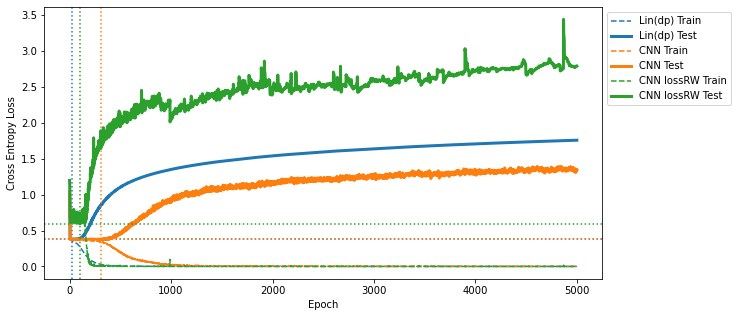

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=2880, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [171]:
# make model
model_cnn_lossrw = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
model_cnn_lossrw.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
w = get_loss_weights(ys).to(DEVICE)
loss_func = nn.CrossEntropyLoss(weight=w)
loss_label= "Cross Entropy Loss"
# run model
train_losses_cnn_lossrw, \
val_losses_cnn_lossrw,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    model_cnn_lossrw, 
    loss_func,
    lr=0.01,
    epochs=5000,
)

# to plot loss
cnn_lossrw_data_label = [((train_losses_cnn_lossrw,val_losses_cnn_lossrw),'CNN lossRW',estop,best_val)]

tu.quick_loss_plot(mer8motif_lin_d_data_label+mer8motif_cnn_data_label+cnn_lossrw_data_label,loss_type=loss_label)

model_cnn_lossrw

__TRAIN__
Running LinearDeep


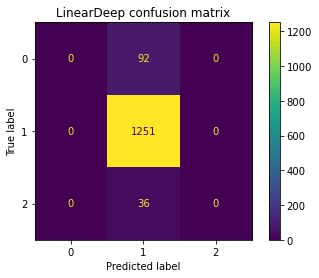

Running CNN


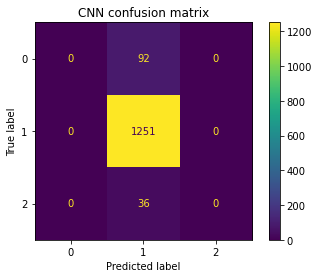

Running CNN LossRW


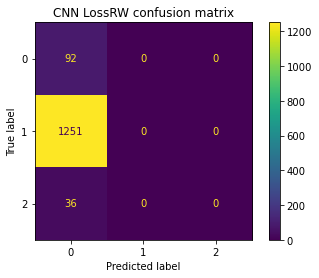

__VAL__
Running LinearDeep


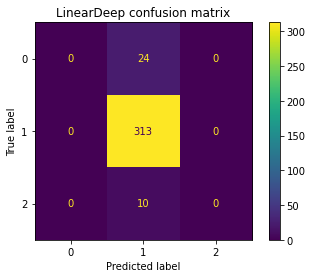

Running CNN


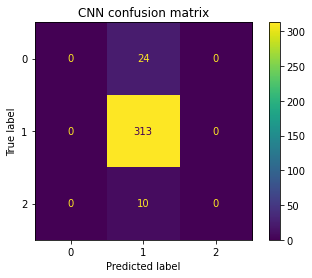

Running CNN LossRW


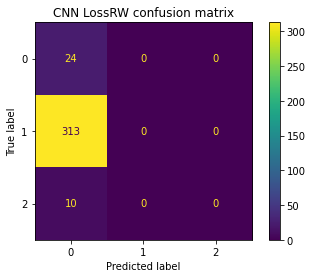

In [172]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
    ("CNN LossRW",model_cnn_lossrw,DatasetSpec('ohe')),
]

print("__TRAIN__")
dfs_train = plot_confusion(models, train_seqs, oracle_syn,[task])
print("__VAL__")
dfs_val = plot_confusion(models, val_seqs, oracle_syn,[task])

In [173]:
print(classification_report(dfs_train['CNN LossRW'][1]['truth'].values, dfs_train['CNN LossRW'][1]['pred'].values))

              precision    recall  f1-score   support

           0       0.07      1.00      0.13        92
           1       0.00      0.00      0.00      1251
           2       0.00      0.00      0.00        36

    accuracy                           0.07      1379
   macro avg       0.02      0.33      0.04      1379
weighted avg       0.00      0.07      0.01      1379



/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


this confusion matrix doesn't make sense with the loss. The loss shouldn't be 0 if the confusion matrix is so wrong for train

In [174]:
predss = model_cnn_lossrw(trainss)
#mer8motif_model_cnn(trainss)

In [175]:
predss

tensor([[ 2.9379, -2.9468,  2.3301],
        [ 2.8755, -2.8844,  2.2974],
        [ 2.9343, -2.9276,  2.3306],
        ...,
        [ 2.9168, -2.9411,  2.3486],
        [ 2.8449, -2.8764,  2.3073],
        [ 2.8909, -2.9113,  2.3275]], device='cuda:0', grad_fn=<AddmmBackward>)

In [176]:
labelss = torch.tensor(list(train_df["highCu_reg_UD"].values)).to(DEVICE)

In [177]:
labelss

tensor([0, 0, 0,  ..., 2, 2, 2], device='cuda:0')

In [178]:
loser = nn.CrossEntropyLoss()
loser(train_out, labelss.long())

tensor(4.8860, device='cuda:0', grad_fn=<NllLossBackward>)

In [179]:
otherLoser = nn.CrossEntropyLoss(weight=w)
otherLoser(train_out, labelss.long())

tensor(0.6634, device='cuda:0', grad_fn=<NllLossBackward>)

why is the loss almost 0 during training but much higher on the train set at the end? Is this a batch size thing?

## Rebalance sampler

In [36]:
from torch.utils.data.sampler import WeightedRandomSampler


In [37]:
def make_weighted_sampler(df, reg):
    '''
    Given a training dataframe, create a balanced sampler for the class
    indicated
    '''
    # make weighted sampler for data loader
    class_sample_count = df[reg].value_counts()
    # get 1/count as weight for each class
    weight = dict([(x,(1. / class_sample_count[x])) for x in class_sample_count.keys()])
    # apply new weight to each sample
    samples_weight = np.array([weight[t] for t in train_df[reg].values])
    samples_weight = torch.from_numpy(samples_weight).double()

    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [38]:
reg = "highCu_reg_UD"
sampler = make_weighted_sampler(train_df, reg)

In [39]:
# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col=reg,
    sampler=sampler,
    shuffle=False,
    #batch_size=32
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [40]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1726, 19)
(433, 20)
(13790, 23)
(347, 21)


In [41]:
train_df[reg].value_counts()

1    12510
0      920
2      360
Name: highCu_reg_UD, dtype: int64

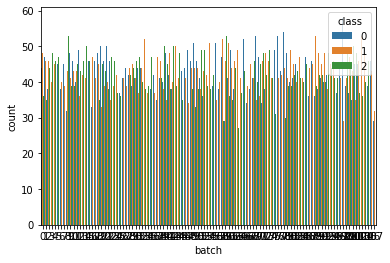

In [42]:
see_batch_class_dist(ohe_train_dl)
# the exact dist changes everytime

### Reweighted Linear Deep

In [45]:
seq_len = len(train_df['upstream_region'].values[0])

In [ ]:
mer8motif_model_lin_d_rw = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d_rw.to(DEVICE)


#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label = 'Cross Entropy Loss'
mer8motif_train_losses_lin_d_rw, \
mer8motif_test_losses_lin_d_rw,\
estop,\
best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d_rw,
    loss_func,
    lr=0.01,
    epochs=10000
)

# to plot loss
mer8motif_lin_d_rw_data_label = [((mer8motif_train_losses_lin_d_rw,mer8motif_test_losses_lin_d_rw),"Lin(dp) RW",estop,best_val)]
tu.quick_loss_plot(mer8motif_lin_d_rw_data_label,loss_type=loss_label)

mer8motif_model_lin_d_rw

E:1275 | train loss:0.000 | val loss: 1.577:  13%|█▎        | 1276/10000 [05:00<34:19,  4.24it/s]

EarlyStopping counter: 1250 out of 5000


E:2525 | train loss:0.000 | val loss: 1.695:  25%|██▌       | 2526/10000 [09:58<30:15,  4.12it/s]

EarlyStopping counter: 2500 out of 5000


E:2871 | train loss:0.000 | val loss: 1.716:  29%|██▊       | 2871/10000 [11:20<27:56,  4.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

E:4997 | train loss:0.000 | val loss: 1.808:  50%|████▉     | 4997/10000 [19:45<19:37,  4.25it/s]

In [ ]:
# make model

mer8motif_model_cnn_rw = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
mer8motif_model_cnn_rw.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
mer8motif_train_losses_cnn_rw, \
mer8motif_test_losses_cnn_rw,\
estop,\
best_val= run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn_rw, 
    loss_func,
    lr=0.01,
    epochs=10000,
)

mer8motif_cnn_rw_data_label = [((mer8motif_train_losses_cnn_rw,mer8motif_test_losses_cnn_rw),'CNN rw sample',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label,
    loss_type=loss_label)

mer8motif_model_cnn_rw

E:241 | train loss:0.405 | val loss: 0.799:   2%|▏         | 242/10000 [01:40<1:07:09,  2.42it/s]

In [57]:
print('hi')

hi


### Slow learning rate 

In [ ]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

lr001_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=32,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
lr001_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
lr001_train_losses_cnn, \
lr001_test_losses_cnn,\
estop,\
best_val= run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    lr001_cnn, 
    loss_func,
    lr=0.001,
    epochs=10000,
)

lr001_cnn_data_label = [((lr001_train_losses_cnn,lr001_test_losses_cnn),'CNN lr001',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label,
    loss_type=loss_label
    #sparse_n=20
)

lr001_cnn

### slow learning rate and more filters

In [ ]:
# make model
seq_len = len(train_df['upstream_region'].values[0])

f128_lr001_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=128,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
f128_lr001_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
f128_lr001_train_losses_cnn, \
f128_lr001_test_losses_cnn,\
estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    f128_lr001_cnn, 
    loss_func,
    lr=0.001,
    epochs=10000,
)

f128_lr001_cnn_data_label = [((f128_lr001_train_losses_cnn,f128_lr001_test_losses_cnn),'CNN f128 lr001',estop,best_val)]

# tu.quick_loss_plot(
#     mer8motif_lin_d_data_label+\
#     mer8motif_cnn_data_label+\
#     mer8motif_cnn_rw_data_label+\
#     lr001_cnn_data_label+\
#     f128_lr001_cnn_data_label,
#     loss_type=loss_label
# )
# f128_lr001_cnn

In [49]:
# run this...

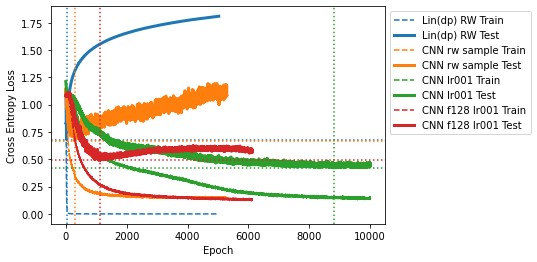

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(128, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [58]:
tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label,
    loss_type=loss_label
)
f128_lr001_cnn

In [ ]:
# more filters, 0.01 lr
seq_len = len(train_df['upstream_region'].values[0])

f128_cnn = TINKER_DNA_CNN(
    seq_len,
    num_filters0=128,
    num_filters1=32,
    kernel_size0=8,
    kernel_size1=8,
    conv_pool_size0=3,
#     conv_pool_size1=1,
    fc_node_num0=10,
    fc_node_num1=10
)
f128_cnn.to(DEVICE)

# make loss func
#loss_func = torch.nn.MSELoss() 
#w = torch.tensor([1.0,5.0,5.0]).to(DEVICE)
loss_func = nn.CrossEntropyLoss()#weight=w)
loss_label= "Cross Entropy Loss"

# run model
f128_train_losses_cnn, \
f128_test_losses_cnn,\
estop,best_val = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    f128_lr001_cnn, 
    loss_func,
    lr=0.01,
    epochs=10000,
)

f128_cnn_data_label = [((f128_train_losses_cnn,f128_test_losses_cnn),'CNN f128',estop,best_val)]

tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label+\
    f128_cnn_data_label,
    loss_type=loss_label
)
# f128_cnn

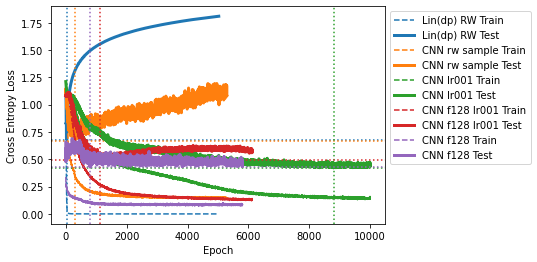

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(128, 32, kernel_size=(1, 8), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2880, out_features=10, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [59]:
tu.quick_loss_plot(
    mer8motif_lin_d_rw_data_label+\
    mer8motif_cnn_rw_data_label+\
    lr001_cnn_data_label+\
    f128_lr001_cnn_data_label+\
    f128_cnn_data_label,
    loss_type=loss_label
)
f128_lr001_cnn

TRAIN
Running LinearDeep RW


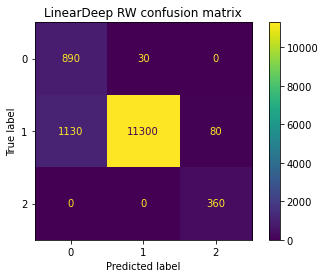

Running CNN RW


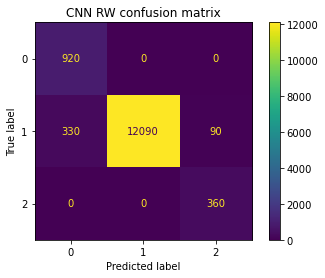

Running CNN lr001


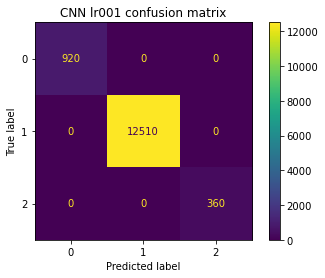

Running CNN f128 lr001


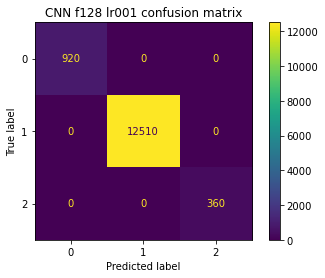

Running CNN f128 


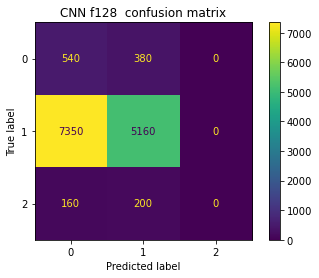


 VAL
Running LinearDeep RW


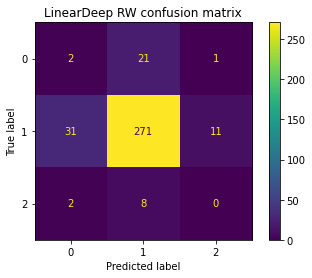

Running CNN RW


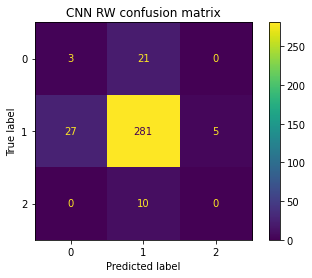

Running CNN lr001


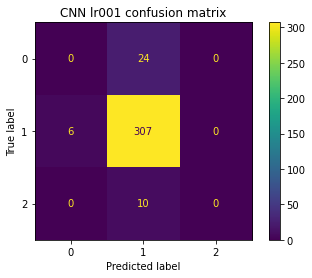

Running CNN f128 lr001


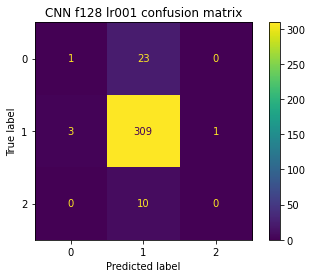

Running CNN f128 


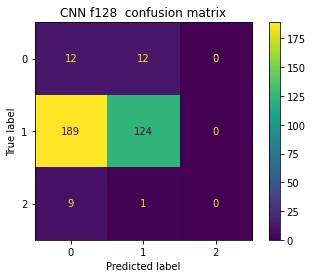

In [60]:
models = [
    ("LinearDeep RW",mer8motif_model_lin_d_rw,DatasetSpec('ohe')),
    ("CNN RW",mer8motif_model_cnn_rw,DatasetSpec('ohe')),
    ("CNN lr001",lr001_cnn,DatasetSpec('ohe')),
    ("CNN f128 lr001",f128_lr001_cnn,DatasetSpec('ohe')),
    ("CNN f128 ",f128_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


train_seqs =  train_df['locus_tag'].values #val_df['locus_tag'].values #
val_seqs =  val_df['locus_tag'].values #val_df['locus_tag'].values #
#test_seqs =  test_df['locus_tag'].values #val_df['locus_tag'].values #
task = "5G_CuLR_classification"

oracle_reg = dict([(a,[b]) for a,b in XYdf[['locus_tag',reg]].values])

print("TRAIN")
dfs_train = plot_confusion(models, train_seqs, oracle_reg,[task])
print("\n VAL")
dfs_val = plot_confusion(models, val_seqs, oracle_reg,[task])
#dfs_test = plot_confusion(models, test_seqs, oracle_reg,[task])

In [61]:
#cnn_res_rw = dfs_val['CNN'][1]

lind_res_rw = dfs_val['LinearDeep RW'][1]
cnn_res_rw = dfs_val['CNN RW'][1]
cnn_res_lr001 = dfs_val['CNN lr001'][1]
cnn_res_f128_lr001 = dfs_val['CNN f128 lr001'][1]
cnn_res_f128 = dfs_val['CNN f128 '][1]

# cls_report(lind_res,"LinearDeep")
# print()
# cls_report(cnn_res,"CNN")
# print()

cls_report(lind_res_rw,"LinearDeep RW")
print()
cls_report(cnn_res_rw,"CNN RW")
print()
cls_report(cnn_res_lr001,"CNN lr001")
print()
cls_report(cnn_res_f128_lr001,"CNN f128 lr001")
print()
cls_report(cnn_res_f128,"CNN f128 ")

LinearDeep RW (acc=0.787 | mcc=-0.005)
micro: p=0.787	 r=0.787	 f1=0.787
macro: p=0.320	 r=0.316	 f1=0.317

CNN RW (acc=0.818 | mcc=0.006)
micro: p=0.818	 r=0.818	 f1=0.818
macro: p=0.334	 r=0.341	 f1=0.337

CNN lr001 (acc=0.885 | mcc=-0.037)
micro: p=0.885	 r=0.885	 f1=0.885
macro: p=0.300	 r=0.327	 f1=0.313

CNN f128 lr001 (acc=0.893 | mcc=0.048)
micro: p=0.893	 r=0.893	 f1=0.893
macro: p=0.385	 r=0.343	 f1=0.338

CNN f128  (acc=0.392 | mcc=-0.021)
micro: p=0.392	 r=0.392	 f1=0.392
macro: p=0.321	 r=0.299	 f1=0.218


In [65]:
torch.save(mer8motif_model_lin_d_rw.state_dict(),"pat5000/LinearDeep_RW_sd.pth")
torch.save(mer8motif_model_cnn_rw.state_dict(),"pat5000/CNN_RW_sd.pth")
torch.save(lr001_cnn.state_dict(),"pat5000/CNN_lr001_sd.pth")
torch.save(f128_lr001_cnn.state_dict(),"pat5000/CNN_f128_lr001_sd.pth")
torch.save(f128_cnn.state_dict(),"pat5000/CNN_f128_sd.pth")

In [ ]:
# CHECK THIS

In [83]:
aaa = torch.load("pipe0/Kmer3_lr0.01_defaultSampler_no_aug.pth")
bbb = torch.load("pipe0/CNN32_lr0.01_defaultSampler_no_aug.pth")

In [73]:
reload_models = [
    ("kmer3",aaa,DatasetSpec('ohe'))
]
plot_confusion(reload_models, train_seqs, oracle_reg,[task])

Running kmer3


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [74]:
aaa

Kmer_Linear(
  (lin): Sequential(
    (0): Linear(in_features=64, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [100]:
dna = loc2seq[train_seqs[0]]
seq_ohe = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
seq_kmer = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(3))).unsqueeze(0).to(DEVICE)

In [101]:
seq_ohe.shape

torch.Size([1, 300, 4])

In [102]:
seq_kmer.shape

torch.Size([1, 64])

In [103]:
aaa(seq_kmer.float())

tensor([[ 0.2514,  2.5319, -1.5184]], device='cuda:0', grad_fn=<AddmmBackward>)

In [104]:
bbb(seq_ohe.float())

tensor([[ 0.1733,  2.7443, -0.6653]], device='cuda:0', grad_fn=<AddmmBackward>)

In [105]:
def get_confusion_data(model, model_name, ds, genes, oracle,loc2seq,device):
    '''
    Given a trained model and set of genes, evaluate the model's
    ability to predict these genes' reg class
    '''
    model.eval()
    data = []
    for gene in genes:
        dna = loc2seq[gene]
        if ds.name == 'ohe':
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(device)
        elif ds.name == 'kmer':
            s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).unsqueeze(0).to(device)
            # need unsqueeze?
        else:
            raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

        actual = oracle[gene]
        preds = [x.topk(1) for x in model(s.float())]
        print(len(preds))
        print()
        
        for i in range(len(preds)):
            print(i, preds[i])
            prob,clss = [x.item() for x in preds[i]]
            data.append((gene,actual[i], clss,prob,dna))
            
    df = pd.DataFrame(data, columns=['locus_tag','truth','pred','prob','seq'])
    return df

In [106]:
get_confusion_data(aaa, "dummy", DatasetSpec('kmer',k=3), train_seqs, oracle_reg,loc2seq,DEVICE)

1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1512], device='

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4638], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5995], device='cud

1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8784], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4371], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4371], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4371], device='

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8468], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9676], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9676], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9676], device='cud

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4276], device='cud

1

0 torch.return_types.topk(
values=tensor([2.7392], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7392], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7392], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4600], device='

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5849], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3816], device='cud

1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0263], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3057], device='

1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3421], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0403], device='

1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3185], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1388], device='

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1191], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0980], device='cud

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7430], device='cud

1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0754], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9381], device='

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8510], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8530], device='cud

0 torch.return_types.topk(
values=tensor([2.3937], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3937], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4136], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9043], device='cud

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8693], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6377], device='cud

1

0 torch.return_types.topk(
values=tensor([2.4675], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0414], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6224], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6224], device='

1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9512], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5538], device='

1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4657], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7554], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7554], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7554], device='


0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6687], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6687], device='cu

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4726], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1735], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1735], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1735], device='cud

1

0 torch.return_types.topk(
values=tensor([3.2523], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2523], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2523], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5011], device='

1

0 torch.return_types.topk(
values=tensor([2.7561], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7561], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8472], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1528], device='

1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9575], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8012], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8012], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8012], device='

1

0 torch.return_types.topk(
values=tensor([2.0958], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0958], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0958], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.2833], device='

0 torch.return_types.topk(
values=tensor([2.6656], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6656], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6656], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7089], device='cud

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6014], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7319], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7319], device='cud

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0159], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1199], device='cud

1

0 torch.return_types.topk(
values=tensor([2.6943], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6943], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6943], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1923], device='

1

0 torch.return_types.topk(
values=tensor([2.5716], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9940], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9555], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9555], device='

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5829], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6325], device='cud

0 torch.return_types.topk(
values=tensor([3.0128], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0128], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.0128], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.6764], device='cud

1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2560], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7446], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7446], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7446], device='

1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5836], device='

1

0 torch.return_types.topk(
values=tensor([2.9746], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.9746], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7890], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.5410], device='

1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2753], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7076], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7076], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7076], device='

1

0 torch.return_types.topk(
values=tensor([2.2821], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2821], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1350], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.8310], device='

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.8482], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2863], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2863], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2863], device='cud

0 torch.return_types.topk(
values=tensor([2.1537], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1537], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.1537], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4508], device='cud

1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.4111], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.1268], device='

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.0722], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5820], device='cud

1

0 torch.return_types.topk(
values=tensor([2.3242], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3242], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([3.4323], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.7612], device='

1

0 torch.return_types.topk(
values=tensor([2.5003], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.3283], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.6935], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.6935], device='

1

0 torch.return_types.topk(
values=tensor([2.0591], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([1.9280], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5960], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5960], device='

1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.2349], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([1], device='cuda:0'))
1

0 torch.return_types.topk(
values=tensor([2.5919], device='

KeyboardInterrupt: 

In [ ]:
get_confusion_data(bbb, "dummy", DatasetSpec('ohe'), train_seqs, oracle_reg,loc2seq,DEVICE)


In [ ]:
aaa needs to be kmer

# filter viz

In [73]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    #print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0).to(DEVICE)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    
#     with tqdm.trange(epochs) as pbar:
#         for i in pbar:
            
    for seq in tqdm.tqdm(seqs):
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8,ysc=1.0):
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 20*ysc))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 2


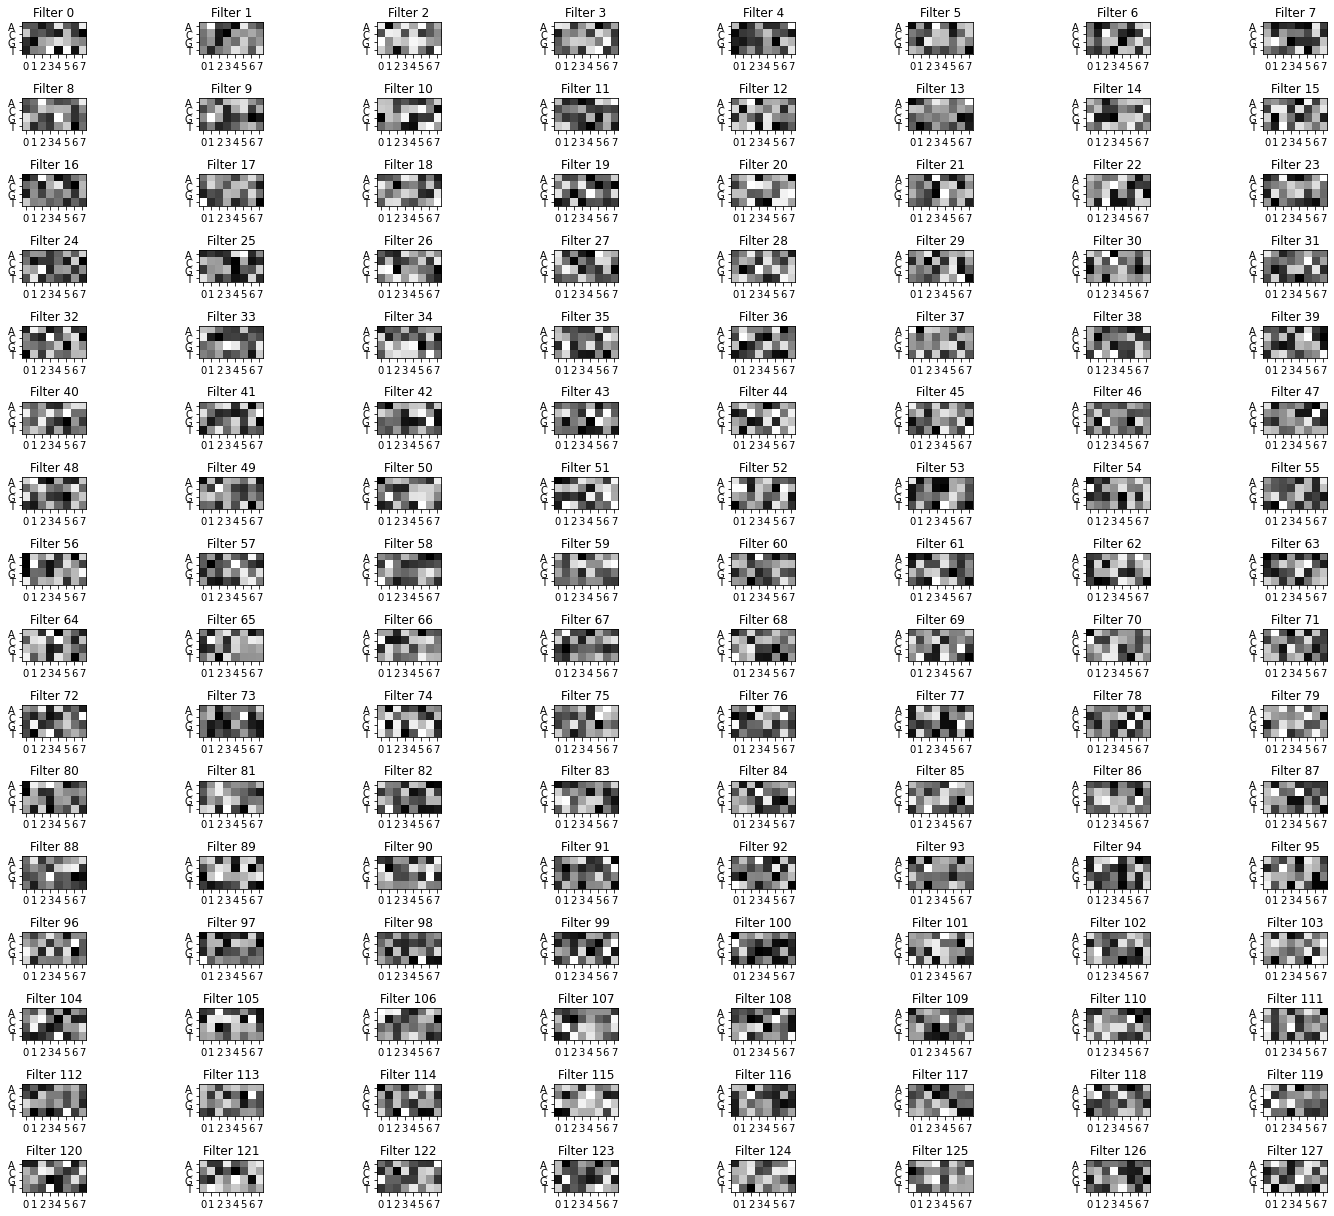

In [74]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(f128_lr001_cnn)
view_filters(model_weights)

In [75]:
seqs = [loc2seq[x] for x in train_df['locus_tag'].values[:500]]

filter_activations = get_filter_activations(seqs, conv_layers[0])

Num filters 128
filt_width 8


100%|██████████| 500/500 [03:45<00:00,  2.21it/s]


torch.Size([128, 4, 8])


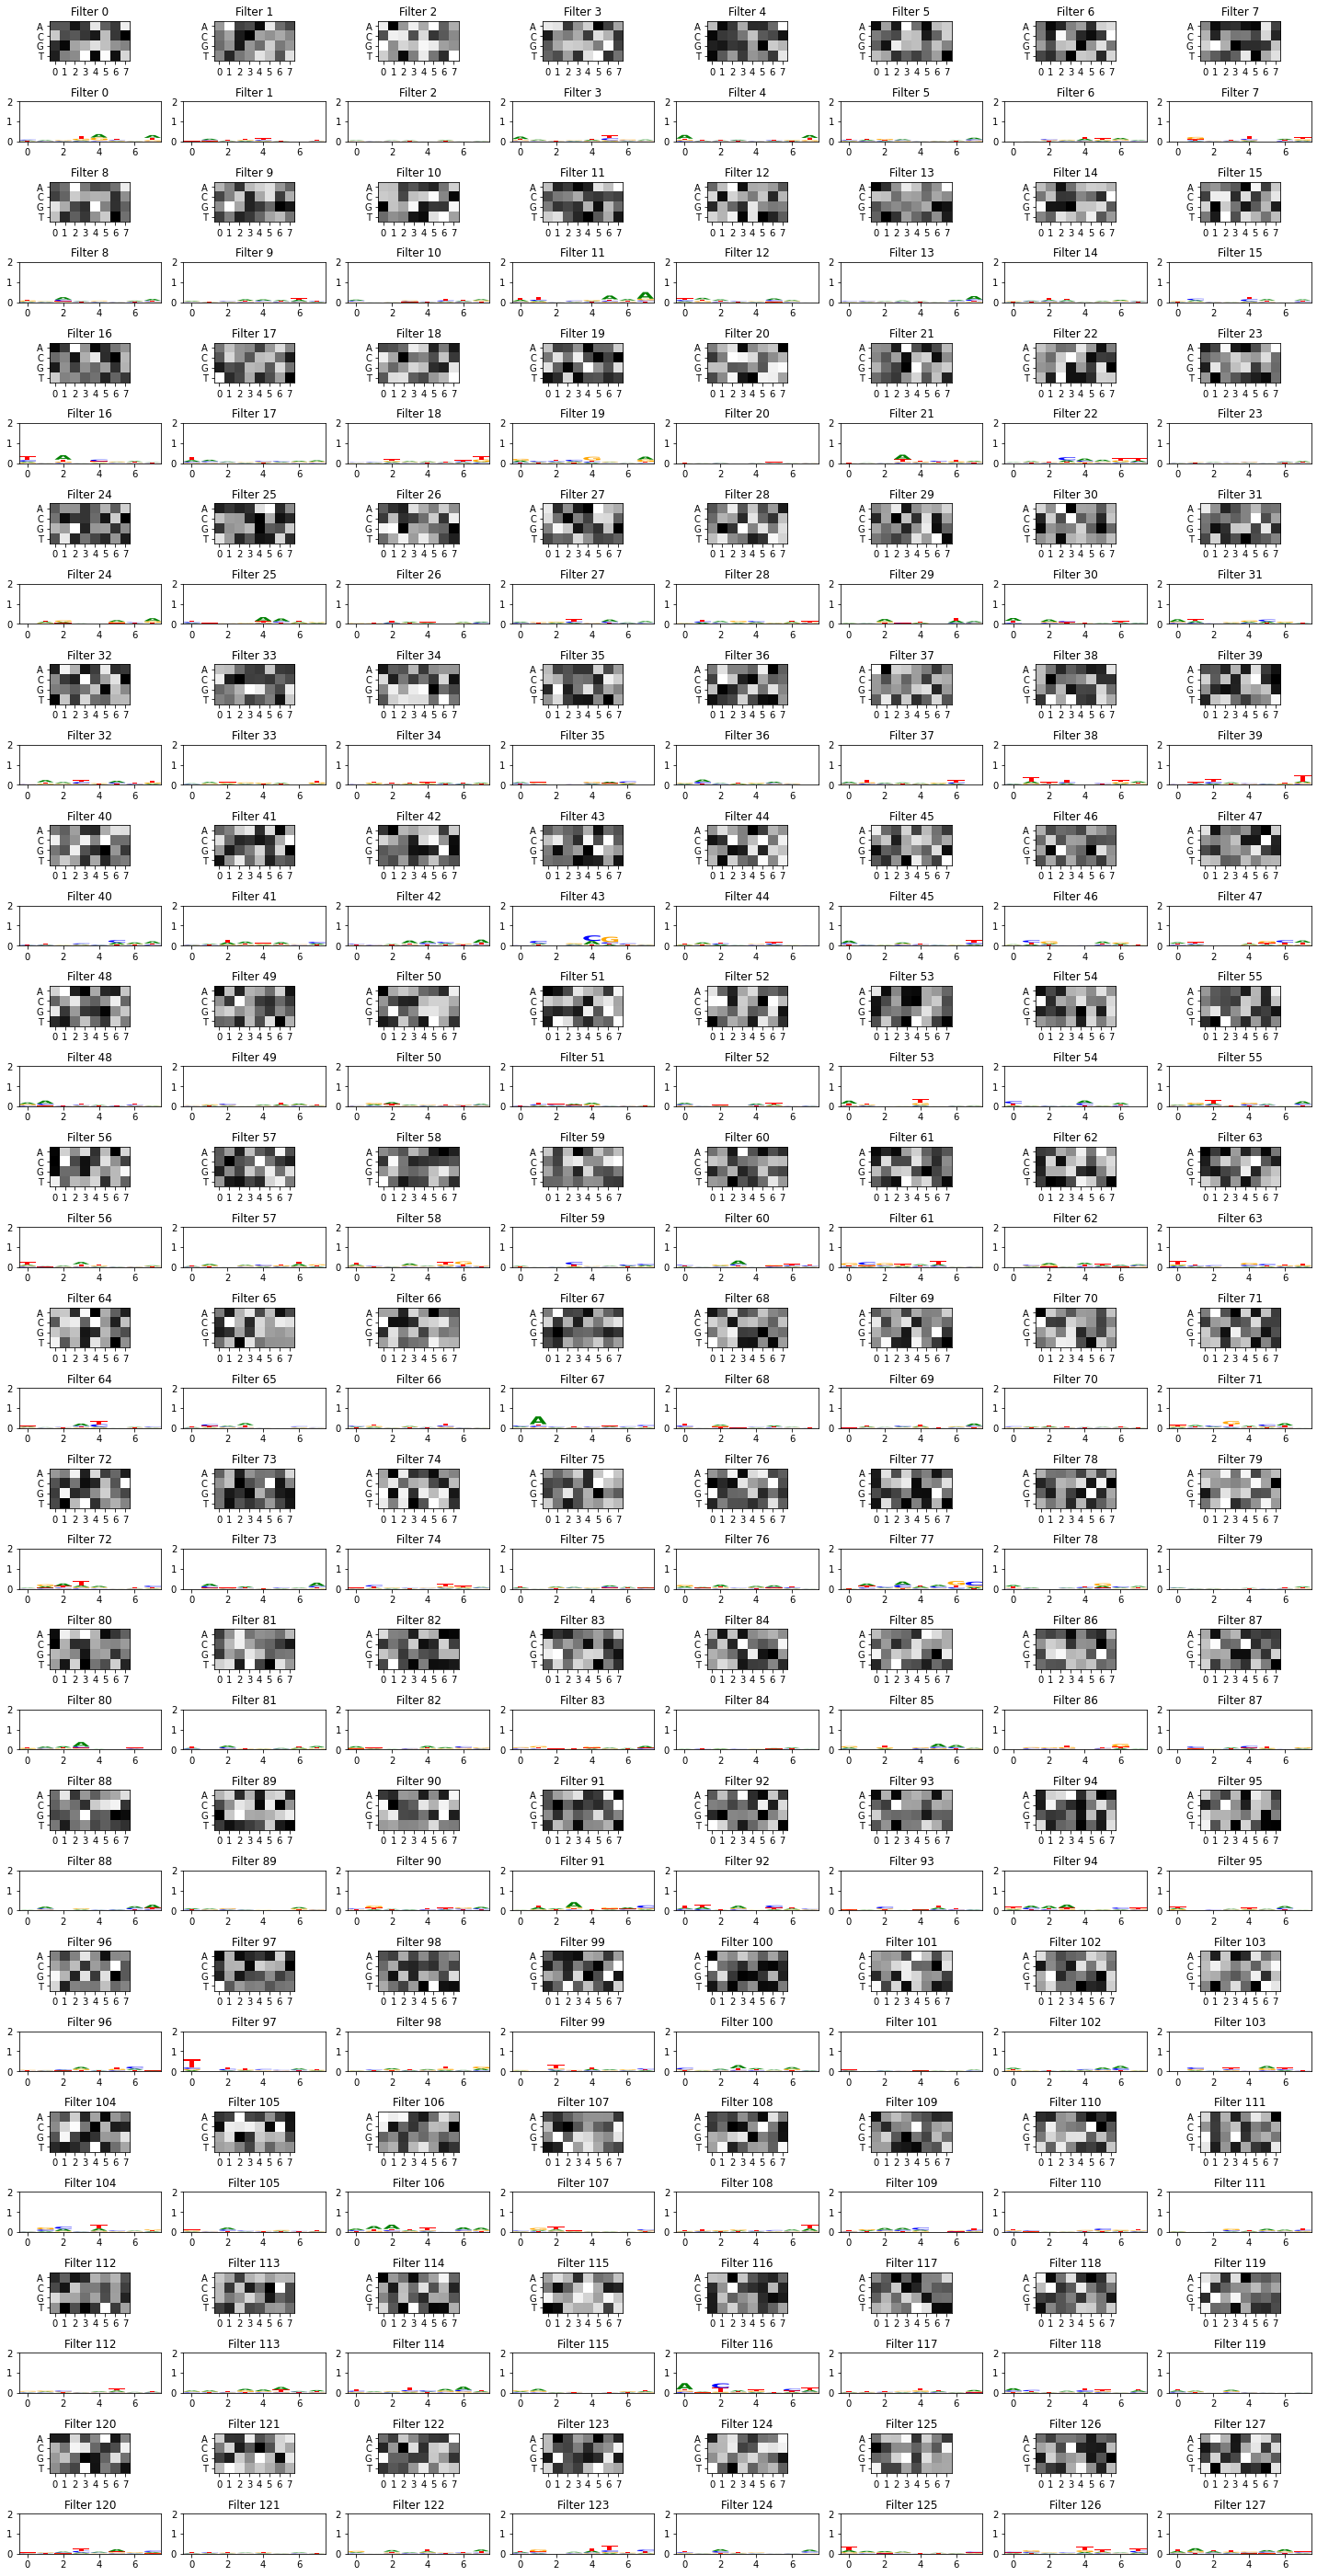

In [76]:
view_filters_and_logos(model_weights,filter_activations,ysc=2)

### some tinkering with KFold CV... maybe come back later

In [50]:
from sklearn.model_selection import StratifiedKFold

In [85]:
cv = StratifiedKFold(5,shuffle=True)

In [115]:
X = np.array(ft)
y = list(np.array(ft['highCu_reg_UD'].values))

trains = []
tests = []
for fold,(train_ids, test_ids) in enumerate(cv.split(X,y)):
    print("fold",fold)
    xtrain = ft.reset_index().iloc[train_ids]
    xtest = ft.reset_index().iloc[test_ids]
    trains.append(xtrain)
    tests.append(xtest)

fold 0
fold 1
fold 2
fold 3
fold 4


In [119]:
for i in range(5):
    traini = trains[i]
    testi = tests[i]
    
    print("fold",i)
    print("TRAIN")
    print(traini['highCu_reg_UD'].value_counts())
    print("TEST")
    print(testi['highCu_reg_UD'].value_counts())
    print()

fold 0
TRAIN
1    1313
0      55
2      12
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     14
2      2
Name: highCu_reg_UD, dtype: int64

fold 1
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 2
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 3
TRAIN
1    1314
0      55
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    328
0     14
2      3
Name: highCu_reg_UD, dtype: int64

fold 4
TRAIN
1    1313
0      56
2      11
Name: highCu_reg_UD, dtype: int64
TEST
1    329
0     13
2      3
Name: highCu_reg_UD, dtype: int64



## Old tinkering

In [46]:
w = torch.tensor([10.0,100.0,1.0])
cel = nn.CrossEntropyLoss()
celw = nn.CrossEntropyLoss(weight=w)

In [48]:
a = torch.tensor([[1.0,2.0,3.0],
                  [1.0,3.0,2.0],
                  [3.0,1.0,2.0]])

b = torch.tensor([2,1,2])
c = torch.tensor([0,1,2])

print('normal')
print(cel(a,b))
print(cel(a,c))
print()
print('weighted')
print(celw(a,b))
print(celw(a,c))

normal
tensor(0.7409)
tensor(1.4076)

weighted
tensor(0.4174)
tensor(0.5968)


In [45]:
print(a.shape)
print(b.shape)

torch.Size([2, 3])
torch.Size([2])


In [104]:
seqs = train_df['locus_tag'].values #val_df['locus_tag'].values

p = quick_classify(mer8motif_model_cnn,seqs,oracle_syn)

EQU24_RS06320: pred:2 actual:0
EQU24_RS06320: pred:2 actual:0 ([6.231020450592041, -6.871827602386475, 6.793558597564697])
EQU24_RS06855: pred:1 actual:0
EQU24_RS06855: pred:1 actual:0 ([5.818170547485352, 6.306614875793457, -5.028451919555664])
EQU24_RS16240: pred:1 actual:0
EQU24_RS16240: pred:1 actual:0 ([6.875643253326416, 7.228374004364014, -6.141620635986328])


In [93]:
p.tolist()[0]

[6.06266975402832, 2.4189703464508057, -2.8052988052368164]

In [67]:
genes = train_df['locus_tag'].values
seqs = [torch.tensor(u.one_hot_encode(loc2seq[x])).unsqueeze(0).to(DEVICE).float() for x in genes]

preds = mer8motif_model_cnn(torch.stack(seqs).squeeze(1))

In [85]:
preds

tensor([[9.9989e-01, 1.0368e-04, 8.5303e-06],
        [9.9997e-01, 2.7287e-05, 2.8173e-06],
        [9.8730e-01, 5.0449e-05, 1.2647e-02],
        ...,
        [9.9740e-01, 1.9590e-05, 2.5840e-03],
        [9.9967e-01, 2.5071e-04, 8.1230e-05],
        [9.9950e-01, 4.3107e-04, 6.7942e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [85]:
val_df.value_counts('reg')

reg
0    334
2     11
1      8
dtype: int64

In [110]:
genes_with_motifs = ['EQU24_RS00275','EQU24_RS01000','EQU24_RS01145','EQU24_RS01350','EQU24_RS01510','EQU24_RS01840','EQU24_RS01895','EQU24_RS01900','EQU24_RS02065','EQU24_RS02090','EQU24_RS02305','EQU24_RS02735','EQU24_RS02990','EQU24_RS03550','EQU24_RS03555','EQU24_RS03610','EQU24_RS04575','EQU24_RS04690','EQU24_RS05030','EQU24_RS05090','EQU24_RS05095','EQU24_RS05810','EQU24_RS05885','EQU24_RS06285','EQU24_RS06410','EQU24_RS06960','EQU24_RS07465','EQU24_RS07825','EQU24_RS08030','EQU24_RS08830','EQU24_RS08840','EQU24_RS08860','EQU24_RS08880','EQU24_RS09300','EQU24_RS09730','EQU24_RS09760','EQU24_RS09900','EQU24_RS10145','EQU24_RS10685','EQU24_RS10700','EQU24_RS10745','EQU24_RS12075','EQU24_RS12370','EQU24_RS12810','EQU24_RS13170','EQU24_RS13370','EQU24_RS13465','EQU24_RS14795','EQU24_RS14835','EQU24_RS15280','EQU24_RS15800','EQU24_RS15850','EQU24_RS16395','EQU24_RS16400','EQU24_RS16545','EQU24_RS16935','EQU24_RS17340','EQU24_RS17960','EQU24_RS18175','EQU24_RS18350','EQU24_RS18600','EQU24_RS18860','EQU24_RS19095','EQU24_RS19160','EQU24_RS19290','EQU24_RS19580','EQU24_RS20100','EQU24_RS20210','EQU24_RS20225','EQU24_RS20485','EQU24_RS20940','EQU24_RS21145','EQU24_RS21675','EQU24_RS21805','EQU24_RS21815']
seqs_with_motifs = [loc2seq[x] for x in genes_with_motifs]
seqs_with_motifs = [torch.tensor(u.one_hot_encode(seq)).unsqueeze(0).to(DEVICE).float() for seq in seqs_with_motifs]
preds = mer8motif_model_cnn(torch.stack(seqs_with_motifs).squeeze(1))

In [113]:
quick_classify(mer8motif_model_cnn,genes_with_motifs,oracle_syn)

done
